# Project: Predicting house sale prices  
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true



**Inspirations and research:**
* https://www.kaggle.com/code/solegalli/feature-engineering-for-house-price-modelling
* https://nycdatascience.com/blog/student-works/house-price-prediction-with-creative-feature-engineering-and-advanced-regression-techniques/
* https://rpubs.com/IsaacGabr/795734
* https://www.kaggle.com/code/modassirafzal/housing-top-3/notebook





PDF excerpts:  
    "This paper presents a data set describing the sale of individual residential property in Ames, Iowa
from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home
values. I will discuss my previous use of the Boston Housing Data Set and I will suggest
methods for incorporating this new data set as a final project in an undergraduate regression
course."

here are
five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students.


specific recommendations:

Eliminate all sales except for the “normal” from the SALES CONDITION variable.
Unless an instructor specifically wants to create an activity that investigates the
difference between the various types of sales (foreclosures, new homes, family sales, etc.)
the different conditions will simply serve to complicate the results and confuse the
students.  

Remove all homes with a living area (GR LIVE AREA) above 1500 square feet. The
purpose to the second step is to alleviate problems with non-homogeneous variance. As
might be expected there is increasing variation with increasing price within the Ames
housing market. This problem can be remedied by taking a transformation (square root)
of the sales price but those wishing to keep the response in dollars can simply use the
smaller homes as they tend to show more homogeneous variation.  

Select desired observations.
Although the data set could be reduced further using other variables (such as using only
one story homes or eliminating homes without a basement), I would recommend drawing
a simple random (or systematic) sample from the remaining “normal” sales to create the
final data set.  

## Importing packages & data

In [36]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from itertools import combinations # check if needed later
from datetime import date #check if needed later
import math
import distfit as df #distribution fitting
%matplotlib inline

# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

In [2]:
# Importing source dataset
ames_data = pd.read_csv('C:\\Users\\tgusc\\Documents\\GitHub\\Python\\GP23_PredictingHouseSalePrices\\AmesHousing.tsv', delimiter="\t")

In [3]:
#parameters
seed = 123
target = 'SalePrice'
ID_vars = ['Order', 'PID']

## Dataset inspection

In [4]:
# find categorical variables
categorical = [var for var in ames_data.columns if ames_data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [5]:
# find numerical variables
numerical = [var for var in ames_data.columns if ames_data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 39 numerical variables


In [6]:
discrete = []
for var in numerical:
    if len(ames_data[var].unique())<20:
        print(var, ' values: ', ames_data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

MS SubClass  values:  [ 20  60 120  50  85 160  80  30  90 190  45  70  75  40 180 150]
Overall Qual  values:  [ 6  5  7  8  9  4  3  2 10  1]
Overall Cond  values:  [5 6 7 2 8 4 9 3 1]
Bsmt Full Bath  values:  [ 1.  0.  2.  3. nan]
Bsmt Half Bath  values:  [ 0.  1. nan  2.]
Full Bath  values:  [1 2 3 0 4]
Half Bath  values:  [0 1 2]
Bedroom AbvGr  values:  [3 2 1 4 6 5 0 8]
Kitchen AbvGr  values:  [1 2 3 0]
TotRms AbvGrd  values:  [ 7  5  6  8  4 12 10 11  9  3 13  2 15 14]
Fireplaces  values:  [2 0 1 3 4]
Garage Cars  values:  [ 2.  1.  3.  0.  4.  5. nan]
Pool Area  values:  [  0 144 480 576 555 368 444 228 561 519 648 800 512 738]
Mo Sold  values:  [ 5  6  4  3  1  2  7 10  8 11  9 12]
Yr Sold  values:  [2010 2009 2008 2007 2006]
There are 15 discrete variables


In [7]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['PID', 'Order',target]]
continuous

['Lot Frontage',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Yr Blt',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Misc Val']

Think if it would be beneficial for the project structure to divide variables in the beginning

Split to 
nominal variables - categorical without logical order (male / female)
ordinal variables - order relation ( excellent, very good, good , bad)
continuous - numerical infinite values (like price)
discrete - numerical finite values (like score from 0 to 100)
binary - 0/1 numerical variables

https://github.com/scikit-learn-contrib/boruta_py

Should you normalise/standardize binary variables?

This is still a matter of debate and it also depends strongly on the algorithms you're using.

For example, if you're using Lasso for feature selection, all of the features should be on the same scale and standardization of binary features is recommended (see The Elements of Statistical Learning by Tibshirani et al.: http://web.stanford.edu/~hastie/ElemStatLearn/).

Logistic regression doesn't profit as much from normalization of binary variables: Should you ever standardise binary variables?.

Interestingly enough, Andrew Gelman suggested standardizing all numeric variables by dividing with two times the standard deviation and leave binary variables as they are, such that you can interpret and compare the influence of the regression coefficients more easily: http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf.


## Preliminary data cleaning

In [8]:
# Converting object types to numbers and strings
ames_data = ames_data.convert_dtypes()

for column in ames_data.select_dtypes(include=['int']).columns:
    ames_data[column] = ames_data[column].astype(float)

ames_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   float64
 1   PID              2930 non-null   float64
 2   MS SubClass      2930 non-null   float64
 3   MS Zoning        2930 non-null   string 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   float64
 6   Street           2930 non-null   string 
 7   Alley            198 non-null    string 
 8   Lot Shape        2930 non-null   string 
 9   Land Contour     2930 non-null   string 
 10  Utilities        2930 non-null   string 
 11  Lot Config       2930 non-null   string 
 12  Land Slope       2930 non-null   string 
 13  Neighborhood     2930 non-null   string 
 14  Condition 1      2930 non-null   string 
 15  Condition 2      2930 non-null   string 
 16  Bldg Type        2930 non-null   string 
 17  House Style   

In [9]:
ames_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1.0,526301100.0,20.0,RL,141.0,31770.0,Pave,<NA>,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,5.0,1960.0,1960.0,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,7.0,Typ,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,5.0,2010.0,WD,Normal,215000.0
1,2.0,526350040.0,20.0,RH,80.0,11622.0,Pave,<NA>,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961.0,1961.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,<NA>,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,<NA>,MnPrv,<NA>,0.0,6.0,2010.0,WD,Normal,105000.0
2,3.0,526351010.0,20.0,RL,81.0,14267.0,Pave,<NA>,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958.0,1958.0,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,<NA>,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,<NA>,<NA>,Gar2,12500.0,6.0,2010.0,WD,Normal,172000.0
3,4.0,526353030.0,20.0,RL,93.0,11160.0,Pave,<NA>,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7.0,5.0,1968.0,1968.0,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,Ex,8.0,Typ,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,0.0,4.0,2010.0,WD,Normal,244000.0
4,5.0,527105010.0,60.0,RL,74.0,13830.0,Pave,<NA>,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997.0,1998.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,<NA>,MnPrv,<NA>,0.0,3.0,2010.0,WD,Normal,189900.0


## Missing values handling
Usually this would be done on train & valid dataset only, excluding test/holdout data in order to prevent information leakage. However because of using mode value for missing data I am relaxing this requirement under assumption that train/valid and test data variable values distribution is similar.

In [10]:
def transform_features(data_in, cutoff_missing = 0.25, cutoff_fill = 0.05, fill_method = 'mode'):
    """
    Transform features based on their characteristics.
    
    Parameters
    ----------
    data_in : str
        DataFrame to analyze.
    cutoff_missing : float64, default = 0.25
        Percentage of missing values used as cutoff point for dropping variable. If missings > cutoff_missing then
        drop variable from DataFrame.
    cutoff_fill : float64, default = 0.05
        Percentage of missing values used as cutoff point for filling missing variables with fill_method. If 
        missings < cutoff_fill then replace missing values with fill_method and create new variable var_name + "_NA"
        which indicates rows with missing values for original variable
    fill_method : str, default = 'mode'
        Filling method for missing values, when variable meets cutoff_fill criteria. Can choose from average, median, mode.    
    seed : int
        Random number seed for results reproductibility.
    train_pct : float64, default 0.8
        Percentage of DS dataset to be used as train. 
        
    Returns
    -------
    data_out : DataFrame
        DataFrame with transformed features.
    """
    data_out = pd.DataFrame()
    missing_info = data_in.isna().sum()/len(data_in)
    dropped_cols = []
    for col in data_in.columns:
        p_miss = missing_info[missing_info.index == col][0]
        if p_miss > cutoff_missing:
            print(col + ' - dropped because of missing values exceeding ' + str(cutoff_missing) + '%.' + ' Missing values = '
                 + str(round(p_miss*100,2)) + '%.')
            dropped_cols.append(col)
    for col_n in data_in.select_dtypes('number'):
        p_miss = missing_info[missing_info.index == col_n][0]
        if ((p_miss <= cutoff_fill) & (p_miss > 0)):
            if fill_method == 'mode':
                fill=data_in[col_n].mode()[0]
            elif fill_method == 'mean':
                fill=np.mean(data_in[col_n])
            elif fill_method == 'median':
                fill=np.median(data_in[col_n])
            else:
                print(fill_method + ' is not known. Column will not be transformed')
                continue
            data_out[col_n+'_NA'] = np.where(data_in[col_n].isnull(), 1, 0) # Adding variable indicating missing value
            data_out[col_n] = data_in[col_n].fillna(value = fill)
            print(col_n + ' - ' + str(round(p_miss*100,4)) + '% of missing values. They are replaced with ' + fill_method + ' value - ' + str(fill))
            print(col_n+'_NA' + ' is created to indicate missing values of original variable.')
        else :
            data_out[col_n] = data_in[col_n]
            print(col_n + ' - ' + str(round(p_miss*100,4)) + '% of missing values. Variable copied.')
    for col_c in data_in.select_dtypes(exclude='number'):
        if col_c not in dropped_cols:
            data_out[col_c] = data_in[col_c].astype('category')
            print(col_c + ' - ' + str(round(p_miss*100,4)) + '% of missing values. Variable copied as category.')
    return data_out

In [11]:
ames_data_transformed = transform_features(data_in = ames_data)

Alley - dropped because of missing values exceeding 0.25%. Missing values = 93.24%.
Fireplace Qu - dropped because of missing values exceeding 0.25%. Missing values = 48.53%.
Pool QC - dropped because of missing values exceeding 0.25%. Missing values = 99.56%.
Fence - dropped because of missing values exceeding 0.25%. Missing values = 80.48%.
Misc Feature - dropped because of missing values exceeding 0.25%. Missing values = 96.38%.
Order - 0.0% of missing values. Variable copied.
PID - 0.0% of missing values. Variable copied.
MS SubClass - 0.0% of missing values. Variable copied.
Lot Frontage - 16.7235% of missing values. Variable copied.
Lot Area - 0.0% of missing values. Variable copied.
Overall Qual - 0.0% of missing values. Variable copied.
Overall Cond - 0.0% of missing values. Variable copied.
Year Built - 0.0% of missing values. Variable copied.
Year Remod/Add - 0.0% of missing values. Variable copied.
Mas Vnr Area - 0.785% of missing values. They are replaced with mode value - 

In [12]:
# TO BE INSPECTED
# Lot Frontage - 16.7235% of missing values. Variable copied.

In [13]:
ames_data_transformed

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
0,1.0,526301100.0,20.0,141.0,31770.0,6.0,5.0,1960.0,1960.0,0,112.0,0,639.0,0,0.0,0,441.0,0,1080.0,1656.0,0.0,0.0,1656.0,0,1.0,0,0.0,1.0,0.0,3.0,1.0,7.0,2.0,1960.0,0,2.0,0,528.0,210.0,62.0,0.0,0.0,0.0,0.0,0.0,5.0,2010.0,215000.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,TA,TA,CBlock,TA,Gd,Gd,BLQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,P,WD,Normal
1,2.0,526350040.0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0,0.0,0,468.0,0,144.0,0,270.0,0,882.0,896.0,0.0,0.0,896.0,0,0.0,0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1961.0,0,1.0,0,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,105000.0,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
2,3.0,526351010.0,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,0,108.0,0,923.0,0,0.0,0,406.0,0,1329.0,1329.0,0.0,0.0,1329.0,0,0.0,0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1958.0,0,1.0,0,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,172000.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
3,4.0,526353030.0,20.0,93.0,11160.0,7.0,5.0,1968.0,1968.0,0,0.0,0,1065.0,0,0.0,0,1045.0,0,2110.0,2110.0,0.0,0.0,2110.0,0,1.0,0,0.0,2.0,1.0,3.0,1.0,8.0,2.0,1968.0,0,2.0,0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0,244000.0,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
4,5.0,527105010.0,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0,0.0,0,791.0,0,0.0,0,137.0,0,928.0,928.0,701.0,0.0,1629.0,0,0.0,0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,1997.0,0,2.0,0,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,189900.0,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926.0,923275080.0,80.0,37.0,7937.0,6.0,6.0,1984.0,1984.0,0,0.0,0,819.0,0,0.0,0,184.0,0,1003.0,1003.0,0.0,0.0,1003.0,0,1.0,0,0.0,1.0,0.0,3.0,1.0,6.0,0.0,1984.0,0,2.0,0,588.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2006.0,142500.0,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Normal
2926,2927.0,923276100.0,20.0,NaN,8885.0,5.0,5.0,1983.0,1983.0,0,0.0,0,301.0,0,324.0,0,239.0,0,864.0,902.0,0.0,0.0,902.0,0,1.0,0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1983.0,0

In [14]:
ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Remod/Add"]]

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
1702,1703.0,528120010.0,60.0,134.0,16659.0,8.0,5.0,2007.0,2008.0,0,0.0,0,0.0,0,0.0,0,1582.0,0,1582.0,1582.0,570.0,0.0,2152.0,0,0.0,0,0.0,2.0,1.0,3.0,1.0,7.0,1.0,2007.0,0,2.0,0,728.0,0.0,368.0,0.0,0.0,0.0,0.0,0.0,6.0,2007.0,260116.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,New,Partial
2180,2181.0,908154195.0,20.0,128.0,39290.0,10.0,5.0,2008.0,2009.0,0,1224.0,0,4010.0,0,0.0,0,1085.0,0,5095.0,5095.0,0.0,0.0,5095.0,0,1.0,0,1.0,2.0,1.0,2.0,1.0,15.0,2.0,2008.0,0,3.0,0,1154.0,546.0,484.0,0.0,0.0,0.0,0.0,17000.0,10.0,2007.0,183850.0,RL,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y,New,Partial
2181,2182.0,908154205.0,60.0,130.0,40094.0,10.0,5.0,2007.0,2008.0,0,762.0,0,2260.0,0,0.0,0,878.0,0,3138.0,3138.0,1538.0,0.0,4676.0,0,1.0,0,0.0,3.0,1.0,3.0,1.0,11.0,1.0,2007.0,0,3.0,0,884.0,208.0,406.0,0.0,0.0,0.0,0.0,0.0,10.0,2007.0,184750.0,RL,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,BuiltIn,Fin,TA,TA,Y,New,Partial


In [15]:
ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Built"]]

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
2180,2181.0,908154195.0,20.0,128.0,39290.0,10.0,5.0,2008.0,2009.0,0,1224.0,0,4010.0,0,0.0,0,1085.0,0,5095.0,5095.0,0.0,0.0,5095.0,0,1.0,0,1.0,2.0,1.0,2.0,1.0,15.0,2.0,2008.0,0,3.0,0,1154.0,546.0,484.0,0.0,0.0,0.0,0.0,17000.0,10.0,2007.0,183850.0,RL,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y,New,Partial


In [16]:
# Adjusting dates of refubrishment and build to not be later than sale date
ames_data_transformed.loc[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Built"], "Year Built"] = ames_data_transformed["Yr Sold"]
ames_data_transformed.loc[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Remod/Add"], "Year Remod/Add"] = ames_data_transformed["Yr Sold"]


In [17]:
# Check
print(ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Remod/Add"]].shape[0])
print(ames_data_transformed[ames_data_transformed["Yr Sold"]<ames_data_transformed["Year Built"]].shape[0])
# 0 resulting rows - all is ok

0
0


## Feature engineering - new variables

In [18]:
ames_data_transformed["years_until_remod"] = ames_data_transformed["Year Remod/Add"] - ames_data_transformed["Year Built"]
ames_data_transformed["years_remod_to_sale"]  = ames_data_transformed["Yr Sold"] - ames_data_transformed["Year Remod/Add"]
ames_data_transformed["years_built_to_sale"]  = ames_data_transformed["Yr Sold"] - ames_data_transformed["Year Built"]
ames_data_transformed["sin_month_sale"] = ames_data_transformed["Mo Sold"].apply(lambda x: math.sin(float(x))) # seasonality detect v1
ames_data_transformed["cos_month_sale"] = ames_data_transformed["Mo Sold"].apply(lambda x: math.cos(float(x))) # seasonality detect v2
ames_data_transformed["Bathroom_total"] = ames_data_transformed["Bsmt Full Bath"].fillna(0) + ames_data_transformed["Bsmt Half Bath"].fillna(0) + ames_data_transformed["Full Bath"].fillna(0) + ames_data_transformed["Half Bath"].fillna(0)
ames_data_transformed["Floor_area"] = ames_data_transformed["Gr Liv Area"] + ames_data_transformed["Garage Area"] + ames_data_transformed["Total Bsmt SF"]
ames_data_transformed["Floor_area_ratio"] = ames_data_transformed["Floor_area"] / ames_data_transformed["Lot Area"]


for var in ["years_until_remod", "years_remod_to_sale", "years_built_to_sale", "Bathroom_total", "Floor_area", "Lot Area", "Floor_area_ratio"]:
            continuous.append(var)
for var in ["cos_month_sale", "sin_month_sale"]:
            discrete.append(var)
        
ames_data_transformed.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,years_until_remod,years_remod_to_sale,years_built_to_sale,sin_month_sale,cos_month_sale,Bathroom_total,Floor_area,Floor_area_ratio
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.355973,1984.265188,0.007850,101.096928,0.000341,442.478498,0.000341,49.705461,0.000341,559.071672,0.000341,1051.255631,1159.557679,335.455973,4.676792,1499.690444,0.000683,0.431058,0.000683,0.061092,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,0.000341,1.766894,0.000341,472.658362,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068,12.909215,23.525256,36.434471,-0.059696,0.101413,2.438225,3023.604437,0.365985
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.244953,20.858748,0.088266,178.634545,0.018474,455.586452,0.018474,169.142089,0.018474,439.540571,0.018474,440.968018,391.890885,428.395715,46.310510,505.508887,0.026122,0.524762,0.026122,0.245175,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.018474,0.760449,0.018474,215.187196,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357,24.032980,20.857256,30.290941,0.698004,0.706597,0.940954,944.557707,0.210660
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,-1.000000,0.000000,0.000000,-0.999990,-0.989992,1.000000,334.000000,0.021766
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,219.000000,0.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,0.000000,1.000000,0.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000,0.000000,4.000000,7.000000,-0.756802,-0.653644,2.000000,2372.000000,0.252274
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,0.000000,0.000000,370.000000,0.000000,0.000000,0.000000,465.500000,0.000000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,0.000000,2.000000,0

## Train/Valid/Test split

In [19]:
# Preparing list of explanatory variables 

# do poprawy
features = ames_data_transformed.columns.to_list()
for var in ID_vars:
    features.remove(var)

X = ames_data_transformed.loc[:, features]
train_valid, test = train_test_split(X, random_state= seed, train_size = .8)
train, valid = train_test_split(train_valid, random_state= seed, train_size = .8)

In [20]:
print('train size: ' + str(train.shape[0]))
print('valid size: ' + str(valid.shape[0]))
print('train_valid size: ' + str(train_valid.shape[0]))
print('test (holdout) size: ' + str(test.shape[0]))
print('total data size: ' + str(ames_data.shape[0]))
# Sample sizes are correct

train size: 1875
valid size: 469
train_valid size: 2344
test (holdout) size: 586
total data size: 2930


## EDA

In [21]:
train_valid.select_dtypes(exclude=['category']).isna().sum()

MS SubClass              0
Lot Frontage           388
Lot Area                 0
Overall Qual             0
Overall Cond             0
Year Built               0
Year Remod/Add           0
Mas Vnr Area_NA          0
Mas Vnr Area             0
BsmtFin SF 1_NA          0
BsmtFin SF 1             0
BsmtFin SF 2_NA          0
BsmtFin SF 2             0
Bsmt Unf SF_NA           0
Bsmt Unf SF              0
Total Bsmt SF_NA         0
Total Bsmt SF            0
1st Flr SF               0
2nd Flr SF               0
Low Qual Fin SF          0
Gr Liv Area              0
Bsmt Full Bath_NA        0
Bsmt Full Bath           0
Bsmt Half Bath_NA        0
Bsmt Half Bath           0
Full Bath                0
Half Bath                0
Bedroom AbvGr            0
Kitchen AbvGr            0
TotRms AbvGrd            0
Fireplaces               0
Garage Yr Blt          130
Garage Cars_NA           0
Garage Cars              0
Garage Area_NA           0
Garage Area              0
Wood Deck SF             0
O

In [22]:
# let's  check if the transformation created infinite values
for var in train_valid.select_dtypes(exclude=['category']):
    totala = 0
    if np.isinf(train_valid[var]).sum()>1:
        print(var)
        total += 1
if totala == 0:
    print('There are no infinite values in checked set of variables')
    



There are no infinite values in checked set of variables


In [23]:
# let's check variables for missing values
for var in train_valid.select_dtypes(exclude=['category']):
    if train_valid[var].isnull().sum()>0:
        print(var, train_valid[var].isnull().mean())

Lot Frontage 0.16552901023890784
Garage Yr Blt 0.05546075085324232


In [24]:
# First - let's exclude low variance variables from our analysis
# We need to skip missing values or exclude variables with missing values - drop(['Lot Frontage','Garage Yr Blt']
variable_input=train_valid.select_dtypes(exclude=['category'])
variable_input.drop(columns=['Lot Frontage','Garage Yr Blt'], inplace = True)

normalized_df=(variable_input-variable_input.min())/(variable_input.max()-variable_input.min()) # min-max scaling for <0;1> range of values
low_var = normalized_df.var()
low_var_columns = variable_input.columns

low_var_vars = [ ]

for i in range(0,len(low_var)):
    if low_var[i]<=0.005: #setting the threshold as 5%
        low_var_vars.append(str(low_var_columns[i]) + ' - ' + str(low_var[i]))

In [25]:
low_var_vars

['Lot Area - 0.0013030362639333427',
 'BsmtFin SF 1_NA - 0.0004266211604095159',
 'BsmtFin SF 2_NA - 0.0004266211604095159',
 'Bsmt Unf SF_NA - 0.0004266211604095159',
 'Total Bsmt SF_NA - 0.0004266211604095159',
 'Low Qual Fin SF - 0.002161096630314285',
 'Bsmt Full Bath_NA - 0.0008528781542289652',
 'Bsmt Half Bath_NA - 0.0008528781542289652',
 'Garage Cars_NA - 0.00042662116040952146',
 'Garage Area_NA - 0.00042662116040952146',
 'Enclosed Porch - 0.003963580723120776',
 '3Ssn Porch - 0.0032600641709217373',
 'Pool Area - 0.0021304324844133057',
 'Misc Val - 0.0009024957848208339']

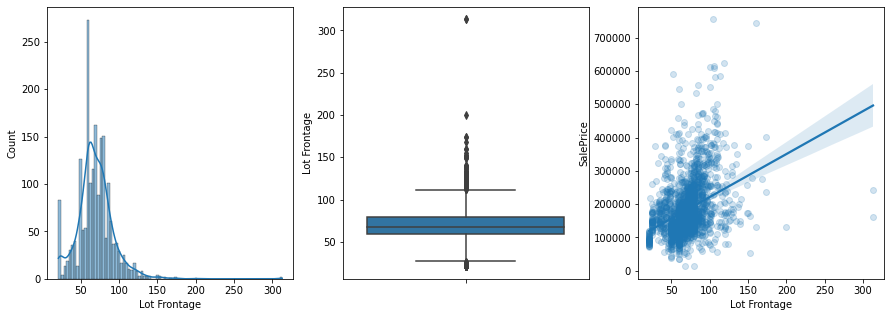

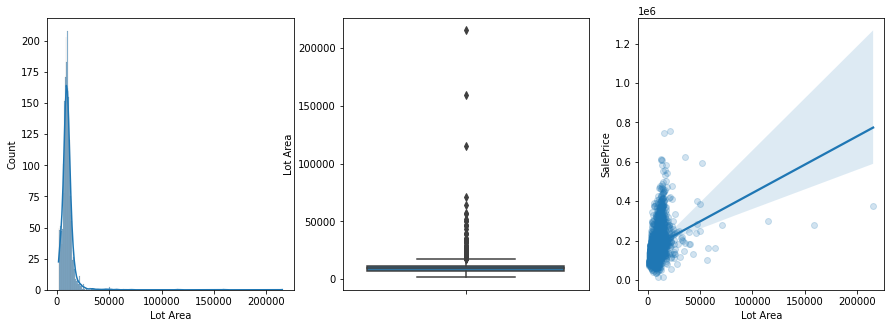

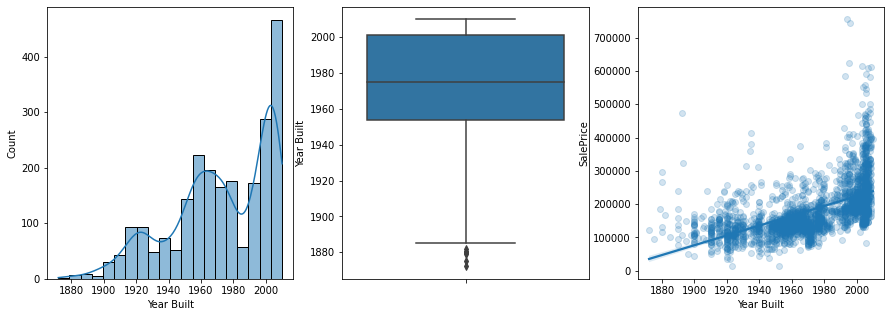

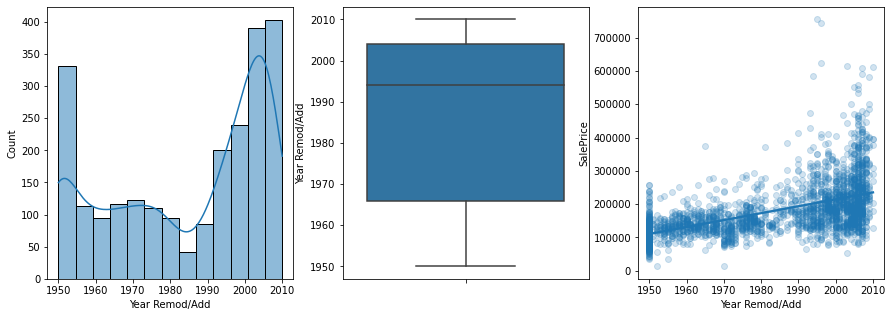

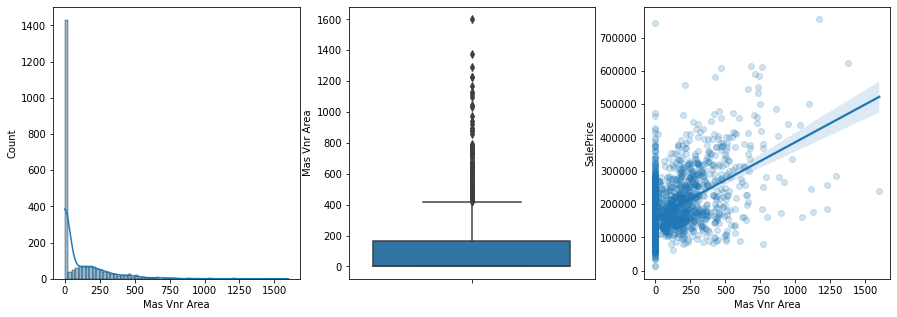

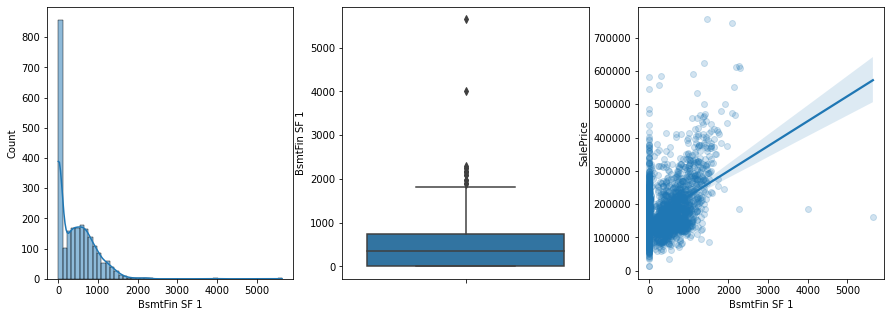

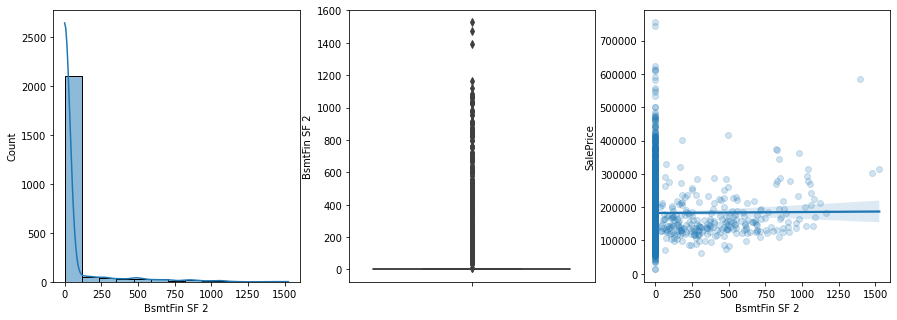

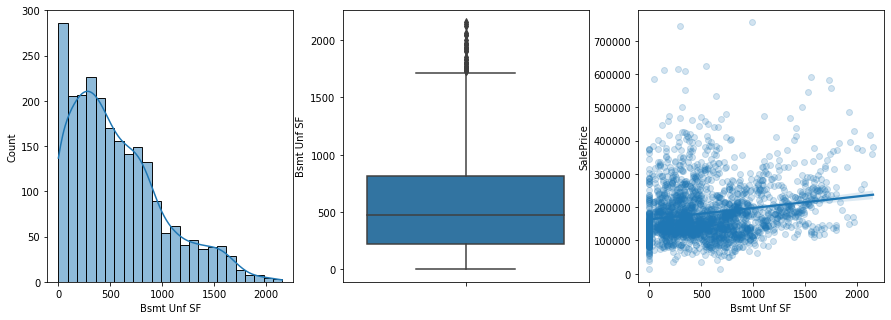

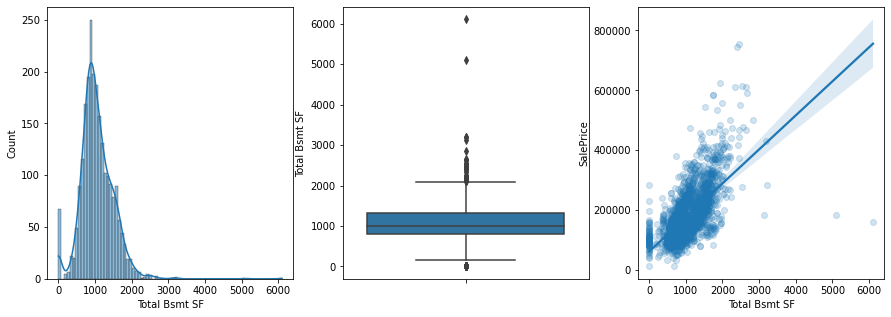

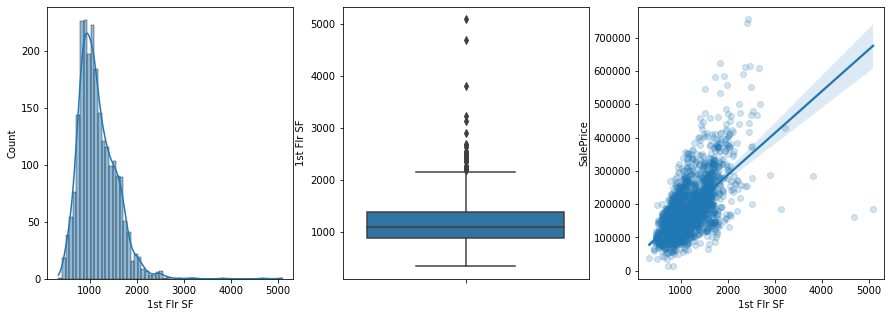

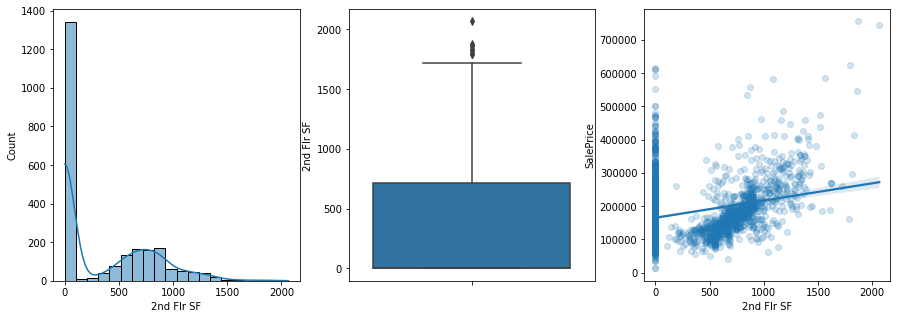

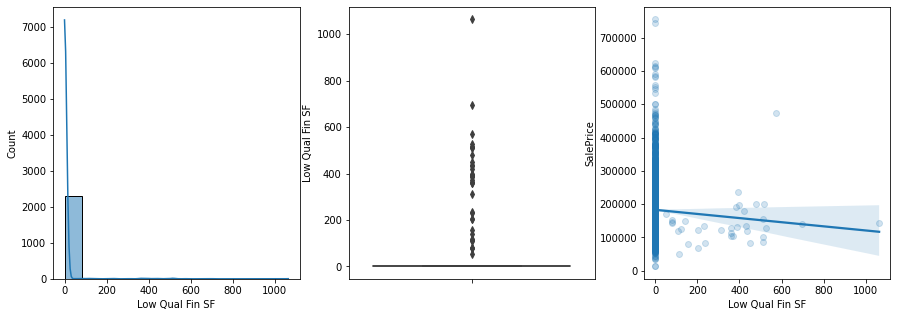

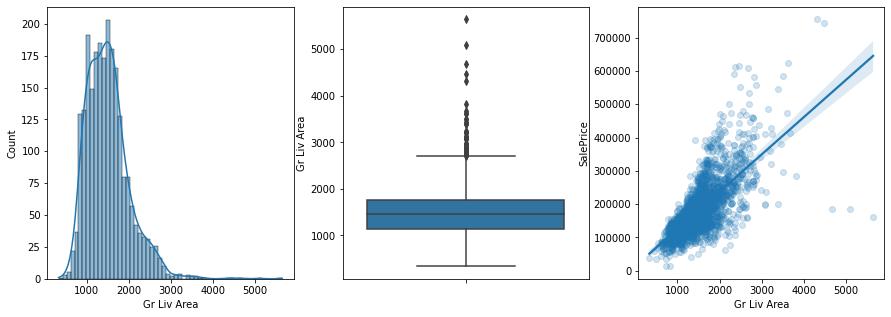

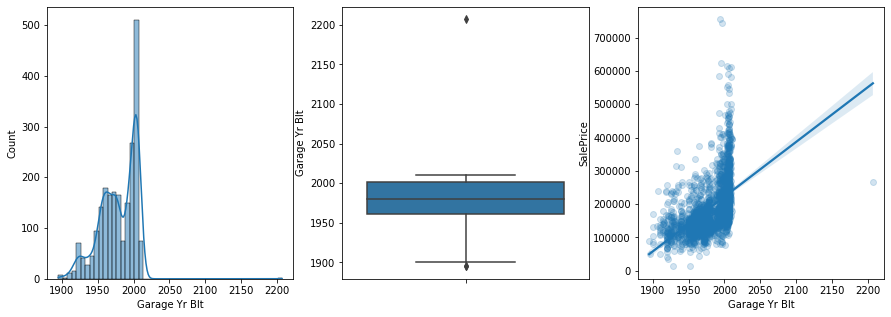

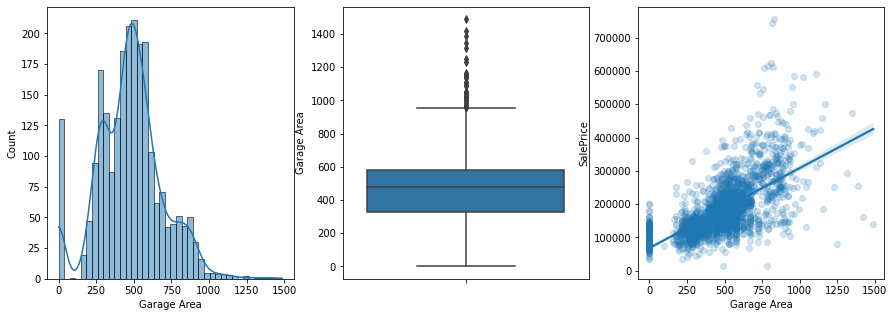

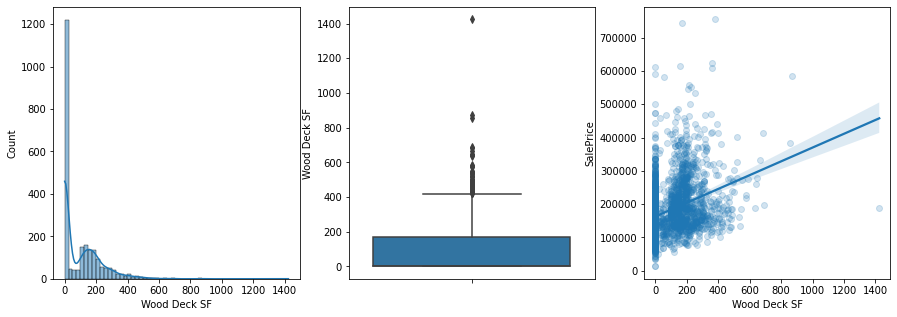

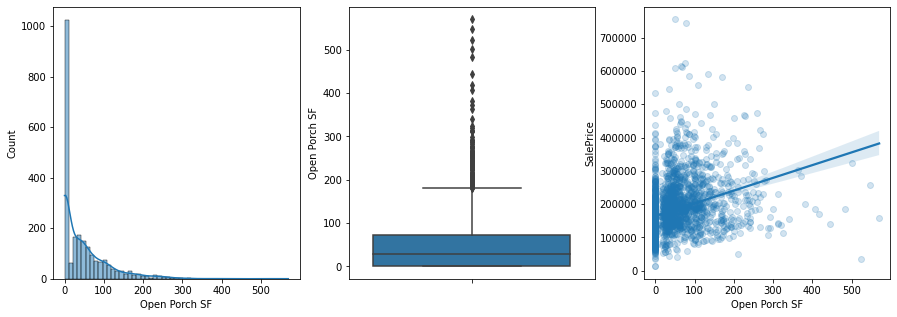

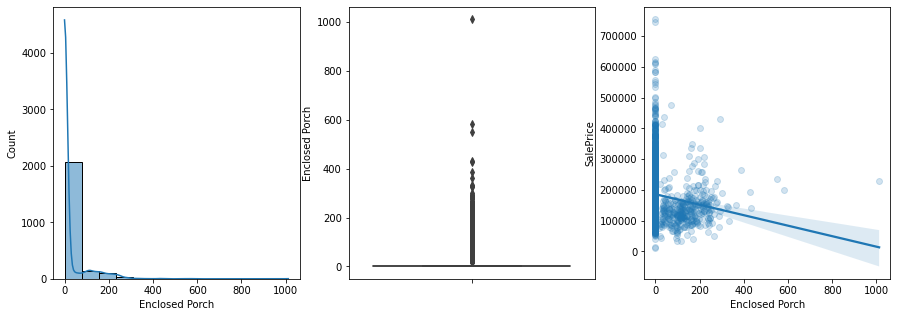

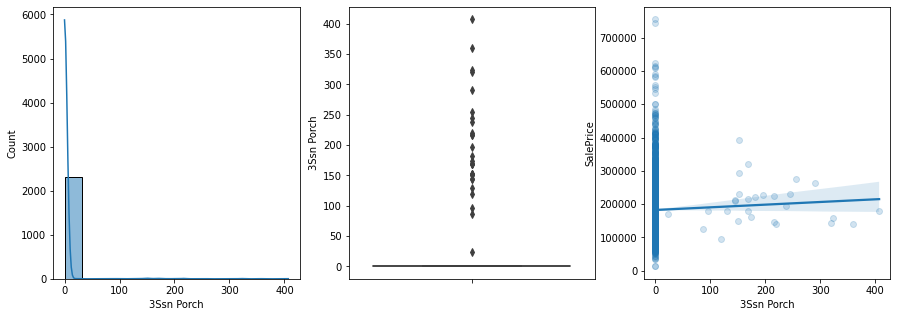

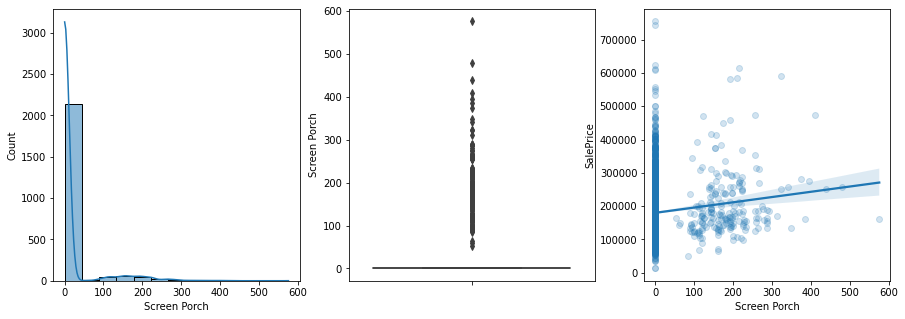

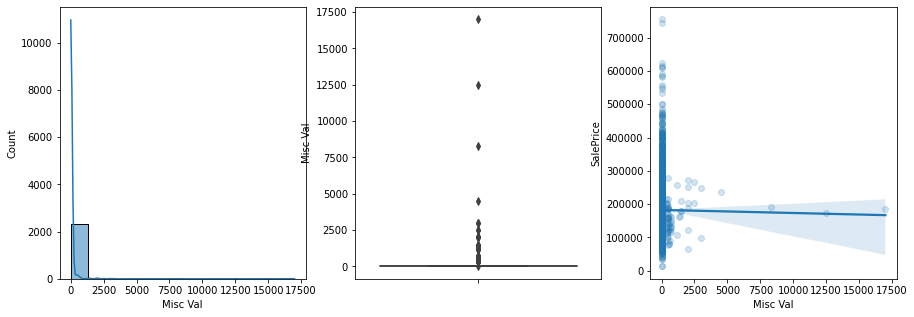

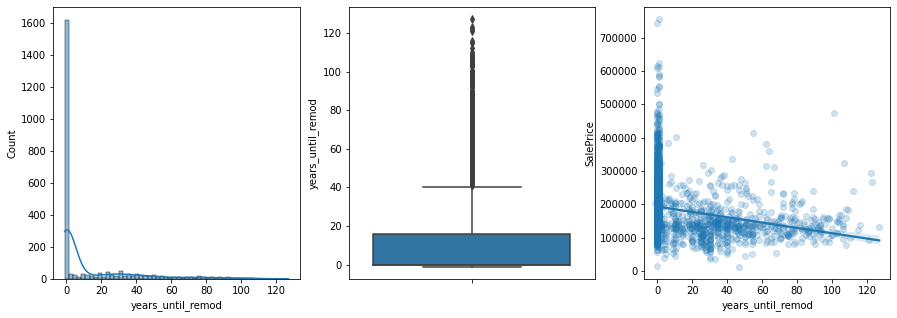

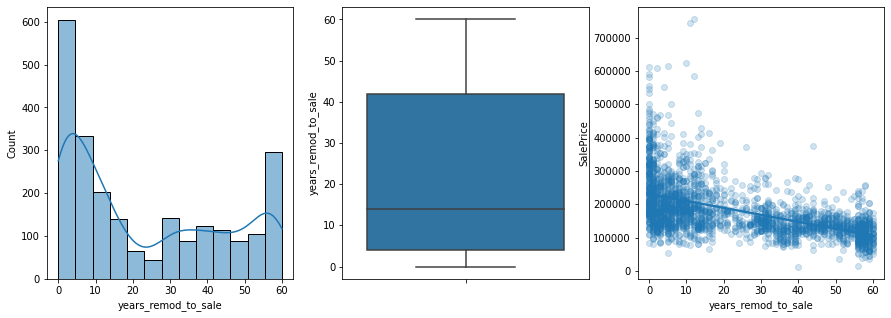

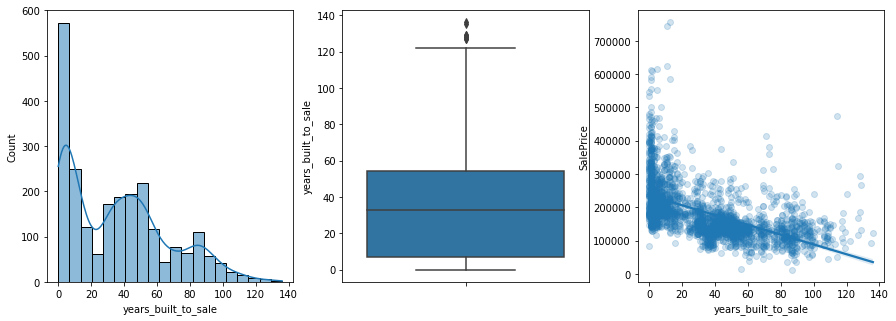

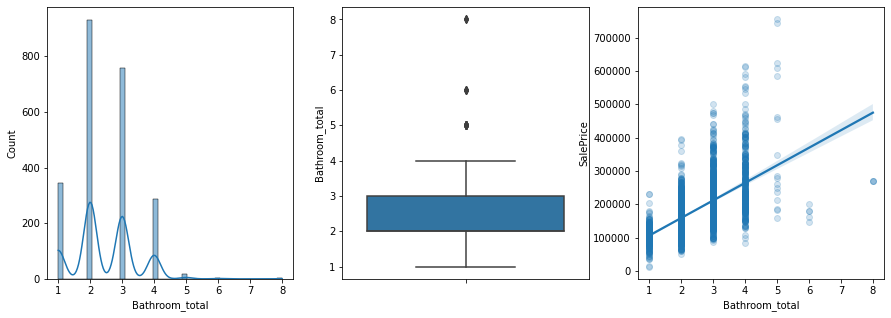

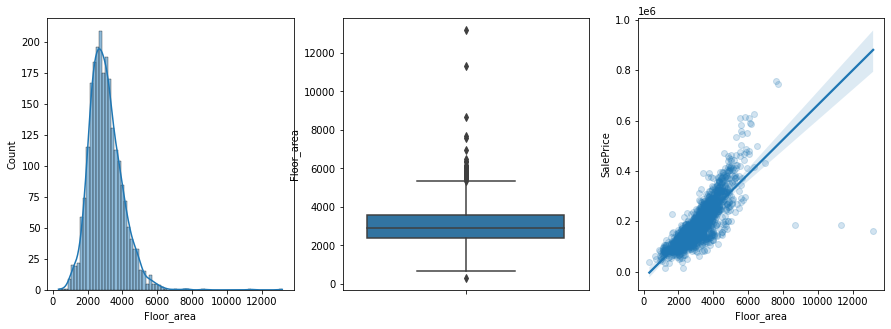

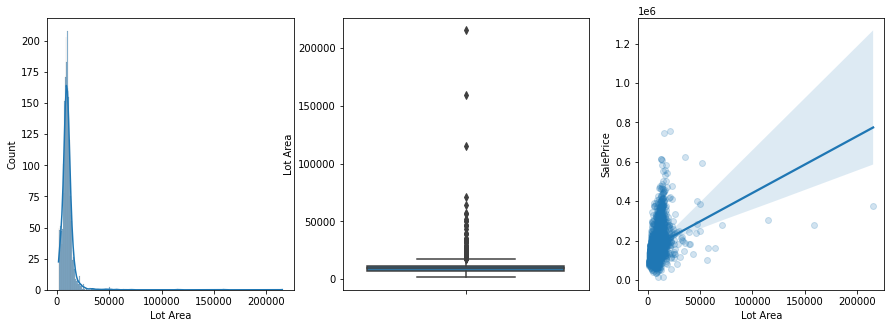

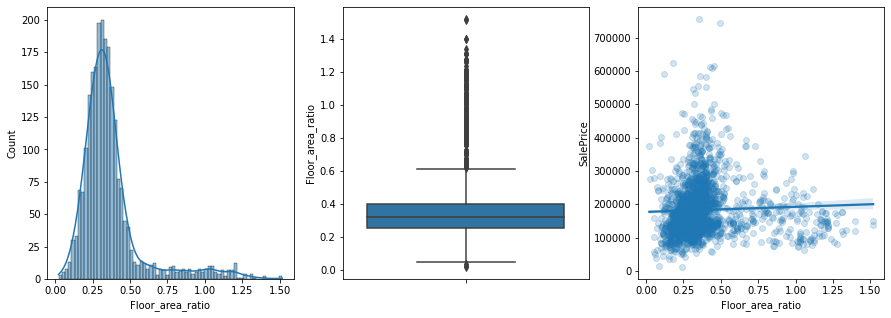

In [26]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    sn.histplot(train_valid[var].dropna(), kde=True, ax=ax[0])
    sn.boxplot(y=train_valid[var], ax=ax[1])
    sn.regplot(data=train_valid, x=var, y=target, scatter_kws={'alpha':0.2})
    plt.show()

We can see that most of data is not coming from normal distribution. Also most of variables have lots of outliers. Transformation of independent variables is recommended.

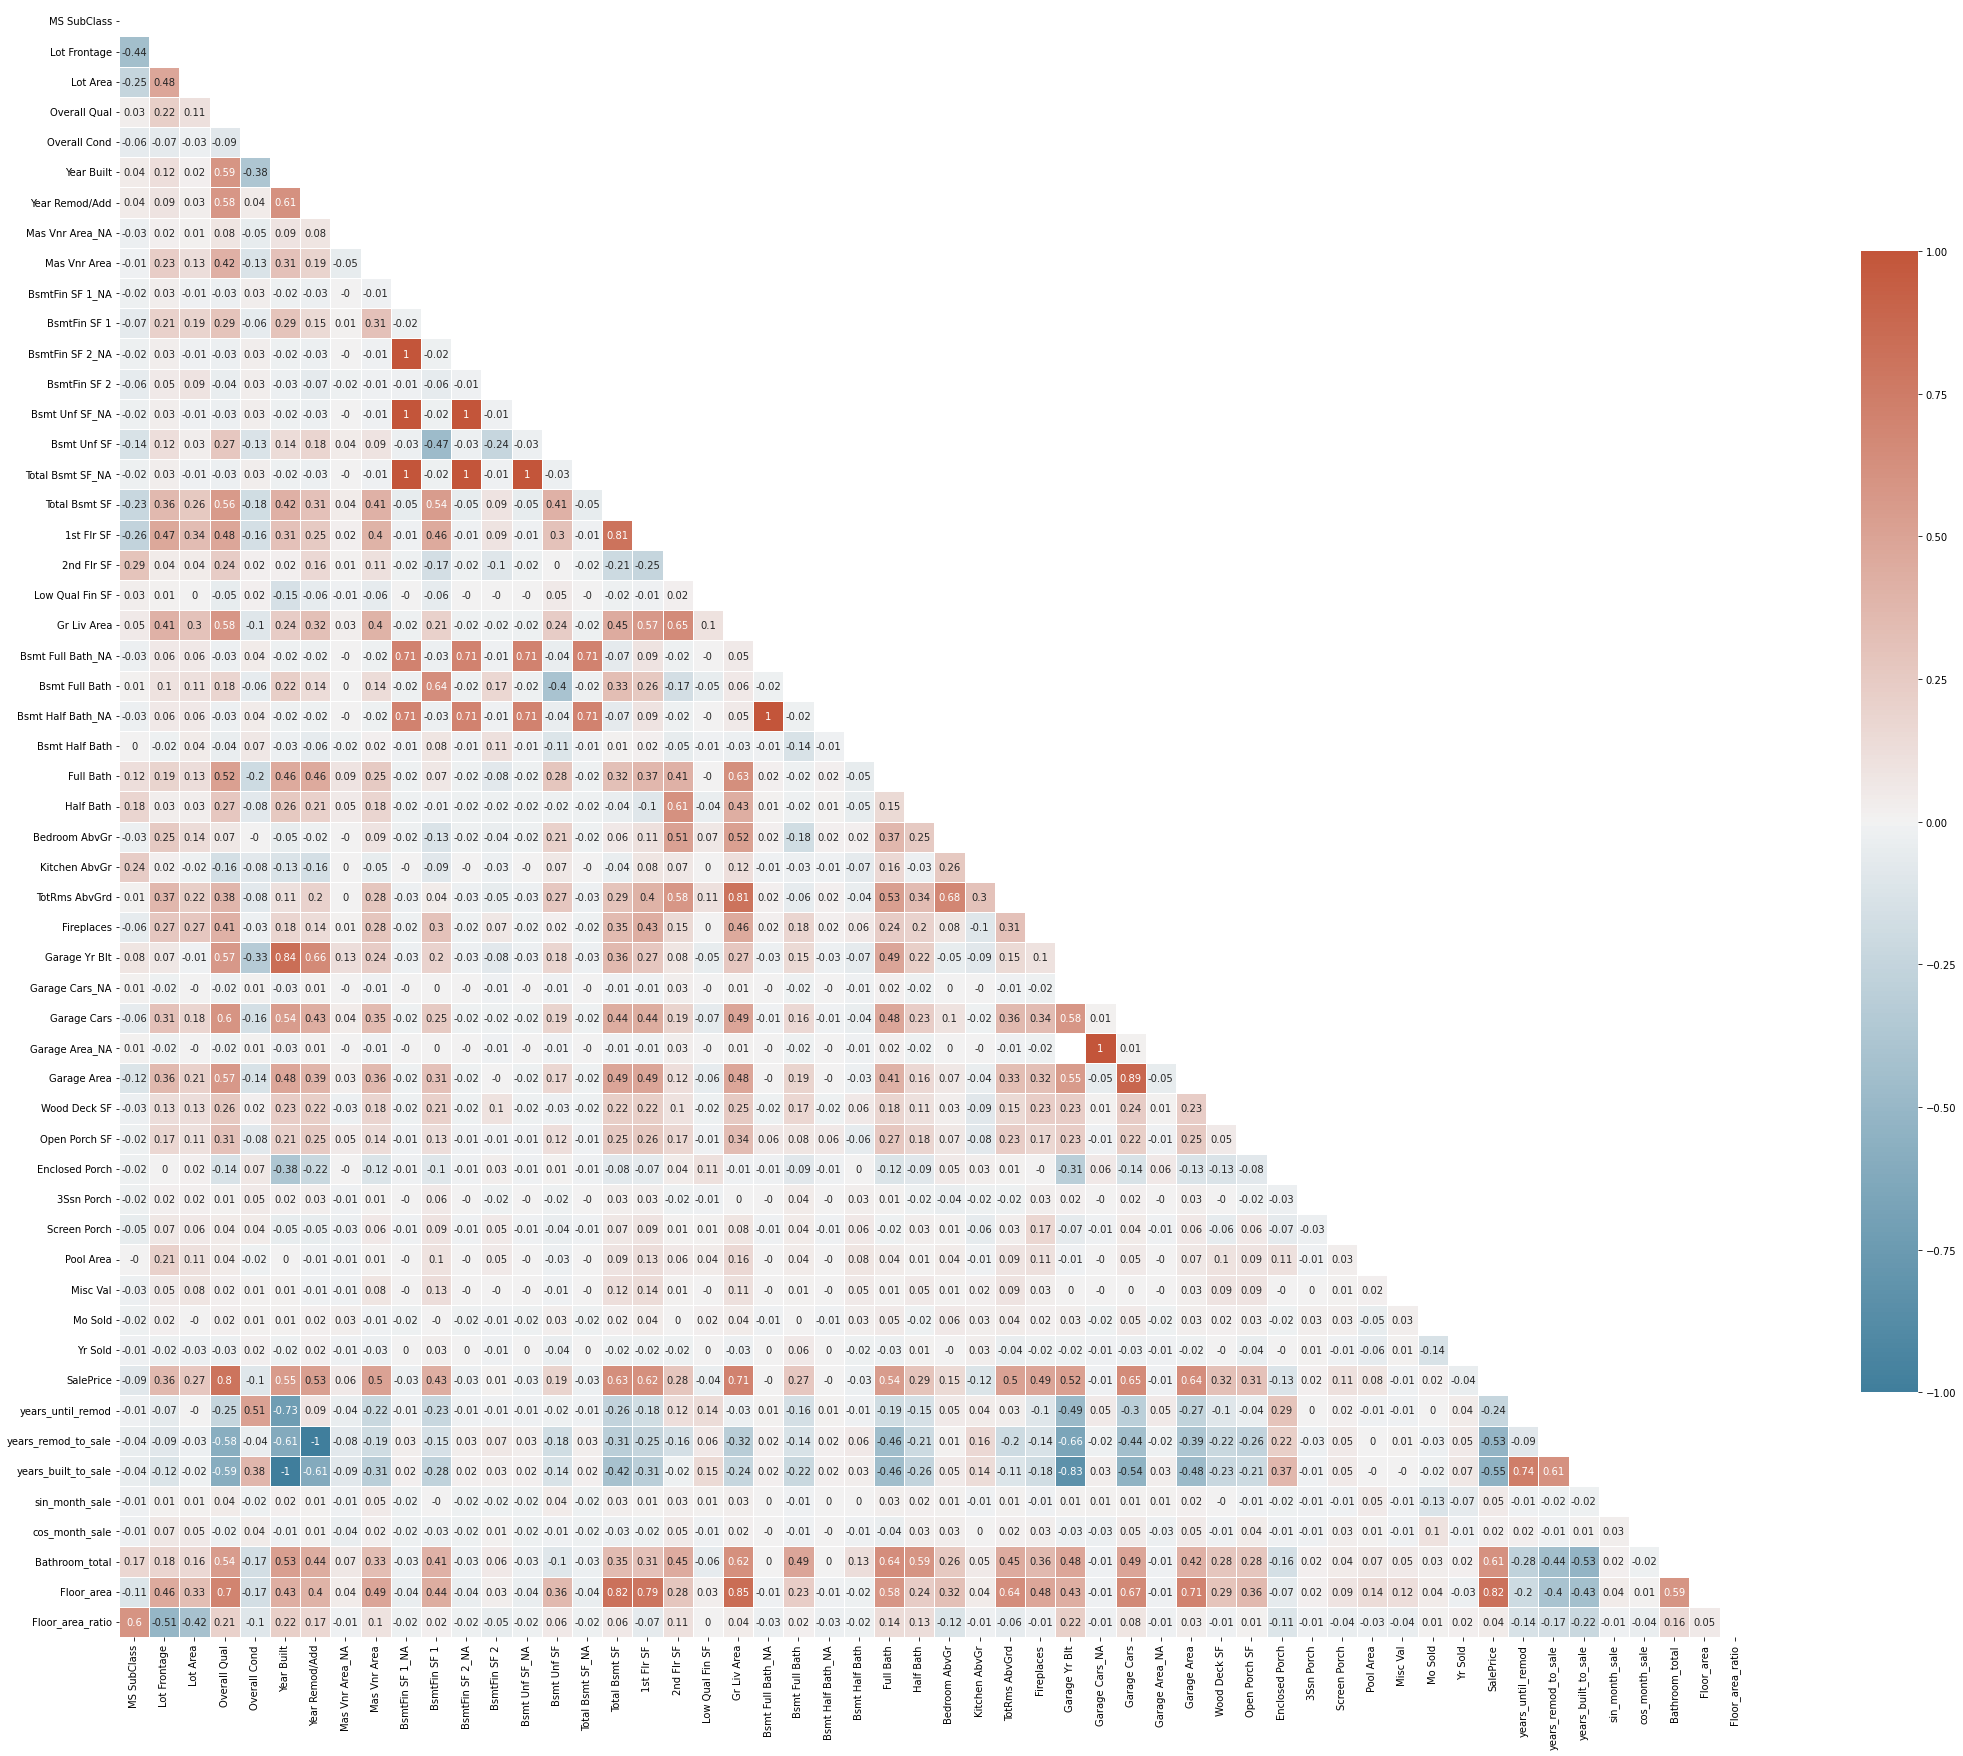

In [27]:
f, ax = plt.subplots(figsize=(40, 30))
mat = round(train_valid.corr('pearson'),2)
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [28]:
# Finding potentially statistically significant ( > 0.4 or < -0.4 ) Pearsons correlationsdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB6sAAAbcCAYAAABFJHHZAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdd3hVRfrA8e+E0CG0JFQVQSmCiooKKCD2Apa1rF13/emurr13Rey9omKjiA3dtaJiAQEpio0moAJKUZLQQUrK/P64l5BQg+JlZb+f58mTe+a8Z96Zc4L+8d6ZE2KMSJIkSZIkSZIkSZKUSmlbegCSJEmSJEmSJEmSpP89FqslSZIkSZIkSZIkSSlnsVqSJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKWexWpIkSZIkSZIkSZKUculbegD6Q8UtPQBJkiRJkiRJkqStSNjSA5C2Jq6sliRJkiRJkiRJkiSlnMVqSZIkSZIkSZIkSVLKWayWJEmSJEmSJEmSJKWcxWpJkiRJkiRJkiRJUspZrJYkSZIkSZIkSZIkpZzFakmSJEmSJEmSJElSylmsliRJkiRJkiRJkiSlnMVqSZIkSZIkSZIkSVLKWayWJEmSJEmSJEmSJKWcxWpJkiRJkiRJkiRJUsptNcXqEEIMITxf4jg9hJAbQng7eVw3hPB2COGbEMLEEMLA9fRzXQhhQghhbAjh6xDC3hvJe3MI4fL1nGsWQhgYQvguhPBlCOGV5Dj2WzUuSZIkSZIkSZIkSfpflL6lB7AZLQVahxAqxxiXAQcBs0qcvwX4IMb4EEAIYZc1OwghtAe6ArvHGFeEEDKBCr9lMCGESsA7wKUxxreSbfsBWb+lP0mSJEmSJEmSJEnammw1K6uTBgJHJD+fBLxY4lx9YOaqgxjj2HVcXx/IizGuSMbkxRhnA4QQpieL14QQ2oYQhpS4btcQwsjkCuqzk20nAyNXFaqT/Q2JMY4vmTCEsFfy2q9CCCNCCM2T7a1CCJ8lV3ePDSHsGEKoGkJ4J7k6fHwI4a+bfIckSZIkSZIkSZIk6b/A1lasfgk4MbmqeRdgdIlzjwHPhBAGJ7f6brCO6wcB24QQpoQQeoYQOpcx7y7A/kB74MZk362BL8pw7SSgY4xxN+BG4PZk+z+Bh2KMbYC2JArthwKzY4y7xhhbA++VcXySJEmSJEmSJEmS9F9lqypWJ1dLNyaxqnrgGufeB5oATwEtgK9CCFlrxCwB9gDOAXKBl0MIZ5Yh9RsxxmUxxjxgMLDXJgy7BjAghDAeeABolWwfCVwbQrgK2C65tfk44KAQwl0hhI4xxoVrdhZCOCeEMCaEMKZXr16bMAxJkiRJkiRJkiRJSp2tqlid9CZwL6W3AAcgxjgvxvhCjPE04HOg0zpiCpPbdd8EnA8cmzxVwOr7VWnNy9ZxPIFE4XtjegCDkyulu63qO8b4AnAksAwYGELYP8Y4BdidRNH61hDCjesYf68YY9sYY9tzzjmnDOklSZIkSZIkSZIkKfW2xmL1s0D3GOO4ko0hhP1DCFWSn6sDTYGf1ohpHkLYsURTG+DH5OfprC4+H0tpR4UQKoUQ6gD7kSiEvwB0CCGseoc2IYROIYTWa1xbA5iV/HxmidgmwNQY48PAG8Auye3Ff40xPg/cQ6JwLUmSJEmSJEmSJEl/OltdsTrGODNZ4F3THsCYEMJYEltsPx1j/HyNmGpAnxDCxGTcTsDNyXPdgYdCCGOAwjWuG0ti++9RQI8Y4+zktt1dgQtCCN+FECYC55HYXryku4E7QghfAekl2k8AxocQvibx/uu+wM7AZ8m2m4BbN3pDJEmSJEmSJEmSJOm/UIhxzR2stRXx4UqSJEmSJEmSJG0+YUsPQNqabHUrqyVJkiRJkiRJkiRJ//0sVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnl0rf0APTHen7IFynPeep+e6Q8pyRJkiRJkiRJkqQ/F1dWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeW2qmJ1CGHJJsSeGUJosJ5zvUMI00IIXyd/LtwMY9svhNDh9/azOcQYee+lPjx6/SU8ectV/PzTtA3Gv/TYvTzR/cq12kd+8A49/nEyvy5Z9EcNVZIkSZIkSZIkSdJWaqsqVm+iM4F1FquTrogxtkn+PFzyRAgh/Tfk2w/4ryhWfz/+a+bl/MK/etzPEaf+HwP7P7ve2G+//IwKFSut1b5w3lymThxLjdqZf+RQJUmSJEmSJEmSJG2ltvpidQihTQhhVAhhbAjhPyGEWiGE44C2QP/kyunKZehnSAjhwRDCGOCiEMIBIYSvQgjjQgjPhhAqJuOmhxC6hxC+TJ5rEUJoDPwTuCSZr2MIoVsIYXSyjw9DCHWT12eFED4IIUwIITwdQvgxhJCZPHdqCOGzZB9PhhDK/ZZ7MuWbL9ilXUdCCDRqsiPLl/3K4oXz14pbuXw5oz8cSMfDj17r3KAB/TjgLydD+C0jkCRJkiRJkiRJkvS/bqsvVgN9gatijLsA44CbYoyvAmOAU5Irp5et47p7SmwDvnOyrUKMsS3wGNAb+GuMcWcgHTi3xLV5McbdgceBy2OM04EngAeS+YYBw4F2McbdgJeAVfts3wR8HGNsBbwKbAsQQmgJ/BXYJ8bYBigETvktN2Txgvlk1K5dfJxRszaL569drB7y5gDaHXQE5StULNU++esxZNSsRb1ttvst6SVJkiRJkiRJkiRp6y5WhxBqADVjjJ8km/oAncp4ecltwMcl215O/m4OTIsxTllPv/9O/v4CaLye/hsB74cQxgFXAK2S7fuSKF4TY3wPWFVFPgDYA/g8hPB18rjJmp2GEM4JIYwJIYzp1atXGae6tl9mTGde7hxa7LZnqfb8lSsY/u4bdD7y+N/ctyRJkiRJkiRJkiT9lncv/y9bWsa4Fcnfhaz/Hj8C3B9jfDOEsB9w80b6DECfGOM1GwqKMfYCVlWp4/NDvgDg88GD+Gr4YAAaNG7Connziq9ZtGAe1WvVKtXPzKnf8fOPU3n42gspKixi6eKF9L2vB4eceAYL5ubSq8fViWvnz+OpW6/jrGt6UK1GzY1MQZIkSZIkSZIkSZIStupidYxxYQhhfgihY3Lr7dOAVausFwPVf2PXk4HGIYQdYozfr9Hv+iwGMkoc1wBmJT+fUaL9U+AE4K4QwsHAqiryR8AbIYQHYow5IYTaQPUY449lGfCeXQ5mzy4HA/DduK/4fPAgWu3ZnlnTvqdS5cpUr1G6WN2280G07XwQAAvycnnpsXs4/bIbALjs3ieK4x6+9kL+79pbqVItA0mSJEmSJEmSJEkqq61tG/AqIYSZJX4uJVEIvieEMBZoA9ySjO0NPJF8J3XlTUkSY1wO/A0YkNzGu4jEO6k35C3gmGS+jiRWUg8IIXwB5JWI6w4cHEIYDxwP/AIsjjFOBK4HBiXn8gFQf1PGvcoOrdtQKzObx66/hLf7Pc1hJ/29+FyvHhtcuC1JkiRJkiRJkiRJm0WIMW7pMaiEEEJFoDDGWBBCaA88HmNs8xu7K94GPJVO3W+PlOeUJEmSJEmSJElKgbClByBtTbbqbcD/pLYFXgkhpAErgbO38HgkSZIkSZIkSZIkabOzWP1fJsb4HbDblh6HJEmSJEmSJEmSJP2RtrZ3VkuSJEmSJEmSJEmS/gQsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUi7EGLf0GPTH8eFKkiRJkiRJkiRtPmFLD0DamqRv6QHojzVi4tSU5+ywUxN+eLFXyvM2PemclOeUJEmSJEmSJEmS9Nu4DbgkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5dK39AD+24UQlsQYq5Ux9kxgUIxx9nrOpwM/A8/EGK/efKPcNDFGXnjmCcZ+8TkVKlbkrAsuo3HTHUrFrFixnJ733E7OLz+TlpZGm7Z7c/zpfwdg+Mcf8HKfp6lVOxOAAw7vRueDDt1o3jHfTePJ9wZTVBQ5ZPfWnNBx73XGDZ84hdtfeYsHzz6FZg3rUVBYyENvDuL7n3MoKipi/1134q/ruVaSJEmSJEmSJEnSn4PF6s3rTGA8sM5iNXAQMAU4PoRwTYwxrhkQQigXYyz844YIY7/8nDmzZ3Nnz2eYOmUS/Z58lBvufnCtuEOPOpaWO+9KQX4+d990DWO/+Jxd9tgTgL326cxp55xX5pyFRUX0HPgRt512HJkZ1bn4qf60a74D22bXKRX364qVvDHqS5o3rF/cNmzCFPILCnn8vDNYvjKffz7Wm/1at6BurRq/7QZIkiRJkiRJkiRJ2uLcBvw3CCG0CSGMCiGMDSH8J4RQK4RwHNAW6B9C+DqEUHkdl54EPAT8BLQv0d/0EMJdIYQvSRSyDw4hjAwhfBlCGBBCqJaMuzGE8HkIYXwIoVcIIfyW8X/12Sg6dDmAEAJNm7fk16VLWDBvXqmYihUr0XLnXQFIL1+e7ZrswPy5eb8lHQBTZv1Cg9o1qV+7JuXTy9GpdXNGTv5+rbh+H3/K8fvuRYX0csVtIcDy/HwKC4tYWVBAerlyVKlY4TePRZIkSZIkSZIkSdKWZ7H6t+kLXBVj3AUYB9wUY3wVGAOcEmNsE2NcVvKCEEIl4EDgLeBFEoXrkubGGHcHPgSuBw5MHo8BLk3GPBpj3DPG2BqoDHT9LYNfMHcutetkFh/XqpPJ/HnrL0T/unQJ34wZTctd2hS3fTFqODdcfC6P3X0rc/NyN5pz7qIlZGZULz7OzKjO3EVLSsV8P3sOuYsWs1ezJqXa992pGZXKl+eU+57gjAd6cWyHtlSvsq7vAkiSJEmSJEmSJEn6s7BYvYlCCDWAmjHGT5JNfYBOZbi0KzA4WcR+DTg6hFCuxPmXk7/bATsBn4YQvgbOALZLnusSQhgdQhgH7A+0Wsf4zgkhjAkhjOnVq9cmzm5thYWFPHHfXRx4xJFk10tszd2m7d7c82Rvejz4ODvtujtPP3Tf785TVBR56v0hnH1w57XOTZ71C2lpgecv+wfPXXQ2/x45hp/nLfjdOSVJkiRJkiRJkiRtOb6zOnVOAvYNIUxPHtchUXD+IHm8NPk7AB/EGEutvE6uzO4JtI0xzggh3AxUWjNJjLEXsKpKHUdMnArARwPf4pMP3gNg+x2aMa/Elt7z5+ZRq3Ym69K750PUbdCAg7sdU9xWLSOj+HPnAw9hQN9nNjxzoE5GNfIWLS4+zlu0mDoZ1YqPl61cyY85eVzV+5XEmJYs5ZYXX+fGk45myLhv2WOH7UkvV46a1aqw0zYN+G72HOrXrrnRvJIkSZIkSZIkSZL+O7myehPFGBcC80MIHZNNpwGrVlkvBqqveU0IIQPoCGwbY2wcY2wM/Iu1twIHGAXsE0LYIXlt1RBCM1YXpvOS77A+blPGfcDh3bjlgce45YHH2H3v9owY/BExRn6Y/C2Vq1SlZu3aa13zWv8+LPv1V076+z9KtZd8v/VXn4+ifqNtNpq/WYN6zJ67gF/mLyS/oJCh4yfTrnnT4vNVK1Xkpav+Re9Lzqb3JWfTolF9bjzpaJo1rEd2jQy+mfYTAMtX5jNp5s9sk7n2eCVJkiRJkiRJkiT9ebiyeuOqhBBmlji+n8TW3E+EEKoAU4G/Jc/1TrYvA9qXeG/1McDHMcYVJfp5A7g7hFCxZLIYY24I4UzgxRLnro8xTgkhPAWMB34BPv+tE9pljz0Z+8XnXHXu36lQsRJnXXBJ8bkbL/kXtzzwGPPycnn71Zeo33Abbr7sAiBR8O580KF88M4bfP35KMqVK0fVatX5vwsu22jOcuXSOPfw/bm+32sUxSIO3q0122Vn0u/jT9mxQV3atdhhvdd23bMND7zxPv98rDcxRg7arTXb18v6rdOXJEmSJEmSJEmS9F8gxBi39Bj0xyneBjyVOuzUhB9e/P3vy95UTU86J+U5JUmSJEmSJEnS/5SwpQcgbU3cBlySJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKWexWpIkSZIkSZIkSZKUcharJUmSJEmSJEmSJEkpZ7FakiRJkiRJkiRJkpRyFqslSZIkSZIkSZIkSSlnsVqSJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKWexWpIkSZIkSZIkSZKUcharJUmSJEmSJEmSJEkpF2KMW3oM+uP4cCVJkiRJkiRJkjafsKUHIG1N0rf0APTHWjQ3L+U5M+pkMufr0SnPW7fN3sz7cWrK8wLU3q7JFskrSZIkSZIkSZIk/Vm5DbgkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5dK39AA2pxBCI+AxYCcShfi3gStijCv/4LxLYozVQgiNgbdjjK3XEdMKeARoSOK+Pw90jzEW/cac04G2Mca8ssSPGDWK+x58kKLCIo7q1o0zTz+t1PmVK1dyU48eTJo0mRo1anB7j1toUL8+EyZO5La77koERTj7rL/TpXPn4usKCws5/e9nkZ2VxQP33rPBMYz+eiwP936eoqIijti/M6ce3a3U+Zfffpe3P/6EcuXKUTOjOlf/8/+ol5XJd9N/5P6ne7N02XLS0tI47ZhuHNChXVmmDcDIz8fw4ONPUFhUxJGHHsrpJ55Q6vxXY8fx4BNP8sPUadxy7dXs36lj8bmLr72eCd9OYpfWrbivR/cy55QkSZIkSZIkSZK0YVvNyuoQQgD+DbweY9wRaAZUA27bDH3/rqJ+CKEy8CZwZ4yxObAzsBdw0e8dW1kUFhZy97338dB99/HKC/0Z9OGHTJ02rVTMG2+9TUb16vxnwCuc/Ne/8kjPngA0bdKEvs88wwt9+vDw/fdxx113U1BQUHzdS68MYPvGjTc+hqIiHni2L/dcczl977+Tjz4dxfSZs0rF7Nh4O566ozu977mN/fbek8f7vwRApQoVuPZf/6DvfXdw7zWX80if/ixeurTMc7/v0ce4/7YevPjUk3wwZAjTfvyxVEy97GxuuPwyDtq/y1rXn3L8sdx45eVlyiVJkiRJkiRJkiSp7LaaYjWwP7A8xvgcQIyxELgE+HsIoUoIYVRydTMAIYQhIYS2IYSqIYRnQwifhRC+CiEclTx/ZgjhzRDCx8BHIYRqIYSPQghfhhDGrYoro5OBT2OMg5Jj+xU4H7gimevmEEJxRTSEMD65SpsQwushhC9CCBNCCOf8lhszYeK3bNOoEY0aNqR8+fIcdOABfDJsWKmYocOGccRhhwOwf5f9+HzMF8QYqVSpEunpiVr9ipUrSXwnIGFOTg7DR4zgqG6lV0ivy7ff/0DDutk0qJtN+fR0DujQjuGff1kqZvfWO1GpYkUAdtqxKblz5wOwTYP6bFO/HgCZtWtRKyODBYsWl2nuEydPoVGDBjSsX5/y5ctzYOfODB0xqlRM/Xp12aHJ9qSVmNsqe+62G1WrVClTLkmSJEmSJEmSJElltzUVq1sBX5RsiDEuAn4CdgBeBk4ACCHUB+rHGMcA1wEfxxj3AroA94QQqia72B04LsbYGVgOHBNj3D0Zd18I66huln1sPwCVQwg1N3Lt32OMewBtgQtDCHXKmLNYbm4udetmFx/XzcomNze3VExOiZj09HSqVa3KwoULARg/YQInnHIKJ512OldfeUVx8fr+Bx/iwn+dR1raxm9D3rz5ZNdZPfSsOrXJnT9/vfHvDB7K3m12Wat94vc/kF9QQMMS89mQ3Lw8srOyio+zszLJnTu3TNdKkiRJkiRJkiRJ+uNsTcXqjXkFOC75+QTg1eTng4GrQwhfA0OASsC2yXMfxBjnJT8H4PYQwljgQxLvnq77xw+bC0MI3wCjgG2AHTcUHEI4J4QwJoQwplevXptlAK1bteKV/v3p88zT9O7bjxUrVjDs00+pVasWLVu02Cw5Sho07FMm/zCNk448vFR73vwF3Pbok1xz7tmkpf0v/elKkiRJkiRJkiRJW5/f9S7m/zITWV2MBiCEkEGi8Px9jPHXEMLcEMIuwF+Bf64KA46NMU5e49q9gZIvRj4FyAL2iDHmhxCmkyhsl3VsndbovwkwN8a4IIRQQOkvDlRKxuwHHAi0T45/yMZyxhh7Aauq1HHR3DyysrKYMyenOGZObg5ZJVYbA2QnY+pmZ1NQUMCSpUupUaNGqZjtGzemSuXK/DB1Kt+MHcuw4cMZMXIkK1auZOnSpdxwc3d63HzTOseVWbsWOSVWNOfOnUdWrVprxY0ZO56+/36TR26+jgrlyxe3L/11GVfdeR9nn3gcrZrtsKFbUEpWZiY5JVaR5+TmkVVnkxenS5IkSZIkSZIkSdrMtqblqR8BVUIIpwOEEMoB9wG9k++IhsRW4FcCNWKMY5Nt7wMXrNrSO4Sw23r6rwHkJAvVXYDtNmFs/YF9QwgHJnNUBh4GVlV2p5PYcpwQwu7A9iVyzk8WqlsA7TYhZ7GdWrbgp5kzmTV7Nvn5+Xzw4Ud02nffUjEdO+7LO+8OBODjwUPYc489CCEwa/ZsCgoKAPj551+Y/tOPNKhfn/PPPZd33nidN//9Grff0p0999hjvYVqgBZNmzDzlznMzsklv6CAj0aMYp+2pW/1lGnTuffp3txx5SXUqpFR3J5fUMB19z3EIZ32Yb92e23S3Fs2b8aMWbOZ/fMv5Ofn8+Enn9Cx/W+6jZIkSZIkSZIkSZI2o61mZXWMMYYQjgF6hhBuIFGIHwhcWyLsVeAhoEeJth7Ag8DYEEIaMA3ouo4U/YG3QgjjgDHApE0Y27IQwpHAIyGEniS2EL81xtg/GfIacHoIYQIwGpiSbH8P+GcI4VtgMomtwDdZeno6V156CRdecimFhYUc2bUrTZs04YmnnqJlixZ07tiRo7p25aZbenDM8SeQkZHBbbd0B+Cbb8bS+/l+pKenkxbSuOqyy6lZs+amj6FcOS7+++lcfvvdFBVFDt+vE9tv04hnXnmN5k22Z9+2u/P48y+xbPlybnrgUQCyM+tw55WXMHjkaL75djKLFi/hvU+GA3DNeWezY+ONf18gvVw5Ljv/XC6+9nqKigrpesjBNGm8Hb369KVls2Z0bN+OiZMnc3X3HixevITho0bzdL/neeGpJwH456WX8+OMGfy6bDlHnnwq1156Ce3a7rHJ85ckSZIkSZIkSZJUWogxbukx/M8JIRwN3A90iTH++Aemiovm5v2B3a9bRp1M5nw9OuV567bZm3k/Tk15XoDa2zXZInklSZIkSZIkSVJKhS09AGlrsjVtA/6nEWN8PcbY5A8uVEuSJEmSJEmSJEnSfy2L1ZIkSZIkSZIkSZKklLNYLUmSJEmSJEmSJElKOYvVkiRJkiRJkiRJkqSUs1gtSZIkSZIkSZIkSUo5i9WSJEmSJEmSJEmSpJSzWC1JkiRJkiRJkiRJSjmL1ZIkSZIkSZIkSZKklLNYLUmSJEmSJEmSJElKOYvVkiRJkiRJkiRJkqSUCzHGLT0G/XF8uJIkSZIkSZIkSZtP2NIDkLYm6Vt6APpj/Zw3P+U562fWYnbuvJTnbZBVm9z5C1OeFyCrVg1++iUv5Xm3rZeZ8pySJEmSJEmSJEnS5uA24JIkSZIkSZIkSZKklLNYLUmSJEmSJEmSJElKOYvVkiRJkiRJkiRJkqSUs1gtSZIkSZIkSZIkSUo5i9WSJEmSJEmSJEmSpJSzWC1JkiRJkiRJkiRJSjmL1ZIkSZIkSZIkSZKklLNYLUmSJEmSJEmSJElKOYvVkiRJkiRJkiRJkqSUS9/SA/i9QgiNgMeAnUgU398GrogxrvyD8y6JMVYLITQG3o4xtl5HTDPgQWBHYDHwPXBBjHHO78x9JtA2xnj+b7k+xsgjD97PqJEjqVSpIldfdwPNmrdYK27ypEnceVsPVqxYQbv27bng4ksJIQDw7wGv8J9/v0a5tDTadejAP/91wfpzPfQAo0eOoFKlSlx17Q00a958nbnuuj2Ra+/2HbjgoktW53p1AK//+1XS0solcp13PgUFBdxz5+18N2UyhYWFHHzoYVxx6SWl8j50/32MHDmCShUrce0NN9K8xdpznDTpW27vcQsrVqygffsOXHTpZYQQeOrJJxg+dCghLVCrVm2uu+FGMrOyGDb0E55+8klCWqBcuXJcePGl7NqmTam8PR9+kM9Gj6RixUpccc117Nhs7flOmTyJe+64jZUrV7DX3u0578KLCSHw/XdTeOj+e1i5cmWi/0sup0XLnQD45qsv6fnoQxQWFJBRoyb3P/zYBp6yJEmSJEmSJEmS9N/tT72yOiSqmf8GXo8x7gg0A6oBt22Gvn9XIT+EUAl4B3g8xrhjjHF3oCeQ9XvH9nuNHjmSmTNn0P/lAVx25TU8cO/d64x74N67ufyqa+j/8gBmzpzBZ6NGAvDVF18wfPhQnunTj979X+SvJ5+y/lyjRjJrxgyef2kAl11x9XpzPXjf3Vx+5TU8/9IAZs2YwWejRiVyffkFnw4bytO9+9H7+Rf460knAzDk44/Iz8/n2b79efKZ3rz1xuvMnDmzuL9RI0cwY8YMXhrwGldccw333n3XOvPed/ddXHnNtbw04DVmzJjBqJGJOZ586qn06f8Cvfv1p8M++/Lcs08DsEfbPen9fH969+vPNdfdwF13lP5T+2z0SGbNnEnv/i9z8eVX8vD9964z78P338slV1xF7/4vM2vmTD4fnZjvU0/05LQz/s6Tz/ThjL//H0890ROAJYsX8/AD99Hj9rt4uk9/buh+63rvuSRJkiRJkiRJkvRn8KcuVgP7A8tjjM8BxBgLgUuAv4cQqoQQRoUQWq0KDiEMCSG0DSFUDSE8G0L4LITwVQjhqOT5M0MIb4YQPgY+CiFUCyF8FEL4MoQwblVcGZ0MjIwxvrWqIcY4JMY4PoRQKYTwXLLPr0IIXUrk/3cI4b0QwnchhOLKbgjhbyGEKSGEz4B9fsc949PhQznk0MMJIdCqdWuWLF7C3Ly8UjFz8/JYunQprVq3JoTAIYcezvBhQwF44/V/c/Kpp1OhQgUAatWqvf5cw4Zy8KGHEUJgp9atWbpk/bl2SuY6+NDDGD7sk0Su//ybk089ba1cIQSWL1tGYUEBK1asoHx6eapVq1bc57ChQzn08MQcW7femSVLFpO3Rt68ZN7WrXcmhMChhx/OsKGJvFWrru5r+fJlBBKrvKtUqVK84rtk+yojhw/nwEMOTcy3VWuWLFnM3LlrzHduHr/+upSdWiXme+AhhzJi+LDief3661IAli5ZSp06mQB8/OEH7NupM9l16yXvQ6313nNJkiRJkiRJkiTpz+DPvg14K+CLkg0xxkUhhJ+AHYCXgROAm0II9YH6McYxIYTbgY9jjH8PIdQEPgshfJjsYndglxjjvOTq6mOSfWYCo0IIb8YYYxnG1nrNsZXwr8RQ484hhBbAoOSW4QBtgN2AFcDkEMIjQAHQHdgDWAgMBr4qwxjWKTc3l6zs7OLjrOxscnNzqZOZuUbM6kXgWVmJGIAZP/3EuG++4ZleT1ChQkXOPf+C4q2q15SXl0t2dt3i48zsLPLySufKy8slK6v0ePLyErlmzpjB2LHf8HSvJ6lQsQLn/iuRq3OX/fl0+DCOPbobK5Yv57wLLqJmzZrkzl+Y6DM3p1Te7Oxs8nJzyCyZNzenVN5VMas8+XhP3n93IFWrVePhxx4vbv9kyGCefLwn8+fP55777l/HfFf3mZmVTV5ubnHROZE3l8yS883KKp7vuedfxDVXXEqvno9RFIt46LEnE/dh5k8UFBRy2UXns+zXXznm2OM56NDD1nnPJUmSJEmSJEmSpD+DP/vK6o15BTgu+fkE4NXk54OBq0MIXwNDgErAtslzH8QY5yU/B+D2EMJY4EOgIbC6Avrb7Qs8DxBjnAT8SGILc4CPYowLY4zLgYnAdsDewJAYY27yXdwvr6/jEMI5IYQxIYQxvXr12gxDXVthYSGLFi2kZ69n+Oe/zufmG66jbPX735Zr8aJF9Oz1NP8873y633g9MUa+nTiBtLQ0Xn39LV4Y8BoDXnqRGTNmbNbc/zj3PP795tscfMih/PvVAcXtnffrwgsvD+COu+7mqSef3Kw5337jP5x7/gW88Op/OPdfF3Lf3XcAifvw3ZRJ3HrnPdxxz/0837c3M2f8tFlzS5IkSZIkSZIkSan0Z19ZPZHVxWgAQggZJArP38cYfw0hzA0h7AL8FfjnqjDg2Bjj5DWu3RtYWqLpFBLvmN4jxpgfQphOorBdFhOAzps4H0isqF6lkE18RjHGXsCqKnX8OW8+AP957VXefvMNAFq0bEluzuoVxLk5OWRllX6VdlZWFrk5uatjclfHZGVn06lzF0IItNypFWkhjYULFlAzuTV1//796f/Ci8W5cnLmFPeTl5NLZmbpXJmZWeTmlh7PqpisrCw6dt5vrVwffTCIvfZuR3p6OrVq1abVzjvz+OOP883YsQC0bLlTqbw5OTmlVjNDYtVzybzrigE46JBDueLSiznr7HNKtbfZbXdmz76F5/v2ZcjHH7KyoIDmzVuSU+Le5uXmkLnGvc3Myiq1gjs3d/U9GfT+u5x34cUAdOqyP/ffc2fyPmSTkVGDypUrU7lyZXbZtQ0/fP89Hfbcfa3xSpIkSZIkSZIkSX8Gf/aV1R8BVUIIpwOEEMoB9wG9Y4y/JmNeBq4EasQYxybb3gcuCMmXD4cQdltP/zWAnGShuguJVc5l9QLQIYRwxKqGEEKnEEJrYBiJQjjJ7b+3BSavs5eE0UDnEEKdEEJ54PhNGAcAxxx7HM/06cczffqxb6fOvP/eQGKMTBg/nqrVqpXalhugTmYmVatWZcL48cQYef+9geyzbycA9u3Yia++TOxwPuOnn8gvyKdGzZrF155yyik83bsvT/fuyz4dOzHovXeJMTJx/HiqVqu63lwTk7kGvfcu+3RM5uq07lx169Yrbl+2bBnfTpzA6aefTu9+/endrz8dO3fmvYGJOY4fP45q1aqV2gIcIDOZd/z4ccQYeW/gQDp26lSca5XhQz9hu+0aA4ltyVetIp88aRL5+fmcctppvPHGGzz5TB/26diJD99/LzHfCeOpWrVaqS3AAerUyaRKlapMnJCY74fvv0f7ffctPjf268QO7199+QUNG20DQPt9OjJ+3FgKCwpYvnw5k76dwLbJMUmSJEmSJEmSJEl/Rn/qldUxxhhCOAboGUK4gUTxfSBwbYmwV4GHgB4l2noADwJjQwhpwDSg6zpS9AfeCiGMA8YAkzZhbMtCCF2BB0MIDwL5wFjgIqAn8Hiy3wLgzBjjimTtfF19/RxCuBkYCSwAvi7rONalXfsOjB45glNOOI6KlSpx1bXXF58764zTeKZPPwAuvuwK7rytBytXrGCvdu3Zu317AA7v2o27br+VM089mfLl07nm+htZ39hX5Tr1r8dTsVLFUrn+78zTebp33xK5bk3masfe7RK5DjuiG3ffcRt/O+0UypdP5+rrbiCEwNF/ObZ4DBA59PAjaNGiRfE7q9t32IeRI0bw1+P+QqVKlbj2+huK85552in07tcfgMuuuJLbetzCihUraNe+A+3adwDgiZ6P8dNPP5IW0qhbrx5XXHU1AEMGf8x77w4kPT2dihUr0r3HbaXmvle79oweNZIzTj6BihUrcfnVq/8U/3HWGTz5TB8ALrjkMu698zZWrFjBnnu3Y6+9E/O99Iqr6PnIQxQWFlKhQgUuvvxKALZr3Jg999qbc/5+BmlpgcOO6Mb2TZqU/aFLkiRJkiRJkiRJ/2XCH/WuYf1XKN4GPJXqZ9Zidu68jQduZg2yahcXq1Mtq1YNfvolL+V5t62XufEgSZIkSZIkSZK0uax79Z6k3+TPvg24JEmSJEmSJEmSJOlPyGK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeVCjHFLj0F/HB+uJEmSJEmSJEnS5hO29ACkrUn6lh6A/liL5ualPGdGnUzm/Tg15Xlrb9eExfPnpzwvQPVatfi2520pz9vyvOv4z8hxKc97TPudU55TkiRJkiRJkiRJWxe3AZckSZIkSZIkSZIkpZzFakmSJEmSJEmSJElSylmsliRJkiRJkiRJkiSlnMVqSZIkSZIkSZIkSVLKWayWJEmSJEmSJEmSJKWcxWpJkiRJkiRJkiRJUspZrJYkSZIkSZIkSZIkpZzFakmSJEmSJEmSJElSylmsliRJkiRJkiRJkiSlXPqWHsB/gxBCAIYBt8UY3022HQ+cFWM8dDPlmA4sBgqBcsD1McY3NnLNLcDQGOOHIYQhwOUxxjEhhGtjjLeXNfeIUaO478EHKSos4qhu3Tjz9NNKnV+5ciU39ejBpEmTqVGjBrf3uIUG9eszYeJEbrvrrkRQhLPP+jtdOncGYPHixdx6x538MHUqIQRuuPZadtm59QbHMfLzMTz4+BMUFhVx5KGHcvqJJ5Q6/9XYcTz4xJP8MHUat1x7Nft36gjAlB9+4J6HH2Xpr7+SlpbGmSedyIH7dd7wnEeO5N4HHqCoqIijjzySM08/fe05d+/Ot5MnUyMjgztuvZUGDRowavRoHu3Zk/yCAsqnp3PRBRewZ9u2ADz2+OMMfPddFi1ezLDBgzd804Gq2zSh7r4HE9ICCyZ+zdyvRpY6X6P5LmR32J+CpUsAmD9uDAu+/RqArHZdqLbdDgDkfTGcxd9/u9F8JcUYeav/s0we+xXlK1Tg+P87n4aNm6wV9+y9t7Jo4XyKCgvZvllLjjr9/0hLK8fsH6fxnz69KMjPJ61cGkeffjbbNNlxk8YgSZIkSZIkSZIkbYjFaiDGGEMI/wQGhBAGk7gvtwO/qVAdQkiPMRas41SXGGNeCKE5MAjYYLE6xnjjek5dmxzfRhUWFnL3vffx6EMPUjc7mzPO+j86ddyXJttvXxzzxltvk1G9Ov8Z8AqDPviQR3r25I4ePWjapAl9n3mG9PR08vLyOPn0M+i4zz6kp6dz34MP0r7d3tx1+23k5+ezfPnyjY7jvkcf46E7byc7M5O/X3ARHdvvzfbbbVccUy87mxsuv4z+r75W6tpKFSty45WXs03DhuTOncvf/nUBe7fdg+rVqq0311333stjDz9M3exsTv/b3+jUsWPpOb/5JtUzMnj91Vd5/4MPeOSxx7jjttuoWbMmD9x7L1lZWXz/ww9ccPHFvPvWWwB06tiRvx5/PMccf/zGb3wI1Ot0KD+99QL5Sxax/XF/Z/H071g5P69U2KLvv2XOsPdLtVXbbgcqZdVj2itPE8qls93Rp7L0xx8oyl+58bxJk8d+Rd6cn7n8rkeY8cN3vN63F/+68c614k7+16VUqlyFGCPPP3ov4z4bya7t9uXdV/px4NHH03yX3Zn0zZcMfLkf/7jmljLnlyRJkiRJkiRJkjbGbcCTYozjgbeAq4AbgeeB60IIn4UQvgohHAUQQmgcQhgWQvgy+dMh2b5fsv1NYOJG0mUA80v0N37ViRDC5SGEm5Ofe4cQjit5YQjhTqByCOHrEEL/jc1rwsRv2aZRIxo1bEj58uU56MAD+GTYsFIxQ4cN44jDDgdg/y778fmYL4gxUqlSJdLTE99nWLFyJYkF6LBkyRK++vobjurWDYDy5ctTvXr1DY5j4uQpNGrQgIb161O+fHkO7NyZoSNGlYqpX68uOzTZnrRknlW2bdSIbRo2BCCrTh1q1azJgoULNzDniaXmfPBBB/HJ0KGlYj4ZNoyuhyfmfECXLnw2ZgwxRlo0b05WVhYATZs0YcWKFaxcmSgS79y6NZmZmRuc5yqVsxuwcuE88hctgKIiFn0/kerbNyvTtRVqZbJs9gyIkViQz4q5OVTdtmmZrl1l4lefs/s++xFCYNsdmrHs119ZtGD+WnGVKlcBoKiwkMKCAlh170Ng+bJlACxf9isZtWpvUn5JkiRJkiRJkiRpY1xZXVp34EtgJfA28HGM8e8hhJrAZyGED4Ec4KAY4/IQwo7Ai0Db5PW7A61jjNPW0//g5JbjTYAT1hOzQTHGq0MI58cY25QlPjc3l7p1s4uP62ZlM37ihFIxOSVi0tPTqVa1KgsXLqRmzZqMnzCBW26/nV9+mUP3G28gPT2dWbNnU7NmTbrfdhvfffc9LVs057KLL6Zy5crrH0deHtnJIjBAdlYmEyZN3pSpAzBh0mTy8wtoWL/+emNycnOpm716ztnZ2YyfsK45110952rViue8ykeDB9OiWTMqVKiwyeNMr1qdgiWLi4/zlyyict2Ga8VlNGlBlQbbsHLBPOZ8+gEFSxazYu4cMtt2ZO43o0hLL0+VBtuxYl7eWtduyKL5c6lZu07xcY1atVk0fy4ZNWutFfvMvT2YMfV7mu+yGzvv2Q6Abif/jWfuvZWBL/clFkXOvf62TcovSZIkSZIkSZIkbYwrq0uIMS4FXgb6AQcBV4cQvgaGAJWAbYHywFMhhHHAAGCnEl18toFCNSS2AW8N7Aw8GkJY9z7Wv0MI4ZwQwpgQwphevXr97v5at2rFK/370+eZp+ndtx8rVqygsLCQyVOmcNwxx9C/T28qVapM7379NsPoNyxv7jxuufserr/8EtLS/tg/3R+mTuWRxx7j2quv/sNyLJn+Hd/3e5RpLz/N0hnTaLD/kQAsnTGNJT/9QOO/nEmDg45m2ZxZxFj0h43jrMtv4LoHn6IgP58fJiYW+Y/6+H26nnQm19z/JF1PPpPXnu35h+WXJEmSJEmSJEnS/yZXVq+tKPkTgGNjjKWW/ya36J4D7Eqi2F/yZc1Ly5IgxvhDCGEOiUL3bEp/aaDSbx55ou9ewKoqdRw+ZAhz5uQUn5+Tm1O8zfUq2VlZzJmTQ93sbAoKCliydCk1atQoFbN948ZUqVyZH6ZOJTs7m+ysLFq3agXAAV32o0+/5zc4rqzMTHJyc4uPc3LzyKpTZwNXlLZ06VIuu+FG/nHmGbRu2XKDsdlZWczJWT3nnJycUqu6i2PmzFk95yVLiuc8JyeHK666iu433kijRo3KPMaSCpYuJr3a6q3Ry1fLoGDp4lIxhSuWFX9e8O3XZLffv/h47hefMveLTwFocOBRrFwwb6M5R374Lp998hEAjbZvyoJ5c4vPLZw/j4xa67/f5StUYKfd92TiV5+zY+td+eLTT+h2yt8B2HnP9rz27OMbzS9JkiRJkiRJkiRtCldWr9/7wAXJbbsJIeyWbK8B/BwTS11PA8ptaschhGxge+BHEoXv7BBCnRBCRaBrGbrIDyGUL0uunVq24KeZM5k1ezb5+fl88OFHdNp331IxHTvuyzvvDgTg48FD2HOPPQghMGv2bAoKCgD4+edfmP7TjzSoX5/MOnWoWzeb6T/+CMDnY75g++0bb3AcLZs3Y8as2cz++Rfy8/P58JNP6Ni+XVmmQH5+Pld178FhBx7A/p06lmHOLZkxY0bxnAd98AGdOpa+rlPHjrw9MDHnjwYPZs+2bQkhsHjxYi6+9FLOP+882uy6a5nGty7LcmZToUZtylevAWlpZOywE4unTSkVk15l9cL66o2bsXJ+srgcAuUqJrZUr1gnm4p1slk6Y+pGc7Y/8DAu6nEvF/W4l1a778WXnw4hxshP30+hUuUqa20BvmL5suL3WBcWFjL5my/Jqp/YqjyjZi2mTkpsnf7Dt+PIrLv+bdclSZIkSZIkSZKk38KV1evXA3gQGBtCSAOmkSgk9wReCyGcDrxHGVdTJw0OIRSS2Er86hjjHIAQwi3AZ8AsYFIZ+umVHNeXMcZTNhSYnp7OlZdewoWXXEphYSFHdu1K0yZNeOKpp2jZogWdO3bkqK5duemWHhxz/AlkZGRw2y3dAfjmm7H0fr4f6enppIU0rrrs8uJ3Ol9+ySXc2L174v3RDRpw43XXbnDA6eXKcdn553LxtddTVFRI10MOpknj7ejVpy8tmzWjY/t2TJw8mau792Dx4iUMHzWap/s9zwtPPclHnwzj63HjWbRoMQMHfQjA9VdcSrOmTdc75ysuv5wLLrqIwqKi1XPu1Ssx506dOKpbN27s3p2jjzuOjIwMbu/RA4CXBwxgxsyZPP3sszz97LMAPPrQQ9SuXZuHHnmE9wcNYvny5RzerRtHHXkk/zj77HVPOEZ+GfY+23Q7iRDSWDDpG1bOzyNzz04sz/2ZJdO/o9YubaneuBmxqIjCFcuY/fFbAIS0NLY75jQAilauZPaHb0KMG7y/a2q+6+5MGvsl91x5PuUrVuT4s84rPvfQDZdzUY97WbliBX0fupOC/HxijDRp0Zq9uxwMwLF/+ydv9X+OwqJCypcvzzF/+8cm5ZckSZIkSZIkSZI2JsRNLILpTyUumpuX8qQZdTKZ9+PGVwJvbrW3a8Li+fNTnhegeq1afNvztpTnbXnedfxn5LiU5z2m/c4pzylJkiRJkiRJ0n+BsKUHIG1N3AZckiRJkiRJkiRJkpRyFqslSZIkSZIkSZIkSSlnsVqSJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKWexWpIkSZIkSZIkSZKUcharJUmSJEmSJEmSJEkpZ7FakiRJkiRJkiRJkpRyFqslSZIkSZIkSZIkSSlnsVqSJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKRdijFt6DPrj+HAlSZIkSZIkSZI2n7ClByBtTdK39AD0x1o0Ny/lOTPqZDJ/5k8pz1ur0bYsmjc35XkBMmrXYdITd6Y8b4t/Xr3FnvHER25Jed6dLrgx5TklSZIkSZIkSZL0x3AbcEmSJEmSJEmSJElSylmsliRJkiRJkiRJkiSlnMVqSZIkSZIkSZIkSVLKWayWJEmSJEmSJEmSJKWcxWpJkiRJkiRJkiRJUspZrJYkSZIkSZIkSZIkpZzFakmSJEmSJEmSJElSylmsliRJkiRJkiRJkiSlnMVqSZIkSZIkSZIkSVLKpW/pAeiPN2LUKO578EGKCos4qls3zjz9tFLnV65cyU09ejBp0mRq1KjB7T1uoUH9+kyYOJHb7rorERTh7LP+TpfOnQFYvHgxt95xJz9MnUoIgRuuvZZddm69wXGM/OxzHnisJ0VFRRx5+GGcftKJa42j+113M3nKd2RkZHDrDdfRoF498vPzufOBB5k0ZQohpHHJv85jjza7ln3+I1fNv5CjjuzGmaefvvb8b+nBpEmTEvO/tUdi/hNKzj9y9lln0WW/zmXOW3Wb7cne50BCSGPBt98w7+tRpc7XaL4zWe26ULB0MQDzx3/BwkljAchqtx/Vtm0KIbB05nRyPv1ww3P8A57xCy+9xOtvvUUgsEPTptx43bVUrFhxw3Petin1Oh1CCGnMn/gVc7/4dK2YjB12ImvvzsQYWZE3h1mD/gPAtkeeTOV6jfh19k/MePulDeaRJEmSJEmSJEnSn98WW1kdEoaHEA4r0XZ8COG9zZhjeghhXAhhbAjhkxDCdpur7zLk3i+E8HaJ4/IhhC9LHB8dQoghhBYb6GNICKHtOtrPDCE8WpZxFBYWcve99/HQfffxygv9GfThh0ydNq1UzBtvvU1G9er8Z8ArnPzXv/JIz54ANG3ShL7PPMMLffrw8P33ccddd1NQUADAfQ8+SPt2e/PqSy/yQt8+bN94w7e2sLCQex9+hAfuuJ0Xn32aQR8PZtr0H0vFvPnue2RUq8ar/fpw0rF/4bGnnk6M752BAPR/+ikevvtOHn7iSYqKisoy/cT877uXh+6/j1defIFBH6xr/m8l5v/qAE4+8a888lhy/k2b0PfZZ3ihbx8efuB+7rj7ruL5b1QI1N33YGa+8wpTX36KjB12okKtOmuFLf7hW6a/+hzTX32uuFBduW5DKtdrxLQBzzLtlWeonFWfKg223fAcN/MzzsnN5eUBr9L32Wd5uf/zFBUVMejDDRfMCYH6+x3GT2++wPf9e1KjWSsq1MosFVKhRm3qtN2Haa8+x9QXnuCXYe8Xn5v75UhmDXp9wzkkSZIkSZIkSZK01dhixeoYYwT+CdwfQqgUQqgG3A7867f0F0JY3yrxLjHGXYAhwPW/pe/NZF+g5DLTk4Dhyd9/mAkTv2WbRo1o1LAh5cuX56ADD+CTYcNKxQwdNowjDjscgP277MfnY74gxkilSpVIT0/c1hUrVxJCAGDJkiV89fU3HNWtGwDly5enevXqGxzHxEmTadSwAQ0b1E+Mo8t+DB0xolTMsBEjOPzggwHo0rkTY778ihgj0378kba7tQGgdq1aVK9WlW+nTCnj/CeuMf8D+WToOuZ/+GHJ+Xfh8zFj1j1/QplyAlTKrs/KRfPJX7wQiopY9MNEqjXesUzXRiJp5dIJaeUI5cpBWhoFvy7dwBw3/zMGKCgsZMWKFRQUFLB8+XKyMksXntdUuW5DVi6YT/6iBVBUxMIpE6jepHmpmJqtdmf+2DEUrVgOQOGyX4vPLZ05jaL8FRu9P5IkSZIkSZIkSdo6bNF3VscYxwNvAVcBNwLPA9eFED4LIXwVQjgKIITQOIQwLITwZfKnQ7J9v2T7m8DEjaQbCTRMXpcVQngthPB58mefZPvNIYQ+yT5/DCH8JYRwd3J19nshhPLJuAOS4xsXQng2hFAx2X5oCGFScgX1X9bIfyjwbjKuGoni9VlA8V7YIYTKIYSXQgjfhhD+A1Quce5vIYQpIYTPgH3Keo9zc3OpWze7+LhuVja5ubmlYnJKxKSnp1OtalUWLlwIwPgJEzjhlFM46bTTufrKK0hPT2fW7NnUrFmT7rfdxilnnMmtd9zBsmXLNjyOvDyys7KKj7OzMsnNy1sjZi51sxMx6eXKJcaxaBE7Nm3KsBEjKSgsZPbPPzNpynfMySk9hw3OP7vu6vlnZ61n/nVXz7/aGvM/+RROOvU0rr7yyuLC7saUr1qdgiWLi48LliymfNW1C/rVt29O4+P/ToODjiY9eX75nNksnfUjO5x+Pjucdj5LZ05j5YK5G57jZn7G2VlZnHrSSXQ75i8cduRRVK1WlXZ7773BOadXrU7+koUl5ryI8tVKz7lCrdpUqFmHxsf+jcbH/52q2zbdYJ+SJEmSJEmSJEnaem3RYnVSd+Bk4DCgEvBxjHEvoAtwTwihKpADHBRj3B34K/Bwiet3By6KMTbbSJ5DgdeTnx8CHogx7gkcCzxdIq4psD9wJIni+eAY487AMuCIEEIloDfw12R7OnBusv0poBuwB1BvjfxdSKzuBjgKeC/GOAWYG0LYI9l+LvBrjLElcFOyH0II9ZP3aR8SRe6dNjLXzaZ1q1a80r8/fZ55mt59+7FixQoKCwuZPGUKxx1zDP379KZSpcr07tfvDxtD18MOJTsri7+dex4P9HycnVvtRLm01Pzptm7Vilde6E+fZ5+hd9++rFix+Vb+Lp7+HT/0f5zpA57l15nTqb9/VwDKZ9SkYq06fN/vMb7v9xhVG2xH5XqNNlveNa3rGS9atIihw4bxxqsDePfNN1i+bDkD33t/451tRAhpVKhZm+n/6cOs9/9Ng/27klZhw+/BliRJkiRJkiRJ0tZpixerY4xLgZeBfsBBwNUhhK9JFHYrAdsC5YGnQgjjgAGULtZ+FmMs/YLe0gaHEGaRKIa/mGw7EHg0medNICO52hng3RhjPjAOKAeseof2OKAx0ByYliw0A/QBOgEtku3fJbc4f37VAEIIDYF5McZVex6fBLyU/PwSq7cC77TquhjjWGBssn1vYEiMMTfGuDJ5v9YphHBOCGFMCGFMr169yMrKYs6cnOLzc3JzyCqxwhkgu0RMQUEBS5YupUaNGqVitm/cmCqVK/PD1KlkZ2eTnZVF61atADigy35MnrzhbbmzMjPJKbHaNyc3b61tpbMy6xSvmC4oLEyMIyOD9HLluPi8c+nX60nu6XELS5YsZdtGZSveZmVlMSdnzur55+SuZ/5zVs9/yXrmXyUx/7LIX7qY9BKritOrVSd/6eJSMUUrlhOLCgFYMOkbKmUmVndX374Zy+bMJhbkEwvyWTJjKpXrNdzwHDfzM/5szBgaNGhArVq1SE9Pp8t+nRk7btwG51ywdDHlq63uM71aBvlLSs85f8kiFk+bDEVF5C9awMoF86hQc+13eUuSJEmSJEmSJGnrt8WL1UlFyZ8AHBtjbJP82TbG+C1wCTAH2BVoC1Qoce36X+ab0AXYDviaxOpkSMy7XYk8DWOMS5LnVgDEGIuA/GThedUYy7YH9NoOBd4HCCHUJrFy++kQwnTgCuCEUPJlwb9DjLFXjLFtjLHtOeecw04tW/DTzJnMmj2b/Px8PvjwIzrtu2+pazp23Jd33h0IwMeDh7DnHnsQQmDW7NkUFBQA8PPPvzD9px9pUL8+mXXqULduNtN//BGAz8d8wfbbN97guFq2aM6MWbOY/fPPiXEMHkLHDu1Lj6N9ewYOGgTA4E+G0na3NoQQWL58efE246PHfEG5cuXYvvF2ZbofO7VsyU8zSs7/Qzp1XGP++3bknYHvJuc/eD3z/5npP/5Eg/r1y5R3ec7PVKhRm/LVa0BaGhlNd2LJ9O9LxZSrUrX4c7Xtdize6jt/ySKqNNgWQoC0NKrU34aV89e/Dfgf8Yzr1a3LuAnjWb58OTFGPh8zZqP3fNmcWVSoWZvyGTUhLY0azVqxZFrpLzEsnjqZqg0bJ+ZfqTIVatYmf9H8DfYrSZIkSZIkSZKkrdNvLb7+Ud4HLgghXBBjjCGE3WKMXwE1gJkxxqIQwhkkVjyXWYyxIIRwMTAuhHArMAi4ALgHIITQJsb4dRm7mww0DiHsEGP8HjgN+ASYlGxvGmP8gdWrpSFRrL4h+fk4oF+M8R+rToYQPgE6AkNJbIn+cQihNbBLMmQ08FAIoQ6wCDge+KYsg01PT+fKSy/hwksupbCwkCO7dqVpkyY88dRTtGzRgs4dO3JU167cdEsPjjn+BDIyMrjtlkRN/5tvxtL7+X6kp6eTFtK46rLLqVmzJgCXX3IJN3bvTn5+AQ0bNODG667d8DjKlePyC87noquuoaioiK6HHUKTxo3p9VxvWjRvRqcOHeh2+GF0v+NOjjvtDDKqV6fH9dcBMG/BAi6+6hpCWiArM5ObrrmqLFNfPf/LLuXCiy+hsKjE/Hs9RcuWyfl368pN3W/hmOOOT8y/xy3J+X9D737PJ+cfuOryy4rnv1ExMmf4ILY54q8QAgsnj2Xl/Dwy23Zkee7PLPnxe2q3bku1xjsQiyKFK5bx8+B3gERBt0rD7dj+hLMgwtIZU1ny4/frTfVHPOOaNWtyQJcunHrm3yhXrhzNmzXjmKOO2uicf/nkXbY98hRCWmDBxK9ZMS+XrL33Y1nObJZMm8LSn36g2rZNaXrKucSiIuZ8+iGFyxNfRGh87JlUqFWHtPIV2PFvFzP7o7dY+tMPZbvfkiRJkiRJkiRJ+tMJqxcOb8FBhHAzsAR4DHgQ6EBi9fO0GGPXEMKOwGtAJLEt979ijNVCCPsBl8cYu66n3+lA2xhjXvL4ERLvv348masliYL90BjjP1eNI8Z4bzJ+SYyxWskxxhjvDSEcANybvPZz4NwY44oQwqHJ8f8KDCPx/uujgDExxt2S/QwG7ooxrtpenBDChcmxXAo8R2IF+bdAw+Rcx4QQ/gZcAywgsUp8ZYzx/I3c2rhobt5GQja/jDqZzJ/5U8rz1mq0LYvmrX8F8h8po3YdJj1xZ8rztvjn1WypZzzxkVtSnnenC25MeU5JkiRJkiRJkkrYLDvlSkr4ryhWb81CCPsCp8YY/7kF0lusThGL1alhsVqSJEmSJEmStIVZrJY2o/+2bcC3OjHG4cDwLT0OSZIkSZIkSZIkSfpvkralByBJkiRJkiRJkiRJ+t9jsVqSJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKWexWpIkSZIkSZIkSZKUcharJUmSJEmSJEmSJEkpZ7FakiRJkiRJkiRJkpRyFqslSZIkSZIkSZIkSSlnsVqSJEmSJEmSJEmSlHIWqyVJkiRJkiRJkiRJKRdijFt6DPrj+HAlSZIkSZIkSZI2n7ClByBtTdK39AD0x8qdvzDlObNq1WDx/Pkpz1u9Vi0WL1yQ8rwA1WvUZMHPs1Ket2b9hvwyN/X3ul6dWsyf+VPK89ZqtC0LZs9Ied6aDbZJeU5JkiRJkiRJkqStnduAS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklIuPZXJQggR6B9jPDV5nA78DIyOMXb9Hf0+B4yKMT5Zou1o4B8xxsN+55hfB+rFGNv9nn7KkOdM4FmgTYxxbLJtPNA1xjg9edwG+Ao4LMb43qb0H2PkofvvY+TIEVSqWIlrb7iR5i1arBU3adK33N7jFlasWEH79h246NLLCCHw1JNPMHzoUEJaoFat2lx3w41kZmUx6L336N+vL5FIlSpVuOzKq8jaa8/i/kaMHMm9DzxAUVERRx95JGeefnqpfCtXruSm7t35dvJkamRkcMett9KgQQNGjR7Noz17kl9QQPn0dC664AL2bNsWgAsuvpi8vDwKCwtp06YNV11+OeXKlSvV74iRI7n3vvsTeY86kjPPOGPtvDd359tJk6hRowZ33JbIu2DBQq665momTvyWrl2P4Korrii+5oILLyqd98or1so7cvRn3P/ooxQVFnHkEYdzxiknr5W3+x13MmnyFGrUyODWG2+kQf16vPfBhzz/0svFcd9PnUrfXk/SsGED/nHBRcXtObm5HHrQgVx6wfkbfNYPP3A/o0eOpGKlilxz/Q00a772s548aRJ33NqDlStWsHf79lx4yaWEEHju6ad4+803qVmrJgBn/+Nc2nXosM5cIz/7nAce60lRURFHHn4Yp5904trzvetuJk/5joyMDG694Toa1KtHfn4+dz7wIJOmTCGENC7513ns0WZXAC6++hry5s5L3OedW3P5hResdZ8TuT/j/kd7Ju/1YZxx8knruNd3MWnKd9TIyODWm66nQb16FBQUcNs99zH5u+8oLCzisIMP5MwSz6mwsJAz/3keWZmZ3H/Hbeu9z5IkSZIkSZIkSfp9Ur2yeinQOoRQOXl8EDBrM/T7InDiGm0nJtvLJFk4X7OtJrAHUCOE0KSs1/0OM4HrNnD+JGB48vcmGTVyBDNmzOClAa9xxTXXcO/dd60z7r677+LKa67lpQGvMWPGDEaNHAnAyaeeSp/+L9C7X3867LMvzz37NAD1GzTgkcefoG//Fznjb2dx9x13FPdVWFjIXffey8MPPMCAF1/k/UGDmDptWql8b7z5JtUzMnj91Vc5+aSTeOSxxwCoWbMmD9x7Ly/378/NN97Ijd27F19zx2238eLzz/PyCy8wf/58Pvz441J9FhYWctfd9/DwQw8y4OWXeP/9QUydOnXtvNWr8/q/X+Pkk07kkUcTeStWrMC5//gHF1144Vr35o7bb+PFF/rz8ksvMn/BfD786KO18t7z0EM8eNedvNTnOQZ9/DFTp08vFfPmwHepXq06r73wPCcedxyP9eoFwKEHHcjzzzzF8888xc3XXUOD+vVotuMOVK1Spbj9+Weeol69unTp1HGdz26V0SNHMnPmDPq/MoDLr7qG+++5e51x999zN1dcfQ39XxnAzJkzGD1qZPG54088kWf69OOZPv3WW6guLCzk3ocf4YE7bufFZ59m0MeDmTb9x9Lzffc9MqpV49V+fTjp2L/w2FOJv5s33hkIQP+nn+Lhu+/k4SeepKioCIDbbrie5596kheeeYr5Cxfy8SdD15n7noce4cE7b+el3s8w6KPBTF0z98B3qV69Oq/178uJxx/LY08+BcBHQz5hZX4+Lzz7NH2e7Mnrb73D7F9+Kb7u5df+Q+Ntt93gPZYkSZIkSZIkSdLvtyW2AR8IHJH8fBIlCsohhL1CCCNDCF+FEEaEEJon21uFED4LIXwdQhgbQthxjT4/AlqEEOon46sCBwKvhxAahxC+DSE8FUKYEEIYtKpYHkIYEkJ4MIQwBriItf0FeAt4iRLF8BBC7xDCEyGE0cDdIYSmIYT3QghfhBCGhRBaJOO6hRBGJ+fzYQih7kbuzdtAq1XzLimEEIDjgTOBg0IIlTbSVynDhg7l0MMPJ4RA69Y7s2TJYvLy8krF5OXlsXTpUlq33pkQAocefjjDhn4CQNWq1Yrjli9fRiAAsPMuu5CRkQFAq9atyc3NKY6bMHEi2zRqRKOGDSlfvjwHH3QQnwwtXXj8ZNgwuh5+OAAHdOnCZ2PGEGOkRfPmZGVlAdC0SRNWrFjBypUrAahWtSqQKFgW5OcnR7LahAlr5D14HXk/GUrXIxJ/hgfsvz+fff45MUYqV65MmzZtqFixwlr3sFq1aiXyFpB4JKtNnDSJRg0b0rBBA8qXL89B++/P0E9HlIoZ+umnHHHowQDs37kzn3/xJTHGUjGDPvqYg/bff638P82Ywfz5C2izyy5rnStp+LChHHJo4lm3at2aJUuWMHeNZz03L49fly6lVevWhBA45NDDGT507aLwhkycNJlGDRvQsEH9xHy77MfQEaXnO2zECA4/ODHfLp07MebLr4gxMu3HH2m7WxsAateqRfVqVfl2yhQAqpZ4vvn5BRDWfMLJ3A0alLjX+zH0009LxQz9dARHHLLqXnfi82RuQmD58uUUFBayYsUK0sunU7VKFQDm5Oby6ajRHHXE4Zt0LyRJkiRJkiRJkrTptkSx+iXgxGSxdRdgdIlzk4COMcbdgBuB25Pt/wQeijG2AdqSWIFcLMZYCLwGnJBs6gYMiTEuSh7vCDwWY2wFLACOLXF5hRhj2xjjfesY66pi+ousvZq5EdAhxngp0Au4IMa4B3A50DMZMxxol5zPS8CV67spSUXA3cC16zjXAZgWY/wBGMLqgn+Z5OXmkJ29ulaenZ1NXonC8qqYrKzs9cY8+XhP/nJkVwa9/x5nnfOPtXK8/dabtGvXvvg4JzeXutml+8vJzS11TU5uLnXrJsaVnp5OtWrVWLhwYamYjwYPpkWzZlSosLqAfP5FF3HQYYdRpWpVDlijsJuTm1Pc54bzZm8w77qcf8GFHHTIoVSpUmUdefOoW/L+ZWWSu0be3Nw8srNW5S1HtWpVWbhwUamYDwcP5uB1FKsHfTyYA7vst1aRfE15ublk1109jqys7HWMI5es7KzVMdnZ5JWI+c+rA/jbaadw5223snhR6fEV95GXR3bW6j6yszLJXaMonps3l7rJPOnlylGtalUWLlrEjk2bMmzESAoKC5n9889MmvIdc3JW57/oqqs57NjjqVqlMvuvYyV5Tl5e6b+trCxy8+aulTu7ZO5qidwHdO5EpUqVOOLYEzjyxFM45YTjqZH8wsUDj/bk/H+cTUjb8D2WJEmSJEmSJEnS75fyYnXyfcyNSRR/B65xugYwIPmu5geAVsn2kcC1IYSrgO1ijMvW0XXJrcDX3AJ8Wozx6+TnL5L5V3mZdUiugt4RGB5jnALkhxBalwgZEGMsDCFUI1FIHhBC+Bp4EqifjGkEvB9CGAdcUWI+G/IC0C6EsP0a7SeRKHiT/L3OrcBDCOeEEMaEEMb0Sm4xvbn849zz+Pebb3PwIYfy71cHlDr35RdjeOfNNzn3/PW/S/m3+GHqVB557DGuvfrqUu2PPvQQ7739NitXruTzMWM2a84NefSRh3lv4DuszP9j8o6f+C2VKlaiaZM1Hz988PFgDj7ggM2ec01H/eUvvDDgNZ7p0486derw2CMPb/YcXQ87lOysLP527nk80PNxdm61E+XSVv/n6KG77uTtAS+zMj+fMV99vVlzT/h2EuXS0njn1Zf5zwv9eGHAq8yaPZvhI0dRu2ZNWjZvtlnzSZIkSZIkSZIkad22xMpqgDeBe1n7ndI9gMExxtYkVkdXAogxvgAcCSwDBoYQ1l52CiOA+iGEXUkUj98pcW5Fic+FQMn3TC9dzxhPAGoB00II01ldYF/zujRgQYyxTYmflslzjwCPxhh3Bv6xaj4bEmMsAO4DrlrVFkIoR2I1+I3JsTwCHBpCqL6O63slV4q3rVq1KmeedgpnnnYKdepkkpMzpzguJyeHzBKrgAEys7JLbeO9rhiAgw45lCGDV78n+vvvvuPO22/jjnvuoUaNmsXt2VlZzMkp3V/JlbjFMXMS4yooKGDJkiXUqFEDgDk5OVxx1VV0v/FGGjVqtNY4KlasSOdOnfhk2LA1+swu7nPDeXPWmXdjEnk7r7W1eHZWJnNK3r/cvOKtzFfJysokJ3dV3kKWLFlKjRoZxec/+PhjDj5g7T/vKd//QGFh4XoLqf957VXOOuM0zjrjNGrXqUPOnNXjyM3NWcc4ssgtsZI5NyeHzGRM7dp1KFeuHGlpaXQ96igmTZy4zpxZmZmlVqzn5OaRlZm5Rkyd4hXTBYWFLFm6lBoZGaSXK8fF551Lv15Pck+PW1iyZCnbrvGMK1aoQKcOHRi2xtbiANmZmaX/tnJzycqss1bunJK5lyRyv//Rx7Tba0/S09OpXasWu7RqxbeTp/DN+PEMHTGSo088hetvuY0xX33NTbfdgSRJkiRJkiRJkv4YW6pY/SzQPcY4bo32GsCs5OczVzWGEJoAU2OMDwNvkNg+vJSYePHvy0Af4N0Y4/LfOcaTgENjjI1jjI2BPSjx3uoSeReRKGgfnxxrSBbM15zPGZuQuzeJd26vqjAeAIyNMW6THM92JLY9P2ZDnZxyyin07tef3v3607FzZ94bOJAYI+PHj6NatWpkrlFYzMzMpGrVqowfP44YI+8NHEjHTp0AmPHTT8Vxw4d+wnbbNQbgl19+4bprruKGm7qz7bbblepvp5YtmTFjBrNmzyY/P59BH3xAp46lt3Tu1LEjbw9MLLD/aPBg9mzblhACixcv5uJLL+X8886jza67Fsf/+uuvxe/aLigo4NNPP6Xxdmvk3SmZd1Yy76AP6NSxU+m8nTry9juJ7zN89PHHxXnXZ915G5eKadm8BTNmzmL2zz+Tn5/PBx9/TKcO7UvFdOzQgXfeGwTAx598QtvddyvOW1RUxEdDhnDQ/l3Wyv/BRx+ts4i9yjHHHsczffrxTJ9+dOzUmfffSzzrCePHU7VqNeqs8azrZGZSpWpVJowfT4yR998byL7Je1Ty/dbDPvmE7Zs0WWfOli2aM2NWifkOHkLHNefbvj0DByXmO/iTobTdrQ0h+c7oZcsSGySMHvMF5cqVY/vG2/HrsmXkzU1s511QWMino0ez3bbbbDz3x0Po1KFD6dwdOvDO+6vu9erc9epmF6/WXrZsGeO//Zbttt2Wf539f7w94CVef6k/t954HW13a0P3665Z7z2XJEmSJEmSJEnS75O+8ZDNL8Y4E1jX3sJ3A31CCNdTemX0CcBpIYR84BdWv8t6TS+SeC/01es5XyYhhMbAdsCoEmOeFkJYGELYex2XnAI8nhx3eRLbdH8D3Exie/D5wMfA2ns7r0OMcWUI4WHgoWTTScB/1gh7DTgX6FuWPtt32IeRI0bw1+P+QqVKlbj2+huKz515WqKoDXDZFVdyW49bWLFiBe3ad6Bd+0QB8Imej/HTTz+SFtKoW68eV1yVuMW9n3mahQsXct89dwFQrlw53nzjDSDxLugrLr+cCy66iMKiIo7s2pWmTZrwRK9etGzRgs6dOnFUt27c2L07Rx93HBkZGdzeowcALw8YwIyZM3n62Wd5+tlngcTW3zFGLr3iClauXElRjLTdfXeOPaZ0zT49PZ0rrricCy68MJG3WzeaNm3CE08+ScuWLRN5jzySG2+6maP/cmwi7223Fl/f7aijWbp0Kfn5+XzyySc8+vDD1KhRg0svu5yV+fkUFRXRdo89OPYva+Ytx+UXXcCFV1xFUVEh3Q47jCbbb8+Tzz5Hy+bN6LTPPhx5+OHcfPvtHHvyqWRkVOfWG1c/h6++GUt2VjYNGzRY6/l9OOQTHrizbKt823XowKiRIzj5+OOoWKkSV193ffG5s844jWf69APgksuv4M5be7BixQr2bt+evdsnCs2PP/Yo33/3HSFAvfr1ufzKdf9zSi9XjssvOJ+LrrqGoqIiuh52CE0aN6bXc71p0bwZnTp0oNvhh9H9jjs57rQzyKhenR7XXwfAvAULuPiqawhpgazMTG66JrGRwLJly7nihhtZuTKfGCO7t9mVY7p1W3fuCy/gwiuvpqioiG6HHUqT7Rvz5LO9k/e6A0cecRg3334nx55yeuJe35DIfdzRR9Hjrns48cyziES6HnoIOzZdd0FekiRJkiRJkiRJf5yQWJCsrVTMnb8w5UmzatVg8fz5Kc9bvVYtFi9ckPK8ANVr1GTBz7M2HriZ1azfkF/mpv5e16tTi/kzf9p44GZWq9G2LJg9I+V5azZYe3W3JEmSJEmSJOl/0vq3aZW0ybbUNuCSJEmSJEmSJEmSpP9hW2Qb8P9lIYS/ARet0fxpjPFfW2I8kiRJkiRJkiRJkrQlWKxOsRjjc8BzW3ockiRJkiRJkiRJkrQluQ24JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLOYrUkSZIkSZIkSZIkKeUsVkuSJEmSJEmSJEmSUs5itSRJkiRJkiRJkiQp5SxWS5IkSZIkSZIkSZJSzmK1JEmSJEmSJEmSJCnlQoxxS49BfxwfriRJkiRJkiRJ0uYTtvQApN8jhPAs0BXIiTG2Xsf5ADwEHA78CpwZY/wyee4M4Ppk6K0xxj6/ezwWq7dqcf7CxSlPWqtGdeZ8OSrleevu3o65P0xOeV6AOk2bM/2NF1Ket/FRJ/PdzDkpz7tjo7rMGjoo5XkbdjqYnAlfpTxvdqvd+GXu/JTnBahXp9YWyStJkiRJkiRJWieL1fpTCyF0ApYAfddTrD4cuIBEsXpv4KEY494hhNrAGKAtiQWzXwB7xBh/VwHFbcAlSZIkSZIkSZIk6X9AjHEoMG8DIUeRKGTHGOMooGYIoT5wCPBBjHFeskD9AXDo7x1P+u/tQJIkSZIkSZIkSZL+mw0/YZ+tfrvpjgNG/AM4p0RTrxhjr03spiEwo8TxzGTb+tp/F4vVkiRJkiRJkiRJkvQnlyxMb2pxeotyG3BJkiRJkiRJkiRJEsAsYJsSx42Sbetr/10sVkuSJEmSJEmSJEmSAN4ETg8J7YCFMcafgfeBg0MItUIItYCDk22/i9uAS5IkSZIkSZIkSdq6pYUtPYL/CiGEF4H9gMwQwkzgJqA8QIzxCWAgcDjwPfAr8LfkuXkhhB7A58mubokxzvu947FYLUmSJEmSJEmSJEn/A2KMJ23kfAT+tZ5zzwLPbs7xuA24JEmSJEmSJEmSJCnlLFZLkiRJkiRJkiRJklLuT7sNeAghAv1jjKcmj9OBn4HRMcauv6Pf54BRMcYnS7QdDfwjxnjY7xzz60C9GGO739NPWTRv3jycdtppDB48mIqVKnHDjTfTokWLteImffstPW65mRUrVtC+wz5cetnlhBBYuHAh1193DT///DP169fnttvvJCMjg0WLFnFbj1uYOWsmFStU4LobbqRp0x2K+yssLOToo4+mZqUK3HXlpaVyjf56LA/37U9RURFHdOnMqUeVfkwvv/Mebw/+hHJpadTMyODqf5xFvaxMfsnN47r7HybGSEFBAccechBHHbR/me/FqDFf8OCTT1NYVEi3Qw7m9BOOK3X+q3HjeajX0/wwbTrdr76C/ffdB4Cf5+Rwza23F+c9rltXjjmi7H8Cn0/+nifeeI/CWMRhe+3OX7vsu864YeMmcmu/ATxywdk026YBX0z5gWff/YiCwkLSy5Xj7CMOos0O25c5b4yRXo89zJjRo6hYsSIXX3kNOzRrvlZc32ee4uMP3mPJ4iW8+s77xe0D33qDd974N2lp5ahcuTLnX3IF2zZuXKbcn42fyKMvvUZRURGHd2zPyYcdXOr8m0OG88aQoaSFNCpXqsilp51I4wb1WbhkKd2feIZJ03/kkA57c9HJJ5R5vgCjv/yah57tQ1FREV0P3J9T/3JUqfNfT/iWh5/tw9Qff+KmSy+kS4fV/wQf79ufkV98BcAZx/+FA/btsMFcMUYefuB+Ro8cScVKFbnm+hto1nztf1uTJ03ijlt7sHLFCvZu354LL7mUEALPPf0Ub7/5JjVr1QTg7H+cS7sOHfh24gTuvevO4hxnnvV/dOq83ybdB0mSJEmSJEmSpD+TP22xGlgKtA4hVI4xLgMOAmZthn5fBK4BnizRdmKyvUxCCOkxxoI12moCewBLQghNYoxTy3Ld73DY9OnTGfDaf5gwfjx333UHzz7XZ62gu++6g2uuvZ5WrVtzycUXMXLkCDp02Ie+fXqz5557cfoZZ9K3T2/69unN+RdcSJ/ez7Fjs2bcdc+9TJ8+nXvvvotHez5e3N/LL71I06ZNmTtrRqk8hUVFPPBcX+6/9kqy6tTmnOtuZt89dqNxo4bFMTs23o6nbruZShUr8voHH/H4Cy/T/aJ/UadWTR6/5QYqlC/Pr8uXc+YV17HPHruRWbvWRm9CYWEh9/Z8koduu4XszDqcdfFldGy3F9tvu21xTL3sLK6/9CJeeO31Utdm1q5Fr/vvSeRdtoxTz72AfdvtRVadOhvPW1TEY/8ZyB1nn0ZmjQwueOQp2u3UnO3qZpWK+3X5Cl4fPpoW266+DzWqVuGWM0+iTo3qTP8lh2uffp4Xrr90zRTrNeazUcyeOZNefV9g8rcT6fnQ/dz/2JNrxe3VvgNdjz6Gc04/pVT7fvsfyOHdEsXe0SOG8/QTj3LLnfeWac4PvTCAey75F1m1anLubffQYdedadygfnHMAXvvwZH7JYr2n349jsdf+Q93XXweFcqn87ejjmDarJ+ZNnt2mecKUFhYxP1PPcsDN11HVp06nH3lteyz5x5sv02j4pi6WXW49oJzeemNt0tdO2LMl0yZOp1n77+L/Px8LrzhFtrt3oaqVaqsN9/okSOZOXMG/V8ZwMQJE7j/nrt54um1X89w/z13c8XV17BTq1ZcedkljB41knbtE4Xw4088kRNPLn3ft2/SlCefeY709HTm5uXx99NPo8M+6/6CgyRJkiRJkiRJ2kQhbOkRaB3+7NuADwSOSH4+iRIF5RDCXiGEkSGEr0III0IIzZPtrUIIn4UQvg4hjA0h7LhGnx8BLUII9ZPxVYEDgddDCI1DCN+GEJ4KIUwIIQwKIVROxg0JITwYQhgDXLSOsf4FeAt4iUTxe9U4e4cQngghjAbuDiE0DSG8F0L4IoQwLITQIhnXLYQwOjmfD0MIdTdyb446+uijCSHQeuedWbJ4MXl5eaUC8vLyWLp0Ka133pkQAocffjhDPxkCwLChn3D4EYmVz4cf0bW4fdq0qbRtuycAjRs35uefZzN37lwAcubMYcSnn3LccaVXLgN8+/1UGtarS4O62ZRPT+eA9nszfMyXpWJ2b9WSShUrArDTDjuQO28eAOXT06lQvjwA+fkFFMWijUx9tYlTvqNRg/o0rF+P8uXLc2CnjgwbObpUTP26ddlh++1JSyv9H6ny5cuXyJtP3IS8k2fMokFmberXqUX59HLst2srRk6YtFZcn0GDOWG/faiQvvp7Izs0rE+dGtUB2K5uFivy81lZUPbvMIz+dDj7H3wIIQRa7NSKpUuWMG9u3lpxLXZqRe06mWu1V6latfjz8uXLCZTtP96Tpv1Iw6xMGmRlUj49nf333IMRX48rFVO1cuXVfa9YUfz/hcoVK7Lzjk2pUH7Tvz/z7fff07B+PRrUq0v58ukcsG8Hhn82plRM/exsdmi8HWGNZzx95ix23akF6eXKUblSJZo23pbRX32zwXzDhw3lkEMPJ4RAq9atWbJkCXPX+Lc1Ny+PX5cupVXr1oQQOOTQwxk+dOgG+61UqRLpyb+DlStX+v9MSZIkSZIkSZK01fuzF6tfAk4MIVQCdgFKViEnAR1jjLsBNwK3J9v/CTwUY2wDtAVmluwwxlgIvAas2oe4GzAkxrgoebwj8FiMsRWwADi2xOUVYoxtY4z3rWOsq4rpLyY/l9QI6BBjvBToBVwQY9wDuBzomYwZDrRLzucl4Mr13ZSkhvXq1Ss+yM6uS25OTqmA3JwcsrLrrhGTC8C8efPIzEwUMuvUqcO8ZOF4xx2bMWTwxwBMmDCeX375pbjfBx64j/MvuJC0tLX/rPLmzye7Tu3i46w6tcmdP3+9g39nyCfsvesuxcdz5s7lzCuv47jzL+HkI48o06pqgNy5c6mbubogm5WZSW6yuF4Wc3JzOe28Czj6jL9z6nHHlmlVNcDchYvJqpFRfJxZI4O8RYtLxXw382dyFyxi75bN1tvP8HHfskPD+qWK2RvNnZdHZlZ28XGdrKy1iqkb8/br/+b/Tj2R53o9zjnnX1ima/IWLCC7xHPJrFWT3AUL1op7ffBQTrm2O71ee4PzT1z7iw2bKnfuPLJLPJesOrXJS/69bswOyeL08hUrWLBoEV+On0hO3ob/PvJyc8muu/r+ZmVlk5ubW3pMublkZa9eRZ+VnU1eiZj/vDqAv512CnfediuLFy0qbp84YTxnnHISfzvtFC698qri4rUkSZIkSZIkSdLW6E9drI4xjgUakyj+DlzjdA1gQAhhPPAA0CrZPhK4NoRwFbBdcgvxNb3I6tXPa24BPi3G+HXy8xfJ/Ku8vK5xJldB7wgMjzFOAfJDCK1LhAyIMRaGEKoBHZLj/prEVuSr9lBuBLwfQhgHXFFiPmvmOieEMObXX3/d980331xXyCYLIRCSyzxPP/0MFi9ZwmmnnMyAV16mWbPmpJVLY/iwYdSqVZsWLVv+7nyDhn3K5KnTOanb4cVtdevUoffdt/HiA3fz3tDhzFuw8HfnKYu6WVn06/kIrzz9JAM/+ph5Gyiwb4qiokivt9/nnK4Hrzdm+i85PDPwQy469je/gv0363r0X3j6+Zc48+x/8vLzfTdr30d36UT/22/inGOP4vkS78reEvZqsyvt99iNc6+5ke73P0LrZjuu88sWm9NRf/kLLwx4jWf69KNOnTo89sjDxed2atWaPv1f5IlnnqV/376sWLHiDx2LJEmSJEmSJEnSlrQ1LNt7E7gX2A8ouey1BzA4xnhMCKExMAQgxvhCcsvtI4CBIYR/xBg/XqPPEUD9EMKuJIrHJ5Y4V7J6VAhULnG8dD1jPAGoBUxLFn0zSBTYr1vjujRgQXLV95oeAe6PMb4ZQtgPuHnNgObNm/+rWbNmZycPB+y1117/t+pcTs4csrKzS8VnZWeTmzOH0jGJ1aC1a9cmLy+PzMxM8vLyqFUrsWK2arVq3HDjTQDEGDnm6CNp2KAhH37wAcOGDWXEiE8pyM9n8aJF9Hj0CW44/58AZNaqRc7c1atdc+fOI6vW2qujx4ybQN/X3+KRG68t3oK7pMzatWjSqBFjJ09hv733XMdtKi2rTh3mlFhVnJuXV+bV0Wv202S7bfl6wkT233efjcbXqVGd3IWrV8zmLVxEZkb14uNlK1Yw/ZccrnyyNwDzFi/hpt4v0v3Mk2i2TQNyFyzilr4vc8WJR9OgxIr09Xn79X/z/sDE+5h3bN6CvNzVq+jn5uZSJ3Pt7b7LolOXA+j50P1lis2sWZOceauL+XnzF5BVs+Z647vsuTsP9l/n9zs2SVad2uSUWC2fO3cembU3fs9WOf24Yzj9uGMA6P7Aw2xT4h3bq/Tv358XXkx8Z6V5i5bkzFl9f3Nzc8jKKv0u8qysrOJdCiCxi0Fm1qp/W6v//roedRTXXH75WvkaN96eypUrM23qVLZrUG+t85IkSZIkSZIkadOE8Kdew7vV2hqeyrNA9xjjuDXaawCzkp/PXNUYQmgCTI0xPgy8QWL78FJijJHEKuk+wLsxxuW/c4wnAYfGGBvHGBsDe1C6AL4q7yISBe3jk2MNyYL5mvM5Y11JJk+e/NjkyZPbTJ48uQ3w+uuvv06MkfHjxlGtWrXibb1XyczMpGrVqowfN44YIwMHDqRTp84AdOzUmYHvJIqfA995m47J9sWLF5Ofnw/AG2+8zm5tdqNqtWqc96/zeevtgbz+xlvcf//97N6qZXGhGqBF0+2Z+cscZufkkl9QwEcjR7PPHruVGs+UaT9y79PPccflF1OrxBbaOXPnsWLlykT+JUsZO3kK29QvWwGvZbMdmTl7NrN/+YX8/Hw+HDqMfdvtXaZrc/Lyile2Llq8hLETvmW7hg3LdG3zRg2ZlTeXX+bNJ7+gkCHfTKDdTs2Lz1etXIkBN19J32supu81F9Ny20bFheoly5Zzw3Mv8PfDDqRV423LlK/r0X/hkV7P8kivZ2m/T0c+HvQ+MUYmTZxAlapV1/lu6vWZNXNG8efPR42kQcNGZbquReNtmZWTy8+5eeQXFPDx51/QftedS8XMLFHkHTVuAg2zs9bsZpO12KEpM3/+hdlzcsjPL+Cj4SPYd889ynRtYWERCxcntmf/fvqP/DD9J/Zss9Z/EjjllFN4pk8/nunTj46dOvP+ewOJMTJh/HiqVq221pcB6mRmUqVqVSaMH0+MkfffG8i+HTsBlNqSfdgnn7B9kyYA/Dx7NgXJd5P/8vPP/PTTj9Srv3bhXJIkSZKk/2fvzsN0rv4/jj8Pg8GYYTaEspTdlxbb2NJui0qWGVv7r9IiS8a+VHaRSomMZYbsCkkKgxmiUnYVMlKzGMsQY5bz++O+jVluW8xM9Hpcl6uZz30+533e53Nmvtf1fc85HxERERGRm8UNv7PaWnsYeM/FR6OBGcaYAcDydNfbAZ2NMUnAX1x4l3Vmc3C8F7rvtYzPuav7NmBTujEfMMacMMa4qpoGAZOd486H4/3UP+HYST3fGHMM+BYod5nQK8qUKUPbx9vg7u7OgIGD0z7oHBTIrNAwAHr36cvwYUNITEykfkAA9QMcu4a7dOlK/37BfP75UkqUKMnb74wA4OCBAwwbOgRjoFz5CvQfMPCK5sEtb15e79aZXiPGkJqaSvN7G1OuTGmmzV9EpXJlaXjPXUwOm8uZs4kMnvgBAP4+3ozs3YPf/zjCB7PnYIzBWkuHls2ocGuZK477xosv0GPAEFJSU2n50AOUv+1WPpkVSuU7bqdRvbrs2vcLwcPfIeHUKTZs3sK02WGEfvQBBw9FMWnqp2lxOz7Rhgrlyl5R3Lx58/By6+b0mzqb1FTLQ7VrUbaEPzO+WkPF0rdQv1qli977ecR3HImLJ3T1OkJXrwNgxHOdKepR+Ipi31O3Hls3R/Jc544UcC/A672D0z575fmnmTTlUwA+/Xgy675dTWLiWbq2f4KHmrcgqOvTLFuyiJ9++J68bm54eBShx5v9rjDnvLwS+CRvTviQFGtp1qAe5UqVZPrS5VS87VYa1KrBkjXhfL9rL25581KkcCHefKpz2v0d+w7m7zNnSUpJZuOP2xnd4yXKutjlnJlb3rz0ePYpeg57h9TUVFrc35Ryt5Zh6px5VK5QnoZ17mH3L7/Rf9Q4Ek6fJmLLD3z62QJmTRxLckoyL/cfAkDhggUZ+Hp33PLmvWS8egEBbIqMIPDJthRwd6dv/wFpnz3TtTPTZswCoEev3ox8aziJiYnUrV+fuvXrAzD5g/f59ZdfMAZKlCxJrz6OXzE///QTYbNn4ubmhjGGHj17U/QSO9NFRERERERERERERERudMaxiVhuUvbYiYQcD1rMqwjRP2y6fMPrrPhd9Tj6294cjwvgU6ESB5eG5Xjcsq0D+eVw9OUbXmd3lC7OH+GrcjxuqcYPEbPzxxyP61/tTv46en3eV361SvhkPS5fRERERERERERERHKNye0ByD+zMbDJTV8UbRC27oZbnzfDMeAiIiIiIiIiIiIiIiIiInKDueGPARcRERERERERERERERERuSRzw206/k/QzmoREREREREREREREREREclxKlaLiIiIiIiIiIiIiIiIiEiOU7FaRERERERERERERERERERynN5ZLSIiIiIiIiIiIiIiIiI3NWO0h/ffSE9FRERERERERERERERERERynIrVIiIiIiIiIiIiIiIiIiKS41SsFhERERERERERERERERGRHKditYiIiIiIiIiIiIiIiIiI5Dhjrc3tMUj20cMVERERERERERERERG5fkxuD0D+mYgu99/0dbOAmd/ccOvTLbcHINkr/sTJHI/p7eXJyfijOR7X09uHYycScjwuQDGvIsQeO5Hjcf2KeeXaXOfW2sq1eU7InbXlWaRIrqzrYl5FcjymiIiIiIiIiIiIiIj8t+gYcBERERERERERERERERERyXEqVouIiIiIiIiIiIiIiIiISI7TMeAiIiIiIiIiIiIiIiIicnMz2sP7b6SnIiIiIiIiIiIiIiIiIiIiOU7FahERERERERERERERERERyXEqVouIiIiIiIiIiIiIiIiISI5TsVpERERERERERERERERERHKcW24PQEREREREREREREREREQkOxljcnsI4oJ2VouIiIiIiIiIiIiIiIiISI5Tsfo/wlrL+LFjafv4Y3QK7MjePXtcttuzezdBHTvQ9vHHGD92LNZaAL5ZvZrA9u0IqFuH3bt2pbVPTk5m2JAhBHXsQId2TzIjZHqG/iIiN/FE+w481vZJQmbOzBLv3LlzBA8YyGNtn6TbM89y5M8/Adj83Xd07vYUHYI60bnbU2zZujXtnq9WraJDUCc6durMK6/34Pjx4y7zHTd2DG0fb0NQYAf2XDLf9rR9vA3jxo7JkG/H9u2oX7d2hnxPHD/OSy++QNMmjRg7ZpTLuBPGjaV928fpGhR48Xnes5suQR1p3/ZxJoy7MM+ffPwRXYMC6dY5iB6vvkJcbCwAvx88yAvPPk3TRg0IC52dpb/rPc+nT58msEvXtH8PPNKMce9OcJlLbq2t7JrrH77/nofvb0q3zkF06xzE9GlTsdYydswYHmvTho4dLr6edu/eTYf27XmsTRvGjrmwnk6cOMHLL73E4489xssvvcTJkycBOHjwIE8/9RQB9esza9asDH3NmTOH9u3a0aJFC+bOCcu2Nb158ya6dulEUMf2dO3Sia1btrjsV0RERERERERERERE5HrLlWK1MSbFGLPNGPOTMeYHY0zAdeizljGmebrvuxljYp1xthljZhpjHjXG9L3KfvsbY3YaY3529lPXeX2tMWZvuv7burj3bWNMlDHm1BXEGWKM+dsY45/u2qlMbdoYY6wxpvLV5AAQGRFBVNQh5i9cRN/gfoweNdJlu9GjRhLcrz/zFy4iKuoQmyIjAKhQoQIjRo+m1p13Zmj/zerVJCWdI3TOXEJmzmLJ4sUcPnwYgJSUFEaPG8vE8eOYNyeMVV+vZv+BAxnuX/rFF3gWKcLiBfMJ7NCeSR98CEBRLy/GjxnN3NDZDB44gMFDhwGOAua4CRP46IP3mTN7FnfcfjvzFixwke9GoqKimL9wMcHB/Rk9asRF8h1BcL8BzF+4mKioKCKd+ZavUIGRLvLNX6AAz7/wIq+8+prL/jZFRhAVFcXc+QvpHRzM2NFZC9oA40aPok9wP+bOX0hUVBSbIiMBCOzUiRmhYYTMCiWgQUOmfzoVAE9PT15/oxcdAoOy9JUd81y4cGHCZs5I+1eyRAma3tvEZS65sbayc64BataqRcisUEJmhfLUM88SHh7OoagoFi1eTL/+/Rk5wvV6GjliBP0HDGDR4sUciooiIsKR44yQEGrXqcOixYupXacOM0JCAMdz7dmrF506dcrQz6+//sqSxYuZMXMmS5cuZcOGDXy+dGm2rOmiRYsydty7hM75jEGDhzB0yCCX/YqIiIiIiIiIiIiIiFxvubWz+oy1tpa1tiYQDLiuulydWkDzTNc+c8apZa3tYq393FrrupLmgjGmPtASuMta+z/gASAqXZOgdP1nrZjCF0Cdq8ghDuh5ic87Ahuc/70q4eHraNa8BcYYqteowamEBOLi4jIGj4vj9OnTVK9RA2MMzZq3YN26dQCULVeO224rm6VfYwxnzpwhOTmZxLNnyeeWDw8PDwB27tpFmdKlKV2qFPny5ePBBx5gXfj6jONav54WzZsBcF/TpmzZuhVrLZUqVcLPzw+ACuXLk5iYyLlz5wCwFs6cOYO1ltOnT+Pr6+sy3+bNm19Vvs2bNyd83VoAyl0k34IFC1KrVi3yFyjgcp7Xh4fzyPm41Wtw6tQl4lZ3xH2keXPWhzvmuXBhj7R2Z8+eweB4f0Ixb2+qVK2Km1vW18xn1zyf9/uhQ8QfO8adtWq5zDk31lZ2zrUr33zzDS2csWrUqEHCJXKs4cyxRfPmrFu7FoB169bRsmVLAFq2bMla53Vvb2+qVauW5bkePHiQ6tWr4+7ujpubG3fddRdLly7OljVdqVLltDVQvnwFl2tAREREREREREREROSGZ/Lc/P9uQP+GUXsCxwCMMSWNMeHOnco7jDGNnNdPGWPGOHc4rzbG1HHubN7v3C2dHxgGtHfe295VIOdu6/edX4cYY94zxkQ4+8myMxooCcRZaxMBrLVx1tojV5qYtXaTtfbPq5iLT505eLsYuwfQEHgG6HAVfQIQGxNL8eLF07738/cnNiYmU5sY/P3TNnbj7+9PbEzsJfu97/77KViwIK2aN6PNo60I7BRE0aJFHf3FxlLc/0LM4v5+xMZm7C8m9sK43Nzc8PAozIkTJzK0+XbNGipVqkT+/Plxc3Ojb+9edOzUmWatHuXAwQO0btXKZb7+xUuky6W4y3z90o3P0ebS+V5OXGwM/hn69CcuNiZLGz8//4u2+Xjyhzz+aEtWfbWSZ55/4bIxs2Oe01v19WoevP9+jHFdzM2NtQXZO9c7tm+na6dAer7+Gvv3/0Z0dDTFS6RbT8WLE5Mpx5iYGPzTzYN/8eJpzyE+Pj7tjyp8fHyIj4+/ZO4VKlRg27ZtHD9+nDNnzhCxcSPx8fHZvqbXfPsNFStVzrIGREREREREREREREREskNuFasLOovKe4CpwHDn9UDgK2ttLaAmsM15vTDwrbW2GpAAvAU8CDwGDLPWngMGcWEn9WfO+84Xr7cZY55yMY6SOArALQFXO65XAWWMMfuMMR8aYzKfgxyarn+fq56FrE7hKFi7OmO6NbDSWrsPOGqMudtVB8aY540xW40xW6dMmXIdhnRpO3fuJE+ePHyx4ksWLlnKnNBQoqKiLn/jFfpt/34mffgh/d7sAziOAV+waDGzZ4Tw5Refc3uF212+o/lG9sKLL7Ho82U89PAjLFowP0diZp7n9L5evZqHH3owR8aRXnavLXA915UqV2LBks+ZMTuMtu3a0a9P1jm5FsaYixb+zytXrhxdunThle7defbZZ7mjYsXL3nOt9v/2Gx+8P4m+wf2yNY6IiIiIiIiIiIiIiMh5uX0MeGXgEWCmcVRitgBPGWOGADWstQnO9ueAlc6vtwPrrLVJzq/LXiJO+mPAp7v4fIm1NtVauwsonvlDa+0p4G7geSAW+MwY0y1dk/THgB+9stQv6z2gqzGmSKbrHYG5zq/ncpGjwK21U6y191hr7ylcuDBdggLpEhSIr68P0dHRae0cOzD9M9zr5++fYbdoTEwMfv5+lxzsqq9WUq9+AG5ubnh7e1OjZk22b9/u6M/Pj+iYCzGjY2LTjhs+z9/PL21cycnJnDp1Gi8vL2f7GPr0DWbowEGULl0agL379gFQunRpjDE8cP99/Lx9BwChoaF0Dgqkc1AgPr6+xET/lS6XaJf5xqYbn6PNpfN1ZcH8ebRu3ZpunYPw8fElJkOfMfj6ZYzr6+dPbGzMJdsAPPjwI6xd8+1l42fHPJ+375dfSElJoUrljK9JDw0NzZW1NXnyZLp1DsrWuS5c2INChQqxcMF8Pp78IX/99Seenp5E/5VuPUVHZ9gpDo5d2zHp5iEmOjrtOXh7e6cd2R0XF0exYsUumTtA6zZtaPXoo5w6dYq1a9bgm41rOiY6mjf79GbQkKFZ1oCIiIiIiIiIiIiIiEh2yfVjwK21kYAv4GetDQcaA38AIcaYLs5mSdZa6/w6FTh/LHcqkPUlvlcuMd3XLrctWmtTrLVrrbWDge7AE9cQ77KstceBMODltIE5jgW/D5hqjDkI9AbamctstQwKCmJmaBgzQ8No3ORevlyxHGstO7Zvp7CHR5Z3Pfv6+lK4cGF2bN+OtZYvVyyncePMm8kzKlG8BN9v3QI43iO9c8cOypcvD0DVKlU4FHWYP44cISkpia9Xr6Zxo4YZ7m/UsBHLV3wJOI6hrn333RhjSEhIoEfPXrz80ovUrPm/tPb+fn4cOHiQY8eOAbD5uy2ULXtbWr6zQsOYFRpGkyb3smLFirR8Pa4g3xUrVlw2X1faPtmOpUuXEjIrlEZNmrDyfNwdl4m7wxF35YoVNGrcGICoQ4fS2m0IX+fyHcOZZcc8n/fV11/z0INZd1Xn1trq0qULIbNCs3Wujx6Nw1rLE22fpE/ffnj7+NC8eXOWO2Ntv8x62u7McfmKFTRp4sixcZMmLFu2DIBly5alXb+U+Ph42rVrx+TJk/H0LEL79h2yZU0nJCTwRo/Xeal7d2rWrHXZcYmIiIiIiIiIiIiI3JDymJv/3w3IXKgB52BQY05Zaz2cX1cGNuDY2VwaOGytTTHGdAdut9a+nqn9EOCUtXZs+r6MMU8Aj1pruzqvdwPusdZ2Txc37ZoxJgRYZq1dkHlM6dpXAlKttb84v38LKOq8fy3Qy1q79WryvUSbtLyMMb44dpmXtNa6G2OeB+621r6Qrv06YKCzwH8xNv7ESccX1jJ2zGg2R0ZSwN2dAQMHUaVqVQC6BAUyMzQMgN27dvHWsKEkJiZSLyCAnr16Y4xh7Zo1jB83luPHjuFRpAgV76jIhEmT+Pvvv3lr2DAOHtiPBVq0bMWr3V/mZLxjo/nGiAjGT5hISmoKj7ZsydPduvHRlE+oUqUyTRo1IjExkcFDh7F33z48PT15e/gwSpcqxbTp0wmZOYsyZcqkJfP+hHfx9vZm4aLFzJ03Dzc3N0qUKMHggQMo6uWFp7cPx04kZMh3U2QE7u7uDBg4OC3fzkGBzEqX7/BhQ0hMTKR+QAA9e/VJy3fcuDEZ8p046X0A2rRuxd+nT5OUlIRHkSK899773HVnTWKPncBay/ixY9i8KRJ3d3f6DRhI5SqOuN06BxEyKxSAPbt38fbwYY55rh9Aj569MMbQv++bHDr0O3lMHoqXKEHvN/vi5+/P0aNxPNutG6dPnyZPHkPBgoWYPXcuZUuX4mT80WyZZ4DWT7Rl4rixlC1bNsPC8vT2IbfWVuyxE2lxs2OuF86fx+JFC8mbNy8FCrjzymuv07RxQwYMHEhkhGM9DRo8mKrOHAMDAwkLc+S4a9cuhg5xrKeAgAB693Gsp+PHjxMcHEz0X39RomRJRowYgZeXF3FxcXTt0oXTp09jjKFQoUJ8Nm8eHh4ePPfss5w4cYL8+fPT/ZXXuKd27WxZ059Om8rMGSGUKXNr2vOdOOl9KpS77RK/WkRERERERERERET+s27MiqAQ+UyznC+K5rD607684dZnbhWrU3Ac4Q2OH+p+1trlxpiuOHYNJ+F4f3MXa+2BKyxWewNfAfmAEUBBrr1YfTcwCSgKJAO/As9ba+OupFhtjBmN4z3ctwBHgKnW2iEXaZs5r/FAD2utMcasAUZZa1ema/8qUMVa++LF4pOuWJ2TvL0804rVOSl9sTqnFfMqklZEzUl+xbxyba5za23l2jwn5M7a8ixSJFfWdTGvzG8iEBERERERERERERFUrL5hqVj975QrxWrJMSpW5xAVq3OGitU5R8VqEREREREREREREZduuGKgOKhY/e+U6++sFhERERERERERERERERGR/x633B7Af40xpj/wZKbL8621b+fGeERERERERERERERERERudsbccJuO/xNUrM5hzqK0CtMiIiIiIiIiIiIiIiIi8p+mY8BFRERERERERERERERERCTHqVgtIiIiIiIiIiIiIiIiIiI5TseAi4iIiIiIiIiIiIiIiMjNzWgP77+RnoqIiIiIiIiIiIiIiIiIiOQ4FatFRERERERERERERERERCTHqVgtIiIiIiIiIiIiIiIiIiI5Tu+svsl5e3nmSlxPb59ciVvMq0iuxAXwK+aVK3Fza65za23l2jwXyb21lZvrWkREREREREREREREJLuoWH2TOxxzNMdjlvb3IfqnLTket3jN2sTu+inH4wL4Va3JkY2rczzuLQ0e4M+4Yzket6RvMY5EfJvjcW8JuI+4X3bleFzfO6qScPJkjscFKOLpyR/hq3I8bqnGDxF/Iudzzq0/ghARERERERERERGRm5sxJreHIC7oGHAREREREREREREREREREclxKlaLiIiIiIiIiIiIiIiIiEiOU7FaRERERERERERERERERERynN5ZLSIiIiIiIiIiIiIiIiI3N6M9vP9GeioiIiIiIiIiIiIiIiIiIpLjVKwWEREREREREREREREREZEcp2K1iIiIiIiIiIiIiIiIiIjkOBWrRUREREREREREREREREQkx7nl9gBERERERERERERERERERLJVHpPbIxAXbvhitTEmBdgOGCAF6G6tjbjGPmsBt1hrVzi/7waMAf5wNvkZWABUtdaOvIp++wOBznGmAi9YazcbY9YCJYEzzqZvWWsXZLr3baALUMxa63E1+Vhr+WDiu2zeFEmBAu706TeAipUqZWm3b+8eRr/zFomJidStV5+XX+uBMYbhgwcSdegQAKdOJeDhUYQp02dw4sQJhg7sz949u3m4WXNe7dHzkuPYvO0n3ps+i9TUVFrcfy+d2jya4fPPlq1g2TdryZs3L0U9i9D3xecp4ecLQK+3R7Hrl9+oUbkio/r2upr02fTDNiZOm05qaiotH7ifzk+0yfD5tp27eO/TGfx28HeG9HydpgH10j77cOZsIrf+CEC3dk9wf8OAK4773fadvB+2gBSbSotGDQhs8VCGz+d99Q0rwiPImzcPXkU86PNUJ0r4+gDw8fwlbPp5BwCdWzXjvjp3XzKWtZZJE8azKTISd/cC9O0/kIqVKmdpt3fPHka+PZzExETq1a/PK6+/gTGOX86L5s9j8aKF5M2Th3oBAfzfy6+w9bvNTPnoQ5KSksmXz43/e/kV7rr7nsvkPI+UVEuLxg0IbPFwppxXsyJ8I3nz5HXk/HTnCznPW8ymn7c7c27OfXUvHiezTd//wIQp00hNTaXVQw/Q+cknMny+bcdOJn7yKb8dOMjQPj1pmu45Nnr0CcrfdisAxf38GD2oX5b+w8PDGT58OKmpqbRp3Zpu3bpl+PzcuXMMHjyY3Xv24OXlxYh33uGWW24BYPr06Sz9/HPy5MlD7169qF+/PgcPHqRfvwtx/jhyhBeef57AwEA+njKFJUuWUKxoUQB69e7N7Zn+9/O7Hbt4f+5CUlNTad6oPoHNMq6tz9duYOnacPKYPBR0L8AbnTtQ9paSnDh1mqEfTWPPwd95OKAurwW2u+I5Bsc6e3fcOCIiNuLu7s7AQYOpVDnrOtuzezfDhw0lMTGRgIAG9OjZE2MMk96byIb168mXLx+lSpVmwKBBFClS5KrGICIiIiIiIiIiIiIiN48bvlgNnLHW1gIwxjwMjACaXGOftYB7gBXprn1mre2eqd3nV9qhMaY+0BK4y1qbaIzxBfKnaxJkrd16iS6+AN4HfrnSmOd9tymSw4cPM3POPHbv2snEcWP4YMrULO0mjBvDG336UqVqNYJ79+S7zZuoW68+A4cOT2sz+f33KFzYUSvPnz8/Tz37HAf37+fAgf2XHENKairvTpvB+AF98fPx5vngQTS8527Kli6V1uaOsmX5ZORw3AsUYMmq1UyePYehPV4BoOOjLTibeI7PV397VbmnpKQyfso03h0yAH8fH57tE0zDOvdQrkzptDbF/Xzp98pLzFn6RYZ7I7b+wL79B5j+7miSkpJ4ZeBQ6t1Vi8KFCl0+bmoqE2fPY0zPV/DzLsr/DRtNQK0alC1V8kK+t5bho0Fv4l4gP0vXhPPx/CUMfvEZIn/awS+/RzF1SDDnkpPpMWoCdWtUpXDBgheNtzkyksOHowj9bD67du7k3bGjmfzJp1navTt2NL3eDKZqtWq82asH322KpG79AH78/ns2bAhn2oxZ5M+fn2PH4gHwKlqUd0aNxdfPj/37f6NPj9dZkGmeMuQ8ay5jer2Kn3cx/m/YSAJq/c9FzsGOnL9dx8fzFjP4pWeJ/Gk7v/x+iKlD+ztyHvkudf9X7ZI5p8VNSWHc5ClMeGuI4xn36EPDunUod2uZtDbF/fzo//orzFm0NMv9BfLnZ8akdy/Z/7Bhw5j03nsUL16cLl270rhxY8qXL5/WZunSpRTx9GTJ4sV8tWoVkyZNYsSIEezfv59VX3/NvM8+IzY2lpdefplFCxdStmxZwsLC0vpv3rw5TZs2TesvsGNHOnfuDEART0/+CF+VcZ7D5jOmx8v4FSvKi2+PIaBmDcrecmGe7697N4/e2xCAjdu2M3neYka9/hL587nxVOsWHPjjTw4cOXLZuc0sMiKCqKhDzF+4iJ07djB61EimTQ/J0m70qJEE9+tPterVeeP119gUGUH9gAbUqVOXF196GTc3Nz6YNImZISG8/MorVz0OERERERERERERERG5Odxs76z2BI4BGGNKGmPCjTHbjDE7jDGNnNdPGWPGGGN2GmNWG2PqGGPWGmP2G2MeNcbkB4YB7Z33tncVyBjTzRjzvvPrEGPMe8aYCGc/bV3cUhKIs9YmAlhr46y1V1wtstZustb+eVWz4bRxw3oeeuQRjDFUrVadU6dOcTQuLkObo3Fx/H36NFWrVccYw0OPPMLG9eGZx8C6Nd9y3wMPAlCwYEFq/K8m+fLn53J2//obpUoU55bi/uRzc+P+gHps2PJ9hjZ3Va+Ke4ECAFS943Zi4+PTPru7RnUKFXS/6tx3//IrpUuWoFSJ4uTL58YDDQPY8N2WDG1K+vtze9nbyGMybl89GHWYWlWr4JY3LwXd3alw261s+nHbFcXds/8gt/j7cYu/L/nc3Liv7t1s3PZzhjZ3VqmIewHH3FUtX47YY8cB+P3In/yv4u3kzZuXggUKUL50Kb7bvuuS8TZuCOfhR5pjjKFa9eqcSnD9jE+fPk216o5n/PAjzdngfMZLlywisFMX8jufZbFi3gDcUbESvn5+AJQrV57ExETOnTt3mZz9HDnXuYeNP/6UKedKF3KuUJ7YY8cu5Fzpjgs5l7l8zuft3vcLpUuWpFSJEuTLl4/7Gzdk/abvMrQpWdyf28uVxfyDIz527/uF2267jdKlS5MvXz4eevBB1q1bl6HNuvBwWrZoAcD9993Hd1u2OH5e1q3joQcfJH/+/JQqVYoyZcqwc+fODPdu2bKFUqVLU7JkSa7EngO/U8rPl1v8nGur9t1EbNueoU36Iv/ZxETOL+2CBQpQ444K5M/3z/5OKTx8Hc2at8AYQ/UaNTiVkEBcpnUW51xn1WvUwBhDs+Yt0uarbr16uLk5YlerXp2YmOh/NA4REREREREREREREbk53AzF6oLOovIeYCpwfhtwIPCVc9d1TWCb83ph4FtrbTUgAXgLeBB4DBhmrT0HDMKxk7qWtfYz533ni9fbjDFPuRhHSaAhjt3Tro4GXwWUMcbsM8Z8aIzJvPs7NF3/Plc9C5cQFxuLn3/xtO/9/PyIi4vN2CYuFj8//7Tvff38iYvN2Gb7T9soVsyb0mXKcLXi4o/h7+N9YQw+3sTGH7to++XfrqNurZpXHSez2Ph4/H0vTKefjw+xR+MvcccFt5e7jc0//sTZxESOnzzJDzt2EhN39IrujTt+HH/vYhfiFitKnLMY7cqK9RHUrVEVgAplSvPdjl2cTTzHiYRTbNuz75JzBRAbG4uf/4Xn5+fvT2ym5+do43ehjd+FNlGHDrH9p5948bmnee3lF9mzO2uheN3aNdxRqWJaQTtLzscy5exd7NI5h2+kbo1qF3LevjNdznsvm3NaXkfj8XceFw/g7+tD7NEre07gOML76dd78VzPNwmP3Oyy/xIlSlzov3hxYjLNbUxMDMWLO37G3Nzc8PDw4MSJE8TExqZdB/D3989y71erVvHww5mOS58/nw4dOzJ02DBOnDiR4bPMa8u3WFFijx/PMu4la8IJ6jeUKQuX0r2Dq7+fuXqxMRnz8fP3JzYmJlObGPzTrUV/f39iYzLmDLDsi8+pH3Dlx+qLiIiIiIiIiIiIiFwLY/Lc9P9uRDfbMeD1gZnGmOrAFuBTY0w+YIm1dpuz/TlgpfPr7UCitTbJGLMdKHuJOBmOAXe+xzq9JdbaVGCXMaZ4ps+w1p4yxtwNNAKaAp8ZY/paa0OcTS53DPgVMcY8DzwP8PHHH9O8zROXuePKfbt6NU0feOC69Xcxq8I3sHf/ft4bMiDbY11KnVo12f3Lb/xf3wEU9fKkeqWK5M1z/X/Qv478jr0HDzHhzdcBqF29CnsP/E73d8ZStEgRqt5ejjzZEDe9lJQUTp48wYdTprFn9y6GDOzPnPmL0t5nfWD/fqZ8+AFj3p14XeJ9HbGZvQd/Z0LfNwCoXb2qI+e3x1C0iAdVK5Qnzz/YBf1PLPx0Cn6+Pvzx11+82m8Q5cveSukr3OV8rZKSkggPD6f7yy+nXWv7xBM8+8wzGGOY/NFHjBw5ku7Nml6iF9faNG1Mm6aN+WbzVmYv/4q+T3e+nkO/JiGffkrevG48/Eiz3B6KiIiIiIiIiIiIiIjkohuzxH4R1tpIwBfws9aGA42BP4AQY0wXZ7Mka611fp0KnD+WO5VrK94npvvaZZXNWptirV1rrR0MdAeuXyX5Qowp1tp7KlasOH358uU8/1RXfHx8iE133G5sbCy+vn4Z7vP19SM29sIOybjYmLTjnwFSkpNZH76Wpvf9s2K1r3cxYtLtaI49Go9fut2h5239eQczF3/OiD5vkD9fvn8UKz0/b+8Mu6Fjjx7FL90O78vp+uTjhLw7hglDBmKtpcwtV1bE9C1alJh0O4Njjx3Ht1jRLO2+37mH2ctW8var/5ch306tHmHq0H6M7fUK1kLpEv5Z7l38zTpat27NM107O5/xhecXGxODn1/GZ+zn55dhh2ts7IU2fv7+NG7SFGMMVapWI4/Jwwnnbt2YmBgG9nuT4IGDKFW6NBfjWyxTzvHHLpLzbkfOr72YKedmTB3Wn7G9X8NaS+niWf7mwyU/H29iYi8cRR0TdxQ/nys/nMDPufO+VIkS3FmjOr/8diBL/3/99deF/qOj8c80t/7+/kRHO37GkpOTOXXqFF5eXvj7+aVdB8dcpr93Y0QElStXxifdeH18fMibNy958uThsTZt2L494xHfmddW3LHj+BUtetH8mta+K8sR9Fdjwfx5dAkKpEtQIL6+PhnyiY2JybCjHxxrKSbdWoyJicmwo3/5si/YuGEDQ4cPT/tjCBERERERERERERER+W+6qYrVxpjKQF7gqDHmNiDaWvsJjuPB77qKrhKAItd5bJWMMXeku1QL+P16xkhv7969HyxdupQp02fQoFFjVq1cibWWXTt3UNijMD6+vhna+/j6UqhwYXbt3IG1llUrV9KgYaO0z7//fiu33npblsLUlapcoTyH//yLIzExJCUn803EJhrck/GR7DtwkLGffMqIPm9QzMvrH8XJEveOCkT9+SdHomNISkpm9YYIGtS+54ruTUlJ5cTJBAB+Pfg7vx08RO0rPJq8crnb+CM6hj9j40hKTubbzd8TUKtGhja//B7F+JlzePvV/6OY54XllpKayolTpwD4LeoP9h/+g9rVqmSJ8dj9TVi6dCnTZsyiYeMmfLVyBdZadu7YQWEPD5fPuHDhwuzc4XjGX61cQYOGjQFo2KgxP/7geId41KFDJCUn4VW0KAkJCQT3foPn/+8lavzv0rlXLncbf8Sky/m7rQTc+b+sOc8I4+1XX6SYp+dFcj7syLl61pxdxq14B4eP/MmRv6JJSkrim/ANNKxb+4ruPXnqFOeSkgA4fuIk23ftoeytGY+5r1zxDg4ePMgff/xBUlISq77+msaNG2do07hRI5YtXw7AN99+S+3atTHG0LhxY1Z9/TXnzp3jjz/+IOrQIapVq5Z231dffcXDDz2Uoa/074Bes3Ytd9xxR4bPK5e9lT9iYi/M85bvqV8z49o6HH2hWLxp+05K+Wcsrl+Ntk+2Y2ZoGDNDw2jc5F6+XLEcay07tm+nsIcHvpnWma9zne3Yvh1rLV+uWE7jxo63HkRGRjB71ixGjxuHu/vVv4NeRERERERERERERERuLjfDMeAFjTHbnF8boKu1NsUYcy/Q2xiTBJwCuri+3aU1QF9nvyOu0zg9gEnGmKJAMvArzuO6r4QxZjSO93AXMsYcBqZaa4dcyb116weweVMknTs8ibu7O72D+6d99vxTXZkyfQYAr73Ri9HvvEViYiJ16tWnTr36ae3WrF7NfQ88mKXvwCcf5+/Tp0lKTmbj+nBGjZtAaf+su1rd8ubl9ae70uvt0aSmptK8aRPKlSnNtM8WUKlCORreczeTZ8/hzNmzDB7/HuB49/DIN3sC0H3QMH7/40/OnD3LE//3Cm/+33PUqfW/LHFcxX3juad5Y+jbpKam0uL+ppS/tQxTwz6j8u0VaFjnHnb/8iv9Ro0l4dRpNm75nmlz5zH7vfEkpyTzcv9BABQqVIhBPV7BLW/eK5ly8ubNy6ud2tFn/AekpqbSrGF9ypW6hU8XL6NS2VtpcOf/+GjeYs4kJjLkw6kAFPfx5u1X/4+UlBReG/GuI25Bd/o/15W8l4lbr34AmyMjCGrXlgLu7rzZ78IR6s907cy0GbMAeL1nb0a+PZxzzmdct77jGTdv2YpR77xFt06B5MvnRvCAQRhjWLxwPn8cPsyM6Z8yY/qnAIydMJGSvll3xefNm5dXgzrQZ9wkR86NApw5f+HMuSYfzVvozPkTZ87FePu1l5w5j3Pk7O5O/+efumzO57nlzUuP/3uONwYNJSU1lZYP3k/5227lk9lhVL7jdhrVrcPufb8Q/PYoEk6dYuN3W5gaNpfQD9/j96jDjH5/MnlMHlJtKp2efJxymYrVbnnzMmjQIF559VVSUlJ49NFHqVChAh999BFVqlShSZMmtG7dmkGDB9Pmscfw9PTknbffBqBChQo88MADPNmuHXnz5qVPnz5peZ05c4bvvvuO/v36ZYg38b332LdvH8YYSpYsyTvvvEPSnm0Z5vmVwCd5c8KHpFhLswb1KFeqJNOXLqfibbfSoFYNlqwJ5/tde3HLm5cihQvx5lMXjgDv2Hcwf585S1JKMht/3M7oHi9R9gpPDAho0ICIiI08+fhjFHB3Z8DAQWmfdQkKZGZoGAC9+7zJW8OGkpiYSL2AgLR3U48bM4akc+d4rbvj2PNq1WvwZnDwFcUWEREREREREREREZGbj7lwIrbchOzhmKOXb3Wdlfb3IfqnLTket3jN2sTu+inH4wL4Va3JkY2rczzuLQ0e4M+4Y5dveJ2V9C3GkYhvczzuLQH3EffLrhyP63tHVRJOnszxuABFPD35I3xVjsct1fgh4k/kfM7eXp6XbyQiIiIiIiIiIiKSe/R+wxvUdy8/cdMXRet8sPCGW5831THgIiIiIiIiIiIiIiIiIiJyY1CxWkREREREREREREREREREcpyK1SIiIiIiIiIiIiIiIiIikuPccnsAIiIiIiIiIiIiIiIiIiLZytxwr3P+T9DOahERERERERERERERERERyXEqVouIiIiIiIiIiIiIiIiISI5TsVpERERERERERERERERERHKcitUiIiIiIiIiIiIiIiIiIpLj3HJ7ACIiIiIiIiIiIiIiIiIi2cnk0R7efyM9FRERERERERERERERERERyXHGWpvbY5Dso4crIiIiIiIiIiIiIiJy/ZjcHoD8M1tebXfT181qvzfvhlufOgb8Jhd/4mSOx/T28uRk/NEcj+vp7cOxEwk5HhegmFcRYo+dyPG4fsW8cm2uc2tt5do8J+TO2vIsUiRX1nUxryJsaNcgx+M2nLcx19aWiIiIiIiIiIiIiIjkLBWrRUREREREREREREREROTmZm64Tcf/CXpntYiIiIiIiIiIiIiIiIiI5DgVq0VEREREREREREREREREJMepWC0iIiIiIiIiIiIiIiIiIjlOxWoREREREREREREREREREclxbrk9ABERERERERERERERERGR7GSM9vD+G+mpiIiIiIiIiIiIiIiIiIhIjlOxWkREREREREREREREREREcpyK1SIiIiIiIiIiIiIiIiIikuP0zmoRERERERERERERERERubkZk9sjEBdyZWe1MSbFGLPNGPOTMeYHY0zAdeizljGmebrvuxljYp1xthljZhpjHjXG9L3KfvsbY3YaY3529lPXeX2tMWZvuv7bZrqvkDFmuTFmj/P+kZeJM8QY87cxxj/dtVOZ2rQxxlhjTOWryQHAWsv4sWNp+/hjdArsyN49e1y227N7N0EdO9D28ccYP3Ys1loAvlm9msD27QioW4fdu3altU9OTmbYkCEEdexAh3ZPMiNkeob+IiI38UT7DjzW9klCZs7MEu/cuXMEDxjIY22fpNszz3Lkzz8B2Pzdd3Tu9hQdgjrRudtTbNm6Ne2er1atokNQJzp26swrr/fg+PHjLvMdN3YMbR9vQ1BgB/ZcMt/2tH28DePGjsmQb8f27ahft3aGfE8cP85LL75A0yaNGDtmlMu4E8aNpX3bx+kaFHjxed6zmy5BHWnf9nEmjLswz598/BFdgwLp1jmIHq++QlxsLAC/HzzIC88+TdNGDQgLnZ2lv+s9z6dPnyawS9e0fw880oxx705wmUtura3smusfvv+eh+9vSrfOQXTrHMT0aVOx1jJ2zBgea9OGjh0uvp52795Nh/bteaxNG8aOubCeTpw4wcsvvcTjjz3Gyy+9xMmTJwE4ePAgTz/1FAH16zNr1qwMfc2ZM4f27drRokUL5s4Jy7Y1vXnzJrp26URQx/Z07dKJrVu2uOz3StzxYjB1PlnGnWNnXb7xVbrWdTbpvYm0f7ItnQI78mbv3iQkJFz3MYqIiIiIiIiIiIiIyNXJrWPAz1hra1lrawLBwIjr0GctoHmma58549Sy1nax1n5urb1k0Tg9Y0x9oCVwl7X2f8ADQFS6JkHp+l/gooux1trKwJ1AA2NMs8uEjAN6XuLzjsAG53+vSmREBFFRh5i/cBF9g/sxepTraRg9aiTB/fozf+EioqIOsSkyAoAKFSowYvRoat15Z4b236xeTVLSOULnzCVk5iyWLF7M4cOHAUhJSWH0uLFMHD+OeXPCWPX1avYfOJDh/qVffIFnkSIsXjCfwA7tmfTBhwAU9fJi/JjRzA2dzeCBAxg8dBjgKGCOmzCBjz54nzmzZ3HH7bczb0HWqY+M2EhUVBTzFy4mOLg/o0e5XmKjR40guN8A5i9cTFRUFJHOfMtXqMBIF/nmL1CA5194kVdefc1lf5siI4iKimLu/IX0Dg5m7OisBW2AcaNH0Se4H3PnLyQqKopNkZEABHbqxIzQMEJmhRLQoCHTP50KgKenJ6+/0YsOgUFZ+sqOeS5cuDBhM2ek/StZogRN723iMpfcWFvZOdcANWvVImRWKCGzQnnqmWcJDw/nUFQUixYvpl///owc4Xo9jRwxgv4DBrBo8WIORUUREeHIcUZICLXr1GHR4sXUrlOHGSEhgOO59uzVi06dOmXo59dff2XJ4sXMmDmTpUuXsmHDBj5fujRb1nTRokUZO+5dQud8xqDBQxg6ZJDLfq9E9NoV7HznjX98/6Vc6zqrU6cuoXPmMjtsDrfeeisznc9ARERERERERERERERyz7/hndWewDEAY0xJY0y4c6fyDmNMI+f1U8aYMc4dyquNMXWcO5v3O3dL5weGAe2d97Z3Fci52/p959chxpj3jDERzn7aurilJBBnrU0EsNbGWWuPXElS1tq/rbVrnF+fA34ASl/mtk+dOXi7GLsH0BB4BuhwJWNILzx8Hc2at8AYQ/UaNTiVkEBcXFyGNnFxcZw+fZrqNWpgjKFZ8xasW7cOgLLlynHbbWWz9GuM4cyZMyQnJ5N49iz53PLh4eEBwM5duyhTujSlS5UiX758PPjAA6wLX59xXOvX06K5o4Z/X9OmbNm6FWstlSpVws/PD4AK5cuTmJjIuXPnALAWzpw5g7WW06dP4+vr6zLf5s2bX1W+zZs3J3zdWgDKXSTfggULUqtWLfIXKOBynteHh/PI+bjVa3Dq1CXiVnfEfaR5c9aHO+a5cGGPtHZnz57B4DiSopi3N1WqVsXNLevJ/dk1z+f9fugQ8ceOcWetWi5zzo21lZ1z7co333xDC2esGjVqkHCJHGs4c2zRvDnr1q4FYN26dbRs2RKAli1bstZ53dvbm2rVqmV5rgcPHqR69eq4u7vj5ubGXXfdxdKli7NlTVeqVDltDZQvX8HlGrhSJ3f/RPKpk//o3su51nVWt169tHmuVr06MTHR2TJOERERERERERERERG5crlVrC7oLCrvAaYCw53XA4GvrLW1gJrANuf1wsC31tpqQALwFvAg8BgwzFkMHsSFndSfOe87X7zeZox5ysU4SuIoALcEXG3TWwWUMcbsM8Z8aIzJvLU0NF3/PhdL1hhTFGgFfHOxNk6ncBSsXW3bbQ2stNbuA44aY+6+TF8ZxMbEUrx48bTv/fz9iY2JydQmBn//tFPI8ff3JzYm9pL93nf//RQsWJBWzZvR5tFWBHYKomjRoo7+YmMp7n8hZnF/P2JjM/YXE3thXG5ubnh4FObEiRMZ2ny7Zg2VKlUif/78uLm50bd3Lzp26kyzVo9y4OABWrdq5TJf/+Il0uVS3GW+funG52hz6XwvJy42Bv8MffoTFxuTpY2fn/9F23w8+UMef7Qlq75ayTPPv3DZmNkxz+mt+no1D95/P+Yi73LIjbUF2TvXO7Zvp2unQHq+/hr79/9GdHQ0xUukW0/FixOTKceYmBj8082Df/Hiac8hPj4+7Y8qfHx8iI+Pv2TuFSpUYNu2bRw/fpwzZ84QsXEj8fHx2b6m13z7DRUrVc6yBv4Nruc6W/bF59QPuOa3T4iIiIiIiIiIiIjIjcTkufn/3YBy+xjwysAjwEzjqIRtAZ4yxgwBalhrz79U9Byw0vn1dmCdtTbJ+XXZS8RJfwz4dBefL7HWplprdwHFM39orT0F3A08D8QCnxljuqVrkv4Y8KOuBmCMcQPmAO9Za/dfYqznvQd0NcYUyXS9IzDX+fVcLnIUuDHmeWPMVmPM1ilTplxBuGuzc+dO8uTJwxcrvmThkqXMCQ0lKirq8jdeod/272fShx/S780+gOMY8AWLFjN7RghffvE5t1e43eU7mm9kL7z4Eos+X8ZDDz/CogXzcyRm5nlO7+vVq3n4oQdzZBzpZffaAtdzXalyJRYs+ZwZs8No264d/fpknZNrYYy5aOH/vHLlytGlSxde6d6dZ599ljsqVrzsPddq/2+/8cH7k+gb3C9b4+S2kE8/JW9eNx5+5HJvZRARERERERERERERkeyW6yV2a20k4Av4WWvDgcbAH0CIMaaLs1mStdY6v04Fzh/LnQpkPRf5yiWm+9plJcham2KtXWutHQx0B564yhhTgF+stROupLG19jgQBrycNjDHseD3AVONMQeB3kA746J6Za2dYq29x1p7T+HChekSFEiXoEB8fX2Ijr5w7K1jB6Z/hnv9/P0z7BaNiYnBz9/vkuNd9dVK6tUPwM3NDW9vb2rUrMn27dsd/fn5EZ3uqN3omNi044bP8/fzSxtXcnIyp06dxsvLy9k+hj59gxk6cBClSztOUN+7bx8ApUuXxhjDA/ffx8/bdwAQGhpK56BAOgcF4uPrS0z0X+lyiXaZb2y68TnaXDpfVxbMn0fr1q3p1jkIHx/fDMcLx8TE4OuXMa6vnz+xsTGXbAPw4MOPsHbNt5eNnx3zfN6+X34hJSWFKpUrZ7geGhqaK2tr8uTJdOsclK1zXbiwB4UKFWLhgvl8PPlD/vrrTzw9PYn+K916io7OsIMXHLt4Y9LNQ0x0dNpz8Pb2TjuyOi4ujmLFil0yd4DWbdrQ6tFHOXXqFGvXrME3G9d0THQ0b/bpzaAhQ7Osgdy0YP6867rOli/7go0bNjB0+PBsL/6LiIiIiIiIiIiIiMjl5Xqx2hhTGciL42jr24Boa+0nOI4Hv+squkoAMu9GvtaxVTLG3JHuUi3g96u4/y3AC3j9KkOPB17gQiG+LTDLWnubtbastbYMcABodKlOgoKCmBkaxszQMBo3uZcvVyzHWsuO7dsp7OGR5V3Pvr6+FC5cmB3bt2Ot5csVy2ncOPPJ5xmVKF6C77duARzvkd65Ywfly5cHoGqVKhyKOswfR46QlJTE16tX07hRwwz3N2rYiOUrvgQcx1DXvvtujDEkJCTQo2cvXn7pRWrW/F9ae38/Pw4cPMixY8cA2PzdFsqWvS0t31mhYcwKDaNJk3tZsWJFWr4eV5DvihUrLpuvK22fbMfSpUsJmRVKoyZNWHk+7o7LxN3hiLtyxQoaNW4MQNShQ2ntNoSvc/mO4cyyY57P++rrr3noway7qnNrbXXp0oWQWaHZOtdHj8ZhreWJtk/Sp28/vH18aN68OcudsbZfZj1td+a4fMUKmjRx5Ni4SROWLVsGwLJly9KuX0p8fDzt2rVj8uTJeHoWoX37DtmyphMSEnijx+u81L07NWvWuuy4clLbJ9tdt3UWGRnB7FmzGD1uHO7u7rmRjoiIiIiIiIiIiIiIZGIubFjOwaDGpOA4whscO5r7WWuXG2O64tg1nITj/c1drLUHjDGnrLUeznuHAKestWOd35+y1no4dx9/BeQDRgAFgXustd3Txe12/poxJgRYZq1dkL6fTOO8G5gEFAWSgV+B5621ccaYtUAva+3Wi+RYGogC9nBhB/f71tqpF2mfOa/xQA9rrTHGrAFGWWtXpmv/KlDFWvuiy0l2sPEnTjq+sJaxY0azOTKSAu7uDBg4iCpVqwLQJSiQmaFhAOzetYu3hg0lMTGRegEB9OzVG2MMa9esYfy4sRw/dgyPIkWoeEdFJkyaxN9//81bw4Zx8MB+LNCiZSte7f4yJ+Mdp6JvjIhg/ISJpKSm8GjLljzdrRsfTfmEKlUq06RRIxITExk8dBh79+3D09OTt4cPo3SpUkybPp2QmbMoU6ZMWjLvT3gXb29vFi5azNx583Bzc6NEiRIMHjiAol5eeHr7cOxEQoZ8N0VG4O7uzoCBg9Py7RwUyKx0+Q4fNoTExETqBwTQs1eftHzHjRuTId+Jk94HoE3rVvx9+jRJSUl4FCnCe++9z1131iT22AmstYwfO4bNmyJxd3en34CBVK7iiNutcxAhs0IB2LN7F28PH+aY5/oB9OjZC2MM/fu+yaFDv5PH5KF4iRL0frMvfv7+HD0ax7PdunH69Gny5DEULFiI2XPnUrZ0KU7GH82WeQZo/URbJo4bS9myZTMsLE9vH3JrbcUeO5EWNzvmeuH8eSxetJC8efNSoIA7r7z2Ok0bN2TAwIFERjjW06DBg6nqzDEwMJCwMEeOu3btYugQx3oKCAigdx/Hejp+/DjBwcFE//UXJUqWZMSIEXh5eREXF0fXLl04ffo0xhgKFSrEZ/Pm4eHhwXPPPsuJEyfInz8/3V95jXtq186WNf3ptKnMnBFCmTK3pj3fiZPep0K529jQrsElfr1kVem1IXhVvRO3IkVJOhHPoXnTiF6z7Kr6aDhvY9raSu9a11nbxx8j6dy5tBMFqlWvwZvBwWn9e3t5XtU4RURERERERERE5D9LxzbeoLa+0Snni6I57J7xs2+49ZkrxWrJMdZV0Se7eXt5phWrc1L6YnVOK+ZVJK2ImpP8innl2lzn1trKtXlOyJ215VmkSK6s62JeRa66WH09XKxYnd1UrBYREREREREREZErdMMVA8Xh+16db/qi6N1jZ91w6zPXjwEXEREREREREREREREREZH/HrfLN5HryRjTH3gy0+X51tq3c2M8IiIiIiIiIiIiIiIiIiK5QcXqHOYsSqswLSIiIiIiIiIiIiIiIiL/aSpWi4iIiIiIiIiIiIiIiMjNzdxwr3P+T9A7q0VEREREREREREREREREJMepWC0iIiIiIiIiIiIiIiIiIjlOxWoREREREREREREREREREclxKlaLiIiIiIiIiIiIiIiIiEiOc8vtAYiIiIiIiIiIiIiIiIiIZCujPbz/RnoqIiIiIiIiIiIiIiIiIiKS44y1NrfHINlHD1dEREREREREREREROT6Mbk9APlnvu/T7aavm909OuSGW586Bvwm92fcsRyPWdK3GCfjYnI8rqevP8cOH8rxuADFSt9KTPzxHI/r712Uk/FHczyup7cPscdO5Hhcv2JeHImNz/G4t/h5E3/iZI7HBfD28uRkQkKOx/UsUiTX4uba761cyldERERERERERERE5L9KxWoRERERERERERERERERuakZc8NtOv5P0DurRUREREREREREREREREQkx6lYLSIiIiIiIiIiIiIiIiIiOU7FahERERERERERERERERERyXEqVouIiIiIiIiIiIiIiIiISI5zy+0BiIiIiIiIiIiIiIiIiIhkqzzaw/tvpKciIiIiIiIiIiIiIiIiIiI5TsVqERERERERERERERERERHJcSpWi4iIiIiIiIiIiIiIiIhIjrvh31ltjEkBtgMGSAG6W2sjrrHPWsAt1toVzu+7AWOAP5xNfgYWAFWttSOvot/+QKBznKnAC9bazcaYtUBJ4Iyz6VvW2gXp7isEzAcqOO/9wlrb90rjWmuZNGE8myIjcXcvQN/+A6lYqXKWdnv37GHk28NJTEykXv36vPL6GxhjAFg0fx6LFy0kb5481AsI4P9efoUTJ04wuH8we/bs5pFmLXi9Z68sfUZs2sy4CRNJTU2ldauWdOvcKcPn586dY/Dwt9mzdy9eXp68M2wot5Qsmfb5X39F065TZ557+ik6B3bk4O+H6DdocNrnR44c4flnnyGwfbsM/UZ+t4V3P/iQ1NRUHm3ejC4dO2SJO3TUaPbu+wVPT0/eGtifW0qUICkpiZHvTmDPvn0Yk4ceL7/E3bVqZri314CBHPnzL8KmfeJyrie+O55NEREUcHen38CBVHI517t5Z7hzrgMCeK3HhbkGmBsWygeT3uOLL7+iaNGirA9fx9QpU8iTx5A3b15efb0H/6tZK0u/ABGRmxg3YQKpKSm0frQV3bp0yTrnw4azZ88evLy8eOet4dxSsiQ7d+7i7VGjzifCc888Q9N7m7iMkSXn8eOIjIzAvYA7/QYOolLlrDnv2bObd4YPIzExkfr1A3jtjZ4YY/jk44/YEB6OyWMoVsyb/gMH4evnl3bf7l27+L/nnmHI8Ldo98TjGeJOmvgumyMjcHd3581+A6lYqZKLud7DqHccc123fgCvvNbjwrpeMJ8lixaQJ09ex7p+qTsAv/36K+PHjOL06dPkyWNYumRJhrjvjhtHRMRG3N3dGThosOt8d+9m+LChJCYmEhDQgB49Hfl+s3o10z6ZwsGDB5k2PYQqVasCkJSUxKgR77B7927ymDz06NmTO++6i7feeos1a9bg7u7O4CFDqOwi1u7duxk6ZAiJiYk0aNCAnr16YYzhxIkT9AsO5s8//6RkyZKMGDkST09Pvt+6lZ49e3JLqVIANG3alOeeew6AR1u1olChQuTLlw9jDDNmzmTc2LFs3Ljxuo4B4PutWxk3fjzJyckULVqUKVOmZHy+1/B7a/q0T1j++ed4FS0KwHMvvEi9gAC+/molc8NC0+7f/9uvTPl0BiV962aInVM5z50zJ0u/IiIiIiIiIiIiInL9pa/DyL/HzbCz+oy1tpa1tiYQDIy4Dn3WAppnuvaZM04ta20Xa+3nV1morg+0BO6y1v4PeACIStckKF3/C1x0MdZaWxm4E2hgjGl2pbE3R0Zy+HAUoZ/Np2efYN4dO9plu3fHjqbXm8GEfjafw4ej+G5TJAA/fv89GzaEM23GLEJC59A+MAiA/Pnz8/Rzz/Piy6+47C8lJYXR48YzcdxY5oXOYtXq1ew/cCBDm6XLluNZpAiL580lsH07Jn34UcYxTZpEQL0LRaSyt91K2IzphM2YzqxPp1LA3Z2mTRpniTv2vUm8O+Id5nw6lVXfruHAwd8ztPn8y5V4eniwYNYMOj7xOB98MtUxnuUrAAid+gnvjR7Jex99TGpqatp9a9avp1DBgq4nGtgUGcHhqCjmzF9An759GTfa9VyPGz2aPsHBzJm/gMNRUWx2zjVAdHQ03323meIlSqRdu/ue2oTMms30mbPp238Ao955x2W/jjkfy8Tx45g3J4xVX7uY8y++cMz5gvkEdmjPpA8+BKBChfLM/HQaYTNn8N674xkxehTJyckXzTV9zlFRUcydv5DewcGMHT3qIjmPok9wP+bOX0hUVBSbIh05B3bqxIzQMEJmhRLQoCHTP52aIZ/JH0yidp26WfrbvCmSP6KimD13Pj17973oup4wbjS9+gQze+58/oiK4rtNmwD48Yfv2bg+nKkhswiZHUb7joGOmMnJvDN8CD169SFkdhjvTvoQN7cLf9cTGRFBVNQh5i9cRN/gfowe5frXwOhRIwnu15/5CxcRFXWITZGOv6GpUKECI0aPptadd2Zov3TJYgBC58xl4vvv897ECWzcuIGDBw+yaPFi+vXvz8gRrn+9jRwxgv4DBrBo8WIORUUREeGINSMkhNp16rBo8WJq16nDjJCQtHvuvPNOwsLCCAsLSytUn/fRxx+zdOlSZs6aRcTGjRyKirruY0hISGDUqFGMHz+eefPmMXJkxnm81t9bAG3bd2DajFlMmzGLegEBADz48CNp1/oPGkzJkrdwR8WKGfrMrZxFRERERERERERERP5rboZidXqewDEAY0xJY0y4MWabMWaHMaaR8/opY8wYY8xOY8xqY0wdY8xaY8x+Y8yjxpj8wDCgvfPe9q4CGWO6GWPed34dYox5zxgT4eynrYtbSgJx1tpEAGttnLX2yJUkZa3921q7xvn1OeAHoPSVTsrGDeE8/EhzjDFUq16dUwmnOBoXl6HN0bg4Tp8+TbXq1THG8PAjzdmwPhyApUsWEdipC/nz5wegWDFvAAoWLMj/atZKu57Zzt27KVO6FKVL3UK+fPl48P77Wbd+Q4Y24evX06L5IwDcd++9bPn+e6y1AKwND+eWkiUpX66cy/63bP2e0qVuoWS6oi7Arj17KV3qFkrdUtIRt+m9hEdk3Gy/PiKC5g89BEDTJo3Z+sOPWGs58Pvv3HNnLQC8ixWjiEdhdu/bB8DfZ84wZ8FCngoKcj3RwIbwcB5p1sw51zU4dSqBuExzHZc21zUwxvBIs2asX7cu7fNJE9/lpZe7Y7jwFz6FChVK+4ufs2fOXvSvf3bu2kWZ0qUpXaqUI/cHHmBd+PoMbRxz7vhbh/uaNmXL1q1Ya3F3d08ryiaeO5ch/qWsDw/nkeaO9VX9MjlXP59z8+asD3fkXLiwR1q7s2fPZIi7cP48mjS9j2LFimWJu3F9OA894pjrqtWrc/rUxdd1Vee6fuiRZmxY74i7dPEiAjt1zrKut2z5jvIVbuf2O+4AwMvLi7x5816Yv/B1NGvewpFvjRqcSrhEvjUc+TZr3oJ1zmdctlw5brutbJZ8Dhw4wN331AbA29sbDw8Pvlj6OW3atMEYQ40aNUi4RKwazlgtmjdn3dq1AKxbt46WLVsC0LJlS9Y6r1+NdevW0cL5fK/nGFauXEnTpk0p4fz59fb2ztDntf7euhLffP019z3wwL8mZxERERERERERERGR/5qboVhd0FlU3gNMBYY7rwcCX1lrawE1gW3O64WBb6211YAE4C3gQeAxYJizGDyICzupP3Ped754vc0Y85SLcZQEGuLYPe1qu9wqoIwxZp8x5kNjTObzlUPT9e9zsWSNMUWBVsA3F2uTWWxsLH7+/mnf+/n7Exsb66LNhaOX/fwutIk6dIjtP/3Ei889zWsvv8ie3buuOG7xdHGL+/sRG5ux4BMTG5fWxs3NDY/ChTlx4gR///03M2eH8dzTrqbaYdU33/Cwi0JTbFwc/umOkfb38yU2U6EpNu4oxZ35uuXN64h78iR3VKjA+ohIklNSOPLnn+zZ9wvRMY55mDI9hMAn21LAvcAlc/YvXjztez8/f+IyzXXcJZ7H+vB1+Pn5cfsdGXd6AoSvXUtQ+3b06fkGffsPuGj84v4X4jvmPGP8mNhYijvH6ObmhoeHY84BduzcSbvAIDp26kzfPn0y7Ci+mLjYGPzTxfT39ycuNiZLGz8//4u2+Xjyhzz+aEtWfbWSZ55/wZFLTAzh69by2ONPuI4bF5shrq+/H3FxsVnapI/r5++f1uZwVBQ///wTLz73DK91v7CuD0cdwhhD7zde5/mnuzIndHaGPmNjLszf+T5jY2IytYnB3z9jvrExGceW2R133MH68HCSk5M58scf7N2zh+jov9IKmwD+xYsTkylWTExMhjXnX7x42jOPj4/H19cXAB8fH+Lj49Pabd++ncCOHXn11Vf57bff0q4bY+j+8ss8/vjjLFq0yLGmsmEMhw4d4mRCAi88/zydO3Vi+bJlGefwGn9vASxeOJ+nuwQx6p23SDh5kszWfLOa+x58KMv13MpZREREREREREREROS/5mYoVp8/Brwy8Agw0zi2nW4BnjLGDAFqWGsTnO3PASudX28H1llrk5xfl71EnPTHgE938fkSa22qtXYXUDzzh9baU8DdwPNALPCZ813Y56U/BvyoqwEYY9yAOcB71tr9F2nzvDFmqzFma/r3v16LlJQUTp48wYdTpvF/L3dnyMD+abufs8uUT6fTsX07ChUq5PLzpKQkwjds5P77ml7XuC2bPYK/nx9PvfgS7344mRrVqpI3Tx72/forh48c4d6GDa9rvPTOnj3LrBkzeOa5F1x+3vjeewn9bB7vjBrN1CkfZ8sYqlerxrywUGZ8Oo2QmTNJTEzMljiZvfDiSyz6fBkPPfwIixbMB2DihPH838vdyZMne35NpaSkkHDyJB9Omcr/vdSdoYMGYK0lJTmF7T//xIBBQ3jvw4/ZEL6OyMjIy3d4jVq2ehR/f3+e7tqFCe+Op8b//nfFu9uvhDEmbUd+pcqV+fyLLwibM4f27drRu9eF981/MnUqs0ND+eSTT1gwf37aHzJc7zGkJCezZ/duJkycyKT332fatGn8/vvvl+nhyrV+7HHC5i1kasgsfHx8+PD99zJ8vmvnDgq4u1O+fIXrFtOVy+V8INMx/SIiIiIiIiIiIiIi/yWX3zZ5A7HWRhpjfAE/a224MaYx0AIIMcaMt9bOBJLshUprKnD+WO5UZzH4n0pf1XNZYbLWpgBrgbXGmO1AVyDkKmJMAX6x1k64WANr7RRgSqVKlV5evnz53UuWfk7lKlUy7PyMjYnBL93OYwA/P78MOz9jYy+08fP3p3GTphhjqFK1GnlMHk4cP05RF0czZ+4zOl3c6JhY/Px8M7Tx9/MlOiaG4v7+JCcnc+r0aby8vNi5cxffrlnLpA8nk3DqFHmMoUD+/LRr69hlG7FpE5UrVsTHxTG6fr6+xKTbXRkTG4efr2+mNj5Ex8Ti7+dHckqKI66nJ8YYXn/pxbR2z73yGreWLs0PP//Mnn37aBPYiZSUFI4dP86Lb/Rk8vhxLFiylGVfryY5JYXKVaoSEx2dYR59M821r5+fy+fxx+HD/PnnEZ7q3Cnt3me6dWHKtOn4+FzYbF/rzjs5cuQPjh8/jr93URdzfiG+Y84zxvf38yM6OvrCnJ9yzHl65cqWpVChgvy2fz9Vq1TJMsehoaGEzZkDQJUqVYlJFzMmJgbfdLuZHTn7E5tuJ7WrNuB4n3DvN17nmeeeZ+/u3QwZ4NhBfuLEcSIjI9i+7Ue+/+FHACpXqZIhblxMLL6+meba1y9D3NiYmLQ2fn5+NGpyb5Z17efvz/9q1sKraFEA6tavz6xZszh06JAj36pViU7/jGNiMuwABsfPTPqduDExMRl2ALvi5ubG62+8wYL58/h8yRKioqKoHxDAX3/9RcVKlRz9REdn2LENjl3b6ddcTHR02jP39vYmLi4OX19f4uLi0o5T9/C4cPR6g4YNGTVqFMePH6do0aL4+/szb948vvj8c44ePUrJkiWJ/uuvDP1fjzH4Fy+OV9GiFCxYkIIFC3LnnXcyc+ZM9u3dS1JyyjX/3vL2vvAz0+LR1gT37pXh3m9Xr+b+Bx5M+z40NJQ5c+cCULVq1RzLec+ePZS7yKsOREREREREREREROQ6MjfDHt6bz031VIwxlYG8wFFjzG1AtLX2ExzHg991FV0lAEWu89gqGWPuSHepFnDF2wiNMW8BXsDrV9J+7969HyxdupRpM2bRsHETvlq5AmstO3fsoLCHBz6Zirc+vr4ULlyYnTt2YK3lq5UraNCwMQANGzXmxx++BxxHgiclJ6UV8i6lauXKHDp8mD+OHCEpKYmvv/mGxpl2Jjdq2JDlKxwb3b9du5bad9+FMYZPJn/A5wvn8/nC+XRs9yTdunROK1QDfPX1ah568H6XcatUrkTUH39w5M8/HXHXrKVRQP2McevXZ8WqVQCsWRfOPXfWwhjD2bNnOXPmDACbt35P3rx5KVf2Np54tBXL5n3GkrDZfDzxXW4tXZrJ48cB0LZNa5YuXcr0mbNp1LgxK7/80jnX2/Eo7JF2HPB5vmlzvR1rLSu//JKGjRtT4fbb+WLFSuYvXsL8xUvw8/NnWshMfHx8OBwVlbabfe/ePSSdS8pSYAaoWqUKh6LSzfnq1TRulHnOG7F8xZeOOV+zhtp3340xhj+OHCE5ORmAP//8k4O/H+KWkiVdznFQUBAhs0IJmRVKoyZNWLnCsb527NiOh8fFc95xPucVK2jU2LG+opxFYIAN4evS3uc8f/FSFixx/Lu36X307N2H4cOHMzVkJlNDZtKgUWNWrXTM9a4dOyjsUfii63qXc12vWvklDRo513Vj1+u6dp26HNj/G2fPniUlOZmffvyRdu3aMTM0jJmhYTRuci9frljuyHf7dgpfKt/tjny/XLGcxo0zn/yf0fm11/bJdnR/9TUqV65Ci5atWLJkCdZatm+/9Nxud8ZavmIFTZo4YjVu0oRlzqOmly1blnY9Li4ubT3t3LGD1NRUvLy8OHPmDKdPn6Zdu3bMmTOHUqVL06BhQ5Y7n+/1HEOTJk3Ytm0bycnJnD17lh07dtCxY0eu1++t9O+33rBuHeXKl0/7PjU1lbXffsN96YrVQUFBhIWFERYWxr333ptjOVeokL07u0VERERERERERERE/s1uhp3VBY0x25xfG6CrtTbFGHMv0NsYkwScArpcRZ9rgL7Ofkdcp3F6AJOc75xOBn7FcST4ZRljSgP9gT3AD84jZd+31k69kvvr1Q9gc2QEQe3aUsDdnTf7XXjf8TNdOzNtxiwAXu/Zm5FvD+dcYiJ16tWnbn1Hgbd5y1aMeuctunUKJF8+N4IHDEo71rb9E234+/TfJCUnsWH9Osa++x4lfR27CN3c3OjTowevvtGTlJRUHm3Zggrly/HRJ1OpUrkyTRo1pHXLFgwe/haPteuAp6cnbw8dctl8zpw5w3dbttKvT2+Xn7vlzUuvV7rz2pvBpKam0rLZw5QvW5Yp00OoXKkijQMCaNW8GUNHjKRt5654FinC8AH9AYg/fpzX3wzG5DH4+foyOPjNK5niNPUDGrApIoIOTz6BewF3ggcMTPvsqS6dmD7T8f7jN3r34Z23hpGYmEi9evWpVz/gkv2uW7uGlV+uwM3NjQIFCjD0rbfSnkGG3N3c6NPzDV59vQcpqSk82rIlFcqX56Mpn1ClSmWaNGpE61YtGTx0GI+1fdIx58OHAfDTTz8RMms2bm5u5DGGN3v1pOgV/FFC/YAGREZE0L7t47i7u9MvXc7dOjuK2gA9e/fh7eHOnOsHpOX80YcfcOjQ7+QxeSheogS93+x72ZhwYV13av8kBdwLZFjXz3brwtSQmcD5df2Wc13Xo249x7pu1qIVo0e8zVOdg8iXz42+/QdijKGIpydPtu/I/z37NMYY6tavz7333kv8Ccc7jwMaNCAiYiNPPv4YBdzdGTBwUFrcLkGBzAwNA6B3nzd5a9hQR74BAdQPcOS7ds0axo8by/Fjx+j5Rg8q3lGRCZMmcSw+ntdffQWTJw9+fn4MGjqUEiVK8MPWLTzWpg3u7u4MGjw4LVZgYCBhYY5Yb/bty9AhQ0hMTCQgIICABg0A6Nq1K8HBwXy+dCklSpZkxAjHr7Nvv/mGBQsX4pY3LwUKFODtd97BGMPRo0fp09vxc2Wt5cEHH+Spp59m9OjR130M5cqVI6B+fQI7dsQYQ+s2bbj99tuzPN9/+nvrow/f59dffsEYKFGiJD37XFhXP237ET9/f24pVcrl2mrQoAEbN27MkZwrVsz6fnoRERERERERERERkf8Kk93vHpZcZf+MO5bjQUv6FuNkXMzlG15nnr7+HDt86PINs0Gx0rcSE388x+P6exflZLzLV5xnK09vH2KPXb93GV8pv2JeHImNz/G4t/h5pxWrc5q3lycnExJyPK5nkSK5FjfXfm/lUr4iIiIiIiIiIiJyQ3H5Klj59/ux//M3fVH0zren3HDr82bYWS0iIiIiIiIiIiIiIiIicnEuTqyV3HdTvbNaRERERERERERERERERERuDCpWi4iIiIiIiIiIiIiIiIj8BxhjHjHG7DXG/GqM6evi83eNMduc//YZY46n+ywl3WefX4/x6BhwEREREREREREREREREZGbnDEmL/AB8CBwGNhijPncWrvrfBtrbY907V8B7kzXxRlrba3rOSbtrBYRERERERERERERERERufnVAX611u631p4D5gKtL9G+IzAnOwekndUiIiIiIiIiIiIiIiIiclMz5ubfw2uMeR54Pt2lKdbaKem+LwVEpfv+MFD3In3dBpQDvk132d0YsxVIBkZaa5dc65hVrBYRERERERERERERERERucE5C9NTLtvwynQAFlhrU9Jdu81a+4cxpjzwrTFmu7X2t2sJcvP/CYGIiIiIiIiIiIiIiIiIiPwBlEn3fWnnNVc6kOkIcGvtH87/7gfWkvF91v+IitUiIiIiIiIiIiIiIiIiIje/LcAdxphyxpj8OArSn2duZIypDBQDItNdK2aMKeD82hdoAOy61gHpGHARERERERERERERERERubnlMbk9glxnrU02xnQHvgLyAp9aa3caY4YBW6215wvXHYC51lqb7vYqwMfGmFQcG6JHWmuvuVhtMsaQm4weroiIiIiIiIiIiIiIyPWjiucNatvgl276ulmtoR/ecOtTO6tvcvEnTuZ4TG8vT07GH83xuJ7ePhw7kZDjcQGKeRUh9tiJHI/rV8wr1+Y6t9ZWrs1zQu6sLc8iRXJlXRfzKsKGdg1yPG7DeRtzbW3lVr65ubZERERERERERERERHKT3lktIiIiIiIiIiIiIiIiIiI5TjurRUREREREREREREREROTmZm64E7L/E7SzWkREREREREREREREREREcpyK1SIiIiIiIiIiIiIiIiIikuNUrBYRERERERERERERERERkRynYrWIiIiIiIiIiIiIiIiIiOQ4t9wegIiIiIiIiIiIiIiIiIhIdjJGe3j/jfRUREREREREREREREREREQkx6lYLSIiIiIiIiIiIiIiIiIiOS7Xi9XGmBRjzDZjzE/GmB+MMQHXoc9axpjmF/msmzHm/UzX1hpj7rlMn37GmM3GmB+NMY0yfdbSef0nY8wuY8wLzutDjDF/OPPbZowZeYn+1xpjtqb7/h5jzNpMbSY4+7vq52atZfzYsbR9/DE6BXZk7549Ltvt2b2boI4daPv4Y4wfOxZrLQDfrF5NYPt2BNStw+5du9LaJycnM2zIEII6dqBDuyeZETI9Q38RkZt4on0HHmv7JCEzZ2aJd+7cOYIHDOSxtk/S7ZlnOfLnnwBs/u47Ond7ig5Bnejc7Sm2bE2bGr5atYoOQZ3o2Kkzr7zeg+PHj7vMd9zYMbR9vA1BgR3Yc8l829P28TaMGzsmQ74d27ejft3aGfI9cfw4L734Ak2bNGLsmFEu404YN5b2bR+na1Dgxed5z266BHWkfdvHmTDuwjx/8vFHdA0KpFvnIHq8+gpxsbEA/H7wIC88+zRNGzUgLHR2lv6u9zyfPn2awC5d0/498Egzxr07wWUuubW2smuuf/j+ex6+vyndOgfRrXMQ06dNxVrL2DFjeKxNGzp2uPh62r17Nx3at+exNm0YO+bCejpx4gQvv/QSjz/2GC+/9BInT54E4ODBgzz91FME1K/PrFmzMvQ1Z84c2rdrR4sWLZg7Jyzb1vTmzZvo2qUTQR3b07VLJ7Zu2eKy3ytxx4vB1PlkGXeOnXX5xlfpWtfZpPcm0v7JtnQK7MibvXuTkJBwzWO63vlm1zoD+H7rVgIDA2nXrh3PP//8dRmviIiIiIiIiIiIiMi1yvViNXDGWlvLWlsTCAZGXIc+awEui9XX4H5gu7X2Tmvt+vMXjTH5gClAK2cOdwJr0933rjO/WtbavpeJ4W+MaebqA2eB+jEgCmhytYOPjIggKuoQ8xcuom9wP0aPcl03Hz1qJMH9+jN/4SKiog6xKTICgAoVKjBi9Ghq3XlnhvbfrF5NUtI5QufMJWTmLJYsXszhw4cBSElJYfS4sUwcP455c8JY9fVq9h84kOH+pV98gWeRIixeMJ/ADu2Z9MGHABT18mL8mNHMDZ3N4IEDGDx0GOAoYI6bMIGPPnifObNnccfttzNvwQIX+W4kKiqK+QsXExzcn9GjXC+r0aNGENxvAPMXLiYqKopIZ77lK1RgpIt88xcowPMvvMgrr77msr9NkRFERUUxd/5CegcHM3Z01oI2wLjRo+gT3I+58xcSFRXFpshIAAI7dWJGaBghs0IJaNCQ6Z9OBcDT05PX3+hFh8CgLH1lxzwXLlyYsJkz0v6VLFGCpve6Xna5sbayc64BataqRcisUEJmhfLUM88SHh7OoagoFi1eTL/+/Rk5wvV6GjliBP0HDGDR4sUciooiIsKR44yQEGrXqcOixYupXacOM0JCAMdz7dmrF506dcrQz6+//sqSxYuZMXMmS5cuZcOGDXy+dGm2rOmiRYsydty7hM75jEGDhzB0yCCX/V6J6LUr2PnOG//4/ku51nVWp05dQufMZXbYHG699VZmOp/Btbje+UZs3Jgt6ywhIYFRo0Yxfvx45s2bx8iRF/27KREREREREREREZGblzE3/78b0L+hWJ2eJ3AMwBhT0hgT7tyRvOP8bmZjzCljzBhjzE5jzGpjTB3nruT9xphHjTH5gWFAe+e97a9mAM7+33bukt5kjClujKkFjAZaO/ssmO6WIoAbcBTAWptord37D/MfA/S/yGf3AjuByUDHq+04PHwdzZq3wBhD9Ro1OJWQQFxcXIY2cXFxnD59muo1amCMoVnzFqxbtw6AsuXKcdttZbP0a4zhzJkzJCcnk3j2LPnc8uHh4QHAzl27KFO6NKVLlSJfvnw8+MADrAtfn+H+8PXradHcUZ+/r2lTtmzdirWWSpUq4efnB0CF8uVJTEzk3LlzAFgLZ86cwVrL6dOn8fX1dZlv8+bNryrf5s2bE75uLQDlLpJvwYIFqVWrFvkLFHA5z+vDw3nkfNzqNTh16hJxqzviPtK8OevDHfNcuLBHWruzZ89gcPxiKebtTZWqVXFzc8sSM7vm+bzfDx0i/tgx7qxVy2XOubG2snOuXfnmm29o4YxVo0YNEi6RYw1nji2aN2fd2rUArFu3jpYtWwLQsmVL1jqve3t7U61atSzP9eDBg1SvXh13d3fc3Ny46667WLp0cbas6UqVKqetgfLlK7hcA1fq5O6fSD518vIN/4FrXWd169VLm+dq1asTExN9zWO63vmuW7cuW9bZypUradq0KSVKlAAc605ERERERERERERE5N/g31CsLugsAO8BpgLDndcDga+stbWAmsA25/XCwLfW2mpAAvAW8CCOXcfDrLXngEHAZ87dzJ9d5XgKA5ucu6TDgeestdsy9XnmfGNrbTzwOfC7MWaOMSYo0zHdPdIdA/7wZWJHAueMMU1dfNYRmAMsBlo4d3RfsdiYWIoXL572vZ+/P7ExMZnaxODv75/2vb+/P7ExsZfs977776dgwYK0at6MNo+2IrBTEEWLFnX0FxtLcf8LMYv7+xEbm7G/mNgL43Jzc8PDozAnTpzI0ObbNWuoVKkS+fPnx83Njb69e9GxU2eatXqUAwcP0LpVK5f5+hcvkS6X4i7z9Us3PkebS+d7OXGxMfhn6NOfuNiYLG38/Pwv2ubjyR/y+KMtWfXVSp55/oXLxsyOeU5v1derefD++zEX+Yuc3FhbkL1zvWP7drp2CqTn66+xf/9vREdHU7xEuvVUvDgxmXKMiYnBP908+BcvnvYc4uPj0/6owsfHh/j4+EvmXqFCBbZt28bx48c5c+YMERs3Eh8fn+1res2331CxUuUsa+Df4Hqus2VffE79gGt+48R1Fxsbmy3r7NChQ5xMSOCF55+nc6dOLF+2LLtTERERERERERERERG5Iv+GYvX5Y8ArA48AM42jKrYFeMoYMwSoYa09/4LRc8BK59fbgXXW2iTn12WvIJ69zPVzwPn/J//7K+nTWvssjmPCvwN6AZ+m+zj9MeBfXcH43gIGpL/g3C3eHFhirT0JbAZcFr6NMc8bY7YaY7ZOmTLlCsJdm507d5InTx6+WPElC5csZU5oKFFRUdet/9/272fShx/S780+gOMY8AWLFjN7RghffvE5t1e43eU7mm9kL7z4Eos+X8ZDDz/CogXzcyRm5nlO7+vVq3n4oQdzZBzpZffaAtdzXalyJRYs+ZwZs8No264d/fpknZNrYYy5aOH/vHLlytGlSxde6d6dZ599ljsqVrzsPddq/2+/8cH7k+gb3C9b4+S2kE8/JW9eNx5+xOUbF24a6ddZSnIye3bvZsLEiUx6/32mTZvG77//nssjFBERERERERERERH5dxSr01hrIwFfwM9aGw40Bv4AQowxXZzNkqy15wvLqUCi895UHMdxX85RoFima97A+bNW0/efcoV9Yq3dbq19F8cu7yeu5J6L9PMtUBCol+7yw0BRYLsx5iDQkIscBW6tnWKtvcdae0/hwoXpEhRIl6BAfH19iI6+cOytYwemf4Z7/fz9M+zii4mJwc/f75LjXfXVSurVD8DNzQ1vb29q1KzJ9u3bHf35+RGd7qjd6JjYtOOGz/P380sbV3JyMqdOncbLy8vZPoY+fYMZOnAQpUuXBmDvvn0AlC5dGmMMD9x/Hz9v3wFAaGgonYMC6RwUiI+vLzHRf6XLJdplvrHpxudoc+l8XVkwfx6tW7emW+cgfHx8MxwvHBMTg69fxri+fv7ExsZcsg3Agw8/wto13142fnbM83n7fvmFlJQUqlSunOF6aGhorqytyZMn061zULbOdeHCHhQqVIiFC+bz8eQP+euvP/H09CT6r3TrKTo6ww5ecOzijUk3DzHR0WnPwdvbO+0457i4OIoVy/wrKKvWbdrQ6tFHOXXqFGvXrME3G9d0THQ0b/bpzaAhQ7Osgdy0YP6867rOli/7go0bNjB0+PBsL/5fqdDQUAIDAwkMdPzeyo515l+8OPXq16dgwYIULVqUO++8k19++SW7UxMRERERERERERERuax/VbHaGFMZyAscNcbcBkRbaz/BcTz4XVfRVQKOd0m7sgVoYIwp4Yx5D1AA+EdbNo0xHsaYe9NdqgVc65a1t4D02zk7As9aa8taa8sC5YAHjTGFLtVJUFAQM0PDmBkaRuMm9/LliuVYa9mxfTuFPTyyvOvZ19eXwoULs2P7dqy1fLliOY0bN7nkQEsUL8H3W7cAjvdI79yxg/LlywNQtUoVDkUd5o8jR0hKSuLr1atp3KhhhvsbNWzE8hVfAo5jqGvffTfGGBISEujRsxcvv/QiNWv+L629v58fBw4e5NixYwBs/m4LZcvelpbvrNAwZoWG0aTJvaxYsSItX48ryHfFihWXzdeVtk+2Y+nSpYTMCqVRkyasPB93x2Xi7nDEXbliBY0aNwYg6tChtHYbwte5fMdwZtkxz+d99fXXPPRg1l3VubW2unTpQsis0Gyd66NH47DW8kTbJ+nTtx/ePj40b96c5c5Y2y+znrY7c1y+YgVNmjhybNykCcucRy8vW7Ys7fqlxMfH065dOyZPnoynZxHat++QLWs6ISGBN3q8zkvdu1OzZq3LjisntX2y3XVbZ5GREcyeNYvR48bh7u6eG+m4FBQURFhYGGFhYdx7773Zss6aNGnCtm3bSE5O5uzZs+zYsYOyZcvmaJ4iIiIiIiIiIiIiuc2YPDf9vxuRubCJOJcGYEwKjiO8AQzQz1q73BjTFegNJAGngC7W2gPGmFPWWg/nvUOAU9basc7vT1lrPYwx3sBXQD5gROb3VhtjWgODcRTrTwGvWmt/SN+H8+u2QEtrbTdjTDfgHmtt90x9FQE+AyoAZ4DTwGvW2q2Zx3eZeVgL9LLWbnV+/z2Oontz4DBQ1nkE+Pn2i3C8Q/tS7+S28Scct1hrGTtmNJsjIyng7s6AgYOoUrUqAF2CApkZGgbA7l27eGvYUBITE6kXEEDPXr0xxrB2zRrGjxvL8WPH8ChShIp3VGTCpEn8/fffvDVsGAcP7McCLVq24tXuL3My/igAGyMiGD9hIimpKTzasiVPd+vGR1M+oUqVyjRp1IjExEQGDx3G3n378PT05O3hwyhdqhTTpk8nZOYsypQpk5bM+xPexdvbm4WLFjN33jzc3NwoUaIEgwcOoKiXF57ePhw7kZAh302REbi7uzNg4OC0fDsHBTIrXb7Dhw0hMTGR+gEB9OzVJy3fcePGZMh34qT3AWjTuhV/nz5NUlISHkWK8N5773PXnTWJPXYCay3jx45h86ZI3N3d6TdgIJWrOOJ26xxEyKxQAPbs3sXbw4c55rl+AD169sIYQ/++b3Lo0O/kMXkoXqIEvd/si5+/P0ePxvFst26cPn2aPHkMBQsWYvbcuZQtXYqT8UezZZ4BWj/RlonjxmYpbHl6+5Bbayv22Im0uNkx1wvnz2PxooXkzZuXAgXceeW112nauCEDBg4kMsKxngYNHkxVZ46BgYGEhTly3LVrF0OHONZTQEAAvfs41tPx48cJDg4m+q+/KFGyJCNGjMDLy4u4uDi6dunC6dOnMcZQqFAhPps3Dw8PD5579llOnDhB/vz56f7Ka9xTu3a2rOlPp01l5owQypS5Ne35Tpz0PhXK3caGdg0u8eslq0qvDcGr6p24FSlK0ol4Ds2bRvSaq3s/csN5G9PWVnrXus7aPv4YSefOpZ0oUK16Dd4MDk7r39vLM9fyPZlw4ffW6NGjr/s6A5g1cyZffPEFxhhat2lDYGAgnkUu9jddIiIiIiIiIiIicgn/jmMb5ar9PPz13C2K5oD/DZxww63PXC9WS7ayroo+2c3byzOtWJ2T0herc1oxryJpRdSc5FfMK9fmOrfWVq7Nc0LurC3PIkVyZV0X8ypy1cXb6+Fixers9k+K1ddD+mJ1TlOxWkRERERERERE5B+54YqB4qBi9b/TjbkfXEREREREREREREREREREbmhuuT2A/xpjzGIc75xO701r7Ve5MR4RERERERERERERERGRm16eG27T8X+CitU5zFr7WG6PQUREREREREREREREREQkt+kYcBERERERERERERERERERyXEqVouIiIiIiIiIiIiIiIiISI5TsVpERERERERERERERERERHKc3lktIiIiIiIiIiIiIiIiIjc3oz28/0Z6KiIiIiIiIiIiIiIiIiIikuNUrBYRERERERERERERERERkRynYrWIiIiIiIiIiIiIiIiIiOQ4Y63N7TFI9tHDFRERERERERERERERuX5Mbg9A/pntI3rd9HWzGsFjb7j16ZbbA5DstTfqrxyPWalMCeIP/Jrjcb3L3c7Jo3E5HhfA08eXI5FrcjzuLfWb5tozPvrb3hyP61OhErG7f87xuH5V/pera+tY1MEcj1usTFmOHj+Z43F9inry6eotOR736Qdq51q+kbsP5HhcgPpVyuVaziIiIiIiIiIiIiIioGPARUREREREREREREREREQkF6hYLSIiIiIiIiIiIiIiIiIiOU7FahERERERERERERERERERyXF6Z7WIiIiIiIiIiIiIiIiI3NyMye0RiAvaWS0iIiIiIiIiIiIiIiIiIjlOxWoREREREREREREREREREclxKlaLiIiIiIiIiIiIiIiIiEiO0zurRUREREREREREREREROTmlkd7eP+N9FRERERERERERERERERERCTH3XQ7q40xKcB2wAApQHdrbcQ19lkLuMVau8LFZ92Ae6y13dNdWwv0stZuvUSffsAyID/wqrV2fbrPWgLDcfwxQT5gorX2Y2PMEOA5INbZdKW1tu/V5mOt5ZMP3mPrd5spUKAAr/cJpsIdFbO0m/XpJ6z5+itOJZxi3rKVWT6PCF/HyGGDGPfBx9xRqfJl40Zu3cqEyVNISU3l0Uceokv7dhk+/3H7DiZ8NIXfDhxgWPCb3NeoIQD7fvuNMZM+5PTff5MnTx66dWzPA00aXzJWxKZNjJswgdSUVFq3akW3Lp0zfH7u3DkGDx/Onj178fLy4p3hw7ilZEl27trF26NGOScKnnvmaZo2aZJ2X0pKCl2efgZ/Pz/eHTvmkmP47uedvB82j5TUVFo0bkBgy0cyfD5v5WpWhG8gb568eBXxoM8zXSjh68OPu/fyQdj8tHaH/vyLQS8+S8O7a10y3nnX+ny//GIpK5YuJk/evLi7F+TlN3px621lryj2pq3fM+HjqaSkptDq4Yfo0q5ths9/3L6DiVOm8tuBgwzt25v7GjbI8Pnpv/8m8IWXaVy/Lj1f+r8rigmw6YcfmTh1OqmpqbR88H46P/FYhs+37dzFe9NC+O3g7wzp9TpNA+qnffZhyCwivv8Bay21a/6P1559CmPMRWNd77V18Pff6TdoUNr9R/44wvPPPUtg+/YZ+o38bgvvfvgRqakpPNqsGV06Zvz83LlzDB01hr2//IKnpydvDejHLSVKkJSUxMgJE9mz9xdMHkOPl17k7lo1AXjxjd4cjY+nQIH8AEwcOQLvYkUz9Gut5d3x44iM2Ii7uzsDBg6mUuWsP+97du/mreFDSUxMpH5AA3q80RNjDO+/N5ENG9aTL18+SpUqTf+BgyhSpAgAv/7yC6NGjuDv06cwefIwbfqMi867tZZv5s/it53byJe/AM07P0+JW8tdtP3Cj8ZxPC6WZwaMBGDptEnER/8JwNkzf+NesBBP9XvnorFyKuclixdfdAyhUyfz8/dbyF+gAM++2pOyFe7I0CYx8SwfjH6bmL/+JE+ePNSqXY92XZ7O0GZLxAY+GP0Wg8e+R7nbs/4eyOl8L/WMRUREREREREREROS/56YrVgNnrLW1AIwxDwMjgCaXvOPyagH3AFmK1dfgfmC7tfbZ9BeNMfmAKUAda+1hY0wBoGy6Ju9aa8deS+Dvv9vMkT8O8/GMUPbu3sXkieMZ+/5HWdrVrhdAi9aP839dg7J89vfff/P54gVUrFz1imKmpKQw7oPJTHznLfx9fXn61R40qlePcrfdmtamhJ8fA3v2IHThogz3uhdwZ1DvNyhTqhSxR4/yVPfXqHv3XRTx8LhorNFjx/H+xAkU9/en6zPP0rhRQ8qXu1DYWvrFMjyLFGHx/Hms+no1kz78kBHDh1OhfHlmTpuGm5sbcXFxBHbpSqMGDXBzc/yozJ03n3Jly3L69OlL55uaysRZcxjT+zX8vIvxf0NHEHDn/yhb6pa0NnfcVoaPBvfDvUB+ln67jo/nLWLwS89xZ5VKTB0+AICTp07T6c2B3FP9yuYZrv35NrnvAZq1ag3A5oiNTJv8AUNHXrowD455H/vhx0x8exj+vj4883pPGtWrQ7lb0z1jfz8GvPEaYQuXuOxjysxQalWvdsW5no87/uNpvDt0IP4+3jzbO5iGde6hXJkyaW2K+/rS79WXmbPk8wz3bt+zl+179jJjguNH6qV+A/lxxy7uquF6DNmxtsredhthM2ak9d+8dRuaNm6SJe7YSR/w3qgR+Pv58tTLr9AooB7lbrstrc3nX36FZxEPFswM4es1a/ngk2m8PbA/S1d8CUDo1I+JP3acHv36M/2DSeRxHncyNPhNqlRyXcQEiIyI4HDUIeYtWMTOHTsYM3okUz8NydJuzOiR9A3uT7Xq1enZ4zU2RUZQP6ABtevU5f9eehk3Nzc+eH8SM2eE8HL3V0hOTmbokEEMGjyUOypW5MSJ42k/Z67s3/kT8bF/8fyQcRw5+Bur5obQpc9Ql233bttCvgLuGa61fuaVtK+/XRhKgYKF/tU5//z9FqL/PMKoyZ/y2749zPzofQaNmZilXbM2balSoybJSUmMHtSXn7/fwv/urg3AmTN/8/WyJZSveOk/Jvo35CsiIiIiIiIiIiIi/003+zHgnsAxAGNMSWNMuDFmmzFmhzGmkfP6KWPMGGPMTmPMamNMHWPMWmPMfmPMo8aY/MAwoL3z3vaXiJeFs/+3jTE/GWM2GWOKO3dqjwZaO/ssmO6WIjj+iOAogLU20Vq795pnIp3NERto+uDDGGOoXLUap0+dIv7o0SztKlethrePj8s+QkOm8UT7QPLnz39FMXft3UfpkrdQqmRJ8uXLxwNNGhMeuSlDm5IlinN7+XLkybSr9dbSpShTqhQAfj4+FCtalOMnTlw01s5duylTujSlS5UiX758PPjA/axbvz5Dm/D162nRrDkA9zW9ly1bv8dai7u7e1oxJfHcuQw7bKNjYtgQEUHrVq0um++e/Qe5pbg/t/j7kc/Njfvq1mbjjz9naHNnlUq4O3e0Vq1Qjtj4Y1n6Wbf1B+rUqJbW7kpc6/MtVLhw2tdnz57hEpuMM9i17xdK31KSUiVLOJ5x40asj9ycoU3J4sW5vVw58uTJ2umeX34l/vhx6tx155UFdNr9y6+ULlmCUiWKO+I2bMCGzRkPNShZ3J/by96WZW0ZHM85OTmZpORkkpNT8C7qddFY2bW2ztuydSulS5WiZMkSGa7v2ruX0rfcQqlbHD8/D957L+EbIzO0WR8RSfOHHgSgaeNGbP1xG9ZaDvx+iHtq1QLAu1hRinh4sHvfvovmmNn68HU80qwFxhiq16jBqYQE4uLiMrSJi4vj9OnTVK9RA2MMjzRrQfi6dQDUrVcvLe/q1asTGxMNwHebN1Ph9tu5o6KjUO7lVZS8efNedBy//Pw91es2xBhDqXK3k3jmNKdOZP2ZOXf2LFu++ZKAR9q47Mday54fNlPlnvouP/+35Pzjd5E0uPd+jDHcXqkKf58+xfH4jD/HBQq4U6WGY5e8W7583FbhduKPXhjnotCZNH/8SfLly3fRXP8t+YqIiIiIiIiIiIjIf9PNWKwu6CwA7wGm4jhOGyAQ+Mq567omsM15vTDwrbW2GpAAvAU8CPw/e/cdXUX1tXH8e5JAAoEUUui9N+m9K6gUQf0hSMeCHQVEmo2iIk1ApEiTFhBQERRUeu8gSgfpBEgHkgAhZd4/bgjpCQo3yvt81soy986Z2WfPnDtxse858www3LKs28BHwGLLsqpalrX4HvvjCuy0LKsKsBnoZVnWgWTHvHmnsWVZocAK4JwxZpExposxJvF16huf34H4meP3LCQ4GB8f34TXXj4+hAQHpbNHUqdOniA4MJBaddMu9iQXFBKCr493wmtfb2+CUimgZuTw8eNEx0RTMH/+tGMFBZE379388vr4EhSUNL/ARG2cnJzI5erKtfgC+KHDh+nQpQudunVn0ID3EoowX0yYyNtvvpFqoTW54LAwfPN4Jrz28fQgOCxlYe2OVZu3UeeRSine37BrL4/VrZVhvMT+6fUFWLl8Ga9068TcGdN45c13MrVPUEgIeb3vXmOfe7jGcXFxTJo5m94vv3BP/QQICg3F1/tu0d3HKw9BoZmLW6lcWapXrkS7F16h3Qu9qF2tCsUKF0o71gMaW3esXruOJ1o0Txk3OARfX5+E174+3gSFJC0mBoUEk9fH1sbJ0dEW9/p1SpcowZYdO4mJjeXS5SscO3GSgMC7ff5kzDi6vfo6sxf4YVlWGjnnTXjt4+tLUFBgsjaB+PrePS++vinPC8DPP62gbr36AFw4fw6Doc/bvenZvSsL5s9L0T6xiGthuHncvc65PfIQfjXlZ2rLz99R+7GWZEvjizQX/zqOq5s7eXzzpbrdlk/W5xwWGkIe77vX3NPLh7B0xnVkRAQH9uyiwiNVATh76iShwUFUrVknzX3u5pL1+YqIiIiIiIiIiIg8aMaYh/7nv+hhLFbfjC8AlwOeBOYZ29XZA7wQ/9znypZlhce3vw3ceWDvQWCTZVnR8b8Xy0S8lNWdpO/fxvZsaoB9mTlm/NLgjwG7gf7A7ESbx8fnV9WyrN+S72uMecUYs9cYs3f69OmZ6P69iYuLY9bUybz42hv3/dgZCQ4JZfjocXzQr2/CEsYPQqWKFVni58fcWTOZM28+UVFRbNm2DU9PT8qn8hzXf2rN9l0cP3Oeji1bJHk/5Oo1Tl/0p9Y9Lot9P7Ru9wzT5y+ix8uvstjvwReYfli5ino1a+CbqNhtDxcvX+bcxYv8MGsay2Z9zf6Dh/jj8NEHFi+1sXVHdHQ0m7du5bFHH72vMdu0fAJfb29eeOMtxk+ZSuWKFRJmtw4bMhC/mV8zbfw4Dhw8xC9r1t7X2InN+WY2jo5OPPFkS8C2tPmff/zB0OEjmDZ9Jps2bmTvnt3/KEbAhXNcDQ6gTNW0v+BxZO8OytfI/Bdt/onM5Lxjx44MjpKx2NhYpn3xOc1bt8M3X37i4uJYNHs6z7/Q6x8f+17Y4xqLiIiIiIiIiIiIyMPloX54pGVZO4wx3oCPZVmbjTGNgdbAHGPMF5ZlzQOirbvTCeOAqPh944wxmTk/IYBnsvfyAHemPSY+fiyZPOeWZR0EDhpj5gNngJ6Z3G86tmdeA1jHL1wBbDNlV6+y1cxLlymbZNZcSFAQXolm8KXn5o0bnDt7hvff7QNAWGgon340hPeHf0bpsmkXcn28vAgMujsTNDA4GJ80lhhPTWTkDd79aCiv9uxOpfLpF4x9fHwICLibX0BQID4+SfPzjW+T19eXmJgYIiIjcXdPuvxz8WLFyJkjB6dOn+aPP/9ky9atbN+xg6jbt4mMjOTDocMYMfTjVPvg7elJYKJlvYPCruLtmXyYwL7DR1nw0y9MGNyP7MmW6t2wey8Nq1fFySnjZXPv1/VNrlGzx5g6cXym2vp4eRGQaOngoHu4xoeOHuePw4f5YeUv3Lx1k+joGHLkyMEbL/TIOG6ePAQG351xGhQSik+ezMXdvHM3FcuUIWcO20r8datX49DxE1SpWD71WA9gbFUob4u1fcdOypUpg1eePCnjensRmGg2dGBQMD5eSQv7Pl7eBAQF4evjQ0xsrC2umxvGGPq88VpCu15v96FIIduy+ne+HOCaMyePP9qMI8eP0+rxFny3fAU/r1lHbGws5SpUICAgIGH/oMDAJDP3befFl8DAu+clMDDpeVn5809s27qVSZOnJHyzy8c3L1WrVcPDwwOA+vXrc/zY8SQzy/dvWsMf2zYAkK9oCa5fvXudw6+Gktsj6Wfq0pmTXDl/hqkf9iEuLpYb4ddZOOETOvexPQM+LjaWE3/socfAESTn5+fHokWLAOya8+HDh6nYwDbLe+2qFWxabfvuVPHSZQhNtCJCWEgQnmmM6zlTJpI3fwGeaPsMALdu3sT//Dk+/2AAANeuhjHx06G88/5QipcqkxDr80Hrs/wai4iIiIiIiIiIiMj/bw/jzOoExphygCMQYowpCgRYljUD2/Lg1e/hUOHYniWdmj1AA2NMvviYNQFn4MLf7HMuY0zTRG9VBc79nWMl1rrdM0z8ehYTv55FnQaN2LDmN9uzW48cJqera5rPpk7ONVcu/H5YwUy/xcz0W0zZ8hUyLFQDlC9bhguX/Ll05QrR0dGs3bSZRnUzXp4WbDNOB474hJbNH+XRRg0zbF+hfDnOX7yI/6VLREdHs2btOho3TLpfo0YNWfnLKgDWb9hIrRo1MMbgf+kSMTExAFy+fIWz589RIH9+3nr9dVYu/5EVP3zPZ8OHUatGjTQL1QDlihfFPyCQy0HBRMfEsH7XHupXeyRJm5PnzvPFHD8+fed1PN3cUhxj/c7MLwF+v64vwKWLFxN+37trBwUKpb0sdmLly5Tm4qVLd6/x5i00zOQ1HjrgXZbNnc0Pc2by1ksv0vKxZpkqVAOUK12KC5cvcykgwBZ36zYa1K6ZqX3z+njz++EjxMTGEhMTw4FDRygaX8hNzYMYW3f8tmYNj7dIOrv+jvJly3LB359Ll23nds3GjTSqXzdp3Pp1WbV6DQAbNm+hZtUqGGO4desWN2/eAmDXvn04OjpSvGhRYmJjE579HhMTw7aduyhRrBgA7du1Zfny5cxdsJDGjZvy6y8rsSyLQwcP4porF97JZsB7e3vj6urKoYMHsSyLX39ZSaPGTQDYuWM7fvPnM3rsOFxcXBL2qVO3LqdO/cWtW7eIiYnh99/3U6x48STHrd6kBS8M+YwXhnxGmSo1OLRrK5Zl4X/mL5xz5CSXe9JidbXGzXnzs694fcQEuvb7iDy++RMK1QBnjx3CK28B3DxTfh66dOnC3AUL7Z5zqVKlErY3b9WWEROmMGLCFKrXqce2jeuwLIu/jh8lh6srHqkUq7/3m8ONyEg6v3T3Cwk5XV35av4Sxs2Yx7gZ8yhZplySQvWdWP+GaywiIiIiIiIiIiIi/789jDOrcxhjDsT/boAelmXFxheA3zPGRAMRQPd7OOYGYFD8cUcmfm61ZVkBxph3gFXxz5aOADpZlhX3N/tvgAHGmK+Bm0AkmZxVnVk169Rl3+6dvNq9M87Ozrz93qCEbe+8+hITv54FwDfTp7J5/Tqiom7xwvPtadGyNZ173PszhcH2DN1333idPu9/SFxcHG0eb0GJYkWZPm8+5UuXplG9uhw5foJBIz4hPDyCrbt2M3O+HwunT2Xd5i0cOHiI69evsyp+meIP3u1LmZIlU4/l5MSAfn15u28/YmNjadumDSVLlGDajBmUL1eOJo0a0a5NGz4ePoJnnuuAm5sbnw4fBsAff/zJnAXzcXJywsE4MPDd/gmzAu+Fo6Mjb3ftyICxXxIXF0fLRvUpXrAAs39YQdniRWlQrQrTFv/Azagohk6eAUBerzx82se2vPqVoGCCQkOpUrb0Pcf+p9d35fIfOLB/n+15y7ly0WfA4EzFdXJ0pN/rr9L3g6HExsXR5vHmlChahBnz/ShXuhSN6tbhyImTDB7xGeEREWzdtYdZCxbiN23yPeeYIm6vl+g37FPiYuNo3bwZJYoUZubCbylXqiQNa9fi6Mm/GPL5GMIjItm2dx+zFi1hwaTxNK1Xl31/HqLHO+9igDrVq9IwnUL3gxpbN2/eZPeePQwZOCDNHPv3fpN3Bg2xfX6efJwSxYoxfc5cypUpQ+P69Xiq5ZMM+3w07bv3xC13bka8PwSA0KtX6TPofYyDwcfLi48H2WJE347mnUFDiImJJS4ullrVq9OuVcsUses3aMCO7dt47n/P4OLiwvsffpSwrUfXzsxdsBCA/gMG8snwYURFRVGvXn3q1bc9t3jc2DFE375Nn95vAlCxUmUGDBqMm5sbz3fqzEs9u4Mx1K/fgAYN0/4ySomKVTl1+A+mD30Xp+zZadX1lYRt33w2hBeGfJbmvncc3beT8jUzXgLcnjk3bdqUHUfPpOhDlRq1+XPfHga89iLOzs689Ha/hG0f9nmDEROmEBocxE9LvyV/ocJ83O8tAJq3foomLVJex39LvuldYxEREREREREREZEHyjzUc3j/s8zdFarlIZSwDLg9lS2cj9Azf9k9bp7ipbgeEpxxwwfAzcubSzs22D1ugXrNyKprHHLquN3jepUsS9DRP+0e16f8I1k6tsIunLV7XM/CxQi5et3ucb083Ji9do/d477YvFaW5Ztasdoe6pUvnmU5i4iIiIiIiIiI/IeZrO6A/D2Hxg556Iuilfp/9p8bn/oKgYiIiIiIiIiIiIiIiIiI2J2K1SIiIiIiIiIiIiIiIiIiYncqVouIiIiIiIiIiIiIiIiIiN05ZXUHREREREREREREREREREQeJGP+c49z/n9BM6tFRERERERERERERERERMTuVKwWERERERERERERERERERG7U7FaRERERERERERERERERETsTs+sFhEREREREREREREREZGHm9Ec3n8jXRUREREREREREREREREREbE7FatFRERERERERERERERERMTujGVZWd0HeXB0cUVERERERERERERERO4fk9UdkL/n8BcfPvR1s4r9RvznxqeeWf2QC7123e4x87i7cT00xO5x3fJ4EXYt3O5xATzdcxMUds3ucX083bPsXGfV2Mqy8xyeNWPLLXfuLBnXnu652dqhgd3jNlyyLcvGVlblm5VjK6tyDrlq/2vs5eFm95giIiIiIiIiIiLyL+Lwn6vj/r+gZcBFRERERERERERERERERMTuVKwWERERERERERERERERERG7U7FaRERERERERERERERERETsTsVqERERERERERERERERERGxO6es7oCIiIiIiIiIiIiIiIiIyINkjMnqLkgqNLNaRERERERERERERERERETsTsVqERERERERERERERERERGxOxWrRURERERERERERERERETE7vTMahERERERERERERERERF5uBnN4f030lX5f8KyLL4YO5b2zz5D186dOH7sWKrtjh09SpdOz9P+2Wf4YuxYLMsCYN3atXTu2IH6dWpz9MiRhPYxMTEMHzqULp2e5/kOzzF3zjdJjrd9x07+1/F5nmn/HHPmzUsR7/bt2wz+4EOeaf8cPV96mUuXLwOwa/duuvV8gee7dKVbzxfYs3dvwj6/rV7N81260qlrN3r36cvVq1dTzXfc2DG0f/ZpunR+nmPp5tuR9s8+zbixY5Lk26ljB+rVqZUk32tXr/LG66/SrEkjxo4ZlWrcCePG0rH9s/To0jnt83zsKN27dKJj+2eZMO7ueZ7x9TR6dOlMz25d6Pt2b4KDggA4d/Ysr778Is0aNWCh34IUx7vf5zkyMpLO3Xsk/DR/siXjxk9INZesGlsP6lzv37ePJx5rRs9uXejZrQvfzJqJZVmMHTOGZ55+mk7Ppz2ejh49yvMdO/LM008zdszd8XTt2jXefOMNnn3mGd584w2uX78OwNmzZ3nxhReoX68e8+fPT3KsRYsW0bFDB1q3bs23ixY+sDG9a9dOenTvSpdOHenRvSt79+xJ9biZUfr1wdSe8TPVxs7PuPE9+qfjbNKXE+n4XHu6du7EwPfeIzw8/B/36X7n+6DGGcC+vXvp3LkzHTp04JVXXvnbfbyfOVuWxRfjxvLc/56hW5f0r2nXzs/z3P+e4YtEn+GvvpzI8x3a061LJwYNSHpN/zp5kl4vvUiX5zvQtfPzREVF/eP+ioiIiIiIiIiIiMj9Z5ditTHGyxhzIP7nijHGP9Hr7Mna9jHG5MzEMTcaY2qm8f7x+GMfNcb8/X+Vv3tMD2PMG+lsf98Yc9gY82d83Dqp9OWAMaZ9OsewjDHjEr3ub4wZmqzNAWPMt38nhx3bt3PhwnmWfv8DgwYPYfSoz1NtN3rU5wwe8j5Lv/+BCxfOs3PHdgBKlizJyNGjqVqtWpL269auJTr6Nn6LvmXOvPn8uGwZFy9eBCA2NpbR48Yy8YtxLFm0kNVr1nL6zJkk+y//6Sfccudm2XdL6fx8RyZNngKAh7s7X4wZzbd+C/j4ww/4eNhwwFbAHDdhAtMmf8WiBfMpXaoUS777LpV8t3HhwgWWfr+MwYPfZ/SokWnkO5LBQz5g6ffLuHDhAjvi8y1RsiSfp5JvdmdnXnn1dXq//U6qx9u5YzsXLlzg26Xf897gwYwdnbKgDTBu9CgGDB7Ct0u/58KFC+zcsQOAzl27MtdvIXPm+1G/QUO+mT0TADc3N/r068/znbukONaDOM+urq4snDc34Sd/vnw0a9ok1VyyYmw9yHMNUKVqVebM92POfD9eeOllNm/ezPkLF/hh2TKGvP8+n49MfTx9PnIk73/wAT8sW8b5CxfYvt2W49w5c6hVuzY/LFtGrdq1mTtnDmC7ru/270/Xrl2THOevv/7ix2XLmDtvHsuXL2fr1q2sWL78gYxpDw8Pxo4bj9+ixXz08VCGDf0o1eNmRsDGVRz+rN/f3j89/3Sc1a5dB79F37Jg4SKKFCnCvPhr8E/c73y3b9v2QMZZeHg4o0aN4osvvmDJkiV8/nnq5y4z7mfOO7Zv5+KF8yz57gcGDhrCmNGp92vM6M8ZNPh9lnz3AxcTXdNateuwYOG3zPdbROEiRZg3dw5g+zsxbOhHDBg4CL9vlzB56jScnLSQjIiIiIiIiIiIiMi/kV2K1ZZlhViWVdWyrKrANGD8ndeWZd1O1rwPkGGxOgNd4mM1AEYlL4j/DR5AqsVqY0w9oA1Q3bKsR4DmwIXkfYn/SVlVvSsKeNYY451GnPKAI9DIGON6rwls3ryJlq1aY4yhUuXKRISHExwcnKRNcHAwkZGRVKpcGWMMLVu1ZtOmTQAUK16cokWLpdYvbt68SUxMDFG3bpHNKRu5cuUC4PCRIxQuVIhCBQuSLVs2WjRvzqbNW5L2a8sWWrdqCcCjzZqxZ+9eLMuibNmy+Pj4AFCyRAmioqK4fds2VCwLbt68iWVZREZG4u2d8pRt3ryJVq1a3VO+rVq1YvOmjQAUTyPfHDlyULVqVbI7O6d6nrds3syTd+JWqkxERDpxK9niPtmqFVs2286zq2uuhHa3bt3EYADwzJOH8hUqpFpweVDn+Y5z588TGhZGtapVU805K8bWgzzXqVm3bh2t42NVrlyZ8HRyrByfY+tWrdi0cSMAmzZtok2bNgC0adOGjfHv58mTh4oVK6a4rmfPnqVSpUq4uLjg5ORE9erVWb582QMZ02XLlksYAyVKlEx1DGTW9aN/EBNxPeOGf8M/HWd16tZNOM8VK1UiMDDgH/fpfue7adOmBzLOfv31V5o1a0a+fPkA27j7u+5nzls2b+LJlvd2TZ9s2ZrNqVzTSpUqERR/TXfv2kXJUqUoXaYMAO7uHjg6Ot6XPouIiIiIiIiIiIjI/ZVly4AbYx4zxvxujDlojJltjHE2xrwNFAA2GGM2xLebaozZGz9zedg9hskFRAKxxhhHY8wcY8yh+Jh944+/0RgzPj7GUWNMLWPMD8aYk8aYT+KP8zlQMn5m85hkMfIDwZZlRQFYlhVsWdalv3FKYoDpQN80tncC5gOrgXb3evCgwCDy5s2b8NrH15egwMBkbQLx9fVNeO3r60tQYFC6x330scfIkSMHT7VqydNtn6Jz1y54eHjYjhcURF7fuzHz+voQFJT0eIFBd/vl5ORErlyuXLt2LUmb9Rs2ULZsWbJnz46TkxOD3utPp67daPlUW86cPUO7p55KNV/fvPkS5ZI31Xx9EvXP1ib9fDMSHBSIb5Jj+hIcFJiijY+Pb5ptvp46hWfbtmH1b7/y0iuvZhjzQZznxFavWUuLxx7DmNSLuVkxtuDBnutDBw/So2tn3u3zDqdPnyIgIIC8+RKNp7x5CUyWY2BgIL6JzoNv3rwJ1yE0NDThSxVeXl6Ehoamm3vJkiU5cOAAV69e5ebNm2zfto3Q0NAHPqY3rF9HmbLlUoyBf4P7Oc5+/mkF9erXf3Cd/ZuCgoIeyDg7f/4818PDefWVV+jWtSsrf/75QaeSKUFBqVzTZJ/hoKBUrmlQ6te0bj3bNb1w/hwGQ5+3e9Oze1cWzE/5aAQRERERERERERER+XfIqmK1CzAH6GhZVmXACXjdsqwvgUtAM8uymsW3fd+yrJrAI0ATY8wjmTi+nzHmT+A4MMKyrFigKlDQsqxK8TETPwD3dnyMacBy4E2gEtDTGOMFDAJOxc+Ofi9ZrNVAYWPMCWPMFGNM8rWS/RItA+6VQb8nA12MMe6pbOsIfAsswla4TpUx5pX4wvve6dOnZxDunzt8+DAODg78tOoXvv9xOYv8/Lhw4ULGO2bSqdOnmTRlCkMGDgBsy7t+98MyFsydwy8/raBUyVKpPqP5v+zV19/ghxU/8/gTT/LDd0vtEjP5eU5szdq1PPF4C7v0I7EHPbYg9XNdtlxZvvtxBXMXLKR9hw4MGZDynPwTxpg0C/93FC9enO7du9P7rbd4+eWXKV2mTIb7/FOnT51i8leTGDR4yAONk9XmzJ6No6MTTzzZMqu78kAlHmexMTEcO3qUCRMnMumrr5g1axbnzp3L4h7eP3O+SXpNY2Nj+fOPPxg6fATTps9k08aN7N2zO4t7KSIiTjfq+QABAABJREFUIiIiIiIiIlnOmIf/5z8oq4rVjsAZy7JOxL+eCzROo20HY8x+4HegIlAhE8fvEr8kdxGgvzGmKHAaKGGMmWSMeRJIvI7pivj/HgQOW5Z1OX6m9GmgcHqBLMuKAGoArwBBwGJjTM9kfbmzDHhIBse6DswD3k78fvyzuYMtyzoPrAOqGWNSXcfVsqzplmXVtCyrpqurK927dKZ7l854e3sREHB32VvbDEzfJPv6+PommcUXGBiIj69Pel1m9W+/UrdefZycnMiTJw+Vq1Th4MGDtuP5+BCQaKndgMCghOWG7/D18UnoV0xMDBERkbi7u8e3D2TAoMEM+/AjChUqBMDxE7YhU6hQIYwxNH/sUf48eAgAPz8/unXpTLcunfHy9iYw4EqiXAJSzTcoUf9sbdLPNzXfLV1Cu3bt6NmtC15e3kmWFw4MDMTbJ2lcb5+kswdTawPQ4okn2bhhfYbxH8R5vuPEyZPExsZSvly5JO/7+fllydiaOnUqPbt1eaDn2tU1Fzlz5uT775by9dQpXLlyGTc3NwKuJBpPAQFJZnuCbcZnYKLzEBgQkHAd8uTJk7C8cXBwMJ6enunmDtDu6ad5qm1bIiIi2LhhA94PcEwHBgQwcMB7fDR0WIoxkJW+W7rkvo6zlT//xLatWxk2YsQDL/5nlp+fH507d6ZzZ9t960GMM9+8ealbrx45cuTAw8ODatWqcfLkyQedWqrWB9+kXbt29OjaGa/Urmmyz6ePTyrX1CflNR06/O419fHNS9Vq1fDw8MDFxYX69etz/NjxB5yZiIiIiIiIiIiIiPwdWbYMeGYYY4oD/YHH4ovPK7HNys4Uy7KCgP1AHcuywoAqwEbgNWBmoqZR8f+NS/T7ndcpHxKcMk6sZVkbLcv6GHgL+F9m+5iKCcBLQOLnUncCyhljzgKnALfMxOjSpQvz/BYyz28hjZs05ZdVK7Esi0MHD+KaK1eKZz17e3vj6urKoYMHsSyLX1atpHHj5BPFk8qXNx/79u4BbM+RPnzoECVKlACgQvnynL9wEf9Ll4iOjmbN2rU0btQwyf6NGjZi5apfANsy1LVq1MAYQ3h4OH3f7c+bb7xOlSp3J9P7+vhw5uxZwsLCANi1ew/FihVNyHe+30Lm+y2kSZOmrFq1KiHfXJnId9WqVRnmm5r2z3Vg+fLlzJnvR6MmTfj1TtxDGcQ9ZIv766pVNGps+67GhfPnE9pt3bwp1WcMJ/cgzvMdv61Zw+MtUs6qzqqx1b17d+bM93ug5zokJBjLsvhf++cYMGgIeby8aNWqFSvjYx3MYDwdjM9x5apVNGliy7Fxkyb8HL/08s8//5zwfnpCQ0Pp0KEDU6dOxc0tNx07Pv9AxnR4eDj9+vbhjbfeokqVqhn2y57aP9fhvo2zHTu2s2D+fEaPG4eLS6b/jDxwXbp0YeHChSxcuJCmTZs+kHHWpEkTDhw4QExMDLdu3eLQoUMUK1bMrnne8ah3DpYvX87cBQtp3Lgpv/5yb9f0119W0ij+mu7csR2/+fMZPTbpNa1Tty6nTv3FrVu3iImJ4fff91OseHG75ikiIiIiIiIiIiIimZNhIfYBiQWKGWNKWZb1F9AN2BS/LRzIDQRjK8pGAteMMXmBltiKzZlijMkJVANGG2O8sS33/b0x5jiw4B76e6dPqcUoC8RZlnVnmlpV4G+vr2pZVqgxZgm2gvVsY4wD0AGofOdZ2MaYZsCHwIzMHrd+gwZs376N5559BmcXFz748KOEbd27dGae30IA3hswkE+GDyMqKoq69esnPNd144YNfDFuLFfDwni3X1/KlC7DhEmT+N9zz/HJ8OF07tgBC2jd5inKlSvH9dAQnJycGPBuP97u05fYuFjatmlDyRIlmDZ9BuXLl6NJo0a0e6oNHw8bzjPtn8PNzY1PRwwHYMl333Hh4kVmzv6GmbNtK7Z/NWE8Pj4+9HrxRV55/Q2cnJzIly8fH3/4QZr5tn/2aVxcXPjgw48TtnXr0pn5CfkOYsTwoURFRVGvfn3q1W+QkO+4cWO4GhZGv359KFO6DBMnfQXA0+2e4kZkJNHR0WzatIkvv/wKz2pVAKhXvwE7tm+nY/tncXFxYcgHHybE7dmtC3Pm+wHw7nsD+HTEcNt5rlc/4Vmr06ZM5vz5czgYB/Lmy8d7AwcBtgLqyz17EhkZiYODYem337Lg22/x8XR/IOc5Tx7bxP2169YzcdzYf9XYCgq79kDP9cb161n2w/c4Ojri7OzCsBGf0rRxQ9auW8czT9vG00cf3x1PnTt3ZuFCW44DBw1i2FDbeKpfvz71G9jGU48ePRg8eDArli8nX/78jBw5ErDNfu3RvTuRkZEYY/h20SIWL1lCrly5GDhgANeuXSN79uz0f28gNWvV4vfff7/vY3rpksVcvHiB2TNnMnum7Ts8Eyd9had7qre8dJV9ZyjuFarhlNuDWlOXcX7JLAI23J/nI//TcTZuzBiib9/mnbfeBKBipcoMHDz4H/XpfufboEEDtm3bdt/HWfHixalfrx6dO3XCGEO7p5+mVKlSWZ5z/QYN2LF9G8/97xlcXFx4P9E17dG1M3MX2PLtn+ia1quX6JqOtV3TPr3vXtMBgwbj5ubG850681LP7mAM9es3oEHDhik7ICIiIiIiIiIiIiJZzliWZd+AxgwFIrAt6z0WW8F8D7ZnVkcZY3pjm518ybKsZsaYOUB94AJwDVhhWdYcY8xGoL9lWXuTHX8jkB+4CTgD8y3L+swYUwXbc6rvzCYfbFnWL4mPY4xpGv97m0THurNtIbbnZv+S+LnVxpgawCTAA4gB/gJesSwrOK0+pnFeIizLyhX/e17gDDAa2ACMsiyrbqK2joA/UM2yrMvpHNYKvXY9nc0PRh53N66Hprvi+QPhlseLsGvhdo8L4OmeO6GIak8+nu5Zdq6zamxl2XkOz5qx5ZY7d5aMa0/33Gzt0MDucRsu2ZZlYyur8s3KsZVVOYdctf819vJws3tMERERERERERF5KP07njEo9+zo5E/sWxTNAuXf/OA/Nz7tPrPasqyhiV5WS2X7JGzF3zuve6ZxnKb3+P4fQPX02luWtZFEM7eTbeucxnH3YSumZ7ovabTNlej3ACBnos11k7WNBfJl9tgiIiIiIiIiIiIiIiIiIv82/+pnVouIiIiIiIiIiIiIiIiIyMMpq55Z/f+SMcYLWJfKpscsy7L/Ws4iIiIiIiIiIiIiIiIiIllExWo7ii9IV83qfoiIiIiIiIiIiIiIiIiIZDUVq0VERERERERERERERETk4WZMVvdAUqFnVouIiIiIiIiIiIiIiIiIiN2pWC0iIiIiIiIiIiIiIiIiInanYrWIiIiIiIiIiIiIiIiIiNidnlktIiIiIiIiIiIiIiIiIg81YzSH999IV0VEREREREREREREREREROzOWJaV1X2QB0cXV0RERERERERERERE5P4xWd0B+XuOTR350NfNyr0++D83PrUM+ENu17Gzdo9Zp1wxLqxZbve4hVu04/LuzXaPC5C/dmOOzxhj97hle73HH6cv2j1ulRKFOLt8od3jFmvXGf/Nq+0et2Djx7keEmz3uABuXt6c/flbu8ct1uZ5roSE2T1uPi9PTsweb/e4ZV7sm2X5hl08b/e4AJ6FimRZzll1/8iqfEVEREREREREREQkdVoGXERERERERERERERERERE7E4zq0VERERERERERERERETk4Wb+cytk/7+gmdUiIiIiIiIiIiIiIiIiImJ3KlaLiIiIiIiIiIiIiIiIiIjdqVgtIiIiIiIiIiIiIiIiIiJ2p2dWi4iIiIiIiIiIiIiIiMjDzWgO77+RroqIiIiIiIiIiIiIiIiIiNiditUiIiIiIiIiIiIiIiIiImJ3KlaLiIiIiIiIiIiIiIiIiIjd/SefWW2M8QLWxb/MB8QCQfGva1uWdTtR2z7AdMuybmRwzI1Af8uy9qbyfn7gJuAMjLcsa/o/7L8H0NmyrClpbH8f6IwtrzjgVcuydiXrC8AnlmV9d6/xLctiwYyp/LFvN87OLvR6512KlSydpE1U1C2+GvUpgVcu4eDgQNVadenY4yUA1v/yM2t/+QkHBwecXXLw4hvvULBI0Qzj7j5ynCnfLScuzqJl/dp0erxZku0/bdnB8s07cHQwuDg706/T/yiaPy8Ap/0vM37R99y4FYUxhikDepM9W7ZM5bvrz0N8Nf9bYuPiaN20EV2eaplk+5JfVrNy41YcHR3wyJ2bAb16ks/bC4CA4BDGzJpHYGgoBsPn/d8mv493puLmLFSMvPUeA2O4dvxPQv/YnWS7W+mK+NRpSsyNCACuHt7PteMHAXByzU2+xk/i5JobsLj46/fERFzPVFzLsvhm2mR+37MLZ2dn3nh3ACVKlUnRbtGcWWxet4aIiHDmL1uZ8H5wYACTx40iMiKSuLhYOr/Qi+q162Qq9p7jfzFt+a/EWnG0rF2djs0aptpuy8EjfDJ/KZN696JM4QLsO3GK2b+sIyY2FidHR3q1bkHVUsUzFRNg96EjfPXt98TFxdGqUT06t3w8yfYVG7eyfONmHIwDOVyc6dfteYoVyM+1iEiGTZvFsbPneKJ+Hd7p3CHDWNt37mTchAnExcbR7qmn6Nm9W5Ltt2/f5uMRIzh27Dju7u58NmI4BfLn5/CRI3w6apStkQW9XnqRZk2acPbcOYZ89FHC/pf8L/FKr5fp3LFjmn3Yc+wk0378hdg4i5Z1qtPxsUapttvy5xE+mbuYSX1eoUzhglyPvMGIuYs5ceESLWpV5a1nW2eYr2VZfDn+C3bt2IGzizODP/iQMmXLpWh3/NgxRn4ygttRUdSpV4+3+/bDGJOwffFCP6Z8NYnlq37Fw8OD8OvX+fyzT7nkf5Hs2Z0ZOOR9SpQsmWY/9p0+z4x124iLs2hRpTzP1a2WZPvag8f4ZsNOvHK7AtC6eiWeqFI+YfuNqNu8MXMxdcsU47UWqZ+vrMg5n1fNhPY7du9h/OQpxMXF0bZVS7p3ej5JvNu3bzNs1GiOnziJm5sbn3z4PgXy5SM6OprPx0/g2IkTGONA3zffoEbVKty6dYshw0fgf+kyDg4ONKxXlzd7vZyl+aZ1jf/uveN65A1GzF/KiYv+tKhZlbeebpXqflmZc+JrLCIiIiIiIiIiIiJJ/SeL1ZZlhQBVAYwxQ4EIy7LGptG8D7AASLdYnYEulmXtNcbkAU4ZY+YkLoj/DR7AG0CKYrUxph7QBqhuWVaUMcYbyJ68L/8gNn/u20PAZX/GTPuGUyeOMWfqJIaO/TJFu5ZP/48Kj1QlJjqazz8ayB/79lClRi3qNWnGoy3bALB/1w4Wzv6a94Z+lm7M2Lg4Ji1Zxqi3euHj4c6bYyZRv3KFhGI0wKM1q/FUo3oAbP/zMFN/+InP33yZ2NhYRs5dxKDuz1OyUAGuRUTi6OiYqVxj4+KYOHchYwf2xSePJ6999CkNqlehWMECCW1KFy3C18Pfx8XZmeVrN/L1t9/x8VuvAvDZ17Pp1rY1NStX4MatWzgkKlKkyxjyNmjBxVVLiI4Mp+jT3Yg4d4rbV0OSNAs/fYzA7etS7J6/aStCDuzkhv85jFM2sKzMxQV+37ObK5cu8uWseZw8dpSZX03kswmTU7SrUaceT7Z9mrdf6p7k/e8X+VGvUVMeb9OWi+fOMvKjIVSvvTDDuLFxcUxetoqRvbrh7e5G70kzqFuhLEXz+iRpd+NWFD9u3UW5IgUT3nN3zcnwnp3wcs/N2SuBDJm5gIUf9MtUvrFxcUxcuJQxfd/Ex9OD1z8dQ/0qlSlWIH9Cm8fq1KBtU1vxa9uBg0xdsoxRfd4gezYnXmjXmjP+lzlz6VLGsWJjGT12HF9NnEBeX196vPQyjRs1pETxu4X15T/9jFvu3CxbuoTVa9YyacoURo4YQckSJZg3axZOTk4EBwfTuXsPGjVoQLGiRVk4d27C8Vu1e5pmjZukf55/WMnIV7vbzvOE6dStWJai+XxTnuctOylXpFDCe9mdnOjx5KOcvRLI2SuBmTq/u3bs4OLFC/gtWcqRw4f5Ysxops2cnaLdF2NG896gwVSoWJEB7/Zl184d1K1XH4DAgAD27N5N3rz5EtovmDeX0qVL8+nnozh39iwTxo1l/KSv0sx52pqtjOjYBq/crvSb+wN1ShWliHeeJO0alS+ZZiF6wZbdVCycP9VtWZlz/YV+thxjYxn75SS+HD0KXx9vXnjjLRrVq0fxYne/CLTil19xy5WL7+bPZc36DUyeMZNPP/yA5StXAeA3cwahYWH0Hfw+30yxncsuzz1HjWpViY6O5q3+A9i+azf169TOsnxTu8b/5N6RPZsTPZ5oZhvTAZkb0/bO+c41FhERERERERERkaxlHDJZ4xG7emiWATfGPGaM+d0Yc9AYM9sY42yMeRsoAGwwxmyIbzfVGLPXGHPYGDPsHsPkAiKBWGOMozFmjjHmUHzMvvHH32iMGR8f46gxppYx5gdjzEljzCfxx/kcKGmMOWCMGZMsRn4g2LKsKADLsoIty8q4inYP9u/eQYNmzTHGUKpseW5ERnI1NGkR1dnZhQqPVAXAKVs2ipUoTWiIbfJ6jpyuCe2iom4lmWWWluNnL1DA25sC3l5kc3KiafUqbPvzcJI2rjlcEn6/dft2wnH3HjtBiYL5KVnIVmB2z+WKo0Pmhu6xU2comNeHAr4+ZHNy4tG6tdi270CSNtUqlMPF2RmACqVKEBQaBsBZ/0vExsVRs3IFAHK6uCS0y4iLT36ir4cRHX4N4uIIP3WMXEVLZWrf7B5e4ODADf9zAFgx0VixMZnaF2Dvzm00fuxxjDGUKV+ByIgIwpJdX4Ay5SvgmccrxfvGwI0bkYDtv55eKduk5vgFfwp45yG/lyfZnBxpWqUiOw4fS9Fu7uoNdGjagOxOd78rU6pgfrzccwNQNK8PUdHR3I7JXM7HzpyjoI83BXy8bde4Vg22HziYpI1rjhwJv9+KiuLOkM3h7Ezl0iXJni1z39s5fOQohQsVolDBgmTLlo0WzR9j05YtSdps3rKF1i1tszsfbdaUPXv3YVkWLi4uOMXnHJVofCe2Z+9eChUsSP78+VJsu+P4eX8KeOUhv1ce22epWqXUz/Ov6+nQrGGS3Fycs1OpRNEk5z4jW7ds5oknW2GMoWKlSkRERBASHJykTUhwMDciI6lYqRLGGJ54shVbN29O2P7VxAm89uZbJE757JkzVKthm3FatFgxrly+TGgq4xTg5OVA8nu4kc/DjWyOjjQuX5JdJ89mOoe/rgRxNfIm1YoXyrixnXMOjj/ukWPHKVSwAAUL5LeNrWZN2bx9e5KYW7Zvp9XjtlUDmjVpzN79v2NZFmfOnaNmtaoA5PH0JHcuV46eOIGLiws14t/Pli0bZUuXIjBZHvbON7Vr/E/uHS7Zs1OpeJFMf4azIufgVM65iIiIiIiIiIiIiNg8LMVqF2AO0NGyrMrYZoy/blnWl8AloJllWXfWnH7fsqyawCNAE2PMI5k4vp8x5k/gODDCsqxYbDO7C1qWVSk+5jeJ2t+OjzENWA68CVQCesYvYT4IOGVZVlXLst5LFms1UNgYc8IYM8UYk3yKpV98kftA/LHuWWhIMHm8785Yy+PtTWhI6kUigMiICH7fs5OKj9xddnftyhX0f7Uni+fMpGuvNzKMGXztGr6e7gmvfTzdCbmWclnr5Zu2023o58z4cRVvtm8LwMXAYAyGgV/N5LXPJ7B4zcbMpAlAUNhVfPLcnX3pk8eToLCrabZfuWkrtR+pBMCFywHkypmDDydO4eUPhjN10VJi4+IyFdfJNRfREeEJr2Miw3FyzZWiXe7iZSj2bE8KPNY2fslvyO7uSdztKAo0b0fRZ7rjU7sJZHZGN7br653o+np5+xB6D8WS57r2YMuGdbzWtSMjPxrCi6/3ztR+IdfC8XF3S3jt7e5G8PXwJG1OXrxM0NXr1CmfclnyO7YePEqpgvkzXVANvnoV3zyed+N6ehB09WqKdj9u2EyXIcOY/v1y3nq+faaOnVxQUBB5896dwZzXx5egoKAkbQITtXFyciKXqyvXrl0D4NDhw3To0oVO3bozaMB7CcXrO1avXccTLZqn24eQa9fx8bj7WfJ2dyf4WvLzfImgq9eoUyHt85xZwUFB+CbK2SeVnIOCgvDxvTvmfHx9CY5vs3XzZrx9fChVOumjBkqWLs2WTRsBOHrkMAEBVwgKTHrcO0LCI/F2u/v58cqdi5CIyBTtth8/Q+/ZSxi5bDVB123L68dZFrPWb+fFZvX+lTlfuXLFdrzgYHx97h7P18eboGSf26DgEPLGx3RydLSNrevXKV2yJFu27yAmNpZLly9z7MRJApKdy/CICLbu3EmtakmXT7d3vqld4/t177gXWXGNRURERERERERERCSlh6VY7QicsSzrRPzruUDjNNp2MMbsB34HKgIVMnH8LpZlPQIUAfobY4oCp4ESxphJxpgngcSV1xXx/z0IHLYs63L8TOnTQOH0AlmWFQHUAF7B9hzuxcaYnsn6UjX+J+0K830SGxvL1HEjadGmHb757i6h27x1W8Z+PYcOPV5i+ZKMl4jOrHZN6jN/6CBebtcKv1/Xx/chjkOnzzCkZycm9HuDrX8cYv/xk/ct5h2rt+3k+JmzPN/6CVvcuDgOHv+L1zs9x7Rh73M5MJhfN2+7b/Eizp/i9KLpnP1hDpH+58jXNP5Z2g4O5MhXiKBdGzn343yyuXngXqbSfYubkW0b19O0+eNMW7CYwcM/Y9KYkcRlskifnrg4i+k//8YrbR5Ps83ZK4HMWrWWd/7X5h/HS+7pZo3x++xjXvlfOxas/O2+Hz8zKlWsyBI/P+bOmsmcefOJiopK2BYdHc3mrVt57NFH/1GMuLg4pq/4jVfaPvFPu/uP3bp1iwXz5vBir1dSbOvSrTvh4eG81KMb3y9dSqnSZXDI5IoJqaldqhizXuvCpBc7ULV4ISastN0/Vu0/TM2SRZIUux+ke805s480SE+blk/i6+PDC6+/wfgpU6lcsUKS1SdiYmP58JPP6PDMMxQskLml0DPLHtc4M/cOe8qKaywiIiIiIiIiIiLysPpPPrP67zLGFAf6A7UsywozxszBNis7UyzLCoovdNexLGuJMaYK8ATwGtABeDG+6Z0KVFyi3++8zvCcx8/c3ghsNMYcBHpgmzmeIWPMK9gK3Xz99ddUaWz7x/21K1ewcc0vABQvVYbQ4LszyEKDg8mTxlLPsydPIG/+gjzZ9tlUt9dt1JS50yZl2C9vd3cCw64lvA4Ku4ZXopl0yTWrUYWJi5cB4OPhTuWSJXDPZVt+vE7Fcpy84E/1sqXT3P8OH08PgkJD78YNDcPH0yNFu72HjrBgxUomDnmP7Nmy2fbN40GpIoUpED+zrmGNqhz563SGMQFiIiPIlit3wmsn19zEREYkaRMXdSvh92vH/8SnTpP4fcOJCgm0LSEORJw9iYtvAWzffUjdrz/9yLpfbc+tLVmmLMGJrm9IcBB5vL0z1W+A9b/9wpBPPgegTPmKREdHE379Gu4enunu5+Wem6BEs+WDr13H2+3uObgZFcXZK4EM+HoOAKHhEXw8ZxHDenaiTOECBF29zvB5i3nv+acp4JUn+eHT5O3hQWD80u0AwWFX8fHwSLN9s1rVmeC3ONPHT8zHx4eARM/FDQgKxMcn6XN1fePb5PX1JSYmhojISNzd3ZO0KV6sGDlz5ODU6dNUKF8egO07dlKuTBm88qSfu5e7G0FX736Wgq9dw9s98Xm+zdnLgQyYMgeIP8+zFzHsxU6UKVww+eFStWLrLtbNWERMbCxly5UnMFHOQank7OPjk2TGbFBgIN4+Pvj7X+Typcu81L1r/L5B9HqhB9NmzsbLy4vBH3wIgGVZPP+/ZyhQMPX+eeV2Jfj63c9PSHgEXrlck7RxS/QYgccfKcecDTsBOHbpCocvXGHV/sPcjI4hJjYWl2zZ6Nm0bpL9/fz8WLhoEYBdcy5cuDDRV0Px8fYmMNHM3sCgYHySfW59vL0ICAzC18eHmNhY29hyc8MYQ583Xk9o16v3OxQpdHfJ88+/GE/hQgV5/n937+Pf/bicn9es/Vdc439678isrLzGIiIiIiIiIiIi8i9wD6vYiv08LDOrY4Fixpg7DwXuBmyK/z0cuPOv3m7Ynjl9zRiTF2h5L0GMMTmBasApY4w34GBZ1vfAB0D1ezhU4j4lj1HWGJO4ClsVOJfZA1uWNd2yrJqWZdV85ZW7s76at27LJxOm8smEqdSoW59tG9ZiWRZ/HT9KTteceKTy7OLvFszh5o1Iurz8WpL3r1zyT/j9j727yZs/4wJY2aKF8A8K5nJwKNExMWzc/wf1H0k6qf1ioqLArsPHKORj61PNCmU4c+kyt27fJjY2lj/+Ok3RfHkzdT7KlijGxSuBXA4MIjomhvU791C/epUkbU6ePc8X3yzgs75v4ZmogF6uRHEibtzgavxytPuPHKNowcwVRm4FXSabmyfZcruDgwO5S5Yj4vxfSdo45rhbbMtVtBS3w0Li972CQ3ZnHF1sz1nOWaAIt6+mP4n+yaeeZszk6YyZPJ3a9Rqwed1qLMvixNEj5HR1TfXZ1Gnx9vXl0IH9AFw8f47o27dxc/fIcL+yhQriHxzCldAwomNi2fjHYepWKJuw3TWHC0uHDmDe4D7MG9yH8kUKJRSbIm7e4sNvFvJiy+ZULFYk030FKFesCP6BQVwOCrZd4z37qFelcpI2FxMVpXYePExBX5/kh8mUCuXLcf7iRfwvXSI6Opo1a9fRuGHDJG0aNWrIyl9sXxxYv2EjtWrUwBiD/6VLxMQ/h/vy5SucPX+OAvnvznL9bc0aHm/RIsM+lC1cAP/gUK6EhNk+S78fom7FcgnbXXO4sHTEQOZ90Jd5H/SlfNFC91SoBmjbsA7Lly9n1tz5NGrchN9+XYVlWRw+dAhX11x4JSuienl7k9PVlcOHDmFZFr/9uoqGjRpTsmQplq/6hcU//MjiH37Ex8eHGd/MxcvLi/DwcKKjowH4ecVyHqlaDVdX19S6Q+n8vlwKu8aVq9eJjo1l89FT1C5VLEmb0ETLgu/+6xyFvTwA6P9Uc755oyuzXu/Ki83q8milMikK1QBdunRh1tz5ds85Vy7bjO/y5cpywd+fS5cv28bWho00qp906fJG9eqxavVqADZs2kzNalUxxnDr1i1u3rwJwK69+3B0dKR4saIATJv9DRGRkfRNVMwGaP90u3/NNf4n9457kdXXWERERERERERERERSelhmVt8CXgCWGmOcgD3YnhcNMB341RhzybKsZsaY34FjwAUgs2s6+xljbgLOwBzLsvbFz6r+xhhzp+A/OLOdtSwrxBizzRhzCPgl2XOrcwGTjDEeQAzwF/Ezpe+XKjVq88fePbz32gtkd3bm5d7vJmz7oM/rfDJhKqHBQaxYuoj8hQrzUb83AWjeqi1NH2/J2pUrOPzHfhydnHB1zcUrffpnGNPR0ZHeHdoxaPJM4qw4nqxbi2L58zHn598oU6QQ9R+pyPLN29l/7C+cHB3IlTMHA7p3BCB3zpy0f7Qxb46ehDFQu2I56lYqn6lcnRwdead7Z94bM4G4OIuWjRtQvFBBZn+/nLLFi9KgelWmfvsdN2/d4uNJtiGT18uLz/q9haODA693eo5+n4/DsqBMsSK0adYocyfZsgjcvpZCLduDceDa8YPcDgvBq0YDbgVdIfL8KTwrVSdX0VJYcXHERd3iyqZfEvYN2rWRwq06goFbwQFcPfZH5uIC1WrVYf+eXbz9Yjeyu7jwRt+7w+u9N19hzOTpACyY9TVbN6zndlQUr3XtyKNPtqJD1x50f/k1vv7yC1Yu+x6M4Y1+AzCZ+LaRo6MDb7ZrxZCZC4iLs3i8VlWK5fNl7m8bKFOoAPUqlk1z3xXbd3MpOBS/tZvwW2v7nsnIXt3wyJV68TJpXEd6d36OgROmEGtZtGxQl+IF8/PN8pWUKVqEBlUr8+OGzew7chwnR0dyu+Zk4AvdEvbvNOhjbty8RXRsDNt+P8jovm9QLI2lkp2cnBjQry9v9+1HbGwsbdu0oWSJEkybMYPy5crRpFEj2rVpw8fDR/DMcx1wc3Pj0+HDAPjjjz+Zs2A+Tk5OOBgHBr7bH4/4GeA3b95k9549DBk4IFP5vvlsK4ZMn0+cFcfjtavZzvOv623nuVK5dPfv/sl4Im9FERMby45Dx/jslW4UzeebZvu69euzc8d2Oj/XHmcXFwa9/0HCtpd6dGPW3PkA9O3/Hp9/MoKoqCjq1KtHnXrpPyP63NmzjPxkOMYYihUvzsDB76eds4MDr7VoyMdLVhJnWTSvXJaiPnlYsGUPpfP5UKd0MX7ad4hdJ8/i6OBA7hzOvNO6Wbrx05MVOTs5OtK/91u8M3AwcXFxtGn5BCWKFWP6N3MoV7YMjevX56lWLRk28nPad+uBW+7cjPjAtn/o1av0GTgY42Dw8fbm48EDAdvz0+f4LaRokcL0eM1WrG7frh3tWrfK8nwT+yf3DoDuIyfcHdOHj/HZy90omjf9L6Rkdc4iIiIiIiIiIiIiYmMsy8rqPsiDY+06dtbuQeuUK8aFNcvtHrdwi3Zc3r3Z7nEB8tduzPEZY+wet2yv9/jj9EW7x61SohBnl9+/Z5VnVrF2nfHfvNrucQs2fpzrIcF2jwvg5uXN2Z+/tXvcYm2e50pIWMYN77N8Xp6cmD3e7nHLvNg3y/INu3je7nEBPAsVybKcs+r+kVX5ioiIiIiIiIjIQ0VrSf9HHZ859qEvipZ9uf9/bnw+LMuAi4iIiIiIiIiIiIiIiIjIf8jDsgy4iIiIiIiIiIiIiIiIiEjqjObw/hvpqoiIiIiIiIiIiIiIiIiIiN2pWC0iIiIiIiIiIiIiIiIiInanYrWIiIiIiIiIiIiIiIiIiNidnlktIiIiIiIiIiIiIiIiIg81Y0xWd0FSoZnVIiIiIiIiIiIiIiIiIiJidypWi4iIiIiIiIiIiIiIiIiI3alYLSIiIiIiIiIiIiIiIiIidqdnVouIiIiIiIiIiIiIiIjIw81Bc3j/jXRVRERERERERERERERERETE7oxlWVndB3lwdHFFRERERERERERERETuH5PVHZC/58SciQ993axMz3f+c+NTy4A/5LYcOmX3mI0qleTU4hl2j1uyYy8urF1h97gAhZu35dSi6XaPW7LTKxw+e8nucSsWK4D/5tV2j1uw8eNc2bvN7nHz1WxAeFiY3eMC5Pb05OzP39o9brE2zxN2LdzucT3dc3NqySy7xy3Z4aUsyzfs4nm7xwXwLFQky3L237LG7nELNmqRZfnu69/N7nFrjJ1v95giIiIiIiIiIiIi90rLgIuIiIiIiIiIiIiIiIiIiN1pZrWIiIiIiIiIiIiIiIiIPNSM+c+tkP3/gmZWi4iIiIiIiIiIiIiIiIiI3alYLSIiIiIiIiIiIiIiIiIidqditYiIiIiIiIiIiIiIiIiI2J2eWS0iIiIiIiIiIiIiIiIiDzejObz/RroqIiIiIiIiIiIiIiIiIiJidypWi4iIiIiIiIiIiIiIiIiI3alYLSIiIiIiIiIiIiIiIiIidqdnVsczxswG2gCBlmVVyqBtU+C2ZVnbU9nWExgD+Me/9adlWd2NMXOAny3L+i6DY5cFvgY8AGdgi2VZr8THXA6ciW8abFlW80ykloJlWSya/TUH9+8he3ZnXuzdj6IlSiVpExV1i2ljRxJ05TIODg48UrMO7bu9kLB9z7bNrFjih8FQqFhxXuk7MMO4e0+e4etV64mzLJ6oXpkOjeuk2m7r4RN8tngFE17tSpmC+djwxxG+37YnYfuZgCC+fK07JfP7Zirf3YePMeW7FcTFxdGyQW06Pf5oku0/bdnB8s3bcTQGF2dn+nVuT9H8eRO2B4SG8dKIsXRv3YIOzZtmKmZCvr9uIC7O4onqlejQKI18j5zgsyU/MaFXF8oUzEdMbCwTV6zmr8uBxMXF8WiVCnRMY9/UWJbFrKmT2L97F84uLrz17kBKli6Top3fNzPZuHY1kRHhLFz+S5Jt2zZtYPGCuRigWImS9B38YaZi7z50hK++/Z64uDhaNapH55aPJ9m+YuNWlm/cjINxIIeLM/26PU+xAvm5FhHJsGmzOHb2HE/Ur8M7nTtkOl+AXX8cZNL8hcTFWbRu2ogubVsn2b541W+s3LAZR0dHPNxyM7DXC+Tz8QagWdeXKFG4EAC+3l6MfPftdGNt37GDsePHExcXx9Nt29Kze/ck22/fvs3Hw4Zx9Phx3N3cGPnJJxQoUICdu3bx1ZQpRMfEkM3JiXd696ZWzZoA9O7Th+DgYGJjY6latSoD+/fH0dExU7nvOXaSaT/+QmycRcs61en4WKNU22358wifzF3MpD6vUKZwwUwdG2zj6YtxY9mxfRvOLi58+NFQypUrl6LdsaNHGTF8KFFRUdSr34B+7/bHGMO6tWuZOWM6Z8+eYfY3cylfoUKS/a5cuUKnjs/xcq9X6NK1W5r92HvyNF+vXGe7f9R4hA6N66babuvh43z27XImvNaNMgXzA3DmSiCTVqzmxq0ojDFMfK072bOl/efPnjm/9eYbCe/v2L2H8ZOnEBcXR9tWLene6fkk+92+fZtho0Zz/MRJ3Nzc+OTD9ymQLx8xMTF8NvYLjv91kpjYWFq1aEGPzp0AWPTd96xY9QvGGEoWL8YHA97DOXv2LMs3vWuc2O5DR/hq0Xfx95L6dG6V/F6yheUbNuPg4EAOZ2f6de9EsQL5M3Vse+ec+Bon5la2MoXbdQMHB4J3bSRgw89Jtmfz8KL486/gmCMnGAf8Vy3h+rE/cMyZi5Lde5OzcAlC9m7hwrJ5mc5bRERERERERERE5N9Gxeq75gBfAZn5V9+mQASQolgdb7FlWW9lJqgxxtGyrNhEb30JjLcsa3n89sqJtm2xLKtNZo6bnoP79xJ42Z/PvprJ6ZPHWTD9K97/fEKKdk+0fZZylasQEx3NuGFDOLh/D5Wr1yLgkj+rli1h0Kdjcc2Vm+vXrmYYMzYujik/r+XTHs/h7ZabPl8voG65khTx9U7S7kbUbZbv3E/ZQneLDs2qVKBZFVsh4ExAECMW/pjpQnVsXByTlixjVO9X8PFw583RX1K/csUkxehHa1bjqUb1ANj+52Gmfr+Cz9/qlbB92vc/UbtiyiJGhvmuWsen3drb8p3hR92ypSji65V6vgXv5rvl8AmiY2KZ+kYPbt2O5rXJc2haqRx5Pd0zFXv/nl1c9vdn8jcLOHHsKNMnjWfUl1NTtKtZtz4t2z7DWy92TfL+Jf+L/LB4IZ99MYlcuXNz9WpYpnOeuHApY/q+iY+nB69/Oob6VSonKSA9VqcGbZs2BGDbgYNMXbKMUX3eIHs2J15o15oz/pc5c+lSpuIljjthzgLGDX4Xnzx5ePXD4TSoXpVihe4WZEsXLcL0Tz7CxdmZH9duYNqipQx9+3UAnLNnZ9bIYZmLFRvLqLFjmfzll+T19aX7Cy/QuFEjShQvntBm+YoV5HZz48fvvuO3NWuYNHkyIz/9FA8PD8aPHYuPjw9/nTpF7z59+OWnnwAY+emn5HJ1xbIsBgwezNr163miRYtM5T75h5WMfLU73u5u9J4wnboVy1I0X9LPx41bUfy4ZSflihTKVJ6J7di+jQsXLrD0+2UcPnSI0aNGMvubuSnajR41ksFDPqBipUr07fMOO3Zsp379BpQoWZLPR4/m85GfpXr8iRO+oF69+hnmOeWntXzas4Pt8zRtHnXLlUrl/hHF8h37ktw/YmPjGPPdSvr/rzUl8vty/cZNHB3TX1QkK3KOjY1l7JeT+HL0KHx9vHnhjbdoVK8exYsVTWiz4pdfccuVi+/mz2XN+g1MnjGTTz/8gHWbNnM7Ohq/mTO4desWz7/4Mi0ebYaToxNLlv3IotkzcXF25v3hI1izfgNtnnwiy/NNT2xcHBP9ljCm31u2e8knY6hfNfm9pCZtm9q+mLHtwJ9MXfwDo/q+mekYWZ6zMRR5pgcnpo8i+loo5d4ZzrUj+7kVcPf+l795O0L/2E3wjnW45C1AqZf6c+izflgx0fj/+j058hciR757/0yLiIiIiIiIiIj8v2VMVvdAUqFlwONZlrUZCE3+vjHmbWPMEWPMn8aYb40xxYDXgL7GmAPGmNSnMabDGHPWGDPKGLMfeC7Z5vzAxUT9Onivx8/IgT07qdfkMdtMuzLluBEZydWwpKk7O7tQrnIVAJyyZaNI8ZKEhYQAsHntrzR7sg2uuXID4ObukWHMExevUCCPJ/nzeJDNyZHGlcux49ipFO3mr9vKcw1rkd0p9Vmlm/48RpPKmS8cHz97ngI+3hTw9iKbkxNNa1Rl25+Hk7RxzeGS8Put27cxiW5W2/44RD6vPEmK25lxwv8KBfJ43M23Ull2HP8rRbv567fxXMPaSfI1Bm5FRxMbG8ftmBicHB3J6Zw9xb5p2b1jG02bP44xhrLlKxAZGUlo/LVLrGz5CuTx8krx/tpffubJp54mV27b9fXw8MxU3GNnzlHQx5sCPt5kc3Li0Vo12H4g6fB1zZEj4fdbUVEJfxdyODtTuXTJdGe7puXoqdMUzOtLAV9fW9y6ddi670CSNtUrlsfF2RmACqVKEBSauQJ8coePHKFwoUIUKliQbNmy8XiLFmzavDlJm01bttCmVSsAHmvWjN1792JZFuXKlsXHxweAkiVKEBUVxe3btwHI5eoK2AqWMdHRZPbP5fHz/hTwykN+rzy28V2tEjsOH0vRbu6v6+nQrOHfOr+bN2+iVatWGGOoVLkyEeHhBAcHJ2kTHBxMZGQklSpXxhhDq1at2LxpIwDFixenaNFiqR5708aNFChQkOIlSqTbhxMXL1PAK9HnqXJ5dhxN5fO0bivPNapDdqe7ee4/dYbieX0oEf8FF7ecOXB0SP9PX1bkfOTYcQoVLEDBAvnJli0bLZo1ZfP2pN+H2rJ9O60et80wbtakMXv3/45lWRgDN2/dIiY2lqio22RzcsI1Z07ANqaioqKIiY3l1q0ofLxTfub/Ddc4sWNnzlLQN9G9pHZ1th/4M0mbpPeSpPftzMjqnF2LlORWSAC3Q4OwYmMJO7ATj4o1kjayLBxdbH+fHF1yEn39KgBxt6OIPHsCKzr6nnIWERERERERERERATDGPGmMOW6M+csYMyiV7T2NMUHxddADxpiXE23rYYw5Gf/T4370R8XqjA0CqlmW9QjwmmVZZ4Fp2GY/V7Usa0sq+3RMdAFfSGU7QIhlWdUty/o22fvjgfXGmF+MMX2NMR6JtjVKdNz3/25CV0ODyePtk/Da08ubqyHBaba/ERnBH3t3Uz6+eB1wyZ+AS/6MHPIunw3qy6Hf92YYMyQ8HG/33Amvvd1yEXI9PEmbvy4FEHQ9nNplS6Z5nM2H7q1YHXz1Or6eHgmvfTzcCbl6LUW75Zu20e3jkcxYtpI3n2sHwM1bUXy7ZgPdW2U8wzW5kOsReLslzjc3IdcjkrRJyLdM0oJGwwplcMmWjS7jptFj/HT+V78muXPmILNCg4Px9rk7s9bL25vQdK5vcpcuXuSy/wUG932Lge+8wf49uzO1X/DVq/jmuVvY9vb0IOjq1RTtftywmS5DhjH9++W89Xz7TPcrzbihV/H1ypPw2iePJ8FhaRejV23cQp0qdxcsuB0dzSsfDOP1jz5hy9796cYKDAoir+/dc+vr60tgUFDKNnltX25wcnIiV65cXLuWdMyt27CBcmXKkD3RcsxvvfMOLVq2JKerK489mnSp+rSEXLuOj8fdGffe7u4EX0v6uTp58RJBV69Rp0LKpeAzIygwCN+8+RJe+/rmJSgwMFmbQHx88yZrk/S8JHfjxg3mz5vLSy/3SrcdxH+eEt8/3HMTEp78/nGFoGsp7x/+wWFg4IO5S+g9ZQ5Lt+zKMF5W5BwUHIyvz937sq+PN0HJiqdBwSHk9bW1cXJ0JJerK9euX+fRxo3J4eJCm+c60q5zF7p0eA53Nzd8fbzp8lx7nu7UhTbPdcQ1lyt14peez+p80xMcdg1fz8T3Ek+CwlLet39cv4kug4cy/bsfeavTvd1LsjrnbO6eRF+9+yWx21dDyeae9ItBl1b/gFf1BlT+YCKlXuqv5b5FRERERERERETkHzPGOAKTgZZABaCTMaZCKk0Xx9dBq1qWNTN+3zzAx0AdoDbwsTEmczMe06Fidcb+BPyMMV2BmEzuk/gCfpNWm9TejG9fHliKbbnxncYY5/jNWxId99PU9jfGvGKM2WuM2Tt9+vRMdjdtsbGxTB8/isdat8Unn20J1ri4WAIvX+K94aPo1Xcgc6d+yY3IiAyOlL64OIsZv26g1xNN02xz7MJlnLNlo1henzTb/F3tmjRg/rDBvPx0a/x+XQfAvFWr+V+zxuRwcc5g73sXF2cx47eN9Hq8SYptx/2v4OBgWPDuq3zzTi9+2LGXy6FX73sf0hIbG8slf39GjJlAv8EfMnXCWCIj/tn1TezpZo3x++xjXvlfOxas/O2+HTczVm/dwfHTZ3m+zZMJ7y2eOIbpn3zMh2+9wlfzF+EfEJjOEf65U6dPM2nyZIYMSvplpa8mTuTXn3/m9u3b7Nmb8RdAMiMuLo7pK37jlbZPZNzYzmbOmM7znTqTM34G8D8RF2cx45cN9HqyWYptsXFxHDnnz3vt2zDm5S7sOHqSA6fO/eOYf8f9zDmxw8eO4eDowM9LvuWHBfNYuPQ7/C9d5np4OJu37+AHv/n8vORbbt28xS9r1t7X2Ol5UPne8fSjTfAbOZRX2rdjwc+/PpAY9+p+5pynWj2C927h4Cfv8NessRTr/JqWKRIREREREREREZF/qjbwl2VZpy3Lug18C7TL5L5PAGssywq1LCsMWAM8mcE+GdIzqzPWGmgMPAW8n+wZ0v9EZFobLMu6BMwGZhtjDgGVMntQy7KmA3eq1NaWQ7alttf/8hNb1toKg8VKlSY0+O7ssLCQYDy8vEnNvGlf4pu/IC3aPJ3wnqeXN8VLl8XJyQmfvPnIW6AgAZcvUbxU2jM3vXLnTjLjM/h6BF6JZh7fvH2bc4EhDPzGVsMPi4hk+MJlfNT5GcoUtM1+23zoGE3vYVY1gLeHG4FhVxNeB129hpdH2s9+blajChO//QGAo2cvsPn3g8z4cSURN2/iYAzZnbLxdNMGGcb1cstF8PXE+Ybj5ZYrWb7BDJyz5G6+i37ko05Ps/HgUWqUKo6ToyMeuXJSoXABTl4KIH8ejzTj/bJiGWt+WQlAqTLlCA66W3ANCQ4mTxrXN9W+e/tQulx5nJycyJsvPwUKFeKS/0VKl03/3Ht7eBCYaHnt4LCr+Hik3edmtaozwS/V72zcE+88HgSG3J2hGBQahrdnyi/y7D10mPnLf+bLDwaSPVu2hPd94meDF/D1pWr5cpw8e56CeVN/Jrqvjw8BiWZfBgYGJpkNm9AmIIC8vr7ExMQQERGBu7ttzAUEBvLewIEM++gjChVK+axZZ2dnmjRuzKYtW6hbp06GuXu5uxGUaKWA4GvXksxAvhl1m7OXAxkwZQ4AoeERfDx7EcNe7ESZwgWTHy7Biq27WDdjEbGxcZSvUIHAgCuJcg7Axzfp+fHx9SUoMCBZm/S/VHL40CHWr1/HV199SUR4OA4ODmTPnp1Xer2coq2XW66k949r4XjlTn7/CGbg7EVA/OfJ7wc+6vIs3m65qVSsEO6utuJhzdIl+OvyFaqWLJokhp+fH4sW2Ra6sGfOHu5utG7aGB9v7ySz9AODgvHxTvq59fH2IiAwCF8fH2JiY4mIjMTdzY3V69ZTr1ZNnJycyOPpySOVKnL0xAmMgQL58uEZ/zls2qghB48coWWL5nz343J+XrP2X3ONE/P2dCcwLPG9JAwfz3Tu27VqMGFBxveSrLzG5ZO1i74WRjaPuytCZPfIQ/S1pCtCeNduwskZYwCIPPcXDk7ZcHLNTUzE9QxzFRERERERERERkZRMBo+IfBgYY14BXkn01vT42uEdBYELiV5fxDZTOrn/GWMaAyeAvpZlXUhj37SLDZmkYnU6jDEOQGHLsjYYY7YCzwO5gHDA7QHFfBJYZ1lWtDEmH+AF+AP3VqVN5tGWT/Foy6cA+HPfbtb/8hO1Gzbh9Mnj5MjpiodnnhT7LFs4l5uRkfR4/Z0k71erXY9dWzfR8NHHCb9+jYBL/vgkWk41NWUK5uNSaBhXwq7ilTs3mw8eY8BzrRO2u7o48+2gNxNeD5z9LS890TShUB0XZ7Hl0HFGv/T8PeVdtmhh/AODuRwcireHGxv3HWBIz85J2lwMDKJQfAFi1+FjFPK1FYgm9Hsjoc3clavJ4Zw9U4VqgDIF8nEp5CpXwq7hlTsXmw8dZ8D/WiXNd2CifL9ZzEuPN6FMwXz8ceY8f5w5z2NVKnDrdjTHLl7m6bo1UguToGXbZ2jZ9hkA9u7awS8rfqRh00c5cewoOXO6pvps6rTUrt+QrRvX8dgTLbl+7RqXLl4kX/78Ge5XrlgR/AODuBwUjLenB+v37OP9l3smaXMxIJBC8YXgnQcPUzCDwk9mlCtRnItXArgcGIR3Hk/W79zFh2++mqTNibPnGDdrHmMG9sPT/e5HNzwyEufs2cmeLRtXw8M5eOIkndqk/SWgCuXLc+HCBfwvXcLXx4fVa9bwyfDhSdo0btSIn1et4pHKlVm3YQO1atbEGEN4eDh9+vXjrTfeoGqVKgntb9y4wY0bN/D29iYmJoZt27ZRtWrVTOVetnAB/INDuRIShpd7bjb+fohBXe8uh+yaw4WlIwYmvH5vyjf0eurxdAvVAG0b1uHtz8cTdi2cbVu3snTpElo8/gSHDx0iV65ceCcronp7e+Pq6sqhgwepWKkSq1atokOHDunG+HrGzITfZ0z/mpw5c/Jch46pti1TMD+XQhLfP44y4Lmn7ubp4sy3g3snvB44axEvPdmUMgXzkz+PJ99t3cWt29Fkc3Tk0NkLPF0/5VLYXbp0oVWbtgB2zblr166EXTxP+XJlueDvz6XLl/Hx9mbNho0Mf39wkv0b1avHqtWrqVyxAhs2baZmtaoYY8jr68ve3w/QskULbt68yaEjR+n47LNE3Y7i0NGj3Lp1C2dnZ/bu/51yZW1fKmr/dDt6vdX7X3ONEytXrCj+AYnuJbv3836vnknaJLmX/Jm5e0lWXuN9B5KuIhF54TQu3vnInseH6GuheFatyxm/KUna3L4aglvpioTs3YKLbwGMUzYVqkVERERERERERCRdySa1/l0/AYssy4oyxrwKzAUy9/zSv0HF6njGmEXYlt32NsZcxLbm+jxggTHGHTDAl5ZlXTXG/AR8Z4xpB/RO47nVf9fjwERjzK341+9ZlnXFGPOPitWJVa5ei4P79zDkzZfI7uzMC2/2Tdg27N23+HjcV4SGBLPy+8XkK1iYEe+9DUCzlm1o3PxJKlatweED+/nwnVdxcHDgue4vkSt3+rV7R0cHXm/9GB/M+564uDger16Zor7ezF+3ldIF81G3XKl09z907gLe7rnTnV2celxHend4mkGTZxAXF8eT9WpTrEA+5vz8G2WKFKL+IxVZvmk7+4+dxMnRgVw5czKgW8bFlIzjOvB6q0f5YP73xFlxPF6tki3f9dsoXSBvuvm2qVWV8ct/47XJc7AsixbVKlE8X+aLujVq12X/nl288UJXnJ2deevdu8XKfq+/zBdTbcWUeTOnsXnDOqKioni5y3M0f7I1z3frSbWatfhj/x7e7tUTBwcHevR6jdxuac9qvJuzI707P8fACVOItSxaNqhL8YL5+Wb5SsoULUKDqpX5ccNm9h05jpOjI7ldczLwhW4J+3ca9DE3bt4iOjaGbb8fZHTfNyhWIOMiuZOjI316dqX/qC+Ii4ujVZOGFC9UkFnfLaNc8WI0qFGNaQuXcPNWFB9PtBWDfL29GPnu25zzv8zYWXNxcDDExVl0aduKYoXSLuQ6OTnxXv/+9H7nHWLj4mjbpg0lS5Rg2vTplC9XjiaNG9Puqaf4aNgwnm7fHjc3Nz4bMQKAxUuXcuHiRWbOns3M2bMB29LflmXR7733uH37NnGWRc3q1fnfM89kmPedc/7ms60YMn2+bZzVrkaxfL7M/XU9ZQoVoF6lf37bqN+gAdu3b6P9s0/j4uLCBx9+nLCtW5fOzPdbCMB7AwYxYvhQoqKiqFe/PvXq277YsXHDBsaNG8PVsDD69etDmdJlmDjpq3vqg6OjA6+3ac4Hc5cSF2fZ7h95vZm/bgulC+SjbvnSae6bO4cLz9SvRZ9p8zDGULNMiRTPtf435Ozk6Ej/3m/xzsDBxMXF0ablE5QoVozp38yhXNkyNK5fn6datWTYyM9p360HbrlzM+KD9wFb4fmT0WPo9OLLWJZFmyefoHTJEgA82rgRPV57A0dHR8qUKsnTrVuliP1vuMaJ2e4lHRg4YTKxcYnuJT/+TJliRWhQ9RF+XL+ZfUeP2e4lOXMy8MXu9xQjy3OOi+P8snmU7vUexjgQvGcztwL8yf/Es9y4cIZrR37n4k8LKdr+JXwbPwmWxdnFd///stKQL3B0yYFxdMKjYg1OzhjFrYBL93QORERERERERERE5P8lf6BwoteF4t9LYFlWSKKXM4HRifZtmmzfjf+0Q8ayrH96DPn3SlgG3J4aVSrJqcUz7B63ZMdeXFi7wu5xAQo3b8upRf/8GeH3qmSnVzh81v4FiorFCuC/ebXd4xZs/DhX9m6ze9x8NRsQHhaWccMHILenJ2d//tbucYu1eZ6wREtv24une25OLZll97glO7yUZfmGXTxv97gAnoWKZFnO/lvW2D1uwUYtsizfff27ZdzwPqsxdr7dY4qIiIiIiIiI/D9hsroD8vf85Tf1oS+Kluryerrj0xjjhG1p78ewFZ/3AJ0tyzqcqE1+y7Iux//+DDDQsqy6xpg8wD6genzT/UANy7JC+Qc0s1pERERERERERERERERE5CFnWVaMMeYt4DfAEZhtWdZhY8xwYK9lWSuAt40xbYEYIBToGb9vqDFmBLYCN8Dwf1qoBhWrRURERERERERERERERORhZxyyugf/CpZlrQJWJXvvo0S/DwYGp7HvbGD2/eyProqIiIiIiIiIiIiIiIiIiNiditUiIiIiIiIiIiIiIiIiImJ3KlaLiIiIiIiIiIiIiIiIiIjd6ZnVIiIiIiIiIiIiIiIiIvJQM8ZkdRckFZpZLSIiIiIiIiIiIiIiIiIidqditYiIiIiIiIiIiIiIiIiI2J2K1SIiIiIiIiIiIiIiIiIiYncqVouIiIiIiIiIiIiIiIiIiN0Zy7Kyug/y4OjiioiIiIiIiIiIiIiI3D8mqzsgf8+pxTMe+rpZyY69/nPj0ymrOyAP1qVta+0es0CD5lwPDrR7XDdvX66HBNs9LoCblzdX9m6ze9x8NRsQHhZm97i5PT0Jv3bV/nHdPQg+ftjucb3LVsySfMGWc+i503aPm6doCUKvXbd/XHc3Dp3xt3vcSsULZlm+Zy8H2T0uQLH8PlmWc/h1+8fN7eaWZfnuO3ne7nFrlC7C9iP2v3cA1K9QIkviioiIiIiIiIiIyH+PlgEXERERERERERERERERERG7U7FaRERERERERERERERERETsTsuAi4iIiIiIiIiIiIiIiMjDzWgO77+RroqIiIiIiIiIiIiIiIiIiNiditUiIiIiIiIiIiIiIiIiImJ3KlaLiIiIiIiIiIiIiIiIiIjdqVgtIiIiIiIiIiIiIiIiIiJ255TVHRAREREREREREREREREReZCMMVndBUmFZlaLiIiIiIiIiIiIiIiIiIjd/b+dWW2MKQzMA/ICFjDdsqyJ93iMjUB/y7L2pvJ+fuBm/FufWJb1nTEmwrKsXJk47otA3/h+OQDvW5a13BgzB2gCXItvOtuyrC/vpc8Auw8e5quF3xFrxdG6UQM6t348yfYlv61j1ebtODo64J47FwNe6Eo+by8Avl76Izv/PARAt6da8mjtGpmOu33nLsZNmEhcXBztnmpDz25dk2y/ffs2H4/4lGPHj+Pu7sZnw4dRIH/+hO1XrgTQoWs3er34At06d8og1k7GTZhAXGwc7Z56ip7du6USawTHjh3H3d2dz0YMp0D+/Bw+coRPR42yNbKg10sv0qxJE86eO8eQjz5K2P+S/yVe6fUynTt2TLMPu/44yKT5C4mLs2jdtBFd2rZOsn3xqt9YuWEzjo6OeLjlZmCvF8jn452wPfLGTXoM+ICGNavRp2fX5IdPmu+OHYwdP564uDiebtuWnt27p8x32DCOHj+Ou5sbIz/5hAIFCrBz1y6+mjKF6JgYsjk58U7v3tSqWROAyVOnsuqXX7geHs6WDRvSjjvuC1vcdm3p2aNHyrhDh3H02DHc3d0Z+akt7tWr1xg4eBBHjhylTZvWDHzvvYR9oqOjGT1mDPv27cc4OPDG66/x2KOPppv/zn37mTBzNnGxcTz1eHO6tX82yfYDhw4zceZsTp09x7D3+tGsQf2EbVeCgvh80hQCg4MxxjD2ow/In9c3/XN9n3O+o++7/fH392fJt4vSzXfHnr1MmDqN2Lg42j75JN2f75Bk++9/HmTCtK85dfoMw4cM4tHGjRK29RnyAYePHuORShUZN2JYunEALMti/LhxbN++DRcXFz786GPKliuXot2xo0cZMXwYUVFR1K/fgL7vvosxhnVr1zJrxnTOnj3LrG/mUL5ChYR9/jp5klEjRxIZGYFxcGD2nLnp9mP21K/Yv2cX2Z1d6P3uAEqULpOind+cWWxau5rIiHD8flyV8P43X0/m0B8HAIiKiuLa1TDmf/9Tluf847JlaeacuD9TJ01k984duLi48O6gIZQuUzZFu29mfs3a334jIjyc5b+uyfC4WZHvq6+/ztSvviImJoan27WjZ8+eSWLcvn2bjz/++O7n57PPKFCggC2/b75h+YoVODg48F7//tSrVy9hv9jYWLp1746vry8Txo8HYM+ePUyYOJHo6GjKly/P6NGj7Z5vRmN63vQpHNi7m+zOzrzW5z2KlyqdpE3UrVtM/HwEAVcu4+DgQPXadenU82UAjh76k/kzpnL+zGl6D3ifOg0bpxkredyFs6bx5749ZHd25qXe71KsZKmkcaNuMWXMZwTGx61asw7PdX8RgK3r17B47kw889j+Xj3W6imatHgyU7FFREREREREREREkvv/PLM6BnjXsqwKQF3gTWNMhQz2uRddLMuqGv/zXVqNjDFOyV4XAt4HGlqW9Uh83/5M1OS9RMe950J1bFwcExcs4fO+bzLnkw9Zt2svZ/0vJ2lTukhhpn00kFnD36dJzWp8vfRHAHb8cYiT5y4wc+hgpnzwHkt+XUvkzZupREklbmwso8d9wcRxY1niN5/Va9dy+syZJG2W/7wSt9y5WbbkWzp37MCkKdOSbB8/aRL169bJXKyx45g4bhxLFvqlHuunn22xli6hc8eOTJoyBYCSJUowb9YsFs6dy5dfjGPkqNHExMRQrGhRFs6dy8K5c5k/ezbOLi40a9wk7T7ExTFhzgJGD+jL3NGfsG7HLs5e9E/SpnTRIkz/5CO++Xw4TWrXZNqipUm2z/puGY+US1mMSy3fUWPH8uX48SxdtIjfVq9Ome+KFeR2c+PH776jc6dOTJo8GQAPDw/Gjx3LYj8/hn70ER8Nu1u8bNyoEXNnz04/7ugxfDlxAksXf8tvv63m9OnTKePmzs2PP3xP507PM+krW1xn5+y8/uqrvPP22ymOO/ubb/D0zMMP33/H0sXfUqN69QzzH/f1DMZ9/AF+kyeydvMWzpy/kKRNXh8f3n+nNy2aNEqx/yfjv6TzM+1YOGUSM8aOwtPD3e45A6zfsIGcOXKkm2tCvl9N5otPR7Boxtes2biRM+fOJWmTz9eXD/u/S4tHm6XYv8tz/+OjAf0zjHPHju3buXDhPEu//4FBg4cwetTnqbYbPepzBg95n6Xf/8CFC+fZuWM7ACVLlmTk6NFUrVYtSfuYmBiGfvwRAwYNYuHiJUyZOg0np7S/P7V/zy4uX/Lnq9nzef2dfkz/akKq7WrVqceoiVNSvP/Cq28ybsoMxk2ZQau2T1O3Qcqx8G/L+Y49u3bif/EC3/h9yzvvvsek8WNTbVe3XgO+nDY9w+MlZ698J301mYnjxzNz5kyWLlliu1cl//wsX267Vy1bRufOnZk0aRIAp0+fZvWaNSxZvJhJX37J56NGERsbm7Dfom+/pXjx4gmv4+LiGDp0KJ99+ilLFi8mf758LIv/YsC/5foe2LubK5f8+WL6HF5+qw+zp6T+J731s88xbtpsRk6cyokjhzmwdzcA3j6+vNbnPeo3Sf/LPMn9uX8PAZcu8fmUWfR8/W3mf/1Vqu2ebPc/Rn41g2HjvuLksSP8uW9PwrbaDZowfPxkho+frEK1iIiIiIiIiIiI/CP/b4vVlmVdtixrf/zv4cBRoCDYZkYbY0YZY3YbY04YYxrFv5/DGPOtMeaoMWYZkHFlKRXGmKbGmC3GmBXAkWSbfYFwICK+bxGWZZ1Jfoy/69jpsxTw9aGArzfZnJx4tE4Nth34M0mbauXL4OKcHYAKJYoTFHYVgHOXLvNImVI4OjqSw9mZEoUKsvtg8u6n7vDRoxQuVJBCBQuQLVs2Wjz2GJu2bE3SZvOWLbRuZftH70ebNmXPvn1YlgXAxs2bKZA/PyUSFSPSjHXkKIULFaJQwYK2WM0fY9OWLSljtWxli9WsKXv22mK5uLgkFBeibt9O9fkFe/bupVDBguTPny/NPhw9dZqCeX0p4OtrO89167B134EkbapXLI+LszMAFUqVICg0LGHb8TNnCbt2nVqVK2Yi3yNJ8n28RQs2bd6cpM2mLVto08qW72PNmrF7714sy6Jc2bL4+PgAtkJ9VFQUt2/fBqBypUp4e3uTlsOHk8V9PJW4mzbTprVtRvljjz7K7j17sCyLHDlyULVqVZzjx1liK1b8xAs9bbOVHRwc8PDwSDf/oyf/olD+/BTMl49s2bLxWKOGbNm1O0mb/Hl9KVW8GMYkveWdOX+B2NhYalerCkDOHDkSrok9c75x4wZ+Cxfy0osvpJsrwJHjJyhUoAAF8+cnW7ZsNG/ShM3bdybNN19eSpUojkMq47dWtWq45syZYZw7Nm/eRMtWrTHGUKlyZSLCwwkODk7SJjg4mMjISCpVrowxhpatWrNp0yYAihUvTtGixVIcd/euXZQqVYrSZWxfyHD38MDR0THNfuzZsZ0mj7XAGEOZ8hWIjIggLCQkRbsy5Svg6eWVbk5bN66nYdO0C3z/lpzv2LFtC82feBJjDOUrViIyIoKQkOAU7cpXrISXV9qf2azO19/fn8KFClO4cOG796r4Y9yxaXPqn59NmzbxeIsWZM+enYIFC1K4cGEOHz4MQEBAANu2buXpdu0SjnPt2jWcsmWjaNGiANSpU4fVq1fbNd+Mru++XTto9GhzjDGULleBG5ERhIUmHdPOLi5UfKQqAE7ZslGsZClC4/vqkzcfRYqXwMHh3p6z8/vundRv9hjGGEqWLc+NyAiuhoYmjevsQvnKVRLiFi1RirBUxpyIiIiIiIiIiMh/inF4+H/+g/6bvb7PjDHFgGrArkRvO1mWVRvoA3wc/97rwA3LssrHv5feGth+xpgD8T+pVU6qA+9YlpV86uwfQABwxhjzjTHmqWTbxyQ6buXM5JdY8NWr+ObxTHjt4+lBcHwxOjWrtmynTmXbhPOShQux+9ARbkXd5lp4BAeOnUhSYE1PUFAQeX3vLq2c19eHoKCk//AdGBSc0MbJyYlcrq5cu3aNGzduMG/BQnplopCXECvRMs55fXwJCgpKFutum8SxAA4dPkyHLl3o1K07gwa8l2Jm3Oq163iiRfN0+xAcehVfrzwJr33yeBIclva5WrVxC3Wq2C5nXFwcU/wW83rnDmm2T5FLonPr6+tLYKr55gXi882VKyHfO9Zt2EC5MmXInj1lMTX1uIEJx0w/bqLznErcxMLDwwGYOu1runTrzsBBgwlJpSCZWFBICL7edz9ivt5eBIWEprPHXRcuXSKXqyuDPxtFz3fe5atv5iaZrZncg8gZbPl27dwFFxeXDPscFByMb/wXDAB8fbwJyuAc/RNBgUFJcvbx9SUoMDBZm0B8k43BoMCk5yW58+fPYYyhT+/e9OjWlQXz5qXbPjQkGG+fuzG8fHxSLdhmJDDgCgFXrlCpSrU02/xbcr4jOCgYn0S5e/v4EhJ0/wqH9sr3++++wzfx5ydv3pSfn8DAVO9Vie9hd+Lf2XfcF1/w9ttvYxzu/i+Nh4cHsbGxHDli+0LVunXruHLlil3zzej6hoUEk8f7bow8Xt7pFoQjIyLYv3snFaumPXYz42pICHkSfanB08ubsNC0496IjOCPvbsoH180B9i3cysf9nmdyaM/ISQ4/fMiIiIiIiIiIiIikp7/98VqY0wu4Hugj2VZ1xNt+iH+v/uAYvG/NwYWAFiW9SdJl+dOLvEy4KlVknanNmPasqxY4EmgPXACGG+MGZqoSeJlwA+mks8rxpi9xpi906ff+3Kwia3ZsZvjZ8/T8UlbYbZWpfLUrVyRtz4by4ivv6FCqeI4ODz4ITR99jd06tiBnPcwG/SfqFSxIkv8/Jg7ayZz5s0nKioqYVt0dDSbt27N8BnK92L11h0cP32W59vYZpX/uHYDdao8kqTY/aCdOn2aSZMnM2TQILvFTE1sbCwBgYE88khl/ObPo3Llykz48p5Xu7+neH8cOcpbL/Zg5hejuXQlgFXrUn8+94Ny/MQJLvr706xZU7vGzWqxsbH8ceAPho4YwdczZrJp40b27N6d8Y7/0LZNG6jXqHGmZjTfb6nlvGPHDrv3w16S53vk8OEUXxz6p7Zs2UIeT0/Kly+f5H1jDJ99+ilfjB9P9x49yOnq+sD/Xj3IMR0bG8tXYz7jybbPkDdf/vtyzMzGnTZuFM1bt8U3Pm7VmnUY8/UcRkyYSoUq1Zk5cZzd+iMiIiIiIiIiIiIPn4wflvkQM8Zkw1ao9rMs64dkm+9UKGN5MOcpMq0Nlm3t693AbmPMGuAbYGhmDmpZ1nTgTpXaurRtbZLt3h4eBCaaDR0UdhVvT48Ux9l3+BgLfv6VCQP7kj1btoT3uz71JF2fshVVR3z9DYXy+abYNzU+Pj4EJJq5FhAYhI9P0uVqfX28CQgMJK+vLzExMURERuLu7s7hw0dYv2Ejk6ZMJTwiAgdjcM6enQ7t/5d2rIBEsYICE5a6vhvL1iZ5rMSKFytGzhw5OHX6NBXiCyHbd+ykXJkyeOVJv5DsnceDwESze4NCw/D29EzRbu+hw8xf/jNffjAw4TwfPnmKP4+fYPna9dy8FUV0TAw5XJx59fnnUo3lm+zcBgYGJpl5ezffgLv5RkQk5BsQGMh7Awcy7KOPKFSoULp5JT2mLwEBAZmIa5spmTxuatzd3XFxceHRZrZnLTdv/hgrVqxItx8+Xl4EBt/9PkhgcAg+mSz0+3h5Ubp4MQrmsy3p3rhubQ4fP5Fm+weR88E/D3L06FGeavc0sbExhIaG8cprrzN92tTU++ztnWQ2amBQMD4ZLHt9r75b8RMr164nNjaW8hUqJMk5KDAQH9+kn3sfX18Ck41BH9+k5yU5X9+8VK1WLWGZ93oN6nP8+PEkqxb8suJH1v66EoBSZcoSHHQ3RkhQ0N9a8nrbpg28/GbK54b7+fmxaNEiALvmfPjwYfIXK5Wi7Ypl3/PLzz8BUKZceYIS5R4cFIiXz73nnvz46377xa7XuFr1avz+++93jxEQkPLz42v7jCX//Ny5hyWO7+vjw+bNm9m8ZQvbtm/ndlQUEZGRfPjhh4wYMYJHHnmEmTNmADBq9Gj8/f3p3qVzlo7p1T8vZ8NvqwAoUbosocF3Y4SGBOOZxpieOWk8+QoUpGW7Z9PtQ1rWrfqJTWt+BaB4qTKEJprBHRYSjGee1OPOmTKRvAUK8PhTzyS8l8vNLeH3Js2fYOm8WX+rTyIiIiIiIiIiIiLw/3hmtbE9jHgWcNSyrC8yudtmoHP8/pWARx5AvwoYY6oneqsqcO5+Hb9c8aL4BwRyOSiY6JgY1u/aR/2qSVcTP3nuAl/MW8Snb7+Gp1vuhPdj4+K4FhEBwKkL/py+6E+tiklns6WlQrlynL94Ef9Ll4iOjmbNunU0btgwSZtGDRuycpXtH9PXb9xIrRrVMcYwY+pkVny/lBXfL6VTh+fo2b1bmoVqgArlk8Vam0qsRg1Z+YutYLB+w0Zq1aiBMQb/S5eIiYkB4PLlK5w9f44C+e/OYvttzRoeb9Eiw3zLlSjOxSsBXA4Msp3nnbtoUKNqkjYnzp5j3Kx5jHz3bTzd7/7j/4dvvsLSL8eyeOIYXu/cgSca1U+zUG3LtzwXLlxIyHf1mjU0btQoSZvGjRrx8ypbvus2bKBWzZoYYwgPD6dPv3689cYbVK1SJcO8ksStEB/XPz7u6jU0btQ4adzGjfh5pa3YuG79+oS4aTHG0KhRQ/bt2w/Anj17KJ7Bc8rLlS7FxUuXuXQlgOjoaNZt2UrDOrUylUP50qWIiIwkLH6Z7n1/HqRY4cJ2zbl9+//x66qV/LT8R2ZOn06RIkXSLFQDlC9bhgv+l7h0+QrR0dGs3bSJRvXqZirfzGrf9imWL1/OPL+FNG7SlF9WrcSyLA4dPIhrrlwpnmXu7e2Nq6srhw4exLIsflm1ksaNm6Qbo07dupw69Re3bt0iJiaG3/fvT3GtW7Z9mnFTZjBuygxq12vIpnVrsCyLE0ePkNPVNcNnUyd38cJ5IsLDKVs+5bPgu3Tpwjy/hXbPuVSplIVqgLbP/I+ps+YwddYc6jdsxNrffsWyLI4ePkRO11x/q1Cf/Pj2vsb+/v5ERkRw4cKFu/eqxsk+P42SfX5q1cIYQ+PGjVm9Zg23b9/G39+fC+fPU7FiRd566y1WrVzJTytW8Olnn1GrVi1GjBgBQGj8c5hv377N2TNnmDRpUpaP6cfbtGPkpK8ZOelratZrwJb1a7Esi5PHjpAjpyueeVKO6SXzv+HGjUi69Xo93fjpeazVUwwfP5nh4ydTvU49tm9Yh2VZnDp+lBw5XfFI5QtY3/vN5eaNG3R68dUk7yd+vvXve3aSv1Da90wREREREREREZF/FQfz8P/8B/1/nlndAOgGHDTGHIh/b4hlWavS2Wcq8I0x5ihwFNsS4fdbNmCsMaYAcAsIAl67Xwd3dHTk7a4dGPDFZOLi4mjZsB7FCxZg9rKfKVusCA2qPcK0Jcu4GRXF0CkzAcjrlYdP336N2NhY3hk5HoCcOVx4v1ePTC+l6+TkxIC+fXm737vExsbRtk1rSpYozrQZMylfrhxNGjWkXZvWfDziE57p8Dxubm58Omzo38rRycmJAf368nbffsTGxtK2TRtKlijBtBkz4mM1ol2bNnw8fATPPNfBFmv4MAD++ONP5iyYj5OTEw7GgYHv9k+YJXfz5k1279nDkIEDMu6DoyN9enal/6gviIuLo1WThhQvVJBZ3y2jXPFiNKhRjWkLl3DzVhQfT5wC2J61PPLdlDM+M5Pve/370/udd4iNi7ub7/TptnwbN6bdU0/x0bBhPN2+PW5ubnwWX8xZvHQpFy5eZObs2cycPRuAryZOJE+ePEycNInfVq/m1q1btHrqKdq1bcurvXoljftef3q//bYt7lNPUbJkCaZ9/TXly5e3xW3blo8+HsrTz/7PFvfTTxL2f6rd00RGRhIdHc2mTZv46ssvKVGiBG+/9RYffTyUcePH4+nhwccffZjhue776sv0Gzqc2Lg42jR/jBJFijDDbxHlSpWkUZ3aHD15ksGfjSI8IpJte/Ywc+Fi/CZPxNHRkTdf6ME7HwzFwqJsyZK0fTzt55E/qJzv6Xo7OvLuW6/TZ8gHxMXF0uaJxylRrCjT586jfJkyNKpXlyPHjzNo2AjCwyPYunMXM+cvYOGMrwF4rV9/zl24wI2bt2jbuStD+vWlbs0aacar36AB27dv47lnn8HZxYUPPvwoYVv3Lp2Z57cQgPcGDOST4cOIioqibv361KtfH4CNGzbwxbixXA0L491+fSlTugwTJk3Czc2NTp0782KP7hhjqFe/AQ2Sfakkseq167B/zy7efLErzs4uvNnv7ufw3Td6MW6KbQbtvJlfs2XjOqKioujVtQPNn2hFx249Adi2cT0NmjZL98sD9s65adOmnL2c/tLYtevWY8+uHbzQpSPOzi68O3BIwrbXX+rJ1FlzAJg5bQob1q4hKuoWXdo/w5Ot29DthZfSPba98+3cpSsvv/wy0dHRtG3blpIlSzJt2jTb56dJE9q1a8dHH3/M0888E//5+RSAkiVL0rx5c57r0AFHR0cGDBiQ4d+f+fPns2XrVuLi4mj/v/9Rr149Qq9d/9eM6ao1a3Ng7y769uqBs7Mzr/bpn7BtcO9XGTnpa0KCg/hx8UIKFCrM++/YitWPt2lHsydacerEccZ/OjThWdbfLZzHmPi/2+l5pEYt/ty3h4Gvv0h2Zxde6t03YdtHfd9k+PjJhAYH8fN335K/YGGGvtsbsBW8m7R4kjUrl3Ngz04cHR1xzZWbl3u/m2FMERERERERERERkbQY24rT8pBKsQy4PRRo0JzriZY2tRc3b1+uJ1ra1K6xvby5sneb3ePmq9mA8LCwjBveZ7k9PQm/dtX+cd09CD5+2O5xvctWzJJ8wZZz6LnTdo+bp2gJQq9dt39cdzcOnfG3e9xKxQtmWb4ZFasflGL5fbIs5/Dr9o+b280ty/Ldd/K83ePWKF2E7Ufsf+8AqF/h3r6EIyIiIiIiIiLyH/PfnL4qnP5h7kNfFC3xbI//3Pj8f7sMuIiIiIiIiIiIiIiIiIiIZB0Vq0VERERERERERERERERExO7+Pz+zWkRERERERERERERERET+HzBGc3j/jXRVRERERERERERERERERETE7lSsFhERERERERERERERERERu1OxWkRERERERERERERERERE7E7PrBYRERERERERERERERGRh5sxWd0DSYVmVouIiIiIiIiIiIiIiIiIiN2pWC0iIiIiIiIiIiIiIiIiInanYrWIiIiIiIiIiIiIiIiIiNidsSwrq/sgD44uroiIiIiIiIiIiIiIyP2jBx//R535ccFDXzcr/nTX/9z4dMrqDsiDdT00xO4x3fJ4EX7tqt3j5nb3IPz6dbvHBcjt5saVkDC7x83n5Zll5/rouct2j1u+aH4uB9v/POf39iTsWrjd4wJ4uufOspyvh9s/Z7fcubkUFGr3uAV88mRZvlkRNytju+XOzfXgQPvH9fbNsnxDr9n/b1Med7csvW+Fh9n/vpXb09PuMUVERERERERE5L/DGC04/W+kqyIiIiIiIiIiIiL/x959R0VxtQEc/l2KolKFXQQs2BtGTazYNSa2aKrGbmJ6NLHF3nvvMfaORrHHFjuoYE1i12jUiA0WRQRUyjLfH7suLMUSFc2X9znHI8zcmXfeOzN39nD33hFCCCGEECLLSWe1EEIIIYQQQgghhBBCCCGEEEKILCed1UIIIYQQQgghhBBCCCGEEEIIIbKcvLNaCCGEEEIIIYQQQgghhBBCCPH/TamXfQQiAzKyWgghhBBCCCGEEEIIIYQQQgghRJaTzmohhBBCCCGEEEIIIYQQQgghhBBZTjqrhRBCCCGEEEIIIYQQQgghhBBCZDnprBZCCCGEEEIIIYQQQgghhBBCCJHl7F72AQghhBBCCCGEEEIIIYQQQgghxAtlo172EYgMvFKd1UqpWE3THF/Qvt8FhgLZgCRgsKZpq/7hvnyBjZqm+WWw/AxwLtXipsBETdM+fIr9NwGGYRr5bg9M0TRtllJqMPA5YDAX3appWu/H7S8k9AATJk8m2WikWdN36NCundX6hIQEBg0dxtmzZ3FxcWHk8GF4e3lx8NAhps/4icTEROzt7fmu07dUrFCBuLg4Pv/6G8v2ERERNHz7bbp37ZJB7FDGT5hIcnIy7zZrSof27dPHHjyEM+bYo0YMx9vbmzt3ounVpzenT5+hSZPG9PrhB8s2P874ic2bN3M3Joa9QXssy4ODgxk2bJg5VjM6dOiQPtagQSmxRo7E29sbgAULFrB+wwZsbGz4oUcPqlatys2bNxk0eDC3b99GAe+99x4tW7YE4Ny5c4waPZqE+Hhs7ewYOnQoep98VvE0TWPqpIkcDA0lu0N2+vQfQLHiJdLV0bmzZxk1fBgJ8fFUrlqV77p2QynFgrlz2LhhA65urgB8/uXXVPH3z+QcP/96TkxMZOy4cRw9+hvKxoZvvv6KenXrZhg/dc5zZ0zj6OEDZM/uwHc9elO4aLF05ZYumMvu7b8SFxvDzxu2Wpbv3LaFRXNmktvdA4DGzd6jfsMmmcaaNnkiB0JDcXDITu9+mdfv6BHDiI+Pp0rVqnTuYq7feXPYtGEDLq7W9ZuUlMS4USP5889zGI1JvN2gEd27fs+E8eMIDdlPdgcHBgwcTIkS6WOdPXOGYUMHEx8fT1X/anTr3gOlFNHR0fTv14cbN27g5eXFiJGjcXZ25u7du4wYNpSr166SPVs2+g0YSOHCRQBYviyADevXY2dnS74CvvTs04/ZP/34j/MFWBO4krVrVmNrY0MVf3+++rYz0dHRDOrXh7Nnz9CgYWO6dO+BpmkMHz6c3bt34+DgwKDBGed75swZhgw25VutWjW690jJt2+flHxHjTblu2XLFhYvWoSmaeTMlYvevXtTrFgxbt68yeBBg7h9+za2tra83agJHzZvYTrHUyZxMDQEBwcHevUdQLHixTPMecxIU86Vq/rT+fuuKTmvCmTdmlXY2Niacv6mk2W78Js36dC2FR0+6UiX7zoxftw49u/fn6U5R0VFERkZibKxQefh8cLjAsTExDBs6FCOHj3KvXv3yJMnD6NGj87Sc9y0cSMK5M/PhMlTSE5Optk7TejQto1V7ISEBAYNG8HZc+dwcXFm5NAheHt5WdbfvBlO8zZt+fzTT2jbqqUlt+Gjx/DXxUsopRjQtzev+fm99Gu6SdOmtPi4JZqmMWnCBEJCTNfZgIGDKJ5pWzKE+Ph4/P2r0bV7d5RSTJs6hX1792Jvb4+PT176DxyIk5MT0Xfu0LdPb86cPk2jJk3o8UPPdPt8SNM0Jk4Y/4/bs507djB3zmwuX77E/AWLKFmqVKaxQkJDGT9pkunZ1LRpxp8/hgzhzLlzuDg7M2q4+dkUHU2vPn04feYMTRo3plePHpZtEhMTGTt+PEd/Mz+bvvzysc8mIYQQQgghhBBCCCHEq+s/MQ24UqosMB5opmlaCeAdYIxS6o0XEO4vTdPKpfp35Sk7qu2B2cA7mqaVBcoDe1IVmZRq34/tqDYajYydMJ4pEyewcvkytm3fwcVLl6zKrP/lF5ydnFi7KpBWH7dg2o8zAHB1cWHiuLH8HLCUQQP6M2jIUABy5crFssWLLP+88uShTu1aGcYeM3YcU6dMJnDFz/z66zYuXrxoHXvDBpycnFi3ZjWtWn7MtOk/ApA9eza+/vJLvv/uu3T7rVmjOosWLkgXa+jQoUydMoXAlSv5dVsGsdavx8nZmXVr19KqVSumTZsGwMWLF9m2fTsrV6xg2tSpjB4zBqPRiJ2dHV27dCFw5UoWLFhA4KpVln1OnTaNzz/7jGXLlvHll18ybty4dMd5MDSUq1fDCFgZSI9efZg4bmyG52jiuLH80LsPASsDuXo1jIMHQi3rPvr4Y+YtWsK8RUsy7ah+UfU8f8EC3Nxys2b1KgJX/Mwbr7+eYfzUjh4+yI1rV/lpQQDfdOnOzKmTMixXsUpVxk2bmeG66rXqMHnmPCbPnJdpRzWkqt8VgXTv2YdJ4zOu30njx9KjVx8CVpjq91Cq+v2wRfr63bNrJwmJCSxYEsDs+YvYsH4ta9asISwsjMDVa+nTpx9jx4zKMNbYMaPo07c/gavXEhYWRmhoCACLFy2kYsVKrFq9looVK7F40UIAFi1cQNFixQhY9jMDBw9l0oQJgOkLICtXrGDBosVs3LiR5ORk5s6a+Uz5/n70KPv2BTNv0RIWBiynRavWAGTLlo1PP/+Cr7/tbFW3ly9fZs3atfTt14/RozLOd/SoUfTr3581a9dyJSyMkJAQc14LqVipEmvWrqVipUosWmjK19vbm1mzZ/PzihV07NiRkSNGAGBnZ0eXrl1ZGRjIihUrWL9mNZcvXeLggVCuhYWx9OdAuv/QO9OcJ08YS4+efVj6cyDXwsI4dOCAKeffjrJ/bzBzFy5h4dJltGjZymq7GdOnUrlyFcD0ZZcrYWFZnnPv3r0pUaIEzk5OtO/Q4YXHBZgwfjx6T0/Kli1LUHAwvfv0yfJzHLh6NSPHjGXKhPGsDFjCth0ZPJs2bjI9m1b+TKsWzZk2w7rNmDRtGv5VKlstmzB5KlUrV2bV8gCWLVpAwQIFANOXtl7mNb06cBWXLl4kNCSEsLArBK5eQ+8+fRk7ZnSGxzF2zGj69O1H4Oo1hIVd4YC5LalUqTIBy39m6bLl5M+fn8Xm48iWPTtffPkVnb77PsP9pRYasv+Z2rNChQszeuxYypUv/8g4RqORMePHM3XSJAKXLzc9l9Oe4w0bTM/lVato1bIl0340P5uyZePrL77g+86d0+13/sKFuLm5sSYwkMDly5/o2SSEEEIIIYQQQgghhHh1vfKd1UqpckqpA0qp40qptUopN6WUXil11Ly+rFJKU0rlN//+l1IqZ5rd9ABGapp2CcD8/0igu3mbPUqpCuafPZRSl80/+yql9iqlfjP/y7i38NHH76uUOmn+uYNSao1SaqtS6rxSKqOeFydMI95vmY81XtO0cxmUeyKnTp8mX9685PXxwd7envpvvklQ8F6rMsF799K4UUMA6tapw+EjR9A0jeLFi6PT6QAoXKgQ8fHxJCQkWG3795Ur3I6Kony5culjn7KO/dZb9QkKDrYqExQUTJPGjQGoV7cuhw4fRtM0cuTIQbly5ciePVu6/ZYpUwYPD490sQoUKEDevHlNserXJygoyDpWcMaxgoKCeKt+fbJly4aPjw/58uXj1KlTeHh4WEab5cqVC19fXyIMpkHtSini4uIAiI2NRa/XpzvOfXuDebtBI5RSlPbzIzY2lluRkVZlbkVGci8ujtJ+fiileLtBI/alqaPHeVH1vGHDL3zSwTRC28bGBlfzCORHORSyn9r130YpRfGSpYmLi+X2rVvpyhUvWZrc7u5PlWda+/elqd+YjOs3Lm397n10/SqlePDgPklJScTHx2Nvb8+hQ4do1MgUy69MGWJjYohMEyvSHMuvTBmUUjRq1Ihg88j/vcFBNGps6nhv1LiJZfmlSxepUKEiAL6+vty4cZ1b5voyGo3Ex8eTlJTEgwcPCLty5ZnyXb9uDa3atCNbNtO5dnPLDUCOHDl4rWw5y/KHdfvuu++ilKJMmTLEPCLfMuZ8GzdqRNAeU15BQUE0aWLKt0mTJuwxLy9btizOzs6A6T6OiIgAsLrXHB0dye/rS2Skgf17g3mrQUOUUpTy8yMuk3soLi6OUuac32rQkH17Tff++rVraNWmbbqcAfYFB+Hl5YVvwUIA7Ny5k8bmc5yVOe/cuZOmTZtSsGBB3FxdX3jc2NhYfv/9dxLi43n33XfJli0blStXzvJz7J7bHTc3N/L6eJueTfXqEbR3n1V807OpAQB1a9fm8NGjaJoGwJ7gYLy9vChUsKClfGxsLL8fO0azd0zHZW9vj5OTk+l49+17qde0b0FfDAYDwcFBNGzU+KnakoaNGlueZ5WrVMHOzjQpTmk/PyIiwgHTfVw2k7Y8reDgoGdqzwoWLEiBAr6PjZP288db9TN4Nu3dS5NGjQCoV6cOh8yfPyzPpmwZPJt++YVP2j/ds0kIIYQQQgghhBBCCPHqeuU7q4HFQC9N014DTgCDNE2LAByUUs5ADeAIUEMpVQCI0DTtXpp9lAaOpll2BMh87kqTCKC+pmmvAy2AqU9wvIWVUn+Y//2Ywfpy5n2VAVoopazmjtY07TawAfhbKbVcKdVaKZX6PHVNtf+3H3cwBoMBT72n5XdPvQ6DwWBVJsJgwNPTVMbOzg5Hx1xER0dbldm1ezfFixe36tAC2LZ9B/Xr1bNMuWu93wjLfgH0er2ls9c6tj5VbMd0sZ9EhCGCPHnypMTy9EwfKyIiTZ6mWKnzz+w4r1+/zrlz5/ArXRqA7t26MWXqVBo3bsyUKVPo1q1bumOKNBjQe6Z0Yut0+nR1bzAY0Ol1KWX0eiJTlVm7KpBP2rZm9IjhxNy9m2nuz7ueY2JiAPhp5ixat21Hr959LJ2oj3L7lgEPXUo+7h46bt8yPGKL9EL3BfP9l58yZuhADOaOn4yY6i5V/eqfoH7TnIO1qwP5tF1rxoxMqd9aderi4JCDD5o1ocX7zWjRsjV37txB75nq+tJ7pjs2Q0QEOr1nmjKmWLdv37Z8wcLd3Z3bt28DULRoMfbs3gXAqVMnuXnzJoaICPR6Pa3btOHdpk2oXr06jrlyoWzUM+UbduUKJ44d4+vPP+X7b7/m7JnTj6zbdPdTmnwjIiLQp77uPD0tsTLLN7X169fjn8FsAVevXuXCn39SslRpIiMN6FPVqYdeR2Skdc6RkQZ0Out6eVjmalgYx48f4+vPO/J9p5Sc79+7x/KApbT/pKNlu/DwcDxfQs7h4eHY2tlx7tw5Svv5vfC4165dw9XVlf379zN16lSGDxvG/fv3s/wcX/r7MoUK+lqWmZ5N1h2mEYZIPPWp2q1cpmfTvXv3WLx0GZ9/+olV+WvXb+Dq6sqQESNp3eFTho8azf3794GXf03/ee4cpUuXxhBh/bzR6fUZtiWpvwCl1+stbUlqG3/ZQNVMZtx4FEOE4ZnasycVYTBYzp9pH5k9m9I/lzNjeTbNmkXrdu3o1bfvEz2bhBBCCCGEEEIIIYQAUMrm//7fv9ErfdRKKRfAVdO0h0NkFwE1zT+HANXMv480/18D2Jt2P8/AHpijlDoBBPL4zm2wngb82wzW79Q0LVrTtAfAaaBA2gKapn0G1AMOYRoVPj/V6tTTgP+adlul1BdKqSNKqSOzZ89+gsN9goQuXmTajBn07ZX+HZjbd+zg7bfqP5c4r6p79+7Rs1cvunfrhqOj6ZXqq1avplu3bmzatIluXbvSr1+/5x632fvvsyxwNfMWLcHd3Z0fpz3JdyWeD6PRSHhEBK+9VoaAJYspU6YMk6e++PgVq/gze/HPTJk1n3KvV2DquIynp30emr33PstWrmbuQlP9zphuyu/M6VPY2tiwev1Glq9aw8rlyywdXs+DUsry5Y527doTExtL29atCFy5gmLFimNja8Pdu3cJDgpizboN7N27l/sPHhBpyLzj/kkYjUbu3o1mxux5fPVtJwYP6GcZpfoipc73oSNHjrBh/Xo6pZni9969e3z33Xd8+30XcuXK9cyxjUYjMXfvMmP2XL76phNDBvZH0zQWzp/Lh81bkCNn2kk4no+nyTkpKYmfZsygW/fulvblRcY1Go2cO3cOLy8vRo4ciUOOHCw0TyX9IuM+9PAcN2nUCHvzCOGnNXv+Alq2aE7ONOfPaDRy7s8/+fC9dwlYON+U25KAfxTjUf5Jvl26dSPXM57f1BbOn4+trR1vN2j43Pb5b5DybHqNgMWLKePnx2TzKz2EEEIIIYQQQgghhBD/Tv/sL8WvhmBMndMFgPVAL0ADNmVQ9jTwBnAs1bI3MI2uBkgipePeIVWZrkA4UNa8/sFzOO74VD8byeQcaJp2AjihlFoCXAI6PMnONU2bjemd1wDavqA9hJunCQUIjzBYpvZ+SK/TmUYV6vUkJSURGxuHi4uLuXwEPXv3YciAgeTNm9dquz/Pn8doNFLSPNVpWnqdnvDwlNgRERHoM4xtGhlsih1rif009Do9N2/eTIkVHp4+lt50PGljPcw/o+NMSkqiZ69eNGjQgLp161rKbNy4kR7duwPw5ptvMtz8ntK1q1exccN6AIqXKElEeEoHo8EQka7udTqd1Wg1Q0SEZWRy7twp02Q3adaMPj16ZJr7865nFxcXHBwcqFunjjnHemzYsCHDsps3rGXb5o0AFC1ewmpk+K1IA7nddRlulxFn55RjerNhYxbNnWW1PiAggIBlywEoUbKk1WhAQ8QT1G+qc5C6fhs3bUafH0z1u3P7NipVqcov69exccN67kTfwcfHm4jwVNdXRLjVKGd4OEIyPE2Zh7FyExkZiYeHB5GRkbi5uQGQy9GRAQMHAaBpGu+92xQfbx8OHDiAt7c3O3dsZ+MvG7gdFUUOhxzPlK9Or6dmrToopShZqjQ2yoboO3dwNR/Lb0eOcPBgKCeOH6NEyZLcvHmTYsWLm3IJD0831b1eryci9XUXHp6qbjPOF+D8+fMMHzaMKVOnWk3fm5SURK+ePfH29mbxgvksXjCfEiVLWqY5BoiMMODhYZ2zh4cOg8G6Xh6W0el01KhVO13OZ06fJmjPbiaNH2uZzr9s2bKEp21DXlDOK1euZN26daBp3L17l/Lly1valxcdd/WqVSil8C1YkJs3b1KvXj0WLVyYpef4nXfeoWjBAsyZl/I9LNOzyfr1DnqdB+ERESnPpjjTs+nUqdPs2r2HaTN+IiY2FhulyJ4tG3Xr1Eav01lmwLBRihWBgezdv59SJUu81Gt6/ty5zJ87l5KlSlm116YRzOnbktSjviMiIqxmTNi08Rf279vHtBkzMpzVJCOrAleyft06AEqWKvVM7dmT0ut0hKfJI+NnU+rPH0/4bKpdG4A369Vjwy+/PNVxCSGEEEIIIYQQQgghXi2v9MhqTdOigSilVA3zorbAw1HWe4E2wHlN05KB20AjYF+6HcF4oI9SyhdM75EGugDjzOsvY+q8Bvgw1XYuwA3z/tsCts+a0+MopRyVUrVTLSoH/P1P91eqZEmuhF3l2vXrJCYmsn3HDmrWqG5Vpkb1GmzavAUwTfdd8Y03UEoRExND1+49+Pabrylb9rV0+/51+3beqp/5qOpSpUoSFhbGtWum2Nu2badmjZpWZWrWrMHGTabvF+zctYuKFSo88R/f08a6fPky165dM8Xavp2aNdPEqpEmVsWKKKWoWbMm27ZvJyEhgWvXrhF25QqlS5dG0zSGDhtGQV9f2rRubbUvnU7H0d9+A+Dw4cP4+voC8N4HHzJv0RLmLVpCjZq1+HXrZjRN49TJk+TK5Yh7mndtu3t4kDNXLk6dPImmafy6dTPVzXWU+t28e4OCKFioUKa5P+96VkpRo0Z1jh5NybFgqnfDptao6XtMnjmPyTPnUdm/Onu2/4qmaZw7c4pcuXI91bupU7/f+nBoCHnz57da37p1a0v9Vk9bv44Z12+uNPVbrXr6+t2Xqn71np78dvQI733wIdNnziZ37tzUr1+fzZtNsU6eOIGjo2O696Z7mGOdPHECTdPYvHkzNWvWAqBGzVps3mTq0N+8aSM1zMtjYmJITEwEYP36dZQvV55cjo545snDyZMnafJOU9atW0f58m/wWrlyz5Rv9Ro1+f0309sQwq5cITEpEZdUHWuvV6hA3Xr1LXW7bt06NE3jxGPyPWHOd9PmzdSqZcqrZq1abNxoynfjxo2W5Tdv3qTnDz8wZOhQChRImVRC0zSGDR2Kb8GCTJ8+nbkLFzN34WKq1ajJtq1b0DSN0ydPkssxV6Y5nzbnvG3rFqqZr//qNTPOeeqMmfy8ai0btmyjbftP+OKrb/jqq6/YZD7HLzrn5s2bExAQQNGiRSldujTRd+9mWdwVK1fi5+dHyZIlWbduHYcOHsTRySlLz/Enn3xCqRIluHI11bNp505qVk/7bKrOps1bAdi1Zw8V33gdpRRzfvqRDasD2bA6kJbNP6JDu7Y0//ADPNzd8dTrufz3FcD0ruj3mjVl2aIF1K5Z46Ve04sDlrE4YBk1a9Vmy+ZNlrYk1xO0JVs2b7K0JaGhISxdsoSxEybg4ODAk/rwo+YsCVjGkoBl1KpV+5nasydVqqT52WQ+x9u2b6dmjRpWZWrWqMHGzZsB2Ll795M9m6pXt3r+ZvZsEkIIIYQQQgghhBBC/DuorJgG9kkppZKB66kWTQR2ATOBnMBF4BNN06LM5cOAYZqmzVZK9QU+Nr/bOqN9vw8MAbIDvkAdTdP2m9eVAFZiGum8CWijaZqvUqoosBrTiO2twLeapjmaO7s3aprmlyZGuuWplymlOgAVNE3rZF63ERivadqeVOWdgBVAYeA+EAd8r2naEaXUYCBW07TxT1ShoN29fYv9ISFMnDwFY7KRpk2a8GmHDsycPYeSJUtQq0YN4uPjGTRkKOf+/BNnZ2dGDBtKXh8f5i1YwMLFS8iXL+W12tMnTyJ37twANPvgQ6ZMGG/pqH3IObc7MdF3ANi3fz8TJ07CmJxM03feoeOnnzBz1ixKlixJrZo1iY+PZ+CgwZbYI0cMJ6+PDwDvNHuXuLg4EhMTcXJyZPrUqRQqVIgpU6fx67ZfMRgi0ek8aNa0GV9+8Tm//XGM4cOHYzQaadq0KR0//ZSZM2eaYtWqZY41iHPnzpljjbCMFp83fz4bNmzA1taW7t26Ua1aNf744w8++/xzihQpgo35j+fffPst1c3rxk+YgNFoJFu2bAwdOhQPLx/rytc0Jk8Yz6EDB8ju4EDvfv0pUbIkAB3bt2XeoiUAnD1zhtHDhxEfH0/lqlX5vlt3lFIMHzKYC+fPoxTk8fKiR8/e6Trq8ri7ERN954XU840bNxg4aDAxsbG4uboyaOAAyztfnVxcOfP3jfQXnKYxe/oUfjtyiOzZs/Ndj14UKWYaed/lq45MnjkPgIVzZrJ39w5u37pFbnd33mzQmJbtPmHJvNkcOhCCra0tjk5OfNW5K3nzp3QAlSzgxY3IKEusKRNT6rdX30fU74hhJMTHU6lKSv2OGJqqfvN40d1cv/fu3WPMyOH8fekSGhoNGzWhy3ed6Nd/AAdCQ3BwcKD/gEGULGV6K0Db1q1YErAMgDOnTzNs6GDi4+Op6u9P9x49UUoRfecO/fr24Wb4TfLk8WLEyFG4uLhw4vhxhg4ZjFJQsFBh+vUfgLOzMwBzZs9ix/ZtZMuWDd9ChenRqw8/TZ/6j/NNTExkzMjhXDh/Hnt7O77u9B2vv1EBgBYfvMu9uHskJiXi6OjIuIlT2L5lI0FBQTg4ODBw0CBKmfNt1aoVy5aZ8j19+jRDBpvy9ff354eepnzv3LlDnz59CL95kzxeXowaZcp3+LBh7Nq1izxeXgDY2dqyeMkS/vjjDz7/7DOKFCmCnZ0diUlGPvvyKypXqcqUieM5fPAg2R2y06tvf4qXMOX8WYd2zF24GIBzZ88wesRwc85V+K5rSs5jR42w5PzVt50tOT+0cN5ccuTIQZfvOtF/wABCQ0KyNOeiRYsSERHBvXv38PDwYPSYMS80LsC5c+cYPmwYN27cID4+Hi8vLwYPGZKl59iYlESdmjXYun07RmMyTZs05tP27Zg5Zy4lS5SgVo3qpmfTsOGc+/O86dk0ZDB5fbytzt/sefPJkSMHbVu1NOX253lGjB5DYlIiPt7eDOzbF2dnJ1N7PGPmS7umjUYjX33zLVX9/Rk/biwHQ0PJ7uBA/wEDLW1Ju9atWJyqLRk+dAjx8fFU8fene48fUErx4fvvkZiQYBl9XNqvDL369AHgvWZNiYuLIykxEUcnJxYuWIC7LuW90w9pmsb4cWP/cXu2Z/duJkwYx52oKBydnChWtBhTpk23iuHm4kRMVBT7QkKYOMn8bGrShI6ffMLM2bNN5/jhs2nIkJRn07BhKc+md98l7t4907PJ0fxsKljQ9GwaMoSYmBjc3NwY1L9/yrMp1Yh3IYQQQgghhBBCiBfo6UfciVfC35tWvjqdoi9IgcbN/3XX5yvVWZ1VlFKjgcrA25qmJbzs43mBtLu3bz2+1HOWurM6Kzm5uBJz926WxwVwcnbm5q2oLI/7sLM6q2XWWf2ipe6szkpeHm5ERcdkeVwwdfq8rJzvxmR9zs5OTlw33M7yuN663C8t35cR92XGdnZy4m7ks72D/R/F9dC/tHxvR2f9sym3i/NLbbdiorK+3ZLOaiGEEEIIIYQQQmSRf11noDD5e3Pg/32naIFGH/3rrs9/8zur/zFN03q/7GMQQgghhBBCCCGEEEIIIYQQQoj/slf6ndVCCCGEEEIIIYQQQgghhBBCCCH+P0lntRBCCCGEEEIIIYQQQgghhBBCiCz3n5wGXAghhBBCCCGEEEIIIYQQQgjxH6JkDO+rSM6KEEIIIYQQQgghhBBCCCGEEEKILCed1UIIIYQQQgghhBBCCCGEEEIIIbKcdFYLIYQQQgghhBBCCCGEEEIIIYTIctJZLYQQQgghhBBCCCGEEEIIIYQQIsvZvewDEEIIIYQQQgghhBBCCCGEEEKIF0kp9bIPQWRARlYLIYQQQgghhBBCCCGEEEIIIYTIckrTtJd9DOLFkZMrhBBCCCGEEEIIIYQQQgjx/Mjw3H+pK1vX/N/3m+Vv8P6/7vqUacD/z0VHhGd5TBe9J5c3/pzlcX2bfMy1vduzPC6AT436nJ05OsvjlviqN5duGLI8bkEvHTePhmZ53DxvVOXqni1ZHjdv7YbcvX0ry+MCOOd2f2n30607d7M8rrurM+HHDmd5XM+yFV9avrejsz4uQG4X55eW880j+7M8bp4K1V5avhcD52d53EIffcrZWWOzPC5AiS97cnJ83yyP69djJFFhl7M8rls+3yyPKYQQQgghhBBCCCHE/wvprBZCCCGEEEIIIYQQQgghhBBC/H+zkbcjv4rkrAghhBBCCCGEEEIIIYQQQgghhMhy0lkthBBCCCGEEEIIIYQQQgghhBAiy0lntRBCCCGEEEIIIYQQQgghhBBCiCwnndVCCCGEEEIIIYQQQgghhBBCCCGynN3LPgAhhBBCCCGEEEIIIYQQQgghhHiRlFIv+xBEBmRktRBCCCGEEEIIIYQQQgghhBBCiCwnndVCCCGEEEIIIYQQQgghhBBCCCGynHRWCyGEEEIIIYQQQgghhBBCCCGEyHL/mXdWK6U8gUlAFSAKSADGapq29gm2jdU0zTHNsq+Ae5qmLX6KY7ADbgDzNE3r/TTH/yxCDx5kwpSpJCcn06xJY9q3aWO1PiEhgcEjRnD23J+4ODszYshgvL28LOtvhofTom07Pv+kA21atgTg58BA1v2yEU3TePedJrRs3vyxx3H47HlmrtuCMVmjYeXXaVGvRobl9h4/zfBFK5jW5QuK5fPhbtw9hi1awZ9h16lfsRyd3m/8j+vi0MnTTF++iuTkZBrV8KdVo7es1m/Ys5f1u4OxsbEhR/bsdGvXEl9vr0z29mi58hVEX+1NlLLhzplj3P7jgNV6l+Jl0FWpQ1JcDABRJ48SffY4ALoqtXHMXxiUIu7qZSL27/hHxwCgaRo/TZvC4QOhZHdwoHvvvhQtVjxduYVzZ7Hj11+JjYlh3dbt/yjWwWPHmbZ4GcnJyTSuU5PWTZtYrV+xaSub9gRja2ODq7MTvb7oSB6dh2V93L37tO/Zl+pvvE6XT9o+cdxDJ8/w48o1JCdrNKpehZYN3rRa/0vQftbv2YeNjSJH9ux0bdMCX+88HDl9jrlrfyEpyYidnS1fftCU8iWKPTJWSOgBJkyeTLLRSLOm79ChXTur9QkJCQwaOoyzZ8/i4uLCyOHD8Pby4uChQ0yf8ROJiYnY29vzXadvqVihAgC/btvGgkWLUUrh4eHBsMGDcHV1faLc/+l99aQ0TWPSxAmEhuzHwcGB/gMGUbxEiXTlzp45w/BhQ4iPj6eqfzW6duuOUorpU6ewb99e7O3t8fHJS78BA3FycuLG9eu0/Lg5BfLnB6C0Xxl69u6T6XEc/OMYUxcsMV1b9WrT5t2mVutXbNzMxp17sLW1xdXZid5ff2G5tnqMGMPp839RpkQxxvTu8UrlPGb0KOu4EyYQYo47YGDmcYcNNcX1969G1+6muDt37GDenNlcvnyZeQsWUrJUKcs2F86fZ8yoUcTFxaJsbJi/cNFLyTezc3zw2AmmLVlGcrJG49o1aN3Uup1fsflXNu0OtpzfXp9/kkHb0Z/qFcrTpUObtLu38irkC3Dkz4vM3LyT5ORkGrxRlua1qmRYbt+pc4xYvo4pX7ejmI8X4VHRfDFlLnk9cgNQIp83nZu9/cicU8uVryB6/3oopbhz9ji3/zhotd6lmB+6KrVTnk2nfif67HFyeudHX7WOpVw2V3eu79xA7OULTxTX0bcoXnWbgLIh6sRhIg8FpyvjXLwMev96oGk8MNzk6qYVAJTuNpwHkTcBSLwbzZV1S54437RCDx1m0oyZJCcbadqwIe1atrBa//vxE0yaMZO/Ll5kWP++1K2ZcZsqhBBCCCGEEEIIIf6F5J3Vr6T/RGe1Mr0xfR2wSNO0VuZlBYCmGZS10zQt6XH71DRt5j84lPrAn8BHSqk+mqZpGcS31TTN+A/2nSGj0cjYiZOYPmkiep2O9p9/QY1q1SlU0NdSZsOmTTg5ObHm5+Vs27GT6TNnMnLIEMv6ydOmU7VyZcvvf128yLpfNrJw9izs7Oz4vscPVPf3J1/evJkfR3IyP67ZxKgv2+Hh4kznybOpUro4BfLorcrdexDPur0HKJE/ZV/Z7Oxo36Aul29GcPlmxD+vi+RkpgSsZFy3TujcXPl6+Dj8y5Wx6oyuV7kCTWub/jC9/4/j/LRiDWO6fvv0wZTCs/pbhG38mcS4GHzf70Ds3+dJiLplVSzmrzOE77PuGM7h6UOOPHm5FDgfgALN2pDTOz/3rl95+uMADh88wPWrYcwP+Jmzp08xfdJ4pvw0J125ylWr8c57H9Cxdct/FMeYnMzkBUuY0OcHdO65+bL/EKq9Xh7fvCkdo0V9CzB7+CAcsmdn3fZdzFy+ksHffWNZPy9wDa+VSN+R/ri4U5evYmyXr9G5ufLNqIlUfc0PX+88ljJ1K73BO7WqARBy7CQzA9cx+vuvcHHMxfBvP8fD1YVL127Qa+pMVo4Zklko0/00YTzTp0zBU6+n/acdqVmjBoUKFrSUWf/LLzg7ObF2VSDbtm9n2o8zGDV8GK4uLkwcNxadTseFv/7iuy5d2fzLBpKSkpgweTIrly3D1dWVqdN/ZOWqVXzx2WdPlPs/va+eVGhICFfDrrBy1RpOnTzJuLGjmTt/Ybpy48aOpneffpT286N71+85EBpCVf9qVKxUma+++RY7Ozt+nD6NxYsW8m2nzgD4+PiwaOmyJ8pz0rxFTOzfG517br7oM5DqFd5Ic235Mmf0MNO1tW0HPy1dzpCupjgtmzbmQXwCG3bseqVzDg0JISzsCoGrTXHHjhnNvAXp444dM5o+fU1xu3VJiVu4cGFGjR3LmFGjrMonJSUxeNBABg0eQtFixYi+cwc7u5TH/8s+x8bkZCYvXMqEPt3R5c7NlwOGUu31ctbnt0B+Zg8faDq/O3Yzc3kgg7/72rJ+3qq1vPaYL5q8Kvk+zPnHX7Yz8pMWeDg78f3MRVQuWYQCeg+rcvfi41kfcoTiea2/NOWV25UfO33yRPlaUQrPam8Stmml+dnUjtjLF0i4k/bZdJbwNF+Sunf9CpdXm77kYJPdgcIff07c1ctPHNf7zaZcCpxPUsxdCrX5hpi/zhJ/K+WZns3VHV2lWlxcNpPk+AfY5sxlWZeclMhfi6c/fb5pGI1Gxk/7kaljRqHXefDJt52p4V+FggUKWMp46nUM6NmdZStXPXM8IYQQQgghhBBCCCHE4/1XpgGvCySk7mDWNO1vTdOmASilOiilNiildgE7n2SHSqnBSqkeSqkSSqlDqZb7KqVOZLJZS2AKcAWommqby0qpMUqp3zB1ZL+llApVSv2mlApUSjmayw1USh1WSp1USs02d8I/0qkzZ8jr44OPtzf29va8Va8ewfv2WZUJ2ruPxg0amCqqdi0OH/2Nh/3oe4L34u3lZdW5fenvvyldqiQODg7Y2dnxerly7A5KP0IqtXNXruHtnhsv99zY29lRu7wfoafOpiu3aOsumtepTjb7lI4Uh+zZ8CtUgGx2z/bdirOXLuOj98Bb54G9nR11K71OyB/HrcrkypHD8vOD+ASeoIoz5KD3IuFuFIkx0ZCczN2/TuPoW/SJttXQsLG1Q9nYomxtwcaGpHtx/+g4AEL376Xe2w1QSlGytB+xsbHcuhWZrlzJ0n64u3tksIcnc+bCRXw8PfH21Jvqt2pl9h393arM66VL4pA9OwClihbGcPu2Zd25i5eJio6mYpnSTxX37KW/rc5rnQrlCTlmfQvmyuFg+flBfDyYT2vR/HnxcHUBwNc7DwkJiSQkZv5dlVOnT5Mvb17y+vhgb29P/TffJCh4r1WZ4L17adyoIQB169Th8JEjaJpG8eLF0el0ABQuVIj4+HgSEhIA0DS4f/8+mqYRFxeHh8eTnYdnua+e1N7gIBo0bIxSCr8yZYiNiSEy0vr6iYyMJC4uDr8yZVBK0aBhY4KDggCoXKWKpWPUz88PQ0T4Ux/DmQt/4ZMn5dqq51+FfYePWpV53a9UqmuriNW19UYZP3KmugZe1ZyDg4No2Ojp4jZs1Jggc1zfggUpUMA33X4PHTxIkSJFKFrM1Jnr4uqKra3tS8/3oTN/XcTHU4+33tx2VKnMvqN/WJWxajuKFMJwO8qy7tyly0RF333ituNl5wvw59UbeLu74pXbFXs7W2qVKcmBM+fTlVu8Yy8f1azyzM+/h0zPpjspz6YLZ3D0LfLU+3EqVJzYsEtoSY/9bh8AOfLkJT7qFonRUWjJRqLPHsepcEmrMm6vVeT2HwdIjn8AgPEZnnuZOX3uHHm9vfHx9jK14bVrE7w/1KqMd548FC1UCGXzX/mILIQQQgghhBBCCCHEy/Vf+UtcaeC3x5R5HfhQ07RaT7NjTdPOAtmUUg+HVrYAVqQtp5RyAN4EfgGWY+q4Tu2WpmmvAzuA/sCb5t+PAN3MZaZrmlZR0zQ/IAfQhMcwGCLx1KeMstTrdBgiDdZlIlPK2NnZ4ZgrF9HR0dy7d4/Fy5bx2ScdrMoXLliQP44d5050NA8ePGD/gQOERzx6xPOt6LvozJ2CAB4uLkRGx1iVOX/1OoY70VQu9WSj455WZFQ0eje3lGNwc8MQFZ2u3LpdQbTuM5jZq9bRqeWH/yiWfS4nkmJT8kuKjcE+l1O6ck4Fi+P70ad4138XO/P6B+HXibv2N0XadaJI207EXb2UbtTb07hliESnS7kGdDo9twzpO6ufVWRUFHr33ClxcrsRmapDKa3Nu4OpXPY1AJKTk5kRsJyvW3/89HHvRKNLdV51bq5E3sngvO7eS5t+w5i95hc6tfgg3frg345RNH/eR3boGgwGPPWelt899ToMBuv7KcJgwNPTVMbOzg5HR9P9lNqu3bspXrw42bJlw87Ojt4/9KBlm7Y0fKcply5fotk77zxR7llxXxlS5QOg0+sxGCLSlIlAn7qd0evT1QvAxl82UKWqv+X3G9ev075ta7756gv++P33dOUfiryd5tpyz23VWZnWpl1BVC5X9tGJPcLLytkQkUHcNG2rISKDuBHp46Z25crfKKXo0rkz7du2Yeli67dXvOxzHHn7Tvq2I+oRbceevVQuWwZ42Has4OtWj38VRUour8A1fTcGnYuz5XcPZydu3Y21KnPh+k0io2OoVLxwuu1vRkXz7Y8L+GHuMk5eDntEttbsczpaP5viMns2FcP3ww54129meTal5ly4BHcvnHnyuE4upg7yh3Fjo7F3crYqk93Ng2xuHhRs+SWFWn1l9QUvGzs7Crf5hkKtvsKpiHUn99MwRN5Cr9dZftfrPDBk8OUtIYQQQgghhBBCCCFE1vlPTAOellLqR6A6ptHWFc2Lt2uadvsRmz3KSkyd1KPN/7fIoEwTYLemafeVUquBAUqpLqmm/H7YwV0FKAXsN4/qzQY8HPZTRynVE8gJ5AZOYer8Tp3bF8AXALNmzcLDxYV/as6CBbRs/hE5c+a0Wl7Q15d2rVvxXbfuOORwoFiRItjaPtv3HpKTk5m94Ve6f/zuM+3neXi3bi3erVuLnQcPs3TjVnp3bPf4jf6BmMvnuXv+NFqyEdeS5fCq24SwX5Zj7+xKdjd3Liz5EYD8TT4mLk9e7t+8+kKO42XYti+Ec5cuMWWA6X2u67bvonK5slYdVs/bu3Vq8G6dGuw8dJSlm7fR+5PWlnWXr99gzppfGNvl60fs4fn46+JFps2YwfTJkwHTFM2r1qxl6aKF+Pj4MG7CRBYuXkzHT/7BFL9pvEr31cIF87G1tePtBqZR5+4eHqzd8AsuLq6cPXOG3j17ELB8Be6uzo/Z06NtC97HuYsXmTq4//M47GfyJDlX3rLlhR+H0Wjk2B/HmL9oEQ4ODnT+5huKlyjB2/XffPzGTyErzvG2faGcu3iZKQN6AbBux24ql33thbYdmXmR+SYna8zevIvuHzROt87NKReLf/ga55w5OH/tJkMD1jDzu47kcsj+zDkBxPx9gbsXzpifTWXxqtOIsI0p38GzzZmL7Ll1xF299FziWdjYkN3NnUsr5mDv5EKhFp9zftFUkuMfcG72OJJi72Lv4kbB5p8RbwgnIfqffmQTQgghhBBCCCGEEP9Z6r8yhvff5b/SWX0KsAyl1DTtW6WUB6ZRyw89y3yTK4BApdQa0+619HN5mkZSV1dKXTb/7o5pevKHLyx+GF9h6ji3GnltHpk9A6igaVqYUmowkG5eW03TZgOzH/66d9dOq1HPEQYDOg+d1TY6Dw/CIyLw1OtJSkoiNi4OFxcXTp4+w649QUz/aSYxsbHYKEW2bNlo/sEHNGvShGZNTAO7Z8yabTVSKSPuLs4YUo12jYyOxsMlZbTW/fgELt+IoOeMhQDcjoll0PzlDPm0JcXy+aTd3T/i4eZCRKrRepFRUejcMu/Mr1PxDSYvTTdI/okkxsVg55iSn52jE4lx1iNeH051CnDn7DF0VWoDphFt98OvoyUlAhAbdpEceXyeqrN6w9rVbN1o+h5DsRIlrUYNGgwRuOv++XTfmfFwcyPiVkrngeF2FB653dKVO3LiFEvW/cLUAX3IZm8PwKnzFzh+7k/Wb9/J/QfxJBqTyOGQnS9bPn60pIerC4ZU59UQdccytXdG6lQoz5SAQKvyA3+aT+9PWuP9mHrR6XSEp5ryNzzCYJna+yG9Tkd4eHjK/RRrup9M5SPo2bsPQwYMJK/5He/n/vwTwPL7m/XqsmjJ0sfmDS/uvtqw7yA75yzHaDRSolQpwsNTcjZERFiN1DfVi56I1O1MRIRVvWza+Av79+1j2o8zLFPrZ8uWjWzZsgFQomRJfPLm5UrYFfLn9U53PB6501xbt26jy+jaOn6SxWs3MG1wP8u19aQCAgJYvny56XiyMOcZM2YQHGx6jULJjOLq08TVZxD3Me2vXu9JufLlcXV1BaBqNX9WBa5kxvRpr8Q59sjtmr7tcMvg/J48xZL1G5nav1eqtuMvU9uxY5ep7Ugytx0ff2S17dptO9k6bOwrkS+YRlIbou9afo+8G4O7s6Pl9/sJCfwdEUnPeab3X0fFxjFk6RoGtXmfYj5elmnBi/rkwSu3K9du3aaYj/V7rTOSeC/W+tmU63HPpuPoKte2Wu9cqASxl89DcvJj41nixkRj75TSLts5upAYc9eqTFJMNPduhkFyMonRUcRH3SK7mzv3b14jKdZUNjE6iriwizh4ev+jzmqdhzsRqWYiiDBEonuG118IIYQQQgghhBBCCCGe3X/lKwS7AAelVOphkzkzK/y0NE37CzACA8h4CnBnoAaQX9M0X03TfIFvST8VOMABoJpSqoh521xKqWKkdExHmt9h/UTzU5cqUYKwq1e5dv06iYmJbNu5kxrVq1mVqVm9Gpu2bgVg154gKrz+Okop5vw4nfWBK1kfuJKPP/qQDm3b0PwDU5//bXPn4M3wcHYHB/P2m48eoVc8nzfXIm9z81YUiUlJ7Pn9JFVKl7Csz5XDgcBhvVjcvyuL+3elZIG8z7WjGqCEbwGuhRu4YYgkMSmJXYd+o6p5GuqHroandE4cOH4Kn8d0AmXmQcQNsrnkNv1x3sYG58KliL18waqMbc5clp8dCxS1TPWdGHuXnN75QSmwsSGnVz4Sop5uGvCm733AjHkLmTFvIVWr12Dnr1vRNI0zp06SK5fjM72bOjMlChfk6s1wbkQYTPUbepBqb5S3KvPn5b+ZMG8ho7p/j1uqKXAHdPqKwGkTWTF1Al+3bsHb1as9UUc1QAnf/FyLiORG5C0Sk5LYfeR3/Mv6WZW5Gp7SOXHgxGnLeY29d4++02fz+XtN8CtS6LGxSpUsyZWwlPtp+44d1KxR3apMjeo12LTZNFp21+7dVHzjDZRSxMTE0LV7D7795mvKprru9Dodly5fJsp8Tx08dBhf3wJPlPuLuq+aVq/M+vXrWbR0GTVr1mbrlk1omsbJEyfI5eiY7p3aHh4e5MqVi5MnTqBpGlu3bKJGTdMbFQ6EhhCwZAljx0/AwSHl+zVRUVEYjaaJJa5du0pYWBg+3hkfV4nChbh64ybXIyJITEpiZ8gBqlV43arMn5cuM37OfEb17IbbP5hRonXr1ixauizLc/7iiy9YHLCMxQHLqFmrNls2P13cLZs3UbPmo99eUblKFf766wIPHjwgKSmJ33/7jabN3n1lznGJQmnajgMHqfZGOasyprZjMaO6f2fddnz7BYFTx7Niyji+btWct2v4p+uoBnjvrXqvTL4AxXy8uH4ripu375CYZCToxBmqlEh5d3Quh+ys6Psdi3p8zaIeX1Mir7elo/pO3D2M5o7iG7fvcP1WFF5urhnGScv0bHJLeTYVKUns3496NhVJ9xoK5yIln2oKcID7N6+R3c0Dexc3lI0tLiVeI+Yv633cvXCaXPlM7bBtjpxkd3Mn4c5tbLI7oMzvWLfNkZOcPgWIv/XoV49kpmTx4oRdu8b1GzdNbfiePdTwr/KP9iWEEEIIIYQQQgghhHg+/hMjqzVN05RS7wKTzNNoGzCNZO71hLvIqZRKPax1YgZlVgDjgIIZrHsP2KVpWnyqZeuBsUopq3k7NU0zKKU6AMtTreuvadqfSqk5wEngJnD4SQ7czs6OH7p24bvuPUhOTuadxo0oXLAgs+bOo2SJ4tSsXp2mjRszaPgI3v+4Jc7OTowYPPix++3VfwB3o6OxtbPjh65dcXJK/07L1Gxtbfn2/Ub0nb2EZC2ZtyqVxzePnkVbd1EsrzdV/Uo8cvt2wycR9yCeJKOR0JNnGflFWwrk0T9ym4yOoXOr5vSa/CPGZI2G1apQ0MeLBes2Usw3P9XKvca6XcEcPXMWO1tbnHLmpNen/3AKcE0jfN828jVuAUoRfe44CVGReFSowQPDDWL/vkBuvwo4+hZBS9Ywxt/nxu5NAMRcPEdOnwIUbN4RNIgLu5iuM+FpVKpSlcMHQ/m0dQuyZ3egW6++lnXfdOzAjHkLAZg7cwZ7dmwnPv4BbT58j7cbN6HtJx2fOI6drS1dOrShx+jxJCcn06h2DQrm9WFe4BpKFCpItTfKMzNgBfcfxDNoqmmKc727O6N6dPnHuYH5vH78Ab2mzCQ5OZmG1Srj6+3Fgg2bKV4gP/5l/Vi3Zy+/nfkTO1sbHHPmpNcnrQBYt3sf1yMiWbLpV5Zs+hWAMd9/jZtzxteznZ0dPbt347suXTEmG2napAmFCxVi5uw5lCxZglo1atDsnSYMGjKU9z78CGdnZ0YMGwrAylWrCLt6lbnzFzB3/gIApk+ehE6n4/NPP+WLr7/Bzs6OPHnyMGjAk01h/az31ZPwr1aN0JD9fPTBezg4ONBvwEDLuvZtWrFoqWnkZ4+evRg+dAjx8fFUrepPVX/Te3wnjB9HYkICXTp/C0BpvzL07N2HP37/nbmzZ2JnZ4eysaFnr944Z9LJbGdrS5dP29NjxFjTtVWnFgXz5WXeilUUL1yQ6hXe4Kely7n/4AGDJk4FQO/hzuhe3QHoNHAof1+7wf0HD/jgq870+upzKpV7LcNYWZ2zq6srt80jbP2rVSMkZD8fvf8e2R0c6J8qbrvWrVgcYIr7Q6q4VfxT4u7ZvZuJE8ZzJyqK7t26UqxoMSZPm4azszMtW7Xi0/btUEpR1b8a1aqnfMniZZ9jS9sxZqLp/Naqbmo7Vq2lREFfU9uxbKWp7Zgyw3J+R3X/LtNz+CgvO18AW1sbvm5Sn/6LVmJM1njrjTIU8NSxeMdeivnkoUrJohluB3DychhLdu7FzsYWpRSdmr2NU84cT5a8phG+bwf5Gn1kfjadICHqFh4VqvPAcNP8bHoDxwJF0LRkjA8ecGPPZsvm9o7O2Dk6ce/6lSeLZ4mbzPWdG/D94BOUjSLqxFHib0Wgr/Ym929eJeavs8RePo+jb1GKfNIFkpO5GbQV44P75PDOj0/9d9E0DaUUkQeD/nFntZ2tLT06f8v3vfuSnJxMkwZvUcjXl9kLF1GiWDFq+lfl9Nlz9Bo8lJjYGPaFHmDOosUsnzfnH8UTQgghhBBCCCGEEEI8ntI07WUfg3hxtOhUUxZnFRe9J5c3/pzlcX2bfMy1vdsfX/AF8KlRn7MzR2d53BJf9ebSDcPjCz5nBb103Dwa+viCz1meN6pydc+Lf8dvWnlrN+Tu7acb3f68OOd2f2n30607dx9f8Dlzd3Um/NgTfRfnufIsW/Gl5Xs7OuvjAuR2cX5pOd88sj/L4+apUO2l5XsxcH6Wxy300aecnTU2y+MClPiyJyfH9318wefMr8dIosIuZ3lct3y+WR5TCCGEEEIIIYQQL5V62Qcg/pmwnRv/7ztF89Vr8q+7Pv8TI6uFEEIIIYQQQgghhBBCCCGEEP9dyuZf14/7n/BfeWe1EEIIIYQQQgghhBBCCCGEEEKIV4h0VgshhBBCCCGEEEIIIYQQQgghhMhy0lkthBBCCCGEEEIIIYQQQgghhBAiy8k7q4UQQgghhBBCCCGEEEIIIYQQ/9+UjOF9FclZEUIIIYQQQgghhBBCCCGEEEIIkeWks1oIIYQQQgghhBBCCCGEEEIIIUSWk85qIYQQQgghhBBCCCGEEEIIIYQQWU46q4UQQgghhBBCCCGEEEIIIYQQQmQ5u5d9AEIIIYQQQgghhBBCCCGEEEII8UIp9bKPQGRAaZr2so9BvDhycoUQQgghhBBCCCGEEEIIIZ4f6fH8l7oatPX/vt8sb60G/7rrU0ZW/5+7dedulsd0d3UmOvxmlsd18czzUuI+jG2Iis7yuDo3F+7eiszyuM7uHtyOzvprK7eL80uLezcmJsvjAjg7Ob20nI8P65LlcV8bMPmltVsvK9+o6Jdzbbm5OL20nF9We/my8r1uuJ3lcb11uYm6eiXL4wK45c3/n2qrnZ2ciI4Iz/K4LnrPLI8phBBCCCGEEEIIIcTzJu+sFkIIIYQQQgghhBBCCCGEEEIIkeVkZLUQQgghhBBCCCGEEEIIIYQQ4v+aUjKG91UkZ0UIIYQQQgghhBBCCCGEEEIIIUSWk85qIYQQQgghhBBCCCGEEEIIIYQQWU46q4UQQgghhBBCCCGEEEIIIYQQQmQ56awWQgghhBBCCCGEEEIIIYQQQgiR5exe9gEIIYQQQgghhBBCCCGEEEIIIcQLpdTLPgKRARlZLYQQQgghhBBCCCGEEEIIIYQQIstJZ7UQQgghhBBCCCGEEEIIIYQQQogsJ53VQgghhBBCCCGEEEIIIYQQQgghstwLeWe1UsoInAAUYAQ6aZoW8oz7LAd4a5q2OYN1tYH1wCXzokhN0958xL4WAhs1TVullNoD9NA07UiaMnsAL+A+kB2YpGna7MccYxdgtqZp98y/x2qa5vj47EApNRjoCfhqmhaR0fZKqXeBtUBJTdPOPsl+ATRNY9LECYSG7MfBwYH+AwZRvESJdOXOnjnD8GFDiI+Pp6p/Nbp2645SiulTp7Bv317s7e3x8clLvwEDcXJyAuDC+fOMGT2Ke3GxKBsb5i1YZLXP0IMHmTB1GsnJyTRr3Jj2bVpbrU9ISGDwiJGc/fNPXJydGTF4EN5eXly/cYMWbduRP39+APxKlaJPj+4AJCYmMm7yZI7+/gc2NjZ8/dln1K1d67nEBTj/11+MGj+euLh72CjFwtmz0DSNPgMHcfX6dWxsbKjh70+nr77MsK6nTJxAaGgIDtkd6DtgYMZ1ffYMI4cNNdV1VX++N9f1nFkz2RccjLJRuLnlpt+AgXjodJbtzpw+zVefd2TwsOHUqVvPsjzkwAEmTJ5MsjGZZu+8Q4d2bdPlO2jYMM6ePYeLiwsjhw3F28uLU6dPM2LMGPPBw+cdP6VOLVNdLvv5Z9b98gsKRZHChRnYry/Zs2dPl++kCRMIMV9bAwZmfm0NG2q6tvz9q9G1uynfnTt2MG/ObC5fvsy8BQspWaqU5RyPGTWSM2fOYKNs6Nq9O6+/8UaWxAbzdT1qFHHm63rtmjWMHzeO/ftNsQYNHkyJDGKdOXOGIYMHEx8fT7Vq1ejeowdKKaKjo+nbpw83btzAy8uLUaNH4+zszJYtW1i8aBGappEzVy569+5NsWLFuHz5Mn379gXA1saGK2FhfPb559y4fuO55/vr1i0ELFmSkvuFCyxcsoQqFSum27dj4RL4vP0+KMXt3w9gCNlptd6r/rs4+hYFwMbeHrtcTpwa1weAgi2/JGdeX+KuXOTyijnp9p2RF9V2JSUlMWrEcM6dO4vRaKRhw0Z07fJ9hsfwonPWNI0J48cRGrKf7A4ODBiY8bVlOq+DLTl2655ybfXvl3JtjRhpurZiY2MZNHAA4TdvYjQaad2mDU3eaQqAf5VKFC5cBFtbG3LF3KZ3nZR7KyvP8YtqL5ctXcK2X7cCYDQa+fvyZTZu+RWdm0uGx5HVOU+bMomDoSE4ODjQq+8AihUvnq7cubNnGTNyGPHx8VSu6k/n77uizO/TWbMqkHVrVmFjY0sVf3+++qYTiYmJTBw3hnNnz6CUDZ2/74r32ykfg0IPHWbSjzNITk6maaOGtGv5sVW8hIQEhowZy7k/z+Ps7MzwAf3wzpOHpKQkRo6fyLkL50kyGmlUvz7tW7Xk77Aw+g8bbtn+2o2bfNGhPR9/8H66fJ+lnZ42dQr79qbcw/0Hmu7hU6dOMWbkCHMM6Pj559SqXZvhw4eze/fu59pOB+3Zw8yZM1E2NtjZ2tKte3fKlSsHQOfOnTl54gQVKlRg7LChpro+eJAJU6aaPn80aUz7Nm3S1fXgESM4e878+WPIYMvnD4Cb4eG0aNuOzz/pQJuWLQFYtmIl6zduRClFkUKFGNCnd7rnsRBCCCGEEEIIIYR4PGUj76x+Fb2okdX3NU0rp2laWaAPMOo57LMc0OgR6/eaY5Z7VEf1U2qtaVo5oBowRimV7THluwA5nyFeJND9EetbAvvM/z+x0JAQroZdYeWqNfTq3ZdxY0dnWG7c2NH07tOPlavWcDXsCgdCTd8vqFipMkuX/cySgOXky5+fxYsWApCUlMSQwQPp2as3AT+v5MefZmJnl/L9B6PRyNhJk5kybiwrFi/i1507uXj5slXMDZs24eTkxJrly2jZ/COmz5xlWefj40PA/HkEzJ9n6agGWLBkCW6ubqxeFsCKxYt4vVxZq30+S9ykpCQGDRtO7+7dWbF4ET9NnWLJqfXHLQhcuoSl8+Zy7OQJQg4cSFeHB0JDCAsL4+fA1fzQpw/jx47JsK4njB1Dzz59+TlwNWFhYRwIDQWgVZs2LApYxsIlAfhXq86C+XOt8vrpx2lUrFQ5fb7jJzBlwgRWLgtg244dXLx0yarM+l824uzkxNrAlbRq0YJpM2YAULhQIRbPm8eyRYuYOnECo8aMJSkpiQiDgRWBq1g8fz4rApaSnJzMth070uURGhJCWNgVAlevoXefvowdk/G1NXbMaPr07Ufg6jWEpbq2ChcuzKixYylXvrz18a5bC0DA8p+ZMn06U6dMJjk5OUtiJyUlMXjQQHr27s2yFSuZ8dNMQkJCuBIWxpq1a+nbrx+jR2XcpI0eNYp+/fuzZu1aroSFERJiirVo4UIqVqrEmrVrqVipEosWLgTA29ubWbNn8/OKFXTs2JGRI0ydL76+vixbtoxly5axZs0aHLJnx8nJ+YXk+3aDhiwOWMbigGUMHDIUb29vihVL33mGUvg0+JBLy2bx50+jcfV7newenlZFbmxfx/k54zg/ZxyRh/cSffa4ZZ0hdBdX1i3N8Jgz86Larl07d5CQkMDSZT+zYNES1q1by9WrV19KzsHBwYSFhRG4ei19+vRj7JiMr62xY0bRp29/AlevJSwsjFBzjosXLaRixUqsWr2WihUrWXJcFbiSggULsnTZcmbMnMXUKZNJTEwEIHv27CwJWMb69eutOqqz+hy/qPayVZu2LFwSwMIlAXz59beUK18eZ5eMO6qzOueDB0K5FhbG0p8D6f5DbyaNH5thuckTxtKjZx+W/hzItbAwDpmfN7//dpT9e4OZu3AJC5cuo0XLVgBs3LAegPmLAxg/eQozpk+1tJlGo5HxU6cxadRIls+fy7Zdu7l0+W+reBu2bMXZ0ZFVSxbR8oP3+XGOqS53BgWTkJhIwNw5LPppBms3buL6zZsUyJePJbNnsWT2LBb+NAOH7NmpVb1aujyetZ2uVKkyAct/Zumy5eTPn5/F5razcOHCzF+0mMUBy5g0dSpjR49i3969XL58+bm30xUrVWLZ8uUsW7aMAQMHMnzYMMu+2rZty5ChQy2/G41Gxk6cxJTx41ixZDG/7tjJxUuXrev64eePn5fTsnlzps+cabV+8rTpVK2c8pyPMBhYsXoVi+bO4efFizAmJ7N9564McxNCCCGEEEIIIYQQ4t8oK6YBdwaiAJRSXkqpYKXUH0qpk0qpGublsUqpcUqpU0qpHUqpSkqpPUqpi0qppuZO4qFAC/O2LR4XVCnlq5Q6mer3HubRy/+EIxCHaZQ4SqmflFJHzMc7xLzsO8Ab2K2U2p0q7gil1DGl1AGllGdGO09lPqYcc2eQjyNQHegIfJx2/aPsDQ6iQcPGKKXwK1OG2JgYIiMjrcpERkYSFxeHX5kyKKVo0LAxwUFBAFSuUsXSYevn54chIhyAQwcPUrhIEYoWKwaAi4srtra2ln2eOnOGvD4++Hh7Y29vz1v16hK8b59V3KB9+2nc4G0A6taqxeHffkPTtEfms2HTZjqYR0rb2Njg6upqtf5Z4h48fIQihQtTrEgRAFxdXLC1tcXBwYEKr78OgL29PSWKFiPCYMigroNp0KiRqa79yhAb+4i69jPXdaNG7A021XWuXCkD8R88uI8i5Vs+qwNXUqtOXdzc3KzzPX2GfHnzktfHB3t7e+q/WY+gvXutygTv3UvjhqbvetStU5vDR46iaRoODg6WcxufkGAZuQeQZDQSHx9PUlISDx48QOfhkS7f4OAgGjZ6umurYaPGBJmvLd+CBSlQwDfdfi9dusQbFUwje3Pnzo2joyNnzpzJktiHDh6kSOrr2tWVPXv20Nh8XsuUKUPMI2KVMcdq3KgRQXv2ABAUFESTJk0AaNKkCXvMy8uWLYuzszMAZcqUISIiIt3xhIaG4pM3LydPnngh+aa2fduvvFn/rQzX5fQuQEJUJAl3bqElG7lz6neci5fJdF+upV/nzsmjlt9jL58nOSH+kfHTelFtFygePLhPUlIS8fEPsLezx9Ex/SQYWZHzzp07afSwzXjCHBs1akRw0B5LHTVqbLq2GjVuYlmulOLevXtomsb9e/dwdna2ap8zktXn+EW2lw/t2P4rb9Z/+5XJef/eYN5q0BClFKX8/IiLjeVWmpxvmXMu5eeHUoq3GjRk315TzuvXrqFVm7Zky2b67pybm+njwt+XL1H+9TcsyxydHDl50vQR6PTZc+T18cbH28v0jKhTm+AQ68lu9oaE0Ogt071fp1ZNjvz2O5qmoRTcf/DA/DxIwN7Ojlw5rb+Td+T33/Hx9sLLM/1HnGdtp1Pfw6X9/Igw38Opn10J8fGgFPv2BvPuu+8+93Y6Z86clmfj/fv3rZ6TlSpVsqqP9J8/6qX//LF3H40bNACgbu1aHD6a8rlnT/BevL28KFTQ12obY5rnsYeHe7q6FkIIIYQQQgghhBDi3+pFdVbnMHcqnwXmAg+HobQCfjWPVi4L/GFengvYpWlaaSAGGA7UB94DhmqalgAMBFaYR06vyCBmDXPMP5RS/Z5THgFKqePAOWCYpmlG8/J+mqZVAF4DaimlXtM0bSpwHaijaVqdVHkdMI8wDwY+f0y8WEwd1hnNR9sM2Kpp2p/ALaXUGxmUyZDBYMAz1R+RdXo9BkNEmjIR6PV6y+96vR5DBp2xG3/ZQJWq/gCEXfkbhaLLd53p0K4NS5cstt5nZCSeqfep02EwRGZaxs7ODsdcuYiOjgbg+o0btOnYkS87f8fvx44BEBMTA8DMefNo2/Ezeg8cyK3bt59b3CthYSgFnbv3oG3Hz1i8bFm6OoiJiWFvSAgV30h/CiINEej1KXWt1+uJTFPXkYYIdDp9pmVm/TSD95s2YduvW+n4hWmqcUNEBMFBe3jv/Q/SxTSd35T9eerSn7uIVGXS1vPJU6do3ro1Ldu2o3fPH7Czs0Ov09GmZUveee99GjZtRi7HXFSpbD2i23RcGVxbaTpcDREZXFsR6a+t1IoWLcre4GCSkpK4fu0a586eJSI83KrMi4p95crfKKXo0rkz7du2YenixYSHh+OZJ0/Kfjw903UsR0REoE91PHpPT8t5uH37Nh7mzn53d3dup7lmAdavX4+/v3+65Zs2baL+W2+/sHxT27l9O/Xfzriz2t7ZhcS7UZbfE+/ewd4p49Gq9i5uZHPNTezl808cOyMvqu2qW68eDg45aNq4Ie81fYeWrVun+9ILZE3O4eHh6D1TXVt6zwzPq86qXfG0nNfMrq0PP2rO5cuXaNKoAa1bfUzXbj2wsTE98hMSEujQri3NmzfnUFjKfZXV5/hFtZcPPXjwgIMHDlC7Th0yk+U5RxqscvbQ64iMNKQrkzpnnV5vKXM1LIzjx4/x9ecd+b7T15w9cxqAwkWKErJvL8akJG5cv86f585x48YNwPS806d6nYRe54EhMu0z8RaeelMZO1tb0zPi7l3q1qxJDgcHmnzUgmatWtO6+Ue4mL9g89D23Xt4q27Gdfw8262Nv2ygaqo28tTJk7Rq0Zw2rVrSs1dvIiNvkecFtdO7d+/mww8+oGuXLgwYODDDXAEMhgw+f6Q5v5l9/rh37x6Lly3js086WJXX63S0+fhjmn74EY3efQ9Hx1xUqVQp02MQQgghhBBCCCGEEOLf5kVPA14CaAAsVqahKIeBT8wjnMtomhZjLp8AbDX/fAII0jQt0fyz7xPGTD0N+IjnlEdrTdNeA/IDPZRSBczLmyulfgN+B0oDpTLZPgHYaP75KE+Wy1SgvVLKKc3ylsDP5p9/JpOpwJVSX5hHfR+ZPfuRr9h+agsXzMfW1o63GzQETCN9jh87xuChw5g5ey5Be/Zw5PCh5xLLw92dDYErWTpvHl06fcuAocOIjYvDaDQSYTDwmp8fS+bNpUzp0kw1T2n9PBiNRv44foJhA/oz58fp7Nm7l0NHU0bRJSUl0X/oUFp88AE+3t7PLW5qX379DWs2bOSttxuwZlUgAFMmT+SrbztZOpueJ7/SpVkZEMCieXNZuHgJ8fHx3L17l+C9e1m/KpAtG9bz4P4DNm/99bnHzkyTd5qi1+v5tH07Jk+aSJnXXnshuWfEaDRy7I9jDB42jFlzTNd1VFTU4zd8Qkopq5F5AEeOHGHD+vV06tzZanliYiK7du2iXr16vGinTp4ku4MDhQsXeeZ9uZZ+negzx0wvk30FpG27Tp86ha2tDRs2bWHV2vX8vCyAsLCwZ4rxKuSc+to6eCCUYkWLsXHzVhYvXcb4cWOJi40FYO36X1i4eAkTJkxg4ZEz3IyJe+pYr0K+kHF7+dD+vXspU+a1zKcAf0qvQs5Go5GYu3eZMXsuX33TiSED+6NpGo0aN0Gn1/PlZ58yfepk/PzKPHYk/ZM4dfYsNrY2bFz5M2uWLmZZ4CquXb9hWZ+YmMjekFDq1qz1zLEeZeF863sYTCOtl61YyfyFi1i8aGG6V0U8i7TtdJ06dVi1ejXjxo9nZpppu5+XOQsW0LL5R+RMM3L9bkwMQfv2sW7FCjavW8v9+w/Y8uu2F3IMQgghhBBCCCGEEEK8DHaPL/JsNE0LVUp5ADpN04KVUjWBxsBCpdRETdMWA4laytzPyUC8edtkpdQ/PcYkrDvjHf7hftA0zWDunK6slLIBegAVNU2LUkotfMS+U+dl5AnqW9O0O0qpZcC3D5eZpwWvC5RRSmmALaAppX5Itf+H288GZhcvXvzbTZs2vbFhwwZKlCpFeKpRqYYI65FqADqd3moEUkREBLpUI7E2bfyF/fv2Me3HGZY/4Or0npQrX94yItHf359zZ8/xdn3TK8N1Hh6Ep96nwYBOZz2V9MMynno9SUlJxMbF4eLiglLKMs1pyeLFyevjw5WwMEoWL46DgwN1atYE4M3addiwaXOG+/wncfV6HeXLlrXkVK1KFc79+SeVzKOoR40fT768eWnZ/CPLvgLXrOWXrVtJMhopWbKUZZrSh/XokaauPXTWo0MzKgNQ/+0G/NCtCx0//4JzZ84wuH9/AKKj7xAaGoKtrS0fvNsMnU5HeHjK/sIN1ucOTCOzwsPT55taQV9fcubIwV8XL3L9xg28vb0tU47XqV2L4ydO0KjB26xcvZpfNm3GaDRSMqNrS5/m2tJncG3prY8vLTs7O7p062b5/fOOn5I/f34CAgJYvnw5wAuLrTdf1zu2b2PDunXcun2bvD4+hN+8mbKf8HCrkYCm7fRWo78jwsMt5yF37txERkbi4eFBZGSk1VTu58+fZ/iwYUyZOjXd6N5xY8eSmJhIl+86v7B8H9q+bRv138p8uuTEu9HYO6cct72zK4kx0RmWdS1dnmtbVj1R3LRSn+MX1XZt+3Urlav4Y2dnR+7cuSnzWllOnDhB3izKeeu5v9lxwdQ5XunNBkSEp7q2IsIzPK8Gq3Yl3HJeM7u2Nm78hXbtOqCUIl++fHh7e3P578uULu1nuXbz5ctHKc/cXLp9lzxOubLkHG899zcDmjV7oe3lQzt2bOPNtzKeKeChrMg5ICCAgGXma7pkSaucIyMMeHhY36MeHjqrnA0REZYyOp2OGrVqo5SiZKnS2Cgbou/cwdXNjW+/62LZptNXn+Pr62vaxsPD6rUVEYbIdK910Hm4Ex5hQK/TkWQ0mp4Rzs5s27mLqhUrmO4VNzde8yvNmT//xMfbC4DQQ4cpXrQI7rlT6nDVuvVs3L7juT0jLPfwjBnpvuizKnAlG9at4+rVq1SsWImbN29SrHhx036eYzv90Ouvv861a9e4c+dOhrMx6HQZfP5Ic34z+/xx8vQZdu0JYvpPM4mJjcXG/Dkod+7ceHt54eZmilenVk2OnzxJw0xmwRBCCCGEEEIIIYQQj6CyZlCceDov/KwopUpg6ly9ZR6ZHK5p2hxM04O//hS7igHSjjZ+lHBAr5RyV0plB5o8xbZWlFI5gfLAX5jewR0HRJvfQd0wVdGnPcbMTAS+JKVz+0NgiaZpBTRN89U0LR9wCaiR2Q7OnTv34/r161m0dBk1a9Zm65ZNaJrGyRMnyOXoaJnq8iEPDw9y5crFyRMn0DSNrVs2UcM8UupAaAgBS5YwdvwEHBxS+uUrV6nCX39d4MGDByQlJfH777/hW7CgZX2pEiUIu3qVa9dvkJiYyLadu6hRrZpV3JrVqrHJPGJ3V1AQFV4vj1KKqDt3MBpNs65fu36dsKtX8fH2RilFDX9/jv7+BwCHfztKQd8CVvt8lrhVKlXir4sXLTn99scxCpr/4P/TnLnExsbRLc3o14/ef4/169ezcEkANWrVYuvmzaa6PnkCx0fV9UlzXW/eTA1z53vYlSuWcvuCgyzvGA5cu55V60z/atepS/cfelKzVm1TviVLcOXqVa5dv05iYiLbd+ykZvXqVjFr1KjOpi2mTv1du/dQ8Y03UEpx7fp1kpKSALhx4yaXr/yNt5cXeTw9OXHqJA8ePEDTNA4fOWKp5+YffMD69etZHLCMmrVqs2Xz011bWzZvouZjRuE9ePCA+/fvA6Z3SNvZ2lGwUCFat27N4oBlLzT2w+u6yTtNmb9oMYUKFaJmzZpsMp/XEycefV5PmGNt2ryZWrVMsWrWqsXGjaZJFjZu3GhZfvPmTXr+8ANDhg6lQAHr6xggNjaWfv36vdB8AZKTk9m5cwf136qfaZl716+QLbcH9q65UTa2uJYuz90/T6Yrl91dj61DTu5dvfzYuBlp3bo1i5Yue6Ftl2eePBw9chgwvYP21MmTFCpUKMtyblC8AOMbV2d84+q8+eabbH7YZjzm2nqY4+bNmy3ntUbNWmzeZLq2Nm/aaMnd0zMPh80zXdy6dYsrV/7Gxycvd+/eJSEhATBNe3zOEEVeF8cXmm/a3F90ewmme+eP33+31EdmsiLn1q1bM3fhYuYuXEy1GjXZtnULmqZx+uRJcjnmwj1Nzu7mnE+fPImmaWzbuoVqNUw5V69Zk99/O2rJPzEpERdXV6s288jhQ9ja2lGkiGmWhJIlihN27RrXb5ieidt376GGf1WrmDWqVmXzNtNo3d1BwVQoXw6lFJ56PUfMz9v79+9z8vQZCuTLZ9lu267d6aYA//DdZs/tGREaGsLSJUsYO8H6Hr5+7RpJSUl8+FFzxoyfQK5cuahXvz7r1q177u10WFiY5Z3SZ8+eJTEhId2XvR5K+fxx3fz5Yyc1qqf5/FG9Gpu2miYT2rUniAqvv45Sijk/Tmd94ErWB67k448+pEPbNjT/4APy6D05eep0yvP46FF8M3heCCGEEEIIIYQQQgjxb/WiRlbnUEr9Yf5ZAe01TTMqpWoDPyilEjG9n7ndU+xzN9DbvN9Rmby32kLTtESl1FDgEHANOPtUGZgEKKXuA9mBhZqmHQVQSv1u3l8YsD9V+dnAVqXU9VTvrX5qmqZFKqXWAl3Ni1oCY9IUW21eHvy4/flXq0ZoyH4++uA9HBwc6Dcg5X2L7du0YtFS03uZe/TsxfChQ4iPj6dqVX/LuyEnjB9HYkICXTqbBnuX9itDz959cHZ25uOWrejYoR0ohb9/Naql6iS1s7Pjhy5d+K5HD5KTk3mnUSMKFyzIrHnzKFm8BDWrV6Np40YMGjGC91u2wtnJiRGDBwHw+x/HmDV/PnZ2dtgoRe/u3Szvyez01ZcMGj6CSdOm4erqysA+va3yfZa4zk5OtGrRnPZffIlSCv8qlaletSrhEREsWLIE3/z5afuZ6dXjH73/Hu82sf4ORFX/aoSGhNDiw/dxcHCgb/8BlnUd2rZm4ZIAALr/0JMRw4YSHx9Plar+lnfpzpzxI1eu/I2NssEzTx5+6GWdW0bs7Ozo2a0r33XthtFopGmTJhQuVIiZc+ZQskQJatWoQbMmTRg0dBjvfdQcZ2dnRgwdAsCxY8dZuHSJuZ5t6NW9B66urri6ulKvTh3adPgEW1tbihcrxnvNmmV4bYWE7Oej998ju4MD/VNdW+1at2JxgOna+iHVtVXFP+Xa2rN7NxMnjOdOVBTdu3WlWNFiTJ42jajbt+nyXWeUjQ06nY6BQ4ZkWWxnZ2datmrFp+3boZSiqn81OnXqRP8BA3jv3XdxcHBg4KBBllitWrVimfnd5r1692bI4MHEx8fj7++Pv/lLEu3bt6dPnz5sWL+ePF5ejBo1CoC5c+YQHR3NmDGm29vO1pbFS5YApo6hQ4cOMWrUKBKTtReWL8Afv/+Op6cnPj5pxxanoiVzfetqCrX6CpQNUccOEm+4iWethty/cYW7f54CTFMl3zn1W7rNC7fvTHZ3T2yyZaPE94O5+svPxF58dLP8otquDz78iBHDhtL64+ZoGjRu8g4lSpTg+EvIuVatWmzbvoMP3zddW/0HpFxbbVu3YonlvPZm2FDTtVXV35+q/qZrq1279vTr24cNG9aTJ48XI0aarq1PO37GsKGDad2yBZqm8U2nzri6unL8+DHGjBqJUjbY2CjeLV2IfK5OL+Ucv8j2MnjPHipVqkyOHDkyjf8ycq5S1Z+DoSG0afER2R2y06tvf8u6zzq0Y+7CxQB06f4Do0cMJyE+nkpVqlC5iqlzuWHjdxg7agSftG2Nvb0dvfsNQCnFnagoenbrgrJReHjo6JPqXrGztaVH505836sPycnJNGn4NoV8fZm9YCElihejpr8/7zRqyJBRo/mwbXucnZwY1r8fYOp4Hj52HC0//QxN02jS4G2KFjZ9seP+/fscOnqU3l27ZJrvs7ZbE8aZ7uHvO6Xcw7369OHYsWMsWbQQOzs7lI0NPXr2omatWpw7c/q5t9O7du5k0+bN2NnZ4ZA9OyNHjbKM8P78s8+4fPky9+/fp8n7H9CvVy9+6NqF77qbP380Nn/+mDuPkiWKU7N6dZo2bsyg4SN4/+OWODs7MWLw4EzrD8CvdCnq1a5N246fmZ7HRYvyXtN3HrmNEEIIIYQQQgghhBD/JirNLNLi/4t2687dLA/q7upMdKppbbOKi2eelxL3YWxDVMZTx75IOjcX7t6KzPK4zu4e3I7O+msrt4vzS4t7NyYmy+OC6QsULyvn48O6ZHnc1wZM5mW1Wy8r36jol3Ntubk4vbScX1Z7+bLyvW64neVxvXW5ibp65fEFXwC3vPn/U221s5MT0ammd88qLnrPLI8phBBCCCGEEEIIwDRIU/wLXQ/Z9X/fKertX/dfd32+8HdWCyGEEEIIIYQQQgghhBBCCCHES6X+df24/wnSWZ3FlFL9gI/SLA7UNG3EyzgeIYQQQgghhBBCCCGEEEIIIYR4GaSzOouZO6WlY1oIIYQQQgghhBBCCCGEEEII8Z9m87IPQAghhBBCCCGEEEIIIYQQQgghxH+PdFYLIYQQQgghhBBCCCGEEEIIIYTIcjINuBBCCCGEEEIIIYQQQgghhBDi/5pSMob3VSRnRQghhBBCCCGEEEIIIYQQQgghRJaTzmohhBBCCCGEEEIIIYQQQgghhBBZTjqrhRBCCCGEEEIIIYQQQgghhBBCZDl5Z7UQQgghhBBCCCGEEEIIIYQQ4v+bjXrZRyAyoDRNe9nHIF4cOblCCCGEEEIIIYQQQgghhBDPj/R4/kvdOBT8f99v5lWp5r/u+pSR1f/nYqLvZHlMJxdXoq5cyvK4bvkLcvvvi1keFyB3gUIYTh/L8ri6UmW5brid5XG9dbkJ/+Nglsf1LFeZW3+dy/K47oWLE3P3bpbHBXBydubWhbNZHte9SAluR2d9zrldnDk1oV+Wxy3dfcRLyzfy7IksjwvgUaLMS8t55b6sby+bVy/70vK9umdLlsfNW7shNw4FZ3lcAK9KNTl56VqWx/Ur6MPNW1FZHjePuxvR4TezPK6LZx5u3cn6a9rd1TnLYwohhBBCCCGEEEKI/1/yzmohhBBCCCGEEEIIIYQQQgghhBBZTkZWCyGEEEIIIYQQQgghhBBCCCH+vykZw/sqkrMihBBCCCGEEEIIIYQQQgghhBAiy0lntRBCCCGEEEIIIYQQQgghhBBC/AcopRoopc4ppS4opXpnsL6bUuq0Uuq4UmqnUqpAqnVGpdQf5n8bnsfxyDTgQgghhBBCCCGEEEIIIYQQQgjxf04pZQv8CNQHrgKHlVIbNE07narY70AFTdPuKaW+BsYCLczr7muaVu55HpOMrBZCCCGEEEIIIYQQQgghhBBCiP9/lYALmqZd1DQtAfgZaJa6gKZpuzVNu2f+9QCQ90UekIysFkIIIYQQQgghhBBCCCGEEEL8X1NKvexDeOGUUl8AX6RaNFvTtNmpfvcBwlL9fhWo/IhddgS2pPrdQSl1BEgCRmuatu7Zjlg6q4UQQgghhBBCCCGEEEIIIYQQ4l/P3DE9+7EFn4BSqg1QAaiVanEBTdOuKaUKAbuUUic0TfvrWeLINOBCCCGEEEIIIYQQQgghhBBCCPH/7xqQL9Xvec3LrCil3gT6AU01TYt/uFzTtGvm/y8Ce4Dyz3pAr/zIaqWUETgBKMAIdNI0LeQZ91kO8NY0bXMG62oD64FL5kWRmqa9+Yh9LQQ2apq2Sim1B+ihadqRNGX2AF7AfSA7MCnNkPuM9tsF09D8e+bfYzVNc3x8dibFixdv4OvrS1JSEu82a0qH9u2t1ickJDBo8BDOnD2Li4sLo0YMx9vbG4AFCxeyfsMv2NjY8EP37lStWgWAgGXLWb9+PShFkSKFGTRgANmzZ0fTNGb8NJOdO3diY2tL69atead2jUceX+jhI0ya8RPJyck0bdiAdh+3sFr/+/ETTPppJn9dvMSwfn2oW/PR+3tcrMk/zcSYnEzTBg1o93HzdLEmz5zFXxcvMbRvb6tYXfr259SZs7zmV5oJw4Y8VdwDv/3BlHkLSE5Opsmb9Wj7wbtW6/84dZqp8xfx1+W/Gdy9C3X8q1jWzVi0lJCjv6Ela1QsV4bvO37yyOkpNE1j2pRJHAwNwcHBgV59B1CsePF05c6dPcuYkcOIj4+nclV/On/f1bLfNasCWbdmFTY2tlTx9+erbzpx88YN2rf+mHz5CwBQqnRpuv3QK9PjOPjHcaYuXEpycjKN69aizbvvWK1fsXELG3cFYWtri6uzE72/+ow8Og/OX/6biXMXEnf/ATY2NrR97x3qpaqPxzlw5CiTZ83FmGzknbffol3zD63W/37iJFNmz+WvS5cZ0vsH6lavZrU+7t49Wn35LTWrVqb7N1+l239wcDDDhg0jOTmZd5s1o0OHDlbrExISGDRoUMr9NHJkyv20YAHrN2ww3U89elC1alXi4+P5/IsvSExMxJiURL169fjyyy8B6N+/P6fPnMHOzo7SpUszatSoDPL9jcmz52BMTuadt+qnz/fkqZR8e/XION+vOpny/frLR9atpmlMmjCBkJD9ODg4MGDgIIqXKJGu3NkzZxg2dAjx8fH4+1eja/fuKKXYuWMH8+bM5vLly8xbsJCSpUoB8OvWLQQsWWLZ/sKFCyxcsoQqFStmeByOvkXJU6cxKBvunDxC5KHgdGWci/mh868HmsYDw02ubV5pWWeTLTtFOnzP3QtnuLnrl1cm57Vr16LL4NY+8NvvTJ5jaj/eqV+Pth++Z7X+j1OnmTJ3AX9d/pshPbpSp1pVAI4eP8nU+Qst5a5cvcaQHl2pWaXSK5Hvo85x2mPavHwBf574Hfts2Xn/02/wLlAo0/JLp44hyhBB52ETnmjfr0K+h06e4ceVa0hO1mhUvQotG1h/1PglaD/r9+zDxkaRI3t2urZpga93Hs5e+puJS1eYcgHaN2lA9fKvPTbvhw4eP8n0JT9jTE6mce0atH6nodX6lVu2sWnPPmxtbXB1cqLn5x3I4+EOQHjkLcbNW0zE7dsoFKN7fIeXzuOJ4mqaxvyfpvPb4YNky+5A5+49KVS0WLpyAQvnEbRjG3GxMQSsS/mYtmDWj5w89gcA8fHxRN+JYsnqjO9lTdOYOmkiB0NDye6QnT79B1CsePpzfO7sWUYNH0ZCfDyVq1blu67dUEqxYO4cNm7YgKubKwCff/k1Vfz9OXP6FOPHjLbE6NDxM2rWqm3ZX+jBg0yYOo3k5GSaNW5M+zatreIlJCQweMRIzv75Jy7OzowYPAhvLy+u37hBi7btyJ8/PwB+pUrRp0d3AH7dsYOFS5ailMLDw4Oh/fvh6uqaYc6TJk4g1Hxd9x+Q+XU9fJjpuq7qX42u3UzX9fSpU9i3by/29vb4+OSl34CBODk5Wba7efMmrT9uTsfPPqdzp28zrHchhBBCCCGEEEII8a9wGCiqlCqIqZP6Y6BV6gJKqfLALKCBpmkRqZa7Afc0TYtXSnkA1YCxz3pAr3xnNXBf07RyAEqpt4FRWA83/yfKYRq2nq6z2myvpmlNnjFGWq01TTuilMoN/KWUWmh+cXlmugBLgXuPKJOh4sWL2wI/zp07l1w5HGjXvgM1a9SgUKGUP/Sv37ABJycn1q1Zza/btjFt+o+MGjmCixcvsm3bdlb+vByDIZJvOnVizapAbt26xYoVK1i54mccHBzo3acv27Zv550mTfhl40bCw8NZFbgSGxsbEpKMEHc30+MzGo2Mn/YjU8eMRO/hwSedvqNG1SoULFDAUsZTr2PAD91ZFrj6adNPF2vC9B+ZMtoU69PO31OjamWrWHn0egb06E7AqvSxWn/0AQ8exLNu85Z06x4dN5mJs+cxaXB/9O7ufNazD9UrVaBgvpR30HvqPOjb+RuWr7f+Y/uJs+c4cfYciyaNB+CbvgP4/dRpXvcrnWm8gwdCuRYWxtKfAzlz6hSTxo/lpznz0pWbPGEsPXr2oWTp0vTu0Y1DBw5QuWpVfv/tKPv3BjN34RKyZctGVNRtyzbePnmZu3Dx43NOTmbS/MVM7NcTnXtuvugziOoVXsc3r4+lTFHfAswZNQSH7NlZt20nPwX8zJAunXDIlo2+335JPq88RN6O4rM+A6lUtgxOuXI9Pq7RyPgZs5gyYih6D3c6dulOjSqVKGj+oz9AHr2O/t2+Z9nqdRnuY/biAMplUr9Go5GhQ4cybepUPD09ade+PTVr1rS+n9avx8nZmXVr15rup2nTGDVqlOl+2r6dlStWYDAY+Obbb1mzejXZsmVj5k8/kTNnTpKSkuj42Wf4+/tTpkwZGjRsyLBhwwDo178/gYGBvF3pdet8f5rFlOFDTPl27ZE+X50H/bt+z7I1azPOd0nm+aYVGhJCWNgVAlev4dTJk4wdM5p5CxamKzd2zGj69O1HaT8/unX5ngOhIVT1r0bhwoUZNXYsY9J0ur/doCFvNzB1kl24cIHeP/SgWLH0X7AAQCm86r3D5VULSIq5S6HWXxNz4Qzxtw2WItlc3fGoXItLy2eRHP8A2xzW146+2pvEXb38yuVcsmRJIs+esCpnNBqZMGsuk4cMRO+em8969Da1H/lTvuzm6eFBv++/ZfnaDVbbvvGaH4smm9qOuzExNP+qM5XKl31l8s30HKdx/sTv3Aq/SZeRU7l68Ty/LJnLl/1HZlj21NGDZHNweKL9vir5GpOTmbp8FWO7fI3OzZVvRk2k6mt++HrnsZSpW+kN3qll+qJJyLGTzAxcx+jvv8LXx4uf+nbH1taWW9HRfDFsHFVfK42tre1jczcmJzNl0TLG9+qKLrcbXw0cQbXXy+Lr420pU7RAfmYN7YdD9uys37GHWT+vYlAn05daRs6aT9umjalQphT3HjzA5ine8fPb4YPcuH6N6fOXcP7sGWZPn8zoKTPSlatYuSqN3nmXTh3bWi3/5MuUDtLN69dw6a8LmcY6GBrK1athBKwM5PSpU0wcN5aZc+enKzdx3Fh+6N2HUqVL07N7Vw4eCKVKVX8APvr4Yz5uZd3ZXLBQYWbNW4CdnR23IiP5tF1b/KtVB0z37dhJk5k+cQJ6nY72X3xJjerVKOTra9l+w6ZNODk5sWb5Mrbt3Mn0mbMYOWQwAD4+PgTMt35uJyUlMXHqNFYsXoSrqytTf/qJlWvW8sWnn6TLJTQkhKthV1i5ynRdjxs7mrmpvrjy0Lixo+ndx3Rdd++acl1XrFSZr775Fjs7O36cPo3FixbybafOlu2mTp5kqRshhBBCCCGEEEKIfy0lE05rmpaklOoE/ArYAvM1TTullBoKHNE0bQMwDnAEAs0DHq9omtYUKAnMUkolY5q9e7Smaaef9Zj+bWfFGYgCUEp5KaWClVJ/KKVOKqVqmJfHKqXGKaVOKaV2KKUqKaX2KKUuKqWaKqWyAUOBFuZtWzwiHuZ9+iqlTqb6vYdSavA/zMERiMM0Shyl1E9KqSPm4x1iXvYd4A3sVkrtThV3hFLqmFLqgFLK8xExKgEX8uXLh729PW+9VZ+gYOtRiEFBwTRp3BiAenXrcujwYTRNIyg4mLfeqk+2bNnw8fEmX968nDplus6MRiPx8fEkJSXx4MEDdB6m0VSrVq/h8886YmNjupzc3d0fWQGnz50jr7cXPl5e2NvbU792LYJDQq3KeOfJQ9FChZ75Zfenz/1JXm9vS6w3a9UiOOSAVRmvPJ4UKVQwwz+6Vyxfnlw5cz513DPnL5DXKw8+eTyxt7fjzer+7Dt02DquXk8R3wLp4ioU8QkJJCUlkZiUSJLRSG4Xl0fG2783mLcaNEQpRSk/P+JiY7kVGWlV5lZkJHFxcZTy80MpxVsNGrJvbxAA69euoVWbtmTLlg0AN7fcT5/zhb/w8dTj7anH3s6Oev5V2Hf4N6syr/uVwiF7dgBKFS2M4VYUAPm8vcjnZeqk8cjthpuzM3fuxjxR3NN/njdfT3lM57hmDfaGHrQq4+XpSZGCBbGxSX+Oz56/wO07d6j0esYzVZz+8zwFChQgb968pvupfn2CgoKsygQFZ3I/BQXxVv2H95MP+fLl49SpUyilyGm+rpKSkkhKSrJc69WrVUMphVKK0qVLEx4enkG+eazzPXAog3x9scngwWvJt3y5R9RqiuDgIBo2aoxSCr8yZYiNiSEyzbUVab62/MqUQSlFw0aNLXXkW7AgBQr4PjLG9m2/8mb9tzJdnyNPXhLu3CYxOgot2Uj0ueM4FSlpVcbttQrc/uMgyfEPADDej7Osc9B7Y5fTkbi/z/8rcj5z/gJ58zxsP+ypV6Mae9O2H556ivj6omwyf4zvDjlAldfLWe65VzXfjJz54wjl/GuilCJf4WLcvxdHzJ2odOXiHzwgZNtGajf54In3/Srke/bS3/joPfDWeWBvZ0edCuUJOWb9pYVcOVI64B/Ex5vmlwEcsmWzdEwnJCY9adqmuH9dwsdTh7deh72dHXWrVGT/0T+sypQvVSKlnS5SCMNtU71fvnYdY3IyFcqYRpLndHB47LWV2uHQEGrVq49SimIlSxEXG0vUrVvpyhUrWQq3x3yO2LdnF9Vr1818/d5g3m7QyNSO+vkRm8kz8V5cHKXNz8S3GzRiX3D6GRtSc3BwwM7O9D3PhIQEUj++T505Q14fH3y8vU3Pinp1Cd63z2r7oH37adzgbQDq1qrF4d9+Q9O0R8bUNI37Dx6gaRpxcffQeWRcN3uDg2jQ8Omu6wYNGxNsvq4rV6liyc3Pzw9DRMqzJyhoD97e3hQslPnsBkIIIYQQQgghhBDi30PTtM2aphXTNK2wpmkjzMsGmjuq0TTtTU3TPDVNK2f+19S8PETTtDKappU1/59+1OQ/8G/orM5h7lQ+C8wFhpmXtwJ+NY+6Lgv8YV6eC9ilaVppIAYYDtQH3gOGmkczDwRWmCt4RQYxa5hj/qGU6vec8ghQSh0HzgHDNE0zmpf30zStAvAaUEsp9ZqmaVOB60AdTdPqpMrrgKZpZYFg4PNHxPIBwh7+otfriTAYrApEGAx4euoBsLOzw9HRkejoaPPylH5w07YR6PV62rRpTZOmzWjQqDGOjo5UqWKapvna1ats276Dtu3a8933Xbh8+fIjK8IQeQu9TpcSw8MDQ2T6P1g/D4bISOtYOg8MGfxx/LnHvX0bfao/KOvc3THcuv2ILVL4lSjG62VK0+zTL2j26RdUKlcW31QjsjMSGWlAr085bx56HZGRhnRldDp9yjHp9ZYyV8PCOH78GF9/3pHvO33N2TMpX4S5eeM6n3/Sju87fc1x8xSsGR7D7Sj07qlzzo0hKn3n0kObdgdTuVz6qWtPX/iLxKQkfDz1GWyVnuHWLTw9Uqah1Xk8+TlOTk5m2tz5dP4s/Si11PvPkydltKPe0zP9/RQRYblvHn8/mbY1Go20atWK+m+9ReXKlfHz87PaZ1JSEps3b6ZGDesp8NPn6/50+c5bQOeOmeebliHCOgedXo8hIiJNGVMb8ZBer8cQYV1Hj7Jz+3bqv515x569ozOJMdGW3xNj7mLnaP0FjmxuHmR3c6fgx19QsOWXOPoWNa9R5KndkJtBTz47wsvO2XDrNvpU51j/FO1Hajv27qd+zeqPLfey883I3ajbuOROqQMXN3fu3klfBzvX/Uy1t9/B3vxFmyfxKuQbeScanZtbyjG4uRJ5JzpduXW799Km3zBmr/mFTi1SOuTPXLrMp4NH89nQMXRt3fyJRlUDGKLuoMud8mUkXW43DFF3Mi2/KWgflV4ztU1hN8JxzJmDAVNm8Fn/ofy0PBBjcvITxQW4fSsSj1TPIHedjlu3Ih+xRcYiwm8SfvMmfmUzfxVOpMGAPtUzRKfTY0jTbhsMBnT6lM8HOr2eyFRl1q4K5JO2rRk9Yjgxd1Nmizl96iTtW7fkk7at6dazl6WD1xAZiWfqa0anw2Cwzi91GTs7Oxxz5SI62nTer9+4QZuOHfmy83f8fuyYpUyv7t1o1eETGr33PpcuX6ap+YtRaRkMGVzXhjTXtSGD69qQ/rre+MsGyyjqe/fusXTxYj797FEfO4UQQgghhBBCCCGE+Of+DZ3V982dyiWABsBiZRqCeBj4xDzCuYymaQ+HYSYAW80/nwCCNE1LNP/s+4Qx96b6tsCI55RHa03TXgPyAz2UUg/noW6ulPoN+B0oDZTKZPsEYKP556NkkotS6oubN2+OiYmJaTZ79iNfi/1U7t69S1BQMBvWrWXr5k3cv3+fzVtMnT8JiYlkz56NJYsX8e67zejbt+9zi/tfdPXGTf6+eo01c2eydu4sfjtxkmOnz7zQmEajkZi7d5kxey5ffdOJIQP7o2kaud3d+Xn1OuYsWMw3nb5n+JBBxMXFPX6Hj7Ft737O/XWJlk0bWS2PjLrDiOmz6PP155aR+i/Smk2bqVrhDauOwaxia2vLsmXL2LxpE6dOneLCBespbUePHs3r5ctToUKF5xZzzaYtLy3fzJw6eZLsDg4ULlzkmfajlA3ZXD24tHIuVzetxPutd7HJ7kDucpWJufQnSbGZv5ogqz2vnB8l8nYUF/++QuUnHEH/Ir2ofG9cucztiHBKvZ75+7hfhueZ77t1arB0xAA+f/8dlm7eZllesqAv8wf3ZkafbizbuoOExMRnjpXWtv0HOHfpMh83No0ENiYnc+LcBb5u+REzh/TjRkQkW4P3P/e4j7M/aDdVa9R84g76f6LZ+++zLHA18xYtwd3dnR+nTbWsK1Xaj0UBy5k5bz4BixcTHx//zPE83N3ZELiSpfPm0aXTtwwYOozYuDiSkpJYvW49S+bNZfPaNRQtXJiFSwOeOd6jLFwwH1tbO8uU9vPmzObjli0ts4EIIYQQQgghhBBCCPG8/RveWW2haVqo+YXdOk3TgpVSNYHGwEKl1ERN0xYDiVrKnIrJQLx522Sl1D/NNwnrjv0nfzlmGpqmGcyd05WVUjZAD6CipmlRSqmFj9h36ryMZHLuNE2bXbx48RPA4C+++OKtmOg7REREWI0uBtOIn/Bw02jQpKQkYmNjcXFxMS9PmfrRtK2eQ4cO4+3tjZt5JFidOnU4fvwEjRo2RK/XU6e2aQB4ndq1GTps+CPrQOfhbjUyNSIyMtNpLZ+VzsPDOpYhEt1jphd9LnFz5yYi1Whxw61b6NyfbGrt4AOHKF2sKDnNU8BWeb08J8/9SdlS1tMer968lS19BpKYZKREyZJEpJqyMzLCgIeH9Tn38NBZjbIyRERYyuh0OmrUqo1SipKlSmOjbIi+cwdXNzfL1ODFS5TA29uHq2FXKOqbj7Q8crsRcSt1zretRg4+dOT4SRav2cC0wf3IZm9vWR537z69Rk/g848/pHSxJ+/k0bm7E55qqlND5JOf45NnznHs1CnWbNrC/Qf3SUxMIkeOHHzzSXur/d+8mdIhExEenv5+0usJDw9/wvvJelsnJycqvPEGoaGhFCliynv2nDlE3bmT4Rc/0ud768nzPXuWY6dOW+fr4GCVL8DqjZvYtLsXRqORkqVKWeVgiIhAp7ce9a7T64lINTI1IiLCasTio2zfto36b739yDKJsXexd0oZSW3v5ExSbHS6MvdvhEFyMol3o4i/fYtsru7k8M5HTh9fcpetjE22bCgbW5IT44nYu81q+4CAAJYvXw7w0nPWuecmItU5jniK9uOhXftDqFmlkmXUZ1qrN21hc6/+r8w5Bji4aytHgncC4ONbmOjbKXUQHXULZ1frOgj760+uX77IhJ7fkpxsJO5uNPPGDqZjz8EZ7jtg3MBXJl8PVxermScMUXfwcM38dQ91KpRnSkBguuUFvPKQI3t2Ll27QXHf/BlsaU3n5orhdsoIdcPtKHRurunKHTl5mqUbNjGl7w+WdlqX25Ui+fPhba6H6m+U4/SFi4+Mt2XDOnZs3QRAkWLFiUz1DLplMODu/vRfnNkftJvPvv0uw1j9dm0jyWikeImSRISnet4ZItClaXt1Op3VaHlDRAQe5jK5c6e0qU2aNaNPjx7p4vn6FiRHjhxcuniRAt550Hl4EJ76mjEY0Oms83tYxlOvNz0r4uJwcXFBKWV51pYsXpy8Pj5cCQsD88e+vD4+ANSrU4fF/2PvvqOiuN4Gjn8HUFGkKCwo2BvWX9RYEBXU2HsvYElMNbH33nvvXSMgGHuJvYMK1qgRxR4VG8WCYEFY5v1j14UFLEl0SfI+n3M4ys6deeaZuXNnD3fuHf/kzuqU7Vbx9Oq1JlW91qRTr1Mclx3bf+XY0aPMW7DQ8GqKSxcvcujQQRbMn0dcbCyKmRk57Gzp2LFjmmMihBBCCCGEEEIIIcRf8W8YWW2gKEpxdC/7fqQfmRyhquoydNODl/8Tm4oFrP9E+QjAUVEUe0VRsgCN/8S6RhRFyQaUA26gewf3cyBG/w7qBn9jH1M6BRQNDw8nISGBvXv34VHdw6iAh0d1tu/Q/QH5wMGDVKxQAUVR8Kjuwd69+3j9+jX37t0nPDycUqVKkiuXE6GhobzSvzfx1KlTFChQAIAanp6cPnMagDO//Wb4/G1KuLoSfu8+9x88JCEhgX2HA6lexe0vpvpuJVyLGcXaH/jpYqVUvGhhwh884H5EJAkJiew/GkzVih82QtZJ48DZi2EkarUkJiZy7uIl8udxSVOuVcP6bN26leWrfKla3YO9u3ehqiqXQkOxym6FfarRs/YODlhZWXEpNBRVVdm7exdV9fWimocHZ387A0D4nTskJCZga2fH0ydP0Gp1M9bfv3ePe3fDye3snH7OhQtx92EE9yOjSEhM5EDwcapWMJ6m9eoft5i+fBWTBvYhh62N4fOExESGzZhDPY+q1HD7c6MkSxQryt3797n/UH+Og45Qza3yB607emA/NvusZNOq5XT/uisNvqiZpuO2RLGi3Lp1i3v37umup3378PBIdT1VT3U9Vayou548PNi77831dI/wO3coVaoUT548ITZWNxnEq1evOHHypOG62bJlC8dDQpgwfny6o8tLFCvK3XsPuP8wIjnfyh92zEYP6MfmVSvY9PMyunf9Kt18AVo1bsTWrVvx9Q/Aw7MGu3buQFVVQi9cwCp7dhxS1S0Hfd0KvXABVVXZtXMHHh6e792fpKQkDhzYT526dd5Z7uXDe2S2syeTTQ4UM3NsXf9H7I3LRmVir1/CKm9BAMyzZiNLTnsSYh5zb+d6ri2bxrXl04kI3MXTS+fSdFQDeHt74+sf8I/IuXjRItx98ID7EbpzfODIMapVqvjebae0L+gotau/fQrwVo0a/KPOMUDlWvX5afQ0fho9jRLlKnEuOAhVVQm/cRXLbNmwtjN++KVSzboMnLmEflMX8M3gsdg7OafbUf1m2/+kfIsXyMe9yGgeRD8iITGRQ6fP4v6Z8asA7kYkd6Qev3AJF30n8YPoR4Z2OeLRY8IfRpDL4cMeZnAtVIC7DyN5oG+nDx4/hXv5z4zKXLt1h5k/r2Zin+5G7XTxQgWJe/GCp890bddvly6T3yX9+8EbDZo2Z8bCZcxYuIxKVaoReGAfqqpyNewS2ays3vtu6tTuht8hLjYW1xKl0o21detWVvj4Ud3Dkz27d6KqKhdDQ7Gyyp7uPTGblRUX9ffEPbt3Uk1/T0z5fusjgYGGdzU/uH+fxETde8IfPnjAnTu3yZU7NwAlixcn/O5d7t1/oLtXHDhI9apVjWJ6VK3Kjt17ADgYGEiF8uVQFIUnT58azum9+/cJv3sXF2dnNBoNf9y6xZOnTwE4efo0BfLnN2zP29sbn9UB+KwOwMOjBrt3/bl6vXvXDqrr6/XxkGD8/fyYOn0GlpbJz00uWrqMTVu2sWnLNtq270CXLl9KR7UQQgghhBBCCCH+tRRF+c///Bv9G0ZWZ1UU5Zz+/wrQRVVVraIoNYABiqIkAHFA5z+xzUPAYP12J73lvdUGqqomKIoyFjgJ3AMuv6v8W/grivISyAKsUlX1DICiKGf12wsHUs6nuRTYrSjK/RTvrf4gV65cSXR1de3+zTff7EhISKBpkyYULlyIxUuWUKJECTw9PGjWtCkjR42mectW2NjYMHGCbjR04cKFqF27Nm3atcfc3JyBAwdgbm5O6dKl+eKLWnh36oy5uTmursVo2aI5AF926czwkSMJWPML2bJmZcKEd8+cbmFuTv/uP9JryDCSkpJoXK8uhQoUYOkqX4oXK4qHexUuXbnCoNHjiI2L5ejxEyzz9WPN8j8/rbmFuTn9unej99DhJCVp9bHys9THlxLFilG9ihuXrlxh8JhxxMbGcfT4CZb7rSZg2RIAfujbn9vh4bx4+YqmXh0Z2rcPbhU+/6C4fb/tSt8xE0hKSqLRFzUplC8vywPWUrxIYapVqkDYtesMnTKd2LjnHDt1hhW/rGP13JnUqOLGmQuhdOnVH0WByuXKUu09Hd1uVdw5ERJMx3ZtyGKZhUFDhxuWffNlZ5av8gWgd78BTJ4wntfx8VRyc6OyWxUAGjRqwtRJE/iqkzeZMlkweNgIFEXh/Plz/Lx8GRYWFpiZKfTpPxAbm/RH/1mYm9O7a2f6T5xKUpJKwxoeFMybhxXrNuJaqCDVKpRn0epfePnqFaNmzQfA0cGeyQP7cCjkBOfDrvAsNo7dgUcBGPLjtxQtkD/dWGmOdbfv6TN8NNqkJBrXrU2h/PlY5udP8aJFqO5WmUtXrzFk3ERi4+I4euIUK1YH4L94wXu3/Wb7I0eOpEfPnmi1Wpo2bUrhwoVZvHix7nry9KRZs2aMHDWK5i1a6K8n3TVQuHBh3fXUtq3+ehqIubk50dHRjBo9mqSkJJKSkqhTu7bh3dSTJk8mV65cdO3aFYB69evToX7tVPl+R58R+nzrfJF+vuMn6fI9eYoV/mvwXzT/g/JNzb1qVYKDj9GmZQuyWFoyfMRIw7LO3l74+gcAMGDgIMaPHUN8fDxu7u5Ucde97/TwoUPMnDGdp0+e0K9vH4oVLcbsefMAOHf2LE5OTri4vPud7KhJPDj4K/lbfYlipvAk9DfiH0Wicf+CVxH3iL1xmbhb17DKX4TCX/aCpCQeBu5G++rlvzJnC3Nz+nz3DX1Hj9ed4y9qUShfXpb5/0LxIoWpXrkiYdeuM2TSVH37cZrla9biP382AA8iIomMfkS50m97q8Q/K9/0FPtfOa5e+I1ZQ3qSKXNmWnb90bBswegB/DR62p/a3j8tX3Nzc3q0b8WgOYtJSkqiQdXKFHDOzc/bduKaPx/un5Vmy+Ej/BZ2FQtzM7Jny8agr7wACL1+kzW7D2BhboaimNHTqzW22bN/UO4W5ub06uzFgGmzSUpSaeBRlYJ5XFi5cSuuBfNTtXxZFv2yQddOz1sMgJO9PRP7dsfczIxuHdrQd/IMVBWKFchH45rVP/i4l69Umd9OneCnrh3JksWSn/oONCzr9+O3zFi4DADf5Us4cvgA8fHxfNuxLbXrNaRdpy8BOHb4IFVr1Hzvl243d3eOhwTj1aY1WSwtGTws+Z74dZdOrPDxA6BP/wFMHj+O+Ph4KlepQuUqunviogXzuX7tGooCuXLnpv/AwQD8fv48Aat9sbCwQFEU+vQbgJ2dne7YWlgwoHdvevbvT1JSEk0aNqRwwYIsWbGCEq7F8ahWlaaNGjJqwgRadvDCxtqaCaNHAXD23HmWrFypu9cqCoP79cXWRvegwDdffcn33XtgYWFBrlxOjBwyJN2c3atWJST4GG1atcDS0pJhKep1l45e+KzW1ev+Kep1lSrJ9XrG9GkkvH5N7x4/AVCqdBkGDk4/lhBCCCGEEEIIIYQQH5OSPLO0+A9SY2Oemjyota0dT+78YfK4OfIV5PHtd09J+qnkzF+IqEvnTR5XU/Iz7kc9fn/Bj8xZk5OIcydMHtepbGUe3bhi8rj2hV2JfZYx7zy2trHh0fW/8nzM32NfpDiPY0yfc05bGy7OGGbyuKX6TciwfKMvXzB5XACH4mUyLOd1R03fXrat9lmG5Xv38C6Tx81TowEPTgaZPC5A7koehP5xz+RxSxd04eGjJ+8v+JHlss9BTMRDk8e1dcrFo6emr9P2djbvLySEEEIIIYQQQvy3/TuHrwoifjv+n+8UdSrv9q+rn/+qacCFEEIIIYQQQgghhBBCCCGEEEL8N/wbpgEXQgghhBBCCCGEEEIIIYQQQoi/zuxfN+j4/wUZWS2EEEIIIYQQQgghhBBCCCGEEMLkpLNaCCGEEEIIIYQQQgghhBBCCCGEyUlntRBCCCGEEEIIIYQQQgghhBBCCJOTzmohhBBCCCGEEEIIIYQQQgghhBAmZ5HROyCEEEIIIYQQQgghhBBCCCGEEJ+UImN4/4nkrAghhBBCCCGEEEIIIYQQQgghhDA56awWQgghhBBCCCGEEEIIIYQQQghhctJZLYQQQgghhBBCCCGEEEIIIYQQwuQUVVUzeh/EpyMnVwghhBBCCCGEEEIIIYQQ4uNRMnoHxF8T+fvp/3y/meP/Kvzr6qdFRu+A+LQePX1m8pj2djbERDw0eVxbp1wZEvdN7KgnMSaPq8lhy7NH0SaPa2PvwOMY09etnLY2GRb3WWysyeMC2FhbZ1jOv4/rbfK4/xsxO8ParYzK90lMxtStHLbWGZZzRrWXGZXv/ajHJo/rrMnJk7t3TB4XIEeefP+v2moba2tiIiNMHtfW0YmjbauaPG61dccypJ0GXVsthBBCCCGEEEIIIf5bZBpwIYQQQgghhBBCCCGEEEIIIYQQJied1UIIIYQQQgghhBBCCCGEEEIIIUxOOquFEEIIIYQQQgghhBBCCCGEEEKYnLyzWgghhBBCCCGEEEIIIYQQQgjx36bIGN5/IjkrQgghhBBCCCGEEEIIIYQQQgghTE46q4UQQgghhBBCCCGEEEIIIYQQQpicdFYLIYQQQgghhBBCCCGEEEIIIYQwOXlntRBCCCGEEEIIIYQQQgghhBDiv81Myeg9EOmQkdVCCCGEEEIIIYQQQgghhBBCCCFM7qONrFYURQtcABRAC3RXVTX4b26zLOCsqurOdJbVAPqrqto4xWergO2qqm54xzYNZRRFqQ4sBhKAKqqqvvyr+SiKYgd4qaq68G37955cDwPZVVWtoP+9AjBdVdUaKcrMBtoAeVVVTfqQ7QKoqsqsmTMICT6GpaUlw0eMwrV48TTlLoeFMX7cGOLj46niXpU+ffuhKArz587h6NEjZMqUCReXPAwbMRJra2sArl+7xpTJk3jxPA7FzIwVP/sYbTPkxAlmzJ1HUlISzRo1oktHb6Plr1+/ZvSEiVy+ehVbGxsmjB6Fc+7c3H/wgHadOpMvXz4ASpcsyZD+/QBISEhg2uzZnDl7DjMzM7p98w21anh+lLgA127cYNL06Tx//gIzRWHV0iWoqsqQkaO4e/8+ZmZmVHd3p/sP36d7rOfMnEFISDCWWSwZOmJk+sf6chgTx43VHesq7vTSH+tlSxZzNCgIxUwhR46cDBsxEgeNxrBe2KVL/PDt14weN56atb4wfB58/DgzZs8mSZtEsyZN+LJzpzT5jho3jsuXr2Bra8vEcWNxzp2bi5cuMWHKFP3Ow7dfd6Wmp+5YBvzyC1t+/RUFhSKFCzNy2FCyZMmSJt9ZM2YQrK9bI0a+vW6NG6urW+7uVenTT5fvgf37WbFsKbdu3WLFz6soUbKk4RxPmTSRsLAwzBQz+vTrR/nPPzdJbNDX60mTeK6v15s3bWL6tGkcO6aLNWr0aIqnEyssLIwxo0cTHx9P1apV6de/P4qiEBMTw9AhQ3jw4AG5c+dm0uTJ2NjYsGvXLnx9fFBVlWxWVgwePJhixYpx69Ythg4dCoC5mRl3wsP55ttveXD/wUfPd8/uXfj7+SXnfv06q/z8cKtYMc22sxcujku9lqAoPD57nKjgA0bLc9dpTvYCRQEwy5QJCytrLk4bAkDBDt+TLU8Bnt+5ya21y9JsOz2fqu1KTExk0oTxXLlyGa1WS4MGDenTu1e6+/Cpc1ZVlRnTpxESfIwslpaMGJl+3dKd19GGHPv2S65bw4cl160JE3V1Ky4ujlEjRxDx8CFarRbvjh1p3KQpAO5ulShcuAjm5mZYxT5mcM3ka8uU5/hTtZcBq/3Yu2c3AFqtltu3brF91x40OWzT3Q9T5zxvzixOhARjaWnJoKEjKObqmqbclcuXmTJxHPHx8VSu4k6PXn1QFN1Tn5s2rGfLpg2YmZnj5u7ODz92JyEhgZnTpnDlchiKYkaPXn1wrlfbsL2Qk6eYtWAhSUlJNG3YgM4d2hvFe/36NWOmTOXK1WvY2NgwfsQwnHPlIjExkYnTZ3Ll+jUStVoa1qlDF68O3A4PZ/i48Yb17z14yHdfdqF9q5Zp8v077fS8uXM4eiT5Gh4+UncNX7x4kSkTJ+hjwNfffotnjRqMHz+eQ4cOfdR2OvDwYRYvXoxiZoaFuTl9+/WjbNmyAPTo0YPQCxeoUKECU8eN1R3rEyeYMWeu7vtH40Z06dgxzbEePWECl6/ov3+MGW34/gHwMCKCdp068+1XX9KxQwcAAtauY+v27SiKQpFChRgxZHCa+/GHKtptCDnKVyUh5gln+3d6/wrv8Sm/YwI8fPgQ7/Zt+fqbb/Hq+Pf3VwghhBBCCCGEEEL883zMkdUvVVUtq6rqZ8AQYNJH2GZZoOFH2M7beAOT9Pv9MtWyP5uPHfDj39wfR0VRGqS3QFEUM6AFEA54plfmbUKCg7kbfod1GzYxaPBQpk2dnG65aVMnM3jIMNZt2MTd8DscD9H1zVesVJnVAb/g57+GvPny4euzCoDExETGjB7JwEGD8f9lHQsWLcbCIvn5B61Wy9RZs5kzbSprfX3Yc+AAN2/dMoq5bccOrK2t2bQmgA5t2zB/8RLDMhcXF/xXrsB/5QpDRzXAz35+5LDLwcYAf9b6+lC+7GdG2/w7cRMTExk1bjyD+/Vjra8Pi+bOMeTk3b4d61f7sXrFcs6HXiD4+PE0x/B4SDDh4eH8sn4jA4YMYfrUKeke6xlTpzBwyFB+Wb+R8PBwjoeEAODVsSM+/gGs8vPHvWo1fl653CivRQvmUbFS5bT5Tp/BnBkzWBfgz979+7n5xx9GZbb+uh0ba2s2r1+HV7t2zFu4EIDChQrhu2IFAT4+zJ05g0lTppKYmEhkVBRr12/Ad+VK1vqvJikpib3796fJIyQ4mPDwO6zfuInBQ4YydUr6dWvqlMkMGTqM9Rs3EZ6ibhUuXJhJU6dStlw54/3dshkA/zW/MGf+fObOmU1SkvHzGZ8qdmJiIqNHjWTg4MEErF3HwkWLCQ4O5k54OJs2b2bosGFMnpR+czB50iSGDR/Ops2buRMeTnCwLpbPqlVUrFSJTZs3U7FSJXxWrQLA2dmZJUuX8svatXz99ddMnKDrfClQoAABAQEEBASwadMmLLNkwdra5pPkW69+A3z9A/D1D2DkmLE4OztTrFjazjMUBZf6rfkjYAlXF03GrnR5sjg4GRV5sG8L15ZN49qyaUSfOkLM5d8Ny6JCDnJny+p09/ltPlXbdfDAfl6/fs3qgF/42cePLVs2c/fu3QzJOSgoiPDwcNZv3MyQIcOYOiX9ujV1yiSGDB3O+o2bCQ8PJ0Sfo6/PKipWrMSGjZupWLGSIccN69dRsGBBVgesYeHiJcydM5uEhAQAsmTJgp9/AFu3bjXqqDb1Of5U7aVXx06s8vNnlZ8/33f7ibLlymFjm35HtalzPnE8hHvh4az+ZT39Bgxm1vSp6ZabPWMq/QcOYfUv67kXHs5J/f3m7G9nOHYkiOWr/Fi1OoB2HbwA2L5tKwArff2ZPnsOC+fPNbSZWq2W6XPnMWvSRNasXM7eg4f449Zto3jbdu3GJnt2Nvj50KFVSxYs0x3LA4FBvE5IwH/5MnwWLWTz9h3cf/iQ/Hnz4rd0CX5Ll7Bq0UIss2TBs1rVNHn83Xa6UqXK+K/5hdUBa8iXLx+++razcOHCrPTxxdc/gFlz5zJ18iSOHjnCrVu3Pno7XbFSJQLWrCEgIIARI0cyftw4w7Y6derEmLFjDb9rtVqmzpzFnOnTWOvny579B7j5xy3jY/3m+8cva+jQti3zFy82Wj573nyqVE6+z0dGRbF24wZ8li/jF18ftElJ7DtwMN3cPkTE4Z1cnNj3L6+f2qdqp9+YO3sWblXcP9r+CiGEEEIIIYQQQoh/nk81DbgN8ARAUZTciqIEKYpyTlGUUP1oZhRFiVMUZZqiKBcVRdmvKEolRVEOK4pyU1GUpoqiZAbGAu3067b7MzugKMpIRVFO6WMuVd4MSUpe/g3QFhinKIr/n8gnu6IoBxRF+U1RlAuKojTTl5kMFNbv6zT9Z9kVRdmgKMplRVH8U+9DOqYBw96yrAZwEVgEdHjPdowcCQqkfoNGKIpC6TJliIuNJTo62qhMdHQ0z58/p3SZMiiKQv0GjQgKDASgspubocO2dOnSREVGAHDyxAkKFylC0WLFALC1tcPc3NywzYthYeRxccHF2ZlMmTJR94taBB09ahQ38OgxGtWvB0AtT09O/fYbqqq+M59tO3bypX6ktJmZGXZ2dkbL/07cE6dOU6RwYYoVKQKAna0t5ubmWFpaUqF8eQAyZcpE8aLFiIyKSudYB1G/YUPdsS5dhri4dxzr0vpj3bAhR4J0x9rKKruh3KtXL1FIrjIb16/Ds2YtcuTIYZzvpTDy5slDHhcXMmXKRJ3aXxB45IhRmaAjR2jUQPfcR62aNTh1+gyqqmJpaWk4t/GvX5OyiiZqtcTHx5OYmMirV6/QODikyTcoKJAGDf9c3WrQsBGB+rpVoGBB8ucvkGa7f/zxB59X0I3szZkzJ9mzZycsLMwksU+eOEGRlPXazo7Dhw/TSH9ey5QpQ+w7YpXRx2rUsCGBhw8DEBgYSOPGukkWGjduzGH955999hk2NjYAlClThsjIyDT7ExISgkuePISGXvgk+aa0b+8eatepm+6ybM75ef0kmtdPH6EmaXl68Sw2rmXeui27UuV5GnrG8HvcrWskvY5/Z/zUPlXbBQqvXr0kMTGR+PhXZLLIRPbs2UnNFDkfOHCAhm/ajA/MsWHDhgQFHjYco4aNdHWrYaPGhs8VReHFixeoqsrLFy+wsbExap/TY+pz/Cnbyzf279tD7Tr1/jE5HzsSRN36DVAUhZKlS/M8Lo5HqXJ+pM+5ZOnSKIpC3foNOHpEl/PWzZvw6tiJzJkzA5AjR04Abt/6g3LlPzd8lt06O6GhoQBcunyFPC7OuDjn1t0jatYgKNh4opgjwcE0rKu79mt6enD6t7OoqoqiwMtXr/T3g9dksrDAKls2o3VPnz2Li3NucjsZd/LD32+nU17DpUqXJlJ/Dae8d72OjwdF4eiRIJo3b/7R2+ls2bIZ7o0vX740uk9WqlTJ6Hik/f7xRdrvH0eO0qh+fQBq1fDk1Jnk7z2Hg47gnDs3hQoWMFpHm+p+7OBgn+ZYf6hnYedJjHv2l9dP7dO10xAYeBhnZ2cKFir00fZXCCGEEEIIIYQQQvzzfMzO6qz6jtrLwHLgzdATL2CPqqplgc+Ac/rPrYCDqqqWAmKB8UAddKOHx6qq+hoYCazVj3Bem07M6vqY5xRFOQc0TbFsvqqqFVVVLQ1kBYym41ZVdTmwDRigqqrxHNHvzucV0EJV1fJATWCGvhN6MHBDv68D9GXLAb2BkkAhIO2wI2MhwGtFUWqms6wDsAbYDDRSFCXTe7ZlEBUVhVOKPyJrHB2JiopMVSYSR0dHw++Ojo5EpdMZu/3XbYYRLuF3bqOg0LtnD77s3JHVfr7G24yOxinlNjUaoqKi31rGwsKC7FZWxMTEAHD/wQM6fv013/foydnz5wGIjY0FYPGKFXT6+hsGjxzJo8ePP1rcO+HhKAr06NefTl9/g29AQJpjEBsby5HgYCqmmpYaIDoqEkfH5GPt6OhIdKpjHR0ViUbj+NYySxYtpGXTxuzds5uvv9NNNR4VGUlQ4GFatGyVJqbu/CZvz0mT9txFpiiT+jiHXrxIW29vOnTqzOCBA7CwsMBRo6Fjhw40adGSBk2bYZXdCrfKxiO6dfuVTt1K1eEaFZlO3YpMW7dSKlq0KEeCgkhMTOT+vXtcuXyZyIgIozKfKvadO7dRFIXePXrQpVNHVvv6EhERgVOuXMnbcXJK07EcGRmJY4r9cXRyMpyHx48f46Dv7Le3t+dxqjoLsHXrVtzd044e27FjB3Xq1vtk+aZ0YN8+6tRLv7M6k40tCc+eGH5PePaUTNbpj1bNZJuDzHY5ibt17YNjp+dTtV21vvgCS8usNG3UgBZNm9DB2zvNQy9gmpwjIiJwdEpRtxyd0j2vGqN2xclwXt9Wt1q3acutW3/QuGF9vL3a06dvf8zMdLf8169f82XnTrRt25aT4cnXlanP8adqL9949eoVJ44fp0bN9G6p+jxMnXN0lFHODo4aoqOj0pRJmbPG0dFQ5m54OL//fp5u335Nr+7duBx2CYDCRYoSfPQI2sREHty/z9UrV3jw4AGgu985pnidhKPGgajo1PfERzg56spYmJvr7hHPnlHLw4OslpY0btOOZl7eeLdtg63+AZs39h06TN1a6R/jj9lubf91G1VStJEXQ0PxateWjl4dGDhoMNHRj8j1idrpQ4cO0bpVK/r07s2IkSPTzRUgKiqd7x+pzu/bvn+8ePEC34AAvvnqS6PyjhoNHdu3p2nrNjRs3oLs2a1wq1Tprftgap+qnX7x4gWrfX3p+s23n2jPhRBCCCGEEEII8f+Ropj953/+jdPUhp0AAQAASURBVD7FNODFgfqAr74T9xTwlaIoo4EyqqrG6su/Bnbr/38BCFRVNUH//wIfGPOIPmZZfWf4thTLaiqKckJRlAtALaDUR8pHASYqivI7sB9wAdIOJ9I5qarqXf37pc99YF7jgeEpP9CPMm8IbFFV9RlwAkh3qJiiKN8pinJaUZTTS5cu/YBwH27VzysxN7egXn3dTOVarZbfz59n9NhxLF66nMDDhzl96uRHieVgb8+29etYvWIFvbv/xIix44h7/hytVktkVBT/K10avxXLKVOqFHP1U1p/DFqtlnO/X2DciOEsWzCfw0eOcPJM8ii6xMREho8dS7tWrXBxdv5ocVP6vtuPbNq2nbr16rNpw3oA5syeyQ8/dTd0Nn1MpUuVYp2/Pz4rlrPK14/4+HiePXtG0JEjbN2wnl3btvLq5St27t7z0WO/TeMmTXF0dKRrl87MnjWTMv/73yfJPT1arZbz584zetw4lizT1esnT568f8UPpCiK0cg8gNOnT7Nt61a69+hh9HlCQgIHDx7kiy++4FO7GBpKFktLChcu8re3ZVeqPDFh53Uvk/0HSN12Xbp4EXNzM7bt2MWGzVv5JcCf8PDwvxXjn5Bzyrp14ngIxYoWY/vO3fiuDmD6tKk8j4sDYPPWX1nl68eMGTNYdTqMh7HP/3Ssf0K+kH57+caxI0coU+Z/b58C/E/6J+Ss1WqJffaMhUuX88OP3RkzcjiqqtKwUWM0jo58/01X5s+dTenSZd47kv5DXLx8GTNzM7av+4VNq30JWL+Be/cfGJYnJCRwJDiEWh5/6u0kf9qqlcbXMOhGWgesXcfKVT74+qxK86qIvyN1O12zZk02bNzItOnTWZxq2u6PZdnPP9OhbRuypRq5/iw2lsCjR9mydi07t2zm5ctX7Nqz95PsQ0ZK3U6vWLaU9h06pDkeQgghhBBCCCGEEOK/x+L9Rf48VVVDFEVxADSqqgYpiuIBNAJWKYoyU1VVXyBBTZ7vOQmI16+bpCjK39ovRVEsgYVABVVVw/Ud5ZYfIx90ncYa4HNVVRMURbn1jm2nnBtUywccb1VVDyqKMh5wS/FxPXTvxL6g/+NpNuAlsD2d9ZcCS11dXX/asWPH59u2baN4yZJEpBiVGhVpPFINQKNxNBqBFBkZiSbFSKwd23/l2NGjzFuw0PAHXI2jE2XLlTOMSHR3d+fK5SvUq1Nbt9zBgYiU24yKQqMxnkr6TRknR0cSExOJe/4cW1tbFEUxTHNawtWVPC4u3AkPp4SrK5aWltT08ACgdo2abNuxM91t/pW4jo4ayn32mSGnqm5uXLl6lUr6UdSTpk8nb548dGjbxrCt9Zs28+vu3SRqtZQoUdIwTemb4+iQ6lg7aIxHHaVXBqBOvfoM6Nubr7/9jithYYwernuGISbmKSEhwZibm9OqeTM0Gg0REcnbi4gyPnegG5kVEZE235QKFihAtqxZuXHzJvcfPMDZ2dkw5XjNGp78fuECDevXY93Gjfy6YydarZYS6dUtx1R1yzGduuVovH+pWVhY0Ltv8js1v/26K/ny5cPf3581a9YAfLLYjvp6vX/fXrZt2cKjx4/J4+JCxMOHyduJiDAaJaZbz9Fo9HdkRIThPOTMmZPo6GgcHByIjo42msr92rVrjB83jjlz56YZ3Ttt6lQSEhLo3bPHJ8v3jX1791Kn7tunS054FkMmm+T9zmRjR0JsTLpl7UqV496uDR8UN7WU5/hTtV179+ymsps7FhYW5MyZkzL/+4wLFy6Qx0Q5775ym/3XdZ3jlWrXJzIiRd2KjEj3vEYZtSsRhvP6trq1ffuvdO78JYqikDdvXpydnbl1+xalSpU21N28efNS0iknfzx+Ri5rK5Oc491XbjOiWbNP2l6+sX//XmrXTX+mgDdMkbO/vz/+Afo6XaKEUc7RkVE4OBhfow4OGqOcoyIjDWU0Gg3VPWugKAolSpbCTDEj5ulT7HLk4KeevQ3rdP/hWwoUKKBbx8HB6LUVkVHRaV7roHGwJyIyCkeNhkStVnePsLFh74GDVKlYQXet5MjB/0qXIuzqVVyccwMQcvIUrkWLYJ8z+Rhu2LKV7fv2f7R7hOEaXrgwzYM+G9avY9uWLdy9e5eKFSvx8OFDirm66rbzEdvpN8qXL8+9e/d4+vRpurMxaDTpfP9IdX7f9v0j9FIYBw8HMn/RYmLj4jDTfw/KmTMnzrlzkyOHLl5NTw9+Dw2lwVtmwTAFU7TTly5e5NChgyyYP4+42FgUMzMyZ8nC999+8ylTE0IIIYQQQgghhBAZ4JMMVVQUpThgDjxSFCU/EKGq6jJ002mX/xObigWs/8IuvOk8jlYUJTvQ+i9swyBlPoAtEKnvqK4J5P+b+5qe8cDAFL93AL5RVbWAqqoFgIJAHUVR3jrc5MqVKwu2bt2Kz+oAPDxqsHvXDlRVJfTCBayyZzdMdfmGg4MDVlZWhF64gKqq7N61g+r6kVLHQ4Lx9/Nj6vQZWFom98tXdnPjxo3rvHr1isTERM6e/Y0CBQsalpcsXpzwu3e5d/8BCQkJ7D1wkOpVjWdC96halR36EbsHAwOpUL4ciqLw5OlTtFotAPfu3yf87l1cnJ1RFIXq7u6cOXsOgFO/naFggfxG2/w7cd0qVeLGzZuGnH47d56C+j/4L1q2nLi45/RNNfq1TcsWbN26lVV+/lT39GT3zp26Yx16gezvOtah+mO9cyfV9Z3v4XfuGModDQo0vGN4/eatbNii+6lRsxb9BgzEw7OGLt8Sxblz9y737t8nISGBffsP4FGtmlHM6tWrsWOXrlP/4KHDVPz8cxRF4d79+yQmJgLw4MFDbt25jXPu3ORycuLCxVBevXqFqqqcOn3acJzbtmrF1q1b8fUPwMOzBrt2/rm6tWvnDjzeMwrv1atXvHz5EtC9Q9rC3IKChQrh7e2Nr3/AJ439pl43btKUlT6+FCpUCA8PD3boz+uFC+8+rxf0sXbs3Imnpy6Wh6cn27frni3Zvn274fOHDx8ycMAAxowdS/78xvUYIC4ujmHDhn3SfAGSkpI4cGA/derWeWuZF/fvkDmnA5nscqKYmWNXqhzProamKZfF3hFzy2y8uHvrvXHT4+3tjc/qgE/adjnlysWZ06cA3TtoL4aGUiidd6J+qpzru+ZneqNqTG9Ujdq1a7PzTZvxnrr1JsedO3cazmt1D0927tDVrZ07thtyd3LKxSn9TBePHj3izp3buLjk4dmzZ7x+/RrQTXt8JeoJeWyzf9J8U+f+qdtL0F07586eNRyPtzFFzt7e3ixf5cvyVb5Ure7B3t27UFWVS6GhWGW3wj5Vzvb6nC+FhqKqKnt376JqdV3O1Tw8OPvbGUP+CYkJ2NrZGbWZp0+dxNzcgiJFdLMklCjuSvi9e9x/oLsn7jt0mOruVYxiVq9ShZ17daN1DwUGUaFcWRRFwcnRkdP6++3Lly8JvRRG/rx5DevtPXgozRTgrZs3+2j3iJCQYFb7+TF1hvE1fP/ePRITE2ndpi1Tps/AysqKL+rUYcuWLR+9nQ4PDze8U/ry5cskvH6d5mGvN5K/f9zXf/84QPVqqb5/VKvKjt26iYUOHg6kQvnyKIrCsgXz2bp+HVvXr6N9m9Z82akjbVu1IpejE6EXLyXfj8+coUA69wtTMkU7vWjpMjZt2camLdto274DXbp8Ses2bU2apxBCCCGEEEIIIYQwjY85sjqr/r3RoJsqu4uqqlpFUWoAAxRFSQDigM5/YpuHgMH67U56y3ur01BV9amiKMuAUOAhuqnI/6y35eMP/KqfXvw0cFkf85GiKMcURQkFdgE7/kLMN/u/U1GUKAB9h3R94IcUy58rinIUaAK895i4V61KSPAx2rRqgaWlJcNGJL9vsUtHL3xW697L3H/gIMaPHUN8fDxVqrgb3g05Y/o0El6/pnePnwAoVboMAwcPwcbGhvYdvPj6y86gKLi7V6Vqik5SCwsLBvTuTc/+/UlKSqJJw4YULliQJStWUMK1OB7VqtK0UUNGTZhAyw5e2FhbM2H0KADOnjvPkpUrsbCwwExRGNyvr+E9md1/+J5R4ycwa9487OzsGDlksFG+fyeujbU1Xu3a0uW771EUBXe3ylSrUoWIyEh+9vOjQL58dNK/P7FNyxY0b2z0KnSquFclJDiYdq1bYmlpydDhIwzLvuzkzSo/fwD6DRjIhHFjiY+Px62Ku+EdjYsXLuDOnduYKWY45crFgEHGuaXHwsKCgX370LNPX7RaLU0bN6ZwoUIsXraMEsWL41m9Os0aN2bU2HG0aNMWGxsbJowdA8D587+zarWf/jibMahff+zs7LCzs+OLmjXp+OVXmJub41qsGC2aNUu3bgUHH6NNyxZksbRkeIq61dnbC19/Xd0akKJuubkn163Dhw4xc8Z0nj55Qr++fShWtBiz583jyePH9O7ZA8XMDI1Gw8gxY0wW28bGhg5eXnTt0hlFUajiXpXu3bszfMQIWjRvjqWlJSNHjTLE8vLyIkD/bvNBgwczZvRo4uPjcXd3x13/kESXLl0YMmQI27ZuJVfu3EyaNAmA5cuWERMTw5QpU3Tn0twcXz8/QNcxdPLkSSZNmkRCkvrJ8gU4d/YsTk5OuLikHlucgprE/d0bKeT1AyhmPDl/gviohzh5NuDlgzs8u3oR0E2V/PTib2lWL9ylB1nsnTDLnJnivUZz99dfiLt5+e3x+HRtV6vWbZgwbize7duiqtCocROKFy/O7xmQs6enJ3v37ad1S13dGj4iuW518vbCz3BeBzNurK5uVXF3p4q7rm517tyFYUOHsG3bVnLlys2Eibq61fXrbxg3djTeHdqhqio/du+BnZ0dv/9+nimTJqIoZpiZKTQvVYi8dtYZco4/ZXsZdPgwlSpVJmvWrG+NnxE5u1Vx50RIMB3btSGLZRYGDU1+68c3X3Zm+SpfAHr3G8DkCeN5HR9PJTc3KrvpOpcbNGrC1EkT+KqTN5kyWTB42AgUReHpkycM7NsbxUzBwUHDkBTXioW5Of17dKfXoCEkJSXRuEE9ChUowNKfV1HctRge7u40adiAMZMm07pTF2ysrRk3fBig63geP3UaHbp+g6qqNK5fj6KFdQ92vHz5kpNnzjC4T++35vt3260Z03TXcK/uydfwoCFDOH/+PH4+q7CwsEAxM6P/wEF4eHpyJezSR2+nDx44wI6dO7GwsMAySxYmTppkGP377TffcOvWLV6+fEnjlq0YNmgQA/r0pmc//fePRvrvH8tXUKK4Kx7VqtG0USNGjZ9Ay/YdsLGxZsLo0W89fgClS5Xkixo16PT1N7r7cdGitGja5J3rvItrr9HYliyHhbUdFRdt5s66FUQcSjNRzwf7VO20EEIIIYQQQgghxCeRauY+8c+gJM/ELf6D1EdPn5k8qL2dDTEpprU1FVunXBkS903sqCfpTx37KWly2PLsUbTJ49rYO/A4xvR1K6etTYbFfRYba/K4oHuAIqNy/n1cb5PH/d+I2WRUu5VR+T6JyZi6lcPWOsNyzqj2MqPyvR/12ORxnTU5eXL3zvsLfgI58uT7f9VW21hbE5NiendTsXV04mjbqu8v+JFVW3csQ9pp0LXVQgghhBBCCCHEP4D0eP5LRYX9/p/vFNWU+N+/rn5+kmnAhRBCCCGEEEIIIYQQQgghhBBCiHf5mNOAiw+gKMpmdO+cTmmQqqp7MmJ/hBBCCCGEEEIIIYQQQgghhBAiI0hntYmpqtoio/dBCCGEEEIIIYQQQgghhBBCCCEymnRWCyGEEEIIIYQQQgghhBBCCCH+0xTlX/c65/8X5J3VQgghhBBCCCGEEEIIIYQQQgghTE46q4UQQgghhBBCCCGEEEIIIYQQQpicdFYLIYQQQgghhBBCCCGEEEIIIYQwOXlntRBCCCGEEEIIIYQQQgghhBDiv02RMbz/RHJWhBBCCCGEEEIIIYQQQgghhBBCmJx0VgshhBBCCCGEEEIIIYQQQgghhDA5RVXVjN4H8enIyRVCCCGEEEIIIYQQQgghhPh4lIzeAfHXRF+5+J/vN3NwLfWvq5/yzur/uNhnz0we09rGhscxpo+b09aGZ4+iTR4XwMbegcjHT00e1zGnHU8f3DN5XLvcLkQ9iTF5XE0OWx5EPzF53NwOOTKkToOuXsc+MX3O1jly8Cw21uRxbaytM6xOZ1S+T+78YfK4ADnyFcywnG/cjzR53MLOjhmWb2zMU5PHtba1y5C2A3Ttx8NHpo+dyz4HT2JMf45z2Fpn2D0xo+r0lfCHJo8L4Jo3V4blLIQQQgghhBBCiP8As39dP+7/CzINuBBCCCGEEEIIIYQQQgghhBBCCJOTzmohhBBCCCGEEEIIIYQQQgghhBAmJ53VQgghhBBCCCGEEEIIIYQQQgghTE46q4UQQgghhBBCCCGEEEIIIYQQQpicRUbvgBBCCCGEEEIIIYQQQgghhBBCfEqKImN4/4nkrAghhBBCCCGEEEIIIYQQQgghhDA56awWQgghhBBCCCGEEEIIIYQQQghhctJZLYQQQgghhBBCCCGEEEIIIYQQwuTkndVCCCGEEEIIIYQQQgghhBBCiP82RcnoPRDp+MeOrFYURasoyjlFUc4rivKboijuH2GbZRVFafiWZTUURdme6rNViqK0fs82DWUURamuKMpF/X5n/Tv5KIpipyjKj+/av3dxdXWtX69ePZq3aMGqVavSLH/9+jVDhgyheYsWdPnyS+7fv29Y9vPPP9O8RQtatmpFSEiI4fMxY8dSp25d2rZrZ7StOXPm0Kp1a9p36ED/AQN49uyZYZmqqsycPp3WLVvQ0asDVy5fTnd/L4eF4d2hPa1btmDm9OmoqgrAgf378WrXFvfKlQi7dMlQfs/uXXT29jL8uFeuRFhYmGF58PHjtGrfnhZt2rLK1y/9/EeMoEWbtnz5zbfcf/AAgIuXLuHVpYvup3MXDgUGGtaJjY1l0NBhtG7fgTYdvPj9Qmia7aqqyuyZM2jfuhVdOnpz5Ur6+V65HEYXby/at27F7JkzDPkuX7KYLh29+apzR/r26kF0VJQu9rNnDB00kC4dvfmu61fcvHHDaHshJ07SplNnWnl1xMc/IN18h40ZSyuvjnTt9iP3HzwEYPe+/XT8+lvDj1vNL7h67brRuv2HDqPDl13TzcOQ84zptGvdki7eXm8/x5fD6OzdgXatWzJ7RvI5XrZkMV28vfiykzd9eibn/EbYpUt4Vq3CoYMH3rkPc2fNwKtta7p29ubqW4/7Zb7q5I1X29bMnZV83AE2rV9Hpw7t+NK7A4sXzHtnrL9Tp+fNnUO7Nq3p6NWBQQMGEBsbC8DFixcN9bmTlxeHDx0y2l5wSAgt27aleevWrPL1TRPv9evXDBk2jOatW9Ola1fDNf00Jobvf/yR6jVrMmX6dEP558+f49Wpk+Hni3r1mDFrliHH8ePH06J5czq0b8/lt+QYFhZG+3btaNG8OdOnTTPkGBMTw08//kjLFi346ccfDW3CmdOnqeHpiZeXF15eXixbtsywrbFjxlC3Th0aN24MfJo6vefAAby++hrvrt/Qa8Agnj6NMTqv06dNM3nOVapUwevb79PECTl1mrZffU3rLl/h+8vaNMvP/n6Bzt1+omq9hhwMOmK0rPeQYdRu3op+w0emm8ObfDP6HKfen8VzZ/O1d3t+/LoL169eSXd/fJYvpXPbVrRsUNfo8wvnz9Hju640/qIGRwMPpVnvn5JvcEgILVu3oXnLVqzy8UkT//Xr1wwZOozmLVvR5asU1/HTGL7v1o3qnjWYMm1auvvep19/2rbvkO6yj91+ACQkJDBh0iRatmlDq3btOHDwYJrtqqrKnJkz8GrTmq86vbtt/rKjN15tWjMnxT3x5+XLaNW0CV936cTXXTpxPDjYaL2Ihw+p/0VNfgnwTxN3xvRptG7ZHG+vt59vXTvdjtYtmzNj+jSj7x4d2rWlSuWKRt89Tpw4TpfOHfHu0I4unTty+tSpdHM21T3xU7Vbfr6+hjrdrm1bKleqRExMDA8fPuSH77+nYcOG/PR1F7Zt2pAm96Xz5/BdZy96fPsVN65dTXd//FYuo2uH1rRtXD/d5cFBgTSt7cm1VPXlU13H78u3bZs2NGrUCJ90rlkhhBBCCCGEEEII8ff9YzurgZeqqpZVVfUzYAgw6SNssyyQbmf1R+INTNLv98tUy/5sPnbAj+8pky5XV1dzYMHy5ctZv24de/bu5ebNm0Zltm7dirWNDVs2b8bLy4t583Sdczdv3mTvvn2sW7uWeXPnMnnKFLRaLQBNGjdm3ty5aeJVrlyZtb/8wi9r1pAvXz6WLFliWBYSHEx4+B3Wb9zE4CFDmTplcrr7PHXKZIYMHcb6jZsID7/D8RDdH6QLFy7MpKlTKVuunFH5evUb4OsfgK9/ACPHjMXZ2ZkSJUoAoNVqmTp9BnNmzGBdgD979+/n5h9/GOf/63ZsrK3ZvH4dXu3aMW/hQl28QoXwXbGCAB8f5s6cwaQpU0lMTARgxuzZVHGrzIZf1hDg60PBAvnT5HE8JJi74eGsWb+BgYMHM2Pq1HTznTF1KgOHDGHN+g3cDQ/nxHHdQwEdOnbEZ7U/P/uuxr1qNVatXAGAr88qihYrhs9qf4aNHMWcWTMN29JqtUybM4fZUybzi8/P7D14kJu3bhnF27ZzF9bZrdkYsJr2rVuzYOlSAOrXqc3qFctYvWIZo4cNwTl3LooVLWJY71BQEFmzGj13kW7O4eHh/LJ+IwOGDGH61ClvyXkKA4cM5Zf1GwkPD+e4/kEIr466zshVfv64V63GzyuXG+W2aME8Klaq/M59OBESwt274fivXU+/gUOYNT394z5r+lT6DxqC/9r13L0bzkn9cT975gxHjwaxwsePVf5raOfl/dZYf7dOV6pUGf81v7A6QHe9+OofJilcuDArfXzx9Q9g1ty5TJ08yVD3tFotU6ZPZ+6sWaxfs0Z3Taeu09u26a7pDRvw6tCBeQsWAJAlc2a6ffcdvXr0MCpvZWVFgJ+f4Sd3rlzUrFEDgGMhIdy6dYtNmzczdNgwJk9Kv7maPGkSw4YPZ9PmzdwJDydY35Hks2oVFStVYtPmzVSsVAmfFA/MlCtXjoCAAAICAvj2228Nnzdu0oS5+nboU9TpxEQts+YtYOGsmfivXE6RwoVYv3mzYXtBQUHcCQ83ec7Lly9PHQKtVsv0eQuYNXE8a5YvZe+hw/xx+7ZRGSdHDSMG9KNurZpp1vdu05pRgwaku/9vhJw8laHnOLXTJ45z795dlq9eQ89+A5k/a0a65Sq7V2X2oiVpPnd0cqLvoKHU+KL2W7ef0flqtVqmTJ3G3DmzWb/2F/bsSefevG0b1tbWbNm0Ea8O7Zk3X38dZ8lMt++/p1fPnunu98FDh8j2lrb6U7QfACtXrSJHjhxsWr+e9WvW8Hn58mnKGNrmdevpP2gIM6el3zbPnDaVAYOH4L9O1za/uScCtGnfnhU+fqzw8cPN3fg5vwVz51DJrUqa7YUEHyM8PJz1GzczZMgwpk5J/3xPnTKJIUOHs37jZsLDwwnRt9OFChdmcjrfPezs7Jg+Yxb+a9YyctRoxoxO+0CIKe+Jn6rd6tS5s6FO/9S9O+XLl8fW1hYLCwt69+nDzp07mTZvETu3bubO7VuGOGdOnuD+vbss8fHnpz79WTRnZjp7AxXd3Jk+P+11DPDixQu2bd5AseIl0yw7c/LEJ7mO35fvuvXrWbt2LQEBAVy/fj3dmEIIIYQQQgghhBDir/snd1anZAM8AVAUJbeiKEH6UcqhiqJU138epyjKNP3I5v2KolRSFOWwoig3FUVpqihKZmAs0E6/brt3xEtDUZSRiqKc0sdcqijGcwUoivIN0BYYpyiKf/pbSTef7IqiHNCPtr6gKEozfZnJQGH9vr4ZRpVdUZQNiqJcVhTFP/U+pFAJuJ43b14yZcpE3Tp1CEwxQhggMCiIxo0aAfBFrVqcPHUKVVUJDAykbp06ZM6cGRcXF/LmzcvFixcBKF++PDY2NmmCubm5YWGhm1G+TOnSPHz40LAsKCiQBg0boSgKpcuUIS42lujoaKP1o6Ojef78OaXLlEFRFBo0bGTY3wIFC5I/f4F3Hsx9e/dQu07yKLuLl8LImycPeVxcyJQpE3Vqf0HgEeORh0FHjtCoge65hVo1a3Dq9BlUVcXS0tKQS/zr17w5xHFxcZw9d55mTZoAkClTJqytrdPsy9GgIOo3aICiKJQqXYa4uLfnW6q0Lt/6DRpwRJ+vlVV2Q7mXL18apqS4desPyn/+OQD5CxTg4cMHPH78CIBLly+Tx8UFF2dnXb61ahF0zHj0WdCxYzSqrztGtTw9OXXmN6NRxQB7DxykTq1aht9fvHhJwLoNfNWpY/oHXu9IUBD1GzbUneP35Fz6Tc4NG3IkKG3Or169RCG5Wm9cvw7PmrXIkSPHO/fh2NEg6tVvqD/upYmLjeNRqn14ZDjupVEUhXr1G3L0SBAAW7dswqtjZzJnzgxAjhw53xrr79bpyimul1KlSxMZGQFgVPdex8cbTUdy8dIlozpdt04dAoOCjGIGHjlC44a6Ov1FzZqcPH0aVVXJmjUrZcuWJYs+t/TcvnOHJ0+eUK5sWd22goJo3rw5iqJQpkwZYt+RYxl9jo0aNiTw8GHd+oGBhtGkjRs35rD+83dJ2b58mjqtoqoqL1+9RFVVnj9/gYODg6HsgQMHaKSvx6bM2dbWNs3nl65cIY9zblxy59blX8OToOAQozLOuXJRtFAh0rsNVCxfjmzZ3v2QSVBISIae49SOHzvKF3XroygKxUuW4vnzOB4/ik5TrnjJUuS0d0jzuVOu3BQsXAQzs/Rvi8ePHc3wfC9eTHUd103nOg5M/95suI6zpL2OX7x4gX9AAF93/Srd/fhU7ce2X3/lqy5dADAzM8POzi5NmaNHUrXNcem3zS9St82p9i89RwIDye3sTMGCBdMsCwoKpOGb+9IHttMNGzYkKPAwAAXf8t3D1bU4Go0GgEKFChMfH8/r16+N98uE90RTtFt79+yhbr16ADg4OFC8eHEAsmXLRp58+XkUnTzy+0TwUWrWqZd8HcfF8fjRozTb1F3H9mk+B/BftYJW7bwM9+OUTgR/+uv4bflmz56dQoUKERERke5+CyGEEEIIIYQQQoi/7p/cWZ1V31F7GVgOjNN/7gXsUVW1LPAZcE7/uRVwUFXVUkAsMB6oA7QAxqqq+hoYCazVj3BOO68qVNfHPKcoyjmgaYpl81VVraiqamkgK2A0j6mqqsuBbcAAVVXTG5b5tnxeAS1UVS0P1ARm6DuhBwM39Pv6ZohcOaA3UBIoBFR9y7FzAcLf/OLo5ERkqmkkIyMjcXJyAsDCwoLs2bMTExNDZFSU4XMAR0fHNOu+y7Zt2/Dw8DD8HhVpvD2NoyNRkZFG60RFRuLo6GgUMyryw2Me2LePOvWSO6ujoqJwckrenpPGkajU+acoY2FhQXYrK2JidFMCh168SFtvbzp06szggQOwsLDg3v372NnZMWbCBLy7fMn4SZN0ncmpREVF4ZgyX41jmik8o6Oi0KTIV+NovH9LFy+iVbMm7Nu7h6+//Q6AIkWKGv7YeuniRSIePjQcx8ioaJw0KY6fxiFNvlFR0Thq3uRrTvbsVsTEPDMqs//QIeqm6KxesnIl3u3aYJnFMk2exvlE4uhoXGeioyLTlNFoHN9aZsmihbRs2pi9e3bz9Xe6KZGjIiMJCjxMi5at3hlfl9+7j2lyGU1ymRT1IvzOHS6cP0+3b7vS66duXA67xNt8zDq9/ddtVEkxUvBiaChe7drS0asDAwcNNnReR0ZF4ZRqe2mu6RTXbspr+kPs3bePOrVrGzo+o6KiyJUrV3I8JyciU+UYGRlpVNcdnZwMx/Px48eGjmB7e3seP35sKHfhwgW8OnSgZ8+e3Eg1nX1yLh+/TltYWDCwT2+8un5Do1Zt+OP2LZo2bGAoGxERgVMG5myUW/QjHDXJddXRwYGo6LQdPn9HVPSjDD3HqUVHG1/DDg6aNJ1Qf0d0dMbWaYDIqMj33l/T3Js+4DpetHgJHb28sbRMv63+FO3Hm9cXLFqyBO/OnRk0dCiP0umUjI6KwjHF/ViTzv04TdvsaHzf3LxhPV918mbyhPHE6qdtfvHiBQGr/ejS9et09y8qMgpHpxTn29Ep3XZaY3TvcvpT3z0OHTxAMdfiaTpVTXlP/JTtFsCrV68ICQmhVorvBobYDx9w8/o1XFOMgH4UHW2Ul71GY9SZ/T43rl0lOjKSiumMln+z/U91HcO787179y5hYWF89tlnH5yPEEIIIYQQQgghhPgw/+TO6jfTZhcH6gO++k7cU8BXiqKMBsqoqhqrL/8a2K3//wUgUFXVBP3/C3xgzCP6mGX1neHbUiyrqSjKCUVRLgC1gFIfKR8FmKgoyu/AfnQdzU5v2cZJVVXvqqqahK6TPk1eiqJ89/DhwymxsbHNluqnxTWVFStXYm5hQdOmTd9f+CO5GBpKFktLChcu8v7CH6h0qVKs8/fHZ8VyVvn6ER8fj1ar5crVq7Ru0QJ/n1VYWmZllV/ad2F/DN/90I2NW3+lTt16bNqwHoCOnTsTFxfLV507snHDOooWK4aZmflHixl6KQzLLJYULqQboXb12nXu3b9PjerVP1qMd/m+249s2raduvXqG3KeM3smP/zUHTOzT99MabVanj2LYeHSFfzwU3dGjxiWZpTux7Zq5UrMzS2oVz+5w7RU6dIErF3HylU++PqsIj4+/pPuwxt79+2jXt267y/4FyiKYugEdy1enG2//krAmjW0a9uWAf37f5KYkLZOJyYmsmnbNvyWLWHHxvUUKVQo3XdhfwwZlXNGkXwzLt8rV69y9949atasYdK4Wq2WiMhI/ve//+Hv60uZ0qWZ/ZYp3v+OZi1bErB+Iyt8/LC3t2fBPN2rSFatWE6b9u3Jli3bR4/5IW7euMGC+fMYPGToJ9l+RtwTU9brN4KCgvjfZ5+lmQHi+fPnTB4zkm9+7EE2K6uPEj8pKYkVixbQ9Ye/9AacP+3P5PvixQt69uzJ0KFDyZ49O0IIIYQQQgghhPgXU8z++z//QhYZvQMfQlXVEEVRHACNqqpBiqJ4AI2AVYqizFRV1RdIUJN7l5KAeP26SYqi/K08FUWxBBYCFVRVDdd3lL97uOkH5oPuHdoa4HNVVRMURbn1jm2n7LnSks75U1V1qaur6wVg9HfffVc39tkzIiMijEbpgW4UT0REBE5OTiQmJhIXF4etrS2OGo3RFIeRkZFp1k3Pr7/+ytGjR1m0cCEBAQGsWbMGgBIlSxptTzeSydFoXY2jo9HImMjISKNRVu+yb+9e6tStZ7w9jYaIiOTtRURFGqbtfMNRX8bJ0VGX//Pnaf44WbBAAbJlzcqNmzdxdHTEUaOhdCndMwpf1KyBj99qANZt3MivO3aSqNVSvERJIlPmGxWJQ6rYDhqN0QivqMi0+wdQt159BvTrw9fffoeVVXaGDte9G1NVVdq2bIGzi7M+FwciUozIioyKTrM9jcZBN6rPUUNiopa4uOfY2iZPT7vv4EHqfpE8kujCpYuEXblK83YdSNRqefL0Kd169WHRnFkA+Pv7E/DmHJcoaZjKGnTnz0FjfI4dNI5ERUW+swxAnXr1GdC3N19/+x1XwsIYPXw4ADExTwkJCSanrQ2lyuqmQ9+8cQPbt20FoHiJEu89phqNxmjUXFSKeqFxdMTDsyaKolCiZCnMFDNinj7FTj/Vqr+//0et0zu2/8qxo0eZt3BhutM4FyhYkGxZs3Hzxg1yO2p09TXV9tJc0/pr11Cn9df0+1y9dg2tVsuF0FDGTZgAQMkSJXj48CHFXF118SIijEaKg350Zsq2IiLCcDxz5sxJdHQ0Dg4OREdHG6asTflH/qrVqjFlyhSePn2aZvrgT1Gnr+rfM5rHxQWA2jVrMGXmbA4G6qYbLlu+PBEpXmFg6pyNcnOwNxr5GhkdjcYh/Slz/4wNW7exdafuma4SrsUy9BwD/Lp5E3t2/ApA0eLFja7h6Ogoo2na/4rU28/ofB01ju+9vxruTanuzW9z4fcLhIWF0aRZc7TaRB4/fsJ3P3Rj6eJFxtv8yO2Hra0tlpaW1NK/5772F1+w7VfdsV63YQPbtm8nUavFtXgJIlPcj6PSuR+naZsjk++bOXMm1/vGzZoxRP8wwKVLFwk8dJAlC+YTFxeHopgRdukiD+/fR6tNokTJkkRGpLieIyPSbaejjO5dER/03SMyIoJBAwcwcvQY8uTJA5j2nvj8+XPi4mLZs2c3bpUrf5J26419e/dSr57xd6zExET69O+P5xe1ca/uwY6tm9m7czsARYu5GuX1KCoKe4cP+z738sULbt/6g2H9egPw5PFjJowciucXdTh35rRh+5/iOn5fvoMGDqRJkybU/UQPdQkhhBBCCCGEEEL8f/ev6GJXFKU4YA48UhQlPxChquoydNNpl/8Tm4oF0r5o+P3edB5HK4qSHWj9F7ZhkDIfwBaI1HdU1wTy/819Bd3o86Lh4eEkJCSwd98+o6m5ATyqV2f7jh0AHDh4kIoVK6IoCh4eHuzdt4/Xr19z7949wu/coVSpdw8iDw4OxtfPj5kzZmBpaYm3tze+/gH4+gfg4VmDXTt3oKoqoRcuYJU9e5oOCAcHB6ysrAi9cAFVVdm1cwceHp7vTTIpKYkDB/ZTp24do89LlijOnbt3uXf/PgkJCezbfwCPatWMylSvXo0du3YCcPDQYSp+/jmKonDv/n0SExMBePDgIbfu3MY5d24c7O1xcnLk1u3bugN8+gwFCxYAoG2rVmzdupWffVdT3cOD3bt2oaoqF0MvkN3q7fleDNXlu3vXLqrpz094+B1DuSNHgsiXX1cdYmNjSUhIAODXbVv5rGxZw3stS7gWJ/zuPe4/eKDL9+BBPNyNp9Cs7u7Ojt17dfkGBlKhfDlDJ2lSUhIHDh+mTq2ahvKtmjVjx8b1bFm7hqXz5pIvTx5DRzWAt7c3q/z8WeXnT3VPT3bv3Kk7x6EXyP6uc/wm5507qf4m5zvJOR8NCjS8J3T95q1s2KL7qVGzFv0GDKR27dqGsi1atWaFjx8rfPyo5uHJnt079cc9FKvs2bFPtQ/2huMeiqqq7Nm9k6rVdPtQrboHZ387Y9ifhMQEbFN0Nn3MOh0SEsxqPz+m6q+XN+7fu5ei7j3g9u1b5HbWPZBQskQJwsPDDXV67759eKQa9e5RvTrbd+rq9IFDh6hYoUK6HeGp7dm7l3p169K2dWsC/PwI8POjhqcnW7ZsQVVVLlx49zm9oM9xx86deHrqcvTw9GT7dl3nxfbt2w2fR0dHG0asXwwNJSkpKd0OsU9RpzUODvxx6zZPnj4F4MTpM1SpXInVK5axesUyateuzQ59Pc6InI3zdyX83n3uP3ioy/9wINWruL1znQ/RullT/JYsxG/JQjyrVsnQcwzQpEVL5i//mfnLf6ZK1eoc2LsbVVW5fOkiVlbZ03039Z+RevsZnW/Jkvrr+J7+Ot67D4/qqe7NHqnuze+5jlu3bsXunTv4desWli9dSr58+Yw6quHTtB+KolC9WjXO/PYbAKdOnTK8O7pt69Zs3bqVFT5+VE/dNlul3zZnS9U2V9Mfl5Tvtz4SGEjBQoUAmL9oCWs3bWHtpi20btuOjl26MGb8RLZu3YqffwCenjXY+ea+9J7z/aad3rlz53u/e8TGxtK3T29+7N6dzz4ra/jclPfEXfv2U79BQ8aMG0+XLl0+SbsFEBcXx2+//Wb0maqqjBs7lkKFCtG8dTsAGjVrwZwlK5izZAWVq1bn0L49hus4m5XVW99NnZpV9uz4b9rGcv+1LPdfi2uJkgwbO5GvvutmtP1PcR2/L98CBQvy1VfpvxNeCCGEEEIIIYQQQvx9/+SR1Vn1740G3VTZXVRV1SqKUgMYoChKAhAHdP4T2zwEDNZvd9Jb3ludhqqqTxVFWQaEAg/RdQb/WW/Lxx/4VT+9+Gngsj7mI0VRjimKEgrsAnZ8aKArV64kurq6dv/mm292JCQk0LRpUwoXLszixYspUaIEnp6eNGvWjJGjRtG8RQtsbGyYqB9RWbhwYWrXrk2btm0xNzdn4MCBmJvrppseOmwYZ86c4enTpzRs1IjvvvuO5s2aMXXaNBJev+ann34CoFz58vTupxv95F61KsHBx2jTsgVZLC0ZPmKkYT87e3vhq5+Gd8DAQYwfO4b4+Hjc3N0N7/E9fOgQM2dM5+mTJ/Tr24diRYsZpho9d/YsTk5OuLjkMcrfwsKCgX370LNPX7RaLU0bN6ZwoUIsXraMEsWL41m9Os0aN2bU2HG0aNMWGxsbJowdA8D587+zarUfFhYWmClmDOrX3zBCrn+fPowcM4aEhERcnJ0ZOSzt9J9V3KtyPDiY9m1aYZnFkiHDRxiWfdW5Iz/76kZj9x0wkInjx+rydauCWxVdvksWLuDOnTsoihm5cuWi/8BBANy+dYsJ48agKAoFCxZi8NBhKfI1p3+vHvQcMIikJC1NGjSgUMGCLFn5MyVci+FRtSpNGzZk9MSJtPLqiI2NNeNHJu/X2fO/46hxxEXfMfpnVXGvSkhwMO1at8TS0pKhKXL+spPuD/gA/QYMZMI4fc5V3A05L164gDt3bmOmmOGUKxcDBg3+0/vgVsWdEyHBeLdtTRZLSwYNHW5Y9nWXTqzw0U3Z3rvfACZPGMfr+HgquVWhchVdB2jDxk2YMnE8X3b0IlMmC4YMH/nWjpq/W6dn6K+XXt1110up0mUYNGQI58+fx89nFRYWFihmZvQfOMhQ9ywsLBjQvz89evVCm5SUXKeXLtXVaQ8PmjVpwsgxY2jeurXumh43zrBfTZo35/mLFyQkJBAYGMj8uXMppO9Y2n/gAHNmzjTKsaq7OyfPnKFF8+ZYWloyctQowzIvLy8CAnQ5Dho8mDGjRxMfH4+7uzvuVasC0KVLF4YMGcK2rVvJlTs3kyZNAuDggQNs2LgRC3NzsmTJwoSJEw3HedjQoZw5c4aYmBiat+9ALU+Pj1qnNQ4OfNOlMz/07I2FhQW5nBwZOXiQYbmnpyf79u83ec5nz57l8ePHNOnQkW87d6Rpg/pYmJvTv/uP9BoyjKSkJBrXq0uhAgVYusqX4sWK4uFehUtXrjBo9Dhi42I5evwEy3z9WLNc9+qH7/v043b4XV6+fEmTDh0Z1rc3bhUrGNfjSpU4c+lKhp3jTm1a0vHLrtRr1BiAim5VOHXiOF93bE+WLJb0GTTEsD/dv/mK+ct/BmDF4oUcPrCf+PhXdGrTknqNGtPxy65cvRzGuBHDiIuL5URIMKt/XsniVcmvaqjoVoWroeczLN+GjRvz3bffMWBAf3r07Km7jps0oXDhQixeskR3b/bwoFnTpowcNZrmLVvp783jDfvZpFlznj9/bnwd6ztv3+VTtR89f/qJkWPGMGPWLHLkyMGo4cPTxHZzd+d4SDBebXRt8+Bh6bfNffoPYPL4ccTHx1O5SnLbvGjBfK5fu4aiQK7cuek/8MPuD2/a6dYtded7+Ijk893J2ws/Qzs9mHFjdee7irs7Vdx15/vwoUPMmDGNp0+e0Ldvb4oVLcacefNZv24td++Gs3L5clYuXw7AnHnzyWGb/GyhKe+Jn6rdAjh06BCVK1cma9ashs/Onz/Pzp07KVasGEeOBeuOZ9dvqVBZ9zBNhcpunDl5nO87e5ElSxZ6Dkje917ff82cJSsA+HnpIoIOHiA+/hVftW9NnQaN8Ory/s7gCpXduHHpd5PnW6RIEZo1awZA3759jTq0hRBCCCGEEEIIIcTfp3zq97KKDKXGPntm8qDWNjY8jjF93Jy2Njx7FP3+gp+Ajb0DkY+fmjyuY047nj64Z/K4drldiHoSY/K4mhy2PIh+YvK4uR1yZEidBl29jn1i+pytc+TgWWysyePaWFtnWJ3OqHyf3PnD5HEBcuQrmGE537gf+f6CH1lhZ8cMyzc25qnJ41rb2mVI2wG69uPhI9PHzmWfgycxpj/HOWytM+yemFF1+kr4w/cX/ARc8+bKsJyFEEIIIYQQQogU3j+lpfhHevzH9f98p2jOgkX+dfXzXzENuBBCCCGEEEIIIYQQQgghhBBCiP8W6awWQgghhBBCCCGEEEIIIYQQQghhctJZLYQQQgghhBBCCCGEEEIIIYQQwuSks1oIIYQQQgghhBBCCCGEEEIIIYTJWWT0DgghhBBCCCGEEEIIIYQQQgghxCdlJmN4/4nkrAghhBBCCCGEEEIIIYQQQgghhDA56awWQgghhBBCCCGEEEIIIYQQQghhctJZLYQQQgghhBBCCCGEEEIIIYQQwuTkndVCCCGEEEIIIYQQQgghhBBCiP80RVEyehdEOmRktRBCCCGEEEIIIYQQQgghhBBCCJNTVFXN6H0Qn46cXCGEEEIIIYQQQgghhBBCiI9Hhuf+Sz2588d/vt8sR76C/7r6KdOA/8c9/uO6yWPmLFiEyItnTR7XsVQ5Ht28ZvK4APaFinLNZ67J4xbt0pPfroebPG75Inm5sW6FyeMWbvs1N9evNHncQm268uTuHZPHBciRJx8PTh01edzcFavxOOaZyePmtLXh6YN7Jo9rl9slw/INj3hk8rgAeZ3sMyzn+8EHTR7X2b1WhuV79/Auk8fNU6MBd3ZvMnlcgHz1W3Jr+y8mj1ugcXuexcaaPK6NtTUXZ480edxSvccS++SJyeNa58iRIdcS6K6njMr54SPTx81ln8PkMYUQQgghhBBCCCFMTaYBF0IIIYQQQgghhBBCCCGEEEIIYXIysloIIYQQQgghhBBCCCGEEEII8d+m/OtmyP5/QUZWCyGEEEIIIYQQQgghhBBCCCGEMDnprBZCCCGEEEIIIYQQQgghhBBCCGFy0lkthBBCCCGEEEIIIYQQQgghhBDC5OSd1UIIIYQQQgghhBBCCCGEEEKI/zZFxvD+E8lZEUIIIYQQQgghhBBCCCGEEEIIYXLSWS2EEEIIIYQQQgghhBBCCCGEEMLkpLNaCCGEEEIIIYQQQgghhBBCCCGEyck7q9OhKIoWuJDio+aqqt56S9kvgQqqqnZXFGU0EKeq6vRUZUYD3wJRgCVwCPhJVdWkd+xDc+CqqqqX9L8fBvqrqnr6LyWVQsjp08xetBRtUhJN69elc7u2RsvPXghl9uKl3PjjD8YOGUSt6tUAuHrjBtPmLeT5ixeYmZnxZYd21Pb0+OC4J347x5yVPiQlJdG4di06tmxmtPzcxTDmrvTh5u07jOrbk5ruboZli3z9CTlzFoAubVryRTX3D457/PQZZi/W5dukfl06t22TJt85S5Zx448/GDN4oCHfBxGRDBk3AVVNIjFRS+umjWnRqOEHxz1z4zZL9x0lSU2i7mclaeP+udHy/b+HsfJAMPbWVgA0rvA/6pUtyc2IKBbsDuRl/GvMFDPaVv0cj5JFPzhuaqqq4rNkAedOnyRzlix06zOQgkWMtxf/6hWzJ40l8uEDFDMzPq/kRoevvv3TsU5fu8mSHQdIUlXqff4/2nq4pVvu6MUrTPxlK7N/6EQxl9wA/PEwknnb9vLiVTyKojDnh85kzvRhTdTpqzdZvPMASUlJ1P/8M9p6vj3uhDVbmNOts1HcuVv38CI+HjNFYc4PXd4ZN+TkKWYtWEhSUhJNGzagc4f2Rstfv37NmClTuXL1GjY2NowfMQznXLlITExk4vSZXLl+jUStloZ16tDFqwO3w8MZPm68Yf17Dx7y3ZddaN+q5Vv34cT5C8z3W4M2SaVRjep4NzWul+t27mHH4SOYm5tjZ52dgd99RS4HBwBqdfqGgnnzAOBkn5OJ/Xq+48jq6s+sGTMIDj6GpaUlI0aOwrV48TTlLoeFMW7sGOLj43F3r0qffv1QFIV5c+dw9MgRMmXKhItLHoaPHIm1tTUnT5xg4YL5JCQkkClTJrr36EmFihWTj/OJk8ycP58kbRJNGzWki7dX2uM8aTKXr1zF1taG8SNH4pw7F7v37Wf1L2sN5a7fvInv0iUUK1rE8Fn/ocO4d/8Ba1atzPCc69b+wijugrmzOHk8hCxZLBk4ZDhFXV3TxL165TJTJ47n9et4KrlV4aeefVAUhevXrjJ7xjQSXr/G3Nycnn36U7xkyRT7e4meP37P8FFj8KhRK8PPcUonL1xkfsA6XZ32qIpXo3pGy9ft2c/OoGOYm5lja52dgV07kcvBHoDF6zZx/Hwoqqryeani9PBqi6Io6cb5p+QLcDI0jAXrNpGUpNKwmhsd6tc2Wv5r4DG2Hj6KmZlC1ixZ6NOxHQWcc3H60hWWb/6VxEQtFhbmfN+qKeWKF3trnNROhV1h4abtJCUl0cCtIu3r1DCOe/QE246GYGZmRtbMmenTvgX5czlx4PRZ1h08Yij3x/2HLOzfnSJ5nD8s7uVrLN6yC22SSoPK5Wn3RfV0yx35/RLjfdYyr/d3FMvrwrPnLxjns5ar4fepU7Es3Vs2MpRVVZVFW3ZxMuwalpkzMaNgGfLmy5dmm2FhYYwZPZr4+HiqVq1Kv/79URSFmJgYhg4ZwoMHD8idOzeTJk/GxsYGVVWZMX06x47p6sio0aMprq8jDx8+ZPy4cURERKAoCrPnzMHG1RVVVQk4eYHgG+GYKQr1SxWhXZOG5PJsCGYKT0N/I/r0kTT7ZlO0FBq3mgC8inrIvd0byGRtS94mHUBRUMzMeXzuOE8uvPvrX3BICNNnzSIpKYnmTZvyZefORstfv37NqDFjCLtyBVsbGyaNH4+zszPHT5xg/sKFJCQmksnCgl49elCxQgVevXrFoKFDuXvvHuZmZlSvVo0eP/2UJm5GXU8ZlW/q3OfOmsmJkBCyWGZhyPARFHNNm/uVy5eZNH4cr+PjqVylCj379EVRFH5evozt27Zhl8MOgG+/74ab+4d/vxVCCCGEEEIIIYT4r5DO6vS9VFW17Efe5ixVVacrimIGBAGe6Dqt36Y5sB249DF3QqvVMmPBIuZMHI+jgwNde/ahupsbBfMn/3E3l0bDiH598N+4yWhdyyyWjBzQl7wuLkQ9esRX3XtR+fPyWGfP/gFxk5i5bCWzRg1DY2/PtwOHUrXi54ZOMwAnjT1De3Tjl63bjdYNPv0bV2/eYuXMKSQkJNBzxFjcypfFKlu2D8p3uiFfe77u1YfqlSsb5+uoYXi/3gSkytchZw6WzpxO5syZePHyJR1/+IlqbpXR2Nu/P25SEov2BDG+Q1PsbbLT5+f1VC5akHyanEblqpcsSrd6xh3+WSwy0bdJbVxy2vEo9jm9V66jfKF8ZLfM8t646Tl3+iQP799j1jIfrl8JY8WCOYyfNT9NucYt21Lqs7IkJiQwftgAzp0+SdkKlT44jjYpiYW/7mfCl21xsLGm92Jf3IoXIZ+jg1G5F/HxbA05g2ue3MnrapOYtmEH/Vs1olBuR569eIm5+YdN/KBNSmLBr/uY+FU7HGys6bXYh8olipA/vbjBp9PEnbp+OwNaN/6guFqtlulz5zF36hQcNQ589WN3qlepQsEC+Q1ltu3ajU327Gzw82HfwUMsWLacCSOGcyAwiNcJCfgvX8arV69o3/Ub6tSqSf68efFbusSw/SbtOuBZreo7853j48/0wf3Q5MzBDyPHUfXzshRwSe4wKlogP0vG1cAySxa27j/EkjUbGNXjBwAyZ87MiomjP+jYAoQEBxMefof1GzdxMTSUqVMms+LnVWnKTZ0ymSFDh1GqdGn69u7F8ZBgqrhXpVKlynT78ScsLCxYMG8evqtW8VOPHtja2TFtxkw0Gg03blynd8+e/Lpjp+E4TJszh3nTp+Go0fDlD92oXtWdQgUKJB/nnbuwzm7NxoDV7D1wkAVLlzJh1Ejq16lN/Tq6Tr/rN28ycPgIo47qQ0FBZM2a9R+Tc8rO6pPHQ7h39y4+AesIu3SROTOnMX/J8jRx58yYRt+BgylRshRDB/bj1InjVHKrwrJFC+j8ZVcquVXhREgwSxcvYObcBYZjunzxQiqkc01nxDlOSZuUxBy/X5jWv6euTo+djHvZ/1HAJflaLZovL4tHDsEyS2a2HgxkybrNjPrxG0Kv3SD02g1WjBsOQM+J0zl/5Rpl39F5m9H5vsl57poNTO3dDU0OO36cNJMq/ytNAedchjK1Kn1OE09dWxB8PpTF67cwudcP2Ga3YvxP3+JgZ8sf9x4waO5i1k0Z89Z8U8edt34bU378Ggc7G7rPWECVMiXIn8spOW6Fz2hSrbIu7oVLLN68g0nduvJFhXJ8UaEcoOuoHrXc74M7qrVJSSzYtINJ33fGwdaGHrOX4lbKlfy5HI3KvXgVz5YjxymeL/m7QWYLC7rUr8Wth5HcehhpVP7U5Wvci37Ez0N6cvnOXUaPHs2KlWkfQpk8aRLDhg+ndOnS9OrVi+DgYKpWrYrPqlVUrFSJL7/8klWrVuGzahU9evYk+Ngx7oSHs2nzZkJDQ5k8aRKrfHwAGDVyJF27dqWymxsv9A/vARy88gfRcS+Y16EhZorC05fx5K7ZmFubfEiMe0ahDt8Te/My8Y+jknOzy4lDRQ/+WLecpPhXmGfVPbyW+DyOP9YuQ9VqMcuUmcKdfiL25hUSn8emf3y1WqZMn86CuXNxcnSk81df4VG9OoUKFjSU2bptG9Y2NmzZsIE9+/Yxb8ECJk2YgJ2dHbOmT0ej0XD9xg169O7Nrl9/BaCTtzcVPv+chIQEunXvzrHgYKqm6kzNqHtERuWb0omQEO7eDcd/3XouXbzIzGlTWbw8bf2bOW0qAwYPoWSpUgzs14cTx0Nwq6Lbbpv27Wnv5f3WGEIIIYQQQgghhPi4FLO3D3IRGUemAf9AiqLcUhTFQf//CvqRzn9FZnSjq5/ot/WtoiinFEU5ryjKRkVRsimK4g40BaYpinJOUZTC+nXbKIpyUlGUq4qipD8k6T0uXblKntzOuOTOTaZMmajt6UFQyHGjMrlzOVGkUEHMUo1My5fHhbwuLgBo7O3JYWfH05iYD4obdv06Lrlz4ZzLiUyZLPiimjtHTxqPEsrt6EiRAvnTNBa37t7js5LFsTA3J6ulJYUL5OPE2fMflu/Vq+Rxzo1L7lyGfI8cT5WvkxNFChbETDG+HDJlykTmzJkASEhIQFXVD4oJcPV+JLlz2JIrhy2ZzM3xKFmU49f++KB1XeztcMlpB4C9tRW2VlmJefHyg2OnduZ4MNVr1UFRFIoWL8mL53E8efzIqEwWS0tKfVYWAItMmShYuCiPoqPS2drbXb37AGd7O3LntCOThTkeZUoQEnY9TTm/A0dpU70ymS2Sn5X57cYfFHTSUCi3ruPCJltWzM0+rHlKHdezTAmOh11LU853/xHaeLgZxT1z/Q8K5vrwuJcuXyGPizMuzrrrp07NGgQFBxuVORIcTMO6dQGo6enB6d/OoqoqigIvX70iUaslPv41mSws0jxwcfrsWVycc5PbyYm3uXzjJi5Ojjg7ashkYUEtt0oc08868Ea5ksWxzKJ7uKFkkUJEPX7y1u29T1BQIA0aNkJRFEqXKUNcbCzR0dFGZaKjo3n+/Dmly5RBURQaNGxEYGAgAJXd3LDQH/NSpUsTGRkBgKurKxqNBoBChQoTHx/P69evAbh0+TJ5XFxwcXbWHedatQg6Znycg44do1F93XGu5enJqTO/pblG9x44SJ1aySOIX7x4ScC6DXzVqeM/LmeA4KNHqFOvPoqiULJUaeLi4niUKu6j6GhevHhOyVKlURSFOvXqc+xIkG6hovD8+XMAnj+Pw94h+YGNLRs3UN2zJnY5cvxj8n3j8s1bODtqkut0pQocS9XGlyvhimWWzACULFyIqCdP9CkrvE5IIDExkYSERBK1WnLYWKeJ8U/KF+DyH7dxcXTAWeNAJgsLalYoR/D5C0ZlrLJaGv7/Kj4e9LfGovny4GBnC0AB51y8fp3A64TEd+b8xpXb4Thr7MntkJNMFhbUKP8ZwRfCjONapoj7+nW6o9QPnjlPjfL/+6CYAFfu3MPZPie57fVxy5Um5OLlNOV8dh+kbc1qRrNbWGbJTOlC+Y3a7jdCQi9T+/OyKIpCifx5efbs2VvPZRn9uWzUsCGBhw8DEBgYSOPGjQFo3Lgxh1N83qhhQxRFoUyZMsTq68jNmzfRarVUdtPN3pEtWzYs9cdrz8UbtK1QyvDdKXehIryOeUzCsyeoSVpirl7AurDxqNscpSvw+PwJkuJfAaB9qbt+1SQtqlYLgGJujuHkv8XFS5fImycPeVxcyJQpE3Xr1CEwKMioTOCRIzRuqJuF44uaNTl5+jSqqlI8Rb0tXKiQod5aWlpS4XPdjDCZMmWiuKsrkZHGDwtAxlxPGZlvSkePBFGvvq6elCr9jjb7+XNKlda12fXqN+Roqn0VQgghhBBCCCGE+P9OOqvTl1XfSXxOUZTNH2mbfRRFOQc8QDe99zn955tUVa2oqupnQBjwtaqqwcA2YICqqmVVVb2hL2uhqmoloDcw6q/sRNSjRzhqkjswHB0ciHr06B1rpO/ilSskJCbgkjv3+wsDUY8e45hiRLLGPifRjx9/0LpF9J3Tr+LjefrsGb+FXiIy+sP2OSr6EU76P0oCaP5kvhFRUXTq1p3mnb+iY5tWHzSqGuBRbBwam+QR5w7W2XkU+zxNueDLN+i+7BcmbtxN1LO0I6au3I8gUZtE7hy2H7zPqT1+FI19imOQ00HD40fRby3/PC6O306EUPqzcn8qzqNncTjYJncSOdha8yjWOKfr9x8SFRNLJdfCRp/fi34CCgz3WUePhatYf+TEB8eNfhaLxtYmOa6NNY+exaWJG51e3EePUVAYtmot3Re8P25UdDSOKY6lo8aBqFR/mI6KfoSTo66Mhbk52a2siHn2jFoeHmS1tKRxm3Y08/LGu20bbG1sjNbdd+gwdWvVfPc+PHmKJmfyCH1NzhxEPXn61vI7Ao9S6bPSht9fJyTw3YixdBs1gSOnf3tnLICoyCicUnSeaxwdiUr1B/yoyEgcHZNHSDo6OhIVmfZhh+2/bqNKOqPUDh08iKurK5kz6zojI6OicdKk2J7Ggago4+1FRUXjqC9jYWFO9uxWxMQ8Myqz/9Ah6qborF6yciXe7dpgmcWSd8mInAGio6PQOKaIq9EQneqhkejoKBxSHBuNxtFQ5scevVm6aAEdWjVnycL5fPOdbjR9dFQUx44E0qR5i39UvoacnjzFMWdyJ7omZw6i31GndwYdo3KZUgCUKlKIcsVdadV7MK37DKJi6ZLkd373fSmj8wWIfhqDJsWDA5ocdkQ/Tfvw15ZDR+g4bBxLN/1K93at0iwP+u08RfPl+eBXJkTHPENjl3w/cbCzITqdh862Hgmh89hpLN+2mx9bNkmzPPDs79Qs/9kHxQR4lDqurS3RMcb3h2t37xP1NIbKJT98SvPomFg0dsntaK5cudJ0MEZGRuKY4nw7OjkZ2pPHjx/joH+ow97ensf67yVRUVE45cpltE5kZCR37tzB2tqaAQMG4O3lxZw5c9DqO5UfxsRx7Ho4AzbsZdz2QGKVTCTEJh/bhNhnWFgZt/mZc9iTJYcDBdt+Q8F235I9f/IsEBbZbSjs/SPFvu7Ho9NH3zqqGiAyKgqnVPU1MlWbGRmVXO8tLCzInj07ManO/YFDhyherFiaehsbG8uRo0epmM609hlzj8i4fFOKjorC0cm4PU57r4pC45jie6ijI9EpymzesJ6vOnkzecJ4Yp8Z38OEEEIIIYQQQggh/r+Qzur0vdR3EpdVVTX9v+7/ebP0U4s7AlaKorx50W1pRVGOKIpyAfAGSr1jG2/mqT4DFEivgKIo3ymKclpRlNNLly79OHueSvSjx4ydOoPhffsYpr/8lCqV/Ywqn5ej25CRjJk5j9LFipokLoCTRoPfovmsW7GUnfsP8PjJXx+hmlqlIgVZ+VNn5n/bnnIF8zDr1wNGyx/HPWfmtv30blwrzSj3T0Wr1TJv6gTqNW2BU+4Pm971QyUlqSzbdYhv66ftjNUmJXHp9j0GtG7MtG+8CQm7xrkbtz9a3KU7D/Jtg1pplmmTkrh4+y4D2zRh+rfeBF+6ytkbtz5K3NQuXr6MmbkZ29f9wqbVvgSs38C9+w8MyxMSEjgSHEItD8+PFnPv0RCu3LxF+0b1DZ+tnT2VpeNGMuKn75i/+hfuRbx75NjHsmrlSszNLahXv4HR5zdv3GDh/HkMGjL0o8YLvRSGZRZLChfSTQt79dp17t2/T43qf2lSir/E1Dn/unUT3br3ZM3GLXTr3ovpUyYBsHDebL754cdP3m6aIt99wSe4cus27RrUAeBeRCS3Hzxk/cyJrJ85ibNhV/j9atqZFT4FU+TbvGZ1Vk8Ywbctm7B6516jZbfuP2DZpl/p07Ht346TWrPqVfAdOYBvmtQnYO9Bo2Vht+6QJXMmCqaYsvzvSkpKYum2PXzXtN77C38iiqK8813nANrERM6ePUuvXr3w8fXl3t27bNdPIZ2oTSKTuRnTWtelTsnC7A59fz1UFDMy2+Xkjw0rubtrPc61m2Gmf5gmMe4ZN/wXcm3VHGxLlsU8m9XfT/Idbty8ybwFCxg6eLDR54mJiQwbMYJ2bduSRz+7zqdg6vYyo/MFaNayJQHrN7LCxw97e3sWzJv7SeMJIYQQQgghhBBC/FPJO6s/XCLJnfvvHpb3DqqqJiiKshvwAH4BVgHNVVU9ryjKl0CNd6wer/9Xy1vOnaqqS4E3vdTq4z+Mp2HW2NsTGZU8EjQyOvqDRwsDPH/+gn4jR/P9l50pXaL4+1cwxM1JZIoRzVGPHuOQM+c71jDWuXULOrfWPTcwZtZc8r5n5JwhroM9ESlGsET9yXwN27G3p1D+/JwLvUit6tXeW97eOjtRKUb3RsfGYW9t/Idmm2zJ1ahu2ZL8fCjE8PuL+NeMWbudTp6VKe7y5zsE9m7fysHdunc7FipWjEcpjsHj6Chy2juku96yeTPJ5exCw+ZpR/C9j71NdqORctExsdhbJ4+0fvn6Nbcjoxm0cg0AT+KeM9Z/EyO9W+JgY03pAnmwtdJNi12haCGuP3hI2cL5eR8HG2uiUoyojX4Wi32KUe1v4g5cEWCIO2b1JkZ1fBM3ryFuxWKFuHE/gnKFC6QbS+PgYDR6KzIqGo2DQ6oy9kRERuGo0ZCo1RL3/Dm2NjbsPXCQKhUrYGFhQc4cOfhf6VKEXb2Ki74uh5w8hWvRItjnTDtNs9H2c9gRlWJWgqjHT9DksEtT7nToJVZv28GcYQPJnClT8vr67Ts7aihbwpVrt+/gkmJkGMDmfQfZM34aWq2WEiVLEhERkRwvMhKNo3F5jaOj0WjGyMhIo5FkO7b/yrGjR5m3cKFRZ1BkRASDBw5kxOgx5MmT/I5aR40DEVEpthcVbZi21RBT40BkVCROjhoSE7XExT3HNsUI+30HD1L3i+QHFC5cukjYlas0b9eBRK2WJ0+f0q1XHxbNmQWAv78/a9bo6qYpc/b398c/QBe3WPHiREWmiBsVhYODcd4ODhqiUxybqKhIQ5m9u3fxU88+AHjWrMXMqbrO6quXLzNhzEgAYmJiOHk8mNOnTnLz2tUMO8dGOeWwIzLFVPVRj5/gkE6dPnMxjNXbdzN7cB9DnT7y2zlKFi5IVv1UzJXKlOLi9T/4X7GiRutuPnCYvVPm/CPyBXCwszVMZQ66GRMc7N4+g0bNCuWY47/eqPzIRSsZ/JU3zpr02/N049raEJViBHf002c42L49bo3y/2PO+i1Gnx3+7c+NqgawTx03JsZoJo6X8a+59SCSgQtXAfA4No5RK9cwpmsHiuU17jDcdvQEu07oZoUolteZqKfJ7f/Dhw+NRvCCftRtivMdGRFhaE9y5sxJdHQ0Dg4OREdHk0M/2l2j0RDx8KHROo6Ojmi1Woq5uhrObY0aNbgQGqrLMXtW3ArpPq9c0IVpZ26SyTr52GaytiHxufHI2YS4Z7x8eBeSkkh49pT4J4/IbJeTVxH3DWUSn8cS/ygSK+f8PLt+Kd3j66jREJGqvjqmajMdNRoiIiJwcnQkMTGRuLg4bPXnPiIykgGDBjFm5Mg09XbC5MnkzZsXr/btDZ9lVHuZUfmmtHnjBrZv2wqAa/ESREYYt8dp71Uao1HkUZGROBjqX/L30cbNmjGkf/90YwohhBBCCCGEEOIjUmQM7z+RnJUPdwv4XP//P9+Tp6fo/gpXFXgztbc18EBRlEzoRla/Eatf9lGVcC1G+P173H/4kISEBPYHBlHdrfIHrZuQkMCgceNpULvWB3XYplS8SGHuPnjI/YhIEhISOXA0mGoVP3//ioBWm0SMfjrp67duc+PWHSqW/bB3ZZYoVoy79+8b5VvtA/ONjIomPl73fMCz2Dh+v3SJ/O/ofEipmLMj95/E8PDpMxK0WoIuXaNy0QJGZR7HJU8LfuLaLfLa6/5InqDVMn7DTmqVKU61EkX4K+o2bsbk+UuYPH8JFdyqcuTgPlRV5drlS2SzsiJHzrQd9mt9V/Ly+XM6f/fjX4pZzCU39x894eGTpyQkagm6EIZb8eT9t7LMwi9DerCq3w+s6vcDxfM4M9K7JcVcclO+aEFuRUTx6nUCWm0SobfCyfeBHTCGuI91cQPTibt2aE98+nfDp383iudxZlRHXdzPixYyinvhj3DyOb49boniroTfu8f9Bw9ISEhg36HDVHevYlSmepUq7NyrGwF5KDCICuV071N1cnTk9NlzALx8+ZLQS2Hkz5vXsN7eg4feOwU4gGuhgtx9GMGDyCgSEhM5ePwk7uXLGpW5dus2M1f6MrFvD3Kk6MCNff6c1wkJADyNjSX06nUKuKQdQd+iTi22bt2Kr38AHp412LVzB6qqEnrhAlbZsxumzX3DwcEBKysrQi9cQFVVdu3cgYd+hHhISDCr/fyYOmOG4d2uoJtmtV+fPvzY/Sc++8y446uEa3HC76Y4zgcP4pH6OLu7s2O37jgfDAykQvlyhk6OpKQkDhw+TJ0Ux7NVs2bs2LieLWvXsHTeXPLlyWPoqAbw9vbG1z/A5Dl7e3uzZKUPS1b6ULW6B/v27EZVVS5dDMXKysrovdMA9g4OZMtmxaWLoaiqyr49u3Gvphst7mDvwPlzuveXn/3tDC55dPVr9bqN+K/bhP+6TXh41qRn3/70HTA4Q89xSsUL5udeZCQPoqJ1dfrkadzLGbfx126HM9MngAk9u5EjxfT5jjlzcv6KrtM9MVHL+SvXyJ/OiN8WX9T4x+QLULxAPu5FRvMg+hEJiYkcOn0W9xTT9QPcjUju4Dp+4RIu+s69uBcvGDp/Kd+2aEzpIoXeGSc113x5uBcVzYNHj0lITOTwb+epUrqEcdzI5AfaTly6gkuKtjgpKYnAcxf+dGe1a15n7kU/5uGjJ7q4Z0NxK5X8wJtVVkvWjxuE7/A++A7vQ4n8edLtqAZoWq0yi/p1Y1G/briXLsH+M+dQVZWw2+FYW1u/9Vxe0J/LHTt34umpO5cenp5s374dgO3btxt9vmPnTlRV5cKFC2TX15GSJUsSFxvLE/2DBqdOn6ZgQd3sDZUKuhB6T9dxefF+FI/Cb5HZLieZbOxQzMyxLVaG2BvG7+mOvRGGVZ4CAJhbZiNLDnsSYp5gkd0GxVz3TKJZFkuyOecj/snbX99RskQJwsPDuXf/PgkJCezdtw+PVLNIeFSvzvaduofYDhw6RMUKFVAUhdjYWHr37Uv3H3+kbKp6u3DxYuLi4ujXp4/R5xnVXmZUvim1aNWaFT5+rPDxo7qHJ3t26+rJxdBQrKyyp99mW1lxMVTXZu/ZvZNq1T0AjN5vfSQwkIKF/tz1LIQQQgghhBBCCPFfISOrP9wYYIWiKOOAw39h/T6KonQEMgG/Awv1n48ATgBR+n/fdFD/AixTFKUn0Ppv7LcRC3Nz+v3Yjd7DRpCUlETjunUoVCA/S339KFG0KNWruHHpylUGjxtPbGwcR0+cZLmfPwFLF3Eg6AjnLoTy7Nkzdu7bD8Dwfn0oVrjwe6Lq4vb55iv6jZ1IUlISjb6oScF8eVm+Zh3FCxeiWqUKhF27wbApM4h9/pzgU7+xcu0G/OZMJ1GbyE/DRgNglTUrI3p3x8Lc/IPz7dvtB/oMH4lWq883f36W+a6meLGiVHerzKUrVxkybgKxcbp8V6wOwH/JQm6FhzNv2QoUBVQVOrRsSeGCBT4orrmZGT/Urc7IX7aRlKRS57MS5NfYszrwBEVzO1K5WEG2nfqdk9f+wMzMDGtLS3o3/gKAo2HXuRj+gNiXr9j/exgAfZp8QSEnzbtCvlW5ipU5d/okvb/pTJYsWfi+zwDDssHdv2fy/CU8io5iy9oAnPPkY2jPbgDUbdKMWvUafnAcc3MzujWuzXCf9SQlqdQtX4b8Tg74HThCUedcuJUo+tZ1rbNa0sK9Ir0X+6IoChWKFUrzful3x63DcJ91aJNU6n5ehvxOGnz3H6GYy/vjtqxakV6LfVBQqPieuBbm5vTv0Z1eg4borp8G9ShUoABLf15FcddieLi706RhA8ZMmkzrTl2wsbZm3PBhALRu3ozxU6fRoes3qKpK4/r1KFpY94fply9fcvLMGQb36f3efC3MzenVxZsBU2eRlJREA89qFMzjwsoNW3AtWICqn5dl0Zr1vHwVz6i5iwBwss/JxH49uX3vATNW+mJmppCUpOLVpGG6ndUpuVetSnDwMdq0bEEWS0uGjxhpWNbZ2wtff92I9QEDBzF+7Bji4+Nxc3c3vHd0xrRpJLx+Ta/uPwFQqnQZBg0ZwoZ167h7N5yVy5ezcvlyAGbPm09OWxssLMzp36sHPQcMIilJS5MGDShUsCBLVv5MCddieFStStOGDRk9cSKtvDpiY2PN+JEjDPt19vzvOGoccXH+a1PZmzJnHx8fw7Yru7lzMiSEzh3akCWLJQOGDDMs+75rF5as1JXt2bc/0yaNJz4+nkqVq1DJTdeR32fgYBbOnY1WqyVz5sz0GTDoH5fvm3Ockrm5OT292zNwxjxdna7uTkEXZ1Zu/hXXAvmoWu4zFq/byMv4eEYvXAaAk30OJvT6Ec+K5TkbdoWuI8ajKFCxdCnc3/MwU0bn+ybnHu1bMWjOYl3OVStTwDk3P2/biWv+fLh/Vpoth4/wW9hVLMzNyJ4tG4O+8gJgy6Gj3I+Mxm/HHvx27AFgSq9u5LB5//Nt5ubmdG/VlCGLVpKUpFLPrQIFcjuxauc+iuV1wb1MSbYeCeHs1euYm5tjnTUrA73bGNa/cOMWGjtbcjt8+Mwob+L+1LIhQ5f6kaQmUbdSOQrkcsRn90GK5XGmSul3z9TSefwsnr+KJ1GrJST0MhO/60T+XI5UKlGUU2FX+WrSHLJkysT0+QsN63h5eREQoDuXgwYPZszo0cTHx+Pu7o571aoAdOnShSFDhrBt61Zy5c7NpEm62QiqVq3KsWPHaNG8OZaWlowcNcqQR69evfixWzdUVaV4iRK0aKGb9aVluRLM2n+cX3+/imUmC37w+JwHh3aQv0VnFMWMJxd/I/5xFBq3WryKvEfszSvE3b6OVf4iFO7UHVSVh0f2oH31Eqt8zuSqnjwl+qMzx4h/9PZXNlhYWDCgf3969OqFNimJpo0bU7hQIRYvXUqJ4sXx9PCgWZMmjBwzhuatW2NjY8PEceMAWLt+PeF377J85UqWr1wJwPw5c0hITGTlqlUUyJ+fjl26ANC2dWuaN2tmFDtj7hEZl29Kbu7uHA8JxqtNa7JYWjJ42HDDsq+7dGKFjx8AffoPYPL4ccTHx1O5ShUqV9G12YsWzOf6tWsoCuTKnZv+AwenG0cIIYQQQgghhBDiv05RVTWj90F8OmmmATeFnAWLEHnxrMnjOpYqx6ObpnlXaWr2hYpyzcf07xos2qUnv10PN3nc8kXycmPdCpPHLdz2a26uX2nyuIXadOXJ3TsmjwuQI08+Hpw6avK4uStW43HMs/cX/Mhy2trw9ME9k8e1y+2SYfmGRzx6f8FPIK+TfYblfD/44PsLfmTO7rUyLN+7h3eZPG6eGg24s3uTyeMC5KvfklvbfzF53AKN2/MsNvb9BT8yG2trLs4e+f6CH1mp3mOJTTGdvKlY58iRIdcS6K6njMr54SPTx81l/+5XgwghhBBCCCGEyDDK+4uIf6KnD+795ztF7XK7/Ovqp0wDLoQQQgghhBBCCCGEEEIIIYQQwuRkGnAhhBBCCCGEEEIIIYQQQgghxH+b8q8bdPz/goysFkIIIYQQQgghhBBCCCGEEEIIYXLSWS2EEEIIIYQQQgghhBBCCCGEEMLkpLNaCCGEEEIIIYQQQgghhBBCCCGEyck7q4UQQgghhBBCCCGEEEIIIYQQ/2mKImN4/4nkrAghhBBCCCGEEEIIIYQQQgghhDA56awWQgghhBBCCCGEEEIIIYQQQghhctJZLYQQQgghhBBCCCGEEEIIIYQQwuTkndVCCCGEEEIIIYQQQgghhBBCiP82RcnoPRDpUFRVzeh9EJ+OnFwhhBBCCCGEEEIIIYQQQoiPR3o8/6ViIiP+8/1mto5O/7r6KSOr/+Oiwn43eUxNif/x7FG0yePa2Dvw7PEjk8cFsMlpz4PjgSaPm9vNk7uRps85j6M9D04GmTxu7koeRP5+2uRxHf9XgZjICJPHBbB1dMqw6/hxzDOTx81pa8OTmFiTx81ha51h+T56avq4APZ2NhmW8/+3uJGPn5o8rmNOO/54EGXyuAAFc2u4NG+syeOW7DEy4471ltUmj1uweUdin5m+TlvbZGy7lVE5P3z0xORxc9nn4NH1yyaPa1+kuMljCiGEEEII8X/s3XdYFMf/wPH3ACoWisCBgg0rtkQTG6Bo7C2aprFrmomJsffee++iqNhbbLF3sGBLTGIvsWGDAyyAisDt7487D46i5huFJL/P63nyRHdn9zMzO1u82ZkVQgjx/5d8s1oIIYQQQgghhBBCCCGEEEIIIUSGk85qIYQQQgghhBBCCCGEEEIIIYQQGU6mARdCCCGEEEIIIYQQQgghhBBC/Kcpq3/d55z/X5CR1UIIIYQQQgghhBBCCCGEEEIIITKcdFYLIYQQQgghhBBCCCGEEEIIIYTIcNJZLYQQQgghhBBCCCGEEEIIIYQQIsPJN6uFEEIIIYQQQgghhBBCCCGEEP9tSsbw/hPJURFCCCGEEEIIIYQQQgghhBBCCJHhpLNaCCGEEEIIIYQQQgghhBBCCCFEhpNpwE2UUjGapuVK9vcOQAVN0zq/ZBtzGqWUDtgKZAW6aJp2KFm6g0Be4CmQDZiqaZr/K/LTDfDXNO1JWvn7O479eprpCxdjMBhoXKcWbT/92GL9b+fOMyNgCX/euMmwXt34wMfbvG7OkmUc/eVXNE2j4rvv0PXrL1BKpRvr6LFjTJ42DUOigaYffkiHdm0t1j9//pyhI0dy8eIlHBwcGDNyBO5583Lu/HlGjx9vTKTBN199yQfVqxMXF0fH738gPj6ehMQEan3wAd9+/XXquCEv4ibStMmHdGjXLnXcESO5ePGiMe6okca455LH1fjmq6/4oEZ1AEaMGs3ho0fInTs3a1aseGU9H//jLLNWrCHRYKBR9aq0btzAYv3anXvYFnQYaysrHO3t6PNVe/K4OHP6wkVmrVxrTnfr3n2GdPqGau+XTzeWpmnMnj6V48dCyJbNlj4DBlG8RIlU6S5fusiEMaOIi4ujchVvfujaHaUUI4cOJvTWLQBiYqLJlcsO/8WB7N29i7WrVpq3v/bnVeYFLCafq3eqfZvLvGy1scw1qtH6wxRl3rGbbQcPY21thaOdHX2+6UAeF2cAwiIimRiwlPCoKBSKcb26kFfn8opaNsU9/TvTFy8ztulaNWjzcROL9at/3s7WfQewtrbG0d6e/t9/Qx6dDoCeo8Zz/spVynoVZ0L/3q+MFXL8OJOnz8BgMNC0cSPat2ljsf758+cMGz2ai5cu42Bvz+jhw3DPm9e8/n5YGJ+3bcc3X3SgTcuWxvytW8emn7eiaRoffdiYls2bvzQPGXkOa5rG1MmTOXr0CLa2tgweMpQSXl6p0l28cIGRI4YTFxeHj48v3Xv2RCnFvr17CVjgz40bNwhYvISSpUqZt7l65Qrjx44lNjYGZWXFoiWBqWJPmTyJkKNHyGZry+Ahw/BKN/Yw4uLi8PbxpUfPXubYCxf4c+PGdRYtDjTHPnfuLOPGjDHH+Pqbjnz8UROLuBlV5k0bN1rGnTKZEFPcQYPTjztq5HBzebv3MMadNWM6hw8fIkuWLHh45GPg4CHY2dmZt7t//z6tWzTnq6+/oVWbtpZxM+EY/924M2dM5/ChpPIOGmIs77lz5xg/ZrQpBnz1zTfU+OCDTC/vi9jTp07h2NGjZLO1ZcDgwZQokTr2pYsXGDNyJHFxcVTx8aFr9x4W5+nqlSuYPXMGP+/YhaOjI6d//YX+fXqT190dAL/qNejbu1eq/aakaRpzZ07n5LEQstna0rPfAIoVT33vWLJwPnt37SImOppNO/e8cr9pyVmgCHn86qGUFQ/OnybylyOp0tgXLYWucnU0TSMuIow7u43nR4EmrcieJx9P7t4idOvq1yrX26jnmzduMHb0SC5fusQ3335Hy9ZtUu0zuVOXrjJ3yy4Mmkb9iuX5/APfNNMdPnOBUcvXM+PHryiez51LoXeY/tM2Y1nQaFO7Or5lUuc/ODiYkSNHYjAY+KhpUzp06GCx/vnz5wwdOpQLpmedsWPG4G5qI4sXL2bzli1YWVnRu1cvvL2N94no6GhGjhrFn3/+iVKKIYMH884779C/f39u3rwJQOyTJ+TIkYPA5Ssz9LpVuEgRZkybSkJCQoaWNzomBgcHB+YvWoKmacyYOoXjISFks81G/0GDKZ5m27rI2FEjeR4XR2Vvb7qY2tbihQvYumULjrkdAfjm205U8fHh5Inj+M+dQ3x8Almy2NDphx95r0KFNNsLwLFTvzLNfwGJBgMf1q1Du+afWaw/ffYc0/0X8uf1Gwzv24uaVZPaXtUPP6ZIwYIAuOlcmDB0ULpxhBBCCCGEEEIIITKCdFa/ObWAM5qmpe45NWqtadoppZQT8KdSaommac9fsr9uwHLgyZvMZGJiIlPmBzB1+GBcnZ34und/qlaqgGf+/OY0bi4uDOjyA6s2bbHY9szFS5y5eInAaZMA+H7AYE6fPc97ZUunG2vCpMnMmj4NN1dX2n/1NX7VqlLY09OcZvPPW7G3s2PjurXs3rOXmXPmMHbkSIoULszSgABsbGyIiIigVbv2VPP1JWvWrMydOYMcOXKQkJDA1991wqdKFcqWKWMZd/IkZk2fboz75Vf4VauWIu7Pxrjr17F7zx5mzp7D2FEjKVKkMEsXJY/bjmpVfbGxsaFxo4Y0b/YZQ0eMeHU9GwxMX7qSSX26o3PKzXfDxuBb/l0Kebib0xQrmJ/5wwZgmy0bm/cdZP6anxj6Q0fKl/QiYOQQAB7HxNK6z0AqlimVXigAThwL4fbt2yxdtZYL588xffJEZvsvTJVu2uSJ9OjTj5KlStO/d09OHD9G5SreDB4+0pxm7qwZ5MxpfC+idt161K5bD4Brf/7JkAF9KVqsePplDlzJpL6mMg8Zje97KctcgPkjBhrLvPcg81evZ2jnbwEYM38RbZs0okLZUjx59gyrl3SgWsRNNDAlYAlTB/dH5+TEN/0H41vhPTzz5zOnKe5ZkIXjR2GbLRsbd+1l7rJVDO/RBYCWTRsRF/eczXv2vUasRCZMmcqsqVNw1elo/01HqvlWpbBnIXOaLdu2YWdnx4bVq9i9dx+z5s1jzPDh5vXTZs7Cu3Jl89//vHaNTT9vZYn/fGxsbOjaqzdVfXzIny8facnIcxgg5OhRQkNvse6nDZw7e5YJ48cRsHhJqnQTxo+j/4CBlC5Thh7dunIs5CjePr4UKVKEsRMmMH7sWIv0CQkJDBs6hKHDhlOseHEePXyIjY3lLSnk6BFCQ0NZ99NGU+yxLFps2flnjD2W/gMGUbpMGbp360pIyFF8fHwpXKQI4yZMYNzYMRbpixQpyuLApebzvG3rlnzYuGEmljnOHPd26C3WrjfGnThhHAsXpY47ccI4+vU3xu3ZPSluxUqV+e77H7CxsWH2rJksDVzCD51/NG83Y9pUqnj7pNpfZh3jvxu3UqXKdHpR3pkzWbpkCT/8+CNFihRhUbLj2651K6pWq5bp5QU4FnKU26GhrFq3nvPnzjJ5wgT8Axalij15wgT69O9PqdJl6N2jO8ePhZiPXVhYGCdOHMctTx6Lbd55txwTJk9Jta+XOXn8GHdvh7JoxWounj/HrKmTmD53Qap0lb19+fDjT/mqdcu/tH8zpchbowE3Ny0nPuYxhT//muhrl3j+IMKcJKuDE84VfLm+fjGGuGdYZ89hXhf5awjKJgu5y7z3WuHeVj3b29vTtXtPDgUHvTIPiQYDszftZMzXrXFxsKfLrIVUKVWcgm46i3RP4uLYdOQEXvk9zMsKurky88evsba2IvJxNN9P86dKyeJYW1tZ7H/EiBHMnDEDNzc32rVvj5+fH4ULFzan2bx5M3b29mzauJFdu3czc+ZMxo4dy7Vr19i9Zw9r16xBr9fz/Q8/sOGnn7C2tmbS5Mn4eHszYfx44uPjefbsGQBjk7X32XPmYG2TBci465bBYGDSxAksDQwkZ44cGVreqVOn4uRsfLHueEgIt2+HsmLtOs6fO8eUiROYtzB125oycQK9+/WnVOnS9Olp2baatWhBi1atLdI7ODgydsIkXHQ6rv35J727d+OnLT+n2i8YnwMmzZ3P9FHDcXVx5qvuvahWpRKeBQqY0+TRuTCoe1dWbtiYavtsWbMSOGtamvsWQgghhBBCCCGEyAwyDfhrUEp9qJQ6rpQ6rZTaq5RyS7G+HDABaKqU+k0plf0lu8sFxAKJpm3nKqVOKaXOKaWGm5Z1AdyBA0qpA8nijFZK/a6UOpYyD6/rwpWr5MubB488bmTJkoXaVX05fPyURZq8bq4ULVQwVWehAuKePychIYH4hAQSEhJxcnRIN9a58xfIny8f+Tw8yJIlC3Vq1yLo0CGLNMGHDtGogbGTqOYHNTh56hc0TcPW1tb8I3/c8+fmkU5KKXLkMP6AnZCQQEJCQqpRoefOn08RtzZBwWnEbdjAFPcDTp46lXZckvb9Xvny2Nvbp1ve5C5eu46Hmyvurjqy2NhQs3JFjvz6u0Wa8iW9sM2WDYBSRQujj3qQaj9BJ3+h8jtlzOnSc+TwIerWr49SilKlyxATE0NkRIRFmsiICJ7ExlKqdBmUUtStX58jh4It0miaRtCB/dSsXSdVjP179/BBrdrpl/nP63i46ZLKXKUiR375zbLMpdIu8407d0k0GKhQ1tgpn8PW9pVlfuHC1T/xyOOGu5srWbLYUMu3CodP/WKR5r0ypc37K128KOFRUeZ1FcqWIUd229eKde7CBfJ5eODh7k6WLFmoW6sWwYcPW6QJOnSYRvXrA1CzRnVOmkYxAxwMPoR73rwWndvXb96kdKmS5rb3XrlyHAiyPC4W5c3AcxggODiIBg0boZSiTNmyxERHE5GibUVERBAbG0uZsmVRStGgYSOCgoydOYU8PSlYsFCq/Z44fpyiRYtSrLjx5QcHR0esra1TxW7YsOFfit2wYUOCgw4C4JlO7OTn+fO4OEhRT5lV5kPBQdRv8Nfi1m/QiGBT3MpVqpjLVaZMGfThYebtgoIO4u7ujmeyjp3MLu/fjZu8vKXLlCHcVN5/6vEFOBwcTP0GDVBKUbpMWWJi0o9dusyLY9yAQ0FJnaMzp0/l+x86W9yf/lchRw5Rq57x3lHyxb0jMiJVupKly+Ds/HozXaQlu5sHzx8+IP7xQzAYeHT5HHaFLUdwO5Z+jwd/nMIQZ+wsTHya9K5e7O3rGOLjXjve26rn3E5OlCxVKtVLCGm5FHqXvM65yeucmyw21lR/tzQh5y+lSrd010GaVfchS5akfdpmzWLumI5P4znnxf4LFixIvnz5jPejOnXMbfSFoOBgGjdqBECtmjU5cfKk8T4fFETdOnXImjUrHh4e5M+fn3PnzhETE8Pp06dp2rQpAFmyZLEY5QzG54QdO3ZQx/QiW0Zdt8LCwsiXLz/58+fP8PLu3buXxo0bA3D4UDD16jc0ta2XP2+VLmN83qpXvyGHg9O/rwMUL1ECF9OML56FCxMXF8fz52m/03r+8hXyuefBI28e43OAXzUOHTthkSavmxtFPQthpeSfekIIIYQQQgghhAWl/vv//QvJLxhJsps6mn9TSv0GJB8+exioomlaeWA10Cf5hpqm/QYMAdZomlZO07Snaex/hVLqD+ASMFLTtETT8oGaplUA3gGqK6Xe0TRtBnAX+EDTtBdzl+YEjmma9i4QDHzzvxRSHxWFq2naZQCdsxP6qMjX2raMVwneK1uGpl90pOkX31Cp/LsUyp/26E8AvV6Pm5ur+e9uOlf0er1FmvBkaWxsbMiVMyePHj0C4Oy5czRv3ZqWbdvRr09v84+ZiYmJtGrfnrqNGlO5YkXKlLYcFarX63FzTerLd3PVpRPXLSlurhRxW7WmZZu29OvT57V+lE5V9gcP0Tk5mf+uc3JE/yB1Z/QL24IOU+mdMqmW7z9+kppVKr0yXoRejy5ZmXU6HRERlmWOiNCj0yUdDxedKxEp6uXM77+RO7cT+ZKN0n3h4P69aXZiv5C6zLnRP3iYbvrkZQ69F0auHNkZPH0OXw8awdxV60g0GNLd1iJuVBSuzsnatJMTEZEvqet9B6lS/t3X2neqWPoI3FyT6tBVp0Ofop71EUlpkrfpJ0+esHTlSr7+ooNF+iKenvz2+x88fPSIZ8+eceTYMcLCw9PPQwaewwD68KRzBUDn6oo+Rf704eG4Jq8XV1f04Zb1ktKtWzdRStHtxx9p37YNy5cuTTO2q1vSqEZXV7c0Yydv+8Y0L48NcPbsWVp+3pzWrVrQt29/i/M8s8qs16cRV58irj6NuPrUcbf+vMU8iu/JkycsX7qUL79O+7aRaeV9g3G3/rwFb5+kUePnzp6l1efNadOqJX369vtHHF8wHmPX5LHTuA4br+dJsXXJjvGh4CB0Ol2aM1ycO3uGDm1b06t7N65fu/bSvL4QqY+wuC/odK5E6lN3Vv9dNjntiI95ZP57QsxjsuSy7BTMmtuJrI7OFPr0Cwo1+5KcBYr8z/HeZj2/rshHj9E5Jr3g5uJgT+SjaIs0V+7cQ//oMZVLFku1/cVbd+g4eS7fTZ3Pjx83tBhV/WL/eZKN+nZ1cyM85bNOeHiKZ51cPHr0yOIZCIztO1yv586dOzg6OjJ8+HBatW7NyFGjePrU8pH29OnTODs7k980ijejrluxsTGWec7A8jo5O1OoUCHA2G5c3SzPmZRl0ev16FyTRtDrXC3b38b16/iibWvGjR5F9OPHqeoh6MABipcoTtasWVOtA9BHRuLmkvTyiM7FGX3k6z0HgHG69C+79uCbHr0JCjn22tsJIYQQQgghhBBCvC3SWZ3kqamjuZymaeUwdj6/kA/YpZQ6A/QG0p8zN32tNU17BygA9FJKFTQtb66U+hU4bdpvevM9P8f4TWyAX4BC/0Me/pbb9+5x8/ZtNgTMY2PAfH49c5bfz114a/HKlC7N2hUrCAxYyJKly4iLM46qsra2ZmVgINs2beTchfNc/fP1fpT/S3FXriBwUQBLli41x31bdh85xqUbN2nRsK7F8siHD7l2+w6VXjEF+Ju0f+9ePqidevT0hXPnsLW1xbPw/955kNzuI8e4dP0GLRoZR2YlGgycuXSVTi2bMW/4QO6FR7AzOPX3TP+uXcGHuXjtGi2bNH7j+36VBYsX07J5M/PMAC94FipEu9at6NKjJ1169aJ40aKpOiXelIw+h18mMTGR33/7nWEjRzJ/wUKCDh7k5IkTr97wDSlTpgyr1qxl0ZKlLA1c/NbPc0i7zCEhIW88zpLFi7C2tqFefePsEQEL/GnRsmWqtve2ZdQxXrLIsrxgHGm9cs1aFi0JZGngkkw7vm+yvM+ePWNZYCBfffNtqnXFS5Rg3cbNLFm2gk+bNWNA395vLG5GUcqKrI5O3NgYyJ1dG3Cv2RirrK83w8ab9LJ6fpMMBg3/rXv4plHaL4F5FfDAv2cnZnT+ijUHjvA8PuGt5geMbfjSpUt89tlnrFyxguy2tixZssQiza7du82jjN+kzLhuvW5569Wtm/YO/gdNP/mElet+IiBwGc7OzsyeOcNi/fVr15g/ZzY9+/R7YzFT2rB4IYumT2FY755M9w/g9r17by2WEEIIIYQQQgghxOuQb1a/npnAFE3TtiilagDD/tcdaZqmN3VOV1ZKWQG9gIqapj1QSi0B0puPOF57MZewcQrxNI+dUqoj0BFg/vz5fFytisV6nZMT4RFJoy/0kVHonJx5HcHHTlC6eHFyZDfOcl7lvfKcvXSZd0uXTDO9TqcjLCxpdE2YPhydzvJbja6mNG6uriQkJBATG4uDg+W0xJ6FCpEje3b+vHaNUiWTYtnZ2fH+e+8RcvwYRYskTW2r0+kISzaNZFi4Pp24YUlxY9KJmyN13Nehy+2IPtlU0/qoh+hy506V7tS58yz/eTvTB/Qia5YsFusOnPiFau+VT3dk98a9B9g1dgrxCYmU8PKymDpTr9fj4mJZZhcXncVopwh9uHnKSYDEhAQOBR9k3sLFqWId2LeXD2qlP6o67TI/QJfbMXWZz55n+ZZtTB/Q21xmnZMjRQvkx900Eqnq++U4f/X1XkLQOTkRnmxEkT4qChfnNOr6j7Ms27CZmcMHparr16XTuViMeg7X69GlqGedizFNyjZ99vwF9h8MYtbceUTHxGClFFmzZqX5p5/StHFjmpp+/J8z3x9XV8t9pirvWz6Hf9q+kx39BpOYmEjJUqUIC0vWtsLDLUYjgnHUWHjyegkPtxhVlhZXVzfKlS+Po6MjAN6+Ply6dImI8DBWrVoNQMlSpQgPu59sv2Fpxk7e9o1pXh47OU9PT7Jnz8H06dMJNk3TmpFlXrZsGbdu3QLAK624uhRxdWnETXYeb9v6M0cOH2bm7DnmqYPPnzvHgQP7mT1rJjHR0SgrK86fP8fdO3cy/BivX7eWObNmvrG45vLOSSpvcoU8PcmRPQcL5s/nl1MnM61Nr1y1CgCvkqUITx47xXUYwEWnsxjprTcd4zu3b3Pv3l2+aNvGvO1XHdrhH7AY52SzS3j7+DJl4kSikl2Pk9uy8Sd2bjV+C7e4V0mL+4JeH46z7n+f7js9CbHRZMmVdI+1yWVPfIzlKOP4mMc8DbsDBgPxjx/y/GEUWR2deRZ+97VibP/jEv2bNiUhMTFD6vlVnB3s0T9MGjUb8egxzg5Jo8mfxsVx8344ffyNI/AfRMcwbMkahnX4nOL53M3pCrjpyJ4tKzfCwi2WOzvYc/+PK+a/h4eF4ZryWcfV1fis4+ZmetaJwcHBwfwMZN42PBxXnQ5XV1dcXV0pU8Y460mtWrVYEhhoTpeQkMCBAwfInz8/7du0AjLuumUwGCzO04ws7+fNm9PU1LZKeJUkPMzynEn5jKnT6SxmYtCHJ7U/p2T368ZNm9K/Vy+LfA3q35cBQ4bgkS/9WU90zs6EJZt6XB8Rie4vtE2daXYWj7x5eK9sGS7/eY18efO+9vZCCCGEEEIIIYQQb5qMrH49DsAd05/b/50dKaVyAOWBPwF7jN+vfmT6BnWDZEmjAbvUe3g5TdP8NU2roGlahY4dO6Za71WsKKH37nE3LIz4+Hj2Hj6Cb6UKr7VvN50Lp8+dJyExkYSEBH47e56C+TzSTV+qpBe3bt/mzt27xMfHs2fvPvyqVrVIU61aVbbt2A7A/gMHqfj++yiluHP3LgkJxlFE9+7d58atm7jnzcuDBw+Ijjb+wP0sLo4TJ09SqGDBFHFLcis0edy9+FVLEbdqNbZt32GKeyCduPe4cfMW7v/DD3glPAtxOyyce/oI4hMS2H/8JD4ppp6+cvMWUxYvZ0y3H8idxrew9x07QS3viunG+Lj2B2zevBn/xYH4VvNj986daJrG+XNnyZkrJ84ulh0Ozi4u5MiZk/PnzqJpGrt37sS3ajXz+l9+OUWBAgVTddoYDAYOHtiX5ohrizIXLsTt++HcC9cby3zsJD7vpSjzDVOZu3cmt0NSmb0KexLz5AkPHxuP7a/nL1LQw53X4VW0MLfv3eduWDjx8QnsO3KMqhXet0hz+foNJvoHMLZvT3I7vPwbzS9TysuL0GRteve+fVSr6muRxq+qL9t27gRg/8EgKrz3HkopFsyexeZ1a9m8bi0tmn1Gh7ZtaP7ppwBEmaaIvx8WxoHgYOq9pK4z4hz+tGF9Nm/ezNIVK/GrXoMd27ehaRpnz5whZ65cuKRoWy4uLuTMmZOzZ84Yv2e6fRt+ftVfmpfKVarw559XefbsGQkJCZz+9Vc8PT1p3bo1y1asZNmKlVSvXoPt27ebY+d6jdjbt29/Zey7d+5YnOc3b97g66+/ZumKlRle5ubNmxO4fCWBy1fi51eDnTv+WtydO7ZRzRT3WMhRVixbxoRJk7G1TXrvaa7/AjZs2sKGTVto3qIl7dt3YNSYcZlyjJs0/eiNxQ0JOcryZcuYMNmyvGkd3zbt2mVqm168dDmLly6nmp8fO3fsQNM0zp09Q66c6cc+d/bFMd5BVT8/ihQtys/bd7Ju4ybWbdyETudKwJKlODs7ExkZyYv32c6fO4dBM5A7jRekAJp8/ClzApYwJ2AJ3lWrsW+X8d5x4dxZcubM9be+TZ2ep2F3yOroRBZ7R7CywqF4aWKuX7ZIE33tEjk9CgFgbZudrI5OxD9O/5MOKTV8pwSbN29+q/X8V5TI587dyCjuRz0gPiGRoN/PUaVk0rTiObPbsnZoL5b268LSfl3wKpDP3FF9P+oBiYnGT2GEPXhIaHgEbile/iqRz50bN25w584d4/1ozx78/Pws0vhVq8bWbdsA2Ld/PxUrVkQphZ+fH7v37OH58+fcuXOH0Fu3KF26NC4uLri5uXHjxg0ATpw8SWFPT/P+Tpw4QaGCBenUqVOGX7c6fPEl8c+fExoamuHl/eqrr9i8eTMBgcuo5ledXTu3m9qW6ZxJ53nr3Fnj89aundupWs2Y1+Tftz4UFIRnYePLltHR0fTr1YNvO31P2Xde/qmSksWLcfvOPe7eNz0HBB+iauVXfzIG4HF0DM/j4wF4+Ogxf1y4gGeB1J9+EUIIIYQQQggh/quUsvrP//dvJCOrX88wYJ1S6gGwH/B8efI0rVBKPQWyAUs0TfsFQCl1GrgIhALJ5z32B3Yqpe4m+27132ZjbU2Pb76ix/DRGBINNKr9AYUL5GfhytV4FS1C1UoVuXDlKgPGTSQ6JpYjp34hYNVals+cSg3vKvzyx1nad+2JAiq/V46qL+kks7GxoU+P7nTp3oPExESaNG5MkcKFmbdgASW9vKherRpNGzdm6IiRfNysOfb29oweMRyA33//gyXLl2FjY4OVsqJvz144Ojpy5epVho0chcFgwGAwULtWTar5+qaO27MHXbp1J9GQLK7/AkqWNMX9sDFDh4/g48+aGeOOHGGK+ztLli03xVX07dXTPEpu4JAh/PLraR4+fEijJk3p+PXXNG3yYbr13LVtS3pPnIbBYKCBny+e+dxZtGEzJQoVxPe9csxdvZ6ncXEMnT0fADcnJ8Z07wzAPX0E+sgHvFvi9b6XWdnbh+PHQmjbohm2trb07j/QvK7jF+3xX2wcKdS1Ry8mjBlFXFwclap4U6mKtzndgb1pf5P6j99/w9XVDXf39F9MMJe5XStTmTVTmT1Y9NNmSngmK/OzZwydOc9YZmdnxvTojLWVFZ1aNqPHuMloGhQvVIDGH1R7abzkcbt/1YGeo8djMBho9EF1PPPnY+Hq9XgV8aRqxfeZs2wlT589Y8jk6ca4Li6M69cTgB8Gj+Dmnbs8ffaMT77tTN9OHalc7p20Y9nY0Lt7N7r07IXBYODDRg0p4unJ/IUBlPQqgV/VqjRp1Iiho0bzSYuW2NvbMXrYsFeWoe+gwTx+9AhrGxt6d++OnV3676lk5DkM4OPry9GjR2j2ycdks7Vl0OCkLyS0a92KpStWAtC7T19GjRhOXFwcVXx8zN8PPnjgAFMmT+Lhgwf07NGd4sWKM23mTOzt7WnZqhVftm+HUgpvH198U7zM8iL2Z598hK2tLYMGDzWva9u6FcvMsfsxcsQw4uLi8PbxwdvH1xx78uSJPHzwgB49ulG8WHGmz5zF77//xtLAQGxsbFBWit59+uHk5ETUo8cZXuYaNWoQ+TApbsjRIzT79GNsbW0ZmCxu+zatCFxujNsrWVxv76S4kydNJP75c7r9+AMApcuUpU+//i89vpl5jP9u3MkTjeXt2jmpvH379+f3339nWeAS0/G1olefvubreGaWF4yjno8dPUqLZp9im82W/oMGm9d90a4Ni5cuB6BH7z6MGTXCGLuKt/k7vuk5uH8/mzb+hLW1NdmyZWPYiFFpjjRPqVIVb04eD+HL1p+TLZstPfoOMK/7/qsOzAlYAsDCeXM4uHcPcXHPaPPZx9Rr1Ji2X3z1yv2baRr3g3ZQoElrlJXi4fnfiIvSo6tcg6fhd4m5fpnYW3+Sq0ARirTuhGYwEHZkL4nPjN8PLvRpB7LmdsYqS1aKfdGNu/t+JvbWn+mGe1v1HBkZyTdftCc2NhYrKyvWrVnNslWrwckxVVprayu+b1qfgQErMRg06lZ8l0J5XFm6+yDF8uXFu1SJdOOcvRHK2gOrsbG2RilF548b4JDTcjpsa2srhgwZwo9duhifsZo0oUiRIsybN4+SJUtSvXp1mjZtypChQ/no44+xt7dnzOjRABQpUoTatWvTrHlzrK2t6dOnD9bW1gD07tWLwUOGEB8fj4eHB0OHJJ0fu3fvpm69ehb5yKjrlpWVFT169eHrr78mPj4+08pbxceHYyFHadXsM7LZ2tJv4CDzuq/atyUgcBkA3Xv1ZtyokcTFxVHZ25vK3sbnrbmzZ3H1yhWUgjx589LLNN33xvXruHP7NoGLFxG4eBEAk6ZOJ08aM8XYWFvTo1NHug8eRqLBQOM6tShcsAALlq3Aq1hRqlWpzPnLV+g/aizRMTEcPnGSgBWrWDF3FjdDQxk/ay5WVgqDQaPtZ5/iafr+uBBCCCGEEEIIIURmUUkzS4v/IE1/4Y8MD6or+Q6PIyNenfANs3d24XFU5KsTvo3YTs7cOxaU4XHzVqnO7fCML3M+V2funQjO8Lh5K/kR/sepDI/r+k4FHiWbajojObi6kVnn8YvO24zk5GDPg0fRr074huV2sMu08kY+zPi4AM6O9plW5v9vccOjHmZ4XFcnR67f07864VvgmVfH+ZkjMjxuqR+HZF5db1qe4XE9P2pD9OOMb9N29pl73cqsMt+PfP2R/m9KHufcRF69mOFxnYt6ZXhMIYQQQgghhPiXefUoAfGPFP3gwX++U9Qud+5/Xfv8d44HF0IIIYQQQgghhBBCCCGEEEII8a8mndVCCCGEEEIIIYQQQgghhBBCCCEynHyzWgghhBBCCCGEEEIIIYQQQgjx32b1r5sh+/8FGVkthBBCCCGEEEIIIYQQQgghhBAiw0lntRBCCCGEEEIIIYQQQgghhBBCiAwnndVCCCGEEEIIIYQQQgghhBBCCCEynHyzWgghhBBCCCGEEEIIIYQQQgjx36ZkDO8/kRwVIYQQQgghhBBCCCGEEEIIIYQQGU46q4UQQgghhBBCCCGEEEIIIYQQ4v8BpVR9pdQlpdRVpVS/NNZnU0qtMa0/rpQqlGxdf9PyS0qpem8iP9JZLYQQQgghhBBCCCGEEEIIIYQQ/3FKKWtgNtAAKAW0VEqVSpHsK+CBpmlFganAeNO2pYAWQGmgPjDHtL+/RTqrhRBCCCGEEEIIIYQQQgghhBDiv68ScFXTtGuapj0HVgNNU6RpCgSa/rweqKWUUqblqzVNi9M07Tpw1bS/v0VpmvZ39yH+ueTgCiGEEEIIIYQQQgghhBBCvDkqszMg/jePo6P/8/1mDvb23wIdky3y1zTN/8VflFKfAfU1Tfva9Pe2QGVN0zonS3PWlOa26e9/ApWBYcAxTdOWm5YHADs0TVv/d/Js83c2Fv98kQ8fZ3hMZ0d77p86kuFx81TwJfLqxQyPC+Bc1IuH9+5keFzHvB48jo7O8Lj2dnbcj3yQ4XHzOOcm6lHGt2knB/tMqWcw1vWD27cyPG7ufAUyra6v3A7L8LjF8rllWnn1Dx5leFwAXW6HTCtz+B+nMjyu6zsVMq28j8LuZ3hcB7c8RN28luFxAZwKFubKstkZHrdY2x94eP9uhsd1zOPOlcAZGR63WPsuRD/I+HuxXe7c/HEt4595AN4p7JFpZc6suLd2bsjwuAXqf5Jpz/JCCCGEEEIIIYT4e0wd0/6vTPgPItOACyGEEEIIIYQQQgghhBBCCCHEf98dIH+yv+czLUszjVLKBnAAIl9z279MOquFEEIIIYQQQgghhBBCCCGEEOK/7yRQTCnlqZTKCrQAtqRIswVob/rzZ8B+zfhd6S1AC6VUNqWUJ1AMOPF3MyTTgAshhBBCCCGEEEIIIYQQQggh/tMSDZmdg8ynaVqCUqozsAuwBhZpmnZOKTUCOKVp2hYgAFimlLoKRGHs0MaUbi1wHkgAftA0LfHv5kk6q4UQQgghhBBCCCGEEEIIIYQQ4v8BTdO2A9tTLBuS7M/PgGbpbDsaGP0m8yPTgAshhBBCCCGEEEIIIYQQQgghhMhw0lkthBBCCCGEEEIIIYQQQgghhBAiw0lntRBCCCGEEEIIIYQQQgghhBBCiAwn36wWQgghhBBCCCGEEEIIIYQQQvynaWiZnQWRBhlZLYQQQgghhBBCCCGEEEIIIYQQIsP9Y0ZWK6USgTOAAhKBzpqmHf0L2w8DYjRNm/R2cvhaefgI2AiU1DTtomlZDaCXpmmN/8J+3ICpQBXgAfAcmKBp2sY3kU9N05g6ZTIhR49ga2vLoMFDKeHllSrdxQsXGDVyOHFxcXj7+NK9R0+UUvjPm8uhQ8FYKYVjbicGDRmKTqd7Zdzjv59h5rKVGAwajWpUo3WTRhbr12zfxbYDwVhbW+Nob0ffb74gj84FgA/afEXh/PkAcHVxZmzPLq9d3mOnfmWa/wISDQY+rFuHds0/s1h/+uw5pvsv5M/rNxjetxc1q/parI998oRW33XGz7syPTt9+9JYIcdPMGXWLAyJBpo0akj71q0s1j9//pzhY8dx8dJlHBzsGTVkCO5587Bzz16Wr15jTnf12jWW+s+neLGizF0YwPZdu4mOjubgzu3mNJqmMWrUKA4cOICtrS1Dhw3DK43jeOHCBYYPG0ZcXBy+vr707NULpRSPHj1iQP/+3Lt3j7x58zJ23Djs7e25ceMGI4YP5+LFi3T6/nvatm1r3leTDz8kR44cZMmSBQ3wX7QETdOYMXUKx0NCyGabjf6DBlO8ROp8XLp4kbGjRvI8Lo7K3t506d4DpZR5/ZqVK5gzayabt+/E0dGR6MePGTdmNHfv3CZr1mz0HTCQPM4VLMo/dfJkjpra8eAh6bfjkSOM7djHx5fuPY3teN/evQQs8OfGjRsELF5CyVKlALh39y4tPm9Ogfz50ev1JCQk4OHhweAhQ95I/WqaxuRJkzhy5Eiq43b//n1GjRxJWFgYSimmTZ+OfYkSxrZ14iSDR48hNjaWTl99SbuWLVK3rfETuHT5Cvb29owaPBD3PHlISEhgzKQpXLp6hYTERBrWqUP7Vi25GRrKoJGjzNvfuXefjh3a0+LTTyz2+3freeaM6Rw+dIgsWbLg4ZGPQUOGYGdnx6OHDxnQvx8Xzp+nYePG9OrdJ9U+U+bDf/YMTh0/RrZs2ejWpz9Fi5dIlW5pwAL279lJTHQM67ftMi/f/vNmtm3egJWVNdmzZ6dz994UKFQo3ViZUWZN05g+ZTIhIUexzWbLgMFD0o578QJjRo4wXpu9fehqujYvmD+Pw8HBKCtF7txODBw8BBedjpiYGEYMHUJY2H0SExNp2boNjRp/mOnlTe746d+ZvngZBoOBxrVq0ObjJhbrV/+8na37DpjuD/b0//4b8pjuOz1Hjef8lauU9SrOhP69043xTyhvyPHjTJ4xE4PBQNNGjWjfprXF+ufPnzNs9BguXr6Mg709o4cNxT1vXu7eu8fnbdtRoEABAMqUKkX/Xj2JffKEjp1/NG8frtfToE4denT5kfSEnDzFtLnzSDQYaFK/Pu1aNLdYf/qPM0ybN58/r11nxIB+1PSrZl7XbcAgzl24yDtlSjN55PBX1nVyv/x5A/9dwRg0jbrlStPMt4LF+r2/n2fRvsM42+UCoHGFd6hXvgwAQ1Zu4tKd+5TK787QFk1S7TtVGY+fYMrMWRgMiTRp1Cjte/GYseZ6HjV0KO558wBw5c8/GTdpCrFPYrFSViyeP4+ExAS+/THpuSNcr6d+nTr0+LHzK8p8E/89hzFoBuq+W4pmPu9blvmPCyzadxRnu5xJZS5XimthembvDOJp3HOslBXNfd/Hr1Sxl8Y6GhLCpKlTMRgMfNSkCR3atUtV5qHDh3Ph0iUc7O0ZO2oU7u7uHDt+nFlz5hCfkEAWGxu6/vgjFStU4NmzZ/QdMIDbd+5gbWVFtapV+fGHH16aB03TWDxvFr+ePE62bLb80LMPhYsWT5Vu5ZIAgvftJiYmmuUbk55r9OFhzJ48ntiYGAwGA62/+Jr3KlX5R5X3TccF+LFbNyIiIkhMTKRcuXL07dULa2vrl9b1yQuXmLNhKwaDgQZVKtKiTg2L9T8fPs6WwyFYWVmRPWtWurf4mIJ53Nh36jRr9x8yp7t+9z5zenWmaD73l8Z7IbOe5YUQQgghhBBCCPHf9k8aWf1U07Rymqa9C/QHxr6JnSqlMrJDviVw2PT//4ky9t5tAoI1TSusadr7QAsgXxpp/6eyhRw9yu3QW6xdv4G+/QYwccK4NNNNnDCOfv0Hsnb9Bm6H3uJYiPHdgdZt2rJsxSoCl6/Et2pVFgcsfGXMRIOBaUuWM6FPdwInjGJfyHFu3L5jkaZYwQL4jxrC4nEjqF6pAvNWrTOvy5Y1KwFjhxMwdvhf+nErMTGRSXPnM3n4UFbOncXe4ENcv3XLIk0enQuDunelTg2/NPfhv2wF5cqUfq1YE6dPZ9r4cawOXMzu/fu5duOGRZot23dgl8uOn1Yup8VnnzHb3x+A+nVqszxgAcsDFjBsYH/c8+aheLGiAFT19mbxvDmp4h09fpwbN26wYeNGBgwcyLixaZ8y48aOZeCgQWzYuJFboaEcPWo8joFLllCxUiU2bNxIxUqVCFyyBAB7e3t69upFmzZt0tzfvPnz2bx5M/6LjOmPh4Rw+3YoK9auo1ff/kyZOCHN7aZMnEDvfv1ZsXYdt2+HcvxYiHldeFgYJ0+cwM0tj3nZ8qWBFCtWjMXLVjBg8BBmTptqsb+Qo0cJDb3Fup820K//ACaMT7sdTxg/jv4DBrLupw2EJmvHRYoUYeyECZQrXz7VNvk8POj0Q2dKlirFnv0HGDly5Bur36NHjnArNDTN4zZ0yBDatm3LuvXrWRIYiJOTE2BsW2MmT+G9d94hW9as7N5/gOs3blrkY8uOndjnysX6ZYG0/PQTZi8wnpf7goJ5Hh/PioULCJw7h41bt3H3/n0K5s/PMv/5LPOfz5K5c7DNlo3qKV7UeBP1XKlSZVasWs3ylasoUKAAS031kDVbNjp++x2du3RNc38pnTpxjLu3b+O/dCWde/RmzvQpaaar5O3DlNnzUy2vUbM2sxcGMtN/EZ9+3pKF82alGyuzynws5CihoaGsXvcTvfv3Z9KE8WmmmzxhPH36D2D1up8IDQ3lWIjxXGrVpg2BK1ayZNkKfHyrsniRsQ1sWL+OQp6eBC5fycw585g1Yzrx8fGZXt4XEhMNTAlYwqSBfVg2dQJ7j4RwPfS2RZringVZOH4UgZPHUaNKJeYuW2Ve17JpIwb92OmlMZLLrPImJiYyYeo0pk+cwJqlgezaty/1PWLbNuzs7NiwaiUtmzdj1ryktuzh4cGKRQGsWBRA/149AciZI4d52YpFAeR1c6OGX9r3shd5mDxrNlNGj2TVgvnsOXiQ6zctryV5XF0Z3KsndWp+kGr71s0+ZUifXunuP924BgNzdxxkeMumzPmuDUHnLnNLH5kqXbVSxZn5TStmftPK3FEN8In3+/RoWvf1YiUmMnHadKZNGMfqwCXsTrOet2NnZ8dPK1fQolkzZs831nNCQiLDRo2hb8/urA5cwtzpU7GxsSZnjhwsD1ho/i+PmxsfJOvET7fMu4IZ/nlj5nRsRdD5K9zSR6VR5mLM/LoFM79uQb1yxpemstlkoceHtZnTsRXDW3zIgj2HiXkW99Iyj580iRlTp7Ju1Sp27d7NtevXLdJs3rIFO3t7Nq1fT6uWLZk5ezYAjo6OTJ00iTUrVjBsyBCGDE96CaFt69b8tGYNK5Yu5fc//uDI0Ze/Q3r65HHu3b3DzIBlfNulBwtmTUszXYXK3oydnvq55qdVy/GuVp2Js/3p1m8QC2dP/0eV923FHTt6NKuWL2fNypU8ePCAvfv3p1PDpnwYDMxct4Ux337Bwv7dOfDr79y8H2aRpmaFd1nQrxvz+3SheS0/5m3cBkCtCuWZ36cL8/t0oV+b5uRxyv3aHdWZ9SwvhBBCCCGEEEKI/75/Umd1cvYYRxQDoJTqrZQ6qZT6Qyk1PNnygUqpy0qpw0CJZMsPKqWmKaVOAV2VUrWUUqeVUmeUUouUUtlM6dJbfkMpNVYp9ZtS6pRS6j2l1C6l1J9Kqe/SyrBSKhdQFfgKY+eyRXmUUtuUUpeUUvOUUlZKqe+UUhOTbd9BKTULqAk81zRt3ot1mqbd1DRtZrJ0W5RS+4F9/0vlHgoOon6DRiilKFO2LDHR0URERFikiYiIIDY2ljJly6KUon6DRgQHBQGQM1cuc7pnT59ajI5Nz4U/r+Hh5oq7qytZbGyoWaUyh3/5zSLNe6VLYpstGwClihZGH/UgjT39NecvXyGfex488uYhS5Ys1ParxqFjJyzS5HVzo6hnIaxU6tPh4pWrRD18SKXy5V4d6+JF8nl44OHuTpYsWahTsybBRyx/6Aw+coRG9Y0/uNesXp2Tv/yKpll+I2H3vv3UqVnT/PeypUvh4uycKl7wkaN89NFHKKUoW7Ys0S85jmVNx7FRw4YEHTwIQFBQEI0bGwf8N27cmIOm5U5OTpQuXRobm9d7F+LwoWDq1W+IUorSZcoQExNDZIp8REZE8CQ2ltJlyqCUol79hhwODjavnzV9Gt/90JnkTenG9euUf9846qhgoULcv3fPonzBwUE0aPjX2nGDho0IMrXjQp6eFCxYKN1yJd9/uXLl3lj9BgUF0ahhw1TH7dq1ayQmJlK5inEUWY4cObC1tQXg7PnzPHv2jD7duqCUos4HNQhO8SP6oaNHaVjX2LY+qO7HqV9Po2kaSsHTZ89ISEwkLu45WWxsyJkjh8W2p06fxsM9L3nd3F5aD/9LPVeuUsXclkqXKUN4uPEH9ezZs/NuuXJky5Y13WOQ3PEjh6lZtx5KKbxKlSY2JoaoyIhU6bxKlcbJ2SXV8hw5c5r//OzZMxTpX7cyq8yHgoOpb2obZcqUJSbmJXHLmK7NDRtyKNh0bc6Z7Nr87Km5jEopnjx5gqZpPH36BHt7e4tRe5l9jC9c/ROPPG64u7mSJYsNtXyrcPjULxZp3itT2nx/KF28KOFRSZ1+FcqWIUd225fGSC6zynvuwgWLe0TdWjUJPnzYIk3Q4SM0ql8PMN0jfk19j0jPzdBQoh48oPy776Sb5vyly+Rzd8cjb17jPbF6dYKPHrNIkzePG0ULe2KVxr29Yvnyqa4fr+Py3TDyOjmSJ7cDWayt8StdjGOXr7329uU885M96+tdK85fuEg+D3fLe/HhIxZpgo8coVG91PV8/NRJihYpTPGixpfFHBwcUo1wvRUayoMHDyn3Tvr1DHD5bjh5czsklblUMY5duf7SbV7wcHbEw8kRAGe7nDjkzM6jJ0/TTX/u/Hny58tHPg8PY9uqU4egZPdYgKBDh2jcsCEAtT74gBOnTqFpGl4lSphnxylSuDBxcXE8f/4cW1tbKrxvHAmeJUsWvEqUIDw8/KX5PnnsKNVr1UEpRfGSpYiNieFBVOqXEoqXLEVup9TPNUopnj55AsCTJ7HkTuPZJzPL+zbiAuQy3Z8SExNJiI9/yd3J6NLNUNx1zuR1cSKLjQ013nuXo2cuWKTJaZt0TXz2/Hmaz+r7f/mdGu+9vB0nl1nP8kIIIYQQQgghxJukaf/9//6N/kmd1dlNncMXgYXASAClVF2gGFAJKAe8r5TyU0q9GHFcDmgIVEyxv6yaplUAZgNLgM81TSuLcerzTkop27SWJ9v+lqZp5YBDpnSfYZyWO715L5sCOzVNuwxEmvL3QiXgR6AUUAT4BPgJ+DhZms+B1UBp4Nf0qwmA94DPNE2r/op0adLr9bgl65TSubqi14enSBOOq6ur+e+urq7o9Xrz3+fNncNHHzZi166dfN3x5VNjA0REPcTV2SkpplNuIh6k/wPW9oOHqPxuWfPfn8fH03HQcDoNGcWhU6+qnmTliIzEzSWp40rn4ow+MvUPp2kxGAzMDFjMj1998Vrpw/URuOmS1ZnOxaLOAPT6CFxNaWxsrMmVKyePHj22SLP3wAHqJuusTo9eH0GePEkjkV3d3FL9sBoeHo5rsmPt6uZmzlNUVBQuprpxdnYmKir1iK+UlFJ0/uEHPvnkE7Zs2gRAhF6Pq1tSuXU61zTKrUfnmjRVvM7VlQhTmsPBwbjodBQtZjnFaZFixTgUdBCAC+fPERZ2n/v37yftMzyNdpyi/PrwNNpxuGXe0nL37l327N7NsqWB/Hb6tHHbN1S/er0etzSO261bt7Czs6N37960btWK6dOnk5iYCBhHTRfIl8/80oKrzgV9is41fUQkbqY6trG2JlfOnDx6/Jiafn5kt7WlcbPPadqqNa2bN8PB3t5i2z0HDlI3jVGUxjp8c/W89ectePv4pBnnVSIjInBJdn4563SpXop4la2bNvB1mxYs9p9Lx87pj+rKrDJH6MNxdU3WnlxdiUhxbY7Qh6PTuaabZv7cOXzSpDG7d+3kK9O1+dPPmnHzxg0+amz8NEHX7j2wskq6/Wf2MdZHReGarFNK5+RERGT694dt+w5Spfy7fymGRbxMKq8+IgK35PvU6dDrU57HSWlsbGyM5/GjRwDcvXePNl99xbc/duH077+n2v+effuoU7PmS18g00dE4Jrssx2uOpfXvif+HZHRMejsk16mcLHLRWR0bKp0Ry9epbP/Csas34b+UfT/FCs8rXpOdb2MMB9fGxtrcuXMxaNHj7kVehtQdOnVm3Zfd2TZylWktHvffmrX/OCVL+q9fpn/pPOC1Yz5aSf6x6nLfOluGAmJBvLmdki/zHq9ZZldXQlPcR8OT/bsZ2NjQ65cucxt64V9Bw7gVbw4WVO8GBAdHc2hw4epWDHlo7alqMgInF2SXadddET9het08zbtCT6wl2/bNGfskP582Snt63Rmlfdtxu3ctSt1GjQgR86c1HrFM2DEo8foHJPag4ujPREpYgBsPhRCuxETWbhlJ99/8mGq9UGn/+CD917/WppZz/JCCCGEEEIIIYT47/sndVa/mAbcC6gPLDVNiV3X9N9pjJ24Xhg7r6sBGzVNe6Jp2mNgS4r9vfgAcAnguqkTGSAQ8HvJ8hde7O8McFzTtGhN0/RAnFLKMY38t8TY2Yzp/8mnAj+hado1TdMSgVVAVdO+rimlqiilnE3lshz6AyilZiulfldKnUy2eI+maWn2LCqlOppGg5/yN00x/TZ81+l7Nv28jXr16vPTurVvdN+7D4dw6doNWjSub162ZvpE/EcNZXDnjsxatoo7YS8f3fMmbNi2A+8K7+PqknqU5tty9vwFbLPZUqSwZ4bFBGMn9OuMkF+wcCHLV6xgwYIFbNqwnt9NHbn/q2fPnrF86RK+/KZjqnWt27YjOjqar9q35ad16yharPgrv+H4Jji7uLBpy8+UK1eeZs2bM3TwIGJiYv7WPl+nfhMTEjh9+jRdu3YlcOlS7ty+zdaffyYsLIwz58/jWajg/xT73MWLWFlbsXXtajYsX8rKdeu5c/eeeX18fDyHjoZQ0+9/evfltS1ZtAhraxvq1W/wVuO8TOOPPmHh8tV0+OY71ixf+tbjZUaZv+30PRu2bKVuvfpsWG+cfvX48WMUK16MTVu3s3jpcqZOmkhs7N9r02nJiPLuCj7MxWvXaNmk8VuL8boy8vi6ODuzZd1algcE0K3zDwweMZKYWMuOzz379lO3dq23npe3pVIxTxZ17sCsjq0p71mAqVv2ZHgeEhMT+f3MGUYMGoT/rBkcPHSYk79YjvLfs/8AdWu9+oWy11GpqCeLfmjHrG9aUN4zH1N/tpwwJyomlilb9tKtcc00R7q/SX9eu8bM2bMZ0K+fxfKEhAQGDh7M582bk8/D463m4fDB/XxQux7zl6+l/4ixzJw4FoPB8FZiZVZ504s7a/p0dm7dyvPnzzl56tQbidW0mjdLh/Tm6w/rs3K35dTiF27cIlvWLHi650ln67/nn/IsL4QQQgghhBBCiH+HjPye82vTNC1EKeUC6AAFjNU0zeIjpEqpbq/YTerhK3/Ni48DGpL9+cXfLepNKeWEcfruskopDbAGNKVUb1OSlAPvX/x9NdAcuIix411TSp0DPjUn1LQfTHWR/JerdMumaZo/8KKXWot8aBy1+9O6tWzZvAkAr1KlCAtL+radPtxypB4YR8cmH0UaHh5unr4wubr1G9Cze9dXjq52cXIkPDKpf10f9QCX3LlTpTt19hzLNm9lxqC+ZM2SJSk/Tsa07q6ulCvpxZUbt/Bwc021fUo6Z2fCko3q0UdEoktnWsmUzl68yO/nzrNh2w6ePntKfHwC2W1t+f6L9mmmd9W5EJZshGO4PiJVnel0LoTrw3Fz1ZGQkEhMTCwODkmjXPfs3//SH8HXbdzE5q3G7w6W8irB/fv3KV7COAN+eFiYxUhAMI36SXasw8PCzHlycnIiIiICFxcXIiIiyJ3G8UhVRtP+d+7cSVRUFMOHDqaKtw/hyX5w1OtTtxWdTmcxKlEfHo6LTsedO7e5d/ceX7VrY9pWzzdftGfewkU4OzvTf9BgADRNo8WnHxMSEsKGDRsAKJlWO05Rfp1rGu3YNXU7fmH9urXmEeMlS5XC1jY7Hvnycf369TdWvzqdjrBkI8Rf7DcxMZHiJUqQL5/x8/Q1atTgzNmz5M+fnwcPH7F7/wFOnf6NZ3FxTJ09l9bNm1mW1cWZsHA9rjodCYmJxMTG4mBvz+59+/GuWAEbGxuccufmnTKluXD5Mh7ueQEIOXGSEsWK4uyUdPzXb9rM1j17SUxMfCP1vG3rzxw5fJiZc+a81ksRL2zdtIFd27cCUKyEl8UI4ki9Huf/8UUSvw9qpfrm9YoVK1i1yjiKMiPLvGLFCla+iFuylHlK6Rf7dElxbXbRWc6EkVYagDr16tO7Rze++qYj27dupU27diilyJc/P3nd3VmyaBGnfzmV6ccYjCOpw5ON7tVHReHinMb94Y+zLNuwmZnDB1ncH17Hhp272TF4ZKaWV+fiQljyfer16HQuaaZxc3UlISHBeB47OKCUMo/CLFmiBPk8PLgVGkopLy8ALl+9SkJiIiVLlOBldC4uFiNBw/URr31P/Duc7XKhf5z0gkREdAzOdjkt0tjnyG7+c93ypVm8P9X7e6/FNa16dkldz+Hhye7FsTE4ONjjqtNR/t13cDSNWvWpUpmLl69Q0TQ99OWrV41t6BX1DK9b5qSpmuuWK8XiAyHmvz+Je87wNVtpW70yXh4v71B01eksyxwebjGC3pwmLCypbcXE4OBgLGdYeDi9+/Zl+JAh5nvQC6PHjSN//vy0apHyCzdGO3/exN6dxueSosVLEBmR7DodocfpL1yn9+/azsBR4wEoUbI08fHPiX78CAdHy+tBZpX3bcYFyJYtG9X9/Ag6dIgqlSunW08uDvboHyaNpI54+BgXh/RH3td47x2mr9tksezgr39tVDVk3rO8EEIIIYQQQggh/vv+SSOrzZRSXhg7fCOBXcCXpm9Co5TyUEq5AsHAR0qp7EopOyD1/HZGl4BCSqmipr+3BYJesvx/8RmwTNO0gpqmFdI0LT9wHePob4BKSilPpZQVxum+X3ykciPG6cOTj8reD9gqpZJPSf7XPxCZwqfNmhO4fCWBy1fi51eDnTu2oWkaZ8+cIWeuXObpil9wcXEhZ86cnD1zBk3T2LljG9VMIy9Db90ypzsUHPTS7/6+4FXYk9v3w7gXric+IYH9x47j+345izSXb9xkcsBSxvbsQu5kHbjRsbE8j48H4GF0NGcuX6GQR97XKnfJ4sW4feced++HER8fz97gQ1StXOm1th3WuycblwSwYfECOn/5BQ1qfZBuRzVAyRJehN6+w91794iPj2fP/v34+XhbpKnm48O2nbsB2B8URIX3yps7OgwGA/sOHqROOtMxAzT7+COWByxgecAC/KpWZdOmTWiaxpkzZ8j1kuN4xnQct23fTvXqxuPoV706W7caOwK3bt1qXp6ep0+fEmsayffxxx/j7u5B3wEDqeZXnV07t6NpGufOniVnzlypOhGdXVzIkTMn586eRdM0du3cTtVqfhQpUpTN23ewZsMm1mzYhE6nY8HiQJydnYmOjibedNy3btnMO+XK8+WXX7J0xUqWrliJX/Ua7Nj+19rxju3b8HvJCOLPmjVn+qzZLF66DL/qNdi44Sdu3brFw4cP31j9+lWvzrbt21Mdt1KlShETHc0D05SaJ0+dwtPTkxo1arDjp3W4ODsxZ/JEsmXNiqtOR7WUbcvbm+27jW3rQFAwFcqXQymFm6srp07/Zj6GZ89foGD+/Obtdu8/kGoK8M8+asrmzZvfSD2HhBxl+bJlTJg82fwN7tfV+KNPmOm/iJn+i/D2rcb+3bvQNI2L58+RI2fONL9NnZ47t0PNfz55LAR3D8uOgtatW7+xtvVXyty6dWuWLFvBkmUrqFa9OjtNbePs2Zef02fPmq7N27dTzc84KUjya/PhZNdmNzc3Tp00Ts4RFRnJrVu3aN223T/iGAN4FS3M7Xv3uRsWTnx8AvuOHKNqhfct0ly+foOJ/gGM7duT3C/plEnPJ/XrZnp5S3l5EXr7NnfuGu8Ru/ftp5qvr0UaP19ftu3cBVjeIx48fGj+LMCdu3cJvX0bD3d383a79+6j3muMqi5Zojihd+5y99594z0xKIhq3lVeuwz/q+LubtyNesj9B4+IT0wk+NwVKhcvbJEmKtkU2ccvXye/y6tfoEpLSa807sW+llO1V/P1YduuZPVc3ljPVSpV5M9r13n27BkJCYmc/v13i1kt9ux7+QtllmV25e6DR9x/+NhY5vNXqFyskGWZY5KV+coN8pte0ohPTGTU+u3ULOtF1ZJFeZVSJUsSGhrKnbt3jW1rzx78qlWzSONXrRpbt28HjNNQV6xQAaUU0dHRdOvRg87ff0+5dy07L+fMm0dMTAw9u3dPN3b9Dz9i0uwFTJq9gIreVQnatwdN07h84Tw5cuZM89vU6XFxdePMb8bpoW/fukn88+fYOzj+Y8r7NuI+efKECNNLlQkJCRw5coRCBV8+k0qJAvm4o4/gXmQU8QkJHPz1d7zLlLRIczs86UXN4+cv4ZHsxRiDwUDQb2f+cmd1Zj3LCyGEEEIIIYQQb5JB0/7z//0bKe0fknGlVCLGKbfBOJp6gKZp20zrugJfm9bFAG00TftTKTUQaA+EA7eAXzVNm6SUOgj00jTtlGn7WsAkjCOiTwKdNE2Le8nyG0AFTdMilFIdTH/ubNqXeV2yvB8AxmuatjPZsi5ASYzTkY8AooGiwAHge03TDKZ0W4FSmqYVTrZtXmAqUBnQYxxJPU/TtDUp8/MK5pHVFgs1jckTJ3DsWAi2trYMHDyEkiVLAdC+TSsCl68E4MKF84waMZy4uDi8vX3o0as3SikG9O3DzVs3sbKyIk+ePPTp299iVJqzoz33T6UeEXXstz+YuWwVBoOBhtWr0vajDwlYvxEvz0L4vl+eHmMmci30Ds6mEU2uLs6M7dmFs5evMikgECsrhcGg0axBHRrV8Eu1/zwVfIm8ejHV8qMnTzHdP4BEg4HGdWrRoUVzFixbgVexolSrUpnzl6/Qf9RYomNiyJo1K865HVkxd5bFPrbt2cfFq1fp2SntEeTORb14eO8OR44dY+qsORgMiXzYoAFftG3D/EWLKVmiOH6+vsTFPWfYmDFcvnIVe3s7Rg0ZbO5w+OX0b8z2X8CiubMt9j1z3nx27d1HRGQkLs7ONG3UkG++6ICmacxYEEBQUBC2trYMGTqUUqWMx7FVq1asXGk8jufPn2f4sGHExcXh4+ND7z59UErx8OFD+vfvT9j9++TJm5exY8fi4OBAREQE7du1IzY2FqUUOXLkYM3atTx8+JA+vXub21CNmrVo2+ELNE1j2uRJnDh2jGy2tvQbOAivksYfTb9q35aAwGUAXLxwgXGjRhIXF0dlb2+69uiZakTi5598xPxFS3B0dOTsmTOMHTUCpRSFPD3p238gxTwLEmX6xremaUyaOIHjISFks7Vl0OAhlDSVv13rVixdYWrH55PacRUfH3qa2vHBAweYMnkSDx88IJedHcWLFWfazJkc2L+fBfPnYW1tjT4iAmtra1ycnRk4aNAbqV9N05gwYQIhR4+mOm7Hjx1j2rRpaJqGV8mSDBw4EGcnJx7cvsXR48eZOnsut+/epeMX7fmidWv8Fy/Bq0Rx/Hx8iHv+nOFjx3H56p/Y29kxctBAPNzz8uTpU0ZNmMj1m7fQNI3G9evR5vPmgLHzumnL1mxYvoxcuSxH/OXOV4CoR4//dj1/9snHxD9/bh5ZVrpMWfr27w/Ax02bEBsbS0J8PLns7Jg+Yybvly/HldthpKRpGvNmTOWXkyfIZpuNbr37U6yEcVTpjx2/ZKb/IgAWzZ9L0P69REVG4OTsQt2GjWjd/kvmz5rO77/+grWNDbly2fFdl24ULJQ03X6xfG5vrG39lTIvWbwYB2edOe6USRM5bro2Dxg0GC/TtblDW2OntvFcOs/okSOMcb196N6zF0opBvbry61bN7FSVrjlyUPvvv3M34cfPXIEkZERaJpGm7btqdegAbrcDpl2jMP/sJzmNuTX35ixZBkGg4FGH1Sn3acfsXD1eryKeFK14vt0GzGGa7dCcXZ0BMDNxYVx/XoC8MPgEdy8c5enz57hYJeLvp06UrncO6nakOs7FTKtvI/CjLMpHAk5xpSZMzEYDHzYsCFftmvL/IAASpbwwq+qL3FxcQwdPdp4j7CzY/SwoXi4u7P/YBDzFy3CxsYGK6Xo+OUXFh3dH33egmkTxlt0cjm45SHq5rVU9XD0xAmmzfXHYEikcb26dGjVEv/ApZQsXpxq3lU4f+kS/YaPJDradE90ys3KBcbJbb7r0YuboaE8efoMB3s7BvToTpUULxYAOBUszJVllveyk1dvsGB3MAaDgTrlSvN51YosP3iMYu6uVC5emCX7j3Di8nWsrKywy56N7xt8QH4X4/dx+wSu53ZkFM+ex2OX3ZYujWvzfpHUHXrF2v7Aw/t3jffimbNN9Wy6FwcsoqRXiaR78egxXL56BXs7e0YNTboX79i9h8AVK1BK4VO5Mj92+s68/49btGLq+HEUKljAIq5jHneuBM5IlZ+TV2+wYO9hDAaNOu+W5HPfCiwPOk6xvK5ULu7JkgMhnLhiKrOtLd/Xr05+l9wcOHuJaVv3UyBZh333D2tR2M1yFG+x9l2INr3gdPjoUaZMnUqiwUCTxo356osvmOfvT0kvL6r7+REXF8eQ4cO5dPky9vb2jBk5knweHixctIglS5dSINlLTLOmTyc+IYFGTZpQqGBB86j+5p99xkdNm2KXOzd/XLuTqryaphEwZwa/nTpBVltbfujehyLFjaPQe/3wDZNmLwBgWcB8Dh/Yx4OoSHI7OVOrfkOat+lA6M0bzJ8xmWdPn4JStP2yI+++b/nd6HcKexD94EGGlhfALnfutxJX0zS69+rF8+fPMWgaFd57jx7dumFjY2OOe2vnhlR1ffzcReZu3IrBoFGvSgVa1/2AJdv3UDy/Bz5lSzH7p585ffkq1tbW2GXPTufPmlAor/Fb2r9fucbCn3cys8f3qfb7QoH6n2Tas7wQQgghhBBC/Eu83e91ibdG/+DRP6NT9C3S5Xb417XPf0xntXgr0uysftvS66x+29LrrM4ILzqrM5pjXg8eR0dneFx7OzvuRz7I8Lh5nHObOxQzkpODfabUMxjr+sHtW69O+Ia96KzOaE4O9ml2Vr9tyTurM5KTgz36B49enfAteNFZndGcHOxTdVZnhBed1RnNycHe3FmdkdLrrM4IaXVWZ4QXndUZLb3O6rcteWd1RkqvszojvOiszmgvOqszI25andVvW3qd1W+bdFYLIYQQQggh/kX+dZ2Bwkg6q/+Z/pHTgAshhBBCCCGEEEIIIYQQQgghhPhvk85qIYQQQgghhBBCCCGEEEIIIYQQGc4mszMghBBCCCGEEEIIIYQQQgghhBBvk3wa+Z9JRlYLIYQQQgghhBBCCCGEEEIIIYTIcNJZLYQQQgghhBBCCCGEEEIIIYQQIsNJZ7UQQgghhBBCCCGEEEIIIYQQQogMJ9+sFkIIIYQQQgghhBBCCCGEEEL8pxnkm9X/SDKyWgghhBBCCCGEEEIIIYQQQgghRIaTzmohhBBCCCGEEEIIIYQQQgghhBAZTjqrhRBCCCGEEEIIIYQQQgghhBBCZDilyfzs/2VycIUQQgghhBBCCCGEEEIIId4cldkZEP+b+5EP/vP9Znmcc//r2qdNZmdAvF33Tx3J8Jh5KvgS/eBBhse1y52bqEePMzwugJODPedu3M3wuKULuRMaFpnhcfO7OXMp9H6Gxy2RP0+m1XP048xpW3b29tyPzPjzKY9zbh5HR2d4XHs7O27c02d43EJ5dZlWXv2DRxkeF0CX2yHTyvzw3p0Mj+uY1+P/1THW5XbIlHoGY10/vJ/x12rHPJlzrbaztyfq+tUMj+vkWTTT2nTkw8y5Jzo72mdame/qozI8rrvOiYhL5zI8rkuJ0plyjJ0d7bl3IjjD4wLkreSXKXGFEEIIIYQQQmQsGb/7zyTTgAshhBBCCCGEEEIIIYQQQgghhMhw0lkthBBCCCGEEEIIIYQQQgghhBAiw0lntRBCCCGEEEIIIYQQQgghhBBCiAwn36wWQgghhBBCCCGEEEIIIYQQQvynafLR6n8kGVkthBBCCCGEEEIIIYQQQgghhBAiw0lntRBCCCGEEEIIIYQQQgghhBBCiAwnndVCCCGEEEIIIYQQQgghhBBCCCEynHRWCyGEEEIIIYQQQgghhBBCCCGEyHA2mZ0BIYQQQgghhBBCCCGEEEIIIYR4mwyaltlZEGn4V3RWK6ViNE3LZfpzQ2AaUAdoADzRNG2pUqoDsFvTtLsv2U8HoIKmaZ3fUj6nAc2A/JqmGUzLhgExmqZN+gv7qQRMADyAaOAe0E/TtDNvIp/Hfz/DzGUrMRg0GtWoRusmjSzWr9m+i20HgrG2tsbR3o6+33xBHp2LeX3sk6e07zOIqhXK061Dm5fGOhoSwqSpUzEYDHzUpAkd2rWzWP/8+XOGDh/OhUuXcLC3Z+yoUbi7u/Pw0SP69u/P+QsXaNyoEX179TJvs3P3bhYHBqIAnU7HyGHDcHR0tNivpmlMnTyZo0ePYGtry+AhQynh5ZUqfxcvXGDkiOHExcXh4+NL9549UUqxb+9eAhb4c+PGDQIWL6FkqVIA7Nq5gxXLlpm3v3r1KkuWLaNKxYqp9q1pGgFzZ/LrieNks7Wlc8++FClWPFW6FYsXcnDvbmJjolm5eYfFuiNBB1iz3FjWQoWL0L3/4JfWd/LYs2dM5cSxELJls6VP/0EUK1EiVbrLly4yYcwonj+Po1IVb37o0h2lFFevXGba5InEP3+OtbU1Xbr3wstUB6+Ku2D2DE6dOE62bNno1qd/mmVetmgBB/bsIiY6hrVbd5qX7/h5M9s3b8TK2hpb2+z80KMXBQoWeq24b7Oug4ODGTlypLEdN21Khw4dLLZ9/vw5Q4cO5cLFizg4ODB2zBjc3d0BWLx4MZu3bMHKyorevXrh7e3N/fv3GTpsGFFRUSjg448/pmXLlgDs3bsXf39/rt+4QeCSJVSuUsVcxhlTp3A8JIRsttnoP2gwxUukbtOXLl5k7KiRPI+Lo7K3N12690ApxeKFC9i6ZQuOuR0B+ObbTlTx8eHkieP4z51DfHwCWbLY0OmHHyn//vuMGjWKAwcOYGtry9Bhw/BK4/y5cOECw4cNIy4uDl9fX3r26oVSikePHjGgf3/u3btH3rx5GTtuHPb29ubtzp07x1dffsno0aOpVbu2eXlMTAyNGzWikrcvnbv1QNM05s6czoljIdja2tKz3wCKFU/djq9cusikcWOIizO2404/dkUpxZ9XrzBzyiSePn2KW5489B00lJw5c5q3Cw+7zzft29Kmwxf06taFSRMncuTIkQwv88cfNqZa9ep079mL6VMmExJyFNtstgwYPCTt69bFC4wZOYK4uDi8vX3o2sN43Vowfx6Hg4NRVorcuZ0YOHgILjodN2/cYMyoEVy+dIlvvutEq9Zt0DQtU49xNe8qVPX2ZsqsWRgSDTRp1JD2rVtZxH7+/DnDx47j4qXLODjYM2rIENzz5mHnnr0sX73GnO7qtWss9Z9P8WJF6dq7LxFRkSQmJlKu7Dv07tYFa2vrTC+vbzU/evTqjaZpb+UYA/z6yy/MmDaFhIQEHB0dWbN6tXl/IcdPvPG63rVvH4HLV6KUwsXZmeEDB+Do6JCqLBZ5mDkLgyGRJo0apZ2HMWO5ePkyDvb2jBo61JSHPZZ5+PMaSxf4U7xY0VT7nzZnLgkJCW/9On3p0iXGjhvH87g4rG1sGDFiBPnscqQu86lTTJvrT6LBQJP6dWn3eXOL9afPnGXaPH/+vH6dEf37UrNaVQAu//knE2fOIfbJE6ysrOjQ8nNqV/dLtX9N097adeuXU6eYPCWpPfn7+3P//n2GDR3Kw4cPMRgMNPnoY5p/3oKpUyYTYnreGjQ4/eetUSONz1vePr50N7XpWTOmc/jwIbJkyYKHRz4GDh6CnZ2d8VhfucL4cWN5EhuDsrJi4aIljBo1462cxy8rb1RUFNbW1tRr2JhPmzVn5vSpHA85iq2tLX0HDKZ4Gs9Xly5eZPyYkcTFxVHZ24cfuxqfrwA2rF/Hpg3rsbKypoqPD99935mEhAQmjhvDlcuXSExMpG79BrRu2z7Vfl849suvTFu4CEOigQ/r1qbtZ59YrP/t7DmmL1zEnzduMrx3Dz7w9TGvu6/XM27mHMIjIlBKMWnIIPK6uaYbS9O0t3KMd+3cwcrlls/UGzduxDGNPBz/4yyzlq0m0WAw/tvlwwYW69fu2M22g4extrbC0c6OPt90II+LMwBhEZFMDFhKeFQUCsW4Xl3Im+zfNUIIIYQQQgghhMh8/6ppwJVStYAZQANN025qmjZP07SlptUdAPdMzJsV8DEQClT/G/txA9YCAzRNK6Zp2nvAWKBIGmn/8ssGiQYD05YsZ0Kf7gROGMW+kOPcuH3HIk2xggXwHzWExeNGUL1SBeatWmexPmD9Rt7xSt0RmCpWYiLjJ01ixtSprFu1il27d3Pt+nWLNJu3bMHO3p5N69fTqmVLZs6eDUC2rFnp1LEjXX/80SJ9QkICk6dOZf7s2axesYKiRYqwZp1l/gBCjh4lNPQW637aQL/+A5gwflyaeZwwfhz9Bwxk3U8bCA29xbGQowAUKVKEsRMmUK58eYv09eo3YOmKlSxdsZIhw0fg7u5O8TQ6zwB+PXmce3fuMHvxcr7r2hP/mVPTTFehig/jZ8xNtfzundtsWLOSMVNmMn3BEr7o9PrvWJw4FsKd27cJXLmW7r37Mn3KxDTTTZ88kR59+hG4ci13bt/m5PFjACyYO5t2Hb5k/qJA2n/5Nf7zZr9W3F9OHOfundvMD1zBD917MXf6lDTTVaziw6RZ81Mtr16zNjMXLmH6/AA++bwlAXNfL+7brOvExERGjBjBjOnTWbd2rbEdX7tmsf3mzZuN7XjjRlq1asXMmTMBuHbtGrv37GHtmjXMnDGDcePHk5iYiI2NDd27dWPd2rUsXryYdevXm/dZpEgRJkyYQPkUbe94SAi3b4eyYu06evXtz5SJE9Is45SJE+jdrz8r1q7j9u1Qjh8LMa9r1qIFAYHLCAhcRhUf4w/XDg6OjJ0wiSXLV9B/0BBGjxjO8ZAQbty4wYaNGxkwcCDjxo5NM9a4sWMZOGgQGzZu5FZoKEePGs+fwCVLqFipEhs2bqRipUoELlliUZ+zZs6kcuXKqfY3b948KiZ78ePk8WPcuR3K4hWr6dqzNzOnpv3Oz4ypk+nWqw+LV6zmzu1QTp0wtuNpE8fzZcfvmL94Kb7V/Fi/eqXFdvNnz6KiKR/BwcHcCg3N8DJPmzaNd8uXA+BYyFFCQ0NZve4nevfvz6QJ49PMw+QJ4+nTfwCr1/1EaGgox0KMx7hVmzYErljJkmUr8PGtyuJFCwGwt7enW49etGjV2ryPYyFHM/UYa5rGxOnTmTZ+HKsDF7N7/36u3bhhkXbL9h3Y5bLjp5XLafHZZ8z29wegfp3aLA9YwPKABQwb2B/3vHnMHZejhw1hRcBCVi1exINHD9l3MAiAo8eP/yPa9Ns6xtHR0UyZOIFxEyezfNUaRo5OKl9iYuIbr+uEhESmzpzNnKlTWLFoIUWLFGbdxo1plsWch2nTmTZhHKsDl7B7377Uedi2HTs7O35auYIWzZoxe/58Ux7qsDxgIcsDFjJswADc8+ZN1VH9Yv8LFy7MkOv0jJkz+ebrr1m5ciXffvstEyemvscmJiYyefZcpowazir/uew5GMz1m7cs0uTR6Rjcszt1Pqhhsdw2my1Devdgpf9cpo4ewbR5/kTHxKSK8bauW9HR0YwfP54pU6awdu1axo0zPkPZ2NjQrXt3tm/fjn/AYjasX8+mDRu4HXqLtes30LffACZOSPt5a+KEcfTrP5C1643pXzxvVaxUmeUrV7NsxSryFyjA0kBjHhISEhg+bAh9+vZjxeq1zJ47j1MnT76V8/hV5V27bh1r1qxh84af2LJpI3dCQ1m+eh09e/dj6qS078XTJk+gV5/+LF+9jjuhoZw4Zrwvnf71F44cCmbhkmUsWb6Sz1saX9o4uH8f8fHxLFq6gvkBS/h58ybu37uX5r4TExOZPH8Bk4cOYsXs6ewNPsT1W6EWadx0OgZ2/ZE61aul2n7U1Bm0+rgpK+fMZMGk8eR+yUsmYHymfhvHuF79BgQuX0ng8pUMGTaCvO7ulCxZMnV5DQamB65kfO+uBI4fwf6QE9y4Y/lucrGCBZg/YiCLxgyjesX3mb96vXndmPmLaNGwHkvHj2Tu8AHktrd7aXmFEEIIIYQQQgiR8f41ndVKKT9gAdBY07Q/TcuGKaV6KaU+AyoAK5RSvymlsiulKiqljiqlfldKnVBKvfhlwl0ptVMpdUUpNSHZ/usqpUKUUr8qpdYppV6M5L6hlBpuWn5GKZV6KIFRDeAcMBdomWLdu6Z9X1FKfWPa72qllHlIs1JqiakcnYFATdOOvlinadphTdM2JUs3Tyl1HOPo67/kwp/X8HBzxd3VlSw2NtSsUpnDv/xmkea90iWxzZYNgFJFC6OPemBed+n6DR48ekzFsqVfGevc+fPkz5ePfB4eZMmShbp16hAUHGyRJujQIRo3bAhArQ8+4MSpU2iaRvbs2SlXrhzZsmZNtV9N03j69CmaphH75Ak606iy5IKDg2jQsBFKKcqULUtMdDQREREWaSIiIoiNjaVM2bIopWjQsBFBQcaOjUKenhR8xYjePbt3UbtO3XTXnwg5Qo3adVFKUaJkKWJjY4mKjEyVrkTJUjg5O6davnfHVup/+BG5TCOMHB1zvzQ/yR09fIg69eqjlKJU6TLExMQQmaL8kRERPHkSS6nSZVBKUadefY4cMh0fpYiNjQUgNjYGZ5fXG4Fy/OhhPqhTD6UUXqVKExsTk2aZvUqVTrPMOZKNen327CmmQUiv9Dbr+uqlixQsWJB8+fIltWNTO3khKDiYxo2Mp3OtmjU5cfIkmqYRFBRE3Tp1yJo1Kx4eHuTPn59z587h4uJiHg2WM2dOChUqRLheD4CnpyeFChVKlcfDh4KpV78hSilKl3nJMY2NpXQZ4zGtV78hh1OccykVL1HCPDLTs3Bh4uLiCA46wEcffYRSirJlyxL9kvOnrOn8adSwIUEHDxrrIyiIxo0bA9C4cWMOmpYDrFmzhg9q1iS3k5PF/i5cuEBUZCS+vr7mZSFHDlHb1I5Lli5DbEwMkZEpyhxpLHNJUzuuXa8+Rw8fAuD27VDKvlsOgPIVKnI4OOm4HT0UTJ68eSlYyBOAffv20ahhwwwvc2RkJJUqGUfPHwoOpr4pD2XKlCUm5iXXrTLGPNRv2JBDpnLlzJnLnO7Zs6cojCdQbicnSpYqhY1N0vtNh4KDM/UYRz14QD4PDzzc3cmSJQt1atYk+MhRi/TBR47QqL7xGluzenVO/vIrWoppenbv20+dmjXNf89luoYkJiaSEB9vHskYfOToP6JNv61jvGfXLvxq1CBPnjwAFnk5f/HiW6hrzXgvfma6F8c+weUl94nzFy6Sz8PdMg+Hj6TOQ716SXn4Na087KNOzQ/S3X/+/Pkz5Dqtkt0jY2JicHVNPSr1/KXL5MvrjkfevGTJkoXa1f0IDjlmkSZvHjeKFvbEKsXNrkA+D/J7eACgc3Ymt6MjDx89ShXjbV23du7cyQcffGBuT06m9pSyTgoWKsThw4eo3+CvPW/Vb9CIYNPxqVylivnaVKZMGfThYQCcOH6cIkWLUqy48eVIBwdHjhw+9FbO49cpb65cuShQqBAhR49Qt34D4/NVGdN9KY17cWxsLKVM9+K69Rtw+JCxvJs3bqBVm7ZkNT3f5s5tjKWU4tnTpyQmJBAXF0cWmyzkyJl6tD7AhStXyZc3Lx558pAlSxZqVavKoeMnLNLkdXOlqGchjO/SJrl+K5TExEQqmV6SypE9u/mZPz2HgoPeyjFO7mXP1Bf/vI6Hmw53V53p3y4VOZLi3y7lS3ml+W+XG3fukmgwUKGscXagHLa2ryyvEEIIIYQQQgghMt6/pbM6G7AJ+EjTtIspV2qath44BbTWNK0ckAisAbpqmvYuUBt4akpeDvgcKAt8rpTKr5RyAQYBtU0jmU8BPZKFiDAtnwv0Im0tgVXARqCRUipLsnXvADUBb2CIUsrdlL/mAEqprEAtYBtQGvj1FfWRD/DRNK3HK9KlEhH1EFfnpB+xdU65iXjwIN302w8eovK7ZQEwGAzMWbGGTq2ap5s+uXC9HrdkP+C6urqaf+i1SOPmBhhHsOTKlYtHafwg+4KNjQ39+vShRevW1G/cmOvXr9P0ww9TpdOHJ+0XQOfqij48PEWacIsfmF1dXdGHW+bvZfbt2UOdeul3VkdFROCiS9q/s4sLUSk62l7m7u3b3LsTSv/unenb9Xt+PXni1RuZRETo0bkmK79OR0SEPlWa5PnT6VzNab7/sRv+c2fT8tOPmD9nFl93/O614kZGRKBLXmadjsiI169TgG2bN9KxbUsCF8yj4w9dX2ubt1nXkZER5h+wAVzd3FK34/DwNNtx8vYNaZ8Dd+/e5dKlS5Qp/fIXQCL0elzdLI+XPsW+9Ho9Oteklzd0rq5EJEuzcf06vmjbmnGjRxH9+HGqGEEHDlC8RHGiIqNSlznF+RMeHo5r8rK5uZnzExUVZe64cnZ2JioqyrzNwYMH+eyzzyz2ZTAYmDZ1Kl27dUtRZsv25KJzJVKfolNAH2HubH+RJsKUpmAhT0JMHdeHDh4w/0D+9MkT1q5aQZv2X5i3CwsLwy0Tyty3b99k5Q3H1dWyvUToLfMQoQ+3qJOUaebPncMnTRqze9dOvur4LemJ0Idn6jF++vQZbsnLoXNJoz1H4GpKY2NjTa5cOXn0yLLd7j1wgLrJOqsBuvTuQ/2PPiFHjhzUNE2drNencR5nSpt+O8c4NPQW0dHRdO70HV+2b8eO7duSyqWPeON1bWNjQ5/u3Wj15dc0+rQZ12/eoElDy2l5kwuPiLB8HtDp0Kfo7NJHRJjvyTY21uTKmSuNPBykbq1ar97/W75O9+zRg+kzZtCoUSOmT59Ojx6pH8f0kZG4Jptq2NXFBX0aL1G9yrlLl4hPiMcjb95U697WdevWrVs8jo7m244dadumDdu2bk0V+97du1y5fAlDYmLq560UbVqvT+N5S5/62WDrz1uo4m2c9SP01k0Uim5dfqRDuzYsX7YUvV7/Vs7j1ynv7du3uXr5MobERItz2MU17eer5OewzjXp+ep2aCh//PE7nb75iq6dO3HxwnkAqn9QE9vs2fn0ow9p8elHNG/ZCnv7tEc86yMjcXVJevHO1cUZfWRUmmlTCr17l1w5c9J/zHg6dO3JrMWBJCYmvnQbvT6NZ+o3cIyT27t3D3Xqpv1MrX/wEJ2T5b9d9A8eppvfbUGHqfROGQBC74WRK0d2Bk+fw9eDRjB31ToSDYZ0txVCCCGEEEII8d+naf/9//6N/i2d1fHAUeCr10xfArinadpJAE3THmualmBat0/TtEeapj0DzgMFgSpAKeCIUuo3oL1p+QsbTP//BSiUMpips7khsEnTtMfAcaBesiSbNU17qmlaBHAAqATsAD5QSmXD+O3tYE3TnqbYNUqp40qpC0qp6ckWr9M0Lc1flpRSHZVSp5RSp/xN03j+r3YfDuHStRu0aFwfgE17D1D53XcsOrszWkJCAj9t2MCKpUvZuXUrRYsWZXFgYIbn49zZs2SztaVIkaKvTvw/SkxM5O6dO4ycOI0e/Qczd9okYtOYBvRt+HnzBjp17sKqnzbRqXNXJo1Pe6rNt6FR04/xX7aK9l9/y5oVS1+9wRuQWXX95MkT+vTtS88ePciVK9erN/gbmn7yCSvX/URA4DKcnZ2ZPXOGxfrr164xf85sevbp90bjKqXMo1unTJ7Mjz/+iJWV5a1n/bp1+Pr6WvwY/ib06NOfnzdv5IeOX/L0yRNsshjfIVq2ZBEfN2tO9hxpj1r7u/5KmZN3vLwJ33b6ng1btlK3Xn02rE/9iYS3IbOO8dnzF7DNZkuRwp4Wy2dMnMC2n9bzPD6eU6dPv7F4L2Rmm4a0j3FiYiKXLl5k4pSpTJk+g8BFi7ie4rMbf0fKuk5ISGDDli0sWzCfbT+to2jhwgSuWPmKvfzdPJzHNlu2VMf7bUvrOr3+p5/o0aMH27Zto0f37gwcOPCtxI6IjGLEhMkM6tE9VRt705K368SEBC5euMC06dOZOWsWAQEB3Lx505w2NjaWAf360rV7D6yTzdjwdyxZvAhraxvq1Te+9JCYmMgfv//OsBEjmee/kKCDB3n08OEbiQV/rbxPnjyhS5cu/NC1G9Y21n8rbmJiItGPHzPHfyHffd+Z4UMGoWkaF86fw8rKivWbfmblup9Yt3oVd+/cefUO/4f4v5+/QOcv27NwygTu3g9j+74DbzxOWlIe4xfOnT2L7Rt6pt595BiXrt+gRSPjP8MSDQbOXLpKp5bNmDd8IPfCI9gZfOQVexFCCCGEEEIIIURGezO/ML19BoyjkPcppQZomjbmb+wrLtmfEzHWgQL2aJqWcvrulNu8SJ9SPcAROGP64SsHxpHcL4ZmpHyXQdM07ZlS6qBp28+B1aZ154D3gM2mhJVN04M3TrZ9bHqF0zTNH3jRS63dP2X5g4yLkyPhyUZf6KMe4JI79fTSp86eY9nmrcwY1Jespg6ec1f+5I9Ll9m8dz9Pn8URn5BAdttsfNuiWZp5cdXpCEs24iU8PBzXFFN2u+p0xpFBrq4kJCQQExODg0P63867dPkyAPny5QOgTq1aLFlq7NBcsWIFq1atAqBkqVKEhSVNM6gPD0eXYppOnaurxYic8PBwi1GpL7Nn927q1K2XavmOLRvZs8M4oq1ocS+L0XCRERE4Ob/edNoAzi46inmVxMbGBrc8eXHPl4+7d25TrETaM9Fv3vAT27duAaC4l5fFNIt6vR4XF8uyubjoLPKn14eb0+zeuYMfunQHjKN9pkxIv7N62+aN7N5ubOrFipewGG0Tqdfj7PJ6dZpStQ9qMXd62t+ehoyra2dnF47dv29OGx4Wlrodu7oa27Gbm0U7ftG+zdsmOwcSEhLo07cv9evXp2aKkaEv7N27lzFjx5KQmEgJr5KEh1ker5RT4Ot0OovZAfTh4eZRx05OSaOwGjdtSv9eSZNEhIeH063z9+TMlYshA/tTwqsk9+/fp3iJEkllTnH+uLq6Ep68bGFh5vw4OTkRERGBi4sLERER5DZdYy5cuMDAAQMAePjwIUePHMHaxoY/zpzht9OnWb9+PQ8fPuTZs2ccOniAKr5VLdpThD4cZ53lcXXWuViMHo/Qh+NiSlOgYEHGTjK2oduht8zf77544TyHgw4yc8ok81S+7777LmEpj3MGlHnp0qVER0ejaVC4SGHCwy3bS/IZA8A4cjx5naSVBqBOvfr07tGNr77paF524fx5rly5zO6dOyhZslSmHeOnT5/y9OlTnJLde8L1EWm0ZxfC9eG4uepISEgkJiYWBwd78/o9+/dTt1ba5062bFnJbmvL4BGjcNXpKOVVIpPbdBwH9u2lajW/t3KMda6uODg4kD17drJnz8675ctx8eJFvMu9g6vOhbDk+3sDdX356lUA8pmmqq79QQ0CV65K81iAcVSxxfOAXo8uxbThOhcX4+jnF3mIjUmRhwPpHu9U+3/L1+mtW7fSq2dPY9lr12bU6NGp8qRzdiY82UwQ4RER6NL4DEV6YmOf0HPIML7t0I4yJZPu++u3bGXLzp0AlHu/wlu5brm6ueHg6GhuT+XLl+fKlSsULFiQhIQEPm/VisePH7M4YCFeaT1vpWivOl0az1vJjs+2rT9z5PBhZs6eY+5A1rm6Ua58efbt2c2WzZuIjIoij1uet3Iev6q87du148mTJyxdvAivkiUtzuGI8LSfr5Kfw/rwpOcrnU5Hteo1jJ+3KFUaK2XFo4cP2bdnN5UqG6fLzp3bidJly3Lp4gUqlCtLSjpnZ8Ijkkbph0dEonvNF0l1zs4U8yyEh+lFKb8qlTh36XKqdMmfqd/WMX5h7560n6nN+87tiD7K8t8uutyOqdKdOnue5Vu2MX1Ab/O/XXROjhQtkB930/N91ffLcf7qtVTbCiGEEEIIIYQQInP9W0ZWo2naE6AR0FopldYI62jgxXepLwF5lVIVAZRSdkqpl3XMHwN8lVJFTelzKqWK/4XstQS+1jStkKZphQBPoI5S6sWwvaZKKVullDPGb1ufNC1fA3wBVAN2mpbNBjoopZLPkffGhv95Ffbk9v0w7oXriU9IYP+x4/i+X84izeUbN5kcsJSxPbuQO9kPxYN/6Mi6GZNYM30inVo1p141n3Q7qgFKlSxJaGgod+7eJT4+nt179uBXrZpFGr9q1di6fTsA+w4coGKFCql+xErOVafj2vXrPDBNXX78xAk8Td/3bd26NUtXrGTpipX4Va/Bju3b0DSNs2fOkDNXrlTf03RxcSFnzpycPXMGTdPYsX0bfn7VX1mHBoOBffv2UqdunVTrGjT5mClzFzJl7kIq+fhycO9uNE3j0oXz5MiRM83vJaenkk9Vzv3xGwCPHz3i7u3b5EljGtAXmn7yKfMXBTJ/USC+1fzYs2snmqZx/txZcubMmeq7084uLuTIkZPz586iaRp7du3Ep6rx+Lg4u/D7b8YRiad//QWPfPnTjduo6cdMnx/A9PkBVPatxoE9u9A0jYvnz5Ej518r893bt81/PnU8BHfTSwlpyai6LlrCixs3bnDnzp2kduznZ7G9X7VqbN1m7Djft38/FStWRCmFn58fu/fs4fnz59y5c4fQW7coXbo0mqYxYuRIPAsVok3r1unmq3bt2mzevJmAwGVU86vOrp3b0TSNc2fPkjNnrrSPac6cnDtrPKa7dm6najVjXpN/U/NQUBCehQsDEB0dTb9ePejZpy8r1643x9q0aROapnHmzBlyveT8OWM6f7Zt30716sbzx696dbaaplHdunWrefnmLVvY8vPPbPn5Z2rWqkXfvn2pUaMGo0aNYuu2bWz5+WeGDBlC46Yfs2bTz/hUrcZeUzu+cO4sOXLmwjnFSwjOzsYyXzC14727duLta2zHD03XCYPBwMplgTRu0hSAKTPnsHTNetb/vINWbdvzZcfv+O6779i2fXuGl/nEiRP0GzCIjz/9lG87fc9OUx7Onn15Hs6eNeZh5/btVDO1x9Bbt8zpDgcHUbBgIYttS5YqxectW7Fk2QqqVc+8Y9y3b18a1TN+Y/7uvXvEx8ezZ/9+/Hy8LeJX8/Fh287dAOwPCqLCe+XN9weDwcC+gwctvl/85MlTIkzTLCckJBIfH883HdqzPGABflWrZmqb/vjTT/l5xy6qVa/+Vo5xtWp+/PH7byQkJPDs2TPOnztHkSJFjMe9hBeht++80brWubhw/cZNHphGuh4/9QueBQuSnpJeaeTB13Iq4Gq+PmzbtSspD+VT5OHAQeqk01n9Yv+hoaEZcp3W6XT88qvxiy0nT56kkOk5xCJPJYoTevcOd+/fJz4+nr1BwVSrUjndOkouPj6eviNH0aB2TWpWq2qx7rMmjVk6ZxZL58yidu3ab+W6Vb16dX77Lak9nT17lkKFCqFpGiNHjKBq1aps2baDwOUr8fOrwc4df+15a+eObVQzPW8dCznKimXLmDBpMra2tuZtKlepwp9/XqXRh00IWLKUwoULU8Xb+62cx68qbxVvbw4dOsTCJUvxrebH7p07jM9XZ8+SM1faz1c5c+bkvOlevHvnDnxN9+Kqfn6c/vUXwHg+xyfE4+DoiJtbHvPyp0+fcuH8OQqkuIa/4FWsKLfv3uPu/TDi4+PZd+gwVStXTDNtSiWLFSUmNpYHpk/u/PLHGQrlT/2M17p1awKXr3yrxxiSnqlr10n9TP1CicKFuH0/PNm/XU7i8967Fmmu3LjFlMXLGdO9s8W/XbwKexLz5AkPH0cD8Ov5ixT0cH+tuhJCCCGEEEIIIUTG+beMrAZA07QopVR9IFgplfJDaEuAeUqppxi/Df05MFMplR3jKOfaL9mvXinVAVhlmpYbjN+wTj3UIAVTh3R9wPxRX03TYpVSh4EXH1P+A+P03y7ASE3T7pqW7waWYZwm/Llp2/tKqc+B8UopDyAciABGvCovr8PG2ppuHdrQa/wUDAYDDatXxTOfBwHrN+LlWQjf98szb+Vanj6LY+j0OYDxW3hje3b567FsbOjdqxc/du1KosFAk8aNKVK4MPP8/Snp5UV1Pz+afvghQ4YP56PPPsPe3p4xI0eat//wo4+IffKE+Ph4goKCmDVjBoU9Pfnmq6/45rvvsLGxIW+ePAwdMiRVbB9fX44ePUKzTz4mm60tgwYnpWnXuhVLTdOV9u7Tl1EjhhMXF0cVHx+8fYw/nh88cIApkyfx8MEDevboTvFixZk2cyYAv50+jZubGx4e6XekArxfqQq/njzO91+0IVu2bHTumfRt2h6dvmbK3IUALF04j+AD+4iLi+Pr1s2oXb8RLdp2oHyFivz+60m6fNMBKysr2n/zHXbpfL8wpcpVfDgREkK7ls3Ils2W3v2Tpij99sv2zF9knDq9S49eTBw7iri4OCpV9qZSFWMHRvc+/ZgzYxqJiYlkzZqV7r37phknpQqVq/DLiWN8264V2bJlo0vvpCmlu377FdPnBwCw2H8uwfv3ERf3jC9afEadBo1o1f4Ltm3ewG+//mL+nmi3Pv1fK+7brGtra2uGDBnCj126kJiYSJMmTShSpAjz5s2jZMmSVK9enaZNmzJk6FA++vhjYzs2jbIrUqQItWvXplnz5lhbW9OnTx+sra357bff2L59O0WLFqVVq1YAfP/DD1T19eXAgQNMnDSJBw8e0K17d0qVKsXoCZOo4uPDsZCjtGr2Gdlsbek3cJC5jF+1b0tA4DLjsevVm3GjRhIXF0dlb28qexuP6dzZs7h65QpKQZ68eellmu574/p13Ll9m8DFiwhcvAiAiVOm8cfp/Hz80UfY2toyZOhQc6xWrVqxcqXx/Onbrx/Dhw0jLi4OHx8ffHx9AWjfvj39+/dny+bN5Mmbl7Fj/7dp5CtV8ebk8RC+aP052bLZ0rPvAPO6Tl91YG7AEgB+7NaTSeNG8/x5HBUqVaFi5SoAHNi3h583Gb/i4FutOnUbNEo3VvXq1dmzd2+mltnbx5eQo0f5/LNPsLW1ZcCgweZ1Hdq2ZsmyFQD07N2H0SNHGK9b3j7m73/OmzObW7duYqWscMuTh959jcc4MjKCrzt0IDY2FisrxbrVq1m2ahW//XIq08prZWVFr64/0qV3XwyGRD5s0IDCnp7MX7SYkiWK4+frS5OGDRk2ZgyftmqDvb0do4Yk1cfp3//AVeeKh3tSp8PTZ0/pNWAQ8fHxGAwG3i9fjo+bNAHAt0plfjlzNtPb9Ns6xoU8PalcxZsObVqjrBQfNmlK8eLFeXjvDjY21m+8rnUuLnzdvh3fdemGjY0NedxcGdIv/fuEjY01vbp1oUuvPhgMBj5saMpDwCJKepUw5aERw0aP4dNWrbG3s2fU0BR5cNVZ5CGt/X/99dfEx8e/9ev0oIEDmTR5svkeOWJE6kc0G2tren7fiW4DB2MwGGhctw6FCxXEf+kyShYrRjXvKpy/dJl+I0cRHR3D4eMnWLhsBSv957Iv+BC/nTnL48eP2b5nLwCDenanuOkFhBfe1nXL09MTH29vWrVsiVKKph99RNGiRc11Urx4cUJCjDNVdPzue9zdPWj26cfY2toyMNnzVvs2rQhcbsxDr2TPW97eSc9bkydNJP75c7r9+AMApcuUpU+//tjb29OiZSu+6tAOlMLHx5evvunI7BnTMry8RYsWpWnTpsQnJPJVx2/J6+5Om8+bkc02G30HJN2Lv+7QjoVLjLP9dOvZm3GjR/E8Lo5KVapQ2fR81aDRh0wYO5ov2rYmSxYb+g0cjFKKjz75lPFjRtGhTStAo37DRhQpmva02DbW1nT/9mt6DBtBosFA49q1KFygAAtWrMKraBGqVa7EhStX6D9mPNExsRw5eZKFK9ewYvZ0rK2t+eGL9nQdNAwNjRJFitCkbrr/RAKMz9QhR4+88WMMpmdq15c/U9tYW9O1XSt6T5yGwaDRwM8Xz3weLPppMyU8C+L7Xjnmrl7P02fPGDpzHgBuzs6M6dEZaysrOrVsRo9xk9E0KF6oAI0/qJZuLCGEEEIIIYQQQmQOpf1bv7YtXkeqacAzQp4KvkSbRjRmJLvcuYl69DjD4wI4Odhz7sbdVyd8w0oXcic0LPLVCd+w/G7OXAq9/+qEb1iJ/HkyrZ6jH2dO27Kzt+d+ZMafT3mcc/M4OjrD49rb2XHjXsp3kd6+Qnl1mVZe/YNHGR4XQJfbIdPK/PDem/8W66s45vX4f3WMdbkdMqWewVjXD+9n/LXaMU/mXKvt7O2Jun41w+M6eRbNtDYd+TBz7onOjvaZVua7+qhXJ3zD3HVORFw6l+FxXUqUzpRj7Oxoz70TwRkeFyBvJb9XJxJCCCGEEEKIJOlPDyv+0W7dj/jPd4oWyOPyr2uf/5ppwIUQQgghhBBCCCGEEEIIIYQQQvx3SGe1EEIIIYQQQgghhBBCCCGEEEKIDCed1UIIIYQQQgghhBBCCCGEEEIIITKcTWZnQAghhBBCCCGEEEIIIYQQQggh3iaD9p//ZPW/koysFkIIIYQQQgghhBBCCCGEEEIIkeGks1oIIYQQQgghhBBCCCGEEEIIIUSGk85qIYQQQgghhBBCCCGEEEIIIYQQGU46q4UQQgghhBBCCCGEEEIIIYQQQmQ4m8zOgBBCCCGEEEIIIYQQQgghhBBCvE1aZmdApElGVgshhBBCCCGEEEIIIYQQQgghhMhwStPkPYL/MDm4QgghhBBCCCGEEEIIIYQQb47K7AyI/831e/r/fL+ZZ17dv659yjTg/3HRjx5meEw7B0du7dyQ4XEL1P+EsN+OZ3hcALdylbm5fV2Gxy3YsBmhYZEZHje/mzMPbl3P8Li5C3gSfubXDI/rWvY9oh8/zvC4AHb29tw9uj/D47r71ET/4FGGx9XlduBxZESGx7V3dsm08oZHPczwuACuTo6ZVuZ7x4IyPG7eKtUzrbyZdQ7f3LY2w+MCFGzUnItzx2Z4XK9O/TPt3vRLr7YZHvf9ScuIfvAgw+Pa5c7NvYiMjwuQ1yV3ppU5M67Vrk6OXF4yPcPjFu/QldB9W/+PvfuOj6LoHzj+2SRAIKTnLiShhN6V3gm9I2BDBLGhKEqVjgIiTXqvEnqoUgWkQ0IJVWoaHdIgl5DQSbnb3x93JLl0FII+v+/7efl6zO3sfnd2d2bHnZ3ZXI9bpFl7Lv06ONfjAlQeNoXwI/tyPa5Hwxa5HlMIIYQQQgghhPi3kc5qIYQQQgghhBBCCCGEEEIIIcT/NIPMNv2vJN+sFkIIIYQQQgghhBBCCCGEEEIIkeuks1oIIYQQQgghhBBCCCGEEEIIIUSuk85qIYQQQgghhBBCCCGEEEIIIYQQuU46q4UQQgghhBBCCCGEEEIIIYQQQuQ6qze9A0IIIYQQQgghhBBCCCGEEEII8Tqpqvqmd0FkQEZWCyGEEEIIIYQQQgghhBBCCCGEyHXSWS2EEEIIIYQQQgghhBBCCCGEECLXSWe1EEIIIYQQQgghhBBCCCGEEEKIXPev+2a1oijOwAHTn4UAPaAz/V1LVdWEVGn7A4tVVX1q+vsW8AhQgVjgU1VVb7+GfewEbAHKq6oabPqtMTBIVdX2L7EdV2AGUMe0vwnAZFVVt+Rg3cOmeGeyS3vc35+p06ZjMBjo1LEDn3/2mdnyhIQERv88hqDgYOzt7Zk4fhzu7u7ExT1g6PBhBAYG0b59O4YOHpy8Ts9vexEdHY11vnwAzJ0zGycnpyz343RQCPM378BgMNCmTk26tGhstvyPoyfZftQfCwsL8ufNy4Au71KskCsHzpxjw8EjyeluRtxl/qDelCrsnl3WATh5/iKzl6/GYDDQrmkjPun0jtny9Tv+ZMdBXywtLXGws2XYt19RSOPC1Vu3mb5kOU+ePcfCwoLu775Ds3p1chTTmN8rLNiyC4NqoHXt6nRp3shs+Y5jp9h+7CQWikL+fHnp37kTxQppSdLrmb5uC9fCI9HrDTSvWYWP06yblqqqzJs9g1Mn/MmXz5ohw3+idNmy6dJdCQlm8oRxJCTEU6tOXb7vOwBFUbh29Qozp00hMSEBS0tL+g4YRLkKFbhz+xZTfh3PtStX+OKrb+j8cdcs98P/9BlmzF+AwWCgQ5vWfNrlI7Pl5y5eYsaChVy/cZOxPw6nqVfD5GX9h//I5aBg3q5UkWnjfsnu8Gbq5LnzzFq2EoPBQPtmTfjk3Y5my9f9sZMdBw5haWGBg50dw7//hkIaTZbb9PPzY+zYsaYy1JHPP//cbHlCQgKjR49OKUMTJuDubrw+ly1bxrbt27GwsGDwoEHUrVsXgDG//MLRo0dxdHRkw/r1ydu6cuUKE3/9ladPn+Lu5sbMWbPS7c+pSwHMXbMBvUGlnVd9urZrZbZ8w5797PI7hqWFJfa2BRnyZXcKuTgDsHDDZk5cuIyqqlSvWI4+XTujKEqmeVdVlVnTp+HvfxzrfNaMGDmKsuXKpUsXHBzEhLG/EB8fT9269ej3w0AUReG3RQs56ueHYqHg6OjEjyNH4aLRsHf3bnxWrURFpUCBAgwcMpTSpcskb+/4iRNMmzkTg95Ax3fe4fNPu6c/5mPHEhwcgr29PRPG/oK7mxsBgYGMnzTJtPPwdY8vadKoEbdu32bEqFHJ60eER9Dz66/o+pH5NZrbedbUqmked8Z0Thw/Tj5ra0aMHEnZsunjhgQHMWHsWOLj46lTrx79Bvxgdg7XrfFh3pzZ/PHnHhwcHAA499dZZs+cQVJSEvb2DsxdsPCNn+PUTl68zFyf9egNBto1akC39m3Mlm/YvY+dvkdN5daWIT0+o5CLM+eCgpm7ZkNyujuRdxnV62saVq+aYZw3kefU5zi1f1KOF23YwomLlwDo/k5bmtaukWV+M3M66CoLtu7EYFBpXac6XZp5ZZjuyIUAxq5Yx9wB31KmiMffimVTpATaBs1RFAvigs5z/9wJs+X2ZSujqduUpCePAIi9fJYHQRcA0NRpQsFiJUFReBJ6i6hj+3Ic903el+zKVqZIx+5gYUH0ycPcO7TDbHkeB2eKd+mJZf4CoFgQvmsDD4MvYFmgICU/7UOBIiWIOXOE0C0rs4113N+fqTNmGO9THTrw+aefmi1PSEhg9JgxBIWEYG9nx8RxprbegwcMHT6cwKAg2rdrx9BBg5LX2btvH0uXL8dgMNCgfn369u6dLq6qqsyZOZ0T/v5YW+dj2I8jKZNhvRXMr+NN9VbduvTpb6y3lnn/xs7t27E31VVff9OLOvXqsW/Pbtat8Ule/8b1ayxeugI3l9pvPL+vo54+4ufLksWLsbBQjO2w/gN46+0q6bb7wtnrd/ht/1EMBgMtqlTgw7rVzJbvvxjMsoPHcba1AaBd9cq0qlKBqAePGL/pT1RVJclg4J3qlWlTrVKmcdI6FRDM/I1bMagG2tSrzcetmpkt/8PvONv8jmFpYYF1vrz80PVDirkVSl5+734sPcZO5tO2LencokmO4xYsXhb35h3AwoLYC6fQnTiULo19ubfQNmgJqsrzqEhC/1gDQKHG7bAtWQ4Uhce3rhK5f1uO45rl/XIgc9f+jsFgoG3DenRt29Js+fbDR9h2yM/43zH58vHDpx/j6e72t2IJIYQQQgghhHh95JPV/07/upHVqqrGqKpaRVXVKsBCYMaLv1N3VJv0Bwqk+a2JqqpvAYeBn17Tbn4MHDX9/9+iGJ9YbQX8VFUtoapqdaALUDiDtH/7pQK9Xs+kyVOYPWsmG9evY8+evdy4ccMszbbt27G1tWXr5k10/bgLc+bOAyBfvrz0+uYb+vXtm+G2x/3yC2t8VrPGZ3W2HdV6g4E5G7cz4ZsvWDJ8AIf+usDtu/fM0jSt8Ta/DevPoiF96dzMi4VbdgLQrEZVFg3py6IhfRn2SWcKOTnmuKNabzAwY+lKpgwfxMrpv3Lg2AluhYWbpSntWYzfJo5h+ZTxNK5dkwU+6wCwzpuXEd9/w8ppE5k6fBBzVvjw6MmTHMedu+kPxvf8lN+G9uXwuUvcvhtllqZJ9bdYPKQPCwf3pnPThiza9icAfucvk6jXs3hIH+YN7MWu46e5ez82y3inTvgTHhbGijUbGDB4KLOmT8kw3axpU/hhyDBWrNlAeFgYp08aOwt+WzCPTz//kkVLV/DZl1+xeKHxGrC1s+P7vgP4sEv2l7per2fqnHnMmDCOtUsWs/fQYW7eNn9XxFWrYeTggbRsmv4BZbcPP2D00MHpfn8Zer2B6UuWMfXHoayaMZX9R49zMzTMLE2Z4p4smTSeFdMn07hubRasWpPtNn/55Rdmz5rFxg0b2LM3gzK0bRu2dnZs3bKFrl27MmfOHABu3LjB3n372LB+PXNmz+bXSZPQ6/UAvNO+PXNmz04Xb9y4cfT+/nvWr1tH4yZNWLJkifn+GAzMWrWOXwf0Zvn4URw4eZpb4ZFmaUoXLcLCUcPxHvsTjWpUZdEG4/svl69e5/LV63iP/Yml40YScvM2F0KuZpn/E/7HCQ0NZd3GTQwePpypkydlmG7a5EkMGT6CdRs3ERoaygl/fwC6fvIJK3zWsHyVD/XqN2DZUmN+3NzdmbNgISt91vLZFz2YPHFiqmOuZ/LUacyaNo0Na3zYu38/N27eND/mf+zAztaWLRs30PWjj5gzfz4AJUuUYKW3N2tWrGD29GlMnDSZpKQkPIsVY82KFaxZsYJVS5eSz9qaJl4ZvwTyJvL8Im5YaChrN/7OkGHDmDZ5ciZxJzNk+HDWbvydsNBQTp7wT1527949Tp06iWuhlM6BR48eMW3KZH6dPJVVa9YxdvyEf0V+X9AbDMxauYZJA/uyYuIYDp44za3wCLM0pYsVYdHPI1g6fjSNalRj0fpNAFQtXw7vsaPwHjuKGUMHYp03LzUrVcgwzr8uz3+zHPtfuMTV23dYMuZH5o8cyobd+3ny7Fm2ec5oH+ZufnGf6sPhvy6mu08BPH0ez5Yj/pQrmq55knOKgmvDloTt2MCNdYuxK1WBvI7O6ZI9uhbErY1LubVxaXJHdX5XD/IXKszNDd7cXL+E/Fo3CrgXzVke3+R9SVEo+u5nXF0yhcApQ3GqWhdrV/O2i1vzjty/cIqgGSO56TOPou8ZXyZUkxIJ372JsB1rc5zPSVOnMnvGDDauXWu8T6WtM7dvN96nfv+drh9/zJx5prZe3rz06tmTfn36mKWPe/CAWXPnsmDuXDasXUvM/fucOn06XeyT/v6EhYXis34jA4cMZ8bUjOutGVMnM2jocHzWbyQsLJRTqeqtDz7qgveKVXivWEWdevUAaNGqdfJvP44ajZubO6XLlHnj+X1d9XT1GjVZvmo1y1auZtiPPzFpwoSMNmvMv8HAwr1+/Ny5HfN6foxf4FXuRN9Pl65h+VLM7vERs3t8RKsqxnrRsWABpn76PrN7fMS0zz7g9xPniHmU87btnPWbmdD7a7xHDuHQmXPcjrxrlqZpzWos+Wkwi0YM5KMWTViwabvZ8oWbtlOrQvrO/SwpCu4t3+XmBm+u/jYV+wpVyOesNUuS19EFTd2mXF81j6ve04g4YOyQLuBRjAKFPbm6dDpXvadRwK0INkVLvFx8U95n+Wzg1/7fsWzsTxw8dZZbEeZ1drPaNfAe8yO/jR7OR62bs2D95peOI4QQQgghhBBC/H/1r+uszoiiKM0URTmnKMolRVGWKoqST1GUvoA7cEhRlPSv14M/4GFa31NRlGBFUZYrinJFURQfRVGaK4pyTFGUq4qi1DKla6QoynnTP+cURbHNYF8KAg2AHhg7l1OzUxRlp6IoIYqiLFQUxUJRlG8VRZmSav3PFUWZCzQFElRVTR7epqrqbVVV56RKt11RlIPAAUVR8iuKsk5RlCBFUbYA+XNy7AICAilSuDCFPTzIkycPLVu2wNfPzyyNr68f7du1A6BZ06acOn0aVVXJnz8/VapUIV++vDkJlaWQ26G4a5xxc3Eij5UVjau9zfFLQWZpbKytk//9eUJChqM9D569QONqb+U4btC163i4anF31ZLHyopm9epw9PRfZmmqVaqQPEK8QumS6GKMHcNF3N0oYhoN4uLkiKOdHXEPH+Usv3fCcHdJyW+jqpU5fjnr/L6gKPA8PgG9Xk9CYhJWVpYUMO1fZo4fPUKLVq1RFIUKFSvx+PFjYqKjzdLEREfz9OkTKlSshKIotGjVmmNH/JKDPjF1xD958hhnFxcAHB2dKFe+ApaW2b8vERgSQmF3Nzzc3MiTJw8tGjfC77i/WRr3QoUoXaJEhue2ZrWqFCiQo8s6U0HXruFRqBDurq7kyWNFs/p1OXrafPKBapUqJp/viqVLERWT/gFv2m0WK1aMwoULG8tQixb4+vqapfH1y7gM+fr60rJFC/LmzYuHhwdFihQhICDAuB/VqmFnZ5cu3u07d6hWzThCqnatWuzdu9dsefCNW7hrNbhrNeSxsqJprRocO3fBLE3V8mWxNpXbCiVLoIs1XtOKopCQmEhSUhKJiUkk6fU42qWr5swc8fOjddu2KIpCpUqVefz4EdFprq3o6GiePHlCpUqVURSF1m3bcsTPeIxsbAomp3v+/BkKxnNf+a23kvNfsVIldLqUTrKAwCCzeqtF82b4HjlCan5HjtCuTVsAmjZpzOkzZ1FVFWtra6ysjNdrfCb1yOkzZyjs4YFbqtFebzrPAEf9/Gjdpg2KolAxm7gVX8Rt04Yjqa7HObNm8N33vZNjAuzfu4dGjZskd4w4pnm56E3l94XgGzeN9fSLa7p2TY79lfaaLpdST5cqgS6DF3h8T5+l9luVktNl5c3n+e+X49sRkbxVtjSWlpbkz5ePEkU8OHUpMNs8p5V8n3LO/D4FsOLPA3zUtCF58/z9yXiste4kPIgl8VEcGAw8vBZEQc+MR9mnpQIWVpYoFpYolpZgYUHS05x1rr3J+5JN0ZI8j7lHwn0dql5P7PkTOFSsniZzKpamtoCldQESH8YBYEiI58mtK6iJiTmKFRCYpq3XIoO23pEjtG9rrDObNWnCqTNnzNt6ec3beuHh4RQtUgRHR0cAatWsycFD6Zvbx4760ap1W1O9VYnHjzJufxjrLWP7o1Xrthw94pduW5k5sG8fTZs3/1fk93XV0wUKFEi+Bp8/e57ljCdXI6Jwc7SnkKM9eSwt8SpfipNXbmaaPrU8lpbksbIEIDFJj+ElXicPuXUHd40z7i7OxrZ89aocuxBglsYmf6q2bXyCWR6Pnb9EIWcns5HWOVHArSgJsdEkPriPatDzIPA8dqUrmqVxers2MWePY4g3vrijf1FHqGBhZYViaYliaWWsP548fqn4AME3b+GhdcFd42Kqs6tx/PxFszQ2+VPqiufxGbc/hBBCCCGEEEIIkbF/3TTgGbAGlgPNVFW9oijKSqCXqqozFUX5AeNI6ugM1muNceTyC6WAD4EvgdNAV4ydzh2AEUAnYBDwvaqqx0yd0s8z2G5HYLdpX2IURamuqupZ07JaQAXgNrAbeA/YhLHj/MXQnI+A8UA1wLzXNL1qwFuqqt435fWpqqrlFUV5KwfrAhCli8LV1TX5b61Wy+WAgDRpdLi6GkcoWFlZUbBgQR48eJA8fWxmxowdi6WFBU2bNqHHl19m+VAm+sFDNA72yX+7ONgRfDs0XbptR/zZdOgoSXo9k7//Kt1y33MXGfNV93S/Zxr3fixa55TRWxpnJwKvXc80/c5DftSukr4zPPDadRKTkvBw1WawVgZx48zzq7G3I/hOWLp024+eYNPhYyTq9Uz57ksAGr5dieOXg+kyehLPExP5tmNb7GzSTiCQJl60Do025TxrNBqio3XJnc4v0rhotKnSaImONs6w/12f/gwbNIDF8+diUA3Mnr8oR/lMTRcdgzbVdNpaFxcCgkNeejv/hO5+LFqX1OfbmaCr1zJNv/PgYepUfTvbbRZKNfpJ6+rK5cuXzdJERaWUs9RlKEqno3KllOk1tVotUTodWSlZogS+vr40btyY/QcOEBlpPnInOjYOrZNjSh6dHAm6nvlD6l1+x6hd2fhQt2KpElQtV5b3+w8DVDo1a0yxbKaojNZFodWa1yHRuihcUl9buig0qa6tF2leWLRgPnv+3IVNwYLMnrcgXYwdf2ynTp26yX/rUtVJAK4aLZcDs6m3bGyS663LAQH8MmECd+/eY8yokcmd1y/s3X+AVi2ak5k3kecX+da6pi7HWqJ1ujRxdWi0qcqxVovOdE0d8fNFo9FQKs1U26F37pCUlESf73rx9OkTPuzchdamTpw3md/kfMfGoUnVga5xciAwi2t6p+9Rar2VftragydP82HrFpmul9qbzvM/KcclixRmxbaddG7VnPiEBM4Hh/ytqWbT3pc1DvYE3za/T10Ni0AX94DaFcqy8dDRl47xQh6bgiQ9eZj8d9KTR+TXpp8hxbZEWfK7FyEh7j5Rx/aT9OQRz++F8yT8DqU+M46Ejb18loS4mBzFfZP3pTz2jiTGpbwMlRB3H5tiJc3SROzdTJmeQ9HWb4lF3nxcXfTr34oVpdPhqjW/VjNu66W/T2XW1itSuDC3b98mIiICrVbLYV9fkjLoPNdlUielbn8Y06ScB40mpd4C2LJpI3t376JsufJ817svtmle5Dp0YD/jJqWMYH7T+X0d9TSA3+HDLFown9jYWCZPm57hfgLEPH6Ci13KCzPOtgW5EnEvXbrjITcICI3A3cmBr5rXR2N6OU338BG/bNhJROxDvmxaN3mq8OxExz1A6+iQki9He4Jv3UmXbpvvUX4/4EdSUhJT+vcC4NnzeNbtO8TkPt+wYf/hHMV7wcrWzviii0niowfpZlfI62Q8/iU++R5FUbh3dB+Pb4bwNOI2j29fp3xv42dAYv46TnxMxi8RZSU69gFax5Q628XRkaAbt9Kl23rQl437DpGUlMS0QRnPTCWEEEIIIYQQQoj0/gsjqy2Bm6qqXjH9vQLI+KOKRocURQkH2gCp50+8qarqJVVVDUAAcEBVVRW4BHia0hwDpptGbTuoqpqUwfY/BtaZ/n0d5lOBn1JV9YaqqnpT7AaqquqAG4qi1DF9j7ucKY4ZRVHmKYpyQVGU1HMO7lNV9cWTTi9gNYCqqheBi2m3YdpOT0VRziiKcmbx4sUZJXklxv0yhvVr1/Db4kWcO3+enbv+fCXb7diwLitHDeard1qzZu9Bs2VBt+6QL28eiru/3IiMnNp75Bgh12/ycYe2Zr9Hx8Yxfu4ihvf6GguLV1tkOjSow4qfBvJV+1b47D0MQMjtMCwUhbVjhrLyp4FsOnyMyAymd3yV/ti2mV69+7J201Z69e7H1EkZT137v2SP3xGCr9/g447vZJ84F40aNYqNv//OJ9278/TpU/Lm/fszG+w7fpKQW7f5qI2xAy/8XhS3I++ycfoENk6fyLmgEC5eyXoa8Ffhm17fsXn7Dlq2as3m3zeaLfvr7Bl2bt9Orwy+Dfp3VapYkQ0+PqzwXsLylauIj49PXpaYmIjf0aM0a9r0lcXLSG7n+fnz56xasYIeX3+TbpleryckJJjJ06YzbeZsVizz5s6d9B0M/0Ru5XfvsROE3LpNlzTfCo2Ji+NGWDi1cjAF+KuSW3lOW45rVqpAnbcq0Xv8FMYu9KZCyRJYWLz6EXwGg4FF2/6kZ8fWr3zbGXl06xrXV8/n1gZvnobdxK1ZewDy2DmSz9GZayvncm3lXGw8PMnv9g+mJP8Xcapal+gzR7g0rh/XvKfi2fVb4/Qq/wJ2dnYMGzKE4T/9xNfffou7mxsWlpavPE7Hd99jzYZNLFm+CmdnZ+bPNf88RmDAZfJZW1OiRMlMtvBq5EZ+s6qnAbwaN8Zn/QYmTJrMksUv/9JgarVKeeL9XXfmfNWFKsWLMHNHSptaY2fLnK+6sPjbbhy4FELsk6f/KFZaHRs1YNUvI/jq3fb4/LkfgJU79/B+Uy/yW2c/88XfoVhYkNfJhRtrFnBnuw8ebT7AIp81eR2cyeesJXjeOILnjaNgsVIUKFz8tewDQKemjfCZ+DM9P+jI6h27X1scIYQQQgghhBB/n0FV/+f/+S/6L3RWv6wmQDHgPDAm1e/xqf7dkOpvA6YR5qqq/gp8hXGK7WOKoph9VE1RFCeM03cvURTlFsbR0p2VlCHFaa+CF3+vAzoD7wNbTJ3kARhHTmOK/T3QDNCkWj9n81ymDqiqi1VVraGqao2ePXui1Wi5dy9ltEVUVJTZKCMArUbDvXvGUQZJSUk8fvwYe3t7sqI1jRixsbGhdatWBKQZ9ZiWi70durgHyX9Hxz3EJYsYjau9xbE005oe/usiTaplPQo2XVwnR6JiUkZg6WLuo0k1MuKFMxcvs3LzdiYOGUDePHmSf3/y9BlDf53G110+oGKZUjmP62CeX92Dhzjbp5/y+YXGqaZfPfjXRWqWK42VpSWOtgWpWLwoV0LD062z/egJOnbsyDdffoaTszO6qJTzrNPpcHExP88uLhqzUYE6XVRymr27/6Rho8YANGrSlJCgl59SVuPibDZqOCo6Go1L+m+Svk4aJ0eiolOf7xhcnDI635dYtWkrvw4bZHa+M9vm3bsp32SMuncvfRnSppSz1GXIWLayLn9peXp6Mm/uXFavWkWrli0pUqSI2XIXRweiUk2BrLsfi0uqkU4vnA0IYvWO3Yzv1ys5j0f+Ok+FksXJb21NfmtralWuSMC19KM5txw4TMeOHfm8ezecnV2IijLPQ+oR+gAuGq3ZdMcZpQHjN0gPH0p5YH7t6lV+nTCeiVOmYG+fkgdNqjoJ4J4uCk129daTJ+nqreKenhTIn5/rqb4xftz/BOXKlME5zVTYPj4+fN69W67n2cfHhy8+/YQvPv0EZxcXou6lLsdRuKTJt4tGgy4qVTmOMh6b8LAwIiMj+KL7J3z4bid0uih6fP4pMTExaLRaatWuQ/78+XFwcODtKlVZs2rlGz3HqWkcHdDdT3khR3c/LuN6OiCQ1X/sYkL/79OV20OnztKwWtV0o+hTe1PnOCP/pBwDfPJOG5b88iNTB/dDVVUKpxrpmVNp78u6uAc426d8FuBZfAK37kYxeN5Suo+dRtDtMEZ5+2R4P8pO4pPHWNmk3AOtbGxJfGL+WQ1D/DNUgx6AuKALWLsYX0yzLVGGZ/ciUJMSUZMSeXznOvldPXIU903elxIfxJLHIaWeyevgROID8+nrXWo1Ivb8SQCe3L6GhVUerGyy/jRDRrQaDfeizK/VjNt66e9TWfFq2JAVS5eybMkSihUrRlHT/cjHx4cen3Wnx2fdcXZ2zrBOSk2j0aCLSjkPulR1upOTM5aWllhYWNCuQ0eCAs3bHwf376dZc/MZE3I7vxt+/52OHTu+1no6tSpVqxIREU5cXFyG++lc0IbohylTWcc8epxudLRdAevk6b5bvl2ea3fTz+ribGtDMY0TgaGR6ZZlxMXBnqjYlH3SxT7AOYtj2qR6FY5dMM5EE3TrDr9t2UG3n8ax+ZAfa/ccYOvhnM3WkPToIXlsHZL/zmNrT+KjB2ZpEh894NHVADAYSHwQS8J9HfkcXbArU4lnEXcwJCZgSEzg0Y1gCngUy1Hc1Fwc7YmKTSm/0bGxaByzyHvN6hw7n+F7xUIIIYQQQgghhMjAf6GzWg94KoryoqewO/Diw2+PgHRP9UwjovsDn5o6mHNEUZSSptHXkzBOFV4uTZIPgFWqqhZTVdVTVdXv3ZKvAAEAAElEQVQiwE2goWl5LUVRiiuKYoFxuu8XT2G2YJw+PPWo7IOAtaIovVJtP6u5nv0wTl2OoiiVgBx9uLlChfKEhoYSHh5BYmIie/fuw6uh+cB0L6+G7Ni5E4ADBw9Ss0aNLKf0TkpKSn6AlpSUxJGjRymZzYiXskULE66LJjLmPolJSRz+6wJ1K5U3SxMWlTKb+8nAEDw0KVMqGgwGfM9feunO6nIlSxB29x4RUToSk5I4cPwE9WtUNUtz5eYtpi5ZzsQhA3BM1aGcmJTEj9Nm0cqrPo3r1HqpuGWLeBCui0nOr++5S9StaH45hetS5/cKHqYH6FpHe85fM3auPYtPIOh2KEVc03dwdmhQh23btrFo6QrqN/Ri357dqKpKYMBlbGxszKbgBHB2caFAARsCAy6jqir79uymXgPjpevi7MKF8+cAOPfXWTwKF0kXLzvly5YlNDyCiMi7JCYmsu+wLw3r1nnp7fwT5UqVJCzyLhH3okhMTOLAMX8a1DT/RuiVGzeZsmgJE4cNwjGbB9cvtnnr1i3Cw8ONZWjfPry80pShhmnKUM2aKIqCl5cXe/ftIyEhgfDwcELv3KFixYoZhUl239RpZzAY8F66lC5dupjvT/FihEdFEamLJjEpiYOnzlCvqnl1cPV2KNNXrGF83144pppOVevkxIWQK+j1epKS9FwIuUqxDGYqeLdZY7Zt28byVT40bNSI3bt2oaoqly9fomDBgmbTnQK4uLhgY2PD5cuXUFWV3bt20dB0jEJTjeA96udLsWKeANy9e5cfhw9l5OgxFC1q/uC4Qvly3AkLIzzCWG/t238ArwYNzNI0bNiAnX/uAuDgocPUrF4dRVEIj4ggKck4KUZk5F1u3bmNu1vKFMl79u2jZYv0U0V369aN5at8cj3P3bp1Y9nK1SxbuZqGXl7s/vNPVFUl4PIlCtpkHjfgRdw//6SBlxclS5Xij1272bhlKxu3bEWj0eK9fCXOzs408PLi4oULJCUl8fz5cwIDA+jc5eM3eo5TK1vck7B7qa7pk6epl2Z6/qu37zB92Wom9P/e7Jp+4cCJUzSrWzPTGC+O9Zs4xxn5J+VYbzDw4LGxo+p6aBg3wsKpmeZ+mhMp96nYlPtUpZT7lE1+a34fO5xVIweyauRAyhcrzC89ulGmSM46ilN7HhVBXgdH8tjag4UFdqXK8/iW+awOlgVSOtsKepZOnuo78dFDCrgXMY44trCggHtREmJzNg34m7wvPQm9gbVLIfI6aVAsLXGsUoe4APMvuCTExSR/e9da645ilYekxw8z2lyWKpQ3tfVMdebeffvwatjQLI1Xw4bs2GWsMw8cOpRtWw9S7kcPHz7k902b6NSxI2AsS94rVuG9YhUNvBqxZ/cuU711GZuCBTNsfxjrLWP7Y8/uXdRvYCxLqb9vfdTXl+IlSiT/bTAYOHzwAE3TdFbndn47f/AB27Zte631dFhoKKrpzeeQkGASExIz7Vwv7a4lIvYBd+MekqjX4xd0jVqlzUcL33+c8r7rqau3KOJsfAEo+uFj4hON98jHz54TGBqJh5NDlsflhbLFihAeFU1kdIyxLX/2HPXeMm/ThKV6KeHk5SAKa43HZubA3viM+wmfcT/xXhMvPm7VjE6Nze/rmXkaGUo+Jxfy2DuiWFhiX6EKD6+Zv9Tw8EoANkWN/y1imb8AeZ00JMTdJ/FhHDZFS4BiARYW2BQpQXxM+inTs1POsxjh93Sp6uy/qPu2eZ0dluoluxMXA/DQZv1yohBCCCGEEEIIIVL8F75Z/Rz4AtioKIoVxk7khaZli4HdiqJEqKraJPVKqqpGKoqyFvgeWJXDWP0VRWmCcbR1AJB2buuPgUlpfttk+n29ad/mYvw+9iGMndSoqhqrKEoQUEFV1VOm31RFUToBMxRFGQLoMI6kHprJvi0Alpm2EwSczSSdGSsrKwYPHkSfvn3RGwx0eOcdSpYswcJFiyhfvjyNvLzo2KEDo0b/TKf33sfOzo4J48clr/9Ox048efKExMREfH19mTt7Nm5ubvTu25ekJD0GvZ5atWrybqeOWe6HpaUlvd/vwPAFSzEYVFrVqYGnmyvLd+2jTBEP6lWuwLYj/py7cg1LS0ts8+dnSLcPk9e/dP0WGgd73Fxy/O6BMf+WlvT/8lMGTZiMwaDStrEXxYsUxnvDJsqWKE6DGtVYsHodz54/Z/SMuQBoXZz5dcgADvmf5EJQCA8fPWa3r/G9g+HffU1pz+xHZBjz254Ri1ZgMBhoVbs6nm6urPhzP2WKeFC3Unm2HTnJuSvXsbS0wLZAfgZ3fR+ADg1qM3XtZr7+dTYqKi1rVaNENlOf165Tj1P+/nz68Yfky2fN4OE/Ji/75svPWLR0BQB9fxjElInjiI+Pp1btutQyfU91wJBhzJ89E71eT968eRkw2HgZ3o+J4bueX/L0yRMUCws2/74e75VrgPQj06wsLRnU+zv6Df8Rg8FA+1YtKeHpyeLlKylXpjRe9eoSGBLC0J/H8ujxI46eOMlvK1exdolxuvpvBgzkdmgYz549452PP+HHH/pTp2aNbI912n0Y8NXnDBw3EYPBQLumjSlepAhL1m2kXMniNKhZg/mr1vDs+XNGTZsFgKuLM78OG5zlNkeNGmUsQ3o9HTp0oGTJkixcuNBYhho1omPHjowaPZpO775rKkPjAShZsiTNmzfnw86dsbS0ZMiQIViaphUd8eOPnD17lri4ONq2a0fPnj3p1LEje/bsYePvvwPQpHFj3n//fSL9DyXvj6WlJX27dWHItDkYDAbaNKxHcQ93lm75g7KeRalf9W0WbtjEs/h4fp7/mzGPzo6M7/cdjWpW41xQCF+OHIeiQM1KFamXwTfaU6tbrz7+x4/z0QfvYW1tzYifRiYv+7y7sfMPYODgIYwf+wvx8fHUqVuPOnXrAbBw/jzu3LmNhWKBa6FCDB46DIDl3kt48OAB06ZMSs6X9/KVxmNuZcWQHwbQd8APxmPevj0lS5Rg4W+/Ub5cORo1bEjH9u0Z/ctY3v2wM3Z2doz/xTiRxoULF1m+ehVWVlZYKBYMHTgo+Rulz54949Tp04wYOuRfk+ft27aZxT1x/DhdPnwf63zWDE8V94tPP2HZytUA/DB4CBPGmeLWqZscNzOensWpXacOn3fvhoWFBe3f6UCJkikvGL2Jc5yalaUl/bp/zOApM43XtFd9ihd2Z+nmbZT1LEb9alVYsO53nsXHM3qecWpcVycnJgwwTrEdqYtGFxPL22XTfwM2M2/qHL/wT8qxXq+n38RpABSwtubHnl8k1ysvw9LSkt7vtWfEYtN9qlY1PAu5suLPA5Qp4p7uhbJ/RFW5d2QfRdp3AUXhQfBFEmKjcanZkOe6SB7fuoZT5RoU9CyNajCgj39O5MEdAMkjIYt/9BWoxk7gx7ev5SjsG70vGQzc2bKS0l8PRlEsiD7tx/N74bi1eo+noTd5EHiOsD/WUOyDHmi9WoOqcmt9yudbKo2YjqV1fhRLKxwqVufqb5N4fi8i43xaWTF40CD69OtnbOu9qDMXLzbWmV5edHznHUaNGUOnDz4w3qfGjk1e/51OnXjy9KlZW69E8eJMnTGDq1eNLxV81aMHxYoWTRe7Tt16nPQ/TrfOH5DP2pqhI35KXtbjs+54rzA2wfsPHMyv48eSEB9PrTp1qV3X2P5YOH8u165eRVGgUCE3Bg4Zlrz+hfPn0Gi1uHuYvyDxJvP7uupp38OH2P3nLqysrMiXLx9jxo3LtHPd0sKCb1s0ZPS6PzCoKs3fKkcxjROr/U5R2k1D7dLF+ePMRU5evYWlhQW21vno19746YvQmFiWHjhmfPlDVXm3dhU8tTmbbcDS0pI+H73HsLmLMRhUWtethad7IZb/sZsyxQpT761KbDt8jL9CrmBlaUnB/PkZ8unH2W84O6qBiL1bKf7R16BYEHvxFPHR99A2bMmzyDAeXQvk8c0QbIuXofRXg8Bg4O6hHeifP+VByEVsipWidI8fAHh8I4RH14JeehcsLS3p07UzQ2fOQ29QaVO/DsU93Fi2dQdlPItSv8pbbD3ox9mgYKwsLbEtUIChX376z/MuhBBCCCGEEEL8P6Go/9H5y0WOqI8exOV6UFt7B+7s3pzrcYu2fo97puk0c5trldrc3rUx+4SvWLG2HxJ6L2cjzF6lIq7OxN5JP3306+ZYtDhRl/7KPuErpq1cjUcPX36026tga2dHxPGD2Sd8xdzrNUUX+yD7hK+YxtGehzHR2Sd8xeycXd5YfqPux+V6XACtk8Mby3PkCd/sE75ibnUavbH8vqkyfHvnhlyPC1CsXWeCF0zM9bjleg1/Y/ems4O653rc6lNX8Sg2NvuEr5itoyOR0bkfF8DNxfGN5flN1NVaJweuLJ+V63HLfN6P0AM7cj1ukWbtufRr5i8Qvk6Vh00h/Mi+XI/r0TD9bC9CCCGEEEKI/4Ssp+8S/1ohoXf/5ztFyxYp9J+7Pv8LI6uFEEIIIYQQQgghhBBCCCGEEOJvkwG8/07/hW9WCyGEEEIIIYQQQgghhBBCCCGE+B8jndVCCCGEEEIIIYQQQgghhBBCCCFynXRWCyGEEEIIIYQQQgghhBBCCCGEyHXyzWohhBBCCCGEEEIIIYQQQgghxP80+WT1v5OMrBZCCCGEEEIIIYQQQgghhBBCCJHrpLNaCCGEEEIIIYQQQgghhBBCCCFErpPOaiGEEEIIIYQQQgghhBBCCCGEELlOOquFEEIIIYQQQgghhBBCCCGEEELkOqs3vQNCCCGEEEIIIYQQQgghhBBCCPE6GVT1Te+CyICiyon5XyYnVwghhBBCCCGEEEIIIYQQ4tVR3vQOiL8n4FbE/3y/WUVP9//c9Skjq//HReju53pMd40TkSd8cz2uW51GRJ7yy/W4AG61vLi1fW2ux/Xs8DExcQ9zPa6zgx26oIu5HldT/i1irofkelznkmV59CAu1+MC2No7EHH8YK7Hda/XlPsPcv/acrK3I+LY/lyP616/+RvLb1xkeK7HBXBw83hjeX4UG5vrcW0dHd9YfkP3b8/1uEWad+Dm1tW5HhegeKdPiL4amOtxXUpX4OGjR7ke187WlusbvHM9bsnOPd5YWdIFXsj1uACaCm+/sTw/uHc31+Pauxbi7ln/XI9bqHpdoi79letxtZWrERcRmutxARzci3AzUpfrcYu7aQj325vrcT28WuZ6TCGEEEIIIYQQIjPyzWohhBBCCCGEEEIIIYQQQgghhBC5TkZWCyGEEEIIIYQQQgghhBBCCCH+p8mnkf+dZGS1EEIIIYQQQgghhBBCCCGEEEKIXCed1UIIIYQQQgghhBBCCCGEEEIIIXKddFYLIYQQQgghhBBCCCGEEEIIIYTIddJZLYQQQgghhBBCCCGEEEIIIYQQItdZvekdEEIIIYQQQgghhBBCCCGEEEKI18mgvuk9EBmRkdVCCCGEEEIIIYQQQgghhBBCCCFynXRWCyGEEEIIIYQQQgghhBBCCCGEyHX/r6cBVxRFD1xK9VMnYI2qqvVe0fZvATVUVY1+Fdv7J1RVZc6sGZz0P461tTVDR4ykTNmy6dKFBAczacJY4uPjqV23Hn36DUBRFAA2/76RrZt/x8LCkjr16vHtd70JCgxg2uRJyTE+/7IHH33wXob7cPLiZeb6rEdvMNCuUQO6tW9jtnzD7n3s9D2KpYUFDna2DOnxGYVcnDkXFMzcNRuS092JvMuoXl/TsHrVHOX95MXLzF21zhi3cUO6vZMm7p972Xn4KJaWFjjY2jLk68+NcQODmeuz3jzudz1pWCNncU8HX2Xh9t3oDQba1KrGR00bZpjuyMVAxq3awJy+X1OmiAcPnzxl7KoNXAkNp0WNKvR+t12O4qWmqiozpk/D//gxrK2t+WnkaMqWK5cuXXBQEOPGjiE+Pp669eoz4IeBKIrC4oULOHLEDwtFwcHRiZ9GjUaj0WQb98Rf55i1ZBkGg4H2LZrR/f13zZafDwhktvdyrt+6zc+D+tOkXt3kZfOXr+L42b9QVZWab79Fv6++SL72so175iwzFy1Bb9DzTquWfNr5A7Pl5y5dZtbiJVy/eYsxwwbTtEF9s+VPnj6l6zff41W3NgO/+zbLWMf9/Zk6bToGg4FOHTvw+WefmS1PSEhg9M9jCAoOxt7enonjx+Hu7k5c3AOGDh9GYGAQ7du3Y+jgwcnr9Py2F9HR0VjnywfA3DmzcXJyynQfTl0KYO6aDegNKu286tO1XSuz5Rv27GeX3zEsLSyxty3IkC+7U8jFGYCFGzZz4sJlVFWlesVy9OnaOcvjrKoqM6ZN47jpWho5KvNraewvxmupXr36DBhovJYO7N+P92+LuXXrFt7LllO+QgUAEhMTmTRxAkFBQVgoFgwYOJBq1atneezN8/87etVAu4b16dqupdny7YeOsPWgHxYWCvnz5WPgZ13x9HDL0bZzO8/NmzZJ3p7/yVNMnzsXg95Ah3Zt+axbV7N4CQkJjJn4K8EhV7C3t2PcqFG4uxVi9779rF6XUlddu3GDlYsXUaZ0KfoNHkr0/Rj0ej1VKr/F4P59sbS0fGP5TX2Oj/v7M3XGDGNZ6tCBzz/9NF1+R48ZQ1BICPZ2dkwcZypLDx4wdPhwAoOCaN+uHUMHDUpeZ+++fSxdvhyDwUCD+vXp27v3Gz2/WV3TpwKCmf/7dgwGA23q1+Ljlk3Nlv9xxJ9tfsexVBSs8+Xjh64fUMzNlbsx9/ly7BSKaI11cvnixej/8fuZxknrTMg1Fmzfg0FVaV2zKh81qZ9huqOXghi3+ndm9+lBmcLuhISGM2vTTuMxROWT5o2oXyn9ccvMibN/MXOxNwaDgXdaNqf7h+b7fP5yALN+W2qsp4cMpEmDlKZYww7vU6JYUQBcNRomjxqR4TYHjKhgts2EhARGjx5NcFAQ9vb2TJg4EXd3dwCWLVvG9m3bsLCwYNDgwdSta7wfHT9+nGlTp2IwGOjYqROff/652TanTpnC9u3b8TtyxPx4BYQwYd02Zn7bnTKm+ubM1Rss2nkAg6rSqvpbdPaqk/GxzmDdm3ejmLN9L0+fx6MoCrO+/ZS8eTJvtr+O8rR7716WrViBAmg0Gsb+/DMODg6Z7sOJv84zy9vUBmjejO7vdzJbfj4gkNlLVxjbAAP706ReyvGYv2K1sQ1gUKlZpTL9emTdBnhT+fU/eZJps+cYr4927fjsk27p4v48fgLBV65gb2fH+J9H4+7mRkRkJB91/5SiRY3XcaUKFRg+aCBPnj6lZ+8+yetH6XS0adGCH/r2ISsnL1xkzso1GAwG2jXxoluH9mbL1+/czc7Dfslt6qE9e1BI45K8/MnTZ3w2ZAQNqlej/xfds4yV6T6cO8+sZSuN57tZEz55t6PZ8nV/7GTHgUOmfbBj+PffUCgHbckX/E+dYvrc+aZ7Yhs+6/qx2XLjPXESwVeuYm9nx7jRP+FeqBBJSUmMnzKNkKtX0esNtGnZnM9T3U/1ej2ff/sdGhcXpk8cn+P9UVWVBXNmcfqEP/msrRk4bASly6T/b6nlSxaxf88eHj96xNbd+3K8/dROXQ5k7rpNGAwG2jasS9c2ado5h4+y7bAfFooF+a3z8UP3Lni6u/Hg8RPGLPQm+NZtWtWrTb+unf9WfCGEEEIIIYQQIrf9fx9Z/UxV1Sqp/rmVUUe1oij/+U79kyf8CQ8NZfW6jQwcPIwZUydnmG7mtMkMGjKc1es2Eh4ayqkTJwA499dZjh3xY8nyVSxfvYaPPjY+9CleoiSLlixlyfKVTJ42g+lTJpOUlJRuu3qDgVkr1zBpYF9WTBzDwROnuRUeYZamdLEiLPp5BEvHj6ZRjWosWr8JgKrly+E9dhTeY0cxY+hArPPmpWalCuliZERvMDBrxRomDe7Hikm/cND/VAZxi7Lolx9ZOuFnGtWszqJ1vxvjViiH9/jReI8fzYzhg4xxK+c87rwtuxjXoxu/DfqeQ+cvc/teVLp0T5/Hs/XoCcoV9Uj+LW8eKz5r1YSv27dMlz6n/I8fJyz0Dht+38zQYSOYMvnXDNNNmfwrw4b/yIbfNxMWeocT/scB6PZJd1b5rGXF6jXUb9CAZd5Lso2p1+uZvsibqaN+ZPWcGew/coyboaFmaVxdXBjR93uaezUw+/1ScAiXgkNYMXMqK2dNI+jaNc5dDsxRXvV6PVPnL2LaL6NZs3Ae+339uHnnjlmaQloNP/3QjxaNG2W4jcUrfahSqWKOYk2aPIXZs2aycf069uzZy40bN8zSbNu+HVtbW7Zu3kTXj7swZ+48APLly0uvb76hX9++GW573C+/sMZnNWt8VmfZUa03GJi1ah2/DujN8vGjOHDyNLfCI83SlC5ahIWjhuM99ica1ajKog1bALh89TqXr17He+xPLB03kpCbt7kQcjXLPPsfP05o6B02btrMsOEjmDwp42tp8qRfGT7iRzZu2kxoqmupZMmSTJw8mSpVzV/y2LbVuE8+a9cxa+5cZs+aicFgyHJfkvO/egO/Dvie5eNGcuDkmXT5b1anBkvH/siSMSPo0qYF8011SU69iTzr9XqmzJrFzEm/sm7FMvYePMiNW7fM1t++609sC9qyac1qunzwAfMWLwagdYvmrPb+jdXev/Hzj8NxdytEmdKlABj/8yh8vJewdtlSYh/EceCw778mv5OmTmX2jBlsXLuWPXv3cuPmTfP1t2/H1s6Orb//TtePP2bOPFNZypuXXj170q+PeWdO3IMHzJo7lwVz57Jh7Vpi7t/n1OnT/4r8pqU3GJizYQsTvu+B98hBHDpzntuR98zSNK1RlSU/DmTRiB/4qEVjFmzanrzM3cWZRSN+YNGIH16qo1pvMDBv627GfdmVxT/04vCFy9y+p0uX7ml8PFuPnaJckZR7UzFXLXP6fMX8/j0Z92VXZm/eiV6ffZkF4/metmAx08aMxGf+bPb7HuXmnTT3B42GH/v3oUUjr3Tr58ublxVzZrBizozkjuqMtnnt2jWz9bZt24adrS1btm6la9euzJkzB4AbN26wb+9e1m/YwOw5c5j066/o9Xr0ej2TJ01i1uzZbNi4kb179pjV8YGBgTx8+DDd/j1+/Jht/mcpWzjlpRi9wcD8P/bzy6cfsrBPD3wvBnEnKv27i0/j49Ovqzcw5fed9H6nJQv79mBSj4+xtMy8yf46ylNSUhLTZsxg0bx5rPPxoVTJkqzfuDGLfTAwfbE3U0eOYPXsGew/eoyboWFmaVw1Lozo813mbYAZpjbA1eucC8i8DfCm8qvX65k8Yyazpkxm/coV7DlwIH09vXMntra2bF67ho87f8jchYuSl3l4eOCz1Bufpd4MHzQQAJsCBZJ/81nqjZurK4290pcBs/0wGJi5bBWTh/zAiikTOHD8JLfCws3SlPYsxuJxo1k2aRyNatVk4doNZsu9N27mrXLpO1pzSq83MH3JMqb+OJRVM6ay/+jxdOe7THFPlkwaz4rpk2lctzYLVq15ie3rmTJrDjN/ncC65d7sPXCIG7dum6XZvutPbG1t2eSzki4fvs+8Rb8BcOCwLwmJiaxZuoQVi+az9Y+dRNy9m7ze+k1b8DS9NPAyTp88QURYKEt91tFv4GDmzpiaYbradesza+Hil97+C3qDgVlrNvJrv14s++VHDp46y62INO2c2tXx/nkEv40exketmrPA1M7Lm8eKLzq249sP3s1o00IIIYQQQgghMA7C+F//33/R//fO6nQURXls+v/GiqIcURRlOxCoKIqloihTFEU5rSjKRUVRvkmVzk9RlJ2KooQoirJQUZR0x1VRlK2KopxVFCVAUZSeqX5vrSjKX4qiXFAU5YDpNxtFUZYqinJKUZRziqJ0NP1e0fTbedM+lM5pvo4d8aNl6zYoikKFSpV48vgxMdHmD01joqN58uQJFSpVQlEUWrZuw9Ejxo6NbVs20/WT7uTNmxcAR0djZ5q1tTWWVsa+/ISEBDIbBBN84yYerlrctRryWFnRtHZNjv11wSxN1fLlkkeWVihVAt392HTb8T19ltpvVUpOl53g6zfxcNWkxK1Tk2Nnz5vHrZCDuKdeLm7InXDcXZxwc3Yij5UVjatUwj8gJF26FXsO0rlJA/JapbwPYZ03L5WKFzP77WUd8fOldZt2KIpCpcqVefzoEdFpzne06XxXqlwZRVFo3aYdfr7G821TsGByuufPnuVohHPQ1WsUdiuERyFX8uTJQ/MG9Tl68oxZGjdXLaU8i2GRZnsKEJ+QQFJSEolJSSQl6XFysM9RXgOvXKWwuxseboWMcb0acsT/ZJq4rpQqXhwLi/T5CL56jftxcdSqlv2I+YCAQIoULkxhDw/y5MlDy5Yt8PXzM0vj6+tH+3bG0fDNmjbl1OnTqKpK/vz5qVKlCvny5c1RvjITfOMW7tpU13StGhw7l7YslcXaFKdCyRLoYo3XtKIoJCQmGo9zYhJJej2OdrZZxvPz86VN25e7ltq0bYev6VryLF6cYsU802335s2bVK9REwAnJycKFixIUFDQS+TfxVSXVOfY+YtmaWzy50/+9+fxCSjkbIT+m8jz5cuXAQgMDqawhwce7u7kyZOHFk2b4nfsuPl+HTtGu9bGl1iaNmrEadNMBKntPXCQFk1TRugWtLEBjA/+kxITMyzLb+IcBwSmKUstMihLR47Qvm1bAJo1acKpM2fMy1Je87IUHh5O0SJFcHR0BKBWzZocPHToX5HftEJu3cFd44K7i7PxHlG9CscuBpilsclvnfzvzxMScjzTRFZCQiNwc3bEzdmRPFaWNHq7Iv6B6e9NK/cc5sNG9ciTJ/W9KU9yh2liUtJL7U/QlasUdnPDo5Cxnm7m1YAjJ06ZpXFz1VKquCdKBvV0Trd54MABszR+vr60a28ccdq0WTNOnzqFqqr4+vrSomVL8ubNi4eHB0WKFCEgIICAgACKFClC4cKFjeWwZcvk867X65k9axZ9+/VLty+zZs3iw4a1ze7bV8IicXd2wM3JgTxWlnhVLo9/0LV06646cDTdun9dv0lxVw0l3LQA2BXIj6VF5k3211GewDiS9NmzZ6iqypOnT7OcYcW8DWBF8wb1OHrK/GURN21mbQAlVRsgkSS9Hif7zNsAbyq/AUFBZvV0y2ZN8Tt61Dzu0WO0a22c7aRpo0ac/it9PZ2Z26Gh3I+Nperbb2WZLujaDTxcXXF31Rrvg3Vrc/TsObM01SqWT2nbli6J7v795GUhN24R++ABNStn/5Je5vtwDY9ChXB3NZ7vZvXrcvS0eZuvWqWKyftQsXQpomLuZ7SpDAUGh1DY3T3VPbExfseOmaXxO3acdq1e3BO9OP3XOeOxVhSeP39Okl5PfHw8VnmssClQAIB7Oh3HTpykY7u2L51n/2NHaNaqNYqiUL5iJR4/fkxMTPoXUMpXrISzs0sGW8iZ4Ju38dC44K4xtXNqVuf4+UtmaczbOfHJ//2VP18+KpcumeUsDEIIIYQQQgghxL/R//fO6vymjt/ziqJsyWB5NaCfqqplgB7AA1VVawI1ga8VRSluSlcL6ANUAEoCGc2D/aWqqtWBGkBfRVGcFUXRAL8B76uq+jbwoSntj8BBVVVrAU2AKYqi2ADfArNUVa1i2k5Y2iCZiY7WodW6Jv/totUQHa1Ll0aj0Sb/rdFqk9OEhYZy8eIFen3dg369exEclDLiJTAggM8/6cqXn33CgEFDsMqgk1UXG4cm1WhRjZNDcgdaRnb6HqXWW5XS/X7w5Gma1qmVgxxnFtcRXWzcy8c9cYqmdXMeN+bhQzQOdsl/u9jbEf3AfDTW1bAIdHEPqV2+TI63m1M6nQ5X15TzrdFq0emi0qSJQqtNOd9arRadLuWaWLhgPp3eaceePbv5quc32ce8fx+taappAI2zE7r7MTna30rlylKtciU6ftGTjl98Ta2qb+NZpHCO1tXFxODqkvJQUOPigi4mZ3ENBgNzliylz1df5Ch9lC7K7LhqtVqidLo0aXS4uhqPq5WVFQULFuTBgwfZbnvM2LF07fYJS7y9s3ywHR0bh9bJMflvjZMj0Vlc07v8jlHb9EC6YqkSVC1Xlvf7D+ODAUOpWakCxdyznh5bF5XBtRSV5lqKyuBaiko/WjO10qVLc8TPj6SkJCLCwwkJDibq3r0s1wGIjkuTf0eHDPO/5YAv3YaOZtHGLfTp9mG65VnJzTxHRhpHS0XponFNVf9qNS5m5RFAp4tGq3lxbVlSsKAND9LUK/sPHaJlU/PppPsOHkLrTu9RoEABmmYwavVNnOMonQ7XNNvLuCy5mvKbfVkqUrgwt2/fJiIigqSkJA77+nIvg2vq33BNR8c9ROvokLIPDvbExKXP2zbfY3QfPZHftuzk+w9Tpti9G3OfbybO4IcZC7h07Ua69TIT8yD9vSnmwSOzNFfDI9E9eEjt8unfhwu+E07PaQv4dsYi+rzbNsvRvqnpYu6jTTUFsdbFOcf1NBhfhvuy/yC+HjgUP9PLSBltM+35joqKyvAa0kWlr8t1UVHpfndNdW1s2LABLy8vXFzMO6GCg4O5e/cutcqWNPs95uFjXOxTXgZysbcl5pH5sb4WcRfdg0fp1g2PjgUFflqxgT7zl7PxiPkLWGm9jvJkZWXFsCFD6NKtG63bt+fmzZt0fOedTNOnbwM4o8th52SlcmWoVrkiHb/sSccve1KrStZtgDeVX110tHlcjQadLjrTNFZWVhS0sUmOGxEZySc9evBNn76cu2D+khnAvgMHaNG0abYvgkTHxqJ1Nm/bRmfwouULuw75UdvUAW4wGJjvs5Ze3bpkGSM7uvux6c53Vvuw8+Bh6lR9O8fbj8roWEeb1xm66Bi0ps8hWFma7okPH9KskRfW1ta0e78zHbp0o1vnD7G3M9Z7M+bOp/c3X+f4pZjUYnTR5v+dpNESo3v1X3pK285xcXRAFxeXLt3WQ350GzGGxZu20bvLB+mWCyGEEEIIIYQQ/yX/3zurU08DntF8aadUVX0xr2BL4FNFUc4DJwFnoHSqdDdUVdUDa4EG6bZk7KC+AJwAipjWrQP4vYihquqLp3otgWGmWIcBa6Ao4A+MUBRlKFBMVdVnaYMoitJTUZQziqKcWbz4709Bl5Zer+fRw4fMX7yEb7/rzZhRPyV3qFWoWJHlq9ew8LelrFm9kvj4+H8Ua++xE4Tcuk2XtubTYMfExXEjLJxaOZwC/G/FvXmLLmm+/5sc9x+MQEnLYDCw+I899Hzn70/1/bp92+s7tv6xk1atWrNp44bsV/gHwiIjuR0WxmbvhWzxXsRfly5zISD7Ubb/1Oadu6hbozpal78/AuZVGPfLGNavXcNvixdx7vx5du7685Vsd9/xk4Tcus1HbVoAEH4vituRd9k4fQIbp0/kXFAIF69kPQ3469L+nQ5otVq+/OxTZs6YTuW33sIii5GDL+vdZo3wmTSGnh92YtUfu1/Zdv+JjPKc9vvR/8TlwCCs81lTskRxs99nT5nMzk2/k5CYyJlz5zJZ+9V73ec4LTs7O4YNGcLwn37i62+/xd3NDYtXeHyz8zry27FRfVaNGc5Xndrhs9s4atjJzg6fsT+yaPgAvn3/HSYsW8OTZ89fRRYwGFQW79jH1+1aZLi8XFEPFg/sxezePVh/6BgJiek/+/E6bFq6mKUzp/Lz4AHM+s2bsMjI7Fd6hXQ6HQf276fzRx+Z/W4wGJgxfTpDhw596W0aDCq//XmIr1s3SbdMbzAQeDucwR+0Z8pX3fAPusr567cz2Mrrk5SUxKbNm/FZuZLdO3ZQqlQplq1Y8VpihUXe5XZYOJuXLGTLElMbIPD1twFSe935dXF2ZvvGDaz29qZ/7+8Z+ctYHj95YpZm34GDtGze7JXFBNh79DghN2/SpX0bALbuO0jtKm+bdXa/bnv8jhB8/QYfd8z8ZYdXKSAoGEsLC3b+vp4ta1axZuPvhEdEcNT/BE4ODpQv++pfEn0TOjXxwmfCaHq+35HVO/e86d0RQgghhBBCCCH+EZkjLGupnyIpQB9VVc2eBiiK0hjSTQKvZpCmOVBXVdWniqIcxtgBnRkF42jrtHNzBimKchJoB+xSFOUbVVUPmgVW1cXAYgAfHx/1q88/BaBc+fJERaWMOIqO0uHiYj69oYuLxmz0rS4qKjmNRqOhYaPGxqnvKlTEQrHgQVwcDo4pb/4X8/Qkf/4CXLlyhbRdfxpHB7MpCHX349CkWveFMwGBrP5jF7NGDCJvnjxmyw6dOkvDalUzHLmdmfRxY9GkGs2WHPdyIKu372TWiMHp4548Q8PqLxfX2c4OXVzKiMfoBw9xsU8ZzfYsPoFbd6MYsnA5APcfPWb08rWM+fxjyqT6RujL2LRxA9u3bQWgXIUKZiPMdFFRZqNBwDgiJCrVaMKoqKgMp/hs2boNAwf0y3Z0tcbJiahUo150MffRODlnsUYKvxOnqFimDAVM0xrWqVaVyyFXeLti+WzX1Tg7cy/VFL666Gg0zjmLezkohAsBAWze+SfPnj8jMTGJ/Pnz890Xn2WYXqvRmh3XqKgotGmOmVaj4d494+i8pKQkHj9+jH0W05kCySM4bWxsaN2qFQGBAbTPZIpKF0cHolKNXtLdj8Ulg2v6bEAQq3fsZuawAcnX9JG/zlOhZHHyWxurn1qVKxJw7SZvlTEfQbnlwGH2TpqFXq+nfEbXkjbNtaTN4FrSZj5dLBhHnPX/4Yfkv7/u8SVFc/ANSReHNPmPjcsw/y80rVWdmavWZbtdHx8f1q5dC5Crefb09ASMI6nvpap/o3TR6cqjRuNiHN2v1ZCUpOfx4yfYp6pX9h08SMtm5qOqX8iXLy+N6tfH7+gxateowcYtW9mxZ+8bO8dajYZ7abaXcVm6h6tWm+Oy5NWwIV4NGwKweevW5M7iDb//zvYdO/4117SLgx1RqWYE0MU9wDmLTx80qf42s9ZtBozfJH0xxWuZooVx0zgTFqWjbLEiWe4fgLN9+nuTc6rRv8/i47l9N4ohi1cCEPvoMT8vX8/Pn39EmcLuyemKumrIny8vt+5Fmf2eGY2zE1GpRiBGRcfkuJ4G0JhGcHoUKkTVypW4ev1mhttMPSoajHXrvXv30tXHGm36uvzFNZD693um30NCQggNC+O9d43vNT5//px3O3Vi1erVXL9+nU8//ZTEJ4+IffyEX3w2M6rbezjbFSQ61aj16AePcLZNdawTErgdFc3QpcZ6J/W6Lna2VPIsjL2NceriGqVLcC3yLlVKFsvw+LyO8hRy5QoAhQsbRzi3aNaM5StXZpo+fRsgBk0OO0SNbYDSFDBNfZ/cBqiQcRvgTeVX4+JiHlenQ6NxyTBNctwnT7C3t0dRlORP6ZQvW5bCHh7cCQ2lQrlyAFy5do0kvZ7yZbP/jrSLo6PZlNq6+7G4OGXQpr4UwKqtfzB75PDkdkDA1WtcDLnCtn0HePY8nkR9Evmt8/HNx52zjWuWTyfHdOc7w324eIlVm7Yy55dR6drXWdFmdKxdzOsMjYszUVE6XDUakvSme6KdHXsOHKROrZpYWVnh5OjIWxUrEhRyhZBr1/A77s/xk6eIT0jgydOnjB4/kTE/Ds90P7Zv2cTuHX8AUKZcefP/TtJF4ax59S87pm3nRMfGoXFwyDR9k5rVmOmz/pXvhxBCCCGEEEIIkZv+v4+sfhl7gF6KouQBUBSljGlqboBaiqIUN32r+iPgaJp17YFYU0d1OYwjqsE4ytrrxXTiiqK8eKq3B+ijmOYBVBSlqun/SwA3VFWdDWwDsvyoXbdu3ViyfCVLlq+kfkMv9u7+E1VVCbx8GZuCNjinGU3q7OKCjY0NgZcvo6oqe3f/Sf2GxiljG3h5ce6vswCE3rlDYlIi9g4OREZEoE8yjqy6ezeSO7dv4+GRvrO1bHFPwu5FEamLJjEpiYMnT1MvzXSAV2/fYfqy1Uzo/z2OdnbptnHgxCma1a2ZVZbTxy3hSdjdKCKjdMa4J05Tr1qauLdMcQf0xtE+g7j+p2j2ElOAA5Qt4k54dAx378eSmJTE4fOXqVMh5QGkTX5rNo4ZysoRA1g5YgDlixb+Rx3VAO9/2JkVq9ewYvUavLwas/vPnaiqyuVLl7ApWDDd1KUupvN9+dIlVFVl9587aejVCDCe4xeO+Plm+H3WtMqVLkVoZCQR9+6RmJjI/qPHqF+rRo723VXjwrmAQJL0epKSkjh/OZBihXN2LMqXKU1YRAQRd+8a4/odoUGd2jla9+chA9myYimbly+hd48vadOsSaYd1QAVKpQnNDSU8PAIEhMT2bt3H14NzadV9vJqyI6dOwE4cPAgNWvUyHJKz6SkJOJM0zsmJSVx5OhRSpYomWn6csWLER6VqiydOkO9quZVwdXboUxfsYbxfXuZlSWtkxMXQq4Yv1+cpOdCyFWKuRdKF+PdZo3Ztm0bK33W4NWoMX/uerlr6c9dO/EyXUuZef78Oc+eGSeHOHXyJFaWVhQvUSLLdZLzb1aXnKVelcpmacLupTxMPnExAI80HZEZ6datGyt91uR6nkuVKgVA+bLlCA0LJyIyksTERPYdPIhXvbpm6zesV4+du/cCcNDXlxrVqiZfWwaDgQOHD9OiacoozadPnxFtmmo5KUnPsRMn8DR1nn74bqc3eo4rlDeVpQhTWdq3L7mT+QWvhg3ZsWsXAAcOHcq2LAHcN72c9PDhQ37ftIlOHY1TZ3f+4IN/1TVdtlgRwqOiiYy+b7xHnD1Pvcrms4aEpZp2/GRAMIW1xn2Me/QYvcEAQER0DOFR0bi55Kzjt2xhdyJi7pvuTXp8LwRQJ9WnKGzyW7Nh9CBWDuvLymF9KVe0cHJH9d37sej1xrj3YuMIjYrGNYsXRVIrV6Y0YRGRRNw13h8O+B2lQe2c3c8fPn5MQmKiMe8PHnIpMBjPokUy3GbTNFPgN/TyYueOHQAcPHCAmjVroigKXl5e7Nu7l4SEBMLDw7kTGkrFihWpUKECd0JDCQ8PN5bDvXvx8vKiQYMG7Nmzh+1//MH2P/7A2tqaLVu3UrBgQfYfOMDBgwdZPvBbyhV2Z1S39yjj4UYZDzciYmK5GxtHYpIev0tB1ClXKuVYW+dj3fA+LB/4bbp1q5Uuzq17Op4nJKLXG7h8K5SiWXSKvY7ypNVouHHzJrGmT7acPHWK4qaXazJSrnRJUxsgisTEJPYfPU79mi/TBghKaQMEZN0GeFP5rVCuHKFhYYRHGOvpvQcO0rB+ffO49euzc7fxvdbU9XRsXBx6vR6A8IgIQsPC8HBPedFj7/4DtMrhqOpyJYsTdvdeStvW/yT1q1c1S3Pl1m2meS9n4sB+Zm3bkb2/ZeOc6ayfPY1e3T6iVYP6L91RDVCuVEnCIu8mn+8Dx/xpULO6+T7cuMmURUuYOGwQjtm8aJRW+XJlCQ1PfU88jFe9emZpGtarx849L+6JftSoWgVFUSjkquXMufMAPHv2jMtBQRQrWpTvv/6KHRvXsXWdD+NG/UiNqlWy7KgG6PDu+8z3Xs587+XUbdCQA3t2o6oqQQGXsbEp+I++TZ2Zcp5FCY/SpbRzTp+l7ttZtHMuBeCRzctUQgghhBBCCCFSqKr6P//Pf5GMrM65JYAn8JepE1kHdDItOw3MBUoBh4C037/eDXyrKEoQEIKxkxpVVXWKovQENps6uqOAFsBYYCZw0fT7TaA90BnorihKInAXmJDTna9Ttx4n/Y/zyUcfks86H0NH/JS87KvPP2XJcuPokf4DB/Pr+HEkxMdTq04datcxdpa0afcOkyeO54vu3ciTx4phP45EURQuXbzAmtWrsLKywsJCof/AQTg5OZF2gk4rS0v6df+YwVNmYjAYaONVn+KF3Vm6eRtlPYtRv1oVFqz7nWfx8YyetwgAVycnJgzoDUCkLhpdTCxvv+TUfVaWlvT7tKsprmqK68HSTdsoWzxV3OfPGT1noTGuszMTfkgV934sb5d7ubiWlpZ836ktI35bhcGg0rJWVTwLaVmx5yBlCrtTt2K5LNf/dMIMnjyPJ0mvxz8gmAlfd6eYa/Ydbi/Uq18f/+PH+PD9d7G2tubHkaOSl332SVdWrF4DwKAhQxn3yxji4+OpW7cedU0PAhfMm8vtO7exsLCgUKFCDBma9cM8MB7rH77uwQ9jxmPQG2jXvAklihZhyZp1lCtVkga1ahJ09Rojfp3Co8dPOHbmLN5rN7B6zgwa163D2YuX+azfQBSgdrUqNMhhR7eVpSU/9PqGAT/9jN5goH3L5pQoVpTfVvlQrnQpGtapTeCVqwwfO4FHjx9z9ORpvFevwWfhvBwfz+RYVlYMHjyIPn37ojcY6PDOO5QsWYKFixZRvnx5Gnl50bFDB0aN/plO772PnZ0dE8aPS17/nY6dePLkCYmJifj6+jJ39mzc3Nzo3bcvSUl6DHo9tWrV5N1OHTPdB0tLS/p268KQaXOMZalhPYp7uLN0yx+U9SxK/apvs3DDJp7Fx/Pz/N8AcHV2ZHy/72hUsxrngkL4cuQ4FAVqVqpIvSpZvvNCvfr1OX78GB++9y75rK35KdW19Gm3rqz0MV5Lg1NdS3XqpVxLhw8dYvq0qcTFxjLwhwGUKV2GmXPmEHv/Pv379kGxsECj0TBqzJgcnQNLS0v6ftKZIdPnGfPfoK4p/ztM+X+LLQd8ORsYjJWlJbY2BRj2VfccbftN5tnKypJB/frQd/BQDAY977RpQ4nixVm0dBnly5bBq359OrRty88TJvB+10+ws7Nl3KiRyeufu3ARrUZr1vnx7PkzBo34icTERAwGA9WrVuHdDh3+Jfm1YvCgQfTp189Yltq3p2SJEixcvJjy5coZy9I77zBqzBg6ffCBsSyNHZu8/judOvHk6VOzslSieHGmzpjB1avGqe2/6tGDYhmMbP43XNOWlpb06dyJYfN+w2Aw0LpuLTzdC7F8xx7KFC1Mvbcqss33OH8FX8XK0oKCBQowpLtxCuqL126wYsderCwtUCws6P/x+9iZRuBmx9LSgu86tuZH7zXGe1PNt/EspGXl3sOULuxG3QqZj+q8fCuUDYfWYWVpiaIo9H63TfLI3+xYWVoy4Nuv+WHUGGM93aKZsZ5evcZYT9euRdCVqwwfP4lHjx9z7NRplqxZh8/82dwODWPy3AVYKBYYVAOffPgexYsaR5Gn3Wbp0qWZPGWKsT5u1IiOHTsyetQo3u3UCTs7O8ZPMDabSpYsSfPmzen84YdYWloyZMiQ5Cn5hwweTN8+fdDr9XTo0IGSJTN/eSi7Y92rfXN+WrHReKyrVaaYqwurDhyhtHsh6mTwTfAXbPNb8269mvRfuBJFUahRpkS671qbHd/XVJ6+7tGDr7/9FisrK9wKFWL0qFGZ74OlJT98/aWxDWAw0K7ZizbAelMboIaxDTBpqrENcPos3us2sHr2dGMb4NJlPus3CEWB2lWr0CCLju43lV8rKysG9+9P30GDMBgMvNO2LSWLF2eRtzfly5bDq0F9OrRry+jx43nv467Y2doy/ufRAJw7f4FFS5ca28uKwrCBPyR/Rxlg/6FDzJw8KdM8pz3W/T//hEG/TsVgMNC2cUOKF/bAe+NmypUoTv3qVVnos55nz+MZPdvY1tE6OzNxUP8cbT+n+zDgq88ZOG6i8Xw3bUzxIkVYsm4j5UoWp0HNGsxftYZnz58zatosAFxdnPl12OAcb39Q3z70HTLMeKzbtKZEcU8WLV1uuifWo0O7Nvw84Vfe7/ap8Z448kcAPujUkbGTptDl8x6oqLRv3YrSJbN/GS47terU5fRJf77s9hH58lnzw9ARycu+6/E5872XA7Bk4XwO799HfPxzPvngXVq1a0/3L3rkOI6lpSV9un7I0Jnz0asqberXobiHG8u27aRMsaLUr1KZrYf8OBsYktzOGfpFSjvn42GjefrsOYn6JI6du8TkAd/h6e72j/MvhBBCCCGEEEK8Tsp/tZf938I0xfcgVVXbv+FdyYgaobuffapXzF3jROQJ31yP61anEZGn/HI9LoBbLS9ubV+b63E9O3xMTKopXXOLs4MduqCLuR5XU/4tYq6nnR3/9XMuWZZHD+JyPS6Arb0DEccPZp/wFXOv15T7D3L/2nKytyPi2P5cj+tev/kby29cZHiuxwVwcPN4Y3l+FBubfcJXzNbR8Y3lN3T/9lyPW6R5B25uXZ3rcQGKd/qE6KuBuR7XpXQFHj56lH3CV8zO1pbrG7xzPW7Jzj3eWFnSBV7I9bgAmgpvv7E8P7h3N9fj2rsW4u5Z/1yPW6h6XaIu/ZXrcbWVqxEXEZrrcQEc3ItwM1KXfcJXrLibhnC/vbke18OrZa7HFEIIIYQQ4n9M1tP/iX+t89dD/+c7RauULPKfuz5lGnAhhBBCCCGEEEIIIYQQQgghhBC5TqYB/4dUVT0MHH7DuyGEEEIIIYQQQgghhBBCCCGEyIThf35c9X+TjKwWQgghhBBCCCGEEEIIIYQQQgiR66SzWgghhBBCCCGEEEIIIYQQQgghRK6TzmohhBBCCCGEEEIIIYQQQgghhBC5TjqrhRBCCCGEEEIIIYQQQgghhBBC5DqrN70DQgghhBBCCCGEEEIIIYQQQgjxOqmq+qZ3QWRARlYLIYQQQgghhBBCCCGEEEIIIYTIddJZLYQQQgghhBBCCCGEEEIIIYQQItdJZ7UQQgghhBBCCCGEEEIIIYQQQohcp8j87P/T5OQKIYQQQgghhBBCCCGEEEK8Osqb3gHx95y5cvt/vt+sRpli/7nr0+pN74B4veIiQnM9poN7EeIiw3M/rpsHsQ8e5XpcAEd7W4IXTc71uOW+GcKfZ4JyPW6bGuU50//jXI9bY+ZaLk8dketxKw2aQMyNq7keF8C5RGnunvXP9biFqtclJu5hrsd1drAj6uKZXI+rfavGG8tvWFRMrscFKKx1fmN51gVdzPW4mvJvvbH83tm7NdfjFm3ZichTfrkeF8CtltcbawfcjYnN9biFnB2JPOGb63Hd6jR6Y9d09NXAXI8L4FK6whvLc4Tufq7Hddc4cW3NolyPW6rrN9w7fzLX47pWqU3U/bhcjwugdXLgzt3oXI9btJDLGylPLqUrEHvnZq7HdSxaPNdjCiGEEEIIIYT495NpwIUQQgghhBBCCCGEEEIIIYQQQuQ66awWQgghhBBCCCGEEEIIIYQQQgiR66SzWgghhBBCCCGEEEIIIYQQQgghRK6Tb1YLIYQQQgghhBBCCCGEEEIIIf6nGVT1Te+CyICMrBZCCCGEEEIIIYQQQgghhBBCCJHrpLNaCCGEEEIIIYQQQgghhBBCCCFErpPOaiGEEEIIIYQQQgghhBBCCCGEELlOvlkthBBCCCGEEEIIIYQQQgghhPifJp+s/neSkdVCCCGEEEIIIYQQQgghhBBCCCFy3X92ZLWiKK7ADKAOEAskAJNVVd3yhvdLC5wC6qiqetf02zwgTFXVidmsqwcuAQqgB3qrqnpcURRPYIeqqpUURakCuKuquuvv7qP/qVNMnzsfg95Ah3Zt+Kzrx2bLExISGDNxEsFXrmJvZ8e40T/hXqgQSUlJjJ8yjZCrV9HrDbRp2ZzPu3XNOtbJU0yfO9cUqy2fpUlvjPUrwSFXsLe3Y9yoUbi7FWL3vv2sXrc+Od21GzdYuXgRZUqXot/goUTfj0Gv11Ol8lsM7t8XS0vLTPdBVVWmT5uK//Fj5LO2ZuSonylXrly6dMFBQYz95Wfi4+OpW68+PwwchKIoHNi/nyW/LebWrZssXbaC8hUq5OAog02R4mjrNUNRFOKCL3L//Emz5fZlKqGp05ikJ48AiA04x4PgixRwL4q2bpPkdHkdnIk4sJ3Ht67lKO6LPG9euYSgC2fJkzcfXb/pS5HiJdOlWzhpDA/jYjHo9ZQoW4EPvuiJhYUluzb6cOnsKRRFwdbOnq7f9sPe0SnbuHbl3qboe5+CYkH0iUPcPbDdbHleB2c8u/XCKr8NWFgQ/sdaHgSdN1tecfhUInb/zr1DO3Oc34KepXFr2h4UC2IvnSb6lF/6fStbGW29ZqCqPNfdJWyn8frKY2uPR6v3sLK1B+D2puUkPozLUdwTZ84yc+Fi9AYD77RuyaedPzRbfu7SZWYt+o3rN28yZtgQmjZsAEDkvSiGjx2PqhpIStLzQYf2vNuubY7ze/LCReasXIPBYKBdEy+6dWhvtnz9zt3sPOyHpYUFDna2DO3Zg0Ial+TlT54+47MhI2hQvRr9v+ieZSxVVZkxfRr+x49hbW3NTyNHUzaT8jNu7Jjk8jPgh4EoisLc2bM4evQIefLkwcOjMD+OHIWtrS17dv/JmtWrkte/du0ay1auom6tmtnn/9wFZi1bhcFgoH2zxnzybgez5ev+2MWOA4ewtLTEwc6O4d99TSGNJtvtvok8b9myBVtnbXLcebNmcPKEP/nyWTNkxE+UKVs2XdwrIcFMnjCO+Ph4atepy/f9BqAoCmNHjyT0zh0AHj9+RMGCtixetoL9e/ewYe2a5PVvXL/GQu9lFNbWzfX8ZnaOT/x1jllLlhnPaYtmdH//XbPl5wMCme29nOu3bvPzoP40qVc3edn85as4fvYvVFWl5ttv0e+rL1AUJeOT+y/JL8DpwBDmb9qOwaDSpm5NurRsYrb8j6Mn2O7nj4WFQv58+RjQ5T2KubkCcCM8kpnrNvP0+XMUxYJ5g3uTN0+eTPOc2smLl5m7ah16g4F2jRvS7Z02Zss3/LmXnYePYmlpgYOtLUO+/pxCLs6cCwxmrk/KfflO5F1GfdeThjWqZhrrVbcBPDzc+aZPv+Tfo3Q6Wrdozg99epttV1VVZs+Yzkl/f/JZ52P4TyMpUzb9OQ4JDmbiuLEkxMdTu25d+g74AUVRWLbkN3Zs346DowMAX3/Tizr16iWvd+/uXT7r9jGf9/iKLl27ZX2sfdYbj3WjBnRrn+ZY797HTt+jyXX1kB6fGY91UDBz12wwP9a9vqZh9cyP9T+9rhcvXMCRI35YKAoOjk78NGo0Go2GW7duMX7sL1wJCeabb3vR9ZPM7xknzv7FzMXeGAwG3mnZnO4fvm+2/PzlAGb9tpTrN28xZshAmjRIOaYNO7xPiWJFAXDVaJg8akSmcd5kflVVZc6sGZz0P461tTVDR4zMsJ4OCQ5m0oSxxnq6bj36mOppgM2/b2Tr5t+xsLCkTr16fPtdb+5GRvJZty4UKVoMgAoVK/LD4KGZ5v/MtZss3n0Yg8FAy2qV6dygVobpjgVeYcLGHcz8uiul3QuRqNczd8d+rkbcxUJR6Nm6CW95FsnyWKd28vxFZi9fbWx/NG3EJ53eMVu+fsef7Djoa7r/2jLs268opHHh6q3bTF+ynCfPnmNhYUH3d9+hWb06WcZSVZVZM6Zz4vhx8llbM2LkSMpmWI6DmDDWeKzr1KtHP1M5fmHdGh/mzZnNH3/uwcHBAYBzf51l9swZJCUlYW/vwNwFC83izp89k1MnjffiwcN/pHSZjO/FUyaOJyEhnlq16/Jd3/4oisL1a1eZNW0Kz549o1AhN4aNHI2NjQ3BQYHMmDrJFAS6f/4lDbwaZZj33CxLWfE/fYYZ8xdgMBjo0KY1n3b5yGz5uYuXmLFgIddv3GTsj8Np6tXwb8cSQgghhBBCCPH/23+ys1oxPoHYCqxQVbWr6bdiQIes1kuzDStVVZNe9b6pqhqlKMqvwFTgE0VRqgENgeo5iP9MVdUqpuWtgIlA2qcYVYAawN/qrNbr9UyZNYc5Uyah1Wj4/NvvaVivHiU8iyWn2b7rT2xtbdnks5K9Bw8xb9FvjB89kgOHfUlITGTN0iU8f/6cLp/3oGWzprgXKpRFrFnMmTrFFKsXDevXo4Snp3msgrZsWrOavQcOMm/xYsaPHkXrFs1p3aI5YHxIPeSnkZQpXQqA8T+PoqCNDaqqMmz0zxw47EvLZk0zzbP/8WOEhoaycdMWAi5fZvKkiSxdtiJdusmTJjJ8xE9UrFSJAf374e9/nHr16lOiZEl+nTyZXydOyPmBVhRc6zcndOcGEp88wvO9T3l86xoJcTFmyR5dD+besf1mvz2NuMOtTcb9s8hnTckuX/Mk7FbOYwNBF86iuxvJj9MWcPvaFTYuW8gPv0xJl+7zPoOxLlAAVVVZNmsS508ep1rdhjRt9y5tPzQ+gPfdvYM9m9fTuUevbPNc9IMvuLJgAolxMZT/YTxxl8/y/F54chK3lu8Se/4EumP7sXb1oPQ3Q7n0S9/k5YU7dTfrvM4RRcG9eQdublxK0qOHlPjkOx5dDyY+Jio5SV4HZzS1GnFjzUIM8c+xLGCTErPth0SdOMyT29ewyJMXNYfzgOj1eqbOW8CsCePQujjTo98AGtauTXHTA0KAQloNPw3sz5pNm83WdXFyZPH0qeTNm4enz57xybff06BObTTOztnHNRiYuWwV04YPRuPsxDc/jaF+tap4FvZITlPasxiLx43GOl8+tu47yMK1G/i573fJy703buatcukfvGbE//hxwkLvsOH3zQRcvsyUyb+yZOnydOmmTP6VYcN/pGKlSgwc0I8T/sepW68+NWvV5tvvvsfKyop5c+ewcsVyvu/dh1at29CqtbHj5vq1awwdMogyGTwMTpd/vYHp3suZMXI4Gicnvh4+kvo1qlG8SOHkNGWKF2PJpHFY58vHlj37WbBqLWN+6JvFVt9cnsuXL09YlLFeOHXCn7CwMFau3UBQYACzpk1h3uIl6eLOnDaFH4YMo3yFigwfPJBTJ09Qu05dRo4Zm5xmwdzZ2NgUBKB5y1Y0b9kKgBvXrzNqxFBKlS7zRvKb0TnW6/VMX+TNjDEj0To78dXg4TSoVYPiRVI6UFxdXBjR93vWbjV/AeZScAiXgkNYMXMqAN+NGMm5y4FUq1wx/Yn9l+QXjOV4zsatTPr+K1wc7Ok9ZS51K1dI7owGaFq9Cu80MHbmHL8UyMItO5j4XQ/0ej2/rlzH0O4fUbKwOw+fPMnyha20cWetWMPUoQPQODny7ajx1K/2Np4e7slpShcryqJffsQ6Xz627T/MonW/M7r3N1StUA7v8aMBePj4Cd0GjaBm5cxf3npdbYDV3r8lr/9pz29okkHnyEl/f8LCQvHZsJHAgACmT5nMwiVL06WbPmUyg4cNp0LFigwZOICTJ/ypU9fY6fNhly6ZdkTPmz2LWnXqZrgsOf8GA7NWrmHqENOx/nkC9aumPdZFWPTzCOOxPnCYRes3Mfr7nlQtXw7vsaMA07Ee8iM1K2X9otw/va67fdKdnt8a7/Mb1q9jmfcShgwbjp2dHQMGDsTP1zfr/Or1TFuwmJnjfkbr7MxXA4bQoHYtihdNVY41Gn7s34e1m7elWz9f3rysmDMjyxj/hvyePOFPeGgoq9dtJCgggBlTJ7PgN+906WZOm8ygIcMpX7Eiwwb9wKkTJ6hdty7n/jrLsSN+LFm+irx58xIbez95HXePwixZvjLbvOsNBhbsOsi47u/jYmfLgN98qFO2JEU15m2Ip/EJbDt5jrIeKe30PWcvATC/12fEPXnKKJ/NzPy6GxZZvOCTOu6MpSuZ/uMQNM5O9Bw+mgY1qqVrf/w2cYyx/bH3AAt81jGmf2+s8+ZlxPffUMStENH3Y/lq+ChqvV0ZWxubTOOd8D9OWGgoazf+TmDAZaZNnsxi7/TleNrkyQwZPpwKFSsx+Afzcnzv3j1OnTqJa6r/Vnn06BHTpkxm2oxZuBYqROz9+2bbO3XSn/CwMJb7rCcoMIDZ06cyZ+FvpDV7+lQGDB5K+QoV+XHIIE6fPEGtOnWZPvlXen7Xm7erVGX3zh1sXOfD5z164lm8BPMXeWNpZUVMTDTffvkZdevVT3+cc7ksZUav1zN1zjxmT5qA1sWFL3r3pWHdOhQvlvLfjK5aDSMHD2TNxk3/OJ4QQgghhBBCiP/f/qvTgDcFElRVTX4NXlXV26qqzgFQFMVTUZQjiqL8Zfqnnun3xqbftwOBpt+2KopyVlGUAEVRer7YnqIoPRRFuaIoyilFUX5TFGWu6XeNoiibFEU5bfon/VMGWAyUVBSlCTAP4wjpREVRPlcUZbuiKAeBA9nk0Q7jiPFkiqLkBX4BPlIU5byiKB9luGYWAoNDKOzujoe7O3ny5KFF08b4HTtmlsbv2HHatWoJQNNGXpz+65yxA09ReP78OUl6PfHx8VjlscKmQIEsYgVT2MMjVaym+B07nibWMdq1fhGrEadNo+NS23vgIC2apnRGFzQ92NLr9SQlJmY5gg7Az8+Xtm3boigKlSpX5vGjR0RHR5uliY6O5smTJ1SqXBlFUWjbti1+vocBKF68OMWKeWYZIy1rrRsJD+NIfPQADAYeXguioGepl9oGgG2JsjwOvYma9HLvVVw6e4qaDRujKAqepcvy7OkTHsTeT5fO2nT+DHo9+qQkjIP6U34HSIh/Djl4iGlTrBTx0XdJiIlC1eu5f84fh8o10qRSsbTOD4Bl/gIkPki5xB0q1yDhfhTP74a9VF7zFypMfGwMiQ9iUQ16HgRfxLZkebM0jm/V5P75ExjinwOgf/oEgHzOWlAseHLbOGrdkJiAmpSYo7iBV65Q2N0ND7dC5MmTh+aNvDhy4oRZGjdXV0oVL46FYl7V5smTh7x5jaMgExMTc9xBDhB07QYerq64u2rJY2VF07q1OXr2nFmaahXLY50vHwAVSpdEl+pBbMiNW8Q+eEDNLDrzUjvi50vrNu1eqvy0btMu+UF/7Tp1sLIyvhdVqVIldFH30sXYt3cPzVu0zGH+r+NRyJT/PFY0q1+Ho2fOmue/UsXk/FcsU4qo++mv/X9jno8dPULL1q1RFIUKFSvx+PFjYtLEjYmO5umTJ1SoWAlFUWjZujXHjpjPJKCqKr6HDtK0eYt0cQ/u30eTZs3/Ffl9IejqNQq7FcKjkKuxLDWoz9GTZ8zSuLlqKeVZLF2HigLEJySQlJREYlISSUl6nBzsM4zzb8kvQMjtUNxdnHFzcSaPlRWNq7/N8UuBZmls8lsn//vz+ARe5PxM8FVKuLtRsrCx09POxgZLi5w154Kv38TDVYO7VmOsP+rU5NjZ82ZpqlYol1J/lCqB7n5suu34njpL7bcqJafLyOtqA7xwJzSU2Ng4qrz1VrplR4/40aq18b5fsVLWZaliJWNZatW6LUf90s/KkdYRX1/c3N0pXrx4lumCb9zEw1Wbcqxr1+TYXxfM0lQtn4NjfTr7Yw3//Lq2KVgwOd3zZ8+S21ZOTk5UqFAx+ZrPTNCVqxR2c8OjkPGe2MyrAUdOnDJL4+aqpVRxTxSL7NsU2XlT+T12xI+WrdsY6+lKlXiSybX15MkTKlR6UU+34egRY9xtWzbT9ZPu5M2bFwDHHMxak9aV8Lu4Ozng5uhAHktLvCqW40Tw9XTpVh86xgf1a5I3VV7u6GJ42zSS2sGmAAWt83E14m6O4gZdu268pk3tj2b16nD09F9maapVqmDe/ogxXtNF3N0o4mbsMHZxcsTRzo64h4+yjHfUz4/WbdqYynFlHj/O/BxXrPTiHLfhSKoXDebMmsF33/dGIeWa2793D40aN0nuwHZ0Mj8H/keP0rxV6nvxI2Ji0pzjmGiePk25Fzdv1ZrjR48AEBYWyltvVzEej5o1k/fH2toaS9O5SEhIyLRtndtlKTOBISGmdq6bsQ5v3Ai/4/5madwLFaJ0iRLZ/reYEEIIIYQQQvybGFT1f/6f/6L/amd1ReCvLJZHAS1UVa0GfATMTrWsGtBPVdUXw8q+VFW1OsbRyn0VRXFWFMUdGIlxivH6QOo552YBM1RVrQm8D6Qb9qaqqgHoBWwCQlRVTf30sxrwgaqqGc37lt/UCR1s2u7Y1AtVVU0ARgHrVVWtoqrq+gy2kaWo6Ghctdrkv7UaDbpo89G+uugYtFrjlLlWlpYULGjDg4cPadbIC2tra9q935kOXbrRrfOH2NvZZR5LF42rJnUsF3Q6nXksXTRaUxorK1OsBw/N0uw/dIiWaR5U9x08hNad3qNAgQI0beSVZZ51UTq0rikjKrRaV3RRUWnSRKHRuqZJY76vLyNPgYIkPU55CJf05BF5bGzTpbMtXgbPDz7HvUVHrDJYbleyHA+vBb10/Af37+PonDLts4OTc4ad1QALfv2Zn3p9Rj7r/FSpnTJSbOeG1fzcpwdnj/vR9oOPM1w3tbz2jiTEplxLCXEx5LV3NEsTsXsTTtUb8NbPcyndcwh3Ni0HwCJvPgo1e4eI3S8/MiOPrb3xpQCTpMcPyGNrfl3mc3Qhr6MLxT/+hhJdv6WgZ2njPjs6o49/TpEO3SjZvTeujVrnqGMejOXENdXU0hoXF3QxMVmsYe6eTkf3Xr3p9OkXfPLh+zkaVQ0QHRuL1jnlwarGyZHoDDo4Xth1yI/abxs7cwwGA/N91tKrW5cc76dOp8PVNaVsaLRadLo05UcXhTZ1vaLVpivrADv+2J482im1/fv30aJlzjqrdffvo011rDROTkTHZJ7/nQcOU6fq2znadnKMN5TnaJ3OrB7SaDRER5tvMzpahyZVveqi0RKdJu6lC+dxdHSicJH0U7sePrg/XSf2mz7Huvv30bqkOqfOTuju56wsVSpXlmqVK9Hxi550/OJralV9G89Uo+wzjPcvuKaj4x6gMU0xDeDiYE903IN06bb5HefTMZNYsm0X333QEYDwKB0oMGzeEnpNmsX6/YczjZOWLjYOjZN5/aGLjcs0/U7fo9R6q1K63w+eOEXTuhlPO/zC62wDAOw9eIjmTRpn2EkSrdOhdU2JrdGkP386nQ6NNlUdrjUvS1t+38gX3bvx6/hxPHpo3KenT5+yZvUqPvuyR5Z5h4yOtQO62CzqqsyO9cnTNK2T9bF+kZ9/el0vXDCfTu+0Y8+e3XzV85tsY5ptO+Y+2lSfm9C6OL/UPTEhIYEv+w/i64FD8fM/mW36N5Xf6Ggd2lT1tIs2+3pao9UmpwkLDeXixQv0+roH/Xr3Ijgo5SWVu5ERfP3Fp/Tr3YuLF85nug8xjx7jYpfSZnSxK0jMI/OO32uR99A9fEStMiXMfi9eSMOJK9fRGwzcjX3AtYgooh9k3WmcnK/7seb3X2enrK/pQ37UrpL+ZZLAa9dJTErCI1UZzYhOp0Ob+hxncL8z3jfNj/WLc3zEzxeNRmM2kwhA6J07PHr4kD7f9aLH55+ye5f5ZFXGc5z1fTZap8Ml9TlOdb/29Cye3HHtd+iQ2QtNQYEBfPVZN3p+8Sn9fhic3Hltlu9cLkuZ0UXHoE3VztW6uKT7b0YhhBBCCCGEEOJV+a92VptRFGWeoigXFEU5bfopD/CboiiXgI1A6rkTT6mqejPV330VRbkAnACKAKWBWoCvqqr3VVVNNG3jhebAXEVRzgPbATtFUQqShqqq54HLwPw0i/apqprZML9npk7ockBrYKXyL3pVPSAoGEsLC3b+vp4ta1axZuPvhEdEvNaYlwODsM5nTckS5iOYZk+ZzM5Nv5OQmMiZc+cyWfvf7dHta1xfs4hbvy/nadgt3JqYf7PYsoAN+Zw0PAm7mckWXo1ew37ml3nLSEpK5GrApeTf23X+hJ/neFO9nhdH9v7tT6SbcapWj5hTflz8uTdXF0+m+CffGafxbv0B9w7/iSEh/pXEScfCgnyOztxc/xuhO9fj0fJdLPJZo1hYYlPYk7u+u7i+ej557Z1wrFjt9exDGq4aDasWzGWD92J27T/A/Swe+P5de48eJ+TmTbqYvpO6dd9Bald526yzO7csX7YUS0ur5GmSXwi4fBlra2tKlnz5mQeys8fvKME3bvBxmm9655Y3kWeAg/v306R583S/BwUEYG1tTfES6b9f/yq8ifyGRUZyOyyMzd4L2eK9iL8uXeZCwMu/4PN35EZ+O3rVY+XooXzVsQ1r9hgnZNEbDARcv8Xwzz5mxoBeHLsQwF8h1/5xrLT2HjtByM1bdGnXyuz3mLg4boSFUyuHszP8E5m1AQD2HTxEy2bNXkvcju+9x5qNm/BesQpnZ2fmzTG+87jcewkfdulCgSxmlfk79h47Qcit23Rpa/6CQ/KxzmYK8Ffl217fsfWPnbRq1ZpNGzdkv8IrtGnpYpbOnMrPgwcw6zdvwiIjX3vMN5FfvV7Po4cPmb94Cd9+15sxo35CVVWcnJ1Zt2krvy1byXe9+zFuzGiePHnyt2IYVJUle3z5qmX692JbVq2Ei60t/Rb7sHjPYcoXccMihzMzvIy9R44Rcv0mH3cwb9tGx8Yxfu4ihvf6+rXEfeH58+esWrGCHl+nfwlBr9cTEhLM5GnTmTZzNiuWeXPnzp1XFnvg0BFs37qZ777+kmfPnmKVJ0/ysvIVKrJkhQ9zFy5hnc8qEuJffbv3TZQlIYQQQgghhBDin/pPfrMaCMA4qhkAVVW/VxTFBXgxb+gA4B7wNsYO+eep1k1+8qMoSmOMnc91VVV9qijKYcCarFkAdVRVfZ5NOgCD6Z/UcvTkSVVVf1OeNNkmTsU0lXlPgEWLFtG5vflDdK2LC/dSjSqO0unQuJiP6NS4OBMVpcNVoyFJr+fx4yfY29mx58BB6tSqiZWVFU6OjrxVsSJBIVfwcHcnI1qNC/d0qWNFo9GYZ0ejcSFKF4WrVkNSkimWfcqo2H0HD2b6Pep8+fLSqH59/I4eo3YN8+mmf9+4gW1btwJQvkIFou6lTHEYFXXPbBQGmEZipBr5YEzzUofeTOLTx1gVTBn1YmVjS+IT85ErL6akBogLvoimdmOz5XYlyvH41lUwpL2EMnZk7y78D+0FoGiJ0sSmmrIw7n4M9llMNZknb14qVa/NpbOnKFu5itmyGvUbsWjKWNpkM7o64UEseR1TrqW8Ds4kPDDvgHWp3YQriyYC8OTWVSys8mBlY4tNsVI4VqlN4Q5dscxfAAwqhsREdEf3ZpvvxEcPyGObMu2vVUF7Eh+Zj8xLevSAp3dDwWAg8UEs8bEx5HN0JvHRA55HRSZPR/7oWiD53YrCZfNppTOicXHmXqqRNrro6ByPjjbbjrMzJYoV4/zlAJo2bJBtehdHR6JiUt530d2PxcXJMV26M5cCWLX1D2aPHE5e04PSgKvXuBhyhW37DvDseTyJ+iTyW+fjm487m627Ze9+dv/yK3q9nnIVKnDvXkrZ0EVFmY0YA+Nop6jU9UpUlFlZ37njD44dPcqcefPTjYLcv28vLVqad4ZlRePkRFSqEUa6+/dxcc4g/xcvs2rzNuaM+Sk5/1nx8fFh7dq1ALmaZx8fH3zWGOOWLVfOrB7S6XS4uJjXQy4uGrPRg9G6KFxSxdUnJXHE7zALlyxLl8dDB/bTpJlxVPXWzZvY9+fOf8U51jg5EZVqtJYu5j4ap5yVJb8Tp6hYpgwF8hs/L1CnWlUuh1zh7YrmnwLYtGs3fw4b+a/ILxhHUqce0Rwd9wCXLKYvb1ztbWat35K8buVSxbEvaPwkRq2KZbkWGk61stl3jmscHcw+C6C7H2s2wvuFM5cDWb19J7NGDE5Xfg6dPEPD6lWznRb6dbYBrly7jl6vp3zZlBGTG7dsZceevSTp9ZQtV56oeymxdbqoDGJrzGZQ0UWllCWnVNdf+44dGT5oEACBgQH4HjrIonlzefz4MYpiQd68efnum56klf5Yx6FxzKCuCghk9R+7mDViUPpjfeosDatlfqxfdb31QsvWbRg4oN9Lja7WODsRpUtpd0RFx7zUPfFFW9SjUCGqVq7E1es3KezmZpZm045d7Do8/JWV4xeyy++mjRvYueMPEpP0lCtfnqhU9XR0VPb1tC4qKjmNRqOhYSPjjADlK1TEQrHgQVwcDo6OyVODly1XDnd3D8JC71DaM/0MGc62BYlONYV29MPHONumtDmfxSdwOyqaYcuN79rGPn7CL2u3MerjjpR2L0TP1o2T0w70XotHBvfQjLg4OZrff2PuZ3xNX7zMys3bmfPzj2bX9JOnzxj66zS+7vIBFctkXF/5+Piw5sU1Xb4CUanPcZr7HYCLRmM2W5LOdI7Dw8KIjIzgi+6fJK/b4/NPWey9DI1Wi529Pfnz5yd//vy8XaUqa1atZOzoqyQkJVG2bHmz6ybtffZF3OjU5zjV/bposWJMmjYTgLDQO5z0N//8AUAxT0/y58/PzZs3KFXMw2xZbpSlnG4nKlU7Nyo6Ot1/MwohhBBCCCGEEK/Kf3Vk9UHAWlGUXql+Sz3MxR6INE3H3R2wzGQ79kCsqaO6HMZpvwFOA40URXFUFMWKVB3jwF6gz4s/FEWp8o9ykgnT/lgCaedbewSkny/aRFXVxaqq1lBVtUbPnukfnpYvV5bQ8HAiIiNJTExk38HDeNUzn8K0Yb167Nxj7CQ86OtHjapVUBSFQq5azpw7D8CzZ8+4HBREsaJFM81D+bLlCA1LHesgXvXqmqVpWK8eO3e/iOVLjWpVkx/8GwwGDhw+TIumTZLTP336jGjTg7KkJD3HTpzAM4N9+ODDzqzyWcMqnzU0atSYXbt2oaoqly9domDBgri4uJild3FxwcbGhsuXLqGqKrt27cLLK6OZ2nPmeVQkee0djZ2oFhbYlSrP49vmI98sC9gk/3vBYqVIiDM/1Xalyr/UFOANW7ZlyMSZDJk4k8o1anP6yGFUVeXW1RDy57dJ11kd//xZ8tTger2ewHNncHU3PjDT3U0ZMX/p7Elc3cwfpGXkyZ3rWLsUIq+TBsXSEqeqdYlL0+mbEBeNXRnjNKfWru4oefKS9PghIXPGcOmXvlz6pS9Rvn8SuX9rjjqqAZ7dDSefowt57B1RLCyxL/cWj66bH7eH1wKxKWKcCtMyfwHyOTqTEHefZ3fDsMhnjWV+47mwKVqS+JiodDEyUr5MGcIiIoi4e5fExET2+/rRoE7tHK0bpYsm3jSa5uGjx1wMDKRY4aynLn6hXMnihN29R2SUjsSkJA76n6R+9apmaa7cus007+VMHNgPx1QdPyN7f8vGOdNZP3savbp9RKsG9dN1VAO827I527ZtY8XqNXh5NWb3nzuTy49NDsrP7j930tBUfk74H8dn1SomT52GtbX5u0AGg4EDB/bTvEX6bytnmv9SJQiLvEvEvSgSE5M4cOwEDWpUN8//zVtMWezNxKEDcbTP+vvFL3Tr1o0Vq9fkep67devG4mUrWLxsBfUberF3925UVSUw4DI2BW1wThPX2cWFAjY2BAZcRlVV9u7eTf0GDZOXnz17hqJFi6V7IcdgMHD40IHkEded3nv/X3OOy5UuRWhkJBH37hnL0tFj1K+V9nv3GXPVuHAuIJAkvZ6kpCTOXw6kWOH09dX7bVv/a/ILULZoYcJ1MURG3ycxKYnDZy9Qt7J5B3tYVEpnxcmAYDxM08LWKF+GmxF3eZ6QgF6v5+LVmxQrlPV0uslxS3gSdjcqpf44cZp61cynyb966w7Tl61mwoDeZvXHCwf8T9EsmynA4fW0AV7Yd+BAuk7sD9/txLZt2/BesYqGXo3Ys9t43w+4fBkbm4KZlqWAy8aytGf3Lho0NH5WJPU3iI/4+lK8hPH+MXfBItZv3sr6zVv5oPNHfPLZZ7z3wYcZ5r9scU/C7kURqYs2HuuTp6mX5pMEV2+bjnX/73HM4LMqB06colndmhluH15tvRWaamTpET9fihXzzDRuRsqVKU1YRCQRd43l+IDfURrUznzfU3v4+DEJiYkAxD14yKXAYDyLpu+kfb9921dWjl8mv+9/2Jlt27axZPlKUz39p7Gevpx5PW1jY0Pg5Rf19J/UN11bDby8OPfX2eR9SExKxN7B4f/Yu++wKI7/gePvAVRUQEWKvSvW2HvvvVfAFpOYpsYWe++9x6ixK9hjL7FEQcUeTRSxN0RpVjTS7vb3xx0nJ6CYUPL193k9j0/C7tx+ZnbmdudubmZ5/uwZOp0OgEcBAQQ89Cd7Aj8GLZIzGwFPnhP47AVROh3evteo7PJ2ue+M1unYMOQ7VvX/klX9v6RoruymgerwqCjCIw3n+uLt+1haWJDHMXEDkEULFuBhYBCPjNePIz6nqV7hnf7H3XvMWr6aqUMGmF0/oqKjGTl7Po1rVafOe5a1d3d3Z9Xa9axau56atWpxYP9+4/v4MjYZE65j3ysxdbyfGrVqUbBQIXbvO8CW7TvYsn0Hjo5OrFi9lqxZs1KjVi3++vNPoqOjCQ8P5+pVXzp1cWXnzp0sXWG4Fx/+Lda9OKMNWbO+U8dZHciQ4e29+PBvB6haw/CDw2fGlXL0ej0ea9fQolUbAB4/foQuOhqAoMBAHjy4T7ZscQeRU+K9lBjFXFzwD3jEo8eGfu6hY17UrFrlwy8UQgghhBBCCCH+gf/JmdWapmlKqTbAXKXUECAEw4zlocYki4FtSqnuwAESns18APhGKeUHXMewFDiapgUopaYAZ4GnwDUg5mGS/YCflFJ/YTh/3sA3SVS09MblxQEU0EPTNN07s7aOAsOM6aZ+7HOrrSwtGdyvL/2GDEOv19OyaRMK5M/H0pWrKeZShFrVq9GqeVPGTZlGe/fu2NnZMmn0SAA6tGnNxOkz6dLzCzQ0WjRpTOGCBRKOZWXJ4B/60u/Hoej1Olo2bUqB/PlZunKVMVZ1WjVrxrgpU2jv1tUQa8xo0+sv/vkXTo5OZjO334S/YfCIUURFRaHX6ylftgxtW7V6b5mrVa+Oj89JOrRrg7W1NaNGjzXt6+buxjoPTwB+HDKMiRPGERERQdVq1aharToAx44eZfbsmTx/9oyBA/tTpHAR5i9c9P4TrWkEnThM7mYdQSleXL9M5LMnOFSoQXhIIK/u38K+ZHls8hZC0/TowsN5fOztUttpbOywsrHl70f/bFnC4mXK43fpApMGfkPatOlw/bqfad+M4f0ZMnUekRERLJ8zheioKDRNo3DxklSr3wSA3RvXEvz4EUop7B0c6djr24RCvaXX82Dbaop8MxwsLHhy5hjhgQ/J0bQDrx/c5YXvBfx3rCdf569wrt0M0Ljn+fM/Kp8ZTc+jI7vI1/5zlIXi2eULRDwJxql6A94EPiTs9jVe3buJTb7CFPq8P+j1BHodQBf+BoBAr/3k79QLULwJCuDZX+feGy6GlaUlA7/9hgGjxqDT6WnRqCEF8ubll7XrKVqkMDWrVObq9RsMnziZsFevOHHmLCvWe+KxdDH3/P1Z+MsKlAJNA9d27SiYP1+i4/bv2ZXB02ah1+tpVqcm+XPlZMWWXylaID/Vy5dliccm3oRHMHbBTwA4Zc3K1MH9P/7cYnj/nPI5Scf2bbG2tmbk6DGmfT26urFmveH9M3jIUCZNGG94/1StRlXjj2Bmz5pJVGQk/ft+D0CJkqUYMmw4AJcuXsTZyZmcORM3UB9T/gFf9GTQ5Ono9Xqa161N/ty5WL5xK0UL5qdGxfIsXufJm/BwxsyeD4CzgwPThg36z5e5ctVqnDl9im5dOmJtbc2Pw0ea9vX+vAfLVq0B4IeBg5kxZRIRERFUqlKVSlXeDgAePRz3mdQAf/15CScnZ3LkiDuQm9p1bGVpycCvvmDg+MnodXqaN6hLgTy5We65kaKFClKjUkX8bt5ixLSZhL16zcnzF1ixYTPrF86lTtUqXPjrCj1+GIQCKpcrQ40PDHSndnkBLC0t6dOxNcMXr0Cv6WlcpSL5smdj9d6DFMmTi2qlirPT24eL129iaWmJbYb0DOlm+GGJbYYMtK9Xkz4zF6KUolLxolQuWey98WKf6x+6u/HjzHno9RpNa1Unf66crNy2E5f8ealergw/b9zKm/Bwxi5cAoBz1qxMGdgHgMchoYQ8fUbpokXeF8YQKxn6ADEOH/Ni7rSpCcauUq0ap0/54NaxA+msrRk2cpRp3xc9urFizToABgz+kWmTJhIREUHlqlWpXNXwXvr5p0XcunkTpSBb9uwMHjIsEWf3nfJbWvJDN1fjudYbz3UOVv66E5d8sc51RARjf1oKgLO9PVMGxDrXT55R2uXD5xr+fbv++adF3H9wHwsLC7Jly8aQoYY2/eRJKL169OD169dYWCg2bdzIgQP74y3vgG++YuCY8ej0elo0rE+BvHn4Zb0nRQsXomblSvjduMnwydMJe/WKk2fPsdxzIx6LF3Df/yEzFv2MhbJAr+np2rEd+T8wwJaS5fXcuImsmQ0Dr1WqVuPMKR+6du5IOut0DB3xtm192bM7y1evBaD/oB+ZNnkSkRERVKpShcrG63TT5i2ZMXUyn3dzJ00aK4aNHI1Sij//vMSq5b9gZWWFhYViwOAh2NnF/2MrSwsLvm1Wl9Hrt6HXNBqWKUleJwfWHT1J4RzZqOKS8KMeXrz+m9Hrf0UpRVZbGwa3bZpg2ndZWVrSv1d3Bk+ZgV6v0axOLfLnzsWKzdtwKZCfGhXK8fP6jYbrx1xDP9nJISvThgzg6Kkz/Ol3nZdhrzjgdQKA4d99ReF8eROMV7VadU77+NClY3us01kzfNTb68Pn3buyau16AAb+OIQpkyYQERFBlSpVqVK1WkKHBAzPlK5cpQo9u7ljYWFBi5atKFDw7TmrVKUqZ06foodbJ9Kls2bwsBGmfV9/0YOlKwz34r4DBjFr2mQiIiKoWLkKlSob6vjokUPs2v4rADVq1aZxs+YAXPnrLzZ5rsPSygoLZUG/AYPJlDlzvOc5Jd9LCbGytGRwn+/4YfhI9Ho9LRo3okC+fCxbvZaiRQpTq1pVrl6/ztBxEwl7FcaJ02f4Ze06Nixf9o/iCSGEEEIIIURK0TQttbMg4qGkYuKnlLLRNO2VcWb1dmClpmnbUztfH0l7/sg/xYNmzpGb548DUj5u9pw8exH24YTJIEsmW64tnZHicYt+PYT951Pm+ayxNa1QjPP9378seHKoMG8DV2aN+HDCJFZy8BSe3LmZ4nEBshYoTOCFUykeN1v5qjx5/vLDCZNY1sx2BP91/sMJk5jTZxVSrbwPg99dQCNl5HLKmmplDvH7K8XjOhb7LNXK++DgjhSPm6dRGx6f9U7xuADZK9VKtX5A4JNnH06YxLJlzcLj014pHjd7ldqp1qZDb15N8bgADoWLp1qZH4U8/XDCJJbD0Z5bnktTPG4ht68JunQmxeM6l6lM8NPnKR4XwMk+Mw8CQz+cMInlyeaQKu8nh8LFefbgborHzZInf4rHFEIIIYQQIpmoDycR/0U+V+988oOi1YoX+J9rn/+ry4CnhHHG2ctXgLvAjlTNjRBCCCGEEEIIIYQQQgghhBBCJBOllL1S6pBS6qbxv1niSVNGKXVKKeWrlPpLKdU51r7VSqm7SqlLxn9lPhTzf3IZ8JSgadrg1M6DEEIIIYQQQgghhBBCCCGEEEKkkGHAEU3Tpimlhhn/HvpOmr+B7pqm3VRK5QAuKKV+0zTtuXH/j5qmbU1sQBmsFkIIIYQQQgghhBBCCCGEEEJ80uTJyInSGqhj/P81wDHeGazWNO1GrP9/pJQKBhyB5/8koCwDLoQQQgghhBBCCCGEEEIIIYQQ/+OUUr2VUudj/ev9kYdw1jTtsfH/AwHnD8SrBKQFbsfaPNm4PPhcpVS6DwWUmdVCCCGEEEIIIYQQQgghhBBCCPE/TtO0ZcCy96VRSh0GssWza+Q7x9KUUgnOR1dKZQfWAT00TdMbNw/HMMid1piPocCE9+VHBquFEEIIIYQQQgghhBBCCCGEEOL/AU3TGiS0TykVpJTKrmnaY+NgdHAC6eyAvcBITdNOxzp2zKzsCKXUKmDwh/Ijy4ALIYQQQgghhBBCCCGEEEIIIYTYBfQw/n8PYOe7CZRSaYHtwFpN07a+sy+78b8KaANc+VBAmVkthBBCCCGEEEIIIYQQQgghhPik6bUEV7QWb00DNiulvgDuA50AlFIVgG80TfvSuK0WkFUp1dP4up6apl0CPJRSjoACLgHffCigDFYLIYQQQgghhBBCCCGEEEIIIcT/c5qmPQHqx7P9PPCl8f/XA+sTeH29j40py4ALIYQQQgghhBBCCCGEEEIIIYRIcTJYLYQQQgghhBBCCCGEEEIIIYQQIsUpTdZn/5RJ5QohhBBCCCGEEEIIIYQQQiQdldoZEP+M95Vbn/y4Wa2Shf7n2qc8s/oTF/byZYrHtLWz4+mLlI9rn8mOl2FhKR4XwM7WNtXKHPbieYrHtc2UmZBnL1I8rmOWTKlW3tRsW89epHzsLJlsU6XMdra2qXbdSq3ypmbbSq0y/39r06lV3tSIGxP75dMnKR7Xzj5r6l23/h/dm1KrzwOp19dLzetlarWtVOvXpkIfAP7/9QNS87OLEEIIIYQQQgjxLlkGXAghhBBCCCGEEEIIIYQQQgghRIqTwWohhBBCCCGEEEIIIYQQQgghhBApTgarhRBCCCGEEEIIIYQQQgghhBBCpDh5ZrUQQgghhBBCCCGEEEIIIYQQ4pOmaamdAxEfmVkthBBCCCGEEEIIIYQQQgghhBAixclgtRBCCCGEEEIIIYQQQgghhBBCiBQng9VCCCGEEEIIIYQQQgghhBBCCCFSnDyzWgghhBBCCCGEEEIIIYQQQgjxSdPLQ6v/k2RmtRBCCCGEEEIIIYQQQgghhBBCiBSXqoPVSilnpZSnUuqOUuqCUuqUUqptauYpNqVUJaWUt1LqulLqolJquVIqQzLFuqeU2hbr7w5KqdXvpNmhlDqdmOO5uLg0ady4MW3atmX16tVx9kdGRjJ8+HDatG1Lj549efTokWnfqlWraNO2Le3at+fUqVOm7WFhYQwZOpT2HTrQoWNH/vrrLwDmz59P+w4d6OLqyuAff+Tly5em12iaxpxZs+jQri1d3Vy5fu1avPm95ueHu2sXOrRry5xZs9CMv245cvgwbp07Ua1yJfyuXjWlj4qKYtKE8bi7dqGbmxt/XLiApmnMmjmTtm3a4NqlC9cSiOXn50eXzp1p26YNs2bONMV68eIF33/3He3atuX7774zlWP//v24dulCl86d6dWrFzdu3DAdy9PDg06dOtGiRQvGjBpJeHh4spQX4NbNm3zVqxdunTvh7toFb28vGjduTJt27Vm9Zk2cGJGRkQwfMZI27drT4/Ne5nW8ejVt2rWnXYeOnDr1tkl5eG6gU+cudOriyohRo4iIiABgwsRJuLq508XNnSHDhvH69WvTazRNY97sWXTu0I4e7m4Jl/maH93dXencoR3zZr8t8y9Ll9DD3Y2e3dwZ0K8voSEhABz39jJt/6Jnd/68dMnseD6nTtGuQ8ePLv/z5y/4+ttvqVm7DtNnzow3rwMGDaZTF1ezMiZH27p37x69Pv+calWrsm7dOrNjbdiwgc6dOtG8eXM2bvBE0zRmz5pJh3ZtcHdLOA+GttWZDu3aMHvWTLO25dq5E1UrVzRrW2fOnKZH9664delEk8YNadGsKe5uXfD19U2SMn7o3L169YrmzZoxY/p0fHx8aNy4MdVr1KBxkyZ06tSJKVOnotPpgH923QLQ6XS4ubvTf8AA07azZ8/i5u5OgwYNqFa9Ok2aNEmyev2YMsfo27cvrl26UL9ePerUrk2XJGxnABfOn8fV1ZX69epRvXp1XLukTh3H6N+vL+6uXWjUoB7169bG3fXTbNMx6du0akHN6lWpWb0aw4f+aGrTiSnnixcv6NvnOzq0b0vfPm/z8fLlS4b+OBh3ty706tmd27dvmY41aeJ4qlatiluXTqY8JOf1w921Mz26d+X8uXNmx/M5dZr2nbvQtkNHVq9dGydeZGQkw0eNpm2HjvT84ksePX5sOO7Zs3Tr+Tld3LvSrefnnDt/3vSaqKgoJk+bRvtOnenQuQu/Hz1qKuOkSZNSrA8QGBjIN19/TaeOHWnevDkbNm5MlvtS334/4OrmTqfOXZgydZpZ20mue9P7jhsYGEivXr3o0qkjrp078SggIFn6Pb8d2E93dzfTv2qVK3H9+rVkqeMPlff7776jYsWKVK1ShQ7t2ydZ3Avnz1Ondm3c3Nxwc3Pjl19+MR1rwvjxNGrYkBYtWgDJ0+eJiopi8pQptGvfgfYdO3Hk99/jLVdy9eUhbt/2yJEjtGvfPsk+v0RERNC9Rw9c3dzo1KkTS5cuNaUfN24crVq3xs3NDVdXVwYOHJjkbSuGr68vVSpX5sjhw2bbw8LCKFOmDHVq107yuBfOn8fNWO7evXubtr/btlLys5oQQgghhBBCCJGQVBusVkopYAfgrWlaAU3TygNdgFwfcYxkW8ZcKeUMbAGGaprmomlaWeAAYJuMeSuvlCqewPEyA+WBTEqpAu87iIuLiyXw0/Lly9myeTO/HTzInTt3zNLs3LkTWzs7dmzfjpubGwsXLgTgzp07HDx0iM2bNrFwwQKmTZ9u+mJ01uzZVKtalW1bt7LB05P8+fMDULlyZTZt3MjGDRvIkyeP2RdBp3x88Pd/wJZtvzJs+AhmTJ8Wb55nTJ/G8BEj2bLtV/z9H3D6lA8ABQsWZOqMGZQpW9Y8/zu2A+CxYSPzFy1iwfx5HDt2jAf+/vy6fTsjRo5k2tSp8caaNnUqI0eN4tft23ng74+PjyHWmtWrqVipEr9u307FSpVYY/ySLEeOHCxdtoyNmzbxxRdfMGXyZACCg4PZtGkTa9euZc+ePeh0epb+vDhZyhsdHc24sWMYMmwYnps2s3DRT8yfO5fly5ezZdNGfvstnjretQtbW1t2/LoNN9cuLFz009s6PniIzRs3sHD+fKbNmIFOp3tbnjWr2bxxA3qdnoOHDgEwcEB/Nnh6sNHTg2zO2fDw8DDFOX3KB39/fzZu2caPw4cza8Z04jN7xnSGDB/Bxi3b8Pf357Txi0S3rl1Z4+HJ6nUeVKteg1UrlwNQvkJFVq/3YPU6D4aPHM30qZNNx9LpdEyfMZMF8+d9dPnTpUvLt19/zQ/9+sWbz9+PHiVD+vRm27y9vZOlbdnZ2TFo8GC6du1qdpxbt26xY/t21qxdy86dOzlx4gS7du7E39+fLdu2M3z4SGZMjz8PM6ZPZfiIUWzZth1/f39OGdtWgYIFmRZP28qcOTOzZs+lT99+5MmTB9AYPnwk48aNS5Iy+pw8+d5zt2TJEsqWLYumacyYPp3ly5ezZ/du7O3tmTp1Ks+ePePwkSPAP7tuAWzYuNF0vTKVY/p02rdrR/Hixen/ww/kyZMnyeo1sWWOberUqfTp04cSJUpQsWJFGtSvn2T5CQsLY/r06bi7uVGiZEl27drFiJEpX8exTZ4yle/79KF4iRJUqFiR+g3qf3JtOoa3tze58+TB+4QPi39ewvnz5/n9iPmAxfvKuXbNaipWrMTWbdupWLESa9esNuZvFYWLFMHDcyNjxk1g7uzZpmM1b96S5cuXm/4+5XMyWa8fHhs2MWbsOMaPG2Pap9PpmDF7FvPnzGbzBk8OHjrMnbt3zV6/c/du7Gxt2b51C25dOrPwp8WG42bKxJyZM9josZ6xo0cxdvwE02tWrl6DfZYsbNu8ic0bPClnzJPPqVPcu3cvxfoAVlZW9B8wgM1btrBp0yY2b97C5MlTkvy+NHXKZDZ4erBp4waePX97PYTkuze9r42PHTOGL774go2bt7Bi1Wpu3LiRLP2exk2astbDk7UenowZP4EcOXLwJPRJstTxh8pbvnx5SpcuzeEjRxg+fHiSxQUoW7Ysnp6eeHp68tVXX5m2t2jZkgXGe1xy9XlWrlpFliz2/LptK1s2baR8uXLxliu5+vLx9W2nTp3Kgvnzk+zzS9q0aVny889sMJ5jn1OnuHz5sul4/fr1w9PTk+/79OHly5dJ3rbAUH+LFi6kcuXKcY43duxYbGxsaNq0aZLGjbnvz5kzh82bNzNt2ts6i922IGU/q+n1+niPLYQQQgghhBBCpObM6npApKZpS2I2aJp2X9O0hQBKqXxKqeNKqT+M/6oZt9cxbt8FXDVu22Gcme2rlDL9dFwp9YVS6oZS6qxS6hel1CLjdkel1Dal1Dnjv+rx5O97YI2maaYpepqmbdU0Lcg44/qUcba1j1LKxXjcnkqpXUqp34EjSqnsxpnZl5RSV5RSNT9wTmYDIxPY1w7YDWzEMKj/PpWAW7lz5yZNmjQ0atgQLy8vswRe3t60aN4cgPr16nH23Dk0TcPLy4tGDRuSNm1acubMSe7cufH19eXVq1dcvHiR1q1bA5AmTRpsbQ3j9lWqVMHKyjA2X6pkSQIDA01xvL29aNqsOUopSpYqxauwMEJDQ83yEhoayuvXrylZqhRKKZo2a27Kb778+cmbN1+cAt69e5fyFSoCYG9vj42NDVu3bqV5s2YopShVqhRh74lVyhirebNmeB07ZjgnXl6mWQYtWrTgmHF76dKlsbOzM5SvVCmCg4NNx4vW6YiIiCA6Oprw8HDu33+QLOU9e+YMhQoVonCRIgAEBASQO1duTHXcqCFe3t7mdeyVQB17e9OoUUwd5yB3rlz4+hpmQujeKY+jgwMANjY2gGH2Rcxs6xjHvb1pYjzvJUuW4tWr95S5pKHMTZo147i3ocwZM9qY0oWHv0GhAMiQIQOG37SYbwfw9b1K7ly5yJUz50eXP3369JQpU4Z06dLGOc9///03Hp6efNHrc7PtR44cSZa2ZW9vT4kSJUzvnxj37t2jZMmSWFtbY2VlRbly5di5czvNYs5zIttWs2bN8PYyxMqfQNtycSmKo6Mj3t5etG/fkcjISIq4uPDy5cskKaOXl1eC587Pz4+nT55QuUoVnj59Su7chjadJUsWGjVsyLFjx4iOijLV/MdetwCCgoI4eeIEbYzXrthOnTpFs+bNef36NUWLFk2yek1smWOzsbHBy8uLJk2bEq3TkSdv3iTLz4EDB6hbty5//fUXzZs1I2vWrJQqVSrF6zi2jDY2xtUhmhIdrSN3nryfXJuOceTIEVq2bIVSimLFixMVHU1YWFiiy3nc24tmzQ35aNa8hWn73bt3qGC8D+bLl4/Hjx/x5MkTAMqWK0emTJlMx/f29krW6wdAgQIFiYiIIDIyEgDfq+bX6YYNGuDlfdzs9d7Hj9O8WVMA6tWty7nz59E0DRcXF9NxCxYoYHbcXXv20LN7dwAsLCzInDmzoV68j9OmTZsU6wM4ODhQtGhRwPD+zeqQlSz29kl+X4q5/+p0OqKjok33RUi+e1NCbfzOnTvodDqqVzd0mzNkyMDp06eSpd8T26GDv9GgYSO8vb2SpY4/VN7AwEDatGlDxowZKV+hQpLFfZ9y5cqZ2l1y9Xl27drN5z17AObvpXclV18+vr5t3rx5yZUrV5J9flFKkSGDYVGs6OhooqPN30Nvz1/ytC2ATZs2UbdePbLY25sdz8/Pjzu3b1OvXr0kjxtz38+WLRtg6G/GiN22IGU/q/n5+cVJJ4QQQgghhBBCQOoOVpcA/njP/mCgoaZp5YDOwIJY+8oBP2iaVsT4dy/jzOwKQD+lVFalVA5gNFAFqA4UjfX6+cBcTdMqAu2B5cRVEkhovbJrQE3jbOsxwJR38tZB07TagBvwm6ZpZYDSwKX3lBdgM1BOKVUonn2uwAbjP9d49seWE/CP+cPJ2Zlg49LKMYKDg3F2dgYMs4NsbGx48eIFwSEhpu0ATk5OBIeEEBAQQObMmRk/fjxu7u5MnDSJN2/exAm8a9cuatWqZfo7JNj8eI5OToTEGuw1pAnGycnJLGZIsHl+31W4cGGOe3sTHR3No4AArl+7xuPHj3E2filjKvc7sYKDg3GKXT5nZ0KM5+bp06c4GAdns2bNytOnT+PE3blzJ9WqVTPls2vXrrRs0YIaNWpgY5MRpVSylPfBg/sopejfty89unVl29at5uUw1pNZWUNCcHY2xPlwHQcby+NOi1atadKsOTY2NlSJNeAyfsIEGjdtyr379+jWrZtpe2hIME5O5scLDTEvc2hIMI6OTgmmWfrzYtq1asHB3w7wRe+vTdu9jh3FrXNHfhw0kOGjRsUqW3C87TQx5X+fn5cspaubO9bW1mbbg4KCkr1txVawYEEuXbrE8+fPefPmDT4nT/L06VOcnGPlwck53rblaFYXzh9sW29fG0JAwEOKuBQlbdq0ZMuWLUnKGBISEu+50+v1zJs7lx/69wfgzZs3ZnV64LffWL5iBRkyZqR+/fqm+B9z3QKYPWcO/fr1Q1mY3+5GjxrFiZMnmTVrFvv276d3795JVq+JLfO7jh49yrSpU8mYIQP169dPsvw8ePCAl2FhHDlyhGXLlrF3zx6AFK/jdx07epQZ0w3lrVev/ifXpmMEBQXh5JyNH/r2oWnjhmRIn54iLkXN0ryvnAnlo3DhIhw7ali219f3CoGBgXHOX+xzkZzXD4Cjvx8xnWswnqdYx3N2cjSd2xix37uG93TGONfp348excXFhbRp05oG+ZcsW0bXHj0ZNmIkT2LVS7YU7APE9vDhQ+7evUeBAm9XcEiq+xJAn779aNi4CRkyZKB+vXqm7cl1b0qojT948ABbW1v69OlD967uLFwwn5Cg4GTp98R25NAhGjZuREhw8tTxh8rr5e3NggULmD9/PjqdLknb1uXLl3FzdaVfv37cvn073vInR58n5r3085KluHfrztBhw00/dnlXcvXl4+vbxqnff/n5BYyPAnFzo2GjRlSuXJmSJUua0i1evJgurq6cOXPGVEem2ElQx8HBwRw7dowOHTqYHSvmfpEjRw6zHwkk9X3/69696da1q+m+H5+U/KwWHBT03tcIIYQQQgghRErQNO2T//e/KFWfWR2bUuonpdSfSqmYBx6mAX5RSl3GsBx37OWxz2qaFnstyX5KqT+B00BuoDCG2cVemqY91TQtyniMGA2ARUqpS8AuwE4pZUPiZQK2KKWuAHMxDLzHOKRpWsy3UOeAz5VS44BSmqaZT6WKSwfMBIbH3mhckrwwcELTtBtAlFKqZDyvRynVOzAwcHpYWFjrZcuWfUSRPpAxnY7r16/ToUMHPD08SG9tHedZcitWrsTSyopWrVolWdyEtGjZCicnJ3r16M68uXMo9dln8c6U+KeUUnGOd/78eXbt3Emfvn0Bw/NCvb282LlrF8ePHyf8TTghIfEPFPxbOp2OPy/9ybiJE1n6y3Ku+vrG+dL/33r58iVeXt7s2rGdA/v28ubNG/bt32/aP3bMGPbv3Uv+fPnZt29fksb++tvv+HXXHho1bsKvW9++VWvXqYvnpi1MnT6DX2ItL58crt+4wcOAAOrWrZOsceJrW+/Knz8/3bt3p2+fPnz55ZcULlIkSdt3fP7++29+3baVYcNH/OtjJaaMW7dsoXr16mZfkMbWvXt3WrZsSWRkpNnzaj/G8ePHsc+ShWLFisXZ5+npSYkSJZg1cyYtW7ZkagJLbyZWUpS5ZMmSzJo9m8jIyDjP/v03+dFFR3PNz48SJUowYMAAVqxYwf3795Ps+An5UHlLlCjJjFmziYyK5Pz5f1fe+PzX2vT8hYvYs+8Aer0eP7/4n5/9Mfno3r0HYa9e0c3djS2bN1GkiAsWlqnTrbtz+zY/LVqYJOc6ttt37rBw8WJGDB0CYHpkxWelSrF+zWpKlSrJ/FjL2SaVxPQBYvz999/069ePli1akMYqTZLnBWDRwgUc2LeXyKh/fj38kMS0cV10NBcvXmTo0KGsXL2GRwEBBAUn7+CT75UrpLO2pmDB+H7H+c99THnz58/PxIkTCXj4kD27dydZXJeiRdm1ezeeGzbQuVMnfhw8+F8d+2PodDqCgoP57LNSeKxbS6lSpZi3YMGHX5jEeXi3b/vuQG1SsLS0xNPTk3179+Lr68utW7cA6NOnD9u2bmXtmjVER0eza9euJIkXu47nzJ5N3759sXjnB3Mx94t06dIlScx348bc9+fNn8/CRYuS5L7/seL7rPbueRBCCCGEEEIIIWIk2zOfE8EXw6xmADRN+14p5QDEfAs3AAjCMCPZAgiP9drXMf+jlKqDYfC5qqZpfyuljgHm0yLjsgCqaJoW/p40vhieEb0znn0TgaOaprVVSuUDjsWXN03TvJVStYDmwGql1BxN09Z+IG/rMAxWX4m1rROQBbhr/BLCDsPs6jhLhmuatszFxeUyMK53796Nwl6+JDgoCCfjcpoxnJycDDNynJ2Jjo7m1atXZMqUCSdHR4Ji/eo9ODgYJ0dHnJyccHJyMs1GqF+/PqvXrDGl2717NydOnODnxYvx9PRkw4YNABQrXtzseIaZW29/mQ+GX/DH/nIqODgYRyfz/L7LysqK/gMHsnXLZnbt2IG/vz+1a9cmKNYS5MFBQWazAGLKHftX/cFBQaalRu3t7QkNDcXBwYHQ0FCyZMliSnfz5k0mTZzI/AULTDMgzp49S44cOTh06BC7d+3i2bNnpE+fPlnK6+TkTJmyZU2xy5Yry8WLF82OEaeOHR0JMs54+nAdO3H27Dly5MhhKrdh2eDLNGva1JTW0tKSRg0bMnP2bFauWgVAsWLFCQ42P56Do3mZHRydzAby40sD0LBxE34c2J8vvupttr1M2XI8ejSBp0+fksbSAidHp3jbaWLKn5DLf13Gz8+Plq3boNNFExr6hJq165A7Vy5KlymTbG0rIa3btCEiMpLdu3Zx7OhRcuXORXBQrDwEB8XbtkLM6iLovW1r65bN7Nyxg+joKIKDg+ni6kauXLkACAwMTJIyOjo6xnvu/rp8mUsXL7J161b+/vtvIiIizJbIDA4KInu2bHz22Wd4eXlRpXLlj75ueXt74338OCd9fIiMiODV69d0796d8IgI/P39ad6sGYFBQTRq2JAf+vcnKioqRcscHR1NQEAAIcblNosXL86zp0+pXbs2Xl5eSdLONm/ezO9Hj6Lp9dSsVYvXr19TtmxZbt68meJ1HB0dzf0HD3j54gU6nZ5ixvLWqlWb495en1SbfvbsGZGRkRw+fJgGDRqY3rvp0qXD0tKSa+8shfq+ciaUj4w2NoweMxYw/CK0bZtW5MyR03SMHTt28PDhQ7q5u1GsePEkv37ELv/QIT8yZtx407k2nadYxwsKDjGd2xgx711nJyfje/q16TodFBzMkGHDGT96jOm4mTJlwtramrp16gAQHh7Okd+Pcuv2HYoXK0pgYCBFXFxM+UrOPgAYlhUeOmQILVu2pEihQiz75ZdY5+/f35diS5cuHbVr1WbFypUsWGAYoE+ue1NCbVyn01HExQVvb282bNjAy5dhpM+QPP2eGIt/WsSL58/pbmzHyVHH8ZX3zOnT7N69G71eT65cuQgJCaFOnTpcvnIlyeLGLPEOUL1GDaZPn87z58/jLMedHH2emPdSvbp1AWjQoL7ZYK2Hh0ey9+Xj69v+9eefb4+RBJ9fYrO1taVC+fKcOnWKQoUK8fvvv7Njxw7AMAv46tWr5rGToI79/PwYOcLwI57nz5/jc/Ikp8+c4cjhw7x584Y0adLwxx9/oJQifYYMSRbXydmZTJkzkz59etKnT2+67+fNmxeAvXv3cv/+fdP7Kjk/q8X46ote5MmT572vEUIIIYQQQgjx/1dq/rz5d8BaKfVtrG0ZYv1/JuCxpml6oBtgmcBxMgHPjAPVRTEs+w2GWc21lVJZlFJWxBoYBw4CpqkxSqky8Rx3EdBDKVU5Vrp2xlnOmYAA4+aeCRVQKZUXCNI07RcMS42XSyhtDOMs8LkYButjuAJNNE3Lp2laPgyD6O97bvU5oLC/vz9RUVEcPHTIbGlugFo1a7Jn714Ajvz+OxUrVkQpRa1atTh46BCRkZEEBATg/+ABJUqUwMHBAWdnZ+7duwfA2XPnKJDfsNylj48Pa9etY87s2VhbW+Pu7s5aD0/WenhSq3Yd9u/bi6ZpXLl8mYw2NmbL7IHhuY8ZM2bkyuXLaJrG/n17qVWr9nvPU3h4OG/evKFDx0706fcDRYsWo127duzdtw9N07h8+TI274l12Rhr77591K5tiFWrdm32GJfJ27Nnj2l7YGAgQ378kfETJpi+5AHDErqXr1yhVatW7Nixg3LlK1CmbNlkKW/lKlW4ffsW4eHhpgGu169eYarjg4eoVfOdOq71Th1XqGCo45q1OHgwpo4f4e/vT4kSxcmWzZkrV64QHh6OpmmcO3eOfPnyoWka/v6GVeU1TcP7uDc1a9Zk9ToPVq/zoGbt2hwwnvcrV95/3q9cMZT5wL591DS2Sf8HD0zpTnh7mZ5799Df37RkxfVr14iKijJ9CVe8eDH8/f0JCHj00eVPSIcO7Tmwby+7d+5g+bJl5MuXj+Nex/D0WE+DBg2SpW29z9OnT+nUqRM///wzdna2dO7chX0x5/kDeYhpW/v27Xtv2+rQsROLlyzF0tKKDh074evrazq+ra1tkpSxVu3a8Z67SZMmsWfvXnbt3s0P/fvTvLnheYk3btzg8ePHHDx0iOrVq3PyxAny5ctnONZHXrf69OnDvr172b1rF5OnTKFixYqsXbsWTw8PMmTIQPHixdm3dy+nTp8ma9asSVaviS1zs2bNWLVqFcuXL2fBggXUqVOHPXv2cPzECdKmTZsk+YlpQwUKFqRmzZrs3r2by5cvExUVleJ13KxZM3766Sc8PT2ZO38BtWvXYe/ePZw4cYI0ad5f3v+1Nj1k6FDat2/PwUOHqFGjBjt37EDTNC5dukRUVBRFixaLNx/xlbNmrdrs22vIx769e6hp3B4WFkZUVBQAO3fuoGyZsmSMNfjVpk0bcuXKxToPT2rXrpPk14+YPAwc0J/v+vShdOkyZvuKFyvGA/+HBDwyXKcPHT5MrZo1zNLUrFGTvfsMK3j8fvQoFcuXRylFWFgYAwYN5vvvvqV06c9M6ZVS1KxRnQt/GJ4i4+TkRM3q1fFcu4Y6tWqxw3ieU6IPoGkaEydMIF/+/Hz++efJcl/6+++/Tc+OjY6O5uTJkzSo3wBPj/XJem9KqI0XL16cV2FhNG3alLUenlSoWIGyydTvAcNSyQ8ePGDp8uWmPmVy1HF85f28Vy+2bN1Krly5qFChAjt27ODsuXOkS5cuyeKGhoaa+jm+V66g1+vjHWBOjrallKJmzRpcuGB4L507d478+d8uY58Sffn4+ravXr0iICAgyT6/PHv2zLTkeXh4OGfOnjX1KerVq4enpyceHh5YWloSFhaW5G1r565d7Nq9m127d1Ovfn2GDh3KyJEj+f3oUU6dPs2UqVPJlSsXTZs2pU6dOkkWt3bt2ly6dIno6GjCw8O5cuWKqdwAzZs3J2/evCnyWQ0Mzye3srQif4EC732NEEIIIYQQQoj/v1Rqrl+ulMqOYWC2MhCCYVbyEk3TNimlCgPbAA04AHyvaZqNcSb1YE3TWhiPkQ7YAeQDrgOZgXGaph1TSvUGfgSeYnjO9ENN00YaZ3D/BBTDMLvcW9O0b+LJX1VgBuAE6AFvDIPIpYE1xvzuBbpqmpZPKdUTqKBpWh/j63sY40cBr4Du7yxfHjvWPeNrQ41luothUH0ccBLIpcWqLKXUH8C3mqadie94Li4uzfLly7c3KiqKVq1a8UWvXixZsoRixYpRu3ZtIiIiGDN2LNevX8fOzo4pkyebZi6tWLmSXbt2YWlpyaCBA6levToA169fZ9LkyURFRZEzZ07GjhmDnZ0dbdq2JSoy0vQFW9ly5eg/yLCUoaZpzJo5gzOnTpHO2ppRo8dQrLhhRffu7m6s9fAEwO/qVSZNGE9ERARVqlVj0OAfUUpx7OhR5syexfNnz7CxtaVI4SLMW7iQx48e0b9fX5SFBY6OjowYNZriLkUYNXo0p3x8sLa2ZszYsRQ3xnJzc8PT0xDr6tWrjB83joiICKpVq8aPQ4aglOL58+cMHz6coMBAsmXPztSpU8mUKROTJk7k999/J1v27ABYWVqydt06AJYuXcqhgwdJmzYtBQsVYtiIkSyYPy/JywtwYP8+1q5ejVKKqtWqU658eRbOn0dUVBStWrbki16fs2TpUkMd16plrONxXL9xw1jHk8iVM6exjlexa/duYx0PoLrxGZxLly3j4KHDWFpa4uJShNEjR2JlZcWXvb/m9evXaJpGkcKFmTxlCm+idKY6njNrJmdOn8La2poRo0ZTtJihzD27ubN6nQcA1/yuMnniBEOZq1ZjwKDBKKUYOWwoDx7cx0JZ4JwtGz8OHYajkxPr167hwP59WFlZkS5dOr7r048GdWsT9uI5ACdOnmTOnLno9PqPLn/L1m14/fq1ccDOhkULFlAg1hdojx49ov/AQWzeaJhVZGOXKVnaVmhoKD26d+f169copciQIQObNm/GxsaGr778khcvXpA2bVr69P2BChUrMmvmDE6fMuRh1OixprbVzd2NdbHa1sQJhjxUrVaNQYOHmNrW7NkzzdrW/IWLWLliOWvXrCZXrtyEhATz999/kyNnTmbPmkVe4xeb/6aMmqYxY8aMeM9djN27d+N39SrVq1dn9uzZBAYGYmtrS+bMmbG2tqZnz57Uq1v3H123Ypy/cIH169czb+5cwPB86J+XLOHJkye8efOGHDlyMH7ChCSp148p86RJk7h77x4DBgwgMiKCkJAQdDodztmyMTaJ2hnAurVr2bVrF0+fPkUphYODA9OnT0/xOh4ydCiRERF8+eVXRERGEBpTXudsjB7z6bXpIUOHEhEeTsuWLQkLCzMMENWqzYSJk7CyskpUOV88f87IEcMJDAokW7bsTJ5iyMflv/5iwvhxKAX5CxRk5KjR2NnZATB61AguXbzI06dPsc+alS+//IobN24k2/Ujd+63s+XmL1xEwfx5efn0CSd9fJgzbz46vY5WLVrQq2dPliz7hWLFilK7Zk0iIiIYO36C6To9eeIEcuXMyYpVq1i9dh25c+c2HXfRvLnY29vz+PFjxk6YQFjYKzJnzszYUSPJli0bmqYxb9FPeHl5pUgf4NKlS3z15ZcUKlQIKysr9DodderU5sCB35LsvpQpUyYGDBxEZFQUer2eCuXLM3BAf6ysDAsjJde96X1t/Mzp0yxYsIBonY6iRYsydPgI5s+bmyz9nj8uXGDxT4tYvtKwkoumaSyaPy/J6/hD5Z07dy6hoaFERUWRLVs2xo4blyRxN2/axNZt27CytCRdunT0HzCA0qVLAzByxAguXLjAixcvsLfPQr269fDx8UnSPs/jx48ZM3YcYa9ekSVzZsaOGW16ZrRtpsw8ffHSdN6Toy8Pcfu2tWvVZNKkSeh0uiT5/HLz5k3GjhuHXq9Hr9fTsEEDvvrqKwC++fZbnj17Zurb2trZ4ZPE76XYxo0bR80aNajfoIFpm6Zp9Ovbl8uXL5MtW7Ykjbtu7Vp2796NUorWbdrg5uYWp21lsbfniy+/4saN6ynyWS179uzYZ7JDCCGEEEKIT0TyPrNRJJvDl278bz7U+SM0KFPkf659pupgdXJTStlomvbKOLN6O7BS07TtqZ2vFKSFvXyZ4kFt7exMX3ClJPtMdrwM+9BjwZOHna1tqpU5ZvA2JdlmykzIsxcpHtcxS6ZUK29qtq1nL1I+dpZMtqlSZjtbW1LrupVa5U3NtpVaZf7/1qZTq7ypETcm9sunT1I8rp191tS7bv0/ujelVp8HUq+vl5rXy9RqW6nWr02FPgD8/+sHpOZnFyGEEEIIIT4R/3ODgcJABqv/m1JzGfCUME4pdQnD85/vYpiBLYQQQgghhBBCCCGEEEIIIYQQIpVZpXYGkpOmaYNTOw/vUkqdAdK9s7mbpmmXUyM/QgghhBBCCCGEEEIIIYQQQgiRGj7pwer/Ik3TKqd2HoQQQgghhBBCCCGEEEIIIYQQIrXJYLUQQgghhBBCCCGEEEIIIYQQ4pOmaZ/8I6v/J33qz6wWQgghhBBCCCGEEEIIIYQQQgjxHySD1UIIIYQQQgghhBBCCCGEEEIIIVKcDFYLIYQQQgghhBBCCCGEEEIIIYRIcfLMaiGEEEIIIYQQQgghhBBCCCHEJ02eWf3fJDOrhRBCCCGEEEIIIYQQQgghhBBCpDgZrBZCCCGEEEIIIYQQQgghhBBCCJHilEx5/6RJ5QohhBBCCCGEEEIIIYQQQiQdldoZEP/MwT+uffLjZo3KFf2fa5/yzOpP3OPQZykeM7tDFgK8D6Z43Jy1GhFy9c8UjwvgWLw0fj9NSvG4xb4fhe+9Ryket0S+HNxYOTfF4xbpNYC729eleNz8bbvx8kloiscFsMvqgP+hnSkeN3fD1jx98TLF49pnsiPw/MkUj5utQvVUK29qxE3N2PaZ7Aj2vZjicZ1KlE218qbWdevOr2tSPC5AgXY9UuV+7Fi8NI9CnqZ43ByO9tzyXJricQu5fc2zF2EpHjdLJltCr/umeFwAB5cSqVbm4KfPUzyuk31mbm9YluJxC7r2JujSmRSP61ymMs/876V4XIAsufOl2j3iwcEdKR43T6M2+B/Zk+Jxc9dvwbWfp6Z43KLfDifsZer0t2zt7FIlrhBCCCGEECJ++k9+qPp/kywDLoQQQgghhBBCCCGEEEIIIYQQIsXJYLUQQgghhBBCCCGEEEIIIYQQQogUJ4PVQgghhBBCCCGEEEIIIYQQQgghUpwMVgshhBBCCCGEEEIIIYQQQgghhEhxVqmdASGEEEIIIYQQQgghhBBCCCGESE6apqV2FkQ8ZGa1EEIIIYQQQgghhBBCCCGEEEKIFCeD1UIIIYQQQgghhBBCCCGEEEIIIVKcDFYLIYQQQgghhBBCCCGEEEIIIYRIcfLMaiGEEEIIIYQQQgghhBBCCCHEJ00vz6z+T/qkBquVUs7AXKAK8AyIBGZomrY9VTNmpJSqBMwCnIG/gQtAP03T/k7OuJqmsXDeHE6fOoW1dTqGjRxNEZeicdJdv3aNaZMnEhERQZWqVenbfyBKKQB+3bKZ7b9uw9LCgirVqvHN93158eIFY0cO59o1P5o0bU7/QYPfm4+zV66yaOM29Ho9zWpWxa1pI7P9u46dYOcxbyyUBemt0zGwWxfy5cjOi1evGb9kBdfu3adxtcr84Nbpo8p/+o9LzF+xCr1eT4sG9enWvo3Z/ku+V1mwcg23791n3KD+1K1WxbRv8Zr1+Fz4A02vUbFMKX744nPTOfkYGfMUwLlGY5SF4vnVSzz5wydOGttCxXCsWAuA8NAgHh3a8dFxwFDfK35eyB9nz5DO2po+g4ZSsHCROOk8Vi3n2OGDvH4VhufO/Wb7TnodZdP6NSggX4GCDBg+OlGxL9x5wC9HTqLXazQsXYyOVcqa7T98+Rqrjp4mq21GAJqXK0nj0sVM+/+OiOS75ZuoUiQf3zSsmegyn79+m593/4Ze02hSsQyd61SPN92Jy35M8tjGgj69KJIrB9f9A5j/6z7AcN66NqhF9ZJx3xux+Zw+zex589Dr9LRu2ZKe3buZ7Y+MjGTsxIlcu3adTJkyMWXiBHJkz47v1atMnj7dkEiDr77oRd3atQHYsGkzO3btQkOjTatWuHXu/N48nL16ncVbd6LXazStVgnXRnXN9u8+foqd3qewtFBYp0vHQNf25M3uTOCTp/SaNIvcTo4AFMuXh/6u7d8bS9M05s6ejY/PSaytrRk9ZiwuReOeo2t+fkycMJ6IiAiqVavOgEGDUEqxcMF8Thw/Tpo0aciZMxejxozB1taWF8+fM2L4MPyuXqVZixYM/nHIe/Nx5s/LLFzniV6v0bxOTdxbNTfbv2nfb+w96o2lpSWZ7WwZ+tXnZHN0AKBu1y8okDsXAE4OWZk6qN9/ssz/Nu6Rw4dZ8csy7t27x4pVqylWvDgA0dHRTJk0ievXr6HT6WjarBk9en6e6uWN7cwfl5i/co3xOl2Pru1am+2/5OvHgpVruHP/AWMH9jO7Tv+81oNTFy4C0KNjO+rXqJZgnP9KeeGfX7diBD9/Qe85S+jaoBYdalV9b6x34y7Zcwi9XqNJxdJ0qhP/+Tpx5RqTPX5l/vefUyRXdrO4X89dhnv9mnSoVSXe18bnX92L167n1HlDHffs1D5Rdbxw/lzOnPLB2tqaoSNGU8TFJU6669euMX2Kod9TuWo1+v4w4G2/Z+sWdvy6FQsLS0O/57s+REdHM3PaFG7euI5Op6NRk6a4d+uRYD7O37rLsgPH0Ov1NCpXik41KsWb7uTVG0zZsod5X7lROEc2onQ6Fu05zM1HgVgoRe8mdfksX+4PlnnO7Fmc8jlJOmtrRo8ZR9EE2/U4IiIiqFqtOgMHDTZdP5b/sox79+6yctUa0/XjxfPnDB8+FL+rV2neogWDfxyaYB5OX/iDectXotfpadmoAd06tDPbf+mKL/OXr+T2vfuM/3Egdau/rcfAkBCmLVxMcGgoSilmjRlFdmen/3R5Y/Ixf+4cTvv4kM7amhGjR+MSbx/bjykTjX3satX4YcBAs/7kRk8Pflq4gN37fyNz5szvjQlw/uZdlh44il6v0bhcSTrVrBxvuhNXbzBl827mfeVOkZzZiNbpmL/rILceB6PX66lXujidE3htfM5c+osFq9ej1+tpXq82Xdu0NNu/ac9+9vzuZboXD/vmS7I5OhAYEsrIWfPRNI1onY72TRrSumG9RMeN7dTZc8xdvAS9Xkerpk3p7mreZ7r412XmLl7C7Tt3mDhqBPVqJb4/Ccl3L46KimL61Cn4+flhoSwYMGgQ5cqXjzcP565eZ/G2XYZ+XtWKdHm3n3fiNLu8T2FhoUifLh0DurQjb3ZnAO4EPGbexl/5OzwcpSz46cc+pE2TJtHlP+t7jcVbdqDX9DStVhnXxvXNY3v7sNP7JJYWFlinS8tAt47kzZ7NtD/o6TO+mDiD7s0a0alh3XcPn6CMuQvgVKMBSlnw3O8STy+eNtufyaUUjlXrEf06DIBnVy7wwu9PAByr1MUmb0FQitf+9wg+eSjO8b29vZk4cSJ6vZ42rVvTs2dPs/2RkZGMHTsWv2vXyJQpE1OnTCFHDsM9d9WqVezctQsLCwt+HDyYqlUN99ywsDAmTprE7du3UUoxZvRoPvvsMw4fPsyyZcu4e+8ea1avpnKVxN8rhRBCCCGEEOL/q09mGXBl+MZnB+CtaVoBTdPKA12AXB9xjGQbvDcOpG8Bhmqa5qJpWlngAGCb3Hk7c+oUDx/647FpC4OGDGfurBnxpps7awaDhw7HY9MWHj705+zpUwBcvHCBEye8WbFmHas9NtDZzR2AtGnT0uur3nz7fd8P5kGn1zPfcwvTfviWVRNG8vvZC9x79NgsTf3K5VkxbgS/jB1G58YN+Hmz4TcGadNY8Xnr5nzToe1Hl12n0zNn2QpmjR7B+gVzOXziJHf9H5qlcXZ0YETf72hQq4bZ9svXrnP52nXWzJ3F2vmz8bt5m4u+Vz86DyhFtlpN8d+zgdueS7ArXIK0WRzMkqTJlAWHctW59+sa7mxYStCJgx8fx+iPc2d4HBDAT6vW880Pg1i2cG686SpUqcb0BT/H2f4o4CG/bvJkypyFzP9lNZ9/2ydRcXV6PUsOnWBcx+b89GVnvK/e4kHo0zjpahYryILPO7Lg845mA9UA64+fpUTu7HFe86G4P+3cz6TPXVk24BuOXfLlflBInHR/R0Sw4+RZiubOadqW19mJhX2+YPEPXzGplysLtu9Dp9MnHEunY8as2cyfPZvNnh4cPHyYO3fvmqXZuXsPdra2bN+yGbfOnVm4eDEABQsUYO2KFXiuWcOCObOZOn0G0dHR3Lp9hx27drFmxXI816zhxEkf/B8+jC+8qbwLN29nyndfsGLUII5euMT9x0FmaepVKMvykQNZOnwAnRvU5udfd5v25XDIytLhA1g6fMAHB6oBTvn44O//gC3bfmXY8BHMmD4t3nQzpk9j+IiRbNn2K/7+Dzh9yvCDjEqVKuOxYSPrPTeQJ08e1q5eDUDadOno/fU39On3wwfzoNPrmbd6PTOGDGDNjEkcOXWGew8DzNIUzpuHZZPGsGraBGpXqsCSDVtM+9KlTcuKqeNZMXX8BweqU7PM/zZuwYIFmTpjBmXKmv9I5Mjhw0RFReKxYSOr165jx/btPH70KNXLG0On0zPnl5XMGjWMdfNnc/h4fNfprIzo+y0NapoP6Pqc/4Mbd+6xcs50lk6fxMade3j99/t//5Xa5YV/d92KsWzPISq4FPpgrDhxd/3GxM87s3RAb479eTXBuDtPnsMld444+5btPUyFIgU/Lu6/uBcb6vguq+bOYNmMyWzYufuDdXzm9CkC/P1Zv3ELg34clmC/Z97sGQweMpz1G7cQ4O/P2dOGwZGLf1zg5HFvlq9ex+r1nnR2dQPg2O9HiIqKYuVaD5auWM3unTsIfPw43mPr9Hp+3vc7493b8vP3PfG+co0HIU/ipPs7IpKdZy7ikvPtYM9vFy4DsPjbHkzq1oHlB70++KvfUz4n8ff3Z8u27QwfPpIZ06fGm27G9KkMHzGKLdu24+/vzyljuy5QsCDT4rl+GNr1t/T94PtYx+ylvzB77Cg8fprPYe/j3H3gb5bG2dGRkT/0pWHtuIOHk+YuwK1tazwXL+SXWdPJkjnTf7q8MU6f8uGhvz8btmxlyLBhzJ4Rf1ubPWMGQ4YPZ8OWrTz09+eMsY8NEBQUxNmzZ3DOli3e175Lp9ezeN8RJri3Y8n3PfG6cp0HwQm0rdN/4JLzbb/quO8NoqJ1/PxdD+b37sr+838R9OxFouPOXbmWmcMHs3bONI6cPB33XpwvL79MHc/qmZOpU7kiP3tsBCBrlsz8PGkMK2dMYsnksXjs3EPo02eJimuWB52OWQt/Yu6USWxY8QsHjx7l7v37ZmmcnRwZPWQQjeolfqA0tuS6F+/cYfhc47FhI/MXLWLB/Hno9XH7nDq9noVbdjDl214sHzmQoxf+jNvPK1+GX0YMYOmw/nRqUJsl2/eYzs+0tRv5oXNblo8cxOwfemNpaZnosuv0ehZu+pUpfb5ixeghHD1/kfuPA81jVyzH8lE/snTEIDo3rMvP23aZ7V+ybReVir//h59xKIVzzUY83LOZOxuXYVeoOGmzZI2TLOyWH/e2rOTelpWmger0zjlJny0Xdzev4O6m5aR3yk6GHHnilGvChAksmD+fLZs389vBg9y5c8cszc6dO7G1s2PH9u24ubmxcOFCAO7cucPBQ4fYvGkTCxcsYNr06eh0OgBmzZ5NtapV2bZ1Kxs8PcmfPz9gaAMzZsyg7DttQAghhBBCCCFEwj6ZwWqgHhCpadqSmA2apt3XNG0hgFIqn1LquFLqD+O/asbtdYzbdwFXjdt2KKUuKKV8lVK9Y46nlPpCKXVDKXVWKfWLUmqRcbujUmqbUuqc8V9806O+B9Zommb6dkrTtK2apgUppSoppU4ppS4qpXyUUi7G4/ZUSu1SSv0OHFFKZVdKeSulLimlriilEjVV4OQJbxo3aYZSihIlS/Iq7BVPQkPN0jwJDeX169eUKFkSpRSNmzTjxHFvAHbu+BW3rt1JmzYtAFmy2AOQPn16PitdxrT9fa7dvU9ORwdyODqQxsqKehXL43PpslmajOnTm/4/PCKCmAkn6dOlo1ThgqRN8/Hj9X43b5ErezZyZnMmTRorGtSoxomz58zSZHdyolC+vFi8M2NaoYiIjCQ6Opqo6CiidTrsM73/y9P4pHfKQeSLp0S9fA56PS9v+mKb33ymc5biZXl2+Tz6iHAAdG/++WT7s6dOUqdBI5RSuBQrzuvXr3n6JO6XmC7FimOfNe4XQYf376FJyzbY2Bp+R5E5c5ZExb35OJjsme3IltmONJaW1CpWkDM37yU637cCQ3j++g1l8yf69yUAXPd/RPas9mTPmoU0VpbULl2CU1dvxEm39qAXHetUI43V2y/trNOmwdLScBmMio7+4Kx536t+5M6Vi1w5c5ImTRoaNqiP1/HjZmm8jx+nedNmANSrW4dz5y+gaRrW1tZYWRnacERkpCnWvfv3KFmihGl/ubJlOHrMK+Hy3vMnh4MDORyyksbKijrlSnPyL1+zNBnTW5v+PzxWrH/C29uLps2ao5SiZKlSvAoLI/Sd60eo8fpRslQplFI0bdYcLy9DGSpXqWIqd4mSJQkONnzhmj59ekqXKUO6dB++fvjdvkNOZydyODkZrh9VKnPiwiWzNOVKFMM6XToAihcqQMg/+BI8tcv8b+Pmy5+fvHnzxTmuUoo3b94QHR1NRHg4aazSkCFjxlQvbwy/W7fImT0bOYzX6fo1qnHi7HmzNDHXaWVh3pbvPQygdPGiWFlakt7amoL58nDm4p/vjZfa5YV/d90C8PG9jrN9ZvI6OcR5zfvc8H9EjqxZyG4fE7c4p/1uxhPXm461q5LWyvy+6+N7nWxZMpPX+ePi/pt78T3/h5QpXuxtHefNw+mLl94b7+Rxbxo1aYpSiuIlS/L6VcL9nuLGfk+jJk05cdxQxzu3/4pb125x+j1KKcLfvEEXHU1ERITxvZQh3jzcCAgkh31msmfJbLgnlijK6Wu346Rbf/QkHapXNDvXD0KeUNo4kzpzxgzYWKfj5qPAOK+Nzdvbi2bNmn1Uu27WrBneXscAyJ/A9SN9+vSUKVOGtMbra0IMdZydnNmykSZNGurXrMHxM2fN0mR3dqJQ/nwoZf7x4+4Df3Q6HZXKlgEgQ/r0puv5f7W8MU54e9OkaVNjH7sUr14lnI8SJQ35aNK0Kce93t7nF86fy3ff90GRuHu1qW3ZZyaNlSW1Srpw6vqtOOnW/X6SjjUqkTbW9UMpCI+KQqfTExkdjZWlJRkScc0C8Lt123Avdjbci+tXq8KJc3+YpSlXsvjbe3HhgoQ8MdyL01hZmWb3RkVFxTtImxhXr18nV44c5MyR3dAPq1MH75OnzNLkyJaNwgUKoCz+2cfc5LoX3717l/IVKgJgb2+PjY0Nfn5+cdJdv+9PDoesZI/p55Uvjc9l8x/LmvXzIiJNLef8tZsUyJGdgsZVOOwyZsTyI87D9XsPyOGY9W0fs3xZTv75nj5mRKRZuz156TLZstqbzbRODGunHES+eEZU2HPDZ6Vbftjki7sqVHw0wMLKEmVhibK0BAsLov9+bZbmZmAoefPmJVeuXKRJk4ZGDRua6iuGl7c3LZobVu2pX68eZ8+dQ9M0vLy8aNSwIWnTpiVnzpzkzp0bX19fXr16xcWLF2nd2rASTJo0abA1fnbKnz8/+fLl+6hzIIQQQgghhBD/331Kg9UlgD/esz8YaKhpWjmgM7Ag1r5ywA+apsV8Ku5lnJldAeinlMqqlMoBjMawxHh1IPZPxucDczVNqwi0B5bHE78khmW/43MNqGmcbT0GmPJO3jpomlYbcAN+0zStDFAauPSe8pqEhITg6PR2KUVHJydCQkLiSeP4No3j2zT+Dx5w+c8/+farXvzw/bdc8/v42cWhz5/jZP920NMhS2ZCnj+Pk27HUW/cR4xn2bad9OnS4aPjvCvk6VOcHN4OyDpmzUrIk7izfeNTsmgRypUqQetevWndqzeVypQmX+6PG0gFsLKxJfrVS9PfUa/CsMpoPqE+beaspM1sT952PcjXvicZ8xT46DgxnoaG4uD4tr6zOjjw9Enoe15h7tHDhzwO8Gf4gD4M/eE7/jh39sMvAp6EvcbBzuZtXFsbnrx6HSedz/W79F25manbDxLy8hVgeE7Eit996FU38UvZmuK+DMMxk53pb4dMtjx5GWaW5mbAY0Kev6Ry0cJxXn/tQQC95yzhm3nL6NumqWnwOj4hISE4x1qW1Nkx7nspOFYaKysrbDJm5MULw6ylK76+dHJ3x7Vbd4YN+RErKysKFijApT//5PmLF4SHh+Pjc4qgYPMZNLGFvniBU5a3P5pwzJKJJy9exkm308uHbuOm8cuOfXzfoZVpe+CTp3w9bR4D5/3M5Vt347wuTpmDQ3B2dn4bz8mJkODgd9IE4xTrGuPk5ERIcNzZmnt276Jqtfcv3xuf0KfPccpq/zYP9lkIfZbwYPS+Y8epXLqU6e/IqCh6jxrPt2Mmcfz8+24TBqlV5qSMG1u9+vVJnz49LZs1pU2rlrh1dSdTrB/epHYdhzx5ilPW2Ndpe0KfJu46Xcg4OB0eEcHzly/548pVgkPj/jjHLN5/oE3/m+vWm4hINnv50LV+rY+OG/puXDtbnrwwj3srIJDQFy+pVNR81vabiEi2eJ3Gvf7HLakL/+5eXCh/3nfq2PeDdRwaGoKT09s6dnByJDQ0JE4aR0fzvlFMmof+/vz11598+9UX/NDnbb+ndt16WKdPT/s2LenSvg2dXN2ws4v/R2xPwl7hYPf2Xu9gZ8OTsHfO9eMgQl6GUamI+T0/fzZHTt+4jU6vJ/DZC249Cib0nXp6V0hwCE7ObweInJyc423XjrHOiyHN+68fiRXy5IlZHTs5JL6O/R89wiZjRoZPmU7PHwaxaNUa08zFBOOlcnlNMUJCcIp9PXF0IvSdfkHoe/rhx729cHR0pFA8j2tJyJOX77YtW54Y+1Mxbj2Kv23VKF4E6zRpcJ+9hB5zl9G+WgVsM6QnMUKfPotzrQ55z71471FvKpf5zPR3UOgTev44kg7fDcCtdQsc7BP3Y8jYQkKf4BTr84qTowMhH9HHTVSMZLoXFy5cmOPe3kRHR/MoIIDr164RHBS3vxf6/AWOWTKb/nbInInQ53Fnv+/09qH7+Oks37mP7zoYBkwDgkNAwbCflvPt9PlsOnwsMUU2i+0UK7ahjxlPbK8TdBszhV+27+H7Tm0AeBMewcZDR+nerFGc9B+SJqMN0a/f9mWjX4eRJmPcxcdsC7iQr9MX5GjU1vRZKjwogNcBDyjUoy+Fuvfltf8dIp+b3yOevP6bbLFWLnBydib43f57cLCp3q2srLCxseHFixfGfn3s64gTwSEhBAQEkDlzZsaPH4+buzsTJ03izZs3H112IYQQQgghhBAGn9Qzq2NTSv0E1MAw27oikAZYpJQqA+iA2N8KndU0LfaoTT+lVMya07mBwkA2wEvTtKfG42+JdYwGQPFYsxftlFI2mqaZf3OUsEzAGqVUYQw/EI/9YLFDMTGBc8BKpVQaYIemaZfiKXdvoDfA0qVLadmuYyKzkDCdTsfLly9YvGwF1/yuMm70SDZs+fVfzdZMSJu6tWhTtxZHzpxn/d7fGNar24dflEwePg7k/sMAfl1umKw/YNxE/rzqR+nixT7wyn/AwoK0me25v2MdaTLakbdtd+5sXIo+MiLpY32ATqfjUUAAE2fO40loCKMG/cC8pSvJaGPz4Rd/QKVC+ahdrDBprCzZf+kq8/b+zmTXVuz7w5cKBfOYDXYnFb1eY9meQwzq2Cre/UXz5GTZwG94EBzKrM27qOhS6B/N4k+MkiVKsNnDg7v37jFu4iSqValC/nz56N7Vnb79B5De2poiRQpj8Q9nA8XWunY1WteuxpFzF/E48DtDu3fG3s4OjwkjyGSTkRsPHjJ22RqWjxxkNksmuaxeuRJLSysaN2marHEOnjjF9Tv3mD/67XNGN82fiaN9Fh4FBzNg8kwK5M5Fzvc8CzWppFSZP8TX1xcLCwt279vPy5cv+bb3V1SsVAn7TMWTNE5qlLdSmdJcu3WHb4ePIbOdHSWT6P2TGMlZ3vddt9Yf9qZdjcqkT+RsyI+Ou/cwgzq2iBv3yHHa1qiYLHHfp1KZ0vjdvM03w0aROZMdJV2KfNRMwX9Cp9MR9vIli5ct55rfVcaPGYXn5m34XTW8l7bu2E1Y2Et++O5byleoSA5H+w8f9B16TWP5b14MaNM4zr5GZUviH/KUH5Z54JTZjmK5s6dYu04NOp2OP6/6sWreLJwdHRkzYzb7jhylZaMGqZ21ZBUeHs66NWuYM3/BhxN/BL1e45ffjjGwTZM4+64HBGJhoVg/6GtevYngx1UbKVMgD9ntMydpHg4eP8n123dZMG6EaZuzQ1ZWz5xM6NNnjJg1nzqVK2L/geXePyUtWrbi3t179OrRnWzZs1Pqs8/+1fu6da1qtK5Vjd/PX8TztyMM6dYZnV6P7+17LPqxL+nSpmHIwl8onDsX5T7ykREfjF27Bq1r1+DIuT/w2H+YoT1cWbv3N9rXq0V668StSvCxwu7d4uXNq2h6HZmLlyF7/Rb479pAGrsspMuSlVtrFwGQp6Urr7Pf4c3jhB+pkxR0Oh3Xr19nyI8/UrJkSWbNmsXq1av59ttvkzWuEEIIIYQQ4t97/4PWRGr5lAarfTHMagZA07TvlVIOQMxaogOAIAwzki2A8FivNU3/VErVwTD4XFXTtL+VUseAD43kWABVNE0Lf08aX6A8sDOefROBo5qmtVVK5QOOxZc3TdO8lVK1gObAaqXUHE3T1sY+kKZpy4BlLi4u3+/du7f8jp27KFqsmNmMgJDgYBwdHWO/DEdHR7MZASEhb9M4OjlRq3ZdlFIUK14CC2XBi+fPyZwl8TMiHDJnJjjWsryhz57jmDlzgunrVizHPI9NiT5+Qhzt7c1mYIU8eYJj1sR9qex9+iwlihQmg3Egr0q5sly5fuOjB6ujX4VhZfN2JlsaG1uiX4e9k+Ylb4IegV5PVNhzIl88IW1me8KD438W5rv279rOof17AShUpCihIW/r+0loKPZZE79ka1YHRwoXLYaVlRXO2bKTI1cuHgU8pLDL+58/l9U2I6GxZvY8CXtFVpuMZmnsYg2KNvqsKKuPGp4Peu1RIL7+gez7w5c3UdFE63RYp0lDzzpVPpxfO1tCYs0sDn0RRtZYM47eREZwPyiEIcvWAfDs1SvGrdnMuB6dKJLr7fNY8zg5kD5tGu4FBZttj83R0ZGgoLfnNigk7nvJyZjG2cmJ6OhoXr1+bTaLFSB/vnxkSJ+e23fuULxYMVq3bEnrli0B+GnJEpwcEx5IdciUieBYz5cMefaCrLFmSr6rbvnSzN/09vnvMQPxRfLkIrtDVh4Gh+CSN7fZa3Z6+XBo0Up0Oh3FihcnKNbMH8NMNfP8OTo5ERzrGhMcHGy2UsPePbs5eeIECxcv/kc/cnGwz0xwrBl6IU+f4RDP9ef8FV/W7dzDglFDTcuNgmEmNkAOJyfKFCvKzXsP4gxWe3h4sGHDBoAULXNSx43Pwd8OUKVqNaysrLC3t6dU6dKsXrmSWzdv/ifq2DGrPcFPYl+nn+Jgn/jBv+4d2tK9g+H3ZePnLiB3jrjPvf91/2/sHzHuP1Fe+HfXrWv+ARy/7MfyfUd4HR6OUoq0Vla0qlbxg3Ed3o37MoysmeKL62GKO37tFsZ278h1/wBOXL7Giv1H34lb4YNx/829GKBHx3b06NgOgHFz5sdbx9v2HWD/8DFEResoWqyYaXl2gNDgEBwczN8nDg6OhISY941i0jg6OlKzdp04/Z4jhw5SqbJhGfgsWewpUaoU16/5UaFMKd6V1daG0Fiz5UNfviKrbaxzHRHJ/eBQhq3eAsCzV6+ZsGEnY1xbUzhHNno3qWNKO2jFBnJmjXvNM1w/DM8ELla8OMFBb5cKDw4Oirddh8Q6L4Y0779+JJZj1qxmdRwcmvg6dsyalcL585HTOPOxVpVK+F6Puyz+tr372TdkBDqdPlXL++vWLezeZejOFy1W3Gx2bEhIMA7v9AscHB3j7YcHPHzI48eP+LxbV9Nrv+jZnWUrVpE1nse0xMhq927bCiNrrB/7vYk0tK2hqzcDMW1rB2Nc23Dssh/lC+XHytKSzDYZKJ47BzcfBSVqsNrBPkuca7VjfPfiv66w9tddLBw30uxeHPs4BXLn5K9r16lTpdIH48bm6JCV4FifV4JDQnH8iD5uQrbu3MWeQ0eS7B4RHysrK/oPHGj6+6svepEnT5446RwyZyLk2XPT36HPX+DwnkH9OuXe9vMcMmeiVKH8ZDL2vyuVcOGWf0CiB6sdMmciOFZsQx8z4dh1y5dh/oZtAPjde4D3xb/4ZfseXr15g4VSpE2ThjZ1anwwbtTrV1hlfNuXtcpoS9Q7n5X0EW9nLT/3+xPHKoZnktsWKMKboEdo0VEAvHpwm/TOOc0Gq7NmzIBPrEcpBAcF4fRu/93JiaCgIJydnQ3991evyJQpk7FfH/s6EoyToyNOTk44OTlRsmRJAOrXr8/qNWs+WFYhhBBCCCGEEPH7lKZp/A5YK6Vi/5w59oMEMwGPNU3TA90A8wdAmqd7ZhyoLoph2W8wzGqurZTKopSyItbAOHAQ6Bvzh3H29rsWAT2UUpVjpWunlHI2xgwwbu6ZUAGVUnmBIE3TfsGw1Hi5hNJev379p507d7JizTpq1KrNbwf2oWkavleukNHGhqwO5l/sZHVwIGPGjPheuYKmafx2YB/VaxiWGK1RsxYX/zCsYO7/4AFR0VFkes9Ac3yK5stDQHAIj0NCiYqO5vdzF6ha2vzL3YexBgFPX/YlZxJ8oVi0cEH8Hz/mUVAwUVHRHD7hQ/WKH/5iHcDZ0YGLvn5E63RER0dzyfcqeXPl/Og8vAl+RNpM9qSxzQwWFtgVLkHYPfMvYcPuXidDzrwAWFqnJ22mrES9eJ7oGE1btWXOz8uZ8/NyKlWrzrHDB9E0jet+V8mQIWO8z6ZOSKVqNfD96xIAL1+84NHDh2TLHndg4F2Fszvx6NkLAp+/JEqnw9vvNpUK5TNL8zTWsuBnb90nd9bMAAxu2YBV33Vlxbdd6VW3CvVKFknUQDWAS64cPHrylMCnz4iK1uH1py9Vir9dOCGjtTWbxwxi7bC+rB3Wl6K5c5oGqgOfPkOnMzw3MejZc/xDnuAca/nDdxUvVpQHDx8S8OgRUVFRHDp8hFo1zL+Eq1mzBnv37wPg96PHqFi+PEopAh49Ijo6GoDHjwO59+A+OYzn9anxhxyBgYEcPeZFk0YNEy5v3lwEhITyOPQpUdHRHPvjT6p9Zj5D9mGsL3LP+F4jl6Oh/p+HvUJnfE7ko9AnBISEkt0hbttoXbsaO3fuZK2HJ7Vq12H/vr1omsaVy5fJaGODwzvXDwfj9ePK5ctomsb+fXupVas2AKdO+bB+3TpmzJ6NtfU/m8FdtEB+HgYG8Tg4xHD9OH2G6uXLmKW5ce8+s1esZeqgfmSJNXgf9vo1kVFRxvKHcfnGTfLljNue3d3dWevhmeJlTsq4CcnmnI0L5w3PB37z5g2+V67QuYvrf6aOixYqyMPHgabr9JETPtSoWD5Rr9Xp9LwwLq186959bt97QMVYy87GaNe08X+mvPDvrluzv+lh2t6meiW61K2eqIFqgCK5cvAo9BmBT58b416lSrG3y4xntLZm0+gBrBn6PWuGfk/R3DkZ270jRXJlZ9bX3U3b21SvSOc61RI1UA3/7l6s0+l58fLdOi4dJ137Zk3YuXMny1evpXrNWhw8sB9N07h65QoZbTIm2O+5auz3HDywn+o1jf2eWvH3e5yds5m2v3nzBr+rvuSJ59m0AEVyZiPgyXMCn70w3BN9r1HZ5e2SzBmt07FhyHes6v8lq/p/SdFc2U0D1eFRUYRHGq5bF2/fx9LCgjyOca/V7u7urPPwZJ2HJ7Vr12Hfvn2mdm2TiHa9b9++D14/Eqto4UI8fPSYR4FBREVFceT4CWpUTly7LFa4EK9ev+aZcbnhC39dJl/u3HHStW/elJ07d6Z6edt16MiqtetZtXY9NWvV4sD+/cY+9mVsMiacD98rhnwc2L+fGrVqUbBQIXbvO8CW7TvYsn0Hjo5OrFi99r0D1QBFcmTjUUzbitbhfeU6VVwKmvZntE7HxqHfs3rAV6we8JWxbbWhSM5sOGWy48+7DwAIj4zi2sPH5HZI3I8KihYswMPAIB4Z78VHfE5TvUJZszQ37t5j1vLVTB0ywOxeHPzkKRGRkQCEvXrNX9dvxPujkw8p5uKCf0AAjx4HGvphx45Rs1ri+ovv06F1qyS7RyQkPDzctEz02TNnsLK0In+BuI/9ccmTi4CQJ2/7eRf+pGop8x/KPgx+u/T5Gd9r5HQ05K9CsSLcfRRIeGQkOp2Ov27eJW+2xK8k45I3NwHBoTwOfWKMfZFqn5V4J3asPuYVP3I5GWLPG9QHj0mj8Jg0inZ1a+HauH6iBqoBwoMfkTZzFtLYZjJ8VipUjFf3bpqlsczw9gewNvkKm5b6jgp7SYYcuQ0PZLewIEOOPEQ+M18GvHA2B+7du0dAQABRUVEcPHSIWrXMH6VRq2ZN9uw1/PD3yO+/U7FiRZRS1KpVi4OHDhEZGUlAQAD+Dx5QokQJHBwccHZ25t69ewCcPXeOAvnzJ6q8QgghhBBCCCHi+mRmVmuapiml2gBzlVJDgBAMs5Jj1oJdDGxTSnUHDhBrxvI7DgDfKKX8gOvAaePxA5RSU4CzwFMMz5mOmd7YD/hJKfUXhnPqDXzzTv6ClFJdgFlKKSdAb0x3AJiBYRnwUcDe9xSzDvCjUioKeAV0/9B5AahStRpnTvng3qkD6aytGTpilGnfFz26sWKNYeZW/0E/Mm3yRCIjIqhUpSqVqxqeH9ysRUumT5lEz65upEljxfBRY0wzyTq3b8Pfr/8mKjqKE8e9mDV3Adkd4s6ysLS0pK9bR4bOW4xO02havQr5c2Zn1c69FMmbh+plSrHjqDcXrl7HytIS24wZGPr52yXAXYeN5e834UTpojl58TIzBnxHvkR8yWVlacnAr3oxcPxk9Ho9zevXpUCe3Cz33ETRQgWpUakCfjdvMWL6LMJevebkuQus2LiZ9QvmUKdqFS5cvkKPHwajFFQuW4Yaifxy3YymEXj8ALlbuaKUBc/9LhH5NBSHSrUJD37Eq3s3ef3gDhlzF6CA69domkawz2F0Ef/suWflK1Xhj3Nn+O7zrqRLl44+g94uhzzw2y+Z87Phkeprly/B++gRIiIi+NK9Iw2aNKdLt56UrVCRP/84R7+vemJhYUGPr77BNoFncsZmaWHBNw1rMHbzXvSaRoNSLuR1tGf98XMUzuZI5cL52H3hCmdu3sPSwgLb9On4oXndf1RGs7iWFnzXqgkjV25Ar9fTqEIZ8jk7svbgMQrnykHV4gk/B/LKPX82H9uElaUlSin6tGlKpowZEkxvZWXFkIED6DdgIDqdjlYtWlCwQAGW/PILxYoWpXbNmrRu0YKxEybStmMn7OzsmDxhPAB//vkXq9evw8rKCgtlwdBBg8ls/NHH0JEjePHipeH4gwdhaxv3OX1vy2tJ306tGfbTcvSaniZVKpIvezZW7/mNInlyUe2zEuz09uGPa7ewsrTAJkN6hnTvDMBft+6yZu9BrCwtUErRv0s77N5TXoBq1avj43OSju3aks7amlGjx5j2dXd3Y62HJwA/DhnKpAnjiYiIoEq1aqbn+M6eOZOoyEh+6PM9ACVKlmLo8OEAtG3ditevXxMdFYW3lxfzFyzEvmyZuOfd0pL+PbsyePoc9Ho9zWrXIH+unKzYup2i+fNRvXxZlnhu5k14BGPnLwYMz0udOqgf9wMeM2vFGiwsFHq9hnurZuT7wI9OUrLMq1etwt44k/7fxj129ChzZs/i+bNnDBo4gCKFizBv4ULad+zIpAkTcOvcCQ1o3qIlhQq/HaBM7Tq2srRkwJefM2jCFNN1On+e3CzfsJmiBQsYr9O3GTl9NmGvX+Nz7g9WbtrKuvmziNZF8/3IcQBkTJ+e0f37YGWZ0G/R/hvlhX933fo3LC0t+LZVI0at3IhO09OoQmnyOjuy9pAXRXJmNxswT0r/5l5sqGNDHWXIkIExA/p+sI5j+j1dO3cknXU6s37Plz27s3y1YVEaQ79nkrHfU4XKVQz9nqbNWzJj6mQ+7+ZOmjRWDBs5GqUUbdq1N/WHQKNJs+YULBT/jEVLCwu+bVaX0eu3odc0GpYpSV4nB9YdPUnhHNnMBhff9eL134xeb3jcSlZbGwa3/fBS8zHtukO7NlhbWzNq9FjTvm7ubqwztethTJwwjoiICKpWq0bVatUBw/Vj9uyZPH/2jIED+1OkcBHmLzQsq9umdUv+fv2aqKgovIzXrczvxLeytGTA118ycNwEdHo9LRrUp0CePPzisYGihQpSs3Il/G7eZPiU6cY6Psdyz014/DQfS0tLvv+8Bz+MGoeGhkvBgrT6wBLgKVneBQsWkaVs3B9IAFStVp3TPj506dge63TWDB812rTv8+5dWbV2PQADfxzClEkTDNeTKlWpUvXjn3Ufw9LSgm+b1WPUum3oNT2Nyhrb1u8nKZzDmSpFE55F26JiGebu/I1vflqNpmk0LFuS/NkS9+NQK0tL+vfqzuApM9DrNZrVqUX+3LlYsXkbLgXyU6NCOX5ev5E34eGMnWs4l04OWZk2ZAD3Ax7x07oNKAzLrXVp0YyCeeL+ICExeRjc93t+GDYCvV5PiyaNKJAvH8tWr6FokSLUqlaVq9euM3TcBMJehXHi1Gl+WbOWDSt+SXSM5LoXP3v6lP79+qIsLHB0dGTM+PHxxre0tKRPx9YMX7wCvaancUw/b+9BQz+vVHF2evtw8fpNLC0tsc2QniHdOgFgmyED7evVpM/MhSilqFS8KJVLJn5FKEtLS/p2bsewRcvQ6zWaVK1EvhzZWL37AEXy5qLaZyXZeewkf1y/gZWlJTbp0zOku2uij58gTSPo+CFyt+gCSvHi2l9EPgvFoWJNwkMe8+reLexLVcAmX2E0vR5dRDiPf98DQNida2TImZf8nb8EDV773+HV/Vvm5bKwYMyYMfTt18/Qf2/VioIFC7JkyRKKFStG7dq1ad26NWPGjqVN27bY2dkxZfJkAAoWLEiDBg3o2KkTlpaWDBkyBEvjPejHwYMZPWYMUVFR5MyZk7FjDG3l6NGjzJw1i2fPntF/wACKFy/OihUr/v15EkIIIYQQQohPmNI0WaE9sWKeQ22cWb0dWKlp2vbUztd7aI9Dn304VRLL7pCFAO+DKR43Z61GhFz9M8XjAjgWL43fT5NSPG6x70fhe+9RisctkS8HN1bOTfG4RXoN4O72dSkeN3/bbrx8EvrhhMnALqsD/ofie3pA8srdsDVPYy0XnFLsM9kReP5kisfNVqF6qpU3NeKmZmz7THYE+15M8bhOJcqmWnlT67p159fUWZK0QLseqXI/dixemkchTz+cMInlcLTnlufSFI9byO1rnr0I+3DCJJYlky2h131TPC6Ag0uJVCtz8NPnKR7XyT4ztzcsS/G4BV17E3TpTIrHdS5TmWf+91I8LkCW3PlS7R7x4OCOFI+bp1Eb/I/sSfG4ueu34NrPU1M8btFvhxP2MnX6W7Z2CT+uRwghhBBC/E/7+OfCif+E3Wd9P/lB0ZaVSvzPtc9PaRnwlDBOKXUJuALcBXakam6EEEIIIYQQQgghhBBCCCGEEOJ/1CezDHhK0DRtcGrnQQghhBBCCCGEEEIIIYQQQgghPgUys1oIIYQQQgghhBBCCCGEEEIIIUSKk8FqIYQQQgghhBBCCCGEEEIIIYQQKU6WARdCCCGEEEIIIYQQQgghhBBCfNL0mpbaWRDxkJnVQgghhBBCCCGEEEIIIYQQQgghUpwMVgshhBBCCCGEEEIIIYQQQgghhEhxMlgthBBCCCGEEEIIIYQQQgghhBAixckzq4UQQgghhBBCCCGEEEIIIYQQnzR5ZPV/k8ysFkIIIYQQQgghhBBCCCGEEEIIkeKUJj8j+JRJ5QohhBBCCCGEEEIIIYQQQiQdldoZEP/MjtNXPvlxszZVSv7PtU9ZBvwTF/byZYrHtLWz4+mLlI9rn8mOl2FhKR4XwM7WNtXKHPbieYrHtc2UmZBnL1I8rmOWTKlW3tRsW89epHzsLJlsU6XMdra2qXbdSq3ypmbbSq0y/39r06lV3tSIGxP75dMnKR7Xzj5r6l23/h/dm1KrzwOp19dLzetlarWtVOvXpkIfAP7/9QNS87NLajnRqXqqxK2x+WSq9W2FEEIIIYQQ4n+FLAMuhBBCCCGEEEIIIYQQQgghhBAixcnMaiGEEEIIIYQQQgghhBBCCCHEJ00ejfzfJDOrhRBCCCGEEEIIIYQQQgghhBBCpDgZrBZCCCGEEEIIIYQQQgghhBBCCJHiZLBaCCGEEEIIIYQQQgghhBBCCCFEipNnVgshhBBCCCGEEEIIIYQQQgghPml6eWb1f5LMrBZCCCGEEEIIIYQQQgghhBBCCJHiZLBaCCGEEEIIIYQQQgghhBBCCCFEipPBaiGEEEIIIYQQQgghhBBCCCGEEClOBqs/US4uLk0aN25Mm7ZtWb16dZz9kZGRDB8+nDZt29KjZ08ePXpk2rdq1SratG1Lu/btOXXqlGl7WFgYQ4YOpX2HDnTo2JG//voLgPnz59O+Qwe6uLoy+Mcfefnypek1mqYxZ9YsOrRrS1c3V65fuxZvfq/5+eHu2oUO7doyZ9YsNONzA44cPoxb505Uq1wJv6tXTemjoqKYNGE87q5d6Obmxh8XLqBpGrNmzqRtmza4dunCtQRi+fn50aVzZ9q2acOsmTNNsV68eMH3331Hu7Zt+f6770zl2L9/P65dutClc2d69erFjRs3TMfy9PCgU6dOtGjRgjGjRhIeHp4s5QW4dfMmX/XqhVvnTri7dsHb24vGjRvTpl17Vq9ZEydGZGQkw0eMpE279vT4vJd5Ha9eTZt27WnXoSOnTp02bffw3ECnzl3o1MWVEaNGERERAcCEiZNwdXOni5s7Q4YN4/Xr16bXaJrGvNmz6NyhHT3c3RIu8zU/uru70rlDO+bNflvmX5YuoYe7Gz27uTOgX19CQ0IAOO7tZdr+Rc/u/HnpktnxfE6dol2Hjh9d/ufPX/D1t99Ss3Ydps+cGW9eBwwaTKcurmZlTI62de/ePXp9/jnVqlZl3bp1ZsfasGEDnTt1onnz5mzc4ImmacyeNZMO7drg7pZwHgxtqzMd2rVh9qyZZm3LtXMnqlauaNa2zpw5TY/uXXHr0okmjRvSollT3N264OvrmyRl/NC5e/XqFc2bNWPG9On4+PjQuHFjqteoQeMmTejUqRNTpk5Fp9MB/+y6BaDT6XBzd6f/gAGmbWfPnsXN3Z0GDRpQrXp1mjRpkmT1+jFljtG3b19cu3Shfr161Kldmy5J2M4ALpw/j6urK/Xr1aN69eq4dkmdOo7Rv19f3F270KhBPerXrY2766fZpmPSt2nVgprVq1KzejWGD/3R1KYTU84XL17Qt893dGjflr593ubj5cuXDP1xMO5uXejVszu3b98yHWvSxPFUrVoVty6dTHlIzuuHu2tnenTvyvlz58yO53PqNO07d6Fth46sXrs2TrzIyEiGjxpN2w4d6fnFlzx6/Nhw3LNn6dbzc7q4d6Vbz885d/686TVRUVFMnjaN9p0606FzF34/etRUxkmTJqVYHyAwMJBvvv6aTh070rx5czZs3Jgs96W+/X7A1c2dTp27MGXqNLO2k1z3pvcdNzAwkF69etGlU0dcO3fiUUBAsvR7fjuwn+7ubqZ/1SpX4vr1a8lSxx8q7/fffUfFihWpWqUKHdq3T7K4F86fp07t2ri5ueHm5sYvv/xiOtaE8eNp1LAhLVq0AJKnzxMVFcXkKVNo174D7Tt24sjvv8dbruTqy0Pcvu2RI0do1759kn1+iYiIoHuPHri6udGpUyeWLl1qSj9u3DhatW6Nm5sbrq6uDBw4MMnbVgxfX1+qVK7MkcOHzbaHhYVRpkwZ6tSuneRxL5w/j5ux3L179zZtf7dtpeRntf81hb8dTqVf9lB21roPJ07A5ZeRpNRn8sOHD9OpUycqVqrE1Xfea0IIIYQQQgjxX5eqg9VKKWellKdS6o5S6oJS6pRSqm1q5uldSql5SqkApVSyniulVB2llKaUahlr2x6lVJ1YfzsopaKUUt+871guLi6WwE/Lly9ny+bN/HbwIHfu3DFLs3PnTmzt7NixfTtubm4sXLgQgDt37nDw0CE2b9rEwgULmDZ9uumL0VmzZ1OtalW2bd3KBk9P8ufPD0DlypXZtHEjGzdsIE+ePGZfBJ3y8cHf/wFbtv3KsOEjmDF9Wrx5njF9GsNHjGTLtl/x93/A6VM+ABQsWJCpM2ZQpmxZ8/zv2A6Ax4aNzF+0iAXz53Hs2DEe+Pvz6/btjBg5kmlTp8Yba9rUqYwcNYpft2/ngb8/Pj6GWGtWr6ZipUr8un07FStVYo3xC4UcOXKwdNkyNm7axBdffMGUyZMBCA4OZtOmTaxdu5Y9e/ag0+lZ+vPiZClvdHQ048aOYciwYXhu2szCRT8xf+5cli9fzpZNG/ntt3jqeNcubG1t2fHrNtxcu7Bw0U9v6/jgITZv3MDC+fOZNmMGOp3ubXnWrGbzxg3odXoOHjoEwMAB/dng6cFGTw+yOWfDw8PDFOf0KR/8/f3ZuGUbPw4fzqwZ04nP7BnTGTJ8BBu3bMPf35/Txi9d3Lp2ZY2HJ6vXeVCteg1WrVwOQPkKFVm93oPV6zwYPnI006dONh1Lp9MxfcZMFsyf99HlT5cuLd9+/TU/9OsXbz5/P3qUDOnTm23z9vZOlrZlZ2fHoMGD6dq1q9lxbt26xY7t21mzdi07d+7kxIkT7Nq5E39/f7Zs287w4SOZMT3+PMyYPpXhI0axZdt2/P39OWVsWwUKFmRaPG0rc+bMzJo9lz59+5EnTx5AY/jwkYwbNy5Jyuhz8uR7z92SJUsoW7YsmqYxY/p0li9fzp7du7G3t2fq1Kk8e/aMw0eOAP/sugWwYeNG0/XKVI7p02nfrh3Fixen/w8/kCdPniSr18SWObapU6fSp08fSpQoQcWKFWlQv36S5ScsLIzp06fj7uZGiZIl2bVrFyNGpnwdxzZ5ylS+79OH4iVKUKFiReo3qP/JtekY3t7e5M6TB+8TPiz+eQnnz5/n9yPmAxbvK+faNaupWLESW7dtp2LFSqxds9qYv1UULlIED8+NjBk3gbmzZ5uO1bx5S5YvX276+5TPyWS9fnhs2MSYseMYP26MaZ9Op2PG7FnMnzObzRs8OXjoMHfu3jV7/c7du7GztWX71i24denMwp8WG46bKRNzZs5go8d6xo4exdjxE0yvWbl6DfZZsrBt8yY2b/CknDFPPqdOce/evRTrA1hZWdF/wAA2b9nCpk2b2Lx5C5MnT0ny+9LUKZPZ4OnBpo0bePb87fUQku/e9L42PnbMGL744gs2bt7CilWruXHjRrL0exo3acpaD0/WengyZvwEcuTIwZPQJ8lSxx8qb/ny5SldujSHjxxh+PDhSRYXoGzZsnh6euLp6clXX31l2t6iZUsWGO9xydXnWblqFVmy2PPrtq1s2bSR8uXKxVuu5OrLx9e3nTp1Kgvmz0+yzy9p06Zlyc8/s8F4jn1OneLy5cum4/Xr1w9PT0++79OHly9fJnnbAkP9LVq4kMqVK8c53tixY7GxsaFp06ZJGjfmvj9nzhw2b97MtGlv6yx224KU/aym1+vjPfZ/VdCxffhOGfiPX6/XNDwCXpFSn8kLFizIjBkz4vS5hBBCCCGEEOY0Tfvk//0vSrXBaqWUAnYA3pqmFdA0rTzQBcj1EcewSqbsxRzfAmgL+AO1UyAPD4GR79nfETgNuL4nDUAl4Fbu3LlJkyYNjRo2xMvLyyyBl7c3LZo3B6B+vXqcPXcOTdPw8vKiUcOGpE2blpw5c5I7d258fX159eoVFy9epHXr1gCkSZMGW1tbAKpUqYKVleE0lCpZksDAQFMcb28vmjZrjlKKkqVK8SosjNDQULO8hIaG8vr1a0qWKoVSiqbNmpvymy9/fvLmzRengHfv3qV8hYoA2NvbY2Njw9atW2nerBlKKUqVKkXYe2KVMsZq3qwZXseOGc6Jl5dplkGLFi04ZtxeunRp7OzsDOUrVYrg4GDT8aJ1OiIiIoiOjiY8PJz79x8kS3nPnjlDoUKFKFykCAABAQHkzpUbUx03aoiXt7d5HXslUMfe3jRqFFPHOcidKxe+voZf3+veKY+jgwMANjY2gOFCHjPbOsZxb2+aGM97yZKlePXqPWUuaShzk2bNOO5tKHPGjDamdOHhb1AoADJkyIDhMmG+HcDX9yq5c+UiV86cH13+9OnTU6ZMGdKlSxvnPP/99994eHryRa/PzbYfOXIkWdqWvb09JUqUML1/Yty7d4+SJUtibW2NlZUV5cqVY+fO7TSLOc+JbFvNmjXD28sQK38CbcvFpSiOjo54e3vRvn1HIiMjKeLiwsuXL5OkjF5eXgmeOz8/P54+eULlKlV4+vQpuXMb2nSWLFlo1LAhx44dIzoqylTzH3vdAggKCuLkiRO0MV67Yjt16hTNmjfn9evXFC1aNMnqNbFljs3GxgYvLy+aNG1KtE5Hnrx5kyw/Bw4coG7duvz11180b9aMrFmzUqpUqRSv49gy2tgYV4doSnS0jtx58n5ybTrGkSNHaNmyFUopihUvTlR0NGFhYYku53FvL5o1N+SjWfMWpu13796hgvE+mC9fPh4/fsSTJ08AKFuuHJkyZTId39vbK1mvHwAFChQkIiKCyMhIAHyvml+nGzZogJf3cbPXex8/TvNmTQGoV7cu586fR9M0XFxcTMctWKCA2XF37dlDz+7dAbCwsCBz5syGevE+Tps2bVKsD+Dg4EDRokUBw/s3q0NWstjbJ/l9Keb+q9PpiI6KNt0XIfnuTQm18Tt37qDT6ahevTpguE+fPn0qWfo9sR06+BsNGjbC29srWer4Q+UNDAykTZs2ZMyYkfIVKiRZ3PcpV66cqd0lV59n167dfN6zB2D+XnpXcvXl4+vb5s2bl1y5ciXZ5xelFBkyZAAMg+PR0ebvobfnL3naFsCmTZuoW68eWeztzY7n5+fHndu3qVevXpLHjbnvZ8uWDTD0N2PEbluQsp/V/Pz84qT7L3vp9yfRr15+OGEC7vwdjVNaS1LqM3n+/PnJly/fP86vEEIIIYQQQqSm1JxZXQ+I1DRtScwGTdPua5q2EEAplU8pdVwp9YfxXzXj9jrG7buAq8ZtO4wzs32VUqZ1zpRSXyilbiilziqlflFKLTJud1RKbVNKnTP+q55AHusAvsDPxBogVkqNU0qtU0qdBNYldDylVCXjbPGLSikfpZTLB87Jn8ALpVTDBPa7AoOAnEqp9w3q58QwwA6Ak7MzwcallWMEBwfj7OwMGGYH2djY8OLFC4JDQkzbAZycnAgOCSEgIIDMmTMzfvx43NzdmThpEm/evIkTeNeuXdSqVcv0d0iw+fEcnZwIiTXYa0gTjJOTk1nMkGDz/L6rcOHCHPf2Jjo6mkcBAVy/do3Hjx/jbPxSxlTud2IFBwfjFLt8zs6EGM/N06dPcTAOzmbNmpWnT5/Gibtz506qVatmymfXrl1p2aIFNWrUwMYmI0qpZCnvgwf3UUrRv29fenTryratW83LYawns7KGhODsbIjz4ToONpbHnRatWtOkWXNsbGyoEmvAZfyECTRu2pR79+/RrVs30/bQkGCcnMyPFxpiXubQkGAcHZ0STLP058W0a9WCg78d4IveX5u2ex07ilvnjvw4aCDDR42KVbbgeNtpYsr/Pj8vWUpXN3esra3NtgcFBSV724qtYMGCXLp0iefPn/PmzRt8Tp7k6dOnODnHyoOTc7xty9GsLpw/2LbevjaEgICHFHEpStq0acmWLVuSlDEkJCTec6fX65k3dy4/9O8PwJs3b8zq9MBvv7F8xQoyZMxI/fr1TfE/5roFMHvOHPr164eyML/djR41ihMnTzJr1iz27d9P7969k6xeE1vmdx09epRpU6eSMUMG6tevn2T5efDgAS/Dwjhy5AjLli1j7549AClex+86dvQoM6YbyluvXv1Prk3HCAoKwsk5Gz/07UPTxg3JkD49RVyKJrqcCeWjcOEiHDtqWLbX1/cKgYGBcc5f7HORnNcPgKO/HzGdazCep1jHc3ZyNJ3bGLHfu4b3dMY41+nfjx7FxcWFtGnTmgb5lyxbRtcePRk2YiRPYtVLthTsA8T28OFD7t69R4ECb1dwSKr7EkCfvv1o2LgJGTJkoH69eqbtyXVvSqiNP3jwAFtbW/r06UP3ru4sXDCfkKDgZOn3xHbk0CEaNm5ESHDy1PGHyuvl7c2CBQuYP38+Op0uSdvW5cuXcXN1pV+/fty+fTve8idHnyfmvfTzkqW4d+vO0GHDTT92eVdy9eXj69vGqd9/+fkFjI8CcXOjYaNGVK5cmZIlS5rSLV68mC6urpw5c8ZUR6bYSVDHwcHBHDt2jA4dOpgdK+Z+kSNHDrMfCST1ff/r3r3p1rWr6b4fn5T8rBYcFPTe13xqnkfpsU/7tv+Zkp/JhRBCCCGEEOJ/TWoOVpcA/njP/mCgoaZp5YDOwIJY+8oBP2iaVsT4dy/jzOwKQD+lVFalVA5gNFAFqA7E/mZ4PjBX07SKQHtgOfFzBTYA24HmSqk0sfYVBxpomub6nuNdA2pqmlYWGANMeU95Y0wGRr27USmVG8iuadpZYDOGcxKHUqp3YGDg9LCwsNbLli1LRLjE0el0XL9+nQ4dOuDp4UF6a+s4z91asXIlllZWtGrVKsniJqRFy1Y4OTnRq0d35s2dQ6nPPot3psQ/pZSKc7zz58+za+dO+vTtCxieF+rt5cXOXbs4fvw44W/CCQmJf6Dg39LpdPx56U/GTZzI0l+Wc9XXN86X/v/Wy5cv8fLyZteO7RzYt5c3b96wb/9+0/6xY8awf+9e8ufLz759+5I09tfffsevu/bQqHETft26xbS9dp26eG7awtTpM/gl1vLyyeH6jRs8DAigbt06yRonvrb1rvz589O9e3f69unDl19+SeEiRZK0fcfn77//5tdtWxk2fMS/PlZiyrh1yxaqV69u9kVcbN27d6dly5ZERkaaPa/2Yxw/fhz7LFkoVqxYnH2enp6UKFGCWTNn0rJlS6YmsPRmYiVFmUuWLMms2bOJjIyM8+zff5MfXXQ01/z8KFGiBAMGDGDFihXcv38/yY6fkA+Vt0SJksyYNZvIqEjOn/935Y3Pf61Nz1+4iD37DqDX6/Hzi//52R+Tj+7dexD26hXd3N3YsnkTRYq4YGGZOt26O7dv89OihUlyrmO7fecOCxcvZsTQIQCmR1Z8VqoU69esplSpksyPtZxtUklMHyDG33//Tb9+/WjZogVprNKQHBYtXMCBfXuJjPrn18MPSUwb10VHc/HiRYYOHcrK1Wt4FBBAUHDyDj75XrlCOmtrChYslKTH/Zjy5s+fn4kTJxLw8CF7du9OsrguRYuya/duPDdsoHOnTvw4ePC/OvbH0Ol0BAUH89lnpfBYt5ZSpUoxb8GCD78wifPwbt/23YHapGBpaYmnpyf79u7F19eXW7duAdCnTx+2bd3K2jVriI6OZteuXUkSL3Ydz5k9m759+2Lxzg/mYu4X6dKlS5KY78aNue/Pmz+fhYsWJcl9/2PF91nt3fMgPl5iPpMLIYQQQgghxP+iZF1G+2MopX4CamCYbV0RSAMsUkqVAXRAkVjJz2qaFvvBh/3U22dd5wYKA9kAL03TnhqPvyXWMRoAxWN9SWWnlLLRNO1VrPykBZoBAzVNC1NKnQEaAzE/Td+ladqb9x0PyASsUUoVBjRjmd5L0zRv45cNNd7Z1RnDIDXARmAlMPudNGiatszFxeUyMK53796Nwl6+JDgoCCfjcpoxnJycDDNynJ2Jjo7m1atXZMqUCSdHR4Ji/eo9ODgYJ0dHnJyccHJyMs1GqF+/PqvXrDGl2717NydOnODnxYvx9PRkw4YNABQrXtzseIaZW29/mQ+GX/DH/nIqODgYRyfz/L7LysqK/gMHsnXLZnbt2IG/vz+1a9cmKNYS5MFBQWazAGLKHftX/cFBQaalRu3t7QkNDcXBwYHQ0FCyZMliSnfz5k0mTZzI/AULTDMgzp49S44cOTh06BC7d+3i2bNnpE+fPlnK6+TkTJmyZU2xy5Yry8WLF82OEaeOHR0JMs54+nAdO3H27Dly5MhhKrdh2eDLNGva1JTW0tKSRg0bMnP2bFauWgVAsWLFCQ42P56Do3mZHRydzAby/4+9+w6L4vgfOP5eihCVInAUsWDHFrsiCPYYu2kmajSmmMTEhr333nvvNc3ErrFXsGvsvaEiRRQRpd3t7487Dk6KmK8cSX6f1/PkidzO7WdnZ3d29mZnNr00AA0bvU+fnj34utO3Jp9XrFSZhw9HEhUVhbWlBa4a13SP06zkPyPnz53n8uXLNG/ZCq02icjIx/jXrkPBAgWoULFith1bGWnZqhXxCQls3rSJ/fv2UaBgAcLDUm1DeFi6x1aESVmEZXps/fbrL2zcsIGkpETCw8P5rE1bChTQT9rw6NGjt5JHjUaT7r47d/48Z8+c4bfffuPFixfEx8ebTJEZHhaGh7s77777LgcOHMCnRo03rrcOHjzIwUOHOBIUREJ8PM9jY+nQoQNx8fGEhITQtEkTHoWF8V7DhnTv0YPExESz5jkpKYkHDx4QYZhus0yZMjyJiqJ27docOHDgrRxnv/zyC3v37UPV6fAPCCA2NpZKlSpx/fp1s5dxUlISd+/d41l0NFqtjtKG/AYE1ObQwQP/qWP6yZMnJCQksHv3bho0aGA8d21sbLC0tOTKK1OhZpbPjLYjT968DBk6DNC/ouGDVi3wzO9pXMeGDRu4f/8+7du1pXSZMm+9/kid/359+zB0+Ajjvjbup1TrCwuPMO7bZMnnrpurq+GcjjXW02Hh4fTtP4ARQ4Ya1+vg4ICtrS1169QBIC4ujj1793Hj5i3KlPbm0aNHlCxVyrhd2dkGAP20wv369qV58+aULF6chYsWpdp///t1KTUbGxtqB9RmydKlzJyp76DPrmtTRse4VqulZKlSHDx4kHXr1vHsWQzv5M6edk+yuXNmE/30KR0Mx3F2lHF6+T129CibN29Gp9NRoEABIiIiqFOnDucvXHhrcZOneAfwq1WLCRMm8PTp0zTTcWdHmyf5XKpXty4ADRrUN+msXbNmTba35dNr257766+UdbyF+5fU7OzsqFqlCsHBwRQvXpy9e/eyYcMGQD8K+NKlS6ax30IZX758mUED9Q/xPH36lKAjRzh67Bh7du/m5cuXWFtbc/r0aRRF4Z3cud9aXFc3NxwcHXnnnXd45513jNf9woULA7B161bu3r1rPK+y814tWaevv6JQoUKZfue/xtHagqiElPd0m+OeXAghhBBCCPF6un/nK53/83Ly8eaL6EdIA6Cq6o9AfSD5Di4QCAMqoB8xnfpla7HJ/1AUpQ76zuKaqqpWAM4ApnP4pmUB+KiqWtHwn2fqjmqDRoAjcF5RlDvoO9JTvys6NtW/M1rfKGCfqqrlgOZZ2K5k6Y2ubgN0NGzLJuBdQyd4ek4AJUJCQkhMTGTnrl0mU3MDBPj7s2XrVgD27N1LtWrVUBSFgIAAdu7aRUJCAg8ePCDk3j3Kli2Li4sLbm5u3LlzB4DjJ05QtIh+usugoCBWrlrF1ClTsLW1pV27dqxcs5aVa9YSULsO27dtRVVVLpw/T568eU2m2QP9ex/z5MnDhfPnUVWV7du2EhCQ7ivCjeLi4nj58iUff9KaLt264+1dmg8//JCt27ahqirnz58nbyaxzhtibd22jdq19bECatdmi2GavC1bthg/f/ToEX379GHEyJHGH3lAP4Xu+QsXaNGiBRs2bKBylapUrFQpW/Jbw8eHmzdvEBcXZ+zgin3+HGMZ79xFgP8rZRzwShlXraovY/8Adu5MLuOHhISEULZsGdzd3bhw4QJxcXGoqsqJEyfw8vJCVVVCQvSzyquqysFDB/H392f5qjUsX7UG/9q12WHY7xcuZL7fL1zQ53nHtm34G47JkHv3jOkOHzxgfO/d/ZAQVFV/5bh65QqJiYnGH+HKlClNSEgIDx48fOP8Z+Tjjz9ix7atbN64gcULF+Ll5cWhA/tZu2Y1DRo0yJZjKzNRUVG0bt2aefPmYW9vx6effsa25P38mm1IPra2bduW6bH18SetmTt/AZaWVnz8SWsuXrxoXL+dnd1byWNA7drp7rvRo0ezZetWNm3eTPcePWjaVP++xGvXrhEaGsrOXbvw8/PjyOHDxvfvvWm91aVLF7Zt3crmTZsYM3Ys1apVY+XKlaxds4bcuXNTpkwZtm3dSvDRozg7O7+1cs1qnps0acKyZctYvHgxM2fOpE6dOmzZsoVDhw+TK1eut7I9ycdQ0WLF8Pf3Z/PmzZw/f57ExESzl3GTJk2YM2cOa9euZdqMmdSuXYetW7dw+PBhrK0zz++/7Zju268fH330ETt37aJWrVps3LABVVU5e/YsiYmJeHuXTnc70sunf0Bttm3Vb8e2rVvwN3weExNDYmIiABs3bqBSxUrkSdX51apVKwoUKMCqNWupXbvOW68/krehZ2APfujShQoVKposK1O6NPdC7vPgob6e3rV7NwH+ps/h+dfyZ+s2/Qwee/fto1qVKiiKQkxMDIG9evPjD52pUOFdY3pFUfCv5cep0/qJeVxdXfH382PtyhXUCQhgg2E/m6MNoKoqo0aOxKtIEb788stsuS69ePHC+O7YpKQkjhw5QoP6DVi7ZnW2XpsyOsbLlCnD85gYGjduzMo1a6larSqVsqndA/qpku/du8eCxYuNbcrsKOP08vvlV1/x62+/UaBAAapWrcqGDRs4fuIENjY2by1uZGSksZ1z8cIFdDpduh3M2XFsKYqCv38tTp3Sn0snTpygSJGUaezN0ZZPr237/PlzHjx48NbuX548eWKc8jwuLo5jx48b2xT16tVj7dq1rFmzBktLS2JiYt76sbVx0yY2bd7Mps2bqVe/Pv369WPQoEHs3beP4KNHGTtuHAUKFKBx48bUqVPnrcWtXbs2Z8+eJSkpibi4OC5cuGDyLuOmTZtSuHBhs9yrgf795FaWVhQpWjTT7/zXFMltRViCFnPdkwshhBBCCCHEv5mS/COJ2QPrf0E5CixXVXWe4bNCwEFVVb0URZkG3FdVdYqiKF8CS1VVVQyd071VVW1m+E5L4BtVVZsriuINnAXeB64DR4BKQAywBzivqmoXRVHWAmdUVZ1kWEdFVVXPvrJ9a4HNqqquM/ydB7gNeAF9geeqqk5OlTbN+hRF+QNYrarqekVRhgMdVVX1ymB/vJqvY4AH0AF4aNiWUqnSjwC0qqqOTG99pUqVauLl5bU1MTGRFi1a8PVXXzF//nxKly5N7dq1iY+PZ+iwYVy9ehV7e3vGjhljHLm0ZOlSNm3ahKWlJb169sTPT/9K76tXrzJ6zBgSExPx9PRk2NCh2Nvb0+qDD0hMSDD+wFapcmV69NJPZaiqKpMnTeRYcDA2trYMHjKU0mXKANChXVtWrlkLwOVLlxg9cgTx8fH4+PrSq3cfFEVh/759TJ0ymadPnpDXzo6SJUoyfdYsQh8+pEe3rigWFmg0GgYOHkKZUiUZPGQIwUFB2NraMnTYMMoYYrVt25a1a/WxLl26xIjhw4mPj8fX15c+ffuiKApPnz5lwIABhD16hLuHB+PGjcPBwYHRo0axd+9e3D08ALCytGTlqlUALFiwgF07d5IrVy6KFS9O/4GDmDlj+lvPL8CO7dtYuXw5iqJQ09ePylWqMGvGdBITE2nRvDlff/Ul8xcs0JdxQIChjIdz9do1QxmPpoCnp6GMl7Fp82ZDGQfiZ3gH54KFC9m5azeWlpaUKlWSIYMGYWVlxTfffkdsbCyqqlKyRAnGjB3Ly0StsYynTp7EsaPB2NraMnDwELxL6/PcsX07lq9aA8CVy5cYM2qkPs81fQns1RtFURjUvx/37t3FQrHAzd2dPv36o3F1ZfXKFezYvg0rKytsbGz4oUs3GtStTUz0UwAOHznC1KnT0Op0b5z/5i1bERsba+iwy8vsmTMpmuoHtIcPH9KjZy9++Uk/qiivvUO2HFuRkZF80aEDsbGxKIpC7ty5+fmXX8ibNy+dvvmG6OhocuXKRZeu3alarRqTJ03kaLB+GwYPGWY8ttq3a8uqVMfWqJH6bajp60uv3n2Nx9aUKZNMjq0Zs2azdMliVq5YToECBYmICOfFixfk9/RkyuTJFDb8sPm/5FFVVSZOnJjuvku2efNmLl+6hJ+fH1OmTOHRo0fY2dnh6OiIra0tHTt2pF7dun+r3kp28tQpVq9ezfRp0wD9+6HnzZ/P48ePefnyJfnz52fEyJFvpVzfJM+jR4/m9p07BAYGkhAfT0REBFqtFjd3d4a9peMMYNXKlWzatImoqCgURcHFxYUJEyaYvYz79utHQnw833zTifiEeCKT8+vmzpCh/71jum+/fsTHxdG8eXNiYmL0HUQBtRk5ajRWVlZZymf006cMGjiAR2GPcHf3YMxY/XacP3eOkSOGoyhQpGgxBg0egr29PQBDBg/k7JkzREVF4eTszDffdOLatWvZVn8ULJgyWm7GrNkUK1KYZ1GPORIUxNTpM9DqtLRo1oyvOnZk/sJFlC7tTW1/f+Lj4xk2YqSxnh4zaiQFPD1ZsmwZy1euomDBgsb1zp4+DScnJ0JDQxk2ciQxMc9xdHRk2OBBuLu7o6oq02fP4cCBA2ZpA5w9e5ZO33xD8eLFsbKyQqfVUqdObXbs+POtXZccHBwI7NmLhMREdDodVatUoWdgD6ys9BMjZde1KbNj/NjRo8ycOZMkrRZvb2/6DRjIjOnTsqXdc/rUKebOmc3ipfqZXFRVZfaM6W+9jF+X32nTphEZGUliYiLu7u4MGz78rcT95eef+W39eqwsLbGxsaFHYCAVKlQAYNDAgZw6dYro6GicnPJRr249goKC3mqbJzQ0lKHDhhPz/Dn5HB0ZNnSI8Z3Rdg6OREU/M+737GjLQ9q2be0Af0aPHo1Wq30r9y/Xr19n2PDh6HQ6dDodDRs0oFOnTgB837kzT548MbZt7eztCXrL51Jqw4cPx79WLeo3aGD8TFVVunXtyvnz53F3d3+rcVetXMnmzZtRFIWWrVrRtm3bNMdWPicnvv6mE9euXTXLvZqHhwdODvbklMOt/V6fKJVS3YfjUKYSVnaOJEZHce+XJYTty/j93+k59yyBjaoT5rgn37dvH5MmT+bJkyfY2dlRpkwZlixZ8kbbK4QQQggh3kj2vrNRZJtfDv/1nx9b3bpWhX/d8ZljndUAiqJ4ANOAGkAE+tHK81VV/dkwang9+umzdwA/qqqaN51OXRtgA/pO5KvoR0MPV1V1v6Io3wJ9gCj074++r6rqIEVRXIA5QGn0U6EfVFX1+1TblRu4D3ipqvos1ee/Az8bvpe6szrd9SmKUhNYYcjXVuDzN+isbgFsBOoCtYF3VFXtnyr9u8DPqqqmfRlrCjXm2bNMFmcPO3t74w9c5uTkYM8zw+gJc7O3s8uxPCd33pqTnYMjEU+izR5Xk88hx/Kbk8fWk2jzx87nYJcjeba3syOn6q2cym9OHls5lef/b8d0TuU3J+Imx34W9djsce2dnHOu3vp/dG3KqTYP5FxbLyfry5w6tnKsXZsDbQD4/9cOyMl7l5zypp3Vb0utX47kWNtWCCGEEEJkq39dZ6DQk87qf6YcfWe1qqqhwGcZLLsOvJvqo36Gz/cD+1Oliwcak761qqouVBTFCvgDfac2qqpGon8HdEbb9QJwSufzDzNIn+76VFUNxvRd269O7Z067X5M87WJlApvfzrpz6HvHBdCCCGEEEIIIYQQQgghhBBCiH+dHO2sNoPhiqI0QP+u6J0YOquFEEIIIYQQQgghhBBCCCGEEP9/5ORs0yJj/+nOalVVe+f0NrxKUZRGwIRXPr6tquoHObE9QgghhBBCCCGEEEIIIYQQQgiRE/7TndX/RKqq/gn8mdPbIYQQQgghhBBCCCGEEEIIIYQQOckipzdACCGEEEIIIYQQQgghhBBCCCHE/z8ysloIIYQQQgghhBBCCCGEEEII8Z8m76z+Z5KR1UIIIYQQQgghhBBCCCGEEEIIIcxOOquFEEIIIYQQQgghhBBCCCGEEEKYnXRWCyGEEEIIIYQQQgghhBBCCCGEMDt5Z7UQQgghhBBCCCGEEEIIIYQQ4j9Nl9MbINKlyMvE/9OkcIUQQgghhBBCCCGEEEIIId4eJac3QPw9aw+e+c/3m7UNqPSvOz5lZPV/3I0HYWaPWdzTjXs7N5g9bqH3WhH21wmzxwVwq1CNKwsmmj2u93d9uXIv1PxxC3lwc91Cs8ct1uZb7m771exxCzf5hGdRj80eF8DeyTnHzqeo6Gdmj+vkYM+DgzvNHtcz4L0cy++zmBizxwWwt7PLsTxHXD5n9ria0u/mWH5vrF1g9rjF236XI3GTY0fdvmH2uE5FihMa+cTscT1c8uXYNTEn6g97OzsiLv1l9rgAmjIVcizPj5+av/5wdrTnzqZ1Zo/r1aINkVcvmj2uS6myPA19YPa4AI4enoRHPTV7XFcnR+7v3272uAXqNOb+gR3mj1v7fa4unmz2uKW+6Z0j5Qv6Mj72XUuzx62xYGOOHdNCCCGEEEII8abkndVCCCGEEEIIIYQQQgghhBBCCCHMTjqrhRBCCCGEEEIIIYQQQgghhBBCmJ1MAy6EEEIIIYQQQgghhBBCCCGE+E9T1f/8K6v/lWRktRBCCCGEEEIIIYQQQgghhBBCCLOTzmohhBBCCCGEEEIIIYQQQgghhBBmJ53VQgghhBBCCCGEEEIIIYQQQgghzE7eWS2EEEIIIYQQQgghhBBCCCGE+E+Td1b/M8nIaiGEEEIIIYQQQgghhBBCCCGEEGYnndVCCCGEEEIIIYQQQgghhBBCCCHM7j8zDbiiKG7ANMAHeAIkABNVVf0jRzcsFUVRpgOfAAVVVdXl1HaoqsqC2TM5eewoNrY2BPYdQPGSpdKkW7FkEXt37uB5zHPWb/vT+Pkfv/7Mn9u2YGlpiYODIz369MfV3f21cU9cusrc9ZvQ6VQa16zGZ+/VNVm++fBRNh0MxsJC4R0bGwI/+5DCHm4A3HoQyvSffudFXByKYsGcPl3IZW2dpfweO/sXM5etQqfT0bR+HT5v1cJk+c9btrFlz34sLS1xtLejf+dvcde4ANB7zAQuXb9Jee+STOjfO0vxkuUpWARX3/ooisLTK+eIOnvMZLlDyXJofOqQFBsDwJOLZ4i+co7c+QvhWjNl3+RydObhnk08v3MjS3FVVWXR3FmcOn4UGxtbuvfpT7ESJdOkW7V0Mft2/0lsTAw/b96RZnnQoQNMGDmMybPnU6KUd5Zin7x+mwU79qHTqTSqXI7W/jXSTXf40jXG/rKZ6Z3aUdLTnSStlhmbdnIjNBydTke9CmX4NIPvpufE5WvM+2MbOlXH+zWq8FmD2ibLtxw5zqYjx7BQFN6xyUWP1q0o7O5KYlISM37dyLWQh1goCp0/aEKF4kWzHDco+ChTpk9Hp9XSskVzOnboYLI8ISGBYSNHceXKFRwcHBg7ehT5PTy4ePESYyZM0CdSVTp9/TV169ROJ0IG+TXjuaSqKtOmTCEo6Ai2trYMGTqMUt5pj4crly8zauQI4uPj8fX1I7BXLxRFYc/u3SxZtJA7d+6wZNlySpcpA0BiYiITxo3l8uXLWCgWBPbqReUqVTLcjuMXLjH7p/XodDqa+NekbeP3TJZv2n+YjfsPYqFY8I6tDT3bf4ZXfg+in8cyYv4Srty5SyPfGnRv2/q1+9ecea5ftw6TJ03iyBF9rGHDh+OdTqzLly8zYvhw4uPj8fPzo1fv3iiKQnR0NAMHDCA0NBQPDw/GjR+Pvb0927dvZ+WKFaiqSu48eejfvz8lS+rrgZEjRnD48GFcXFxYuWbtP6KMj54+w4zFy9DpdDRrWJ/2H31gsvzsxUvMXLKcm3fuMrx3D+r61gTg9PkLzFyy3Jju3oOHDO/VgwCf6v+I8s3smD554zYLd+xHp9PxXuXytK6V/jYfuXSNsb9uYXqntpTI706iVsvsLbu5/vARForCt+/X5V2vghnG+afEDT55kunzFqLV6Wjx/nt0+NT0XDxz/gLT5y/k5u3bjBzQj3r+tQC4dvMmk2bNJfbFCywsLOjY5lMa1A7INJaqqsyaPpWjwcHY2trQf9AQSqZzHbt65Qrjx4wiPj4en5o16dqjJ4qisGzJIrZu2oSDoyMAnb7rjI+vLwA3b1xnysQJvIiNRbGwYP7ipRluR3ZfE1VVzZb648D+/cyfPx/FwgIrS0t69upFxYoVCQ0NpY/hu3Gxz/m4yfu0ej+lLj56+iwzlhjO4wb1af9RK5PtOHvxEjOXrtCfx716UNfXx7hs7srVBJ88A0DH1h9Rv5ZvuvkdPXo0+/btM2t+daqKqtPxwUcf0+qDD5k2dQrBhvpj8JCM64/Ro/T1R01fPwJ76uuP2TNncPjwIaytrfH0LMCgIUOxs7MjKSmJcWNGc/XqFbRaLY0bN6FDxy/TPV4ATly5zvxNO9DqdDSuXplP6/mnm+7QuUuMXvULs7p1omRBT57FvmDUql+4FvKAhlUr0uWDphnGSM/RU6eZvngpOq2O5u81oP3HH5osP3vhIjMWL+XmnbuM6NOTun4p5fgoIoLxs+YSHhmJoihMHjoYDzfXDGMFHzvO1Nmz0Wl1tGjahC/atTVZnpCQwIhx47ly9RoODvaMHjqU/B7u7Ni1m9U//WxMd+PWLVYuXEDJEsXp3D2QyKjH2OSyAWDm5Ik45ctnsl5VVZkxbSpHg4KwsbVl4JAhlEq3/rjM2FGG+sPXl+6B+voj2U9r1zBn1kw2b/8TR0dHDh08wOKFC7GwULC0tKRbj0DerVAx3bwfv3CZOb/8jk6n0qSWD23eb2CyfPOBI2zcfzilnff5p3jld+fK7btMXa3Puwp80ex9alV6N8N9nGHsn3/Xt7dq+dCmccNXYh9m477DWFhY8I5NLgLbf4ZXfndOXrrC4t83k5SkxcrKku8+bkkl77T3HxnJXcALN596oChEXz1P1LnjJsvtS5RFU702SS+eA/D00hmir54HoORXPYl/EglA0vNnPNi1IdNY2VXGZ06fYkDfPnjkzw9AQO06fPn1N+lug0PZShRu3QnFwoLww7sI/XO9yfJc+Vwo9mUPLN/Jg2Jhwb0/VhJ94RSKpRVFPv+BPIWLoepU7v6ymJhrF/7x+RVCCCGEEEKI1/lPdFYr+ruoDcAKVVXbGj4rDLTI7HuvrMNKVdWk7NlCUBTFAvgACAFqA/vMvQ3JTh47ysMH91m0ai1XL19izvSpTJu7IE26GjV9ad7qAzq1b2fyedHiJZg+bxG2trZs3biBpQvn0X/oiExjanU6Zv26gQk/foOLowNdJs2mZvkyxg40gHpVKtK8lv6Hy6Dzl5j/xxbG/fA1Wq2W8St/ol/7TylWID/PYmOxtLTMUl61Oh3Tlqxg6uD+aJyd+HbAUGpVrYJXAU9jmhJeXiwaPwpbGxs27NzNvNXrGBHYFYA2LZoSF5/Apt17sxTPSFFw82tAyNZfSIyNwevDDjy/c4OEp49NksXcvELYkd0mn714eI8761cAYGFjS7HPOhF7/06WQ586fozQB/eZv3wN1y5fYt7MaUyeNS9Nuuo+NWna8gM6d2yXZtmLFy/Y/Md6SnqXznJcrU7H3G17GNP+ncw+tQABAABJREFUY1zs7eixaA0+pYpTyNXZdN3xCWw8eppSnh7Gzw5dvEZikpZ5P3xBXEIi389ZTp1y3rjlc8hS3NnrNzP++y9xcbSn67T51CxXmsLuKT+A1q3yLs389B0ywRcus2DjdsZ+9wXbj54EYGHfrjyJec6ghSuZHfg9Fhavn3RCq9UyccpkZs+YgZurK1989TUB/v4ULVLEmGbj5s3Y29nxx2+/snPXLmbNmcu40aMoVqwoK5cuwcrKisjISNp26IB/LT+srF5fJZv7XAoOCiIk5B6/rv+dixcuMHHCeJYsW54m3cQJ4xkwcBBly5WjZ4/uHA0OoqavH8WKFWPcxIlMGDfOJP3GDfrniNas+4moqCh69ujO0uUrMszzjLW/MinwRzT5HOk8ZhK+FcrjlT/lGKpfowot6ug7t46cPc+8X/5gQo8fyGVtxZctm3L7QSi3Hz587f41d54tFbgXEsLvf/zBhQsXGD9uHMtXpN0P48eNY9DgwZQrV47u3bsTFBSEn58fK5Yvp1r16nTs2JHly5ezYvlyunbrRv78+VmwcCH29vYcOXKEsWPGGNfbrHlzWn/6KSNHjDB7ftMrY61Wy9QFS5g2Ygiuzk5802cAtapXpUjBlI5QNxcXBnb7kXUbNpl8t3L5ciyfPhmAZzExfNq5K9UrVUgTI7Wczi/oj+l52/Yyuv1HuNjbEbhoDT6lilFIk059eewMpTxTHgj785T+x/m5nb/gaewLhq75nemd2mGR6gfljORYXK2WKXPmMWPsaFxdXPiqWyD+Pj4UKVzImMZdo2FIr0DWrP/d5Lu2NrYM7dOTgp6eRDx+zJddulOjSmXs8ubNMN6x4GDu3w9hzc+/cuniRaZNnsi8RWk7ladNnkjvfgMoU7Ys/XoHcvxoMDVq6jvXPv70Mz5ra3p9TEpKYszI4QwcMpziJUoQHR2dYb1tjmviwYMHs6X+qFa9OgG1a6MoCtevX2dA//78tn49Li4uLF22DBdnZ+6eOkaH7r2oVb0qLk5OaLU6pi5cwrThg3F1duabvsnncQHjdrhpXBjY9QfWbdxssn1BJ09z7dZtlk2bSGJiIl2HjMCnckXy5M5tku7o6TPcuXPH7PnNlSsXlhYWNGnaFFvbd7gfco9fftPXH5Mmjmfx0uVptmHSxPH0H6CvP3oFptQf1arX4PsffsTKyoo5s2excsVyfuzSlb17dpOQkMDqtT8RFxdH289a0/C9Rjg72qd7bM35Yxvjvm2Pi4M9XWcuwqdsKQq/0vH7Ii6eDYeP4l0opc2by9qKLxrV5c6jcO48Ck+z7sxotVqmLFjE9JHD9GXcqy+1qlejSKFUdbVGw6DuXVm3YWOa74+eNpMOn3xE9UoVefHyZaZtLa1Wy6QZM5g1eRKuGg0dv++Mv58vRb28jGk2bduOXV471q9dzc49e5mzcCFjhg3l/YYNeL+hvnP3xq1b9B08hJIlihu/N3LQIEp7p31IN9nR4CDuh4Sw7tffuHTxAlMmTmThkrT1x5SJE+k7YABlypajT89Ajh0NxsdQf4SFhXH8+DHcUj3MW6VqNWr5B6AoCjduXGfYoEGs+fmXtHnX6Zi57jcm9uiMJp8jP4ybSs13y+GVP2Vd9apXoXltPwCC/rrA/F83ML7793h5ejBvYC8sLS15HB3Nt6MmUfPdsm903zRz7a9MDPxBH3vsFGpWKP9K7Ko0r61vbwWdPc/8X/9gfPfOOOTNy+gu3+Li6MDtBw/pN2M+v0wcmaW4KApuvg24v/1XEmNjKNzyc57fu5n2vunWVcKD96T5uqpN4u4fK7MWi+wrY4B3K1Rk4pSpr8mvBV5tvuPK9GEkPHlM2QGTeXruOC9DQ4xJPJu25vHJw4Qf3ME7HgUp1WUIZwd9i6u//gGh8yO7Y2XngHfXoVwY1xsyeedejudXCCGEEEIIIbLgvzINeD0gQVXV+ckfqKp6V1XVWQCKongpinJIUZTThv98DZ/XMXy+Cbhk+GyDoiinFEW5qCjKt8nrUxTla0VRrimKclxRlEWKosw2fK5RFGW9oignDP/5ZbCNdYCLwDygTar1DlcUZZWiKEeAVRmtT1GU6oqiBCuKckZRlCBFUTL+leU1jgYdpl7DRiiKgneZssQ+f07U48g06bzLlMXJ2SXN5xUqVcbW1taQpgyRERGvjXn1bgj5XZzxcHHG2sqKOlUqEHT+kkmaPO/YGv8dF59A8s/fJ69cp2h+D4oV0D+1bZ8nD5ZZ6EwEuHzjJp7ubuR3c8Xayor6vj4cPnHKJE3lcmWwtdGPsChTojgRUVHGZVXKlyN3qu3KKltXDxKePSUxJhp0Op7duExer+Kv/+Ir7IqW4nnIbdSkrD/DcDz4CHUb6Mu3lLF8H6dJV6pMWZycndNZA6xdvoSPPm1Drly5shz32oNH5HdyxMPJEWsrSwLKlSL4atrR4Kv2HuGTWtXJZZXyw5miQFxiIlqtjoSkJKwsLcltk7XYV+/dNxxbTlhbWVG7UnmCLlw2SZPHNtWxlZBg/PfdRxFUNIykzmeXl7zv2HItJGsdmhcvXaJggQIU8PTE2tqahg0acODgIZM0Bw8dommTxgDUq1uXEydPoqoqtra2xg6O+IQEFF7f2WPMr5nPpYMHD9C4SVMURaFc+fI8j4khMtK0voiMjCQ2NpZy5cujKAqNmzTlwIEDAHgVKULhwl5p1nv79m2qVK0GgJOTE3nz5uXy5ctp0gFcuX0XT40L+TUuWFtZUa9aFYLOnn8lz++kynM8yf1n79jYUL5EMXJZZ/3ZLHPm+bfffqNpkyYoikL58uWJySRWeUOspk2acGD/fgAOHDhAs2bNAGjWrBn7DZ9XqFABe3t9J0f58uUJD0/plKhcubJxmbnzm14ZX75+gwIe7ni6u2FtbU2DWn4cPnbSJI2HmyvFvQpn2jG6L+goPpUrGevzjOR0fiFVfZnPEWtLSwLKenP0ys006VbvO8LHftXIlapD9F7EYyoYRjQ75slNXlsbrj98lGmeczrupavXKOCRH08PD30Z1w7gYPBRkzQe7m4UL1okTRkXKuBJQU99Z5vG2Zl8jo48jY7ONN6Rwwdp9L7+vCpbrhzPY57z+JUyfmwo47LlyqEoCo3eb8LhQwczXe/J48cpWqw4xUuUAMDBwSHDTiBzXBP37NmTLfVH7ty5jaPpXr58afy3tbW1sV2QmJiILtUkQabnsRUNavly+PgJk23xcE3/PL4Tcp+KZUpjZWnJO7a2FCtciKNnzqbJ76HjJ2nVqlWO5DchIQFVp+P4saO83/jN6o/3GzfloKH+qOHjY7z+lytXjojwMMO3FOLiXpKUlER8fBzWVtbkyZMnzT4AuHrvAfldnPBw1rd76lQsR/DFq2nSrfhzL63r1jI5j21z5aJckcImn2WVvow98HR3x9ramvr+tTh0zHT0q4ebK8WLeKF/RjfF7XshaLVaqleqCEDud97JtK6+dOUKBTw98cyfX9/GqlePg0eCTNIcPHKEpoaR/fVq1+bEqdOor3TY7dyzl4b16r1RPg8fPMj7jRsb6o/yPH+ecRmXLZdcxo05ZChjgFkzpvHDj11M2nepj7O4l3EmI1ZTu3L7Lp6uKW2eulUrEfTXq22e1O28eJLD2ObKZayTEhLf/PlnfWxNSuxqlTOPnZBAcvAShQrg4qh/oMYrvwcJCYlZ3gZbjTuJz54Y75tibl0hb+Fib7z9WZVdZZxVeYuUIC78EfGRYajaJKJOHiJfBdNZTlRVxfId/QM7lu/kJiH6CQDveBTk2ZVzACTFRJP0MpY8hTO/x8zp/AohhBBCCPFPo1P/+//9G/1XOqvLAqczWR4ONFRVtTLwKTAz1bLKQHdVVZPnKftKVdUqQFWgm6Iozoqi5AeGoJ9i3A9IPW/WDGCaqqrVgI+AxRlsQxtgHfAH0FRRlNTz7pYBGqiq2iaT9V0B/FVVrQQMBcZmkt9MPY6MROOaMvrCRaNJ8yNuVu3ctpWq1V8/XXPk02g0+RxTYjo6EPk07Y/NGw8G0WHEBBZv3MYPH7cE4EF4BCjQf85iOk+Ywc+792d5+yKjnuDq7GT8W+PsRETUkwzTb917gBoVMx+VlxXWufOS9DzG+HdSbAzWeezSpLMrUhKvjzuSv2FLrNJZbl/Mm2c30u/syMjjyAhcXDXGv11cNDyOfP0DBcluXr9GZEQEVWvUfLO4z57jYp+SBxd7Ox4/e26S5sbDMCKexVC9pOlU27XKlMTW2pp2U+bzxbSFfORbFbvc75AVkU+foXFMGW2mcbDncfSzNOk2HT7KF6OnsGjzn/z4oX7ay6L53Qm+qJ9yM/RxFNdDHhKRznGZnoiICNxcU0Yzu7lqiHjlwY3wiAjc3PRprKysyJs3D9GGTpYLFy/Sum072nzenv59+2ZpVLU+v+Y9lyLCU/IAoHF1JSI8/JU04bimqlNcXV2JCM/8mCtRogSHDh4kKSmJhw8ecPXKFcLDwtJNG/n0Ka5OKdN0uuRzJOLp0zTpNuw7SLuBI1i4fiNdPvv4tXnLiDnzHBoaajJKxdXNzaRjGSA8PBzXVNvj6uZmPNaioqJwcdE/VOTs7ExUqodtkm3cuBFf37RT6uZEftMr44ioKFxdUh6c0dfTaR+weZ09h4/QwDB1dGZyOr8Aj2NerS/z8jgmxiTNjdD068si7hqOXruJVqfj0ZNobjwMJzLa9LsZyam4EY8f46pJefjN1cWFiHQeonqdi1evkpiUiKeHR6bpIiIiTNo5GlfXNPWzPk3KtVKjMU3zx/pf+apDOyaMHU3MM/01JSTkHoqi0CewO52+7MC6Nasy3AZzXBPDwsKyrf7Yt28fH3/0EYE9ejBk6FDj548ePaJ58+Z82Kkz7T5oiYuTvo2V9jx2JuJx2vooPcWLFObYmb+Ii4/n6bNnnL5wkfDItMdH5OMo3HMgv20++4w6derwefsOxMTEpK0/Il6pPyLSqT/SebBzy+ZNxlGL9erXx9b2HVo0bcwHLZrTpl077B3Sn13m8bNnaFKNuHZxsCfylXbP9fsPiXj6jBqlsz4N8+tEPH5sUsauLlkv45CHD8mbJw8Dxk6gY/dezF62Aq1Wm2H68IhI3DSp9qHGJZ1zOBJXQxorK0tDG8t0P+zet4/3XumsHjVhIp9/3YklK1el6dzWrzfC5BjSaFzTPJgbmUkdc+jgATQaDcXTeQXPwf37afdpa/r26kn/QYPTzbu+nZfS5tHkc0y3nbdh3yE+HzSKhb9vpsunHxk/v3z7Dl8NH883IycQ2K51lkdVG2M7OabEdnQk8kkGsQeOZOH6TXT57MM0yw+e/osShQpk+UFBq9x2JMamvm96jlXu9O6bSuD14Rfkr9/C5L5JsbSicMvPKdSiLXlf03EL2VvGFy+cp2P7dvQO7MHtW7fSjZ/L0ZmEJyn33glPHmPtaPoA8YPNP+FSozaVxi+hVJeh3PlpIQCx92/jWKE6WFhg4+xKnkLFyJUv7cPl/6T8CiGEEEIIIURW/CemAX+VoihzgFroR1tXA6yB2YqiVAS0QOo7reOqqt5O9Xc3RVGSX5ZZECgBuAMHVFWNMqz/11TraACUSfV0vL2iKHlVVTX+IqkoSi6gCdBTVdUYRVGOAY2ALYYkm1RVfZnZ+gAHYIWiKCXQv4Ys3ZfMGkaDfwuwYMEC6jVtmfnO+h/s3bWT69euMmHazNcnzqKWAb60DPBl78kzrP1zD33bf4pWp+PizTvM7tMVm1zW9J21iBIFC1C51JuPVM7MzoOHuXrrFjOHp//j0dsWc/cGz25cRtVpcSxdAY+6TQjZkvKOPcvcebBx0hB7/3Yma3m7dDodS+fPoVuf/tmwbpVFf+6nZ6v30yy7+uARFhYKq3t9x/OX8fRZ9hMVixbCI9UPZv+rFrV8aFHLh72n/mLNzv30bfcx79eozL2wCH6cOg83J0fKFCmEhYV5RgyUK1uWX9au4fadOwwfOQrfmj7YvGZE6JvIyXMpK5o1b8Gd23f46osOuHt4UP7dd7M0/XpmWtUNoFXdAPYcO8nqrX/S/6v2b2lr34708pzcCfY2KIqSZqTWyZMn2bRxI4sWZ/QcVfbJjjLOSGTUE27dvUeN10wBnp3eZn51qsriPw8Q2KpRmmXvVSpHSEQU3ReuwdXRntIFPd7afs2puFkR+TiKkROnMKR3z2yP2/KDD+nQ8SsURWHpogXMnT2TfgMHo9VqOX/uL+YvXoatrS09u3WhZClvmqV6b3NW5fQ18VWv1h9169albt26nD59mvnz5zN37lwA3N3d2bx5M5cP72PAuEnU9fXByfF/267qFStw+fpNvu8/GEcHe8qVKpnlGXT+rjfJ77qffuLlixd89/335M2T8fTzb2L5sqVYWlrR6H397CuXLl7E0tKCTVu38+zZM374rhPVqlfH2bHMG69bp9OxcPOf9Pq01VvZ1rdBq9Xy16XLLJs+GTeNhqETp7Btzz6av9fg9V/+my5cuoytjS3Fiqa8nmXE4IG4ajTEvnhB/6HD2L5zF00avfn5m5G4uDhWrVjB1Bnp3xsF1KlDQJ06nD1zhsULFzB91uy/HatVXX9a1fVnz/FTrN62k/5f6l9bULqIF0uH9+du6CMmLF9L9XKlyWWd7m3j/x772ElD7M+Ny+48DGXR+k1M7PHDW435/N5NYm5eQdVpcfB+F/fajbm/TT+N+q2fFpL04jnWdg4UbNKa+KgI/SjtbJBZGZcsVYpf/9hI7ty5CQ46wsB+fVj36/p01vJ6ztX9iQjay6PdG8lbtBTFvwzk3MiuRBzZzTvuBSk3cAoJjyN4fvMK6HSvX+HfZK78CiGEEEIIIcR/pbP6IvpRyACoqvqjoiguQPI8ooFAGFAB/WjyuFTfjU3+h6IoddB3FtdUVfWFoij7gdfNAW0B+KiqGpdJmkaAI3De8MNYbuAlKZ3VsanSprs+w7Tj+1RV/UBRFC9gf3qBVFVdCCxM/vPGA/2ori0bfmfHVn24kqW8TUaRRUZE4OyS+RPZrzpz6iQ/r1nJhGmzsM7CVNEujg5EPHmaEvNptHGquPTUqVyBGT//Yfxu+eJFcMirnw6xetlS3Ah5kKUONhenfISnGvUR8TgKTaoRmslOnrvAyj82MWv4oLfyg07ii+dY5U154t8qj+mIAQBdfEoRP71yDk2NOibL7Yt68/zO9Sz9ALF14x/s2qYv3+KlvIlMNQIwMjICZxdNRl818fLlC+7euc3g3j0AeBIVxZihgxg0cgwlSnln+l1n+7xEPkvJY+SzGJztU37UfZmQwN3wSPot1/+w9OR5LCPXbWBom1bsP3+ZKsWLYGVpiWPe3JQpmJ/rD8Oy9MO8i6O9yWjoiOhnODukfcdjsjqVyjPzN/17by0tLen8QRPjsh4zFlBAk7VzQaPREBaeMmoyLDwCjcZ0P7tqNPqRb66uJCUl8fx5LA6vjJQq4uVF7tzvcPPWLcqUfv07ws1xLm08GMTuOcvQarWULlOGsFSjQyPCw01GXoB+9EXq0W3h4eEmIxbTY2VlRY+ePY1/d/r6KwoVKpRuWhdHR8JTzYgQ+eQpmkw6R+pWq8z0NT9nuDw9a9asYd26dQDZnufffv2FTRs2EBISQu3atQl7lDKVcnhYmMmIPNCPyks9Qjc8LMx4rDk5OREZGYmLiwuRkZHkSzUa6/r164weNYoZM2fi+Mr+2rp1K3fv3qVDu7Y5XsYaJyeTUZT6ejr9VxRkZO+RIPxrVM9whoL123awvf+Qf8wx7Wz3an35HGe7lGvGy3h9fdl/+a9Acn25kaFtWlIivzvfvl/HmLbXknV4Oqe9rv2T4mqcnQmPSBlFFh4ZiSaD11CkJzb2Bb2GDue7jh0oVzr9a9Fvm7awde8+EpO0eJcubdLOiQgPT1M/azQak9HyERHhqc6rlG1r2qIlA/r01n/H1ZUKFSoZzyefmr5cv3oV0umszq5r4ubjZ4zvD68SUCfb6o9klStX5sGDBzx9+tSkHnFxcqJIoYL8dekKdX190jmPH6NJNbPN63zxyYd88Yl+hObwqTMomF8/en79th1s3qV/R23p4sV49OgRJUuVMmt+f/nlFzZv2sTDhw8pUbJU2vpD80r9oUmn/kh1/G3dspkjhw8za85cY4f5zj93UMPHFysrK5ycnCj/bgWuXL7Mu2XTdlY729sT8TTlQafI6Ge4pGr3vIxP4M6jcPrOXw5AVMxzhi1fx4iObShZ0PPV1WWZxtnZpIzDI7NexhpnZ0oU8cLTMDI+wKc6F69eyzC9q8aFsFQj1sMjItM5h10IjwjHzVVDUpLW0MZK2Q+79u7lvfqmo6pdDevIkzs3jerX5+LlyzRp9B6//rGBLX/uJEmrxbt0GZNjKCIiHJdXYrtoNOnWMQ/u3yc09CFftv/c+N2vO3Zg4ZJlOKeq8ypWqsTDh/rjzPWVtq6+nZfS5ol48jTTdl7dqpWYsebXNJ8X9nDnHRsbbj8IpZRX+teiV7k4OhAR9TQl9tOnuOTLJHa1yvrYX6Zs69C5S+j/1efkd836vWXSC9MZqKzy5CXpRcb3TdFXz6OpXjvV9/XPiCfGRPMiNAQbZ7c0ndVr1qxhraGdZ44yrunrx9RJk9It44Snj01GQ+fK50ziK+/n1vg15OrMEQA8v3UVxdoaq7z2JMVEc+/XJcZ0ZfpOIC487SuMdj94wtiWLc12TGeWXyGEEEIIIYTIiv/KNOB7AVtFUTqn+ix3qn87AKGqquqA9kBG86E5AE8MHdXe6Kf9BjgB1FYUJZ+iKFak6hgHdgJdk/8wjN5+VRvgG1VVvVRV9QKKAA0VRcmdTtqM1ucAPDD8u2MG25+hZq0+ZPaipcxetBSfWv7s3fUnqqpy5dJF8uTJk+67qTNy8/o1Zk+dzNDR43BM54e+9JQqVIAHEY8JjYwiMSmJ/af+omZ50465++EpP2Qfu3gFT0OnYdXSJbn98BFxCQlotVrOXb9NYXfTHwYz4l2sKPdDH/EwPJzEpCT2BB3Fr2plkzTXbt9h8qKljOvbk3wZTLn4puLCQ8nlkA9rOwewsMC+eGme3zV9V6Vl7pR3EeYtXJyEV36ksC9eOstTgDdt+QHTFyxh+oIl+PjVYt9uffleNZZv1joF8uTJy+r1m1i0+mcWrf6ZUqXLZKmjGqBkfncePn7KoyfRJCZpOXjhKj6lUt43l8fWhp/6/cjywE4sD+yEdwEPhrZpRUlPd1wd7Pnr9j0A4hISuXI/lIIuWfsBtFRBT/2x9Vh/bB04c56aZU2390GqTpJjl67haZjGMi4hgZfx+ndYn7p6AwsLiywfW2VKl+ZeyH0ePHxIYmIiu3bvJuCVKYj9a/mzddt2APbu20e1KlVQFIUHDx+SZHgPeWhoKHfu3iP/a6a1NebXDOdSywBfNm7cyMo1awmoXYft27aiqioXzp8nT968xmlUk7m4uJAnTx4unD+Pqqps37aVgIDaadabWlxcHC9f6ieUOH7sGFaWVhQpWjTdtN5ehXgQHkFoRCSJSUnsPXGKmhXKm+Y5LOUHtqPnL+L5mo7FV7Vr146Va9aaJc8ff9KaLt264+1dmg8//JCt27ahqirnz58nbyaxzhtibd22jdq19bECatdmyxb9gypbtmwxfv7o0SP69unDiJEjKVy4cJptadq0KYULF/5HlLF3ieKEhIbyMCyMxMREdh8+gl/1qpmu+1W7Dx2hYUDGU4B/1OT9f9QxXdLTnQfJ9aVWy8GLV6hRKiVtHlsb1vX9gWU9vmFZj28M9aW+wzguMZG4hEQAzty8i6WFBYU0Wavjcypu6VIlCXn4gIePHunL+MBB/H1e/woR0L8bud+o0TRuUI96mUzz/nGLZmzcuJElK1ZRK6A2f+7Qn1cXL1wgT968aR7KczaU8cULF1BVlT93bMOvVgCAyatRDh84YCzH6tVrcOvWDeLi4khKSuLs2dMULlKE9GTXNbF59UrM7tyB2Z070KBBg2ypP0JCQozTI1+5coXEhAQcHBwICwsjLk7fYfTs+XPOXb5KIc/8AHiXKGY4j8NJTExi9+Eg/Kpl7TzWanVEGzr2b9y5y80796hmeCXLR03eZ/m0SSyfNgn/GtXZsGGD2fPbunVrVq5ciYODI3Xq1GHH9jerP3Zs34q/of44GhzEmlWrmDh5Cra2Kc/Durm7c+qk/h3fL1++5OKFCxQu7JXu/ipVMD8PIh/zKOqJvh1w9gI+ZUoZl+d5x5ZfR/Rj5cBAVg4MpHShAv9zRzXo6+r7D0N5+EhfV+85dJhaNapl6bulSxTneWwsTwyvQjl17jxeBQtmnL6UNyH3H/AwNFTfxtq7lwBf09fT+Pv6snXHTgD2HjhA1cqVjJ3/Op2OPfv307BeXWP6pCQtTw0PNyYlJXE4+CjFDOfvJx+0YuPGjSxbuRr/gAB2bN9uqD/OkzdPxmV88UJyGW+nVkAAxYoXZ/O2Hfz6xwZ+/WMDGo0rS5avxNnZmfupjrOrV6+QmJCY5gFGSG7zRBIa+ZjEpCT2nTyDb4VyJmnuh6U8aHP0/CVjmyc08rFxevWwx1GEPArDPYvt6ZTYESmxT5xOJ3bq9tYlPN30sZ+/eMHAWQvo9GFzyhVP/9qXkbiIR1jb58M6r/6+ya6oN8/v3jRJY/lOqvumQsWM900WuWxQLPS39pY27/COm2eaeyrQt/OWrVydrWX8+PFjYxlfungRnapLt4yf37mOrasHNs6uKJZWOFX158lfpu9/T4iKwN77XQBs3QtgYZ2LpJhoLKxzYZFLPxOTfekKqDotL0ND0sRo4Jkv24/prOZXCCGEEEKIfxpVVf/z//0b/SdGVquqqiqK0gqYpihKXyAC/WjlfoYkc4H1iqJ0AHZgOpI5tR3A94qiXAauAkcN63+gKMpY4DgQhf790cmPa3cD5iiKcg79/jwIfJ+8QkOH9PupP1NVNVZRlMNA83S2IaP1TUQ/DfhgYGsWd026qtXw4eSxYL75vA02tjYE9h1gXNal01fMXrQUgKUL5rF/z27i4+Po0PojGjVpSruOX7FkwTzi4l4ybsQwQD/SaNiY8ZnGtLS0pMsnLRkwdwk6VUcjn2p4ebizfOtOShYqgG/5Mmw8GMSZq9extLTELvc79G3fGgC73Ln5qJ4/XSbNQlEUqpfxpka5149ABbCytKTHV1/Qe8xEdDodTerWpkjBAiz5+TdKFStCrapVmLd6HS/j4hg2VT+9mauLM+P79dLvj6EjufsglJdxcXz0fVf6fd+J6hXffX1gVSXs8G4KNvkEFIXoq+dJePIYl6q1iIt4xPO7N3AqV4W8hYujqjq0cXGE7t9m/Lp1Xnus8trx4uG9LOUztSrVfTh57Bjff9EOGxsbuvbuZ1zW47uvmb5A/zT+8kXzObh3N/Hx8XzV5mMaNm5Kmw5fvnG8ZJaWFnRuUo/Bq9ajU3W8V6kchV1dWLX3CCXyu+HjnfFI+GbVKjJt4598P2c5qqrSsFI5irhnrbPR0tKSLh81Y+CCFeh0OhrVqIKXhxsrtu+mZEFPapYrzcZDxzhz7SaWlhbY5X6HPm31z5s8fR7LwPkrUBQFFwc7+rXL+nuOrays6NurJ916BKLVaWnRrBnFihZl/sJFlC7tTW1/f1o2b8awESP54ONPsLe3Z8yokQD89ddfLF+1GisrKywUhX69e6UZ+Zppfs14Lvn6+REUdIRPPvwAG1tbBg9JeZdnh3ZtWblmLQB9+vZj9MgRxMfH4+PrS03DO5L379vH1CmTefrkCb16BlKyREmmz5rFk6goenTrimJhgUajYeiIEZnmuWvbT+g3fS5aVaWxnw9FPD1YtnErJQsXwq9ieTbsO8ipS1exsrTELk9u+n2ZMgV4m/7DePEyjkRtEkfOnGdi4A945c/44QBz5rlMqZLs2r2bD1q1wtbWlqHDhhljtW3blrVr9bH69e/PiOHDiY+Px9fXF18/PwC++OILBgwYwKaNG3H38GDcuHEALF60iOjoaCZMmADo68KVq/Tv1x00cCCnTp0iOjqaFs2a8vU3ncjv6ZljZWxlaUnPTl/Tc8QYdFodTRvUpWihgixe+xPexYtRq3o1Ll+/wcDxk4h5HsuRk6dYsu4XVs+aBkBoWDjhkZFUTGcEYk6Xb0YsLSzo3KQuQ1avR6eqNKxoqC/3HaFEfneTTs1XRce+YMjq31EUBWe7vPT+oHGW8p2Tca0sLen1Q2d6DBqCTqej2XsNKepVmIUrV1G6RAn8a/pw6eo1+o8aTUzMcw4fO87iVWtYu3Aeew4e4uz5Czx79oxtu3YDMLhXICWLZbytPjV9ORYcRLvWH2Nja0u/gSmv9/j6i/YsWaE/F3r06sP4MaNIiI+nuk9NatTUd4bNnzubG9evoyjg7u5Br776V2PY2dvzyWdt+P7rL0FR8KlZk5q+funvazNcE2vXrp0t9cfePXvYum0bVlZW2NrYMHbcOBRF4c7t20yfPh1LS0uS4l7SplVzihUuZCzjnp2+0p/HOh1N6yefxz8bzuOq+vN4wmT9eXziFEt++oXVM6eSpE3ix0H68zB37twMDeyKVTrv2a1ZpRJnb98ze36Tpwxv064dLVt9wO3bt/nkow+wtbVlUKr644vP27JitX4beqeqP2rWTKk/pkyeRGJCAj26/ghA2XLl6dt/AB99/AljRo2k3WetUVVo2qw5xUuUyODYsuTHVk0YuGgVOp3Ke9Ur4eXuyoo/91KyQP40D+y9qsPYacTGxZOk1RJ88QpjO7WnsNvrH9SzsrQk8Ltv6Dl8JFqdjmYN6lO0UCEWrVmHd/Fi+NeozuXr1xkwdoKhjE+weO3PrJkzQ7/NX35B98HDUVEpVawYLTKZAtzKypLe3bvSrU8/dDotzRs3pmiRIixYuozSpUoS4OdHiyZNGD52LB+1/Rx7eztGDx1i/P6Zv87hqnHFM39+42eJiQl069sXbZIWrU5LtSpVaNmsaZrYNX39OBoUxGeffIStjS0DBqes98sOn7Ns5WoAevbpy9jRI/XXCJ+axvePZ+TA/n3s2K4/zmxsbBgxenSaV3eAoc3z2Uf0mzEfnU5HY78aeOX3YNmmbZQqXAjfCuXYsP8Qpy9fw8rSgry5c9Pvy7YAXLhxi3U79mBlaYGiWNCt7cc45M361PWWlpZ0bfMR/abPM8T20cfeuI1ShQviW7E8G/Ylx7Ykb+536GeYfnzDvkM8DI9k1ZY/WbXlTwAm9OhMPvu0755OQ1UJD9pDgcYfgWJB9LXzJDx9jHNlP+IiHxF77yb5ylYmb+FiqDoduvg4Hh3YAejf/+xeqyGqqqIoClF/HUu3szq17Crj/Xv3suGP9VhaWmJjY8PwkemXMTodd35aSKnuw1EsLIg4soeXoSF4Nm9L7N0bPD13nHu/LaPI5z/iXr8FoHJr+QwArOwd8e42HFQdCU+juLl02mt3b47nVwghhBBCCCGyQPm39rKbW/J7qA0jq/8Alqqq+kdOb9drGKcBN6finm7c27nB7HELvdeKsL9OmD0ugFuFalxZMNHscb2/68uVe6Hmj1vIg5vrFr4+4VtWrM233N2WdqrD7Fa4ySc8i8r8h6/sYu/knGPnU1T023ufclY5Odjz4OBOs8f1DHgvx/L7LCbm9Qmzgb2dXY7lOeLyObPH1ZR+N8fye2PtArPHLd72uxyJmxw76vaN1yd8y5yKFCc08snrE75lHi75cuyamBP1h72dHRGX/jJ7XABNmQo5lufHT81ffzg72nNn0zqzx/Vq0YbIqxfNHtelVFmehj54fcJs4OjhSXiqKbDNxdXJkfv7t5s9boE6jblv6PA1a9za73N18WSzxy31Te8cKV/Ql/Gx71qaPW6NBRtz7JgWQgghhPh/Qp7U+5dasffkf75T9It6Vf91x+d/ZRpwcxiuKMpZ4AJwG9iQo1sjhBBCCCGEEEIIIYQQQgghhBD/Yv+JacDNQVXV3jm9DUIIIYQQQgghhBBCCCGEEEII8V8hndVCCCGEEEIIIYQQQgghhBBCiP80nbwa+R9JpgEXQgghhBBCCCGEEEIIIYQQQghhdtJZLYQQQgghhBBCCCGEEEIIIYQQwuyks1oIIYQQQgghhBBCCCGEEEIIIYTZyTurhRBCCCGEEEIIIYQQQgghhBD/afLK6n8mGVkthBBCCCGEEEIIIYQQQgghhBDC7KSzWgghhBBCCCGEEEIIIYQQQgghhNlJZ7UQQgghhBBCCCGEEEIIIYQQQgizU1SZoP2/TApXCCGEEEIIIYQQQgghhBDi7VFyegPE37N094n/fL/ZVw2q/euOT6uc3gCRvSKeRJs9piafA49vXTd7XOeiJXIkbnLs0OMHzR7Xo3oAMU+emD2uXb58hJ0+ava4bpV9CDt7zPxxK9bg8dNnZo8L4OxoT8Slv8weV1OmAlHR5s+zk4M9YX+dMHtctwrVciy/T0LumD0uQL6CXjmW55y6NuXYMZ1D9VZOnEugP59y4rjOV9CLJ9Ex5o/rYMejk0fMHte9ql/OncOXz5k9LoCm9Ls5luenjx6aPa6je/6cawPcvWX2uE6Fi/Is6rHZ4wLYOzkTEmb+2AXdnHl844rZ4zoX9865tnwOxY2Jfmr2uAB2Do45do3IiTzbOTjmWBkLIYQQQgiRFTKA959JpgEXQgghhBBCCCGEEEIIIYQQQghhdtJZLYQQQgghhBBCCCGEEEIIIYQQwuyks1oIIYQQQgghhBBCCCGEEEIIIYTZyTurhRBCCCGEEEIIIYQQQgghhBD/aTp5Z/U/koysFkIIIYQQQgghhBBCCCGEEEIIYXbSWS2EEEIIIYQQQgghhBBCCCGEEMLspLNaCCGEEEIIIYQQQgghhBBCCCGE2UlntRBCCCGEEEIIIYQQQgghhBBCCLOzyukNEEIIIYQQQgghhBBCCCGEEEKI7KSqOb0FIj3/is5qRVGmAXdVVZ1u+PtPIERV1W8Mf08BHqiqOvV/iFEH6K2qarN0Pt8I3AJyA2HARFVVt/zNOM9VVc37mjSDgLaAFtAB36mqekxRlP2AB/DSkHS0qqq/ZSWuqqrMmDqF4OAgbG1sGThkKKW8vdOku3LlMmNHjSQ+Pp6aNX3p3rMXiqKwaMF8Dh88iGKhkC+fE4OGDMVFo2Hnjh2sWbUSFZXcuXPTq28/NNWrpbsNR0+eYvr8hWh1Opq//x4dWn9isvzM+QvMWLCIm7dvM6J/X+r51wIgNCycAaPGoKo6kpK0fNyiGR80bZKVbOdo3GPnLjB71U9odTqa1vGnXfPGJst/2b6TrfsPY2lpgaOdHX07dcTdxRmAsMjHTFqykvCoKBQUxvfuhofGJUtxg4KDmTxtGjqdjlYtWtCxQweT5QkJCQwbMYLLV6/iYG/PuNGjyZ8/P0ePHWP23LkkJiVhbWVF965dqVa1apbzC3Ds7DlmrlyDTqejad3afN7S5HTi56072LLvAJYWFjja29P/u69x17jwKCKSQVNnoqoqSUlJfNSoIS0b1nuzuMtX6+PWq83nrZqbxt2ynS17D2BpaYmjvR39v/8Gd40L1+/cZeri5cS+jMPCwoL2HzSnvq9PprFUVWXa1CkEBx3B1taWwUOGpX8uXb7M6FEj9OeSrx+BhnNp9swZHD58CGtrazw9CzBoyFDs7OwAuHH9OhPGj+NF7HMUCwuWLFuR7jYcPX2WGUuWodPpaNagPu0/amWy/OzFS8xcuoKbd+4yvFcP6qbK09wVqwk6dRpVp1KtYnm6f/0liqJknt8pUwgy5HfI0IzzO2qkPr++vn4E9tLnd8/u3SxZtJA7d+6wZNlySpcpA0Dow4d89mlrChcqBEDZcuXpN2BAhttx7OxfzFy2Sl/G9evweasWJst/3rKNLXv2p5Rx529xN5wzvcdM4NL1m5T3LsmE/r0zjJETeZ4wfpxxfcHHTzBt7nx0Oi0tGjemQ5tPTeIlJCQwYsIkrl6/jr29PaMHDyS/uzuJiYmMnz6DK1evo1goBP7QmSoVKwCwa99+lq/9CZ1Oi59PDbp0+iZH85u6jM15XSpRomSO5/dV5qy3TOP+vXPp+p27TF20jNiXL/VxP2z52rjZcUwnJiYyedYcTv91DgsLhe++7Ei9AH+T9aqqytQpkwkOOoKNrS1Dhg7HO8MyHm6sp3v26m0s48WLFnLnzm2WLlthLOOHDx/S5tNPKFSoMADlypWj34CBGe/rv84za9VadDpV3w5o0dR0X2/7k637Dhr3db9OXxrrrbqff03RggUAcHVxZlyvbpnu6//1uJ41cwaHD6VcmwYP1V+bjh87xtw5s0lMTMTa2pouXbvxXoP66W7D0dNnmLHYcG1qWJ/2H31gsvzsxUvMXLJcf23q3YO6vjUBOH3+AjOXLDemu/fgIcN79SDAp/o/Ir9Vq6W0a4OPHWfqrNn6Y7ppU75o19YkXkJCAiPGjuPKtWs42Nszetgw8nu4A3D95k3GT55K7ItYLBQLli2Yj41NLrr36Uvk48dotVoqvvsufXp0x9LSMsO86/e1+doBqQWfOMn0efPR6nS0eP99OnzW2mT5mXPnmT5/ATdv3WbkwP4m52aPgYO5ePkK75Yry5RRI14bKyj4KFOmT0en1dKyRfP027MjR3HlyhUcHBwYO3oU+T08OHb8OLPnzjOWYbcuP1KtalViY2Pp1PkH4/fDw8Np3KgRvQJ7mKxXVVXmzJzG8aPB2NjY0nfAYEqUKpVm+65dvcLEsaNJSIinuk9NfuwWiKIo3Lh+jelTJpGYkIClpSXdAnvjXaYMZ8+cZujAfnh45AegVkBt2nf8Kt28Hz15mukLF+nvXd5rSIfWH5vu5wsXmbFwMTdv32FEv97Uq+VnXFar+QcUK6yvo9w0LkwcNvi1+zq1HG3LmyluUHAwk6dM1d8rtWxBxy++MFmekJDAsOEjuGw4tsaN0d8rPX0aTb8B/bl06TLNmjWlX58+xu907dadyMhI/XlcsSL9+vbJ9Dz+X64PALEvXvJF38HUqlqJHh0//8fnF3Lu2BJCCCGEEEK8OUVRnICfAS/gDtBaVdUn6aTTAucNf95TVbWF4fMiwE+AM3AKaK+qakJmMf8VndXAEaA1MF1RFAvABbBPtdwXCMzG+IeSO7EVRakIbFAU5aWqqnvediBFUWoCzYDKqqrGK4riAuRKlaSdqqon33S9R4ODCAkJ4adf13Px4gUmT5zAoqXL0qSbMnECfQcMpGzZcvQO7MHR4GBq+vrS9vPP6fTd9wD8+vPPLFu6mD79BuCRPz+z5s3H3t6e4KAgJo4bx4Y/fk+zXq1Wy+Q585gxdjSuLs583T0Q/xo1KFK4kDGNu6uGwb16sHa96fddnPKxcOpkcuWy5sXLl3z+/Y/U8qmBxtn5tfnOsbg6HTNWrGVyv0A0Tvn4fugY/CpXwMszvzFNicKFWDByELY2NmzcvZ8FP/3GsC7fATB2wVLat2hK1fJleBEXh0UWf0TUarVMmDyZOTNn4ubqSocvvyTA35+iRYoY02zctAk7e3s2/PYbf+7axaw5cxg3ZgyOjo5MmzwZjUbDjZs36dqjB9s3b85S3OQ8T1u2kqkD+6JxduLbQcOpVaUSXgU8U/LsVZhFY4Zja2PDhl17mLf2Z0Z0/xHnfI7MGzmEXNbWvIiLo2OfQfhVqYSLU76sxV26kqmDDHEHDKNW1cpp444boY+7cw/z1vzEiB5dsM2Vi4E/fkdBD3cio57wzYChVK9QHrs8eTKMFxwUxP2Qe/zy2+9cvHCBSRPHs3jp8jTpJk0cT/8Bgyhbrhy9ArtzNDiImr5+VKteg+9/+BErKyvmzJ7FyhXL+bFLV5KSkhgxfChDh42gRMmSREc/xcoqbRWt1eqYunAJ04YPxtXZmW/6DqBW9aoUMXRqgP7HyYFdf2DdRtPyO3/lKuevXGXFtMkA/DBwCGcuXqJyubKZ5jck5B6/rtfnd+KE8SxZlja/EyeMZ8BAfX579kjJb7FixRg3cSITxo1L850Cnp6sXLM2w9jGPOt0TFuygqmD+xvKeCi1qlZ5pYy9WDR+lKGMdzNv9TpGBHYFoE2LpsTFJ7Bp997XxsqpPGu1WibPmsPMCeNw1bjw5Y9d8ff1oYjhB2eATdv/xN4uL7+tXM6uffuZs2gJY4YMYuO27QCsWbyAqCdPCRw4iGVzZhET85zZCxezfN5s8jk6MnLCJE6cPkO1ypVyPL9g3utS6vX+Y45pM9ZbJnH/5rlkmysXA7t8nxK3/+BM42bHMW1hYcHytevI5+jIryuWotPpeBYTkyZ2cNARQkJC+HX9H4YyHsfSdB7+mThhHAMGDqZsuXIE9uhOcHAQvr5+FC1WjPETJzJ+3Ng03/H09GRVFst4+vLVTBnQC42TE98NGYlf5Yqm+7pwIRaOHqrf17v3MX/drwzv1hkAm1y5WDLu9R16KXn+347r6tVr0Dn52jRrFiuXL+fHrl1xcHRk0pSpaDQabt68QY9u6XdWa7Vapi5YwrQRQ3B1duKbPsnXpoLGNG4uLgzs9iPrNmwy+W7l8uVYPl1/XXoWE8OnnbtSvVKFf0x+N2/dZszjpOkzmDVlEq4aDR2/+x5/P1+KenkZ423aug07OzvWr13Dzj17mbNgAWOGDyMpScvw0WMZNmgAJYsXJzo6GisrfcfOmOHDyJsnD6qq0n/oMPbsP8B79TPuiDF3OyAlrpYps+cwY/xYXF1c+Kprd/xr1jA5p91dXRnSuxdrfluf5vvtPvmIuLh4NhjO79fFmjhlMrNnzMDN1ZUvvvo6bXt282bs7ez447df2blrF7PmzGXc6FE4OjgwddJEY3u2W49Atm3eRJ48eVi7MqUeaN/xS+rWqZ0m9vGjwTy4f58Va3/h8qWLzJg6idkLFqdJN2PKJHr27U/pMmUZ2LcXJ44dpbpPTRbNm0OHjl9R3acmx4KDWDh/DlNnzgGg/LsVGDNh8mvzPnneAmaMHqG/dwnsjb9PdYoUSnXvonFhcGB31v7+R5rv2+TKxYrZ01+7j9ONnZNteTPF1Wq1TJg4iTmzZ+nvlb7oqD+2ihY1ptm4aRN2dnZs+H09f+7cyazZcxg3dgw2Nrno/N133Lh5i5u3bpqsd9zYMeTNmxdVVenbvz+79+yh0XvvZZjf/+X6ALDktz9417tkeqv/x+U3Oc85cWwJIYQQQggh/rb+wB5VVccritLf8He/dNK9VFW1YjqfTwCmqar6k6Io84GvgXmZBfy3vLM6CKhp+HdZ4AIQoyhKPkVRbIDSwGlFUeorinJGUZTziqIsNSwjk8/fVxTliqIop4EPs7IhqqqeBUYCXQzr0CiKsl5RlBOG//wMn+dVFGWZIeY5RVE+Sr0eRVFcFEUJVhSl6SshPIBIVVXjDfEiVVV9+KY77FWHDh7k/SZNUBSFcuXK8/x5DJGRkSZpIiMjiY2NpVy58iiKwvtNmnDo4AEA8uRJGQweF/cSBX3nafl338XeXv/cQNly5YiICE83/qVr1yiQ3wNPD3esra1pUDuAQ0ePmmbczY3iRYpgoZgeltbW1uTKZQ3oR1SpbzBPQ07FvXLzNp5uGvK7arC2sqKeTzWOnDprkqZSGW9sbWwAKFO8KBFR+gdT7jx4iFano2p5/Uiu3La2xnSvc/HSJQoWKEABT0+sra15r2FDDhw8aJLmwKFDNGuiHyFev25djp88iaqqeJcqhUajAaBY0aLEx8eTkJDpwy4mLt+4hae7G/ndXLG2sqJ+zRocPnnaJE3lsqVT5bk4EVFRAFhbWZHLOnlfJ6FTdW8Q9yaebq4pcX19OHzilbjlyqTELVGMiMf6fV0wvwcFDSOeXJzykc/enqfP0nZ8pHbo4AHeb9xUfy6VL8/zmEzOpfKGc6lxUw4e0J9LNXx8jJ3Q5cqVIyI8DIDjx45RrHhxSpTU//Dk4OCY7giFy9dvUMDDHU93N6ytrWhQy5fDx0+YpPFwdaW4V+E0DzkoKMQnJJCUlERiUiJJWi1ODg6Z5vfgwQM0bvJm+W3cpCkHDPn1KlKEwoW9Mo3xOpdv3DQ9tnx9OHzilEka0zJOObYAqpQvR+53bLMcLyfyfOnqVQrkz49nfg+sra1pWKcOB48Em6Q5FBRMk/caAlA3wJ+TZ86iqiq3796jasWKADjlc8Qub14uX7vGg9BQChbwJJ+jIwDVKldi36HD/4j8Qs5dl/4xx7QZ6y2TuH/zXEoT18Eh07jZcUwDbN7xJ1+0+QwACwsLHNOpww4ePECT5GMri2XcpEkTDh7YD0CRt1HGN2/py9jV1dAOqMHhV9oBptfElHbA3/G/Htepr01ly5Uj3HBtKpWqbVC0aLEM2wam1yZrGtTy4/Ax02crPdzSvzalti/oKD6VK7223ZMT+b10+QoFPPPjmT+//piuV4+Dh4+YbteRIzRt1AiAerVrc+L0aVRV5djJExQvVpSSxYsD4ODgYLzG5zU88KHVaklKTOJ1zyeaux2Q7NLVa/pz2sPD0KauzcGgV9rU7m4UL1ok3TKuVqkSeXLnzlKsV9uzDRs04MDBQyZpDh46RNMm+lmL6tWtywlDe7ZUFtqzd+/dI+rJEyoZ6pnUgg4fomGj91EUhTJly/H8+XMev3JsPY6M5MWLWMqULYeiKDRs9D5HDhna24pCbGwsALGxz3F2ydrMSMkuXbtOgfzuKfcuAf4cOnrcJI3+3sUrzb3L/yrn2vLmi3vx4iv3Su+lc6904CDNmupv0evXq8fxEydQVZV33nmHihUrYmOTK8168+bVt0lSzuOMT+T/9fpw9fYdnkQ/o1r51z9k8k/IL+TcsSWEEEIIIYT421oCyU98rwBaZfWLiv4GoR6QPCt0lr7/r+isNnTWJimKUgj9KOpg4Bj6Duyq6IeZWwDLgU9VVS2PftR4Z0VRbDP5fBHQHKgCuL/BJp0GkucanIH+CYFqwEdA8qP3Q4BoVVXLq6r6LmAc0qcoihuwFRiqqurWV9a9EyioKMo1RVHmKory6iP/axRFOWv47/VDfA0iI8JxdXUz/u3q6krkKz/gR0aEo9G4Zphmwby5fNiiGTv/3MHX336XJsaWzZvw8amZ5nOAiMjHuBl+OALQuLgQ8fhxVjefsIgI2nfuQqsOX/L5Jx9laXRzjsZ98hSNk1NKXKd8RDx5mmH6rQcOU/3dcgCEhIaRN/c7DJkxl28Gj2Teul/R6rJ2Ux4eEYGbq2kZhkdEpE3jpj8WrKysyJs3L9HR0SZp9uzbh3fJkuTKlfbHiYxEPnmCq3OqPDs7EfEk4x/et+4/QI0K7xr/Dnv8mI59B/Fxl0Datmia5aflI6Oe4JqqXF4bd99BalR8N83nl27cJDEpCU8313S+lSIi1f4D0Li6pukMi4gIx/WVcoh4pRzAcM7U9AUg5N5dFBR6dOtKxw6fs3rVyvTjR0Xh6pI6v85EPI5KN+2rynmXpHL5srT86ltafvUt1StWwCvVSKx044Wnk9/wV/Ibnk5+w9Pm91UPHz6kw+ft6Pzdt5w9cybDdPoyfuXYyqRTZ+veA9SomPmovMzkRJ4jIh/j6ppSV7lqXIh4bPrjeMTjSGN9ZmVpSd48eYh+9owSRYtyKPgoSVotD0MfceXadcLCIyjgmZ+7Ifd5+OgRSVotB44EEZbOcZhTZZxT16V/zjFtvnrLNO7/fi5lJW52HNMxz58DsGD5Cjp8/yMDR47mcTr7LSI8Ale3lGadq6tbumWsMTn+3N6gjNtmoYyfmu5rp3xEZlLG2/YfokaF8sa/ExIT+XbwCDoPHc2hV37QT8/bPK63bN5ETV/fNJ/v27uXUqVKpds2SHttciIiKuvtrWR7Dh+hgeF1LJnJifyGR0aatrE0GiJe6cSMiIw0xrSysiRvnrxERz/jXsh9QKFb7z50+OZbVq1dZ/K9br378H7LD8id+x3q1U472tckhpnbASZ507x6Tr95GWcpVkQEbqnOTzdXTZp2VNr2bJ407dm9+/ale8zu3LWbhvXrp9vBFhkZYVI3aDQaIiMj0qRxSXVt0mhcjWl+6NqDhfPm0OajViyYO5tvvv3emO7SxQt8+2UHBvTpyZ3bt9LP++PHuKXq4Na4OL/Rfk5ISOCr7j3p1LMPB4KPvv4LqfOVU215M8YNjwg3qTsyvldKPo/Tv1dKT5eu3WjY6H1y585N/XoZz47wv1wfdDodc9f8TOe2rTNMb5qXnM8v5NyxJYQQQgghRHp0qvqf/09RlG8VRTmZ6r9v33A3uamqGmr49yPALYN0tob1H1UUpZXhM2fgqaqqSYa/7wOe6X47lX9FZ7VBEPqO6uTO6uBUfx8BSgG3VVW9Zki/AgjI5HNvw+fXVf2Q2dVvsC2pf9loAMxWFOUssAmwVxQlr+HzOcmJUs3nbg3sAfqqqrrr1RWrqvocfef5t0AE8LOiKB1TJWmnqmpFw3/Z8wtRBr7r/AO/b9rCe43e5/fffjVZdvrUSbZu2kTnLl2yJbabRsOqebP5ZclCtu3eQ1QmN7f/trg7jxzl6u07fNZUPxJHq9Nx/uoNOrf5hPkjBhEaHsmOg0des5a35+atW8yaM4eB/ftnW4ydh45w9dYd2jRPeQe4m7MzyyeOYd20iew4eJiop6//keRvxb15mzYtTN89HvnkKWNmL2BA505YWJinWly+bCmWllY0el8/Kkir1XLur78YPnIU8xcu5sD+/Zw8cfw1a3kz90Mfcff+A35fPJ8/Fi/g9PkL/HXp8luNkVXOLi5s2LSZlavX0L1HIMOGDCbW0BH1v9h58DBXb92iTYtXJ63Ieenl+flbyHOzxo1wdXHhyx+6MG3uPMqXLYOlpSX2dnb07d6VwaPH8n2PXni4u2FppuMbsq+MU8vJ69Krsu2YzqF6K6NzKfLJE8bMmseAzt9mW32Z0TGt1WoJj4jk3bJlWDl/DuXKlGbWgkXZsg3pcXFxYeOmLaxcvZbuPQIZ+rbK+HAwV2/d4bNm7xs/+3nGJBaOHsaQLt8ye9U6HoSlP3PN27Z8qem1KdmtmzeZO3tWpu/o/l9FRj3h1t171HjNFOBvk7nyq9Vq+ev8eUYOHszC2TPZf+gwJ06lzGowc/Iktv6+noTERE6ezvghiP/VP6kdkN1u3rrFrLlzGdivb5plu3bvppFhVoe3bfPG3+ncpRvr1m+gc5fuTJ6gf2VEiZKlWPvL7yxctpJWH37MsIHZ087+fdlils6YyvA+vZixcAn3Q0Nf/6W/IUfb8jkQNytmz5rJjm1bSUhM4MTJN35rV7pevT5s2L2PGhXeNen4zSnZkV/4Z5exEEIIIYQQ/xaqqi5UVbVqqv8WvppGUZTdiqJcSOe/lq+sSwUymna4sKqqVYG26F/jXOzvbvO/5Z3VoO+Q9gXKo58GPAToBTwD0r7kMntVApJ/2bEAfFRVjUudIJOpsJLQv1C8EXAgvQSqqmqB/cB+RVHOA1+gHx3+WoYnJL4F+P7777kXEgJA6dJljFMcAoSHh5uMCABw0ZiOEE0vDUDDRu/Tp2cPvu6kfxjjxvXrjB87hsnTpuPg4JjudmlcnE1G9EVERmZ5lLLJepydKVq4MGcvXKReFkbe5FjcfI4m0xBHRD1Bk88xTbqTFy6xetNWZgzsY5zeTOPkSPFCBclvGJFWq0pFLt1If/TFq1w1GsLCTcsw9SgYY5qwMNxcXUlKSuL58+c4GKaADAsPp0+/fowYOpQCBbI20iaZS758hKca2RPxOApNvrRPvZ88f5GVGzYza+hAY55N1uOUj6IFCnDu6jXq1Kj2+rhO+QhPNeIkw7jnLrDy903MGj7IJG7si5f0Gz+FTp99TNmSxdONsWbNGtat04+C8i5ThrCwlHMpItx05CfoR9iEv1IOmlTlsHXLZo4cPsysOXONdYXG1Y2KlSrhaJiy2dfXl6tXrtKoYQPTdTs5ER6ZOr+P0WTxB6uDR49TtmQJ45TYPpUrceHqNSqUKW2Sbv22HWwfMBStVkvp9PLr+kp+XdPJr6vpcfeqXLlyGUc6eZcujWeBAty7d4+Cqd7rnkxfxq8cW+mMqDh57gIr/0hbxlmRuozNmefbt29TwNEOjYsz4alG/IVHRKJxNp06VOPsQlhEBK4aDUlaLc9jY3Gwt0dRFHr8kDJyq1O3HhQyvAPQv6YP/jV9ANiwZRsWFvppZ3/buIktu/aYvYyXLV3KqZMnSNJqzXpdWv/br2zfsvkfdkxnb72Vnv/1XIp98YJ+4yfTqU3r18bNjmPawd4eW1sb6tTyA6B+gD+bt+8AUh/TOkqXKUN42KOU2OFh6ZZxhMnxF/Y3ytiTe/fuUcDTI01aFydH030d9QSX9Mr4wkVWbdzCzMH9TPZ1crnkd3WlYmlvrt+5l2Yk+9uut4zXprlzTdqx4WFh9O/blyHDR2TYNkh7bYpC4/Rm7a29R4Lwr1HdOD33q9Zv28H2/kPe2nn8pvl1dXExbWNFRKB5ZYpnjYsL4eHhuLlqSErS8jz2OQ4O9rhqNFSq8C6Ojvr2lq9PDa5cu061KlWM37WxyUVtPz8OHjlCjWpVM9xP5mgHpBvXxcVkRKb+nH7zNnVWaDQawlKdn2HhESbtKEivPRtr0p7t238AI4akbc9eu35dfwx5exs/++W39WzeupXEJC0lvb1N6oaIiAhcXExju7hoTGb5iIgIN6bZuWM7P3YLBKB23XpMnajvrM5jmO4doEZNX2ZOm0z006cUdDPdhxpnZ8JSjdiPiHz8RvtZYxh17+nhTuXy5bh28xYFPNLWUenJsba8GeO6alxN6o6M75X0I5JfvVd6HRsbG2oH1ObAwYP41KiRfn7/h+vDxes3OXf1Ght37+VlXDyJSUm8Y2vDd5998o/NL+TcsSWEEEIIIYTImKqqDTJapihKmKIoHqqqhiqK4gGkO4pCVdUHhv/fUhRlP/q+0/WAo6IoVobR1QWAB6/bnn/byOpmQJSqqlpVVaMAR/RTgQcBVwEvRVGSfz1tj74zOKPPrxg+T+7pb5OVjVAU5V30U3wnj5reCXRNtbyi4Z+7gB9TfZ58N6YCXwHeiqKkeSG5oiilFEUpkeqjisDdrGwbmD4xMW/ePJavWsPyVWvwr12bHdu2oaoqFy6cJ2/evLi88gObi4sLefLk4cKF86iqyo5t2/APCAAg5N49Y7rDBw8Y3+X46NEjBg3ox5BhIyhUqHCG21W6ZEnuP3zIw0ePSExMZPeBg9TyyfiGNrXwiEji4+MBeBbznHOXLlE4ix2pORW3VFEv7j8KJzQ8gsSkJPYePYFvZdORQtfv3GPqstWMDexCPgd74+feRYvw/MUL47tAT1+6QuF0OjvSU6Z0aUJCQnjw8CGJiYns3LWLAH9/kzQB/v5s2bYN0E/3Xa1qVRRFISYmhh49e9Llhx+oWOHNRzV5FyvC/UdhPDTkeU/wMfyqVDJJc+32XSYvXsa43j1M8hz+OIp4w/sEY57Hcu7qNeO7UV8ft6hp3KCj+FV9Ne4dJi9ezri+gSZxE5OSGDRlBo0C/KjjUz3DGO3atWPF6rWsWL2WgIA67Ni+VX8unT9PnszOpfOGc2n7VvwD9NN6Hg0OYs2qVUycPAVb25T3KNfw8eHmzRvExcWRlJTEmTOn8SpSJG1+SxQjJDSUh2HhJCYmsftwEH6Z/KidmpvGhTMXL5Ok1ZKUlMTZi5coXCDtDBwfNXmfjRs3snLNWgJq12H7tjfL7/ZtWwkIyHwa0ydPnqDVagF48OA+ISEh5PdMfzYQ72JFuR/6iIfh4anKuLJJmmu37zB50VLG9e1Jviz+wJZau3btWLlmrdnzXLBgQQBKlypFyIMHPAzV11W79u/H39fH5Pv+vj5s26mfkGPfwUNUrVgBRVGIi4vj5Uv981LHTp3C0tKSIoX19XGU4fUDz2JiWL95My2b6EfmfNyyRY6UcfsvvmDjxo1mvy599PEn/7xjOpvrrQzj/s1zKTEpiUGTp9MowD9LcbPjmFYUhVo+Ppz+6xwAJ86cNR7rycf0qjVrqV27DtuSj63zrzm2DGW8bdu2Ny7j+5mVcVH9NTGlHXAMvyoVTdJcu3OXKUtWMq5XN5MyjomNJSExEYCnMTGcv3Ydr3Q6xN9mvRUcHMTqVauYOMX02hQTE0OvwEB+6PIjFTJpG3iXKG64NoXp21uHj+BXPWvXpmS7Dx2hYUDGDwS+zWvT38lvaW9vQu4/4GFoqP6Y3ruXAD/T6cP9/XzZ+uefAOw9cICqlSqhKAo+1atx89ZtwzVey5m//qKIV2FevHhJpOHBlaQkLUeOHsWrUKFM95M52gHpKV2qJCEPHhrP6d0HDhgfhnrbypQuzb2Q+8b27K7duwl45WFR/1r+bN22HdBP912tShVjezawV29+/KEzFVJNI5zsz127eK+h6ajq1h9/xMaNG1mwdAV+/gHs+nMHqqpy6eIF8uTJk+a9084uLuTOnYdLFy+gqiq7/tyBby19e9vF2YW/zupHx585fQrPAvrrfNTjx+gfRocrly6h06nYp9NeKV2yBPcfhPLwkeFcOniIWjWyVtc/i3meUndEP+Pc5csUKVQwS9+FnGzLmy9umTKGe6UHhnulnbsI8A8wSRMQ4M+Wrfo3de3Zu9d4r5SRFy9eEGl4wCApKYkjR47gZWiTpJvf/+H6MOTHb/l15mR+njGJzm1b08jfN8OO6n9KfiHnji0hhBBCCCHE37YJ/SBaDP/f+GoCRVHyKYpiY/i3C+AHXDKMxN4HfJzZ99OsL/mm+Z9OURRL4AkwU1XVwYbPlgM1VVUtZfi7PjAZ/YjxE0BnVVXjM/n8fWA68AI4BBRTVbXZK3HroN+Rt4Dc6J8gmKiq6mbDchf0HdelDes/qKrq94apwOegn9JbC4xQVfV3RVGeq6qa11CIm4CNqqrOTRWvCjALfUd8EnAD+FZV1UjDkwm9VVXN6jxbasQT/RRZqqoydfIkjh0NxtbWloGDh+BdugwAHdu3Y/mqNQBcuXyJMaNGEh8fj09NXwJ79UZRFAb178e9e3exUCxwc3enT7/+aFxdGT9mNPv378PdXX/DaGlpyaaNG3l863qajQk6foIZCxeh1epo9l5DOrb5lEUrV+NdsgT+PjW4dPUaA0aNIeb5c3LlyoVzvnysWTCX46fPMGvREhQFVBU+at6MVk3eT7N+56IlciRucuzQ4wdNPjt69jyz1/yETqfSOMCP9i2bsnT9RkoVKYxf5Yr0HD+V2yH3cTKMsnFzdmZsT/10tSfPX2Luul9QVSjpVYjeX3fAOp2RRh7VA4h5ZWryw0FBTJ02Da1OR4tmzfj6yy+Zv3Ahpb29qR0QQHx8PENHjODqtWvY29szdtQoCnh6snjpUpavXEmhgik/as2eMQMnp7Sjdezy5SPsdNr34AWf+YtZK9eg0+loUieADh+0YMmvv1OqiBe1qlYmcMwEbt27j7NhlLmrsxPj+wRy4twF5qxeh6IoqKrKh40a0KJ+3TTrd6vsQ9jZY+nHXbEanU7Vx/2wBUt+WU+pokX0cUeN51bIfZwNo5ZdXZwZ3zeQnYeOMG7eYoqk+qF2wA+dKOFl+uCFW8UaPH76DNCfS1MmTeSo4VwaNGQopQ3n0heft2XF6rUAXL58idEjRxAfH0/Nmr707N0HRVH45KMPSExIMI5YKFuuPH37DwBgx/ZtrFqxHBQFX18/fuzaDWdHeyIu/WWa31OnmbFkBTqdjqb16/LFJx+yeO3PeBcvRq3qVbl8/QYDJ0wm5nksuaytccrnyOqZU9FqdUxZuJi/Ll5GUaBGpYp0/eoL0qMpU4Go6GeoqsrkSRM5FhyMja0tg4cMpXQZfX47tGvLyjWG/F5Kya+Pry+9DPndv28fU6dM5umTJ+S1s6NkiZJMnzWLfXv3smjBfKysrFAsLPjm22/x9w/AycGesL9OpC3j02cNZayjSd3adPiwJUt+/o1SxYpQq2oVAkeN49a9ENMy7tcLgC5DR3L3QSgv4+JwsMtLv+87Uf2V9/+6VahGVHRKGZsrzy2bNeNJyB0Ago4dZ9rc+eh0Opq9/x5ftmvLwuUr8C5ZkgDfmsQnJDBi/ESu3biBvZ0dowYNxDO/Bw8fPaJH/0EoFgoaZ2cG9e6Jh+H9hEPGjOP6Tf3MDF+3b0fDunWMec5X0CvHyjjiSbRZr0tLlq9Ek88h547pHKq33ua5tPPgYcbNW2Qa98fv0sRNPp+ehNzJlmM6NCyMEeMnEvM8lnyODgzu3Qt3w4jjfAW9eBIdYyzjo8FB2NraMnjIMGMZt2/XllWpynjUyOH6etrXl169+xrLeMqUSSZlPGPWbPbu3cOiBQsMZazQ6dvv8PcPIJ+DHY9Opn1dx9Gz55i1ap1+X9euRftWzVny2x94F/HCr0oleo6dxK2QBzgb2gGuLs6M69WNC9duMHnJCiwsFHQ6lU8aN6RpnYA063ev6vfW6q2PP0x7beo3YADLlixh5YrlxgdrAFasWIEuPO0DscEnTzNj6XJ0Wh1NG9Tli08+YvHanwzXpmr6a9P4SfprUy5rnBwdWT1rmqFcw+k8YDC/L56f6fTymtLvvpXz+E3yO33WbIoX8eLpo4ccOXqUabPmoNPpaN6kMV+2/5wFS5ZS2rsUAX5+xMcnMHzMWK7duI69nT2jhw3BM7/+gcPtO3exYs0aFEXBt0YNunb+nsdRUfTqP5DExER0qo4qFSvRo8uPWFnpZ8FwdM+fpg0A2d8O0JSpQNTdtLP6BB0/zvR5C9HptDRr9B4d27Zh4YqVlC5ZEv+aPly6epX+I0YRE2NoUzvlY+2iBQB837M3d0NCePEyDgd7Owb2DMSnahWT9TsVLsozw7vOjwQFMXX6DLQ6LS2aNeOrjh2Zv3ARpUt7U9vfn/j4eIaNGGlsz44ZNZICnp4sWbaM5StXmZTh7OnTjO3Zlh99zIwpk/Hy8jKJbe/kTEiYvkN51rQpnDh+FBsbW/oMGEQpb/3I8++++oIFS1cAcPXKZSaNG018fDzVa9SkS4+eKIrC+XN/MXfmdLRaLbly5aJbz96ULOXNhvW/sXnjH1haWpLLxobOP3ajbPnyFHRz5vGNK6b7+cRJZixcglano1nD+nT8rDWLVq3Bu0Rx/b3LtesMGD0u1b2LI2vmzeb8pctMmD3PWHd82rI5zRulP925c3HvnGvL51DcmOinABw+coSpUw33Ss2b8/VXXzJ/wQJKly6dcq80bHjKvdKY0RQwPJjUvGUrYmNjSUxMxM4uL7NnzsTBwYHAnr1ISExEp9NRtUoVegb2MM4SYefgmOYa8XevD6ltP3CYq7fv0KPj5+mWsXtVP2Kin+ZIfnOqjIUQQgghzCzjJ/zEP9rc7cH/jk7R/8EPjWv+T8enoijOwC9AIfSDaVurqhqlKEpV4HtVVb9RFMUXWADo0A+Mnq6q6hLD94sCPwFOwBngc1VV4zON+W/prBZ/i7Gz2pw0+RzS7TTObhl1Vpsr9qud1eaQXme1OWTUWZ3dMuqszva4qTqrzS29zmpzSO6sNreMOquzW+rOanNycrA3dlabW3Jntbkld1abW3Jntbll1Fmd3TLqrDZLbENntbkld1abPW4GndXZLXVntTk5OdgTcfmc2eNCSme1uTk52PP00UOzx82oszq7ZdRZnd1Sd1abW3Jntbml11ltDhl1Vme3jDqrzRE3ubPa3NLrrDaH5M5qc8uoszq7SWe1EEIIIXKAdFb/S0ln9T/Tv2kacCGEEEIIIYQQQgghhBBCCCGEEP8R0lkthBBCCCGEEEIIIYQQQgghhBDC7KSzWgghhBBCCCGEEEIIIYQQQgghhNlZ5fQGCCGEEEIIIYQQQgghhBBCCCFEdlLV//wrq/+VZGS1EEIIIYQQQgghhBBCCCGEEEIIs5POaiGEEEIIIYQQQgghhBBCCCGEEGYnndVCCCGEEEIIIYQQQgghhBBCCCHMTt5ZLYQQQgghhBBCCCGEEEIIIYT4T5NXVv8zychqIYQQQgghhBBCCCGEEEIIIYQQZied1UIIIYQQQgghhBBCCCGEEEIIIcxOOquFEEIIIYQQQgghhBBCCCGEEEKYnaLKBO3/ZVK4QgghhBBCCCGEEEIIIYQQb4+S0xsg/p7ZW4P+8/1mXZr6/uuOT6uc3gCRvaKin5k9ppODPZFXzps9rot3eaLu3jJ7XACnwkV5cHCn2eN6BrxHSNhjs8ct6OZM+LmTZo/r+m5VQk8cNntcj2q1iA4PM3tcAAdXNx7fuGL2uM7FvXkSHWP2uPkc7Hh886rZ4zoXK5Vj+c2JuDkZO5+DHVG3b5g9rlOR4jmW35yqt3IibnLsnGoH5FQZh+zZYva4Bes3IzrskdnjOri58zT0gdnjAjh6eOZYnkMjn5g9rodLPkKPHjB/XJ/aRFw+Z/a4mtLv5uixdT/c/G3qAq7OhJ0+ava4bpV9cqyezqn85mR7K+yvE2aP61ahWo5dEx+dPGL2uO5V/XLkfs3B1c3sMYUQQgghxP9GJwN4/5FkGnAhhBBCCCGEEEIIIYQQQgghhBBmJ53VQgghhBBCCCGEEEIIIYQQQgghzE46q4UQQgghhBBCCCGEEEIIIYQQQpidvLNaCCGEEEIIIYQQQgghhBBCCPGfpiLvrP4nkpHVQgghhBBCCCGEEEIIIYQQQgghzE46q4UQQgghhBBCCCGEEEIIIYQQQpiddFYLIYQQQgghhBBCCCGEEEIIIYQwO+msFkIIIYQQQgghhBBCCCGEEEIIYXZWOb0BQgghhBBCCCGEEEIIIYQQQgiRnVQ1p7dApOdf0VmtKEoBYA5QBv1o8C1AH1VVE7IxZkdgEvAAyAVMU1V10f+4zuHAc1VVJ78m3VdAIKCiz+8gVVU3KoqyHKgNRBuSLlVVdebr4qqqyrQpUwgKOoKtrS1Dhg6jlLd3mnRXLl9m1MgRxMfH4+vrR2CvXiiKwqyZMzh86BDW1tZ4ehZg8NCh2NnZcfzYMebOmU1iYiLW1tZ06dqNqtWqZbgdR0+fYfqiZeh0Opo3rE/7jz8wWX724iVmLF7GzTt3GdE7kLp+NQE4de4CM5cuN6a7d/8BI3oHEuBT/XVZByD4xEmmz5uPVqejxfvv0+Gz1ibLz5w7z/T5C7h56zYjB/anXoC/cVmPgYO5ePkK75Yry5RRI7IUL9nxC5eY/dN6dDodTfxr0rbxeybLN+0/zMb9B7FQLHjH1oae7T/DK78H0c9jGTF/CVfu3KWRbw26t22dQYQUqqoyZ+Y0jh8NxsbGlr4DBlOiVKk06a5dvcLEsaNJSIinuk9NfuwWiKIo3Lh+jelTJpGYkIClpSXdAnvjXaYMZ8+cZujAfnh45AegVkBt2nf8KsPtOHbmL2YsW4VOp6NZ/Tp8/kELk+U/bd7Glj37sLS0xNHengE/dMJdowGg1+gJXLp+g/LeJZk4oM9r82wS96/zzF61Dq1OpWkdf9q1aGKy/Jdtf7J1/yF9XLu89P32S9xdXACo1/4bihQsAICbsxNje3XLNFbwsWNMmTETnU5Hy2ZN+eLzz02WJyQkMHzMGK5cvYaDvT1jRgwnv4cHD0ND+fTz9hQqVAiAcmXLMKB3b5Pv9urfnwcPQ/lp5YpMt+HoydNMX7gIrU5H8/ca0qH1xybLz1y4yIyFi7l5+w4j+vWmXi0/k+WxL17Q9vsuBNSsQa/O32UaS1VVpk6ZTHDQEWxsbRkydDjeGdYfw4mPj6emrx89e/VGURT27N7N4kULuXPnNkuXraB0mTIAPHz4kDaffkKhQoX1+6NcOfoNGJhJnk8xfcFitDotzRu9lzbP5y+k5Ll/H2OeQ8PCGTB6LKqqkpSUxMfNm/FB08b/mDyPHz8u2+NevHiB8WPHGmN80+lb6tStmyP5zaiMg0+eZPq8hYZ6+j06fPpKPX3+AtPnL+Tm7duMHNCPev61ALh28yaTZs0l9sULLCws6NjmUxrUDkg3xj8pv2DeeuttxQ2LfMykxcsJj3qCAozv0wMPjUuW4mZ3G0BVVUaPHs2+ffv+VrlGR0czeNAAQkND8fDwYMzY8djb27N61Ur+3LEDAK02iTt37rD9z104ODgYPtPSqlUr7C1hzA/fmMQ6fvEKc3/dgE7V0di3Bm0a1TdZvvlgEBsPHsHSwgJbm1z0bPsJhT3cjcvDop7w9aiJdGjyHq0b1iUzwceOMWXmLP21qWlTvvi8ncly/bVpLFeuGa5Nw4eR38MDgOs3bzJu8mRiY19goSgsX7gAGxsb5i5axLYdfxLz/DkH/tyRQdzjTJ09G51WR4umTfiiXds0cUeMG6+/JjrYM3roUPJ7uLNj125W//SzMd2NW7dYuXABJUsUJzExkUkzZnL67F9YKArff/M19V45r3Mqv6qqMmv6VI4GB2Nra0P/QUMoWSrtcXb1yhXGjxlFfHw8PjVr0rVHTxRFYdmSRWzdtAkHR0cAOn3XGR9fXwBu3rjOlIkTeBEbi2JhwfzFS9PdBoBj5y4we83PaHU6mtauRbtmpte1X3bsYuuBw1haWOBob0ffr7/A3cWZM5evMHvtL8Z090IfMbRzJ/yrVMowVmpHT59hxmL9edysYX3af5T2PJ65ZDk379xleO8e1PWtaVw2d/kqgk6dRlVVqlV4l+7ffImiKBnGyo5jq3uffkRGPUar1VKx/Lv06dENS0tLk/WqqsqcGdM4ltymHjiYkpm0qePj46nhU5Mfu+vb1KOGDSHk3j0Anj+PIW9eOxYuW8HunX/yy7q1xu/funmD+UuWUcC1Zpp1Hzt7jpkr16DT6Whatzaft2xmsvznrTvYsu+AoXzt6f/d17hrXHgUEcmgqTONbZ6PGjWkZcN6Ge7j9OTU/Zo58/xPaAccO/sXMw33TE3r1+HzVqb3TD9v2caWPfsN90x29O/8Le4aF67fucvURcuIffkSCwsL2n/Ykvq+Pv/4/IK+/TFr1Vp0xvZHU9M8b/uTrfsOGvPcr9OXuBvaGHU//5qihnaPq4sz47Lpfi3Zo7AwPm3fgU5fduTzNm0A+OnXX9mweQuqqtKqeTPatH79PboQQgghhBAi6/7xndWK/leM34F5qqq2VBTFElgIjAHerEfrzf2sqmoXRVFcgYuKomxSVTXsdV9SFMVSVVXt3wlo6JgfBFRWVTVaUZS8gCZVkj6qqv72JusMDgoiJOQev67/nYsXLjBxwniWLFueJt3ECeMZMHAQZcuVo2eP7hwNDqKmrx/Vq9eg8w8/YmVlxZxZs1i5fDk/du2Kg6Mjk6ZMRaPRcPPmDXp068bmrdvS3QatVsuUBYuZPmIors5OfNO7P7WqV6VIoYLGNG4uLgzq/iPr/thk8t0q75ZjxXR9//6zmBhaf9+V6pUqZCnvWq2WKbPnMGP8WFxdXPiqa3f8a9agSOHCxjTurq4M6d2LNb+tT/P9dp98RFxcPBu2bc9SPGNcnY4Za39lUuCPaPI50nnMJHwrlMcrf8pNcP0aVWhRR9/hcuTseeb98gcTevxALmsrvmzZlNsPQrn98GGW4h0/GsyD+/dZsfYXLl+6yIypk5i9YHGadDOmTKJn3/6ULlOWgX17ceLYUar71GTRvDl06PgV1X1qciw4iIXz5zB15hwAyr9bgTETMn2+Qp9nrY6pS5YzbcgANE5OdBowBL+qlY0dKgAlixRm8YTR2NrY8Mefu5m3ah0jeup/bGjTsinx8Qls3LUnS3k2xtXpmLFiDZP790LjlI/vh47Cr0pFvDzzG9OU8CrMglF1sLWxYePufSxY9xvDun4PQK5cuVgydnjWYmm1TJw6jdnTpuKq0fBFp2/x96tF0SJexjSbtm7Fzs6O339ax87de5g9fz5jR+gfdPD09GTNsvR/fN534ADvvJM7S9swed4CZowegauLM18H9sbfpzpFDJ3gAO4aFwYHdmft73+ku46Fq9ZQsVzZLOU5OOgIISEh/Lr+D0P9MY6ly9J2pk+cMI4BAwdTtlw5Ant0Jzg4CF9fP4oWK8b4iRMZP25smu94enqyas3aNJ+nm+e5C5gxZqQ+zz16pc2zq4bBPbuzdv0Gk++6OOVj4dRJ5LK25sXLl3zeuSu1fKqjcXb+x+U5u+IWK1acZStWYmVlRWRkJO3btaGWf8pDOTldxlqtlilz5jFj7Gh9Pd0tEH8fH4oUTn1MaxjSK5A16383+a6tjS1D+/SkoKcnEY8f82WX7tSoUhm7vHkzjJfT+QXz1ltvM+7Y+Uto37IpVcuX5UVcHBaZdDSZxDVDGyD41Bnu3Lnzt8t15YrlVKtWnQ5fdGTliuWsXLGcLl278Xn7DnzevgMAhw4d5Ke1a40d1QA//7SOYsWKEXHnZpp9Pevn35nQ7Ts0jg78OGE6vu+WNemMrletMs0D9B2VQecuMG/9JsZ3+da4fP76TVQvk7ZDIb39O3HadGZPnaK/Nn37Hf61/Cjq5WVMY7w2rVvLzj17mD1/AWNHDCcpKYlho0YzfPAgShYvztPoaKys9LcH/r6+tP7gQz5q1y7DuJNmzGDW5Em4ajR0/L4z/n6+pnG3bccurx3r165m5569zFm4kDHDhvJ+wwa837ABoO9M7Dt4CCVLFAdg2eo1ODk68tvqleh0Op49i/lH5BfgWHAw9++HsObnX7l08SLTJk9k3qK01/VpkyfSu98AypQtS7/egRw/GkyNmvqy/vjTz/isrWmMpKQkxowczsAhwyleogTRqbYrzX7X6Zixci2T+wbqz+PhY/GrVMH0PC5ckAXDB+rP4z37WfDzeob9+C2VSnuzZNRQAJ49j6Vd30FUK1cmw/y+ut+nLljCtBFD9OdxnwH687ig6Xk8sNuPrNtgeh6fv3KV81euGs/lHwYO4cyFS1Qun35bJLuOrTHDh5I3Tx5UVaX/sOHs2X+A9+qbdmwePxrM/fv3WbnO0KaeMok5C9O2qaenalMP6NOL48eOUsOnJkNGjDKmmTd7Jnny6K9HDd5rRIP3GgFw6+ZNhg7sR/ESJdPmXadj2rKVTB3YF42zE98OGk6tKpXwKuBpTFPCqzCLxgzH1saGDbv2MG/tz4zo/iPO+RyZN3KIvs0TF0fHPoPwq1IJF6d86e7n9PZ7jtyvmTnPOd0O0Op0TFuygqmD/4+9uw6P4vgfOP5eEiBIhCgR3IK1lOISpEaBAvUCheJ8W9zd3SW4J5DgLsUhgQSXFg20FAgWQUISIET298ddLne5C9Imd7S/z+t5eNrc7e1n5mZ2dnbnZnagJr+DhlOr0ofp8luYxRPHaPK7dz/zV61mVK9u2OTIweCu/6OAe36iHz2mw8ChVHm/PLZ58ryz+U3N88wVq5g2qA8ujo50HjaamhUrGOa5UEEWjR2uyfP+QyxYvZ6R3X8GIGeOHCyd8GY/HP+n12sAM33nUL1qVd3ff964wZbtO1ixaCHW1tb06NuPWjVqUMDLCyGEEEIIIUTm+Dc8s7o+8EJV1eUA2kHgXkA7RVFyK4rSRlGUrYqiHFYU5bqiKCNSP6goyo+KopxUFOW8oigLtQPdKIoSpyjKOEVRflMU5biiKG6vSoCqqpHAn0AhRVE+UhTlnKIoFxRFWaYoSk7tPm8qijJJUZSzwLeKojRQFOWsNob+6FsZbVpvKIpi6ifBrkAsEKeNHaeq6l9/98sDCA4O4vOGjVAUhXLlyxMXG0t0dLTBNtHR0cTHx1OufHkUReHzho0ICgoCoGq1arobZmXLlSMyUjNeX6pUKVy0s2KLFi1GQkICL1+anux+5fofeOXPj2d+N7Jnz85HtWty5OQpg23c3VwpXrgwSraMq+Wh0ONUq1gBm5w53yjvl8Ou4eXhgae7O9mzZ+fjOnUIDj1uGDe/G8WLFjF5073yBx+QJ/frBxDTu/rXLTxdnPFwcSa7tTX1K39I6PkLBtvkyZVL9/8vEhJIDZ8rZ07KlyhGjuxv/luS0KNH+OSzBiiKQpmy5YiLi+NhujJ+GB3Ns2fxlClbDkVR+OSzBoQcCda8qSjEx8cDEB8fh5Pzm82U03fljz/xzO+Gh5sr2bNb81HNahw9fcZgm4rlyurKrmzJ4kQ+eqR7r1L5cuTOZfPWca/+eQNPN1c8XF0033W1KoScOWewzQdlvHVxyxQvStSjx28dB+DSlSt4eXri6eFB9uzZ+fSjjwg+etRgm6AjR2nUoAEA9evW4ZR2FtGrPHv2jMC162jXuvVr03D52nW8PPLj6Z5fU6d9anPk+EmDbdzd3ChepDDZFONj6er1P3j05AlVPqjw2ligaT8aNmz4Vu1Hw4YNCQ46DECRIkUoVKjwG8XKiCbP7oZ5PnbCYBtNnouQLZvhcZw9e3ZyZM8OQGJiIqqa8tp4lspzVsW1sbHRteEvExIgXVtn6TK+HHYNL3f9dtqH4GNv1k4X9PKkgKfmRqeLkxP5HBx4EhPDq1g6v2Dediuz4t68e4/klGQqaQeXctvYvPG52Bx9gKMnT9GsWbO/Xa5HgoNo2Egzk69ho8a61/Xt27OHTz77TPd3ZEQEoSEhfPPNN0bbht28jYeLEx7OTmS3tqbuhx8Q8tslg23y6J3zXiS8RCGtfoecv0B+J0eDwe2MGJ+b6hufm46G0KiBJu3169Th1FnNuenEqdMUL1aMksU1g3kO9va6mably5bF2TnjH/ZcvnrVIO4n9esTHBJqsE1wSAiNGnyaFtfEOXHvgYN8Uj9twHD7rl91s2izZcuGg4O9wfaWyi9AyNFgPmugaT/KlitHXKzp/lZ8fDxly2n6W581aMjR1P5WBk6fPEnRYsUpXqIEAPZ66Urv6o2/DI/jqpUJOfubwTYflH59+xF06gxV3yv3dsexe9px/HGtmhw9cdpgG81xXMiorVaAhJcvSUpKIjEpiaSkZBzTlau+rKpbebUDesnJySQlJpqc2R1y9AifNniDPnV8Wp/60wZ6fWotVVUJOnSQ+h9/YhTj4P591PvoY5N5v/LHjbT+tLU1H1WvytHTZw22qVi2tF75FidK25/Obm2t1+dJIuUN+jwGsS10vWbuPFu6H2BwzWRtzUc1qnH0VPprpjJp+S2Rlt8CHu4U0J4XnB3zkc/enifpftDzruUX4Iqu/+Gq7X9U5eiZ84Z5Nihjy12vHQ4+goe7u8Hg9l+3blG2TGldn7pihQocCnp1uy6EEEIIIYR4O/+GweqygMHVm6qqT4HbQHHtS1WAr4H30AwUV1IUpTTwPVBTVdUKQDKQOo0hD3BcVdX3gWCg46sSoChKUaAocAdYAXyvqmp5NDPTf9bb9KGqqhWBA8Bi4GttjG/1tvEGPtOmeYSiKNnThfsNiAD+UhRluaIoX6R7f4p28P28oijlX5XuVFGRUbi5pY3Hu7i6EhUZmW6bSFxdXXV/u7q6EhUZZbSvHdu3UV27XKG+QwcPUqpUKXLkyGE6DQ8f4ao3AOrq5ETUw0cmt32V/UdC+MSn1htvHxUdjatL2sR0Vxdnoh4+fOu4byv6yRNc9X7R75zPgagnT4y223IomJaDR7Fo41a6/mB8s/uN40VH4eKqV8YuLkRHRxlt4+ziqreNq26bX7r1ZNH8uTT/uhkL582hQ6f/6ba7fOkindq2ZlC/3tz860aGaYh69AhXvdmqLo6ORD/M+CbDzgOHqfaGMy5eJerxE1wcHfXi5iPq8ZOM4wYdpcr75XR/v0xMpNOw0fw8YhxH0t0YM4oVFY2b/nHi4kJUuu85KjptG2tra/LmyUOMdvDs3v37/NiuPZ27duPcb2k3lhcsWUqLH77Hxub1N/WiHj7ETe9YcnF2euM6nZKSgu/S5XRr3/aNtgdN++HqljZY4urqZrL90K9/mm2M24/07t27R+sfW/Bz506cP3cuw+2M8/x2x3FEVBStfulGs5/a8eM3X79yVjVYLs9ZGffixYs0//47Wrb4gQEDBhnM2LN0GUc9fIir3lLSrm9ZvqkuhYWRmJSIp94yjibjvQt12oztVmbFDb//gLy5czNs5lw6DBnJ/MB1JKe82UCIOfoAUQ8fkj//3y/XR48e4axNo5OTE48eGabvxYsXHD9+jHr10ga+ZsyYRtdu3clmYtAm+kkMrvkcdH+75LPnoYkfUmwNOkqr4eNZvHkHXb5rBsDzFwms2XeI1g0/NdreZN6jTZyboqIz3Eb/3HQ7PBxFgW59+tKqfQf8A18/Qy5VZFQ0bi76cZ2Jikp3ToyKxtUlNa4VefPmISbmqcE2+w8d4lPtgGJsbBwAC5ctp3XHTgwaMZKH6crCUvnV5CcKF73YLq6uJvIchYtrWt/TxcVwm80b19OudUsmjR9L7FPNdxEefhtFUejXqwcd27ZmdcDKjNNgdBw7EPX4Ff2toKNUea+c0esHT5yi/hsu0Qzafp7eYL6LkyNRj96srS7nXYqK5cvRtG0nmrbtSJUP3qdwgYxnJGZF3UrVvV9/GjT7ity5cxstLw8QHfVmfWoXvfQ5u7gSnS59F347T758jnjpzTxPdfjgfpOD2ADRjx/j6qRXvk6Ory7fw0FUff893d8RDx/Spv8QvunaixZNGr3xrGqw3PWaufNs6X5A9CMT+X3FwOzOg0FUrWB8zXT5jz9JTErC083VxKfSWDq/ANGPnhjm2TEf0a8o412Hj1D1/bRbHS8TE+k0dBQ/Dx+bpddrz549wz8wkA5t2xhsX6xIEc7/9jtPYmJ48eIFIcePE5HuOxRCCCGEEP8eKar6n//3b/RvGKx+E/tUVX2oqupzNEuG1wI+Aj4ETimKcl77d1Ht9i/RPPcaNAPhhTPY7/faz64GOqNZjvsvVVWvad/3A/TvcqQ+IK0aEJw6I1pVVf2r/J2qqiaoqhoNRAIGs7q1M8cbAN8A14AZ2mddp+qnqmoF7T/DqbqAoiidFEU5rSjK6UWLFmWQrb9nxbJlWFlZ81kDw+fi3fjzT+bN8X3lM6oyQ/Sjx9y4dZuqbzgj9N+gWT0fAsaPoNPXTVm1c4/F0rF96yZ+7tqd1Ru38HPXHkydpHmObomSpQhct4lFy/1p9tU3jBg8MFPi7Qk+ytUbN2jepPHrN85Ee48eI+zGTX5o1ED32tqZk1k0ZjjDunRizqo13I3ImhsPzk5ObNuwnlXLltKzW1eGjR5NXHw8165f5+69u9TzefVzdjPDpp2/Ur3ShwY3Ii3F2dmZrdt24L8qkB49ezF82FDi4+KyJJabiwsr5/mybslCdh04yKNX3BzLSqbyHJdFeU6vXLlyrF67jmUr/PH3W05CQkKWxzRnGUc/fMToydMY2ruXyYFDc8iq/Fqq3UofNzklhQth1/m5xXcsGD2M+1FR7A4OyfS4GTFnH0BRFKMZl0eOBFP+vfd1S4AfPXKEfPkc8S5d+h/FalqnFitHD6bDl40J+HU/AP479/B1fR9yvcEPmP6p5ORkzv9+gTHDhrJ47hwOHznCyTNnXv/BTHLx8hVsctpQrGgRXXoio6IoX7Ys/osXUb5sWWbPX5Bp8Syd36ZffkXguo0sWbESJycn5s2ZrUvXhd9/Y8iIUfjOX8SRoCDOnD71mr293t6Q44TdvMUP6X748PDJE27cuUuVN1wC/J+6c/8+t+7cYdPSBWxeupCzFy7y26UrWRozfd1KNXvKZHZu3MDLxEROv2Jw7Z86uH8/9T42nj195dIlbGxsKFK02D+OsfdICGE3btL8i4a619ycnFgxeRyrZ0xmd/BRHj159WojmS2r2+p3Mc+psqIfsDf4KGE3btA83fOdox8/ZpzvfAb93Om/2+9prNfvmTWFRWNHMKxrJ+asXJ1l12uLly+n+XffkjvdympFChemdcsWdO/dh+59+1KyeHGsrP4rt9KEEEIIIYR4N7zzz6wGLqMZuNVRFMUOKAj8AVQE0v9UQEWz4pyfqqqDTOwzUU1bJy6ZjL+HtaqqdtWL+7ppoPGveR9Af4TAZGxt2k4CJxVF2QcsB0a+wb5RVXURsKhUqVJddu7c+eG2bdsoXaYMERFpj9rW/HLa8BfYLq6uROr9OjgyMtJgVsjOHdsJOXoU33nzDG7gRkZEMLB/f4aNHIXXK57Z5OLkSKTecmORDx/iovfr6jdxMCQUn2pVMnyGn8m4zs5E6s10iIyKfu2syszg7OBApN4v5KMfP8HFwSHD7etVrsjMgLUZvm/KlkPB7J02l8SkZEp6exMVqVfGUVE4O7sYbO/s7EJ0VKTeNpG6bfbu/pUu3XsBUKdefaZP1gxW59F7/lnV6jWYPWMqMU+eUMDN+Dt0cXQkUm82ZNSjRzg7Gc9sOP37RVZu2orvqKG6Zfv+CZd8Drql8TRxH+OiN5tNF/fiZVZt28msIf0N4rpoZ194uLpQoXQprt+6neEMBRcXZ4Nf0UdGReGS7nt2cdZs4+bqSlJSEnHx8djb26Moim7lgdKlSuHl4cnt8HAuX7nKlathNP32O5KTk3n0+DH/69adBb6zTafByYkIvWMpKvrhG9fpi1ev8tuly2za+SvPXzwnMTGJXDY2/NL2J4PtNu7Yyc5DA0hOTqF0mTJERjxIy3NkhMn2Q7/+abYx/F7Sy5Ejh+778C5dGk8vT27fvo2Xp/GsWOM8/73j2MXJiaKFCnL+0mXq16pp8F5AQACrV68BMGue582bR3DwkSyNq69IkSLkypWbxQsXcvr0yXeijF2cnIjUmxUZ+ZblGx//jD7DR9K5TWvKlTb9fN8N23aw8+ChdyK/YN52K7Piujjmo3ihAnhov4daH37A5T9uALWNPm8UN4v6ABt3/sq2fZonrZQuXowHDx5QrEQpTYy3LFdHR0eio6NxdnYmOjqafPkMz1/79+7l00/TlgD//fffOHIkmNDQEJISE4mNiWHC8gAGtdUs4uPsYE+k3qz1qMcxOOk96zq9eh9WYNbqjQBcuXmb4HO/s3jzDuKePyebopAje3aa1TU9UzH1vKPLV1QULi7OJrdJf25ydXXhg/ffx0HbR6lZrRph165R5cMPM0xrKlcXZyKi9ONG6x4Po4vr4kxkVCRuri4kJSUTFxePvb2d7v19Bw8aPDPY3t4OGxsb6vlo6tVHdeuwbdcui+Z3/abNbN+9m8SkZLxLlzaYkRgVGWkizy4GMxKjotK2cXRMa9saNWnKoH59NZ9xdeX99z/Qpata9RpcDwuDBsaz642P4ye45DPR37p0mVXbdzFrcF+j/tahk2eoXfGDt+tTOzoSGa3Xz3v4CBfHN2urg4+fpGzJkuTWPgKnWsUPuBh2jffLmv6xR1bULX05c+agTs2aBB8NoWqlSqzfvIUde/aSmJRMqTfsU0fppS86KhJnvfQlJyVxJPgwC5YsN4p96MB+6n1kelY1gHO+fETqzWaOevjIdPleuIT/lu34Dh9ssj/t7JiPol5e/B52jbpVK2cYT5+lrtfMkWdL9fNM9QOcHU3k18Rs8NO/X8R/8zZ8Rw4xyG/8s2cMmDiVjs2/o2zJ4kafA9i0ex+7h499Z/o9zo4Ohnl+9BhnU2V88RIrt+5g9tABGfR7XKlQ2pvrN7Pmeu3i5SscPBzEnPkLiI2L05x/c+Tgu6+/pmnjxjRtrPmh9byFi3B9i/63EEIIIYQQ4vX+DT8HPQDkVhSlNYD2udPTgBWqqj7TbvOJoiiOiqLkApoBIdrPfaMoiqv2c46KohT6h2kJAworipJ6VdgKCDKx3XHAR1GUIqmx3zSAoigeiqJU1HupAnDrrRMaFjZ369at+AcE4lOnLr/u2omqqly8cIE8efPqlrpM5ezsTJ48ebh44QKqqvLrrp34+NQB4NixUFatXMnkadOwsUl7vmJsbCx9evXil65deP/9V4/je5cozp3797kXEUFiYiIHjoRQq8qb3ThJtS/4KB/XfvMl5QBKlypJ+N173Lv/gMTERPYHBVG7erW32sff4V24IHcjo7gfFU1iUhIHT52h+vuGq7bf0ftF+PELl/B8ywveZvV82Lp1KwuX+VGztg/79uxGVVUuX7pInjx5jJ477eTsTO7cebh86SKqqrJvz25q1NLcDHZ2cua385rZJefOnsHTS7Nk4aOHD3XP77p6+TIpKSp2Gdxs9y5elDv3H3AvIpLExCQOhBynViXDm7/X/rrJlEVLmTCgD/lecdP+bZQqWoQ7DyK4Hxml+a6Pn6RGxQoG21y/eYvpy/wZ37sb+fRuZMbGx/MyMRGAJ7GxXLz2B4U9PTKMVcbbm/A7d7h77x6JiYnsPXCA2ukGPX1q1WTn7t0AHDwcRKWKFVEUhcePn5CcnAzA3Xv3CL9zB08PD775shm7tmxm6/p1LJo7h4IFCmQ4UA1QumQJ7ty9z70HmmNpf/ARalV9s2U8R/brw+YVS9m0fDFd27Xl84/qGQ1UA3zduBFbt25lZUAgderUZdeuXbr2I+8btB+7du3StR8Zefz4cdr3cfcOd8LD8dA+e9hknu/d496DB2l5rlb1jfIcGR2tm0X8NDaO3y9doZCJOC1btmRlQKDZ89ypU6csj3vv7l2SkpIAuH//Prdu3eTH1q3fmTIuXaok4ffuppVvUDC137B8ExMTGTBmLJ9/XJ/6rzg/fNOk8TuTXzBvu5VZcb2LFiHu2TPdszHPXrpKoTeMm1V9gK8bfY7fzKn4zZyKT7UqbNmy5W+Xa22fOuzaqVl0Z9fOHdTWK++4uDjOnTuLT520137p0pXtO3axZet2pk+fToVSxXUD1QClChXgbmQ096MfkpiUxOEz56jxXlmD9NzRG9A8cfEKXq6a9M7s05WAsUMJGDuUr+r50PyzjzIcqAb9c9N97bnpILVrpjs31azJzt2aFVwOBgVRqeIHKIpCtSpV+PPGDV68eEFSUhJnz/9GkcKFM4ylr3Qpb8Lv3OXefU3cfQcP4lOjusE2tWvUYOfuvUZxQfNoigOHD/NJ/Xq67RVFoVb16pw9fx6AU2fOUqSQYffd3Pn99qsv2bp1K0v9VlLLpw57dmvaj0sXL5Inb16T/a08efJw6aKmv7Vn9y5q1tKsnqL/7OOjQUEUKapZ9KlKlarcuPGHLl3nz5+lUBHDGcGpShUpzJ2IyLQ+5olT1Ej3WJXrt24zffkqxvfsQj47O6N9HDh+ko+qv90x6F2iOOF6x/H+oyHUrFLpjT7r5uLMuUuXSUpO1uTv4mUKeZluHyFr6tazZ8+J1v6oMikpmZDjxylcsCAA337ZjK1bt7JouaZPvXe3Xp86bwZ96jxpfeq9u3dTs1baD3fOnDlNwYKFjAYEU1JSOHzogMkZ16m8i2na6XvadvrAsRPU/PADg22u/XWLqUuWM6FvT4N2OvLhIxJevgQgNi6e38Ou6Z5v/CYsdb1mjjxbqp9nqh/gXUx7zRQZqclv6HFqVqposM21v24ydfEyJvTvbXDNlJiUxJCpM/nMpzZ1X7GM/1cNPnmn+j3eRv2PE9T8sIJhnm/eYtpSfyb06f7Kfs+Fa9cpbGJAPNU/uV5bPHcOW9evY+v6dfzw7Te0afUj3339NYBuZaYHEREcCg7ms1ccx0IIIYQQQoi3987PrFZVVVUU5UtgnqIow9AMsO8C9NecPglsBLyAVaqqngZQFGUosFdRlGxAItCFvzHwq5eWF4qitAXWK4piDZwCjNYmVFU1SlGUTsAmbexIIOOf0BvKDkxVFMUDeAFEAf979UderUbNmoSGhvDtV1+S08aGocOG695r3bIF/gGa5/X16z+AsaNHkZCQQLUaNXTPpp42ZQqJL1/So2sXAMqWK8+AQYPYsG4dd+6Es2zJEpYtWQLATN85ONob3xSztrKiV6cO9B45luSUFBp/VJ+iBQuwOGAN3sWLUbtqZa5c/4NBEyYTGxdPyKnTLFm9loA5MwG4HxFJZPRDPnjL5Qqtrazo0/Vneg4eSkpKMo0/+5SihQuxyM+f0iVLUrt6NS6HhTFw1BhiY+M4evwES1auInDxQgD+17svt8LDefb8BU1a/Mjg3r2oVun1s42srKzo1uJbBsycR7Kq8nnNahTxdGf51p2ULFSQmhXKs+VQMGcuh2FtZYVtntwMaNtK9/nmA0fw7PkLEpOTCDl3gcm9fqGwR8YX5VWr1eDksWO0bv4tOXPa0G/QEN17ndv9xMJlfgB0792XKRPGkpCQQJWq1alSTXPjr1f/gcybPZPk5GRy5MhBr34DAAg+fIjtWzdjZWVFjpw5GTpitNHSqPrfda/2begzbhIpKSk0qleHIgW8WLJmA97FilCr8ofMWxnI8xcvGD5tFgBuzs5MHNgHgC7DRnPr7j2ev3jBV527MuDnTlSt8J7JWOnj9vipJf0mzyAlJYXP69SiiJcnyzZsoVSRwtT8sALzV6/n+YsERsyer4nr5Mj4Pt25dfc+05b5ky2bQkqKSosvGr5y0Mfa2pp+vXrSvU9fUlJS+KJRQ4oVKcLCJUsp7V0Kn1q1aNKoESPGjuOrH5pjZ2fLuJEjATj323kWLl2GtbU12RSFgX37YG/iBvKb5Lf3z53oNWyk5lj65COKFirI4pUBeJcoTu1qVbl87TqDxk4gNi6OoydPsTRgNQHz57x1LEhrP775qhk2NjYMHTZC916rli1YqWs/BjJm9EgSEhKoXqMG1WtobgodPnSIadOm8OTxY3r37knJEiWZ5TuHc+fOsnjhQqytrVGyKfQfOEi3vK7pPHem11Btnj/92HSex4zX5PnEKZauCiRgwVxu3g7Hd8kyFEVBVVWaf92MYkUKvzN5dnBw4HFMbJbG/e238/j7+eni9us/UDd7710oY2srK/r88jM9hwwjJSWFxp9+ommn/VdSukQJbTt9jYFjxmra6RMnWbIygMBF8zkQfITzFy7y9OlTdu3TLKE8tE8vShbLeHlVS+c3Nc/marcyK65Vtmz83Pw7ek+YiqqqlCxSiMb13uzxBeboA1T/sCLn/rz1t8u1deufGDJ4ENu2bSV/fnfGjZ+g+/zhw4eoUrUqubSzQt+ElZUV3b7/ioFzFpGSotKgehUKe+RnxfbdlCzkRY33yrH1cAhnw65hbWVF3ly56N+6+RvvX5+1tTX9evake1/tuamh9ty0dCmlS3njU6smTRo1ZMS4cXzVvAV2traMG6n5fuxsbWnx/Xf81KkziqJQo1pValXX9A1mz5/P3v0HePHiBY2//oYmjRrRqV1bvbhW9O3Rje79BpCSkswXn39O0SJFWLhsOaVLlcSnZk2aNGzIyPHj+brFj9jZ2TJ2+DDd58/99juuLq54ehjW366dOzJy/ARmzJmHg4M9wwb0fyfyC5oZzyeOhdLyu2/IaWPDgMFDde+1/6kVS/00z5ru2acfE8eN4WVCAlWqVaeqNsaCeXP44/p1FAXy53enT3/N41Vs7ez49ofm/K99W1AUqlWvrqubRuVtZUWPVs3pN2Wm5jj2qUkRLw+WbdpKqcKFqFmxAvPXbOB5QgIj5mr6s26OjozvpVks6n5UNFEPH/N+qZKvrlgm4vbu2J7eo8aRkpxCo4/rUbRgAZYEao7jWlU0x/HgiVM0x/HpMyxdvY5VvjOoW70aZ36/yE89+qAAVStWoNYrBrqzom49f/GcvoOHkpiYSEpKCh9+UIEvmzQxil21eg1OHD9Gqx++xcbGsE/dqe1PLFqu6VP36N2XyeO1fepqaX1qgEP7TT+T+vffzuPq6oaHR8YD9dZWVvRs04q+E6aQkpJCw7o+FCngxdL1myhVpDC1KlVkfuAaTTs9ay4Ark6OTOzXi1t37zF31Wpdn+eHxp9TrKDxM7NfFdtS12vmzLOl+wHWVlb0bPcTfcdN1uRXe820dO0GShUrQq1KHzJ/1Wqev3jBiOmaH7C6OjsxcUAfDoUe57crYTyNjWP34WAABnXpTInCGf8m39L5TSvjH+k7abomz9r+x9INm/EuUpiaH37AgsB12jKep8vzBG2/Z+pSP12/p2WThhR+xY9d/sn12qsMGDqMpzExWFlb069XL2xtbV/7GSGEEEIIIcSbU9JWw/53UhSlDVBJf7luoaM+inlq9qCO9nZEXzV6nHaWc/Yuz6NbN8weF8CxUFHuBu81e1xPn08Jj3j4+g0zWQE3JyJ/P232uK7vVeL+qaNmj+teuRYxekvjmZO9qxsP/7hq9rhOxb11g6jmlM/elod/hpk9rlOxUhbLryXiWjJ2PntbHv31h9njOhYpbrH8WqrdskTc1NiW6gdYqozDD+wwe9wCHzUmRm9pV3Oxd8vPk/t3zR4XwMHd02J5vh/9+PUbZjJ353zcP25qEacsjlutDlFXfjd7XJfS71m0bt2JNH+f2svViYizx80e161iNYu105bKryX7WxG//fNn0L8tt/crW+yc+OB0iNnj5q9U0yLXa/aubmaPKYQQQoh3hukZXeKdN21r8L97UPQN9Gnq86+rn/+GZcCFEEIIIYQQQgghhBBCCCGEEEL8x7zzy4C/jqqqK4AVFk6GEEIIIYQQQgghhBBCCCGEEEKItyAzq4UQQgghhBBCCCGEEEIIIYQQQpjdv35mtRBCCCGEEEIIIYQQQgghhBBCvEqK+p9/ZPW/ksysFkIIIYQQQgghhBBCCCGEEEIIYXYyWC2EEEIIIYQQQgghhBBCCCGEEMLsZLBaCCGEEEIIIYQQQgghhBBCCCGE2clgtRBCCCGEEEIIIYQQQgghhBBCCLOztnQChBBCCCGEEEIIIYQQQgghhBAiK6mqpVMgTJGZ1UIIIYQQQgghhBBCCCGEEEIIIcxOUeVnBP9lUrhCCCGEEEIIIYQQQgghhBCZR7F0AsTfM3lz0H9+3Kz/l3X+dfVTlgH/j3sU89TsMR3t7Yh9av64tnZ2xD5+bPa4ALb58hEW/sDscUsVyM+TB/fMHtchvwebj10we9wvq5fn9LVbZo9bqWQhnsbGmj0ugJ2tLX/eizR73GIerhbJs52tLTfvR5k9bmF3F4vl9+mjh2aPC2Dn6GSxPMfGPDF7XFt7B4vlNzzC/GVcwM2JO5GWqVterk48jTZ/u2Xn7Mrj23+ZPW6+gkV4HGP+upXP3tZicW8/iDZ7XICC+Z0tlmdL9W3/uBth9rjFPd0sUsYF8ztbpO0ATfthifOxnaOTxeqWpc6Je89eNXvcTyt6ExNh/ms1AHu3/Fy9fd/scb0Lulskz/Zu+bl+x/ztVgkvN4vFtUQ/DzR9PSGEEEIIIf4rZLBaCCGEEEIIIYQQQgghhBBCCPGfJqtNv5vkmdVCCCGEEEIIIYQQQgghhBBCCCHMTgarhRBCCCGEEEIIIYQQQgghhBBCmJ0MVgshhBBCCCGEEEIIIYQQQgghhDA7GawWQgghhBBCCCGEEEIIIYQQQghhdtaWToAQQgghhBBCCCGEEEIIIYQQQmSlFFW1dBKECTKzWgghhBBCCCGEEEIIIYQQQgghhNnJYLUQQgghhBBCCCGEEEIIIYQQQgizk8FqIYQQQgghhBBCCCGEEEIIIYQQZvfOPrNaUZRk4ILeS2tUVZ34N/ZzE6ikqmp0ZqVNb9+FgR2qqpYz8foVIAzIAQQDv6iqmvIPYtUF+qqq2vhtP6uqKjOmTSM0NAQbGxuGDR9BKW9vo+2uXrnCmNGjSEhIoEaNmvTq0wdFUTiwfz9LFy/i5s2bLF2+gtJlygBw/949fvj+OwoVLAhA2XLlGTBoEMHBwYwZM4aUlBSaNW1KmzZtDOK8fPmSESNGcOXqVezt7ZkwfjweHh4ALF++nK3btpEtWzb69e1L9erVdZ9LTk6mVevWuLq6MnPGDADWrlvH6tWruXPnDseOHSO7ogAQeuwYU2fM0KShSRPatG5tnIZRo7gSFoa9nR0Txo7Fw8ODJzExDBg0iMtXrtC4USMG9O2r+0xiYiKTp07lzNmzKNmy8UvnznxUv/4rv/fFc2dz+uQJcubMSc/+gyhWoqTRdiuXLebQvj3Excaxbsduo/dDg4OYOHo40+YupEQp43JL79iJk0z3nUNKSjJNGjXip5YtjPI+avwErl67hr2dHWNHjMDDPT+79+1j1Zq1uu3++PMG/osXUbJE8dfG1M/z9oBlhP1+juw5cvBth654Fi5qtN2yqWN5GvOYlORkipQsTdPWHciWzYp7t/5is98ikhITyWaVjWatO1KgaIk3iuu/aB6/nTlFjpw56dyjL0WKG34u4cULZk8aS8T9e2TLZkXFKtX4oU17AHZt2cChvbuxsrLCzs6ejj364OLqlmGsaVOnEhKiOZ5GjByJt4nj6cqVK4waOZKEhARq1qxJn759URSFmJgYBg8axP3793F3d2fCxInY2dkRdPgwCxYsQMmWDWsrK3r36UOFChUyTMNC31mcOnGcnDY56T1gMMVLljLazm/JIg7s3UNcbCybft2re33TujXs2bUDKysr7O0d6Nl/EG758xvsf+zYsRw6dChT87jS359fd2vqeHJSEjdv3mTvvn3Y29szetQojh49irOzM3MWLzeZb/30zfedxcnjx7CxsaHPwMGUMJH/5UsWsn+PJv9bd+977T6nTpmS6eX6ujyHhITg4GDP2oAAQo8dZ9rMmaQkJ9O0yRem263RY7iqbTvHjx2Dh7s7J06eZM68+SQmJpI9e3a6d+1C5UqVANi7fz/LV/iRnJJC7Zo16Nali0XL+NChQyQkJODm5kazpk1o89NPxnkcOSrt/DBubNr5YcUKtm7brjk/9OlD9erVAFi9Zg2bt2wFVaVZs6a0aN4cgLBr15gwcSIvE16SLVs2ihQtyoULFyxSp+cv9dN973Nnz+Dk8WPkzGlD/0FDKVHKuO5eC7vK5PFjefkygSrVqtOley8UReGP69eYOW0KiS9fYmVlRfdeffEuU4YDe/ewJnAVqqqSO3duevTpRwE3J4P6PXfWDE6kxh08lJKviJuQkEDVatXp0kMTd8yIYYTfvg1AXFwsefPasmi5H1cvX2b6lEm6GD+1a08tnzpG+wUIPX6CaTNnkZKSQtMvGtOm1Y/GZT9mHFfDwrC3t2P86FF4uLvr3n/wIILvfmxFx3ZtadWiuckYphw7dZoZ8+aTkpJCk88b0PqH7w3eP/f7BWbMX8CfN/5izJBB1PeprXuv56AhXLxylffLlWXa2NFvFE9VVaZPm8qx0BBy2tgwbLjpuqbpc2nqWvUaNendp6+uz7Vk8SJu3vyLZcv9dH2uS5cuMnH8eF2MDh078WWzJmZNQ0ax5s2eyckTmrrVb9AQk+3xtbCrTJkwTlOnq1bnl+49dXV61vQpvNSv06U18X47d5Z5c2aRnJSEnb0D02fPtUh+jx0LZdaM6SQlJWVKv/bBgweMGDmSR48eoQBffvklzbXt1vz58wkKDiabopDP0ZEpU6ZkmOeFc2ZzWtsP6NV/kOl+wNLFHNy7m7jYODbu2qN7ffP6tYb9gH4DcdXrB6SPZa4y3rAurR+a2W3GzVu3GTx8hO79e/fu0alDe1p8/53BfrPiXLxn716W+/mjKArOzs6MGTkCBwcHw7ihoUydNi1Tr59iY2MZM3Ysf/75J4qiMHzYMN57770s6wPcvHmT0aNGcfXqVX7+5RdatWql21dsbCxjx4zhr7/+4llCIi07d6NIybSYqqqy0W8xl86fIUeOnPz4cw8KFClmlKZ5E0YS80RzDVHMuwzftetMtmxWnDsewq4Nq4m4d4e+Y6ZQsFjG1w/HTpxg2mxfTd1q1Iiffmxp9F2PHDded600buQIXd26/uefTJg6lfj4Z2RTFFYsWoiqqgwaPoI79+6RLVs2ateoQdf/dc4wfmp+F8/z5czJ4+TMaUOPfgMzuE5cwqH9e4iPjWXtdhPXiUeCmDR6BFPnLMjwOvFdyG9qnhfN1bZb2mtjU+2W/9LFHNynabc27Exrt3Zt38rOrZvIls2KXLly0bVXPwoWLvxOxc2qft7tWzeZMnEcf1y7RtsOnfmueQsT0YUQQgghxJuSR1a/m97lmdXPVVWtoPfvrQeqLexPVVUrAO8BZYBmb/IhRVEy/QcEx0JDCQ+/zfqNmxg4aDCTJ5n+KidPmsigwUNYv3ET4eG3OX4sFIBixYoxYfJkKnzwgdFnvDw98Q8IxD8gkAGDBpGcnMzo0aOZPWsW69etY8/evdy4ccPgM1u3bsXWzo4tmzfTokULfH19Abhx4wZ79+1j3dq1+M6ezcRJk0hOTtZ9bvWaNRQpUsRgX++//z7z5s7FXe/mVHJyMpOmTmX2jBmsX71ak4a//jJMw7ZtmjRs2ECL5s3xnau5AZozRw5+7tSJHt26GeV12YoV5MuXj03r17N+9Wo+rFgxw+8c4MzJE9y7e4eFfgF06dWX+bOmm9yucrUaTJ2z0OR7z549Y9vmDZT0zvhGsb7k5GSmzJzFzMkTWeO3gr0HDnDj5k2Dbbbt3IWtrS0bAwP44dtvmbtQE7vBJ5+waukSVi1dwsjBg/Fwd3+rgWqAsN/PER1xn76TfPmqzf/Y4r/I5HYtuvSm55hp9Bo3g7jYp1w4eQyAX9et5ONm39JjzFQ++fIHdq1d+UZxfztzigf37jJt4XLad+nJ8vmzTW7X8MtvmLpgGeNnzePalUucP30SgEJFizN2+hwm+i6kSs3arF6+JMNYoSEh3A4PZ9PmzQweMoSJEyaY3G7ihAkMGTqUTZs3czs8nNBQzfHkt2IFlatUYdPmzVSuUgW/FSsAqFylCoGrVxMYGMiw4cMZO2ZMhmk4feI4d+/eYcmq1XTv0585M6aZ3K5qjZrMnG9ct4qVKMmsBUuYt9SPWnXqsmzhfKP937x5M9Pz2Kp1awIDAwkMDKRL165UrFgRe3t7ABp/8QWztW3B65w6cZy7d8JZHrCGHn364TtjqsntqlWvyewFputgesHBwVlSrq/L85IlmrqWnJzM5GlTmTV9GutWB7J3337jdmv7duxsbdm8YT0tfvge37nzAHCwt2f6lMmsCVjFiGFDGTFKM6j2JCaG2XPmMs93NusCA3j48BEnT50GND/oMXcZN2zUiNy5c+Pp6cn6tWvYs8fE+WHbNmxtbdmyaSMtmv+A7xxN23zjxg327t3HujWr8Z01i4mTJ5OcnMwff/7J5i1b8V+xnMCAVRw9GkJ4eDgAs3196dihA4EBq/DxqU1oaKjF6/TJ48e4e+cOfoHr6NVvALOmmx6ImjVtCr37D8QvcB1379zh1InjACyeP5fWbdqxcJkfP7XrwKIFmu8nv7sH033nssRvFT/+1JYZ2gFk/bh37tzBf/U6evcfwKxppuPO1Mb1X72OO3fucFIbd9ioMSxa7sei5X7UrlNXNyBduGhR5i9eyqLlfkycOp0ZUyaRnJRktF9N/Z7OrGlTWRewkr37TdTvHTs19XvdGlp8/x2+8xYYvD/D15ca1aqaTHdGkpOTmeo7lxnjx7J6ySL2HjrMX7duGWzj5urCsH59+LR+PaPPt/z2G0YM6PdWMY+Faurg+o2bGTRoCJMnma5rkydNYNDgoazfuJnw8HCOaftcRYsVY6KJPlexYsVZ7ufPyoBAZs72ZdLE8SSZ+K6zMg2mnDyhqdMrAtbSs29/Zk833R7Pnj6VXv0GsCJgrWGdXjCPVj+1Y+FSTZ1evEDTrsXFxjJ7xjTGjJ/EEr8Aho0am2EasjK/ycnJTJ08iSVLlmRav9ba2ppePXuyft06li9fzvoNG3T7bNWqFWu0fYHatWoxd67pAfrTJ45z7+4dFq8MpFvvfsydabqPWbV6DWbMM+4HFC1egpnzFzN3yQpq+tRl2aL5Jj6tYYkyzoo2o3ChggT6LSfQbzkrly0hp40N9er4GHwmK87FSUlJTJs5kwVz57B61UpKFC/Oug0bjOJOmjw506+fpk6bRo3q1dm4YQOrAwN111EhoaFZ0gews7OjT9++/Pjjj0b7mjZ1KtVr1GD37t0MnDQTN08vg/cvnz9D5IP7DJ+xgB86dmHtUtN1sm2P/gyaNIvBU3yJi33KueMhALgXKEiH3gMp5l3W5Of0v+vJM2Yya8pk1vr7scfktdJObG1t2bQ6kObffcucBZpjKCkpiRFjxjKwTx/W+vsxf/YsrK01l+4tf/ie9atWsmrpEn67eIHQ48dfmY4zJ09w/+4dFqwIoEvPPsyfPcPkdlWqVWeq7wKT7z179oztmzdS0rv0O59fgNMnj3Pvzh0W+QfStXc/5mVwbVyleg2mzzVut+rW/5i5S/zwXbSMr79vzpIFc14b09xxs6qfZ2tnR5fuvfj2hzf/sZ4QQgghhBD/Nu/yYLVJiqLcVBRllKIoZxVFuaAoirf29byKoizXvva7oihfm/hsb0VRLmr/9dS+lkdRlJ2Kovymff177esfKooSpCjKGUVR9iiK4q73+m+KovwGdHldelVVTQJCgeKKohRWFOWgNn0HFEUpqN3nCkVRFiiKcgKYrChKcUVR9mvjnFUUJfVn5XkVRdmgKMpVRVECFEU7jfg1goOD+LxhIxRFoVz58sTFxhIdbTjRPDo6mvj4eMqVL4+iKHzesBFBQUEAFC5ShEKFCr9JKC5fukShQoXw8vIie/bsfPrJJ7r9pAoKDqZxo0YAfFS/PidPnUJVVYKCgvj0k0/IkSMHnp6eFChQgEuXLgEQERFByNGjNGva1GBf3qVK6WYVpLp0+TIFvLzw8vRMS0NwsGEajhyhccOGmjTUq8fJ06dRVZVcuXJRoUIFcubIYZS3bdu301Y7CzBbtmxGMyLSOxF6lHqffIaiKHiXKUt8XByPHj402s67TFkcnZxM7AECVizl6+9bkMNEeky5fOUqXp4eeHp4kD17dj6pX5/goyEG2wSHhNDos88AqF+nDqfOnkVN93OivQcO8ImJG/evjX/uFBVr1kVRFAoWL8nzZ894+uSx0XY2uXIDkJKcrBnYSK3KisKL588BePH8GXb5HN8o7pnjodSu/wmKolDCuzTP4uN5/Mjwu85pY0PZ9yoAYJ09O4WLFefRQ81xUPa9CuS0sQGgeKnSPHoYlWGsoKAgGjVsiKIolC9fnthXHE/ltcdTo4YNCTp8WPf5xo01CyQ0btyYw9rXc+fOTeoh/fz5c151eB8POcpHnzZIq1vxcbq86NPULWej19//oCI22vx6lylLdFSk0f6bNWuW6XnUt3fPHj7V1kOAihUrYmdnl2Ge9R0LOcLHn2nyX7psOeLj4nhoIv+ly5bDyUT+TTlw4ECWlOvr8pw6sJm+3frk448JCj5i8PngI0do1PBzAOrXq8cpbbtVqlQpXFxcAChWtCgJCQm8fPmSu3fvUsDLi3z58gFQpXIlDh4+pElv8BGzl3GOHDnw0OYve/bsfPqpibY5KIPzQ3Awn36aen7woICXF5cuXebmXzcpV7YsNjY2WFtbU7HiBxw8pEmLgkJ8fDwAZ8+dp2jRohav06FHj/CJtu6WKVuOuLg4HqZLx8PoaJ49i6dM2XIoisInnzUg5Ij2e1LS8hQfH4eTs6Z+ly1fHltbTazSZcsSle6YDjl6hE8bvEHc+LS4nzbQi6ulqipBhw5S/+NPALCxscFKe+P65cuXaW15OpeuXKGAlydentpz00cfEXTkqME2mvrdAID6dety6swZ3bnpcHAwHu7uFE33g7XXuRwWhpeHO57u7pq4desQHHrMYBuP/Pkpoa0b6VWu+AG5c+d6q5jBwUE01LYlb9rnatiwIcFBhwEokkGfK7WOA7xMSMjwu87KNJhy7OhRXXusqVuxRu3xw4eGdfrjzxoQelTTvimKwrNn2jodF69rsw/u30ctnzq4umlm+6a2Y+bO7+VLl/DyKkCBAgUyrV/r7Oysm8WaJ08eChcuTGSUpt+RN29e3X5f1Rc4HnqU+kZ9zL/bDyhDdFTG/R5LlHFWtxmnTp/By9MD93SzybPiXAyaX+0/f/4cVVWJj4/H2dmwTC5dukSBAgUy9fopLi6Oc+fO0VR77ZQ9e3ZsbW01+woKypI+gKOjI2XLltW1VanSp8XaOju58+Q12ObCmZNUqV0PRVEoUqIUz5/FE/P4kVHZ5cpt+hoiv2cB3Dy8jLZP79KVK3h5euqulT79qD7BRw3rVtDREBo1ML5WOnHqNMWLFaNkcc2PeR3s7bGyssLGxoZK2h8xZ8+eHe8SJXXHdEZOHguh3seaY7jUK64TS73iOjFwxVK+/r75K68T35X8ApwIOUr9T/9+u5U7Tx7d/7948QKFN7oVYta4WdXPy5fPEe/SZbCyemcXRhRCCCGEEOIfe5cHq3MpinJe75/+uo3RqqpWBOYDqes0DwNiVFUtr6rqe8BB/Z0pivIh0BaoClQDOiqK8gHQALinqur72uW8dyuKkh3wBb5RVfVDYBkwTrur5UA3VVXff5NMKIqSG/gIzZLmvoCfNn0BgP70Ty+ghqqqvbXvzdXGqAHc127zAdATzUztokDNN0lDVGQUbm5pSxq7uLoSFRmZbptIXF1ddX+7uroSFfn6i8579+7R+seW/Ny5E+fPnSMqKor8ejd+XN3cjC5eIyMjdemxtrYmb968xMTEEBllmE5XV1fdZ6dNn0737t1Rsr2+ykZGReGWLi9GadCLpZ+GjMTGxgIwf+FCWrZuzYDBg3lo4oaCvofR0bi4pKXDycWFh9Gv/05T/Xn9GtGRkVSuVv31G2tFRkcb5t3Fhah0F8hR0dG6sra2tiJvnrzExDw12Gb/ocN8+tFHbxw31dPHD3FwTLuhYp/PkaePTX9PS6eOYUz39uTMlYvylTXL+X7Roi271q5kQu/O7FrjT4NvWpr8bHqPHj7EydlF97ejkzOPX1E+8XFxnD15nHLvG8+iOrxvN+9/WDnDz0ZFRRksme3q5kZkuuMpMjISV/267OZGlLYOPnr0SHeT0snJiUeP0m7EHTp0iG++/ppePXsybPjwDNMQHR2Fi145Ozu7GN1kfFN7du2kUtVqRvs3Oo4zKY+gudFz7Ngx6r9iGf1XiY4yPLacXVx5GPXPnvQQERGRZeUKr89zVFQUbnpLz7u5uuj2rYtv1G7lMWq3Dh46RKlSpciRIwcFvLy4ffs29+7fJykpicPBR4iIiNTFM3cZR0VGGtygz7htTm2fXnd+iKRYsaKcP3+eJ09iePHiBSEhoURERADQp3cvZs32pVHjL/j9998NllS1VJ3WHLt652MXF6LTnReio6Nw1qvfLi6uum1+6daTRfPn0vzrZiycN4cOnf5nFOPXHTuoUtXwvBEd9WZx0x9X6QewLvx2nnz5HPEqUED32pVLl2jXqiUd2rSiV9/+usFrfVHpzsua+m14zEZGpZ2/rK2tyZtHU7+fPXuG/6pAOrZra7Tf14mKfoirS9q5wdXZmajoV5+7/6moyCjd4BuAq6ubyT6Xfnlotnl9/+DixYs0//47Wrb4gQEDBhkNCJkjDelFR0cZ9B9N1ZvoqPR1Oq3+/dy1B4vmz6PFN1+yaP4c2mvr9J07t4mNjaVPj6780rEd+3b/mmEasjK/UVHG7UJm9GtT3bt3j7CwMMqVTZsNOnfePBo1asSvu3fTo0cPk+l6GB1t2A9wcTEaEHlTe3ftpFKVjFctsEQZZ3WbsffAAT77+GOj17PiXGxtbc3Afn1p/mMrPv+iCX/d/IumX3yR4T4hc+rZ3bt3cXBwYNSoUbRo2ZIxY8fyXPuD0KzuA6Snn5ZmzZoRuMiXhBcvDLZ58ugh+fQGCh0cnYl5ZLq9njthBIP+15qcNrn4oGqNV8ZOL8rUtVKU8bWSqbp1OzwcRYFuffrSqn0H/AMDjfYfGxvLkdBQKn/44SvT8TA6CmfXtPOTs/PfuE6MiqJS1VdfJ74r+QVNu+VsdG38du3Wji2b6PDjDyxfNJ9OXbu/0WfMGdcc/TwhhBBCCCH+q97lwer0y4Cv1Xtvk/a/Z4DC2v//GNCtlaeqavrpnLWAzaqqxquqGqfdR200g8ifKIoySVGU2qqqxgClgHLAPkVRzgNDAS9FURwAB1VVU6cavWqN4mLaz4YAO1VV/RWoDqRe5a3UpinVelVVkxVFsQU8VVXdrM3HC1VVn2m3Oamq6h3ts6/P6+VdR1GUToqinFYU5fSiRW+2/O3f5eTszJZt2/FfFUCPnr0YMWyo0Y2HzHDkyBEc8+WjdOmMlzjLasnJyURERvLee+8R4O9P+XLlmPmGSxb/HSkpKSydP5d2//sly2Jk5OLly9jkzEmxom83g+1tte87jCEzF5OUmMifly8CcPzgHho3b8Og6Qtp3KING5fNy/S4ycnJzJkyns++aIZrfneD944e2s+NP67R+KtvMz2uKYqiGMyaqlevHhs2bmTK1KksWGB6yb/MdHDfHq6HXeWb77NuSbn0eQTNktvvvf++blbxf42l8vznjRv4zpvH4AH9Ac1ynAP69WPw0GF0+vln3N3zY2WV+ad9S5ZxkSJFaN26NV27d6Nb9x6ULFlSl8cNGzfRu1dPdu7YTpEiRcisc6Il87t96yZ+7tqd1Ru38HPXHkxNt9zx+bNn2L1zOx2y6NxxcP9+6qUb4CldtizLVgYwb9FSAlf5a2b9ZqJFy5bT/PvvyK2dTff/Wbly5Vi9dh3LVvjj77echEz+ri1hx9bN/Ny1G4EbNvNzl+5Mm6yp08nJyVy/dpWxE6cwYcp0Vvmv4E74bQunNnM9e/aM/gMG0Kd3b4MZ1V1++YWdO3fyeYMGrFq1KkvTcHDfXq5fC+PrLOwHvE0Z/5Vuye2/43VtRmJiIsFHQ/job6wg9CbSn4uTkpLYsGkzq/xW8Ov2bRQvVpwV/v5ZEltfcnIyYWFhfPPNNwQGBJDLxoYV2uW6M5Opc+Kr0rJlyxZy5LRh37aNfztml0GjGDdvBUlJiVy7eOFv7+dtJScnc/73C4wZNpTFc+dw+MgRTp45o3s/KSmJoaNH8/3XX+OZbuWvzJSSksKyBXNp2/nnLIsB705+9TVu9hVLVq2hTcf/sXZV1h9H5o77un6eEEIIIYTIHKqq/uf//Rv9W9cRSr07l8w/zIOqqtcURakINATGKopyANgMXFJV1eCnytrB6jeV+szqNxX/Btvo35U0mXdVVRcBi0qVKtVl586dH27bto3SZcroZppB6uwSV4PPubi6GvyiPjIyEhe9X3ubkiNHDt2yY96lS+Pp5UVScjIPHjxI209EhMGsJtD84j8iIgI3NzeSkpKIi4vD3t4eVxcXg3RGRkbi6uJCcHAwwUeOEBIaysuEBOLi4xk2bBhjMnimr6uLCxHp8mKUBm0sN1dXgzRkxN7eHhsbG+rXrQvAxx99xLbt242227l1M3t37QCgRMlSBkuxPoyKMpj9+yrPnz3j1s2/GNKnJwCPHz1i3PDBDBk9nhKlvDP8nKuzs2Heo6JwSbfUoIuzs2Z2hqsLSUnJxMXHYW+ftlTtvoOH+PSjN5/xemz/r5wMOgCAV5FiPNGbBRHz+BF2+UwvXQeQPUcOylSszOVzpyhR7n3OhATxRct2AJSvXJ2NyzJ+huLends4tGcXAEVLlDKYjfDoYTT5Mlgyb+mcmeT38OTzpl8ZvH7x/Fm2rlvN0AlTyZ7dcDm9gIAAVq9ZA0CZMmWISF/H0x1Prq6uROrX5YgI3dKQjo6OREdH4+zsTHR0tMmlTStWrMjdu3d58uQJdtolG7dv3sSenZo6V8Lb22DWWHR0lNGSkq9z7sxp1q5ayaSZvmTPkcNo/w8ePKBkqVJZksd9e/fymd5yyW9i2+aN/LpDk76S3qUNjq3oqEicXN4u/+n3+WHFD7K0XF+XZxcXFyIi0/YdERml27cuvlG7Fa9rtyIiI+k/cBCjhg3HyyttGUyf2rXwqa35XdSQ4cP5/cJFWrT+iTKlzV/GLq6uBisAZNw2R77h+UGT3mZNm9CsaRNAMyMxNR+bt2zh7LlzLF26jNJlSrN79x6DvJirfJ88eULndppHSJT09iZKr5yjoqJwTndecHZ2MViaPyoqUrfN3t2/0qV7LwDq1KvP9MlpNzFv/PkH0yZPYMKU6djb2xMQEEBA4GoASr1h3PTHlbNe+SQnJXEk+DALliw3mc9ChQuTK1cu/vrrBkULGN60dkl3XtbUb8Nj1tVFc/7S1e94Tf2+dOkyBw8dxnfefGLj4simKOTMkYPvvjF62osRF2cng9mJkdHRuDhnfE76uwICAli9WnOOKF2mDJERem1JZITJPpd+eWi2ebP+AWh+pJErV26uXbuGV8HCAGxYv46tW7aYJQ0BAQGs0s6wK1WqtEH/MX29Ac2sX8M6nVb/9u75lV+69wTAp159pk+ZqEmfiyt2dvbkypWLXLly8d77Ffjzjz+oUbmiWfPr4mLcLvzTfi1oBnn6DxhAgwYNMlyR4fPPP6dX7940/FqzuNSOLZvYvVPTxyxZKl0/ICpKt1zsmzp35jRrA/yZNEPTD9BnqTK+evUqNSt/mKVtRujx43iXLImTo/GjZrLiXBx27RqA7u+PP6qP38pVJveZKjPqmaurK66urpQrVw7QPMJozdq1HDlyhDJlymRpHyC99GmpULUG+7ZuJHjvTkIP7gOgYNHiPNZbmvnJo2jsHV99DVH+wyr8fuYE3trH/LwJF1PXSi7G10qm6parqwsfvP++7lFQNatVI+zaNapoZxVPmDqVAl5eNP/O9I9ed27dzD7tdWLxUt5E663uEB39FteJzzXXiUP79gRSrxOHMGT0OKPrREvmFzTt1p7Ua+NS3gbtxMO/0W6l8qn3UYbPnjZ3XP3+Vlb284QQQgghhPive5dnVr+tfeg9Q1pRlPRXzUeAZoqi5FYUJQ/wJXBEURQP4JmqqquAKUBFIAxwURSlunZf2RVFKauq6hPgiaIoqTOi32yN4jShwA96nz2SfgNVVWOBO4qiNNPGzqldSvythIWFzd26dSv+AYH41KnLr7t2oqoqFy9cIE/evEYDW87OzuTJk4eLFy6gqiq/7tqJj0+dV8Z4/PgxycnJANy9e4fw8HBq1qrFzZs3uXv3LomJiezdtw8fHx+Dz/nUrs2OnTsBOHDwIJUrV0ZRFHx8fNi7b5/uWavht29TtmxZunbtyq6dO9m+bRvjxo+ncuXKGQ5UA5QpXZrw8HDu3ruXlobatY3TsEsz0Hng0CEqV6r0ylkBiqJQu1Ytzpw9C8CpU6coYuI5eI2afsmshUuZtXApVWvW5tC+PaiqytXLl8idJ0+GzxxLL0/evARs2saSgLUsCVhLqdJlXjtQDVDa25vwO3e5d/8+iYmJ7Dt4EJ+ahsvj1a5Zg517NIM2B4OCqPTBB7q8p6SkcODQYT55i8Hq6h9/To8xU+kxZiplK1bhbMhhVFXl9h/XsMmVGzsHw0Mx4cVz3XOsk5OTCfvtLC7ungDYOeTjxlXNc8r/vHIBZzfDmc/6Pm3UhAmzFzBh9gIqVavBkYP7UFWV61evkCt3HvKZuMG1buVynsXH06qj4UyEm3/+wdK5s+gzbDT2DsY33Fq2bElgYCCBgYHUrVuXnbt2oaoqFy5cIO8rjqcL2uNp565d1KmjOZ586tRhxw7NzZMdO3boXg8PD9f96unq1askvnxp8AOKL778ijlLljNnyXKq16zNgb27dXUrT568Jp+xlpE/r1/Dd/oUho+bgIP2BmP6/W/ZsiXT8wia5xaePXvW4LU30eTLr5m/dAXzl66gRq3a7N+jyf+VSxfJnSfvGz+bOqN9fvzxx1lSrm+a5zKlS3M7/I6u3dq3f79ukDlV7Vq12blLs0zqwUOHqPzhhyiKQmxsLL369KXLLz/z/vvvGXwmdWnOp0+f8tfNWyxeMJ9Afz/q+viYvYzLlCnDfW3+EhMT2bt3Hz61050ffNKdH7Rts09tH/buTT0/3CM8PJyyZcsY5PHBgwccPHSYBtpBYw8PD/r07kVgwCo83DXParRE+To4OLBwmR8Ll/lRs7YP+7R19/Kli+TJk8fohqmTszO5c+fh8qWLqKrKvj27qVFLcw5zdnLmt/PnADh39gyeXprluCMiHjBy6CAGDhmBV4GCgKbdWrTcj0XLNXH37taLmzeDuHnS4u7dvZuatdLOnWfOnKZgwUIGg4D3793TPDMUiHhwn/Bbt8mf37jdLuPtze07evX7wAF8aqWv37XYuWs3AAcPH6byhxVRFIXF8+eybeN6tm1cT/PvvqVN61ZvNFANULpUKcLv3uPe/QeauIeDqF292us/+JZatmzJyoBAVgYEUqdOXXZp25KLr6lrqX2uXbt2vbbPde/uXZK03/X9+/e5desmnp6euve/+fa7LE+Dfn4XLvVj4VJN3dpvUKeN22MnJ8M6vX/Pbqpry9/JyZnfTdTp6jVrc/HC7yQnJfHixQuuXrlEQb3nSpsrv6XLlCE8PJzw8PBM69eqqsroMWMoUrgwP7Y0vJS4fTtt9vjhoCCKFi2q+7txs6+Ys3gZcxYvo1qt2hzU62PmyZPnrfsBc6ZPZfjYtH6APkuVcbFixYCsbTP27NvPp5+YftRNVpyLXV1c+OvmTR4/1vR9T5w8ReHChQzjlilD+O3bmXr95OzsjJubGzdv3gQ01xZfffmlri+bVX0AU9Kn5drF33H3KoDPp40YOHEmAyfO5L1K1Th55BCqqvLX9TBscufBPp/hDwoSXjzXPcc6OTmZS+dOv9Fzqg2+a29vwu/c4e49zbXS3gMHqV3T8MlaPjVrsnO33rVSRc21UrUqVfjzxg1evHhBUlISZ8//RpHChQGYv3gJcXHx9O7WLcPYjZp+ycyFS5m5cCnVatbi0H7NMRymO4bf8DoxT15WbdzG4lVrWbwq9TrReKDa0vkFTbvlu2gZvouWUb1mbQ7uTX9t/Obt1t074br/P3X8GB6eGZe9OeO2bNkyy/t5QgghhBBC/H+gvKtTwhVFSUazRHeq3aqqDlQU5SZQSVXVaEVRKgFTVVWtqyhKXjTLgH+IZtbxKFVVN6XbvjfQTru/JaqqzlQU5TM0g9QpQCLws6qqpxVFqYDmmdL2aGYwz1RVdbH22dfLABXYCzRUNc+61k97YWCHidcLoXnmtTMQBbRVVfW2oigrtNtv0G5XAlio3S4R+BYoCPRVVbWxdps5wGlVVVe84mtUH8U8RVVVpk6ZzIljx8hpY8PQYcMpXUZzk791yxb4B2hmTly5fJmxo0eRkJBAtRo16NO3H4qicPjQIaZPm8qTx4/Ja2tLyRIlmenry6GDB1m8cAHW1tYo2bLRoVMnatf24cL5c4wdO5bk5GSaNGlC+3btWLBgAaVLl6ZOnTokJCQwfMQIwsLCsLOzY/y4cbrZBkuXLWPbtm1YWVnRp3dvaqa7mD595gyrVq1i5owZAKxZswb/lSt5+PAhjo6O1KhWjWFDhnA0NJTpM2aQnJJCk8aNad+2LQsWLaK0tzd1fHw0aRg1irBr1zRpGDMGL+1N3y+aNSP+2TMSExOxzZuXObNnU7RIEe7fv8/wUaOIjY0lX758jBg6VPe8N9t8+QgLf2CQVlVVWeg7k7OnTpIzZ0669xuou4nQo3N7Zi1cCsDyRfMJPniARw+jcXRy5pPPG9HiJ8Pn7A3u3YO2nX82uglRqkB+njy4Z/BayPHjzPCdS0pKCl80/Jy2rX5k4dJllPYuhU/NmiQkvGTkuPFc++M6drZ2jB0xTLd025lz55m7aBHL5r96+W2H/B5sPma87J6qqmxduYRrF86TPWdOvm3/C15FigMwa1hfeoyZSmzME/xmTiApMRFVVSnqXY7GLdpgZWXFzWtX2B6wnOSUZLJnz07T1h3xKlxMt/8vq5fn9LVbJuOuWDCH38+eJkfOnHTu0ZeiJUoCMKj7/5gwewEPo6Po3rYlHl4FsM6eHYBPGzWl3mefM37oAMJv/YWD9qaYs4srfYaN1u2/UslCPNU+t1xVVSZPnsyx0FBsbGwYPmIEZbTHU4sWLQjUzkS6fPkyo0aOJCEhgRo1atCvf38UReHJkycMGjSIiAcPyO/uzoQJE7C3t8dvxQp27tqFtbU1Njlz0r1HDypUqICdrS1/3jN8jqCqqsybNYMzp06QM6cNvQYMoqS2bnTt0JY52pmPSxfM4/CB/bq69VmjxvzYph2D+/Tk5l83cNQO6Lu4uTFi3ESD/QcsWUBQUFCm5hFg+/btHAsNZfwEw5kCQwYP5syZM8TExODgkI9WbdvToFFj48qnTd/cWdM5fVKT/z4DBlPSW5P/n9u3Yf7SFQAsWTCPQ/v38fBhNE5OzjRo1JhWbdub3Geh/M4MHTYs08v1dXk+d+4cjx49wsnRkfp16xJ6/DjJKck0adyYdm3asGDRYkqX9qZO7dokJCQwYtRoXbs1bsxovDw9Wbp8OSv8V1JA7znCc2bOwNHRkSHDh3P9+h8AdGjXlk8/+UT3Hc6cM9fsZXzs2DFiY2PJli0bPrVrM3XKZBYsXKg5P6S2zSNGprXN48bq2ualy5azbft27fmhFzVraH6I06FjJ2KexmBtZU2vnj2pUkXzzPnz588zdfp0kpOSyZ4jBwULFuTChQuWqdP58vFT2w40aNQY3xnTOHXyODlz2tBv0BBKeWsecdG53U8sXOYHQNjVK0yZMJaEhASqVK1O1569URSFC7//xrzZM0lOTiZHjhx0792XkqW8mTZpAkeCDuueu25lZcX2bVu5E/lQV96zZ0zj1Inj2NgYxu3U9icWLU+LO3m8Nm616nTTxgWYNG4sZcqW5YtmX+ryuG/3r6wOWKXpBygKrdq0pZZPHbxcnXgabdhuhYQeY/rs2SQnp9CkcSPa/dSaBYuXaM7LtWtp6veYsYRdu66p36NG4uVpOEN70dJl5MqVi1YtTC9ZbOfsyuPbhssIh544yYz5C0lJSaHxZ5/StmVzFq3wx7tkCXxqVOdyWBgDRo4hNi6WHNlz4OSYj9VLNEvGd+7Vh1vhd3j+/Dl2dnYM6d2TapUrGcXNV7AIj2PSzhFTp0zm+DFNWzJ02Ahdn6tVyxas1OtzjRmtqWvVa9SgT9/+uj7XtGlTDPpcs3zn8Ouunfj7+Wn7XArt23ekWdMvdHH1ZVUadPm1t+X2g2hdLN+Z0zmtrdN9Bw5Oq9Ptf2Lh0rS6NXXiOBISEqhctRpde2jq1sXff2Oe7yxdne7Wq4/ufLZudQB7ft1FtmwKnzf6gq++/Z6C+Z2N8pzV+Q0NOcrsWTNJTEzMlH7t+fPn6dCxI8WLFyeb9vj6pUsXatWsSb/+/bl16xbZsmXDPX9+xo0fT2yScV1XVZX5s2dw5uRJctrkpFf/Qbo+YteO7ZizeBkAyxbON+wHNGxEyzbtGNy3F7f+uqH7YZ+Lq6tBP6C4p5tFyrhnty66tiMr2oznz5/zxVffsGX9WoOl10HTfjx99JCQ0FCmz5yVqefijZs2s2bdOqytrcmfPz8jhg3FQXsOsXN0IvbpU46GhDB9+vRMvX4KCwtj7LhxJCYm4unpyYjhw7Gzs0NVVWbMnJnpfYDo6Gh+at2a+Ph4FEUhd+7crF23jrx58xIWFsY47fVhTrt8/Ni5O7n1ykBVVdYvX8iV386RPWdOfuzcjYLFSgAwcWBPBk6cydMnT1g4ZYzuGqJEmfJ81bo9VlZW/HbqGBtWLCbuaQy5cufBs3ARugwapdv/pxW9idGuwBBy7DjTfX2110oNade6FQuXLqV0KW98atXUlPG4cVy7/gd2traMGzlCd6306969rFgVgKIo1KhWle4//0xEZCRffPMthQsW1K1S8O1XX9KssaYfa++Wn6u37xsdwwt9Z3HutOY6sVvfAbpjuGfn9szUXieuWLyA4IP7efTwIY5OTnzyeSOatza8ThzSpwdtOhlfJ3oXdCcm4oFF8nv9TgTpqarKgtkzOHNK02717JfWbnXr1A7fRWntVtDBtHbr04aNaPlTOxbOmcVvZ89gZW1N3ry2/K97TwoVTvvxeAkvN4vFDY9I629lRT/v0cOH/NKpHc/i41GyZSNXrlws9Q/Eu2hBo/wKIYQQwqxe/Twc8c4at/7guzkomomGfFv/X1c/39nBapEp1EcxT80e1NHejtin5o9ra2dH7OP0jyo3U2wTg9XmYGqw2hwyGqzOahkNVmc1/cFqczM1WG0OxTxcLZJnO1tbbt6Pev2Gmaywu4vF8vtUb+l8s8Z2dLJYnmNjnpg9rq29g8Xym3oT05wKuDnpBqvNzdRgtTmYGqw2B/3BarPGtbe1WNzUgUxzMzVYbQ757G0t1rf9467x4EtW0x+sNqeC+Z0t0nZA2mC12eNqB6vNzdbOzmLnxL1nr5o9rv5gtbmZGqw2h9TBanPLaLA6q2U0WG2OuJbo54GmryeEEEIIi/rXDQYKDRmsfjf9W59ZLYQQQgghhBBCCCGEEEIIIYQQbyRFJvC+k/5Lz6wWQgghhBBCCCGEEEIIIYQQQgjxLyGD1UIIIYQQQgghhBBCCCGEEEIIIcxOBquFEEIIIYQQQgghhBBCCCGEEEKYnTyzWgghhBBCCCGEEEIIIYQQQgjxnyZPrH43ycxqIYQQQgghhBBCCCGEEEIIIYQQZieD1UIIIYQQQgghhBBCCCGEEEIIIcxOBquFEEIIIYQQQgghhBBCCCGEEEKYnQxWCyGEEEIIIYQQQgghhBBCCCGEMDtrSydACCGEEEIIIYQQQgghhBBCCCGyUoqqWjoJwgRFlYL5L5PCFUIIIYQQQgghhBBCCCGEyDyKpRMg/p6Ra/f/58fNRn7/8b+ufsrM6v+4RzFPzR7T0d6O2JgnZo9ra+9A7OPHZo8LYJsvH7FPzf9d29rZERMZYfa49q5uFivjp48emj2unaMTj2NizR4XIJ+9reW+61jz59nO1paYiAdmj2vvlt9i+X34xPxtB4CTg93/qzxbMr+WareePow2e1wAOydni5WxJdrqfPa2FusDWKxOW7Bu/X/Ks52Ts8X6AJY6hiMfPTF7XABXRweLXTdZ7JxooXOTJa7XbPPls0jbAZr24/9Tni3a77FQfi3RdoBl2w8hhBBCCCEymzyzWgghhBBCCCGEEEIIIYQQQgghhNnJzGohhBBCCCGEEEIIIYQQQgghxH+aPBr53SQzq4UQQgghhBBCCCGEEEIIIYQQQpidDFYLIYQQQgghhBBCCCGEEEIIIYQwOxmsFkIIIYQQQgghhBBCCCGEEEIIYXYyWC2EEEIIIYQQQgghhBBCCCGEEMLsrC2dACGEEEIIIYQQQgghhBBCCCGEyEqqaukUCFNkZrUQQgghhBBCCCGEEEIIIYQQQgizk8FqIYQQQgghhBBCCCGEEEIIIYQQZvf/YhlwRVFsgGAgJ5o8b1BVdYT2vcbAGDQD99mBWaqqLvyH8Q4D7sALIA5op6pq2D/c502gkqqq0W/7WVVVmTFtGqGhIdjY2DBs+AhKeXsbbXf1yhXGjB5FQkICNWrUpFefPiiKgu/sWRw9coTs2bPj6enF0OHDsbW15eSJE8ybO4fExESyZ89O127dqVS5ssE+Q48dY+q06aSkpNCsaRPa/PSTwfsvX75kxMhRXLl6FXt7eyaMG4uHhwdPnsQwYNBALl++QuPGjRjQr5/uM53+9zPR0dHY5MwJwBzf2Tg6OhrHnTFDE7dJE9q0bm0cd9QoroSFYW9nx4Sx2rgxMQwYNIjLV67QuFEjBvTtC0B8fDwd//c/3ecjIiNp2KABfXr1IvTYMabPmkVSUhLNmjalTZs2xrFGjEjL4/jxeHh4ALB8+XK2bttGtmzZ6Ne3L9WrV+fmzZsMHjxY9/m79+7RuVMnWrRoQVhYGBMmTuRlQgJW1taMHj2aQvndOHbiBNNmzSYlJYWmjRvx048/GqVh5LhxXA27hr2dHeNGjcTD3V33/oOICL5v1ZqObdvwY/PmAASuXcfWHTtQFIXiRYsybNBAcmq/c0uXryb2cabNnElKcjJNm3xhuoxHj+GqNvb4sWPwcHfnxMmTzJk3X1dvu3ftQuVKlTRl/PMvus9HRkby+Wef0adXT1RVZdrUKRwLDSGnjQ3Dho/EO8NjaCQJCQlUr1GT3n36oigKMTExDB0yiPv37+Pu7s648ROxs7Pj6dOnjBszmjt375AzRw6GDBtOsWLFdftLTk6mWbNmODk68t1332b6dz133nx27drF09hYjgQd1r2uqipjx47l0KFD2NjYMGKk6fxeuXKFUSM1+a1ZsyZ9+qbld/CgtPxOmKjJ76+//oq/nx+qqpI7Tx4GDhxIyZIlARg9ahRHjx7F2dmZgKVLNHV6tq+mTjdqxE8/tjTK78hx47l6TVunR47Aw92de/fv832r1hQsWBCAcmXKMKhvHwD27N/PipWrUBQFZ2dnRg8dgoODgy7PU6dMISQkxKx5DgkJwd7BgYDVazVt9fRpHNO21UOHZdxWjx0zSlfPevXWtNVzZs/i6NG0tnrIME1bnerBgwe0/OE72nfoSPOWP1q0jP1WBWZZfi9fusSkCeO05QrtO3bEp05di+Y30N8PMG+7pS/0eGrcFJp+8QVtWrcyjjtmDFevhmnijhmNh7s7ly5fZtykSZqNVOjYvh316tThQUQEI8eM4dGjx6DAl02a0vz774y+T3OWcZ269QziTp829W+32Qf272fJ4kXcvPkXy5b7UbpMGQBinjxh0KABXLl8mUaNG9O33wCOHQtl1ozpmdYHSJWcnEyr1q1xdXVl5owZAHTo2JFn8fEAPHr8mPfeew8XFxeztlurV69m+7ZtJCUl0qxJEwoXKpSpdQsgNjaWsRMm8ueNGyiKwrDBg3mvfDmLnJtWr17Nls2byZYtG180apjp+U1ISKDTL11ITEwkKTmJj+rVo3OHDkZ5yor+VrfuPYiOjiY5OZkKFSowoH8/rKysjGKb8zj+qllTg7izZkzneGgoOW1sGDxsGKVKGccNu3qF8WPGkJCQQLUaNejRqzeKoujeXxMYwFzf2Wz/dQ8ODg6cO3uGQf374a49Dn3q1KVt+w4GcbPiuinmyRMGDxrIlcuXadi4MX379TfL93z/3j2a//AdhbT9orLlytN/4CCj/ab6u+epS5f067hKx/btqVe3ToZxNLEy93oNYO++fSxbsYKUlBRq1axJ965ddd+vJfp5qf2A1StX/u38Hj9xgjnz5pGYlER2a2t6dOtG5UqVePHiBQMGD+bO3btYZctG7Vq16Naliy6/lu73ZHafB2DP3r0s9/PX9eXHjBxhsb78gwcPGDliBE+ePNFcr3z5Jd//0FwXJ6vaElOyqv1ITExk0oTxXL16hWxKNnr27kPFDz80mQYhhBBCCCH+qf8vM6sTgPqqqr4PVAAaKIpSTVGU7MAi4Avtex8AhzMpZkvtPv2AKW/yAUVRsuTHA8dCQwkPv836jZsYOGgwkydNNLnd5EkTGTR4COs3biI8/DbHj4UCUKVKVQJWr2FV4GoKFiyI/4oVANg7ODBl2nQCVq9h2IgRjBo5wmB/ycnJTJo8hdmzZrJ+7Rr27NnLjRs3DLbZum0btra2bNm0kRbNf8B3zlwAcubMwc+dO9Oje3eTaR07ejSBAasIDFhlNJCZnJzMpKlTmT1jButXr2bP3r3c+Osv47h2dmzZsIEWzZvjO1cbN0cOfu7UiR7duhlsnydPHgJXrtT9c8+fn3p16+piLVmyhPXr1mlipc/j1q2aWJs306JFC3x9fQG4ceMGe/ftY93atfjOns3ESZNITk6mcOHCBAYGEhgYyMqVK7HJmZN69TQ34Wf7+tKxQwcCAwPp3LkzU6ZMITk5mcnTZzBr6hTWrvRnz/4D3PjrpkEatu3cia2tLZvWrKb5d98xZ8ECg/dn+s6hetWqur8jo6JYu3EDfksWs8bfj+SUFPYdOPhOlG9q7MnTpjJr+jTWrQ5k7779xmW8fTt2trZs3rCeFj98j+/ceQA42Nszfcpk1gSsYsSwoYwYNTqtjP39dP80Zay5yRYcHEx4eDjrN25m0KAhTJ40wWS6J0+awKDBQ1m/cTPh4eEc0x5D/n4rqFy5Chs2bqZy5Sr4+60AwG/FckqULElA4BqGjxzNjGnTDPa3ds1qihUrhqqqWfJd+9Suhd+K5Uavh4SGcvPmTTZt3szgIUOYOMF0fidOmMCQoUPZtHkzt8PDCQ0N1eZrBZWrVGHT5s1UrlIFP22b4eHhwcJFi1izdi3t27dn/Lhxun01/uILZmuPjeTkZCbPmMmsKZNZ6+/HngMHuHHzpkFsXZ1eHUjz775lzoK03xh5enoSsGwpAcuW6gaqk5KSmD7bl/mzZhK4YjnFixVl3abNus8EBwdzOzzc7HlesmSJ7u9joaHcCb/Nug2bGDBwMFMmm26rp0yeyMBBQ1i3YRN39NrqylWqsipwDSsDVlOgYEFdPUs1e+YMqlWvoYtlyTLOyvwWLVaMpSv88VsVyPRZs5k0cQJHjxyxeH7N3W4ZxJ06jVnTprEuMIC9+03F3aGJu34dLb7/Ht95mrjFihbFf+lSAv38mD19GhMmTSYpKQlrKyt6duvGusAAli9axIZNm4z2ae4yTkpK0osb8o/a7KLFijFx8mQqfPCBwfY5cuakU+ef6da9h+67nTp5Uqb2AVKtXrOGIkWKGOxryeLFuv5B+fLlKVSokFnbrT/++IMtmzezfv16Av38OHI0hPGTJmdq3QKYNnMm1atVZcOa1QT6+1GkcCFAM7BlzuM4Nb9+/v5s3bo1S/KbI0cO5vvO1hzDfn4cO36CCxcvGuwzq/pbE8aPY3VgAGvXrObxk8fsP3DA5PdpqeP4+LFQ7oSHs3r9BvoPHMi0yZNNxp02eTL9Bw1i9foN3AkP58TxY7r3IiIiOHnyBG758xt85r33K7DcfxXL/VcZDFSn5jcrrps07cf/6KptP8z1PYOmX+S3KhC/VYGvHKj+J+epYsWK4r9sKYH+fsyeMZ0JkycZlKepWJl9vfYkJoZZc+Ywf84c1q1ezcNHjzh56hRguX6eft/27+bXwcGBGVOnsjYggJHDhzN81CjdZ1q1bMnGtWsJ8Pfnt99/J0Sb3hAzt5em8pvZfZ6kpCSmzZzJgrlzWL1qJSWKF2fdhg26/Zm7jK2trenZqxe7du1i8bLlbFy/gb/02uasaktMyar2Y9sWzbXSqsA1zPSdg++smaSkpGSYDiGEEEKIf4sUVf3P//s3+n8xWK1qxGn/zK79pwK2aGZaP9Rul5A6A1pRlG8VRbmoKMpviqIEa19royjKJkVRdiuKcl1RFNN3TQwFA8UVjSnafV5QFOV77T7rKopyRFGUbcBlRVGsFEWZqt3ud0VR9K/CuymKclb7eeOfymaUgOAgPm/YCEVRKFe+PHGxsURHG07Qjo6OJj4+nnLly6MoCp83bERQUBAAVatVw9paM45etlw5IiMjAChVqhQuLi4AFC1ajISEBF6+fKnb56VLlyng5YWXpyfZs2fn008/ISg42CBuUFAwjRs1AuCj+vU5eeoUqqqSK1cuKlSoQM6cOd40m2lxL6eL+4mJuEeO0LhhQ03cevU4efq0YdwcGce9dfs2jx8/5oMKFXSxChQokBZL+73pYgWbzmNQUBCffvIJOXLkwNPTkwIFCnDp0iWDz546dQpPLy/ctbOgFUUhXjurKi4uDldXVy5duYKXpyeeHh6aNHz0EcFHj6bL71EaNWgAQP26dTh15iyqttE6HHwED3d3ihYpbPCZ5ORkEhISSEpK4sWLFzg7Oxl+zxYqXzAu408+/pig4CMG2wQfOUKjhp9r8lyvHqe0Zaxfb4sVLWpUb0FTxo+0ZQxw4MABGjZs+FbHUMOGDQnWzlY+EhxEw0aNAWjYqLHu9b/+ukGlSprVCAoXLsz9+/d4+PAhAJEREYSGhPDNN98QGxubJd91+fLlcXZ2Nno9KDiYZs2aoSgK5cuXJ/YV+S2vzW+jhg0JOnxYm5YgGjfW5Ldx48Yc1r7+/vvvY2dnp4sdGRmp21/FihV17xnX6frGdfpoCI0afAZA/Tp1OHU2rU5nRFVVnr94gaqqxMc/w0WvTh84cIBG2jI2Z57t7e11fx8JDqLB52/XVjf4vBHBJtrqcuXKEaVtqzXpO4yHhwdFihbVxbJkGWdlfm1sbHSvv3yZgILC0aOWrdNg/nYrLe6VdHE/IuiIibifN9TGrcup02dQVdXgu0x4+VI3W9HZ2RnvUqUAzYB54UKFiIqKIj1zlrFBfoKD/lGbXaRIEQoVKmyUn9T2NId25Y/Lly7h5VUg0/sAERERhBw9SrOmTTElLi6O06dPExMTY9Z26+bNm5QrV45cuXJhbW2Np6cHOXPkyNS6FRcXx7nzv9H0iy8AyJ49u24mWdCRo2Y9jlPzm5rWrMivoijkzp0b0AzEJCUlGcwKhqzrb+XNmxfQ9PeSEo3jprLUcXw0OJgGn3+OoiiULVeeuLiM45Ytlxr3c47oHYO+s2bwS5euRvt+lay6bsqVKxfvv6Lvm5V9gDf1T85TRnX8Nd95Vlyv3b17l4IFCpAvXz4AqlSuzMFDhwDL9fN0fdt/kF/vDPoANjY2VNLOcs2ePTvepUrp4lu8L59FfR5VhefPn2v78vEG1zHmLmNnZ2fdzO08efJQuEhhg75QVrUlpmRV+/HXX3/xofZa1dHRkby2ebl65UqG6RBCCCGEEOKf+H8xWA2gHQQ+D0QC+1RVPaGq6iNgG3BLUZTViqK0VBQl9TsZDnymnR3dRG9XFYDvgfLA94qiFHhN6C+AC8BX2s++D3wMTFEUJXUd5opAD1VVSwKdgMJABVVV3wMC9PYVrapqRWA+0Jc3FBUZhZubm+5vF1dXovQuLDXbROLq6qr729XVlahI4xvPO7Zvo3qNGkavHzp4kFKlSpFD76ZBZFSkQVxXV1ci093MjoyKws1NE9fa2pq8efMSExPz2jyNGjOGFi1/ZMnSpUYDVJFRUbily4vpuG5vHRc0y8t98vHHKIpiHMvNzThWZKTJWPppyCide/bu5bPPPtP93ad3b2bNnk2jRo2YNWsWvXv3Jioq2jANLi5ERRvuJyo6bRtra2vy5slDTEwMz549wz8wkA5t2xhs7+riwo8//ECTb76lYbMvyZs3D9WqVEn3HVqmfAGioqJwc02L7ebqYjRQYlzGeYxiHzx0yKjeAuzdt59PPvpId+M2IiICV7e0WTmurm4mjyEXV7d022jS9OjRI93NFCcnJx49egRAiRIlOXxIM2P90qWLPHjwQLffGTOm0bVbd7Jly8bLly+z7Ls2JSoyivx6s5Bc3dwMbkaBpl676qfJzU1XBhnlV9/WrVupYaItAcP6Cto6HRWd4Tb6dRrg3v37/Ni+PZ27defcb7/pthnQpzct2rSl4Zdf8dfNmzTR3tgHTRm7WTDPoK3X6dvqqHT1LMpEW21ikHDH9m26WdTPnj1jlb8/7Tp0NIhlyTLOyvwCXLp4kZY/fEerFs3pP3AgD6Mfvhv5NWO7ZRDXLe07dHMx/g6N2g+94+nipUt817IlzVu1ZmD/frqbmanu3b9P2PXrlC1b1nSezVTG+umKioz6R232m4qKMq4zmdEHmDZ9Ot27d0fJZrqbfjgoiMqVK/Po0SOztlvFihXj/PnzPH78mBcvXnDu7DmDZaMzo27dvXcPBwcHRo0bR8uf2jB2wgSeP3+u/b7N226l5vfJkyc8f/48S/ILmsHiFj/9xKeNGlO1cmXKpTuWsrK/1bVbdz75rAG5c+fmo/r1TW5jseM4KsqgLF1cXIlOt8/oqChc9OK66MU9EhyEi4sLxUuUNErHpYsXaNOqJX179TSYCQnmuW4yJSu/5/v37vFTq5b88r9OnD937tVp+AfnqYuXLvFdi5Y0/7EVA/v3NzpfGO0nk6/XCnh5cevWLe7du0dSUhKHg4KIiNAMulm6n5dZ+T1w6BDeJUsa9QFiY2M5cvQolbWP5LJ0Py8r+jzW1tYM7NeX5j+24vMvmvDXzb90P2wCy5bx/Xv3uBYWZtAXMmdbklXtR/ESJTh6JJikpCTu3btL2NWrumNKCCGEEEKIzPb/ZrBaVdVkVVUrAF5AFUVRymlf7wB8BJxEMwC8TPuREGCFoigdAf0HuB1QVTVGVdUXwGWgUAYhA7SD4zW1+60FrNamIwIIAlIf8HxSVdXUdbE+BhaqqpqkTZ/+VdIm7X/PoBnQNqIoSidFUU4rinJ60aJFr/pK3tqKZcuwsrLmswafG7x+488/mTfHlwGDBmfwycw1dvQo1q4OZPGihZw7f56du341S9xUe/ft47NPP83yOImJiQQHB/PxRx/pXtuwcSO9e/dm586d9O7ViyFDhvyjGIuXL6f5d9/qZvWkehobS9DRo2xZu5ZdWzbz/PkLft2z9x/FelPmKt8/b9zAd948Bg/ob/Tevv37+ezTT7IkrqIousGk1q1/IjYujlYtW7B+3VpKlixFNqtsHD1yhHz5HPEuXTpL0mBO+vlNdfr0abZt3UrXdMs3ZgZnJye2rV/HqqVL6dm1C8NGjyEuPp6kpCQ2btnKyqVL2LV5EyWKFWPFqoDX7/BvMHee01ux3LCtXrp4ET80b250nGeWdy2/oJmBErBmHUuX++HvtyJTlyy0ZH4t0W6VK1uWdQEB+C1dwgr/lSQkJOjee/bsGQMGD6F3j+7kzZMn02OnepMy1k/Xv9mRI0dwzJeP0q9o//fu2WPwQ7bM8Cb1ukiRIrRu3Zr27dvTvVdv3D3cM5yN+yZM1a3k5GTCrl3jmy+/JMBvBTY2uVixcuU/ypspb5Pfbl270qFDhyzJL4CVlRWBfn7s3LKZS1cu88efN16zp8wzx3c2u3ft5GXiS06dPp2lscx5HL948YKVfn6079jZ6L2SpUqxfvNWVqwM4Otvv2XwgH4m9vDPZXTdlNXSf89Ozs5s3rYdv5UBdO/Ri5HDhxIfF/eavfw95cqWZV1gAH7LlrLC39/s7bKdnR0D+/dn0NChdPzf//Bwdyebieew/1OW6gf8eeMGvnPnMnjgQIPXk5KSGDJsGN9/9x1enp6ZHtei+dXr8yQlJbFh02ZW+a3g1+3bKF6sOCv8/bMk9tvkOT4+nkEDB9Czd2/yaFesyEzmbEvStx+Nv2iCq6sr7du0Zub06ZQv/x7ZrP7f3EIUQgghhBBmliXPSH6Xqar6RFGUQ0AD4KL2tQvABUVRVgJ/AW1UVf2foihVgUbAGUVRPtTuQv+qO5mMv8OWqqrq7vq85uZW/BsmPzV2hnFVVV0ELCpVqlSXnTt3frht2zZKlylj8AtYzWwiV4PPubi6GvzyODIyEhdXF93fO3dsJ+ToUXznzTPIS2REBAP792fYyFF4eXkZ7NPVxdUgbmRkJK4uLum2cSEiQjNjJCkpibi4OINlcU1J/UVwnjx5aPDZZ1y6fInGjRoa7jNdXkzHjcDN1fWN4wJcu36d5ORkSmuX/DKKFRFhHMtV8z2kz2NqGjJKZ0hoKN7e3jg5pS1VvGPHDvr20TyD9+OPP2bsuHG0b93KMA1RUbg4G6bBxdmZiMjItPzGx2Nvb8/Fy1c4eDiIOfMXEBsXRzZFIUeOHDg6OuLh7k6+fA4A1Kvjw+8XL/L5Z2mD9JYqXwAXFxci9JZCi4iM0i0XZxhbv4zjdbEjIiPpP3AQo4YNN6q3qWV84eIlxozXPOusQoUKREY80MtrhMljSH/JRc02mjQ5OjoSHR2Ns7Mz0dHRuuUJ8+TNy7Dhmme9q6rKl82a4Onhyf59+zhyJJjQ0BCSEhOJiYkxWMots75rfevWr2fLlq0AlClThgcPHlBSu8xvZESEwS/xQTsjRL/8IyJ0ZZBRfgGuX7/O2DFjmDV7Ng4ODibTklpfdfuOisLFxdnkNunrtKKtwwClS5XCy9OT2+HhmnUDQXcT76N69Zg0bRoHtcvfVfjgAyIe6JWxmfK8ZcsW7t65w08/tsDbVFvtkq6euZhoq11MtNVz09rqy5cucejQQSZPmqi7QV2mbDmLlPHOnTu5detWluY31cb169i2dQt37tyhUuUqFq3TmrxkfbuVem4yihuR9h1GREVmENf4eNJXpHBhcufKxZ83blCmdGmSkpIYMHgIDT79lPp16+q2W7dxI9t37iI5OTnLyxigcJEi5MqVmyWLFnLm9CmSk1MoXabMP2qz35SLi3Gd+ad9gODgYIKPHCEkNJSXCQnExcczbNgwxowZA4Cfnx/HT5wgMiqKDyzQbjVt1oxWrVrx9GE0I8aMyfS65erqiquLi252cbZsCmvXredISAhlvEub/Thu2qwZTZs1w87Wll49e2TJsZTK1taWDytW5NiJ4xQvVlRvn1nT30qVM2dO6vjUISg4mGpVqwIQEBDA6tWrAcx6HM+aNUu3NLJ36TIGZRkVFYlzunw7u7gYzFSM0sa9e+cO9+/fo22rH3Wfbd+mNYuWLjfoV1evUZPpU6YQsNKfwwcPaNrRLLxuSm/D+nXs3L49S9vLHDly6PpF3qVL4+nlxe3w2xT08jBKzz89T6UqUrgwuXMb13Gj/WTB9ZpP7dr41K4NwOBhw/j9wgVatGrF+xUqWKSfl1n5jYiMpN+AAYwabtwHGDdxIgUKFMDa2poWrVoBUKa0+dtLfVnR5wm7dg1A9/fHH9Vn4pSpHDh0GNBcr5m7jJOSkujVty+ffdaAuvXqs2H9OrZt2QKQ5W2JOdoPa2trevTqrdumU4d2FCxQECGEEEIIIbLC/4ufRSqK4qIoioP2/3MBnwBXFUXJqyhKXb1NKwC3tNsV0y4VPhyIAl633PfrHEGzbLiVoigugA+a2dzp7QM6K4pirU2H498JFhYWNnfr1q34BwTiU6cuv+7aiaqqXLxwgTx58xo9p9bZ2Zk8efJw8cIFVFXl11078fGpA8CxY6GsWrmSydOmYWNjo/tMbGwsfXr14peuXXj//feN0lCmTGnCw8O5e/ceiYmJ7N27D5/aPgbb+PjUZsfOnQAcOHiQypUqvfKmTlJSEk+ePNH9/5GjRylWtJhh3NLauPe0cfft09200MWtXZsdu3Zp4h469Nq4qfbs3Wswqzo1Vnh4eFosn3R5rJ0uj5UroygKPj4+7N23j5cvX3L37l3Cb982WDpsz549RjO4XVxcOHP2LKB5nnXhwoUp4+1N+J07afk9cIDatWoapqFWTXbu3g3AwcNBVKpYEUVRWDx3DlvXr2Pr+nX88O03tGn1I999/TX5Xd24eOkyL7TP9z115gyFCxkuImCp8k393m+Hp+V53/79+NSuZbBN7Vq1dbOyDx46ROUPP0RRFGJjY+nVpy9dfvmZ999/z2jfe/bt49NPPuG7b74m0N+PQH8/Pv74Y3bt2qU7hvK+wTG0a9cu3TFU26cOu3buAGDXzh3U1r4eGxtLYmIiAFu3buGDCh+QJ29efunSle07drFl63amT59OlcqVyZkzZ6Z+1+l99+23BAasIjBgFXXr+LBlyxZUVeXCa/J7QZvfnbt2UaeOJl8+deqwY4cmvzt27NC9/uDBA/r368eo0aMpVCijRSnQq9P3tXX6ILVrpqvTNWuyc/ceAA4GBVGp4gcoisLjJ09ITk4G4O69e4TfuYOnhwcuLi78dfMmj7X16+Tp01SvWpWAZUsJWLaUjz/+mJ3aMjZnnps1a4anlxd+qwLx8anL7l/frq3e/etOXX06fiyUgJUrmTzVsK2ev2gxm7ZsY8++A7Rp155funTlpzZtLVLGjRo1olChQlma33v37pKUlMTX337HxCnTyJMnDx99/IlF6zSYp90yHdeb23f04x7Ap1a6uLVrsfPXXdq4h3Vx72qXUgW4f/8BN2/fwsPdHVVVGTN+AoULF6Jl8x8M9vXd11+zdetWs5SxJl33uX3rJi1btWbr1q2sDAikTp26/6jNflOly5TJ9D5A165d2bVzJ9u3bWPc+PFUrlxZN1ANmh85ff7556xZvdoi7VbqsqgPHjzg4sVLJCQkZGrdcnZyws3NlZu3bgGQN09evmzWlEA/P+r6mP/clJrfe/fuZUl+Hz9+TGxsLAAvEhI4eeqUWfpbz5490/0ILikpiZCQEArrPae9ZcuW+K0KNPtx3KFDB5b7r2K5/ypq+/iw+9dfUVWVSxcvkDdPxnEvXUyN+yu1fHwoVrw423ftZv3mLazfvAUXF1eWrvDHycmJhw8f6h4xc/nSJVLUFFr82Iqsvm4y5Ztvv8vy9vLx48dp/aK7dwgPD8fTw/Ts239ynjKs4/e5ees2Hu7uRjH0Y2XF9VrqMfv06VNu3rzJkoULCVy50mL9vMzIb2xsLD1796brL79QId0197wFC4iLi6NPr1589803BK5cSeDKldStU8eyffks6PO4pvblHz8G4MTJU1SvVtXges2cZayqKmNGj6Zo0aI0b9kS0BzT/gGBZmlLzNF+vHjxQvcojpMnTmBlZU2RokURQgghhPi3U1X1P//v30j5tyb8bSiK8h7gh2Y572zAOlVVRyuKYgusBYoBz9HMcO6hquppRVE2ASUABTgA9AR+AiqpqtpVu98dwFRVVQ+ni3cY6JtuZrUCTAY+B1RgrKqqa7WD5X1VVW2s3c5au10DIBFYrKrqHEVRbmpjRyuKUkkbt+5rsq4+inmKqqpMnTKZE8eOkdPGhqHDhlO6TBkAWrdsgX9AIABXLl9m7OhRJCQkUK1GDfr07YeiKHzz1Zckvnyp+6Vz2XLlGTBoEMuXLsXfbwUFCqSN48/0nUPxIoWJjXkCwNGQEKZPn0FySgpNvviC9u3asmDhQkqXLk0dHx8SEhIYPmIkYdeuYWdnx/hxY3UzH79o2oz4+HgSExOxtc3LnNmzcXd3p2PnziQlJZOSnEyVKpXp1bMnVlZW2No7EKu9eD0aGsr0Gdq4jRvTvm1bFixaRGlv77S4o0alxR0zJi1us2bEP3umiZtXE7dokSIANP3qK2ZNn07hwoV1eT4aGsrM2bNJTEykSZMmtG/XjgULFmjyWKeONo8jCAsL0+ZxnO4X4UuXLWPbtm1YWVnRp3dvamoH5J4/f07jL75g65Yt5NVbTuz8+fNMnTaN5ORkcuTIwejRoyng6kLIsWNMn+1LSkoKXzRqSLvWrVm4ZCmlvUvhU6sWCQkJjBg7jmvXr2NnZ8u4kSPx9DCcUbFo2TJy58rFj82ba/5euox9Bw9iZWVFqRIlGDKgv25mhr2rG7ExT8xavgC29g48ffQQ0Mw8nz5zFskpyTRp3Jh2bdqwYNFiSpf2pk7t2po8jxqtiz1uzGi8PD1Zunw5K/xXGtTbOTNn4Oio+V1I06+/Yda0qQZlbJvPkSFDh3H8WCg2NjYMHTZCdwy1atmClXrH0JjRI0lISKB6jRr06dsfRVGIefKEIYMH8SDiAfnzuzNu/ATs7e258PvvjB41EkWBIkWLMWToMOzs7AzK5drVyyxauJBvvvk6U7/rokWLMmu2L3v27iEqKhoXF2eaNmlK504dUVWVGbNmExQUhI2NDcNHjKCMNr8tWrQgMFCT38uXLzNqpCa/NWrUoF9/TX6fPHnCoEGDiHjwgPzu7kyYoMnv2DFjOHjwIPm1Ny+trazw1y7vOmTwYM6cOUNMTAyO+fJRz8eH0BMnNHW6YUPatW7FwqVLKV3KG59aNTXlO24c167/gZ2tLeNGjsDTw4ODh4NYuGwZ1tbWZFMUOrVrqxvo3rh1K2vXb8Da2pr8+d0YPmgQDtp2zc7VjaHDhnEsNNSseT537hyPHj3C0dGJ9h07ci0sjOPHj2FjY8OQYcMpXVqThp9+bIHfKm09u5LWVlevXoPe2rb626+N2+r+AwcZ1KclixeRO1cumrf8kbmzZ1qsjPPlc8yy/P66axer/FdgbW2Nki0bbdt3wMenjkXz65gvH506dMDZ2cls7ZadoxNPH2oGo0JCQ5k+azbJyalxf2LB4sWac2Jq3NFj0uKOHoWXpye7ft3NilUrtcdTNjq0bUvdOj6c/+03Ov78C8WLFUPJphk46NK5MzW1z1O0c3Lm4RNN/2PalMlmKeM6deri5GDH45hYXb/n77bZhw8dYtq0KTx5/Ji8traULFGSWb5zAGjW9AueadvTvLa2tG3bjnVr12RqHyDV6TNnWLVqFTNnzNC91qlzZ9r89BM1atQgr62t2dutjh06EBsbSzZFoWf3biS+fJmpdQs0s+fGTZxIYmISnh4eDB8yGDs7O1RVZebceWY9jjt26EBMTAw5cuSge5dfMj2/1//4g5FjxpKSkkJKSgoff1Sfju3apR3HTs5Z0t+yt7enV+8+vExMJCUlhUoffkjvXj11zxi2tXfg4ZOnAGY9jr9q2oTIR090cWdMncKJE8exyWnDoKHDdI9Hadv6R5b7rwLg6pUrjB87WnP9Uq06Pfv0NRrQ/PbLZixevgIHBwc2rl/Pls0bsbKyImfOnHTt3pPy772Hq6MDWXndBPBl0ybEx8eTpG0/Zs325cMPKmRpe3no4EGWLFqg+547dOxErdo+ODnY6frU+v5u/3rXr7+yYuUqXf+rQ7u21K1j/AMgO0enLL1eGzxsGNevXwegQ/v2fKb9IVdeBweL9PP0+wH169Uj9Nixt87vkmXLWOHvT0H9PsCsWSQmJdGoSRMKFyqku0b77ptvaNa0qeb48fW1aL+nft26hB4/nql9no2bNrNm3TptXz4/I4YN1fXlbfM5mrWMz58/T8cOHShZsqTuZuD/fulCDe25PCvbklSO9nZZ2n7cv3ePXj26oWTLhouLC4OGDMPd3R0nB8PrVSGEEOL/sb//nChhUUMC9vznB0XHtfzsX1c//18MVv8/pj6KeWr2oI72drrBanPSH6w2e+x8+Yh9av7v2tbOjhi9JdbMJXWw2tz0B6vNyc7RiccxsWaPC5DP3tZy33Ws+fNsZ2tLjN7yveZi75bfYvlNHRAwNycHu/9XebZkfi3VbqUOVps9tnaw2txSB6vNLZ+9rcX6ABar0xasW/+f8pw6WG1u+oPV5uTkYKcbrDa31MFqc0sdbDK3jAars5r+YLU52ebLZ5G2AzTtx/+nPFu032Oh/Fqi7QDLth9CCCGEAGSw+l9LBqvfTf8vlgEXQgghhBBCCCGEEEIIIYQQQgjxbrG2dAKEEEIIIYQQQgghhBBCCCGEECIryWLT7yaZWS2EEEIIIYQQQgghhBBCCCGEEMLsZLBaCCGEEEIIIYQQQgghhBBCCCGE2clgtRBCCCGEEEIIIYQQQgghhBBCCLOTwWohhBBCCCGEEEIIIYQQQgghhBBmZ23pBAghhBBCCCGEEEIIIYQQQgghRFZKUVVLJ0GYIDOrhRBCCCGEEEIIIYQQQgghhBBCmJ0MVgshhBBCCCGEEEIIIYQQQgghhDA7GawWQgghhBBCCCGEEEIIIYQQQghhdooq67P/l0nhCiGEEEIIIYQQQgghhBBCZB7F0gkQf88A/1//8+Nmk1p//q+rn9aWToDIWg8ePjZ7zPxO+Xhy/67Z4zq4exIT8cDscQHs3fLzNDrS7HHtnF15+jDa/HGdnC1WtywV9+GTp2aPC+DkYMeTB/fMHtchvwdPY2PNHtfO1pbHd26bPW4+r4IWy29MZITZ4wLYu7pZLM+Rj56YPa6ro4PF8mupY9gSxxJojqfYmCdmj2tr72CxuE/uhZs9roNHAR7HmL9O57O3tUjfAzT9D0vl2RJ9THu3/DyKMX//w9HezmL9y9inlulv2drZcT/a/H1Md+d8PH300Oxx7RydiL56wexxnb3LcyfS/Pn1cnWySB8ANP0ASx1PFuvbWqi9vBf1yOxxPVwcLdLPA01fz1J5tsS1sZODndljCiGEEEII85FlwIUQQgghhBBCCCGEEEIIIYQQQpidDFYLIYQQQgghhBBCCCGEEEIIIYQwOxmsFkIIIYQQQgghhBBCCCGEEEIIYXbyzGohhBBCCCGEEEIIIYQQQgghxH9aimrpFAhTZGa1EEIIIYQQQgghhBBCCCGEEEIIs5PBaiGEEEIIIYQQQgghhBBCCCGEEGYng9VCCCGEEEIIIYQQQgghhBBCCCHMTp5ZLYQQQgghhBBCCCGEEEIIIYT4T1ORh1a/i2RmtRBCCCGEEEIIIYQQQgghhBBCCLP718+sVhRlCNACSAZSgM6qqp6wcJpWAHWAGG2auqiqeuwf7vMw0FdV1dNv+1lVVZk9Yzonjh0jp01OBg0dRslS3kbbhV29yoSxY3iZkEDV6tXp3qs3iqKwfMlidmzbhkM+BwA6dv6ZajVqcOrkCRbNn0diYhLZs1vzc5duVKxUyWCfx06cZPqcOaQkp9CkUUN+atnC4P2XL18yasJEroZdw97ejrHDh+Phnp/d+/azas1a3XZ/3LiB/6KFFCzgxaCRo7h79x7ZrLJRu3p1unTuZJSXYydOMG22LykpKTRt1IiffmxpFHfkuPFcvXYNezs7xo0cgYe7O/fu3+f7Vq0pWLAgAOXKlGFQ3z4A7DtwkOUrV5KckkKt6tXp9vP/jOKGHj/BtJmzNHG/aEybVj8axR0xZhxXw8Kwt7dj/OhReLi7695/8CCC735sRcd2bWnVojkPIiIYOWYcjx4/AhS+bNqE5t99ayLucabNnElKcgpNv/iCNq1bmYg7hqtXw7C3t2f8mNF4uLtz6fJlxk2apNlIhY7t21GvTh0AVq9dx5Zt21BRadakCS2+/94oLvzz+pVqbWAA8+b4snXXbhwcHIiLi2PsqBFERkSQnJzM981b0u6nVlked3XAKvbv3QNAclIyt27d5NixY6T+tkdVVWZMn8ax0BBsbGwYOmwEpbyN4169coWxY0aRkJBA9Ro16dW7D4qiMGf2LI4ePUL27Nnx9PRiyLDh2Nrasmf3rwSuWqn7/B9//MFy/5VUr1IZ0B5LvnNISUmmSaNGpo+l8RN0dXrsiBF4uOcH4PqffzJx6nTin8WTTcnG8oULyJkzh+6zfQcN4e79e6xesVyXx7Fjx3Lo0CFsbGwYMXIk3ibyeOXKFUaNHElCQgI1a9akT9++KIpCTEwMgwcN4v79+7i7uzNh4kTs7Ow4c/o0ffr0wcPTE4B69erRsWNHAFavXs2WzZvJli0bjT/9hEIFCjBj7jxSUlJo0vBzWjf/wTi/kyYTdu06dnb/x955h0V1fI/7vYCCSrHAIsVu7Bo1VlTsHUsSNYo1MZpm7713RUVsWAEFewF7QQUE7CWKWGJFUYoVC225vz92WXZhUaOU7ye/eZ/HJ+Hu3Dn3zJwzc+bOnRlzZk2eiG3RoiQnJzNn0WJu/XOHZKWSdi1b0te5Bw8jIpg0c5bm/idPnzGwX1+6//iDRudFCxcSHBycozrv8/MjOSmJzh2cKFmiBC6uy1Tth1N7+vbK2H5Mmz1b1V6amzN7+rS0dqtX77R2q3Ilxo8aBcCQkaOIff4cpVJJ9W+rMWb4cAwNDXO9jtu2d6LrT91xXbKYMyEhGJuYMGHyZMrr9eFw5sycSUJCAvUcHBiazoe3+nizwm0Z+w4doWDBgly+dJHxY0ZjY2sLgGPjJvT7pX/u2nSb1vTo2iVb/DgpKYmFS125dOUqBgYSv//an2bqdjyV0HPnv8ifkpKSmLdkKTdv30aSDBj+1598V/1bAIaNG0/s8xcq26pahVFDBmNoaJihTFMJCQ1lkctiUlJS6NypI/369s3wDFOnTSf85k0sLCyYO3sWtra2vHr1mrHjx3HjRjhOTu0ZO3p0pjKyU9aKlas4ePAgb+LiCAo4pVdu6LlzLF6+Uh3ztKWvc4+M5Tx3Pjdv31HX7yRNuzV7oQu37txBqUyhbasW9OvpTFR0NNPmzufFy5dISHR2ak/3Lj9o8pNlGZdFCwkNCcbYxITJU/Tb9c3wcGbOmKbpj0aMTLPrSRPT7Hr2HJVdv337lqlTJhP17BlKpZKevXrh1KGjJr+3b9/SvlNnGjs2omGDBjkWf2i3Wzmp77u3b+nUoT2ODg40dKifpfHlu/fvGThosOb+6JgY2rZsyYghg3XylWWZJS4uhKhjj8lTMo89Zs5QxR4ODg0YPlIVe7gtc+V0UFrsMWmKKvY4d/YsK1csJykpiTx58jBo8BBq1a6tk2dWx5iq2HYmL168BAm+79iJHj91AyAwMJCZM2eqfbcT/fr1yyhr6tQ0350zB1t1W79x40Z8/fwwMDBg9KhR1K9fnwcPHjBhwgTN/U8iI/lt4ECcnZ25desWc+fNIzEhAUMjI2bMmIGVbbEM5e62dDFnQkMxMTFm3MTMY815s9X9VP36DB6W1k/t3rGdPbt3YWhgQD0HB37/a3CG+wFCQlPLWUmnjh3o16dPRt1nzOSmWvc5s2Zia2PD2XPnWL5ylaYOhwz6i9rq8diRo0fZ6OmFJElYWloyc9pUChYsqFd+KmcuXWbp2o2kpKTQoWVzenf5Xuf3K2E3cF23kbsPHjJ91HCaNqgPwMW/r7Nsg4cm3aPHT5g+ajiO9epkKkuWZVa4LuHsmVCMjU0YM2ES5cqXz5Du9q2bLJgzi4SEBOrWq89fQ4cjSRIzp04m4tEjAN6+jcPU1Iw1Gz15/fo10ydP5NbNcFq3bceQ4SNzLc5LjQM6tG+nivNyob3MFX3btMkwZv3S8TmoYqC5ixbx7t17DCQJjzXuGBsbZ2ZaKt91XcLZ0BBMTEwYO2GyXtu6dfMm8+eofLdufQcGq20LYPfOHezdvRMDA0OV7/45iPAbYbgsmK+R0e+X/vyk1S/n5HgtJ/Q9dvQI23y8Nfffu/sPazZ4YGtVTyM3O8bFSUlJzJ87h5s3wzGQDBg2YiQ1v/suk9oWCAQCgUAgEPxX+J9eWS1JUn3ACagpy3I1oAUQ8Zn3ZvdE/WhZlqsD4wD3z7lBUpHldXI2NJTHjyPw3r6DUWPHs3jhAr3pFi9cwOhx4/HevoPHjyM4eyZtfr1r9+6s99zEes9N1HNwAMDCoiBzFyzCY7M34ydNYfaM6Tr5KZVKFrq6snT+PLZ6buToiRPce/BAJ43fwUOYmZqxy2cz3bt0YcWaNQC0admCzevXsnn9WqZNHI+tTVHKfVMWgJ4/dWP7Jk82rV3D1ethhJw9m0HugiVLcV24gG1enhzx988o98ABzMzM2L3Fhx7durJ8dVoV2dnZ4b1hPd4b1msmql+9fs2yVatYsXQJ27w8ef7iBecuXswo12Uxri6L2O69iaPHj3Pv/n2dNL77D2BuZsae7Vtx/qkbbitX6/y+xM0Nh3p1NX8bGRoybPBfbPfezMY17uzcvTtDnkqlkgWLXHB1cWG7j7d+ufv2q+Tu2I7zTz/htnIlAGVKl8Zr/Xp8PD1ZttiFufMXkJyczD9377HXzw/P9evw8fTkdHAIEY8fo4+ssK/oqCjOnzuHtXVRzbU9u3ZSsmQpNnhtxnX5Sla6LSMxMTHb5fbo2Utj6wP++INvq9fQebEXGhLC44hHbN+5m7HjJrBwwTy9chcumMe48RPZvnM3jyMecSY0BIDadeqy2Wcrm7y3UKx4cbw8PQBo3aYtnpt98Nzsw5RpM7CxtaVcOdVLBqVSycKlrixdMI+tnh4c1WvTBzEzM2OXjzfdu3ZlhbvKppOTlUybNYexI4ez1dODVa5LMDJKm1A6GRhIvnwmOnmFnD3LgwcP2L1nDxMmTmTe3Ll6dZw3dy4TJ01i9549PIqIICREpaOnhwe169Rh95491K5TB08PD809NWrUwMfHBx8fH83LrX/++Ye9e/bg6eWFr68vQaGhzFuyhCVz57BlwzqOnjjJ/QcPdfU9dBhzU1N2bvKkx48/sGLtOgD8AwJJTErCe91aPFetZM/+A0Q+e0aJYsXYtMadTWvc8Vi1EhNjYxo3bKDJLzAwkEcRETmu844dO/DeuIGg4BDmLFiI66KFbNvkxZHj/ty7n76O1e3W1i306NaN5avT2g87Ozu8N27Ae+MGzUQ1wJwZ0/Hx2MhWL09evXqF/8lTqjo+cyZX6zgkOJj9fn48johgy46djBk3DpcF+n3YZcECxowfz5YdO3kcoevDUVFRnDt3FuuiRXXuqfZtdTZ6bWaj12Z+7v8rZ0JDclXf4NBQHjyKyBY/3rhpM4ULFWKn9ya2enpQ89vqOnkqlUoWLXP7In/yPXAQAO91a1m2YB7LVruTkpICwOzJk9i81h2f9Wt5+fo1JwIC9ZZp6jPMX7CQZa5L2bFtK0eOHOXevXs6aXz9/DAzM2Pv7l049+iO2/IVABgb5+WP335j6JAhmeafE7IcGzXEU88LYm25C13dWDpvDls91nPU/yT30pfzwUOq+vX2onvXH1nhvhYA/1MBJCYl4bNhHZ7uK9m7T9VuGRoaMvSP39nmsYH1K93Y6eurk2dgYCARERHs2LWH8eMnsmC+frteMH8u4ydMYseuPURERBCq7o+8PD2oXbsOO3ftoXbtOpr+aOeO7ZQqVYrNPltYudqdZa5LSUpK0uS3dOlSalSvjizLORp/hISG8uDBgxzX1919NbVr11bpm8XxZYH8+TXXvDesx8bamiaOjhl0Cg0JISLiETt27Wbc+AksmK8/9lgwfx7jJ0xkx67dRGjFHnXq1MV7y1Y2+2yhePHieKnbMIuCBVnoshjvLVuZPHUq06dN1ckvO2JMVWw7mO0+3mxcs0YT2yqVSmbMmMEyV1d2bN/OkaN6fNfXFzNzc/bu2YOzszNubm4A3Lt3j6PHjrF92zbcli1j3vz5KJVKSpYsqWmfN23ahImxMU2bNgVgmZsbA379FR8fH3777TcWLlyYoTw1sea2HYwcM54li/T3U0sWLWDU2PF4b1PFmufU/dTlixc5fTqQ9Z6b8PDewk/OPfXerxpDLMJ1sQvbt/hw9Ji+ct6nKuedO3Du/hNuK1TlXNDCgsULF7DVezNTJ09i6vQZACQnJ+OydCmrVyxny+ZNfFO2LNt37tQrX/s5XNzX4TJ1It7Ll3A86DT3H+kOra0tLZk49C9aOjbUuf5dtSp4Ll2E59JFuM2cirGxMXVqfPtReefOhPL48WO8tmxnxJixuLpkrAOApS4LGTFmHF5btvP48WPOnT0DwOTpM1mz0ZM1Gz1p1LgJDR1VE7h58+bl518H8PufgzR55Facp4ltTwczZ/6CHG8vc0vf06GhOmPHrxmfJycnM3XmLMaNHMk2L09WLXPFyOjjr3LOngnlSUQEm7fuYOTocZn67lKXBYwaM57NW3fwJCKCc2dUtnX50kWCgwJZ57EJj80+/NRDNelcqnQZ3NdtYJ2HFwtclrB4oaouUnXMyfFaTujbslVr1nl4sc7DiwmTp2BjY0vZb8pp8suucbHf3j0AbPbZylK35bi5LtXEnwKBQCAQCASC/y7/05PVgA0QK8tyAoAsy7GyLEcCSJJUW5KkEEmSrkqSdE6SJDNJkvpJkuQnSdIJwF+SpAKSJG1Q/35ZkqRO6nsNJUlaKEnSeUmS/pYk6Tf19SaSJJ2SJGmnJEk3JUnylrSXd+knECirvn+EJEnX1f+Gqa+VlCTpliRJXsB1oJgkSWMlSbqmfnbtiL+r+llvS5LU6HML6XRQIK3btEOSJCpXqcLbt295Hhurk+Z5bCzv372jcpUqSJJE6zbtOB2Y+YtngHLly2NpZQVAqdKlSUhI0JlMvHHzJvZ2dtjZ2pInTx5aNmtGYHCIbuEEB9O+TSsAmjVuzPmLl5Bl3TMDjvqfoGWzZgCYmJhQq0YNAPLkyUP5ct8QHROjkz4sPFxHbqvmzQg8fVonTcDpYNq3aZ0m91JGudpERkZSzN6eQupJyzq1vuNkQEAGucXs7bC3U+vbvDkBQbpyA4OCaN+ujUpukyacv3hRI/dUYCC2NjaULlVKk97S0pIK6q+iCxTIT8kSJYmJ0a27sBvhFLO3x97OTiW3RXMCgoIyym3bTiW3aRPOX1DJNTEx0Qz2ExITNV9WP3j4gCqVK2t+r1mjOidP6eqbSlbY13LXpfz+1yC0vUmSJN6/f48sy3z48AFzc3OdFxPZJVcb/2PHaN6ypc61oMAA2rRtjyRJVKlalbdxccSmkxsbG8u7d++oUrUqkiTRpm17AtX2UrdePY0eVapUISY6KoPcY0eP0KJlK83fN8JvYm9nq+tLp4N17gkMDqZ964w2ffbCecqWKU25sqqPPSwsLDSrH9+//4DP9h38nG5lR+DpYDp37owkSVStWpW4j+hYVa1j+3btCDh1CoCAgACcnJwAcHJy4pT6emY8ePCAKlWqaOzN3saGvHnyYmdro9K3aRMCQ3TbjqCQENq1UpVR08aOXLh0GVmWkST4EB9PslJJQkIieYyMKJA/v869Fy5fxs7WBhtra801f39/2rdrl+M658uXDyMjI+xsbcmbN69Wu9U8Y7sVdJr2bVLbD/3tZXpMCxQAVC/QkpKSNbYeePp0rtZx9Ro12OfnS5u2bdU+XJW3bzN/hspVUn2pLUFaba+b6xL+/GsQEh/vik8HBuaqvjW+/ZbtO3dlix/vO3hIs3LHwMCAggUtdPK8cfOWWu6/96f7Dx9Sq0Z1AAoXKoSZaQHCb98GoEA628q0IQXCwm7o9FOtWrUkIF2MERAQiFP79gA0b9aMc+fPI8sy+fLlo3r16jqriz5GdsmqWrUqlpaWmcq9cfMW9rba9duEwOD09RtC+9apMY8j59XljCQRr2m3EjDKo2q3LIsUoUK5bwDVpGbJ4sWJ0bJbf39/2qnbrc/tj9q1a0egemV4UGAA7dqr7LpdeyfNdZ3+9/17zM3NNfZ2Mzyc58+fU7dObV68eJGj8UdAUFq7lZP6vnjxnAYNGvDixYssjy+1eRgRwYuXL6nxbbUMvwUGBtC23b+LPdq2a0+AntijcpUqRKtjj/Lly2OljuVLly6TIZbPjhhTN7YtQMkSJYiJiSHsRjglSpTA3t5eVb4tW2qeX1O+gfp9NyAggFYtW6r6UTs7ihUrRlhYmM6958+fx87eHhv1Sk1Jknj37h2g2i1AoVBkKPfg0+lizTj9sea79LFmkKrN8d27G+defcibV9WmFCpUOIMMVTnfSFfOLQgI1FPO7dqqy7kp5y9cQJZlnTosk248Jsvw4cMHZFnm3bt3H23DAMLv/IN90aLYFbUmT548NG/UgKBz53XS2FgrKFuyJJJB5q8RToacoV7N6ph8ZOUrQPDpIFq1aYMkSVSq/PFYvlJlVfm2atOG4CDdNl2WZQJOnqBZC1XMni9fPqpW+5Y8edPa8tyK81L9wM7OFuO8eXOlvcwNfWtW/5aTWn3v14zPz56/QNkyZTQxUEGtGCgzgoMCadVGFWNWqlKFd5nY1rt376hUJdW22nI6SFV+vnt249yrdwbfNTExwVBdF4mJiTqhT06P13JCX238jx+jafMWOteya1x8//59vqul2uWjcOHCmJqZcjM8PFP9BQKBQCAQCP4tsiz/5//9L/K/Pll9FNXk7m1JklZKktQYQJKkvMA2YKgsy9+iWnH9QX1PTaCLLMuNgYnACVmW6wBNgYWSJBUA+gOvZVmuDdQGBkiSlDqDWAMYBlQCSgNpS/P00wG4JknSd8DPQF2gnjrPGuo03wArZVmurM63E1BX/ezan8UaqZ91GKC79OEjxMbEoLBOewFjZaUgJt0Eb0xMDFYKq7Q0CgWxWmn27NzBz717Mm/2LOLevMkgI+DkScqVL6cZ4ABEx8RibZUmVxWRCpYAAQAASURBVGFlqUduLAp1GiMjQ0xNC/D6tW7+x0+epJV6slqbuLi3nA4JpXbNmrp5xsZirdCWa5Vhglc7jZGREaYFCvD69WsAIp8+pVf//vw2eAiXr14FwN7enkcREUQ+fUpycjIBQaeJio5Op0uMjlxrRUa50TH65b5//x6vzT4M+OXnDHqmEvn0Kbfu3KZy5UoZ5WrVr7We+o3WSpNe3+thYXTr2ZMevfswbsxojIyMKFO6NFeuXuXV69fEx8cTEhJKlJ5JVfh6+zodGIillRVlv/lG554ffuzCw4cP+KGjEz/37sngYcMx0Hoxll1yU4mPj+fcmTM0Vq/A0c7TWmuS00qhICYmvS1E67z0VCgyPhvA/n1+1KvvkOH68ePHaNkqbbI6Wp9Nx2a0aYVCy5cKmPL69RseRTwGJIaMGk2fXweyyWeL5h73DRvo2a0bJsYmGfIqqrVSVWFtTXQ6e4+OjkahVQ4Ka2uNji9evNC8EC1SpAgvXrzQpLt27RrOPXowZMgQ7t69C0CZMmW4cuUKr1694sOHD1y6+jeGWqsJFFaWevR9jrW6bo0MDVU2/eYNzRwdyWdiglPXn+jk3JOe3bpiYW6uc++xk6do1Uy3XqOionRW5+aUzi9fviQ+Pp5LV65gZKitsxUxsens+VPt1i/9+W3QYE27lcrgESNp3aEj+fPnp1mTJipdYnK3js+EhvDyxQud/K2sdPsdUPm5lZbtW2n5UlBgAFZWVjorPFIJu36Nfr17Mmr4MO7fu0dMTEyu6hty5iyRT59muR/Hxb0FwH39Bvr8OpDxU6bxXOvZNHlapbWD/8afvilThqCQUJKVSiKfPuXm7TtERafV0dCx42j7Y1cK5M9HM8fMv6GLjonWaTcVCkWGD80y9FOmphr7/jfkpCydPPW208910sTEPkehXc6mqnJu3tgRExMT2v/YjY7d9bdbkc+ecfuff6hcMW17zaioKBRaO4MoFNbEpI9NoqOxUlinS/Nxu+7StRsPHtzHqV0bejp3Z/iIURgYGJCSkoKr6xLGjh0LwIcP8Tkaf2Tw4xzSd8iQYSp94+OzPL7U5pi/Py2bNdM55iBNLz2xhx7dM8Qe0fpjj/oOGWOPkydOUL58eZ1YPjtiTG1Use0dKleurL+dTi8rOs2/tX03Ol1sps/vjxw9Smv1JBHAyBEjcF22jPbt2+Pq6sqIESMylEnMR/og3TRasaZWGUU8esS1q1f5Y8AvDP3rD26G38ggIzUPay27VY0h9JWztu4FMrRbJ06e1NShkZER40aPokev3rTt0JH7D+7TqUMHvfI1z/H8BQqtCW1FkSLEPH/xkTv0czwoOMPKa32o+njtOMCK2HSxT2xsDFZa40lLPbHCtatXKFSoMPbFdLdx1ya34rzUOODypcs6E6w53l7msL7BZ87ojJW/Znz+KCICSYLBI0fRu/+vePn48CliY2NQaNmWpeLTtmWlUGjSPI6I4O+/r/LHgP4MHaTruzfCwujXy5lf+vZi+KgxmnYtp8drOaVvKqf8/TN8xJ1d4+Ky33zD6aBAkpOTiYx8wq2bN4mK0v8uQiAQCAQCgUDw3+F/+sxqWZbfqieBG6GabN4mSdI44CLwVJbl8+p0b4DUlz/HZFlOHW21AjpKkpS6Z6oJUFx9vZokSV3U1y1QTSgnAudkWX6szu8KUBLQ/SxYxUJJkiYBMagmv5sDe2RZfqe+d7f6uf2Ah7Isn1Hf1wLYKMvye/Wza78h2K3+70W13AxIkjQQGAjg7u5Oxx8znm/8b+n0ww/0+fkXJEli/Rp3VrgtY9zESZrf79+7h/vKFSxa6vrVstJz/UY4JsYmlCldSud6crKSyTNn0e2H77FTn1WXFVgWKYLfju0UtLAg/NYtRk+YyFYvT8zNzBg7YjgTp01HMpCoVrkKjyMjs0zumg0b6fFTN/KnWwGayvv37xk7cRIjhgzRrJTMKqpUrsx2b2/uP3jAtJmzcKhXj1IlS9Knl2qCOJ+JCeXKfaMzUZxVxMfHs9nLg0VLl2X47dzZs3zzTTmWuq3gyZPHjBw6hJbNmmS73FRCTgdRpVpVzM0tMk3zNXhs3IChoRGt27TVuR52/TomJiaUKVM2S+QolUquXruGh/tqTEyM+Wv4SCqUL4eFuQVPnkQyfNBfRD59liWy9CFJkubFe/kKFfDbt4/8+fMTfPo0o0eNYveePZQqVYo+ffoweNAgTE1NsSlqnWGS53MJu3kTA0MD9m/fypu4OH4fNoLaNWtiZ6taSZWUlERQSCh/9O+fZTqm59/o3L9/f/IYGWJrY5NhcvpzsSxSBL+dO7TarQls9fLStBVui11ISEhgysyZXLh0ibrpziP9Wr6kjst+U44Xz0M/kXPmxMfHs8nTk8WuGX24XPny7NjjS/78+QkNCWbC2NEUK17ii2Wl50v0LVe2LM8y+eDnc8jMj78pU5bomBiqVqnCsEF/4bNtO8tWrmb6pAmfzvQzcGrbhgePHvHzH39S1NqaqpUrYajVF7jOn0dCYiJT58zlwuUr1K0lzhP8EsLCb2JoYMCBndt4ExfHb0OHU+e7mpr45v2HD4ybMp3hf/2Z5TFAKtp2ffZMKOW+KceKlat5/PgxQwb9RfXq1Tl48AAODg10JkC+htyMP/6Nvgpra8Kuf528zOJL7fo85n+CaZMmfp2gT+CxQX/sce/uXVYud2Op2/IslaevjlPPmX3//j1jJ0xkxNCsj23Tk5SURGBgIIP++ktzbeeuXYwYMYLmzZpx7NgxJk6cyNxFS7JUrlKp5M2b16xcs56b4TeYNnkiW3bs1vtBwtdy99493FauZPnSpYBq6+Sdu/ew2dMDOzs7FrosxsPLi/4/Z/5hbFYQ++Il9x4+oq56V46c4MTx4zRt0eLTCbOIL4ptbW0yTM7+G/6vtJf/Ju4xNPj46ufPRalUcuXva3iuccfExIQ/hw+nQvny1MnGM4yVSiVxb96wcs06bobfYPqUSfhs36XeBaAyHpt9ePjgAfNmz6Bzh/ZZIi83x2sf0xdUE/TGJsaUKl0mW+SnHxc7dejIwwcP6N+vD9ZFbahatRoGhv/r62wEAoFAIBAIBJ/if3qyGkCWZSVwCjglSdI1oC+qydzMeKf1/xLwoyzLt7QTqLf2HizL8pF015sACVqXlGRehqNlWdYcDCZJUvPPfKaPkSo7U7myLK8B1pQvX/6vAwcOfOfr50f5ChWJjtL6sjkmWrNdXCpWVlY6qy9ioqM1W3wXLlxEc92pUyed81Cjo6OZNH4sE6ZMwc7eXidPhZUlUVpf1kbHxOqRa6laBaWwIjlZydu377CwSFtNdOzECVo1z7iqeq6LC8Xs7ejRtUuG36wsLXW+5I6OicHKylJvGmuFguTkZN6+e4eFhQWSJGlWlFQsXx57OzseRURQqUIFGjVoQKMGqoX0e/z8MgyYrKysdORGRWeUq7DSLzcs7AYnTp7CbeUq4t6+xUCSMM6bl25dfiQ5OZmxEyfRplVLmjVpnFFfKyuitOo3Sk/9KtRp0svVplTJkuTPl4+79+5RqWJFOnXooFmBsWL1as0KeABvb298tqi++P4a+3ry5DFPI5/Sv08v9b0xDPi5L6vXbeDQgf049+6DJEnY2xfDxsaWlStXarZzzS65RYqo7N3/+HGaq7fi9vb2Zota3wqVKul82R0THa3zlbpKrkJn9UJ0tO6zHdi/j+DTp3FbsTLDC8vjx47SslVrnWsKfTZtmdGmo6O1fOndWywszFFYWVHj22qarYEd6tXl5u075M+Xj/Bbt+j8U3eSlUqeP39Bk9Ztsbe3o1L5Cjx79oxy6m06o6OiMmyPqVAoiNYqh+ioKI2OhQsXJjY2FktLS2JjYylUqBAApqammvQNGjZk/vz5vHr1ioIFC9Kpc2c6de6MuZkZwwb9RbTWC73omFg9+hYhKjoGhZUVyUqlyqbNzTnqf4L6tWthZGRE4UKFqFalMuG3b2smq0PPnaf8N2UpUrgQO/f64ntQdSZv9ZrfEfUs7SVQTuncu3dvXkdHMW3WbD11nM6eP7fdsk1rt1IxNjbGxMSESdNnoLCyolKF3KnjhMRE9vn5EXjqJHb2xXTyj4lJ63dSsbSy0lk9GKP2pSePH/P0aSQ/9+6lubd/vz6sWb9R48O7d+5gn58vz549o1KVKrlq03NmTMfExIS799POX80KP65VsyYmJiY0Va9qbt60CX5qm9bJU2sFy7/xJ0mSGPbnH5p0AwYPpXi6vt44b14cHRwICgnJdLJaYaXQaTejo6N1Vnur0qj7KWtrlX2/fZuhn/occlKWTp562+kiOmmsLIsQHR2DdWo5v1WV8xH/E9SrUzut3apcmfBbt7GztSU5OZlxU6bRpkVzmjo2YsceX81Z4tVr1iQ6Sqvdio7SWQUKqStwo9Kl+bhd79+/jz59+iFJEsWKFcPW1pYHDx9w7do1rl65zN49u3n79i0J8fEUKpy2VWh2xB+Dhg3n/v37XLx8mUoVKvLs2TPKfFM+R/XdtWsn8R8+EP/hg+YeTR1nQXwJcPuff0hWKqmobqMAduzew77Dh1EqlVTUF3vo0T1D7KHQE3us1I09oqOiGDdmDJOnTcc+nX9nV4yZnJzM2AkTadOqlWbHDysrK56l74fTy1Ko/Du976qeIXO/Dw4JoUKFCpr+AWD//v2MGqk6O7xFixbMmj0bgD27drLfzxeAChUr6u2D0peRTqypVUZWCgWOjZsiSRIVK1XGQDLg9atXFNSyI005a9mtagyhr5yj0sr5bVo5R0VHM2bceKZPnqKpw1vqIxtS/27RvBmemzbzMayKFCZaayVo9PPnWBXRv3V5ZpwIDsGxXp1MzxT29vbG2yd1DFFBx19jYmKwTBf7WFpa6azUjE0XKyiTkwkKPMXqdRszyLp08QLnz57h+t9/U7NG9VyJ81LjgOHDhmb7eE1fe5lbcc/cmTN0fPBrxucKhRU1vv2WgurjuBrUq8et27czTFZr21aFihU1xx0AxEZ/2rZioqM1aaysrGjUuMlHfbdEyZLky5ef27dvU8yqSI6M116+fMUfQ4exynUpO/bsYf/hoyQlK7Nd35P+xzTb7O/ZtZOjhw6gVCqzbVxsZGTE0OFpu10M/PUXihcrjkAgEAgEAoHgv83/9OeJkiSVlyRJew/f6sBD4BZgI0lSbXU6M0mS9I2YjwCDU8+d1tqW+wjwhyRJedTXy6m3B/8agoDOkiTlV+f1vfpaeo4BP0uSlF8t+9+9IVBz69atFb6+vqz33EQjx8YcOXwQWZYJu36dAgVMKZJu4FTE0pL8BQoQdv06sixz5PBBGjZyBNA57ygoIIBSpUsDEBcXx7hRI/jtjz+pWu3bDM9QsXwFIh4/IfLpU5KSkjh24gSODvV10jRycODA4aMAnAgIoFbNGppBSkpKCv6nTtEy3Xa9q9et5+27dwwf9Bf6qFShAhGPH/MkUiX3qP8JzSRzKo4NGnDg8JEMcl++eoVSqQTgSWQkEY8fa1Y2vXj5EoA3cXHs3OtLJ/U5XtpyHz1+zJPISJW+/v44NtTdAq9Rw4YcOHhYJffUKWp/VxNJkli7agV+u3bgt2sHPbp1pV+f3nTr8iOyLDNz7jxKlihJz+7d9etbMZ3c43rkNmrIgUOql9snTp6i9nffIUkSTyIjSU5OBuDp02c8ePQQW/VZfi9eqPR99uwZJ08F0KZV2rZfPXv2ZL3npq+2rzJlyuJ78BDbdu9l2+69WFlZsXajJ0WKFEFR1JpLF86rn+U5EY8e8euvv2a7XFCdXXj18mWND/Ts2RPPzT54bvbB0bEJhw8dQJZlrl+7RgFT0wxnAFpaWlKgQAGuX7uGLMscPnSARo6qDw3OhIbgvWkTCxa5YGKiu51bSkoK/v7HaZFui7WKFfT4UgPdLTwbNXDgwBEtm66hsul6dWpz99591XmoyUouX71KqZIl+LFzJw7s3snebVtZ4+ZGyRLFOXXkEJvXr8OxUQP27t2LLMtcu3YN04/oeE2t44GDB2ncWKWjY+PG7N+/H1C9DE69HhsbqzkzI+z6dVJSUjQv4VK3F4yMjCQs/CbxCQlp+p48RaP0bUf9+hw8qmo7TgYEUqtGdSRJwlqh4MLlK4DqnMbrN8IpobUt5NETJzVbgHfp3IlNa9zZtMadFi1acODgwVzR+VlUFNdv3CAhIV7jx0f9/WnUMF271bABBw6nth8B1Kqpaj9evtTfbr1//15zblxycjJJSUkM+Lkf3hs30LhRo1yp427durFq1SrMzMzp0q0bhw8dUvvwNUwLZP4MYddTfekQDR0dKVO2LPsOHmbHnr3s2LMXKysF6z28KFKkCM+fP0eWZX7o0pXRY8dTuEgRmjdvmas2fSooiL49nbPcjyVJoqFDfS5duQLA+YuXKFWipE6eFSuUJ+LJky/yp/j4eD58UJ2icvbCRQwNDSlVsgTvP3wg9rlq94NkpZLgs2cpUTzz7VcrVapIREQET56o7fvoMRzV7Wsqjo6N2H/gAAD+J05Qu1atL1p9mJOytMlQzidO4Zhuq+VGDg4cOJIa86SVc1HrdO1WeDglihdHlmVmLVhEyRIlcO6m+jiv6/ed2LzOnc3rVO3WQXW7df0Tdp3aHx08eBBHdX/UyLExBw+o7Prggf2afsrauijnz58D4Pnz5zx69BA7O3tmzJyF774DnDhxgqGD/qJ9u7aaWCK74o9nz56xdfMmfDw9aeLoqPHjnNR3r+8+xo4dS3v12bpZHV8CHD3uT+sWut+1dv3he3x9ffHy9sGxcRMOHfx3scehgwc0uoeGhrB50yYWuOjGHnFxcYwcPpw/B/3Ft99mjOWzI8aUZZmZc+ZSsmQJevboriPrwYMHPHnyRFW+x47h6JjOdxul893atZEkCUdHR44eO0ZiYiJPnjwh4tEjKleurLnvyJEjtNY6XgVUkzMXL10CVOdZlyxZEoDvf+yiiTUbpo81TfXHmgXSxZoNGqqeu2EjRy5fUn1DHfHoEUnJSVioJ9x0y7kijyK0y/k4jo3SjyEaceDgIXU5n9SUc1xcHMNHjuKvP//gW63zzhVWVtx/8ICX6vHL2XPnKVny47uMVPimLI+fPiUyKoqkpCT8g4JpWOff7cZyLPA0LdI9uzY9e/ZkzUZP1mz0pEEjR44ePowsy9wIu04B0wKZxvI3wlTle/TwYRo0TDt24uLFCxQvXiLDxxsANb+rRdPmLViz0TNX47zIyEiuXw8jISEhV9rL3ND3ZGAQrbVWu3/N+LxenTrcvXdPHQMlc+nKVUqp/VWbnj17ss7Di3UeXmrbUsWYN65nblsFChTgxvVU2zpEA3W80NBRv+8+jYxEqa6LZ8+e8ujhQ+zs7ICcGa8VL2bPKtelAHT9XtVHZKe+oBqfnjrhT7PmqvHp9z92wdfXN1vHxdrx57mzZzE0NNK8gxIIBAKBQCAQ/Hf5X19ZbQq4SZJUEEgG/gEGyrKcKEnST+rf8qE6r1rf3mAzgaXA35IkGQD3ASdgHaptti+pJ7JjgM5f86CyLF+SJMkDOKe+tE6W5cuSJJVMl+6wJEnVgQuSJCUCB4Gv2s+znoMDZ0JDcO7aBWMTE50tvPv37c16z00ADB81mnmzZpKQkEDd+vWpW1/1MnvViuX8c+cOkgRFbWwYNWYcoDrH+snjx3hu3IDnxg0ALFriStEiqi9wjYwMGTV0MENGjyUlRUmHtm0pXaoU7hs2UrF8ORwbNKBju3ZMmzOHH517YW5uxqwpkzXPdvnq3yisFDov86KiY9i42ZuSxYvTZ8BvAHT9vjOdnNK23zIyMmL0sGEMGTWKlJQUOrRrR5lSpXBfv56K5Svg2LABHdu3Y+rs2fzQwxlzMzNmT1MdAX75ylXcN2zAyMgIA0li3MgRmnMjFy9bxp1/VOdy9e/XV2cCLFXumOHDGTJiJEplCh2d2lOmdClWr11HxQoVaNyoIZ2c2jN15iy+79Ydc3NzZk+f9tG6u/r3NQ4ePkLZMqVx7qvatu+v3wbSQGuiwcjIiDEjhjNk+AiUSiUdnZwoU7o0q9euVcttRCcnJ6bOmMn3Xbup5M6Yrsr/6t94bN6k1teAsSNHab5aHztxAq9fv1HlP2okZmZmep/xa+0rM/r2+4W5s2bSr1dPkGV++/NPChcuzLPnL7NVLkBQwClq16lDvnz5Mvzm0KABoSHBdP3xe0xMTJg4eUraM/dyxnOz6hy1UWPGMmvGdBISEqhf30FzPqTLooUkJSYybLDqY4vKVaoyZtx4AK5cvoy1who7O92VTUZGhowaNoQho8aobVrtS+s3ULFCebUvtWfa7Dn86NwTczNzZk1V+ZK5mZnqA4jffkeSJBzq1qXhJ8qgQb16XPz7Ot937oyJiQlTpk7V/Obs7IyP+qy4sePGMX3aNBISEnBwcMBB/dKpb9++jB8/Hj9fX4ra2DB37lwATvj7s3PXLowMDTE2Nmb2nDmaCaKxY8bw+vVr8ubNy+ihg0lKSmLo2PGkpKTg1LY1pUuWZM1GDyqUL4ejgwMd2rVl+tx5dOndF3MzM2aqt07t0rkTsxYspMcvvyLLMk5tWvNNGdXLjQ8fPnDu4kXGDR+WQefGjRtz7PjxHNc5Li4OCRgzYgRJSYkMGalut9qr261161V13LAhHdu3Z+qs2fzQvQfm5mbMnjYNgMtXr+C+XqvdGjUSC3Nznr94wcjxE0hKTCRFlvmuRg1+6NRJVcf163Hh6tVcq+Pho0bzXa1aXL18me5df8TE2ITxk9La/5/79GKjl2oF2IjRY5gzawYJCQnUq1df7znv2pw6cYK9e3ZhqH6GaTNmUaVqVa5evph7Nj1sKAULWmSLHw/6bSDTZs9lidsKCha0YPK4sTrlYWRoyKjBg77In168esWwseORDCSsLC2ZOj7trOLRk6eQmJiELMvUrP4t33/kLFQjIyNGjx7F4CFDUKak0LFDB8qUKc1qd3cqVqxIY0dHOnXsyJSp0+j8w4+Ym5szZ/Yszf0dOnXm3bt3JCUlERAQwPJlyyidyUvL7JLlusyNI0ePEB8fTzsnJzp17MRvAwfolvOQwQwZM05Vv23bULpUSdw3eKhjHgc6tm/LtDnz+LFnH1XMMzmt3Zo5fyHd+/VHJq3dunLtGoeOHads6VL0+lUV8/zx6y80qFcXULVbR48dp8sPKrueNDnNrnv3dGaTt8quR48Zx8wZKruu7+BAfQeVXffp05eJE8bj5+dL0aI2zJ6jsutf+v/KzBnT6NnjJ2RZ5s9BgzWxgTYGBgY5Gn80cKjP+cuXc1Xf7IgvAY6fPMnSBfP1WLQKhwYNCAkJpusP32NsYsIkrdijT09nvDS6p8Ue9Ry0Yo+Fqthj6KC02GPs+PHs3L6dx48j2LBuHRvWrQNgqdtyCqt3OcqOGPPK1ascPHyYsmXK4Ny3LwB//fYbDRwcmDJlisp3lUo6duxImTJlWL16tcp3GzemU6dOTJk6lc7ff6/2XdVq6DJlytCiRQu6duuGoaEhY8aM0ZwP/OHDB86dO8fECbrDqUkTJ7LIxQWlUknevHmZMWNGhnKvV9+Bs6Eh9OymijXHTtAfaw4bOZp5s2eSmJBAnXppsWY7pw7MnzOLfr2cyZPHiPGTpuj9MMbIyIgxI0cwZNhwlCla5bxmLRUrqsu5gxNTp8/g+y5dVeU8U/W823fuJOLxY9Zt2Mi6DarVxcuXLsHKyooBv/zCwD/+xMjIiKJFizJ18qQMsnWew9CQ4QN/ZcS0WShTUnBq3ozSxYux1nsrFcqWoVHd2oTf+YfxcxcQ9/YdwecvsG7LNryXLwXgaVQ00bHPqVGl0kflpFK3vgNnz4TSu3tXTExMGD0+bRv8gT/3Zc1GTwCGjhjFgjmzSFCXb516aXHsyePHNSs+tXHu+gPv370jKTmZ4KBAPDZuxM7OLtfigLGjR5GUmJjj7WWuxT3Dh+mMHb9mfG5uZobzT93oO/A3VQxU79NjmVTf7fVTV4xNjHV899d+fVjn4QWk+u4ste/Wo67attq278CCubP5uXdP8uQxYtzEyUiSxLW/r+KTWhcGEsNGjqJw4cK8ehaZ4+O1nNAX4O8rV7BSWGOrnpTXJrvGxS9fvGD40MFIBgZYWVkxZdr0zy4LgUAgEAgEgs8hRc7tJxDoQ0r9Mlbwn0ROndjLSYoWKcSrp09yXG5BGzteR2XfWU4fw8K6KG9ioz+dMIsxt1Tw5vmXn3/2xXKLWJJbtpVbcp+/epPjcgGKFDTn1bOsOx/9cylY1JY3cXE5LtfczIyXjx/luNxC9sVzTd/XX3GW8ddgobDONZ2jX7zKcbmKwgVzTd/c8uHc8CVQ+VPc61c5LtfMomCuyX0VGZHjcgvaFuPl65y36UIWZrkSe4Aq/sgtnXMjxrSwLsqL1zkffxS2MM+1+DLuTe7EW2bm5jyNzfkY08ayEG9ePM9xueaFixB781qOy7WsUJXH0Tmvr72iSK7EAKCKA3LLn3Itts2l9jIy5kWOy7W1KpwrcR6oYr3c0jk3xsZFCpp/OpFAIBAIBDnL123RJsg1hm888J+fFF3yc/v/Ofv8n94GXCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAT/m4jJaoFAIBAIBAKBQCAQCAQCgUAgEAgEAoFAIBDkOP/rZ1YLBAKBQCAQCAQCgUAgEAgEAoFAIBAIBALBRxFHI//fRKysFggEAoFAIBAIBAKBQCAQCAQCgUAgEAgEAkGOIyarBQKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQJDjiMlqgUAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgEOQ4YrJaIBAIBAKBQCAQCAQCgUAgEAgEAoFAIBAIBDmOUW4/gEAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgEGQnKbKc248g0INYWS0QCAQCgUAgEAgEAoFAIBAIBAKBQCAQCASCHEdMVgsEAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoEgx5FkseT9v4yoXIFAIBAIBAKBQCAQCAQCgUAgEAgEgqxDyu0HEHwZQ9bv+8/Pmy3r3+F/zj7FmdX/cd7ExeW4THMzM6L/vpDjchXVavHi4b0clwtQuERp3jyPzXG55kUsefH6TY7LLWxhTtybnJdrZm6eazadG3JTZce9fpXjcs0sCuZaWb+MeJDjcgsVK5l7thUbneNyAcwtFbmmc8zL1zku16qQRe7Z9ONHOS63kH1xnt+7k+NyAYqU/oZXzyJzXG7Bora54k/mlgpib4XluFzL8pVFu5VTcs3MeBUZkeNyC9oWyzWbzrU4Lxdt6+XrnLetQha510fkxripcInSuVbOuRnL55Yf51p7mUsxQG6NIXKjfwBVH5Fbfpxr8UcuvXMRCAQCgUDw30Is4P2/idgGXCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAQ5jpisFggEAoFAIBAIBAKBQCAQCAQCgUAgEAgEgv/PkSSpsCRJxyRJuqP+byE9aZpKknRF61+8JEmd1b95SJJ0X+u36p+SKSarBQKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQDAO8Jdl+RvAX/23DrIsn5Rlubosy9WBZsB74KhWktGpv8uyfOVTAsVktUAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgEAg6AZ7q//cEOn8ifRfgkCzL779UoJisFggEAoFAIBAIBAKBQCAQCAQCgUAgEAgE/2lk+b//T5KkgZIkXdD6N/BfFpO1LMtP1f//DLD+RPruwJZ012ZLkvS3JElLJEky/pRAo3/5gAKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCD4P4Ysy2uANR9LI0nScaConp8mpstLliRJ/kg+NkBV4IjW5fGoJrnzqp9jLDDjY88jJqsFAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoHg/wNkWW6R2W+SJEVJkmQjy/JT9WR09Eey6gbskWU5SSvv1FXZCZIkbQRGfep5xDbgAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoFAIPAD+qr/vy/g+5G0PUi3Bbh6ghtJkiRU511f/5RAsbJaIBAIBAKBQCAQCAQCgUAgEAgEAoFAIBD8p0mRM93RWpDGPGC7JEn9gYeoVk8jSVIt4HdZln9V/10SKAYEpLvfW5IkK0ACrgC/f0qgmKxWI0mSEriGqkzCgb6yLL//l3n0A2rJsjwok9/3AkVlWa73dU/7acqXLy/17t2bkydPYmJiwtRp06hQoUKGdOHh4UyfNo2EhAQaNGjAyFGjkCSJ169fM2H8eJ4+fYqNjQ1z583D3NycBw8eMGP6dG7evMkff/5J7969NXnFxcUxa+ZM7t+/T0piAuP+GEiV8t9ofj97+SquGzeRkpKCU/Mm9Pq+o86zbN13kP3+JzE0NKSguTnj/xxAUSsrAEbOms+NO/9QtUI5Fowf/a/KIvT8BZauWo0yJYWObdrQp3s3nd8v/32NpavduXvvPjMmjKOZYyPNb8MmTCIs/CbVqlTGZeb0T8oKOXMGl6VLSVGm0KlDB/r16a3ze2JiIlNnzuTmzVtYWFgwZ+YMbG1sCLtxg9nz56sSyTCg/y80bdwYAJ+tW9m7bx8SEmXLlGHKxAkYG+ueRy/LMktcXAgJCcbExITJU6ZSXk993wwPZ+aM6SQkJODg0IDhI0ciSRJuy1w5HRREnjx5sLOzZ9KUKZiZmREWFsb8ObPVMqD/gAEYmxizbMkSkpOT6dypE/369cuo49SphN+8iYWFBXPnzMHW1haAjRs34uvnh4GBAaNHjaJ+/foATJ8xg9OnT1OoUCG2b9umk9/WbdvYsWMHhgYGNGnalHfv3hEcHJyldg1w8cIFXBYvJjk5mYIFC7JmjepIh44dOmBqakp0TAzv372jRIkSWSb34oULjBw5Els7OwCaNm3KgAEDVPXu7c1eX1+MDA0pVaokrVu1wnWZGykpKXTu1JF+ffvqyE5MTGTqtOlp5T57Fra2trx69Zqx48dx40Y4Tk7tGTs6zX8GDxlKbGwsSqWS6tWrM3bMaAwNDZFlmVmzZuVY+5GQkMDAAQNISkpClmUa16/LgL59MshLJfTceZasXE1KipKObdvSp8dPOr9f/vsaS1au5u69e8ycNEHHpzNDlmUWLVyY5bb1KZ2VSiWJCQk0b9qEqlWq4LLUlZSUFDp1cKJf714Z63jmbG7euoWFhTlzZkzH1sZG8/uzZ1F069WbAb/8TG/nHjx4+IgJU6Zqfo+MjGTgr/1x/qlbrtdxo8ZN+OXXAbgudiE0NAQTYxMmTJ6iv926Gc6cmTNISEigfn0Hho5QtVtr3VdzOjAQyUCiUKHCTJw8BUt1nwEQfuMGvw/oz7SZs2jStFku23Q9BvTrq7LdFStJSUmhY7u29OnRPUMdT5+/gFu372Bubs6syROxLVqU5ORk5ixazK1/7pCsVNKuZUv6OvcAYMvOXfgdPIQkSZQpVZJJY0ZjnDdvBt1SOXPhIktXr0GZkkKHNq3o062rzu+Xr13H1X0td+/fZ/q4MTRr1BCAp1HRjJ85G1lOITlZSZeOTnzfvl2mcgBCz55jsdtyla+2b0/fns4Z9Z0zl5u3b2Nhbs6sqVOxtVEdlXPn7l3mLVrMu/fvMJAM2Oi+GmPjvAwdPYbY589V7Va1aoweNhRDQ8NMnyHkzNks9at/w5mLl1i6bgMpyhQ6tGpB7y4/6Px+5XoYrus2cPfBQ6aPHkHTBg5pcmNimOe2kujYWCRJYtGUSdhYK3Tuz+l2C1R90759+0hRKilbpjStWjRn2YpVWVa+CQkJDPxrMElJiSQnK2netAm//dpfo29O+nGqvql9ccli9rRq1hQ39zWkKFPo2L6txg+19Z0+dz43b99R2/QkjQ/PXujCrTt3UCpTaNuqBf20/EGpVNLv9z+xsrRk8dzZGXTKDjueMWcup4NDKFSoENs2e+nIWuK2PEvjvLi4OGbOmsXdu3eRJIkpkydTrVo1XF1dCVTHn/b29ixcuDBbdU4t6z79B6CwsmTJwgUZylqWZRa7LCI0JBhjExMmT9FvZ6qYWmVn9R0aMGKkys78jx9n3do1PHhwnw0bPalYqRIAYWHXmTdnjkbGrwMG0qRpU01+2dE/bNu1G9+Dh5BlmU7t29H9R902SB85OW7KrrKOjIykx09dKV68BABVqlRh7tw5uRLnpcYBTRo1zPI4D9Tj73nzuXvvPpIkMXnCOKpVqZLrcV7jBg5UrVw5S2OAZGUyvw0eork/OiaGNi1bMmKw3lcvesmOMYRu/udYvHxllvYRnbv3JH/+fBgYGGJoaIin+8qPP0M2+3B22RboH49n8CXHRmpfytp3Lh1/+JH8+fNjYGiAkaEhXhs2fLScBQKBQCAQCP7ryLL8HGiu5/oF4Fetvx8AdnrSNfu3MsU24Gl8kGW5uizLVYBEPmOm/98gSVJB4DvAQpKk0pmkycqPB9o+ePCA3Xv2MGHiRObNnas30by5c5k4aRK79+zhUUQEISEhAHh6eFC7Th1279lD7Tp18PTwAMDc3JyRo0bRq1evDHm5LFpEfQcHDh8+zMaFcylhb6v5TalMYfF6DxZNHMOmJQs4HhzK/YjHOveXK1WCdfNn4ekyjyb16rBqU9rOAT06tWfS4D/+dSEolUpclq9g8eyZbFnrzrFTp7j/8KFOmqIKBZNHjaRls6YZ7u/Z9UemjPnkdvoaWQsWueDq4sJ2H2+OHj/Ovfv3ddL47tuPuZkZe3Zsx/mnn3BbqRpslildGq/16/Hx9GTZYhfmzl9AcnIy0TExbNuxE68NG9jmvZmUlBSOHj+eQXZoSAgREY/YsWs348ZPYMH8eXqfccH8eYyfMJEdu3YTEfGIM6Gq+q5Tpy7eW7ay2WcLxYsXx0td32XKlGGDpxde3j4sWbaM+XPnsGj+AtatW8eO7ds5cvQo9+7d09XR1xczc3P27tmDs7Mzbm5uANy7d4+jx46xfds23JYtY978+SiVSgA6ODnhtmxZhue9cOECgQEBbPHxYfv27VSqVIlHERFZbtdxcXHMnz+fxYsXs337dubN0y2/33//nUqVKhEcEpKlcgFq1KiBj48PPj4+monq6Ohotm3bhpeXF/v370eZrGTW7Dksc13Kjm1bOXJET7n7+WFmZsbe3btw7tEdt+UrADA2zssfv/3G0CFDSM/cObPZ4uPNtq1bePnqJcf9/QEIDgkhJ9uPvHnzsmr1any2bGHv3r2Enr/A9RvhemUqlUoWua1gyZxZbFm/lqMnT2bwaWuFFZPHjKSVHp/OjMDAwGyxrU/p7Ofnh4/nRkLOnGHW3Hm4uixiu/cm/e3H/gOq9mP7Vpx/6obbytU6vy9xc8OhXl3N3yVLFMfHcyM+nhvZtGEdxiYmNG3sCEBI6JlcreMzoaFs3eJDREQEW3fsYvT48SxaMF/vM7gsmM+Y8RPYumMXERERnAkNBcC5Vy88vX3w2OSNQ4OGbNywTnOPUqlk1Qo3atdRlceZ0Ny36b+vX2fRMjeWzJ3Dlg3rOHriJPcf6Nqu36HDmJuasnOTJz1+/IEVa1U6+QcEkpiUhPe6tXiuWsme/QeIfPaM6JhYtu/Zy8ZVK/BZv5aUlBSOnTipV7fUclm0YhUuM6fj476S46cCuP/wkU6aogorJo0cRsumjXWuWxYuxJrFi/Bc4cbapS5s2r6TmOfPPypr4VJXli6Yx1ZPD476+3PvwQNdfQ8cxMzMjF0+3nTv2pUV7u4AJCcrmTZrDmNHDmerpwerXJdgZKSakJ49bSreG9azxWMjL1+9wv9U+g83dZ9hgcviLPWrz0WpVOLivhaXqZPwXuHK8cAg7j+K0EljbWXFxKGDadk448vwWUuW4fx9J3xWurF20XwKFbTIkCan263UvmnXrl1s2+yFUqlk9rwFWVq+efPmZdWypfh4euDjuZHQs2e5dj0MyPl2K2NfnMycRS4snTeHrR7rOep/knvpffjgIZVNe3vRveuPrHBfC4D/qQASk5Lw2bAOT/eV7N2n8uFUtu3aQ8nixfXqk1127NSuLcsWL9IrK6vjvEUuLjjUr8+unTvZ4uNDqVKlAKhbty7btm5l6xZV/OmubgOy03e37thBqZIl9JY1QGhIMBEREezYtYfx4yeyYL5+O1swfy7jJ0xix649REREEKqOqUuXKcO8BQuoXqOGTvoyZcqy0dOLTd4+LF3mxvx5c0hOTtbom9X9w9379/E9eIgNK9zYtNad02fOEPHkSaZ6pz5HTo2bIPvKGsDOzo5N3j5s8vZh7PgJuRbnpcYB2RHnAbgsXUb9unXZucUbH8+NlCqhsu3cjvNCz55l9oKFWRoDFMifn83r12n+FbW2pum/mEzOrjGEdv4LXd2ypY9YucSFzevcPzlRnRM+HHr+fLbYVmbj8Qy+FHqGWXPmZuk7l1RWL3fDx9NTTFQLBAKBQCAQ5BJislo/QUBZSZIKS5K0V5KkvyVJOiNJUjWAzK5/gh+AfcBWQPOpvCRJHpIkrZYk6SywQJKkMpIkHZYk6aIkSUGSJFVQp+sgSdJZSZIuS5J0XJIk60/I69S5c2ckSaJq1arExcURGxurkyA2NpZ3795RtWpVJEmifbt2BJw6BUBAQABOTk4AODk5cUp9vXDhwlSuXBkjI9159bdv33L58mU6deoEQJ48RpgVKKD5Pfyfu9gVtcbWWkGePEY0b1CP0xcu6uRRs0plTNQrhiuXK0v0ixea32pVrUL+fCafUDkjN27dxt7WFjsbG/LkyUOLxo0JDDmjk8amqDVlS5fCQJIy3F+7Rg0K5M//WbLCboRTzN4eezs78uTJQ8sWzQkICtJJExgURPu2qpVozZo24fyFi8iyjImJiaZMExITkbSeJVmpJCEhgeTkZOLj47GytMwgOzAwgLbt2iNJElWqVuXtR+q7irq+27ZrT0CA6iV/3Xr1NPIrV6lCdHQUgM5zJSYkoFQqsbO3p1ixYuTJk4dWLVtq8kglIDAQp/btAWjerBnnzp9HlmUCAgJo1bIlefPmxc7OjmLFihEWpnoBXbNmTc0X1drs3LWLvn37kle9SvD8+fO0b9cuy+368OHDNG3alKJFVV/zFy5cOF35BmaL3I+hXe8xMTFYW1trbKtVq5YEBAbqlnuA/nLPly8f1atXx9g440pLU1NTQPViIzkpWWN3AYGB5GT7IUkS+dV+lpycTHKyEvT4I8CNW7dUPm2r8umWTZoQGByqk8a2aFG+KV0ayeDzuzh/f/9sqePP1fnt27coFArs7WxVejVvTkDQaZ17AoOCaN+uDQDNmjTh/EVV+wFwKjAQWxsbSqsnANJz/sJF7O1ssVHbeMDp07lax8rkZP6+coU26jKvUqUqb99+pN2qonqGNu3aERSoanMKFDDVpIuP/4BEms3s2rGdxk2bUahQIQCCct2mk7n/8BH2dlq227QJgeoXd6kEhYTQrlUrAJo2duTCpcvIsowkwYf4eHW7kEgeIyNN36RMbSuUSuLjE7CyLEJm3Lh9G3tbG+xsiqr7REeCzqTrE62tKVuqFAaSrv/kyZOHvHnzAGhWt3yMG+E31fqqbbpZMwJPB+ukCQwOpn3r1gA0a9yY85cuIcsyZy+cp2yZ0pQrWxYACwsLzeppU3VskdZuZf4MYeHhFLO3yza/+hjhd/7B3sYGu6Kqsm7eqCFBZ8/ppLGxVlC2VEmkdGV9/1EESqWSOjWqA5A/Xz5NfKRNTrdbgNrO4lV9U2ws1tZZ227p853UOs7pditVX01f/Pw51gqFlk03ITA4vU2H0L61yoebNXbkvNqHkSRVuanzM8qT5sNRMTEEnzlLp0x2KsguO65ZvXqG2CtVVlbGeRnHCHkwMzMDoJ5W/Fm1ShWeqSdnskvnqOhoToeE0qmDk96yBlVM3S61b/rMmLpdu3YEBpwCoFSpUpQoUTJDvuljau3G68bNW1nePzx49IjKFSqo5BoaUrNaNU6lK8P05OS4CbKvrPXxX4zz3r59y+WrVzX2rO1buR3nvX37DoWVVZbHAKk8iojg5ctXVK/2Oa9hVGTXGEKT/83U/LO2j/hXz5ADPhwYciZbbCuz8XjmvpS171wEAoFAIBAIBLmPmKxOh3p1c1tUW4JPBy7LslwNmACk7pGX2fWPkXrI+Bb1/2tjDzjIsjwCWAMMlmX5O2AUkPr57GmgnizLNVBNeI/5hDy71EAfQGFtTXR0tE6C6OhoFNbWOmliYmIAePHiBZbqSdEiRYrwQmviWB9PnjyhYMGCTJ8+nc6dOzNv1Vo+xMdrfo958QJFkbQX6FaFCxP7/GWm+R3wP0W9Gt9+QsVPExMbi0JrW1iFleVHV4J9layYGKy1tui0tlJoyjOVaK00RkZGmBYowOvXrwG4HhZGt5496dG7D+PGjMbIyAiFlRW9evSgw/c/0LZjJwqYFqBe3YyrRGKiVZOZqVgpFMSkq++Y6GgUirTnUygUxETrPh/A/n1+1HdI24o07Pp1nH/qRi/nHnTo2IkMdpVex+hozbMYGRlhamrK69ev1bpr2ZtCkeHe9Dx6+JArV67Qt18/Bg4cyJ07d7DOBrt+9OgRb+Li+G3gQHr36sWB/fs190uShL+/P2vWrGH37t1ZKhfg2rVrOPfowZAhQ7h7966mbHr16kUHJycaNmyIgYEB5cuV+2jZZbAtdbl/ikGDh9CydRvy589P82aq3TliomMy1nM2th+gmnhydnbGwcGBOt/VoErFjNvJAcTEPkehSO/TsXrT/huioqKyxbY+hlKppFOnTrRy6kipkiUpWzrtBaS1woqYGF29omNisVZkbD/ev3+P12YfBvzyc6ayjvr707pFC83fMTG5W8e16tRBqUxGodBtE2JjdJ8hNiYaKytFpmncV63kh45OHD1ymP4Df1PpFh1NYMApvv/hR518ctema2JmapqxP0r3ci8m9jnWavs2MjRU1fGbNzRzdCSfiQlOXX+ik3NPenbrioW5OQorS3p27ULnHj1x6voTBUwLULdWrUyfKSb2OdZaz2Bl+e/6xKiYGHr/MYjOfX6mV9cfsSqS+cR4dGyavar0tdKjb6ymXzIyMsS0gCmvX7/hUcRjQGLIqNH0+XUgm3y26Nw3ZNRo2nT6nvz589Gsse4KcJ38Y2J0niGr/epjxDx/jkLrwwGFZRFinn/abgAiIiMxLVCA8XPm02/oSJZv9NSsUNUmp9ut1L6padOmtO3UGUkyoPw3ace9ZFX5KpVKnPv+TCunjtStXZsqlSsDOd9uZeiLJQPN5Amk2rSu/2j3UUaGhpiaqny4eWNHTExMaP9jNzp2T/NhgCXLVzLotwFIBvpfmuekHaeXlRVxnvYYwblnT2bOmsWHDx8yyPbz88PR0TFbdV7suowhf/6Z4WMcnTKIjkFhrWVnCmu9MbWVTv9lrTemTs/169fp8VM3ejp3Z+zY8ZpJE73jla/sH0qXLMmVa9d4/foN8fHxhJw9R9Qn4u6cHDdB9pZ1ZGQkfXo588dvA7ly+XKuxXmpcUB2xHlPIp+qfGv2HHr2+4VZc+dpfCu347ySJUpQRkvfrIwBAI76n6BFs6b/arIxu8YQqeiPe76+j0CSGDJ6LH0G/sGeffv5GDnhwzHPn2eLbX1sPJ7Bl8qkbVSYFe9cQDXmHzRsOL1//oXde32/rpAEAoFAIBAIBF+EmKxOI58kSVeAC8AjYD3QENgEIMvyCaCIJEnmH7muF/Uq6G+A07Is3waSJEmqopVkhyzLSkmSTAEHYIf6WdyB1IOq7IEjkiRdA0YDlbNE689AkqRPDgSVSiW3bt2iS5cu7N27l3zGxnjv3fdF8o4EnubmvXv06Jj5qof/IlUqV2a7tzee69fh4bWJhIQE3rx5Q2BQEL47d3DIz5f4D/EcPHwk257BY8MGDA2NaN2mreZa5SpV8Nm2nQ0engQEnNL7wjy7SFYqef3mDR4bNzJk6FDCwsI+uZrvc9G2a2VyMjfDw1nq6orb8uWsX7+eh+ot09auW0etWrUYOmwYO3fs4NKlS1kmt3yFCvjt24fPli381K0bo0eptl178+YNgQEB+Pr5ERQURGJiIhGPIz6W7Rez3G0Zhw8eIDEpkfMXLmR5/p/TfgAYGhri4+NDQEAAN27e4u79B1n+LDnFv9HZ19eXA3t2ERHxmDdxcV8kb82GjfT4qZtm1UF6kpKSCDwdTPMv2NLwc/iSOg6/cYN3795/tezf/viT3X77adW6Dbt37gDAdelifv9rEAZfsCrmc/hSm36W7kXevyHs5k0MDA3Yv30ruzd74bNjJ08in/ImLo7AkFB2e29i//atxH+I59CxjEdFZBXWVlZsWrWc7evXcPC4Py9eZv7R2degVCq5eu0aMyZNYs3yZZwKOs35i2m7sSxbtJADu3eRmJTEhUuXs+UZPuVX2YlSqeTqjXAG/dKXdYsXEPksioP+mW/vnhV8jl2n9k3+/v4c8t1LUmLiJ7cVzoyPla+hoSE+nhs5sGcXYTfC+SfdNtRZwb/RV9MXJ325vmHhNzE0MODAzm3s8dmk9uFIToeeoXDBglQsX+7TmXwBuWnHqWiPEXy8vclnYoKH1nEoAOs3bMDQyIiOHTt+tbzMdA4KDqZQoUJUrFD+q2V8KVWqVGHLtu1s8PDCy3MjCQkJX51nZv1DqRIl6N39J4aMHcewcRP4pmwZDLOpX/y/hqWlJb5++/Ha7MPQYcOZMnmSzla/X8uXxAHZEecplUpu3b5Nl+874+2xAZN8+fDY5P1FMj7GF+n75Alv3nyZvp+KAQCOnThJq+b/+gi8/7Nk1kcArFm2FK81q1k6fw479/px+erfufy0Wcfnjsd1bOtxxBfbFuh/5wKwdvUqNntsxNXFhZ27d3Pp8pWv1k8gEAgEAsH/XWRZ/s//+18kK89I/l/ngyzL1bUvZOG2QN2AQsB9dZ7mqFZXT1T//k79XwPgVfrnUOMGLJZl2U+SpCbAtPQJypcv/1dycvK4lJSUIgkJCe+8vb2ZPmMGANFRUTqrakG94iEqSvN3dFQUVuovcQsXLkxsbCyWlpbExsZqtlLNDIVCgUKhoEoV1Rx8k/p12LwnbbLaqnBhorW+6o158QLLIhnzvPD3dTbt9sVt+iTy5snzUZmfg5Wlpc6KkOiY2I+uBPsqWVZWREWlTUZExURryjMVhTqNtUKh2sbq3TssLHTPoSxVsiT58+Xj7r17RD59iq2trab8mzZpzN/XrtGuTWu279rFvgMHUSqVVKxUiSitulStQtCtbyuFQuer5+joaKy0vi4/sH8fwadP47ZypV7bL1mqFKYFTHn48EFaHlFROl9vg8oWoqKisLa21mzVZWFhodZdy96iozPcmx5rhQIDSaJnz56A6svo+/fuUUN9Nl1W2bXC2hqLggXJly8f+fLlo0aNGnh5eREerjo3ufq33/Lh/XuaNGlCWFhYlslN3YYboEHDhsyfP59Xr15x4cIFTb3nyZOH+vXrs1/r63J9ZaexrXTl/jkYGxuTzyQfEydNxlqhoFKlSjx79oxy5ctnaTl/Dubm5nxX/VvOnD9PmVIlM/xuZVmE6Oj0Pp1xa/zPYaevH74HDwFQveZ3RGmdDZeTOpuZmVG1ShUuX72quRYVHYOVla5eCitLoqIzth9hYTc4cfIUbitXEff2LQaShHHevHTrolpZHHLmDBXKlcP/5Cn2+qna5UoVK+RKHW/fvp19fn5ER8dgXbSo5sgBUNm1pZXuM1haKYiJif5oGoCWrdswesQw+g8YyK3wcKZNmsS7d+94+zaOI0cOU7Pmd7lu05FPn2Xsj9Id62BlWYSo6BgUVlYkK5WqOjY356j/CerXroWRkRGFCxWiWpXKhN++jSSptqwsVLAgAE0aNeTajRu0bdkCfVhZFtFZWRcT+2V9olWRIpQuUYIr18No1qih3jQKS5W9pukbo0dfS9UqTYUVyclK3r57i4WFOQorK2p8W42C6nOaHerV5ebtO9T+7jvNvcbGeWncoAGBwcHUra1/NbmVlZXOM2SlX31OGUVrraiKjn2OVZHCH7lD995vSpXETr1yybFeHcJu3QZg14FD+B09BkCNWrVztN06d+4ctra2FC5cmDex0dSvV5d96jYUsr58zczMMDExZvCwERQqVCjH261UfTV9cZ3a7D98NC3vmJgM2+6n9lHWqT78VuXDR/xPUK9O7TQfrlyZ8Fu3ufXPPwSGhBJy9hwJiYm8e/+eqbPnMn3i+LQ8c9CO08vKijgv/RihefPmeHh6atLt27eP06dPs0or/swOnaNjYgg6HUxI6BlVWb97x+TpM5g5dQrbd+1m38FDKJUpVKxUiegoLb+KjtIbU8fo9F9ROjH1pyhVqhT58uXn3t27FFVY6h+vfGX/YGdrQ8d2benYTvUB6qp16zOMS9KTE+Mmb29vtmzZCpBtZZ03b17y5s3Lzh3b8d27l7i4NxgbG+danGdubp4tcV6zpk1QWFlpdp8wkCS27dhBUHBwrsV5Gn0rV+LK32mTqlkZA9z+5x/V+Lf8v/vwJCvHEPrQH/d8XR9hZ2uLQm0nhQsVokmjBoTdvEmNb/Vvf55dPrzTbx9+Bw8DULF8uWyxLX3j8Tt37lBCfQ47aPnSFS1fyoJ3LpUqVtT0dYULF6KJoyNh4TeoqT6ORSAQCAQCgUCQM/z/8Xn1lxME9ARQTxDHyrL85iPXM6MH0EaW5ZKyLJcEvkPr3OpU1HnclySpqzpvSZKk1L2wLYDU5Rx99Qm5devWirt37xa7f/9+fjMzs35xcXHIssy1a9cwNTXVbLeUiqWlJQUKFODatWvIssyBgwdprN5O07FxY83k2P79+zXXM8PS0hJra2sePHgAwMVrYZS0t9P8XqFsaR4/fUZkVDRJScn4B5+hYa3vdPK4ff8BC9esZ+7YkRT6zEm2T1GxfDkinkQS+fQZSUlJHA8IoFH9elmSd3oqVazAo8ePeRIZSVJSEseO++PYUPclfqNGDTlw6CAAJ06eovZ33yFJEk8iIzVf/D99+owHjx5ia2NDUWtrroVdJz4+HlmWOX/hAqVKqgZs3X78EV9fX7y8fXBs3IRDBw8gyzLXr12jwEfq+7q6vg8dPICjo6peQ0ND2LxpEwtcXDAxSTsbPPLJE63nekpsbAzPY2OJiIggKSmJo8eOabZsTMWxUSP2HzgAgP+JE9SuXRtJknB0dOTosWMkJiby5MkTIh49onLlj28Q0LhJE0xNTfHx8WHu3LnkyZOHU6dOZbldN27cmCtXrmjOBb9+/To9evRg/fr1rF27lhYtWrBv3z5Cz5zB0MAgy+TGxsZqvnQKu36dlJQULCwsKFq0KNeup9V7ZGQk8QkJPHmisq2jR4/h2ChduTumK/datT76wc379+8154slJyeTlJTEwAED8PHeTJPGjuzduzfH2o+XL18Sp15tEh8fz7mLlyhRvJjetBXLlyfiyRONTx87dYpGDl/m0106dWST+yo2ua+iRYsWHDh4MHd0TkjgwcOHvH33Lq398NfTfjRsyAH1i6ITp05R+7uaSJLE2lUr8Nu1A79dO+jRrSv9+vTWmYg4cuw4rVo2p9uPP+DjuREfz400cWyUK3XcrVs3tm3bhn0xe+rWq8dhdZlfv/7xZ7h+XfUMhw8epJG6zYl49EiT7nRggObcyh17fNm515dDx47Tpm07ps+cRbfu3XPdpmvXrKG23aeqOj55ikYO9XXua1S/PgePqibDTgYEUqtGdSRJwlqh4IJ6hceHDx+4fiOcEsWKYa1QcD08XNNWXLh0mZLFi2f6XBXLleNxZCSRz1L7xEAa1st4tIQ+omNiNatP3sS95e8bNyhhb5+5rAoViHispe+JEzg2cNBJ06iBAweOqHYLOREQQK0aNZAkiXp1anP33n312chKLl+9SqmSJXj//gOx6g/fkpOVBJ8581F9K1VI1y9noV99igrflOVx5FMin0WRlJSEf9BpGtat/Vn3VvymLG/fveOlesvKi39fo2QxVZv4Y/u2eLouxtN1cY63W6l904cPH9R901MS4uOztHzTt43v3r1nwtjRudJuZeiLnz4jISFBy6ZP4eiQzqYdHDhwROXDJ7R8uKh1Oh8OD6dE8eL8NeBX9u/Yyt6t3syaMpFaNarrTFRDztpxqqysjPPSjxHOnT+vOXc3JCQEr02bWJwu/swOnQf98TsH9u7Gb9cO5kyfRu3vajJz6hQAuv34A76+vmzy9qFx4yYcTO2bPmFnqTH1wYMHNTF1ZqSPqR8+fICNrS0AFSuUz/L+AdDsfvEsKppTp4Np/YmVqDkxburZsyebvH2ytaxfvnyJUqmkS9duzFuwAFNTU9q1a5d7cV58fLbEeZZFimCtUPDgoSoeMjU15ftOHXM1zkvT9xFv377L0hgglWP+J75oVXVWjiH05p/ej7Ogj/jw4QPv3r/XXD974aLej3nTdMweH+7SsQNeq1fgtXoFjg71s8W29I3HS5Ys+WlfyoJ3Lh8+fODdO9X6kQ8fPnDm3DnKlC6NQCAQCAQCgSBnkf5Xl4RnNZIkvZVl2TTdtcLABqA08B4YKMvy3x+53g+oJcvyIK08SgLBgL2sVdiSJF0C/lD/2y/L8k719VLAKlTbf+cBtsqyPEOSpE7AEuAlcAKoLctyk8z0KV++vOTs7JwSEBCAiYkJU6ZOpVKlSgA4Ozvj4+MDwI0bN5g+bRoJCQk4ODgweswYJEni1atXjB8/nqhnzyhqY8PcuXOxsLAgNjaWvn368O7dOyRJIn/+/Gzbvh1TU1Nu3brF7FmzUCqVKCzMmPDnb5iZFtA8U+ilKyzz2ERKSgrtmzamz4+dWbd1JxXKlKJh7e8YNmMO9x5FUES9Qsza0pJ540YC8NfkGTx8EsmH+HgszEwZ+8dA6lbX/aJYUa0WLx5m3Coy5Nw5lq5aQ0qKEqfWrejn3IM1nl5ULFeORvXrcePWLcZNn0lc3Fvy5s1LkcKF8FnrDsDvI0bxMCKC9x/isTA3Y8KI4dRLN8kOULhEad48jyU4JITFrstQKpV0dHLil359Wb12LRUrVKBxo0YkJCQwdcZMbt2+jbm5ObNnTMfezo6Dhw7jsXkTRkZGGEgG/PrzzzRprHo56L5uHceO+2NoaEj5cuWYNH4cefPmBcC8iCUvXr9BlmUWLVzA2dBQjE1MmDR5ChXV9d2npzNe3qr6Dr9xg1kzppOQkEA9BwdGjhqNJEl0+eF7khITNV8cV65SlbHjx3Po4EE2eXpgZGSEZGDAL/1/JU+ePLi5LiUpKYmOHTvS/5dfWL16NRUrVqRx48YkJCQwZepUbt26hbm5OXNmz8ZePaGxfsMG/Pz8MDQ0ZOSIETRo0ACACRMncvHiRV69ekWRIkUYOHAgnTt1IikpiRkzZnDr9m3y5MnDuHHjOHDwIKEhIVlq1wCbvLzYt28fkiTRqXNnnJ2defz4MWNGq8ro6bNnSKhW+2SV3O3btrFz1y6MDA0xNjZm2PDhfPut6vsUd3d3jh09St68eSlbtgzNmzVj2TI3lCkpdOzQgf6//Mxqd3dVuTs6qst9msa25syehb2d6oORDp068+7dO5KSkjAzM2X5smVYWFgwfMRIEpOSSElJodZ33zFi+DCMjIyQZZklrsvIqfbj6dOnTJs6lZSUFCRJoolDPfr37pXBzzQ+ffYcS1auJiUlBac2rfi5pzNrPDypUK4cjg71uXHzFmOnzSDubRx586h8esv6tZnmB1DQvgSTJk/Octv6lM4AyUlJtGjWlEoVKrB42TKUyhQ6OrXnl759WL12nbr9aKhqP2bO4tbtO6r2Y/o07O1sdfRYs34D+fLlo7dzD0D1wqXDD13Yu2Obzkp+WZZZunJ1rtWxY5Om9PulP4sXLeTsmVBMTEyYMGkyFSqqnqFf756arSxvht9g9swZqnarvgPDR45CkiQmjhvLo0cPMZAMsC5alNFjx2VYkTV7xnQcGjakSdNmrHJzzUWbrk//Pr0JOXuWJStWqWy3bWt+7tmTNRs9qFC+HI4ODiQkJjJ97jxu/3MXczMzZk6aiJ2tDe8/fGDWgoXcf/gIWZZxatOaXj91A2CthyfHTwVgaGhIubJlmDByBHnz5qWQfXGe37uT0X/Oncd1zVqUyhScWrWkX4+fWOu1mQrlvqFRvbrcuHWb8TNnE/dW3ScWKoS3+0rOXbqM29r1SBLIMvzYwYnO7dro9acipb/h1bNIgs+cYYnbClJSUujQri0/9+6F+/oNVKxQHscGDUhISGTa7Dnc/ucO5mbmzJo6GTv15M2ho8fw9PZGkiQc6tZl8B+/8/zFC0aOm0BSUhIpcgrfVa/BsEF/YWRkqPLjora8idXdbj04JDTL/So95pYKYm+FZSzrCxdZtm4DypQUnFo0p2+3Lqz13kKFsmVoVLcO4XfuMH7OfOLeviNv3jwULlgI7xWuAJy7fIXlGzyRkSlfpgxj//qdPOl2nClSrlKOtlumpqa4u7vjf/w4ElC+3Dc0a9IEt5Urs6x87/zzD9NmzSElRUlKikyLZk0157TmdLuVqm9qX1ymZAmaOTbCzX2NyqbbtuHnXj1x3+BBxfLlcGyg8uFpc+Zx+84/mJubMWvyROxsbXn/4QMz5y/k/oOHyKh8uHf3n3TK4eKVK3hv28HiubM11wraFuNNbHS22PHEqdO4ePkyr169pkjhwgzs/wudOjgRHBLK0hUrszTOu3XrFrNmzyYpKQk7OzumTpmCubk5nb/XjT9r1KzJqCGqYVR2+u7FS5fZvGULSxYu0Fwzt1Tw8nWcJqY+E6ryq0mTp2pi6t49ndmkFVPPnKGys/oODowcpbKzUydP4uKykFcvX2JqZka5b8rh6racQwcP4OXpqY6pJfr3H0DjJk0oZGHGy8ePsqV/+G3ocF6/eYORkRFD//iN2jVravQtZF88V8ZNhUuU5uXrOI1PZ0dZnzjhz1p3d01ZDxj4Gx3at8uVOC81Dmjq2Chb4rxbt+8we958kpKTsLO1ZcqECZibm+V6nNekYQMqViifpTFAKt93d2bJ/HmULKH7sVrBora8jHiQwaZ17DsbxhCFipXkVaTquKbgM2dZsmJllvURTyIjGTN5GqDaHr11i2b83Ktnms62xTL4cXb7sCzLLPfcnOW2BfrH43fu3NH1pcaOKl/Kwncuj588Ycz4CQAkK5Np07IVv/RLWx9inoUr8AUCgUDwnyPLtuUV5Cx/uO/9z0+Krvqt8/+cfYrJ6v828peejfU1mJuZEf131p99+ykym6zOCVInq3Oa1MnqnKawhTlxb3Jerpm5+Ref9/Y1mJuZ5YrcVNlxr1/luFwzi4K5VtafetGUHRQqVjL3bCvd5FqOybZU5JrOMS9f57hcq0IWuWfTjx99OmEWk9lkdU6QOlmd0+ibrM4JMpuszm4sy1cW7VZOyTUz00xG5CSpk9U5jbmlIvfivFy0rdRJ1JwkdbI6x+VmMlmd3WhPVuckhSxyN5bPLT/OtfYyl2KA3BpD5Eb/APonq3OCwiVK5178kUvvXAQCgUAgyIT/uclAgYrfV//3J6tX//6/N1kttgEXCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCQY4jJqsFAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoFAkOOIyWqBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQ5DhislogEAgEAoFAIBAIBAKBQCAQCAQCgUAgEAgEOY5Rbj+AQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQZCcpspzbjyDQg1hZLRAIBAKBQCAQCAQCgUAgEAgEAoFAIBAIBIIcR0xWCwQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCgSDHEZPVAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoFAIMhxxJnVAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoHgP42MOLP6/yJiZbVAIBAIBAKBQCAQCAQCgUAgEAgEAoFAIBAIchwxWS0QCAQCgUAgEAgEAoFAIBAIBAKBQCAQCASCHEeSZbHk/T+MqFyBQCAQCAQCgUAgEAgEAoFAIBAIBIKsQ8rtBxB8GQNW7f7Pz5ut/eOH/zn7FGdW/8d5/upNjsssUtCc19FROS7XQmHNq8iIHJcLUNC2GHEvX+a4XLNChYh7k/N1bGZunmty38TF5bhcczMzXr7OebkAhSzMePX0SY7LLWhjl2tl/fzenRyXW6T0N7mmb27IzU3Z/z/KfXH/nxyXW7hUWZ7fvZXjcgGKlCn//10f8eLhvRyXW7hE6VzTNzfqF3K3jnMrto17/SrH5ZpZFMw9fXPRtnIrln8Z8SDH5RYqVpI3L57nuFzzwkX+v+ofIPfazNxsL3PLtl4+fpTjcgvZF88Vuamy/3+KA8zMzXOtT8yt/kEgEAgEAkH2kPKfn6r+30RsAy4QCAQCgUAgEAgEAoFAIBAIBAKBQCAQCASCHEdMVgsEAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoEgxxGT1QKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCDIccRktUAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgEAhyHKPcfgCBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCDITmRZzu1HEOhBrKwWCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCQY4jJqsFAoFAIBAIBAKBQCAQCAQCgUAgEAgEAoFAkOOIyWqBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQ5DjizGqBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQPCfRpxZ/X8TMVn9CSRJkgFvWZZ7qf82Ap4CZ2VZdpIkqSNQSZbleV+Yf1+gjSzLPbSuWQLhgL0sywl67ukH1JJledDnypFlmSWLXQgNCcbExIRJk6dSvkKFDOluhocza+Z0EhISqO/QgOEjRiJJEsuXuXL6dBB58uTBzs6eiZOnYGZmRnJyMnNnz+LWrZsolUratm3H8GFD9T5D6NmzuLguIyUlhU5O7enbq5fO74mJiUybPZubt25jYW7O7OnTsLWxIfLpU37q1ZvixYsDUKVyJcaPGvVRfUPPnWPx8pWkKFPo2L4tfZ176PyemJjI9LnzuXn7Dhbm5syaOgnbokVJTk5m9kIXbt25g1KZQttWLejX0xmAmfMXEnzmLIUKFmTLxnV65YaEhrJoyRJSUlLo3LEj/fr0ySB36vTphN+6hYW5OXNnzcLW1pZXr18zdvx4boSH49S+PWO19Dt67BgbPDxISUmhYYMGDBk0SCNrsasrycnJdO7UiX79+mWUNXUq4TdvYmFhwdw5c7C1tQVg48aN+Pr5YWBgwOhRo6hfvz4A3j4++O7dC5JE2bJlmTplCsbGxkyaNIkb4eEYGRlhZWVFVFRUlsrt0LEj+fPnx9DAAEMjIzZ5eenkuXnzZpa6uhISEoKrqyvBwSo7njptGhX02HF4eDjTp00jISGBBg0aMHLUKCRJ4vXr10wYP56nT59iY2PD3HnzMDc35+KFC4wcORJbOzsAmjZtyoABA3j27BnTpk7l5cuXxMbGIkkGWFpZMnmKfrk3w8OZOWOaxn9GjEyTO2limtzZc1RyN2/y4sjhwwAolck8ePCAQ0eOYWFhwRYfb/x8fTEyMqRkMXtaNWuOm/tqtU23o6/aLrXLffrceSr/sTBn1pQp2NoU5fCx42zeuk2T7p979/Ba446dnS2/DU7z1eiYGNq0bMGIwYOQZZlZs2Zx8uTJLC3nBw8eMGP6dG7evMkff/5J7969AXjw4AETJkwAwNDAgEcPHzKgdy9++r6TRtaZCxdZunoNypQUOrRpRZ9uXXWe5fK167i6r+Xu/ftMHzeGZo0aAvA0KprxM2cjyykkJyvp0tGJ79u3y6CLLMssWrgwy23rUzobSBLPoqJ48/o1RYoUYcnSpdkqFyAuLo6ZM2Zw8eJF3r9/T9GiRZk7b16O6CvLMs9jY3n16lWW6gtw8cIFXBYvJjk5mYIFC7JmzZpsl/vZNv1IZdPdv++skRV64QJLV6lsumObVvT5qZvOs1y+dp2lq9dw9/59Zowfq7Hp23fvstBtJe/ev8fAwIB+PX6iRWPHDLpkxpkLF1nqvg5lipIOrVvRp1uXDHJd16zj7v0HTB83mmYNG+j8/u79e5x/+wvH+nUZ+efvevNf9ueQLO0j4uLimDlrFnfv3kWSJKZMnky1atUYP348Dx8+BOBNXBwJCQkUKFAgS304lbCwMPr/8guzZ8+meYsWACxzdeV0cDAS8F3VKgz/83ckSdLcE3r+AktXrVbXcRv6dE9Xx39fY+lqd+7eu8+MCeNo5thI89uwCZMIC79JtSqVcZk5XW9dZle7dejQIbw8PZFlmfwFCjBu3DjKlSunyU+pVOLcsycKhYJuXbuyyMVFFfdkQX1r+w7Ak8hIfhs4EGdn52zrmz5H386dO1O4YEG6/fhDlseyQ0aOIvb5c5RKJdW/rcaY4cMxNDQk9OxZlixfofaljvTr2zdj2U6bnla2s2ella2HB75++1RlO3Ik9evXA8DbZwu+vr7qOK8MUydPxtjYmBkzZxEeHo4MFC9ejEWLXDRyvjR+T+VZVBQ/9e7DgJ/70auHKh732bYd3/37kSSJsqVLM3n8OIyNjQkMDGTmzJlZZk/w8Rhz67Zt7NixA0MDA5o2a8YfAwZ8cSx/5uxZlq9cSVJyMnmMjBg6eDC1a9UCYMWqVRw8dIg3cXEEnTyZwWYBQs+dZ8nK1aSkKOnYti19evyUQe70+Qu5decO5ubmzJo0AduiRUlKSmLeUldu3rqDZCAx/M8/+K76twD8MWI0z1+8wNg4LwCu8+ZSuFBBnXxDQs/gsnQpKUolnTp20K/vjJncVJf5nFkzsbWx4ey5cyxfuYqkpCTy5MnDkEF/afQ9evw4Gz08UaakULpUSe78c1eT/5Bhw7+6TkNCQvS2O+fPn2epqytJSUlUrFiRyZMmYWRkxKmAANzd3YmOieH9u3coFArmzZ+fbXFASEgI8+bNIzYmBnMLC6wsLYmIiNC0ZVmp87lz53Bdtgw5JYV8+fMzbepUihUrxtOnT2nv5MSLFy+QJInBgwfTvUePbNEXMsY9EY8eMXDAAJy7p9nxl9paWNgNZs+fr0okywzo35+mTRpn0EWb0HPnWbJiJSkpKXRs15Y+PbpnkDV9/gJu3Vb70+SJaf60ZCk3b99GkgwY/tefGn8aNm48sc9fqNrqqlUYNWQwhoaGWSI3OTmZOYsWc+ufOyQrlbRr2VLz/mLbrt34HjyELMt0at+O7j/+oC6KnB2vJSQkMHDAAF69ekVMTAz58uWjT+/eWdJOg6qv7d2nDwqFgqVLlgAwY+ZMVd8kyxQvXpxFixYB6ncuLovV/vD5/eOrV68ZO34cN26E4+TUnrGjR2cor+EjR/HkyRO2b92S4TeN7Cx+33P46FE2enoiAVZWVsycNo2CBQvqlS8QCAQCgUDwX0ZsA/5p3gFVJEnKp/67JfAk9UdZlv2+dKJazR6gpSRJ+bWudQH26Zuo/lJCQ0J4HPGI7Tt3M3bcBBYu0P/ICxfMY9z4iWzfuZvHEY84ExoCQO06ddnss5VN3lsoVrw4Xp4eAJzwP05iYiKbfbay0XMTe/fu4fHjxxnyVSqVLFi8BNdFC9m2yYsjx/25d/+BThq/AwcwMzNj99Yt9OjWjeWrV2t+s7Ozw3vjBrw3bvjkRLVSqWShqxtL581hq8d6jvqf5N6Dh7qyDh7CzMyMXd5edO/6Iyvc1wLgfyqAxKQkfDasw9N9JXv3HSDy2TMAnNq0Zun8uR+VO3/RIpYtWcKOLVs4cvQo9+7f10nj6+eHmbk5e3fuxLlHD9xWrADAOG9e/hg4kKGDB+ukf/X6Na7Ll7Nq+XK2b9nC8xcvOHf+vEbWunXr2LF9u0rWvXu6snx9VbL27MHZ2Rk3NzcA7t27x9Fjx9i+bRtuy5Yxb/58lEol0dHRbNu2DS8vL7Zv20ZKSgpHjx4FoE3btuzauRMfb2/+/vtvOnbsmGVyU3FfvRofH58ME9XPnj3jzNmzFC1alNDQUB5FRLB7zx4mTJzIvLn662Pe3LlMnDSJ3Xv28CgigpAQlR17enhQu04ddu/ZQ+06dfD08NDcU6NGDXx8fPDx8WHAgAEAGBkZMWz4cMaNG0f5ChUwMzOjb99+LMjEDhbMn8v4CZPYsWsPERERhKr9x8vTg9q167Bz1x5q166j8Z9evfuwyduHTd4+/PHXIGrUqImFhQXR0dFs37aNjZ5e7N+/H6VSyZxFi1g6fx5bPTdy9MQJ7j14oCPb7+AhzEzN2OWzme5durBizRpV3bVsweb1a9m8fi3TJo7H1qYo5b4pS4H8+TXXN69fS9Gi1jRVT5SEnD3LgwcPsryczc3NGTlqFL3SveguWbKkpux3796NiYkxjg66Ly8WrViFy8zp+Liv5PipAO4/fKSTR1GFFZNGDqNlU92XV5aFC7Fm8SI8V7ixdqkLm7bvJOb58wy6BAYGZottfUrnkSNHUrFiRQoWKsSYsWOzXS6Ay6JFKKyt+fbbbwkIDGTc+PE5pu+gv/6icuXKWa5vXFwc8+fPZ/HixWzfvp158+bliNzPtmljYxo7OGh+VyqVuKxYxeJZ09myZhXHTgVmtGkrKyaPHE7Lpk10rpsYmzBl9Ah81qxiyewZLF29hri3b/Xqkx6lUsmile64zJiKz+oVHA8I5P4jPb40YigtM3kRvMbLm+pVKn80/6zsmwAWubjgUL8+u3buZIuPD6VKlQJg7ty5mnKuUL68KobIhv5BqVSy3M2NunXraq5dvXqVq1evsmXLFvbv30/47dtc/vuazj0uy1ewePZMtqx159ipU9x/qBuLFFUomDxqJC2bNc3wnD27/siUMR+Pd7Kr3bK1tcV9zRq2bttG//79mTN7tk5+Xl5elCpVClmWmb9gActcXbOsvrV9Z9OmTZgYG9O0qap8gkNCsqVv+pS+W7dsoUyZMsiynC2x7JwZ0/Hx2MhWL09evXqF/8lTmrh53bp17Ni2lSNH9JStnx9mZmbs3b0L5x7dcVu+Iq1sjx5j+9YtuLm6Mm/BAt04z9OD7Vu3kKJM4eixYwCMGD6MLT7ebPXxpqh1Uby9vYGvj98Blrotp76W70THxLBt1048161lq5dqQvOY/wmUSiUzZszIUntKRV+MeeHCBQIDAtji48P27dvp37//V8XyBQsWZMmiRWzz9mbalClMmZ72kYljo0Z4bthAZiiVSha5rWDJnFlsWb+WoydPZmgv/A4dwdzMlJ1eHvT48QdWrF2vep6DhwDwXufOsvnzWOa+hpSUFM1908ePZZP7Kja5r8owUa1UKlngsgjXxS5s3+LD0WPHM+q7bx/mZmbs2bkD5+4/4bZipUpfCwsWL1zAVu/NTJ08ianTZwCqscuy5StY6baMLZu8CA09Q/9+/TT5//PPP19Vp0qlUm+7k5KSwrRp05gzezbbt23DpmhR9h84AECd2rUZNWoUlSpVwsPTE6VSmW1xgFKpZMH8+axcuZKAwEAKFyrEggULdNqyrNIZYN78+cyaORMfHx/atG7N+vUqu5gzZw5mZmYEh4QwecoUli1bli36ppI+7jE2MaGp1od0X2NrZcqUxmvDeny8PFm2ZDFzF8wnOTlZrz6pshYtc2PJ3Dls2bCOoydOcj/9u4BDhzE3NWXnJk+1P6k+RPc9cBAA73VrWbZgHstWu2v8afbkSWxe647P+rW8fP2aEwGBWSbXPyCQxKQkvNetxXPVSvbsV72DuHv/Pr4HD7FhhRub1rpz+swZIp6oXkWFnjuXo+O1vHnzsnzFCiRJws/PDzs7O3x9fbOsnd6ydasmvktlxPDhbPHxYeuWLRQtquqbVP6wkGWuS/91/2hsnJc/fvuNoUOG6C2rEydPkj9fPr2/Qfa870lOTsZlyRLcV6xgq7c3ZcuUYduOHZk+g0AgEAgEAsF/GTFZ/XkcBNqr/78HoPnMUpKkfpIkLVf/f1dJkq5LknRVkqRA9TVDSZIWqa//LUmSTnQqy/IbIADooHW5O7BFkqQOkiSdlSTpsiRJxyVJsv5SBYICA2jTtj2SJFGlalXexsURGxurkyY2NpZ3795RpWpVJEmiTdv2BAYEAFC3Xj2MjFQL8atUqUJMdFRqCRAf/4Hk5GQSEuLJY5QHU1PTDPLDwsOxt7PDztaWPHny0Kp5cwJPn9ZJExB0mvZt2gDQrEljzl+89EVbMty4eQt7W1uNrJbNmhAYHKyTJjA4hPatW6lkNXbk/KXLKlmSRHx8PMlKJQkJCRjlMaJAftV3BDW+rYa5uVmmcsNu3KCYvT32dnYqHVu2JCBQdxAbEBSEUzvVqs7mTZty7sIFZFkmX758VK9eHeO8eXXSP3nyhOLFilGoUCFA9bLlxMmTGlnFihVLk6WuK42swECc2qvMtnmzZpw7fx5ZlgkICKBVy5bkzZsXOzs7ihUrRlhYGADK5GQSEhJITk4mPj4eKysrABo2aIAkSdy4cQOFQkFiYmKWyv0Yi5csYcjgwUiSRGBgIO3btUOSJKpWrUrcR+y4qtqO27drR8CpU6pnCwjAyckJACcnJ06pr2eGpaUlFSpUwN/fnw4dOlKqdCksChb8LP9p164dgQGq/IMCA2jXXiW3XXsnzXVtjh05QsvWrTV/K9U2mJycTEzsc6wVVlo23YzA4BCd+wODg2nfJtWm9fvPUf8TtGzWLIPsRxERvHz5iurVqqnzCqFz585ZXs6FCxemcuXKmrZEH6GhodjZ2GBjrdBcu3H7Nva2NtjZFCVPnjy0aOxI0JkzOvfZWFtTtlQpDCTdbi1PnjzkzZsHgKSkpEzbFH9//2yxrU/p7O/vT/ny5Slmb0/Tpk2zXe7bt2+5fPkyiQkJdO7cmbx581K3bt0c0zcgIIBKlSplub6HDx+madOmFC1aVPMcOSH3i2361m3sbWyxs7HR2HRgaDqbLmpN2dKlMNBaqQtQ3N6OYupdIKyKFKFQwYK8ev06U/na3Lh9R9eXHBsRFHpWV26qLxlIGe6/eecfXrx6RZ2aNT6af1b2Tak226mTaqeFPHnyYGam2xfLsszZs2dxdnbOlv5h27ZtNG3WjEJadiVJEomJiSQlJZGYmEhyslJnIujGrduqWERTx40JDPm8OgaoXaOGJv7IjOxqt7799lvNqvKqVasSHR2tyS8qKopTp07RuVMn4uLiKFasGPb29tkSE5w/fx47e3ts1Kt0AwICsqVv+pS+p4OD6dKlC3Fv32ZLLGtaoACg6veTkpKRpLS4WeNLrfTElAGZlG1gIK1apZatLcXs7QkLu6GRoRPnWVqqnkEdu8uyTEJC2reyXxu/nwoMwtbGhtKlSurck/45LC2LEBYeTokSJbLNntKzc9cu+vbtS1517F2kSJGviuUrlC+viZvLlC5NQkICiYmJAFStUgVLdVnr48at1LGLqr1o2aQJgcGhOmmCQkJp16olAE0dG3Hh8hVkWeb+w0fUql4dgMKFCmJmakr47dsf1T2V9Pq2bNGCgMAgnTSBQUG0b9cWgGZNm3JerW/5TPR98uQJxeztKVSoEGE3bmBjY8Pf169p8vf399ctz39Zp2FhYXrbndevX2OUJw8lSpQAoG7dupw4cQKA/Pnzc+LECdq3a0d8fDwmJibZFgekf76WrVrh4eGh25Zlkc6pvHv3DlDFeKl18vTZM8qVK4ckSdja2iJJUo7GPfZ2dhp94etszcTERCMvITERiYx9pjY3bt7C3k7Ln5o2ITBEd9wUFBJCu1aqcVPTxo5cUL8LuP/wIbVqVFfpWqgQZqYFNP5UIF1bTbq++2vkShJ80LyDSCSPkeodxINHj6hcoYKqDAwNqVmtGqeCVG1wYHBojo7XJEni/v37FCtWDBsbG1JSUqhbt26WtNNRUVEEnz5N506ddPLS1zeFhaVrp/9F/6h552Ks+84F4P3793j7+ND/l58z/JZKdrzvSdXvw4cPyLLMu/fvNX4sEAgEAoFA8P8bYrL689gKdJckyQSoBpzNJN0UoLUsy98CHdXXBgIlgeqyLFcDvPXctwXVBDWSJNkC5YATwGmgnizLNdTPMOZLFYiJicHaOm2u20qhICYmOl2aaBSKtJfpCoWCmJiYDHnt3+dHvfqqFWLNmjfHxCQfHdu35fuOHejRs6feLYtiYmKx1s7byoqYWN28Y2LT0hgZGWFaoACv1S/gI58+pdcv/flt0GAuX736UV2jY/XJ0l1JGRP7HIVCNQgwMjTE1LQAr9+8oXljR0xMTGj/Yzc6du9Jz25dsdDaBvSjcmNidOUqFESnK79orXowMjLC1NRUo6M+itnb8/DhQyIjI0lOTuZUQABRUVEZZVlbZ5QVHa1XVnQ6W0h9ToVCQa9evXDq0IE2bdtiWqAA9erV08nz2bNnvHr1ikaNGmWZXFANfv8aNIhevXuze/duTZpTAQEorKw023HGxMRgrZ6M0siP1rXj6OhoFNpyrK01dvzixQvNy8IiRYrw4sULTbpr167h3KMHQ4YM4e7duzp5RkVFYWhoxO1bt6hSuQoKhTUx6eTGREdjpdDWz5qY6E/LBYiPj+fMmVCaNm2mKZuevXrRuaMTDRs2xMBAolzZb9LytrLM4JsxMbEorFL9R23Tr9/opDl+8iSt9ExWHz1xkhZNm2i2r42JidVM+qWWYVaV86c4cOAALdNtaRwT+xxrrUG7laWl3tXRmREVE0PvPwbRuc/P9Or6I1ZFimRMExWVbbb10WeLiuLO7du0Vn+okN1ynzx5QsGCBQkODmbZsmXMmjmTDx8+5Ji+MTEx3Lx5M8v1ffToEW/i4vht4EB69+rFgf37c0Tu53DgwIEMq5Rjnj9HYZU2caH4lzadStitWyQlJ2Gn9UL4Y8Q8f4611oTJv/GllJQU3NZtYPCvmb/ES59/VvQRqTY7ffp0nHv2ZOasWXz48EEnz8uXL2NoZETVqlV1ZWdBHUdHR3Pq1Cm6dNHdLr1atWp8V6sWbdu0oWHDhtStVZOS6i2eQRXTKLTaLYXVl9Xxx8iJdsvX1xcHrV0BFru4MHr0aCQDAxITE3XrLItiglSOHD2q8VlQ+XF290369B0yZAgGqfpmUyw7eMRIWndQbVfdrEmTjHFzpjGllqyPlm20Os7riVPHTrRp1x5TU1OdOG/6jBm0btuWBw8faLZ9/Zr4/f3793j5+PDrz/100iusrOjVvTsdu3SlXefvMTUtQL06dfTHHtkYYz56+JArV67Qt18/Bg4cyN9//51lsbz/yZNUKFdOMxH+KbTHJaoysiTmue6kU8zzWE0sZGRoqCrnN2/4pnRpgkLPkKxUEvn0GTdv3yEqOu2ZZy10ofdvf7Bhs3eGDydiYmKw1opdrRVWGeLLjPoWyKDviZMnKV++PHnz5qWYvT2PHj0i8ulTnj2L4v3790RFRWvyj4qK0s3/X9ZphutqOylYsCBKpZIbN1QfZvj7++vIun79Om5ubgwfNozJU6ZkWxwQo6WPSmcFV65c0WnLskpngMmTJjF02DDatW/PwUOH6KveDlmhUHDt2jXat2vHsKFDKVu2bI7GPa1bttQtl6+0tethYXRz7kmPXr0ZN2bMRyfL9fa/6SZxUz8EhnT+VKYMQSGhan96msGfho4dR9sfu1Igfz6dozu+Vm4zR0fymZjg1PUnOjmnvYMoXbIkV65d4/XrN8THxxNy9hxR6nKLic358VrUs2fcuHEDBwcH6tatS9Vq1bKknXZZvJghQ4YgGWR8PTl9+nRat2nDgweqvik6JvqT8UNm/ePHWLXanV7OPTExMck0TXa87zEyMmLcmDF079mTNk5O3L9/n04dOmSaXiAQCAQCgeC/jJis/gxkWf4b1YRzD1SrrDMjGPCQJGkAkHqAUQvAXZblZHVe+kYBB4AGkiSZA92AXbIsKwF74IgkSdeA0YD+fTe1kCRpoCRJFyRJurBGvQ1wVuKxcQOGhka0bqP66vlGWBiGhgb4HTjEzj2+bPXxJiIiIktlWhYpgt/OHWzesJ5hgwcxecYM3qq/IM9qwsJvYmhgwIGd29jjswmfHTt5EhmZLbI+B3Nzc8aNGcP4SZMY8Pvv2NrYYJDubKys4s2bNwQEBuLn68vhQ4f4EB/PwYO65r5n716KFClCLfWZdFnFurVr8d68WbW93c6dXLp0ifj4eDZu3Mjvv2c8EzUrkCRJMzlbvkIF/Pbtw2fLFn7q1o3R6baaT05OZvXqlQwbMZICenYO+FK5qQQFBVK12rdYWFgAqroIDAhg914/goKCSExM0mz59qVcvxGOibEJZUqXyvDbsRMnadW8+Vflnxn69M2MpKQkTpw4oTmbN6uwtrJi06rlbF+/hoPH/Xnx8mWW5p+ef6NzSkoKV69e1ZyBm91ylUolt27dwsbGhjlz5mCSLx8eWtsdZ5fcVFJSUrh06VKW66tMTuZmeDhLXV1xW76c9evXa84yzk65nyLVpptnsU0DxD5/wYwFLkwaMRwDPS/3sprdBw5Sv9Z3KD6yOjA7SLXZLl264OPtTT4Tkww2e+ToUc0K0axAu44Xu7gwePDgDGUcERHBg/v3OXDwIIGBgVy8cpUr165n2TPkNPrs+sKFC/j5+jJIvWVlUFAQhQoXpkqVKtn+PElJSQQGBtIiB/umzPStWLHiV8v7VCzrttiFg3v3kJSUyIVLl75anj7evHlDQEAgfnv3cPjgAT58+MDBQ4c0v0+dMoVDBw5QqmSpDPHfl7B240Z6dOtK/nQ7BLyJiyPg9Gn2btvGwb17+PAhnkNHjn61vMzQF2MCJCuVvH7zBo+NGxkydCjDhg2DL9jRKT13793DbcUKJowb99V5fQ5ObVujsLTk5z8HsWTlKqpWrqQ5R3f6hLF4r3Nn9RIXrly7zqFjx7Nc/t1793BbuZIJY1XfVJubmzN29GgmTJqM+9o1qvPCDbO/j5IkiTmzZ7N4yRL69O1L/gIFMNRqt62srJg1ezYLFy1idbqt6r9E1ufGAclKJY8fP862tszHxwfXpUs5eOAAHTp0YMnSpYBqctjR0ZEDBw+y1NWVe/fuIWttD/9v+KK4p3nGj2O/hiqVK7PdxxvPDev/H3v3HRXF9TZw/DuAioUq1d4VS6JJNDaw95rEmNiNxlQ19l5Q7L33BggqdlTsBVSwpiliiw0bxYKIipR5/9hlYQGNSdjdvPk9n3M4R3dn55ln7p1773TW+fjoPQEiJ7Vu0RwnR0e++v6H9O0pQz2aP30auzdv4nVSEud++TXH4oZfvoyZuRm7Azaybb2P9hjEA0oWL063L7+g//ARDBgxirJlSustT0551zI2MzOjQYMGBAcHEx4enuXik7/j+PHj2NvZvbGvHT9+PHuDgihZokSO9E3ZuXL1Knfv3aNBg/oGmf/bJCcns3XbNvx8fNi3ezdlypRhrbe30ZdDCCGE+F+Tqv73//4/evMlqSKzQGAWUB/IelseoKrqd4qifIzmkeHnFUX58F1mrKrqS0VR9gGfoLnDepD2q4XAHFVVAxVFqQ94vsO8VgArAPz8/NQeXTsDUKFiRb2diZjoaBwdnfR+6+jopHc1bnR0tN4jiPbs3sXJEydYuHiJbmfmwP59fFyzNhYWFtjb21Plvfe5cOECdT76MNO8HYjKOO+YGBwd9B9v5OigmcbZyYnk5GSeJyRgY2ODoii6OxPcypenSKHC3ImMpGKFCtmuAyeH7GLpF5mjQ0Gio2NwdnQkOSWF588TsLG2Zv/hI9SsUV2Tj50d71WqRMSVqxQuVCjbWHpxHR3140ZH611drZsmKio9x+fPdSco38TD3R0P7Z3M23bswMzMLGusqKissZycNLGcnfVipS1D5uU8c+YMhQoV0j1yvEGDBvz++++01D7GasXKlSQlJenViZyIm/Yb0Dx2rH79+oSHh2Ntbc39+/dp264dL168IDk5WXNX97VrVNU+7jA6KkrvaQBp84rOGCcqSrfM9vb2xMbG4uDgQGxsrC7XjI+ur1O3LtOnT8fb25v9+/eDqvLs2TOqVqumu/M5OjoKx0xxHZ2cMjweP22at8dNc+jAAZo2Tb/j4myGssiVKxe1atRg97596fOOic3yeDBHRwfNleZOjiQna+u0TfpTAQ4eOULTbA4cXb3+BykpKVy8dInJM2YCULFCeR4+fEi58uVzdD3/mdCTJ6lUqRL2maZ3dCiou4sANHcSZHd39J9xLFiQUsWL8+vFcBq612Xrrt0E7tsPQNUPPyJK+376tHwMlXNAQAA7duzQ5uaAi4sLBbX5GDru1i1bUBSFEiVL8vDhQxo1aoT3unVGy9fezo5ChQrleL5Ozs7Y2NqSN29e8ubNS7Vq1fDx8SEiIsKgcf/MG+t0wYJEx6TfbRP9F+t0QsILBo/z5Nue3ansln1fmB3HggWJynCXz1/Zli5GXOG38HC27dnLy1cvSUpKJm/evPzwVY83zj8n+ggnJyecnJx0J0gbNWrEOu1BvICAALbv2MGNGzdo3KiRQdqtiIgIRo8aBcDTp08JPXkScwsLIu/coXKVKuTLl4/8+fNTs/pHXIyIoGoVzXI6Ojjo3W0THfP32q3MtgTuIjBI0x9U/fBDg7Vb165dY5KXF/MXLNA9Mee3337jeEgIDRs25NXLlzyLjyc2Y445NCYAzfup017DkdZ+VKxY0WB909vyDT15kqSkJOLi4ojNcHd8To9l8+TJg0fduoScOEGzJk3ecUwZ/Y7r1okzZ85mM867QMsWLXTTmpub07RJE/w3bqSxe91/NH6/eCmCI8eCWbR0GfHPn2OmXQf29vYUcnXFTvvY/Ab1PPj94kVaNGvKw8z12UBjzA8++ABnJycaNmigeUVSpUqYmZmRN2/efzSWj4qOZujw4UwYN44iRYrwrtL2S9LXcyyOBfUvwHEs6EBUTAxOafsuCZp9F0VRGPBD+oWdffoPoFgRzasi0i4uyp8vH00bNuDSlSu6R4mD5gRuVIaxa1R0TJbxZdZ8E/TyHTZiJBPG6ufr4V4XD/e6/H7hApOmTKVY0WK6+We8IxL+XplGZdrG0z5/7733WLVyJQCnTp3i5MmTdO6s2Rd+v2pVoh4+pFnz5ty7dw8zRTHIOMBRm0+ac2fP4urqqht/5GTOT5484eq1a7r+8fXr1+zdu5eIS5eIjYmhVKlSuvWSlJxM7jx5cjzfzNLGPQUzvY7ln9a1NCVLlCBfvrz8ceMGFd9wcjPb/jfTBW2ODgWJin7T9vS9bro+/X6iWKZtOU/u3HjUrs3x0FA+znDM45/EPXD4CLWqf5R+DKJyJSKuXqVwIVfatmxBW+3j0X8aNoIbt2/z82+/4Vbe+PtrafXb2tqajz78kF9/+YVq1fRfDfNX63dISAghx49zMjSU14mJPE9IYOzYsXh5eemmNTc3p2nTpvhv2ED3rl3fOn6AN/ePb3Lh9wtERETQpl17UlKSefz4Cd989z0rli3NOt8cPt5zRfuY+bQ2tEmjRqzz8Xnj9EIIIYQQ/2VyZ/W7WwNMUFX1wpsmUBSltKqqp1VVHQfEAEWBg8C3iqJYaKexf8PPN6A5Se0MpL2kzAZIu52yR3Y/epsuXbrgvd4f7/X+eHjUZ9/ePaiqysULF8hfoECWd6c5ODiQP39+Ll64gKqq7Nu7B3cPzaNLT4WF4ufry4xZs/UejeTs4sL5c2cBePnyJeEXL+p2jDOqWKECkXfvcu/+fZKSkjhw+DDudevoTeNRtw57tCfkjhwL5qMPPkBRFJ48eUpKSgoA9+7fJ/Lu3beePHarUJ7Ie/e4/+ABSUlJHDxyDI8Mj3QEcK9dmz3auziOBIfwUbWqKIqCi7OT7irply9fcjEiguIZHuv5NhXd3IiMjEzP8eBB3UlmXY7u7uzWXhF8+OhRqn/00Z9exZz2SK5nz56xZetW2rdrp4sVGRmZHstD/9HJHu7u7N6zRxPryBGqV6+Ooih4eHhw4OBB3XvlIu/coVKlSri4uHDxwgVevXqFqqqcPXuWEiU1d+Hu2LGDU2FhzJs7l7s5HPfly5e6d629fPmS06dOUbp0acqUKcPBAwc4cvgwp8LCcHV1xcvLi5Djx1FVlQsXLlDgLfX4grYe7wkKol49TT32qFeP3drHA+/evVv3eWxsrO7RiOEXL5Kamkr37t3x8/OjbNmyVKpUibi4Z7rt521x07afoKAgPLTbj7tHPYL2aOIG7dmt264g7R3CP+NRL/0zZxcXLl68qCuL+w8fkJiYmKFOH8Gjdi29+O61a7NnX1qdDuajD6rp6lZqaiqHjx2jScMGWerXwcOHadqoIZ9/0p71q1eyfvVKPOrWZceOHTm+nv/M/v37aaV9v1hGbuXKcff+fe4/fEhSUhKHgkOoW/Pjd5pndEys7u6LZ/HP+f3SJYprDwZ81qY13osX4r14IY0bN2ZPUJBRcu7YsSP+/v74+/vr3mdprLibAgKoXLkybm5u7NixgzOnT1PAyspo+aaVRU7nW69ePX799Vfd+08vXrxIp06dDB73z7yxTpcvR+T9e3p12v0d63RSUhLDvSbRonHDv/wUArdyZfW3pZDj77wteQ4bzHbvNWxbt4q+vXvRolEDvRPVGeefk32Eg4MDzs7O3Lp1C4AzZ89SSts3dezYkX59+/L+e+/RokULg7RbOwMDCdy1i8Bdu2jYqBHDhw+nfv36OLu48PPPP5OcnExSUhK//H6B4kWLpq+L8uWIvHef+w/SyjgY91r6r9b4Ozq0bYPPssX4LFtssHbr4cOHDBs6lAkTJ+re/wrQt29f9gQFceTIESZPmUKNGjXIkycP9+7dy7HyTrN//36aNW2q137Ur1/fIGX8Z/kG7trFnDlzqP7hh+TJnTtHx7IvXrzQvWM0OTmZk2FhFC9WTDdu1m1LBw7i4Z5p3XpkWrfaMaWHuwcHDqStW832WKlSRVxcnPXGFmfPnqVEiRKoqqp7KpKqqoQcD9GN5f/J+H3l4kXs3BzAzs0BfPl5B3p260rHzz7DxcmZi+GX0pfj/HlKFC9OxQoVuHXrVo7WpzeNMQHq1a/PuXPnALh9+zZJSUnUqF79b4/l4+PjGTBoEH1/+IGq77/PX+FWPm3fRdNeHDx2DPfa+u2Fe+2aBB04CMDRkON8VPV9FEXh1atXvHz5CoDT589jbm5OyeLFSU5J4an20bPJycmcPHWaUiVK6M2zopsbdyLTy/fgoUN4ZOpX3Ou6sydIcwf+kaNHqf7hh7p8Bw4ewo8/fM/777+n95u0fZeiRYoQefcuNWt+rJt/w0yvo/mrZVqxYkUi79zJtp6kxX39+jXe3t4M+Okn/P39mT59Oo0aNWJPUBARERG8SEjA2traIOOAihUrcicyUrd8x48fp3379gbJ2crKiufPn+ueJOPg4ECdOnXw9/encJEibNq0CVVV2b9/PwpQpkyZHM83szeNe/5JXbunfR0WwIMHD7h1+w6F3vL6kyzHAo4ewz3zflOtWgQd0Ow3Hc1wLECzPWleNXL6nHZ7KlGcFy9f6i5WSk5J4eTp0xQvVjTH4jo7ZToGcSlCN6ZIeyLUw6hoHkZH4796Jb4rllOvTh2j7q89efKEYsWKcScykuvXrxN26hS3bt36x+103759Cdqzh12BgUyeMoXq1avj5eWVtW8K0fRNFStqj7ncu/+X+8c36dDhM/YF7WHXzh2sWrGCYsWKZTlRDYY53uPk6MiNmzd5oi3n02fOUDJTWy2EEEII8b9CyfzuKqFPUZTnqqoWyPRZfWCIqqqtFUXpCXykqmpfRVG2AWUBBTgMDEDzOPAZQHMgCVipquqibOJYAA+A1aqqjtB+1g6YCzxB8w7r6qqq1s8Y808WX330VPPOWlVVmT1zBqdOhWFpacnoseNwc6sIQI+unfFe7w9ARMQlJk2cQGJiIrVq1WbQkKEoisLnn31C0uvXuqtCK1WuwrARI3nx4gWTvSZy6+YNVBVatW5D/34/Epfhyuk0J8PCmLNgIampqbRp1ZJe3buzfNVq3CqUx6NuXRITExk/aTJXr13D2tqKyZ6eFC5UiCPHjrF89RosLCwwUxS+6d0L9zp1sszfxsmZp/c1OzQnT51m7uIlmlgtmvNV1y4sX7MOt/Ll8KhTm8TXr/GcMo2r165jbW3FpLGjNQcNX77Ea/pMbt66jYpK6+bN6PblFwCM8ZrMz7/+xtO4OOzt7PimZw/attJc5WxbqCjxT55wIjSUOXPnkpKaStvWren91VcsW7ECtwoVqOfhQWJiIuMmTODK1atYW1szxcuLIoU1dz+0ad+ehBcvSEpKwqpAARYtWECpkiUZNXYs165dA+Dr3r117wA7ERrKvAULSEpKom3btvTu1Ytly5bh5uZGvXr1NLHGj+fKlSuaWJMn667YXb1mDYGBgZibmzN40CDqaNfn8uXLOXDwIObm5pQvX56xY8aQO3duPq5ZExcXF/Lny8fzhARevHhB/vz5cyTu3bt3GTpM8+jAlORkmjVvTu9evbKUb5u2bdm6dStz5s4lLDQUS0tLxo0fT8WKmnrcuXNn/P019fjSpUtM8PQkMTGR2rVrM3TYMBRF4enTp4wcOZKohw9xcXVl6tSp2NjYELBpE1u2bsXC3Jw8efIwYOBA3n//fX799Vf6fP01ZcuWJTo6mhcvXlDQwYGpU6fjpo3brUtnfP2028+lS3hN1MStVbs2g4do4sY9fcroUSN5GPUQFxdXJk+ZqtuWdu/examwUCZNnqqX78oVyzl08AC5c+emdIniNKznwcJlK0hNTaFNixZ81a0ry9es1dbpOiQmvsZzypT0Oj1urO6ijvO//MriFStZs3RxlvX6SacuzJ02lRLF0y/KUFWVBStXExwcnKPrOTY2lh7du5OQkICiKOTLl49NAQEUKFCAly9f0qZ1aw4fPszrmIdZljP0zFnmr1hJSkoqrZs2oWenL1jps54K5criXvNjLl25ykivycQ/f07u3LkpaGeH3/IlnPn5FxauXI2iaJ7u+Vmb1rRv2TzL/O1LlmHM2LE5XrfeJef6DRpw7uxZo8W9cuUKk7y8ePBAcxGEq6srnhMmGCXf1q1a0axZM0JzeD0D+Pr4sGvXLhRFoV379rq7qQwZ913rdFJs1j4x9MxZ5i1fQWpqWp3+khU+vriVLYt7rZpcunKVEV6TiI9Pr9P+K5ay7/ARJs2ZR6kM2+yYwQMppz0Bk7FOP/rjSta4Z88xf/kqUlJTad20MT2/7MhKXz8qlC2j2ZauXmOk15QM25Itfsv02449Bw9z+do1Bv+Q9TUNoWfPsWitT472TVeuXGHS5MkkJSVRuHBhxo8bh7W15skRnp6eVK5Shc8+/ZS58+bleLuVkaenJ+5169KocWNSUlKYPm2a5n3Z5uZUf/89fvrum0xlfIZ5SzXtdutmTenZuRMrvH1wK1dOW8ZXGDHBK72M7e3wX7kcgO8GDeF2ZCQvXr7CxtqKUYMGUjPTU2vsipU0SLs1ycuLI0eO4KI9GWBhbo6Pr68urrWVFUePHmX9+vV06NCBOXPmkJKSkmPl/fLlS1q3acPOHTv0nnyiqqpByvjP8gVN/7586VI6fNI+R8eyjx4/ZtDwESS9fk2qqvJhtWoM7NcXCwsLToaFMX/JUs221KYNvXt9xbLlyzXrNm1MOd4zfUw5eZJuTLl6zVoCd+3SrtuB1NFetLl8xQoOHDykHeeVY+zo0VhYWPD1N9+SkJCAqqqUK1uWyVOmkPJCc5L3747fM1qxZg358uala6dOmv+vXsPBI0c0y1G2LKOHDyN37tz8GnGZSZMm5Vh9etsYMykpiYkTJ3Ll6lVy5crFyJEjqVyhwt8ey69as4Z1Pj4Uy3DRyqL587G3t2f+woXsP3BA8zQLBwfatW3Lt336AGBlZ8eTyFuEnj7D3CXLNH1C86Z81aUzK9Z5U6FcOTxq1yLx9WsmTJvB1evXsbaywmv0KAoXcuX+w4cMGDEaxUzBsWBBRg8ZhKuzMy9fvuK7QYNJTk4hNTWF6h98wE/ffaN7RLhd0RI8e/yIk6GhzJk3n5TUFNq2bk2vnj1ZtmIlbm4VqOfurinfCRN1+U72mkiRwoVZvXYt63x8KZox33lzsbe3Z/S4cVy7dh0A97p1OBYcopv/gEGDmTljxj9qI06cPJml3QGYP38+x0+cIDU1lQ6ffaYbB6zz9mbv3r3Exsby8uVLHB0dmTJ1qsHGAQMHDWLpkiUkJyfz6NEjTp48ybKlSw2S89GjR1m2fDlmZmZYWVkxbuxYihQpwh9//MGPffsSFxeHoij89NNPdPziC4Pkm924R016TWZ/t64F7d3LOt/1uvbz615fUT+bE6vW9gV5cvcOAKGnTzN38VLN9tSiGV916cKKteuoUL4cHrU1xwImTJ3G1et/aLanMaPTt6fhIzXbk4MDo4cMxtXZmUePnzBkzBhev05CVVU+qPo+A374Hgtzc+yKFPvHcV+8fMmkGTO5efsOqqo5BtH1i44AfPvTQOKePcPCwoKfvv+W6h98AGj6xIVr1hltf+3Bgwd4jh9PfHw8sbGx5LW0pEvXrjnS76c5d/4869evZ97cuaSmpvJ1nz5Z+iY1JVm7PWjb6b/YP7Zp156EhATNMRcr7TGXDDdb3L9/nwGDBhOwcYPuMysbW+K1J5MNcbxny7ZtbNy0CQsLC1xdXBg/bhy2NjZYveMTDYQQQpjUu70rRfzr9Fi45T9/UtS7X4f/d/VTTlb/t+lOVhtTQVvrbE9WG1rGk9XGlnay2tis7OyIf2b8MraytjZZ3Gfx8UaPa21lxZM448cFsLOx4umDf/a+6r/D1rWwydb1oxvXjB63YKmyJsvXFHFNGft/Me7jm9eNHvdNJ6uNoWDp8v9zfcTj2zeMHte+eCmT5WuK8gXTlrGpxrbxcU+NHtfKxtZ0+ZqwbplqLP8k8pbR46adrDY2a/uC/1P9A5iuzTRle2mqupV20tiYMp6sNkXs/6VxgJW1tcn6RFP1D0IIIf71/t+dDBQa3Rds/s+fFPXp//n/u/opjwEXQgghhBBCCCGEEEIIIYQQQghhdHKyWgghhBBCCCGEEEIIIYQQQgghhNHJyWohhBBCCCGEEEIIIYQQQgghhBBGJyerhRBCCCGEEEIIIYQQQgghhBBCGJ2FqRdACCGEEEIIIYQQQgghhBBCCCEMSVVVUy+CyIbcWS2EEEIIIYQQQgghhBBCCCGEEMLo5GS1EEIIIYQQQgghhBBCCCGEEEIIo5OT1UIIIYQQQgghhBBCCCGEEEIIIYxO3lkthBBCCCGEEEIIIYQQQgghhPhPS5VXVv8ryZ3VQgghhBBCCCGEEEIIIYQQQgghjE5RVbmM4D9MClcIIYQQQgghhBBCCCGEECLnKKZeAPH3dJkX8J8/b+Y3oOP/u/opjwH/j3sc98zoMe1trImPe2r0uFY2tjyLjzd6XABrKyvinzwxelwrOzvinxm/jK2sTVfGJqtbj2KNHhfAuqADT+KMX6/tbKxM1n6YYju2tjJdvqYoXzBxGT9+ZPS41vYFTdcnmqh/eBYbbfS4ANYOTqbrm0y1rk3QR5iyfzBF+YKmjE2Vs6nK2BTbsbWDk8nay7ioh0aPC2Dj7GK6MjZRXJO1lyYaAzx6app2q6CtNXHRUUaPa+PkbJKcC9paS502ElOObf/X2suHj4xft1wKmrZuCSGEEEIYmzwGXAghhBBCCCGEEEIIIYQQQgghhNHJndVCCCGEEEIIIYQQQgghhBBCiP80eTXyv5PcWS2EEEIIIYQQQgghhBBCCCGEEMLo5GS1EEIIIYQQQgghhBBCCCGEEEIIo5OT1UIIIYQQQgghhBBCCCGEEEIIIYxO3lkthBBCCCGEEEIIIYQQQgghhPhPS5V3Vv8ryZ3VQgghhBBCCCGEEEIIIYQQQgghjE5OVgshhBBCCCGEEEIIIYQQQgghhDA6OVkthBBCCCGEEEIIIYQQQgghhBDC6OSd1e9IURQV8FNVtav2/xbAA+C0qqqt33Ee+YCVwHuAAjwFmquq+vwtv3muqmqBbD5fB+xWVXXLn8VVVZW5s2cTGnoSS0tLxo4bT/kKFbJMdzkiAq+JE0hMTKR27ToMHDwYRVFYuGA+J44fJ1euXBQuXIQx48ZhZWXFmdOnWbJ4EUlJSeTKlYu+/frzUfXqevMMDQtj1uw5pKam0r5dW3r26KH3/evXrxnvOYGIy5exsbFh6uRJFCpUiKdP4xg+cgSXLkXQunUrhg8dqvvNN999T2xsLJZ58gCwaOEC7O3tUVWVWTNncvKkJs/xnp5UyCbPiIgIJnh6kpiYSJ06dRg8ZAiKohAXF8eokSN58OABrq6uTJ02DWtra27dusXECRO4fPky3//wA926ddPNa+KECZw4cQIHBwc2+Ppq8p07V5Nv27b07N49a74TJhBx5Qo21tZMnaTJ99Tp0yxasoSk5GRyWVjwU79+VP/oI169esXwUaO4e+8e5mZmuNetS78ff9St2znz55OcnEz7du3o2bNn1ljjx6ev2ylTKFSoEABr165lZ2AgZmZmDB0yhFq1agHQpm1b8uXLh7mZGeYWFvj6+AAwf/58QrR1oEiRIsycORMlm7pmiPJ+E0PESkpKYsbMmZw//zOKmRk/fP8djRo21I976hSz580jNSWVdm3a0LN7t6xxvby4fPkKNjY2TPGaSCFXV8IvXWLy9OmaiVTo07sXDerV0/0uJSWF7r164+ToyNxZMzWTqSqTJk3i6NGj5LG0ZOy47Ou0ZtvV1OlateswaHB6nR4zOr1OT56iqdPPnj1jstdE7t67S57cuRk9dhylS5fh9u1bjBk1CgBzczPuREbydZ8+PLj/4G+3H4cPHWL1yhXcunWL1WvX4VaxIgD79+3Fz9dX9/vr16+z1seHwwcOcPTo0RzdhtOEh4fTu1cvJk+eTKPGjXnw4AFDhwwhVVVRU1P55LMOfPrZZ/+4zfwrOW/fvh2XQkV05T1n9izCQk/+rfI+fOgQq1au4Natm6xZ662LGx5+kWlTpuhifN3nG+o3aKCbnzHzXefrS01tPxEalrYtpdCubZvs28uJXlzWbsNTJnlRyNWV02fOsGjJUl3f07/vj1T/6CNNzAMHWOvtg6IoODg44OU5HltbW735mipfTc5/r494GhfH8JEjuRQRQetWrRg+ZIjuN/sOHGCttzcK4OjoiJenZ5acQ0+dZva8+aSmptKuTWt6duuaNa7XZC5fuYKNjTVTJk6gkKur7vuHD6Po2LUbfXp9RbfOnQCYOGUqJ06GYmdnx6b1Pnqx5i5clGN908OHDxnv6cnjx49RgE8++YROnTTL8Ka+Kaf7YoDFS5cStHcvz+LjOX70aJb6osk95/uH+Ph4Jk2dxh83bqAoCmNHjeK9KpU1k6oqs2fN/Nttxpv6iPW+Puzftw+AlJRkzTho0mQWL1xIbGwMtra22Nnacu/+fb795hs6d+78t8YcoaGhzJo9W9uPp9eVs2fPMm/+fJKSknBzc2PsmDFYWFjo+sT9+/cTHR3Nj3370a17D4Pku3f/QZ4+faLXJ0beuUPTJo05/8svOVrGbT/9jHz58mFmboaFuTk+a9ZkU7dydhu+dfsOo8aN131///59vvm6N52/6JgltqHaTIDr164xfepUEhKeo5iZsWP7dt13YadPM3vBQk3OrVrRo2uXLDl7Tp7C5atXsbG2ZrLneAq5unL/wQO+6NadYsWKAVC5YkVGDhlMwosXfNO3n+730TExtGjShEH9++nNN6e344dRUXh6efH48RNQ4JO27eiUzXrO6bi3bt9m1Lhx6WV87z7f9Pmazl98oR/XAP3SgYMHWbNuHampqdStU4f+fftmyVcTO2fHAQkJCfT5/gfd76Ojo2nRrBmDBw7Qm6+qqsydM5swbZ0eM/bNdXqS1wRdWzJwkKZOL1ownxMn0veNR4/V7BunefjwIV2+7Ejvr/vQuWt6OYadPs3s+Qs0dbp1K3p0zbode06ezOUr2jo9wVN/O46K4otu3enzVU+6avtB/00B7Ny9G0VRKFOqFGNHjiCPdh/Z1PmCcfeb9OIaoF4nJSUxY9Yszv+s3U/89tus+4kGGNseOHSIteu8SUlNxb1Obd2xgCxlbILjPSYrXxO102nresHcOZwOCyOPZR5GjhlLufJZ1/WVy5eZOsmL14mJfFyrFv0HDkJR0o+gbPL3Y8mihewM2oetrS3Pnz9n0oTxREdFkZKSwhedutCrR3pehqhbSUlJzJg9m59//gVFUfjhu29pmGEfUQghhBDC2OTO6neXAFRWFCWv9v9NgHt/cR4/AVGqqlZRVbUy0BtIysFlzFZYaCiRkXfYvHUbI0aOYsb0adlON2P6NEaOGs3mrduIjLzDqbBQAGrU+Bi/DRtZ77+BYsWK4bNuHQA2trbMnD0Hvw0bGTt+PBM8x+vNLyUlhekzZrJg/jw2b9rI/v0HuHHjht40OwMDsbKyYse2rXTu9CULFy0GIE+e3Hz/7bf81L9/tss6aeJE/P3W4++3Hnt7ewBCQkK4ExnJtu3bGTV6NNOmTs32t9OmTmX0mDFs276dO5GRhIZq8vRet47qNWqwbft2qteogbc2T2trawYPGULXTAcUAFq3acOChQvT8501iwVz57J5wwb2HzjAjZs3s+Zrbc2OLVvo3KkTCxdr8rW1tWXurFls8vPDc9w4xk2YoPtNty5d2LppE34+Pvz2+++cDA3VxVq1ahWbAwI0sTKv2507NbG2b6dz584s1C7njRs3OHDwIAGbNrFwwQKmTZ9OSkqK7nfLly3D399fd6Ia4OOPP2bTxo1s3KCpA8uXL8+yLgxZ3saKtWbtWuzs7Nm2dQubN23kww8+yBJ3xqzZzJ89mwB/Pw4cOpS1jHftxtrKiu2bA+j8xRcsXLIEgNKlSuGzejX+3t4smDObqdNnkJycrPvdxoDNlCxRQm9eoWFh3Lp1i81btzNy5GhmTM++Ts+YPpWRo8aweet2IiMjCdNuuz7e66hevQZbtm6nevUa+HivA8B73VrKliuHn/9GxnlOZO7s2QAUL14CXz9/fP382bZtG5Z58mBlZf2P2o/SpUszdcYMqlarpjd9s+Yt8PHzx8fPn3ETJlKoUCEexT7i1q1bOb4Np5XdooUL+fjjj3WfOTg4sGbtWvz9/QkICMDXx5uYmJh/3Gb+lZzd3Nx034eFniQyMvJvl3ep0qWZlk3c0qXLsNbbB18/f+YtWMj0aVP06p4x8y1XrryuPGbMnsX8ObMJ2ODPgYPZbUu7NNvSls10/vILFi7WbEu2NjbMmTmDjX7rGT92DOMnTAQgOTmZ2fPmsWzxIjas96VsmTIEbMl6PZcp8k3L+e/2EXly5+b7b77hp376J1WSk5OZPXcuyxcvZqOfH2VKl2bT5s1602jW9Rzmz55FgJ9v9u3W7j2adR2wkc5fdGThkmV6389duJDaNT/W+6x1yxYsmDMr21g52TdZWFgwcMAANgcEsHbtWjZv2aKbZ3Z9k6H6Yg93d7yzOYmol7sB+ofZ8+ZRq+bHbNm4AX8fb0qWKK6bX0hIyD9qM97UR3Tt1l3XF3z/Y1+qVq3G0sWLWLRkCUeOhWBvb8+EiROxzJOHBtqDmn+1XDX9+AwWzJ+vV1dSU1Px9PRkyuTJBGzahKuLC7v37AHgZGgoN2/epEiRolSuUoWdO3YYJN9q1T7AxsYmS5+YO08ewk6dNsgYYNmihfh7e2d7otoQ23CJ4sXw916Lv/dafNesIo+lJQ3qeWS7Pg3VZiYnJ+M5fhzDRozAf1MAS5Yuw8LCIj3nufOYP3MGm3y82X/4MDdu3dL7feCePVhZWbFtgz+dOn7OomXpY9PChQvjt2Y1fmtWM3LIYADy58un+8xvzWpcnZ2p76GfsyG2Ywtzcwb060eAvx9rV6xgy7ZtWeZpiLglihfH39sbf29vfNes0ZSxR70scXO6X3oaF8f8RYtYumgRARs28OjxY86cPUtmhhgH5M+fH38fb92fq4sLDerXyxI7LDSUu5F3CNiyjeEjRjFzRvZ1euaMaYwYOZqALdu4m6FOV6/xMev9N+Lrt4GixYrp2pI0C+bNpWat2lnznTOX+bNmssnXh/2HDnPj5i29aXR1euMGOnXsyKJl+tvxvIWLqJVhHBsdE8OmrVvwXrWSjT6ak5kHDx/5V+Sry9mI+00Z4+Z0vQZYs24ddnZ2bNu8mc0bNmS/n5jDdfppXBwLFi1mycIFBPj78ejRY86cPZdl2UxxvMeU5WuKdjrN6bAw7t6NxC9gM0OGj2TOzBnZTjdn5gyGjhiJX8Bm7t6N5PSpMN130VFRnD1zBmdnF91n27duoUSJkqzxWc/8RUtYsnABr1+/Ts85h+sWwJp13tjb2bE1YBMBG/z5IFM/LYQQQvyXqf8Df/8fycnqvyYIaKX9dydgQ9oXiqLYK4qyQ1GU3xVFOaUoynvZ/N6VDCe4VVW9oqpqovb3gxRFuaj9G5D5h4rGIkVRriiKcghweteFDgkJpkXLViiKQuUqVXgeH09sbKzeNLGxsSQkJFC5ShUURaFFy1YEBwcD8HHNmrqDR5UqVyY6OgqA8uXL4+joCECpUqVJTEzUDagBwsMvUbRIEYoULkyuXLlo2rQJwSEhenGDg0No3UqzShs1bMiZs2dRVZW8efNStWpV8uTJ/a5pcvjwYVq1bImiKFSpUoX4t+RZRZtnq5YtCT52TLsswbRurblJvnXr1hzTfm5vb0+lSpV06yCjDz74QHfnZvilTPk2ySbf48dp3bKlJt8GDThz7hyqqlIhw7osXaqUbl1aWlry0YcfApArVy4qlC9PdHS0LlbRokXTY2nLSxcrJPt1GxwcTNMmTcidOzeFCxemaNGihIeHv3Xd1sxQB6pUrszDhw+zTGPM8jZUrMDAXXzVU3OXlpmZWZa7E8MvRejFbdK4EcHHj+tNE3L8OK1aaMq4YYP6nD13HlVVsbS01K3DxNev9a6sjoqO5kRoKO3atNHP4fgJ2rdv/5e23ZYtWxISfAyA4yHBtGylqdMtW7XWfX7z5g0++khzVXyJEiV48OA+jx490ptvWFgYhYsU4eLFC/+o/ShRsiTFi5fIsq4zOnhgP42bNCUkJFiXb05uwwCbNm2iQcOG2GkvbgHNNpU7t6YevH79GjU1FfjnbeZfyTmjkJBgWmrbsL9T3iXfEDdj3XudmAiK/nMRTJFv5vaySePGBIdksy21bAFAwwYNOKttL8u/ob0EUFV4+fIlqqqSkJCAg4NDlmUxVfn+kz5C127lztpuqaqanvOLF7p1o4sbEUHRIoUpUriQZl03akTw8RPZrOvmmnVdvz5nz2vaLYBjISEUcnWlVMmSer/5oGpVvScXZIyVk32Tg4OD7m7h/PnzU6JECaJjYoDs+yZD9MVp88+uPulyN0D/8Pz5c3759Tdd35ArVy69u9kOHz78j9qMN/URGR3cv59KlStTpEhRChcuQq5cuWjVqhX+/v4ULlIEV+1df3+1XMPDwylatChFihTRqytxcXFY5MpF8eKak/Iff/wxR45oTr4EBwdjb29Pw0aNKFasOK9evTRIvk2aNcvyeVhYGPZ2dpQoXjzHxwB/xlDbcJqz585TpHAhXF1csv3eUG3mmdOnKVOmDGXLlQM0J0XMzc11ORcpXJjChTQ5N23UkJAT+jkHnzhJq+aasmpYrx5nf/5Zl/OfuR0ZyeMnT6j2vv7umiG2YwcHByqU11y4lD9/fkoUL06Mtg0zZNyMzp47R5HChXF11S9jQ/RL9+7do1jRotjZ2QFQo3p1jmTzNApDjQPS3L5zR1PGVatmiX08JJjmLf5anW7eohUh2ewbV65cmRjtvjFAcPAxChUqRMlSpfTzzVKnG2Wt08dP0Kp52nZcj7Pnf86wHR/Xbscl9H6TkpJCYmIiycnJvHr1CgeHgv+KfMH4+03pcQ0z3grctYuverxtPzHn6/S9e/coWqRIhu3pI44cy7o9meJ4j+nK1zTtdJoTx0No1lwz9qpUuTLPnz/nUaZ1/Sg2lhcJCVSqXBlFUWjWvCUnMtTBRfPn8d2PffV2yRRF4cWLF7pxvbW1tW5ZDdVeBu7erbtDO7s6LYQQQghhbHKy+q/ZCHypKIolmkd5n87w3QTgF1VV3wNGAT7Z/H4NMFxRlDBFUSYpilIWQFGUD4GvgI+BmkAfRVEyX9b4CVAeqAh0B7JevvwGMdExODs76/7v6ORETHR0pmmicXJKP//t5ORETHTWAfruXYHUqp019NEjRyhfvrzuxA9AdEy0XlwnJyfdAeb0aWJwdtbEtbCwoECBAsTFxf1pThO8vOjcpSurVq/W7cRHRUXhnOFAm5OzM9GZ8oyOjsYp4zI5O+t2RB4/fqw7EF2wYEEeP378p8uRJZdM6zD7fDXx35Tv4aNHqVCunN66BM2jQI+fOEH16tWzxnJ2zhorOjrbWBmXIfNyKorCj3370rVbN7Zt25ZtnoGBgXh4ZL37xpDlbYxY8fHxACxdtpwu3bozfMTILCdwYzLME8DZ0SnLjmyWuPnz6+JeDA+nY5cudOrWnRHDhup2QOfMm0//H3/AzEz/AGNMTAwuGeu0k3O2266jk3Omad5ep8uWLcexo5qD/+HhF3n48GGW+e7Zs4cmTZvlaPvxJocPHqRJs6bERGfKN4e24ejoaI4dO0aHDh2yxH748CGdvvyS+vXr07V7dxwdHY2as/48Y3By/vvl/TYXL16k0xcd6dL5S4YPH6l38Y0p8o2JicE5Qx7OTo5v2JYytmH5s2zDR44e1fU9FhYWjBg6hE5du9GiTVtu3rqZ7YEuU5VvTvURGVlYWDBi2DC+7NKF5q1bc/Nm1pxjMsXVrGv9g2rRMbG6aTK2Wy9evMBnvT99en31TnlnjpVTfVOa+/fvc+XKFSpXqpQldlrfZOi++K2553D/cO/+fWxtbZkweTJdevRk0tSpvHz5Uje/qKiof9Rm/Nm459WrV5w6FUbx4sX12l1nZ2cuXLhAswwndf9quWb5XFtXbG1tSUlJ4dKlS4DmhHxUlOag+d27d7l69SqffqZpy61tbAySb4MG+o91BU2fWKmim0HGAIqi0HfAQLp91YttO3ZmiW3obfjA4cM0a9z4jd8bqs28c+c2iqIwoF8/enTryvoMT/SJiY3V344ds+accZrM6/r+gwd07d2bb/v155fffssS++DhwzRp2DDLiV1DjfPS3H/wgCvXrlEpUxtm6LgHDh2mWZOsZWyIfqlokSLcvn2b+/fvk5yczLHgYN02nCXnHB4H6OV88BBNGjXK9uR9TEw2dTomU52OyaZOZ3PyaveuQN1dxS9evGC9jw+9vu6TTcxs6nSs/vzeVKdfvHiBj78/X3/VU296J0dHun75JW07fE7L9p9QoEB+atao8a/INz2u8fab9OaZw/Vat5+4fDldundn+KhR2e8n5nCdLlqkCHfu3OH+gwea7SnkOFFR+mUHpjneY6ryNVU7nSY2JganDPEds4kfExODo1P6xaOOTk7Eaqc5ERKCg6MjZcqW1fvNp5914PbtW3zatjVfdetCvwEDMTMzS885h+tWWp1etmIFXXv0ZMSo0Tz6i8e/hBBCCCFympys/gtUVf0dKIHmruqgTF/XBXy10x0BCiqKYp3p978CpYCZgD1wVlEUN+1vt6uqmqB9f/U2wD3T/D2ADaqqpqiqeh/I+owvQFGUbxRFOacoyrkVK1b87Vyzs27NGszNLWjWvIXe5zf++IMlixYyfOSoHI33JpMmTmDTBn9WrljOL7/+yp6gvTkeQ1GUv3TXS07548YNFi5ezKgRI/Q+T05OZvTYsXzRsSNFChc2WPxVK1fit3695rGcW7bw888/632/es0azC0saNu2rcGWwVRSUlKIio7mvfeq4OfrQ5UqVZi3YEGOxqhcqRIBfn54r17FOh9fEhMTOX7yJHZ2drhl816xnJSxTnfv3oP458/p1qUzmwM2Ua5ceczM07uDpKQkjhw5QqNGjQy6TADhFy+Sx9KS0qXL5Oh8M+Y7Z/Zs+vXrp9vhz8jFxYUNGzdy4MABgvbs4XGmA0+GYKic36Zy5cps2BTAmnU++HivJTEx0WixDZXvHzdusHDJEkYNHwZo2skt27az3nsde3cFUqZ0Gdb5ZHfdmGEZs3yTk5PZum0bfj4+7Nu9mzJlyrDW2zvH5r9izVo6fdGRfPny5dg8/64XL14wbPhwBg8aRIECBfS+y+m+6U19sSFl1z+kpKRw5epVOnzyCX7e67C0zMu6DO9Fz0nZjXuOHw+hynvvZyn/lJQU7t+/T2MD9BGKojBl8mTmzJ1L9x49yJc/P+batvvGjRt06tQp27b878R5U742NjZ6n6f1iVUqV/lHMbMrY4CVy5ayft1a5s+ezZZt2/j5l1//UZyM/mwbTkpKIuTESRo1NP47KlNSUvjt19/w9PJi+cpVBB87RlhY2J//8E84FCxI4OYA1q9ezYC+PzJ2ohfPExL0pjl4+AhNG+d8/X1TGYOmDRs+ajSDfupPgfz5jRZXU8Ynsrxb11Csra0ZMWwYI8eMoc9331HI1RUz7R3zOS3zOCCjg4cO0axpE4PETbNurf6+8eqVK/iyU6cc7zNXrl1Lp46fZ5nvs/h4gk+cYMemTQTt2M7Ll6/Yu/9AjsbOyFj5pjHlflNm6fuJ7+Hn40OVypWZp33dRU7KXKetra0ZPnQoo8aM5Zvvv8fV1QVzc8MdwjPm8R5Tla+p2mnQXBS33mcdvfp8k+W7M6dPU7ZsObYF7maVtw/z5szi+fPnORY7c91KSUkhOjqa96pUYb33OqpUqcx8A9RpIYQQQoi/IutzjcWfCQRmAfWBrM/Z+hMZTkZvUxQlFWgJJL/9V39p/iuAFeXLl/9xz549HwYGBuJWsaLeFe2au070nyLu6OSkdwdjdHS03tWge3bv4uSJEyxcskTv4F50VBQjhg1jrOcEihQpojdPJ0cnvbjR0dE4ZXo8qZOjI1FRmrtxkpOTef78eZaDhJmlXRGcP39+7O3tmTtvHv7+/rxftSpRGR5PHR0VpXf1cNpvozMuU1SU7rFI9vb2xMbG4uDgQGxsrO5xW+/KydGRqEzrMPt8o3B2csqSb1R0NEOHD2fCuHFZ1uXkadMoWrQonb/8MvtYUVFZYzlp1n/mdZu2DNktZ9r6sre3p379+oSHh/OB9n1cu3bt4sSJEyzNVAfSczNMeWfHELFsbGywtLSkofb9m40bNyIwMFBvGkftPNNExURneeSuLm5aGSckZIlbskQJ8uXNyx83bvDb779z/MQJQsPCSHz9mmfPntGwWXNcXJypWMGNhw8fUrpseW2eUdluuxkfx6eZ5u11On+BAowdp3nnmKqqfNK+LYULpV8EMXvmDJKSkhjQv1+OtB9vs2TxIuKePqV7l864VazIw4cPKad9DFtObcMRERGMHqU5uPL06VNCT57E3MKC+vXr6+Zz6NAh7t29S+9eX1GjRg2D5nzwwAGaNNXckejn58eGDRsBcKtYkeioDG3YXyzvd1GyZEny5s3HyuXLOXfuDCkpKQYv44z56ubn6EhUhjyiomPesC1lbC8T9NrLYSNGMmFsent55epVAN3/GzdqiLfvegACtmxl1549JstXl88/6COykznnJo0aZTlB75gprmZd6z/O2snRgajorO1WePgljhw9xsIlS4l//hwzRSFP7tx07PBZtsuTOVZO9U3JyckMGz6c5s2b0zDTCZfMfZMh++K3MUT/4OTkhJOjo+5O8kYN6jNt5iyOnzwJQNWq1f5Rm/Fn455DBw7QtGkzHB31291Tp07h5OREwYLpw+C/U65RmdrytM/fe+89Vq1cCcD0GTO4/+ABnTt35uXLl8ybN4+ly5YR9/QpiYmJXL9+HbeKFXM038zCQk9SqVIlSpUsyeEj6deK5kQZV3Rz0+Vtb29HfQ8PwiMu8UG1quk5GXAbDj11igrlylEwwysyIK1v0rztyFBtppOTM1WrVdM9drRWndqEh4dTsVRJHB0c9LfjmKw5p02TOWdFUXR3/rmVL0+RwoW5ExlJRe3Jj6vXr5OckoKbdqyhN08DbMcV3dxITk5m+KjRNG/alIYZxh6GjgsQGpZ9GevmmcP9EoCHuzse7prrrrft2JHtBSaGGAekuXrtmqa/z3DCK2OdrpBdnXbMVKcds6nTGZZPt2+8OH2/6FJ4OEePHmHxooU8j49HMTMjd548fNvnaxwds6nTDvr5vqlOX7wUwZFjwSxauky3HefOnRt7e3sKubpiZ2cLQIN6Hvx+8SItmjVl87Zt7Nq7j5SUFJPkq5mn4febEhISGOs5Aa8M71I2RL3W7Sdqt9/GjRoRuGtXpnVomDrt4V4XD/e6gGZ7MjfTXPyR02Pbv3q8x1Tla4p22s/PD39t+1G+ghvRGeLHZBM/7Uldummio3FwdOTevbs8uP+A3t27an8bQ5+verBs1Rr27tlN527dURSFIkWK4upaiBs3blCiSGGD1K20Ot1Am2ujhg3ZuWs3QgghxP+Kd32FlDAuubP6r1sDTFBV9UKmz48DXQAURakPxKqq+izjBIqi1FEUxU7779xoHul9W/vb9oqi5FMUJT+aR37rv4QGQoAvFEUxVxTFFXjrLRBXrlxZvHPnTnz8/PGoV5+9QXtQVZWLFy6Qv0CBLO9ddHBwIH/+/Fy8cAFVVdkbtAcPj3oAhIWFst7XlxmzZ2Npaan7TXx8PIMHDuSHvj/y/vvvZ1mGihXdiIyM5N69+yQlJXHgwEE83PUfH+3h4c7uPXsAOHzkCNU/+uitdzQnJyfz9OlT3b8TExP5/rvv8PdbT+PGjdkTFISqqly4cIECb8nzgjbPPUFB1KunydOjXj1279YM0Hfv3q37/F1VdNPme1+b78GDugM1unzd3dkdpLkp//DRo7p84+PjGTBoEH1/+IGqmdblkmXLeP78OYMHDswSKzIyMj1Wpkdze7hnWrfVq6MoCh4eHhw4eFD3HqzIO3eoVKkSL1++JEF758nLly85feoUpUuXBiA0NBQfX1/mZKoDevkboLzfxBCxFEXB3b0u589r7iY/e/YsJTO937GiWwXu3L2rK+ODhw7jUbeu3jTu7nXZs1dTxkeOHqP6hx+iKAr3tI9DBHjw4CG37tymkKsrfb//nj07dxC4bStTJk6gZo0aHNm/D39vb+p7eLBjxw7dtvu2Op227QYFBem2XXePegTt0dTpoD27cdd+Hh8fT1JSEgA7d+6gWtVq5M9wp+LzhOeMHj06R9qPt0lNTeXOnTssX7VKFyst35zchncGBhK4axeBu3bRsFEjhg8fTv369YmKiuLVq1eA5h3XNja2zJw9x+A5Hz58iCbau326dOmCr58/vn7+1KtXnyBtG/Z3yvtN7t+7l6HuPeD27Vt07d6dnOoj/kq+aSq6uXEnMuO2dEh3IC6Ne1133ZMzjhw9qtuW4uPjGTh4CD/+8D3vZ3jfqJOjIzdv3eLJkycAnD5zlhIlNO+97djhM5Pmm5bz3+0j3sTJ0ZEbN29myPkMJUuU0I9bIVO7dTibdqtuXfYE7QPgyLFjVP/wAxRFYeXSxQRu3Uzg1s106vg5Pbt3e+OJ6oyxcrJvUlWViV5elCxRgq5duujNK7u+yVB98Z8xRP/gULAgzs5O3Lp9G9C8W7h2rZr4e3vj7+1N48aN/1Gb8aY+ArTvy/7lZzzq1cOtYkUiIyO5f+8eSUlJHD16VPd+ar11+hfKtWLFikTeucM97Twz1pW0x3O/fv2aWzdvMnPGDPz9/ZkyeTKVK1dm+45Aqlb7gEKFCtEm0930OZFvZgcO7KdVq1YGKePMY69TZ85QOtO7Xw25De8/eIimTbLeYdylSxd8/PwN2mZ+XLMmf/xxnVevXpGcnMwvP/9MmTJldDlH3r3LvfsPNPXj8BHc69TR+71HnTrs2bdfk3NwMB99UA1FUXjy9CkpKSkA3Lt/n8i7dylcqJDudwcOHabZG+6qNkQZq6qK15SplChRnC6dvjRa3DT7Dx6kaZPs7zA2RL8E6dvws2fP2LJ1K+3btcs2dk6PA96Wc5cuXfBe74/3en88POqzb+9fq9P79u7RtRmnwkLx8/Vlxiz9/aKlK1aybUcg23YE0vHLTvTo0ZMOn3fU5Kur09p1ffgw7nUz1em6ddizL207DuajD7Tb8eJF7NwcwM7NAXz5eQd6dutKx88+w8XJmYvhl3j16hWqqnL2/HlKFNeMez7/9FN27txpsnw1ZWz4/abqH36odyJTEzfn67WiKLjXrcv5n9+2n2iYOq23PW3bTru2mte95OTY9u8c7zFd+Rq/ne7SpQurvX1Z7e2Lu0c99u/TjL3CL14kf/4CFMy0rgs6OJAvf37CL15EVVX27wuirrsHpUuXYWfQXjZt28GmbTtwdHRk5VpvChYsiJOLMz+fO6st80dE3rmjO7FsiLqlqdN10uv0uXOUyrQPIYQQQghhbIpcRfBuFEV5rqpqgUyf1QeGqKraWlEUezQnsksBL4BvtI8Nzzh9d2AIoKC5UGAPMFxVVVVRlEFAL+2kq1RVnZcxrqLZe1oINAHuAEnAGlVVt7xlsdXHcc9QVZVZM2dwOiyMPJaWjBk7TncXSvcunfHx8wcg4tIlJk2cQGJiIjVr12bwkKEoikKHTz8h6fVr3ZWZlSpXYfjIkaxdvRof73UULVpUF3DewkWUKVmC+LinAJw4eZI5c+aSkppK2zZt6N3rK5YtX46bmxv1PDxITExk3HhPrly9irW1NVMmT9I95rpNu/YkJCSQlJSElVUBFi1YgKurK32+/Zbk5BRSU1KoUaM6AwcMwNzcnALWNowZO5aw0FAsLS0ZN348FbV5du7cGX9/TZ6XLl1igqcniYmJ1K5dm6HDhqEoCk+fPmXkyJFEPXyIi6srU6dOxcbGhtjYWHp0705CQgKKopAvXz42BQRQoEABRo8axfnz54mLi8Pezo6GDRoQGhamybd1a3p/9RXLVqzArUKF9HwnTEjP18uLIoULs2rNGtb5+FAsw7pcNH8+ScnJtGrblhLFi+vuEunYoQPt27XjRGgo8xYsICkpibZt29K7Vy+WLVumWbf16mnX7XiuXLmiXbeTdTs8q9esITAwEHNzcwYPGkSdOnW4e/cuQ4dpHwuVnEyz5s3p3UtTJdt/ol8Hqn3wAUMHD8pS4XK6vEtlOmBrZWNrsLpVqlQpHjx4wLjxnsQ/f46drS3jx43FxcUFKxtbnj3SvCvxZGgoc+YvICUlhbatW9OrZw+WrVypKWN3dxITExk/0UsXd/LECRQpXJigvftYt94XCwsLzBQzvv7qK+rX0z+Jc/7nn1nvv4G5s2ZqNmBVZd7iJQQHB2NpacmYseN12263Lp3xzbDtek3U1OlatWszeIimTsc9fcroUSN5GPUQFxdXJk/R1OkLv//OxAmeKAqULFWa0WPGYm2teWvBy5cvademNUeOHCYpVf3H7cexo0eZM3sWT588oYCVFeXKltM9Nu/n8+dZsngRq9as1eW7aP48Xb45tQ1n5OnpiXvdujRq3JjTp04xb9483eNgP/nsM9p/8qlRc7a3seZJXLwu/1kzZ3AqLPRvlfexo0eZPXumXtz5CxexN2gPPt7eWFhYoJgp9O7dh3r162NnY0VO9BF/Jd+0nJ89fqTZlubNJyU1bVvqybIVK3Fzy7AtTZiYvi15TaRI4cKsXruWdT6+en3Ponlzsbe3Z+u27WwMCMDCwgIXFxfGjx2DrbYOWNsXNFm+8dqTySdCQ5kzd+5f7iMA2rRvT8KLF5p2q4C23SpZki3btrFx0yYsLCxwdXFh/Lhx2NrYYGVnx7PYaG27FcacBQtISUmlbetW9OrRnWUrV2nbrbqade01iStXr2nW9QRPihROP7kDsGL1GvLmzUu3zp0AGD3ek/O//MLTp3EUtLfnm969aNemNSdDw5i3eEmO9U2//vorX/fpQ5kyZTDTHkj+4ccfqVunTvZ908CBf3s9v6kvtre3Z/7Chew/cICY2FgcHRxo17Yt3/bRvKfTys6OZ49iDdI/XLl6lcnTppGUlEzhQoUYN3qUrr22si/I6DFj/3ab8aY+AmD37l2cCgtl0uSpAISePMHcOXNISUnm8ePH7Nu7l/Xr1//tcoW0fnyOZn1p6wrA/PnzOX7iBKmpqXT47DM6d+6sayPnztP0EXHPntG9ew+69+hpkHzTZOwT1deJOV7Gd+/dY5j2sarJKck0b9KUXj176OJbF3TgWWy0Qbbhly9f0ubTDuzYvCnLo/WtHZx4HPdMt94N1Wbu2xuEz7p1KIpCrdp1GDd2DHHapwWcDDvFnIULSU1NpU3LlvTq3o3lq1fjVr4CHnXraHKePJmr165jbWXFZM/xFC5UiCPHglm+Zo12XSt80+srvRPd7b/4knkzputO6qWxcXYxyHb862+/0ef7HyhTujSK9h2sP377LXW074S1LuhgsPbj5cuXtPnkU3Zs2Zy1jAs6EP/kiUH6pVFjx3Lt2jUAvu7dm2YZThxb2dnx7LHmlSuGGAcAtPusA/Nnz6JEhhMv1vYFefQ0vU7PnjmDU6fCsLS0ZPTYcbi5aep0j66d8V6vrdMR6XW6Vq3aDNLW6c8/y7pvPGzESL31u2rlCvLlzUvnrt0oaGtNXHQUJ8PCmLNAW6dbtaRX9+4sX7Uatwrl8air3Y4nTebqtWtYW1sx2dNT70ILgBVr1pAvb166dtJsxytWr+HgkSOYm5tTvmxZRg8fpttntHFy5tHTZybJ1xT7TWl1Ggwz3nrw4AHjJkwgPj4eOzs7xo8Zo9lPNHCdHj1uHNeuXddsT72+0rsQI6fGtn/neI+h2q03lW9aGZuqnX74SFO3VFVl3uxZnDl1ijyWlowYPYYK2idZ9O7RjdXemte1XI6IYNokLxITE/m4Vi1+GjQ4ywURX3zanuVr1mFra0tsTAxTJ3lp3oWuqnTu1o3uXTobtG49ePCA8RMnEh//HFtbW8aPGY2Li4uubgkhhHgnxn+HqMgRHWdv+M+fFA0Y3On/Xf2Uk9X/bWragSZjsrex1p1QNCYrG1uexccbPS6AtZWVbufYmKzs7Ih/ZvwytrI2XRmbrG5pD7oYm3VBB93JTGNKO5FpbPY21ibZjq2tTJevKcoXTFzGjw3/bvDM0g7oGVvGk9XGlPFktbFZOziZrm8y1bo2QR9hyv7BFOULmjI2Vc6mKmNTbMcZT1Ybk72Nte5ktbGlnaw2trSTL6aIa7L20kRjgLST1caWdrLa2NJOVhtbxpPVxvS/VqfBtGPb/7X2Mu1ktTG5FDRt3RJCCPFO/t+dDBQacrL630keAy6EEEIIIYQQQgghhBBCCCGEEMLoLEy9AEIIIYQQQgghhBBCCCGEEEIIYUip8rTpfyW5s1oIIYQQQgghhBBCCCGEEEIIIYTRyclqIYQQQgghhBBCCCGEEEIIIYQQRicnq4UQQgghhBBCCCGEEEIIIYQQQhidvLNaCCGEEEIIIYQQQgghhBBCCPGfJq+s/neSO6uFEEIIIYQQQgghhBBCCCGEEEIYnZysFkIIIYQQQgghhBBCCCGEEEIIYXRysloIIYQQQgghhBBCCCGEEEIIIYTRyTurhRBCCCGEEEIIIYQQQgghhBD/aaq8tPpfSZGC+U+TwhVCCCGEEEIIIYQQQgghhMg5iqkXQPw9n87w+8+fN9s2rMv/u/opd1b/xz2Ljzd6TGsrKx7HPTN6XHsbax49NX5cgIK21sQ8iTN6XEc7G+KfPDF6XCs7O5Os64K21ibL1xTbEmi2J5Ot62fGj2tlbc2zx4+MHtfavqDp8jVh3TJVztGPnxo9rpO9rcnyNVWfaIq4poxtb2Oa7el/sZ2Oi3po9LgANs4uJsvZVGVssroV99Toca1sbE3aJz57FGv8uAUdTLYP8b/UN9nbWPMkzjR1y87GymRlbIqc7WxMdyzAVGMAU4xrQTO2NVXOpuojTFWnH8Qa/xiEq4OdSdYzaNb15TsPjB63QjFXo8cUQgghxL+HvLNaCCGEEEIIIYQQQgghhBBCCCGE0cnJaiGEEEIIIYQQQgghhBBCCCGEEEYnjwEXQgghhBBCCCGEEEIIIYQQQvynpar/+VdW/78kd1YLIYQQQgghhBBCCCGEEEIIIYQwOjlZLYQQQgghhBBCCCGEEEIIIYQQwujkZLUQQgghhBBCCCGEEEIIIYQQQgijk3dWCyGEEEIIIYQQQgghhBBCCCH+01R5Z/W/ktxZLYQQQgghhBBCCCGEEEIIIYQQwujkZLUQQgghhBBCCCGEEEIIIYQQQgijk8eA/w2KoijAcWCyqqp7tZ99DvRWVbX5W37XGvBCc5FALmC+qqrL3zK9J/BcVdVZmT4vAexWVbXym35bvnx5pVu3bhw9ehRLS0vGe3pSoUKFLNNFREQwwdOTxMRE6tSpw+AhQ1AUhbi4OEaNHMmDBw9wdXVl6rRpWFtbc/7cOQYPHkyhwoUBaNCgAX369AFgw4YN7Ni+HTMzM1q1acOXnTqjqipzZ88mNPQklpaWjB03nvLZLMfliAi8Jk4gMTGR2rXrMHDwYBRF4fChQ6xeuYJbt26xeu063CpW1P3m+rVrTJ86lYSE5yhmZuzYvl33naqqzJ0zmzBt3DFj3xx3kpcmbq3adRg4SBN30YL5nDhxnFy5clG4cBFGjx2HlZUVSUlJTJ86hcuXIzBTzBgwaDAffPihXtz5c2YTFhaKZR5LRo0dl33cyxFM8ZqoiVurNj9p465cvowTISEoZgp2dvaMHjsOB0fH9PK6dInv+vTG02sSDRo20n0eGhbGrLlzSU1NpX3btvTs3l0v3uvXrxk/YQIRV65gY23N1EmTKFSoEE/j4hg+ciSXIiJo3aoVw4cM0f3mwMGDrFm3jtTUVOrWqUP/vn2z5GHIdZ3m4cOHdPmyI72/7kO/vj8aLOeEhAT6fPed7vdR0dG0bN6cwQMHoqoqs2bO5OTJkzm6PQGcP3eO2XPmkJycjK2tLStWrNDNLyUlhfbt22NnX5CZs+cYZD3v37cX//W+ut9fv36dgUOGsG3zZpKTk2nfrh09e/bMum7Hjyfi8mVsbGyYOmUKhQoVAmDt2rXsDAzEzMyMoUOGUKtWLRITE+nzzTckJSWRkpxMo0aN+PbbbwGY6OVFREQEqqpSrFgxZs2apS3fU8yeN4/UlBTatW2TfflO9OKydhmmTPKikKsrp8+cYdGSpSQlJZErVy769/2R6h99BMD+AwdY6+2Doig4ODjg5TkeW1tbAEJCQvDy8tLUJyPmXKpUKQpYWXHm9OkcrVu+Pj7s3bdPU4+Sk7l16xYHDh7k5cuXeI4fz927d3n8+DH58+Wja9euJiljVVWZP3cOp0JDyWNpyaixYylfPmvuVy5HMMXLi8TERGrWrs1PAweh6YY1Nvr7sXjhAnbt3Y+trS3HQ4JZtWIFZmYK5ubm9B8wkJcvXrJowTyT1um0nE3WJ/6DuAsXzOfE8fT2Y8w4TfsR9/Qpo0aOIOLSJVq2bs2QocP05meofPfv24ufry8JCQnExMSQlJTE5x07MsnLK9tyvRwRoWknpk7VK9fAnTsxMzNjyNCh1KpVC4DQ0FBmz5pFamoq7dq319WVMWPGEHHpEhYWFlSqVIlRo0djYWGBr48PBw4cICUlheSUFG7fukXQvgNY29j84/5xxbKlHD8egpmiYGtnz5hx43HMMCbI6XYrTUpKCt26d8fJyYl5c+fqynLJ0qUcPnwYCwsLPmndii86dCDs9GlmL1ioWV+tWtGja5csy+A5eQqXr17FxtqayZ7jKeTqyv0HD/iiW3eKFSsGQOWKFRk5ZDAJL17wTd9+ut9Hx8TQokkTBvXvR9jp08xdvCTHtuN3zdfMzIwuXbrQqm17o455OnftpvvckHGvX7vG9GlTeaFtO1av9dabZ2hYGLNmz9HWs7b07NEj63r3nJC+3idrx1tP4xg+cgSXLkXQunUrhg8dCsCrV68YPnIkd+/ew9zMDHd3d934zpDjLYDw8HB69+rF5MmTadS4MQAf16hB6TJlMDczw9GhIB0+/VQ7/kilXZs29OzeTS/269evGe/lxeXLVzTtitdECrm6En7pEpOnT9cWGPTp3YsG9eqRmJjINz/8SFJSEskpyTRq0IBvv/46S06G3If4+fx5FsxLH2suWro8S2xDtNXJyclMmTSJK1cuk5KSQouWLRn4008Gjwt/3ifOmT2LsNCT5LG0ZOy47OuZJq6nbnsaNHiILu6qlSu4desma9Z66+KePn2KJYsXkZyUhEWuXPTr9xMfVa9ulDKGN+8nmirfnCjjN40/wsPDmT5lsjYG9O7Th0/atTVI+7F37158vL1RVZV8+fMzYsQIypUrB8DECRM4efIkNra2+PhtyJK7Ica5Gec/adKkHD/ec+vWLSZOmMDly5f5/ocf6NZN0wYmJibyTZ8+JCUloaoqDerXo0qVKjnaP2Q0cPAQ7t27R8DGDVny/Tv1OC4ujjGj0/OdPEWT77Nnz5jsNZG79+6SJ3duRo8dR+nSZUhMTOT7b/vw+nUSoFLHvR5ffd0nSxkvnDeHU2FhWFrmYcTosZTLtowvM22ytoxr1aLfgPQy3rY5gO3btmJuZkbN2rX57sd+WX4POd8XAyxespSgoCCexcdzPPhYtnEz57tyyULOnzlFnjyW/DR0BKXLlssyne+aVRw9tJ+E+Hg27dqXNZfjwUyfOJ5Zi5ZRNpv1JYQQQoj/XXJn9d+gah5q/x0wR1EUS0VRCgBTAN2ZNEXDLMP/cwErgDaqqr4PVAOOGXAxW9y6dYtt27czavRopk2dmu1E06ZOZfSYMWzbvp07kZGEhoYC4L1uHdVr1GDb9u1Ur1ED73XrdL+pVq0a/v7++Pv7605UX79+nR3bt+Pt48POnTs5eeIEkZGRhIWGEhl5h81btzFi5ChmTJ+W7XLMmD6NkaNGs3nrNiIj73AqTLMcpUuXZuqMGVStVk1v+uTkZDzHj2PYiBH4bwpgydJlWFikX3sRFhrK3cg7BGzZxvARo5g5I/u4M2dMY8TI0QRs2cbdDHGr1/iY9f4b8fXbQNFixfDx1uQfuENzoGO9/0bmLVzEwvnzSE1N1c3vVFgokZGRbNy8laEjRzJrxvRs486eMZ1hI0excfNWIiMjORUWBkDnrl3x9vNnna8ftevUZe2aVbrfpKSksHTxQqrX+FhvXikpKUyfNYsFc+eyecMG9h84wI2bN/Wm2RkYiJW1NTu2bKFzp04sXLwYgDy5c/P9N9/wUz/9naKncXHMX7SIpYsWEbBhA48eP+bM2bPZ5mKodZ1mwby51KxV2+A558+fH39fX92fq4sLDerXBzQnBO5ERub49hQfH8/06dOZM2cOAQEBTJumv+42bthA6dKlDbqemzVvgfd6f7zX+zPOcyIurq5s9Pdn1apVbA4I0KzbGzf01+3OnZp1u307nTt3ZuHChQDcuHGDAwcPErBpEwsXLGDa9OmkpKSQO3duli1dygZtuxEaFsaFCxcAGDRwIBv8/dm4YQMuLi74+fmRkpLCjNmzmD9nNgEb/Dlw8FDW8t21C2srK7Zv2UznL79g4eIlANja2DBn5gw2+q1n/NgxjJ8wEdC0GbPnzWPZ4kVsWO9L2TJlCNiyBdDUp4kTJ7Jg/nyj55yamsq5s2dzvG51695d107/2LcvH3zwATY2NlhYWND/p5+wsLBgy5YtWFlbs2vXLqOXMWjay7uRkWzYvIVhI0Ywe8aMbHOfPWMGw0aOZMPmLdyNjOT0qTDdd1FRUZw5cxpnFxfdZx9+VJ11vutZ67OeEaPHMG3yZObMnmnSOp3GlH3iP4lbo8bH+G3YyHr/DRQrVgwfbT3LnScP33z7HX37/5Tt/AyVb7PmLVjr44uiKEybMZNChQrxy8+/cP36db3pdu7cqWknduzIUq4HDxxgU0AACxYuZPq0aaSkpGjanunTmb9gAQGbN3Ng/35dXWnRvDlbtm5l46ZNJCYmsmPHDkCzre3cuRPv9f58/8OPVK32AdY2Nrr8/0m73aVrN3z9NuC93p86deuydrX+mCCn2600GzZupGTJknrz2rVrF1FRUWzZvJm9e/fSpFEjzfqaO4/5M2ewyceb/YcPc+PWLb3fBe7Zg5WVFds2+NOp4+csWpZ+kqxw4cL4rVmN35rVjBwyGID8+fLpPvNbsxpXZ2fqe3joYuXkdvyu+W7ZvJlWrVrlSJn+nTGPIeMmJyczwXMcw4aPwG9jAIsztR0pKSlMnzGTBfPnsXnTRvbvz2a9BwZiZWXFjm1b6dzpSxYu0o638uTm+2+/5af+/bMsZ7cuXdi6OQC/9b789ttvnNT2aYYab6XlsmjhQj7+WH8cnSdPHvz9/dm5cyczp05lxqzZzJ89mwB/Pw4cym78sVvTrmwOoPMXX7BwiWb8UbpUKXxWr8bf25sFc2YzdfoMkpOTyZ07N0sXLsDfxxt/b2/CTp3mwsWLWXIy1D5EfHw8c2bOYNrM2azfsAmvyVnXqaHa6sOHDpGU9Bq/DRtZ5+PLju3buXv3rsHj/nmfeJLIyEg2b93OyJGjmTE9+3o2Y/pURo4aw+at2zX7tdq4pUqXZlo2cW1tbZk1ey5+GzYxbrwnEzzH6X1viv1EU+ariW2Y8Ufp0qVZ4+2Dj58/cxcsYMa0qRw9etQg7UehQoVYvmIFGzdtonfv3kyZPFk3r9Zt2rBq1arswhhsnJtx/oY43mNtbc3gIUPo2rWr3nxy587N0mXL8N+wgR07dnAyNAyvSZNzvH8AOHL0KPny5tX77GSoJt+/W499vNdRvXoNtmzdTvXqNXT9oPe6tZQtVw4//42M85zI3NmzdfkuWrKM9f6afM+cDiM8U9t9OiyMu3cj8du0mcHDRjJ3VvZlPHfWDIYMH4nfps3cvRvJGW0Z/3L+PCdOhLDa25d1fhv4onOXbH9vqL7Yw70u3uvWZhszO+fPnObBvbssW+fHjwMGs3TB3Gynq1GzFrMWLsv2uxcvXrBr+1bKVXB757hCCCGE+N8hJ6v/JlVVLwK7gOHAOMAHSFEU5YqiKD7ARaBohp9YobmT/ZH294mqql4BzZ3SiqIcURTld0VRDiuKUixzPEVRPlQU5TdFUX4jw0nxt2jXvn17FEWhSpUqxMfHExsbqzdBbGwsCQkJVKlSBUVRaNWyJcHHjgEQHBxM69atAWjdujXHtJ+/ya1bt6hcuTKWlpZYWFhQ7YMPCD56lJCQYFq0bIWiKFSuUoXnb1mOytrlaNGyFcHBwQCUKFmS4sVLZIl35vRpypQpQ1ntVc02traYm5vrvj8eEkzzFn8tbvMWrQjRxv24Zk3dQY3KlSsTEx0FwM2bN/nwI80V4/b29hSwKsDliIgMcUNo3rKlJm7lKjx//pa4lbVxW7bkeIgmbv78BXTTvXr1EoX0q6q3bg6gXoOG2NnZ6c0v/NIlihYpQpHChcmVKxdNmzQhOCREb5rg48dp3bIlAI0aNODMuXOoqkrevHmpWrUqeXLn1pv+3r17FCtaVBerRvXqHDl6NEs5GHJdAwQHH6NQoUKULFXK4DlndPvOHZ48eUK1qlUBOHz4MK205ZqT29O+ffto0KABLtoDEPb29rr5RUVFceLkSTp06GDw9Zzm4IH9VK1ajSJFilK0aNH0daudh27dhoTQWnvgvlHDhpw5exZVVQkODqZpkybkzp2bwoULU7RoUcLDw1EUhXz58gGaA4jJycm6q8kLFNDUeVVVSUxMBLKWb5PGjQkOOa63DCHHj9OqZQsAGjZowFlt+ZYvX15352HpUqVITEzk9evX2hjw8uVLVFUlISEBBwcHXbzixYtTpEgRo+d88+ZNKlSoYNC2+sD+/TRt1gwABwcHkpOTKVq0KBUqVKBkyZK89/77Ri9jgBMhITRv0QJFUaj0J+1lpbT2skULjmdY1oXz5/LDj3312sp8+fLpYr96+YqkpNcULlLEpHU6jan6xH8aN2P7UalyZaK17UfevHl5v2pV8uTJvj01VL4Al8LDKVKkKL/99itNmjajcdMmHD58WD9+cDCttNtHw0aNOHvmjK5cmzRtmqVcw8PDKVq0qK4taNK0qW5Z6tSti6IomvpaqRLRUdm1oQdo0rSp7v//tN3OXyDDmODlS707rS5dCs/xdgs0fc/JEydo366d3ry2bN1Kn6+/xsxMs+tgb2dHeEQERQoXpnChQpplaNSQkBMn9JfhxElaNde0Pw3r1ePszz+juebzz92OjOTxkydUe/89Xayc3I7/Sr4FCxYETDPmMWTcM6dPUzpj22Gj33aEh2cabzXNZrwVnP161423MrUPlpaWfKR94kmuXLmoUKE80dHRgOHGWwCbNm2iQcOG2GUYa2UWfiki0/ijEcHHsxl/tNCMLxs2qM/Zc+dRVVW3DwSQ+Pq1bnt9W3+RkaH2IQ7u349H/fq6sWZ2+RuqrVYUhZcvX5KcnEziq1fkssil6yMNGfdd+sSWaev6HeO2bNmSEO2dhyXfELd8+Qq6MWipUqX1xqBgmv1EU+abFtsQ44+M29vrxERQFI4cOWKQ9uP999/XPaGhSpUquvYK0F0Mmh1DjXMzzt8Qx3vs7e2pVKmS3gUekLUte/78Oc5OTjnaP4DmZKafvz+9e32lP68M+f6denw8JJiWrTT5tmzVWvf5zZs3+Eh7fKdEiRI8eHCfR48evaHt1l/WkydCaNa8pbaMK/M8/jmPMi3TI10ZV0ZRFJo1b8mJ45r1tHPHNjp37U5u7XEJO7vs+ydD9MWgqc9p+8Pv4kzYSRo0boaiKJSvWImE5895/OhRlunKV6yEvXbclJn/utV89kUnXc5CCCGEqaSq//2//4/kZPU/MwHoDLQA0i6jLAssUVW1kqqqt9MmVFX1MRAI3FYUZYOiKF0y3Hm9EPBWVfU9wA9YkE2stUA/7V3Z76KwS4YrcJ2cnfV2rACio6NxcnbWmyYmJgaAx48f6wauBQsW5PHjx7rpLly4QOdOnejfvz9//PEHoLm6+ddff+Xp06e8fPmSsJOhREVFERMdg3OGGI5OTsRkWo6Y6GicnJzSl8PJiZjomLcmd+fObRRFYUC/fvTo1pX1Pj7684zJJm5Mprgx2cSNyRp3965A3V0uZcqW5cTxEJKTk7l//x5XLl8mKsMB69iYaJycnPXmGZspbmxMNI6OTm+cZvnSJXzatjUH9u+j9zeax8rGREcTEnyMTz79LMvyRcfE4Jwpj+hMeURnWB8WFhYUKFCAuLi4LPNKU7RIEW7fvs39+/dJTk7mWHCwXp4ZGWpdv3jxgvU+PvTK9LgtQ+Wc0YGDB2nSuLHuYGJUVJTeFe05tT3duXOHZ/HxfPvNN3Tr2pU9u3frfj9n9mz69++vO1BuqPWc0aFDBylTtqxeHCdn56zrNjo623UbnWkZM5ZLSkoKnTt3pknTpnz88cdUrpz+FoMJEybQrHlzbt26Rbdu3TS5ZtiOnJ0cs+SRtXzzZynfI0ePUr58eXLnzo2FhQUjhg6hU9dutGjTlpu3btKuTRvdus3SXhop59jYWNplOEmSk201aB63GhYWRsOGDXWfxWhzuXv3LleuXKFK5cpGL+O09Z4xL0dHJ2IzLUdsTAyOGeq0Y4Y6fTwkGEdHR8pk8/i5kGPH6PJFR4YNHkSbdu3122UT1On0dW+iPjEH4+7eFUit2lnbj+wYKl9Irz+HDx6kSbOmODk5Z+mn3lSuMRk+T48ZneVz52yWNzk5maCgoCzr4NWrV5w6FUaDBhm2tRxot5ctXUL7Nq3Yv38fX2vHBKBZt4Zot2bPmUP//v1RzPR3Ee7du8eBgwfp1r07X3/9NXci7xITG6vfFzs6EhOjf5A24zQWFhYUyJ/eVt9/8ICuvXvzbb/+/PLbb2R28PBhmjRsiKIoWWMZMd/+/ftzS3vHuCnGPIaMG3nnNgoKA/r3o2f3rqz31W87omOybivZj7cylPFfGG/Fx8dz/PgJqmsfHWyo8VZ0dDTHjh3TXQCY0evXr+nerRsdO3bkWHCwLhcAZ8es6zBLvhnq9MXwcDp26UKnbt0ZMWyo7mRPSkoKnXv0oGmr1nxcvTqVK1XKshyG2oeIjLxDfHw8fb//jl49urM3aE+W2IZqqxs2akTevHlp07IF7du2oXPXLnqPMTZln+jknKGeOTlnG9dRrzyc36lvSnP0yGHKla+gd0LGFPuJpsw3Lbahxh/hFy/S+YuOdO3ciWHDR2jaSQMd/0izc+dOar/rGMiA49y0+RvqeM+bpI19a9euTckSJXRPAIOc6x+WLltO185dsLS01M8387jnL9bjN+Vbtmw5jh09AkB4+EUePnyom29KSgrdumjy/ah6DSpW0n8LX8xbyk9/mvTH9Ttm6Fci79zhwm+/8X2fXvz04/dcjriU7ToxdF/8rh7FxuCQIRcHB0cexb57O/HHtavExsTw0ce1/nxiIYQQQvxPkpPV/4CqqgnAJsBXVdW026duq6p66g3Tfw00As4AQ4A12q9qAf7af/sCdTP+TlEUW8BWVdWQDNNkS1GUbxRFOffixYu6gYGBfz2p7OepO2lXvkIFAnftwn/DBr7o2JGh2vf9lixZku7du9Ovb1++/vprypYrh5m54apXSkoKv/36G55eXixfuYrgY8cICwv78x/+RevWrsHc3IJmzTV3cLZu0xYnJyd69+zOvDlzqFLlvRzP89vvf2Bb4G6aNmvOti2bAZg/bw7f/dhXd+LS0KytrRkxbBgjx4yhz3ffUcjVFbMMdyQYQuZ1vXrlCr7s1El3RbMxHTh4kGYZ7o7LSRm3p5TkZC5HRDBv/nwWLlrE6tWruX37NsePH8fO3h43t5x/PFbm9Zwm/OJFLC0tcXbO+pi5nGBubo6/vz9Be/YQHh6u97je8ePHszcoiJIlShAUFJQj8f64cYOFS5YwarjmHbrJycls2bad9d7r2LsrkDKly7Au08HLnPYuOefPn/+Nj9j/qzLWrTQhISG89/77We76SE5Opn///gweNIg8mQ4G/V3GLONXr17h6+1N7z7fZvu9R/36+G0KYMr0GRw+ePAfx8uOsev02xitT1yTffthKk+ePCaPpSWlS5cxWsxp06ZR7YMPqJbpcagnjofw3nvv6R4BnlO++/4HduzaQ7Nmzdm6OSBH553Z8ePHsbezy7bvef36NXly58bXx4eOHTvi9YZHub4rh4IFCdwcwPrVqxnQ90fGTvTieUKC3jQHDx+haeNGb5jDP/eu+bZv355Ro0blaGxTjXkyx01JSeH3337Dc6IXy1Zo2o5zZ88YdBnSJCcnM3rMWL74oiNFChfO8fln7BPnzJ5Nv379sh1HB+7ahY+vL7Nnz2ZXUBAJmerhX1G5UiUC/PzwXr2KdT6+uqdrmJub4+/tzZ4d2wmPuMT1P278yZz+nuz2IVJSUrhy+TIz58xlzvwFeK9Zw507t/9kTjkjPDwcMzMzdgXtZeuOnWzw8yMyMtLgcY3VJ77JjT/+YPGihYwYmbPtBvw79hMzM2S+abIbf1SqXBn/TQGsWeeNj/c6vVdz/VPZjanPnTtH4M6d9O2X/TuFc9KfjXNzWnb5Zidt7BscHEzk3UiexT/L0eW4cvUqd+/do0GD+jk638wy5tu9ew/inz+nW5fObA7YRLly5XXHd8zNzfH10+QbcekSN278kaPLkZKSwrNncSxZsZrvfuyL59jR7/z0mf9vUlNTWbNsMV99+72pF0UIIYQQ/2IWfz6J+BOp2r80bz3CoarqBeCCoii+wE2gZ04tSPny5X8sV65c2i0Zm2vUqPF12nfRUVF6VyyD9orMDHchRUdF6R7lZW9vT2xsLA4ODsTGxuoeKZbx0W116tZl+vTpPH36FFtbW9q1b0+79u3ZFRjIwoULsciVi1q1aund6aS52lV/ORydnPSuAo6Ojta7+jQ7Tk7OVK1WTXd1fq06tfH19eXOnTsAVKhYMWtcx0xxHbOJ65ged8/uXZw8cYKFi5fodmYsLCz4aeAg3TTffN2LyxERtFuzmuSUFNzcKuoeT5Y2T4dMcR0c9e+GyW4agCbNmjN00AB69/mGKxEReI4ZA0Bc3FPCwkIxNzfns/btcHJ0JCpTHk6O+uvPydFRc7eKk5PusV1vemRZGg93dzzc3QHYtmOH3gEQPz8/NmzYABhuXV8KD+fo0SMsXrSQ5/HxKGZm2Nna0K5VK4PlDHD12jVSUlK4cPEiXtp3kr1ftSpRDx+mx8uh7cnJ2RkbW1vy5s1L3rx5qVatGteuXePy5cscDwnh4IEDJCQkkJqaSqHChQ2yntMcOniAJk2b4ejkqBcnOioq67p1ctKsW2dnvXWbts4zxs/8WysrKz768EPCwsIoUyb9BJO5uTlNmzbFf8MGunXuRFSG7SgqOkYvD8iufBN05RsVHc2wESOZMHYcRYoUATQHPwDd/xs3aoi373rtenPkYebyNWDOAQEBuvfdlitXjlNhYfTt2zc9dg7UrTQHDxygmfYR4GnsCxbkxIkTfP/99zRs2JC1a9carYxz5crF5MmTcV27lgpuFfXyiomJxiHTvBwcHfXumojR1ul7d+/y4MF9vurWVffb3j27s2L1Wt3jegGqVqtG3LM47t+7p7f+jFmnZ86axdq1mvfBuWXXXhqhT8yJuLr2Y0nW9iOjLZsD2LNrFykpKQbLFzTb7fVr12j3yafa30Xp3XUCby5XR+3n+jE1y5Xx86hMy7tyxQqePnmS7YnLQwcP0qRpM7ZuDiBw5w4gZ/rHNE2bt2DwwJ90d1c7OuV8uxUSEkLI8eOcDA3ldWIizxMSGDt2LF5eXjg5OdGgQQMAmjRpwogRI3B0cNDvi2NicHTUf5xk2jS6tjpB01YriqK7A8+tfHmKFC7MnchIKlaoAMDV69c146ry5fXmY4p8Y2Jj+eWXX+jRtbNRxzyXLoVz/949UlJSDBbXMVPbUbt2ba5cvkKzJo0169Qx67aS/XgrOst6/zOTp06laNGiWFhY0LmLpi031HgrIiKC0drt9unTp4SePIm5hQX169fXzb9o0aJUdKvA7TvpJ1OjYrJuj7p8M9XpjEqWKEG+vHn548YNKma4GMLKyooPP/iAsNOnKFO6FAFbt7JrT5BB9yEcnZywsbHRjTXfr1aV69eucfniBd1Y3lBt9YH9+6hZqzYWFhbY29tT5f33Wbp0Kb///rtB4765T4zUxY2OylDPoqOyjRujVx5R79Q3RUdFMXzYUMZ5TqBIkSJs2RzA7l2BRt9PPHP6NNeuXCYlJdWo+YL+fqKhxx9bNgcQuGMHd+/epZCrq0HaD4Br164xycuL+QsW6D0dILNtWzazK3AngEHGue0/+ZQjhw/p5v/w4UPKafvJnN6HeBtra2uqVKnCL7/8mj7vHOgfLvx+gYiICNq0a09KSjKxsY9wr1efokWKULGiJt/SZbX5/sV6/KZ88xcowNhx4wHNK3w+ad+WwoX0L6Cytram2gcfcubUKX775Rd268rYLdvy01smR0e9JwXEZOhXHJ2c8KjXAEVRcKtYCTPFjLinT7HNVBaG7Iv/zJ6d2zkYpHn6W5nyFYjNkEtsbAwFHf68nQB4+fIFt2/dZMyQAQA8efyYyeNGM3riZMqWr/CPl1MIIYQQ/w1yZ7WRKIpSQFGU+hk+qgqkXdYeCnyp/XcXQO/laKqqPgWeKopSN8M0WVy5cmXxlStXql65cqUqsGPHjh2oqsqFCxcoUKBAlvfRODg4kD9/fi5cuICqquwJCqJevXoAeNSrx27tI4l3796t+zw2NlZ3tWf4xYukpqbqBsFpj1Jq0KABVtbW+G3YiEe9+uwN2oOqqly8cIH8b1mOi9rl2Bu0Bw+Pem9bnXxcsyZ//HGdV69ekZyczC8//0zHjh3xXu+P93p/PDzqs2/vX4u7b+8e3LVxT4WF4ufry4xZs/UeQfXq1StevnwJaN6HZm5uwbfffc/OnTtZ5+uHe7167AsK0sS9+Pb1fvGiNm5QEO4eHoDmUVBpToQE694Ptnn7Trbs0PzVb9CQwUOH4VGvPgAV3dyIjIzk3v37JCUlceDgQd1J5jQe7u7s1t7dd/joUap/9NGfXj2dVp7Pnj1jy9ateu9z7NKli8HX9dIVK9m2I5BtOwLp+GUnevToSdeuXQ2aM8D+Awdo1rQpHTt0wN/XF39fXxo3bswebbnm5PZUr149fv31V5KTk3n16hUXL16kRIkS9O3blz1BQRw+coS1a9dSq3YdBgwcbJD1DJornQ8fPkTjJk1wc6vI3cg7REZGpq9bbf3UW7d7NI+RPHzkCNWrV0dRFDw8PDhw8CCvX7/m3r17RN65Q6VKlXjy5Anx8fGAZhs6feYMJUqUQFVV3R02qqoSEhJCqVKlqOjmxp3Iu7ryPXjoEB7ueg+cwL2uO3uC9gKax31X//BDFEUhPj6egYOH8OMP3/P+++/ppndydOTmrVs8efIEgNNnzlKiRHFAU59u3brFvXv3jJJzrVq18Pf3x8/Pj1y5cvEsPj7H6xbA8+fP+fnnn/U+U1WVbVu3kpycTOPGjY1exubm5nzxxRes9VmPu4cH+/buRVVVwi9eoED+N+centZe7t1LXQ8PSpcpw66gfWzevoPN23fg6OjE6nU+FCxYkLuRkbp+6sqVy6DCw4cPTFan3d3d8fHzx8fP3+h9Yk7FDQsLZb2vLzNmZ20/MuvweUd27txp0HxB86SX6Oho3nv/PZKSkjh04KDe4+4B3D08dK9XOHL4sF65HjxwQFeudyIjqVSpEhUrVuROZKSuLTh44ICuruzYsYOwU6eYNHlylrvX4uPj+eWXn3H3qMdnn+fcWCTjmOB4hjEBgJtbxRxvt/r27UvQnj3sCgxk8pQpVK9eHS8vLwDq16vHufPnAThz5gzFihahYoUKRN69y737DzTLcPgI7nXq6C9DnTrs2bdfUwbBwXz0QTUUReHJ06ekpKQAcO/+fSLv3qVwoUK63x04dJhmGe6qTouVk9vxu+ZbunRpKlasaPQxz6Qp09i5c6dB42ZpO375mRIlS6av94ra8dY97XjrwEE83DOtd49M6/0dxltLli7j+fPnDB40kI6ff46/33r8/dYbbLy1MzCQwF27CNy1i4aNGjF8+HDq16/Ps2fPdO/Yffz4MXfuRBIXF5dh/HEYj7qZxh/uddmzVzO+PHL0mG78cU/76hyABw8ecuvObQq5uur3F4mJnDl7lhLFNeOPjp99ZvB9CHd3D37/LX2seSk8nBIlStKlSxeD900uzi6cP6d5eszLly8Jv3iR7t27m6xP9PXzx9fPn3r16hOUtq7/pJ6lxQ0KCvrTuPHx8QwaOIAf+vbl/ferAul9orH3E4ePHMXOnTuNni+Qo3XrTeOP+/fukZycTIfPOzJ91mzy589PixYtDNJ+PHz4kGFDhzJh4kSKa7fdN/m0w+es9VlvsHFutx499eZviOM9b5J57Hvr5i2eP3+eo/1Dhw6fsS9oD7t27mDVihWUKFGC48HH8PdbT/166fn+nXrs7lGPoD2afIP27Nb1j/Hx8SQlJQGwc+cOqlWtRv4CBbLke+7sGYoVL84nn3Vgtbcvq719qetRj/37grRlfJH8BQpQMNMyFdSV8UVUVWX/viDq1NWsp7ruHvzys2asEXnnDknJSdhkczGEofrid9Gq3SfMW76aectXU7NOXY4e2o+qqly5FE7+/Pnf+G7qzPLnL8D6rYGsXL+Jles3Ud6topyoFkIIYVKqqv7n//4/kjurjUcBhimKshx4ieYO7J7a7/oBaxVFGQrEAF9l8/uvgDWKoqjAgXeIF1S0aFE+ad8eS0tLxo0fr/uic+fO+Ptrnjo+fMQIJnh6kpiYSO3atamtPcjYo0cPRo4cSeDOnbi4ujJ16lRAc7B3y9atWJibkydPHiZPmaIbBA8fNoy4uDhy587NkKHDsLKyonadOoSGnuTzTz8hj6UlY8aO0y1H9y6d8fHTLMfQYcOZNHECiYmJ1KxdW/c+qmNHjzJn9iyePnnC4EEDKVe2HPMWLsTa2ppOnTvTq0d3FEWhVu061K9fn0dPNY+iql2nDmGhJ/n8s0+wtLRkdIa4Pbp2xnu9Ju6QDHFr1UqPO3vWTJJev2ZAvx8BqFS5CsNGjOTJ48cM/KkfipkZjo6OjPOcoLfSa9WuQ1hoKF90+BRLS0tGjRmr+65nty6s8/UDYPDQYUz2mqjJt1Zt3bsDly1ZzJ07tzFTzHB2cWHo8BF/WtAWFhYMHTKEfj/9REpqKm1bt6Z0qVIsW7ECtwoVqOfhQbs2bRg3YQLtO3TA2tqaKdqDsQBt2rcn4cULkpKSCA4OZtGCBZQqWZJZc+dy7do1AL7u3ZvixYplG99Q69oUOQMcOnyY+XPm6MWrV68eBw8dyvHtqWTJktSuVYvOnTqhKArt2rfXuzPTWOv5119+wdnJmcKFNXdEDBoyjK+//pqkpCTatm1L6dKlWbZsGW5ubtSrV4927doxbvx42n/yiWbdau9AL126NI0bN+bzjh0xNzdn2LBhmJubExsby3hPT1JTU0lNTaVJ48a4u7uTmprKeE9PEhISUFWVcmXLMnnKFFJfJzJs8CD6DxhISmpKhvJdiZtbBeq5u9OuTWvGT5jIJx0+x9ramsleEwEI2LKFyLt3WbVmLavWaO5mXTRvLo6OjvTp1Ytvvv8BCwsLXFxcGD92jK4+jRs3jn79+5OSkmLUnN3c3KhRo0aO1y2Ao0eP8vHHH5M3b17dZ7/99hv79u3D1dWVFi00j1Js0qSJ0cv4xetkatWuw6nQUL78/DMs81gyMkN7+VX3rqz10dz5PmjoMKZM0raXNWtl+771jIKPHWXf3iAsLCzIkycPEydPJiEhwaR1+nVKqm47Nmaf+DjuWY7EnT1T03781De9/Rg+UtN+fNKuLQkJCSQnJRESHMz8BQuxr1bVoPkCXLxwgSJFizJt8hRSU1No3aYtZcuWZcbMmXrlOn7cOD5p317TTkyZoleuHT//XK9cAYYNHUr/fv302gKAaVOn4uLiQq9evQDNhXl9+mgeZnPw4EFq1NDf1tLy/yft9tLFi7h95zZmZma4uLgwbHh632iIduttevbsyZixY/H398fKyorRw4Zp+uIBA+g/ZAipqam0admS0iVLsnz1atzKV8Cjbh3atmrJ+MmT+bRTZ6ytrJjsqWnjfvn1N5avWYOFhQVmisKIwYOwsbbWxTt09CjzZkzXy3fogAE5uh2/a7758uVjsnZephjzGDKutbU1X3bqTO+e3UFRqF27DnUynJy1sLBg6NAhmnqWmkrbNm0oXboUy5Yv16x3Dw/atW3LuPGetP/0M+16n6T7fZt27UlISNAbb+XPn581a9dSokQJunbrDkDHzz+nfft2BhtvvcnNmzeZOmUKZmZmKIpCz+7dcChYkP4DB2m2q7Txx8qVmvGluzvtWrdm/EQvPvm8o6ZdmajZF/jtt99Zt95XW6fNGD54CLa2tly7fh1Pr0m6/qJxo4ZZLuoAw+1DlChZko9r1qJn1y4oZgpt2rajVIb3zKbVL0O01Z99/jmTJk6k8xcdUYFWrdtQoUKFHOub/mqf+CQuXi9uh0819WzM2PR61q1LZ3x1cUfgNVFTz2rVrk2t2nV0cWfPnsnTJ08YNGgA5cqWY/7CRWwO2MTdu5GsWbWKNatWATB/4SLsbKwMWsZ/xlT55kQZv2n88dtvv+HrvQ4LCwsUMzOGDBtO69atOXX6dI63H6tWriQuLo7p0zV9koW5OT6+mreyjR41il9++YXHjx/zadvW9Pr6G1q3basrb0OMc9PUql2H334+n+P5xsbG0qN7dxISElAUhY0bNrApIIDY2Fg8x48nNTUVRVFo2KA+X7n1zNH+oVSpUm/Mt06dOpw5d/5v1+Pu3XswetRIAgN34uLiyuQpmnxv3bzJxAmeKAqULFWa0dpyio2NxWvCeFJSUzFTFOp61Kd2Hf2Ll2rWqs3psFC6dOxAHktLho8ao/uud49urPbW1JMBg4cybbIXrxMTqVGzFh/X0ryzuWXrNkyfMomeXTuTK5cFI8eMy/YEsyH64lKlSjF/wUL2H9jPq1evaNm6Ne3atuPbb/pkiZ/mwxo1OXf6NN/16EKePHnoN2S47rsB3/Zm3vLVAKxbuYyQI4dITEykV6cONGnRik7dszvEKYQQQgihT/n/epZdvBP1mfZqUGOytrLSHYQwJnsba93JamMraGtNzJM4o8d1tLMhXnunqDFZ2dmZZF0XtLU2Wb6m2JZAsz2ZbF0/M35cK2trnj1+ZPS41vYFTZevCeuWqXKOfvzU6HGd7G1Nlq+p+kRTxDVlbHsb02xP/4vtdFyGR8oak42zi8lyNlUZm6xuxT01elwrG1uT9onPHsUaP25BB5PtQ/wv9U32Nta6k9XGZmdjZbIyNkXOdjamOxZgqjGAKca1oBnbmipnU/URpqrTD2KNfwzC1cHOJOsZNOv68p0HRo9boZir0WMKIcQ/9M8fYyFMovUUn//8SdHdo7r/v6uf8hhwIYQQQgghhBBCCCGEEEIIIYQQRicnq4UQQgghhBBCCCGEEEIIIYQQQhidvLNaCCGEEEIIIYQQQgghhBBCCPGfJq9G/neSO6uFEEIIIYQQQgghhBBCCCGEEEIYnZysFkIIIYQQQgghhBBCCCGEEEIIYXRysloIIYQQQgghhBBCCCGEEEIIIYTRyTurhRBCCCGEEEIIIYQQQgghhBD/aanyyup/JbmzWgghhBBCCCGEEEIIIYQQQgghhNHJyWohhBBCCCGEEEIIIYQQQgghhBBGJyerhRBCCCGEEEIIIYQQQgghhBBCGJ2iqvKA9v8wKVwhhBBCCCGEEEIIIYQQQoico5h6AcTf02KS93/+vNneMT3+39VPC1MvgDCsWw9ijB6zhKsjdw7sMHrcYk3bcz/sqNHjAhSq1YDzQ7sbPe6HM324aYIyLunqyJVVs4wet/zXQ7i6br7R45br+RNxUQ+NHhfAxtmFa76LjR63bLcfefT0mdHjFrS15uaO9UaPW7J9V5PlG//M+HEBrKytTZZzdPgvRo/rVKmayfINnzfO6HErDZjIpQUTjB4XoGL/8SbpjwvVakDMkzijx3W0s+F3rwFGj/ve2Hk8i483elxrKysenAo2elwA15r1TJazqerWldVzjB63fO9B3A89YvS4hWo3JPbaJaPHBXAoW5Hr96KMHrdMYWeu+y01ftwu33Pdf7nx43b+lmveC4wet2yP/jyJM37bAWBnY8XFWaOMHrfykCkmydnOxorwOWONHrfSIC/uHttr9LhF6rfgbvA+o8cFKFKvOVcijb+PWr6oC/FPnhg9rpWdHY9v3zB6XPvipXj64J7R49q6FjbJmAc0455njx8ZP659QaIfPzV6XCd7W6PHFEIIYVqq3OP5rySPARdCCCGEEEIIIYQQQgghhBBCCGF0crJaCCGEEEIIIYQQQgghhBBCCCGE0cnJaiGEEEIIIYQQQgghhBBCCCGEEEYn76wWQgghhBBCCCGEEEIIIYQQQvynqaq8s/rfSO6sFkIIIYQQQgghhBBCCCGEEEIIYXRysloIIYQQQgghhBBCCCGEEEIIIYTRyclqIYQQQgghhBBCCCGEEEIIIYQQRicnq4UQQgghhBBCCCGEEEIIIYQQQhidhakXQAghhBBCCCGEEEIIIYQQQgghDClVNfUSiOzIyepMFEUZDXQGUoBU4FtVVU+/Ydp1wG5VVbe8ZX7rgHpAnHZ+P6qqGpbNdBOBEFVVD/3THDJTVZWlC+dz5lQYlpaWDB4xirLlymeZ7tqVy8yaNoXExERq1KzF9/1+QlEU/rh+jYVzZvHy5UucXVwYPmY8+fPn5+GDB/Tp0YUiRYsBUKFiJX4aPPSNy3H20hWWbA0kNVWlRa3qfNm0gd73u06cIjAkDDMzhbx58jDwy08p7uoMwI17D5i3cRsvXr1CUcxYPLQvuXPleqf8z/weziL/AFJSU2nlUYfOrZvrfR+w7xBBIScwNzPHxqoAw3p3x8WhIL9EXGGx/2bddHcePGTc919T98Oq7xQ3I+vyVSjatiuYmRF7Jpioo7v1vs9lW5CSX/TBPG9+MFO4FxTAs8u//+U42Ukr/7OnwsjzlvJft2o5h/bv53l8PDv2HfxbsfIVKYFzzYagKMRducDj38/ofW9dthKONeqR/OI5AE8v/ULclQsAlOs1iMQnsQAkP3/GvYM73jnu+T/usPLQCVJTU2lStSKf1/pA7/tDv19m7ZFQClrlB6DVh1VoVrUi0XHxTN66F1VVSU5Npc2HVWjxQeW3xgo7fZrZCxaSmppKu1at6NG1i973r1+/xnPyFC5fvYqNtTWTPcdTyNWV+w8e8EW37hQrptleKlesyMghg0l48YJv+vbT/T46JoYWTZowqH8/3sX5P26xYn8IqapK06qV+LzOR/q5/3aJNYdPUNCqAACtP3qPZtXenmNGqqoyd85swkJPYmlpyZix4ylfoUKW6S5HRDDJawKJiYnUql2HgYMGoygKixbM58SJ4+TKlYvChYsweuw4rKysALh+7RrTp03lRcJzFDMzVq/1fuNynLtynaWB+0lVVZpXr8YXDepkO92JCxFMWr+FBf16U65IIa5E3mP+1j2aXFDp2rgedSpnXX5T5Txk8GCmTZtGamoq7du1o2fPnnoxXr9+zfjx44m4fBkbGxumTplCoUKFAFi7di07AwMxMzNj6JAh1KpVC4D4+Hi8Jk3ijz/+QFEUxo0dy3vvvcehQ4dYsWIFN2/dwnvdOj6uWdPo+b6pjE///Cvz13iTmppK68YN6fppO73vfw2PYMEab27cvsP4Qf1pULum7rulPn6Enf8FgB6ff0qjurX/NeX7tjpdoHgZXOq1BDOFpxd/Jvbc8SzTWJethGNNTV/5KuYh9/ZtIZeVDUXbdAJFQTEz5/Gvp3hy4dxbc84of/HSuHg0R1HMeBL+M4/On8wmbkUcP66PqqokxkZxb/828jg449qgFWa584CqEnv2OM+uhb9z3L/bFwMs27SVU79dRFVVPqzkRr8uHVEU5Y2xVFVl/pzZhIWFYpnHklFjx2VfxpcjmOI1UVPGtWrzk7aMVy5fxomQEBQzBTs7e0aPHYeDoyPPnz9n4vhxREU9JCUlhU5dutKqdZs3LkeB0hUo3OxTUBQe/3KKmNDDet+7NmlPgRJlATDLlQuL/FaEzxwJQMlO35KvSAkS7tzg1qaVurzWnovg53sx5LEwZ96n4RTV9ikZRUREMMHTk8TEROrUqcPgIUNQFIW4uDhGjRzJgwcPcHV1Zeq0aVhbW6OqKrNnzeLkSc02Md7TkwoVKnDlyhWmT5vG84QEzM3M+KpXL5o2bQrA1JVr+e3yVfLnywvAiK+/4nFcHIv8NmnKuF5durRukamMD7In+ATmZmbYWlsxrHcP7XjrMov8A3TTacZbfXD/sBqqqrLQbxOnfruAZe7czFqw0GQ5T544gV9+Ps/Lly958eIFzi4uTPCanCN16/atW0yZNJGrV67Q57vv6dyl6xvrFUC+wiVwrlkfzMy0462zet9bl62IY3WPDOOtX4m7elH3vVmu3JT4rAfPb/9BdNiRt8bK6MyFtO1Y1WzHrZrpfR+w/xBBISfTt+Ne3XTb8fKA7Zz6XTPm69amJQ0//ijL/N/k1PmfmbdiNampqbRp2phun3+m9/2vF8OZv3INf9y8xYRhg2mQoR9wb/sZpYpr6oyzoyMzxo1657iqqrJ80QLOnT5FHss8DBw2kjLZjKG9V6/kyIF9PI9/ztag/brPt2/exP6g3Zibm2NjY8uAoSNwcnF55/hpzl2/xYr9waSmptK0WmU61q2u9/3BX8NZc+iEbpzbpnpVmv3JePbNsW6yYt8xTawPqtCxbo1spzt56SpTNu9mXp/OlC3kQlJKCot2H+La/YeYKQrfNG/AeyWKvnPc83/cZsXBE6SqqTR9vyKf1/5Q7/tDv0ew5nD6WL71R+/RrGpFbkTFsHhfMC8TX2OmmNGxzod4VCz71liqqjJn9izCQk+Sx9KSseM0239mlyMi8JroqRsHDBqc3q6MGZ3erkyeomlXnj9/zvhxY4l6qOkjunTtSus2bbNdhgIlyuLasDUoZjy5cJbYMyFZprEuXwWn2o1AVXkV85C7ezYBUGnQJF7FPgQg6Vkcd3b4/uvz1eRcBpf6rTTjngvniT2bzbinXGUcazUAFV7FPuReUPq+uFnuPJTp0Y9nf0Tw8Miet+ac0ZmLESwO2EZqqkrLujXp1Lyx3ve7gk+y89iJ9GMQXb+gRCEXzl26wqrtu0hOTsHCwpxvP2tLtQrl/lrcTdtITU3VxG3RJFPcE+w8egIzMzPy5snNwG5fUqKQC3HPE5iwbA1Xbt+hWa2P6d+5wzvHBE15r1y8gHNnTpMnTx4GDBtJ6bJZl9t3zUqOHtzP8/jnBOzep/t8766dBO3cjpm5OZaWeflx0BCKFS+RbazQsDBmzZ2r2Y9p25ae3bvrff/69WvGT5hAxJUr2FhbM3XSJAoVKsSp06dZtGQJScnJ5LKw4Kd+/aj+kaZP6DdgALGxsaSkpFC1alWGDxmCubn5W3MOO3uOeUuXkZKaStvmzen+ZUe973/5/QLzli3njxs3mThqBA093HXfDRg1hvCIy7xXuRKzvSa8NQ5A2OkzzFm0iNSUVNq2akmPLp2z5Dxh6jQuX7mKjY01k8aNo5CrC/sOHmL9xk266a7fuIHPiuWUK1uG/YcP473eH0VRcChYkAmjR2Fra4OqqsyaOTPLWCWzvzoGOn/uHIMHD6ZQ4cIANGjQgD59+gDg7+fHjp07sTA3p2SJ4jRt3IQFixeTmpJCu7Ztsi/jiV5c1u6rTpnkRSFXV06fOcOiJUtJSkoiV65c9O/7o66M0wwaOox79++xyc8vS06qqjJ/7hxOhYaSx9KSUWPHUr581tyvXI5gipcXiYmJ1Kxdm58GDtLbR9jo78fihQvYtXc/tra2HA8JZtWKFZiZKZibm9N/wEDee7/qn5S6EEIIIYxFTlZnoChKLaA18H/s3WdYFNf/+P330JUuLAjYABuW2Auo2I3dmJhmN2pib7En9pZYYu+99967oGJvUVTsSlFYqoDSlrkf7LLswqJoFL+//31e15UrsntmPnN2zsycmVOmsizLyZIkOQJmn2DVw2RZ3iFJUhNgKfBVlrjGsiyP/QRxDLpy6SKhIcGs3riF+3cDmT97JvMWL8+Wbt7sWQwaOpzSZcry54ihXL18kWo1vJkz42969u7LVxUrcfTQAXZs2USX7urKrIurG4tXrnnvNqjS05m/fQ9/9+2Bo50t/WYswLt8GW1jNECDKhVpVVvdABFw+y5Ldh9gWp/uqFQq/lq3hRGdfsSzkCuvExPfe8OiG3fu+s3MGDYQRQF7ek2Yhk+lryjm5qpNU6JoYZaMG42FuRl7T/mxdNsuxvXpSSWvUqyY9CcArxMS6ThiDFXLlclVXD2SRJG2nXmwbDqpcdGUHjCBuMDrJEWEaZO4NGxN9L+XibxwCgsnV4p3/507037/8FgGXLl0kbCQYFZp9v+C2TOZa2D/1/CuRau239G9w88fF0iScPZpRMjh7aQmxlO0TUcSXjwmJTZKL1n8kyAiLpzMtrisSuP57nUfHFaVns6SY/5M+qkVDjZWDFmzgxolilHEsYBeujpexen1ta/eZ/ZW+ZnZ+TtMTYx5m5JKvxVbqF7CXfsgLFsslYrps+ew4J9ZOCkUdPn1N+rUroVHsWLaNPsOHsTa2ppdmzdx7ORJFixZytQJ4wFwc3Nj46qVeuu0zJ9f77POPXpSz1d/O9+V98WHzzC5Q1scbKwYvHIrNUq6U0ThoJ/3MiXp3bRertaZ1YWAAEKCX7Btxy4C79xhxvS/WLFqTbZ0M6b/xchRf1C2XDl+HzyQixcC8PapRbXqNejVpy8mJiYsXDCfdWvX0Ldff9LS0pgwfixjx02gRMmSxMXFYmJi+JKkSk9n4Z4jTO3RAUdbGwYsWEHNMiUp6qzQS/cmOZk95y9TurCb9rOizk7M798DY2Mjol7H02fOMmp6lcTYOOe3YORVnqOjo+j9a0/mz5uHs7Mznbt0wdfXFw8PD22MvXv3Ym1jw57duzl67Bjz589n2rRpPHnyhGPHj7Nt61aUSiV9+vZl186dGBsbM3PWLHy8vZn+99+kpqaSlJQEgKenJ9OnT2fqtGn/U/tYpUrnn+WrmD3uDxQODvQcPppa1argXriQNo2zwoHR/XuzZa9+R5+Aq9d58OQZq/5R53XAmInUrFwRy/z5v/j+fVeZRpJwqd+SZ7vWkpbwGo+ffyP+yX2So5XaJGZ2BXCs5svTbStIT05Sd2YC0hITeLp1ObJKhZGpGZ6d+hL/JIi0xPgc86wXt15znu9eT2rCazx+7En80yBSoiMz49oWwKFqbZ5uX6WJq/4t5bRUwo7tISUuGhNLK9x/+pWE549IT0l+b9j/ci2+8/Axdx4+ZuXkMQAMmDKDW/cfUNEre4NRhosXAggODmbL9p0EBt5h5vS/Wb5qdbZ0s6b/zfBRoylbthxDBw/i4oULePv40L5jR3r+1guA7Vu3snrVCoaNGMWuHdsp5u7O9Fn/EBMTQ/sfv6fJ102zrTfjt3Zr2o6nGxeT+jqW4j2G8PrBHZIjw7VJXup0ynKoVod8BTPLvPLCKSRTMxwqZza63QhT8jI+kfltfHkYGcv48eNZuWpVttB/TZvGH3/+Sbly5Rg4cCABAQHUqlWLtWvWUK16dbp27cqaNWtYu2YN/QcMIOD8eV4EB7Nr927u3LnDX9OmsWbtWiwsLBg/YQJFihRBqVTSqWNHvL29sdF0zuj1UzvqVaui3cfj5i9m5vDB6n08fiq1KlXIto+Xjh+Nhbk5e0+eYenWnYzr+yuVvEqzcpK6Gvw6IZEOw/+gmqa+denfO4S8Cmfj9Mncffz0i+e58ddf8yDoATNnz/mkZcvGxoZBQ4bi73fGcHnSJUk4+zQg5MhOdX2rdQdNfStaL1n80wc5NkQ7VvHh7avQ98fSoT6OtzBj6AD1Pp74Fz4Vv6KYm4s2TYkihVkydpTOcbybcX16cOHWbR4+f8GKCX+QkpbG4L9mU+Orsljmy/f+uCoVsxYvY87k8Tg5ONBj8HBq16iOe5HMhlBnhYI/BvVn86692ZY3NzNj7fzZH5TXDFcvXSQsNITl6zcRdO8uC+f8w+xFS7Olq+HtQ6tv2tKzk34HRo/iJZizeDkWFhYc3LuHVcsWM3J8MX9lAAEAAElEQVTs+xtDdKnreqeZ3PFbHG2sGLxiMzVLeWSr6/mWLUnvZvVzWMsHxDp0ismdvsPRxprByzdSs5RntlhvklPYe+kGpdwyG96PXlN3RFjUuwuxiW8Yu3EXc3p2wOgdHYv04h71Z/LPrdX12dXbqVHCnSKKLHX5MiXonaUub25iypBWjXArYEdUfCKDVm2jskcRrCzMc4x3IeA8wcHBbN+5m8A7d5j+9zRWGehcNv3vaYwa/Sdly5Vj8KCBXLgQgI9PLdatXUO1atXp3KUr69auYd3aNfTrP4Ad27fh7u7OrH9mExMTw4/ff8fXTZtl3wBJwrVRa55uX0Va/Gs8OvYh/vF9kqMitEnM7BxQVK/Lk01L1Nfi/Jn3JulpqTxet+C9v+v/TH41eXZp0IpnO9eo89yhlzrPWes91X15umW5Xr0ng5NPQxJDn+c636AuW/M272D6oN4o7O3oM+0fvL8qRzHXzLLboHoVWtVVd4INuHWHJdv38NfAXthaWTK5b08c7Wx5GvqSEfOWsO3v3B2/qvR05m3azvTBfdRxp87Cu0L5LHGr0qpubXXcm7dZsn03fw3sjZmpCd3aNOdZ2Euehr76oPwCXLt8ibDQEJau3UjQvbssnvsPMxcsyZauWk0fWrT5ll5d9M9bdRs0olkrdafRSwHnWbl4IRP+mpE9jyoVf8+cycJ583B2cqJzt2741qmDh7u7Ns3effvU9zE7dnD0+HHmL1zItClTsLOzY/bMmSgUCh49fkz/QYM4vH8/ANOmTMHK0hJZlhk+ahQnTp3i68aNs8XX3Y5ZCxYy96+pODk68kv/gdTxroF70aLaNAWdnBgz9Hc27tiZbfkO339HUlIyew4dfs8vq441Y+5c5s+cgZNCQddevalTy0f/WcChw1hbWbNz0waOnTzFwmXLmDJuLE0bN6JpY3VHiUdPnjD8zzGULFGctDQVs+cvZMua1djZ2TJ/yVK2795Nz25d8ff3N1hXyepD60AAlSpVYvacOXrriYiIYOvWrWzdtg0nhYI+vXoxZdo0Vq1YjrOTE11+6Z59H+/fj421Nbt3bOfY8ePMX7iIaZMnYWdryz8zpmv38YBBgzm0f592uVNnzpD/HXWAixcCCAkOZvP2HdwNvMOs6dNZtjJ7/W/W9OkMHzWKMmXLMWzIYC5dvEBNb3XdOTw8nMuXL+Gs00msStVq1K7jiyRJPHr0kHF//MHGrduyrVcQBEEQhC9DvLNanwsQKctyMoAsy5GyLIdJkjRWkqQrkiTdkSRpmWRgOI8kSVUkSfKTJOmaJElHJUlyybZ28AeKa9I/kyTpb0mSrgPfS5K0RpKkdprvqkmSFCBJ0i1Jki5LkmQtSZKxJEkzNNvxryRJv+U2UxfOn6XR102RJAmvsuVITEggKipSL01UVCRvEhPxKlsOSZJo9HVTAs6pezuHhARTXtPbsFLVapzz98ttaK2g58G4Ojrg4uiAqYkJ9apUIOD2Xb00lvkstP9OSk4h40e+ev8hHq4ueBZSP/C0sbTE2Ch3Rff+k2e4Ojvh6qTA1MSEBjWqcf6G/ojlSl6lsDBX90ko4+mOMjom23r8rl6nevmy2nQfwrKIJ0mREaREK5FVKmJuXsSubOUsqWSMzdWVdeN8+Ul9HfvBcXJy4fxZGurs/wQD+x/Aq2w5HBwcPzqOhaIgqa9jSI2Pg/R04p/cx6qo53/Z9Fx5GBaBi70tBe1tMTU2xterOJcePM3VsqbGxpiaqDs+pKapSJffPQdI4L17FHJzw83VFVNTU5o0bID/uXN6afzOnadFU/VIowZ163Ll+nXk96w3w/PgYKJjYqhU4av3JwYehIXjUsAuM+9lS3DxwZNcLZtbZ/39aNqsBZIkUa58eRLi44mM1C8/kZGRJCYmUq58eSRJommzFvj7qc8TNWrW1DbYlStXDmWEuqHm8qVLeBYvTomS6p7+trZ2OXZCCQoOw8XBHhcHe0xNjKlboSwX7gZlS7fu6Bm+r+uDqWlmA6GFmam2YTo1Le2dozHzOs+hoaEULVqUQoUKqctT48b4+emfX/38/WnZogUADRs04PKVK8iyjJ+fH00aN8bMzAw3NzcKFy5MYGAgCQkJ3LhxgzZt1A+ZTE1NtaN+3d3dKabzMCWv85vTPr736BFuLgVxLeiMqakJDWv7cO6y/khhFycnihcrimSkv/+ehYRSoUxpTIyNyWdhgWexIly6cStbjP+l/ALkK1iIlLhoUl/HIKeriHtwG2tP/dEC9uWqEn3rEunJ6s4GqreJAMjpKmSVCgDJ2Bh4f5nWxnV2IyU2Wn2NSU8n7mEg1h76ce3KVSbm3ys6cd8AkBIbTUqcujEsLTEB1ZtETPIZ7tiT1X+5FkuSREpqGmlpaaSmppGmUmFva/POeGf9/WnavLl6H5crT0LCO/ZxOc0+bt6cs5r6jaWllTZdUtJbJM1vLEkSb968QZZl3r59g42NTY77OL9rUVJiIkmJjUJOVxEbeAObUuVz3Ga7spWJvXNN+3fCs4fZOgJcCY6grrsbkiRRUmHP69evc8xXeU3ZbdG8OX5nzgDg5+dHy5YtAWjZsiVndD5vofm9ypcvT7zmmChatKh2NhCFQkGBAgWIicleRwK4/+Qpbln38XX9Y7GSV2kszNUNSGWKexiub125Ro2vymnTnb9+k69reSNJEmWLe3zxPN+7e++zlC37AgXwKlMm5w4uOtT1rVj9+laR3Ne3zB2cMM6Xn8TQZ7leBjTHsZMicx9Xr8r5G1n3se5x7IFS89s9D3vJV6VKYGxsTD5zczwKu3E5y31ATu49eEghFxfcChbE1NSUhr61OXtRf+YeF2cnirsXy3aN+K8uBpyjQeOvkSSJ0mXKkpiQQLSBOnTpMmUpYKAOXaFSZSwsLDRpyhCpVGZL8z4PQl/ham+Li7auV5KLQY8/PDO5jVXADhd7O02s0ly8nz3WhtPnaVerGmY65fWFMooKmpHUdpb5sbIw52FY7hraHmSty5cpwcWHuavLuznY4VbADgAHa0tsLfMR9+btO5fx9/ejecZxnMt6QPPmzbWdSc76+9G8hfq80rxFS+3neteINzlfI/IVLERyTBSpcZo6wP1/sfb00ktj/1U1om9ezLwWv0nM1e/xv5jfjDynxOrm+Xb2PJevSvTN7PUeAAsnV0zyW5H47NEH5f3+0+e4OTniqnDE1MSE+lUrEXDrtl4a/WcQydpqVYkihXC0swWgmGtBUlJSSUlN+4C4isy41Sq/O25KChmB85mbU76EJ6a5nEUuq0sB56if7bwVlS2d+rzlkO3z/JaZdbukpLfkdOsUePcuhQsVopCbW+Z9jL/+DAF+Z8/SsnlzABrWr8/lq1eRZZnSpUqhUKg7HXt6eJCcnExKSgoAVpr4KpWKtNTU99Zy7wY9oJCrK24uLpiamtKobl38Ay7qpXEp6ExxD3eDnWeqVar0zk6uerHu39d7FtC4QQP8zwfopfE/f54WTdUzsjSoW5cr17I/Czh28hSNGzTQ/CWrj6Gkt8iyTGLiGxwd1deTkydPGqyr6PqYOtC7pKlUJCcnk5aWhjIyEmdnZ+0+btyoEX7++jMi+J89S4vm6k4qDerX54pmH5d6xz5+8+YNmzZv4ZduXXPcjnP+/jRt1kxd/3tPfatsRn2rWTPO6txLz587mz59+2nrWgD58+fXPg9IepuUq2cDgiAIgiDkHTGyWt8xYKwkSQ+AE8BWWZb9gAWyLE8EkCRpPerR1/szFpIkyRSYD7SRZVkpSdKPwBTglyzrbwXo3qVEybJcWbOOppr/mwFbgR9lWb4iSZIN8BboDsTJslxNkiRz4LwkScdkWX7vnXykMhKFwkn7t6PCiShlpF7DZJQyEkeFQi9NpFJdGSxazJ0L587iU8eXs2dOax/MA7x69ZI+PbqR39KSLt17Uv6rCoa3ITYOhb1d5vrtbLn/7EW2dHv9A9h5+ixpaSqm9/8VgNAIJUgwcuEK4hISqVelAj82qve+bKvjxsTgVMBe+7fC3o57T3L+yQ75n6fGV9mnzTt96Srff90wVzGzMrWxJ1VndHFKXDSWWR4qhh3bTcmew3Gq1RgjM3MeLvv7o2IZEpVl/ysM7P9PwSS/Nak6I/vSEhOwUGTvs2HtXoL8LoVIiYsh4uJp7WhAydiEom06IsvpRN+6TMLz3D2MiEpIxNEm8+Gvg7UVD8LCs6ULCHpCYHAYrgXs6NGoFgobdQOe8nU8E7cdJCzmNb808M5xVDWgvmFzyvwtnRQKAu/eyzGNiYkJVpaWxMXFARD28iUdu3fHMr8lvXp0p1IF/ePl+MmTNG7QINc3TVHxCSh08u5obUWQobzff0Tgi1BcC9jRs7EvClvrXK0fQKlU4uycOQOCwskJpTJCexOtThOBk+7v4uSE0sAD2QP799GwkbpnfPCL50hIDBrQn9jYGBo1bkLHTp2zLQMQFfcahV1m45SjrQ1BL/RHhD0MfYky7jU1vEqww1//TQv3X4Tyz/Z9RMTGMezHb945qjov8+zu7kFBnZ7eTs7O3LlzR2/5iIgI7baYmJhgZWVFXFwcEUol5ctlnqucnJyIUCoxNzfHzs6OCRMm8ODhQ7y8vBj6++/ke0fP9S+9j5VR0TjpPCxTOBTg3sPcHf/FixVh9dad/NSmJUnJyVy/c5dihQq9c5kvnV8AU0trdUOTRmr8a71RtQBm9urfxP2HHiBJKC+e1p4XTaxsKNqmI2Z2BQg/eyx3o6oBEytrUhNea/9OS3hNPmc3vTRmduq4xdp1AyMjlJfOkPhcv7HCwtkVydhY23j9Pv/lWly2uAeVvEry3cARgMw3DetR1NVQf0CdeMoInJwy97GTkxORWfZxpDJC79qYkSbD0sWLOHr4EJZWVsxbuBiA79p9z4hhQ/mmZXPevHnDhMlTMMqh85ypjS2przMbOVNfx5LfrajhtLb2mNkVIOHZw3fmK/ptEg6WmQ+3CxYsSESEfr4iIiJw0infTs7O2rIbHR2tTevg4EB0tHr/KZVKvVEnTs7O2dYbeOcOqampFNI5vlbu2MO6PQeoXKY0pT2KoSiQOQpSUcCOu49z3scH/c5R3UB969SlK3zfNHMElTImFoVDZtn50nm+c/tfwkJDuXc3kF59+n2ysvUhTPJb6de33uRQ3ypWnPwF3dT1rUtnSEtUTwnuVKMuL88cJr9b9unU3yUyJlb/OC5gz7137OND/uepUb4sAJ6FC7F270F++LoRySkp3LwfRLH3HMcZlFHROCkyf18nRwcCgx7kertTUlL4ZZB6GtlO7b7F17tGrpeNioxE4aR7D6UgKjLSYMP0+xw7dJCq1XMfW7sN8Yk46tTbHG2sCTIw2vL8vYfceR6Km4MdPZvU/aC6XmasBBxtdGNZERT6Ui/No5fhKF/HU72kB7sCMjuWuRdUcPHBY+qWL40yLp5HYRFExsVTyu39+zn39dnHBL4I09RnM+vyGYLCwklTpeNib/vOeMoIJU7OOse/kzPKLMe/MiIChd51xBllxLvPK+2+/4FhQ4fQsnlT3rx5w+Qp0wxeI0ytbfXqAGkJceRz0Z8y3dxevX73n39DkiQiAk5qrxFGJiZ4duyDnJ6O8rIf8Y/070X+1/ILYGplo1/vSYgjn0vWeo8mzz/2UNc/Lpwi4dkjQKJg3aaEHN7xQR1zIOMZRJb6x9Pso7P3nD7LjhNnSFOpmDm4b7bv/a/fokSRQpiZ5u7xWWRsHApNJwoAhd074h4/rY47JHvcjxEVqX/v76BQEBWpNNgwnZODe3ezd8c20tJSmTxjjsE0EUql/n2xkxN3AgOzpzFwH2NnZ6dNc/L0aUqXLImZWeaggH4DBxJ49y4+3t401DbqGqaMjMRJ5zmWk8KRwPvZOzV/ChHKSJx1r+8Kx+zPApSROCkyngUYY2VlSVzca+zsMs9LJ06fZsbkyZo0JgwfPIj2v/Qgn4UFhQu5MWyQevRzeHg4jXRGlRuqq3xMHQjg9u3btP/5ZxwVCgYOHIinpydOTk507NiRVi1bYmFhQZHChSlVMnMKeWcnBXcC9TuaZd/Hltn28anTpylVqpR2Hy9ZtpwOP/+s7cxliFKp1MuXQuFEpFKZpb6l1LtGK3Tu1876+6FQKChuYAp8/zNnWLp4ETExMUyf9U+O2yAIgiD8vy23A8uEvCVGVuuQZTkBqAL8CiiBrZIkdQXqS5J0SZKk20ADoGyWRUsB5YDjkiTdBP4EdO++Zmg+/xV1o3OGrWRXCngpy/IVzTa9lmU5DWgCdNas5xLgAGR7IZckSb9KknRVkqSry5Yt+4Dc52zI8FHs37ubvr/+wts3bzDR9PIt4ODAhq07WbRiNb/16cdfkyaQmPjxvb4B2vj6sG7cCHq0acamo+qpolXp6QQ+fsaoLj8ze3Bvzt8K5HrQh/Wqzo3jAZcIevqCH7O8TyoqNo4nIaFUK5d1t386BSp5E3n1LLenDOLRqlkU+/k3cuzG/H9YwovHPNmynGe71pIY+oyCdTOninuyZRnP927g5emDONWsj6n1ux80fYjqxYuxsk8n5vf4iYruhZlzIHNaTIWNNfN7/MSyXh04eTuImMQ3nyyuLkcHB/Zt38aGlSsZ1K8vYyZOIiHL8XL85CmaNPq4ThE5qV7CnVX9urLg1w5Uci/C7H0f9z7y/2rN6lUYG5topwdUqVT8e+sW4ydOYsmyFfidOcPVK5ffsxbD0tNllh04Ts8WhqeIK13EjWW/92Zev+5sPX0+16Mi/qv35TkwMJCIiIj3rOXDqFQqgoKCaNeuHZs2biSfhQVr1qz5pDFy8jn3cU6qV6yAd5VK9B41lgn/zKdcyRI5Pij91D53fiXJCDO7AjzdsYqQw9txbdQGI3P1Q520hNc83riIh2vmYlumot70oP+VZKSO+2zXWkKP7MS1QSv1e6o1TPJb4dakLWEnsk+3+ylkvRaHhkfwPOwV22dPY/vsv7hxL4h/g97dqPsp/Na7D7v2HaDJ103ZtUP9zsxLly5SomQJ9hw4xOp1G5g9cwaJmgbA/8KubGXi7t2CPLxZkiQp1x2jIiMjGTt2LGPHjdMeX79+35Z1f01kyfjRxCe+yTaK+l2Onb9I0LPn/NS8id7nUbGxPAkJpfrHvHIlF/5rnn/r05dKlaswYvRoXr9+zcb1H/7qEjBctj61hBdPeLJ1Jc92rycx9DkFfdXT1dt5VSQx+Kn2Xdafy/GASwQ9e649jquVK0PNr8rRb8oMJi1ZSRlPD4w+8SjonOxctYxVc2Yyfthg5i5fScjLl+9f6BM7dfwYDx8E8d2PH/mqnfeoUdKD1QN+YWGvjlTyKMI/e4++f6GPkC7LrDjqR48mdbN916RSORytrRm4bCPLjp7Bq7DLJ70eVy/uzqq+nVnQ8ycquRdi9n79VwpFJyTyz74TDGrZIFdTj38quueVSxcvULJESQ4cOsK6DZuYOWM6iQkfeawZGWFu78DTrcsJPrgVtyZttXWAoGUzeLxhEcEHt+JSvyVmtgXes7JP57PlF039w96Bp9tXEXJwG66Nv8HI3IICFasT//QBaTqd7T61b+rXYcOUMfT8thUbDh3T++5Z2EuW79rP4I4/5LD0f4w7dazBuF9SizZtWbZ+M116/MbWjR93rcuNx0+eMH/hQkaPHKn3+YK5czly4AApKSlcuXo1h6X/b7pz9x4W5hZ4eqin0k5LS2PXvn2sX76Ugzu3U9zDg7UbN33yuLrHbqnSpdm3fz+bNm/mxx9+YNjQoQC8fv0afz8/9u7bx9mzZ0lNTSE4JOQ/xX385AnzFy1i9IjhAAQ9eEBIaCj162W/jnwqSUlJrF+7lu49DU9G6VuvHhu3bmPq39NZsSz7qz0EQRAEQfhyRGN1FrIsq2RZPiPL8jigH9ABWAS0k2W5PLAcyNoFUAICZVmuqPmvvCzLuk/ghmk+byzLsu6wuQ9p2ZWA/jox3GVZznZHI8vyMlmWq5YsWXL1wYMH6d29KwUcHFDqjOiIVEbgoNAfEeCgcNSbmi5SGYGjJk2RokWZNnM2C5etol7DRri4qkdhmZmZYWOrblAsUao0rq6uhAYHG9x4RztblDGxmeuPjdNOq2VIvcoVOP9voHbZ8sXdsbWyxMLMjOplS/EoOHfv2XO0tydCZ5pJZUwsjjq9qzNcC7zHhv2HmTKoN2ZZptw6ffkqtStXxMQkd+/Jzir1dQymdpk9mc1sC5Aapz/1pWM1X2JuqRs1Ep8/wsjEFJP8Vnysfbt30qd7V/oY2P9KA/v/U0h7E4+pZeYIBxNLK9Le6I/2S09OQk5XT18bF3QbC0dnneXVDzdS4+N48zIYcwdncsPBypLI15kPRqLiE7KNjrbJb6Gd7rtJBS8evco+QtLB2pKiigLcDc75IabC0ZFwncbFCKUSRZbfUjdNWloaCYmJ2NraYmZmhp3mePEqVYpCbm680DleHjx6RJpKhVepnN/Dmn2brVDq5D3SYN7zYaqZprFJpbI8evX+xtEDV2/Rpk0bunRsj4OjA+HhmaNblBH6I8ZA3dNZt9E1IiJCO+0XwMED+zl/7hzjJ07S3iQrnJypWKkSdnZ2WFhY4OPjQ1AOveAdbG1QxmY+oIqMe42Dzoiht8nJPH8VwfBl6+j81zzuvwhh/JqtPAgJ01tPEWcF+czNeBae/TfYuHEjXTq2z9M8V65ciRcvMmeYiAgP1xsZAOpRChnbkpaWRkJCAra2tjgpFHrbGBERgZNCgZOTE05OTpTTjLpu2LAh94Oy/64nTpz4n9nHCocCROhMT6iMisaxQO4fvHZu15bV//zN7PF/ICNT2MBovV2Hj/7P5BcgNTFer0OOqbUNaYn6D2FTE14T/yQI0tNJfR1LckwUZnb6v0taYjzJURFYuhoesZtVWkI8plaZsxSYWNnojdDMjPtAGzclNko72trIzIzCrdsTceHUB73v9r9ci89eu0kZT3fyWViQz8KC6l+VI/Bx9tcd7D5xhjZt2tC1UwccHByJiNA/Phyz7GNHhZPetdFQGoDGXzflzGl1B6dDBw5Qt159JEmiUOHCuLi68vyZ4fdnpr6Ow9QmM4+mNnZ6o8p02ZWtRGzgdYPfbTt4mKEHzzH04Dns85kTlZik/e7Vq1d6MwCAZpYF3XNDeLi27BYoUEA7hWJkZCT2mn2gUCgIf/VKb5mM9SYkJDBo4ED69OlD+fKZ05g72NkhSRJmpqY0reNDRHQ0Sp0RO8roWL3RbBmuBt5lw/5DTB3U10B96xp1Kldi/5mzdB8zke5jJuJgZ4syKrPsfIk8b9u2jTZt2jB08EAcHR2Jjo6meYtW3Lsb+MnK1odIe5OgX9/Kb5VtdgW9+taDO9r6Vj4nF+zKVMTjh+4oqtfFprgXjlVr5yquo72d/nEcHYOjzqxJGa4F3mPDgSNMGahfp+7YqhkrJv7BzGEDkWWZQs65q+cpHAoQocyc+jMiMgrFB4wQVDiq07oVLEil8uV4+I7R4AAH9uyiX89f6NfzFwoUcEAZoXsPpcTB8cPq0DeuXWXrxnWMnTwNU52Rg7nlYG1JZFzm/o18Hf+eul45Hr38uI5wDtZWRL7WjZWAg7VufSuF5xGRjFyznW5zVnA/5CUTN+/lYdgrjI2M+LVpPRb06sTYn9qQkJSMm0P2c0BOcd9fn9Wpy1cso1eXf5OcwoStB+hUtwaldd6jrWvjxo106tCeTh3a4+DoSES4zvEfEa43Og80I/T0riPhKJzefV45cGA/9eqrZ0gqXLgwrq6uPHv+LNu2pMbH6dUBTKxsSY3XrwOkxcfx+vE99bU4LobkmCjMNTOuZDTapsbFkBj8BAtn12wxDgc+pk2bNv8T+QV13UKv3mNlS1p8lvpHfBzxj+/r1HsiMbNzIJ9LYQpUrEGJ7kNwrvs1dl4Vcaqd8zuMdamfQWSpf7zjGUT9qpUIuHlbL/3YxasY2a0Drh9w/+xoZ4syOjZzPbGxOL5jxH/9apUJuHE7x+/f5+De3Qz8rTsDf+tOgQIF9K5BUUolDo6Kdyydszr1G3Lp/DmD3zkpFPr3xZp7kWxpDNzHAIRHRDBsxAgmjB2rN4NJBnNzc+r6+uJ39my273QpHB2J0HmOFaGM/KBrxIdwUjgSrnt9V0bq3R8AKBSORCgzngWoSEhIxFbn9TXHT52iScPM0eIPHqkHYRRyU7/mxcTEhPVbttKxe8931lW02/QRdSArKyvya6Y+r1W7NmlpacTGxnL58mVcXV2xt7fH1NQU75rehIRm1vfDI5TZ8pt9Hyfq7ePhI0cxYUzmPr595w737t+nddtv6flbL168COa3PupZBbbt2EmbNm3o1rmj5rylc7+mjNCbCRLUs53oXqOVmvu10JAQXr4Mo1unjnzf9huUygi6d+1MVJbp8CtWqkRYWCixsbEIgiAIgvC/QTRW65AkqZQkSbqjlSsCGU+aIyVJsgLaGVg0CFBIkuStWY+pJEkfOww3CHCRJKmaZl3WkiSZAEeB3popx5EkqaQkSTkOpQoKClq4d+9eFq9cg0/tOpw4egRZlrkXeIf8llbZpoB2cHAkv6Ul9wLvIMsyJ44ewbtWHQBiNTd46enpbFq/lpat1e9CjY2NQaV5b+bLsFBCQ0Mo6Jr9ZhmgVJFChCqjeBkZTWpaGmeu3cK7vP57qkIiMh9EXQq8j5vmhrCqV0mehr0iKSVFPXLt4VOKFsz+0M+Q0u5FCQ2P4KUyktS0NE5duoJPJf33AT98/oJ/1mxkysDe2Ntkfw/mqYtXaVizWq7iGZIY/AQLR2fM7B2RjI2xr1iT2Ls39NKkxEZhU0I9ksjCyRXJxDTX07oa0rrtdyxauYZFK9fgXbsOJ3X2v6WB/f8pJClfYWpjj6mVLRgZYe1RmoQsU8ca67zf1KqIJyma6dGNzMyRjNQPoIzN82neq5r93VqGlHB1Iiwmjlexr0lVqfC/94jqJdz10kQnZPYLufzwGYU1D88iXyeQrBllm/A2ibvBL7XvvTOkTOnSBIeEEBr2ktTUVI6dPEWdWrX00vjWqsXBI+oRLaf8/KhauRKSJBETG6s9XkLDwggOCcFN53g5duIkX3/gqOqSrs6ERcfyKiZOnffAh9Qo6aGf9/jMvF968JTCju9/cNiyagX27t3L2g2b8PWtx5HDB5FlmTu3b2NpZaU3/RaAo6MjlpaW3Ll9G1mWOXL4IHV81b2lL14IYOP69UyfOUtvqq8aNWvy+PEjkpKSSEtL48aN6xRz199vGUoVciUsKppX0TGkpqnwuxVITa/MKb0s81mwbdxQ1o0cwLqRAyhdpBDju/5IyUKuvIqOQaVKByA8JpbgiEicDTxc79ChA2s3bMrTPIeGhpKQkEBoaKi6PB0/jq+vr14c3zp1OHDwIAAnT52iWrVqSJKEr68vx44fJyUlhdDQUIJfvKBs2bI4Ojri7OzMs2fPALh85QoeBn7XRo0a/c/s49LFPQl5+Yqw8AhSU9M4eS6A2tWqZEtniEqVTpzmYeejZ895/OwF1Spmf+f7t82+/p/JL8DbV6GY2RXA1MYOycgY25Ll1Q9odcQ/vodloWIAGFvkx9zegdS4GEysbJCM1Y0SRuYW5HctQnJM9neoGowbHoqZnQOmNnZgZIRtibIkPNFvUI9/ch/LQkU1cfNhZuegns7ayIjCLX4k7v6t9045mtV/uRY7ORTgVtBD9bsL01Tcuv+Aoi7ZOyS0bVSPvXv3smb9RurUrcuRQ4fU+/jObazetY/vaPbxoUPU0Rx/wTqdSM75+1G0aDEAnJ2duXrlCgDRUVG8ePECVzf9adQzvAl7gVkBR0ztCiAZGWNXthKvH9zJls7cwQlji/y8CXlmcD0/tGjGzBa1mdmiNtUKOeP3NBRZlnmgjMHa2jrHfN3WlN2Dhw5Rt6667PrWrcuBAwcAOHDggN7nBzW/1+3bmb9Xamoqw4YNo3mLFjRs1EgvTpTmwZ4sy5y7fpNyJYoTkm0f67/q4uHzF/yzegNTB/U1WN86efEyDb2r0bZRfVZOGsvKSWOpXbkiR89fQJZlAh89+SJ5/uGHH9i7dy8zZ8/Vli1/vzNYW9t8srL1IdT1LTt1x5OM+tYL/Q4c2etb6o4EL/0O82TrCp5sW4nysh+vH90j8qrhhoisSrsXJTRCZx9fvmrgOA7mn7WbmDJA/zhWpacTpxlx+Tg4RDNjkf59QI5xS5YgJOwlYa/CSU1N5aT/OWrXyF29/HVCAimpqQDExr3m9t37FCtS+J3LtPzmWxYsX8WC5auoWbsOp44fRZZl7t8NxNLS8oOmAH/88AEL/pnJ2MnTsDPQeSM3SroVJFSvrveAGiX1p0LWr+s9obDjx420LelWkNAo3Vj3qVEqs15paWHO5uF9WD2oB6sH9aB0IRfG/tyGEq4FSUpNJSlF/VvfePwcYyMjiihy12BUMmtd/u5DapQopp9Hnbr8JZ26fKpKxeQdh2hQvjS1vYrnGKNDhw6s37iJ9Rs3UbduPQ5lXCNuv+caoTmvHDp0CF9NPaCOb10OHVSfVw4dPKCtHzg7F+SKZkaVqKgoXrx4jptb9ka4t69CMbd3xNTWXl0HKP0V8Y/1r6uvH93FsrD6tzfOp64DpMRGY2RugaR5L7RxvvzkdytKclT2zgnNynqyd+/e/4n8ZuQ5o/6hznN54p8Yqveo603qeo8jqXHRhB7ewcMVs3i48h/C/Y4Se+8mEedyN1NU6WJFCI2I5GVkFKlpaZy+egOfCvqvoAgJz2zovHj7Lm6aRvqEN28YvWAZPdu2pFxx/fur3MVVZsa9ct1A3Mz9dvH2XdycP65BGdQjoecuXcncpSupUasOp3XOW/ktLT9oCvAwnZG0Vy9dwDWH1+uU8fIiODiY0LCwzPuYOnX00vjWqcOBQ4cA9XTf1apWRZIk4uPjGTRkCP369KGizmux3rx5o21cTUtL4/z58xQr+u4OmV6lShIcGkbYy1ekpqZyws+POt41c53fD+FVqjTBIaGEvVQ/Czh+6hS+Pt56aer4+HDwiHpMie6zAFA/Tzt55gyNG9TXplc4OvL02XNiNPWqfPny8U3LFmxYuZxGjRoZrKvo+pg6UGRkpHbq08A7d0hPT8fW1paCBQty+84dkpKSkGWZsLAwkpOTtPv4+IkT+NbR7+BWp3YdDh46rM7v6dNUq1JFu48H/z6Uvn16U6FCZl2h3bffcnj/Pvbt3sXypUsoUqQwSxctBOCHdt+xd+9eVq/bQB1fX44cPqyu/925jZVlznkPzKhvHT5MbV9fPIsXZ/+hI2zfvYftu/egUDixcs06HBwcCAkO1uY9KOg+qSmp2sZ1QRAEQRC+PPHOan1WwHxJkuyANOAR6qm7Y4E7wCvgStaFZFlOkSSpHTBPkiRb1L/rHCAwa9r30azrR8125EP9vupGwAqgGHBdUtd2lcA3uVln9ZreXLl0gW4dfsTc3ILfR4zWfte7e1cWr1wDQP9BvzPzrymkpCRTtXpNqtVQV/JPnzzO/j27AKhVpy5NmrUA4PatW6xbvQITYxOMjIwYMGQoNgYePgIYGxvT7/s2jFq0knQ5na9rVqOYS0HWHDxGySKF8Clfhr3+AdwIeoixsTHW+fMxvJN6qi3r/Pn5rkEd+s2YjyRJVC9Tmhq5fMBlbGzMgI4/MnzmPNLT02lWxwd3N1dW7dpHKfei1KpUgSVbd/E2OZnxC5cD4OxQgCmD+gDwShmJMjqaCqWyzbiee+npvNizjhI9hyMZSURe9icpPBSXJt/yJuQpcXdvELJ/M0W//wWnOk0BmWfbln98vCwy9v8vmv0/RGf/9+nelUWa/b9iySLOnDhOcnISHdu15esWLenUrXsOazVAlokIOEmhZt+BZETcg9ukxEbhULkWSZGvSHzxGPuylbEq6omcnk56chKv/I4A6nekFqzdGFmWkSSJ6FuXct1YbWxkRK/GdRi3ZT/pskyjr0pTVFGADf6XKeGioEYJd/Zf/ZdLD59hbGSEtYU5A1uqezMHR8Ww6uR59ZTrskzbGhUp5pTzzbyJiQnDBg1iwNChpKen06p5czzd3Vm6ciVepUrjW7sWrVs0Z9yUKXz7c3tsrK2ZMn4cADdu3mLpqlWYmJhgJEmM/H0ItjrHy4nTp5kz/cPeVW5sZESvpvUYu3kv6enpNK5YlqIKBzacuUgJVydqlPRg35WbXH7wFCMjI6zzmTOoVe5GImTwqVWLCwHn+f67tlhYWPDHmLHa77p0bM/aDeppyoYOH8HkiRNITk7G29sHbx8fAGbNnEFqSgqD+qt7TJctV57hI0dhY2PDTz+3p3vXziBJ+PjUolZtw6O7jI2N6NOmKX+s3ER6ukyTahUoVtCJdcfOUKKQC95lch6NfudZMNtOb8HE2BhJkujXthm2lvn/Z/L826+/0n/AAFQqFa1bt8bT05MlS5bg5eVF3bp1adOmDWPHjeObtm2xsbFh6pQpAHh6etKoUSO+/+EHjI2NGT58OMaah5fDhg5lzNixpKam4ubmxrix6u0/ffo0M2bOJCYmhkGDB1OmTBmmz5r9xfexibExg3t04/eJU0lPT6dFw/q4FynMis3bKO3pQe3qVbn38DF//D2L+MREAq5cZ9XWHayfO5M0VRp9/xgPgGW+fIwZ1A8T43fPgvGl8wuAnM7L0wcp2rYzkmRETOB1kqOVKGo2ICkilPgnQSQ8f4Rl0eJ4duoHssyrs0dRJb3FsogrBet8rV1V1LXzBh9UG44r8+rMIYq06YhkJBEbeFMdt0Y93kaEkfD0AYnPH2NVxFP7Pszwc8dRJb3FtlR58rsWxdgiP3ZeFQEIPb6H5Mjs7xXN6r9ci+tWq8yNe0H88uckJAmqlS+brYEsK2+fWlwICODHdt9iYWHB6D/HaL/r2qkDa9ZvBOD3YcOZMmkiycnJ1PT2oaa3eh8vWbSQFy+eYyQZ4VywIMNGqKen7PpLd6ZMmkjnDj8jyzK9+/TTeyef/m+dTtiRnXi07wWSETG3LpGsfIVz3Wa8ffmC1w/UVUS7spUNjqr27NIfcwdnjMzMKD1wPCH7t1BZlrkRpqT/Xj/MTIyZvWKNNn379u3ZtElddkeMHMmE8eNJTk7Gx8cHH02nqi5dujBq1Cj27d1LQRcXpk2bBkCtWrU4f/48bb/5BgsLC8aOU1+3jh8/zo3r14mLi9M+7Bw3bhzVqlZl8pKVxMbHI8tQvEhhhnTtQCWvUgybMUe9j31r4V7IlVW79lKqWFFqVa7I4i07eJuczLiF6ikXnQsUYOrgfgC8VEaijIqhQin9dwvWrFCeS//eocOwPzA3N2PGnHlfLM8Tx40hJiaGyMhI/r11E+eCBflz7LhPUraioiLp0bUriYmJGBlJbN+yhQ1btqAwNBJPlom4cJpCTb8DSSLuwR1NfctHU996gn3ZSlgV8UBOl9X1Lf8j2dfzgYyNjRnQ4SeGz5qvfxzv3k+pYkXUx/G2nerjeFHGcWzPlIF9UKlUDJw2C4D8Fhb88Ws37TXrfUyMjRncqydDxk5AlZ5Oy8YN8ShahOUbNlG6RHHq1KjOvQcPGTXlb+ITEjh/+QorNm1h46J5PA8OYfqCxRhJRqTL6XT8/lvc39NYratajZpcvXSBHh1/xtzCnMHDR2m/69fzFxYsXwXAqqWLOXPyBMnJSXT+4Tu+bt6CDl1/YeXSxSQlvWXaBHU5UTg5MW7KX7mOD+q6Xu9m9RmzcTfpsqyu6zk5sP70BUq4OlGzlCf7Lt/g0oMnGBsZYWVhweA2Td6/4pxiNa/PmA07NbHKUdTJkfWnz1PCtSA1S+X8vuC4xDeM2bALSZJwsLZiaNtmOaY1FLdXkzqM3bKP9HSZxhW81PVZv0uUcHGiRkl39l35l8sPNfVZCwsGtVR38Dx37xGBwS+Jf5vEiX/VDb6DWzXE4x0Nfz61ahEQcJ5236qP/z/HZB7HnTq0Z71mCt5hw0cyaaL6vOLt44O3j/q80rlzF/4YPYp9+/ZSsKALU6aqzyu/dO/BpInj6fDzj8iyTJ9+/Q1fI+R0wk7uo9h33ZCMJGJuXyM5KgKnWo14+yqE+Mf3SXj2EKtiJSjebRCkp/PK7wiqpLfkcy2CW+NvtPdMkZf83lsH+OL51eT55ekDFP2ui7rec+c6yVERKHwakPQqjPgn90l4pqn3dOmvrq/4q+s9/4WxsTH9f/qOEXOXqM9btWpQzNWF1fsOUapoEXwqlGPPmbNcv/cAE2MjrPLnZ0S39gDsOX2OsIhI1h88yvqD6o7Ifw/sjb3N+98Hb2xsTP+fv2PEnMWauDXVcfceolTRwvhULM+e0xlxjbHKn48R3Tpol28/agJv3iaRqkrj/M1/+XtQH4q5Gp41IKuqNWpy7fJFfuvcHnNzcwYMy5xie+Bv3Zm7dCUAq5ctxv/USZKTk+j2UzsaN2tB+y7dOLh3FzevX9O+Y3qQznlPl4mJCcOGDqX/wIGo0tNp3bIlnh4eLFm2DK/Spanr60ubVq0YO2EC37Rrp76PmTQJgK3btxMcEsKKVatYsUp9Hl0wdy6yLDNk2DBSUlJIl2WqVq7Md23bvjO/JsbG/N6vN4NG/0l6uoqWXzfBo1hRlq1dh1fJktTxrsndoCBGTphEfHwC5y5eYsX6DWxarq6L9BoylOfBwbx5m0Tr9h0ZPWQwNasa7jRrYmLM0IH9GTBsBOnpKlo1a4aHuztLV63Gq1RJfGvVonXz5oyfOpXv2nfExsaayWMz66A3bv2Lk8JJr8O6wtGRHl0602vAIExMTCjo7MTYkSMAqFu3LsdPnMhWV4H/Vgc6dfIkO3buxMTYGHNzc6ZMnYokSZQrV46GDRvSsUMHzMzMKO7pwZ+jRzNg0GBU6SqdfbwcL6/S1K1ThzatWjJuwkTatvseGxsbpkyaCMC2HTs0+3g1K1atVu/jObMpkMvZs7x9anExIICfvv8OC3MLRunU5bt17sjqdRsAGDJsOFMna+pbNb219a2c+J05zZHDhzAxMcHc3JwJkyfn+hUxgiAIgiB8fpJ4mfj/0+RnL7NPd/y5FXNR8OLYnjyPW6TJN4RdOJ3ncQFcvetzbVjnPI9bZcY6nn6BfezuoiBoxcw8j1uqx1AerJmb53FLdh1InM70eXnJ1rkgD9cvzPO4JTr1JSr2870bLicOdjY83bMhz+O6f9Pxi+U3/nXexwWwtrH5YnmOCLzx/oSfmFPZSl8sv4Fzxr4/4SdWdtBE7s6bkOdxAcoMGPdFrseu3vVRxhieavtzUtjb8u+kQXke96sxc3gd//GzsHwsG2trXl70y/O4AC41636xPH+pshW08p88j1uq+xDCAj58ivL/ytWnAZEP7+Z5XADHEmV4FPr+zjefWnE3Zx5tXJz3cTv05tGmvH9XZ/H2v/Fw7bz3J/zESnQZQExc3p87AOxtrbkzc/T7E35i5YZO/SJ5tre1JvCfMe9P+ImVHTKJkDOH8zxuoXrNCPH77x2CPip23aYEBef9PWqpwgWJ15lePa9Y29sT/Tz7q2A+twJFPYh9mfvX33wqdi5uX6TOA+p6z+vo3A0e+KRxCzgQoTOFfl5xesfseoIgCO8herz8H9Vg/Mr/5xtFT43v/n+ufIppwAVBEARBEARBEARBEARBEARBEARBEIQ8JxqrBUEQBEEQBEEQBEEQBEEQBEEQBEEQhDwnGqsFQRAEQRAEQRAEQRAEQRAEQRAEQRCEPGfypTdAEARBEARBEARBEARBEARBEARBEAThc5L/n39j9f9NYmS1IAiCIAiCIAiCIAiCIAiCIAiCIAiCkOdEY7UgCIIgCIIgCIIgCIIgCIIgCIIgCIKQ50RjtSAIgiAIgiAIgiAIgiAIgiAIgiAIgpDnxDurBUEQBEEQBEEQBEEQBEEQBEEQBEH4f9rpCd2lL70NQnZiZLUgCIIgCIIgCIIgCIIgCIIgCIIgCIKQ50RjtSAIgiAIgiAIgiAIgiAIgiAIgiAIgpDnJFmWv/Q2CJ+P2LmCIAiCIAiCIAiCIAiCIAiCIAifjphKWhA+IfHO6v/HxcTF53lMe1trQiKi8jxuIScHXsfnfX4BbKytCbj7JM/j+pTx4OH6hXket0SnvgxYuT/P487r3oqYkBd5Hte+UBEiomPzPC6AUwE7Lgc9y/O41UsV+2Lnj0v3n+V53Bqlv1x+v0TcLxnb3taa6LjXeR63gK3NF8vv2TuP8zxunXKe3HoSkudxASp4FCL66aM8j1vAvThRj+7neVyH4qWJis37Mu1gZ0N8XGyex7W2tSPwWViexwUoW8z1i+X5S50/vsRxXMGjEPeev8zzuF5FXYiLCM/zuAC2Ts68jorM87g2Do5fLO7Tl8o8j+vuomD5sUt5HrdnkxpftGyduPkgz+M2qljyi+TZ1skZv9t5XweoW744z75AmS7movii94lhAafyPK6rTwPiX+d9vcfaxob4mJi8j2tv///L+8QvtY9fR0bkeVwbRycu3Hua53G9vdzzPKYgCIIg/C8T04ALgiAIgiAIgiAIgiAIgiAIgiAIgiAIeU40VguCIAiCIAiCIAiCIAiCIAiCIAiCIAh5TjRWC4IgCIIgCIIgCIIgCIIgCIIgCIIgCHlONFYLgiAIgiAIgiAIgiAIgiAIgiAIgiAIeU40VguCIAiCIAiCIAiCIAiCIAiCIAiCIAh5TjRWC4IgCIIgCIIgCIIgCIIgCIIgCIIgCHlONFYLgiAIgiAIgiAIgiAIgiAIgiAIgiAIeU40VguCIAiCIAiCIAiCIAiCIAiCIAiCIAh5TjRWC4IgCIIgCIIgCIIgCIIgCIIgCIIgCHnO5EtvgJA3ZFnmn1kzuRBwHnMLC8aMHU/p0qWzpbt/7x6TJo4nOTkZb59aDPl9KJIkcfLECVYsX8azZ09ZtXotXmXK6C336tUrfv7xe3r0/JV+ffvoxV04dzaXLl7A3NyC4aP/pGSpUtniPgi6z/Spk0lOTqZGTW/6DhyMJElMGjeG4BcvAEhIiMfKypplq9cSFxfHhDF/cP/eXVzd3EhOSsLK0pIxY8cazNe9e/eYMF6dr1q1avH7UHW+4uLiGD1qFC9fvsTFxYVpf/2FjY0Nsiwza+ZMzp8/j4WFBePGZ/5eNapXx7N4cQAKOjvzz+zZerE2rljM2ZPHWLxpF5tWLuHfa1cwMzene//fKeZZXC9tcnISi2ZMJeLVS4yMjKhYtQbfd/4FgHOnjrN17QrsCzgC0LB5K+o2bvrO/Qxw7fEzlh31J12WaVKxLN/Xqqr3/Ylbd1l18hwO1lYAtKz6FV9XKgfA2E17CAp9RZnCroz7qfV7YxnyXc2ylCnsTEqaio3+NwmJitP73tzUmIEtamn/trPMx9VHIey6FEit0kWp41WMdFkmOVXF1vO3eBWbYDDOhctXmL1wEenp6bRu3ozOP/+k931KSgoT/p5O0IOH2NjYMHnMH7gWLEhqaip/zZ7D/QcPkCQjBvftQ5WKFUhKSmL0xEmEhqn3RW3vmvTt2SNbXFmWmTv7Hy4GBGBuYcHoMWMoVSp7mQu6f4+pkyaRnJxMTR8fBg4egiRJ2u+3bNrIwvnz2H/4KHZ2dtrP7929S+9fezBu4iTqN2hoMO+yLLN++WJuXb2MubkFvw76nWKeJfTSJCcnMf/vKUS8DMPIyIhK1WvyY5fuABzes5Mzx49gbGSMta0tPQcMwdHJWW/9kydP5vTp0x91voiLi+PPPzKPqylT1cfVhvXrOHrkCAAqVRrPnj3j8NHj2Nra8k2bVljmz4+pqSlJqSom/rMgW543LF/MrWvqPPccaDjPC/6eQsQrdZ4rVsvM86nDBzhxeD9GRkaYW+Tjlz4DcStSVG/9s2bO+Ohz5Mfm2cbaGlkGY2NjVq9dl2fn6fYdOn7RfQwSq9auZfasWQQEqM+zY8aOo1SO2zCB5ORkfHxqMfj335Ekifnz5nLu7FlMTU1xcyvEn2PHYm1tzeVLl1i0cAGpqamYmprSr/8AqlSt+kXz+zY1jTHT5+nFkmWZzauWcvv6FczMzPml/xCKemS/RiyZOQ2l5hrxVdUatOvUTfv9lfP+7Nu2EQmJQsXc+XXwiGx5ykqWZVYvWciNK5cwNzenz+/D8SheMlu6zWtW4n/yOAkJ8azffVD7eWREOAtn/U1iQiLp6Srad+tJ5eo13hv3wtWrzFm8DFV6Oq2bNqHzjz/ofX/j9h3mLFnG46dPmThqBA3q1AbgwePHzJi/iMQ3bzAyMqLrzz/SqK7ve+NluHj1OnOWLUeVnk6rJo3p/EM7/bh3Apm7bAWPnz5jwoihNKhdS+/7xDdvaN+rH77eNfi992/vjCXLMrP/mcUFTZn+c0zOZXrypAnacjZ4iLpML5g3l3PnMsv0H2PUZfrokcNs2rBeu/yjR49YvW49qUlvmTRpEunp6XzTpjVdu3TRi5OSksK48RO4d/8+tra2TJsyGVdXVwBWr1nD3n3qc+Kw33/H27smAJu3bGH3nr0gy3zzTRva//wzAIuXLMHP/yxGkoTCyYlufQdRwMExW/5XLp7P9cuXMLewoN/vI/Askb1sbVy9gjMnjpGYEM+mvYf1vjvvd5qtG9YiAcU8PBk8aoz2u+tXLjPkt8WkpaXlaX7t7O0oXLgIly5d+qTnj4SEBMaNHUP4q1eoVCo6dOxIy1bquterV6+YOmUSkUolyalpjJo0DSfngnq/9X85jpXh4SyePYPXcbFYWdvQf9goHBSKbMtnJcsyKxbN59qVi5ibWzBg6EiD+3jD6hWcPn6UxIR4tuw7ov385LHDrF2+RFt2WrRpS+NmLQ3GunDpErPmziM9PZ02LVvQpWNHve9TUlIYP2UK94MeYGtjw5QJ43F1cdF+/yo8nB87daZnt6501OzXTVu3sffAASRJoriHB2NGjcTc3FxvvQEXLzJrzhzSVem0adWKrp07ZYs7btIk7t8PwtbWlqmTJuLq4kLg3btM+ftvzQ8FPbv/Qv26dQFo/e135M+fHyNjI0yMjVm3alW2/H6OuAAqlYrOv3THSaFg9swZBn/rnMiyzOL5c7ly8QLmFhb8PnI0JUpmv49bs2IpJ44eJSE+nj1Hjn9QDN1Yp3Zu4GngLUzMzGnWsSfOhYvlmH730tnERkXQbfQ0ACJCXnB862pSk5OxcXCkRefemOfLZ3DZjy1bYS9f8mPHThQpUgSAcmXLMGroUL1lfx85ktCwl2xZt/aD8r59zTICb1zDzNycTr0HUiRLfQBgwdRxvI6JRpWuonjpsvzYvRdGRsbvXf//Sn5lWWbrqqXcvnEVMzNzuvYbbLDes3TWNJSvXmFkZESFqtX5tqO63rN19TKCAv9Vb3NyMvFxccxdty3HWIvnz+XyxQtYvKPsPgy6z8y/ppKcnEz1mt707j8QSZJ4/Ogh8/+Zydu3b3EuWJARf47D0tKS1NRU5s6awcOg+0hGEr37DaSYy9d6cT/HfeJZfz9WLFuGkZGEsbExAwYN5qsKFQ3m/fLtQBZs2oYqXaaFby3at/ha7/ttR09wyP88xkbG2FpbMfyXThR0dABg6bbdXPz3NgCdWjWnQY2qBte/eMLfmmtxG7p27ar3fUpKCuPGjcu8Fk+dmnktXr2avfv2qa/FQ4fi7e1NcnIyPX/9ldTUVFRpaTRs2JDfflPXt8aPH8/1GzewsrQEYPqMGRQqWJCACxeYOXu2uv7TujVdO3fOvg0TJnAvKAhbGxumTVbXBy5eusSCRYtITUvD1MSEgf37U62qOo8LFy/m0OHDvI6P5+zp03rr+xL3ifHx8Ywb8wf3798HSeKPP8Zw/PixT36fGBcby6hRI7hz+zZmZmbY2dnRus03DBzQ/z/tV4CAgABmzpqlqadmlpUePXvyJjERgOiYGMqWLcusmTO5eu0aQ4cOxaVgQRITE0l8k4i1lTVtWrWka6fs561xk6ZwPygIW1sbpk6coF8HeBXODx070fOXbnRqr64DtP7ue/W12CjjWrwi2++XlSzLbFyxWPtMr8cAw88gFk6fkvlMr1pNftA808twJeAcC6dPZtzMebgbqK8JgiAIgqAmRlYDkiQNkiQpv87fhyRJstP823BL2Rf0Mdt0IeA8wcHBbN+5m1Gj/mD639MMppv+9zRGjf6T7Tt3ExwczIULAQB4eHry1/TpVKxUyeByc+f8g7e3T7bPL1+8QEhICOs2b2PI8BHMnWX4IcmcWTMYMnwk6zZvIyQkhMuXLgIwZsIklq1ey7LVa6lTtx61fdUPX8zMzOjWoydNm7UgMSGBdZu3MWnSJP6aZjhff02bxh9//smu3bt5ERxMQIA6X2vXrKFa9ers2r2batWrs3bNGgACzp/nRXAwu3bvZvQff+it19zcnE2bNrFp06ZsDdVPHz0gMUG9e/69foXwsDD+WrSSrr0HsH6pfuNbhqZtvmPaguVMmLWAh/fv8u+1K9rvqteqy8TZC5k4e2GuGqpV6eksPnyGCT+3YVGvjvgFPuCFMipbujplSjK/Z3vm92yvbagG+Na7CkPaNHlvnJyUKeSEwsaKSdtPsfXcLX7wKZ8tTXKqiul7/LX/xSS84dbzlwBcexzKX7v9mL7Hn5O3H9G2RlnD+VSpmDlvPrOnTWXzqhUcO3Wap8+e66XZd/gINlZW7Fi/lp+/+5aFy9U3I3sPHgJg44rlzJv+F/OWLCU9PR2ADt9/z9Y1q1i3dDH/3gkk4NLlbLEvXgggJDiYzdt3MHzkSGZNn25wG2dNn87wUaPYvH0HIcHBXLp4QftdeHg4ly9fwrlgQb1lVCoVSxYtoFr16gbXmeHWtSuEh4Uyc+lqfuk7kNWL5xtM1/yb75i+eCWT5yziwb1AbmnKVlEPTyb+M5+p85dQzac2W9bo36jdunaFZ8+effT5Yt3aNVSrVp0dO3dTrVp11q1dA0DHTp1Zv3ET6zduonffflSqVBlbW1vt+hYuXsrevXuzNVQD/HvtCuEvQ5mxZDXd+g5kTQ55bvbNd/y9aCWTZi/i4f3MPHvXrc/UeUuZPGcxLdp+z6ZVS/WW8/f3/0/nyI/N89q1a1m/cRNr1q3P0/P0hYDzX3Qfr163jgsBAQQHv2D7zl2MHDWa6X//lcM2/MWo0X+wfecugoNfcFGzDdWr12Dj5i1s2LSZIkWKsE5z/ra1s2PGrH/YuHkLY8aNY8L4cVwICPii+c3aUA1w+/pVIl6GMnXBCjr3HsCGZYavEV+3/pbJ85cxduZ8Hgfd5fZ1dZkODwvl0O5tjJwyk4lzl/DTL+9uSM1w48plXoWFMG/lOn4dMIQVC+YaTFelhjdT5y7M9vnOzRvxrlOP6QuXMmjkn6xcaHh5XSqVilkLF/PP5AlsXraY42f8efr8hV6aggoFY34fTOP69fQ+tzC3YOywIWxatpjZUyYyZ8ky4hNyVw1SqVTMXLyUWRPGsWnxAk74n+Xpi6xxHflz8EAa1zPcAL5s/UYqljN8LcrqQkAAIcEv2LZjFyNGjmbGdMNlesb0vxg56g+27dhFiE6Zrla9Bhs2bWH9xs0ULlJEW86+btqMtRs2sXbDJsaOn4iLqyuensWZOHEi8+bOYfvWLRw9eownT57oxdm7bx/W1tbs2bWT9j//xPwF6v355MkTjh07zrYtm5k/dy5/TZ+OSqXi0ePH7N6zl3VrVrNp4wbOnVOfkwA6dezIlk0b2bRxA/Xq1WPbhnXZ8nX9yiVehoaycPUGeg38nWXzZ2dLA1C1pg9/z1uc7fOw0BB2bd3E1H/mM3f5Grr17qf9TqVSsXzhXFasWJHn+S3k5sb58+c/+fljx/ZtuLu7s2HTZhYtWcq8uXNITU0FYML4sXTo2InDhw8zbe4ibG3t9GL91+N4/Yol+DZszMzFK2jXvhOb1rz/gS3AtSuXeBkawuLVG+kz6HeWzDO8j6vV9GbG/CUGv6tdtz5zlqxkzpKVOTZUq1Qqpv8zm7kzZ7B1/TqOnjjJk6fP9NLsO3gQa2trdm3ZzM8//MCCJfrx5sxfgHeNzI40EUolW3fuYO2K5WxZtxZVejrHT57KHnfmLObOmsW2TRs5duIET54+1Uuzd/8BbKyt2b19G+1//JH5ixYB4OnhwbqVK9m0di3z/pnFtL+nk5aWpl1uyYL5bFq71mBD9eeMu2XbdtyLFTP4O7/PlUsXCQsJZtXGLQz8fRgLZs80mK6Gdy3mLln2UTEyPL37LzER4XQfO4MmP3Xj+NY1OaZ9cPMKplk6GRzdvBLf1j/SdfRUSnxVhSsnDxpc9r+WLTc3NzauXsXG1auyNdye9vMjX778fKjAm9dQvgpj/NyltO/Zly0rs58fAboPGsHoGfP5c+ZCEl7Hcf3C+feu+38pv3duXCX8ZRiT5y+nU6/+bFyW/dwE0KT1t0yat5QxM+bx6P49bl+/CsCP3X5l7MwFjJ25gAbNWlGpRvZnDxmuXLpIaEgwqzVld34OZXfe7FkMGjqc1Ru3EBoSzNXL6mcQc2b8zS+/9mLp6nXUquPLji2bADh8YB8AS1ev46+Zc1i2eIH2PhI+331ilarVWLN+A6vXbWDkH3/y99SpBterSk9n7vot/DW4H2umjOXkpSs8C32pl6ZEkcIsGTuKlZP+pG7VSizdthuAC7du8/D5C1ZM+INFY0aw7cgJEt++Nbj+FStWsH3bNo4eM3At3rsXaxsb9uzeTfv27Zk/X33P9uTJE44dP862rVuZP28ef/39NyqVCjMzM5YsXsxmzfOVgAsXuH37tnZ9AwYM0D578fLyQqVS8ffMmcybPZvtmzertyHr+XLfPvU27NhB+59/Zv5CdVmzs7Nj9syZbN24kfFjxzJ2wgTtMr516rDWwPkZvsx94uxZM6lTpw5bt+9kw8bNRCgjPst9opm5OT16/kb+/PmpXacOm7du59jRozx69Og/7VeVSsXf06czb+7cbGVlxfLl2n1avnx56tevr41TtWpV1q9agSRJrFm+nG0b1xu+Jh44qL4mbttC+x9/YP4i/TrA7Pnz8amZvTPtkvlz2bR2da4aqiHjGUQYfy9eRdc+A1m3xPD9WrNv2vHXwhVM/Gchj+4F6j3Te/v2DccP7MGjZPbOBYIgCIIg6Ps/0VgtSdL7uwz/N4MA7Z2WLMvNZVmO/ZAVSJL0Pz1K3d/fj+bNmyNJEuXKlychPp7IyEi9NJGRkSQmJlKufHkkSaJ58+b4+50BwN3dnaJFixlct9+ZM7i6uuHu4ZHtu/PnztKkaVMkSaJM2XIkJCQQlSVuVGQkbxITKVO2HJIk0aRpU86f9ddLI8syfqdP0aBRYwDy5ctH+a8q8PTpEwoXKYokSVSsWJH4d+SrvCZfLZo3x++MOl9+fn60bKl+UNayZUvO6HzeQvN7lS9f3uB6s0pXqdi2diU/dFaP5Lxx+SI+9RsiSRKepbx4k5hAbHS03jLm5hZ4la8AgImpKUU9ihMT9e447/IgLByXAnYUtLfF1NgY37IluPjgyfsX1KjoXph8ZmYfHb980YJcfqR+0PtMGUs+M1Ns8pnnmF5hY4mVhTmPX6l/l6TUzIdrZibGyLLh5e7eD6KQmyturi6YmprSuH49/DUdEDKcDQigeRN1w3v9ur5cvX4DWZZ5+vw5VStVBKCAvT3WVpbce/AACwsLqmg+NzU1pVSJ4kQY2Ofn/P1p2qwZkiRRtlx5EhJyLnNly6nLXNNmzTjr56f9fv7c2fTp2w8JSW+5ndu3UbdefezsC+T4mwFcv3SB2vUbqUcGlfbiTWIisdH6nRLMzS0o85U6PyamphTzLEF0pBKAMl9VxNzcAoDipbyIzrL91y9d4Jtvvvno88VZfz+at1AfV81btNR+ruv40aM0/vrrbJ/nmOfLF6iVkedSucyzRwmio9R5zpffUpsuOTlJb/QCwMmTJ//TOfJT5Dkvz9P+/n5ffB/7+/vRrHmLD9qGZs1b4Kc5lmrUrImJifrSW7ZcOSIiwgEoVaoUCs0IQQ8PT5KTkzlz+vQXz29WN69cxLuu5hpRsrS6TMdkv0aU1rlGFHH3JCZKXe79TxyhftOWWFpZA2CTpTErJ1cvnse3YRMkSaKkVxkSExKIic7eqamkVxnsCzhk+1yS4M0b9WiIN28SsXfIniaru0EPKOTiipuL+pzdqK4v/hcu6qVxKehMcQ93jLIcm0UKuVHYzQ0AhYMD9nZ2xMbpz9iRY9wHDynkWhA3l4LquL51OHtRvxOSi7Mzxd2LYSRlrxLff/iI6NhYqmuuDe9z1t+Pps0+rEw3bdYCfwNluly5cig1ZVrX8WNHadS4CXfvBlK0aFEKublhampKkyaN8fPXrzv5+fnTskULABo2aMDlK1fU9Sl/f5o0aYyZmRlubq4ULlSIwMC7PHv6jHJly2JhYYGJiQmVK1fi1OkzAFhZWWnX+/bt22znUIDLF85Tr5G6bJXyKkNiYiLRUdnLVimvMhQwUG5OHD5A01bfYGWtLtN2dvba7x4F3cfF1ZXChQvneX7vBz3A3d39k58/JEnizZs3yLLM2zdvsLGxwdjYmKdPnqBSqahRQz362yJfPswtLPTi/dfjOOTFc8pVVD+wLluhIlcvBGRLY8jlgPPUa/y1Zh+XJTExIYd9XNbgPs6twHv3KOTmhpurq3p/N2yI/7lzemn8zp6jRVN1R84G9epy5dp1ZE3F8Yz/WVxdXPBwL6a3jEqlIjk5mbS0NJKSknB01N/GwLv3KFyokPa4atyoIX5nz+ql8T97lhbNmqvj1q/HlavXkGVZW44AklNSDB4jOeb3M8UNj4jgXEAAbVq1yvW26Lpw/iwNv1bfx3ll3McZuE/xKlsOhywzLXyoR7evU7Z6LSRJwtW9OMlv35AQF5stXUpyEtdOH6Hm1230Po+JeEWh4uqRs0VLl+PBrasG4/zXspWTN2/esGnrNn7JMsIzN/69cpEavg2QJAn3kqV5m5hIXJb6AEC+/OrHFekqFWlpabkqY/9L+b155SLe9dT59ChZmrdvcqj3lNOp93h4EmugzF0+50f12nWzfZ7hwvmzNNIpu4kGym5UlPoZhJfmGUSjr5sScE593IWEBFNeM3K5UtVqnPNXX6dfPH9GxcqVAbCzt8fKypo7d+5o1/m57hPz58+v3d9Jb7Pfx2S4/+QZrk4KXJ0UmJqY0KB6Vc7fuKWXppJXKSzM1ff7ZTw9UMbEAPA87CVflSqBsbEx+czN8SjsxuXbdw2uX3stbtxYWy/P4Oefw7XYz48mjTOuxW4ULlyYwMBAJEkiv6Zsp6WlvbdsB969q3e+bNLYQH3g7FlaNlefLxvWr8/lq1eRZZnSOvcInh4eJCcnk5KSAkD5cuVwdDR8Hsvr+8SEhARu3LhBu3bq2YBMTU25euXyZ7lPzJcvH6YmJhQo4ICVlZX6GtSkCSdPntT/TT9wvwYGBlK4cGEKFSqUY1lJSEjg6tWr1KurfywH3rtH4UJuFHJTn7caN2yI31n985b/2bO0aJ5x3qrHlWvXdOoA/po6gHu2/H6oG5cvUKteQ51nEAkGn0HoPdPzLE60zvlm18Z1NP/2e83sYoIgCIIgvMsnb6yWJGmiJEmDdP6eIknSQEmShkmSdEWSpH8lSZqg8/0eSZKuSZIUKEnSrzqfJ0iSNEuSpFuAtyRJf0mSdFezvOGuserl1kiS1E53PZr/15Mk6YwkSTskSbovSdJGSW0A4AqcliTptCbtM0mS3nvHrVnnWUmS9gF3JUkyliRphk4+f9NJ5ydJ0l5Jkp5o8tJBkqTLkiTdliTJU5OumCRJpzTLnpQkqYjmc3dJki5o0k7O5a7Qo4xQ6k0f6OTkjDIiIkuaCBQ6UwGr0yjfud43b96wft1auvfoafD7SKVSb50KhYLISP11RkYqUSictH87KpyIVOqnuX3rJvb2BShUuLDe5wnx8eTTmeLNydmZiCz5ioiIwMnZWS+NUrP+6Oho7U2Jg4MD0ZrGZKVSqdebWXe9KSkpdO7UiW5du2obtwFOHNpPxWo1sSugbmiMjYrSmyLT3sGRmOicG6LfJCZw6+olvDSNbQDXLp5jzKDeLJw+majId+8LgKj4BBQ2mQ9YHa2tiIpPzJYu4P4j+i3byNQdB1HGxb93vbllm9+C2MQk7d+xb95ia2mRY/oqHq5cfxqm91kdr2KM/b4BbaqVYefFOwaXU0ZG4qQzXaWTwhFllps1ZWQUzk7qNCbGxlhZWhL3+jUlPD05G3CBNJWKsJcvuf/gIeFZynl8QgLnLl6kmoERqkqlUq88KQyUV3W5zyzTCicnbZk76++HQqGgeJZpM5UREfj7+fHNt98ZzLOumKhICujkv4CDo8GHxRkSExK4cfkiZStkz4/f8SN8VaVatvUXLPjx54ucjqsMSUlJXLx4gfr1G2g/k5AY0L8v3377LaePHsq2ndFRkRRw1MmzYy7yfOUiZb/KzPOJg/sY+ltXtq5ZQceeffTSh4eH/6dz5MfmuXv37nTp3JE9u3fl6XlaGaH8ovs4I7/OuseSk5PBbXDSOZacnJwM5vfA/n14+2QfYXP61ClKlSpFVFTUF82v3zH9qY4BYqP1y7S9g6PBB7IZ1NeIy9qHIeFhoYSHhTJt9O9MHTmYOzcMP5jPKjoqEkeduA6OimwdVt7l+45dOHv6JL06/si0saP5pXf/9y6jjIrCSZF5PXRydET5juM3J4FBQaSmpeKmM83f++I66zx4VDg65Dpueno681eupn/3bu9PnBFPaaBMK7OUM6WBMq00XKZrGpix5sSJ4zRu0sTAMexERJb1RCiVODurY5mYmGBlZUVcXJzmc+csy0bg6enBzZs3iY2NIykpifPnAwgPz2wwX7hoMS1atmL//v381Dn77xIdGYmjTn3OwdFR72Hd+4SFhPAyNJhRg/sxYmAfrl/J7FgQFRWJg0L/d8ur/D579owuOlOOf6rzR7vvf+DZs6e0bN6UDu1/YvCQoRgZGfHixQusrawZMXwY33zzDetXLCVdpdKL91+P46Ienlw+r26UuRxwjrdv3xD/+v2dQKKjlDgqssSNen/9VNeFc/4M/O0X/p44NtvvmEGpjMRZ9zhRKFBmqQcrIzPTmJiYqOt5cXG8efOGdZs20aNbV730TgoFHX/6idbtvqf5N22xsrKkZpaZbJQ6ZQjAWZH9+MxWzjRxAe4EBvJDhw783KkzI4cP0zYiS5JEv0GD6dTtF3bt2Wsgv58n7j9z5jKgbx+MjHLfcK4rShmpd4+mUDgRpfz4TrXvkhAbjbVOZ01ruwIkxGVvsD1/YCdVGzTDNEvnWkcXNx79ex2ABzcuE2+gsRf+W9kCCHv5ko6/dOe3fv25cSuzEXDJipW0/+lHLCxy7qSbk7iYKOx07hntHByyNYZkWDBlLCN+7YhFvnxUqpnzyGJtXv6H8hsbFYW9g069p4Ajse+4Jr9JTODfq5co/VUFvc+jlBFERoRTutxXOS4bmaXsOhoou1HKSL3zmfoZhDpN0WLuXNA0XJ89c1rbeczDszgXz59DlZbGq5dhPAwK4uXLzJHLn+s+EcD/zBk6/PgDw38fwsg//jSc75hYnApkdvRSFLAnMibWYFqAQ/7nqVFePXuMZ+FCXL4dSFJyCnHxCdy8H4QyOuad63dyds5+LY6I0F5z338tVi+rUqlo3749jZs0oUaNGpQrlznz26JFi/jp55+Z9c8/pKSkqNfjlJv6QPZt0HXy9GlKlyyJWS466uf1fWJYWCj29naMGjWKzh3bM2XyJF69evVZ7hNBXTe1sbXRWc5Jrz4EH75fs31uoKyc8fOjWrVqeh0Eb968yR/jxvPk6TMeP1GPpnZ2UqDMcvxGKN9RB9iwiZ6/ZK+nSpJEv8FD6PRLd3bt3ffe3wUgJjoqy/2awmDnwAyJCQncvHJJ24H+2eOHREcqqVj1/a9MEgRBEATh84ysXgV0BpAkyQj4CXgFlACqAxWBKpIkZcy3+Issy1WAqsAASZIyurhbApdkWa4A3APaAmVlWf4K+KgGW6AS6lHUZQAPoJYsy/OAMKC+LMv137FsTioDA2VZLgl0B+JkWa4GVAN6SpKU0Z2vAtAL8AI6ASVlWa4OrAAynvTOB9Zq8rgRyJg3dC6wWJbl8oD+PE5f2Irly/jp5/ba3rCfy6kTJ6jfqNFnjSFJUq56qO/bv59169czafJk/pk1i5CQEMLDw7kacJZGLT7uPc8qlYols/6mUYvWOBVUP4SvWLUGM5auYdKcxZSpUJkVc2d91Lqzql7CnVX9urLg1w5Uci/C7H0f9265T6GyhxvXH4fqfXb23jMmbj/Fviv3aFKxRA5LfryWzZripFDQrXcfZi9aTPmyZTA2yjwVpqlUjJk8lR/atsXNNXcNIrmVlJTE+rVr6d4z+3S98+bMpnffvhgZfdrTskqlYtHMaTRp2UZbtjKcP32Sp48e0uLbdjks/d8ZOq7OnvWn/FcV9KZLXrp8BevWb2T58uWcOLSP+4G3s64q11QqFYtnTaNxljw3atGamUvX8EOX7uzdtumj1/8+H5Ln3bt3M3vOPHZs305cLhoKPsbnPk9/zD7euX0Hrz9RftesWoWxsQlfN22m9/mTx49ZtGA+I0aN/iRxMnxMfk8fOcCD/1iml83+m4YtWqPQlOn0dBURL8MYNvFveg4ewdrF83iT+PnfXHL+zCnqNWrCkg1bGTVxKvNnTNObAvNziYyKZuL0Wfw5ZPAnP08asuvgYbyrVsEph1E2n9Oa1YbLdOCdO1hYWODpmf1dpp+Cu7s7nTt3pt+A/vQfMJCSJUtibJz5W/ft05uDB/bTqlUrDu/b/cnjq1QqwkJDmTRjDkNGjWHxnJnaV6t8DrnNr0Kh4OjRo58kpu7549LFC5QsUZIDh46wbsMmZs6YTmJCAipVGjdv3mDAwIHs2LGD8FcvOXPi08TP0KnHb9y9/S/D+/7G3du3KODgmKt33/5X1Wr6sGzdFuYuXUXFylWZN8PwNKb/xfLVq/n5h++zXfNex8fjd+4ce7Zu5dCe3bx9m8Tho8c+aexyZcuybeNG1q5cwZp160lOTlZv05LFbFizmrmzZrFj1y6u37j52eOePX8ee3t7vAy80/T/qoiQ58RGRlCiQvb36H7dvgc3z51k/fSxpCQlYWz86cuzo4MD+3ZsZ8OqlQzq348xEyeSkJjIg4cPCQ0Lpb6v4ddJfEr9/pjItCXrSEtNJejOv5811pfMr0qlYvns6TRo3hqFs/79y5VzflTxroXRZ9jHGYYMH8X+vbvp++svvH3zBhPNiMivm7XAUeFEv996sHjBPMqUK/fJytq77hMBfOvVY+PWbUz9ezorli01mOZDHA+4RNCz5/zYTD1zXbVyZaj5VTn6TZnBpCUrKePp8dEdXT6UsbExmzZt4tDBgwQGBmqnoO7Xrx87d+xg3dq1vH79mmXL/tvrBjI8fvKE+QsXMnrkyE+yvg+Rm/sIVZqKoKAgfv75Z9Zt2ES+fPkICQnJ82393I4dPcrXOrNSlS5VilOnTjGoX1883Isx7CPu4ZatWs3PP/5g8L53+eKFbFi9irmzZqqvxTdv/pfNz0alUrHkn79o1EL9DCI9PZ3Nq5bxUzfDA3sEQRAEQcjuk09dLcvyM0mSoiRJqgQ4AzdQN9w20fwbwAp147U/6gbqtprPC2s+jwJUwE7N53FAErBSkqQDwIGP3LzLsiyHAEiSdBMoBpx71wK5XGfGC1SaAF/pjOy2RZ2fFOCKLMsvNbEfAxlPR24DGY3k3sC3mn+vBzJeclQL+E7n879z2hjN6PRfAXr16kVwsLpS61WmDBHhr7TpIiLC9Xr0QsaotvAsaRS8S+CdO5w6dZIFC+aREB+PkZERDx8E8fDRYwBKlS6tt06lUqk3EgTA0VGhN/IoUhmh18tZlZbGWf8zLFmxGoA9u3ZyaL+6J6SVlRVvdd6lFBEerjdiCTS9O3V6hkaEh2unfypQoACRkZE4OjoSGRmJvb26p7BCoSD81SuD6834f6FChahcpQpB9+9jb29P+KuXDOz6E0lvk1Cp0gi6e5uadTP7P8RERWJfwPBD7zWL5uLs6kqTVm21n1nZZPZurdvoa7avW2lwWV0O1lYoX2c+2I2MT8DB2lIvjU3+zJHoTSqVZfWp97/v7F3qeBXDu1QRAF5ExmKnM5LaLn8+4nRGWutyLWCDkZFEcJThBqvrT0L5oVZ5Nhr4TuHoqNczN0IZiSJLg4LC0YHwCCVOCgVpKhUJiYnY2tggSRKD+vTWpuvZfyBFChXS/v3XP7MpXMiNn777VvvZxo0b2bR5MwClvcrolSdllvIK4KhQ6PV0VkZEoFAoCA0J4eXLMLp16qhdtnvXzixbuZqg+/cYP2YMAHFxsVy8EICxsQnt2qqnOTx+cB9nNKMzPUqUJFon/9FRkTlOt7lqwRycXd1o2uZbvc/v3LzOvu2bGT11JqamZtnW/+rVKzxLqKdT/NDzRU7HVYYTx47RpIn+dMkZx5WDgwNVatbiyYP7hDx7ypnj6m1yL15SO405qEfw5ZjnhXNwdnGjaetvDX5fs0491i6Zz4mD+7Trr1G1yn86R35snjdu3MjmzVuIjo6ioIvLZz1P//33NG3DT9my5b7IPt6xfRsH9u/T5le31756NED2bdCdLSMiIkIvvwcP7Of8uXPMX7RI78FPRHg4fXv3xsrKitEjhuNVpswXLdOVanjz9NEDQl4846ym0alY8RJ6ZTomKlJvZJWudUvm4eTiRuOW32g/s3dwxL1EKUxMTFA4F8TZ1Y3wl2G4F88+GufI/j2cPKKescCzZCm9GU6iIpUU+IAG2VNHDzN6svpdzCW9ypKamkr86zhs7exzXEbh4ECEzoiIiMhIFB8wRXBi4ht+Hzue37p2ppxX7hteFA4OhOuMNlVGRuU67p3797kVeJddBw/zNuktqalp5LOwoE+3Lnrpdh44yMHTI1CpVJQuUyZ7mVZkKWcKA2VaYaBML1yU7WHmiePHaKwpZwonBa906ykREXozjoB6BF14uHokTFpaGgkJCdja2mo+D8+yrHo7v2nTmm/aqDveLVy0KFudCqBVq1Z07tqNnzp34/C+3Rw/rH43bPGSpYnUqc9FRUbqzTDzPg6OCkqU9sLExATngi64FipEWGgIJUqVxsHBkSil/u/2OfO7bft29mhGwJYqVZILFy7oLP9pzh8HDuync+euSJJE4cKFcXV15dnzZzg5OVOyZCnc3AphYmJCde9aPLh/l5SUT3ccF3BwZOgY9URXSW/fcuncWSx1RjbpOrRvN8cOqW+9SpQqrTdKMCpSSQGHd1+DdNnYZHboadSsBWtXGG5wUSgcCdc9TpRKFFnuHxSO6jTOTk7q/Z2YiK2tLXfu3uPUGT8WLF5CfEICRpKEmZkZBQoUwNXFBXt7O0D9iph/79yh2ddNdOKqy1CGcKX+8Qk65SxLXF3uxYqRP18+Hj95QhkvL21ZLVDAnnq+vgTeu0tlndcLfI64t/79l7PnzhFw4QLJKSkkJiYyZvwEJo0fZ/A3z7Bv906OHNgPQMnSXnr3aEplBA6KT9eB54b/Cf4NOANAwSLueqOh42OjsbLVfy1O2NNHvHrxlGXjhpCeruJN/Gu2zJ3KTwNH41DQle/7DgcgOuIlTwL1pz7O8F/KlqQpSwBepUpRyNWNF8HB3L13n3v3g2jz/Q+oVCqiY2Lo1X8AS+bPIyd+Rw9y/qS6PlDUs4TezCqxUVHYGZi+P4OpmRlfVa3Jv1cv4aUzg9D/Yn5PHz7A2ZNHACjmWZIYnZkYYqIjscvhmrx+yXycXVxppFPvyXDlvD/te/TO9vnGjRvZsFHdGTVr2Y00UHYdFI565zP1Mwh1miJFizJt5mwAQoJfaN8pbWxiQq9+A7TLDOrbizt37jB7zhzg890nOuj8ThUrVSIsLJTY2FicCtjpr9vejgid0dDK6Bgc7fXTAFwLvMeGA0eYM3IwZjpTE3ds1YyOrdQd5SYtWUkhnZGxhtYfER6e/VqsGZWbu2ux/rLW1tZUrVKFCxcuULx4ce1oZDMzM1q1asWWLVuo9NVX+mU6x/pAeGaZ1mwDqF+PMGzECCaMHUshnWcAWW3bsYM9e9X1gAoVK+bpfaKTkxMKJyfu3LnDH3/8ydu3b0hJTf0s94mgrpu+jnuts1yE3qjojG360P0anuUZnO5+io2NJfDuXWbMmKH9zMrKCktLS+31Ly0tjdjYWMIjlCiyHL9OCsPnrcDAu5w6fYb5ixZr6wDmZmb80O67zGuxveZafPcelStWzPZ7nDi0D79j6vOWe4mSWe7XlAZfrwKaZ3ournzdWv1ML+ntW0JfPOevP9XXprjYGOZOGc/AP8YbvF8TBEEQBOHzvbN6BdAV6IZ6pLUETJNluaLmv+KyLK+UJKke0Ajw1oygvgFktHQlybKsApBlOQ31qOwdQEvgyDtip6HJl2Zkt+68Psk6/1bxaRrrdedYloD+Ovl0l2U5o1FaN3a6zt/pudyOd784KiORLC+TZbmqLMtVFy9ezPqNm1i/cRN169bj0KFDyLLMndu3sbKyyvZOHkdHRywtLblz+zayLHPo0CF8fXN+FxSoR47t2bufPXv38+NPP9Olazfmzp3LstVrWbZ6LbXq+HLsyBFkWeZu4B0srSxxyBLXwdGR/JaW3A28gyzLHDtyhFq162i/v3btKkWKFNVWxr/59jvt+ouXLEnwi+fIsszNmzffma/bmnwdPHSIupr34vjWrcuBA+oHcAcOHND7/KDm97qt83u9fv1a+16j2NhY/r11C3cPD+rVq8fc1ZtYsH47K3bsx9zCgl5DRhJw+iSyLPM46B758ltqpwjXtXPjWt6+ecPPv+j3otZ9v/WNKxdxKVQ466LZlHR1Jiw6llcxcaSqVPgHPqRGSf13iUfrTAt+6cFTCjvm3MCQG2fvPWP6Hn+m7/Hn3+evqF5cvZ3FFHYkpaby+m2yweWqeLhyLcuoaoVNZsN62cLOKOOyT2EO4FW6FMGhoYS9fElqairHT5+hjo+3Xpo63t4cOqY+/E77+VO1UkUkSSIpKUnbweHS1WsYGxvjXqwoAEtWrSYhMZHBffQfgHTo0IHV6zawet0G6vj6cuTwYWRZJvDObawscy5zgXfUZe7I4cPU9vXFs3hx9h86wvbde9i+ew8KhRMr16zDwcGBbbv2aD+vW78BQ4YOw1fn/U2NW7RmytzFTJm7mCo1fDh3+gSyLPPo/j3y589v8KHW9g1rePMmkY49eul9/uzxI1YvmsfgPydga2dncP179uz56PNFHd+6HDqoPq4OHTxAHZ3ziPodXNf18vb27VsSEzPegfuGOzeuUahoMRq1aM3kOYuZPGcxVWr6cD4jz0H3yG9pOM87Nqzh7ZtEOmTJ86uwzLJ26+plnF3c9NbfqFGj/3SO/Ng8d+jQgWUrVuLmVgifWrU/63n6+IlTdPulO3379adrt1++yD5u9/0PbN68GVc3N3xq1eLwoYPabbDMxTYcPnRQuw0XLgSwYf16ps+ahYXO+1zj4+P5ffBgRowayfZdu1i3cRO+det90TJ999YN3IoUpUGzVoybtYBxsxZQqbo3F/w014gH99XXCAPvq9+9aS1vExP5qduvep9Xqu5NkGa0dvzrOMLDQlHoTA+oq2mrb5ixcBkzFi6junct/E8eQ5ZlHty7S35Lyxwfuhji6OTEnZvqqVZDXjwnNSXlve/L9ipVkuCwUMJevSI1NZUTfv7UqZm76fBSU1MZMWkyzRo1oEGd2rneTgCvkiUICX1J2KtwdVz/s9SuUf39CwLjh/3O7jUr2bV6Of1+6UazhvWzNVQDfNeyBXv37mXthk34+tbjyOEPK9NHDh/UlqeLFwLYuH4902fql2lQT0t+8uQJGjVWj4Dy8irDs2fPCA0NIzU1lWPHjuNbR3+Um69vHQ4cVDcknzx1impVqyJJEr51fDl27DgpKSmEhoYRHBxM2bJlALRTU7569YpTp8/QVDPi5cWLF9r1njx5ErfC6k5qzVq35Z/FK/hn8Qqq+9TizAl12Qq6d5f8+S0/6L3F1X1qE/jvTQBex8URFhJCQc2U78VLleZlaCjBwcF5kt+aNWqwaeMGNm3cgKWlFWlpaZ/8/OHsXJArmqnOo6KiePHiOW5uhfAqU4b4+HhiNO8RvXPrBoWKFP2kx/HruDjtjAi7t26ifpOmOaZt3rotc5asZM6SldTwqc2Z40c1+zgQS8sP28e6r++4ciGAQkWKGExXpnRpgkNCCA3TlO+TJ6lTu5ZeGt/atTh4RH1LeOqMH1UrV0aSJJYvXMDe7dvYu30bP33fjq6dOvLDd99R0MmZO4F3SUpKQpZlrly7RrGiRfXjepXmhU7c4ydO4ltb/7xTp05tDh5Wdxo4dfoM1apUQZIkQsPCSEtLA+Dly1c8e/EcVxcXvevB27dvuXj5Mp4eHp89br/evTm4dw/7du1k6sQJVKtS5b0N1QCt237HopVrWLRyDd6163DyqPo+7l7gHSwtrf7zu6l1VfJtRJeRk+kycjLFv6pC4OXzyLJM2NNHmFvkxyrLtaVinYb0njKPXyf8w8+D/sTeqSA/DVSPvEuMVze0yOnpXDyyjwq1DU+Y9l/KVkxMLCrNlPyhYWEEh4Tg5upKu7bfcGjPbvZu38ayhQsoUrjwOxuqAep+3YLR0+cxevo8KlSrySX/U8iyzNMH98mXPz+2WeoDSUlvte+xVqlU3LlxBWfXnBva/lfyW79ZS8bOXMDYmQuoWL0mF86o8/nkHfWePZvX8fZNIj9kqfcAvAwN5k1iAh6lvLJ916FDBxavXMPilWvwqV2HEzplN7+BsuvgoH4GcU/zDOLE0SN411I/g4jVnH/T09PZtH4tLVurOw8nJSWRpLmPvHb1CsbGxgwaNOiz3yeGBAdr38cbFHSf1JTUbJ1VAEq7FyU0IoKXykhS09I4dfkqPpX0p0t/+DyYf9ZuYsqA3tjrdI5XpacTp+nU+jg4hCchoVQr52Vw/dpr8fHj+GYZYe9bJ8u1uFo19bXY15djxzOuxaEEv3hB2bJliYmJIT4+Xvv7Xrp8mWLFigFo38ksyzJ+Z85QokQJynh5ERwcnFmmjx/Ht06d7NtwSH2+PHn6tLY+EB8fz6AhQ+jXpw8VK+hPL5/VD+3asWn9ejatX5/n94kOjo44Oznj7e3N+o2b+LppM8p4lfks94mgHtgSHR1FYmKi+hp07BgNGjTQS/Oh+7VMmTIEv3hBaGiowbJy4uRJateujbl55qsEIiMjkWWZMqVL8/jJU1LTUsmfPz/HTxq4JtauzcFDGeetM1SroqkDLF7Ivp3b2bdzOz//8D1dO3fih3bfaa7Fb4CMa/GVbNfiDI2at2bSnEVMmrOIyjW8OX/mpPYZRD5LS4PPIHZuXMObxETad898BpHf0pIF67cxa/k6Zi1fh2fJ0qKhWhAEQRDe45OPrNbYDUwETIH2qBuQJ0mStFGW5QRJktyAVNQjj2NkWX4jSVJpoKahlUmSZAXkl2X5kCRJ54En74j9DKgCbANaa7bhfeIBa+C/voTrKNBbkqRTsiynSpJUEgh930I6AlBPm74e6ACc1Xx+XvP5Bs3nH8ynVi0CAs7T7ttvsLCw4M8xmQ8rOnVoz3pNL+Rhw0cyaeJ4kpOT8fbxwdtHfTN75vRpZs2aQWxMDEOGDKJkiZLMnb/gvXFrePtw6eIFOv30PRYWFgwb9Yf2u1+7dWHZ6rUADBwylOlTJ5OcnEz1mt5Ur5nZ8Hj6xAkaNGqcbd3tv/+WxIQE3r59S5N6dShcuDATJ03K/L59ezZtUudrxMiRTBivzpePjw8+tdT56tKlC6NGjWLf3r0UdHFh2jT1dIS1atXi/PnztP1G/XuNHaf+vZ4+fcq0qVMxMjIiPT2dLl264JFDJferKtX499oVRvT+BTNzC7r3H6z9buzgvkycvZDoSCUHdmzBxa0w439XzwbfsHkr6jZuyvGDe7l55SLGxsZYWlnTo//v7/29jY2M6NW0HmM37yU9PZ3GFctSVOHAhjMXKeHqRI2SHuy7cpPLD55iZGSEdT5zBrXK/G2Hr91BSFQ0SSmpdJm7kgEtG1HFs+g7Iuq7GxxB2UJOjP2+ASlpKjaevZm57m98mb7HX/t3JXdXlhy7rLd8nTLFKOWqQJWeztvkVDb438AQE2Njhvbvx8ARo0hPT6dls6/xKFaMZavXULpUSXx9fGjVvBkTpv1Fu05dsLG2ZtKf6rIXHRvLoBGjkIwkFI6OjBs1AlCPNFizcRNFixSmSy91Y3W7Nm1o06K5Xmxvn1pcDAjgp++/w8LcglF/jtF+161zR1av2wDAkGHDmTp5IsnJydSs6W3w3aMfq0LV6ty8doWhv3XDzNycngMyy8YfA3szZe5ioiOV7Nu2GddChRkzuC+gbpCu16QZW9YsJ+ntW+b/rX6jgoPCiSF/TtBb/8vH9z/6fNG5cxf+GD2Kffv2UrCgC1OmZk7zeebMaarXqKH3rvno6ChGDBum+UumYo1afFVZ/z3aFapU59bVKwzrpc6z7vHw56DeTJ6jyfP2zbgUKszYIeo8N2quzvOJg/sIvHUdYxMTLC2t+HXQUL31161bl2PHT+R5no2NjUhJSaXJ11/TtdsvzJwxPU/O0z61anHt6uUvto8bNmpMl27dmDljOt9/2xZzCwv+HDNWm75zh/as027DCCZPnKA+lnx8tO+mnjVjBqkpKQzsp97XZcuVZ8SoUezYto2QkGBWrVjBqhUrAJg9bz7Xrxb+YvktX82HcpX0py0tX7kat69fYXTf7piZm9Otb+Y1YsLv/Rg3awHRUZEc3LmVgm6FmTRMPZKnfrOW+DZqStmKVQi8eZ0xA3/DyMiI7zt3x8rahvepVK0G169cYsAvnTCzsKDP4GHa74b1/ZUZC9VTLG5YuZRzp0+RkpxMr44/0qBpc37o2IXOPXqxdN4/HNy9EySJPkOGv/cVGibGxvzepzeD/hijPmc3aYxHsaIsW7cerxIlqONdk7tBDxg5aTLx8Qmcu3SZFes3smnZYk76n+Xm7Tu8fv2aQ8dPAPDn74Mp6en53ryaGBszpPevDB4zHlV6Oi0bN8SjaBGWr99I6RLFqVOzBncfPGTU5GnEJyRw7vIVVm7czMbF76/fGOJTqxYXAs7z/XdtsbCw4A+dMt2lY3vWblCXs6E6ZdrbW6dMz1SX6UH9M8v08JGjALh54wbOTs64uakbJ0xMTBg7diz9BwxAlZ5O61at8PT0YMnSpXh5eVHX15c2rVszdtx4vvn2O2xsbJg6RX3O9/T0oFGjRnz/408YGxszfPgw7TSmw0eMJO51HCbGJowYNgxra2sA5i9cyPPnLzAyMqJw4cJ0790vW/6rVK/J9SuX6NOtI+bm5vT7fYT2uyG9e/DPYvXxuG7FEvxPnyQ5OZkeHb6nUdMW/NSpK5WqVuPW9SsM6NkVIyMjuvTshbVmJK6xsTE9+g6gR48epKam5ml+Czo7U7t27U9+/vilew8mTRxPh59/RJZl+vTrj52mA1n/gQPp17c3xkZGuBQpRqOmLfR+6/96HN/99yab1qxEksCr3Fd07zOA3KhSvSbXLl+iV9cOmJubM2Bo5j4e1Ks7c5aoZwFas3wJZ0+fIDk5me7t29GoaQt+7tyNg3t2cvliAMbGxlhZWzNgqOEpWE1MTBg2eBADfh9Keno6rVo0x9PdnaUrVuJVuhS+tWvTukULxk2ewrc//YyNjTVTxo9/57aXK1uGhvXq0al7D4yNjSlVogRtW7fKFnf4kMEMGDwElUpF65Yt8fTwYMny5XiVLk3dOnVo07Il4yZOou33P2BjY8OUier6061b/7Jmw3pMTEwwkowY8ftQ7OzsCAkNZbhmKtM0VRpNGzfBp2bNzx73U6he05srly7wS4cfMTe3YMiIzClZ+3TvyqKVawBYsWQRZ04cJzk5iY7t2vJ1i5Z06tb9g2J5lK3A07u3WDFxGKamZjTt2EP73dq//qTLyHe/Bez+tQvc9FdfI0pUqEq5moanqP4vZevGrZssXblK81tLjBz6O7Y277/uvk/ZSlUJvHGV8QN/xczMnI69B2q/mzp8AKOnzyMlKYkl0yepO86kp1Oy7FfUadzsHWv938tv+crVuHP9Kn/064GZuTld+2TWeyYO7cfYmQuIiYrk0M6tFHQrxOThmnpP01bUaaTuSHTlnD/Vavm+t96RUXa7acru7zplt3f3rizWlN3+g35n5l9TSElJpmr1mlSroT42T588zv49uwCoVacuTZqpz8GxMTH8MXwIkmSEg6Mjw0eP0Yv7ue4T/c6c5sjhQ5iYmGBubs6EyZMN/gbGxsYM6PATw2fNJz09nWZ1fHB3c2XV7v2UKlaEWpUqsGTbTt4mJzN+0XIAnB3smTKwDyqVioHT1K8dy29hwR+/dss2xXnG+rXX4tat8fT0ZMmSJeprcd26tGnThrHjxvFN27aaa/EUADw9PdXX4h9+0FyLh2NsbExkZCTjxo8nPT1d/fyiUSPqaBqf/xwzhpiYGGRZplTJkgwbPpz0lBSGDR1K/4ED1fWfjPPlsmXq86WvL21atWLshAl8066dehs0z4i2bt9OcEgIK1atYsWqVQAsmDuXAgUKMHf+fI4eO0ZSUhLNW7WiTevW/NZTPX1zXt8nAvw+bBhDhw4lKTkZN1c3/hgzlmVLl3yW+8R237UlOTmZI4cPc/TIEdp9/wMlSpRgxvTpH71f1dsyXF1PVam0ZSXDsWPH6NpFvxPoyVOn2L17NxIy+fPlIyk5mR86dKJ1yxZ4erizZPkKzTWxNm1atmDcpMm0/eEn9TVxwvhsx4OuqOgYho/WXIvTVDRt0hifXHScrVClOv9eu8LwXr9gbm5O9wFDtN+NGdSHSXMWER2pZP/2LbgUKsy4Ier6caMWraibi3O0IAiCIAj6pIwemp98xZK0BIiVZXmk5u+BQMZdZwLQEQgB9qCejjsIsAPGy7J8RpKkBFmWrTTLugB7UY+6loCZsiyvzSGusyZtPtQjsPvKsmylGcU9VJbllpp0C4CrsiyvkSSpP9APCJNlub4kSc+AqrIsR+puh4FYWddphPp92q0026kEvkH9rmzddGc0f1/VXYckSUWB1YCjZtlusiy/0Lz3ehPq6dP3AoNy2qYs5Ji4+Fwk+7Tsba0JiYh6f8JPrJCTA6/j8z6/ADbW1gTcfVcfis/Dp4wHD9cvzPO4JTr1ZcDK/Xked173VsSEvHh/wk/MvlARIqJj8zwugFMBOy4HPcvzuNVLFeNLnT8u3X+W53FrlP5y+f0Scb9kbHtba6J1pprLKwVsbb5Yfs/eeZznceuU8+TWky/zfrsKHoWIfvooz+MWcC9O1KP7eR7XoXhpomLzvkw72NkQHxeb53Gtbe0IfBaW53EByhZz/WJ5/lLnjy9xHFfwKMS95y/zPK5XURfidKYwzUu2Ts68jvqv/ZY/nI2D4xeL+/Sl8v0JPzF3FwXLj13K87g9m9T4omXrxM0HeR63UcWSXyTPtk7O+N3O+zpA3fLFefYFynQxF8UXvU8MCziV53FdfRoQ/zrv6z3WNjbEx8S8P+Gnjmtv///L+8QvtY9fR0a8P+EnZuPoxIV7T9+f8BPz9nLP85iCIHxy7+5BJwjCB/ksI6s1jbY1ge8zPpNleS4w10Byg93NdBtjNe96ztW8jbIsh6M/QnuE5vMzwBmddP10/j0fmK/zdzFD22EgVtZ1pgOjNf/pypqunqF1yLL8HNCfb0f9+VPU77PO8GdO2yQIgiAIgiAIgiAIgiAIgiAIgiAIgvB/wSd/Z7UkSWWAR8BJWZYffur1C4IgCIIgCIIgCIIgCIIgCIIgCIIgCP/3ffKR1bIs3wUMv8T3E5Ik6Q90Rm5rbJdlecpniFUe9XukdSXLsvz+l5wIgiAIgiAIgiAIgiAIgiAIgiAIgiAI2XyWacDzgqZR+pM3TOcQ6zZQMS9iCYIgCIIgCIIgCIIgCIIgCIIgCIIg/P/BJ58GXBAEQRAEQRAEQRAEQRAEQRAEQRAEQRDeRzRWC4IgCIIgCIIgCIIgCIIgCIIgCIIgCHlONFYLgiAIgiAIgiAIgiAIgiAIgiAIgiAIeU40VguCIAiCIAiCIAiCIAiCIAiCIAiCIAh5TjRWC4IgCIIgCIIgCIIgCIIgCIIgCIIgCHlONFYLgiAIgiAIgiAIgiAIgiAIgiAIgiAIeU40VguCIAiCIAiCIAiCIAiCIAiCIAiCIAh5TpJl+Utvg/D5iJ0rCIIgCIIgCIIgCIIgCIIgCILw6UhfegME4f8lJl96A4TPSxkTl+cxFfa2vHgVmedxixR0/CL5BXWep+/2y/O4w9vW/WL7eOqO03ked3S7+tQftzLP456e0J3g8Kg8jwtQ2NmBm4+D8zxuRc/CvI7K++PYxsGRe89f5nlcr6IuXyy/sa/C8jwugF1B1y+W51tPQvI8bgWPQl8sv8dvBOV53MaVShFw90mexwXwKeNB4LO8L9dli7kSF/4qz+PaOhfkyLX7eR63aZXSxMfE5Hlca3t7goLz/ncGKFW44BfL85cqW6tPXsnzuN0aVuPawxd5HrdKiSLEx8XmeVwAa1s7IoMC8zyuY6myXH+U9/W8ysULc/9F3te3Shdx4c9Nx/I87uT2TYiJi8/zuAD2ttZs9Lue53E71K38RfJsb2vNzoB/8zzudz5fcTnoWZ7HrV6qGOcDv0x9q1ZZD8Jv5f01wrlCNaJiX+d5XAc7G15HRuR5XBtHJ+Jf531+rW1svkjcjNj/f9vH8w6cz/O4A1rW+mLPTgVBEAThf5GYBlwQBEEQBEEQBEEQBEEQBEEQBEEQBEHIc6KxWhAEQRAEQRAEQRAEQRAEQRAEQRAEQchzorFaEARBEARBEARBEARBEARBEARBEARByHOisVoQBEEQBEEQBEEQBEEQBEEQBEEQBEHIc6KxWhAEQRAEQRAEQRAEQRAEQRAEQRAEQchzorFaEARBEARBEARBEARBEARBEARBEARByHOisVoQBEEQBEEQBEEQBEEQBEEQBEEQBEHIc6KxWhAEQRAEQRAEQRAEQRAEQRAEQRAEQchzorFa+P/YO+u4KvIu4H+HDgElBQxC7O7uWnt7bVdXXXft7u5WLOzCXDvWbkXKBuxCUBqk4zLvH3O9cLkX0GcVfd93vp/PPo/cOTNnzvw6zvnJyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIFDh6X/sFvjUEQegD1BRFcXAu17sAj0VRDPzC79EUGC2KYofP8TxRFFmxdAleXjcwMjRi4pSplClbVkPu4cMg5s6aSWpqKvXq1WfYyFEIgsAGj3Vcu3IFQUegSBFLJk2ZirWNDQC3/P1ZuXwpGRkZFC5cmL179qjpXbNyOT7eXhgaGjFmwiTcSpfR0Pv40UMWzZtDWloqtevU46+hwxEEgWdPn7BiySKSk5MpWtSe8VOmYWpqyvu4OGZOncSjRw9p3fY7hgwfVSD2njl1Cs8d2xERMTExYdTYcbi5lc71u7eo7IqLnRXpCgX/+j8iLC5BQ+a3hlUoZGRAuiITgP3X75GUlo6ZsSHta5TFUF8XQRC4EvCC52HRBZq+u3bu4MzpUwAoFApevXzJ8X9PY1PEIlebW1Vxw9XekoyMTI75BREWq2mzjiDQplppStgUBlHkUsALHoVEUNzaglZV3LC1MOWwdyAPQyJy1fMpFLe2YFyXxrjZW7HpvB/7bjz4n58liiKrVy7D56aUp8dOmIxbGe15euHc2VKerluPv4eOQBAEnj55zPIli0hPS0NXV5ehI0ZTtnx57ty+xdSJ47C3dwCgYeMm9OzTN9d32Oqxmtu+PhgaGjJo5FhcSrlpyO3Ztpkr58+SkBDP9oPHVb9HhIWxbvli3sfFUsjMjMFjJmBlbaNV142bN1myfDmZikw6d+xIn1491a6npaUxbdYsHj58hIWFBXNnzcTB3p6AwEDmLFigfGHo368vzZo0AaDTDz9iYmKCjq4Oerq6bN+8+aO++8Y17vj73sTQ0Iiho8fjqqXs7dyykYtnT5OYEM+eo6dUv58/8y/bNqzD0soagPadv6fVd9qr169ls5e3D0vdV5GZqaBT+/b07t5NQ++MufN4+PgxFubmzJ42DQf7ogA8efaM+YuXkpiUiI6gwxaPdRgaGpCens6i5Su4decuOjoCf/7Rj+bKd/ra9mZHFEW2rFvNbV9vDA0N+WvUWFxKaabv7q2bVHl6x6ETqt8jw8NYvWQBiQmJZGYq6PZ7f6rXrqNV17dg7web/9m2gYDbfhgYGtJz0HCKO7tqyK2eN433MTEoMhW4lq3Ar30HoqOjy62b1zj5z27CQt4wevZiSrpq1gG56d21aR33/H0xMDSk35BROLmWUpNJTU1hzaK5hL97i46ODlVr1uHnXlJ9dO3CWfZu20gRS6kstWjXkSat2n6U3k1r3bnl442hkRGDR43TWoY9t2zk0rkzJCbEs+vIv2rXrl++yN6d2xAAJxdXRkyYolWXl7c3S1a6k5mZSef27endo7va9bS0NKbPmasqS3OmT8PB3p7Qt2/5tWcvSpQoAUDF8uWZMFrqX5w+d46tO3YiCALW1tbMnDyJwoUL52vzwe0bCLzjj76BId3/HKY1jdfOn8772BgyFQpcypbn59+lND7iuYUHt3zR1dPD2q4o3QYOxcS0kFZdN7y8WLxsGZmZmXTp1Ik+vXpp2DxtxgyCHj3CwtycebNn4+DgQGxcHOMmTCAwKIgO7dszbvRoABITE+n/55+q+8PCw2nXti2jRozI094Nq1fi5yOV4+FjJ2hN4x2bN3Dx7GkS4hPYd/yUxvUbVy4zf+ZUlqz2wK2MZl/ma9r7LeWtc/t38CzgDvr6hrTvNYCiJZxzlf9n7RJiIyP4Y8p81W9+F89w68pZdHR0cK1QlWY/dM1T5we929ev4Y6fDwaGhvw5fAzOOfofqSkprJg/izBl/VG9dl269vkDgKAH99ixYS2vXzxnyNhJ1GnYOFddN7y8WLxkqZTGnTvRp3dvtetpaWlMmz6DoIcPsbCwYN4cZRrHxjFuwngCA4Po0KE948aMUd0z4M9BREZGYmRoCMAq95VYWlrm+g43/W+xfONmMhWZdGzdkp4//aB2/c6DAFZs3Myzl6+YMWYkzRrUV117FxHBfPc1hEdGIggCi6dOxt7ONp8vrB1RFNnmsVr13QeNGKv1uy+fN5Pwd28RdHSoUbsuXX/v/z/p2rDGHX8fqb81bIz2/taOzRu5eO40ifHx7D2mpRxfvcyCmdNYvGpdruU4J+1rlKG0gw3pGQoO3HzA25h4DRldHYEONcvhbFsEUYSz954QGBwOQMUSdjSv5IoowrvYePbfuJ+rjUuXLMbrxnUMjYyYMnU6ZbWNm4KCmDVzujRuqt+AkaNGIwgC58+dY+OG9bx8+YLNW7ZRrnx5AEJDQ+n668+UKFFSep+KFRk3YWKu73B67zae3L+DvoEBnfsMwr5k7mV4z6pFxESGM2j6IrXfvc4c5+w/noxe4oGJmfk3a++H9zi+awuP7t3CwMCQH/v9jaOTi4bcliWziY+LJVOhwKl0OTr17IeOji5vX7/k8Pb1pKWkUMTall8GDsXI2CRXfdn17tiwlrt+PhgaGjFg+CiccvSZUlNTcF8wh/C3oejo6FCtdl1+7d0PgH8PH+DS2VPo6uhiZmFB/6Ejsba1+yi9uzat4/4tZX9r8ChKaulvrV00l/Awqb6sUrMOP/fMGv/5XL/Ckb1S+1DcyYWBI8blq9f7zl1WbtlBZmYm7Vs0pUeXTmrX9x4/yfHzl9DV1aWwuRnjBw2gqI01T16+YumGLSQmJ6Ojo0PPHzrTon7dfG1ctnQJXjeuY2RkxOQp07TPQQQFMXvWDFXeGqGcg1i1cgXXrl1FX18fR8diTJoyFTMzMwCePnnCgvnzSEpMQNDRYdOWbarn3bjpzZLlK6S2uGMH+vTsoaZP6svP4eGjR1hYmDN35gwc7O1V19+9C+OXHj3p3/d3enaT2r74+Hhmz1/As+cvEASBKRPHU7liRQCuXLnCrFmzlO1RZ/r06aOpb9q0rPZo7lwcHKQx/ZYtWzhy9Cg6OjqMGT2aevXq8e7dO6ZNn050dDQC8P3339O1q/QeEyZM4NWrVwBERUfz/v177OzsPotegI6dOmFiYoKujg66enrs2L4dgMePHzNv/nySkpJwsLdn+YoVXzSN34aG0vW3Xyip7BdVqFiJseMnfLE0fvnqNROnTlNdDw0NZcAf/ej26y8atmRHFEWuHt7Fq6D76BsY0OK3ftgUK6khd2jNApLex6KrbwBApwGjMDEz58GNi9y/fgFBRwcDA0Oa/twby6KOuer6L3OnT588ZsXSRaRln2cqV574+PcsmT+P0NAQDAwMGDVuIiWKWudpt4yMjIyMzNeiwBerBUHQFUVR8T/cpyeKYsaXeKdPpAtwHPiii9Wfm5teNwgODmbP/gMEBDxg8cIFbNi8RUNuycIFjJ0wkQoVKjJ6xHBuenlRr359uvXoQf+B0iTe/r172bJ5I2PGTSA+Pp6lixayePkKihYtSky0+mKqj7cXIW/esNVzL0GBAaxcuhj3dRs09K5cupgRY8ZRrnwFJo0dja/3TWrXrcfShfMZ8NdgqlStxqkTx9m/x5M+/Qagb2BAn379efHiOS9fPC8we+0dHHBfuw5zc3O8btxg4bx5Wp8L4GJnSRFTEzac9cG+iBmtqrqx8/JtrbLH/YJ4l2NRt36ZEjwMCefOi7dYmZnwU71KeJzx1nr/l7K3W4+edOshLeRcu3qVfXt2YW6R+0K1a1FLLM2MWXfKGwdLc9pWL8O2C/4acg3KlSQpNQ2P05I9xgb6ALxPSuWYXxB1S5fIVcf/QnxyKu4nvWhYTnNg8an43JTy9LZd+wgKDGDF0kWs8tioIbdiySJGjh1PufIVmDh2lCpPb1i7ml59+lK7bj28vW6wft1qlq5cDUClylWYs2Bxvu9wx8+HdyEhrNi4jSePgti0agVzlq/SkKtepy5tOnZm2B/qE7w7NnnQuEUrmrRszYM7t9m9ZRODx4zXuF+hULBw8RJWrViOna0tvfv9QeNGDXFxzppMO3LsOOZmZhzav48zZ8/hvmYN82bNwtXFhe2bNqGnp0dkZCTdevWmUYMG6OlJzc66Ve75TsZnx9/Xm7chb1i7xZPHDwNZt3IZi9zXasjVqluPdp2+56/fu2tca9ikGQMGD89Tz9eyWaFQsGj5CtyXLMLWxoY+A/+kUYP6uDg5qWSOnjiJmZkZB3Z5cub8BVZ7eDBn+jQyMhRMnz2XaZMmULpUKeLi4tDT0wVgy46dWBYpwj+e0qTV+/fxGnq/hTS+7evDu9A3rNy0nScPg9i4agVzl6/WkKtRpx5tO3VhaD/1hakDuz2p16gprTt04s2rl8ybOpHqtXdp/c7fgr0AgXf8iXgbyrTlHrx8+og9G9cyZo5m+e87bBzGJibSho1l87l18zo16zfGoXhJ+o+cwO4Naz5aJ8C9W76EhYYyf80mnj9+yA6PVUxZuFxDrm3nHylXqQoZ6eksnDaBe/6+VK5RC4DaDZrQc8Bfn6T3lq83b0NCWL1lJ48fBrHefRkLVmqW4Zp16/Ndp+8Z3Fd9Uio05A0H9+5i7lJ3CpmZERsbo1WPQqFg4bLlrFq6BFsbG3oPGEijhg1ylKUTmJmZcXD3Ls6cP8+qdR7MnTEdAEdHRzw3b1J7ZkZGBktXurN3+zYKFy7MyrVr2XfwEAP6/p6nzYF3/Il495bJS9fx6ulj9m9ey8hZmmn8+9CxGCnTePPyBdy5eZ3q9RtTplJVOvzWC11dXY7u3sa5owfo1LW3xv0KhYIFixezeuVK7Gxt6fX77zRu1Eg9Xx89ipm5OYf/+YfTZ8/ivno18+bMwdDAgEEDBvD0+XOePc/qT5mamrJrxw7V3z1696ZZ06Z52uvv401oyBs8tnnyKCiQtSuWsnjVOg25WnXr077zD/zZW7OeTkpK4uihfyhdtnyuer6Wvd9S3noecJeY8HcMnL6E0JfPOL1nK73HztAq++i2LwaGRmq/vXoUyJN7/vSdOBc9fX0S4+Py1PeBO34+vAsNYen6rTx9FMTmNSuZtdRdQ679Dz9ToXJVMtLTmTNpLHf8fKhaszbWNrb8OXwMxw/uz1OPQqFgwcJFrF7lLqVx7z5SGrtkLWwdOXoUMzMzDh88wOkzZ3BftZp5c+dgaGjAoIEDefrsOc+eP9N49uyZMylfvly+tioUCpZ4bGD5zGnYWlnxx6ixNKxdC+cSxVUydjY2TBo2hN2Hj2jqWbaSXj//SO1qVUlSLv78r3z47ss2bOPpoyA2rV7B7GWa/b4OP/xChSrSd589aYzqu38K/j5Sf2vdVk8eBwWyduUyFmvpb9WuW4/2nb9nUB/t5fjYoQOULpv/d/5AaQdrrMxMWXbsGsWsLOhUq7zWcU+TCi4kpqSx/Ph1BMDYUBpDWJmZ0Li8M+vP+JCSnoGpoUGuurxuXCc4OJj9Bw4R8OABCxfMY3O2hbAPLFwwjwkTJ1OhYkVGDB+Gl9cN6tdvgIurK/MXLmT+vLka9zg6OrLDU7P/kZOnD+4QFfaOwbOXEfLiKSc8N/HHxNlaZYNu+WBgZKTxe1x0FM8C72Nhmfeiw7dgL8Dje7eJCnvLqPnuBD9/wpEdG/hryjwNua5/jcTIWGoTd61ewn3fm1Sp04CDW9bx3a89cSlbAb8rF7j671Fa/fBbvnrv+vsSFhrCYo8tPHv0kC1r3ZmxeKWGXLsuP1JeWW/NmzKOu/6+VKlRi5Iursxc6o6hoRHnTh5jz9aNDB47KV+992/5EvY2lHmrpf7W9vWrmLJguYZcm2z9rUXTJ3Dvli+Vq9ciLDSEkwf3MnHuEkwLmfE+NjZfnYrMTJZt2sbSyeOxsbJkwISpNKxZA6diWYtjbk5ObJg/CyNDQw6fOcfanbuZMWIIRgYGTBz8J8XtixIZHcMf4ydTu0olzExNc9XndeMGb4Jfs++fgwQ8eMCihfPZuHmrhtyihfMZP2ESFSpWZNSIYdz0ukG9+g2oVbsOf/71N3p6eqxe5c72bVv5e/AQMjIymDF9KlOnzcCtdGni4mJV/W2FQsHCJUtZtXwZdrY29P6jP40bNlDvAxw/IfXl9+3hzLlzuK9Zx7xZWW3kMnd36tdV39S6ZPlK6tWpw4I5s0lPTyclJUWlb+bMmbivXImdnR29evemcePG6u3RkSNSn+PQIak9cndn3rx5PH/+nDNnz7Jv714iIiL46++/OXjgAHp6eowYPpyyZcuSmJhIz169qFOnDi4uLsybN0+lt2WrVvz0448MHTr0s+jV1ZXGhx7r1mmMWWbPns2wYcOoUaMGR44eZePGjfTs0/eLpTFI9ce2nbmM1z5zGjuVLMGubVtUz2/X5QeaNcl9w9wHXj28T1xkGD0mzCPs9XMuHdjOz8O0b5Zt1X0AtsXVNx2Vrl6XivWbAfDiwW2uH91LxwEjtd7/X+dON6xbQ8/eynmmmzfYsG4NS1asYvfO7bi6uTF9zjxev3qF+/IlNKn/cfW2jIyMjIxMQZPnqFkQhJmCIAzP9vccQRCGCYIwRhAEX0EQ7gmCMCPb9cOCIPgLghAgCMKAbL8nCIKwRBCEu0A9QRDmC4IQqLw/15UZQRC2CoKwThAEb2ChIAiugiCcUuq4KghC2WxyawVBuCkIwnNBEJoKgrBZEIQgQRC2ZnteV0EQ7guC8EAQhAXZfv9dEITHgiD4AA3yeJ/6QCdgkSAId5TvU1Wp954gCIcEQSiSx/1Ds9m9R/lbbUEQvARBuC0Iwg1BEDS2zgmCYKq0x0cp1zk3Hblx9coV2rZrhyAIVKxYiYSEeCIjI9VkIiMjSUxMpGLFSgiCQNt27bh65TIAptk8eVJSkhEQADh7+jSNmzalaFHJu69IDu8Er2vXaNmmLYIgUL5CRRIS4omKUtcbFRVJUlIi5StURBAEWrZpy41rVwF48yaYylWqAlC9Vi2uXpbex9jYmIqVq2BgoH0i4kvZW6lyZczNpV3rFSpWJCIiPNdvXsreioDgdwC8jYnHSF8vz4mTnIiAgXJQZqivR0JKaq6yX8re7Jw7e5qWrdrk+c6lHay5/0qyOTT6vWSzkabNVZzsufHwlerv5LR0AOKSUoiIS0QUxTz1fCqxiSk8Co0kQ+m9/l+4ce0qrdTydAJROb51VKR6nm7Vpi3Xr16RLgoCiYmJACQmJmBl/em7Wn1v3qBxi1YIgkDpsuVJTEwgJjpKQ6502fIUsbTS+D3k9SsqKMtVhSpV8bt5Q6uegMAgihcrRjFHR/T19WnVsgWXr15Vk7ly9Srtv2sHQPNmTfH180cURYyMjFSTCqlpaQiCZp76FHxuXKdpqzYIgkCZchVITEwgOkrT5jLlKmBppWnzx/K1bA4MekgxRwccHRwkvc2bc+XadXW916/Tvo1UBps3aYLvrVuIooi3ny+lXF0oXUry1rCwsFBNRhw7+a/KQ1tHR4fChdU3m3wraex38zqNW7SW8nS58iQm5JKny2nP04IASUlSuUpKSqRILnngW7EX4J6fN7UbN0MQBJzdypKclEhcjGb0DGMTyWsoU6FAkZGhqp+LOhbHzqHYJ+u97XOT+s1aIAgCrmXKkZSYQGyOjWaGhkaUq1QFAD19fUq6lCImR9v9qfh4Xadpy9bKMlyexMTEXMpwea1l+Ny/x2nbsQuFlB43hQtr724FBAVRzNFRVZZat2jOlWvX1GQuX7tO+7aaZSkvRFEkOSUFURRJTEzCxjr/euaBvw+1Gklp7ORWJtc0NsqRxijzVtnK1VRluWSp0sTmkgYBgYFq+bp1q1ZcvnJF3earV+nQTsrXLZo1w8fPD1EUMTY2pmrVqhjm0p8CePX6NTExMVSrWjVPe71vXKOZsp4uW74CiQna6+my5XOvpz23buLHX7vl2r/7mvZ+S3nryT1/KtZpiCAIODqXIjUpkYQ4zQ0caSkp+F74l/rfdVH7/fbVc9Rr0xE9fWmhz9Qs942I2fH39qJR85YIgoBb2fIkael/GBoZUaFyVUCqP5xcSxGt7CfZ2BWlhLMLOjp5158BATnSuLWWNL58hQ7t2wPQonlzfHx91dP4E/rc2gh68pRi9vY4Fi2Kvr4+LRo15Kq3j5qMvZ0tpZydEAT1IfWL18EoFApqV6sKgImxscqb+3/B/+YNGjVvlf93V/bt9PT1cXZ1Iyry0yMU+Xhdp1lLZX8rj3JcJo9yvGvrJn78tWue5Tgn5RxtuPMiFIA3UXEYGehRSMsYooaLI5cDXgDSWCkpVRpD1HR1xPtJMCnp0t72xNS0XHVduXKZdh/GTZUqkRCfx7ipkjRuateuHVcuXwLA2dmZkiWdPto2bTy640+Veo0QBIFiLm6kJicRr2UTVlpKCjfPnqRRu+81rp3Zt52WP3ZDy7BNjW/BXoDA275Uq98EQRAo4VqalKRE3mux+YO3dFa/R/mOYaE4l5E2MpWqUJkH/jc/Su8tby8aNpPqrVJly5GUmEhszvJjaER5tXrLjWhl+SlfuSqGyg0/pcqUU9Vn+XHb5yb1m/7v/a3L507RvG1HTAtJ/R7zj9gQGfT0GY5F7XCws0VfT48W9etyzVd943j1iuVV9VF5t1JEKN+puIM9xZURm6wti1DEwoLY95rRDbJz9cpl2n7X/pPyVtvv2nNFOadTp25dVd+6YsWKRISHAeDj7Y1rqVK4lZaiOlhYFFb1hwKCgihezJFijsoxU4sWXL6q3hZfuXqV9u2kqD/NmzbF199f1RZfunIFB3t7tYXPhIQEbt+9S+eOUtQtfX19lYd3QFAQJUuWpFixYll9DuX7f+DyFe3t0eXLl2ndqhUGBgY4OjpSvHhxAgICsLa2VkU3MDU1xcnJifAI9fr6wYMHpKam8vPPP382vXnx6vVrqlevLqVL7dqcOXMG+HJpnBdfIo2z4+vnTzFHB+yVc5h58eLBbcrUqI8gCBQt6UpachKJ72Pzve8DBkbGqn+np6XmWV//17lTQRBU4+HEhESslBHlXr18SdVqUtqWKFmSsHdvNdJQRkZGRkbmWyG/Ld6bgV4AgjQK/w14B7gBtYGqQA1BED5sSesrimINoCYwVBCEDyNYU8BbFMUqQBDwPVBBFMXKgPYtxFkUA+qLojgSWA8MUeoYDWR3JyoC1ANGAEeBZUAFoJJyQdkBWAA0V753LUEQugiCYA/MQFqkbgjk6sohiuIN5bPHiKJYVRTFZ8B2YJzSlvvAtNzuB8YD1ZSyH2INPgQaiaJYDZgKaG5ZhknABVEUawPNkBbLc9/iqoXIiHBss4WrsrW1JTLHQmtkRDg2Nra5ynisXcMPnTpw5vQp+g0YCEBw8Gvi4+MZPOhP+vbuxb8nT6g/MzICW9usZ1rb2BKZoyMeGRGBdTa9NjY2RCoHh05OzqrO15WLFz+qc/sl7c3O8WNHqVu3Xq7vYGZsyPvkrAXm+ORUzIy1T9p8V70MvZvVoF6ZLI/i60GvqFDclkFt6/JTvYqcu/f0q9mbkpKC982bNG3WLNd3AChkbMj7pJw2q0/OGepLg5XGFVzo26Im39etgKnSK+L/BiIjI7DJ9q2z59fsMup52lYl89eQ4axfu5quP3bBY80q/hiQFXY0MOABA37vxYQxI7VGDPhATGQkVjZZYbutrG0+euIEoKSzCz7XpQGfz41rJCcnEf9e06sqIiICu2whK+1sbInIUX7Ds8no6elRyNSUuDjpWQ8CAvile3e69uzF+LFjVANVQRAYPHwEPX/vy0Et3kjaiI6KUB09oLI56tMmYb2uXWHYwL4smDmViHDtG02+ls3hkZHYZasrbW1siMiRphGRkar6VE9Pl0KmhYiLe8/r4DeAwNDRY+j1xwB27NoNQHy8FK3BY9Nmev0xgAlTpxOVY5LsW0nj6KhIrK3/9zz9c4/eXL14nj97/Mq8qRPpO2iIVrlvxV6A2Ogoilhl2VzY0kpj8vQDq+ZOY/zAnhgaGVOtbn2tMh9LbFSUKhw+QBEra2Kic//WSYkJ3PXzppxyEhfA/+Y1pgwfxOqFsz96MSQ6MlKtXrSytib6ExbAQ9+84W1IMBNGDGbcsL+45eujVS5CW1mK0CxLdrba0zj07Vt69OvHwCFDuX33rkpm3KiRdOvzO+2+/4EXL1/SSTk5mBexMVEUzubxZmFpTVyM9jReO28ak/7shaGxMVXraKax96XzlKtaQ+u94RER6jbb2mpMekr52i7L5kKFVDbnx5mzZ2nVsmW+GzSiIiPV+hlWNjaftFj27MljIsPDqZVH3wq+nr3fUt6Kj43BrEjWQqFZEUutC11Xjv9DrRbfoZdj0TA6/B3BTx+xbeE0PJfO5u1LTQ9kbcRERWJpnfUNLK2s89zIkpiQwC2fm1SoWu2jnv+B8IhwVfpBXmmc7Vt/ZBrPmDWLbt17sHHTpjw3EkRERWGbbeOArbUVEVHaj+PJSXBoKIVMTZkwdwF9ho1i1ZZtKBSfHFhMRXSUer/P0tomz/ozMSGBW95eVKzyad8dICoyAmvbLF3W1v9DOY6IoGadvMtxTsxMjIhLSlH9/T4pBXMTdW9iI+UYomUVV/5qW5ffGlZWbYq1MjPF2syE/q1qMbB1bdzsc9/0EREega1d1iKFra2dRr8wIjxcrb8vyeT/HUJDQ+nVoxuDBg7gzm3tEbUA4mOjMdcow5r56+KRfdRr3R59A/Xx1KM7fpgVtqRo8fyjRn0L9gK8j43GItuGQ/MiVrzXsoELYMvi2cwZ9gcGRkZUrCWForZzKE7QbV8AHvh5EZdLnyknMVGRWGYvP1bWWjdgfCAxIYHbPjepoKX8XD57ShVlJl+90VFYZtuUbPkR/a07ft6Uq1QVgLDQEN69DWHuhFHMHjec+7f88tUZGR2DrVWW84CNlSUR0doj0QCcuHCZOlWraPwe+PQZ6RkZOOZzdEFEtrYWwMbWVmMzf0REuNp8kK2tZt8blHMr9aT+T/DrVwgIDB86hD69erBzx3Z1ndmeZ2er2RaHR2hvi5OSkti+cxf9c0QvCQl9S+HChZkxZy7d+/Rl9rz5JCcnq/QVzbaoaWtnp9kehYdr7XOE5/g+2tqy0NBQHj16RMUKFdR+9/HxwcTERHV8yOfSKwgCfw8eTI+ePTl48KBKxtXFRbUYfu78ed6+fZv1vb9AGgO8DQ2ld8/u/PWnev3xJdI4O2fOn6dNy5a5Xs9OYlwMhQpnlSlTC0sStWwOBDi/ZzN7lkzD9+xRtf7F/Wvn2TF3HF7H99Ooi2Y0kg/817nTQYOHsX7tGrr99D3r166in3KeycW1FNeuSmn7MCiQsLAw3r1791H2y8jIyMjIFDR5LlaLovgSiBIEoRrQGrgN1Mr271tAWaTFa5AWqO8CN4Hi2X5XAAeU/44DUoBNgiD8ACTl8477RVFUCIJQCKgP7BcE4Q7gAdhnkzsmSj2C+0CYKIr3RVHMBAIAJ+V7XxJFMUIZTtwTaAzUyfZ7GrA3n/dRIQiCBVBYFMUPWxy3KZ+ZG/cAT0EQegAfQppbKG16QNYCe05aA+OVdl8CjACtcZIFQRggCIKfIAh+69ev/1hTPoqBg/7i4NHjtG7TloP/SOH7FAoFjx4+ZNHSZSxdsZJtmzfz4sWLz6Zz1LiJHD18kL/69yU5OUnlAVIQaLP3A7f8/Thx9CiDBms92vyTOO4XxJYL/uy+eodiVhZUKC4NBsoVt+XB6zDWnrrJP14PaF/j4857+1/Jy97rV69SqVLlPEOAfyw6goC5iREhUXFsPu9HSNR7mlculf+N/49w7MhBBg0eyu4Dhxk0eBiLF0ihvtxKl2HXvoOs37KdLj/8xLSJmmG5Pxc9/hhI4IN7jBs8kKD797C0skZHR/ez66lYoQL7PD3ZtmkjW7fvIDVV2siwYd1adm7dwoolS/jn4EFu3b7z2XXnpFbd+qzfvocVHpupWr0mKxdphh38HHwNmxUKBXfv32fm5MmsX7WSS1ev4evvj0KhIDwigkoVK7J943oqVSjPyjWaIXn/C99KGl+/dIGmLVuzbudeJsyci/uieWRm/vdICjn5WvYOnjiDuWu3kZGRzqMH9z7rs/NCoVCwbskCWrbvhG1RqctVtWYdFnlsZdbytZSvUp2NK5YU2LuEhoQwa9FyRk6Ywtrli0lMSMj/xk/A2sqKo/v3sXPTJoYP/pspM2eRkJhIRkYGBw4fYcemjZw8dBA3V1e27vT8rLoHTZjBrDVbyUhP53GA+jmrZw7vQ0dXh5oNmuRy95flzNmztGnd+ovqyMzMZNPa1fT989PCy38JvoS9XyNvhQW/IjYijDJVNRdWMhWZJCcm0GvMdJr90JXDm1Z99qg2CoWCVYvm0rbT99gVtc//hgJg9swZ7N29iw3rPbh95w4nTv77RfQoFAruBgYxuG9vNi5dSOi7ME6ev/hFdGnT7b5wDm06fY+dvUOB6PxAZmYmm9et5veBg77I83V0BCxMjXgdEceaUzd5HRnHd9VKq65ZmZmw6Zwf+67fp0vtCqrF7YLC2tqaI0ePs33nLoYNH8HUKZP/Uzv1LvglMRFhlK2mXobTU1O5evIwTTv9/F9f+T/xue3Nzu+jJzNh+XoUGRk8C3oAwA/9/uLmhdOsmj6W1OQUdHU/f/oqFArWLJ5H6w6dVf2eD1y/eJ4XT5/Q/oefvojedUsX0LJdVn9LoVAQFhrC2FkLGDhyPFvXriAp8fP1e85cucaj58/p2kl9g1RkTAxz3NcyYdCA/3R8waewdctmdHX1aNP2O0Cy/d7du0yfOYt16zdy+dIl/HLZpPgprN+8ha6//oKJifpZ5wqFgkePH/PT913w3LoZI2Njtu74vP08bSQlJTF23DhGjRxJoUKF1K7duXtXtVD9Odm4YQOeO3eycsUK9v/zD7du3QJg6tSp7P/nH3r07ElSUtInRcb4GHKmsZW1NYeOHmPbDk+GDhvB9Kmfp/7ILY0/kJ6ezpVr12nRPG8njE+lVfcBdB0zix/+Hs/b50945J8Vua5Swxb0nLiAeh1+xu/csc+qNzvHjxxi0OAh7PrnEIP+HsqShdJ8x2/de5IQn8DAfr05fOAfSpVyU0UqkJGRkZGR+db4mB7+RqAPUBTJ07oFME8URY/sQoIgNAVaAvVEUUwSBOES0qIqQMqHc6pFUcwQBKG28jk/AYORvJ1zI1H5/zpArCiKVXOR++DOmZnt3x/+1gPS89BRULRHWszuCEwSBKESMAu4KIri94IgOCEtRudEAH4URfFRfgpEUVyP5IGOp6en2KentHOvXLnyhGfzSg4PD1fbkQfSzr3suyS1yQC0atOWMSOH06//AGxsbbGwsMDY2BhjY2OqVKvKhg0bVB4jZcqUIzzbzu3IiHA170hJr42ah29ERITKw65EyZIsWLIcgDfBr/H20h6uWGkvu3bv/qL2Ajx98oT5c+eweNlyLCwKq8lWc3agspM0wHwXG4+5sSEhymtmxobEJ2uGpEtIkX5Ly1AQ9CYc+yJmBASHUblkUfbfkCasQ6Pfo6erg4mBPknKkNmBXhfpvHUpGQrFF7UX4Ny5M7TMZeK2hqsjVZ3tle8Zj7mJIURlt1k9fHlyWjppGQoehkg7QIPehFPF6fNPYnapXY721aWo+uM9zxAVn9++mNzx9PTEU+mtWrpsWTUP/+z59QPW1jnzdLhK5sypf/l76AgAmjRrzlLlIMI023lgderVZ+WyxcTFxlLcTvJAOH3sCOdPnwTA1a00Udl22UZFRqjt3M8PSytrRk+eDkBKcjLe169immOADNJO3bCwLDvCIsKxyVF+bZUydra2ZGRkkJCYiEWOTQ3OTk6YGBvz7Plzypcrh63yGZaWRWjauDEBQYFUV4bKzM7Jo4c4c/I4AG5lyqrtLI6KjMDSykbjntwwN896p5bftWfbRg+tcl/LZltra8Ky1ZXhERHY5EhTG2traQe9rQ0ZGQoSEhOwsDDH1saGalUqq0J8169bh4ePn1CzenWMjIxo1rgRAC2aNeXoyZPfhL0Ap44d5vwpZZ4uXUYtQsGn5ukLp/9l4uz5AJQuV4H09HTi38dhkSNU9NfO05dPn+DGBSmsXklXN2KyRQeIjY6isJYQ5x/QNzCgcs063PfzplzlT/OWO3/yGJfPnpLevVRpNY+8mKhIiuRy3uXWNSuwc3Cgdces8KOFlEdhADRp2Yb92zdpuxWAf48e4uy/UsSVUqXLqtWLUZGRah7e+WFlbYNb2XLo6elhV9Qeh2LFCA15g1sZ9Y1cNtrKko1mWQoL10xjQRBUk3PlypShmKMjr4ODQbmIV8xROvOxRbNmbPfUPol59cwJvC6eBaCESylis3lRxUVHYlEk7zSuVKM2D/y8Kav0rPK+fJ6AW378PWlWrp7NtjY26jaHh6vypJpMWFiWzQkJGvlaG4+fPEGhUFCurPYNcyeOZKunS5dR62dERURgZf1x9XRyUhKvXr5g0qjhAMRERzNn6kQmzZyrkcZfy96vnbf8L5/l7nVpwdO+pAvx2bz042OiMctR34W8eMK71y9YM3k4YqaCxPj3eC6bTfcRkzErUoQyVWshCAIOTq4IgkByQjwmZubk5MzxI1xU9j9c3MoQHZn1DaKjIimSSzne6L6Mog6OfNf5B63X88LWxpawMPV+rfY0lrzKPjaNP3gsmZqa0rZNGwICA+jQvp1WWRsrK8Ijs75xeGQUNlaWWmW13evm7ISj0huvcd3aBDx6/FH3fuDM8SNcULaRLqXV+33RkRG51p8b3JdS1MGRdl1+/GhdJ44c4qyyHJcqU5bIbB61kZGfUI6TpXI8efRw4EM5nsSkmXM0yjFAHbfi1Cwl5f2QqPdYZPOkNjcx4n02T2uQQn6nZSgIDJbyRsDrd9Rwke5/n5TCm6g4MkWRmMRkIuMTsTIzIST6PSD15Xfv3gNAufLlCQ/L8ioLDw/DxlZ9TGRja6vW35dk8v4OBgYGqnJetlw5HIs58vr1a4o5SuMc34tnuHX1AgAOTi681yjD6vnrzbMnhL56zooJQ8hUZJIYH8e2xTNp+1sfYqMi8Jg1TrI9Jpr1syfyx8TZFFKOTX0vnmHf0hkoFJlfzV4Ar/On8Lt8DgBH51Jq3tDvY6IwL5J7mdLXN6BctVoE3fLFrUIVbO0d6TtaOis28l0oj+7553rv2RNHuXRG2ozi4laa6OzlJyoy1xD2m1ctx87BkbY56q0Hd25xdP9uJs5djL5+7ot45/89xpXs/a1sUYKi8+hvbVu7Ajt79f6WpZU1zm5l0NPTw8auKEUdHAkLDcHZTePUOBXWlkUIzxYBIiIqGhtLzWNT/O49YPuho7hPn4RBNmeAxKQkxs1fTP+uv1ChtPbN5AdPneXU1NkoFArKli+vVldHhKtHcgMpwlh4jjY7e9/7xPFjXL92DffVa1T9HBtbO6pWq6Y6V7l+/fo8eviINq1aSn35bM8LC9dsi21ttLfFAQGBXLh4Cfc1a4lPSEBHEDA0MKB5s6bY2tiovJtbNG3Ktp07le9vo+aFGh4Wptke2UptVs726ENfJLvtH+7NyMhg7LhxtG3blubN1adDMzIyCAwMVIUK/5x6P7SDlpaWNG3alICAAKpXr46TkxOrV60CYN26daSkpNC7R7cvlsaa9UcxXge/pkQxhy+Sxr/8JLWJN27epGzp0lhZ5l733L92ngBv6egRu+LOJGSLepEYF42phWaZKqT8zcDIGLdqdQh//YKyNdVPmHSrWpvLB3ao/ebp6cnOXdL50f917vTM6X/5a+hwABo3a87SRdLY2NTUlDETJgHS0TM9f/uJ4sWL52q/jIyMjIzM1+RjtkoeAtoieSafVv7XV+npjCAIjoIg2CJ5CMcoF6rLAnW1PUx5n4UoiieRQnZrxh3SgiiK74EXgiD8rHyOIAjCR92rxAdoIgiCtSAIukBX4DLgrfzdShAEfSC/LcrxgJnyneKAGEEQGimv9VQ+UwNlGPXioiheBMYhfa9Cyv//sJ7ZJxedp4EhgrJnp/R0z5fu3buzdYcnW3d40qhJE06dPIkoijx4cJ9ChQphnWMhwNraGlNTUx48uI8oipw6eZJGjSVH8eDXr1Vy165cVp1b1ahRY+7dvUNGRgYpKSkEBgTQp08fPDZtw2PTNho0asy506cQRZHAgAeYmhZSnZ3yASsra0xMTAkMeIAoipw7fYp6DRsCEBMjhdjJzMzEc/s2OnTq8lXtfffuHZMmjGPKtBmUKKEZdu32i1C2XfRn20V/noRGUqG4NEllX8SM1PQMjfPTBAGMDaQ9IzqCgGtRKyLfS/sz3ielUtKmMACWZibo6eioFqoBytdrxpEjR76ovSCd4XTn9m0aNdbu0eX/LIRN5/zYdM6Px6GRVCop2exgaS7ZnKK5QP/0baTKNifbIkTGJ2rI/FcO+wTRf91h+q87/J8WqkHKWx6bt+GxWcrTZ9XytKnGudNW1up5+uzpU9RvKFUT1lbW3L0jhbm6fcsfx2LSQCE6Kkrl1fQwMJDMTFHNk71Nx84sXOXBwlUe1KrXgCvnzyKKIo8fBmJiaqr1HN/ceB8Xp/I6PbxvN81at9UqV75cWV6/eUNIaCjp6emcPXeexsqy+YFGjRpy4l9pMvXCxUvUqlEDQRAICQ0lI0MKIPH27Ttevn6Fg709ycnJqjO7k5OTuenjg6uLi1b97Tp9z/J1m1i+bhN16jfk0tnTiKLIo6AATE1NP+ls6uzh/ny9blAsl53qX8vmcmXLEvwmhNC3byW9Fy7QuIF6KOBGDepz4vRpSe/ly9SsVg1BEKhbuxbPnr8gJSWFjAwFt+/exdmpJIIg0LB+PW7duSPZ7X8L5xxnDn7NNG7bsQuLVq9n0er11K7XgCvnz0h5OujT87S1rS0P7kieAW9evyI9LQ3zHJuJvra9AE3atGfCghVMWLCCyjXr4HPlIqIo8uLJQ4xNTLDIMWmbmpKsOuNYoVAQcMvvfzqnukW7jsxctpqZy1ZTvU49blw8jyiKPHsUhLGJKYW1TNgc8NxGclISXfuqHwuR/bzF2743sS+W+2THd52+Z+najSxdu5Ha9Rtw6dwZZRkOxMTk08pw7foNCbh3B5DqsNA3byhqr7nRqXzZsgS/eUNIqFSWzpy/QKMG6pNFjRs04MSpbGWpulSWYmJjVaF6Q0JDCX7zBkcHadLsxcuXxMTGAuDj54dTSe2hVxu1bs/YecsZO285lWrWxfeqlMYvnzzCyNg03zQOvOOHrTKNg+7e4vzxg/QfPQmDPM67LV+uHMHBwap8febsWRo3aqQm07hRI44rN6ucv3iRWjVrftS566fPnMnTy7h95+9Z4bGJFR6bqNOgEReV9fTDwABMPqGeNi1UCM+DR9nouZeNnnspU6681oXqr2nv185bNZq0ou/EufSdOBe3yjV44H0NURQJefEUQ2MT1UTpB6o3bsngeav4a/Zyuo+aiqWtPd1HTAagdOWavHocCEB02FsUGRkYK89FzUnrDp2Z5+7BPHcPatZrwNUL5xBFkScPAzE20V5X79uxhaSkRHr2/988bMuXV6ZxiDKNz5ylcSP14FWNGzfi+AlpM8z5CxfyTeOMjAxild85IyODq9eu4erimqt8WbdSvAl9S+i7MNLT0zl/9RoN63xc+N9ybqVISEwkRhmW3P/efZw+cWK4dYfOzF/lwfxVHtSs24CrF86qvntubeTe7ZtJTkyk14BPi1DQvvP3LPfYxHKPTdRt0JCL55T9rcBP62+ZmhZi54GjbNi5lw07P5Rj7QvVAN5Pgln9701W/3uTwDfhVHWWPMGLWVmQmp6h2tCbnYch4TjbSfWoi50VEe8lT7ygN+E420q/mxjqY21mSnRCsuq+7t27s8NzFzs8d9GkSVNOfhg33c9n3HRfGjedPHmSxrmMhT4QExOTVc5D3vAmOBgH5UYUgFrNWjNw6nwGTp1Pmao1uet1FVEUefP8CYbGJhobTmo2bcXIRWsZNs+d38dOx8rOnt6jp2JXrASjl3gwbJ47w+a5Y17EkgGT56oWqj/oOnLkyFe1F6Bei7YMmbmYITMXU756LW7fuIwoirx+9hgjYxPMc9icmpKsOsdaoVDw6K4/NvbSMxOURxZlZmZy8dgBajfNvW1q1b4Tc1asZc6KtdSoU59rF6V66+nDIExMTLRuDty/cytJSYn0+ONPtd9fPnvKljUrGTF5Bhb5nBvd4ruOzFi6mhlLV1Otdj1uXMrqb5nk0t86uEt7f6ta7Xo8CpCi6cS/j+NdaAg2+USpKOvqwpu37wgNDyc9I4PzN27SoGZ1NZnHL16yeMNm5o0dSZFsY830jAwmLV5Om8aNaFq3dq46fmjbiiNHjrBt5y4aN27KqX9PqPKW6UfkrVP/nlDNK9z0uoHnjh0sXLwEI6OszSp16tbl2bOnyrFNBrdv38JJef5w+bI5+vLntfTlGzbkxElp08CFS5eoVaM6giCwYe1qjh7Yz9ED++n6y8/06dWTX376EWsrK+xsbXn5SpoT8fX3x9nJSaXv5cuXhISEZPU5GudojxrlaI9qSZvBGjduzJmzZ0lLSyMkJITg16+pUKECoigyc9YsnJ2c6NFdMyy0j48PpVxdefv27WfVm3PM4n3zJq6uUjsYrezfZ2ZmEvr2LVOmTPmiaZyz/ggODsbRwfGLpfEHTp89R+tWLTS+eXYqNWzBb6Nm8NuoGThXrMYj/xuIosi7V88wMDLB1LywmnymQkFygnS+u0KRwaugu1gWlWyJjcha6H8ZdA8La/WF/u7du3+2uVMrK2vuaZlnSoiPJz1dmkf89/gxKlWuquHJLyMjIyMj862Qr2e1KIppgiBcRPJqVgBnBEEoB3gpJwQSgB7AKeBPQRCCgEdIocC1YQYcEQTBCMljeOQnvG93YK0gCJMBfWAPcPdjbhRF8a0gCOOBi0q9J0RRPAIgCMJ0wAuIBe7k86g9wAZBEIYieYb3BtYJgmACPAdyOxxFF9ipDB0uACtFUYwVBGEhsE1p04lc7p0FLAfuKRe9XwAd8rM5O/XqN8Drxg1+/ekHjIyMmDh5iupan57dVWGORo0Zy5xZM0lNTaVuvfqqM2XWrVnN69ev0BF0sCtalDHjpBDFTs7O1Klbjz49uiPoCHTs1JnSpUvz+p20i7h23Xp43/Sid7dfMDQ0YvT4iSq9A/v1xmPTNgCGjBjF4vlzSE1NpVadutRWnnN28fxZjh6SztJp2LgJbdplhanq8euPJCUmkp6RwY1rV9m2dSsWSk/LL2Xv1k0biYuLY8miBQDo6uqyaWvWGUrZeR4WjUtRS/q3qk2GQsG/t7Ic43s3q8G2i/7o6ejwc/3K6OgI6AgCL8NjuPtSOh/o4oNntKlWmpqliiGKcDLb/QWVvgBXLl2idu06GBsb56r/A8/eRVGqqCWD2tYlXaHguN9D1bV+LWuy6Zx01taF+8/oVKs8rfT1SEpL57hvECAt6v9YryJGBvqUsremUXlnNpz97yG/ihQyxmNAZ0wM9RFFkZ/qVqTP6gMkpX56wIU6devj4+VFr64/Y2hopNqlCjCwb288Nkt5eujI0SyaN5vU1FRq16lHbeUZnCPGjmfNyuUoFAoMDAwYMUbyirhy6SLHjhxCV1cXA0NDJk+bmeuka7Vadbjt68Owfr0wMDRk0IgxqmtjBw9k4SrJa3jnpvVcv3SBtNRUBvX8jeZtvuPnHr0JvH+X3Vs3IQBlK1am39/az/fV09Nj7MgRDB0xEoVCQacOHXB1cWHdhg2UK1uWJo0a0blDB6bNnMX3P/+Cubk5c2bOAODu3Xts3bkDPT09dAQdxo0aTeHChXkTEsLYCVI9kKHIoG2r1tSvq3Vvkxo1atfF38ebP/t0x9DQkKGjx6muDf+zH8vXSd6dWzes4+rFc6SmptKv20+0bNuerr1+58ThA/jcvIGuri6FzMwYOlp7mPWvZbOeni6jhw9l6OixZGZm0rHdd7g4O+OxaTPlypahcYMGdGrXnulz5vJjt+6Ym5kze5pUzs3NzKTB+MA/EQSB+nXq0LCelN8GDxzA9DnzWOa+msKFLZgyflwOvd9GGlerVYdbvt4M7dsTAyMj/sqWp8f8PYBFq6VjLXZu8uDaRSlP/9njV5q3bccvPXrT648/8Vi5lBOHDoAg8NfIsVrLz7diL0CFajUJuOPPjGED0Tc0pMefQ1XX5o0bxoQFK0hNScFj0WwyMtIRM0XcKlSiYSspfN5dHy/2b11Pwvs41i2ciWNJFwZPnJGv3so1anHP35dxg/piYGhEvyEjVNemjvibmctWEx0ZwfF/9mDvWJzpo6T6oUW7jjRp1ZazJ45wx/cmurq6mBYy448ho/LVCVIZvuXrzV+/98DQ0JDBo7Ly4shBf7B07UYAtm9cx5WL50lNTeWP7j/Tsm17fuvZh2o1a3H3li9D+/dBR0eH3v3/xMxc04tST0+PMcOHM3T0aGVZaoerszMemzZRrkxZGjdsQKf27Zg2Zw4/dO2GuZkZc6ZPA+D2nbt4bN6sTGOB8aNGYqH0JP/j9z4MHDwEPT09iha1Y+qECfnaXL5qDQLv+DFrxJ8YGBrSbWBWXbtwwnDGzltOamoqG5bMISM9HVEUcStfiQYtpQ1E/2z1ICM9nTXzpPcrWao0v/bTXITS09NjzOjRDBk2DEVmZla+Xr9eyteNG9O5Y0emzphBl59+wtzcnLmzZqnu79ilC4lJSaSnp3P58mVWrVyJi3JS+Nz586xYujRfWwFq1qmLv89NBvbqJtXTY7Lq2WED+7HCQ6qnt6xfy5UL50lNTeH3336i1Xft6dY797MFvxV7v6W85VqxKs8D7uIxbRT6Bga065kVDWfz3In0nTg3z/sr12/CyR3r2ThrPLp6urTvPfCjFvOr1qzNHT9vRvTvjaGhIQOHj1ZdmzBkIPPcPYiKjODw3l04FCvOpGHSYnXrDp1p1qYdzx4/Ytmc6aqzrP/ZtZ1FazZq/9ZjRjNk6FApjTt2xNXVhXUeHpQrV05K406dmDptOl1++FFK4zmzVfd37NyFxMREtTS2t7dn8NChZGQoyFQoqF27Ft936ZyrrXq6uowY+Acjp89EkZlJh5YtcClRgg2euylbypVGdWoT9OQJE+YuID4hkeu+vmzctRfP1SvQ1dXl7997M2zydEREyri60qn1x52PqY1qtepwx8+H4X/0kr57tjZy/OCBzF+V/buXYOJQ5Xfv2JnmbbR7judGjdp18fP25s/eUn9rSPb+1sB+LPfI6m9duSD1t/p2lcpx114fX45z8jg0ktIO1ozs2JA0hYKDNwNU1/7+ri6r/5WmFs7cfsJP9SvRrnoZElPTVHJP3kZRyt6Koe3rkymKnLrzmOQ07f38+g0acOPGdX76oQtGRkZMnjJNda1n927s8JS83MaMHc+smdNJTU2lXv361KsvbU65dPEiS5YsIjYmhpEjh1ParTQr3Fdx+/YtNnh4oKenh6AjMHb8hFy9/d0qVePpgzusmjQcfQNDOvXJWqj0mDmegVPn/8/f8lu0F6BM5eo8unebJeOGoG9gwI/9/lZdc586miEzF5OWmsqOFQtQZKSTKYq4lK1A7WbSovTdm9e4eUHaDFShRm1qNPq4ML5Vatbmjr8vowf+joGhIf2HZvVbJg0bxJwVa4mOjODovt04FCvOlBHSe7Vq34mmrb9jz9YNpCQn475AqmOsbGwZOfkj+1u3fBn/l9Tf6js4q781beTfzFiq3t+aMVrZ3/quI41btaVitRoE3L3FpKED0NHR5Zfe/SikJfpFdvR0dRnetzej5ywkMzOTds2a4Fy8GJv2/kMZV2ca1qzB2p27SU5JYdrSlQDYWlsxf9woLt64yd2gR7yPT+DUJcmrdMLfA3Fzyv1c9PoNGuB14zo///g9RkZGTJoyVXWtd49ubNsp5a3RY8cxe+YMKW/Vq0+9+tIcxJLFi0hPS2P4EOmbV6hYibHjJ2Bubs5vXbvRr08vEATq129AA+WCnJ6eHmNHjGDoyFEoFJl06tAeVxdn1m3YqOzLN6Rzh/ZMmzWb73/5TerLz5ieb3qNHjGcqTNmkp6RjqODA1MnTlTpmzp1qtQeKRR06tQJV1dX1q1bJ7VHTZrQuXNnpk6bRpfvv1e2R3MAcHV1pWXLlvz8yy/o6uoyduxYdHV1uXPnDidPnqRUqVJ069YNgL/+/puGyg1wZ86coU3btri4uHxWvVFRUYwZOxYARUYGbdq2pb4yLU6fPs3+f/4BoFnTpvz4449Ex8V/sTS+c/s2G9evU9YfOowdN161Uf9LpXFycjI+vn5MHDsmX9kPlCxXmVdB99g5bzx6+ga0+K2v6tqeJdP4bdQMFBkZHNuwlEyFgszMTIqXLk/5utJi/f3r5wl+HIiOri5Gxqa06PpHrrr+69zpyDHjWOO+QjXPNHy0lNavX71i4bzZCAKUdHJm1Lj8+5kyMjIyMjJfCyG/88mUi6O3gJ9FUXxSIG8l87kQI2LiClypTREL1WJ1QVKiqDVfw16QbF54SKtT/Rdl7PdNvorNNkUsmPtPwZy9l52JPzWj2bTcQ85+KS7O6EdwWFT+gl+A4nZW3HkWXOB6q7oW531UwZdjcytrgl69LXC95UrafzV7Y9+FFrhegMJFHb6azXefvylwvVVcin01e8/ezvcUj89Oq2pluBH4vMD1AtQv70LAy4LP1xWcHIjLFuq0oLCwK8op/4f5C35m2tYoS7wyAk1BYlakCI+CC/47A5QpXvSr2fy18taW874Frvf3FrXwf/I6f8HPTA23EsTHxRa4XgAzi8JEPgrIX/AzY12mAreeFnw/r3qp4jx8XfD9rbIl7Jm860yB653drTUxcfEFrhegiIUZnpdvFbje7k2qfxWbi1iYceDGvQLX+2P9yvg8elngemuXceJ6wNfpbzWo4ELY3YJvI+yq1CIq9n2B67UqbM77bEdRFBTm1rbEvy94e83Mzb+K3g+6/39L45XHrxe43qEdGny1uVMZGZnPRv47fmVkZD6aPMOAC4JQHngKnJcXqmVkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkPhd5hgEXRTEQ0H7w4mdEEIRJaJ4VvV8UxTlfWndu/Jd3EgRhNdAgx88rRFHc8rneT0ZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRub/ZvI9s7ogUC4Af7WFaW38l3cSRfHv/KVkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRk/v8lzzDgMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyXwJ5sVpGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGpsCRF6tlZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZAocebFaRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRqbAkRerZWRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGQKHHmxWkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkamwJEXq2VkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZGRkChxBFMWv/Q4yXw45cWVkZGRkZGRkZGRkZGRkZGRkZGRkZGRkZD4fwtd+ARmZ/5fQ+9ovIPNliYiJK3CdNkUseBoSVuB6SznaER33vsD1AlhamLPg4KUC1zvuh6a8+vdAgest+d2PNJu2qcD1XpzRj7n/XCxwvRN/asbrd5EFrhegRFFrzt5+VOB6W1UrQ3xMTIHrNStShIv3nhS43maV3b6ave+jvk7eMrey/mo2Pwp+V+B6yxQv+tXs3XPldoHr/a1xta9Sd4BUf3yN9tjSwpzIJ4EFrtfarTxeQS8KXG+9cs5fLU/7PHpZ4HoBapdx+v+qrja3smbLed8C1/t7i1pcffCswPU2quhKXHjBjyEALGztiHpW8HWmlWsZnoWGF7heVwdb7j0PKXC9lV0c6bVyf4Hr3T7056/a31p5/HqB6x3aocFXq7c2nfUpcL39WtXG++HLAtdbp6wT/k9eF7hegBpuJXh96mCB6y3R9gdi4uILXG8RC7Ov0kZY2NrxPr7g7TU3M/sqej/o/lp9+dh3oQWut3BRB5Yfu1bgeod3bMidaX8VuN6qM9YQ6D6zwPUClB8y9avolZGRkZH5vwM5DLiMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMTIEjL1bLyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyBQ48mK1jIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjEyBIy9Wy8jIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMgUOPJitYyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIxMgSMvVsvIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIFDjyYrWMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMTIEjL1bLyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyBQ48mK1jIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjEyBo/e1X+BzIAjCVuC4KIr/fMI9J4FuoijGCoKQIIpiIUEQnID6oijuyuO+qoCDKIon/+Nrf8w7JoiiWOhzPEsURVYsXYKX1w2MDI2YOGUqZcqW1ZB7+DCIubNmkpqaSr169Rk2chSCILDBYx3XrlxB0BEoUsSSSVOmYm1jA8Atf39WLl9KRkYGhQsXZu+ePbm+g8eqlfh538TQyJARYydQqnQZDbltmzZw4cwpEuITOHDytOr3Q/v3cvrkcXR1dbGwKMzwMeOxLVo0V13Llizhxo3rGBkZMWXqNO32BgUxa+YMUlNTqV+/ASNGSfa6r1zBtatX0dfXx9GxGJOnTsXMzAwfb2/WrF5Feno6+vr6DB4ylJq1auX63VtULoVrUSvSFQpO+j8kLDZBQ6Zro6qYGhmQocgEYN/1uySlpmNubMh3NcpiYqhPSloGx/2CiE9OzVXXB3yDHrP24HEyxUza1q3Fby2bqF0/ft2bo9duoiPoYGxowPBfu1CyqB0ZCgVL9xzk6ZtQFIpMWtaqRtdWTfPV9ykUt7ZgXJfGuNlbsem8H/tuPPhsz25VxQ1Xe0syMjI55hek9VvrCAJtqpWmhE1hEEUuBbzgUUgExa0taFXFDVsLUw57B/IwJCJXPaIosmblcny8vTA0NGLMhEm4acnHjx89ZNG8OaSlpVK7Tj3+GjocQRB49vQJK5YsIjk5maJF7Rk/ZRqmpqY8DApk2eIFSiXQs09fGjZuovHcD+/wz7YNBNz2w8DQkJ6DhlPc2VVDbvW8abyPiUGRqcC1bAV+7TsQHR1dbt28xsl/dhMW8obRsxdT0tUtV3tveHmxeNkyMjMz6dKpE3169VK7npaWxrQZMwh69AgLc3PmzZ6Ng4MDsXFxjJswgcCgIDq0b8+40aNV95w6c4Yt27YhADY2NsyaPp3ChQvn+g4fbN63ZT0Pbkk29/57OCVcSqm/S2oK65fMJyLsHTo6OlSuUZvve/QBIDoinK2rl5GcmCjZ0r03laprL7tfy+YbN2+yZPlyMhWZdO7YkT69emrqnTWLhw8fYWFhwdxZM3GwtycgMJA5C7LyTv9+fWnWJCvvKBQKevXth62NDcsWL/pm7M2OKIpsWL0SPx9vDA0NGT52Aq5upTXkdmzewMWzp0mIT2Df8VOatly5zPyZU1my2gO3Mpp1/rdi7web/92zjSf3b6NvYEiX3wfhUNI5V/ldqxYRExHG3zMWA3B6/04e37uFrq4eRWzs6PL7nxibmOap84Pegqo//mtbfP7cOTZtWM/Lly/ZtGUr5cqXV93z9MkTFsybR2JiAoKODpu3btP6Djf9b7F8/SYyMzPp2LolPX/+Ue36nQcBrNiwmWcvXjJj7CiaNayvutao04+4lCwBgJ2NDQunTsz742qx33PjWu75+2JgaMgfQ0fhlON7paamsHrhHMLfvUVHR4eqteryS6++ajK+N66xeuFspi1eiXMpzXIBXyZfnzl7ls1bt5KZmUnDBg0YOnhwvvbu2LCWu34+GBoaMWC4dnvdF8wh/G0oOjo6VKtdl1979wPg38MHuHT2FLo6uphZWNB/6Eisbe2+KXs/dz2dmprKgL/+Jj09nQxFBi2aNWPgH3/k+Z0/fOtz+3fwLOAO+vqGtO81gKIlcq8//lm7hNjICP6YMl/1m9/FM9y6chYdHR1cK1Sl2Q9dP0rv7s0e3L/li4GBIX2HjKRkjrY4NTWFdYvnEaHM05Vr1uGnnr+rrvtev8LRfZ4ICBRzcmbAiHFadXl5e7NkxUoyMzPp3KE9vXv0ULuelpbG9DlzePjoMRbm5syZMR0He3vV9XdhYfzasxf9f+9Dj66SbXv27+fwseOIokiXjh3o+ssvedp708+f5R4bUWQq6NimNb1++Unt+u37D1ixfqNUf4wfQ/OGDdSuJyYl0W3g3zSuV4dRf/2Zp67siKKIh/sKfJVjppHjJmofM21cz/kzp0mIj+fgv2dUv9+/e4f1q1fy4tlzxk+dRsMmzT5J95Z1q7jl642hoRF/jxqLi5Z6Z9fWTVw5f4aEhHh2HsoaFkeEh7F6yQISExLIzMyk++9/UL123Y/S3aNxVao42ZOakcGGs768iojVkKlbujgda5ZDRCQ2MYV1p71JSEnjx7oVqObigCjC++QUNpz1JTYxRaueb6Eci6LI1cO7eBV0H30DA1r81g+bYiU15A6tWUDS+1h09Q0A6DRgFCZm5qrrz+75cWrbGn4ePgXb4trrgG/B3g82n/9nB88D7qJvYMh3PQdQtLhTrvIH1i0lLiqcvpOkeivszSvO7NmCIj0dQUeX1r/2xt5Js/+iTe/ODWu56y+1Tf2HaW+bVi2YQ/i7UFVb/KFtuvDvcc79ewwdHR0MjYzp+9cwHEtoppU2vdvXr+GOnw8Ghob8OXwMzqVy6E1JYcX8WYQp68vqtevStY/0LYMe3GPHhrW8fvGcIWMnUadh43x1AvgGPWLNweNkZmbyXd1a/JZjPH/smjdHr3mho6ODsYEBI377npJF7Tjvd5t9F66q5F6EvmPN6MGUKuaQp41LlyzG68Z1DI2MmDJ1OmVz7edNl+aY6jdg5KjRqn7exg3refnyBZu3bFP180JDQ+n668+UUH7nihUrMm6Ceh/sS7QRu/bu48jx4wiCQCkXF6ZMGI+hoSGiKLJ40SKuX5f6s9Oma7czKCiIGdMlOxs0aMCo0ZKdcXFxTJwwgbdv32Jvb8+8+fMxN88qxwEBAfTr25c5c+bQomVLHj16xIL580lKSiIyMhJdXV0sLS2/uF4A95UruXbtGrq6uvTq04cWLVt9kb786VP/4rljh+r+p0+fsnXHDuoq59a8vH1Y6r6KzEwFndq3p3f3bhrpO2PuPB4+ltJ39rRpONhLc4NPnj1j/uKlJCYloiPosMVjHRmKDAYOGaq6PzwigratWjFySP592+tHdvMq6D56BgY0/7Wv1rr6yJqFJMbHoqesqzv0H4mJmTkPfa/hdXw/phZFAKjYoDnl6+Rfls1Klcfxu58RBIGoWzcIv3ZG7bpD2x8xc5LaZkHfAH1TM+7Pz+rT6hgaUfbvKcQ9vEvIyX356vuAaQlXijZugyDoEBN4myj/6xoy5qXKY1OnCaIokhoZRsiZQwCU6NQN46LFSAp9TfBx7XPCMjIyMjIy+fHNelYLgqD7JZ8vimI7URRjc/zsBHTTlFajKtDuC7zSF+Wm1w2Cg4PZs/8AYyZMYPHCBVrllixcwNgJE9mz/wDBwcHc9PICoFuPHmzz3MXWHZ7Ub9CQLZs3AhAfH8/SRQuZv2gJO3fvZdacebm+g5/3TUJD3rBhxy6GjBzD6uVLtcrVqVefZWs8NH53KeXG8rUbWL1xKw0aN2Xz+rW56vK6cYPg4NfsP3CQ8RMmsnDBfK1yCxfMZ8LESew/cJDg4Nfc9LoBQO3adfDcvYedu3ZTokQJtm/dCoBF4cIsWrIUz917mDJtGjOmT8v1HVzsLLEsZMz6M96cvvWY1lW1TzADHPcNYusFP7Ze8CMpNR2AZpVcCXj9ji3n/bj+8CWNK+Q+CfkBRWYmq/45ypyBfdgwfjiXbt3l1bswNZlmNaqwftww1o0dwi8tGuNxWJpgunLnPukZGawfN4zVo//m5A0f3kXF5KvzU4hPTsX9pBf7btz/rM91LWqJpZkx6055c/LWI9pW15zQA2hQriRJqWl4nPbG44wPr5WTYO+TUjnmF0RAcHi+uny8vQh584atnnsZPnosK5cu1iq3culiRowZx1bPvYS8eYOv900Ali6cT7+Bg9iwdQcNGjVm/x5PAJycXVjjsQmPTduYu2gJK5YsRJGRofXZgXf8iXgbyrTlHnTt/zd7NmovC32HjWPCwpVMWrSKhPdx3LopDTYcipek/8gJuJatkKetCoWCBYsXs3LZMvbv3s3pM2d4/uKFmsyRo0cxMzfn8D//0K1rV9xXrwbA0MCAQQMGMGzIEDX5jIwMlixbhsfq1ezx9KSUqyt79+/P8z0AHtz2I/xtKDPd19N94GB2bVijVa5Vpx+YsWIdkxau4NmjQB7c9gPg5IG91KjXiEmLVtJv+Fh25/LNvpbNCoWChYuXsGLJEvbt8uTMuXOaeo8dx9zMjEP799Ht119xXyN9A1cXF7Zv2sSubdtYuXQJ8xYsJCNb3tmzbz/OTk7flL058ffxJjTkDR7bPPl7xGjWrtDePtSqW5/FqzTbB4CkpCSOHvqH0mXLa73+LdkL8OTBHaLC3zJ0znI69uzPcc+NucoG3pImOrPjWr4Sf01fxF/TF2JlV5SrJw/nqxMKrv6A/94Wu7q6Mm/hQqpWq6Ymn5GRwfRpUxk7fjy79u5jzdp16Olp7r9UKBQsWbueJTOm4LlmJecuX+PF62A1GTsbGyYNH0KrJpoTR4YGBmxzX8Y292WfvFANcM/fl7C3oSxYu5k+fw1j+7pVWuW+6/IT81dvZObS1TwNCuCev6/qWnJyEmePH8altPbNFx/s/Nz5OjYujhWrVrF21Sr27d5NVHQ0Pr6+5MVdf1/CQkNY7LGFvn8PY8tad61y7br8yMK1m5i9fA2PgwK4q7S3pIsrM5e6M9d9HbXqN2TPVu1l4mvZ+yXqaQMDA9a6r2TX9m3s2rYNr5ve3H+Q/0a+5wF3iQl/x8DpS2jbvR+n92zNVfbRbV8MDI3Ufnv1KJAn9/zpO3Euf0xZQO1WHze0uX/Lj/C3IcxdtZFeg4ayc732PN2m0w/Mdl/P1MXuPHsUyP1b0rcMCw3h5KF9jJ+zmJkr1vFb34Fa71coFCxcuowVixexd8d2Tp87z/MXL9Vkjp44gZmZGQf37KbrL7+wat06tevL3VdRr04d1d/Pnj/n8LHjbF3vgeeWzVy74UXwmze52qpQKFi8xoMlM6exa91qzl2+wovXr9VkitraMHnkMFo11b65cP12T6pWzL+uzImf901CQt6wceduho4ay6plS7TK1anfgOVrNdtEWzs7Ro6bSNMWLT9Z921fb96GhuC+aQcDh45kw6rlWuVq1qnHvBWafbEDu3dSr1ETFq1ez/Dxk9m4esVH6a1csih2hQsxZvu/bLngT59m1TVkdASBHo2rMu/gJSbvOktwZCytqkibJU7cesTkXWeZsvssd168pUtt7X2Bb6Ucv3p4n7jIMHpMmEfTn3tz6cD2XGVbdR/Ab6Nm8NuoGWoL1Wkpydy9eg67Ei653vut2AvwPPAuMRFh9J+2mDZd+3J2z5ZcZR/f0ay3Lh/eQ4PvvqfPhDk07PADlw5/3GKI1BaHsGjdFn7/exhbc2mbvuvyIwvWbGLWsjU8eZjVNtVr0oy5Kz2YvXwt7b//mV2btfdDc3LHz4d3oSEsXb+VPwYPZ/OalVrl2v/wM0vWbWbeirU8Dgzgjp8PANY2tvw5fAz1mzT/KH0gzQW47z/K3IG/s3HCCC5qmQtoXrMKG8YPx2PsUH5p0Zh1h04A0KJmNTzGDsVj7FDG9/iFopZF8lyoBvC6cZ3g4GD2HzjEhAmTWLhA+1zQwgXzmDBxMvsPHCI4OBgvZT/PxdWV+Vr6eQCOjo7s8NzFDs9dGgvVX6KNCI+IYO+Bf9i2cQN7tm9DkZnJ2fMXALhy5Qqvg4M5eOgQEydNYv487XbOnzePSZMnc/DQIV4HB3PjhmTntq1bqVW7NgcPHaJW7dpsU84tfbBllbs7dbK9i5GREdNnzGDcuHGUcpM2OAwfMeKL67127RoPHz7Ec9cu9u3bx66dO7l4/vwX6cu3afsd2z13sd1zF1NnzMTBwYHSyk1ZCoWCRctXsHzhfPZs28qZ8+d5/vKl2v1HT5zEzMyMA7s8+e3nn1ntIZXLjAwF02fPZdyoEezZtpW1K5ahp6eLqYkJOzdtVP1X1M6OZo0babUlO68f3ic2Ioxu4+fS5KdeXDmwI1fZlt0G8MvI6fwycrpaXV2qSm3V7x+zUI0gUKz9rzzfuYqHq2dRpFJNDG3UnXRCTx3g0bp5PFo3j0ify8QG3VG7bt+8I4mvnuavK4de+6bf8froLp56rsGidAUMiliriRhYWGJVswEv/tnC813reHc1y7ko6pYXIWcOf5pOGRkZGRmZHHyWxWpBEGYKgjA8299zBEEYJgjCGEEQfAVBuCcIwoxs1w8LguAvCEKAIAgDsv2eIAjCEkEQ7gL1BEGYLwhCoPJ+7StCWbQUBMFPEITHgiB0UD6vjyAIqlkUQRCOC4LQVPnvl4IgWOd4xnygkSAIdwRBGKHFTgNgJvCrUuZXQRAslfbcEwThpiAIlfP4Tk2U990RBOG2IAhmgiAUEgThvCAItwRBuC8IQudc7tX6LT+Wq1eu0LZdOwRBoGLFSiQkxBMZGakmExkZSWJiIhUrVkIQBNq2a8fVK5cBMDXNcvBOSUlGQADg7OnTNG7alKJKD+cilpa5vsPNG9do3qoNgiBQtnwFEhMSiI6K1JArW74CllY5kwaqVKuOkZGRUqY8kRG5e79euXKZ79q1l+ytVImE+DzsrSTZ+1279ly+LNlbp25d1cR3hYoVCQ+XBnllypTBRulR7uLiSmpqKmlpaVrfwc3BmgevpftCY95jqK+HqZFBru+cE2tzU5VHweuIWNzsNb9JTh69eoODtRX21pbo6+nRpFplbtwPUpMxNcoa+KekpoEyLQUEUtLSUSgUpKVnoKeni4mR+uLIfyU2MYVHoZEqL/LPRWkHa+6/egdAaPR7jHL51lWc7Lnx8JXq7+Q0aWNAXFIKEXGJiKKYry6va9do2aYtgiBQvkJFEhLiicqRj6OiIklKSqR8hYoIgkDLNm25cU3aqf7mTTCVq1QFoHqtWlxV5jkjIyN0lXkuLS0NBCHXd7jn503txs0QBAFnt7IkJyUSFxOtIWdsYgJApkKBIiNDVW6LOhbHzqFYvrYGBAZSvFgxijk6oq+vT+tWrbh85YqazOWrV+nQTprkbtGsGT5+foiiiLGxMVWrVsXQQDMdRFEkOTkZURRJTEpSlam8uOfrTd0mzREEAZfSZUlO1LTZwNCIMhWlKlhPX5/izq7EKNNGEARSkpMASElKpHAR7XXV17I5IDBITW+rli24fPWqmsyVq1dp/52kt3mzpvj6+SOKIkZGRqr6KjUtDSFb3gkLD+fajRt07tjxm7I3J943rtFMo32I0pCT2gcrrc/w3LqJH3/thoGW9/nW7AV4eMePqnUbIwgCxV3dSElKIj5Wc4NQakoKXmdP0Lj9D2q/l6pQBV1daV9fcRc33mupA7RRUPUH/Pe22MnZmZIlnTSe6+PtTalSpXArLW0CsyhcWPUtshP0+AnF7O1xLFoUfX19WjRuyNWbPmoy9na2lHJ2QtDJvc79X7nt40WDpi0kD50y5UhKTCA2Wj1fGxoaUa5SFUCqt0q6llLrGx303E67H35GX18/Vz1fIl+HhIRQonhxihSRPEFq16rFhYsX87T3lrcXDZu1lOwtW46kxESt9pavXFVlr5OrG9GRUn+ufOWqGCoXJ0qVKUd0pGYf8Wva+yXqaUEQMFGWtYyMDDIyMtTq8Nx4cs+finUaIggCjs6lSE1KJCFOs/5IS0nB98K/1P+ui9rvt6+eo16bjugp85WpmUW+OgHu+N6kXhMpT7uWLiulcY76w9DQiLLZ8nQJZ1dilPX5lXOnaNa2A6aFzAAwtyisVU9AUBDFHB1xdHCQ0rhFC65cu6Ymc/nqNdq3bQtA86ZN8PW/perHXbpyFQd7e1ycnVTyL169okL5cqq0qF61Khcvq+eb7AQ+fkIxB3sc7aX6o2XjRlz18laTsbezo5SzMzpa6o+HT54SHRtL7eqaizD5cfP6NVq0bpvVJiZ+2pjJrqg9zq6ltL5XfvjevEGTFq0QBIHS5cqTmJBATLRme1y6XHmKWGq2x4IgkJwk9beSkhIpkkubnZPqLg5cV/bRn72LxsTQAAsT9cVKQZD+x1BfKkvGBvrEJCQDkJKWtUnPUF+P3Lr030o5fvHgNmVq1EcQBIqWdCUtOYnE97F5f6QceJ86RPVm36GbZ/vwbdgL8PTeLSrUluotB+dSpCQnkRCnaXNaagq+F05Rr23OaRGB1BQpvVOTkymk9FTMj1s+XjT40DaV+ci2ycWN6CipbcoetSY1NeWjbAXw9/aiUXNJr1vZ8iQlapYlQyMjKqi1iaVUbZ+NXVFKOLt8Ujl+9CoYB5usuYCm1avkPReQY9zwgQv+d2laPddpLRVXrlym3Yc5po/s57Vr144rly8B4JxLPy8/vkQbAdIiaWpqKhkZGaSkpGBtLdVf58+fp73SzkqVKhGfh52VlHa2b9eOy5ckOy9fvkyHDh0A6NChA5eUvwPs3buXZs2bq82jlSxZkhIlSnD+/Hm+79IFKysr7O3tv7jeF8+fU616dfT09DAxMcG1lBuHDh38In357Jw9c5qWrVqr/g4MekgxRwdV+rZq3pwr19Q9fK9cv077Nm0AaN6kCb63pPT19vOllKsLpUtJG5ksLCw0xgivg4OJiYmlauX88/jLgDuUqZlVV6emfHpd/amYODqRGh1BWkwUokJBzAN/LMpWyVW+SMWaxNz3U/1tbF8cPVMz4p8F5XqPNoztHEmLjSH9fSxkZhL3OAAzF3UnkMIVqhNzz4/MVClyiUI5vwKQ+OYFmen5R4KUkZGRkZHJi8/lWb0Z6AUgCIIO8BvwDnADaiN5I9cQBOHDNrK+oijWAGoCQwVB+DCKNQW8RVGsAgQB3wMVRFGsDMzO5x2clLraA+sEQTDKW1wr44GroihWFUVxWc6LoiimAVOBvUqZvcAM4LbyHScCuW+LhtHA36IoVgUaAclACvC9KIrVgWbAEiHHiEEQhNbk/i0/isiIcGyzhVK0tbUlMiJcQ8bGxjZXGY+1a/ihUwfOnD5FvwGSJ0Rw8Gvi4+MZPOhP+vbuxb8nT+T6DlGRkdjYZj3f2saGqFwmIvPjzMkT1KxdJ9frEeER2Nll2Wtja0tEeHgOmXBsbdXtjQjXXAA/fuwo9erX1/j94oULlClTJteFkUJGhrzPFrY7PjkVs1wWf9vVKEOf5jWpXzYrpFB4XAKlHaQJqNIO1hjq62FkkHfk/si4OGyKZE042hS2ICruvYbc0ate9J61mA3HTvH3j9IAplHVihgZ6PPb1Hl0n7GAn5o1wtzUJE993wqFjA15n5TjWxurf+sPE1uNK7jQt0VNvq9bAVPD3Cd3ciMyMkIt31jb2GpsnIiMiMA6W1mysbEhUjkZ7+TkrFq4vnLxIhHhWbvdgwID+KN3dwb83othI8eoFq9zEhsdRRGrrMWwwpZWGpMuH1g1dxrjB/bE0MiYanU183FehEdEYJejjITnsDU8Iqus6enpUahQIeLi4nJ9pp6eHuPHjuW37t1p26EDL168yHUhNTuSzVkTsoWtcrcZICkxgfv+PpStVBWADr90w/vKRcYP7M2qedP5ta/2cJxfy+aIiAjs7LL02tnYEqFVr22WXlNTld4HAQH80r07XXv2YvzYMarJxaXLVzD0779ynej6VtI4KjJSrf2xsrEhKjL3DUk5efbkMZHh4dSqWy9PuW/FXoD4mGjMs030mxex5H2s5qLxhSN7qd+qPfp5LMLfun4JN2Vez4+Cqj/g87bF2Xn9+hWCIDB8yBB69+zBzu3au14RUdHY2mTVG7bWVkRo2QSRG2lpafQdPpr+o8ZxJcci1ccQEx2FpXXWty5iZaN10ecDiQkJ3PH1Vk2Yv3z2hOjICKrWzL2/A18mXxcvVoxXr14RGhpKRkYGly5fJiwsLFd5gJioSCyzbdSwtLLWuunkA4kJCdz2uUmFKpqLeZfPnqJyDe1HNXwte79UPa1QKOjWuzet23egTq1aVKyQvydufGwMZkWy6g+zIpZaN7tcOf4PtVp8h16O+iM6/B3BTx+xbeE0PJfO5u3LZ/nqBIiNjsyRp62J1bKI+oGkxATu+vmoNmSEhYYQFhrCvImjmDt+hCr6SU4iIiLV09jGhogcbUJEZJZM9m+dlJTE9l27+OP3Pmryrs7O3Ll7j9i4OFJSUrh+8yZhOeojtedHRWFnnVV/2Fhbf3T9kZmZifvGzQz54/f8hbUQGRmhPmayttFYHPhSREdFYmWdrT22tsl144g2funRmysXzzGwxy/MmzqBvoOG5n8TYFnImOj4rEnv6IQkLAsZq8koMkW2XfRnbvfWrOzXAQdLcy4HZnkJ/1SvIst+b0/9MiU46K3d0/dbKceJcTEUKpy1SGRqYUmilg0nAOf3bGbPkmn4nj2qWmyLePOKhNgYnMrnvoDxLdkLUr1lnm2zqFlhS+K19HuuKuutnP2eFj9159LhPaydPIxLh3bTuHPeYfw/EB2lXm9ZWn9E2+R7kwqVs9qmcyeOMnpgH/Zu3UiP/n99lN6YqEgss5UlSytr1Sba3PTe8rlJhaqfvsHlA5Fx77EpnDUXYF3YnEgtbd+Rq170mrmIjUdP8dcPmn3Wy7fv0ax63nkLpH6erV2Wx6etrZ3Wfp6N2jyUXb79PJBCgffq0Y1BAwdw5/Zt9Wd+gTbC1saGHr/9RqeffqZdl+8pVMiUurVrAxAWFoZdtuPnbO3sCM9hZ3h4OLbZ+ry2dnaqshYdHY21sj2xsrIiOjpadc+lS5f46Sf1IyY+EBYWRlJSEunp6RQrVuyL63UrXRqvGzdISUkhOjqaW/5+REZ8mb58ds6fPUurNlmL1eGR2tJXvexEREaqdOrp6VLItBBxce95HfwGEBg6egy9/hjAjl27NfSdOX+Bls2bfdTGk5x1dSGLIiRq2WQDcHHvZvYtnY7f2WNqThDP7/uzd8k0Tm9bQ4KWOi8n+uaFSc/WHqTHxaCfy6ZCfQtLDIpYkfDikfSDIODY5kdCzxzMV09O9EzNSE/Iqi8yEt6jr9xc+AGDIpYYFLbC6cffcfq5L6Yl8j+KQUZGRkZG5lP4LIvVoii+BKIEQagGtAZuA7Wy/fsWUBZpwRWkBeq7wE2geLbfFcAB5b/jkBZyNwmC8AOQNXrVzj5RFDNFUXwCPFfqKwgaAjsARFG8AFgJgmCei+x1YKkgCEOBwqIoZiC5tc4VBOEecA5wBHIe0Nea3L+lGoIgDFB6mPutX7/+v1mWg4GD/uLg0eO0btOWg/9IIU4VCgWPHj5k0dJlLF2xkm2bN/MiR2ixz82Fs2d48vgRP/6a/9l6/5Wtmzejq6tHm7bfqf3+/Nkz1qxy1whJ9b9wzDeQzef92HXlNsWsLKhQQkr+i/efUdy6MH2a16C4dWHik1Nz9RL4VDo1qse2KaP5o2MbPM9InkOPXr1BR0eH3TMnsH3KGA5cvMbbyI/z1Pu/AR1BwNzEiJCoODaf9yMk6j3NK5fK/8bPzKhxEzl6+CB/9e9LcnKSyqsJoFz5Cmzc5smqdRvZ47mDtNT/vjN18MQZzF27jYyMdB49uPefn/dfycjI4MDBg3hu386p48cpVaoUW7ZpP2v2f0WhULBp+SKateuEjXICxffaZeo1a8F8j20MnjCdLe5LyMz8vB7+uVEQNlesUIF9np5s27SRrdt3kJqaytXr1ylSpAjltJwr9iUpCHuzk5mZyaa1q+n758dNHn5uvqS9b1+/JCYinHLVa+cqc/nEIXR0dKlcp+Fn0Zmdb63++IBCoeDunbtMnzULjw0buXzpEr4+Pvnf+Ikc2LyezcsXM33MCFZs2MSbt28/u44PKBQK1i2dT8v2nbEtak9mZia7N6/nt9/7fzGdeWFubs74sWOZMHky/f/8Ewd7e3S0eK//rygUCtYsnkfrDpK92bl+8Twvnj6h/Q/aJ2+/BF/aXtBeTwPo6uqya9s2Thw+REBQIE+fPf8s+sKCXxEbEUaZqpqL/pmKTJITE+g1ZjrNfujK4U2rPiq6zKegUChYv2wBLdp3wkaZxpmZCsLfhjJm5gL6jxjHtrUrSUpM+Kx6N2zZQtdfflZ5fn7A2cmJXt27MXTkKIaOHk3pUqXQ1f0yJ2IdPHGSejVrYGut6fX8/zrXLl2gWcs2eOzcx4SZ83BfNO+z9bd0dQSaV3Jlyu6zDN10nODIODrWLKe6/o/XA0ZsOcGNR69p+YX6+AVdjlt1H0DXMbP44e/xvH3+hEf+NxAzM7l2dA8NOv36WXTkRYHXW29eERsRTukqNTWu3b56nuY/dGfQ7BU0/7E7p/I4PuV/RaFQsHbJPFrlaJtatu/EYo+t/NK7H0f27foielctmkvbTt9jl6NN/BJ0blSP7VPH8EfHtuw6c0HtWtDL1xga6OPsUDSXu7881tbWHDl6nO07dzFs+AimTplMYsLnaStyayPex8dz+do1Du/dy8nDh0hOTuHf02dyecr/jiAIqkXSpUuWMGTIEHR0tLdFqampbNy4kanTpuUq8zn11q1blwYNGtC3b19GjRpFxUqV8oz29jkIePAAQyMjXF0/T52tUCi4e/8+MydPZv2qlVy6eg1ff381mbMXLtK6xceH1/8YWnTvz6+jZ9Llr3G8ffGYx/7ScYpO5avSY9ICfh01g2Kly3N+96bPqrdIpRrEBt7mw0Shda3GvH8SIHlHfwEEQQeDwpa8PLSNkNMHcWjeAR2DzxuNUUZGRkbm/2/ydtP8NDYCfYCiSJ7WLYB5oiiqHeqjDMPdEqgnimKSIAiXgA9e0CmiKCoARFHMEAShtvI5PwGDgbx6FDlnWEQgA/UF+f/F2/qzIYrifEEQTiCdeX1dEIQ2QF3ABqghimK6IAgv0XxPAS3fMhcd64H1AJ6enmKfnt0BKFeuvCqUNUi7KbN7foLkIRqRzZNamwxAqzZtGTNyOP36D8DG1hYLCwuMjY0xNjamSrWqPHz4ELfK0jljxw8f5NSJ4wCULlNWbRdmZEQEVp84iXPb34+9nttZsMxdY7e1p6cnu3dLOyfLlS+v5hEj7ehVt8XG1lZtZ2p4eDg2tlm7rk8cP8b1a9dwX7NGbddleFgY48eOZcr0GRQrph4KtZqLA1WcpLOd3sW8x9zYkBDlNTNjQ+JTNBcfE1KkMOJpGQoCg8OxL2JOwOswElLSOOwdAIC+ri5lHG1ITdd+hvEHrC0siIjJ2g0ZERuHlUVueyegabXKrNx/BIALt+5Qq2xp9HR1KWJWiArOJXkc/AZ769xDu38MXWqXo73yDOnxnmeIis9v38nHUcPVkarO0mA+NDoecxNDUG6SNzM2JD5Z/Vsnp6WTlqHgYYi0yzfoTThVnD5uMsDT05Odu6SJiTJlyqnlm8iIcKxzhPy1trFRi0oQERGBtXJHf4mSJVmwZDkAb4Jf4608zyk7JZ2cMDY25sWL55Qq6QjA5dMnuHFBGjCXdHUjJiprt3JsdBSFtYRi/IC+gQGVa9bhvp835Sp//G59WxsbNa+j8PBwbHPYamtjI+02t7UlIyODhIQELCxyDyf66PFjAFXZadWiBVtz8Yq8dOo4185J5yCVLOWm5o0QG5W7zZ4e7tjaO9CifVb4wOsXzjJkknSCgkuZcmSkp5EQ/14jBOnXstnGxoawsCy9YRHhGqGkbZUyKr2JiRp6nZ2cMDE25tnz59y9d4+r165xw8uL1LQ0EhMTmTJ9BrOmT/vq9gKcOHKIMyel9sGtdBm19icqIgIraxuNe7SRnJTEq5cvmDRqOAAx0dHMmTqRSTPn4lZGfaH+a+dp74unuXVFmhR0cHblfTYv2/cx0ZgXVq9vg58/JvTlc5aNH0ymIpPE+Di2LJrB72OkNLx9/RKP792i98jJeXoHFGT9cfn0CVZNH4tCofgsbbE2bG3tqFqtGoULFwagXoP6PHr0iDat1M9ntbGyJDwiq94Ij4zC5iND0gLYKMM/OhYtSrVKFXny7AXF7PNuN86dPMrlM6cAcHYrrQpxDRATFaE1bC7A1jUrsLN3oE2n7wFISU4m5PUr5k8eC0BcbAwr5kxn2KTpOJcqrXbvl8jXAI0bNaJxI+k8v4OHD2udKD174iiXzvwLgItbaaKzeexFR0XmGrZ/86rl2Dk40razenj7B3ducXT/bibOXYy+vvZoAl/L3i9RT5cvl7XQZmZmRo3q1fHyvkkpV80zaP0vn+XudWmDoX1JF+JjsuqP+JhozAqrh8QNefGEd69fsGbycMRMBYnx7/FcNpvuIyZjVqQIZarWksLxOrlKoZsT4tXOWPzAhX+PcVXZFjuVcsuRpyMprCUMNcD2dSuxtXekVYcuqt+KWFnj7FYGPT09bOyKYufgSNjbUI08bWNjrZ7GERHY5GgTbKwlmZzf+kFgEBcuXWbV2nXEJySgIwgYGBjwy48/0rlDBzorQ6Ku8ViPbR51jY2VFWHZPLkiIiM/uv54EPSIuwEBHDzxL8kpyaSnZ2BsbMxfv/fO9Z5jhw5y+sQxANzK5hgzRUaovOO+BKeOHebcKSk6VqnSZYiKzNYeR0Zg+Qm6L5w+yaTZCwAoU64C6elpxL+PwyJH/gRoUdmVphWkvP4iLBpLMxN4K+Vry0ImRCtDfH+ghHVhAMLjEgHweRJMh5qaG/K8Hr5iVOdGHPIO1Lj2Ncvx/WvnCfCWQs/bFXdW87BLjIvGVEtY6w+hrg2MjHGrVofw1y9wrlCN6LchHF4jfeek+DhObF5J+75DsS3u/M3YC3Dr8lnu3bgEQNGSLmpHlsTHRmOWo98Tqqy31k0dQWamgqT49+xePoeuwyfxwPsaLX7qCUCZarU5tSv3xepzJ45y6azUNjmXUm+LoyPzaJtWL8fO3pG2nX7Qer1uo6ZsW6f9zGuAM8ePcPH0SQBc3MoQna0sRUdFqkWJys5G92UUdXDku87a9X4s1hbmRMRmzQVExr7HOo+2r2n1yqzYf1jtt0u38vaqPnLVi3Nrt6FQZFKufHnCw96proWHh2nt50WozUOF5dvPMzAwUEWvK1uuHI7FHHn9+jXFHKU+2JdoIywtLXGwt6dIkcIAmJqasHTlSnbu2UPVatUIe5fNzrAwNU9iUEZ5ydbnDQ8LU5U1S0tLIiMjsba2JjIyUnXkSFBQEJMmSs4PsbGx3Lh+nZve3gQEBJCpUBAVFUXbtm2pVKnSF9erq6dH06ZN6duvH4XMzDh29Cj37t+nQoUKX6Qv/4GzZ87QqnUbdZustaWvetmxsbYmPDwcO1sbMjIUJCQmYGFhjq2NDdWqVKawMsJA/bp1ePj4CbVq1ADg8dOn0hiljHp46+w8uH6BQGVdbVvcSa2uToiLwVTLESba6uoyNetjlO04xXJ1GnPzxD/5fpP097HoZ2sP9C2KkB6vPTpQ4Yo1eXNir+pvk+LOFCpRCutajdExMETQ1SUzLZW3547kqzcjMR79Qln1hV4hc9IT4tXfLeE9yWEhkJlJ+vtY0mKjMShsRUp4aL7Pl5GRkZGR+Rg+53byQ0BbJI/q08r/+gqCUAhAEARHQRBsAQsgRrlQXRZpsVYD5X0WoiieBEYA+cUh+lkQBB1BEFwBF+AR8BKoqvy9OFIY7byIB8w+UeYq0F35zk2BSFEUNeMuS9ddRVG8L4riAsAXyUPaAghXLlQ3A0pquTW3b5kn3bt3Z+sOT7bu8KRRkyacOnkSURR58OA+hQoV0pj0sLa2xtTUlAcP7iOKIqdOnqRRYynaePDr1yq5a1cuq86dadSoMffu3lGd6xMYEICra1YomA5dfmDVhs2s2rCZug0bceHsaURR5GFgAKamplrPWcuNZ08es2rpYqbOnkfhIpqD+e7du7PdcxfbPXfRuElT/j15QrL3/n1M87L3vmTvvydP0LhxEwC8vG6wc8cOFi5ZojonGyA+Pp5RI0bw1+C/qVJFM0vefh7K1gt+bL3gx+O3kVRUekk7FDEnNT2DxBT1860FQcDYQPKs1REEStlbEflemoD58DtA3TIluPcyf4+uMiUcCYmM5G1UNOkZGVy+fY96FcupyYRkm7j3DnyEozJEqm3hwtx5IoWBTE5NI+jVa4rbfdwgIy8O+wTRf91h+q87/NkWqgH8n4Ww6Zwfm8758Tg0kkolpd3fDpbavzXA07eRlLQpDICTbREi4xM/Slf37t3x2LQNj03baNCoMedOn0IURQIDHmBqWgirHPnYysoaExNTAgMeIIoi506fol5DyesxJkYK6ZSZmYnn9m106NQFgLdvQ1FkSJsRwt694/XrVxTNtrO+SZv2TFiwggkLVlC5Zh18rlxEFEVePHmIsYkJFjnOYE5NSVadQ6tQKAi45ffR58x+oHy5cgQHBxMSGkp6ejpnzp5VTeR/oHGjRhw/KU3KnL94kVo1a+a5aGZrY8PzFy9U38HbxwdnJyetsk3bdmDyYncmL3anaq163Lx8AVEUef74IUZabAY4snsHyUlJ/NxH3RvR0tqGh/fvAvD2TTDp6emYmWtO3nwtm8uXK8vrN29Ues+eO0/jhuqeso0aNeTEv5LeCxcvUatGDQRBIEQZthbg7dt3vHz9Cgd7ewYPGsSJI4c5evAAc2fOoFaNGmoL1V/TXoD2nb9nhccmVnhsok6DRlzM1j6YmJrmOpGYE9NChfA8eJSNnnvZ6LmXMuXKa12o/tr2AtRp1oZB0xYwaNoCylWtyZ2bVxBFkeBnTzAyNtFYbKrdtDWjF69lxPxV9B03HSs7e9VC9ZMHd7h++hjdBo/BwDDvHe0FWX80adOeI0eOfJa2ODfq1K3Ls2dPSUlJISMjg9u3buHs7KwhV7a0G29C3xL6Loz09HTOX7lGwzraQ0vn5H1CAmnp6QDExr3nfuBDnEoUz/e+lu06MWv5GmYtX0P1OvW4fuk8oijy9FEQxqamWjcGHPDcSlJiIt36ZR1PYGJqyqod+1iyYTtLNmzHtXRZrQvV8GXyNaAKF/n+/Xv+OXCALp1znh8Krdp3Ys6KtcxZsZYadepz7eI5yd6HQZiYmGi1d//OrSQlJdLjD/XjGF4+e8qWNSsZMXkGFsqNCNr4WvZ+iXo6JiaG+HhpIjAlNRUfX1+cSmobCkCNJq3oO3EufSfOxa1yDR54X0MURUJePMXQ2ETj/NbqjVsyeN4q/pq9nO6jpmJpa0/3EZMBKF25Jq8eSwt50WFvUWRkYFxI+xCo+XcdmbZkFdOWrKJa7Xp4XZby9LPHDzE2MaWwlrb40K5tJCcm8tvvA9R+r1a7Ho8C7gMQ/z6OsNAQVQQUtW9dtizB2b71mfPnadSwgZpM44YNOHFK2hhy4dJlalavjiAIbFi9iiP793Fk/z5++/kn+vTswS8//ijZqqyn34WFcfHKFdq0VN/gkp1ypd14ExpK6Lt3pKenc+7KVRrWzTsk/wemjx3FoW2bObh1I4P79eW7Fs3yXKgG6Pj9D6zauIVVG7dQr0Ejzp85lW3MVOiTxkyfStuOXVi8egOLV2+gVr2GXD5/FlEUeRwUiImpaa6bbLRhbWvH/Tu3AHjz+hXpaWm5nk1+/t4zpuw+y5TdZ/F/HkID5XFIrkUtSUpNJy4pRU0+JjEZR0tzzIylRayKJewIjZaG3XYWWQsC1V0cCY1Rn2D/wNcsx5UatuC3UTP4bdQMnCtWk7ykRZF3r55hYGSCqbn6d8pUKEhWLhQoFBm8CrqLZVFHDI1N6DdrJb0mL6LX5EXYlXTVulD9te0FqN6kFX0mzKHPhDm4Va5BgI9Ub4Wq6i11m6s1asnfc935c+Yyuo+YgqVtUboOnwRIi0HBTx4C8PpxIEVscvf8bdm+E7OXr2X28rXUqFuf6x/apkdBmJhqb5v+2bmV5KREuudom96Fhqj+fdfPBzt7x1z1tu7QmXnuHsxz96BmvQZcvSDpffIwEGMT7WVp344tJCUl0rP/oFyf+7GUKVGMkIisuYBLt+5qzAW8Cdc+FwDS+PTynft5LlZ3blSPI0eOsMNzF02aNOXkhzmm+/nMMSn7eSdPnsy3nxcTE4NCoQAgJOQNb4KDcXDM+u5foo0oamvHg4BAUlJSEEURQRD44/ff8dyymZYtW3JCaef9fOy8r7TzxMmTNGki2dm4SROOH5c26B4/flz1+5GjRzl67BhHjx2jeYsWjBs3jkmTJrFt2zaKWFrSqlUrXr1+XSB6mzZtikKhIDY2ll9++YUFCxZga2PDDz/+9EX68iDlt/Pnz9GqdSu138uVLUvwmxBC376V6q0LF2jcQP04okYN6nPitLSR7sLly9SsVg1BEKhbuxbPnr9QjhEU3L57F2enrPrp7PkL+XpVV2zQnF9GTueXkdNxrlCNR35ZdbVhbnV1Yra6OvAelkWl/Jr9fOuXAXcobJu/s0RS6CsMLW0xKGyFoKtLkYo1eP9QM8KVobUdekYmJAVnRbZ4fWArgcsmE7h8CqFnDhJ91/ujFqoBksNCMChsib55YdDRwaJ0BRJePFaTiX/+CFNHJwB0jYwxKGxJ+nvtR1jIyMjIyMj8L3w2z2pRFNMEQbgIxCq9o88IglAO8FJODiUAPYBTwJ+CIAQhLSjfzOWRZsAR5dnTAjAyn1d4DfgA5sCfoiimCIJwHXgBBCKdgX0rn2fcAxTKEOVbtZ1bDVwExguCcAeYB0wHNivDeCcBec1EDFcuSGcCAcC/SjuPCYJwH/ADHua8SRTF3L5l7get5aBe/QZ43bjBrz/9gJGRERMnT1Fd69NTWtQGGDVmLHNmzSQ1NZW69epTt57UKVy3ZjWvX79CR9DBrmhRxowbD4CTszN16tajT4/uCDoCHTt1pnTp0jwN0TzXsFaduvh5e/FHj64YGhkyYuwE1bXB/fuyasNmADZ7rOXS+XOkpqbQ65cfadOuPd379GWTx1pSUpKZN0OaqLextWXanPla7a3foAE3blzn5x++x9DIiMlTpqqu9ereje2ekpfsmLHjmD1zhmRv/fqqs6mXLFpEeloawwb/DUCFipUYN2EC/+zbx5s3wWzeuJHNG6Xd3MvdV2GpxXv5+btoXO2sGNC6DhkKBSf9H2V98+Y12XrBDz0dgV8aVEZHR0BHEHgZHsPdF9KuxBLWhWlc0RlECI6K4+ydxxo6cqKrq8vgHzsxcd0WMjNF2tSpgZO9HdtOnqV0iWLUq1iOI1e9uP34Gbo6upiZGDGmmxRms1OjuizedYD+85cjiiKt69TAxeHzhiErUsgYjwGdMTHURxRFfqpbkT6rD5CUmv6fnvvsXRSliloyqG1d0hUKjvtlFaN+LWuy6Zx0JuKF+8/oVKs8rfT1SEpL57hvEAD2Rcz4sZ50Zncpe2salXdmw1ntIWVr162H900venf7BUNDI0aPzwoFP7Bfbzw2SeF/h4wYxeL5c0hNTaVWnbrUriOdpXvx/FmOHpLOEGrYuAlt2rUH4MG9e+zdtQNdPT10BB2Gjhid62R9hWo1Cbjjz4xhA9E3NKTHn1nnAc4bN4wJC1aQmpKCx6LZZGSkI2aKuFWoRMNWUjj7uz5e7N+6noT3caxbOBPHki4MnjhDQ4+enh5jRo9myLBhKDIz6dShA64uLqxbv55yZcvSpHFjOnfsyNQZM+jy00+Ym5szd9Ys1f0du3QhUXnO1uXLl1m1ciUuzs7079eP/n/+iZ6eHvZFizJt6lQN3TmpWL0mD277MWVIfwwMDOn993DVtdmjhzB5sTsxUZH8e3AvRR2LMXfsMACafteBhi3a8GOvfuz0cOf8icMICPT+e7jWhYuvZbOenh5jR45g6IiRKBSKLL0bNkh6GzWic4cOTJs5i+9//gVzc3PmzJTS7O7de2zduQM9Zd4ZN2q0yuM0P76VNK5Zpy7+PjcZ2KsbhoaGDB0zXnVt2MB+rPCQQqZtWb+WKxfOk5qaoitrCwABAABJREFUwu+//USr79rTrffHnwn6rdgL4FapGo/v32HFpGHoGxjSpU/W5OjaGeMYNG1Bnvef3LWFjIx0ti+dA0AxFzc69vwjX70FVX/Af2+LL128yNIli4mNiWHUyBGUdivNcnd3zM3N6dqtG31790IQBOrVb0CDHJPvAHq6uoz4sz8jp85AkZlJh1YtcClZgg07d1HWrRSN6tQm6PETJsxZQHxCAtd9fNm4aw+ea1byKvgNC1etRUfQIVPMpMfPP+D8EYvV2alSozb3/H0Z+2dfDA0N6Tc0qys7ZfhfzFq+hujICI7t34N9seJMGzkYgJbtO9Kk1Xe5PVbTzi+UrxcvW8aTJ08A+KNfP0qWKJG3vTVrc8ffl9EDf8fA0JD+Q0eprk0aNog5K9YSHRnB0X27cShWnCkjpD5Wq/adaNr6O/Zs3UBKcjLuC2YDYGVjy8jJBdc25Wfvl6innzx9yvRZs8nMzCQzM5OWLZrTqIH6hLs2XCtW5XnAXTymjULfwIB2PbMWhTfPnUjfiXPzvL9y/Sac3LGejbPGo/t/2LvvqCiu9/Hj7wFUbGChKGosiV2jSYyxYq9YMFFj12hsiRp779gSYzfG3jVRE2PFroi9GxUVe0U6LNiQcn9/7LKyFDWG3c3393le5+w5sDs7zzwzd+69M3dm1s4Wj8493+m3G8t++jmXz59h5PfdyJgpE998P8D42YRBfRg3Yz7hYaHs/HMDefIVwGuIvn6p1agJ7nUbUrr8Z/hdPM+YH3piY2NDq07dyJbK3dx2dnYMGdCffoMGk5CQQFOPxnxYuDCLli6jZIniuFerRjMPD8ZNmsyXbdri4JCdyePHv3X5h40eQ5ROh62dHUMGDCB79rSvUbaztWVg754MGD1eX3/Ur6uvP9as09cflb7g6o2bjPCaQvTTpxw9dYZla9ezbuEvb12Ot/m8UmXOnDpJtw5tyJTJngHDkhwzffsN85euAGDZwgXGY6aOrb6kgUcTOnTpyo3r1/AaM4qnT6M5deI4a1csZ+HKNe8U+9PPv+DCmVP07dqBjPb2fD9gqPGzwd935+dflgCwZtkijh46wKuYGHp2aE2dho1p3aELnb7txaK5M9j51x+gaXw/cOg7la2/7wVSrlBepnduxKvYeJbuP2P8zKttPcb8to/IZy/569RVRn1Vi7iEBMKin7Nkn3661lXLkjdndhKUIiz6OSsPnks1zn9lPy5Y8mPuX7vE2qnDscuQkTptuho/+33GONoMmkB8XBzbl8wkIT6ehIQEChQrRalKbx8A+i/mC1CkdDnu+F1kyYTB2GXISKMOry8sXTl1FF1GTH7j9xu268qBP9aSkBCPnV0GGrTt+sbpE5X7rCJ/nz3DkF76tunbvq/bptH9ezNptqFt2vQbefMXYOxAfdtUt7G+bdq/cxt+f5/H1s6OrFmz0aP/4HeKW75CRS6ePcWA7p3JlCkTPZN8b0Tfnkydt4iw0BC2bFiPW/4CjPpBP1hdv0lzajVozO0b/syaPN74W9Z/rF/N9AVvfvR54rmAEb8u158LqFSBQnldWem9j2IF8lGlbCnDuYBb2Nrakj1zZoa2b2X8/uXb93DO4fjOT1ZL7Oe1/NITe3t7Ro95fVFsx/btWGPs5w3Ha+J4YmJiqFylCpWr6MuLz6FDzJgxnciICAYO7E+xosWYM28+Fy6cZ8miRdjZ2aHZaAwdPsLkbn9ztBFlSpeiTs2adOz2Lba2thQvWpQWzfS/512jRg327d9PC099nmPHvc6zXbt2rDc8gW3Y8OFMGK/Ps0qVKlQx7BedO3dmxIgRbNu6lTx58zJ16tQ3Lsu+ffu4cP480VFRBAYGUrVKFVxdXZk85XXbbo64cXFx9Oiu3y8dHBwYN3EiRYsW49Spk+nelwe4eOECrq6u5MtnekGsnZ0tg/v3o9/gofrt27gRRQoXZtGy5frtW7UqzRp7MH7yFL5q1x6H7A5MGqc/v+mQPTttW7eiS89eaJpGlS++oFrlysZ57z/kw6wfUz+HmJoPSn7M/euXWT9tBHYZMlLr69f1zsaZ+gHt+Lg4diyeRUJCPCohgfxFS1Kykv6mn8tHD3DP7yI2NjZkypKV2m3eod5KSOCR9waKdOyDZmND+IUTvAx5Qp5aTXgecJ8of/1FfznLVCDiytl3zuWtlCLw8C4+aKY/txt59SIx4SE4f1GTF8EBPL17g2cPbpPtgw/5sH1vVEICQcf2E/9S/xSUQl91IWPO3NhkyEjRb/oTcGA7zx7cTr/lE0II8T9BS6/fJ9M0zQb9YHArw+9GC+tTSR8JbSnOOR1THaw2t4/yuRKuS/WmdrPL5ejAj5t9LB532Jc1ub/rz7dPmM4KNvqKWuPS9/d23sWhCd2Y8schi8cd2bIWDwJD3z6hGXyQx4l9F/zfPmE6q/dJcaIjLH+VbPacOTl0yfJNSK2Pi1ot36gw65Qth9xOVsvZ/2Hg2ydMZ8UL5LFavr/7XrB43Dbun1il7gB9/WGN9jiXowOhN1M+9tXcnIqW4sS1uxaPW7lkYauV6dP+9yweF6Bi8UL/U3W1Q24nVhw48/YJ09k3dT7nyBXLn2CsXuZDdMGWP4YAcHRxJey25evM3B8W53bAO19/nG4+dHPh0p3Hb58wnX1cJB+d5m6yeNzV/VpZtb81d8cxi8ft16Sq1eqtZWlc9GtO3epV5NT1exaP+0WJQpy7+eDtE5rBZ0U/4MHuzRaP+0HDL4nQpf70AnPK6ZjdKm2Eo4srUdGWz9che3arxE2Mba2+fGSg5R8pnSOPG7O3H7V43P5Nq3Fx3HcWj1t+wgKuzpto8bgApfq+/aJuIf6PeftVmUKId5YujwHXNK0UcAs4IAPVQgghhBBCCCGEEEIIIYQQQggh3iZdHgOulLqK/neizUrTtFFAq2Rvb1JKvfmZUe8XqwGQ/Bmcd5VSLd7hu98APyR7+5hS6vv0Wj4hhBBCCCGEEEIIIYQQQgghhPi/LN1+s9oSDIPS6T4wnUasPcCe9/zuCmBF+i6REEIIIYQQQgghhBBCCCGEEEL8/yNdHgMuhBBCCCGEEEIIIYQQQgghhBBC/BMyWC2EEEIIIYQQQgghhBBCCCGEEMLiZLBaCCGEEEIIIYQQQgghhBBCCCGExclgtRBCCCGEEEIIIYQQQgghhBBCCIuTwWohhBBCCCGEEEIIIYQQQgghhBAWJ4PVQgghhBBCCCGEEEIIIYQQQgghLE4Gq4UQQgghhBBCCCGEEEIIIYQQQlicppSy9jII85GNK4QQQgghhBBCCCGEEEIIkX40ay+AEP8/sbP2AgjzitBFWzxmTsfsREdFWTxudgcHq8RNjB0VGmzxuA5OLoTrLJ9zLkcHoiMiLB43e86cROsiLR/XMYdV9iXQ70+64CCLx3V0cbVa2YqKtvy6dsie3Wr5WiOuNWPncvzfqy+jwsMsHtchV27rtolhoRaP65DbyWr9D2vla6360pptorVy/l8rW/9L/TywXl/PmsdNVsvXSn15a7aJ/0s5Z3ew3nHi/2KbGBZp+W2cO4f16g9rxbXW8bg1y9bNR5bPuWh+Vx4FW/64Kb9L7v+pbZzT0TrnPkB/bGyteksIIcR/nzwGXAghhBBCCCGEEEIIIYQQQgghhMXJYLUQQgghhBBCCCGEEEIIIYQQQgiLk8FqIYQQQgghhBBCCCGEEEIIIYQQFieD1UIIIYQQQgghhBBCCCGEEEIIISxOBquFEEIIIYQQQgghhBBCCCGEEEJYnAxWCyGEEEIIIYQQQgghhBBCCCGEsDgZrBZCCCGEEEIIIYQQQgghhBBCCGFxMlgthBBCCCGEEEIIIYQQQgghhBDC4mSwWgghhBBCCCGEEEIIIYQQQgghhMXZWXsBhGUopZg542dOHD9GJnt7xowdT4kSJVJMd/3aNbwmjicmJobKVaoycNBgNE3jwP79LF2ymHv37rJ8xSpKlipl8r3AwEDaft2Kb7v34OOyZfDy8iIhIQHP5s3p0qWLybSvXr1i3LhxXLt+HUdHR6ZOmYKbmxsAK1asYOu2bdjY2DBk8GAqV67MvXv3GDlypPH7jwMC6NmjB+3atePXX3/lsK8vNpqGXYYM6HQ6NE1Ll7gATZs1I0uWLNja2GBrZ8ea1auN8/t9wwY2bdqErY0NtWrXplfXLhw/eYoZs+eQkJBA86ZN6NKxQ8pl8JrMdX9/HB0dmDJxAm558yZZj0G07tCR7l2/oWO7tgQGBTHeazLhEeGARovmzWjbulWq23fWjBkcP34Me3t7xowdR/E0t+8EYmJiqFKlKgMGDTJu32VLFnPv3j2WrVhpsn1v3bzJj1On8uzZUzQbG5avXJVivomOnzjBz7Nm6bd9s2Z06dQpZf4TJnDN3x9HBwemTpqEm5sbJ0+dYv6CBcTGxZHBzo4f+vbl8woV0oxjjDVjpqGcNaNL584pY42f8Hp7T9bHiozUMWzEcK5evUaTJh4MGzLE+J2+/X4gNDSU+Ph4ypcvz7ChQ7C1tUUpxYyfp7/3/qPT6Rg9agRPnjwhb968TJ4yDQcHB54+fcq4sWMICgwkPj6e9h060KRpMwDmzZ3D8WPH0DSo8MknVKn0BTPnztOXrSYedO6QsmyNnzyZ6/43cHRwYPKE8bjlzUvAkyd83aEjH3zwAQBlSpdixODBJt8dNHw4jwOe8PvqlNv235ateXPncPTIETJkyEC+fPkZPXYs2bNnRxcZycgRw7l29SqNmzRh8JChKKWYNGkShw4dwt7ennHjU1/P165dY8J4/XquWrUqgwa/Xs8jR7xez1On6dfzrl27WL1qFUopsmTNyvDhwylWrBgAEydM4OjRozg5ObF63XqL52ytdf1fiJtUetedb/JfyBfg+ImTzJg9m4T4eJo3a5p6fTnRi+uGOmzKJC/c8ubFz+8qk3/8MTEZunfrRq2aNVLM39fXN13bYki7TZwzZw6+hnWSP39+pk+frs/xZGKOCTRv2pQunTqmXAYvL65f99fn6DVRn+PVpDlC925dqVVDn2OzL78iS5Ys2NjaYGdry+rly42xZs2dR1xcnNnzXbR4MVu2bCFnjhwADB4yhE/KlDZbzgDx8fF89XUbwsPDyZ07N82bNqXfgAGp5nj92jX9vKdONclx29at2NjYMHjIEGOOx48fZ8bPP+v3PU/PFOvt5+nT2bZtG75HjgCwfft25s2di5OTMwBftWzF7du30r1/qYuMZMSIYVy5fJmMGTOSI0cOmjX35Id+fa2Ws7OTE8+ePePFy5dkyZLFIn3NpMxZtjp17YaLszOzfp6eMu579u0idTqGjRjB1WvXaOLhwbAkfY/de/eyYtUqNMDZ2Rmv8ePJYdifUs3dDH2+pJL2PyzVzwM4dPAAo0eNxN7enm+6dEmX8rRu/Xq2btkCmsZHH33EuLFjyZQpE6NHj+bqtWvY2dlRqlQpHBwc8PX1tUi+N27489O0aTx79owMGezo0rkT9evVM+t2HTBoMI8fP2bj77+l+Oz48eP8PGNGuraP0dHReE2axO3bt9E0jbFjxvDxxx9z/PhxZs6aZWib3j1HgBUrV7J123Z9rEGDqFy5EgC//f47f23ZCkrh6dmcdm31/Z5Fi5ewZetWk7bp008+sWi+Jus5neuOZ8+e0b1XL+P3g4KDadywIYMMbaFSip+nT+fYsWPpehyRyM/Pj25duzJ58mTq1K3L2bNnmTlzJjaaRmBgEDpdJHny5GXaT9PTZX+KiopistdEHj1+RKaMGRk1ZiwffviRcf1PmezFvbt3SVCKEaNGs3/fPk4Y+rajx6Tdt53kNcG4DAMG6vu28+fO4ejR133bUWP0fdtEgYGBtG/Tmm7fdqddh44p5pu4/s15vsnS9fSTJ08YNnQwKkGhVAJfNW/OV57NOXHqFDPmzE3XY/IFi5fgvWc30dFPObx3j0nO5jgHkVbZun//HqMN591sbW24/+ABHbp0pflXrY3Ls/iXuZw9dZJMmTLRf+gIPipWPMXyrF62hIP7dvM0+il/7Hydj/f2rezcuhkbG1syZ85MnwFD+KBQoZSFyRDrlzmzOHXyBJky2TN05GiKFU8Z64b/dX6aMomYmBi+qFSZ738YgKZpeI0bw8MHDwB4+jSabNmys3jF63MdQUGBdO3Yns7fdKN123bG9993+yYKDAri646d6P5NFzoY6ubfN21iy/YdKKXwbNqEtq1bp5mzOfahgIAA2n7dig8+KAhAmTJlmDZtqklcc5xL3LN7F+vWrDF+/9atW6xcs4ZKn3/+Ou7MGeleb1318+PHqZMNMaBb9+7UqFkr1XUuhBDiP0gp9Z9+AUuBUtZejiTL45l0eQAfoIKZYt0DnP7FPFR4ZJQKj4xSO3Z6q06du6iwCJ3yPXJMebZoYfws6cvT01P5HjmmwiJ0qlPnLmqH9y4VHhmlzl34W134+5L6uk0bdez4yRTf69mrl+rVq7eaM3eeqlOnjrrq56fCQkOVh4eHunjhgorS6YyvZUuXquHDh6sonU5t2rRJff/ddypKp1MXL1xQHh4eKjQkRF27elXVqlVLRYSHm3w3IjxcVa5USflfv66idDoV8Pix8f2KFSuqvn37pmvcGjVqqAf375vMJ0qnUwcPHFAd2rdXoSEhKkqnU6GhoSo8MEDVqllT+V28oEIDHimPxo3UhdMnlS4kyPhaumihGj5kiNKFBKlNv61T3/XqZfJ5rx7dVe+ePdT8ObOVLiRI3b7mp04d9VW6kCAVcO+uqluntsk8lVIqLFKntu/0Vp06d1ahEZHq8JGjyrNFCxUWqUvxau7pqQ4fOapCIyJVp86d1Q5vbxUWqVPnLlxU5//+W33dpo06evyEcfqg0DDVqHFjdfL0GRUWqVN37t1XwWHhSimlosLDTV4RISGqVq1a6urlyyosKEh5NG6sLp47ZzLNssWL1fBhw1RUeLjatGGD+r53bxUVHq5Onzihbvv7q6jwcHX+zBlVtWrVFPOPCjfEjYxQEWGh+lh+V1RYSLA+1vlzKioywvhatnSJPlZkhNq0cYN+e0dGqKAnAcrX55BavmyZGjVqpMl3Ah49VFGREUoXEa569uyhNm3coKIiI5SPj8+/2n8mTPRSs+fMVeGRUWr2nLlqotckFR4ZpWbOmm38+/bd+6pChQoqKCRM+fgeUV+1bKlCwiJUXFycauHpqapUrqz8LpxXIY8eqsaNGqnzJ0+qyKBA42vpwl/VsCGDVWRQoNq4bp36rldPFRkUqK5evKAaNmhgMm3S118bN6g+332XYpr0Klveu/eooNAwFRapUxO9JqmJXpNUWKROPXoSqA76HFZLli1XI0aNMsbq1q2bitTp1NFjx1SLFi2ULioqxcvT01MdPXZMRep0qnOXLsp71y6li4pSXl5eas7cuUoXFaXmzJ2rJk2apHRRUcr3yBH18NEjpYuKUt67dpnM95CPjzp1+rTy8PAw5mLJnBPXs6XjJo1tjbhJ6z1z1J2pvayab1ioySs8OEjVqlVT+V36W4UGPlEejRurC2fPmEyzdPEiNXzoUKULC1Wbfv9Nfde7t9KFhaqgx49UWFCg0oWFqtv+19UXX1Q0/p90/uZoi9NqE/fu2aPCw8JUlE6nJk2apH766ScVHhSo365/X1ShTwL0OZ45rXShIcbX0kWL1PChQ5QuNERt+u039V3vXkoXGqKCHj1UYYFPlC40RN2+fk19UbGi8f8a7u7q/q2bJvNJjPXgwQOL5Dt9+nT1y/z5xv+VUibLkd4560JD1Pw5c1S5cuVUuzZtjPO+efOmSd24dNkyNXz4cKWLilKbNm1S333/vdJFRakLFy8qDw8PFRIaqq5eu6Zq1aqlwiMiVHhEhKpVq5byu3pVhYaFKQ8PD3Xh4kXj/E6cPKl++OEHVa5cOeN7a9etUxMmTDB7//LxkyC1/6CPqlixour3ww8qKCRMNW7sYdWcI8LDDX0Py+xXlipbC+bNU32//1517dLF+F5iP+/f9O2CHj9WvgcPquVLl6pRI0capw8PDlZffPGFenDnjooKD1deEyao6T/+aNLPS/oyV58v6ct75w7VrVs3i/XzwiOjVEhYhPrkk09Uz5491YgRI9KlPN26eVPVrFlTBQcFqSidTn333Xdq3dq1KkqnU97e3koXGal0kZHq66+/Vo0bN7ZYvhf/vqwuXrqiwiOjVGBgoKpcubJ6cO+u2bbrlr82q759+qiGDRsa31NKGY8ZzbEfDxgwQK1etUpF6XQqLDRUPX70yBjrwYMH/zjHi+fPKY/GjVVocJC65uenjxUWqs6fO6saNmyoggOfqPDQENWhfXvld/mSioqMUNN/+kn9Mn+eSc6WzDdpvWWOuiP5q1nTpsrnwAHj/z4+Pqpzly7pfhyhi4pS4RERql27dqpLly5q8+bNJvPz8fFR7dq3V5999pnad+Bguu1PEyZ6qZ+m/6zCI6PU+YuXVLt27Y3z6t9/gFqxcrVSSqknwaFqw6Y/VKfOnVVIeKTy8dX3bUMjdClezT09lY/vURUSru/bbt/prUIjdGrnrj0qMCRMhUbo1ASvSWqC1yST7/Xo2Uv17NVbzZ03X4VG6Ldx8vzMfb5ph+E40VL1VlBImAoMDlXhkVHq6dOnqoa7u7p+6W99W5zOx+RHDh5Qt/yuqHLlypm8b65zEG8qW4mvuLg4VfGLSuro2YvqxsNAdeNhoFr3x1+qbfuOyv/BE7VtzwHVpFlz42dJX9v2HFAnL15RH39czuT9i9dvG/9es+EP1aZ9hxTfVUqph0Gh6o8t21T7jp3Ug8AQteegj2rW3FM9DApN8WravLnac9BHPQgMUe07dlJ/bN2eYpqRY8aqydN+MnmvW/ce6tsePdWM2XPVw6BQ/XFiwOP33r6Jr17du6tePXqo+bNnqcigQHXuxHHVsEEDFXj/ngp9/Ei1b9tWXT531uSci7n3oStXr6uGDRuazCM9z0GkdS4x6evU2XOqVq1axmPj0Aid2rbD2yz11qMnQcb3r9+8rSp+8YUKDAlTQpiR1ceq5CWv/59e//nHgCulvlVKXbX2ciThCZR620T/Nb6+h2ncuDGaplGmbFmeRkcTGhpqMk1oaCjPnj2jTNmyaJpG48aN8T3sA0DhwoUpWLBQqvM+7OODm1s+ChcpQlBQEAULFiR//vxkyJCB+vXqcfjwYdPpfX1p4uEBQJ3atTl95gxKKQ4fPkz9evXImDEj+fLlo0CBAvj5+Zl898yZM+TLn5+8hqsXs2XLBuivdHZ0dCRbtmxmiZvcH3/+SefOncmYMSMAuXPnxu/aNQrkz0f+fG5kyJCBenXqcPjIUdPtcOQIHo0bAlC7Zk3OnDuHUgoAH19f3PLmpUjhwsbpnZycKGG4gjRr1iwUKliIkBDT7Qb67duoscc/2r6NGnsY11GhNLbv6VOn+OijjyhquAvVMUcObG1tU10nflevUiB/fvLny/d6G/j6mkxz+MgRmjRuDECdWrU4ffYsSilKFC+Os7P+Lq0PixQhJiaGV69epRoHwM8vWaz6qcQ6nPr2zpw5M+XLlydTpowp5ptYnuLj44mLjUPTNAAOHDjwr/afI76HaezRBIDGHk2M72uaxvPnz1FK8eL5cxwcHLC1tUVD49WrV8TGxvLq1SuePn2Km1te8rnpy1b9OnXwPWpatg4fOYpHw8SyVYMz584by1Zanj9/zvoNG+ma7E6HpP5t2fqiUiXs7PQP8ShdpgzBwUEAZM6cmXLJtoOv72E8PT3RNI2yZcsS/YZYZQ2xPBo35rCPfn0ePnyYJk3067lJkyb4GN4vV66c8c6IsmXLEhwcbJzfp59+anLXhKVz/l+Om8gcdeebWDtfSFlf1qtbl8O+R1LJuZE+51q1OGOoL+3t7Y3xY169QkNLdf7mbIuTq5RknZQtU4bAwED8rl5LlmMdDh9JJcdGjQ051uTM2XOp56ilzNE0X32sAgUKWCTfty1HeuccFBzM3v37KVSwIPb29sZ5HzhwwHTehw/jYagDa9epw5nTp4051qtfP0WOfn5+FChQwFhO6tWvb1xv8fHxzJ0zh34//PDGnM3Vv8ycOTMZ7OzIlSu3sW9Xr359q+ac/LuWLGfmLFtHjx+nedOmacR9/76dsb+VMWWdqJTixYsXKKV49vy5sQ+Y6jKYqc9n8n1fX2P/wxL9PIBd3jvJZG9P/fr1sbGxSbfyFB8XR0xMDHFxcbx8+dK4bqtVrYqmaWiaRlxcHAULFrRYvh8ULGi8m9DV1ZVcOXNy5swZs2zX58+fs279erp1/SbVbW2O/fjp06dcuHCB5s2bA5AhQwayZ89ujGVsm/5Bjod9falfPzGWGwXy58fP7yr37t6jTOnSxv36008/4eAhn1RztXS+JnHNVHckuv/gAREREXxSvrzxvQMHDuBhaI/S8zgCYMOGDdSqXZucuXKlWJYDBw7glteNylWq8tlnFdJtf7p79w4VKujvQCxUqBBPngQQFhZmXP/Nkqz/s2fO0LDRP+vbNmzkgW8qfdsyZcoQYujb6teLD25ubhQuUiTN7QHmPd+UOH9L1tMZMmQwnut59eoVCQkJ3Lh5i/z58qX7MXnZ0qVxcnJK8b65zkGkVbaSOnHiBHnd3HBxzWN879Sxo9Su3wBN0yhRqjTPnj4lPCzluakSpUqTK3fKfLJkzWr8++XLl6kewyQ6dvQI9Rs2RNM0SpUuw9OnTwlLlntYaCjPnz2jVOkyaJpG/YYNOXbEtJ5RSnH40EFq161nfO+o72Hy5nWjULJjR79r1/7V9vXxPWI4Ji1knP7u/fuULlXydZ1dvjyHDpsuYyJz70NpMde5xKT27d1D3Xr1Td474nvYLPVW0n7vq1cxbyxnQggh/nv+U4PVmqZl1TRtp6Zpf2uadkXTtK81TfPRNK2C4fOnmqZNNnx+UtM01zfMa6Wmab8aprujaVpNTdOWa5p2TdO0lUmma6tp2mVDvB+TvJ8ilqZpVYBmwHRN0y5qmvahYfJWmqad1jTthqZp1d+wTKUN013UNO2SpmlFDe9v0TTtnKZpfpqm9Ujjux2SfHeRpmmpjximISQ4xKSj6eLiSkiSARv9NME4u7gmmybkjfN9/vw5a1avotu33QF49vQpefIkiePqSnCI6TyCg4NxddXHsbOzI1u2bOh0OoJDQozv6+O7pPjunr17adCggcl7vyxYwIABA4iIiKBXz57pGlfTNL7v04cOHTuyefNm4zQP7t/n4sWLdO7ShR49enDp0iVCQkJwdXExTuPq4pxiYDk4JNQ4jZ2dHdmyZkWn0/H8+XNWr11P9zROrAAEPHmC/80blC6d8lqJkGDTHJxdXFLdvi5Jls/FxeWt2/fBg/tomkb/vn3p3LEDa9N4NKU+N9P8U9t+Sdd10m2Q1IFDhyhRrJjx4DD1WMFvLSv6WEnWdSqxUtOnbz/qNWhIlixZqFO7NgBBQUH/av8JDw83HoDmzp2b8PBwAFq2as29e3dp0rgh7du1YcDAwdjY2FD244/57LMKNGnckGrVqlG4UCEKGR7bBODi7ExIqGm+IaGply3Ql50OXbvRs09fLvz9t/E7C5cuo12br7G3z5Tm+kjPsrVj+zYqV6nyxlgp6o9ksYKDg3FJuu1dXQkJefN6Tmrr1q1UecMyJC6HpXL+X45rnLeZ684U8aycLyTm/HoZ9Dm/rb58vU9f8fOjdbv2tO3QkeFDhxoPyJPO3xxtcVptYlLbtm3D3d1dn6Nrku3q7JJGjqnXW1f8/Gjdvj1tO3Zi+NAhxhw1TaNP/wF0/KYrm7dsfb0+k8SyRL4bN22iTdu2TJg40bjM5sp55uw51K1Tm1w5c5rMOygoyHTeaeQYEpyyzQwJDk7xvmuSfWHjxo24u7unevJ07969tG/XhhHDh/Lo4SOz9C8BQkKCcXB8fTGRi4t1cx45ahT3798nMDBQP08L7lfmLFv9vv8OG5vUT+SlV98uKTs7O4YPHUqb9u1p2KQJd+/eTXOwXD9/8/X5EqXof5i5n5eQkMDatWv47NPPXs8vHcqTi4sLHTp0oEnTpjRs1IhsWbNSqVIlk3nGxcVx584dqlatarF8k7p06RKxcXGgaWbZrr8uXESHdu2xt7dP9fMU6y4d1vvjx4/JkSMHEyZMoF379nhNmsSLFy/e6dg2rRxT/24wH35YhIsXLxIZqePly5ccO3bcpF7cuOkP2rRrzwQvr9TnY8Z8U+SVznVHUnv37aNe3bqmF98EBeFqhuOI4OBgfHx8aNmyZarLEhQUhL//derXb2DINX32p6JFi+Fz6CAAfn5XCAwMJCQ4mICAx+TMmQOviRPw9PRk6uRJBAYGpuzbhiRbhpBU+rYhqfdtK1XW922fP3/O2tWr6Wo41/Mm5jrflHT+lqynQf+o6Pbt2lCzZk06tW9HbGysablOp2PytJjrHERaZSupnTt34l67jsl7YaGhODm/zj+3s3OKAeS32bFlM992aMOKxb/So0+/NKcLDQkxycvZ2ZnQZOs6NDQE5yTL4+TsQmiyMn3574vkzJmL/AUKAPDi+XN+X7+WTt90TREzJMnxJvyz7fv8+XNWr1/Pt990MZn+w8KFufj3JSJ1hjr75EmCkq1r47zNuA8FBATQqUM7evfswcULF1LENce5xKQO7NtHvQamg9UhIanETYd6C8DvyhXat2lNx3ZtGTp8eIpjZSGEEP9d/6nBaqAhEKCUKqeUKgPsTvZ5VuCkUqoc4Au8rdecE6gMDAC2AbOA0kBZTdPKa5rmBvwI1AbKA59rmuaZViyl1HHDfIYopcorpW4bprVTSlUE+gPj3rA8vYA5SqnyQAXgkeH9rkqpzwzv9dM0LXfSL2maVhL4Gqhq+G480D61AJqm9dA07aymaWcXL178ltXz7y1dspg2bduRJUsWs8eKjY3F19eXunVMO83ff/cdI0aO5IMPPmDjxo3pGnPpkiWsW7uWuXPmsOmPPzh//jwAcfHx6KKiWLliBf1++IH+/fvzlgtm32jx8hW0/bp1muvx+fPnDBs1moH9+pEtyRWp5hYfH8/fF/9mvJcXi5Ys5bCPD2dOnzZbvNt37jDvl18YOXy42WK8zfx5c9ntvZNXsa84c/Zsus8/8a4WgFMnT1CsaDF2eO9m9dr1/Dz9J549fcrDhw+5d+8u23Z44+vry+07dwhLZeD1XTjlzs22Pzaxdvky+vftw5iJE3n67Bk3bt7kccBjarm7p2d6aVq5fDm2tnY0aNjIIvGSrudEZ8+eZdvWrfTp2zeNb6UvS+f8vxj3bXWnOVlrPQOUKV2ajevXsWr5MlauXk1MTIxF4qbVJiZatnw5tnZ2NGvWLI05vLsypUuzcd06Vi1bysrVa4w5Lln4K2tXrmDOjBn8sXkz5y9c/Nex0pJWvi2/+ootf/3F+nXrcHJyYtq0aekSL7Wcjxw7Rs6cOcnvli9dYryLkJAQDuzfT+uvv07xWfXq1Tl48CDr1v9OxYpfcPPmDYstlzm9S879+/fHxcWF8RMmpGvst+1X6eFNZatkKr8PaE5xcXH8uXkz61avZveOHXz00UesWLXq7V/8P+Jd+nl//rGJ4sVLYJ85c7rGjoqK4rCvL9u2bmX3rl28ePkSb29vk2mmTZuGo6MjxVP57c/38S75JgoNDWXIkCGMGzP6rU/MeB/+N27w6PFjatWqme7zfpP4+Hj8/f1p2bIl69etI7O9PStXrjRLrMKFC9OpUyf69OtL334/UKxYMWxt9ad0Wn71JVs2/8n6tWtwyp1+bVNylsw3LXv37aNB/fpvn/A9JS3XM2fMoG/fvikuvEgUExPD48ePqWT4Pe/0itupU2einz6lY/t2bNq4gWLFimNja0N8nH79f/lVS7Zs2YK9vT2PHz16y5zfzcoVpn3bZUsW06ZtW6v0s83pXestV9c8rFv/O3v37mXn7t1EJ6nP/qm0jskt5V3KVqLY2FgOHjxINff0/53fJp5fsnTt73Tp3osNa9O+ESK9HNy/n1p16xr/X7ViGS1btyFzOpfpJStW0LZ1qxT7SuFChejUvh39Bg6i3+DBFPvoI2OdbSlOTk5s3baD1WvX80P/AYwdM5qn/6Is/1N+V66Qyd6eDz/8yCzzT15vgf7pZ+t+38iyFatYvWqlxY6VhRBC/Hv/tcuLLgMzDHc471BKHUl2IPsK2GH4+xxQjzfbrpRSmqZdBoKUUpcBNE3zAwoBBQEfpVSI4f11gDuw5R/G2pxkukJvmO4EMErTtPzAZqXUTcP7/TRNa2H4uwBQFEj6HJ46wGfAGcP6yAykejmeUmoxsBhg3bp1qmP7dgCULFWK4KBA43TBwUE4J7lCDRKvoAtKNk3aj+UDfcfj4MEDzJ8/l6fR0SQkJJhc8RocFIRLskf7Jd4Z4+rqSlxcHE+fPsXR0REXZ2eTK8ODg4NNvnvs+HFKlChB7twmY/n6eTo7Y29vz4GDB+nZs2e6xU28ii9XrlzUrFkTPz8/Pv30U1xdXKhdq5b+kTWlS2NjY0Nme3uTqySDgkNwdja9O8fF2Ymg4GBcXVz0y/DsGY6Ojvj5XeXgIR/mLfiV6KdPsdE0MmXMSOuWXxEXF8ewUaNpWL8etWvWMM5r45+b2e69i/j4eEqWKmWSg/6Ky5TbN+nV5cHBwW/dvi4urpT/5BNy5MgBQOWqVfD396dBvbopp3V2Nsk/+fYzThMU9Dp/wzbQr69ghgwbxoSxY8mfP/+blyvZHWVpxwpOsb3fRaZMmchsn5lRo8fg6uJCufLl/9X+kytXLkJDQ3FyciI0NJSchrvjduzYTqdOXdA0jQIFCuDm5sa9+/e4cP48ZcqUJUuWLGTNmpVPy5fn/MWLr+cdEoKzk2m+zk6ply1N04x3qZcsXpz8bvl48PAhV69d59p1f5q3ak18fDzhERH06tuPhfPmsmnzZrbv2p1uZWvnju0cO3qUeQsWpBxAPnOGE8ePc+niRUqWKkVgYCDFDCdQg4OCTK6kBcOdGUm3fVCQ8RGXaa1ngJs3bzLJy4s5c+cay3NSkZGRdEpSX5oz56TWrVvHb7/9ZvG4f2zayM7t2y2yjd/GOVndkV51Z1LpXV/+m3xf5/x6GfQ5v62+fJaiDitcqBBZsmTm9p07lCpZ0mT+iXd/Qvq1xWm1iQDbt2/n6NGj/GpYJ86GOtiYY0hwGjmm3K4pcsz8OkcX4/6ek5ru7vhdu0q5sh+bxDJ3vkn7IS08PRk0eLBxvad3zn9fusSRo0fxOXwYXVQUtra2jBk/gSJFCpvcjfCmHJ1dUraZiWU+6ftBhvf9/f15+OgRX7bQd01fvnxJC09P/tqyhRw5crBp0yZ+++13FIpnz56ZpX+pX58uROmiTJbbWjlnzJjR2Ne8cuWKfp4W2K9erwvzla3jJ04Q8+oVz549Y8z4CXiNH2c6z3/Rt0uN/w39BQ6Jfb16deqw8g1P7jFXn2/jpk1sMTydoZSh//FhUUP/w8z9vMuXL3Pm9CmePXvGEd/DxMbGcvvWLSonG+z6p+Xp9OnTuLm5GePXqlWLS5cu0bhxYzZu3Miy5ct5+fIldevWtWi+pUuX4dnTpwwc8AMDBgygbNmyqEuX0327Xr50mWvXrtG0uSfx8XGEh0fQo1dvFi/8Ndk8TfuR/3Y/dnFxwcXFhTJlygBQp04dVq5aRdWqVd87x9Rj6beRZ/NmeDbXXxT2y4IFxjrEtG1qzqAhQ2ni4WGxfFPklc51R6IbN2/q+3MlSrDxjz/YslW/H5crX56g5H2fdDiOuHbtGqNGjgT0xwvHjx3j5KlTxkfvZ82SheIlShjv3Euv/SlrtmyMGauvj5VStPBsRj63fPrH+7u4cP3aVX7+aRpPnz7l1avYlH1b52TL4JxK39Y5lb7tL6/7tlf9/Dh06CC/zJ/H0+hoNBsbMmbKRM/u3wL644mtW7YA5jnflHz+lq63Erm6uvJh4SKEh4eblut0OCYvleyCsU2bN7Nlu/40ZPlPPjHLOYi0ylaiE8ePUbp0aXLmysWOLZvZ461fnqLFSxCa5M7XsJAQcqfyNJp34V6rDgvmzDR5b8eWzfjs201sXDzFS5QwySskJASnZOvaycnZ5E7c0JBgnJKU6fi4OI74+rBw6Qrje9euXsXX5xCLf/2Fp4Zjx4wZM9Knd0+cDcebif7J9r1y9RoHfQ4z/9eFxmPSjBkz0vqrr2jepAnNDT8xsGDRYlySlHn9uYDfAfOds82YMaOx7JUoWZJ8+fOxYMECfA0/zWCuc4mJ9u3dSz3DkyeSnoMokVrcdKi3kipUuDCZM2fhzp3buLm+2/IKIYSwrv/UndVKqRvAp+gHrSdpmjY22SSx6vUPvsTz9sH2xMunEpL8nfj/2777T2LFvMt0Sqn16B8j/gLw1jSttqZpNYG6QGXDXdwXgOTPLdOAVYa7ucsrpYorpca/Zflp3749a9atZ8269dSoURNvb2+UUly5fJls2bKleMyhk5MTWbNm5crlyyil8Pb2xt29Rhpz11u0ZClbtm5ny9btfN2mLd907carV694/PgxsbGx7N23D/dkd266V6/Ojp07AThw8CCff/45mqbh7u7O3n37jN9/+OABpUuXNn5vz549Ka6gfvDgAaA/yXTr1i1cXV3TLe6LFy94Zrja9cWLF5w6eZIPP9Q/+b1GzZqcNdx1e//+fWJjY6n4eQUePHrE44AAYmNj2XfgAO7VqpksQ/Vq1djprX9gwEEfHz7/7FM0TWPJr7+w7c9NbPtzE21bt6JLp460bvkVSim8pk6jUMFCtG/TxmRerb/6kq1bt7J63Xrca9Rkl/dO4/bN+g7bd5f3zrdu3y8qVeL27Vu8fPmSuLg4Lpw/T+E0fhe2VMmSPHz40Jj/3n37cK9u+lR89+rV2WG4w+PAoUN8XqECmqYRHR1N/4ED6fPdd5QvV+6NywRQqpQh1mNDrL37cK+ebHu7J9vehlhpef78ufE3cuLi4oiNjaVH9+6sX7eWunXr/qv9p7p7Dbx36g/yvHfuoLrhfVfXPJw5o79TPSwsjAcP7pMvX35c8+Th/PnzxuV49Pgxz54/e71uDxygerWqJvHdq1Vl5+7EsnWYCp/qy1ZERCTx8fEAPA4I4OGjR+Rzc6NlC0+8t/zF1k0bWfzLfD4oUICF8+YC0OrL9CtbJ04cZ+2aNfw0Y0aqj2Ss8Pnn1K1f3xhry5YtKKW4/Jb1fNkQa6e3NzVq6GO516jBjh369bxjxw7j+4GBgQwdMoQJEydSsGBBUpMjRw5Wr1tvkZyTat++vVXitmzV2mLb+G1KlSiR7nVnculZX/7bfEFfXz54mCTn/ftxr5485+rs9N6lz/nQIT7/7DM0TeNxQABxcXEAPHnyhHv3H+CWN2+K+d+7dy9d2+I3tYnHjx9n9Zo1zEyyTkqVTLZd96eyXatXY+cub0OOPmnkGMi9B/dxy5s3xTKcPH2aD4sUMcZ6+PChRfJN+ntqh3x8KFq0qNly7tO7Nzu3bmHHlr/I4ehI2dKlGTtqJPv2H6C24acqjPN2d2enoQ48eOCASY779u415vjg4UNKly5NqVKlePDwobGc7Nu7F3d3d6pVq8aePXvYtn0727Zvx97enr8MJ4tDQ0ON/ctvv+2BW758Zulfgv7kWXh4GM+ePTMun7VyBn1f8+bNm+TLl88i5Swpc5atbZv/ZMrECXz+2WcmA9X6uO/ft0uLi7Mzd+7eJSIiAoBTp09TuFChNKc3R58PoHWrVqxft5b169ZSs4a7sf9hiX7eRK9JbN+5CycnZ7p3707Dhg2Jfvr0X5enPHnycOXyZV6+fIlSijNnzhh/kzNjxozkc3Njz+7d1KpZ06L5xsbGMmzoEBo39qCh4bc+zbFdW7b8it3eO9m+dQtLFy/mgw8+MBmo1sctxcMHD9K1fXRycsLV1ZV79+4BcPrMGYoULmyMZWyb/kGO7tXd2bs3MVYADx8+NP4UVOKjfAMDAzl4yIeGhp/IMm2bDlO0aFGL5muyns1QdyTas3ev8ZxA65YtWb9mDevXrKFu3brsNLRH6XkcsXXbNmPbULtOHYYNG8aoUaNYv34969evR6fT8eL5i3Tfn6Kjo4mNjdUvw9YtfFL+E7Jmy0ZuJydcXVz5vGJFtm7dSv2GjShZqiS7d/2zvu3uXTuNsU6eOM66NWv46WfTvu2vi5ewecs2Nm/ZRus2bencuQstW7U2ft6yVWuznm9KPn9L1lvBQUG8fPkSAJ1Ox8VLl6hauRIPk7TF6XFMnlyrL79k3YrlrFux3GznINIqW4n27t2Dh+F37Jt4fsm8xcuZt3g5latW5+DePSiluH7VjyxZs6b629RpefzoofHvMydP4JbP9AaFJp7647XFK1ZRtbo7e3fvRinFVb8rZM2WNcXAeG4nJ7JkzcpVvysopdi7ezdVq72uZ86dO8sHHxQ0GXid88uvrN+0mfWbNvNVq9a069gZz6/0j/gvVaLEe2/fJb/MZ+umjWzdtJE2rVrSpWMHWn+lPyYNN/R3AoOCOOTrS4Mkd3pb4pxtRETE67L3+BGPHj6kR48e6XYO4k0SEhI4cGA/9err7/1KPAexau163N1rmqXeCgh4bHKs/OD+PfLmTbmvCSGE+G/SXo/HWp/hsdzhSqmXmqY1Ab4FcgCDlVJnNU17qpTKZpi2JdBEKdUljXmtRH939h+aphUy/F0m6WfAMeAk+ruWI4A9wDyl1Na0YmmaNg84r5RaYfjMJ8nyOQFnlVKF0limIsBdw93eP6N/DPhd4FulVFNN00oAF4GGSikfTdPuoX80uAuwFf1jwIM1TcsFZFdK3X/LKlURumj9H0rx8/SfOHniOPb29oweM46SpfQHvB3bt2PNuvWA/kpDr4njiYmJoXKVKgwaPBRN0/A5dIgZM6YTGRFBtuzZKVa0GHPmzTcJtmTxIrJkyULZMqWZNGkS8fHxNGvWjG5du7Jw4UJKlixJjRo1iImJYey4cfj7++Pg4MCUyZONd1csW76cbdu2YWtry6CBA42/p/bixQuaNG3K1i1byJakIz1k6FDu37+PjY0NWbJkITQ0FE3T0iXuo0ePGDJ0KKC/KrNBw4Z066r/bZvY2FgmTpyI/40bZMiQgREjRlC66IccO36CmXPnEh+fQLMmHnTt3ImFS5ZSskQJalSvRkxMDOO8JuF/4yYODg5MnjCe/PlMO06Lly0nc+bMdGzXlot/X6L7d9/z0YdF0DT9tSXf9+xB1Sr6Oy8cnFwI10UZt++pEyfIZG/P6DFjjdu3U/t2rE6yfSdNnEBMTAyVqlRh0OAhxu07c8bPJtt39rx5AOze5c3qlSvRNI3KVarSp18/cjk6EG3odCd19PhxZs6aRXxCAs2aNKHbN9+wcPFiff7u7vptMGEC/jdu6LeBlxf58+Vj6fLlrFy9mg8MvyUEMH/OHHLlymUy/+w5cxKti9THOnaMmTMNsZo2pVvXb1i4aJF+eyfGGjf+dazJk8ifT3/FcNPmnsaT39mzZ2P+3Lk4OjoyYOAgXsXGkpCQQIXPPmPggP763yJycGTU6DHvvf/oIiMZNXIEgUGB5MmTl8lTpuLo6EhISAheE8cTFhqKUoqOnbvQqFFj4uPjmf7TNC5cuICdrS0VP/uMihU+Y+bceSQkJNDUozFdO3Vi0dJllCxRHPdqhrI1aTI3bt7EwSE7k8ePJ5+bGwd9fFi0bDl2dnbYaBo9unWlelXTg66AJ08YOGw4v69+fVeEo4trupStll+2IPbVK+OdEqXLlGXYiBEAtGjejGfPnhEXG0u27NmZPWcuO7dv4/Dhw9jb2zN23DhKGWK1a9eO9ev1sa5evcqE8fr1XKVKFYYM1a/nyMhIRowYQVBgIHny5mXqVP16nuTlxcGDB8ljGNCzs7Vl9Zo1AIwaOZJz586h0+nImSsX33bvQdNmzSyW88oVK8hluILYkut6ztx5fPZJeYtv48S4UaGmDwdJ77ozNelVX75XvuFhKZbn2PHjzJw9h/iEeJo1aULXLl1YuHgJJUuWoEb16vqcJ0w01mGTvSaSP18+vHftYuWatcZ9+tuu31CzRsqTBRcuX0nXtvhNbaJnC9N18smnnzL4h376HOfM1S9DkyZ07dKZhUuWGLarIceJXq9znDjBkONuVq5dY8jRhm+/+YaaNdx59PgxQ0fo726Ki4+jYb36dO3S2bg+Z8//hdjYWLPnO2bsWG7cuIGmaeTNm5cpU6Zgb3ikX3rnnNTKNWtYtmIluXPlolmTJvQfNIifpk83yXHc2LHGHCdPmWLMcfmyZcYcBw4aZOxfHTt6lJkzZxrLSddu3VKUJffq1fE9cgSA+fPnc+zoUUDDwdGBIUOH88emjWbpX3o2b4ouMpKXL1/q971WrfGaOMFqOWuahlL6u8ltbGzMXs4Asjs4EBUWavayde78edau/41ZP08HwCG3k7Gf9759O4Cmnp48e/5c39/Kpu9vFSlcmD82b+b3DRuws7Mjb548jBs7lhyOjib9vKTSu89XpEgRk/krpZg1Z66x/2Hufl6i48eOMnmSFy9fvqRTp07pcsy0aNEi9u7bh62tLcWLF2fM6NFkzJiRLypVIk+ePGTNkgWlFPaZMxMeHm6RfHft8mbSxAkUKfIhtrY2JMTHM27cWEJCQsy2XQMCAug/cBAbf9c/vSa7Yw6io6KSlKeZ6Xqs6u/vz6TJk4mNjSVfvnyMGzsWBwcHjh47xuzZs/Vt0z/McdnyFWzbvt0QawBVq+h/j/Pb7j3QRemws7VjQP/+VKz4OQBjxo3jxo2bJm1TZnt7i+abWG9FR0SYpe4AaP7ll8yZOZNCyS5yyZYjB6PHjOHE8ePpehyR1Pjx46lerRp1DINNAQEBfNutG9Xda3Dq5Il03Z8uX7rExAnj0TQoXORDRo0eY1zHN274M2XSJBIS4nHNk5eRo8ewZNFCThqWYdSYsZQsqV+Gzh3asWqtYRmuve7bVq5chYGGvm2rr1L2bYcOH2GS+9Ili8mSOTPtOnQkdw4HEs8zJTL3+SalFPPmzLJYPX3q1EnmzpmNhoaNjcZXzZvRolkzjp04ke7H5HMX/Mre/fsJCQ3F2cmJZk086NG1Kw7OLmY5B/GmsvXixQuaN23CwYMHCNQ9T7GNF86dxbkzp8lkn4n+Q0ZQtLj+zvC+Pboyb/FyAJYv+pXDB/cTHhZKrtxO1G/sQfvOXVk0fw5/nz+HrZ0d2bJlp1e//hQsZHqhS9H8rjwKDkMpxdxZMzhz6iT29vYMGTGK4iX0T5Hq8U1nFq/Qn7fwv36Nn6ZMIiYmhoqVKtO3/0DjRS8/Tp5EqdKlaerZgtSsWr6UzJmz0LptO/K75EYXHPTe2zepxcuXkyVzZjq01R+Tdv++D1E6HbZ2dvTv04eKFT4zTuvo4oq5z9kePHiAJYsWYWdnh2aj0b1HT5o18SDc8PQic55LPH/uHAt+mc/S5a/vbs/l6EBYpP6YfMb0n9K93trl7c3a1SsN+drwTbdvqVGjJrlzOKRaDoRIB+n/2zZC/A/7rw1WNwCmo7/zORboDfyMmQarDZ+1BUair1x2KqWGGaZJa7C6KrAE/d3ULYFlvPtg9XCgoyG3QKAd8Az9Y8cLAf7oB+fHJx2sVkqFapr2NTAC/d3wscD3SqmTb1mlKvlBhCXkdMxuPBlgSdkdHKwSNzF28sEXS0gcfLG0tAarzS2tk5hmj+uYI8UBuaXkdMyOLsmjniwlcbDa0nI5OhAVbfl17ZA9u9XytUZca8bO5fi/V1+mNlhtbg65clu3TQwLffuE6cwht5PV+h/Wytda9aU120Rr5fy/Vrb+l/p5YL2+njWPm6yWr5X68tZsE/+Xck4crLZ43Jw5/yfbxLBIy2/j1AarLSGno3XWtTWPx61Ztm4+snzOiYPVlpY4WG1p1trGOR2tc+4DXg9WW5oMVgszksFqIdLRf+o3q5VSe9Df3ZxUzSSfZ0vy9x/AH2+YV5ckf98DyqTx2W/Ab6l8P9VYSqljQKk0li+UN/xmtVJqGjAtlY8apTF9oSR/bwA2pDVvIYQQQgghhBBCCCGEEEIIIYT4v+Q/9ZvVQgghhBBCCCGEEEIIIYQQQggh/jf8p+6sfh+apo0CWiV7e5NSarI1lgeMjzP/Mdnbd5VSqf9YihBCCCGEEEIIIYQQQgghhBBC/I/5Pz9YbRiUttrAdGrSeJy5EEIIIYQQQgghhBBCCCGEEEIIA3kMuBBCCCGEEEIIIYQQQgghhBBCCIuTwWohhBBCCCGEEEIIIYQQQgghhBAWJ4PVQgghhBBCCCGEEEIIIYQQQgghLE4Gq4UQQgghhBBCCCGEEEIIIYQQQlicDFYLIYQQQgghhBBCCCGEEEIIIYSwOBmsFkIIIYQQQgghhBBCCCGEEEIIYXGaUsrayyDMRzauEEIIIYQQQgghhBBCCCFE+tGsvQBC/P/EztoLIMwrKjra4jEdsmcnMjDA4nFz5HFDFxxk8bgAji6uhOuiLB43l6MDUWGhFo/rkNuJCJ3ly1ZOx+xE6yItHje7Yw6Cwy0fF8AlVw6iIyIsHjd7zpxWK9NhkZaPmzuHg9XytUaZBn25tlbO1qo/rJVvSITO4nGdczpaJV/Q52yN9tjRxdV6bZOV6mlr9fOssZ5Bv67/l3LO6ZjdKv0Pl1w5rNa/jAoPs3hcAIdcuYmOsnydmd3BwXr1h5W2sbX6edZoi0HfHlurTbRW/8Na+VqrfYgKDbZ4XAAHJxertU3WimuNNsIhV26rnYOwRpkGQ7/n4T2Lx81ZoND/XF/eWnGt2Ze32v5kpfpDCCHEu5PHgAshhBBCCCGEEEIIIYQQQgghhLA4GawWQgghhBBCCCGEEEIIIYQQQghhcTJYLYQQQgghhBBCCCGEEEIIIYQQwuJksFoIIYQQQgghhBBCCCGEEEIIIYTFyWC1EEIIIYQQQgghhBBCCCGEEEIIi5PBaiGEEEIIIYQQQgghhBBCCCGEEBYng9VCCCGEEEIIIYQQQgghhBBCCCEsTgarhRBCCCGEEEIIIYQQQgghhBBCWJwMVgshhBBCCCGEEEIIIYQQQgghhLA4O2svgDCP4sWLax07duTQoUPY29szbvx4SpQokWK6a9euMWH8eGJiYqhatSqDBg9G0zR0Oh0jR4zgyZMn5M2bl6nTpuHg4ADAubNnmTFzJnFxceTIkYPFixcb5xcfH4+npye5cjgyc9pUTpw6zcx580lIiKeZhwed27czif/q1SsmTJnK9Rs3cHRwYNK4cbjlzQPAzdu3mfbzTJ49f4aNZsOKRQvJlCkjsbGxTJ89h/MX/8bGRqPXt92oXaOGyXxPnDrFjDlzSUhIoHkTDzp36JAi7vjJk7nur487ecJ43PLmJeDJE77u0JEPPvgAgDKlSzFi8GBevnzJiDFjeRQQgI2NDdWrVqFPr14p1qdSilkzZnD8+DHs7e0ZM3YcxVNZ79evXcNr4gRiYmKoUqUqAwYNQtM0Duzfz7Ili7l37x7LVqykZKlSxu/cunmTH6dO5dmzp2g2Nixfucr42fGTJ5kxezYJ8Qk0b9qULp06psh3nJcX16/74+joyBSvibjlzYvf1atM/vFHw8JD925dqWVYl9HR0UyaOo3bd+6gaRpjRo7k47JlUuQ7c8bPnDh+jEz29owZm3o50+erL2eVq1Rl4KDBxnyXLlnMvXt3Wb5ilTFfXWQkI0YM49rVq3g0acLgIcNSzPP4iRP8PGMmCQkJeDZvRpfOnVPmPH4C165fx9HRkamTJ+Hm5kZkpI5hI4Zz9eo1mjTxYNiQIcbv/LLgV7y9vYmKjubIYZ8UMRNznjNrJiePHyeTvT0jx4yhePGUOftfv8YULy9iYmKoVKUKPwwYiKZpxs9/X7+OX+bNZfuuPeTIkYMjvodZungxNjYatra29Os/gI/LlTfNd9Ysfb7NmtGlU6eU+U6YwDV/fxwdHJg6SZ/vyVOnmL9gAbFxcWSws+OHvn35vEIFAPr2709oaCjx8fGUL1+eYYMHY2trmyLff1Om582dw9EjR8iQIQP58uVn9NixZM+endOnTrHgl/nExsaSIUMG+vTtR4XPPzeNO3MGJwxxR49JO+4krwnGsjVgoD7u/LlzOHr0ddxRY/Rx9+zexfq1a4zfv3XrFitWr6FyxWSxLZSzfcYMeHl5/eNyDLBi5Uq2btuOjY0NQwYNonLlSgD89vvv/LVlKyiFp2dz2rVtC8CcuXPxPXKUDBkykD9fPqb//LNVt3HycmaOuiStWNbKVynFnJkzOHHiOPaZ7Bk5Zmzqsa9fY4rXRH2elavwg6FcL1m0kKO+vmg2Gjlz5mLUmLE4OTtz/tw5RgwdTF5D2ahRsxZDBw8ye866yEhGjhjOtatXadykCYOHDDWZ3/u2xYkCg4L4umMnun/ThQ6Gcrx+w0a27tiBpml8VKQIY0YMJ1OmTG/c3pYqW+aopxMNGDyYxwEBbFy/3iS3n6dP59ixY+na17t37x4TJ0zg+vXr9P7uOzp2fN2nWL9uHdu3bychIYEPP/qI0WPGGde/ude1UopJkyale9/2bflu2boVO1tbChUuzKjRY/ll/rx0zzEgIIC2X7figw8KAlCmTBmGjRiZIv9/0/9YumghR44cwcZGI2fOnIwcra8/oqOimDp5Eo8fPyZTxowMHzUal1yfGeeX3n3MwKAgxnt5ER4eARq0aNactl+3TpFHUsdPJC5DPM2bNU1935roxXVDWzllkpd+GfySLoOie7du1KpZI9X5z5o7l7i4ODybN6dLly4p5z9u3Ou2eMqU123xihVs3bZN3xYPHkzlypWN34uPj6djp064uLgwe9YsADZs3Mhvv/3Go0eP2L9vH9kNx1fvW39E6nQMGzGCq9eu0cTDg2GDBxu/s3ffPpavXElCQgLVqlalX58+qa9fMxxHJObfqWs3XJydmfXz9BRxzdXXi4uLY+rkSfj7Xyc+Pp5GjRozoP8PJnHN0Rbv3b2bdWtWo1BkyZKFQUOHUbRoMeP8rNUmWivf5NL7+Dw5c7WJ586eZdCgQbjlywdArVq16N69OzExMfTo3p34+HhexcRQp1ZNypYpw4zZc/Q5Nm1Cl44pcxznNZnr/v44OjowZeIE020cGETrDh3p3vUbOrZra6gvJxMeEQ5otGjejLatW6Wauzna31OnTrLgl/nExcZilyEDffv+wGcVKhjb4veJpdPpGD3q9XqePEW/nqOiopjsNZFHjx+RKWNGRo0Zy4cffgTAht9/Y+uWv7CxsaGphweFChZ8rzbh1OnTzF/wq7Gv3q/P98b+VmxsLD/NmMH58xfQNI3vevWkdq1aKfIyxzmIHr16Exoair1h350/by65cuUyW5mGtM/pNWvalCxZspAhQwZIiKdnl87MWrBQfz6vUSM6tf06Rb4TfpyO/82bODg4MGn0SNzy5CE2NpZps+dw3f8mmo3GgO9681n5cgD0HjiEsPBwMmXKCMCcaVPJlTOHyXzNVab9/K4wbcoUY4xvu/egZpLtnN59+ZcvXzJs5EgePX6MrY0N1atVo+/336fIwxyx4d3P91iq/kjrXIA59qt3Ye7+pRBCiPeglJLXP3gB5YHGSf4fDww2U6yVQMv3+W6xYsUad+vWTUXqdOrosWOqRYsWShcVleLl6empjh47piJ1OtW5SxflvWuX0kVFKS8vLzVn7lyli4pSc+bOVZMmTVK6qCj16PFj1aBBA+V/44bSRUWpu/fumcxvwYIFauDAgeqbzp1U6KMHqlbNmurKuTMq+ME91bhRQ3XuxDEV8eSx8bVkwS9q2OBBKuLJY7Vh7Rr1Xc8eKuLJYxXy8IFq3LChOnXksIp48ljdu35VhT56oCKePFY/Tp6kpnpNVBFPHquwxw/V3WtXVcSTx0oppSKDAlVYwGNVq2ZN5XfhvAp59FA1btRInT95UkUGBRpfSxf+qoYNGawigwLVxnXr1He9eqrIoEB19eIF1bBBA5NpI4MCVeD9e2r/Lm8VGRSoQh49VK1atlTeW7cYP1dKqbBIndq+01t16txZhUZEqsNHjirPFi1UWKQuxau5p6c6fOSoCo2IVJ06d1Y7vL1VWKROnbtwUZ3/+2/1dZs26ujxE8bpg0LDVKPGjdXJ02dUWKRO3bl3XwWHhSullAoPCtTn+/dFFfokQHk0bqwunDmtdKEhxtfSRYvU8KFDlC40RG367Tf1Xe9eShcaooIePVRhgU+ULjRE3b5+TX1RsaLx/wE/9FOrli9TutAQFfokQD26e8c4P6WUCo+MUjt2eqtOnbuosAid8j1yTHm2aKHCI6NSvDw9PZXvkWMqLEKnOnXuonZ471LhkVHq3IW/1YW/L6mv27RRx46fNE7/+EmQOujjq5YuW65GjhplfF8ppaIiI1REWKiqVauWuup3RYWFBCuPxo3VxfPnVFRkhPG1bOkSNXzYMBUVGaE2bdygvv/uOxUVGaGCngQoX59DavmyZWrUqJEm3zl2xFfduXVTlStXzuR9pZQKCotQQWERasv2Hapjp84qMDRcHTzsq5p7tjB+lvTVvLmnOnjYVwWGhquOnTqrrTt2Gj+7dPW6at+xo6ru7q78b99VQWER6u7DxyowNFwFhUWoY6dOq7p166mgMH3siJAQfb6XL6uwoCB9vufOqajwcONr2eLF+nzDw9WmDRvU9717q6jwcHX6xAl1299fRYWHq/NnzqiqVasavxPw8KGKCg9XurAw1bNHD7VpwwbjZ+lVpr1371FBoWEqLFKnJnpNUhO9JqmwSJ06fuq0un7zlgqL1KnT586pKlWrqrBInVJKqdAIndq2Qx83JDxS+fjq44ZG6FK8mnt6Kh/foyokXB93+05vFRqhUzt37VGBIWEqNEKnJnhNUhO8JqX47qkz51TNWrVUaITOmK8lc65cpYqqU6fOe5Xji+fPKY/GjVVocJC65uenatWqpSLCQtX5c2dVw4YNVXDgExUeGqI6tG+v/C5fUlGREWrv7l0qPDRERUVGqEleXuqnn36y2jZOXkeYqy5J+rJmmQ4Oj1TB4ZFq646dqmOnziooLEId9D2imnu2MH6W9NXc01Md9D2igsIiDPWHtwoOj1R3Hz4yTvPLr4vUkGHDVHB4pNq974Dq8s03JvOwRJl+9CRQHfQ5rJYsW65GjBplnI9S6l+1xYmvXt27q149eqj5s2epyKBAdePKZVWjhrsKfHBfRQYFqt49e6q1K1aYtMXWKlvmqqejwsPVlj//VH379FENGzY0ed/Hx0d17tIl3ft6d+/dU8dPnFBTp05V83/5xTifm7duqZo1a6oXL16o8Mgo1bv3d2r12nUWW9c7dnorc/Rt35ZvUHCwUkqp3r2/U2PHjTdLjleuXlcNGzZMtWylV//jzoOHxml++XWhGjJ0mAoKi1Bjx09Q036aroLCItTpcxdUm7btlFJK6UJDzNLHvH39mjp17KjShYaogPv3VN06dYzzVEopXVioySs8OEjVqlVT+V36W4UGPtEvw9kzJtMsXbxIDR86VOnCQtWm339T3/XurXRhoSro8SMVFhSodGGh6rb/dfXFFxWN/yef/4MHD1RYaKjy8PBQFy9cUFE6nfG1bOlSNXz4cBWl06lNmzbp22KdTl28cEF5eHio0JAQde3qVX1bHB5u/N6CBQtU3759VdeuXY3vnT59Wl2/dk3VqFFDPbh//1/XH0GPHyvfgwfV8qVL1aiRI43TP7h7V1WvXl3dv31bRYWHqwH9+6v9e/aY9PPMtY0Tv7dg3jzV9/vvVdcuXUyOIRL7Yebq663/fYPq/d33KjRCpx49CVLuNWqohw8fmr0tPuDjq27de2CI4W2crzXbRGvlm/xY2hzH58lf5moTDx48qLp27ZpiPpE6nXoSaDgP8OSx8mzeTFWtUkX5XbygQgMeKY/GjdSF0yeVLiTI+Fq6aKEaPmSI0oUEqU2/rVPf9epl8nmvHt1V75491Pw5s5UuJEjdvuanTh31VbqQIBVw766qW6e2yTzNfUx+4tRp5X/ztgqPjFJnzp1XVatWNbbF7xtrwkQvNXvOXBUeGaVmz5mrJnpNMr7/0/SfVXhklDp/8ZJq1669MW7Dhg1VQGCwio2NVe3atlXVq1d/rzbh9PFj6tb1a0oXFqrOnT6lqlapYvzOT9OmqWlTJitdWKiKCAlW92/fMn5m7nMQbdq0USePHzd5Lyoywmxl+k3n9GrUqKHuP3iglFIq5O4tVatGDXX55HEVdPuGatywgTp3xEeFP7hrfC2eN1cNG9hfhT+4qzasWqF6d//W8P4cNaDv9yr8wV116+8LqqlHYxV677YKf3BXfd2ypTq2b4/JfBJf5i7TAYHBKjg0XIVHRqkbt+6oL774QgWHhputLx8cEKAO7tunosLDVVhQkGrdqpXatWOHSVscFR5u8fM9SY+ZLFl/JD2nl/gy136V/JW8j2nu/mXS+kP8f8/qY1Xyktf/Ty95DPg/Vx5obO2FeAfNPT090TSNsmXLEh0dTWhoqMkEoaGhPHv2jLJly6JpGh6NG3PYxweAw4cP06RJEwCaNGmCj+H93bt3U6tWLfLk0d/9nCtXLuP8goKCOHrsGC1btgTg6rXr5M/nRj43NzJkyEC92rXxPXrMZBl8jx3Do0EDAGrXqMGZ8+dRSnHq7Bk++rAIxT7SX03r6OhovAJwu/cu4x3aNjY25MjhaDJPv2vXyJ8vnzFu/Tp18D161GSaw0eO4tGwoT5uzRqcOaePmxZ7e3sqfPopABkyZKBEsaIEB4ekmM7X9zCNGnugaRplypbl6RvWexnDem/U2IPDhw8DUKhwYQoWLJRivqdPneKjjz6iaDH91eqOOXIY14ff1WsUyJ+f/Pny6ddz3TocPnLEdLmOHMGjkb7Y1q5VkzNnz6GUwt7eHjs7/QMWYl69Mt75+/TpUy5c/JvmTZsac86ePXuq+TZu3Pgf5du4cWN8DXctF04j38yZM1O+fHkypnG3nJ/fVZOc69evx2FfX5NpDh/2pYmHBwB1atfm9JkzKKWM8068kjepsmXL4uTklGrMREd9fWnYqBGaplG6TFmePk0759Jl9Dk3bNSII4ZtDDBvziy++74PGq/vtM6SJYtx/b988dLkLmy/q8nyrZdKvkeO0KSxfhvXqVWL02fPopSiRPHiODs7A/BhkSLExMTw6tUrALJlzQro73yJi41NsjSv/dsy/UWlSsYyVrpMGYKDgwAonmS5ihT50GS5AI74HqZho38Wt2EjD3xTiVumTBlCDHGT2rd3D3Xr1bdazi+eP6dAgQLvVY4P+/pSv349MmbMSL58bhTInx8/v6vcu3uPMqVLG/ftTz/9hIOHfAColGS5ypYpQ2BgoFW3cfJ1bo66JK1Y1sr3iK8vDRPzfEv9USax/mjcmCO++thZs2YzTvfy5QuTOsQaOWfOnJlyadSn/7Yt9vE9glvevBQpXMjkO/Hx8cTExBAXF8fLly9xcsr91twtUbbMVU8/f/6cdb/9RrdvvkkR88CBA3gYckvPvl6uXLkoXbq0cZsnFRcfz8uXL43r39nJ2WLr2tf3MObo274t36Tl7cH9+xarq5L7t/2PpPXHixcvwNDPuHfvLp9+pr+TumChQgQGPjHO1xx9TCcnJ0oUL25YpqwUKliQkJCUfepEyfetenXrctg3lWVo3MiwDLU4Y9i3UixDKnVm4vwLFCjwet9N0mcDOOybRlt8+DD16yW2xfkoUKAAfn5+gP646NjRo3g2b24yrxLFixvvyk4rx39Sfxj7tRlN6+HHjx/zQYEC5MyZE4CKn3/OwUOHUsk//bcxQFBwMEePHzceS6TGfH09jZcvXxAXF0dMzEsy2GUgW7ZsSeKapy0u+/HHxrsWS5cpQ0hI8Ov1bMU20Rr5JmeO4/PkzNUmpkXTNLJkyQJAXFwcT58+xcXFhfz5DOc+6tTh8BHTHPV1VWKONTlz7lySbexr2MaFjdOb1pdZKFSwECEhpjmB+drf4sVLpOjbHjp0yNgWv0+sI76HaeyhX8+NPZoY37979w4VKujvuixUqBBPngQQFhbGvbv3KF26jLG+yZcvH5kyZnyvNqH4G/pb23bsMN5VqT/HlCPF+jDXOYi0mKtMv+mcXlJX/f3J7+ZGPre8+nVdsya+x06YTHPk+Aka168HQC336py9cBGlFHfvP6BC+fL6+efMQfZs2bh248Y7526uMp203XoVE2PsC4F5+vL29vZUMPSxMmTIQInixQkOTllXWvt8j6Xqj9TOBVh6vzLGNXP/UgghxPv5zwxWa5rWSdO0S5qm/a1p2hpN0wppmnbQ8N4BTdM+MEzXStO0K4bpfN8wvy6apm3RNG2fpmn3NE3ro2naQE3TLmiadlLTtFyG6cob/r+kadpfmqblNLzvo2naj5qmndY07YamadU1TcsITAS+1jTtoqZpic/AKWWY/o6maf3esExZNU3baVj2K4nf1zRtrKZpZwzvLdaSHum//u5nmqYd1jTtnKZpezRNy5sygol8iZ1PABdX1xSdouDgYFxcXU2mSTxZFB4ebhy0y507N+Hh4QA8ePCAqOhoevboQccOHdi5Y4fx+zNnzKBfv37Y2OiLVXBoKK4uLq/n7+xMSLJOT0hoKC6GaezsbMmWNRs6XRQPHj4CNPoNHkKnb3uwZv1vAERHPwVg0bLldPq2ByPGjifMsGzGeYakFtf0JFhIkmWzs7MjW9as6HQ6AAKePKFD12707NOXC3//nWLFRkdHc+TYcT6v8FmKz0KCQ3BNsk6dXVwISbbeQ4KDjTkDuLi4EJLKwHdSDx7cR9M0+vftS+eOHVi7enWSfENwdX09P1dnlxQn/YKTTJM83yt+frRu3562HTsxfOgQ7OzseBwQQI4cOZgweTLtO3dh0tSp+hObqeTr4pqknLm4ppqvs4trsmnenO/bBIcEm6xnFxcXgt+Wc7Zsxpz/jZCQEJP9xtnZhdBksUNDQnBOso2dXV5vkyO+h3F2duajVB6T5+vjQ/uvWzN00ECGjxptmkuyMpN6vvrlSivfA4cOUaJYMTImOaHZ54cfqNeoEVmyZqVO7dop803HMr1j+zYqV6mS4v1DBw9SvHhxk+UKCUklbrKTYCEhqcRN5YT3ju3bqFQ5Zdz9+/dRr37KwWpL5Zwnb16TE9b/pBwHJ1s/+u8G8+GHRbh48SKRkTpevnzJsWPHCQpKOVC/bft23N3dLZpv8m1sOn/L1SXWzDc0JBgXF9PtFpqsXIeGBOPs7JLmNIt+XcCXzZqwd89uuvXoaXz/yuXLdO7QjkH9f+DOndsWzzm5f9MWP3/+nNXr1/PtN11MpndxdqZDmzY0a9mKxp4tyJYtK5UqVnzzcliobJmrnv518WI6tGtnfDRkUkFBQbiaoa+XFhcXFzp06ECtWrVo0rghWbNl44tKlYyfm3tdhwSHYI6+7dvybdqkCdWqVSNrtmxomma2HAMCAujUoR29e/bg4oULKT7/t/0PgMULf+Wr5k3Zt3cP3br3AOCjj4oaT2xf9fMjKDDQeDGTOfqYJjk/eYL/zZuULl06zfUSEhKCa5L16erinMYyJN23ki1Du/a07dCR4UOHpliG5PN3cXVNue8GB6e676beFuu/O2PmTPr164dm8/bD7fSqP5IqkD8/9+/fJyAggLi4OHwOH061P2CubTxz9hz6ff8dNjZpn8A1V1+vdp062NtnpplHI1o0a0rb9u1NBp7M2RabLE+l14+Et2abaI18kzP38TmYt028fPky7dq2pV+/fty+/bqPFR8fT/PmzanfpBmFCxXioyKvB5r1dZXpuY/gkDds47Xr6d415YVpifT15Q1Kl075cySW6OscOniAYsVLEB4WZtoW/8NYaa3nokWL4XPoIKB/VHNgYCAhwcEU+fBDLl68iC4ykhcvXnDhwnmTxxj/0zYh0cFDh4x99ejoaAAWLl5Mh85dGD5yVIpzTPr5mu8cxAQvL9q178DSZcuMFzCYq0y/6Zyepmn0+f57vvzyS3bu2YeLy+uLEl2cnQgJS3Y+LywUV8OApJ2trb5MR0VRtEgRjpw4SVx8PAFPArl+4yZBScrbpOkz6NizN8vXrkv1ohRzlukrV67Q9uvWtG/XhmHDRhjbLXOecwHDecSjR/k8lUdhW/t8j6Xqj9TOBVjr3J65+5dCCCHez39isFrTtNLAaKC2Uqoc8AMwD1illPoYWAfMNUw+FmhgmK7ZW2ZdBvgS+ByYDDxXSn0CnAASf4xiNTDMEOcyMC7J9+2UUhWB/sA4pdQrQ/wNSqnySqkNhulKAA2AisA4TdMypLE8DYEApVQ5pVQZYLfh/flKqc8N72UGmiRbPxkM66OlUuozYLkhnxQ0TeuhadrZ58+fV9u2bdtbVs+70TTNeKV8fFwc169dY/acOcybP59ly5Zx//59jhw5Qs5cuShZsmS6xIyPj+fvy5eZOHo0i+fPxefIUc6cO0d8fDzBISGULVOG1UsXU7Z0KeYuWJguMQGccudm2x+bWLt8Gf379mHMxIk8ffbM+HlcXByjJ0zk65ZfkS/ZXRHmFB8fz98X/2a8lxeLlizlsI8PZ06fTpd5lyldmo3r1rFq2VJWrl5DTEwM8fHx+N+4QcsWLVi3aiX29plZuWbN22cm3ujly5esWbWKbt1TnuQBcK9Zk3UbNjLlx59YunhRusa+fecO8375hZHDh5u8P3/OHHbv2MGrV684c/ZsusZMauXy5dja2tGgYSOT9+/cvs2C+fNS/DZnusVdkXpcvytXsLe3N/4WmllivyVnzxZfpnvMwoUL06lTJ/r060vffj9QrFgxbG1Nm/ply1dga2tLs2Zva0L/GWttY2uxVr49e3/H5m07qN+gIZv/2ARA8RLF+WPLNlatXU/L1q0ZOXToW+byftLKOb0tWbGCtq1bGe9YShQVHc3ho0fZsmED3lv+4sWLl+zas9esy2JJyetp/xs3ePToEbVq1jR77KR9vbRERUXhe/gwBw4cYIf3bl6+eMGuXd5mXzZz+Cf5bt22jSNHjvDyxQuC33Dn4L/h5OTE1m07WL12PT/0H8DYMaN59vRpusfp0as3f27dTr36DYz1R4dOnXj6NJpvOnXgzz82UrRYsRS/Z/i+UutjJnr+/DnDRo5i4A/9jHf+mEOZ0qXZuH4dq5YvY+Xq1SbLYC5HjhwhV86c6XZc9D4cHBwYPnQoI0aPpnuvXrjlzYtNOm3XpFLbxkeOHSNnzpyUTOU3L80heV/vqp8ftrY2bNu5iz/+2srv69fx8OHDdI2ZWluc6Py5s+zcto3eafxG+D/1X2gTLZlvcm87PjeHpG1E8RIl2LZ9O+t/+42vW7dmSJLfy7a1tWXr1q3s/OtPHj58RJRh0POfWrx8BW2/bp1iGyd6/vw5w0aNZmA/89aXablz+za/zJ/H8HTu2yZdz506dSb66VM6tm/Hpo0bKFasODa2NhQuXJiOnTrRr18fvv32W/LmdXtr+/02t+/cYd6CBYwcpu8vx8fHExwczMdly7J21UrKli3DnHnz/nV+72rSxAls+G09SxYv4sLFi+z03pXuMd7lnB7AkqVLWbtuHUuWLOHkmbOpDtq/iyaNGuDi5MQ33/Vh1oJfKVu6lLFvMWHkMNYtXcTCWTO4ePkKu/btT58k31GZMmX4bcNGlq9czepVK9K1X5DWOZe4uDhGjRnD161bkz9fvnSL9y6xLXW+Jy3mqj+szRr9SyGE+F/wX7n0pzawSSkVCqCUCtc0rTL6gWaANcBPhr+PASs1TdsIbH7LfA8ppaKBaE3TdMB2w/uXgY81TXMEciilEp/1tgpIevSVOP9zQKE3xNmplIoBYjRNCwZcgUepTHcZmKFp2o/ADqVU4jNGammaNhTIAuQC/JIsK0Bx9APv+wwdTFvgSfKZFy9e/PtixYp1N/y7qWLFit8mfhYcFGRyVToYrlhLcoV9cFCQ8TEtuXLlIjQ0FCcnJ0JDQ42PkHNxdcUxRw4yZ85M5syZ+eSTT7h58ybXr1/niK8vx48dIzY2lujoaOLi4kziBYeE4JzsEcvOTk76uxVcnImLi+fps6c4Ojrg4uzMJ+U+Nj7iu0qlL7h+4yYVPv0Ue3t7arlXB6BOrZps8zY9Uers7ERQkisB9XGdTadx0k/j6uKif2zXs2c4OjqiaZrxar+SxYuT3y0fDx4+pJThZMvU6T9TIH9+2rZubZzXps2b2b5rN/Hx8ZQsVcrkrgX9FYim693ZxcXkitjg4GCcXUyXLzkXF1fKf/KJ8a6AylWr4O/vT4N6dXF2diYo6PX8gkKCjdvR+H3DNMnzTapwoUJkyZyZ23fu4OLigouzM2UMd7rUqVWTVWvWArDxzz/ZvtOb+PgESpYqRXBQYJJcglLNN+kjmPXTvDnft3FxdjFZz8HBwbiklbOrq/HRbMlzflfr1q1j/W/6u/tLlCxlst+EhATjlCy2k7OzydWoIcH6bfL40SOePAngm44djN/t1qUTi5etIHfu14/tK//JJwQEPCYyMhKXXDn0uSQrM6nnG/R6GyfJNyg4mCHDhjFh7Fjy58+fIr9MmTJRw92dw0eOUOmLL9j4xx9s27Ej3cr0zh3bOXb0KPMWLDA5uRAcFMTwoUMZM34C+fPn549NG9m5fTvx8fGUSC2uc7K4zqnEdU4l7i8LUpzU2L9vL/XqNzD+v27dOn4zbGNL5WyjaZw+ecJkHu9ajhO3t+l39cvo2bwZns31A9G/LFhgUvdv37GDo0ePUrduXTw9PS2+jZP6Y9NGtm7ZAmD2uuSPTRvZsX2bVfJNWn+ULFnK+AjtxPk6JSvXTs6md5alNg1AvQYNGTKwP9269zB5RGflKlWZ8dNPLF68mMSL1syZc1r+TVt85eo1DvocZv6vC4l++hQbQ9ucK1cu3PLmJWfOHADUquHOpStXaNTA9AkJlixbicxRT1++fJlr16/T1LCvhkdE0KJlSzJnzgxAufLlCQpMkls69fXScvr0adzc3MiVKxcRumhq1qrFlr82s36tvn9gjnWdfFsGBgZSzPBIVEvlu2/fPrZv20ZERASZM2cxS3nKmDGjsf9ZomRJ8uXPx4MHDzjsczBd+h/J1W/QkCGDBhjrj5GjxwKglKL1ly0oUKAACTEvzdLHLFWyJHFxcQwbOYqG9etT+y0XYzg7OxOUZH0GBYeksQxJ9600liHL62VIa/7BQUEp910Xfb/z3dpiZ3x9ffE9coRjx4/zKiaGp8+eMWbMGLy8vFLN8d/WH2lxr14d9+r6Y6bNW7YYn36VlDm28d+XLnHk6FGOnzhBzKtXPHv2jDHjJ+A1fpxJf8tcfb29e3bzRaUq2NnZkStXLsp+XI5ff/2Vvy9dAszXFgPcunmTaVMm8/Os2Tg65kiSh2XbxMTj07j4eKvkm5y5js83bd7Mlu36u0LLf/KJWdrEpI+Qr1qtGj/++CORkZEmd+tnz56dsmXKmNz1ra+rTM99uDinnqOf31UOHvJh3oJfjds4U8aMtG75lb6+HDWahvXrUbtmDeO8Nv65me3eu8x+TB4cFMR3vXuRLVs2RgwbamyLPyxa/L1ipbWes2bLxpix+vtGlFK08GxGPjf9oF6z5p40a+5JTsfsDOjf/1+1CUHBwQwdPoIJY173txwdHfXnmAztUZ3atdm6fQfJmescRGI5zZo1K7ly5WLW7NmsX7/ebP28tM7pFSxY0Dj/3LlzU+HTT7h05crreYeE4pw72fm83E4EhYTg4uxMXHy8vkw7OOifCvhdL+N03fv154P8+u3pYjgnmDVLFurXrsVVf38a16/HH1u3sWPfAYudZypcuDCZM2fhzu3b5HFxMus5l8nTplGgQAHatWmT6rJY+nyPvi3+HTDvsVJwUBDDhg5hbCrnAl7nZdlze4nM3b8UQgjxfv4Td1b/E0qpXujvwi4AnNM07U0/Vpj00qaEJP8n8G4D9YnTx79l+qRx0pxWKXUD+BT9oPUkw+O/7YEF6O+aLgssAeyTfVUD/Ax3c5dXSpVVSqV4dq2/v/8v/v7+5f39/csDW7Zs2YJSisuXL5MtW7YUv8Xr5ORE1qxZuXz5Mkopdnp7U6OG/gDIvUYNdhgeB7Rjxw7j+zVq1ODixYvG38W6cuUKhQoVok+fPuz09mbb9u3MnDmTCp9+wsxp03j46DEBT54QGxvLvoMHca9q+ujQ6lWrsHPPHgAOHj5MhU8+QdM0KlX8nNt37hp+FzGeC3//TeFCBdE0jWpVKnP+4kUAzpw7T+Fkv49SqkQJHj56xOOAAGJjY9l74ADVq1U1mca9WlV27tbf2H7Q5zAVPv0UTdOIiIgkPj4egMcBATx89Mh4B/WvS5bw9NlTBvbrazKvVl9+ydatW1m9bj3uNWqyy3snSimuXL5M1jes9yuG9b7Leyfu7jV4ky8qVeL27VvG34m8cP48hQ2/Z1WqZAkeJMl33/4DuFerZrqeq1djp+Hup4OHfPj8s8/QNI3HhkcDAjx5Esi9B/dxy5sXp9y5cXV14Z7hCtszZ89R2PAbaa2/+oqtW7eyZt16atSoibe3tzHfN5WzxHy9vb3fmu/blCpVkocPH/L4sWEb792He3V3k2nc3auzY+dOAA4cPMjnFSq891XY7du3Z8XqtaxYvZbq7u7s3rULpRR+Vy6TLWvaOftd0ee8e9cuqrm78+FHH7Hdezeb/trCpr+24OzswrKVq8mdOzePHj40PgLL3/86sa9ijR3hUiUN+SaW6X37jCcfjflWr84Ow4UbBw4dMuYbHR1N/4ED6fPdd5QvV844/fPnz42/RRQXF8exY8coVLAgAK1btky3Mn3ixHHWrlnDTzNmYG//umqLjo5m0IABfNfne8oZlqtlq9Zs3bqVVWvX4+5ek927/lnc3bt2Ut0Q9+SJ46xbs4affjaNC5CQkMCBA/upW6+eyTZevW69RXMuWaoU9+7de69y7F7dnb179/Hq1SsePw7g4cOHxscCJj7iLTAwkIOHfGjYQD8of/zECVavWcPMGT/Tvl1bq2zjpFq2as2adestUpckli1r5Nu+fXtWrlnHyjXrqF6jBrsT87zyljwT6w9vb6obHtn+8MED43RHfQ8bfx8sLCzUWH9c9fMjQSXQvXt3s5fpN/k3bfGSX+azddNGtm7aSJtWLenSsQOtv/qKPC6uXPG7ysuXL1FKcebcOWO9lZQly5YxXzPU0y2/+ordO3awfcsWli5axAcffMBff/zB+jVrWL9mDXXr1mWnIbf07OulJU+ePFy+coUXL16glOLsmTPUqVPXrOs6+bY0R9/2bfk2a9aMLVu28NlnFSj/SXmzlKeIiIjX/c/Hj3j08CFu+fKlW/8D4OHD1/XHkSO+fGDYd6Kjo4mNjQVg+7atlCtf3jg4Y44+plIKrylTKVSoIO3bpn7SNqlSJUvy4GHSZdiPe/Vky1CtuvFOtIOHDqWxDE+4d/8Bbnnzpjr/hw8fvt533ZO1xdWTtcWff65vi93d2bsvsS1+zMMHDyhdujR9+vTBe+dOtm/bxuQpU/j888/THKhOXIb3rT/eJLE/EBUVxR9//pni97P1sdN/G/fp3ZudW7ewbfOfTJk4gc8/+wyv8fpBqPbt27Nq7Xqz9vVc8+Th3NkzgP732f2uXKFTp05mb4sDAwMZNWIYY8ZN4IMPTNsmS7eJicen1so3OXMdn7f68kvWrVjOuhXLzdYmhoa+7mP5XblCQkICjo6OREREGB8f/TImhnv37/P02bPX+9KBVPalatXY6Z2Yow+ff2bYxr/+wrY/N7Htz020bd2KLp060rrlV/r6cuo0ChUsRPtkg1ytv/rS7Mfk0dHRDBzQn2EjRvDH5r9StMXvE6u6ew28d+rXs/fOHcb9OWlbtHXrFj4p/wlZDW1RYl0WEBDAlStXiHkZ815tQnR0NAMGDeb773pTrtzHxuk1TaN6taqcO38egDNnz1KkUKEU68Mc5yDi4uKIjIw0/h0TE0PvXr1Yv26t2cp0Wuf0Xrx4wTPDUwueP39uKNPPCXgSqF/XPj5Ur1LJJH71KpXw3rsPgEO+R6hQvhyapvHy5UtevHgJwKlz57C1taVwwYLExccTaXiMclxcHMdOnjKu65bNm5m9TAc8fmzSL7h//x55DfWJOfryAAsWLuTp06cMGjAgzeWy9Pme9u3bm/1YKbH++K5PH8qVK5927hY+t2eMa+b+pRBCiPejpfb7IBZfCP1jwP8CKiulwgy/J70S/d3WazRN6wI0V0q10DTtQ6XUbcP3zgDdlVIXU5lnF6CCUqqP4f97hv9Dk36madrfQB+l1BFN08YDjkqpAZqm+QCDlVJnNU1zAs4qpQppmvYV0Ewp1dkw3/HAU6XUz4b/rwBNlFL3UlkmNyBcKfVS07QmwLdAF8Af/Z3btsBJ4A+l1HhN01YCO4BtwFWgo1LqhOGx4MWUUn5prdPixYtr7dq1Szh8+DD29vaMHTeOUqX0Axnt2rVj/fr1AFy9epUJ48cTExNDlSpVGDJ0KJqmERkZyYgRIwgKDCRP3rxMnTrVOHC2ZvVqtm/fjqZpNPf0pF27diaxr129yqJfFzBz2lSOnTzJrHm/kJCQQNPGjfimYwcWLVtOyRLFca9alZiYV4yfPIUbt27ikN2BSePGGA8+d+3dx6p169A0jSpffEHf3vorM58EBjJ+8lSePn1KjhyOjBk+jDyuruTI44bOcGXcsRMnmDl3nj6uR2O6durEoqXL9HGrVSMmJoZxkyZz4+ZNHByyM3n8ePK5uXHQx4dFy5ZjZ2eHjabRo1tXqletSlBwME2/akmhgh+QIYP+yu5WX36JZ1P9E9sdXVwJ10WhlOLn6T9x6sQJMtnbM3rMWEoa1nun9u1YvW69cR1NmjiBmJgYKlWpwqDBQ9A0DZ9Dh5g542ciIyLIlj07xYoWY7bhEVS7d3mzeuVKNE2jcpWq9OnXj1yODkSFhXLs+HFmzplLfHw8zZo0oWuXzixcsoSSJUpQo3p1fb4TvfC/cQMHBwcmT5xA/nz58N61m5Vr1xjyteHbb76hZg19x9D/xg0mT5tGbGwc+dzcGDtqJA4ODgA45HYiQhdtzPfkiePY29szesw4Y74d27djTZJ8vSbqy1nlKlUYNHioMd8ZM6ab5Dtn3nwAPJs35fmzZ8TGxpIte3bmzp3Pp5+UI1oXCcDRY8eYOXMW8QkJNGvalG5dv2HhokWULFmSGu7uxMTEMHbceGPOUyZPMj5yqWlzT54Z5p09ezbmz51LkSJFmDN3Hnv27iEkJBRnZyeaN2tOzx7dye6Yg+BwfVylFLN+ns6pUyexz2TPiNFjKGG4gvKbTh1YsVp/h9n1a9eYMmmifhtXqkz/QYNTdKhbtfBkyYqV5MiRg3VrVrN7lzd2dnZkypSJ7/r05eNy5XHJlYPoiAiOHj/OzFmGfJs0ods337Bw8WL9Nk7Md8KE1/l6eZE/Xz6WLl/OytWr+aBAAWPc+XPmoJRiwODBvHr1igSlqPDppwzs39/4WzvZc+ZMlzLd8ssWxL56Zaw/Spcpy7ARI1ixbBmrV62kQJLlmj1vPh8VLkRYpD7ujOk/cfLkCezt7Rk1ZiwlS+rjdu7QjlVrDXGvvY5buXIVBhritvoqZdyhw0cAcP7cOX79ZT5Llq8wxs6dw4FwXZRxG1sq5549ezJ3zpz3KsfLlq9g2/bt2NraMmjgAKoafkf42+490EXpsLO1Y0D//lSsqP9dLM8vvzJZrk8+/ZT+gwZbZRtH6Ewfk2jOuiRRTsfsVivTIRE6Y54zf57OKUO5Hjl6DCUM5bpLR/2gNsD1a1eZ7GWoPypXYYCh/hg1fBgPHtzHRrPBNU8ehgwbjrOLC39u2shfm//E1taWTJns6ftDf2rXqG72Mg3Qonkznj17Rpyhrp4zdx6ffVIeXXDQe7fFSS1evpwsmTPToW1b/f/LlrPv4EFsbW0pXrQoo4YNNd5x5ejiarWyZY56OleuXMb/AwIC6D94MBsN/TeAbDlyMHrMGE4cP56ufb3Q0FA6d+rEs2fP0DSNLFmysGHjRrJly8aiRYs4sH8/mqZRrHhxRo4aY1z/5l7XSinmzZlFevdt35bvvr17yZgxIx9+9BEjRo5m7pzZ6Z7jwYMHWLJoEXZ2dmg2Gt179KR6dXdyOmZPt/7H6BHDePDgAZpmQ548eRg8dBjOLi5cuXyZyV4T0DSNwoWLMHzkKD4s9AFRht+lTO8+5sW//6Z77+/46MMP0Qy/Z/x9z55UrVIFh9xORIWHkdyx48eZOXsO8QmJy9CFhYuXULJkkmWYMPH1MnhNNCzDLlauWWvs13/b9RtqpnKRwrHjx5k9bz6xsbE0a9aMbl27snDhQn1bXKOGoS0eh7+/v6Etnmy8Q2jZ8uVs27bN0BYPpGpV0wG4s+fOsXbtWmbPmgXA77//zuo1awgLCyNnzpzUrFmT4YMHv3f9AdDU05Nnz5/r+7XZDP3awoUZOWYMN2/eBODbbt1okOQivew5c5ptGyd17vx51q7/jVk/Twf0xxBhka/bJnP09Z4/f85kr4ncu3sHpcCjSVP69f3e7G3xtMmT8PE5ZPw9X1tbW5atXI1zTkertYkhETqr5ZtiP0vn4/PkHJxdzNImbtywgT/+/BM7W1syZcpE/wEDKFeuHDdv3mT8OP1FGHGxsdStXYtSJUowc+5c4uMTaNbEg66dO7FwyVLDvmTI0WsS/jdu6velCePJny/ZNl62nMyZM9OxXVsu/n2J7t99z0cfFkHT9PeZfN+zB1Wr6H8f3MHJxazH5MuXLTX0bT8wLt/sufNYt2aVsS3+p7F0kZGMGjmCwKBA8uTJy+Qp+vV8+dIlJk4Yj6ZB4SIfMmr0GOO5h57dv0UXpSNTxoz0+/57YmNfvVebsGzFClauXmPSV58/exa5cuXiyZMnjJs4kejop+TIkYNxo0cZy7ZDrtxmOweRN29euvfsSVxcPAnx8VSs+DkD+vfH1taWbA6OZinTkPo5vUePHjF0yBBAX0/WqV6V4h99xKwFC0lISKBJw/p8074di1euokSxYrhXqUzMq1dMmPYTN27dwiF7drxGjSSfW14CAgPpP3wUmo2Gc+7cjBo8kLyurrx48ZJeAwfp802I5/NPP+WHXj2MjwjPWaCQWcv0Lu+drF61ytjf6tatOzVq1jRbXz42Lg6PZs0oVLCgsW5u3bKl8eKx7DlzEh0RoS9bFjzfkz1nTuMxkyXrjznz5vNh4YLG/SmROc7tJZfdMUeKPqa5+5egrz/E//f+3ZUTQggT/4nBagBN0zoDQ9DfmXwB/W9HrwCcgBDgG6XUA03TNgNF0VcGB4D+KpUk/sFgdXlgIfpHcN8xxIl4w2B1LmAPkAGYCpTk3QerGwDT0d/ZHQv0Nsx/EtAWCARuAPeTDlYrpf4wLOdcwBH9nduzlVJL3rJa1fv+btK/4ZA9O5GBARaPm3Sw2tISB6stLXGw2tISB6stLadj9hQdW0tIOlhtaYmD1ZaWOFhtabkcHYwnMS0p6WC1JeVydLBKmQZ9ubZWztaqP6yVb+IJcktyzulolXxBn7M12uPUBqstIfEEl6Vlz5nzvX8f899wyJ7dKusZ9Ov6fynnpIPVluSSK4fV+pepDVZbJHau3ERHWb7OzO7gYL36w0rb2Fr9PGu0xUCag7fmljhYbWnWzNda7UNUaPDbJzRHbMNgtaXldLRem2iNNiLpYLUlZXfMYZUyDYZ+z8N7Fo+bOFht8bhW7MtbK641+/JW25+sVH+I/+/JYLUQ6ei/8pvVKKVWof/N6KRqpzLdl8nfS2N+K9HfnZ34f6HUPjPclW36LBv9+zWT/B2K4TerlVLhwOdviFvmDZ/tQT/Qnfz90egfbZ78/S5J/r4IuCefRgghhBBCCCGEEEIIIYQQQggh/i/6P/eb1UIIIYQQQgghhBBCCCGEEEIIIf7v+8/cWf2+DI/W/jHZ23eVUi2ssTwAmqblRv+I8uTqKKWs82w7IYQQQgghhBBCCCGEEEIIIYT4D/k/P1id1qO1rckwIF3e2sshhBBCCCGEEEIIIYQQQgghhBD/VfIYcCGEEEIIIYQQQgghhBBCCCGEEBYng9VCCCGEEEIIIYQQQgghhBBCCCEsTgarhRBCCCGEEEIIIYQQQgghhBBCWJwMVgshhBBCCCGEEEIIIYQQQgghhLA4GawWQgghhBBCCCGEEEIIIYQQQghhcTJYLYQQQgghhBBCCCGEEEIIIYQQwuI0pZS1l0GYj2xcIYQQQgghhBBCCCGEEEKI9KNZewGE+P+JnbUXQJhX6PXLFo/pVKIsIVf/tnhc51LlCPX3s3hcAKfipbmxfJbF4xbrOoBLdx5bPO7HRfJxY+Uci8ct1uUH7mxeZfG4Rb7sTOQTy69ngBx58/HIZ5fF4+av2YiQCJ3F4zrndOTett8sHrdQs7ZWy1cXFGjxuACOrnmst42fhFg8bqG8zlbL9+H+bRaPW6BuMx777rV4XIB87vW5s2m5xeMWadWVJ6ERFo+b1yknV+eMs3jcUj9MIDoqyuJxszs4cGvdrxaPC/BR+95Wyznszk2Lx81dpCh+M0ZZPG7pQZO59sski8ct+f1onpw5avG4AHk/r4YuOMjicR1dXLnzx0qLxy3SsgsP9m6xeNwP6ntye8MSi8f98OvuROiiLR4XIKdjdm6tX2TxuB+162mVnHM6Zufe1vUWj1uoeTsCThyyeFy3yrWsEjcx9pW7lj9GLVM4H9ERlu9vZc+Zk6jQYIvHdXByscq5gBx581mlXQJ92xQVHmbxuA65clutbF2dO8HicUv1G8ehS5bvX9b6uChrfc5ZPC5Ah5qfMX/ncYvH7eNRxWplOlxn+WOXXI4OFo8phBDpQR4DLoQQQgghhBBCCCGEEEIIIYQQwuJksFoIIYQQQgghhBBCCCGEEEIIIYTFyWC1EEIIIYQQQgghhBBCCCGEEEIIi5PBaiGEEEIIIYQQQgghhBBCCCGEEBYng9VCCCGEEEIIIYQQQgghhBBCCCEsTgarhRBCCCGEEEIIIYQQQgghhBBCWJwMVgshhBBCCCGEEEIIIYQQQgghhLA4GawWQgghhBBCCCGEEEIIIYQQQghhcTJYLYQQQgghhBBCCCGEEEIIIYQQwuLsrL0AwvJOnr/A7CUrSEhIoGm9OnRs2cLk84t+V5mzdAW3791nwuAB1KpaGYBzl64wd/lK43QPHj1mwuABuFeq+I5xLzJnmT5uk7p16PiVZ4q4c5ev4va9+4wf1J9aVSoZP1uwai3Hz51HJSg+L1+WH7p9g6Zp7xb33HlmL11OQnwCTevXpWPLL03jXvFjztLl+nyHDKRW1SrGzwJDQpg2bwHBoaFomsbPY0eT19XlneKeu/OAJQeOkZCgqFeuJK0qfWLy+f7L11lx6CS5s2cFwOPTMjQoV9L4+fOYV3y3dAOVihWiV73q7xQTQCnFioXzOX/mFJky2fP9oKEU+ahYiunWr1yG74G9PH0azdq/vI3vr1z0C1cuXQTgVUwMusgIVv2x/d1yvv2AJfuPkpCQQL3ypWhV+VPTnC9dZ8XB469z/qwsDcqXIlgXzeQ/d6GUIi4hgaaflaXRp2XeOeez/rdZuGMfCQmKhp+Xo3XNKqlOd/TKdSav28yc77+hWP68xveDI3X0nLWY9nWq09K9UqrfTXTi1Glmzp9PQnwCzTwa07l9O5PPX716xYSp07jufwNHRwcmjR2LW9487N63n7W/bzBOd+vOHVYvXkSxoh/xw5BhhIaHER8fT/myHzOkfz9sbW3TXIbTV67xy8bNJCQoGlerRNuGdU0+3374GFt9jmJjo5E5UyYGdPiaQm55uH73PjPX6pdBAZ2bNKTaJx+/MV+lFHNmzuDEiePYZ7Jn5JixFC9RIsV0169fY4rXRGJiYqhcuQo/DByEpmksWbSQo76+aDYaOXPmYtSYsTg5O7N3927WrVmNQpElSxYGDR1G0aIpy2miM9dvsnDbbuITEmhU8VO+rp36PnHk0lUmrdnIvH7dKVYgH1HPnuO1ZiM3Hj6mXoXy9Gnh8cZ8LZ2zc8XPjfM7ceoUM+bOIyEhgeYeHnTu0N4k3qtXrxg/eQrXb9zA0cGByePH4ZY3LwFPnvB1x0588MEHAJQpVYoRgwcBsO/AQVasWUN8QgLVKlemb+9eVs036TZWSvHrvDmcPnkCe3t7Bg0fSdFixVPEvel/nZ+nTSEmJoaKlSrTu+8PaJrG7Vs3mTfzZ168eIFrnjwMGz2OrFmzEhcXx6zp07h14wbx8fHUbdCQNu07/ie2cVKn/a6z4I9tJCQk0KhqRdrWr23y+fYjJ9jqexxbTcM+UyYGtmtJwbyuBIaF09VrOgVcnAEoWbgg/dt+lWqMVONeucr83/8kISGBxtUr065RfZPPt/kcZauPLzaaDZntMzGwYxsKueVF9/QZExYu4/q9+zSo8gU/tGv9zjEBzt64w0LvAyQkJNDws3K0rpF6XXvUz5/Jv21hTu9OFMuXl6AIHT3mLCW/Uy4AShRwo2/zBm+MpZRi3uyZnDxxAnv7TAwfNYZixVNuX//r15k22YuYmBgqVa5M3/4D0TSNFcuWsHPbNhxz5ACge8/eVKpShSdPAujcri0FDPtaqdJlGDR0WJrLkbXgR+Sp0QhN04jwO0/Y2aMppnEoWhrnL2qigJjQQB7v/pNMTnnIW7sJNhkzgUog9LQvUTf9UnzX19cXLy8vEhIS8GzenC5duph8/urVK8aNG8e169dxdHRk6pQpuLm5AbBixQq2btuGjY0NQwYPpnJlfV9vwsSJHD16lJw5c7Jxw+s269dff+Wwry82moaziws9K5Ykd/ZsJvHO3rrH4j2HSUhIoP4nZWhdLfWyf+zaTaZs2snsb9tS1M2V2Ph45u84wM0nQdhoGj0a1ODjQgVSfO/srXt836ABcXFxFs03Z65cTJ8+PcVB08mz55i9cDHxCQk0bVifTq1bmXx+4fIV5ixawu27d5kwfCi1q1cD4ElQMCO8JqNUAnFx8bRs1oQWHo1TXVdpyVaoKHlqeYBmQ+SVs4Se9k0xjUOxMjhXqQNK8TIkkMfeG42f2WTMxEddfiDq1jUCD75bHw8g6wdFcK3WAM1GI/LqRcLOHzf53LHEx7hUqUPcs2gAIi6dJfLaRQCcK9cmW8GPAAg9e5ToW1ffOe6pvy8zf81vxCcoPGpWp30z0/W10XsPO32OYGtrS47s2Rja4xvyODkBEBQaxvSlKwkOj0ADpg3pT15npzRjnTh1ihlz5urb4iYedO7QweRzfVs8Wd/Pc3Bg8oTxuOV93acMDAri646d6P5NFzq0bcv9Bw8YOW688fOAgAB6dOtK29Zp16Fnb9xm4c79+vqyQnla16ic6nRHr1xn8m9/Mad3F4rlz0tQRCQ9Zi9JUl/mo69nwzTjpObMVX8W/LmNhARFo8qf06Z+LZPPtx89yTbfE6/7mG2+pGBeVwDuPH7C7N838/zlSzTNhl+G9CFjhgzvFPfszbss8j5IglI0+LQsrd2/SD1nvxtM2bCN2T07UCxfHuLi45mzdQ+3AoJJSEigdvnSfJ3Gd1OjlGLmjJ85cfwYmeztGTN2PCVS6w9cu4bXxPH6/kCVqgwcNBhN0ziwfz9Llyzm3r27LF+xipKlSr1bvrfusni3j76+/LQsraulfjx97OoNpmzawezu7SjqlsdQX+7nZkCgvr5sWCvV+vK/li/AGf9bLNy6m3hl6MvXqpbqdEcuX2XSmk3M69udYgXcOHfjNst3HSAuPh47W1u6e9Sj/EeF3znu6Ut+zF+/kfiEBDzcq9Kuiek+sXH3frx9j2JrY4tj9mwM7daJPE65AVi44U9O/n0FpRSflS5J3/at3/kchLXiKqVY/qv+XEDGTPb0HTSUIqkcY61buYzD+/fy7Gk067Z4m3x2zNeHjWtXAVCoyIcMGD461VjHT5zg51mz9P2QZs3o0qmTyeevXr1i3IQJXPP3x9HBgamTJuHm5sbJU6eYv2ABsXFxZLCz44e+ffm8QgWT7w4YPJjHAQFsXL8+ZdyTp5gxe46+nm7ahC4dU9bT47wmc93fH0dHB6ZMnGBaTwcG0bpDR7p3/YaO7doCMHHKVI4eO07OnDnZsHZ1WqvXaucC0rttAli/YSNbd+xA0zQ+KlKEMSOGkylTJtN1feIkM2bPJiE+nubNmqa+jSd6cd3Q95oyyQu3vHk5dfo08xf8SmxsLBkyZKBfn++N23jP3r2sWLUaTdNwcnLCa/w4chj63K/jvl/ZitTpGDZiBFevXaOJhwfDBg8G4NmzZ3Tv9fo4OCg4mMYNGzJowIDUN7RB1oIfkse9IZpmo+/LnzuWYhqHoqX0fXmliAkN4vGezQB80Lw9mfPk53nAAx5u/+2NcZJTSrFxxWKunD9LxkyZ6Px9fz4o8pHpOoh5yeIZ0wgJCsTGxoaPP6tIiw5dAAgPCWblL7N48eyZfh2270zZT1PvlyePu2fDam5duUiGjBlp1qUXeT9Iu779/ZefiQwNpte4n0zeP7FvJ/v/WMegGQvJks3hneL6/rWe+9cuYZcxI3XbdsMlf6EU023+ZRrPonTYGfoWzXsOJkt2By4fP8TlowfQbGzIkMme2q06kytPvlRjmaNMJxo4ZCiPAx6zYd26VHOcNWMGx48fw97enjFjx6V+/uHaNbwmTiAmJoYqVaoyYNAgY/u7bMli7t27x7IVK43t75OAANp83ZqChuPT0mXKMmzEiLeucyGE+K/6zw1Wa5oWD1wGNCAe6KOUOv6G6XMA7ZRSCwz/1wQGK6WamH1h35GmaeWB/8feW4dHcX2P/6+JQ1w2DkmQCO6SQHCKSylQnBZpsWItFIprseLu7l7cAwR3QggaiBD3EN3d3x+7bLLZjdB3Cf3+PvN6nj4NM3fm7Jm5c+65cs51lMvlJwsp1xjILEhfZbn+QC25XD78c3+LVCpl0doNLJk+BVtrKwb++jsN6tTCrXROJ9fOxoY/Rg5j9+FjatfWrFKJrUsWApCUnEy3n0dQp3rVIsqV8de6jSyeNglba2sGjpugkFvKOUeuxIaJI4ay+6j6oNmT50E8eR7E1sUK2UMnTuZBwDNqVKpYRH3Xs2TGVIXcseNoUKe2ur4SCX+MHMHuI0c1rp+1eBl9u3ahTvVqfExLQ0enaMkIpDIZa85dY2b3dlibGjNm6yHqlnOhtHLw6BMNvcrmOxG94+ptKpZy0HquIB7cucWH8DCWb9zOy+eBrF+xhLlLVmmUq1W3Pq07dGLEAPVJnP4/DVP9feroId6+flUkuVKZjDVn/Zj5fXuszUwYs+UAdcu7atG5HD9/46t2zNKkJAv7dkFfT5e0zCyGb9hDnfJuqkntwuSuPHaGOQN6YGNmxsiVm6nrVR4XO4lauY8ZGRy9fgePUo4a91h34jy13MsWLksqZcHSpSxfuABbiYT+Pw+hoY83ZVxdVWWOnTyFqYkpB3ft4OyFi6xct47ZU6fQqkVzWrVQTCq/evOGcZMm415e0eGYPW0KJsbGyOVyfp86jQuXr9CyWVNtPwGpTMay3QeYP2oIEksLhs79i/pVKuHqaK8q07ROTdo38gHA/9FT1uw/wp8jf8bVyYHVE8eiq6tLbGIig2cuoH6VigVOjN+84U9ISAh79h8kIOApC+fPY/2mzRrlFs2fx7gJE6lYsRK/jh7FzRs3qO/tTc/evRn0k6JjuH/vXjZv2sBv4yfg4OjI8tVrMDMz44a/P/PnztV63086rzx8krmD+2BjbsaIZeupV9EDlzwLRz6mZ3Dk2k08S+d0TAz09ej3TROCI6IIjojKV8+vpfORw4rOrFQqZf7iJaz4axG2Egn9Bv9EwwY+6nXrxAlMTU05tHsXZy9cYMWatcyZPg0AJycndm7aqPb7EhITWbZ6Nds2rMfSwoJps+dw+9496tSs+dX0zX3fO7duEhYawuade3j+LIDlixeybPV6DbnLFi9i1K/j8KxQkUnjf+Xu7ZvUrlufJQvmMWjIMKpUq86Zk39zYM8u+g0YhN/li2RlZrF28zbS09MZ3K83jZs2x9UhxyZ8jXecG6lMxvJ9h5k3YjASC3OGzV+Gd+WKqgF/gKa1qtO+oWKCwv9xAKsPHuPP4YMAcLSxZu3EMRr3LQypTMbSXftZMHoYEksLhsxegHfVyrg65rQ1zerWpENjxQDy9YdPWL3vMPNGDcVAX48fOrblbdgH3oaHf7bclcfPMeeH7tiYmTJyzVbqepXDxVZ9wuhjRgZH/e/i4aze9jlYWbBy+A9Flnfrxg1CQ0PYuXc/zwICWLxwPqvXb9Iot3jhfH4dP4EKFSsy/tfR3L55g7r1FYudvuv+Pd/37KVxjaOTExu3bi/8RwgCDo3b8u7wNrJSkijz/WCS3wSRGRetKmJgYYV1rYa83b8RWUY6uiUUbZ48O4vws4fITIhDz9gUtx4/kfLuNbLMdNW1UpmMGTNmsHzZMuzs7Ojbrx++vr6UKVNGVebo0aOYmplx5PBhzpw9y/Lly5k7dy5v3rzh7Llz7Nu7l+joaIYOG8ahgwfR1dWlfbt2dO/WjSlTp6qp06dPH4YMGQLA4SNH2H36GMPbNlP7PatPXWJW72+xMTNh9Ibd1PMoQ2mJtdp9PmZkcvTWQzycctqsM/efArDq5z4kpH5kyq4jLBnYA51cA/Of7r9j/0GMS5YsVn337NnDypUrGdk/x1+SSqUsXLmapXNmYWtjzYCRo2lYty5uLqVVZextJUwaO4pdB9VtgI2VJev+WoiBgT4f09Lo/fMwGtSri8Ra/VnliyDg0Kw9wQc2k52cRJleQ0h+FUiGWt2yxqZuI97uXqtWtz5h69Oc1NDgosnLJdfetzXvj+0kKyUJt64DSH77gsz4GLViSS+fEXn1jNoxE5dyGEnsebt3PYKuHi6d+pD67hWyrMxCxUplMpZu3cnC38cisbLk5ykz8alZDVenHH+uvKsLa2c2xsjQkKPnL7F29wGmjlDY6DlrNtKnY1tqVa7Ix/R0tXqlIUsqZf5fi1mx+C9FWzxoMA19GlDGzVVVRtUW79nN2fMXWLFmDXOmT1edX7J8BfXr5kyWupQuzc7Nm1T3b/ttFxr7qvvBefVdefwsc374XuHXrt6i8Gu12csbdzX8WgcrC1aOGFDAE80fqUzG8v1HmDdsIDYW5gxfsIL6lSuot001q9G+gWKxkf+TZ6w5/Ddzhw5AKpXy57Y9jO/TnbLOjiSlphboX+aVu+rv88zu1xUbM1NGrd1BPc+ylNbQOZOjN++rtRFXA16QlS1l9fD+pGdm8fOKzTSu7ImdpXmRZN/wv05ISAj7Dx4m4OlT5s+by6bNWzXKzZ83lwkTJ1GxUiVGjxrJjRv+eHv7UKZsWf6cP58/584pkrxP+q4+eZFZfbpgY2bK6PU7qedRNh97+UDdXt57AsCqIf0U9nLnIZYM6lVgvf7a+n7SeeXhk8wdpPTll6+nXgUPzf5aegZHrt1S8+XNjUsyo38PrM1NCY6IYuKGHeyaVDQfSCqTsXT7bhb8NlJhP6bPxbt6FXX74VKKNVMnYmRowNGLV1i77xBThw7i6cvXPH35mo2zJgPwy+wFPHr+gmpemgsr/ytyAe4rxwJWbFKMBaxbsYQ/l2qOBdSuW5827TsxPM9YQHhYKIf37mL2omWYmJqSmBCvXUeplHkLF7Jy2TLsbG3p+8MP+DZsSBm3nImto8eOKdrlAwc4c+4cy1euZO7s2VhYWLB44UIkEgmvXr9mxKhRnDqeMwZ08dIlSpYsma/c+Yv+YsWSxdjZSug3cBC+DXzU5f59AjNTUw7v28PZ8+dZvmoNc2fm2OnFy5fjXU99UUu7Nq3p1uVbps6cne+z/VpjAV+ibYqKjmbvwQPs3b4dI0NDJkyZyrkLF2nXpnWeZ72QFUuXYmdrS78fB2i+4+PHFc/6wH7OnjvH8pWrmDtrJhbm5vy1YL7qHf8yajQnjx8jOzubRUuWsG/XLiwsLFi2YiX7Dhxg8MCBanL/ad0yNDBgyODBvHrzhtdv3qjKGxsbs2t7jv/eu18/mjRunO+7BpS+fBveHd6u8OW7DyL5bRCZcTl+j4G5Fda1GvB2/yalv5VTb2Pv+SPo62NZqaa2uxfI0wd3ifoQzozl63j7Mohd61fx+9y/NMq16PAtHpWqkJ2VxZIZf/D0wV0qVa/FyYN7qVm/IY2+aUN4yHtWzJ1G5VWFT1a/evqQuKgIhs38i7C3rzi5cxMDJszUWjbw/m0MDI00jifGxfLm2WPMrfJfGJiXd4GPSYiJpM/EP4l894bLB7bTbdRkrWVb9h6MXSn1CXSPGvWo7K1YXPfm6QOuHt1Dx5/Galz7Jer0Jy5evkzJEiXy1fGGvz8hIe/Zf/CQsv39k42bt2iUmz/vTyZM/IOKlSoxZtRIbt7wp763D2XLlmXu/PnMmztX4xpnJye27dRc2CMiIiLy/yL/xTTgaXK5vJpcLq8KTAA0LbE6FsDQzxUiCELRes//DtWAooRMNAa0h4T+SwS+fIWzvT1O9nbo6+vTrKEPV2/fUSvjYGdLOVdXhAImZi/536RejWoY5Vl5WaBch09y9WjewJtreeXa2lLO1UWjsy0gkJGZSXZ2NlnZWWRLpViZF20AQiHXASd7e6W+Dbh667amvm6uCIK6vm/fhyCVSqlTvRoAJUuUKLK+Lz9E4WBhhr2FGfq6uvh6leXWy+AiXQvwKiKahNQ0qrs5F144D3du+tOoWQsEQcDdqwKpKSnEx8VqlHP3qoClVcEDo9euXMSnsfZJ07y8DI/CwdIce0tzpc7luPXibZGu1dfVRV9P8UlmZUuRyeVFug7gRUg4jtaWOFhZoq+nS6OqFbgZ+FKj3LazfnRtVB8DPfU1Ov4BQdhbWuBiV7gz/ez5c5ydnHBydERfX58WTZvid119bYnf9eu0baWIVGzaqBF37t1Hnkefsxcu0qJpznM1MVYMIkulUrKzsgpcOf/87TucbG1wlNigr6dHk1rV8X/0RK2McYmcTkN6RoZi6Q9gZGCgGjjMzMouVF+Aq35+tGrTBkEQqFSpMikpycTEqA9Mx8TEkJqaSqVKlREEgVZt2nDV74ritxjnRN6lp6chKH9M5SpVMDNTrLKtWKkS0dH5TyQHvQ/D0cYKB2sr9PX0aFytEjcCgjTKbT1zkW5NGqi9YyMDAyq5uWi89/+azgGBgWp1q2WzpvhdU4/CvHLtOm1bKSJKmzZqxJ37mnUrN+Hh4ZRydsZSuVK9Tq2aXLpy5T+hL8CN61dp/k0rBEHAq2IlUlNSiI1VlxsbG8PH1FS8KlZCEASaf9MK/2tXAQgNDaFy1WoAVK9Vm2vK3yMIAunpaUizs8nMyEBPX4+SxuoTNV+7XgcFv8dRYoOjjbWiTtesxvXH6pGzat9xZmaRI2oK4vnbdzhJcuxH09o18X+Y137kdLLTMzL4JLaEoSGVy5fFQP/z1zm+CP2Ao7UFDlYWCjtd2Uu7nT5/la6+9T7re9XG9Wt+fNNK8X4rVqpESnIKsXneb6zy/VaspKhb37Rqw7WrmtGp/5QSdk5kJsaRlRQPMimJL55iWkZ99bxFxZrEP76NLEMxCS1NSwUgMyGWzIQ4ALJTk5F+TEUvz6Dty6g4XFxccHZ2VtiMFi24kuf7vuLnR7u2imwSzZo25fadO8jlcq5cuULLFi0wMDDAycmJUqVKERCgqH81atRQ1eHcmJjk1Pm0tDTy1sYXYRE4Wprj8MkHqOjOzaDXGvfZcdmf77xrYaCX44a/j46lqptiEaGFcUlMDA15GR6p9f6lSpX6Ovrm+f6evXiBs6MDTg4K/7J5I1+u3rypVsbBzo5ybm7o5PEv9fX1MTBQRIRkZWUVaMe1UcLemcyEOLIS45HLpCQGPca0nJdaGcsqtYh7eEujbgEY2TqiV9KE1Hea32CBcm0dlXU6AWQykl4GYOqWf0aU3BhY2ZAW/h7kcuTZWWTERmHsUvgiQYDnr9/gZGeLo61EYbfq1eH6vQdqZapX8FT56BXKlSE6TjG5EhwWjlQmpVZlxQLXkkZGBfrymm1xM822+Oo12rZSREg2bazu5132u4qjg4PaBEJu7ty7h7OjIw729lrPA7wIDcfRKpdfW8WLm4EvNMptO+9H14b/u73MTdC7EBxtrHFQtU1V8X+iHgGv7mNmqmzB3ecvKePoQFlnxWScmbExukVc5PsiNEKps6KN8K3syY3nmvZj+4VrdG1QW81+CEB6ZhZSqYzM7Gz0dHUpaWhQZJ39/K7Q5pM/ULkyKckF+AOVFf5AmzZt8LtyGQA3NzdcXFyLLA+U9szKAgdLC6W99OSmFn13XLrOdz611d7x++hYqrrmspdGhrwMj/hP6wsQFPLJl1fU68ZVK3Ij4LlGua1nL9GtsY+azuWcHLA2NwXAxU5CRlYWmdlF68c8fxOMY277Ubc21x88VitT3csDI2WdqVDWTWU/BEEgMytbMQaRlU22VIqleeERgl9TLsCdG1rGAmLzGQvQskjq/KkTtGrXERNTxTM3t7DUKifg2TNKOTvj7OSU0y77qftRV65epV0bxTBYsyZNuH33LnK5HE8PDyQSxUKFsmXKkJGRQWamYvHSx48f2bl7NwN+0L5IMSAwkFLOTjg7KfvjzZpx5aq6nfa7epW2bT7Z6cbcuXcvl532U9pp9cmuGtWqafUHcvO1xgK+VNsklUrJyMggOzub9PR0bGzU60Ped9yieXOu+F1V1/fqVdoqJ7ibNmnCHeU79ijgHcvlCt9KLpeTmpqKjY1NgXI/p26VKFGCatWqYWiQfzvw7v174uPjqV6tWr5lQOnLJ+T4PYkvAzR9+Uo1iH98J5e/9VF1LjX0LbLMjAJl5MfjO7eo16gpgiBQxt2TtNRUEuPj1MoYGBrhUUmRJU9PX59SbmWJV/alBUEgXflb0j+mYmGpHkCSHy8e3aNKvYYIgoBzmfKkp30kOVFzwUpmejq3zp+kYZtOGufO7t9Os297otFZKIA3Tx/gVcsbQRCwdy1LRtpHUpMSiny9gVFO/zU7MwPy6Td/qTr98eNHdu3ew48/9M/3N/r5XaF1m7af1f62btNW1d9x/Yftr4iIiMj/a/wXJ6tzYwbEAwiCYCIIwgVBEO4LgvBEEISOyjJ/AmUFQXgoCMIC5TETQRAOCILwXBCEnYLS2xMEIVgQhHmCINwHugqC0EN5r6eCIMz7JLSA4ymCICwQBCFAEITzgiDUEQThsiAIbwRB6KBNAUEQDIAZQHflb+wuCIKVIAhHBEF4LAjCTUEQqgiC4Ar8DIxWlmsoCEJ7QRBuCYLwQCnPTpuMzyE6Ng7bXM6grbU10bFxBVyhnfNXr9PCV3vqLq1y4+KwzeX8Sj5DbiVPd2pUrkjHHwfT8cfB1KlWFddSRZvEjY6NVZNra1N0uSHh4ZgYGzNhzjz6jxzLis1bkUqlRbo2NjkVG7OcgU5rUxNiU1I1yvkHvWXEpn3MPXyW6KQUAGRyORsv+vNjE+0p/wojLjYGa5uciFNrGwlxeZygohAdGUFURASVqlYvvDAQm6JF52RtOr9hxIY9zD10muik5Bx5ScmM2LCHH1Zu47t61YsUVQ0Qk5SMJFcH3sbMlNjEZLUyr8IiiElMoo6neuqktIxM9l+5Sa9mRUuzHhUdg50k59naSmyIjo5WKxMdHYOtsoyeni4mJsYkJiaplTl/6RItm6ovAvjlt3G06vQtJUuWpGmj/CNuYhISkVjmDBpILC2ISUjUKHfk0lV6/zGTdYeOM7x7TorgwLfB/DjtTwbOmMfoXt0KjXqJiY7C1jbH9Nja2hKTZwIuJjoKSe7nkqfM2tWr+LZDO86eOc2AwT9pyPj7+DHq1cu/vscmJSGxyPWOzc2IyfNMX4aGE52QRF2vog2cF8TX0Dk6JgY729x1S0J0tPp3m7uMnp4eJsbGJCYq3n34hw/0HjCAn0b8woNHjwBwdnbmfUgI4R8+kJ2dzZWr14iM0pw8/VrvOCY6Ru2eNhJbYvPoHBsdg41EolYmRlnGxdWNG8qJ66uXLxEdpZjcatioCUZGJejRpRO9u3fhu+49NAafvna9jklIwtbSQvVviYU5sVq+46NXrtNn6lzWHz7BsK4dVccjYuP4ae5ixixezZNXbzSuy4+YhARsrXLsh42lBdEJCRrljlzyo9fE6aw7eJTh339X5PvnK1ebnVa2eZ94FR5BTGIydTw0J7Ai4hMZtnIzv23YxdPgkELlRUdHI8n1PUlsbbXY6mgktjl1SyJRL3P44H5+7NuLeXNmkZyUY28iPoQzsH9fRg4bwuOHD/P9DXomZmQl57zT7JRE9E1M1coYWFpjYGGNa9cBuHYbiLFLuby3wcjOCUFXl8w8kU1xqWnY55rwsrWzIyqPjlFRUdjZKeq5np4eJiYmJCYmEhUdrToOirqd91ptrFy1irZt23L8+HF6N1av27HJqdiY5+hnY2aq4QO8+hBFdGIKddzVB4jd7CTcDHqDVCYjIj6RVx8iiUlSb8fz3r849T11+jQjR45UOxcdE4tdLtsksbEhWstkQH5ERkfTZ8hwOvX9gd5duxQ9qhrQz1O3spKT0DNRX8RpYGmDoaU1bt8Pxq3HT5i4lleeEbBv3JqIK6eKLO8TeiamZKfkfAtZKcnoGZtqlDMr64lb90E4fdMFPWXqx4yYKIxLl0XQ00PXqAQlnVzQL0JaSIDo+AQkVjmDrBIrS6LjE/Itf+LKNepUVWwlE/IhApOSJZm8ZCUD/5jGamVK3nxlRWtpi2Py2I582uKPHz+ybdcuBhYwUHnuwkVaNm+W73mAmKSUIvq1yRp+LSjt5YpN/LZ+R5HspZrshEQkudomGwtzrT7mUT9/+k6fx4ajJxn6naJtCouKBgF+X7mBIfOWsvf85SLLjU1OzmM/TIjNYwNehUcSnaTZRjSo6I6RgT69Fqym36K1dPGphWnJ/COb8hIdFY2tXS5bamtHdB5fKToqComaz2BHdFThNiQ/YpNTsDHLo29yHn0/KPV1L6N23M1ews0Xr3PsZXgUMXnqR0F8DX0BYhPz+AHmZhp2/mXoh0J9+WtPAinn5FDkRRox8fFqfo/E0oKYeO2RwgAn/a5Tt4rCflQsV4bqXu50GTme70aNo3alCrg4Fi3r2deSC4qxAJtc/qu1RKKxGLQgwsNCCQ8LZeKYEfw+ahgP7t7WWi4qOlrdXmppW3O3v7nb5dxcuHQJT3d3DJSTi6vXraN3z575LiyKziPXzlazzxQVXYCd3rGLQT8WPVuPxn2/wljAl2ibbCUSen//PR2+60qbTp0xMTGmXh317QgUzzrHFiiedWHv2FjjHV+8dAkPDw8MDAzQ09Pj999+pUfvPrRu34G3wW/p2L695j3/hbqVH2fPnaNF8+aFLgTWMzElK5ffk52ShH4ev8fAQunLf/cDrt0GFHkhXmEkxMViaZ0zbmthbU2ClgCUT3xMTeHJvdt4Vq4GQLtuPbnld4nff+rHirnT6P6j5lZg2khOiMcsl89lZmFFshbbdfnYfuq1aIu+gfp3GvTwLmYWltiXcimSvE+kJiVgYpEj18TCkhQtk+QAF3ZvZPfCKdw+e0xtIcjjaxfYOnsc1//eR6POPbVe+yXqNMCadevp1aMHRkaakeYq2VHq/RGJra3W9tc2T90vSvsbHh5O3969GPLTYB4+eFBoeREREZH/Mv/FyeoSysna58AG4FPOkXSgs1wurwE0ARYpJ6F/B14ro7F/U5atDowCKgBlAJ9c949V3sMPmAc0RRH5XFsQhE6CIDhqO6681hi4KJfLKwLJwCygBdAZxYS0BnK5PBOYAuxV/sa9wHTggVwurwJMBLbJ5fJgYA2wWFnuKnANqCeXy6sDe4Bxn/UkvxAxcfG8efeeusqI4y9N6IcI3oWGcWjDGg5vWMv9J0959Czwi8uVSqU8ehbI8B/7seGv+YRHRHLywqV/7f51yrmy8edeLP+xG9XcnFly4iIAJ+8HUKtsabWJ36/B9SuXqNfAt8gp/IpCnXKubBzah+UDv6eaWymW/H1RdU5iZsrygd+z7udeXHgSRHzqxwLuVHRkMjnrTpxnUFvNwcEdF67SuUFtSnxGBMb/ytNngRgZGlG2jPpg/bIF8zlx8ACZWVnc/RcczE5NGrJj9mQGfdueHSfPqo57ubmyadrvrJowhl2nz5OZlfU/yyqMn4YM5dCxv2n5TSsOHdivdu7+vbucOHaMIcM/e1cDFTKZjHXHzzC4fcvCCxcTX1rn3NhYW3Ns/z52bNzIqOHDmDxjJimpqZiZmjJ+zGj+mDadwSNG4GBvj47Ol0kqUpz6fmLMuAkcP3qYYYN/JO3jR9XeVUGBz9DR1WHXwSNs272fg/v28CE87F+VDcWjc8dGPmyfPoGBndqy8/QFAKzMzNg58w/WThjNz13aM2fzLlLT0gu50+fRqYkvO+dMZXCXjuw4cabwC/5HZDI5605eZFBrzUwelqbGbPttCCuH/cDg1k2Zt+84qen/LEqhqHTs/C279h1kw5btWFtbs2rFMgCsrW3Ye+goG7ZsY+iIkcycPoXUVM1FWUVF0NHBwMKa4IObCTt9AMdmHdAxyBnk0CtpgtM33xJ+7gjwedG3X4JhQ4dy4sQJ2rdvz/E7jz7rWplczoazVxjYUnNxWMvqFbExM2Hk+l2sO3MFr1KORU5p+yX5pG/rVq3YsWPHv3pvO4mE7atXsG/jOk6ev0BcAZMY/wRB0MHAwoa3+zYQemIfji07oWNohFW1uiS/faE26fxvkvL2Ja+2reDt3vWkhr7FsZliLW9qyBtS3r3CtUt/HFt2Ji0yDLns36/TZ6/dIOhNMN+3VUSXSWUyngS9ZEjPbqyZMZkP0dGc9tPcb/LfYP3mzfTo1jXf1LVZWVn4Xb9OsyZNtJ4vKjKZnHWnLuRjL03YNm4oK4f/yOA2zZi37+gXsZcdfb3ZNnU8Azu2ZtcZRdsklckIeB3MhH49WDx6CNcfBXA/qGhbCRWGTCZn/elLDPqmsca5oFDFXp07fvuZzaMHcej6XT7EJfwrcr8WMrmcDWeuMLBlI41zLatXwsbUlJHrdrLuzGW8SjkUeZuq/zIymZx1f59hcLv8ffngiCg2njzPyC5fZre3c/63CHr7nu6tWwAQFhnFu/AI9i+ey/7Ff/IgMIjHQZ+XkeK/LDc/ZFIpH8JDmTF/MaN/n8TqJYtITUkp/MJ/wOs3b1i+ciUTf/8dgKAXLwgNDS08PfM/ZN2mzfTo3i1fO10cFNdYwCfya5uSkpO5cu0aR/bu5eSRw6SlpXPqzNl87vLPef3mDctXrWLieMVQZnZ2NgcOHWbH1i2cOn6McmXLsWVb/nuEfwnOnjvHNy3/nXEDhS9vRfChrYSdPohj0/boGBQtG+O/hVQqZeOSBTRp0wGJcjHSnWtXqN+kGX+u3crwCdPYvHwRsgIW630OESHBxEVH4lldPa14VmYG104dpVGHrv+KHG207PUTPcfNosvwCYS/ecHzuzmZDao0aEa/P+bj3bYrd84dL+Au/xt563TQixeEhoXRpLFmm10cWNvYcOTYcbbt2MnIUaOZOnnSF7PZIiIiIsXBf27PapRpwAEEQagPbBMEoRKKJCJzBEHwBWSAE5BfpPFtuVweqrzHQ8AVxcQvwF7l/2sDl+VyebSy3E7AF8VooLbjR4BM4LTy+idAhlwuzxIE4YlSRlFpAHQBkMvlFwVBsBYEQVt4gTOwVxAEB8AAKDSnsiAIg4HBAGvXruVbX/XIF4m1FVG5omyjYmORWBctJcwnLl73x7deHfQ+I+2cxMqKqJiclYDRnyHX7+ZtKrqXp6Qy7Vy9GtV5GvSCqhW8CrlSEcGdW25UTNHlSqytKe/mipMycsm3Xh0CgjTT8GnD2tSYmFxRY7HJKVibqEcKm+VKo9eyiidbLinSRz4PjyAgJIKT9wNIU6b+MtLXp3/jevnKO338COdPnwCgnLsHsTE5K/RiY6Kxsik8xXVerl+5xMBhvxS5vLWJFp3zREeblcylc1Uvtly6oXkfU2NcJFY8C/mAj2fhK1NtzEyJzrVaOSYpWZUqDiAtM4N3kdGMW7cTgPiUFKZv28/Uvl0JCgnj2pPnbDx1idT0dARBwEBPjw7etbTKspXYEJkrsjIqOkaVCugTEokNUdFR2NlKyM6WkpKSinmuSIJzFy/mux+1oaEBjXx88Lt2nbq1tP8GGwtzonMNakfHJ2BjkX9a/Ca1qrN0536N4y4O9pQwNORt2Ac8XEurnTty6SrnFq8hWyrFy6sCUVE56VijoqLUVuuDIto1d7pjbWUAWnzTit/GjGLAoMEAvHr5kj/nzGbh4iWYm1vkq4O1mRnRCbnecWISNrmeaVpGJsERUYxbswWAuOQUpm7ZzfT+PXAv5ZT3dlrZuXMnu3bvBvgqOktsbNSinqOio5FI1L/bT2XsbG3Jzs4mJTUVc3NzRb1Vrur18vDA2cmJ9yEhVPD0pKGPDw19FOu1Dh87ho6uYkBz/6HDHD99utjf8cED+zn193Eys7Jx9/RSu2dMdBTWeXS2ltgQk2u1c0x0FDbKMqVdXJi7cDEAoSHvuXVTYU8uXThHrTp10dPTw8LSkgqVKvMi6Dlvngd81Xesdm8LM6JyRQZGJyRiXdB3XLMqS/co9r010NdTpeJ2L+2Mg8Sa0KhoPFxK5Xt9jlwLouJy7EdMfAISC+2/EaBJ7Ros2bk33/NFRaudzrUgKy0zk3dRMYzbqNhrKz4llek7DjG197e454qgKu9kj4OVBWGxcbg7qUcZHb95n4s7jpKVLcXTy0ttpXp0VJQWWy1RW6keHZ1TxirXFhltO3Rkwm+/AmBgYKD61jw8PXF0ciLk/XvKuWhme8lOSULfNOed6pmYk5WiHkWWlZJEWkQoyGRkJSWQmRCLgaUV6ZHh6BgYUqpjL6L8LyjK5MHKuAQ3InJSv0ZFRmKbR0dbW1siIyOxs7NT2IyUFMzNzbGVSIiMVK//ea8tiPbt29N/+1a16GprU2O16L6YpGQ1HyAtI5N3UbH8vvUAAPEpH5mx5xhTvu9AeUc7Bn+TM8AzdtNenKzV047mvX9x6tu6dWtGjxlDr3Y5+zhKbKyJzGWbomNiPis6WnUfa2vKuLjw8GkATRsWLWNRVp66pW9qRnZKokaZtA8hyroVT0ZcLAYW1pRwLEVJJ1esqtZFx8AAQUcXWVYGUVcLH6DOTklWRUoD6JuYkp2qXqelGWmqvxOePcC2fo6/E3vvOrH3FBPFji06kZlYtEh0iaUF0XE5WZGi4+LVon8/cffpM3YcO8HSP8ZhoFy8JLGypJxLKRyVWRQa1KzOs1dvAO0ZdSQSLW2xTR7bkU9b/PRZIBcvX2HF6jUkp6Sgo2ybu3VRZLfxv3kTT/fyWFsV3A+xMTMpml+74ZO9TGH6jgNM7f0d7s657aUDDlaWhMXE4e5ctKhMhY+ZkCM7IbFAH7Nxjaos3XtYdW3lcm6YK/s7dSp68CokjBoemtHfebE2Nc1jP1KwNsuts8J+jN+8V6lzKjN2HWZKz85cfhJIzXKu6OnqYmFiTIXSTrwMj8DByiJfeQf27+PokSMAeFWoQFRkLlsaFamWmQM+RT9F5ilTdBuiqa+JWlRxTFIK1qa59M1QtIm/b9mfo+/uo0zp0ZHyjvYMbtVYVXbsxt0a9jIvX1tfAGvzPH5AYpJadHlaRobCl1+7BcjryzsSnZDEjG17+e37Tjh+xtiFjaWlmt8THZ+AjaXm87oXEMiO46dYMmGMyn5cvfeQCmXdKKGMlKtTpRIBr99QxaO8xvVfW+6pY+pjAbkzAcVGR2NtXfSxAGsbCeU9PdHT08PO3gFHZ2c+hIVSzkM9/bGtRKJuL7W0rZ/aX5W9VLbLAJFRUfw2fjzTp0zB2VnhRz158oTA589p36kTUqmUuPh4Bg8ZwrrVq1X3lOSRGxml2WeylWi30wEBz7h46TLLV61W2WlDAwO6fdeFovC1xgK+RNtkZWWFo4MDlsr2tEkjXx4/fUrrb1rmkishMpctUDzrwt5xqto7Hvf7BKZPznnHQS8U42mf/t28WVO2bt+hec//oW4VxIuXL5FKpXh5ehZaNjslWS0LjJ6JGVmp2nz5MHVf3sKa9KjwQu+fl8un/+baecUiYZdy5VUpvQESYmOxyGcLv51rl2Pr4EiztjlZuK5fPMeIPxR7lpfx8CI7K5OU5CTMtPRN71w6y4NriqAcR9cyJOXyuZIS4jDNY7tC37zkw7s3LJv4CzKpjNTkRLYtmsk33/cjITaadTMVi0+S4uNYP+sPBkyYiYkWuY+vXSDgpiLFtW0pN1IScuSmJMRjYq5pM02U2xIYGJXAo0Y9It+/wau2j1oZ9+p1uXxwu8a18GXq9JOnTwl8/pwOnb9V2a2fhg5j7aqV7DtwkOMnTijqXIUKav0RRRYTzfY3Kk/dL6z9zd0/9fTywsnZmffv31PKybHA60RERET+q/ynl+HK5fIbgA0gAXop/19TOZkdCeSXYyP3EnIp6pPy/zwEBrLkOXlGZJ/kyOVyGV9m4n85sEIul1cGfiJ/fVXI5fJ1crm8llwurzV48GCN857lyxH64QPhkZFkZWVx4ep1GtSpreVO+XPO7xrNizigliO3LCEfPhAeGUVWVjbnr/njU1v7ZFxe7CQ2PAgIJFsqJTs7m4cBz3BxLtoElGf5coSGfyA84pO+12hQt2j6epUvR0pqKvHKlC/3Hj/BtVThkwEA5R1sCY9PJCIhiSypFL/A19Qp56pWJi5XWvDbr95RytoCgF/bN2fz0N5sHNKbH5vUo2kl9wInqgFate/EwpXrWbhyPbXrN+DKhXPI5XJeBD6jpLFxoXtT5yUs5D2pKcm4e1Us8jXlHfPq/Io65dVXDKvp/DKYUsrBlZikFDKUeyinpKXzLOQDTgUMMuXG3dmR8Jh4IuISyMqWcuXRM+p55XTmjY2M2Dt5NFvHD2Pr+GF4lnJiat+uuDs7sPCnvqrjnXxq072xd74T1QBeHp6EhIYR/uEDWVlZnLt4EV9v9QUhDb29OXFaMeh78coVatWorkoxJZPJuHD5Mi2a5kTVfPyYRowydWh2tpTrN2/iWlp98jg3nq6lCYuK4UNMLFnZ2Vy6+wBvZbrLT4RG5gyg33zyDCelg/shJlaVyj4yNo6QiEjsbTQHfDo1acjRo0fZsn0nDRs14vTJk8jlcp4+fYKJiYnGvlI2NjYYGxvz9OkT5HI5p0+epKGvIn1ZyPv3qnLX/K6o9tmJiIjgjwnjmTx1OqVLF5wmyqOUI2ExsUTExZOVnc3lh0+pV8FDdd64hBH7p49n28TRbJs4Gq/Szp81UQ3Qq1cvtmzf+dV0ruDpSUhoKGHhirp19sJF1STzJ3x9fDhxWtGBzV234hMSVO81LDyckNBQnBwVnZNP0XpJyckcOHKUju0U0Shdv+38Vd5xl++6cvToUVZv3IJ3g4acP3MauVxOYMBTShqbaAymWVvbUNLYmMCAp8jlcs6fOU19H8UkQ4JSN5lMxq7tW2nXQdFBl9ja8fD+fQDS09J4/uwZpUq7fPV3nBsPl1LK7zhOUafvPcS7cgW1MqG5JlJvBTzH2Vbx+xKSU1RpbMNjYgmLisHBpmg2XmE/ovkQHUNWdjYX79yjftXK6nIjczrIN58EqOzH/4K7kwPhsbns9JNA6uVKX2tsZMjeib+w9dchbP11CJ7OjqqJ6oTUjyp9P8QlEB4bj4OWiar29Wpw9OhRNm7dTgPfRpw5rXi/AU+fYmxignWe92utfL8BTxV168zpk/g0ULzf3PtbX7tyBbcyijSsCfHxqm8tPCyMsJBQHPMZCEiLDMfAwgp9MwvQ0cXcvRIpb9T350x+/RxjJ0U7qWtUEgMLa7IS40FHl1Ltvicx8BHJr55puTuUt7UiODiYsLAwhc04dw5fX/W0kb4NG/L3CcXg9YWLF6lduzaCIODr68vZc+fIzMwkLCyMkPfvqVix4Pb+fa46f+HCBZxt1AeQ3J3sCYtLICI+UeEDBLygrnvOgjNjI0N2//Yzm0cOYPPIAXg626smqtOzskjPVGT5ePD6Hbo6OpSWWGu9f0hISLHre/nKFcqUUU/F6+XuTmh4OOEREWRlZXH+ih8N6tUt8J6fiIqOISND0VVJSk7h8bNnuDgXbXsbgLSIMAwsrNE3s0TQ0cXcowrJr/PUrVfPMC6lrFslSmJoZU1WYhxhJ/fzcv0CXm5YSOSVUyQ8e1ikiWqAtKhwDMyt0De1AB0dzMpXJDlYfRGnXsmcRSimru5kxiu/JUFA11CRmtnQ2hZDa1tS3xdtCwOPMm6ERkTyISpaYbdu3sa7RjW1Mi+D3/HXpm3MGTNCbW9XzzJupHz8SIJyYvB+wHNcChi8y2mLw5Vt8QUaNsjTFjfw4cRpxdrli5evUKtGDQRBYP3KFRzdv4+j+/fxfdfv6N+nt2qiGuDs+Qu0bNa8UH3dnRzV7eXjQOp55vFr/xjF1t+GsvW3oQq/VjlRrW4v4wmPiStw0jYvHqWdCYuOzdU2PaJ+ZfXFwaFROfbxVsBznJSTRLW83HkbHkF6ZiZSqZTHL9/iYq+5wEu7zvaEx8UTEa/Q2e/Jc+p5qtuPPb8PY8uYwWwZMxhPZwem9OyMu5M9tuamPHqr+F7TMzN5HhpOqULaxO+6dmP7zl1s37mLRo0ac/KTP/CkEH/gicIfOHnyJL6+/zyCyt3JnrDY3PbyOXU9cmyMsZEhu8cNZfOogWweNVChr3Kiuij28r+mL4CHs1MuX17K5UcBmr78tHFsmzCKbRNG5fLlHUlJS2fy5l382Lo5FV3z7yNpw9PNhbDIqBy/59YdvKtXUSvz8t17/tqyk9kjh2CZa9sYW2srHgUpJrays6U8ev4CF4eiLfwobrmtO3Ri0ar1LFq1njraxgI+YzFVHW8fAh4rsqckJSYSHhqKnRb5Fby8CAkJybGX587h21B9IZBvw4b8ffIkoEj3XbtWLQRBIDk5mVFjxjB86FCqVa2qKv9dly6c/vtvjh85woa1ayldurTaRDUo7PT7XHb63IUL+DZQH5tq2KABJ05+stOXqV1TaadXr+TYwf0cO7ifHt260r9vnyJPVMPXGwv4Em2Tva0dTwOekZ6ejlwu5869e7i65OmfennxPiTXsz5/Ht+GeZ91Q06cVGwtcvHSJWrXrKl6x6PH/sqwoUOoWjWn7ttKJLwNDiZe2Y+7dfsOrq6acv9p3SqMM2fPFjmqOi3yk79lATo6mJevSMqbILUyyW+eY+ys+P26RiUUvnzSP8uW07hVOyYtXM6khcupVrs+N69cRC6X8+bFc4xKlsRcy77TR3dvJ+3jR7r2H6R23MpGwvMniu/4Q6jCdzY10z6ZX7tJSwZPnsvgyXPxqFaLxzevIpfLCX3zEqMSJTDNM2lcq1ELRs9fxS9zltH/t6lY2znQd+xk7JxKM3bhGn6Zs4xf5izDzNKKQZNma52oBkUkdI9fZ9Dj1xmUqVyDwLv+yOVyIoJfY2BUAmMz9etkUilpyoW/Umk2b589wtpB4T8nROcswgoOfIyFjfa4ti9Rp7/79ltOHT/GscOHWL92DaVLl2LtqpUAdPuuC0ePHmXbzl34NmrMqZMnVO2vcRHa31MnTxTa/sbn6p+GhYUSEhKCo1PRx8FERERE/mv8FyOrVQiC4AnoArGAORCljGRuAnzyaJIBzQ3TCuc2sEwQBBsU+2L3QDE5nN/x/4W8v/Eqisn3mYIgNAZi5HJ5kiAIySj26f6EOfApd2m///E3AKCnq8vowQMZM20WUpmMds2aUqZ0Kdbv3INnubI0rFubwJevmDB3PskpqVy/c5cNu/eyc8USAD5ERhEVE0v1ShUKFqRF7phBPzJm+mxkMhltmzWhTOlSbNi1F89yZWlQpxaBL18xcd5Cpdx7bNyzjx3L/qJx/Xrce/KUfiN/RRCgbvVqNCjiRLeeri6jfxrImGkzFPo2b0aZ0qVZv3O3Ut86BL58yYQ585Ry77Bh1152rlyKrq4uw37ox8hJ05Ajx6NsWTq0LHyQCUBXR4efWzRg6r4TyORymlf2wEVixY6rdyhvL6FueVeO33vKrZfB6OroYFrCkJFt/7e0gJ+oUbsuD+7cYsSPvTEwMmLY6Jzs8b8OG8TClesB2L5xLdcuXSAzI4OfenejWas2dOvdH4DrVy7i3ahJkRx+dZ0bMnXPcYXOVTwVOvvdpryDhLrl3Th+93GOzkaGjGynWFUcEhvPpgvXQRBALqdz3Wq42hatU62rq8OQDi2ZtGkPUrmMlrWq4mInYdu5K7g7OVCvwv++h/En9PR0+XXkCH75bTwymZT2rVtTxs2NtZs24+Xhjq+PDx3atGHanDl06dkbMzNTZk2ZrLr+waPH2EpsVROJAGnpafw6cRJZWVnIZDJqVq9G5w4dCtBXlxHfd2H80jXIZDJa+9TF1dGBzcdO4uFSGu+qlThy+Sr3A1+gp6uDScmSjP9BsWfP01dv2H36Anq6OgiCDr/0/A5zk4LTzdf39uGGvz/dv/sWIyMjJk7K0ad/H8XkH8DY38Yxe+YMMjIyqFffm3r1vQFYs2ol79+/Q0fQwc7ent/GK1babtm4gcTERBYtmKfSa+MW7SnAdHV1GdapDRPXb0cmk9OyTnVc7W3ZeuYi7s6O1K9Y8MrovnMWk5qeQbZUyo2A58wZ1AcXu/wHUItT52NHjwKK/ZB+GzWKX379FZlMRvs2bSjr5sbajRvx8vDEt4EPHdq2Yers2XzboydmpqbMnjYVgAcPH7F20yb09PTQEQR+HzsGc+Wg11/LlvHy1WsABvTvh4uWBTdf6x3XqVefO7du8EOv7hgaGjF2/ETVuSED+rN64xYARoway8I/Z5OZmUGtOvWoXVexeOfShXMcP6KINvZp2IiWrdsC0KHTtyyaN4dB/XuDHFq2bkOZsuqRXV/jHedGV1eXEd068fvK9chkMlrVr4Oroz1b/j6De2lnvKtU5OgVf+4/f6n6jsf16Q7A41dv2Pr3WcV3rKPDqB5dMDMuWjpDXV1dRvTsyvglq5DK5bT2qYebkwObj57A3aU0PtUqc+SSH/eeBaGnq4upcUnG/9BHdX2P36fyMS2dLGk21x88Yf7oobgWYR9FXV0dhrRrwaSt+5DK5LSsWVlhp89fxd3JXm2BUV6eBoew/cJV9HR0EQSB4R2/KXQ/0nr1vbl1w59e3b7D0MiI8RMnqc4N6NeHjVsVq+1Hjf2NP2fPJDMjgzr16lO3vmLAcc2qFbx6+RJBAHt7B8aOU7zfRw8fsHnDenT19NDRERjz2zjM8hn4QS4j4vJJSnfqgyDokPDsARlx0UjqNSEtMpyUt0GkvnuFSemylO09DLlcTuS1s0jT0zD3qEJJRxd0jUpgUaEaAGFnj5ARkzMQo6ujw5QpUxjxyy9IpVI6dOhA2bJlWbNmDV5eXjRq1IiOHTsyZepUOnXujJmZGXNmzwagbNmyNG/enK7duqGrq8u4ceNUW35M/OMP7t27R0JCAm3atmXw4MF06tiR5StW8O7dO3R0dChVqhSD86Tj1dXRYUjrJkzeeRiZXE6LahVxsbVm+6UblHe0pZ6Wvcg/kZj6kck7jyAIiojDXzt9o1Hm0/0HDhxIVlZWserrYG/P7DlzIDUnKlBPV5cxQ35m9KQpSKUy2rVsQRkXF9Zv24Gne3ka1qvLs6AXTJg5m+SUFK7dus3GHbvYuXYVwSEhLF+/8ZPLQ49vv6Wsm2u+z0db3fpw8TguXfoj6AjEP71PRmwUEu9mpEeGkfz6OSnBLzF2KUfZ/iNBJiPiymmk6WmF37tAuXIirp6mVIceijod+JDMuBhs6jQiPSqclOCXWFapjambO3KZDGl6GuEXFGkYBR0dXL7tC4AsM4Pw80cVyhcBPV1dRvbrxW/zFyv8nkYNcHN2YtOBI3i4ueJTsxqrd+8nLT2DqcsUkxp21lbMGfuLot706MaYuQuRy+W4u7nQrolv/rL09Pht9Ch+Gatsi9sq2+ING/Hy9MC3QQM6tG3L1Fmz+fb7HpiZmTJ72rRCdUhLS+PW3buqLA0Foaurw5D2LZi0ZQ9SuZyWNaoo7aWfwq8tyF6+fa+0lzpKe9nqs/Zv1tXVZXjXjkxYtRGZXMY39Wrj6mDPlhNnFW1T5Qoc9fPnQdBLdHV1MS1ZgnF9ugFgWrIkXZo2ZPiC5QiCQJ0KntStVHgWLJXObZsxadtBZDIZLWtUxsXWhu0XrlHeyV5tcVNe2tWpzuIjp/l5+WbkyGlRvRJu9kVfZOXt44O//3W++7YTRkZGTJo8VXWuT6+ebN+piGD/bdzvzJwxjYyMDOp7e1PfWzFRdPnSJRYtWkBCfDxjxozCvbw7S5evKFhfHR2GtGnC5B0HlfaykkLfS9cp72hfuL3ccQhBEBT2snPrfMv+V/QFxTse1rENEzfsUPjytaspfflLSl/eI99rj/nfJjwmjp3nr7DzvCIKb+6gPljkyVqmXa4uv/TuzriFyxT2o6E3bk6ObDp0DA83F3yqV2XN3kOkZWQwTdlHtrO2YvaooTSqXYMHgUH8OGkmggC1K1fUmHD+r8kFqFGnLvfv3GLYj70xNDRi2JicsYCxQwexaJVC3rYNa7l6+QIZGRkM6t2N5t+0oXuf/lSrWZuH9+4ycvAP6Ojo0HfgT1onufT09Pjt118ZMXIkUpmMDu3aUbZMGdasW4eXpyeNfH3p2L49U6ZPp9N33yna5ZmKHf727t9PSGgoGzZtYsOmTQCsWLoUq0IyT3ySO270aH4ZMxapVEaHdm0pW8aNNes3KOQ2bEDHdm2ZOnMWnbt9j5mZGbOnTyv0vn9Mnca9Bw9ISEikbadvGTzgRzq2V085/7XGAr5E21SpYgWaNW5MnwED0dXVxaN8eTp3UN87Wk9Pj3Fjx/DLqNFIZdJc73g9Xl6eNGrYkI7t2zF1+gw6f9dV8axnKnZH3HfggPIdb2bDps0ArFiyGIlEwqAff2TwkKHo6elhb2/P1MmTNOT+07oF0L5TJ1I/fiQrK4srV66wYtkyyrgpFvCdv3CBpX/9VeCzUSGXK3z5jr0RdAQSAh4qfPm6jUmLCifl7QtS371W+vJDkctkRF47p/K3XLv0x8DKBh19A8r/OJrw88dIff+6SKIr1ajF0wd3mTxiEAYGhvQbNkp1btavI5i0cDnxsTGcOrQXeydn5owbCUDj1u1o0OwbuvQdwI61y7lw4ggCAv2GjSrS2F65StV49eQhKyeNRs/AkA79flKdWzdzAoMnzy3as/tMXL2q8C7wMdvmjEdf34BmPQaozu1eOIUev85Amp3N0XWLkEmlyGUySrlXoGI9xUTu42sXCHnxDB1dXQxLGNO850Ctcr5EnS6K3YKc9rfrt50xNDJi0uQpqnN9e/Vkm6r9Hc+sGdMV4w/e3tT3Vow/XL50ib8WLSQhPp6xY0bjXt6dJcuX8/DBA9avXYOenh6Cjg7jfv+9SFkGRERERP6rCPIiDhQUF4IgSFGk2AZF6u+Jcrn8hHLy+DhgAtwF6gGt5XJ5sCAIu4AqwCngBPCrXC5vp7zfCuCuXC7fIghCMFBLLpfHKM/1QLFntACckMvl4ws5niKXy02Uf08DUuRy+cK857ToZAWcAfSBucA5YBOK/bQ/AoPlcvljQRDcgQMoorZHAFbAYhST5heB2nK5vLEgCP2VehS2GaY85vmTQor8+9h4Vib62eftZfhvIKlQlZiggGKXC2DjUZEXmxYXu1z3H0fz+M2/vxdrYVQp48SLLUuLXa57/5G8ObS12OWW+bYfCR+K/zkDWDg4EXr5VLHLdW7cmuj4xMIL/stILM0JPra72OW6dujx1fRNzJWOsTgxt7P/eu/4Q3ThBf9lXB0kX03fkPPHil1uqeYdCPP79/eeKwpOvi15s39Tscst0/VHPsT8u3v/FgUHG0ueLZ1aeMF/mQojp5Oc9GX2Hi4IUzMzXu1cXXjBL0C5XkO+ms6xb4pvz9BPWJcpT8CiP4pdbsWxswlcOavY5XoNm8SHO9cKL/gFcKjdgMRcqSGLC3NbO94c2FLscst815/3Z48Uu9zSLTvxeu/6Ypdbtvsg4nOlGi9OLM1NebVrbbHLLdfzp6+is6W5KcFHdxW7XNeOPQm/canY5TrWb/JV5H6S/fRt8fdRK7k5kRxf/P6WqaUlSbm2OysuzGxsv8pYgIWD01dpl0DRNiXFFW27jn8TMyvrr1a3ni2bXuxyK/wylUuPi9+/bFKlPDsu3yt2uQC9G9dkxQn/wgv+ywxv6/3V6nRcYvH3XazMzQovJPJvUfQoLxERkUL5z0VWy+Vy3XyOxwD18znXM8+hy7nODc/1t2ue63YDGrMiBRw3yfX3tPzOabkuDsUe2bnppKXcCxST7rnRCMmSy+VbgC35yRMRERERERERERERERERERERERERERERERERERH5r/Of3rNaREREREREREREREREREREREREREREREREREREROT/n/znIqv/X0YQhG+AeXkOv5XL5Z2/xu8RERERERERERERERERERERERERERERERERERER+a8iTlb/i8jl8jMo9qYWERERERERERERERERERERERERERERERERERERESkAMQ24iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiEixI05Wi4iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIgUO+JktYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIhIsSNOVouIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIFDviZLWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiISLEjTlaLiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiBQ74mS1iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiEixI8jl8q/9G0S+HOLLFRERERERERERERERERERERERERERERER+fcQvvYPEBH5/xN6X/sHiHxZXodHFbvMso62vN63sfjldhtA6KUTxS4XwLlJWx7PHl3scqv8sZjHb8KKX24ZJ94e3l7sct069yH47z3FLte13fckxcYUu1wAM2sbXu1aW+xyy/X8iai4hGKXa2tl8dXq1tfS92vWra+l8/uzR4pdbumWnb6avnfH9C52ubX+2sG9cf2LXS5AzflbCL9xqdjlOtZvQlJcbLHLNbOy5vbw74pdbp0VB0hKTi52uWampkQ+vFXscgHsqtX9ajrHJSYVu1wrczOer55b7HI9h0wg4u71YpdrX8uH0Munil0ugHPj1l+lPTaztiHgr8nFLrfimJm83r2u2OWW7TGYt0d2FLtct069iU8sftsBYGluypP544tdbuVx876Kzpbmpjya8Uuxy606ZRnh188Xu1xHn+aEnDta7HIBSrXoSGhU8fs9zrbWJMfHF7tcU0tL4kPfF7tcS+fSxL4OKna51mU9iHv7qtjlAli5lftqbWJsQvH7W9YWZl+tv3b/VUixy61RrhT7rj0qdrkA3RpUZeeV+8Uut1ejGl+tTicnFX+dNjUzI3DV7GKX6zX0j2KXKSIi8v8vxDTgIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLFjjhZLSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiJS7IiT1SIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIixY44WS0iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiUuyIk9UiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIsWOOFktIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIlLsiJPVIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiLFjjhZLSIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiJS7IiT1SIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIixY7e1/4BXwNBEKTAk1yHOgGuwK9yubzd1/hNxYlcLmft8qXcuXUTQyNDxoyfSDl3D41yWzes48LZM6QkJ3Po1FnV8SePHrJu5TLevn7D71Om0qBRkyLJvfvyDWtPXEAml/NNzSp0862ntdy1gCDm7DnKkp/74O7kAMDbiCiWHzvLx/QMBEFg6c99MdAvWvW9HRDIyn1HkMlktPGpR49WzdTOH/fz5+jla+jo6FDC0JDRvbri6mjP87fv+GvnftUz69fuGxpUr1IkmXkxKeOJU8vOIAjEPbxF9I0LaucdmnfCxLUcADp6+ugZmxKwaOI/kiWXy9m8ZgX379zC0NCIYWPHUaacu0a5XVs24nfhLCkpyew4fFJ1fMvalTx9/BCAzIwMEhPi2XrgeJFk3w16zerjZ5DJ5bSqXY3ujX20lrv2JJBZOw+ybPiPuDs7EhQSxtJDJ1W/v3dzX3wqeX6m5gruPH/JmiOnkMrktK5bg+7NGmotd/XxM2Zt3cvyUYNxL+VU5Pv737zJoiVLkElldGzfnv59+6idz8zMZOrMmTx/HoS5uTlzZs7A0cGBgGfPmD1vnqKQHAYN+JEmjRoBsHvvPo4cO4YcOZ06dKBn9+4F/oa7r96y7vRlZDIZLWtUpluDOlrLXX/2gjn7/2bJoJ6Ud7QnSyplxd/neRkegY4gMLhVE6q4liqy7qB4P0sX/8VNf38MjYyYOHkyHh6a7yroeSBzZs4kIyODet7ejBw9BkEQVOf37NrJyuXLOH7qDBYWFoXK/ad16xNRCYkM/msNvZv78p1v/f+kvl+ibgFIpVL6/jgAW4mExQsX/Gf0zc2dZ0GsOngMmUxO6/q1+b6lerty/NpNjvndQEdHUNjp77/FxcEOgDdhH1iy5xAf09MRBB1W/jYcA339QmV+bZ3NPKtQulMf0NEh5uZlIi6q21kDC2tce/6EnlFJ0NEh7MReEgMfYeZeCae23RH09JBnZxN6fDfJr54VWV8z98qU6tgTBB1ibvsRefmE2nnn9j0wLesFgI6+AXomZjyaOhQAp9ZdMfeqCsCHC8eIf3S7yHJvPw5gxa59SGUy2vr60LNdK7Xz+06f56TfNXR1dDE3NWHcgL7Y21gDsGbvQW4+eopcLqdmRS9G9Oqm9uzz4n/j07ckpWOH9vTv21ftfGZmJlNnzOT58+eKb2nWTMW3FJD7W5IzaMAAmjRuRERkJNNmzCQuLg4Egc4dO9CjEDsNYO5VjdLf/YCgo0O0/wU+nDuidt7A0oYyfYajW8IYQUeHkKM7SHz2AAMrCVUmLSEtKhyA1OCXBO9ZV6AsuVzOooULuX79OkZGRkydNg1PT816HBgYyPRp08jIyMDHx4exv/6KIAgkJiYyccIEPnz4gIODA3P//BMzMzO2b9vGqdOnAZBmZxMcHMyNGze0/oZbDx+zbMsOZDIZbZs2onen9mrn9/59ir8vXkFXVxcLM1N+/3kg9hIbIqJj+GPhUuRyOdlSKV1ataBji6b/GX3PnjuHmampSu7iRYvw91fInTxlKh5a5D4PDGTmjOlkZGTg7e3D6LFjEQSBC+fPs3H9OoKDg9m4eQteFSoAkJ2dzZxZswgKeo5UKqV1mzb06/9DvvoblyqDbYPmCIIOCYEPiXtwU+28uUdlJPWbkp2aDED803skBj4CQFKvCSYuZUEQSA0JJur6uQKfdW5uPXrC8u27kMnktG3ckF4d2qqd33vyDCcu+ane8fhBP2AvsVGdT/2YRr9xk2hQqzqj+vcustzbTwNZue8QMpmcNg3q0aNVc7Xzx69cV/ryyjaid3dcHe25+yyIDYePk50tRU9Pl5+6dKC6p6ZPnJt/uy0OfveOiVOmqK4PDwtn8KCBBfp6Jq7lsG/cFnQEEp7cI+bOVY0yZu6VkNRvAnJIj4kg7OR+1TkdA0PK9RtB0utAIi6e0Li2IO6+fMva05eQyeR8U6MS3RrW1Vru2rMXzNl3nCWDeuHuZE+2VMrSY2d59SEKmUxG06oV6J7PtVrlBr1i9bFPfl51ujcpwM/bcYBlIwbk9CEOKnSUI6d380Za+xAKm7GAG/7XMTQyYvIU7TZD8e0qbEZ9bx/GjM2xGZP+yLEZs+cobMaO7ds488lmSBU249SZc5ibm5OcnMyc2TMJfvuWzLhohjasgYedFQAmbu44NusAgkD84ztE37qs8VvMPapg66Oo6+lR4YT8vQfj0mVwaJJjWw2tJYQc20VSHj9ALpcza9YsLl269HX0jY1iSL1KuEssVLJMy3rh+M23CDo6xD24QdT182q/xbFlZ0xcywNK/8PYhKfzfwfArecQjJ1dSH3/hreFtId5uf0kgBW7DiCVy2jb0IeebVuqnd935gIn/fzR1dVR+B8/9Fb5H2v3H+Hm46cA9GnfmqZ1ahZd7rMgVh04qvBtvevQI69ve/UGR/1uoKsjYGRoyJgeXdR828W7D6rGPlaNG1GgbyuXy1m5dDG3bt7A0NCIcRMn4e6hOb7zIug58+fMIiMjg7r16jNs5GgEQWDm1MmEvH8PQEpKMiYmpqzbvFV1XWRkBD/26UW/HwbQrUdP1XH/GzdYuHgxMpmMTh06aPe3pk8nMCgIczMz5s6ahaOjIzdv3WLFqlVkZWejr6fHyBEjqF2rFunp6YyfOJHQsDB0dXRo2KABI4YN06rzjdt3WLxyFTKZjA5tWtO3x/casqfPm0/Qi5eYmZkxa/IfONrbK9rbhX8R9Ool2VIpbVq0oF/PHgDsPnCQYydPIQgCZd1cmTTuNwwNDPJ97jfv3mPJ2g1IZVLaf9OSvt2+Uzv/4MlTlq7bwOu3wUz//TeaNlC3a6kfP9Lzp2H41q/L2KE/5ytHQ/e7d1myeh1SmYwOrVrSt3s3DblL1qzj9du3zJgwnqYNGwDw4vVrFixfRerHj+jo6NC/R3eaN/ItUNaX6J8mJycza+6fvH7zBkEQmDxxIlUqV1K7r1wuZ/Ffi7ih9LcmTc7f35o1c7rKho0eo/C3VixbyrVrV9HX18fJyZk/Jk/B1NSUrKws5s2dw/PngegIOowaM5YaNfP/rr9Wfy3vs9i6diUP797GwNCQIaPH4VauvFqZjPR0lsydQVTEBwQdHWrWqUePHwb9I3m55Z7cvZkXTx6gb2DItz8OxdGlTL7ldyybR3x0FCNmLvpHss7s3crLJw/RNzCgY/8hOLi45Vt+z4oFxMdEMWSaYmzj0tF9BD28iyDoYGxqRscffsbUwkrrtcVZp/1v3mTxsuVkZ2fTqWNH+vfvrylr6lQClX3SuXPm4OioGMPavHkzR48dQ0dHh99+/ZX69esTHBzMxIk548Rh4eH8NHgwPXv2JCgoiLl//klmRga6enrMmDEDba2Gcaky2DVoiaAjkPDsIbEP1Pt15h5VsPVuSnZqCgDxT+6SEPgQ+NSHUIxbx9y7RvKrwHzfkYiIiMg/5f/kZDWQJpfLq+U+IAiC679xY0EQ9ORyeXZxX/s53L11k7CwUDbs2E1Q4DNWLF7EktWanb663j607/wtA3v3VDtua2fHmPETObh3T5FlSmUyVh0/z+z+3bAxM2XUmm3U8yxHaVsbtXIfMzI4euMeHs4OOddKZSw4cIJfu7SljIMtSR/T0NUtWlIAqUzGst2HmD/yZySW5gydu5j6VSri6mivKtO0dg3a+3oD4P/oKWsOHOXPX37C1cmB1RNGo6urS2xiEoNnLaR+lYro6uoWWW8ABAGnVl14u2sNWUkJlPtxNEkvn5IRE6kq8uH8EdXf1rUaUsK+6JOneXlw5xYfwsNYvnE7L58Hsn7FEuYuWaVRrlbd+rTu0IkRA9Sds/4/5XQITx09xNvXr4okVyqTsfLoKeYM6IWNuRm/rNhIPS93XOwkauU+ZmRw5PptPHNNELvY2bJ8+AB0dXWITUpm6NL11PNyL/J7VvsNh04w96e+2JibMWLJOupV9MDF3lb9N6RncOTqTTxLO3/e/aVS5i9cxIqlS7CztaXfgIH4NmxAGbccR/ro8b8xMzXl8P59nD13nuWrVjF35kzKlinDto0b0dPTIyYmhp59+9HQx4fgd+85cuwYWzduQE9Pj1/GjKWhjw+lnLX/NqlMxuqTF5nVpws2ZqaMXr+Teh5lKS2xVtcxI5Ojtx7g4ZRT18/cU6zRWTWkHwmpH5my8xBLBvVCp4BJn7zcvOFPaEgIu/cf4FnAUxbNn8+6jZs0yi2aP59xEyZQoWIlfhszmls3b1CvvuI7i4yM5PbtW9jZ22tcl5/O/7RufWLd3+eo5VGuyHoWt75fom7p6Sma+D379uPm6kpqaup/Rl813WUylu8/wrxhA7GxMGf4ghXUr1xBNWAH0LRmNdo3UCxw8n/yjDWH/2bu0AFIpVL+3LaH8X26U9bZkaTU1M+20V9DZwSB0t/248WaP8lKjMNr9AwSAu6RHhmuKuLQoiPxD28R7X8BIztHyg/6jSezRpOVmsyrjYvISkrAyN4Z95/G8Xj6L0WX27kPL9YvICsxDs8RU0l89oD0qBy5ocd3q/6WeDenpFNpAMw8q1LSyYVnS6ago6uH+8+/k/j8MbKM9ELFSmUylm7fzYLfRiKxsuTn6XPxrl4FV6ecBSXlXUqxZupEjAwNOHrxCmv3HWLq0EE8ffmapy9fs3HWZAB+mb2AR89fUM1LcxAWlN/SooWsWLpU8S39OADfhg3zfEvHFd/Sgf2cPXeO5StXMXfWTMqWLcO2Tbm/pb40bOCDnq4uo34ZgaeHB6mpqfT94Ufq1qmjdk/NZ62DS7eBBK2YQWZCHBV/+5P4J3dJjwhVFXFs1YW4+/5EXTuLkb0zHkMmqhYGpMdEEvDnb4U+20/4X7/O+5AQDh0+zNOnT/lz7ly2bN2qUe7PuXP5Y9IkKlWqxMiRI/H398fHx4etW7ZQu04d+vfvz5YtW9i6ZQsjfvmFPn370kc5+Ozn58fuXbuwsLAgMs99pTIZizdt468/xiGxtmLwhKk0qFUDV+cce1ze1YX1c6djZGjIkbMXWL1zD9NHDcfa0oLVs6ZgoK/Px/R0+v86EZ+a1bGxsvxP6Gtubq663w1/f0JC3rP/4CECnj5l/rw/2bh5i4bc+fP+ZMLEP6hYqRJjRo3k5g1/6nv7ULZsWebOn8+8uXPVyl84f56srEx27t5Deno6Pbp3o2XLb7AyN9NUXhCwa9iSkON7yEpNwrVLf1KCX5IZH6tWLPlVIJHXzqodK2HnRAl7Z97u2wiAS6c+lHQszcfw9/k+609IZTKWbNnBogljkVhZ8dPkGfjUqKb+jl1Ks27WFMU7Pn+JNbv3M+2XIarzGw8cpkohk8Xa5C7bfYD5o4YgsbRg6Ny/qF+lkrovX6cm7RspJgH8Hz1lzf4j/DnyZ8xNjJk1bBA2Fua8DfvA+GVr2Ddvev6yvkBb7Oriwi5l3ZRKpbTp2Ikmvo3y+wkgCDg0bU/wwS1kJydRptfPJL9+TkZctKqIgYUVNnV8ebtnPbKMdHRLGKvdwta7Galh7z7rOYOyv3byArP7fKfor63fST2PcpS21eJj3ryPh1NOf+1qwAuysqWsHtqP9Mwsfl65hcaVPLGzNM8rRqvclUdOM2fgJz9vA/UqfEYfYsTAnD7EknVa+xB+fn6EhISw/+Bh5bc7l02bNW3G/HlzmTBxEhUrVWL0qJHcuOGPt7cP27ZuoXbtOvTt159tW7ewbesWho/4hd59+tK7j8JmXL3qx55cNmPxooXUq+fNmtWruT/3NzKzld18QcCxeSfe7ttAdnIiZfsOJ+nVMzJio1S/w8DSGkm9xrzeuRpZRhq6JRXvOPX9G15tXQqArlEJ3AeNIzn4pYYeD0IjCU6L+2r63ps6nAypNEeQIODUuitvdqwkKymB8gN/JTHoKRkxEaoi4WcPq/62qe1LCfucvlD0jQvE6htgXcNbQ4eCkMpkLN2xjwVjRyCxsuDnGfPxrlYZ11x1t3zpUqyZMl7hf1zyY+3+I0wdMoAbj57y8l0IG6ZNIDM7m9HzllC3cgWMS5Qoktzl+w4zb/ggJBbmDFuwHO+8vm2t6rRvqFhA6/84gNWHjvPnsIFIpVLmbt3N732/p6yzI4kphfu2t2/eIDQ0lG279xH4LIClixawct0GjXJLFi1gzLjf8apQkQm/jeX2rZvUrVefydNnqsqsXrEMY2MTtetWL19GnbrqgQZSqZR5Cxeyctky7Gxt6fvDD5r+1rFjmJqZceTAAc6cO8fylSuZO3s2FhYWLF64EIlEwqvXrxkxahSnjismAfv06kWtmjXJyspiyPDhXPf3x8fbW0P2wmXLWTZ/HrYSG34YOpyG9evj5uqiKnPs1GnMTEw4sH0r5y5eYuX6DcyePIkLV/zIzMpi54b1pKen8/2PA2nRtAl6unrsO3yE3Zs2YGRoyB8zZnLu4iXatfpG+zuWSlm4ai1LZ8/A1saaAaPG0rBeHdxKl1aVsbeVMGnMSHYdPKL1Huu27aRapYpaz+WHVCpl0crVLJ0zC1sbG378ZTQN69XDzSWXXImEyWNHs/PgIbVrjQyNmPLbGEo5OREdG8sPw0dSt2YNTE1M8opRyfoS/dNFS5ZQv15d5s2ZTVZWFunpmn2JG/7+hIa8Z98Bhb+1YP6fbNi0RaPcgvl/8vsEhb81dnSOv1W7Tl1+HjoMPT09Vq5YzratWxg2fATHjijszI5de4iLi2PsqJFs3KJpG4Gv11/Lw8O7t4kID2Px+q28Cgpk48qlzFq8QqNcu2+7UbFqNbKzspj1x288vHubarW0BzUUhZdPHhAbGcGoOcsIffOS49s38NOkOVrLBty7hYGR0T+W9erpQ2IjIxg+azFhb19xYudGBk6cpbVs4P3bGrK8W7ajSUfFoo1bF07j9/ch2vYeqHFtcdbpT7K2btuGccmS9O3XD19fX8qUyZnwP3r0qMJGHj7MmbNnWb58OXPnzuXNmzecPXeOfXv3Eh0dzdBhwzh08CCurq7s2rVLpUubNm1o0kSxEGrZ8uUMGjgQHx8frl2/zoIFC5hYP88CD0HA3rcV74/vIislCbfvfiQ5+CWZ8TFqxZJeBRJ59YzaMROXchhJ7Hm7bwOCrh4unXqT+u41sqzMgl6tiIiIyGcjpgHXgiAIVoIgHBEE4bEgCDcFQahSyPFpgiBsFwThOrA9n3u6CoJwVRCE+8r/vJXHGyuPHwOeCYKgKwjCAkEQ7ijl/KQsZyIIwgXltU8EQej4T/W7ef0azVq2QhAEPCtUJDU1hbjYGI1ynhUqYmVto3Hczt4Bt7Ll0NEp+gTXi9APOFpb4GBlgb6eLr6VvbgRqDkJuv3CNbo2rIuBXs46ivuv3+JmJ6GMg2LC0axkCXR1ilZ1nwe/x8nWBkeJNfp6ejSpXR1/5eroTxiXyHF00jMzQTlxZ2RgoOoYZmZlFVnXvJR0LE1mXAyZCbHIZVISnj3AzL1SvuUtKlYnIeD+P5Z356Y/jZq1QBAE3L0qkJqSQnxcrEY5d68KWFpZa7lDDteuXMSnccHRTZ8ICgnHwdoKB2tL9PV0aVS1IjeevdAot+3sFbo29kZfL6fTbWSgrxpUysrOLjBirsDf8D4MR2srHKyt0NfTo3H1StwIeK5Rbuvpi3Rr0qDI0fmfCHgWSClnZ5ydnNDX16dF82Zcuaoe7eJ39SptW7cBoGmTxty5ew+5XI6RkZFq8jAjM1OlY/C7YCpVrKg6X6N6NS5dvpLvb3gRFoGjlQUOlhbo6+riW9GTm89fa5Tbcek63/nUVvuW3kfHUlUZSW1hXBITI0NehkdoXFsQ1/z8aNW6NYIgULFSZVJSkomJUbcfMTExpKamUrFSZQRBoFXr1ly9kqPT8qWLGTpsOAJFe8//S90C8A8Iws7KAhdbTXv2X9H3S9QtgMioKK75+9OxvXqE49fWNzdB70JwtLHGwUZhpxvXrIr/E/WV52p2OiNTdee7z19SxtGBssooejNj4yK3D19TZ+PSZcmIiSQzLhq5VErcg5tYVNJc1a9rVEL5/5JkJcYDkBb2jqykBADSI0LR0TdA0C2aLTMuVYb0XHLjH93ComL1fMtbVatL3MNbAJSwcyT57QuQyZBlZZL2IRRzj8pFkvv8TTCOdrY42krQ19Ojad3aXH/wWK1MdS8PjAwV0SsVyroRHafQVxAEMrOyyc7OJisrm2ypFEttE3hKAp49y/MtNeeKn5ZvqU1rAJo2acKdu3e1f0vK92ljY4OnMkLJ2NgYV1cXoqOjKQgT13JkxESQERuFXJpN7P3rWFaprV5ILkfXqCQAeiVKkql8x/+EK1eu0LZNGwRBoHLlyiQn51+PK1dW1OO2bdpw5fJl1fXt2imSC7Vr147LyuO5OXvmDC2/0T5oG/jqNU52tjja2aKvp0cz73pcu6Puy9SoVAEjQ0MAKpQvS3SsQl99PT1VxFhWVhYymew/q6+f3xVat2mLIAhUqlyZlALkVlLKbd2mLVeU9sLVzQ0XF1cNWYIgkJaWRnZ2Nhnp6ejr6VPS2FijHICRrSOZifFkJSeATEbSq0BMXIs2ASwHdPR0EXR0EXR1QUeH7I+FL2QCCHz9RvGObRXvuGm9uly791CtTI2KXjnvuFwZ1XcMEPQ2mPjEJGpX/ryB+edv3yl9eRuFL1+rOv6PnqiVUW8jMvhkisuXdsbGQjGR5upoT2ZmFplZ+a8L/lJt8Sfu3L2Ls5MTDg75L2wqYe9MZkIsWYnxyGVSEp8/UWW7+IRl5VrEPbylWiwkTct5h0a2juiVNCE1uGiLTXOj8jE/9dcqeXAjSEt/7eJ1ujaog0Euf0sQID0rC6lURmZ2Nnq6upQ0zD8iMTcKP88yj58XpFFu25nLdG3kjX4u/72ofYgLFy7QRmkzivrttmnTBr8rlwG46neFNm0VNqNN23aq47k5d+YMLZQ2IyUlhQcPHtCho6LLrq+rg7HyeZR0KKV8x3GKdxz4CLNyFdTuZVWlDrEPbiDLSANAquU7NfOoTMrbIOTZmv3UO+8i6NSp01fTV09XB2ODnJiukk4uZMZH5/SHA+4X6ENYVKpJfMA91b9T3r5AWoTFcXl5/iYYR1sJjrY2Sv+jJtcf5vU/3HP8jzJuRMcnAPAu/ANV3Muhq6tLCUNDyjg7cftJ0SIjg4JDcLSxwfGTb1ujKtcfB6iVyTsG8anu3n3+gjJOOb6tuUnhvu31a1dp2UoxvlOhYiVSUlKIzfO+Y2Ni+JiaSoWKlRAEgZatWnH9qp9aGblczpVLF2navIXq2DW/Kzg4OOKaZ4FeXn+rZYsWXPFTv9+Vq1dp10ZhL5s1acJtpb/l6eGBRKJYjFK2TBkyMjLIzMzEyMiIWsooV319fTw9PIiKiiIvz54H4ezkiJOjg8JWN2mMn7+/Wpmr/v60aamIom/SyJe79x8gl8sRBEhLTydbKiUjIxN9PT2MSyp8MalUSkZGBtlSKenpGUhs8h8refbiJc6ODjg52KOvr09z34ZcvXFLrYyDnR3l3Ny0jps9f/mKuIQE6tTI3w/XKjfoBc4Ojjg5KHRv3sgXvxvq2VUc7O0oV8ZNY0F6aWcnSjkpFvtIrK2xtLAgITExX1lfok1MSUnhwcNHqr6pvr4+psrsNbm56neFVq0/z99q1botfkp/q269eir5lSpVIjpKsczy7du31Kyl8MetrKwwMTXheaD26NCv1V/Ly72b/jRsqhjfK+9ZgY+pmuN7hkZGVKxaDQA9fX3cypYnNqbgvkphBD68SzVvXwRBoFRZd9I+ppKcoNlXyUhPx//s3zRu1+Ufywp6eI+q9RsiCALOZcqTkfZRq6zM9HRunjtJwzad1Y4bliip+jsrM101ppuX4qzTn2SVKlUqx0ZeUR/nu+LnR7u2iixFzZo25fadOwo7fOUKLVu0wMDAACcnJ0qVKkVAgHobcufOHZycnXFwUCy+EgRBFZyQkpKCra16wA5ACVtHMhPjFHVTJiPp1TNM3YrWhzCwtCEtPATkcuTZWWTERmFcumyRrhURERH5HP6vTlaXEAThofK/w1rOTwceyOXyKsBEYFshxwEqAM3lcnmPfGRGAS3kcnkNoDuwLNe5GsBIuVzuDgwAEuVyeW2gNjBIEAQ3IB3orLy+CbBI+IczejEx0UhyNVw2NhINx+/fJjYpBRvzHCfUxtyU2ORktTKvwiOITkymjod6gxcWEw8CTNq6jxGrtrD/qnonoCBi4hORWFqo/i2xsCAmXtMhP3L5Gr0nzWbdob8Z3i3H8Ql8+44fp89j4MwFjO753edHVQP6phaKAUUlWUmJ6JtqjzLQN7PEwMKaFC0r5ItKXGwM1jY579faRkLcP3i/0ZERREVEUKlq0TpQsUnJSHJNINiYmxKbpP6OX4Z9IDohibqe5fNezvP3YQz+aw0/L1nHiE6tPzuqGiA2MQmJRc6ztTE3JyYxz28IDSc6IZG6FT4vsgcgOjoaO7ucZ2snsdWYsIjKVUZPTw8TY2MSlZ3ApwEBdOvVix59+vL7uN/Q09OjbJkyPHz0iITERNLT0/H3v0FkVN6YtVw6JqdgY5brWzIz0fyWPkQSnZRMHXf1NE1u9hJuvniNVCYjIj6RV+FRGs+nKM/A1i4nKkAisSUmzzOIiVa3MRLbnOd01e8KEomEcuWL/vz/l7qVlpHJviv+9G5WcIqz/Cgufb9E3QL4a8lSfhk2tMiLi77G+41JULfTNhbmxCRo2umjfv70nT6PDUdPMvQ7xWBoWFQ0CPD7yg0MmbeUvecvF1nuJ76GzgbmlmQmxKn+nZkQh4G5ehRp+OlDWNX0ocqUZZQf9BvvD2/Lexssq9TmY2gwcmnRkrLom1uSlZhLbmI8+mbao1cNLKwxtJKoUtZ9DH+PuUdlBH0DdEuaYFrWE32Lghc8fSImPh7bXFGyEksLYuLzn5g96XedulUUi7oqlitDdS93uowcz3ejxlG7UgVcHB3yvTY6Oho725z3aWcryedbUpTR09PDxCTPt9SzFz169+H3ceNU39Inwj98IOjFSypWLHjCTd/cioxcq9Qz42MxMFdPRxd2ch/WdRpSbeZa3IdM5N3+japzhta2VBy/AM+R0zHJM1GVr965Ivtt7ew0BnijoqLU6rqtnZ3q2cTFxWFjo1jQY21trUh5nov09HRu3LhB06baF7DFxMVja51THyTWVkQX8I5PXPKjbrWcrVUiY2Lp/9sffDd0ND07tiswqvpr6hsdlVN3QGkL8siNjopSGyCytbUlOqrgAcOmzZpRokQJ2rdpTacO7enZu5daRHdu9I1NyE5NUv07OzUZfWPNgV7TMh64dhuAY8vO6CnPp0eGkRr2nnL9RlCu7whSQ96QmaC5oFEbMXEJ2Frn1GGJlWXB3/Hlq9StqpiMkslkrNq5lyE9u+VbPl+5CYlILPPYDy1txJFLV+n9x0zWHTrO8O6aA6Z+9x9RvrRzgQsVv1Rb/Imz5y/wTQv1FOZ50TcxIys5R7+slET08gzkG1jaYGhpjVv3gbj1GKzaSggE7Bu1IsLvdIEy8iM2Ka+PaUpsUopamVfh2n3MBhXcMdLXp9eiNfRbvI4u3rUwLVl4BCp88t9z+3lmxOb138M+EJ2YRF2vfPoQi1bz8+K1jOjcRmsfIjIyElu7XDbD1k7rtyvJ1X4oyhTdZty8eYMmTRQ2Izw8DEtLC2bOmE6nTp1YffUB6cqFEnom5up9w2TNvqGBlQRDSxvK9BxC2d7DMNEymGzhWVWVmjMvsR/TsLf/evquufmU9Owc30Tf1ILMxFw6JyXk3x82t8TAwoqUt5oLUz+XmIQELf5HQr7lT171p25lxcKBsqWcuf30GekZmSQmp/Dw+Qu1BTgFyk1MxDZXVgGJpTmxiUka5Y5e8afPtD9Zf+Qkw77rAEBoVAwCAuNXbODnP5ew99zlwuVFR6u9S4lEQkyeiaqYmGgkklxjQFr83SePHmJpaYVzKcXi5rSPH9mzawd9f/hRQ2ZUdDR2edq6qEL9LROVvfzEhUuX8HR3xyBPuu3k5GSuXrtG7dp5FvoB0TEx2EpyMi/YSmyIzjPeER0Ti52tooyerq7CVicl0dTXlxJGRrTr2p2OPXvRq1tXzM3MsJXY0Kvrd3Tq0Yt2XbtjbGJM3Vq1NGSr7h8bi51NzkJoiY0N0bFFa09lMhnLN2xixMD8t/soSK5tru01bD9Dbm4CgoLIys7CyaEQn/pfbhPDwsOxsLBg+uzZ9OrXn1lz55KWlpaP7Dz+VnQeGxatxd/Sspj07+PHVNmwypUvz7WrfmRnZxMeHkbQ8+dERmofe/la/bW8xMXGYJ2rvlvZSLQGG30iNSWF+7duFHkcLz+S4uMwt8qpa+aW1iQlxGmUu3BkDz7ftEe/gJT5hZGcEIeZZU4/wtTSimQtsi4d3Uf9lm3RNzDUOHfx8F6WjB/Gk1vXadyhq1Y5xVmn88qytbPTtJFRUVptZFSe+q/Nvp45e5Zvci2qHTtmDEuXLaNt27YsXbqUMWPGaOivZ2xKdkqOf5WVkqTqI+TGrIwnbt0H4vTNt+iZKM5nxEZiXLoMgp4eukYlKOnogr5J/gvIRURERP4p/1cnq9Pkcnk15X+dtZxvgDJCWi6XXwSsBUEwK+A4wDG5XK7pZeWgD6wXBOEJsB/F5PYnbsvl8rfKv1sCfQVBeAjcAqyB8ihiBOYIgvAYOA84AXbkQRCEwYIg3BUE4e66dZ+3n9PXRCaTs/7UJQa10tz/WiqT8exdGL99144FA3txI/AlD19/fmq7gujUuAE7Zv3BoM5t2XEqZ+8+LzcXNk0dz6rfR7Pr9IX/KcK6KFhUrK7YU1Au/6JyisL1K5eo18D3H03Qa0Mmk7Pu73MMaqt9kM6ztBPrxvzMsuED2HvZv8DIl3/+G2SsO3aGwR20R4Z9aSpVrMi+nTvZunEDW7ZtJyMjAzdXV/r27sWIUaP5ZfQY3N3Lo/OZkaG5kcnlbDhzhYEtNVNMtqxeCRtTU0au28m6M5fxKuXwP8n6XNLT09m+dSsDBv30r963oLq147wf3zaoS4kiRvf8m3wpfbWhrW5dvX4dS0tLvLTs7/Ul+NL6dvT1ZtvU8Qzs2JpdZy4AivYh4HUwE/r1YPHoIVx/FMB9LVFgX4ovqbNVjfrE3vbj8YxfeLl+AW49h6itEjeyc8Kp3fe826+ZsvzfwLJaXeKf3FW1R8kvA0h8/hjPYZMo0/NnUt6/hiJEwH4u5/xvEfT2Pd1bK6J6wiKjeBcewf7Fc9m/+E8eBAbxOOifL+gqjEoVK7Jv1062btrIlm3byMjIUJ37+PEj4ydMZMyokZjkE/X6OVjXakDMzcs8nPwTL1bPoWzfESAIZCXF82jKzwTM+433h7ZStv9IdIyKNunzbyAIgkZ0op+fH1WqVs13AvVzOHv1OkGv39KjQxvVMTsba7YsmM3upQs4feUacVomI78UX1rfohAQEICOjg7HT57i4JGj7N65k7Cw0MIvzIfk4Fe83rGK4H0b+Rj6FodmighJfTNLDC2tebVtBa+2rcDYyZUSDp+3JUpROHvtBkFvgvleuTf9kfOXqFu1itpk979NpyYN2TF7MoO+bc+Ok+rpz4PDP7D+0HFG9/78yfLPQVtb/ImsrCz8rl2jWT4LPj4HQUcHA0tr3u7fROiJfTi26ISOoRFW1eqQ/PYF2Smak2L/BjKZnPVnLjNIi48ZFBaBjo7AjrE/sXnkIA7duMuHuIR/Ta7Cz2uh9bxnaSfWjR2i6ENcuv5F+hC50WYzrl71o3KVHJshzZYSFBTEt12+48iRIxjq6XL4cdEnXxXv2IY3e9by/vgunL7pgo5hTiSunrEpRhJ7RcaTL8w/1fdIwFtttysUi4o1SQx8WOz94XM3bhMU/J7urRT9idqVvKhXuSLD5yxk5trNVCjn9q/3mzo28mb7tN8Z2LENO09fBBRboD1985aJ/XuwZMxQrj16yv0v6Pfk5uL58zRpntOf2rp5I991+54SJUsWcNU/5/WbNyxfuZKJv/+udjw7O5s/Jk+me7duODv98+3RtBHw/Dk6ujr8vW8Ph3ZsY9f+A4SFfyApORk//xsc2rmdv/ftIT0tnVPnzhd+w3/AoRMnqV+rJrY2n5/1698gJjaOGfMXMWnM6C86FqCtTZRKpQS9eMF3nTuzc+sWjIxKsGW71uSU/wpbNm9CV1ePb1opMiq1a98BW1tbBvTvy5K//qJy5Sro/IMgiU987f5aXqRSKcvnz+abDp2xc3As/IL/kQ/vg4mLiqRCjX+ebryoRIQEEx8diWd1zQUsAE07d2fUvJVUruvDnUtntJb5X/kv1GlQ+pR+fjRv1kx17MDBg4wZM4YTJ04wZvRo/vjjj39075Tgl7zavoK3ezeQGvIWx6aKhVSpIW9Jef8a12/749iiE2mRYcjl//5YgIiIiMj/1T2rvwSF5dAbDUQCVVEsEsidxyr3tQIwQi6Xq7WugiD0ByRATblcniUIQjCgsSmIXC5fB3yapZa/DlesPjx++BBnTij2ASrv6am2sjomJlq1cvpLYW1mohbBGZOYjHWuKIG0zEzeRcUwfpNir8z4lFRm7DzElF7fYmNmSiVXZ8yNFZ2kWuXL8OpDBNXKulAYNpbmqlReANEJCdgUsHdak1rVWbrroMZxFwc7ShgZ8jY8Ag+XUoXKzU1WcgL6phaqf+ubmatFTOTGokJ1wk5ryi+M08ePcP70CQDKuXsQG5PzfmNjorH6B+/3+pVLDBxW9H11rM1Mic61YjwmMRlrs9zvOIN3kdGMW6dw3OJTUpi2dR/T+nXD3TnHkS5ta0MJA32CI6PUjhfpN5ibEZ1rgDsmMVEtoj8tI5PgD1GMW7UFgLjkFKZu2s30H3vgrmWf47xIJBIiI3OebWR0lCqF2SdslWXsbG3Jzs4mJTVVY7DbzdWVkiVK8PrNGyp4edGxfXtV2qCVa9Zgm2vVu4aOpibE5IoqjklKUf+WMhTf0u9b9gPKb2n3Uab06Eh5R3sGt2qsKjt2426crAuOXgM4dGA/x48dBcDTqwJRuVYfR0dHYZPnGdhIJGo2JjpK8ZzCQkP58CGcH/r0Vl07oH9f1m3cjLV1/hGa/0vdeh4SxtUngWw4eYHU9HQEQcBAT48O3to7OV9L3y9Rtx49fszVa9fwv3GDjMxMUlNTmTxtOjOnTf3q+qrdz0LdTsckJKrStmqjcY2qLN17WHVt5XJumJsoJg7rVPTgVUgYNQrZn/xr65yZGI+BRc6kjYGFlUYKaJu6jXixbj4Aqe9eoaOvr1wNnYS+uRXlfhhF8K41antcFkZWYjz6uaJ7DcwtyUrSHiVkVbUu74+od7QjLh4n4qLCl3Dr8RPpMUXbRsDG0pKoXNFI0fEJ2Fhq2p57AYHsOH6KJRPGqNJCX733kApl3Sih3JusTpVKBLx+QxUPzeg6UH5LubJTREZF5/MtReZ8Syn5fEslc+x0dnY24ydOpNU3LWnauHGhOmclxmFomdP2Glhak5moHiFgU78ZL1Yq9mNLefsCQd9A9Y6zsxXRjB9D3pARE0kJW0dS36tv+bBz505279kDQIUKFYiMyHkfUZGRGunfbG1t1ep6VGSk6tlYWVkRExODjY0NMTExWOZ5P+fyrN7Pi42VJVG5InuiY+PUomE/cffxU7YdOsbyaX+o3nHe+5Qp5cTj50E0rqc+8HXozHlOT52DVCYrVn337dvH8WPHkEqleFWooBaBo4hMVJcrsbVVi/KOiopCYqteB/Ny9sxp6tX3Rk9PDysrKypXrUrgs0AqV6igUTYrNQU945xIBj1jU7JS1aNQP6UOBkgIfISknmIxqGkZd9Iiw1Vpg1Pev6aEnRNpHwqfGLexsiAqNqcOR8fFa/2O7z4NYPvRv1k2abzqHQe8fM3joBccPX+RtPQMsrKzKWFkyE/fa498UZNrYa4WpR8dn1BgG9GkVnWW7tyvVn7K6k38/kMvHCUF+8Nfys8D8L9xE093d6ytCp6wz0pJUos41TcxJztPBp2s5ETSIkJBJiMrKYGM+BgMLKwp4VCKkk4uWFWtg46BAYKOLrLMTKKuncsrRivWZnl9zGSszXL2MlX117bsAz75mEeY0qMTl58EUrOcG3q6uliYlKRCKUdehkfiYGVRuFxzM6ITcvt5SVir+e8ZvIuIYtw6RcRafHIK07bsZVr/7up9CDsJJQwNVH2IY/53OH37AQA1G/gSFZnLZkRFav12o3O1H4oyRbMZ58+epWXLHBtpa2uLxNaWSpUUWULquTly5JFiwjE7JVG9b2iq2TfMSk5UpNuUychKjCczPgZDSxvFewfMPauQ9DJAbdHYqWdvuBAUDEBZG0siIiIoW97j6+hb2p4jAW9y6ZOAgXkunc0s8u0PW1asQeip/VrPfS42FhZa/A8LjXL3Ap6z4+/TLBk/Wq1t6t2+Fb3bKxbdzFy7GWf7/PtoanLNzYnKlc0tOj4R6wK2MGlSM8e3lViYU7lsGZVvW7eiJy9DwqiRx+85esWfcys2kZUtxcPTU+1dRkdHY2OTx5e1kahFpsbk8Xel2dlc9bvMmg2bVccCnz3D7/Il1q1eSUpKCjqCgIGBAcOH/KSwhXnaOttC/a0Ulb2MjIrit/HjmT5lCs7O6oumZv/5J6VKlaLn999rfV4SGxu1KMOo6BgkecY7JDbWREZFYyuRkC2VKmy1mRlnL1ykfu1aivbW0pIqlSoS+OIFggCO9vZYWlgA0LhhA548e0brfLJhSKyticwVzR0dE4OkAN8/N08Dg3gUEMChE6dIS08jKyubEiVKMPSHfoVeK7G2Jio6R27UZ8gFSE39yNgp0/ipf18qeRW8oPlLtIm2trbYSiRUUmYoatakMVu37wBg38GDHD9xEqlUiqc2fyvPGIlEosXfyvX7Tvx9nOvXrrF85SrVghs9PT1Gjs6JOB088EdKl8rZ7zs3X6u/BnD276NcPH0SgDLu7sTmqu9xMdFat2sEWL/8L+wdnWjT6Z+l5L518TR3/RSLwp1cy5IYl1PXEuNjMbNQ92FCXr8gPPgNi8YNQyaTkpqUyMb50xgwblqhsu5cOsv9q4pFOo6uZUiKz+lHJMfHYZpHVujrl4S/e8PSCSOQSWWkJieydeEM+v06Ra1c5ToN2LV8ntbo6uKs0z71vdVkRUVGatpIW1uFjbSzU7ORn2yn6to89vW6vz+enp5q4w1///03v44dC0Dz5s2ZNXs21FFvN7JTk1WR0qDI5pOdpw8hVetDPMS2fs4iy9h714m9dx0Ax+Yd1TIPiIiIiPxb/F+NrC6Mq0AvUOwpDcTI5fKkAo4XBXPgg1yx9KgPkF+46hlgiCAI+ko57oIgGCuvj1JOVBRUkYMAAPSnSURBVDcBCp+pzUX7zt+yYsNmVmzYTH2fhlw4exq5XM7zZwEYG5vk6+z8W7g7ORAeG09EfAJZ2VL8ngRSzzNnMsHYyJA9E0awZezPbBn7M57Ojkzp9S3uTg7UKO9GcGQ06ZmKfdCeBodQupDBpk94upQiLCqaDzGxZGVnc+nOA7yrqO8XHRqZ4/jdfBqIk3Jf2w8xsUilUgAiY+MIiYjCvggTe3n5GB6CgZUEfXMrBB1dLCpUJ+lFgEY5Q2tbdI1K8jEs+LNltGrfiYUr17Nw5Xpq12/AlQvnkMvlvAh8Rklj40L3ps5LWMh7UlOScfcq+r6CHs6OhMfGEREXT1a2lCuPAqiXK9W2sZER+6aMZdvvI9j2+wg8SzmpJqoj4uKRShWDLZHxCYREx2KnZSCh0N9QypGwmDgiYuPJys7m8oOn1KuY0wkzLmHE/pnj2TZpNNsmjcbLxbnIE9UAFbw8eR8aSlh4OFlZWZw7fwHfBg3UyjRs2IATpxQdi4uXLlO7Zk0EQSAsPJxsZTq8Dx8iCH7/Dkdl2q045SBKREQEly5foVVL7ZEjAO5O9oTFJhARn0iWVIpfwHPqeuSkYjQ2MmT3uKFsHjWQzaMG4unsoJqoTs/KIj1TMUD94PU7dHV0KC0pvG58+11XNm/bweZtO2jo68vpU6eQy+UEPH2CibGJxmIXGxsbjI2NCXj6BLlczulTp2jg60vZcuU4fvI0+w8fYf/hI0gktmzcsq3AST343+rWop/7qY538qnD9018Cpyo/lr6fom6NXzIEE4cPcKxQweZM2M6tWvW1Jio/lr65sajtDNh0bF8iIlTfLf3HlG/snra49ConI7yrYDnOCnbgFpe7rwNjyA9MxOpVMrjl29xKcJA4tfWOTXkDUYSewysJAi6ulhVr0fCU/X9fTPjYzErr7DBRraOCHr6ZKckoWtUkvKDxhJ6Yu9nbxmRGvoWIxs7DCxtEHR1saxal4RnDzTKGUoc0C1hTOq7XFHqgoBuScXAaQl7Z0o4lCLpxdMiyfV0cyEsMooP0TFkZWdz8dYdvKtXUSvz8t17/tqyk9kjh2BpljOga2ttxaOgl0ilUrKzpTx6/gKXAlIWVvDy4n1I7m/pPL4N83xLDRpy4uQpAC5eupTPt/SB4HfvcXRwQC6XM3P2HFxdXOnVI7/dXtRJefcKQ4kDBta2CLp6WNfwIeHxHbUymXExmCn37DSyc0JHX/GO9UzMQFC46IbWthhJ7EmP0UxR2KtXL3bt2sWuXbto3LgxJ06eRC6X8+TJE0xM8q/HT54o6vGJkydp1EgRIenbqBF///03oBjs+HQcFPue3b9/X+1YXjzLliE0IpLwqGiysrO54H8Tn1rq6QdfvA1m4YYtzB03Wm3f8ajYODIyMwFITknlcdALSmlJ9f7tN805evRosevbrVs3jh49yradu/Bt1JhTJ08gl8t5+uQJxgXIfaqUe+rkCXx98392APZ29ty7q6gfaWlpBDx9iqurq9ay6VHhGFhYKiY0dXQwK+elYQs+fasAJq7lVam+s5KTKOlYShH1o6NDScfSZMYXLX2oZxk3QiMi+aB8xxdv3sKnZjW1Mi+C37Fo4zbmjv1F7R1PHjaY/csWsnfpAob07MY3Db2LNFEN4OlamrComBxf/u4DvKsW4Ms/eYaTcsIt5eNHJq5Yx6DO7ahUTj1ttTa+lJ8HcObcOVq2yN+/+0RaRBgGFtbom1kg6Ohi7lmZ5DfP1cokvw7E2Fmxf6yuUUkMLW3ISowj7NQBXm5YxMuNfxF55QwJgQ+LPFEN4O5oT/gnHzNbit/TIOrl2p7J2MiQPeOHsWX0ILaMHqT0MTvh7mSPrbkZj96+ByA9M4vnoR8oZVO0SHqtfp5XLj+vhBH7pv7Ktt9/Ydvvv+BZ2lk1Ua3Rh4iKUfUhOnjXZtWowawaNZjmzZtzUmkznhZiMz59uydPnlR9uw19G3HyhMJmnDzxNw191W3Ggwf38c1lR6xtbLCztePdu2AAnoRH42ypGCD++CEUQ0tr9M0tFe/YqypJr9T3TE16GYBxaUWd1S1REgNLG7VBYQuvahopwFtXKMPCzk1Z2LkpdVwcOHLkyNfTNyIWZ/OchQ4fw95jYCXBwELZH65Yg8QX6nvPg7I/XKIEH0P/WVR2XjT9j3t4V1PfK/vluxD+2rab2b/8jGWuxbBSmYzEFMXCsdchYbwJDaN2xcK35QDwcHEmLDomx7e9/wjvKuqLj0JzbQ9xK+A5zso+Wa0K7rwN/6DybR+9eoOLvUZCPTo28ubo0aOs27wVn4a+nD2tGN95FvAUYxNjrPO8b2sbG0oaG/Ms4ClyuZyzp0/j06Ch6vy9e3cpXdpFbVHD0pWr2bX/ELv2H6JL12707NOPTl2+AxT+VkhIiMpenj13Dt+GDdVk+jZsyN8nFfbywqVL1K5VC0EQSE5OZtSYMQwfOpRqVauqXbNqzRpSUlIYO3p0vs/Xy9ODkLAwwj98UNjqS5dp6F1frUzD+vU5eVaRZePSFT9qVa+GIAjY2dpy98FDQNHePn0WiEupUtjZ2vI0MJD09HTkcjl37z/AtbT2SUwAL/fyhIaHEx4RQVZWFuf9rtKgXt18y+dm2rixHN66iUNbNjB8wI+0btakSBPVAF4e7oSEh+XIveJHwyLKzcrKYvzMWbRu3pSmeXxjbXyJNtHG2ho7O1uC3ykyJd65ew83N1cAunXpwtGjR9m6Yxe+vo05ferz/K3Tp06obNXNG/7s3L6d+QsXYWSUa3/49HRV2vHbt26hq6uHWxnt/sHX6q8BtGzXkT9XrOXPFWupVc+HqxcV43svn+c/vrd32ybSUlPpO3joZ8v7RN2mrRg2bQHDpi3Aq3odHvr7IZfLCXn9AqOSJTG1UB8PrdOkJeP+WsvY+SsZ+PsMrO0cizRRDVC7SUt+mvInP035E49qtXh04ypyuZzQNy8xLKEpq1bjFoxZsJqRc5fzw7hpWNs5qCaqYyM/qMoFPbqLjb32oJfirNOfZIWEhOTYSF/1rel8Gzbk7xOKoKMLFy9Su3ZtBEHA19eXs+fOkZmZSVhYGCHv36ttQXXmzBm+adlS7V4SiYR79xX1886dO1r7EWlR4RiYW+XqQ1TQyNCiVzKn7TZ1dc/pJwgCuoaKTF+G1rYYWtuSGvIGERERkX8bMbJaO9OATcqU2x+BfoUcLwqrgIOCIPQFTpN/JPYGwBW4r9yTOhroBOwEjivTiN8FnudzfaHUrlefO7duMqD39xgaGjF6/ATVueEDf2CFcjXtxjWruHzhPBkZ6fTp+i3ftG1H7/4/8uJ5IDMn/0FKSjK3bvizY/Mm1mwpOM2Jrq4OQ9o1Z9LW/chkclrWqIyLnQ3bL1ylvKM99bTsP/YJ0xJGdPauzag12xAEgVruZTT2tc5fri4jun/L+GXrkMlktPaug6ujPZuPncLDpRTeVStx5PI17j9/odjLqGQJxvfvCcDTV2/ZfeYCerq6CILALz26YG5iUohELchlhJ85SJkeP4GODvGPbpERE4GdbyvSPoQoVsWjiKrWNmnwudSoXZcHd24x4sfeGBgZMWz0ONW5X4cNYuHK9QBs37iWa5cukJmRwU+9u9GsVRu69e4PwPUrF/Fu1EQj5VtB6OrqMLRDK/7YtBuZTEbLWtVwtZOw7exlyjs7Ur+APaKfBoew7/Je1bMe3qm1KpL+c9DV1WXYt22YuG47MrmMlnWq42pvy9bTF3F3dqR+pf8tHbKenh7jxijSdUulUjq0a0fZMmVYs349Xp6eNGrYkI7t2jF1xkw6d+2GmZkZs2dMB+DRo8ds2bEdPT09dAQdxo/9FQvlyu3xf0wkMTFJcf9fx2JqqrlvjEpHHR2GtGnC5B0HkcnltKhWCRdbG7Zfuq74lgr4NhJTPzJ5xyEEQcDa1IRfO7f+7GdQ39uHm/7+fN+1C0aGRkyYNFl17oe+vdm8TbEyesxv45gzawYZGRnUq1dftU/UP+F/qVv/K8Wl75eqW/9VfXOjq6vL8K4dmbBqIzK5jG/q1cbVwZ4tJ87iXtoZ78oVOOrnz4Ogl+jq6mJasgTj+ihSuZqWLEmXpg0ZvmA5giBQp4IndSsVbSDxa+qMTMb7Q1txHzwOdHSIvX2F9MgwHFt1ITXkLYkB9wk5thPXbgOxa9QK5BC8ey0Atg1aYGhth2PLzji2VOxk8mLtvKKlfZXJeH90B+UH/oqgo0PMnaukR4bj0LIzH0PfkvjsIQBW1eoS/+iW2qWCrh4eQyYCIE1P5+3udUVOA66rq8svvbszbuEyRVvc0Bs3J0c2HTqGh5sLPtWrsmbvIdIyMpimbKPsrK2YPWoojWrX4EFgED9OmokgQO3KFTUmunOjp6fHuLFj+GXUaKSyXN/SuvV4eSm/pfbtmDp9Bp2/66r4lmbOAODRo0ds2b5D+S0JjP91LBYWFjx89IiTp09TrmxZevZVuH7Dfv4JH+8C6oBMxrt9G/AcNgkEHaJvXiQtIhSntt1Jff+ahCd3eX94K249fsa+STvkyHmzfSUApuW8cGr7vWJvO7mc4D3rkH5MyV8W4OPjw/Xr1+ncqRNGRkZMmZqzMKVnz57s2rULgPG//870adPIyMjA29sbbx8fAPr168eECRM4dvQo9g4OzJ07V3X9pUuXqFu3LiVK5J+KXE9Xl1E/9uXXOfORyeS0aeyLWylnNu47iEcZNxrUqsHqHXtIS09n6uIVANjaWPPnuNG8Cwtn5fbdCIAc+L5dG8qWLjiLzdfS19vHB3//63T9tjOGRkZMmpwTzdG3V0+27VTI/W3ceGbNmK6wF97e1FfWlcuXLvHXooUkxMczdsxo3P8/9s47PIrq+8PvoSPSSejSuw0V6cWCjWqXIhbsiHSQIh0UpArSpGNQQUX4KiJFehcEaWIBpJPQAwiS5Pz+uLPJbrIJqJlZfnjf5+EhOzu7n7k7M3fOvefcc0qVZsSoUTz+5JP079uXpk8/hQL16jegZKlkbGNVjq1cROH6z4AIZ37+ib9OHSdPpZpcjDrCuX2/keuWu7ixaCk0Lo7YSxc58r1xOkXv+ZkbChah2NMvgZqJ2HP+QSkpkC5tWto+35yOg4YRFxfHI7VrUKxQQSZ9PoeyxYpS/c6KjJs5iz8vXqLXyDGAOcfvdrj6LD3BSJs2La2feZwuI8eZ/qN6ZYoWyM+UefMpU+Qmx5ZfyeZdv5AubRpuvOEGurxgbPmvlq7icORxZnzzHTO+MUmrBrV5PcAhFdBGl57Ff/75Jxs2bqRbl85BdQPQOI4s/Zoijz+HSBpObd/MpRORhFW7l4tHDxO952fO7fuNLEVKUuK51qDK0RXfEXsxpWpUV/tbp+H1R+6lx4wvjB1d0bExv19NqQJ5AwKNE1O/0u0Mn/sdr304FVWlbsWbKZYv5YwC/rpvNHqI7pNmmnFipdsomi/csfPyU7V8mWQ/u33fAWYt/TRhDPFo8DFE7dq1WbhoMU88ZvqMHu8k9BnPNmvKjPh792369TV9RtVq1ahazfQZLVo8R/duXZk3by758uVnwMCEPmPZsqXcHaTP6NCpE73eeYe4uFiyXzxLq1p3mDc0jsOL51LsyZYgaTi1bSOXThwjvEZd/jx6kOjfdnFu7y9kLVqaUi+2B43j6LL5xF68AJh0/umzZuf8/uQduncUzssfF7OErL3ZLkTzRhW/oBKN49C3n1O82RsgaTi5ZR2Xoo6St84j/Hl4f3zwW46b7+T0jkBnEECJ59uQKXde0mTIQLm2fTn4v5lE/37l6RBjfzxF52Efmv6jRlVjf8z5mjJFb6J6xVsZN2uOsT/GTAQc++Ot14iNjaXNu8MBuCFzJrq//NxVl8dKmzYtrZ9qxNsfTiRO43jIZ9t+/Z2xbW+twNwVa9j8829Ov5WZzi2eBoxt+8S9tWg1eBQicHeFslS5gm1buWo11q9by7PPPEmmTJno1DUh/esrLzzHhCnTAGjTviODB/bn0qVL3F2lKndXSXDwLl28mHvvv3JAjY906dLRqWNHWrdpQ2xcnJ+9NcH0l7Vq0ahBA3r26UPjJ54gW7ZsDOzXD4DPZs/mwMGDTJw8mYmTTXrk0SNHcjkmhslTp1K0SBGaP2fsraeeeILGjRoFaqdNS8fWb9KmS1fi4uKo//CDFC9alAlTplK2TGlqVatGg0ceps+77/HEs8+RLWtW+vUwv8kTjRvRf/D7NHnxJVSV+g89SKkSxll5b62aPPfaG6RNm5bSJUvQuN4jJEe6tGlp//qrtOvRm9i4OOo/cD/Fi9zERzMiKFuqJDWrVGbnL7/Std9Aos+dY9X6jUz6eCYR4z686t84Od0Ob7xO2+7vmLY/UJfiRYswYfoMypUqRc2qVdi5+xfe7tef6OhzrFq/gYkzIpg5YSxLVqxky7btnD17lvlOivMeHdpRukTw+QO3nokd27WjZ58+XL4cQ8ECBejZvVsS7WrVq7N2zWqefPxRMmXKRHc/e+u55k2Z9rHpwzr62VtVqybYW0OHvM/lv/6ibetWAFS4+RY6v92VUydP0q5NayRNGsLCwujZu0/yP3aoxmuJqFipMlt+2EDbl1qQMWNGXm3XKf69t998lfdGj+fE8Si++mwmBQrdRLe3XgfggQaNuPfB5K/hK1H61or8sm0zw7u+RfoMGXjsxQQn+Ie9O9Gq9/v/+LsTU+qWivy2fQuju7clfYaMNHw+ocTW+L5v82rP91L8/JIvP+XEscOICNlzh1GvWcug+3l5Tfu0XnrpJS5fvkzDhg0pUaIE48aNo1y5ctSuXZtGjRrRs1cvGj/6qOkjBwwAoESJEtx///08+dRTpE2bls6dO8c/f/788082bNhA926B902P7t0ZMnQosbGxZMiQgb59+8KKuYE/gCpHV35H4QZNEEnD6Z+3OmOIWs4Y4ldy3noXWYuWdsYQf3LYyaomadJQ5NFnAYj76y8OL553TZSvtFgs1x+itnO5nolPA+4lJQqE8/usSd7rPtWSg0u/8VwXoNA99fhpQPLRv25xa/fh/LTnkPe6xQuyd467dViCUezRZ9n39aee6xat/wxnTxy/8o4ukC13Hn6bOd5z3ZJNXyUylWoN/h3Cc+UI2bUVqvaG8toKVZv3L/zKc92bHmgcsvb+0L6557p3DfuYTZ2f91wX4M7BUzm8dqnnugWq3sPZk1e3SjQ1yZYrNxvefMJz3btHf87ZROmBvSBb1qwc27L+yju6QN7bK4eszSfP/P0Jxn9LruzZ+Hnsu1feMZUp+3pXjv6w2nPdfHdV5+Cybz3XBShU5+GQPI+z5c7DjmHvXHnHVKZC+378/smEK++YypRo8gp7v/rYc91ijZtz6oz3fQdAzuxZ2Ta4i+e6t3QeFJI258yela19/12Qyj/htp4fcHi1OzWGU6JA9fs5sGjulXd0gcJ1G3Ew0nu7p1B4bqL9yjN4RdacOTl1cL/nujkL3cSJ33d7rpu7RBlO7r26gLLUJlexkiF7Jp447b29lTtHtpCN1zb/dsBz3TtKFmbWqq2e6wI8VeM2IpYnDUpym2a17wjZNR191vtrOmu2bOwaM8Bz3XJv/LNa2f/PufpVXhaL5YrYNOAWi8VisVgsFovFYrFYLBaLxWKxWCwWi8Vi8RybBjyVEZEHgUGJNu9V1UdDcTwWi8VisVgsFovFYrFYLBaLxWKxWCwWi8VyLWKd1amMqn4HfBfq47BYLBaLxWKxWCwWi8VisVgsFovFYrFYLJZrGZsG3GKxWCwWi8VisVgsFovFYrFYLBaLxWKxWCyeY53VFovFYrFYLBaLxWKxWCwWi8VisVgsFovFYvEc66y2WCwWi8VisVgsFovFYrFYLBaLxWKxWCwWi+dYZ7XFYrFYLBaLxWKxWCwWi8VisVgsFovFYrFYPMc6qy0Wi8VisVgsFovFYrFYLBaLxWKxWCwWi8XiOdZZbbFYLBaLxWKxWCwWi8VisVgsFovFYrFYLBbPsc5qi8VisVgsFovFYrFYLBaLxWKxWCwWi8VisXiOqGqoj8HiHvbkWiwWi8VisVgsFovFYrFYLBaLxWKxpB4S6gOwWK4n0oX6ACzusuvD/p5rlmvVgzHfrvVc942HqzJzxY+e6wI0rVWRyJ9+8Fw3/Na72HckynPdovnDOLZlvee6eW+vzPGft3mum6fsLZw6E+25LkDO7Fk5tX+v97o3FePkmbOe6+bKno3oU6c8182aM2fI2nv0hPftBciXO3RtPnPsqOe62fPm+8+193DUSc91AQqE5QpZvxV91vtznDVbNs6eOO65brbceYg6dcZz3bCc2UPST4Ppq0PV5lD1Hyd+3+25bu4SZTix51fvdYuX4rdDxzzXBShZMG9IbL2c2bNy5Lj391P+PDlD1t5QjSHORofGls+WNSunDx/wXDdHgcIhaXO2rFk5e/KE97q5cofsmo4+c9pzXYCs2XOwNwRzAcXyh4Xs2oo8edpz3fBcOUJme4SivWDaHIrrOmv2HCGbCzh7PNJz3Wx5wtl9wPtxYpnC+di+95DnugA3FyvIht37PNe9u0zRkD0jQtV/HP91p+e6eUqV50xkaGz57OF5Q6JrsVhSF5sG3GKxWCwWi8VisVgsFovFYrFYLBaLxWKxWCyeY53VFovFYrFYLBaLxWKxWCwWi8VisVgsFovFYvEc66y2WCwWi8VisVgsFovFYrFYLBaLxWKxWCwWi+dYZ7XFYrFYLBaLxWKxWCwWi8VisVgsFovFYrFYPMc6qy0Wi8VisVgsFovFYrFYLBaLxWKxWCwWi8XiOdZZbbFYLBaLxWKxWCwWi8VisVgsFovFYrFYLBbPsc5qi8VisVgsFovFYrFYLBaLxWKxWCwWi8VisXiOdVZbLBaLxWKxWCwWi8VisVgsFovFYrFYLBaLxXOss9pisVgsFovFYrFYLBaLxWKxWCwWi8VisVgsnpMu1AcAICKxwDa/TY2BokBHVa0fimMKFSLSFpigqhec1/OBpqp62g29LDcVJ2+NB5E0wumdWzixeU2SfbKWLEdYpVoAXDx+jMOLvvpHWqrK8i8j2LfrJ9Klz8ADTV8ivHDRJPt9Pupdzp89Q7r06QF49PVO3JA1G4d+383yOTM5fvgAD7d4nVK3V7pq3QWfTuPXbT+SPkNGGr/wOvmLFEt2/09Gv8+pqGO80WcIAAtnf8wvP20mbdp05ArLS6MXXiPTDVmuqLv+x62MnDKDuLg46t9Xh+aPNgx4/9P/zefrJUtJmzYtObJlo+sbL5MvLAyADv0HsfPX37ilbGkGd+10VW0cO2okG9atJVOmTHR4uxulSpdJst+vu39myHsDuXTpEndXqcrrrdsgIvz+26+MGjaEP//8k7z58tGlRy+yZDFt3PP7b3ww9H3OXzhPGknDqHEfJd/mLT/xwdSPiYuLo969tWneuEHA+599/S1ff7/caXNW3n7tJfKF5eHXfX8wbOJUzv95kTRp0vDsow24r1qVK7bbx7rNPzLioynExcXRoO59PPvEowHvb9mxk5ETp/D7vj/o07Ed91SvCsCmn7bzweSp8fvtP3iIPh3bUavK3clqqSrDhg5h7ZrVZMyUiXd69qZs2bJJ9vt51y769e3NpUuXqFqtOu07dEREWLJ4MRM/msC+fXuZPGUa5cqXB+DM6dN07dqFXTt3Uq9+fTp26nJVbV+78QeGjxlLXFwcDR9+iBbPPB3w/o8/bWP42HH8vmcv/bp35d5aNa/qe/3bO3zoUNasWU2mTJl4p2cvyiTb3j5cunSJatWq065Dh/j2TvpoAvv27WPSlKnx7f1uwbdEzJgR//nffvuNqTNmUKWSua/XrF3LkOHDiYuLo3HDhjzfokWA3l9//UWvPn3YtXs32bNl493+/SlQoACnz5yhS9eu7Ny1i/r16tGlY8f4zyxYuJAp06YhQFhYGP169yZHjhwhbfOcOXPIGZ4vXveD4cNYv3YtGTNlpGuPdyhdJqnu7p9/5t3+/fjr0iUqV63KW+3aIyLx7382M4Ixo0cxd/4CcuTIQfTZs7w3cACHDx0kQ4aMdOnWneIlSoT8HK9dv56hH4wiLi6ORvXq8VzzZknOce8BA/n5l1/Ini0bA3r3okD+/Bw+coSnn23BTTfdBMDN5cvTtWMHzl+4wCtvto7/fGRUFA/XrUv7t1oHfG+o2utGmwEuX77M+yNGsOnHLaRJk4bXX3qJe+vUTtLmUSOHs37tGjJlykSXbu9QukzSZ8Tun39m0MB+XLp0icpVq9G6Tbv4a+vLz2fz1ZefkyZNWqpUq8Zrb7wJwO+//caw9wdx/vx50qQRxn00Ocn3wr/rq9p27c72XT9z280VGNq/b9Dv92fNmjUMGTrU9B+NGvH8888n+Z179erFrp9/Jnv27Lw7cCAFChQAYMqUKcydN480adLQqWNHqlatytGjR+nVuzcnT55EgEcffZQmTZok1V23jqEjRhAXG0ejBg14vsWzSXX79ePnn3eTPXt2BvbrS4H8+dmxcycDBg0yOym83PJF7qltzuEnn83iq3nzUJTGDRvS9OmnE8uaj6kycthQ1q5dQ6aMmej2Ts/g1/XPuxjYr695NlWtRpv25rr+aPw4Vq1YgaQRcubMRfd3epInLIw/9u1jYP++/LJ7Ny+/9jpNmzUPbLMLffXCRYuYPHUqcXFx1KhenbfefPOaaa9b/cfly5cZ9O5Adu3aRRpJQ7sOHbjjzjuDnmuAdT9sYsT4icTGxdLgwQdo8dQTAe//uG07IydM5Pe9++jzdifurVE94P3zFy7Q9NVW1KpamQ5vvJasTlDdcROIjYujwUMP0OKpJ5Pqjv+I3/fupc/bnbm3Zg0AjhyLpGu/AajGERMTyxMN6/NovUeuWldVGT/6A35Yv46MmTLSrnNXSgaxc6dN+ojvFy7gXPQ5vpj/Xfz2ObM/47v5X5M2bVqyZ89B205vE54vX7Jabth5O3Zs572BA+M1Xnr5Fercc0+A7qgRw1i3di2ZMmXk7e7J2wDvDTD9dJWqVWndNsEG+HL2LOZ8+QVp06Qx/XSr1vywYT0Txo3h8uUY0qdPx2utWnPHnXe53t7Dhw/T5OknuemmIgDcfPPNdOnaLehvDu6PIVSVIe+/z+rV5t7t1Tt4O3ft2kWf3qad1atXp0NH084zZ87QrWtXjhw5Qv78+Xn3vffIli0bM6ZP59sFCwCIjYlh3759LFy0iOzZs9O3Tx9WrVpFnjx5+HjCWNZu2MCw0WOIi42jYb2Hea5p4HPkr7/+os+7g/j5l1/Jni0b/Xv1oEC+fCxYtISPP5sVv99ve/YwfcJYSpcsyaLvlzI1YiaxsXHUqFqFN199Ob69/fv3Z+nSpSFp78zp01iz1vdMjKVRwwbBnw99+/Gz8ywe2L+feSbu8H8mKi+3bMk9jl3Tt/8AVq1ZTc6cOfksIiLJOR465P1/fC2fOXOGHt0T2jxgoGnz2bNnGdCvLwcPHSRjhgx0f6cnJUqUNNflp5/w9f/mERsTQ+PGjShatChDhg5z7I+GPP/cc0nb3LtPgv0xwHkmnj5Dl65vs3PnLurXr0eXTmb8f/HiRbp07crBg4dImyYNNWvWpPWbrZK0KfHvMHbUSDauW0vGFOYFpk4cz+LvvuNcdDRfLVgUv33b1i2MG/0Be3//na49e1Ozzj0Bn3Pr2gLY9MMPDB02jJiYGHLkyMGECRM4evQovXv14uTJk6RNm5ZH6jfgyaefMXbA8GGsW7OGjJky0e2ddygTtM/cxcB+Tp9ZrRptEo2bPp0ZwYejPuB/334XMC7ctXMnr7/yEr369uPpJx4PaL8b9oe/7msvt6R3v/489fhjgboutPePfft4d0A/Y/e8+hpNgtl5qXhNA7R+qw3Hjx8nNjaW22+/nS6dO5E2bdqkuv/Avly3fj2jx4zhckwM6dOlo03r1lS66y5zL3XrxsFDzr1UowatW6V8LwGsWbeeoSNGmrFbg/o8/2zg72Ns+wH8vHs32bNnY2DfPhTInz/+/aNHj/FU82d5+cUXeLZp0rFDcqgqH334AT9sWE/GjBlp27krJUqVTrLfjMkfsXTRd5yLPsesrxckPf4Vy3mvb0+GfjieUkGul2C6k8eOZvPG9WTImInWHTpTPIhuxNRJLF+8kPPnoon4an789injP2T71i0AXLp0iTOnTzHji/9dle6Mj8ay9YcNZMyYiVfadqBoiVIB+1y6dJFRgwYQeeQwadKkoeLdVXj6uZYAfPvVFyxbtIC0adKSNXt2Xn6rPXnC8wZ8v6/fSs3nw7lz5+jV8x2OHT1KbGwszZo3p36Dhhw5coQunTuicYpqHI0fe5zGjz3uWv+xedMmunbuSH5nPFu7zj10duYKErNu02ZGTJhk5k4fuJ9nn3w84P0t23cw8qPJZgzRuQP31KgW/97RyCjeG/UhkVHHERGG9H6H/HnDkz2va9evZ+jID8z9U78ezzVPev/0HjCAn3c7cx99eifMfTR/NmHuo0J5uvqNFQE6vP02hw4f4dPp05LVt1gs/z+5VlZW/6mqt/v925daXywi/9gh/28+m8J3ioik9Lu3BW7wvVDVR9xyVCNCvloPc+DrT/h95jiylapAhpx5AnZJnz0nee6ozr4vp7Hnk/EcW7XwH8vt2/UTp6OO8Vz3Qdz39PN8P3t6svs+9OyrNOvcj2ad+3FDVjN4yZojF3WbvkSZO67eiQnw2/YtnIw8QusBI2jw7Mt8EzEx2X13bd5AhowZA7aVKH8Lb/R+n9d7DyZX3nysnP/VFTVjY+MYNmkqQ7p3ZsbwwSxevZa9Bw4G7FO6WBEmDurPtKHvUafK3Yyd8Un8e00a1aNH69evuo0b16/j0MEDTIn4lDYdOjFq+JCg+30wfChtO3ZmSsSnHDp4gB82rANgxPuDePGV1xg/ZTrVa9bi809nmnbExDB4QD9at+/IR1M/5v0Ro0ibLvhtERsXx/DJ03m/a0emD3uPJavXse/goYB9ShUtwkfv9mHq+wOoU7kSYyM+BSBThgx0a/Uq04e+y5CuHRk1LYLo8+evqu2xsbEMHT+Rob26EzF6OItXrmLv/gMB++TNk4fubVpRt1aNgO133noz00YMYdqIIYzq14uMGTNyd8XbUtRbu2Y1Bw4cYPYXc+jatTuDB70bdL/Bg96la7cezP5iDgcOHGDtWhMIUrxECd4bPJjbK1YM2D9Dxoy88urrtH6rzVW129f2IaM+ZPjA/nwycQILly5j7x9/BLY9PIx3OnXggXvvSeZbUmbtmjUcOLCf2V98ydtduzF40HtB9xs86D26duvO7C++5MCB/axz2luiRAneDdLeBx96mOkRM5keMZOeffpSoEABSjsTKbGxsQwaMoQPhg9n9ief8N3ChezZuzfg83PnzSNrtmx89fnnNG3ShFEffghAxgwZeP2VV2jTOtBBGRMTw9Dhwxn/4Yd8GhFByRIl+Gz27JC3uVy5cvHvr1+7loMHDxAxazYdu3Rl2PuDg+oOe38wnd7uSsSs2Rw8eID169bGvxd57BgbN2wgb96ESfiPp0+jVKlSTJkRQbd3ejJqxPCQtdf/HA8ePoKR7w/ms+nT+G7JEvbs2xfw+XnffEPWrFn58pOZNHnqSUaPGx//XsGCBYmYPImIyZPinbZZbrghflvE5Enkz5uXOrVqJWlHKNrrVpsBpsyYQc4cOfliZgSfTZ/GHbcn7cPWr1vLoQMH+PjT2XTo9DbDhwS/tkYMHUzHzl35+NPZHDpwgA3rzDPix82bWL1yBROnzmDqxzN5uklT06aYGAb26027jp2Z+vFMho8aE/QZ8W/7qmZPPkGvLlcO3PJpDRo8mA9GjmT2rFmm/9izJ2CfuXPnmv5jzhyaNm3KqFGjANizZw8LFy1i1mefMeqDD3hv0CBiY2NJly4d7dq2ZfasWUyZMoXZn3+e5DtjY2MZPGQoI4cOZdbMCBYuXpy03/rf12TLmpU5s2fR9OmnGTVmDAAlihdn+qRJzJw2jQ+GDeXdQYOJiYnht9/38NW8eUybNJGZ06axavUaDhwMtCV8rFu7hgMHDvDp7C/o1LUrQwYPCrrf0MGD6Ny1G5/O/oIDBw6wbq3pP5o2b860iJlMnRFBteo1mDLZ2ErZsmWjbfuOPNO0WZLvcqOvPn3mDCNHj2bs6NHM+uQTTpw8yYaNG6+J9oJ7/cfcr+YAEPHJp4wcPZoPRo4gLi4u6HfHxsYyZMx4hvbtxcxxH7J4+Qr27t8fsE++8DB6tG9D3USBKz4mTI/g9psrBH0vOWJjYxny4ViG9uvDzPFjWLxsOXv/CKLboS117wnUzZMrJxOGDWHah6P4aMRQZsz6nKgTJ65a+4f16zh86CAfzZhJ6/ad+HDEsKD7Va5ajeFjxifZXrxkKUaM/YgPJ06leq06TJ4wNlktt+y8EiVKMmXadGZEzGTEB6MY9N5AYmJi4t+PtwE+m02Hzl2T7aeHDxlMxy5difjM2AAbHBvgx02bWLVqBZOmzWBqxCc87VzD2XPkYOCgIUyZEcHbPXoysG8fT9oL5rk1I2ImMyJmpuio9mIMsWLFCvYfOMCXc+bQrXt33ns3eDvfe/dduvfowZdz5rD/wAHWrDHtnDZ1KpXuvpsv58yh0t13M23qVACebdGCmTNnMnPmTFq9+SZ33HEH2bNnB6B+gwZ84DxfYmNjeX/kKEa8N5BPp05i4ZKl7NkX+BycN/9bsmbNyhcR03nmycf5cLwJEH6o7n18PHE8H08cT+9uXSiQPx+lS5bkzJkzjBo/gdFD3+fTqZM4cfIkGzdtBmDN+g3s27cvpO0dPHQII4cNZdYnM1m4KNgz8X/mmfj5bJo+8zSjPnSeiSWKM33yJGZOn8YHw4fx7uBB8fdK/XqP8MHwQDvW/xz/m2t5+rSpVKp0N59/MYdKle5m+rSpzm8xhVKlSxMx81N69u7L8KFDAfj999+Y+9UcZs+ezcyIj1m5chUDBr7LByNHMPuzT/nuuyD2x7x5ZM2ala++/IKmTZ5h1GjnmZgxA6+/+ipt3noryfE+26wZX8yeRcTHM9i6dSur1yRdXODPxvXrOHzwAJOdeYHRycwLVK5anZHjJiTZHhaelw5vd+Oe++9P9vvduLaio6MZNGgQw4YNY9asWbz3nnm+pkuXjrbt2jFr9mw+++wzvvzic/bu3cO6tWs4eOAAn8z+nM5vv83QwcH7zKGDB9O5a1c+mf05Bw8EjpuOHTvGhg3ryZsoeCk2NpZxY0ZT6e6kAexu2R8+3bEfjqLS3ZWD6rrR3mzZstGmXYfk7bzB76f6Nf3uwAF8MjOCzz79hFOnT7F4yZKkuv/QvsyRIwfDhwzhs4gIevfsSc8+Cc+8Z5s144vPPiNi+nS2/vTTFe8l048NY+TQIcyKmBHctv/6G9OPzfqUpk8/xagx4wLeHz5qFNWqJD2fV2LThvUcPnSQ8dMiaNWuI2NHBrd7KlWpxpDRSe0egAsXLjBvzueULlv+qnU3b1zPkcOHGD15Bq+3ac+E0SOC61auyqCRY5Jsf+HVVgwd8xFDx3zEIw0bU6X61S2U2LppI8cOH2LI+Cm82KoNU8aOCrrfI40fZ/DYSfQfMYZfdu1g6yYzRihSvAR9h41i4KhxVKpWg0+nBs75bt20kX379qX68+Hz2bMoVqwYH8/8hDHjxvPByBFcvnyZPHnyMHHSFGZEzGTWrFl8PH06x6OiXO0/brv9dqbOiGDqjAheaPlS0O+NjY1l6NgJDO3zDhFjPmDx8iBzp2FhdG/bmrq1k86j9B82kqaPNWbmuNF8NGwwOZ3nf3Jag4cNZ+SQ9/lsxnS+W7yEPXv3BewTP/fx6Sc0eeopRo9LuH8KFixIxJTJREyZnMRRvXT5cjJnvgGLxXJ9cq04q1NERHKJyFci8pOIrBORW6+wvbeIzBCR1cCMZL6zqIisFJHNzr9qzvY6zvZ5wE4RSSsi74vIRkfnVWe/G0VkifPZbSLSKIXjLyoiu0VkOrAdKCwiY0XkBxHZISJ9nP3eAgoAS0VkqbNtn4jkcf5uLyLbnX9t/+3vmjm8AH+dOcnls6chLo6zv+4ga7HAqLmc5StyatsPxF26CEDsnxf+sd6ebT9SrlJ1RIT8RUty6c8LnD9z+qo/ny13GGEFCgdEhl4NP2/5gVur1EJEKFSiFBcvXCD69Kkk+/118SJrF31DrXqPBWwvUeE20jiRnoWKlyL61Mkrau767XcK5stLgbzhpE+fjvuqV2HVD5sC9rnj5gpkchzjFUqXJPJkwvfedcvN3JA501W3ce3qldz/4EOICOUq3Mz5c+c4ceJ4wD4nThznwvnzlKtwMyLC/Q8+xJpVKwE4ePAAt9x2OwAV76rEqhXLAdj0w0aKFS9BiZImqjFb9uxJol4D2pw33LQ5XTruq1aFVRs3J2pz+fg2ly9VgqgT5jwULpCfwvnNoClPrpzkzJaN02ejr6rtu379jUL58lEwX17Sp0/PfTWrs3JD4MR2/rzhlCxaFEmTfJe3dM06qtxxe/zxJceKFct55JFHEBFuvuUWzkVHc/x44G99/Phxzp8/z8233IKI8Mgjj7Bi+TIAihUrRpEiRZN8b+bMmbn99tuTBEukxM7duylUID8F8+cnffr01K1TmxVr1gbsUyBfPkoVL/637xsfK1Ys5+FH6v2t9j78SD2WLzfXUNFk2uvPooXfcX/dB+Jf79i5k8KFClGoYEHSp0/PA3XrsnzFioDPLF+5kvqPmFVZ991zDxt++AFVjf8dM2bIkERHVfnzzz9RVc5fuECYXxR7qNsMsGrlCh58yFxbFW6+mXPnznEike6J4+Y+rnCzuY8ffOgRVvn9NqNHjuC1Vm/if7r37d1LRWcVVZGiRTl65AgnTyY4CUJyjnftolDBghQsUMCc4/vuZcWqVQGfWb5qNfUeehCAe2vXZuPmzahqijo+/jhwgJOnTlHxtluTvBeq8+tWm+d9M5/nnRXaadKkCZotYPXKFTzw0MOICOVvdp4RQa6t8+fPU965th546GFWrTRtnjvnS5o2f5YMzn2VM2cuADZu3EDxEiUpWco8I7In84z4t31VpTsqcsMNmVP8HXzs2LGDwoULU6hQoYT+wzl3PpavWEH9evUAuO/ee9mwcaPJ/rJ8OQ/UrUuGDBkoWLAghQsXZseOHeTJkyc++j5LliwULVqUyKioQN2duwL6rbr338fylSsD9lmxciX1Hjb91r331GHjD5tQVTJlykQ6x8l/6a+/4n+DfX/s4+YKFeLfv6Pi7SxdFtgWHytXrOAh37Pp5ls4dy6F6/pmc10/9MgjrHSe91my3Bi/38WLfyKYY8iZKxflypePP77ANqd+X33o0CFuKlyYnDlzAnB3pUp8v3TpNdFecK//2Lt3L3feZbIw5MqVixtvvJFdu3YFPYadv/zq3E/5SJ8+PffXqsnKtesD9smfNy8lixUjTZqk99PPv/7GydOnufuOpM7FlNj5yy+BurVrsdIJaEmimyguN3369GTIYDImXb58+ar7ch/r1qzi3roPIiKULV+B8+fOcTKRnQtQtnwFcuXOk2T7bRXvIFOmTM4+5Tme6P71xy07z/8+/+vSJUjU161elcgGiE6+nw6wAVaae27uV1/StHmLJP10qdJl4lftFStWnEuXLvHXX3+53t6/gxdjiCVLllDPaectt9xCdArtvMVpZ71HHmH5MtPO5cuXU7++SfhWv359ljnb/Vn43Xc88OCDCcd8xx3xK0Z3/rybQgUKxNsAde+tw4rVqwM+v2L1Guo9aGyHe2vXYuPmH5PcKwuXLKWusyL/0JEjFC5YiJzOc7/SnXewdMXK+O9q3LhxyNqb+PlQ9/77Wb4iyDPxkYdNe++5h43O8yHJM5GEe+WOihXjNRKzZMmSf3Utr1yxnEfqmTY/Uq9+/Pa9e/dwl9M/Fy1alCNHDnPixAn27d1HhQo3kzlzZtKlS0fBggXJmCFDwjPxgSDPxOXB7Y/4Z2LGwGdipkyZuOsuY8OnT5+esmXLEBkZGbT9PtauXsl9fvMC54LMCwCUq3AzuYP0l/ny56d4iZIkt75i7eqVrlxbCxYs4J577iGf40jNlcv0Yf422I033kjRokU5HhXFqhUreOjhh50+M2U7oILPDnj4YVb62YSjRg7njVZvBlxjAF/MnkXtOveQw+lH/XHL/ojXvefeeBvIH7fam6KdtyORnZcK1zSY8wjGmRVzOSaJ7f9v7MuyZcrEj/FLFE945mXKlIm7nIw16dOnp2yZK99LO3btonChghQq6PTb993H8pWBYzfTjz0EwL116rBx06b4fnvZihUUyJ+f4sWSz+qYHOvXrOKeJHZP0iA/Y/fkDvodEVMn8fjTTePtgqth49o11L6vLiJC6XLlOX/uHKeC6JYuV56cyej6WLXse2rUufeqdDevX0uNe+5HRChZthwXzp/n9MlA3YwZM1H+1tsBSJc+PUVLlOLkcWPPlb/1djJmNHZeyTLlOJno3ti8fm18v5WazwcR4cKFC2ae6cIFsmXLRtq0aR271/zuf/31F3Ea53yPe/3H1bDrl18plD8/BfMZW/6+WjVYuW5DwD7584ZTslhRJNEYYu/+A8TGxXJ3xdsBuCFzZjJlSn7uMuncx31J5z5WrqLeQ777pzYbN1157uPChQvM/GwWLybKtmCxWK4frhVndWYR2eL8mxPk/T7Aj6p6K9ANmH6F7QDlgftVNblcK5FAXVW9A3ga+MDvvTuANqpaGmgJnFHVSkAl4GURKQZcBB51Pn8PMFRS9gaVAsaoagVV/QPorqp3AbcCtUXkVlX9ADgM3KOqAUuLRORO4AWgMlDFOY6/N8uUiHQ3ZiXm3Nn415fPRZMuS9aAfTLkyE2GHLko8thzFH38ebLcVPwf6507c4ob/Qz+G3Pk5NyZpE5jgEWfTCJi8Dus/27u357QSkz0qZNkz5VgSGXLmYvo00kdzt/P/YyqdeuRPgVjbsvqZZS85fYrakadPEm4n/EWlisXx08EbyvAN0uWUeUKK3pT4njUccLCEtKv5AkL50RUogmuqOMBKabyhIVz3NmnSNFirHUc1yuXLSUq8hgABw8cQETo1qk9rV5+kVmfBKZbCziGk6cC25w7F1GnUmjz0hVUvj2pI2nnb79zOSaGgimkk/En6sRJwvMkDLTDc+cm6sSVAwoSs3jl6iQrr4PqRUYR7rdqNTw8L1GJBjpRkZGE+aUdMvskPzH6T4k6foJwv3ManicPUcevfqXSVWlERpE3b0JbwsLDg7Y3PDzhfIWHh/+t9i5ZtIi6DyY49iKjosib6PsSO4YioxKOK126dNx4442cOXMmWY106dLxdufOPNOsGQ/Vr8/evXtp1KBB0H1D0WaA41FRhPtd92Fh4UQlandUVBRh4QnnPCw8PH7SfdWKFeQJC4t3HPooUaoUK50B1a6dOzh27GjAsYaivVHHjwee47AwohL1Wf77pEuXjhuzZIk/x4ePHKF5y5a82votfty6NYneoiVLqHvvvUEdn6E6v260OTraTMiPmzSJZ1u+xNs9e3LiZNL+7/jxKML9+qQ84WEcPx6VZB//50hYeHj8PgcPHOCnn7by+sstafPm6/y8a6ezfT8iQqf2bXnlxef4JOLjoL+HF32VD/++ASA8b96k/UdkZND+I8lng/Q9hw8fZvfu3dxcIXBValRUFHn97t+8Qe7fSL99Ep/f7Tt28FSzZjR5tgVvd+5EunTpKFG8OFu2buX0mTNcvHiRNWvWcsx5PifmeFRkwDkODw/neFRkkn38z3HifcaPHcNjDeuz8LsFtHzl1aA6SdqTyn114UKF+OOPPzh8+DAxMTEsW76cY8eStjkU7QX3+o9SpUqxcsUKYmJiOHzoELt//pnIIO0GiDpxgrx+dk9YnjxXvUo5Li6OURMn0/qlF65q/wDd4yfI63cf/x1dgGNRUTz7+ps0bvECzZ98nLArTHL6c+L4ccLC/e3csCSO3Ktl4fxvuCvIqjUfbtp527dvp8nTT9Gs6TN06dI1wDlgnu+BffAVbQC/fubA/v1s27qV119+kTatEvppf5YvW0qpMqUDJq7dbO/hw4dp0bwpr7/6Clt+/DHZ/bwYQxw7dixgNWF43rxJHBWRkZGEJ3p++H7fkydPkse573Lnzs3JRM/aixcvsnbtWu69N/jEfGQwGyDRczDq+AnCnfObLm1abrwxC2fOng3YZ/GyZTxwn5kmKFSwIH8cOMDho0eJiY1l+arVHHOON+r48XinXyjaGxUVRV6/ayZveFgyz0T/50OiZ2LTZjRp/ixvd+6cbACRP8eOHftX13JybS5VqjTLln4PmHT+R48eJSoykuIlSrBlyxZOnTrFxYsX2bx5c0B2meSfiX52wBWeif5ER0ezcuUqKvmVlwnGiUTzAmFB5gX+DSei3Lm29u/fz9noaF595RWebd6cb77+Oon2wYMH+eWXXyhfoQJRUVEBGmFh4UkCkY6n0K+uXLGcsLAwSiZKcRwVGcmK5ctp/FhgatyE73TH/jC6y3g0GV232psSkVGRV7SL/+k1/Wbrt6j74EPccMMN3JeoH0kt+3LJ0qWULV06ibM2OjqalauufC9FJToO048F3kuRUcHHbhcuXGD6xzN5+cW/b2+BY/f4XUO5w8I4cfzqx6K///oLxyMjqVSl6t/SPXniOHkS6wYJdrkSkceOcuzoUW6+7eqmrE+dOE4uPxszV+48QZ3zPs6fO8ePG9ZRIcj3L1+0gFvvDDy3p04k6rdS6fnwxJNPsW/fXuo/8hDNmj5Du/YdSeMskDl27CjNmj5DnTp1aPZsC/KEhbk6ftm+bRvPNW9Kh7Zt2LPn96C/W9SJk4SH+c2d5sl91bb8gUOHuTFLFroOeI/n32rP6MlTiY2NTXb/qKhgdk8iu/ZKcx8vtuTVN1sHzPeMmziJps88naKj3GKx/P/mWnFW+6cBfzTI+zVwVkir6vdAbhHJlsJ2gHmq+mcKmumBj0RkGzAb49z2sUFVffldHgBaiMgWYD2QG+N4FmCgiPwELAYKAnlJnj9U1X/5wVMishn4EaiQSD8YNYA5qnpeVc8BXwJJcqqIyCvOiu0fJkxImtbpb5MmDRly5OKPr2ZwaOFX5K9TnzQZ3H0oPPTsazTv0p8n3+rG4T2/8PPGlNPzpAZH9+/jVFQk5e5Ivlbxim/mkCZNWm6pfGWH5t/huxWr+HnPHpo0DF159vadu/K/uXNo9cqL/HnhQny98NjYGLZv+4ku3XsydNQY1qxcwY+bfvjXegtXrmb373tp0jCwXuHxU6cZMHo8XV9/Od7I84LjJ0+x54/9VHaiBC3esWP7djJmyhRf+80tYmJi+OLLL4mYPp0FX39NyZIlmTItNPVt3GjzxYsX+Xj6VF58+ZUk7zV7tgXR0dG0fO5Zvpg9m5KlSnt6f6V2e/Pkzs282bP4eNIk2r7Zinf69uNcopSfi5Z8zwP335cqen8XN85vcm2OjY0lMiqKW2++mRmTJnJLhQp8MCZpSrZ/S2xsLNFnzzJmwkRee+NN+vTsgaoSGxPLtp+20qNnbz4YM55VK5az6YekKZuvFy5cuEDnLl3o0L59/KqQ1OLmChWYFRHBtEkTmTp9BpcuXaJY0aK0aN6M1m3b8Va79pQuXcrVe/fV19/gy3lf88CDD/Hl58HLJLhNtmzZeLtzZ7r26MHLr71Ggfz547PbpDbXQnt91G/QkPDwcF58rgUjhg/jlltvdeVcf/nNfKredWdAkJ9X5A0LY8bY0cyaNIH5i5dwMgVnpFt8v2ghv/6ym8efvvq6kanJzTffzCefzWLy1OlMnzaFS5cupdp3x8bGcvbsGcZMmMRrrd6k9zvdAwJ+9+7Zw4QxH9Kh09upppkSefLkYe68r5n+8UzatG1Hz3d6cP7cuX/9vdfCGEJEkgTDrVixgltvuy0+JbYbbN+5i0wZM1LCWaWXLWtWurRrQ48+/Xn1rbYUyJfPlbaHor03V6jArJkRTJs8ianTp6fqvXI1+Le5RYvniD53jmebNWX2rM8oXboMadKmoVixYjzbogUtW7ak9VttyF+gQOKECalGTEwM3Xu8w9NPP0WhggXdEQkB/r9zbEwMP+/axYiRIxk1ejSTJk3iD7+SMRcuXOCtt97irbbtAlYX/hMuXrzIjGnTaPly0kC1D0YM5/VWrTy3t0aOGMZrrd50RTel9oaK0aM+YMH8b/jr8l9s/OHfzy8l5vc9exj14Yd0ezvwmRcTE0P3d97h6afcvZcmTJ5Ck6ef4oYbvE9VHBcXx6SxH/Lia294ru1j9fKlVK1ZK9msjP+G2NhYxgx5lwfqNyI8X/6A91YvXcLe336l3mNPpLquD/9+a/26tZQuVZqv5y9g+sczGfL+4HhbJ2/efETM/JSFCxeyYP43KTrf/w7B+o8yZcvw+VfzmPbxTJ546im6de6cKlr+xMbGsnXHLt5s+TwTh7/P4aPHmL8kafar1CBP7tzM+3w2H0+eRNvWb/JO376cO3+eX379lUOHD3FPkFJvFovl+iHVazJfQ1yp4G074BhwG8ZpfzGZzwrQWlW/8/+wiDwPhAF3quplEdkHpJS3Of47nZXZHYFKqnpKRKZe4bNXjapOAHxeat31Yf9k9405F026GxPSaKW/MSsx56MT7XOWP48dhrg4Lkef5q8zJ8iQIxcXI49c1fFsXbmY7WtNypK8NxXjnF8K7XOnT3Fj9qQpjm7MYbZlyJSZMndU4ej+PZS7u/pV6fnYsPQ7Nq8wEdAFipXgjF8KmbOnTpI1R2BKpwN7fuHwvj2MePtN4mLjOB99hqnv9+H5Tr0As6L6158206J9j6tKpxyWKxeRfsZI1MmT5MmdtK0//LSdGV/OZVSfHmRwHMRXy5cLFvLtO/3463IMpcuWI8ov2u54VCS5wwInInOH5QmIvj0eFUkeZ5+bihTh3SGm/tfBA/vjaxuFhYVzy223kd2XXq5KVX779Rfg4STHkydXzsA2nzhJWJAUVj/8tJ3pX85jVO/uAW0+f+FPurw3lJefeYIKpa/eyROWOxeRfqtrIk+cICx30pRdKfH96jXUqnJ3slH7ERERfPKJqY1Xrnx5Io8dTdCLPBYQwQy+lVbHEu0TPOX0vyEsT+6AKOPI48cJy3P1K5WS4/O58/h68ffExsZSrnz5gFVtJuI0aXv9I+ojIyOvur2LFi6k7gMPBmwLDwvjWKLvC0+Usjs8LMyskgkPJyYmhnPnzqU4Ybb7l18AKFSoEAB177uPqdMTknGYc2zqxnvZ5oiICGY6umXKliPyWMJ3RkVFJklVHhYWlmhVdCR5wsI4dOggRw4foWWL5s5no3j5hecYN3EyuXPnpmuPdwCTCv2Zxx9l0w8bGfLewJCd47A8eQLPcVQUYYn6LN8+8ef4/HmyZ8+OiMRHyJcrU4ZCBQuy/8AByjspAn/57TdiYmMpVyahXvTsL+fwvwULQtZet9pcrkwZMmXKFD9gu7/OPcz7Zj5grq2ImebaKluuHJF+fdLxyCjy5AlsT548YQHPkajIyPh9wsLCqFm7jkkpWb4CaSQNZ06fJiw8nFtvuz3+GVG5alV+/WU3PJz4fLvTVwXD1zfEax07lrT/CA83/UfevAH9R5LP+vU9MTExdO7ShYceeijoSrKwsDCO+d2/x4Lcv+HOPonPrz/FihblhsyZ+X3PHsqXK0ejBg3is0B8OG4c4X6R9v79R7ly5QPOcWRkZMDKCDAZVfzPcbB9AOo++BCd2relZZDglyTtSeW+GqBWzZrUqmniMb/86qv4idtZn3/OvK+/Nve3h+394vPZfPv1/1ztP9KlS0fb9u3jX7/c8kVuuummoPuG5c7NMT+7J+r48atepbx912627tjBl998y58X/+Ty5RgyZ87MGy88d8XPhuXJHb9q8+/qJj7+4kWKsGX7Du6tmXwA6NdffcmCb8zKutJlygasgDkeFUXuv+lw/3HTD3wWMZ1Bw0clyaL09VdfsnThAmJj4zyx84oVK0bmzDfw0fjx/PDDBi7HxFK2XLmANkZFXoUN4NfPhIWHU6v2PUn66Rw5cxIZGck73brQ9Z2eFCxUiDlffM538792tb0ZMmSIf26VLVeOgoUKsn//fgoVzJ9kX7fGEF9+t5ivlywDoOLdlTl21K+dx44FZEAAZ/VeoueH7/fNlSsXx48fJ0+ePBw/fjxJmt5FCxfy4INJn/3x3x3MBkj0HAzLk5vIyCjyhoURExvLuXPnye6X8nrR0qU8kOj5U7NaVWpWMyvnevQbwLYdO2n+0quUL1uao0ePUtqxhbxub1hYWEAmkGORUck8E/2fD8k8E29IeCYmZtbnX/DVvHkA3H777f/qWk6uzVluvJF3epo5AVXl0cYNKVjAOLkaNmrMcy2eJfrMaXr17p2sDRHY5sgk9seVGPDuuxQuXJimTYIH2syb8wULvv4fQJJ5gagg8wJ/l8Tf78a1FZ43L9lz5CBz5sxkzpyZihUr8uuvv1KkSBFiYmLo0rkzBQoUYOrkSUydPImy5coHaERFRQZkkQOThSNYv3ro4EGOHDnMC882j/9sy+dbMGHSFHb/vIve75hx05kzp1m3dg3bt25hs5Mdwi37Y/euXfTu0SNed+3aNWzb8mO8rlvtzZ3Cczw8LNy1axogY8aM1K5Vm+UrVlClckLGk39rXx6LjKRTly706dkzfuzvY8B775l76Zlnrnh8YYmOw/RjgfdSeFjwsduOHTv5fukyRo0ZS/S5c6QRIWOGDDz1RPCV8wDfzJ3DwvnG7ilVukzANXQiKorcea7OzvjzwgX+2LeX7h3aAnDq5EkG9OxG974DKVWmbJL9v533FYsXfANAydJlAlbxnoiKClou4EqsXr6Ul1olrVfuz6Jv5rFs4bcAFC9VmpN+NubJE8eTTW8+efQI8hYoyEONAss3bt+ymXmzP6HbwCGkT58hyfcfPXqUEqWcfiuVng9ff/0/WrR4HhGhcOHCFChQgH1/mBIRPhYvXszBgwd55aUXqVTpblf6D/8AnqrVqjN08OAkGVHAmTv1yw4QefzEVdvyYXlyU6p4UQo6K9RrVanMjt27gfuD7x8WzO5JZNde7dxHATP3sXPXz+z6eTeNnnyK2NhYTp46xWut32LcqA+wWCzXD9fKyuorsRJoBqamNHBcVc+msP1qyA4cUdU44FkguZCv74DXRSS9o1NaRLI4n490HNX3AEX+RnuyYZzXZ0QkL4Gev2gga5DPrAQai8gNjv6jzrZ/zJ+Rh8mQPRfps+aANGnIVqoC0ft+Cdgneu9ubihompY2U2YyZM/N5b9RZ/q2mvfTrHM/mnXuR4lb7mDXxtWoKkf2/UbGzJnJkj1HwP5xsbH8ec44zGNjY9i7cyu58//9iMe773mQ13oN4rVegyh7+138tG4FqsrB338lY+YbyJojcMBdqc4DdBgylrbvjebFLr3JnTd/vKP6t+1bWP3d/3jmzU6kv8p6wmVLFufgkaMcPhbJ5csxLFm9jhp33Rmwzy979/H+hEm826UDOf9BVPpjDz3A3LlzGTtpKtVq1GTxdwtQVXbt2M4NWW5MYlTmzp2HG7JkYdeO7agqi79bQNXqZjL4tLO6JS4ujpkzplG/oSnBfufdd7Nvzx4uXrxIbEwMP235kZuSqUtXtkRxDh49xuHIKC7HxLBkzTqq3xWYlueXvfsYMnEq73ZuR87sCZMvl2Ni6D50JA/Wqk6dKsmvbg+qW6okB48c4fCxY1y+fJklK1dT4+6UUzolZtGKVdyfwoRps2bNmBExkxkRM6lduw7z589HVdm+bRs33nhjfEogH3ny5CFLlixs37YNVWX+/PnUqlX7bx3T1VCuTBkOHDrM4SNHuXz5MouWLadm1Sr/+nufaNSQuXPnMj1iJrVq1+Hb+d/EtzfLVbT32/nfXFV74+LiWLJkMXUfqBuwvXy5chw4cIBDhw9z+fJlFi5aFO+48FGrZk2+nm+cckuWLqXSXXelGEgSHhbGnr17OeVc6+s3bKBY0aLx7zdr1ozpETM9b3OzZs2YNG0Gk6bNoGat2ny3wFxbO7ZvJ0uWG5NMxufOY+7jHdvNffzdgvnUqFmLEiVKMnf+t3z25Vd89uVXhIWF8dGUaeTOnZvo6GguX74MwNfz5nLr7RV5pmmz0J7jsmU5cPAghw4fMed4yffUrB4YlFSrenW+WWDixL5fvpy77qiIiHDq9On4lFOHDh/mwMGDFCxQIP5zCxcv4cFEq6qffOzRkLbXrTaLCDWrVWPTj1sA2Lh5E8WKmmd2s2bNmDh1OhOnTqd6zVosXPAtqsrO7dvJcmOWoNdWlixZ2OlcWwsXfEv1msYJXqNWLX7cvAkwqWYvx1wme44cVLq7Mnv3/B7/jNj6448UKZq0LptbfVUwypcvz4H9+zl06FBC/5Eo+rpWzZp8/Y2ZlFny/fdUqlQJEaFWrVosXLSIv/76i0OHDnFg/34qVKiAqtK3Xz+KFS1K82bNguuWK8v+gwfj+61Fi5dQq0bgc6VmzRp8863pt75fuoxKd96JiHDISXkNcOTIUfbt/4MC+Y1D5+RJ02cdPXqUpcuW85DftdWsWTOmzohg6owIatauzQLfs2n7FZ5N2811vWD+fGo6v82B/fvj91u1YvlV1aB1o682bTaTK2fPnuXzL76gcSNjkzz1xBPMnTvX8/Y+/sSTrvcfFy9e5M8/TUKoDevXky5tOooVD156p1zpUhw8fJjDR839tHjFSmpUST6ttT+9O3dgzrTJfDl1Im+2fJGH77vnqhzVRrd0oO7yFVetGxl1PH5l5Nnoc/y0cydFEk0gJ6Z+48cY/dFkRn80mSo1avL9ou9QVX7euYMsWbIErU2dHL//+gujhw2hZ/93yRHECVq/8WPMnTvXVTvv8KFDfvf5Ef74Yx/NW7Rg7ty5TJo2gxqJbYAbg9sAWRLZANVrOP10zeD9dHR0NF07teeV197glltNyaFHH3/C9faeOnUq4bl16CAHDxygQDKr2NwaQzz24P1MHtyfyYP7c//99/ON085tV2jnNqed38yfT+3app21atfmayct8ddffx2/HeDcuXNs3rw5YFtiypUtw4FDhzh8xNgAi75fRq1q1QL2qVmtGt98txCA75ev4K6Kt8f3l3FxcSxZtpy699YJ+IwvQ8HZ6Gj2/bGfCR+M4OOJ46lVvTpfffVVyNpbvlw59h/wfyYuplaisVbNGjX5Zr5xJHy/dGkyz8Qj7Ptjf/wzMTFPPfE4M6dPY+b0adx///3/6lquWas2850AmfnffE1NZ7u/HT137ldUvL0iWZzsKr7n1dGjR9m2fQeXLl3k0CHnmbhwEbVqJrI/aiWyP67imThm7DjOnTtHh/btkt2n4aOPM2bSVMZMmkrVGjVZ4jcvkCXIvMDfJfH3u3Ft1a5dmy1bthATE8PFixfZvn07RYsWRVXp17cvRYsVY/To0UyZ/jFTpn9MzVq1WPDtt06fuY0bsyR/HDt8dsC331KjVi1KlCzJ/+YvYPacr5g95yvCwsKZNHU6uXPnZtaXX8Vvr33PvbTv2Il+/fq5bm/NnjOXz78y/+rccy8dOnWmX79+rrc3JcqXd+y8VLymL1y4EF+jNyYmhtWrV1M0kQ32b+zL6Oho2rZvz5tvvMHttwWW2RszzrmX2iV/LwUcR9lEtv2SILZ9jRp8M38BAN8vW0alO+9ARPho7IfM+2I2876YTZOnnuT5Fs+m6KgGqNfoUUaOn8TI8ZOoXL0mS/3snhuyZEnWeZuYLDfeSMSX85gY8RkTIz6jTLnyyTqqAR5u2JihYz5i6JiPuLtqDZYvWYSq8suundyQJcsVa1Mn5uCB/ZyLjqZMuQop7le3XkMGjBzLgJFjubNyNVYtXYyq8tvPu7jhhhvIkSup7uyPp3Lhwnmav/RawPZ9v//GlDEf0K5Hn/gg6sTf7+u3UvP5kDdvPjZuNDWfT5w4wf79f1CwYCEijx3j4kWzHq5+/fpkz56dQe8Pda3/OHHieHw2nZ07dhCncUmCzADKli7FwcNHOHzUmTtdsYoala9u7rRcqZKcO3eBU06a7k0/baNo4cLJ7p8w9+Hcx0uWULNGormPGtX5ZoHv/lnOXXeY++fUqeBzH0882pj5X81h7uxZTPhwNDcVLmwd1RbLdcj/l5XVvYHJTsrtC8BzV9h+NYwBvhCRFsACkl+JPREoCmx2alJHAY2BCOB/ThrxH4Cfr1ZYVbeKyI/OZw4Aq/3engAsEJHD/nWrVXWzswJ7g++4VDX54l9XdyAcXbmAwg2bIJKG07u28NfJ4+S5uzYXIw9zbt+vnN+/hyyFi1O8yauoKpFrFhN7KaXs6slTtPxt7Nv1E9P6dyZdhozUbdIy/r2Iwe/QrHM/YmNi+GrcEGJjY1GN46bSFbi5ah0Aju7fwzeTRnHxz/Ps3bGFdQvm8OzbA6+oW+qWivy6bQujurchfYaMNHo+wbAZ16cLr/UalOLn58+cQmzMZWYMGwBAoeKlqP/sSyl+Jl3atLRr+TwdBgwiLi6OevfUpljhQkz89HPKlihGjUp3MmbGTP68eJGeQ0cCkDdPHt57uwMArd7pyx+HDvPnxYs89uqbdHn9laC12XzcXaUqG9ev5YVmT5MxYyY6dOkW/97rLZ9n7KSpALRu24Eh7w3gr78ucdfdVahU2TgLli5ZxP+++hKA6jVr88DD9QDImjUbjz35NK1fewlBuLtKVSpXDZxY8W9z2xdb0HHgYOLilEfq1KJY4UJMmvUFZYoXo8ZddzD240/58+JFeg0fDZgaKe91bsfStevZums3Z6PPsWD5KgC6vvEypYpeOQYkXdq0tHvlJdr37k9sXBz177uX4jcV5qOITylbsgQ1K1di16+/0fXdwUSfO8/qjT8w8ZPPiBg9AoAjxyKJPH6CijdfKRO/oVr16qxZs5onHmtMpkyZ6PFOr/j3nm3WlBkRMwHo1Plt+vXtzaVLl6harRpVqxnDbNnSpQwd+j6nT52iffu2lC5VmpGjzO/RuFEDLpw/z+XLl1m+fDkffDCanCnUMk+XNi0d33yDNl27ExcXR/0HH6B40aJMmDqdsqVLUataVXbu3k2X3v2IPhfNqnXr+Wj6DD6ZePUlAnztffKxR8mYKRM93ukZ/16LZk2ZHt/eLvTv24dLly5RpVo1qjoTcMuWLmXY0CGcPnWKDu3bUbpUaUaMGgXAlh9/JG/evBQsGDhhnS5dOjp17EjrNm2IjYujYf36lChenHETJlCubFlq16pFowYN6NmnD42feIJs2bIxsF+/+M83aNyY8xcuxP+Ooz/4gOLFivFyy5a8/NprpEuXjvz58tGrZ0+CEYo2A1SpVo11a9fQ9MknyJgpE2937xH/XsvnnmXStBkAtOvYiff69+PSpUtUrlqVylVTrkX1x759vNu/LyJC0WLF6NK1e8jbmy5dOjq1bctbHTsSFxdHg0ceoUSxYoyfNIlyZcpSq0Z1GtZ7hF4DBvBYk6Zky5qVAb3Nvfbjlq2MnzyZdOnSkUaEtzu0D1h5tHjpUkYMTr5fD9X5davNb772Kr36D2D4qFHkyJGDnl2TpnitUrUa69euofnTT5IxU0a6dEu4tl56vgUTp5osA207dOK9Af3569Il7q5ShcpOnbOH6zVg8LsDeOHZZqRPn463u7+DiJA1WzaefLoJr730IiJC5apV4/u6gLb/y77q1XYd+OPAQf78808aNGlO9/ZtqVLprqDnN126dHTq3JnWb71FbGwsDRs2pESJEowbN45y5cpRu3ZtGjVqRM9evWj86KOm/xhgnu8lSpTg/vvv58mnniJt2rR07tyZtGnTsmXLFubPn0/JkiVp2rQpAG+0akUNv2CDdOnS0bm9SdcdGxub0G999JHpt2rWpFH9+vTq249Hn3yKbNmyMaBvHwC2bv2JqR/PcM5vGrp06EgOZ6KlS/dunDlz1nx/xw5kzRosntFE0a9ds4ann3iMTJky0c3JpgDw/LPGqQ3QoVNnBvTra67rqtWo4jzTx435kP37/yCNpCFvvnx06mKuoxMnjvPS889z/vx50qQRZn/6KQsWfJvwW7vQVw8ZPpxff/3VXJ8tW1IkyApjL9v78aefEpbTBBW61X+cOnmStm+1RtKkISwsjJ59+gQ9z2Dup/avv0q7Hr2N3fPA/RQvchMfzYigbKmS1KxSmZ2//ErXfgOJPneOVes3MunjmUSM+zDZ77wajO5rtOvRk9jYOOo/UJfiRYrw0fSPKVu6lNHd/Qtd+w1wdDcY3fFj2HfgAKM+moQIqEKTxx6jRLGiV61dqXIVfli/lpeaNyFjpoy069w1/r03X36R0R9NBmDy+LEsW7KYS5cu0uKpx3nwkXo0e/5FJo0fy8WLf/JuH9OnhoWH02vAe0G13LLztm7dwvRp00iXLh2SRujU+e34+xwS+ulmTxkbwL+f9rcBTD/dz+mnE2yAR+o3YNDA/jzfvCnp06eja4+eiAhzvpjNoYMHmTZlMtOmmN9pyIiR5M+T09X2/vjjZj4aPz6+vZ3f7prsajsvxhC1a9dm0eLFPNrYtLNnr4R2Nm3alJkzTTu7vP02fXqbdlarVo1qTj//3HPP0bVrV+bNnUu+/Pl599134z+/dOlSKleuTObMmQM0u3frxqZNmzhz5gyNn2nGvbVq8lbnt40N8PBDFC9WlPGTp1KuTGlqVa9Gw3oP03vgezzerAXZsmWl/zsJ9tqPP/1EeFhYQHAewLDRY/j1d1ObsmWLZ7mpsLE/qlepzKbtO0PW3kaPPc69derwVtt2xMb5PRMnfES5cs4zsUF9evXpy6NPPGmeif36ArB161amzvg43ubp0rFD/L3SvWdPNm3+kdOnT1OvYSNeeeklGjVsEH+OFy5a/I+v5RYtnqN7t67MmzeXfPnyM2CgafO+vXvp26c3IlCseAm6+z1vunbpzLlz0cY269yZvy7/ZeyPuDgaNmhAiRLFGTd+vLE/atWiUcOG9OzVm8aPPe7YHwlZ8Bo0asx5v3Hg6A8+IEuWLEyeMoWiRYvS/NkWADz15JM0btyI5PDNC7zozAu095sXeKPl84xx5gUmjhvDssWLuHTpIs2feJQH69Xn2RdasvvnXfTr0Y3oc9GsX7uaGVMnMWHqxwHfv3vbllS/tooVK0a1qlVp2qQJIkKjxo0pWbJkgA3WqFEjYmJjeeW116larTrr1qzhmScfJ1PGTPFZpABeaNGcKdPNMbfv1JmB/R07oErVeDvgn+KW/XE1um6098SJE7z8wnOO3ZOG2Z99yoxPPoVcOYyd16ljql7T2bNnp32Hjvx1+TJxcXHcdeedPP5YYCXIf2NffjZ7NgcOHmTi5MlMnGyeeaNHjuRyTAyTp06laJEiNH/OTBs/9cQT8QGRwUiXLh2d27XjrfYdiI2No2H9epQoXoxxH010bPsaNKpfj179+vPoU8+YfqxP76s6n1firspV2LRhHa+2aErGjBl5y6+ER5tXWzJy/CQApkwYy4rvl3Dp0kVeeOYJ6j5cj6bP/bM62QB33F2ZzRvX0+rF5mTMmIlW7RPSSXd442WGjvkIgOkTx7Ny2RIuXbrEy82f4v4HH+HpZ58HYPWy76le556rykjp47a77mbLpo10fPUFMmTMyMtvdYh/r3ub1xkwciwnj0cxb9YnFChUmHfatQKMQ7rOAw/z6dSPuPjnn4waZK6/3GHhtO/RJ+D7j/z+c6o/H15s+RL9+vamWZOnUVXeeLM1OXLkYP36dXwwcgSCkCaN0KRZc0qULEnxEiVc6T+Wff89c778grRp05IxYyb69BsQ9PdPlzYt7V57mfY9+5gxRN37zBji45lmDFH5bnb98itdBwwi+tw5Vm/YyMSZnxIx5gPSpk1Lq5bP0aZ7L1SVMiVL0PDBpAH68Vrp0tGpXVve6uDMfdRz5j4mTqJc2TLUqlGDhvXq0av/AB57pgnZsmVlQO/eAPy4dQvjJ/nNfXTsEDDfY7FYrm/Ev5aV5bojxTTgblGuVQ/GfLvWc903Hq7KzBX/zn//T2laqyKRP6V+rZ0rEX7rXew7EnXlHVOZovnDOLZlvee6eW+vzPGft3mum6fsLZw6E33lHV0gZ/asnNq/13vdm4px8szVJqpIPXJlz0Z0COpYZs2ZM2TtPXrC+/YC5Msdujaf8UvT6BXZ8+b7z7X3cFTS9F9eUCAsV8j6reiz3p/jrNmycfbE8SvvmMpky52HqFNnPNcNy5k9JP00mL46VG0OVf9x4vfdnuvmLlGGE3t+9V63eCl+O3Tsyju6QMmCeUNi6+XMnpUjx72/n/LnyRmy9oZqDHE2OjS2fLasWTl9+IDnujkKFA5Jm7NlzcpZvxJcnunmyh2yazr6b2SeS02yZs/B3hDMBRTLHxayayvy5GnPdcNz5QiZ7RGK9oJpcyiu66zZc4RsLuDs8cgr75jKZMsTzu4D3o8TyxTOx/a9hzzXBbi5WEE27N7nue7dZYqG7BkRqv7j+K87PdfNU6o8ZyJDY8tnD88bEl1M+ViLxZJK/H9JA26xWCwWi8VisVgsFovFYrFYLBaLxWKxWCyW64j/L2nA/zEi8iCQOB/oXlV9NNj+/1IrN7AkyFv3qar34cUWi8VisVgsFovFYrFYLBaLxWKxWCwWi8VyjXLdO6tV9TvgO4+0TgC3e6FlsVgsFovFYrFYLBaLxWKxWCwWi8VisVgs/5+xacAtFovFYrFYLBaLxWKxWCwWi8VisVgsFovF4jnWWW2xWCwWi8VisVgsFovFYrFYLBaLxWKxWCwWz7HOaovFYrFYLBaLxWKxWCwWi8VisVgsFovFYrF4jnVWWywWi8VisVgsFovFYrFYLBaLxWKxWCwWi8VzrLPaYrFYLBaLxWKxWCwWi8VisVgsFovFYrFYLJ5jndUWi8VisVgsFovFYrFYLBaLxWKxWCwWi8Vi8RzrrLZYLBaLxWKxWCwWi8VisVgsFovFYrFYLBaL96iq/Wf/JfkHvGJ1r29tq3t96/4X22x1r39tq3t96/4X22x1r39tq3t96/4X22x1r39tq3t96/4X22x1r39tq3t96/4X22x1/xva9p/9Z/8F/rMrqy3J8YrVve61re71rRtKbat7feuGUtvqXt+6odS2ute3bii1re71rRtKbat7feuGUtvqXt+6odS2ute3bii1re71rRtKbat7feuGWttisfhhndUWi8VisVgsFovFYrFYLBaLxWKxWCwWi8Vi8RzrrLZYLBaLxWKxWCwWi8VisVgsFovFYrFYLBaL51hntSU5Jljd617b6l7fuqHUtrrXt24ota3u9a0bSm2re33rhlLb6l7fuqHUtrrXt24ota3u9a0bSm2re33rhlLb6l7fuqHUtrrXt26otS0Wix+iqqE+BovFYrFYLBaLxWKxWCwWi8VisVgsFovFYrH8x7Arqy0Wi8VisVgsFovFYrFYLBaLxWKxWCwWi8XiOdZZbbFYLBaLxWKxWCwWi8VisVgsFovFYrFYLBbPsc5qi8VisVgslisgInlDfQwWi8VisVhCg4hUCvUxWCwWi8VisVgsFsv1SrpQH4Dl2kBEngQWqGq0iPQA7gD6q+pml3UFaAYUV9W+InITkE9VN7ip62jXAyoAmXzbVLWvi3q5UnpfVU+6pR1KRGSGqj57pW2pqDcK0OTeV9W33NBNDhHJAjwGPKOq9bzUDhUiUgNooqqtQn0sXvFfa7OIZAIaqOpsl75/oKp2c/6uq6qL3NC5iuPIATwONAXKAQVc0nlMVb90/s6pqqfc0LmWEJE3VXW083cFVd3hkW7Iry2v7Y8UjsP2W+5pVQOK4jfWUtXpbuv+VxCRtMBiVb0nRNqDVLWjh5p3pPS+2+O1UCEiTya+X4Ntc/kYygNNnH+ngbtc1qsObFHV8yLSHDMmH6mqf7ipm+gYSmDsnmdUtYJXul4QKnsrVDZPkOOwzyZLqiEij6X0vu9es1gsFovFYrlaRDVZn47lP4SI/KSqtzoTl/2B94GeqlrZZd2xQBxwr6qWE5GcwEJVdTVyXUTGATcA9wATgSeADara0kXNvRgnqgR5W1W1uEu6IXXeishmVb3D73VaYJuqlndJ7znnz+pAeeAz5/WTwE5Vfc0N3UTHkAGoh5noeRD4AvhSVf/nsm4Y0AXTbn8nyL1u6jraFTHtfRLYi2nvKLd1gxxHT6+cPl62WUQeBAoBS1R1n9/2F1V1shuaQY4hLeZ6bgI8AKxU1Sdc0orvNxL3IW4jIpmBRphzWxHICjQGVqhqnEuaIWmviCxU1Qecv7uq6rte6Dp6oWpzyK4tR9Nz+yORvqd9tfNcepmkk+MvuqWZSN+zfstPcwZQAtgCxDqb1QN7qzrQGyiC+a0FF+1LP92QnGMRWQI8pqpn3NRJRnudqlbxUG+p82cmjLN0K+b83gr8oKpVPTiGEsBBVb0kInUc7emqetpFzSR9tBf9togUJcFBfRlzT93lb3+5qP0TcBvm952KeU48paq1XdYtADyNeT7cAryLeT5sc1m3lKOVeOzi1rj4P2l7OLqhejaVBjqR8GzyCbs6Pg3xM9Gz8Xgo53pEZIrzZzhQDfjeeX0PsEZV67uku42U23yrG7pBjqMIUEpVFzvjx3SqGu2Fdihw2niTqu72WLcG5nee4txfN6rqXg90Q7KwysnmNhAooKoPO0FzVVV1kpu61wIiEk5gv7nfA83bgJrOy5WqutVtTYvFkjJ2ZbXFh2/AUg+YoKrfiEh/D3Qrq+odIvIjgKqechx9blPNcc7/pKp9RGQo8K2bgqpazM3vT4EfnP+DOm/dEhWRrkA3ILOInPVtBv4CJrilq6rTHP3XgRqqGuO8HgesdEvX0XiAhAnxpcB0oJKqvuCmrh8RmPNbD3gNeA6IckvMmXzwTeYdd7QlFCud/HgJcDNDgudtFpGBQA1gM9BNREb4OZfeBFx1VotIbczk5SPABkxfUkxVL7ipGwpEZCZmsLIQGIWZdPlNVZe5LZ3M324T5vf3k5gJ41DgZZtDjef2R4j76rmYZ+9iEmxN1wlxv3UXUF69jwieBLQDNuHhb02IzjFwDtgmIouA876NHmXQ+VFE5gGzE2m7sorMd6+KyJfAHT4HoojcjHHGeMEXwF0iUhJjx88FZmLusVRFRB52vregiHzg91Y2ICa19RJpr3V0PgUeV9VfRWSvF45qhxhVVRFpBIxW1Uki4mYw9SuYZ0NBYBbQEpirqn3c0kzEFKAXMBzj4HoBd0vVhcreSu4YvCRUz6bZwDjgI7x9RoTqmejpeJyEuR7P8c1xiMhCzLV1xHmdHxNs4xY+J7gvM9AM5/9mLmoGICIvA68AuTBBIIUw1/l9LulFk7KDPpsbun76DYAhQAagmIjcDvRV1YYu6/bC9F1lMM+L9MDHGLvebcbgLKzCzC9FY2wht0uCTMW0tbvz+hdMn+Kas/oaWODUEBiKyWIXiQky2oXJROambhtMwK3Pfv9YRCaEYtGNxWJJwDqrLT4Oich4oC4wSEQy4k1N88vOqheF+EhUV1auJeJP5/8LTiT5CSC/B7qASTsGlCIwamyFG1qhct46K/TeFZF3VbWrWzopkBMz2eRLr36js81NFmB+0xq+aE8RGemypj+5nUmtNqq6HFguIhtd1PsZ0976qvobgIi0c1EPR+Nscm8BmV2WD0WbGwAVVTVGRHoDM0WkuKq2w+UJLxE5COwHxgId1ZSK2OuBwydcRNpj2uf7Ox5VHeaSbnngFGZwtEtVY0XEi0m9zM6K1zRAJufv+HOr7qV4DWV6nRwi8iimzdkkUSpBt5w+hO7a8hEK+yMkfbXDDaraxSMtIKT9lo/tQD7giEd6Ps6oqquBD8ng+Tl2+JKEySWvyYS5d/1XyinuH08Z/5WuqrpdRMq5rOkjzrFDHgVGqeooX7CxCxzGOJgaOv/7iMY4n9zkGMZxmxcT0PUr3j4ro52A3+ZALRFJg5mcd4vRwFqgqar+AOCR3eMjs6ouERFRk+q8t4hsAnq6pRcieytUNo8/oXo2xajqWI81IXTPRE/H4765nhBT2OeodjgG3OSWmNNX+Mr5VPR7620R2Qy87Za2H62Au4H1zjH96qwKdQVVzQogIv0w9/AMTN/VDG/mMXtj2rvMOZ4tIuLFYpxHMZnONju6h0Ukqwe6ELqFVXlUdZZjC+DYXm4H3IQs6MWhH1AFU+Knoojcg7GD3KYl5jyfBxCRQRibyDqrLZYQYp3VFh9PAQ8BQ1T1tBMN2ckD3Q+AOZgJ4wGYdJg9PND9Wkwt0vcxho9i0qy5joi8BLTBRF9uwTyU1xI44eUGnjpvJaG+3mwJUmvPxckAH+9hVr4sxRjytXB/9ckdwDPAYhHZg1mVkdZlTX8uO/8fEVMT9TAm2tctHsO0d6mILMC014vVAqcxK9aPJX5DRA64rB2KNqfzBZk4/XMDYIKIzMZEN7vJ55gU2E8DsSIyF28mbT/CpN9O/LerqOrtIlIWs8posYgcB7KKSN5g11sqchQYFuRvML+3W8+H4s7qQPH7O0HY3Wj55RhHBMAKTFBGvDTuOX1Ccm35EQr7I1R9NZj2PqKq8z3SgxD1WyLyP0cnK7BTRDYAl3zvu3U/+dlYS0Xkfcy946/rtr0VinMc0gl6DzPmJGabiEzErCoCM0n9k0fal0WkCWaVoK+/dsWJ6qRg3CoiH/vsH69Q1cYikh3Tb/YWk6Y6h4jc7XbqTwdfKu6WqnpUTNrR913Uy4/JrDJURPJhVle76RxPzCXHIf+riLwJHMKMUd0iVPZWqGyeUD6bfGPQ/4nIG5g5H3/dk0E/+O91Q/1M9Ho8DoS2HBiwRES+Az5xXj+NybbiNiIi1VV1tfOiGt4suAG4pKp/iYjvQNLhzRi5oare5vd6rIhsxb0AHx+XVfWMr70OXrT3LyfbiG9xUxYPNH2EamHVeRHJ7adbBXC15M01EPRyWVVPiEgaEUmjqktFZIQHukJg5o1Y/lsZ3yyWaxJbs9oChKYOmZ92WUy6HMHUY93ltmYi/YxAJvWo5p2YGjuVgHV+jpGBqvrYFT76b3VfwDhrA5y3bhkmklBfLxjqxcDJmXTx1V1fr6pH3db0066GcXg9jqktOEdVXUt/7mjWx6yeK4yJBswG9FHVeSl+8N/rZsHU+G2CmeSZjmnvQpf0+gPzgk0aisggL1Z4edlmEfkaeN+Jzvff3h/opqquDsrFjErrYNr6CJAdE4U6X1XPuakdakTkThLq+x5U1WohPqRURUyq5GRJfM1ZUpcQ2B9e9lu+dIUCZMFMFF8moWak2+kKPe+3QnU/hcreCtU5FpMeuZCqfui8Xk9CSYPOqvq5G7qOVgWghM+uEpHhmGsLTMpmV50gIpIJeB1jw4Nxeo1V1Ytu6jra5TEpbdeq6ifOiqqnVHWQC1rXRD1S51jCMY6XZzC1Ogu7qJUWs6ooJOV0RKQQpq1NMPf0HFXt5rJmJUw2mxyYlVXZMDbvOjd1/0uE8Nm0l4RnRBBZ1+qSh3QOIoTj8YWYVMEd8Us/7lXmEzHZAnx1X1eo6hwPNO/ElMPKjrnOTgEvehCQgIgMxgTQtwBaA28AO1W1e0qfSwXdNcCHmMBTxfTXrdweo4rIJGAJZtX648BbQHpVfc1l3Y6YjJR1MeWqXgRmqgdpmkWkGeaZeAcwDWdhlarOdln3DkzfcTMmI0YY8ISquh6cGKqgFxFZjAk0fg/IjUkFXsmD67o9pq/09VeNgamqOsJNXYvFkjLWWW0BQES2YGqBFAXmY+qQVVDVVK9Dlkg3WJRptKpeDrI9NXVvADpgJh1edqLmy6jq127qOtobVbWS85tXdgIEdqiqq/U4HO2QOW+9Itgqbn+8GLz446wWuB94RlVf9FI7FIhJcf8kpr1eRHKHHLfbLCKZAVT1zyDvFVTVQ6mtmcKxpMdk4XgGeFBV87ik8zKwzEmpJpgaTY8DfwDPqapbqUeTOx4BaqpL5RqcydoDvj5ZRFqQ0N7ebq0+CXIc6TED40OqGumyVgPgJ01I5deThDa3UaeUggu6Ib22Qml/JDqO/0xf7VW/5aeXJGjKi0AqMeUh9lxp2/93RGQ15ro94Lzeggl6zQJMUVVX6kU6Wv8D3lXVNc7rncA7wA2Y+saNXdQOqSPTOYbMmL5rt8s6RVJ63/fc8BoRKeK2togsAR7zKogpheMojbnP+nqkd4N6UKohVPZWqGyeRMdQDDjiC25x7ue86l09douLiMgmVb1TRH7yBfT45p1CfWxuIyYbBl72m84cT0vgAYyj/Dtgoro8wS4iRYGRJNRsXgW0dfs+dsYv3Qlsbz+PguXq+uuq6iK3Nf20Q7KwSsxK/TKO7m6358f9dEMS9OIEVP+JyYzQDBOAEqGqJ9zUdbTvAGo4L1d6Pc9ksViSYp3VFgBEZLOaehydgT/VqUOmgTVg3NDdh4k6PYV5EOfApOQ6BrysqpuS/fC/0/0MUwOthare7Bhfa1T1djf0EmnPAV4A2mJWNp3CRCW6GhjgaBcEiuBXAsBF58u9qvq9JKrJ5afrSrozv2jqTJgAjK2Ya+tW4AdVreqGrqOdYm0mVd3vlrajXxpTozOvc13fikkV1d9NXct/ExHJHMyBnkrfvR1Tp/uyiDTFOPcewNSs6qWqNVP8gn+um2IKNbcmbcXUV7tfVU+KSC1MtHxr4HagnKo+4ZLuOEzt0R3ORM9aTPqrXJhav5+k+AX/TvsnoIqqXnBWoQzDrA6oCDypqg+6pBuSa8tPP2T2RygQkSWJnYfBtnl4PK71W34am1X1jkTb4iePPdbdpKp3uqzr6TlOPPkuIqNV9U3n73WqWsUNXef7f1DVu/xex+uJyCpVrZH8p1NFP2SOTMfZNgTIoKrFROR2oK+6Wy7CXz8PcMIDR8AUkl/Vrara0mX9uZjn0SLgvJ/wWy7p1UrpfbfGiX76VTFBYzeq6k0ichvwqqq+4ZJeqOytkNg8iY7hB6Caqv7lvM4ArHbbmSkirTBOh9PO65xAE1Ud47LuQGBwIt0OqupqyblQjcd9zyMx6bg/wKQf/1xVS7io6cuwkuQt3M2w0j6l91V1WErvp9IxZAEuqmqs8zotkNGLoBuLu0jwBVXxuBjUlGKmTbfmTxMdQ8iCXpxAxVKqutgZH6dV1WiXtLKp6tnkzrVb59hisVwdtma1xYevDlkLXK5DlohFGCP6OwAReQATZTwFGEPCKuDUpoSqPu20GWfg6EltClV91Pmzt+NYzQ4scFtXRAZh0tjsIKHWimJSCLpBbeB7Amty+XCtNpdvxYmIfAncoarbnNc3437N6m9Imu5MMal7wnG/fvVHmFrz4wFU9ScRmQm4MjhONED1tVkxz5YMqnrdPWP+a212+qhkJ20xkcZuEOMXQVwfU5biBKaO9GCXNMFvYtiPLJjI+dyAWyuM0voNip4GJqjqF8AXzqpBt6ipCenbXgB+UVOvMx/wLQm159xA/SZ0HgMmOQFqm8TUNnSLUF1bPjy3P0LRb4lJV5wFyONMEPt0swEFU1svkXZI+i0ReR2TBrK445jwkRVY44amo1sWqABkTzTRlQ2/FH4u6IbqHOf0f+FzVDuE4S4BNe4TOcbDXdYGOIepW+2JIzMRvYG7gWWO5hYRcSuNbxVMKsiTmNTQM4A8QBoRaaGqbo6bgmW5KAy0w307Hsz4yPUJaT86BdmmmCDfwrjf5hHAg8A8MPXKr+RA/5eEyt4Klc3jTzqfo9o5oL8ch7XbvKxO2QZH95SYLDeuOquBh9Uvjb2j+wjgqrMa78fj6R27tr8TeNqBhPTj7dzQ9KGqWa+8lyuEStefJZjseb7SMpmBhYDbaYsLYc6vb2X1Skx2hoMu6flq3gfFrYC1UAVCOGwi+JyeOP+7YvsQfN7UX98L28A3Rj4iIvUwQS8pOu9TA+eZ8IqjVQIzjhiHe3NNMzHzAL5zHX8ouHuOLRbLVXBdTapb/hUvYNJ8DFDVvWLSRM3wQLeKqr7se6GqC0VkiKq+KqaWo1v8JSb1lQKIqdl9yUW9eBKtvvWl/MoHuLrqFlN/o4yqetJOVe3l/P+CF3pBKONzVDvHsV1EyrkpqKq3+L8Wk6apC2YgM9BNbYcbVHVDIr9HjFtiiQeoInIj0Ap4lYS6L9cV/8E2dwyyrQrQGVNLyC3iRCQ/JvPEfcAAv/cyuyWqqkN9f4tIVqAN5vn4KTA0uc+lAmlFJJ2qxmDa+4rfe27aan/5/V0XmA2gqkc9iN8S5/65gGmz/6Slaw42QnRt+eG5/RGifutVTAaZApiJAN8FdRYY7ZKmj1D1WzMxQR7vYmr6+Yh2OUK/DGbCJQeBE13RwMvBPpBKhOocrxeRl1X1I/+NIvIqsMFFXYDDIlJZVdcn0q6CmdBzG68dmf5cVtUziZ4Nccnt/C8ZDXTDBPR+j3E6rXMCMz7BxSBfx3EJgOOM74apEf4eZgWwq6jqNLc1EukFTI6LSHWMM+8oZsWxF8dwINF1FeuiXKjsrVDZPP5EiUhDdWoni0gj4LgHumlFRHxZEZwVqF44ydOKSEbf3Idje7k5v+TD0/E4cEhE5mH6xrOquh3wvFyEkxXBv2a1a/V1VbWPW9/9N8ikqj5HNap6zlkN6jZTMPbmk87r5s62ui7pDXHpe1MkhIEQqGqxEOmGat7Un2BBL2090G2FCYhcD6CmXJdrQaCqWt/5PyTn2mKxpIx1VlsAUNWdwFt+r/cCgzyQPiIiXTCOADARzsecQYxbEyAAvTATHYVFJAITmfi8i3r++K++zQQUA3ZjVsW4yR7ManlPnNU+JJm0uup+DbSfRGQi8LHzuhng2qDJHzE1SLtjMgMMBd5Sb+rMHHccH77JgCeAI26LikgOjBHbAjN4qqQu1pcRkcd8aZBEJKeqnnJLK4VjyIFHbQ5le9WvFIOI1MbU5swEvKaq37oo3RP4AbOiZ56q7vA7BlfrrzrpoNpj+oxpmAwNbv/mnwDLReQ4pl7TSudYSgJupns9LSYd5SHMc7Clo5sO9x23I4AtGMfWLlX9wdGuiLv9VsiuLYeQ2R9e9luqOhIYKSKtVXWUGxopaIek31KTmvkMJrUrziRLJuBGEblRXSoFoqpzgbkiUlVV17qhkYxuqM5xO+ArMWn8Nzvb7sQ4IRq7rN0F+ExEpibSfg4zhnEVrx2Zidjh/OZpHTv3LdzLGJBOVRcCiEhfVV0HoKo/exBI5ctW0AOTovl9TN/hprPJX7sUJuClPH5OTFV1dZWPiNyH6SsVGKje1QQ9ICLVABWR9JggQTdrgobK3hpBaGwef14DIkTEF0x0EHjWA93vMP3meOf1q3iQVQ6IAJaISe0PJvjUiz7U6/F4OeAJTJ81TUS+AD7x9ZteICJtMMFxvmCqCBGZ4LZt4PUq40ScF5E7VHWzcyx3YvoUtwlT1Sl+r6eKSFu3xFR1uVvf/Xfws6kB98vr+enmBEol0na1PIajWw8zP+yv6/b8KcApv/GML2Nl9ZQ/kipccrJ94GimI4UV/amFXGPlqiwWi8HWrLYAIR0Y58FM3PpqvK0G+mAejjep6m8uaKbBGPRLMCttBFinql5EFgc7njuAN1T1JZd1vgBuw7Q73mHtdupAEeng9zITZvXPLlV90WXdTMDrmNUQAMuBsW6uLBeTarw7xrAcjBkourk6ILF+cWACJv3UKczK/Waq+odLenkwUZdPA5MxtW9dr6MofnU5JUiNTpe1PW9zKNvraD6ImQC5hMm+sfQKH0kt3XRAVn9HsZj6YOIfyZ7Kmu9j0jNOAD50SycZ7SpAfmChqp53tpXG1HHcnOKH/7lmaUxdu3zACFWd6mx/EHhAVTuk8PHU0C+ISZ27VVXjnG35gfRuTkKE4tpyNEJif4Sqr/bTv5mk9uV0lzVD0m852g0w9UgLYFZyF8HYPa4GJTp2T0uSTm65am852qE4x/eSEOi5Q1W/d1PPTzcceNNfG/O8OOaiZiOgkDqpdEVkPQkpzzur6uduafsdww0YG/cBZ9N3QH9VveiCVrJ2j9t2kIjMxgQgDAVmkWiVr8tZEhCRVZix8XBMpoQXgDSqGjT4NxX06mHO6xlMX7nKDZ0U9PMAIzFZqASTRreNy0GvnttbjkZIbB5HJy0wSFU7ilnhjVc2rhjvw6uYcwymDNxEN8fIjmYhTD8dr6tO6Tk38Xo8nki7AGbF7TOYa+1TVe3uge5PQFW/+ykLsFadmrcu6i7CBF/6MkI2x/zWbq0y9teuhFlwcxjTd+UDnvYPmHRJdwlmJbWvVFMT4AW3nWshnC9uiHkee2pTO9ovYQKoCmGCjapgrut7XdYdB9yAcRZPxIwdN6hqSzd1He0kNpYX809iSnGdxgRUt8aUVdrpVv/ljJluAJYCdSCglNECVS3rhq7FYrk6rLPaAng/MA41IvKDqt4V6uPwISLbNFEKaRc0ngu23etVGmLSu3+nqnU81q0JPKOqrVzUiAUOYFbPJxmAuxkYkGgSIgvm/o12S8/RPA9EYQZMSbRUdZhLuj+qasXEf3tBKNoc4vZuxEyIvw8kWbHn5qReKBCROIxzK4Yg9YvU3fpYlv8AobA/QtVXO9q9MJMA5YH5wMPAKlV9wkXNkPZbIrIVuBdYrKoVReQeoLnbk0yOk+1noCnQF5MdYpeqtnFZ1/Nz7Oh+gJmId60eeArajwHfuBkAmUhvNcaGPeC83oJJJZwFmHK9rQBx7OnzmGdvZkzqZJzXmVQ1vYva+0h4/vv+901iqgcT85tU9U7/saFvm0t6cZgVtlsJsopJXapH6minBaarajO3NCwJiMg6Va3isWZaTDCR5xP/XsyvBNH0fDwe5BhuxATetgfyq2peDzS3YbL1XHReZwI2ejC/tUVVb7/SNhf102NKsQDsVg8y6YlIEcxq8qqYPnsNJouf2wEvIZkvDpVN7WhvAyphAotvF5N1ZaCqPuay7k+qeqvf/zcC36pqzSt++J9rVsUE2LTFnGMf2YBHVfU2t7QdfQFewgRECiYgcqK65LASkw2iLSYI4hAElDL6SFXdLlllsVhSwKYBt/jIrKpLREScqM/eIrIJky7TNUQkDFNDMPEqEFej1YDFItIR+AwzGeLTdTVaHkBE2vu9TAPcgQd17lR1mohkAEo7mzwxqINwAyY60XXEpFZrAjyFiWp2u86f66uXkkNVY0WkhvP3+Svtn0q8T8LElpd1hTI75zYNkMn5Oz4vpMuOiFC0OZTtPQ+cw0T0Pu6vi/kd3O6rPUVV01zNfhKi9POW64JQ2B+h6qvB9B23AT+q6gsikpeE8hxuEep+67KqnhCRNCKSRlWXisgIlzUBSqrqkyLSyLH5ZuKkuHWZUJxjMHWye4hIGUzt9U/VSa3rAQ2A4SKyAnMvL1B300Rn8DmqHVY5K09POA4R13FWsD2pqqed1zkxv/mDqa2lqmlT+zv/hnbRq9lPRCqoU0YilbkkJgvHryLyJmYS9UYXdHx4XtvWhzN2KSIiGVT1r1Adx3+IH8XUNp5NoP3h2vjYOce7ReQmt51pQdgsIpVUdaNXgiEaj/ucww0w8x7VMGnW38asYveCKcB6EZmDsbkaAZM80D0hIs0JXGXsWlYGMFldVPV7J2jNn9Ii4ur9BODM1boWRJQCIZkvJnQ2NcBFVb0oIohIRjWlSMpc+WP/Gl86+QtisiWcwGQDcZMMGFsjHYFjxbMYO981EgU1feSmlg8NYbkqi8VyZayz2uLD64GxjwjMJE99TB2l5zCrf9zGV1fOf5WtAq5Gyzv4P/xjMKtwv3BbVETqYOo07cMMIgqLyHPqcs0VJyLRN0meFrPaybV6K2LSuDVx/h3HXF+iqq5PxlztKnURGaWqrV04BE8nIVS199XsJyJdVfXdVJQ+ikmxmvhvcNkREaI2h7K9da5mPxGpq6lY31BEqqvqamdg6MnKtb/JEkygkcXyd/Hc/ghhXw3wp6rGiUiMiGTDpPArnMoaAYSq3/LjtLMKYgWmbmMkfs9kF/EFIJ4Wk5b7KCYNqNt4fo4h3uaaJiK5MEEJgxyHSCkPtF9wVlQ9jLE3PxSRRepeSZ+cifTf9HsZhjfk8TmqnWM4JSYl+n+VGbhjB7TBBPa+BfTDOJODZsdKDfQq65GKyBeq+rgLh7AHWO2MX/zHLq5l/PgPkwnj9PAfNyjuB3PnxNS830DgOXbb4VYZaCYif5CQqUHV5dTUeDwedwLT7seUPIsAmqoL5RlSQlWHicgyTGk/xaSl/tED6Rcxq4x9K0FXY1b8uklt4HtMcEBiXL+fRKQYJk1yUfzm8z24n0I1XxwqmxrgoIjkAL4CFonIKcD1dP7A147u+8BmzHU10U1BxxZYLiJTVfUP8bBcRCiDmlR1lISglJHFYkkZmwbcAsTXXNkF5MAMjLMDg1V1ncu6vlRnP/kGDiKyUVUruambzLF4FtXtTOahqme90HM0N2EGL7ud16UxNZVdSSvnp1vE72UMcMzN1Sdi0tmtBFqqU/NcRPaoy2n7/g7iUt0XEZkSZLOqB/UqU8Kt9l7L/NfanNrt9Xs2XJO/o7iUjl1EBqlqlyttS2XNNMATqjrLLY0UtEOWHtLRL4ipfeY/2eNqAFcyx3FNrCpz434TkTFAN0z9xA6YFc9bVNXtycQr4uKzOAtmVUQaTCru7ECEuliD1dF9CRP8eCtmldONwDuqOt5l3ZCeYxG5GxME0giT9jzYBLJb2umBhzCT47VUNY9LOhHAMlX9KNH2V4E6qtrEDd1EWpswqSD3O6+LAHOuxWe0F6S2HeCsjMyqqlGJtocDZ712PiXGRbunV5DNqqquBTY7ug+r6reJtr2mquPc1HV00gJ5CbQ9vF517BkiUjvY9qsNlPgXukWCbVeXa0d7PR4XkRaYvtjTdOOO9g2Yla+XnddlgEeAP9xeYRxKQjx22opZtb4NiPNt9+B+CtV8cUhs6iDHUdvRXuDlmE1MCcVMqnrGI72bMcF4uZxNx4HnVHW7y7orgIqAp0FNEqJSRhaLJWWss9oSUsSpnSQi3wEfYNJhf66qJTzSF0x0cVOgvrpc00dE2gKdSIjaOgH0VNVPRaSwBqb4S23t+ICAlLa5qH8Dxgj4I/FETCrrNMZMmFbHpMD6FFPvpJhbmn8XLx1w4nH6s2SOIbUn9CoBB1T1qPO6BWZV1R9Ab/Ugnf+VSM02/9fa63zfOuAnjPPhs8Tvq4v1368GF51cSb7Xi35aQlBH2U97LtDa64laERmEcXDtBGKdzerBygSfvqf2x9XgljPC7/uLAtlU9Se3NP4ObrfX0cgDnND/yIDLy3MsIoOBR4HfMc+JOeq38tdl7Ycx/UcdYBkwC1joVjCm47D8CriEWWUDcCeQEWisqsfc0E10DA8BEzCr9wSoCbyiqt+5rX0t4kKQ3gTMJPiXibY/Cjygqq+nltY/wauxi+O0b6Cqs13WWQP0UNXvndedgXtU9WGXdVtj6r4eI8HRpF6Mx0WkEGYVanVn00qgjaoe9EA7L6b2K8AGVY10W9PRvQ3TVwGsVNWtXugGOY6Qj8fdwHEwtVTVX0WkJMbRFIGZ89moqm+7pPsyJoDrV8eenkTC2Ph5dbdElu8YQjJ2EpH1qlrZa91Ex5AGuNGLhTc+Z7WaDD6lgbKY+s1e1AcvARxU1UtislTeCkx329YUkScx9kC0iPTAZHHppx5kK3Cejd1Vdanzug6mTnc1l3VDFdS0jYRSRrc5z6qPVbWum7oWiyVlbBrw/zgi8j8SUjQnwYNJ2/4ikh2zEmMUkA1o67ImIlIFM0HcGBM11gro6LJmL0w6qpqqusfZVhxTK6MI8DJQ0sVD+EFEJpJQR7A54FptPxFpiAlAOAn0AD7EDMyLikgXvcqU2X8XVf0K+MoxbBthrqdwERmLmchc6IbutYSIlCchFfppICROKD9Se5J+PCbdGSJSC3gPkw7rdsxE6rUQCZmabf6vtRdMaYj7gQcxdUmva0TkdeANoLiI+Dt5sgJrPDiEUNRR9hGq9JCNgTLqcZr5UNgff4NUvY9FJB0Qq6oqIoUxz6LfU1PjX5La7a2C6Z9PYladzADyAGlEpIWqLkhNvUTatYFTqvqTiDwF1AJ+A8a6eY2H+Bz/DlRV1eMe6fnTAtNfvupFH+I4dqqJyL1ABWfzNz5Hmxeo6gIRuQOo4mxq6+Zv76w+XawelPG5RrhTVV9JvFFV54hI/1AckFc45/pBzLilLrAKk0LZTRpiUq12wmRHKIsZN7pNG4zt4emqQIcpwEzgSed1c2ebq5PyzjPpfUxgjwCjRKSTqn7usm4bzPyKLwDkYxGZoB7VJ70Gx+NukFNVf3X+fg6Tta+1iGTAjN9ccVZj7qOpzt9NMM6m4piVmSNJCFBwk1CNnUY684oLMQFsPl1XHfRi0s2/hgnw3QhkE5GRqvq+m7qY9N81RSQnps0bMcGCzVzWBZOt6C4nEGMCMBfThz7isu47qjpbRGpg5kPeB8Zh5pLdJovPUQ2gqsuceVVXcdspnQIhKWVksVhSxjqrLUNCrH/KSWlyBrgHQESqp/yRf46IDMQM0PYDnwB9gB/ccpwmojlwi/qlcVPVPc4ALgozee0mr2MmxX0rElcAY13U6wc8gEmXsxS41WlvOKbeq6u/uaqexxiTMx3j9kmgC8bIDTWS6l9oVjP5BsSXMalt71LVfamt9Q9I7fam9RsIPg1MUNUvgC9EZEsqa/1TUrPN/x/am6o4E+CfisiuUK2CuAKpfU3PBL4F3iVwYifaI4ex53WU/XjHA41g7AHS4zfR4yYhtj+ullS7rp1VL4OAcyLSD5NVZjNQUUQmq+qg1NK6hhiNSYedHVPP8GFVXSciZTHn3BVntYh8iFntkUlEdmPSfy/ArJ6bjEsTetfAOZ4APOpM5ikmbd8clzUBUNUmIpIPeFBEFLOC7KgH0o2BT1XViyCmYMRiJvIyAeVFxLXSCWpqGMaJSHb1KP3l3yS104DekMJ7aVJZ65/gxtilNmb8+whmRWZ1oLiqXkhtrcSo6nEnsHoxxqn2hEcZMA5g5j1CQZiq+qeoniom65vbdAcq+VZTi0gY5nd31VkNtAQqO3MCvow6azELJFzhGh+Pu4H/PXMvxqmGqv4lpjSbW8T4raytj1ntegLjQB7soq4/oRo73QI8i/m947MzEFiL3g3Kq+pZEWmGGbO+jek73XZWi6peEJGWwBhVHezh/EecqsY4GU5Gqalv7EUtdl/Gr3qYeZ9vPAxa2yMi72ACbsHMYe9xW9QJ+B0FlAMyAGmB86qazWXpH8TUB/8Icz2fwzwnLBZLCLHOastOzMBlp/9GJxLUtVTNfozCpDW50rbU4iXgF4yT9n9OShevUjPGapB6Y6r6p4gcUtV5bog6A0LfOR7m/ENEKmBWsrt1nuNU9RdHa69vNbmqRoqImzWrN2Ei8r/FpIe6qKqnMJOaE9zS/ZuMTM0vE5G1mHP5KfC4kxJr7zU0ME7t1RFpRSSdmnSb9wH+K1Guledaarb5/0N797n0vYdFpBtQlMDafm7VfXtMnRScIpLT6TuCcV9q6voFbTVxgmsKY9qbW0SKuh0tryEskxDCSOoLwBYRWULgygS3UsyH0v64WlKz32oLlMBkB9gFFHGcAzdgVkVcC87qfan8fel82VtEpK86dfxU9WeRVPfz+HOPqpYXkz73EBDuOPrGY8opuEVbQnuOP8RkJPrEef2qiNyvqq1S+Eyq4Eya9sIEJfhWCvZV1ckuS28CeoipCzoH47h2LUuSP2JqorcBCgFbMCus1+LuBPk5YJuILCJw5ZrrpUCc4OktqnpeRJpjxqYj1al3q6pVUvyCv0+kiNytqhsSHUclvBmTX4kuqfllInIQE7w1FuioJt3pXrcd1SISjXHsiPN/Boxz6QkRUbcmxkWkvfPnHmCZiHxDoO0xzA3dRJxwrmVfn9kEU5LMbdJoYNrvE3gTgCEkOH1w/nbtYRzq8biItMLU8j3tvM4JNFHVMS7K/iQiQzC2R0mcRQGO88dN4kQkP3AKMyYb4PdeZpe1gZCOnZ7EBPV4VjfZIb2IpMcEzY1W1csejWNERKpiAi9bOtvSeqALcFlEmmCyBjRwtqX3QPeQY8PXBQaJqVvtVdDai5iA6i8xz8iVwAse6I7GlHKcjclC0QIo7aagmMHZu06fOU5EFnANlauyWP7LXCuT3JbQMQoIZsDmxqRudmW1r2NwVAPC/AZvYAx8N42P/JiHfhNghIgsBTL7OYLc5JCI3KeqS/w3iknpd8hF3eTOcS5MpLNbK7rTOIOkNJgBRU4SBohuGluVgRqYlG59ROQE8B2mts0vLurG4wQIdMHUa/LVJ0dV73X+n5rKkseAgkBeIAz4ldRPy/y3EJGeqtoXQFUHpvLXfwIsF5HjwJ8YIxonRZPrqxVE5EHMZO0S/wkIEXnRN1Gdym0OWXtFZKCqdnP+rquqi4Ltp6qPuXQIczHtXUzghJNb9CAhXeASkgmccmu1s4j0xQwIfyfhHnYtWl5EUjxvmqh2Zipr+yaMk7xlpF2PpJ7n/POKUNofQPyz6WWSCf5I5X7rLyfY45SI/OZkS8BZHeHZBJuIVCNpe6c7/6d2v+W/iujPRO+5+Uy+CKCqF0XkD1WNdV6riLhZ0y/U5/heoJxvNaSITAN2eKAL0Bmo6KzkQkRyY0o2uOqsdjIxTBORXJj6nINE5CZVLeWmrkMbTM3Zdap6j5iMAalt3yXmSxKeyV4zFrhNTM3bDsBEYDoQtK5iKtAJmCUiU0kof+KbsH3GJc14RKQUJrtL4rFLcef/1M5M9TnG6fE0ECsic/Fg7KKqWd3WSAaf7n7nXwbnn5e8iJkXGI75rdfgjRNigYh8R4KT/Glgvge6U4D1IuLLuNEYU9vYLUI9Hn9ZVT/0vVDVU2IyoLjprH4Z82woCjzgF2xSHnczOPbElLNLC8xT1R0Qn63B1VWgIlIZswCiBLANeFFVd7mpmYjtQA5MlhMvGY8J8twKrBBTxtD1mtWY66srppzfDjFlFJde4TOpxQuY1OcDVHWviBQjYcWxmzyFmcscoqqnncCMTr43rxBQ/2+5P3FAoJga2m6X5kBVfxORtM44Zoqzir2ri3oqIvMx2Qq4hhb6WCz/eUQ9yXZkuVYRkR9UNWj9HBHZrqo3u6RbG6iDefiP83srGrPi6Ndgn0vlY8iISRvUBFPXZomqupaK21nJPBez6td/EqI60DDx6vZU1A3VOd6HmbgNFsGsvskPtxGRAhhj7yFMxO86VX3DZc2FmPpFHTHX+HNAlKqm6qqERJrZgccw13MpzCDmwcQrNLxCRPar6k0ufn8VjPNnoSakdysN3OjmKlQxqXxrYFKdNgBGqFP7TEQ2q6orWSFC2N74NrnZvhT0t6jq7R7q/aiqFRP/7aH+bky5CE+ceSIyJYW3VV1awf5fx2v7w093DSb4YxN+wR9qygqkttbPmPalAT7GBMaJ8+9jVS2X2ppBjmEGZjJxCwntVbdWZYpILGb1p2BW9vgmbQXIpKqurMZwVigOc3TaOX/7dNuqqiu110J9jkXka6CVb6WrM3E6WlUbpPzJVNFeA9Tx9dVi6nMuU9Vqbms7endjHD6NgF0etXmjqlYSk36zsprsEDtUtcKVPvsPtLpgJmm9CFJL7hg2q+odItITOKSqk9y2g8SUSmoF+MZmOzDXtOtOCRFZhckWMBxj376AWRHb00VNwcwHNMGkAs+OWTk3X1XPuaXraD8KfK9OinlnJWgdVf3KTd1QISKNMePgbar6XQj0H8OMnwBWqkclG0TkjkS6rqbwDeV4XES2Ycqu+QK40gI/udFHXwuISDogq7/TTkxtXXGz/xCRHzAOtBVAQ+AlVX3QLb0g+sswpV82EpidoaFXx+Ach2BKlcU4r5/TEJQ2EpFRqtraa11H+wtVfTwEum7OOSX5bi/mgERkBaY+90TgKHAEeF5Vb3NZdxrGztropo7FYvl7WGf1fxwR2a2qZf7ue6moX8Q3yRRKRCQb0Ni32sZFnUyYyTzfoGEnJl1TkvTgqagZ0nN8LSEiaYCqqrraZZ1NqnqniPykqrc62zaqaiU3df30wzERmU2Am1ycqE4umlaAzKp63WXvcCYCKqqpX5QDU2t4t6q2C4Vz022uAWd1f2CNqnqxAiMl5wsAbgYGOPpfAK97MTEdauTqU66ntu4sVX3KuZeTGMG+PtsrvLI/HC3Pgj/ErBxPFlW9x4Nj2IWpsXddD3ZEpFdK76tqH5d0Q3KOReR/mHs3O2al7wbndWVgg6rWcUPX0fZlg7odsxLDtxq0EcYp8Lxb2o7+YOBRTPaNzzArjU67qemnPQfjwGyLWdV+Ckivqo+4oDUa42Bq5bbNnsIxLMfUfn8BqIVZxbZVVW8JxfG4jd/YZZuvjb5tHumnBx7E2GAPqmoel/WSPA+9sOPFpLR/UgNTNX/qprNLRMZg5h7WYFIm/09V+7ml56dbCrO61rcCtaOquplNzqebeOVrS7cWBVzhODwZj/vpvY+pkT3e2fQqcEBVO7ip+18j8XjY6/Gxs+gnCRq6skpAaOYJQqnraIdk7scNXRF5GBM09hTGvvSRDTOWujs19YLoF8Fkp8iACbzNjqlR/pvLuj9jArn+ICHgWL2eD7BYLIFYZ/V/HDH1kj5M7AhwHlZvqerDLuuXxqw+LUpgikY365/9pwj1OfYav0nMoHgRdSoi61S1ipiUZx8Ah4HPVbWE29pBjsW1gBAR2Q9UUtVjQd474PagPBSIyC7/1WJO1PoEEgz56yp6PYUVe4D7NfbEpIrOgokcvwzupoh2otWT6z/U7WeTiNyFcX5sx4NoeRGZ6nOueB0RH6pACBEprKoHnEFxEq6FADq38Dr4I9SIyGyMnXMk1MdiST2Sm6h1UFVd4aJ2SoEBqk75Exf1XwW+UCfleqhwzkF2YIG6lAnEWRE5GlMPfSx+afbdDhxz9PNhAtY2qupKEbkJs/LW9cCiUCAmW0ANTHru7zElqt4LRVCziGRW1cSlFFJbIz6g2G9bvKPeRV3PneQish24TVVjReQGzApj14MQRGQlJnX+Csxq/WrqXtkgf92QrnxN5phcX6DhBOW/glmdCLAImKghzFBxPSIiezDzlz6G+L9WF0so+R1DEaCUqi527um0qhrttu4VjilUjttQOquvGwe9mJIntwN9MWn2fUQDS70KKk8Ot1axX2k+wMuAeovFkoB1Vv/HcSJev8FE2vqnpq4K1FeXa/yKyFZMGvDEKSk3Jfshy98i1OfYa/wmMR8D8mFWR4KJaj6mqu08OIb6mFSrhTG1wbIBfVTVy/qoruM4PuZpkNRmIjJIXUx7HirEpB19P3H0svNbdFNVN+uxe06oVuz9VxGRHZgVEdsInJh3JVpeAtOee70ywF/bswmORE7ykKWO8xJJqA8ueBj8ESr8gtayYiZeNhDCVIkWbxCRGkATVW0VAu1MQANVdbWmn4gIZmV1Dcw1vkpdTqcrpj52sqjqSRe16wBfYJ6JvkkLLwLH0gKL1YMMENcKIlIJExiQA+iHGbu8r6rrQnlcbiEik4HTgK/Gbysgl7qfHWET8Kiq7ndeF8FkSHAzvXxIVoImdsx7qBvSla/XAk6/XUhVf/JY90YAdTmNv6MlmDYecFsrkW5ISyiJqUP+Cqa/KuHM9Y1T1fvc1L2K47puHLfXurabuiKSXlUvp/B+qFKf/+eCISyW/zLXXYpWy99DVX8VkVswkeO++ljLgVfVxdTUfsSo6lgPdAIQkYyqeulK264HroFz7Ck+p46IDNXAWt3/cyKtvTiGr50/zwDX7USXqvZI4b3rzlHt8GSwjaraQ0Q878vcJlTOaGdFVcChAMfdnpBwJmsPqOpR53UL4HFMaqjebk7KO1xQ1Q9c1vAnlBGLmUWkIibleibnby9Srovf39Vd0rimUNWsoT4GjxkSCtHr1Y68lnH6jaaYZ/NejGPTK+20JKQtrgusAlx1VmMcayWBT5zXr4rI/S476DeREOySGAWKp7agmPS5Q53vvldVt6a2Rko4K1DjRCS7OjWNvUZEblDVC1feM3VQp16jiMSp6gte6YaQ1sA7mHSnilmF6kWgSzdglZg08wLUxDie3KSsiPiclgKUcF67ne40sW2X2f+1i3ZeDjE1soO+9mLlayhwskM1xMzxbgIiRWSNR4H6t2BW0ecyLyUKeE5Vt7ulqaoqIvMxJTk84xroH1sBdwPrIX6uLzy0hwQEtxGuZ91Qarumm5Kj2iHVbb6rJFRzFqG8viyW/yzWWW3BmVib4qQ7q4xZzZUDOOqB/P9E5A1gDoGrXtx2CKwFEjtDgm27LvCdY691nYm8Hapa1mttIIuIFFfVPc6xFMOsKHMdMentxwJ5VfVmEbkVaKiq/V3UTItJdzrcLY1rDWfiYRAQjjEkXV8lqCmkJVSX67CFor1O9PYyZyAswCQSnLfPqeqPLkkPDbItl4hkwKyc2+KS7nic9HkiUgt4DzOheTsm3fsTLun6WCki7wLzCHwmujWhV0hEPsBcS76/41HVt1zSBThCQlr5owSmmFdMTVQ3CGlKIWeC+FPgM1X93WPtJYlXXgTb9v8dv6C1JBk+RGQQJmDPDdYCd4jIDFV91iWNawYRqa6qq7120js2VhPn33GMs0m8WgXrZPBpiqnttwET9FLcI8fivUA5VZMaTUSmATvcFFTVYm5+fzKsB94FWvjaGgLOAdvE1Bg+79vo8nMREakGTARuBG5yUnO+qqpvuKxbFWPjearrp++1c/488LaIZHH+dh0xaZqzY+Ybqjib26r7af3LXXkXV/C38yDQ1nPTzluOSTse7LUC16WzGsiuqmdF5CVguqr28gtScJvxQHtVXQrxWTEmANVc1t0sIpV8wTZeIiJ5gYFAAVV9WETKA1VVdZLL0pdU9S8zLAcRSUeIxzYOq9388hRW7Y90U/cKuLY4w5nby0tgqcz9zp+hHLddC9eal/zX2muxXBPYNOAWAESkJaY2xVLMpHVtoK+qTnZZd2+QzaqqrkRsOQ75gpjU0E1JiJTKhkmf45pTVUT8U9gFvIW7Uc0hRUTmAq39jCuvdB/CDJL2YH7jIsArqrrQA+3lQCdgvCakud2uqjen/Ml/rbtBVe92U+NaQkR+w6Td3BXqY/GCULRXTJ27iqp6WUSaAh2AB4CKQC9VrenVsTjHcxcwTFVrufT9W1X1NufvD4EoVe3tvE5SZ9AF/aVBNqu6lPJURJ5L6X31sIa1V4jIBeA3nNVFzt/g0bPYSfn5tPMvDuNom+XmM1JMiuIsmDqkdQi0fRa4YfsEyY4QgIsBGP7HkCR1mwSpU5qKetsxE5f9MDZAAG6t5hKR9im9r6rDUnr/X+huUtU7vU6RJyJxmFIrLVX1N2fbHrfGDom0DwL7MQGJX6lqtIjs9cqhK6YUSStNqKVXBBitqg1S/mSq6T9GQgrylar6lUs6Yaoa5cZ3/41jCPp8dPu5KCLrMYFx8zweQ4RKN945r6peOudDpfuDBmb+slwniMgoUnBseBDosg0zRpsGdFfVjW7aPIm048dPKW1zQfdnTLaRPzBBRZ7Nq4nIt5jFIN1V9TbHafyjul/3fjCmhEELTED1G8BOVe3usm52oDcmG8T/tXfeYZJV1fp+vxnCkAZBMQASVRCRjIJwVURAFFBRVAwoigGVZEDRiwQzouIF9YIiigoqIIiKSBwQBIlDErgSVEwoiDCSZ/h+f+xd06drenr4Se+9m6r1Pk8/XXWqq799uqtO7b3XWt+ClARysAu7j/RX7QPFq/Y72puRznllUtC49/oqOt+UtAdwAHA7I23BJsV+ce05f0f3SocNeBAMDVFZHfTYF9jA9p0Akp5I6nFcNFjdIFt/G+BtwIqMzvSdRbLlKsl2hX//ZGUZ4DpJlzC6MqFoz0jbpyv18Oltwt9QsfJncduX9DJeM7Mr6F4o6QhS8KP7ty4eFGjE7cMSqM60ON/ZHrGD2o6UqX8ncFZeLFfF9mW9zOpCTJW0kO3ZpKzlrjVj8TlTrcrAjt7ABaMfBa0qjADIQaZDgEPyZ9T+JMeEqQVl3w3sDSxPsobsfTjdAxxRSHMsd4QeJSuqkLQ7afNutb6qoqVIc9tSvAd4E8mdqD94WLKaq5XN+8OSjgJW6HdlgKIb8zsCbwDOlXQ6yamglk3ficCrSMkmc3JCZvHMb43uw359nlOb5Ih1SWn9PIavMdqC/D2StnIBC/LWgeo8hmafj7Zv61tDzBlg3S+T1uen5jFclZ1tBlX3LEkfYt61WmlXuaA8VdqNjcPBwC+BC3KgejXgd5W0b5G0P/DdfP/NpIKBIijZf7+X9B5uxZNs/0jSfgC2Z0uqcc38CLAbcA1pfn8aKfGmNN8CrgVel++/hRSs33G+z5gYWlXtQ3Ib2Ye0dqryOZzZC1ijtzc/yZjw+XauIj/W9pvG+bFWLQbDBjwIGhDB6qDHnaSAbY9Z+VhRJC0M7A70FoczSNWoC+qV8R+RNx6+I+k1tqv1tcvaf6ipN4nYv4Vofm29m85rS1Kx11Yfd0hanbyBKem1JCu00qyXvx/cOVYsKCBpx16lmKRlbN9VQmccLpP0Q+AURlsmF7N3a3zO1c8XeETS04C7SMHbT3ceW6yg7phky7WSgYHjgfMk3QHcT6reQ9IzSD3oiyJpL9LCfxbwDZJV5EdrOEIMC5Phs7ivunoOKWGwGLa/AnxF0h62Dy+p1dGsmnjRx3HAL0g2wh/tHJ9VMiBg+wJSL9LLXN4Gsqt7UC2tPrYjtU3YhrSRV4VczXuKpCWAV5ISMZ4s6evAySWvl7b3lrQPyaFgZ1LiydKSXgec5nntKSeK8fqw17JJq25B3pKcTPRZYC1gWu94hQr+23LVr/NaZi+gRqJiK91hC86/Pn/vJnkU6f0e1KU/wUXzty0upX8CcELn/i2k1k01eDtwECNJeb/Kx0pxDHAGqYr8kEr7O/3cmwt8ep+Jm1B4rajRLfa+UVJrDFa33X09HSRpZgXdJXqBagDbM/L8rwZ32/5FJa0ut1Fh3+E/ZMKDxrbnSFpZ0iK2H5rPzxTdC1Hq+96d600Gy/UgGFrCBnzI6VgHrgc8F+hVCLwSuNr22wrrfxNYmDTRhJShN8f2boV1n0CyPe8FMovb2Eiaxfg24EX6zmp47cebvLay9mqMZHzeBdwKvGkyBEkmkq4tTguLHElj9WG37WKL45bn3Oh8tyNlNE8Ffmr7nfn4i4B9bb+ikO5YVnrLkt5Te9n+aQndrL0J8DTgDOc+hko9Upcs7VLQs8yTtA2pSvO/ge+G/dTgkK1WFyZtKP4wbybW1F+beYMvxxbQGbfSonCSTf9Y5rcBMdE6Tc55rKrmPt3S1qPr2r6qpMajGMMywE7A612xB3sO6m1DClxvY/tJtbSz/ubAziWqm8fQamZBrsr9jLPmBSQbzi+TnBJ2BabY/kRh3SeRenC+lLRWO4M07ymaRN5Q90SS29kRJKeAvYCNbL9hEHWDwSfPs77LaNviXWwXSe6RtK/tQ+azdio+B2hFTgbYH3gZ6e/ds0su1v6kT38D4HBgbVLF8XLAa20X7ROudi32LgI+nBMzexbZh9retLDuycAVjK7a39D2qwtq9tbdryPtgfyY0YUCRfYDOnvzzwHWAH7ep1vjdb0dqZ1Rv/V5kb3qju6xJPezUxntOlL0nCXtQHIDWx74O+m8r7f9nJK6QRCMT1RWBz3rwJvzV4+fVNLf2KN72ZwjqcaG19FUtrGx3cqmsan9eA78HE6afCxCmvDdW3rCQ6PXVs54fa/tl+aszym2Zy3oeROkvSgpg3oVOtd32wfP7zmPVXI+t6tge9famjQ85xbna/tneUN6qb4q8ssYqQ4pQb+VnkluHx+w/feCuti+eIxj/1dSs0PvNfVykh3Wdeor+ykiKm1m+8IFHZtgzeY9jRuxi+0bWwhLOoBUEboWyTZwW+ACUi+4iWa8AFZJS+y5SNqeFIwYtQFB2gQqQatzrlbV3KW7MT7WZarmBnn+fDoqf1UjV3P9DPiZpCpuI5LWB95ICs7fCtRyiuq3IH8eyfGlZ6M84e191OkrDFTrK5xZzPbZkpQD9AdKupyU7FwM23eQ2glUI69dvuLxLThL8R5SkHwF4M+kIHnx5ItWurVd5bLm/BLXAaiRuC5pBUaCHz3d8yvovoB518Ul5jxdjmJe2+JvUM62uOeAUN2GvHf9nx8lPhc6PEQKai1K+nx6ZPwfn1hsX5GTt9cgrd9urFTh3aTFHumaeaxS72pIBRlvLawJo6v2TaraL70n0t/KaKPO7ZKtjHr7xX/MX4vkr55uDQ4j7Ylf03PSqUQvHjGFuu2NPglsApxle31JW5ASIoIgaEgEq4echtaBPeZIWt32zTC3IrWGBVcrG5u51Kr0mQTVvEeQegueQJro7QI8q4Juk9dWtrHZPN++d0E/P8H8hGQZdDmdLMyCLJY3TacA0/LtuTvWBbNOW2aQVz/n1hnzTv2b7+o7VvS17eHspQxwuaQzgFWB/STV2nw5nGQ5vqBjE0lvI2Aa6bPhKtJ7aR3ShlvRTP3aSHqz7e8Br5A0jyNBjWx54LXAusCVtndVstX/XgmhRslE/XyKihsQrc654fWydX/OSYXt+0v97uzusXP+uoPU71aua7dfNEg7H1r1FQZ4UNIU4HeS3k8KaC5ZWnQ+Tgl3A5fZLpJM7kdhwVmKFsH5lrrA10nuKl/L99+Sj5V0/uolrveC8b0KxSrnL+nzpATX3zKyFjdQNFgt6bvA6sDMPt3SweqqtsU9t6lGc4FNSZbFxwO/oVIit6SXkZIRTwU2qOm8MY6LzrMk1XAOatJiD7gnu39NB7B9j6RVK+i+tH+vQ9JOdCzvJ5re3ErSav0OWHlPsZTuQVljJydb/67uTqV0+7gNuLZyoLp77lXbJwAP275T0hRJU2yfK+mwStpBEMyHCFYHAEg6l7GDIKWyxnp8CDhX0i2kye3KlM+UA7hf0uZ9NjbFNpm6zM9qhEKVPmpkP97F9k2SptqeAxwj6Upgv8KyH6bNawvgypxpfAKjM15LL15WtP2ywhpd/kZaKPbfhrJZp7/N31tslLc455bnG9TlHaS2HLfYvk+pF1qx65akTUmVHst1rMcAppNcMIrR2Qj4MWmj6Zp8f23gwFK641QYlW6N0duoHCtbvNaGwP22H5E0O282/R14eklBSWMGuAo6fnRptgGRExKew+ikxKLnXHsuP8RJRS24gVRNtJ3tmwCUemdXw/Z52WnlmbbPypXkC5V2D3KjfsYkW+jFgT1JlTdbUKeKbBqwJiMb8a8hVdCvK2kL23sX0r0FuDCvX2pacFYPzufEpT1IFZGQ1uFH2J5RQq+P6s5fHrHu38r2+p2HPirpCuCjJfWBVwFr2K6RSN1lI2Ct2kEX4BZJ+zPatrhYy5fG1c1PBbYiJVK9kWRbfLwLWZ53+DiwUwWdsWjqHGT7vPEel3SRy1hzn0Rar93TOXYisGEBrS77MW9geqxjJTiReRO3T2Cwz3lf4DRJ51HRglyj2ycg6Q4Ktk/o8K8cIP8V8H1Jf6czBwqCoA0RrA56fKhzexppYTy7pGC2HFsXeCYji8UbKy1kWtnYQGWrEbezH+9xn6RFgJmSDgH+SqpKLUq27mvx2oL0HrqT0YHLGranv5b03F7QpzS2X1xDZwxeC/zM9nckvbXmhnmjc252vspW0JIWbbDJ1AxJn7f9kQUdm2DNhYA52Vbu6ZJeCtxs+8pSmiRrsSVJ88HuZ8U9pNddDdboXrNsXyvp2QX1mrTGsH1k/j6Po42kvSsN4zJJTyDZUV4O/Bu4qLBmd8E/jfT3v34+PzvR9DYgzqfiBoSk/yUFubYgWRi/FriktC4N5vIAkpYDPsK8vdBLJ7z29Kcz2uL1nzV0K7MjyaXoXEmnAz+gcisSSe8E3kXaSFwdWBH4X6Bkj/DblGx8rWSfvBeFrx+SppFan1yaD/0b2DU7Yt0z/2dOGOsAm+UEXyR9nbSJujlQcn4/lgVnjSBf1eB8TiQ6AjiYZC0rUjDiW5Leb/u0idQbg1aucllupMVLfm8VX5OTArULU8f1q8u1pGDqXyvrdm2LIb1/315Qr0l1MyRXBuB04HSldmQ7AzMkHWT7iIK6/1Xqdz8K7cngHDQe0xb8I48eSWuSki+X7qsqnz7RWn2625LaYq3Ql9Q0nfL71EN3zh0+TZr3TGPEgrwGtdsn9HglqWhtb5LbyNKk+UEQBA1R/UTD4PGCpEtsP+/xrrEA/a6Nzd62D6ugeZntjXIW9fq5yumqvizrkvpV7Mc7eisDt5MmO/uQJgBf61WGFNSdCryCeftU1bBaHWs8G3c2vkpp/BZ4BmmT50EKVwpK2hi4zfbf8v1dSJtMfwAOLLVhLOkK2xv0365Bi3NufL6X296wtm5Hf0wbrP5jBXTnOV9JVxd8L70T+DxpcfhJkjPEFcD6wLdsf76Ebkd/5U7lzRRgyb7M+ZLax5MCiD076jdl/Z1r6E8GJP3R9kqVNVcBptu+urLuosAvayT+KNlu3k/ajO9tQHzf9p2Fda+2vU7n+5LAL1psrlaay59BsqX+ECkZ9K3AP0om92Tdd5MCAg8wElSz7WIWjR3tZ5Gu0/09WIsG6PNr+pWkgMBLSHa2J9s+o6Ru1p5J6lP9m151pqRrbD+3oOaTSH2FX0qa054B7FXyPSzpKOD0fjckSa8Gtra9eyntrHMj8Dzbd+f7SwOX2F5D0pV9lbElxzEN2L7CfOtiRgfnF6ITnLe91gTrzSC9hq7qO74OcLjtF02k3hj6WwLHkAK4c52/3LGNLqi9IfAt0mchwL+At7tQ26aO7kmkAoWzGV2pV7SNkZLbyHqkZLGubunevj39pZJcWTvbvOfRq25eh3rVzT39RUl7LjuT9l1OJa1d/lxDvyVq4KKzICZ6zS7plSR3hB3ILTkys4Af2P71RGn16a5Lev8ezOg2JLOAc23fNdbzJkh76M65M4Zrba9dWmcM3Xn2w2vtkWu0a9DiwFQXdg0KgmB8orI6AEDSsp27U0jWJkvP58cnkgslHUHa5OpajhVdNHV0upvxHwAOqyDbqtKnqv14D9t/ULIKfNpYFWUF+SlpA/Ma6vR8nQdJazHSY/BfJDuykmxb+Pf3cyRpAxGlHoKfI9nqrUfKjqxVmVmTYTvnh/PGbX+GL1B+o4nKNliSdgfeC6wmqRvEWwoosjDN7E2qVFuKdF1e2fYdecF0KSmQXZLPSnoPqbrnUmC6pK/Y/kJhXUg257uTKuYgfTZ+vbSopE1IfbmfTUqmmgrc6wqtMcYaTnGBkcp9S3o66fPo5tK6Y7A4qSKzOLZ7c6tHJP0cuNN1snR7bWXuk7Q8yWnlaaVFG87ln2j7aEl7OdlTniepaHJe5kPA2k69Z2tzAqmq+BvUq4rsvaaPA46TtAywE6mqvXiwGnjQ9kPKltz5mlL0/eQ2fYU3tP2uMcZysqRPVdA/hORGNYP02fBC4DM5UeGsksI56LUNad2yFXAB5W1HlyE5vNyd7y8BLOvUR7tEJe5T+wPVALavlvSUAnpzUXKhuJuU9PHkfLia85fty0kV60vn+3cv4CkTxamMDvjU4sAGmkh6LimRqGtn+1bb15bQa1XdDCDpWGBt4DTgoFLnOBlROxedqji1Y/iJpE1tz9eNSdJ+tj87gbpXAVdJOs72w+PonmT7NROlm7Uf1TlPNI/2nAtzmqStayRB9lG1fUIPzesatALlXYOCIFgAEawOelxO2nAQyWLkVlLvzNKsl793MxBL9rodj1qWST2rkX2oazVS1X68h6TtgUNJwYBVJa0HHFwhq3nFUlWQ45Gr1XoB6odJSQEb2f59Qc3TSJuXp5TO3u5jaqeS+PXAUbZPAk7KFTilWDEHTtW5PZfCAdQW59zyfLcjBee3IX1OVEHtbLCOA34BfJbRPfxmlXIKyDyUs6XvknRTL/ji1Lf6oYK6PdZychh5E+n8P0r6fxcPVtt+APhy/qrJESRb3RNIgdtdgGdVHkOPogGfbuW+pFGV+5KKVu5rdI/wqcByFJ7z5ESEzwH/JM19vgs8CZgiaRfbp5fUB36mZLf+BdLf2aSNzNJ0r9E15/K9DbW/5iqjv5A36QtzM3BfBZ2xmG27eFLNeOTPjKPyVw3Ok/QxYDFJW5ESu35aUnCsJDkK9zMmBR/mR402RkfneX3PEeFjtv+Sb3+4hKakF5H6zb6cFGzZDFjNdo33V+3g/HgJ4sWSxyXtBnyGdN1aFXiX7aoB3ByM/wywvO1tc1L1praPLqnrTvuinGTz9BquLrbPG6tirrQuKbG53872KAra2Y5R3fw/wMml9Dq8mfS+2QvYs5fMxIi7W4sE0Fq8oOOic5CkL5LWUK0psqf5KIK2O5HWzxOtu6CgbUk3nZvyvGcVRrvolLT1B3iepAMZce/pvZ+KOweREsg/lPcfen/7Gu/l2u0TeryP7BoEYPt3Sk6kQRA0JILVAQC2V62pp9QT6gjbW0h6Ti2bogVQvNomZ6z/zPYWpGrfar1ngYdt3ylpiqQpts+VdFgF3QNJE4AZALZnSqrxevtF7axASReRgmk/AF6TJzu3lgxUZ44kBV2+lDd7jgd+brt0kGuqpIVszyZlH3YrUUp+vnQ36y4rqDMWLc652fnmoOkPJF0/ViVKQf5COtcdGB2AmUVK9ClCrjK5G9i5t6FG+r8+UdIqBV0/FpO0PmkjfJF8W/mrWG+sDgsr9QN9FXCE7YclVekTI2kz0udEv51u8QW57ZskTc1VKcdIupJUuT/hSJrF2PMMAYuV0OywN+0q97s9wmcDt+frZ0mOAD5GSgY8B9jW9sVKPeiOJ1UgFcP2J/PNkyT9DJhWsoJN0kq2/1h7Lt/hU7lS74Mkt4LpFLxOd9gP+LWk31DRWjbzU0nvJQUDutqD2C+7x0eA3UiORe8mVdKVTsKo2s8483dJz7M9qkJOqQ3MPwrojcUDpD6704BnSHqG7fNLCEn6E/BHkqPJh2zPymuXKokgDYLzq0saK0gsygY99gaeY/sfSn2qv0/9auNvkyzIP57v/x/J3a5osDqvTXcgzfEuJ73HLrT9gcK6rSrmlnDH1t32jJx8UYSW1c22a/Q8n6z0u+j8kwouOo+CtzTSrdYrvY+S69WfkIKmZ1HRRYd0Td6HdL2sqYvtpWrqdXTvIiW8VGmf0KG6a1AQBAsmgtVDjhr1nCVlSfVsib4LVOmF2nizmGxp9oikpStab/VoYj9OCpLf3cm0hToTgIuBk5X6rz5MnQzf20kL4aeQqsd+R4Vz7VgVLQ5sT6oQ/LqkXwDH2T6zkPTxpEqbO0gLtl8BSHoGI3Z+E04vQ1/z6WdcSjdT/Zwbn2+Pv9TMLG5tgyXpYJI99c10eqFSzvXjr8CX8u2/dW737pfmSOD3wFXA+bkSpUrPatotyO+TtAipousQ0v+g2KZbq8V/pnrlvqQzbG/t1ApkQq0BHwUL9RLVJB1s+2IA2zf0zUUmFEk7jvMY7uuBO4GcQp5Hq4Ad4oKw/bN8826SHWYtjiQlI7Ro9/LW/L0bTDNlg13NyMm219lek2R9Xot1GN3P+Ot0+hkX0vww8CNJ32YkWa7nvvGGQppzyRW4e5HaJcwkuWJdRLn5x4mkRLXXA3Mk/YT6G7XVgvMkh7P5cWghTUifw/8AsH1LroStzZNs/0jSfnkcsyXVmHctnd17dgOOtX2ARrfaKUWrirnadrbDXN3ckp6LziGMfFYUS+BawD7m3P9zzWSFPgYxwLe47Y800L3bdrMqfaX2kS/Md2d05vklNau2T+hwniq7BgVBsGAiWB1Mhv6r1bLwGm8W9/g3cI2kMxndp7t0JUhV+/GcJf8+4DpJbyRVpD4T2JOyvV97fAnYFLjGrtKjEtuvytVFOwIH5vN9wlgVGoX07yNlyP9Q0jqkyv1dKGR5ZvvTks4mZRGf0fk7TyFdR0pTtZ8xND/n6ufboVVm8TZKtsX9NlilN15eD6xewZ0AgOy20Qzb/0OyDARA0h+pF3RqtSB/C+na+H7S5+LTScl6g0iLyv3lOreLWAOOQzdweX/fYyXnA9v33e5udpgRa7uJpjuPrhYslXQ44/w9K8xrFy5dmTc/WlWx5+q8+20/IulZpKrjX5RO6srJtjf2qvhLavVRu58xti+R9DzSGuZt+fB1wPNt/72EZh97ARsDFzs5kK1Jsm4ugu29Je0DvJhkIXwIsLSk1wGnla5uqh2ct31eid/7KOhv4zPqfiVHiHslPZF83VZqmVEjeX4hSU8DXsdIVXcNWlXMde1sTWE72yGvbq5Op9jnk/n+kqTkqRso2NJokuxjjkeryuqSuj+T9HLbpxXUGItzJX2BdA3puveUcnibi6TPkeYg38+H9pK0me0izmMdqrdPyLRwDQqCYAFEsDpo1XP2CZJeTdo4nd5fjVKw+mQy8GPKbViOidrYjx8D/JKUVbw2aaJ1XD72yXGeN1HcBlxbK1DdI1fMH0OylH0yaWH+5bzB9/SS2kq9yF5Hqvx4GvAjRjbaitCrWOs79n8lNdWunzFQ/5xbn2+mVWbxYaTkj2pJJ5lrgScANTamJx22LektpGtZaZosyG3/Id+8n7SpOMi0qNxvWWGxrqR7yK45+TYUttW3vWvvtqQru/cL4/ncLk23LcVBwAEVtSG1e3kXKSmgqhV3drL5ALCS7Xfl5MQ1KlSfnA/8l1KbijNINv6vJyWhlmYZUgLqJYxOtt2hoGbtfsYA5KB07ddzjwdsPyAJSYtmR4g1Sgrm+dW5pM/jhYFtSIHrrwFPKqlN5eB8Q/otzS8f86fK8gGS9fjqki4kJZXVKEw4mLT+v8D2pUo26L+roFu1Yk7SNOA9wDNIgY8PtnCHCorTpNhH0vTsULDsWI/XmPssgCLJ85L2sv2VcY6V3J/YC/iY6vdvfn7+vlHnWEmHty4vB9az/QiApO8AxdpkdajaPgGaugYFQbAAVDmOE0wyJF1L+jCaLekG4F092y1J19peu5DueBvgdiFr2cmCpMVIG1w3VtQ8G9jRFe3Hc6bp/sDLSEHruXa6tr803ydOjPa3SRVGv2D0JmZR3XHGs3InODLRv/udpE2lNYCTgB/YrlG93gRJ65IWhAcDn+g8NAs418nudmCYDOcr6VPAr2tnFks6F9iyt2CqqLsRqZr8WkZfP0puyk8qJP3R9koVdM4d47BtF12QS7qVMQJ7rtArexiQ9C9SYE3Af+Xbcxn095KkK2zXanEzhxQ87LW06fWarWYBmoPz65fW6dO8dYzDrvEelvRDUrBpF9tr5+D1r22vV1j3CtsbSNoDWMz2IZJmltbN2i8a63jpStVckdnrZ3ypR/oZDySSTia1IdmbtDF9F8lF4OUNxrKY7X53ionWuNT2xjlJ/vm2H5R0ne3nlNQdVnJ18Rqkz4cbBzmYqtQK7B3A1qTz/SXwzVLJr/lz4WFSJfW2wO9t711CK2iHpKtsr5tvfxX4h+0D8/1in8eSfmZ7u876pVtRXGzu09pFZ6z5dIs557Cg1KLhxb3kh5wcMcP2OoV1TwauYHT7hA1tv7qw7k+APSq7BgVBsACisjpo1XO2VrXJpEPS9qSeWIsAq0paDzi4wsZtC/vxh7LWoiQbv5rZMbfmr0XyV1NKBaozm5IsVs+uHdRrgRv3M67NJDnfXmbxg9TrAQ+wL3CapPOom3TyHeDztOmFWg3Nv2eggKfUGIPbWaB3s9Wnkayqx6xWmChyBvdZDc+5Jt2+oCX7gA49tou0+vj/pHr2sxtZcWdWt/16STvnsdwnFWyIPoIkbUqqpH5HPlbl/186KD0ONfsZN6ezMXtgTuZaGji90ViKBqozf1Lq+3oKcKaku4CSa6ahRdJOwOm2r5P038AGkj5VyskmJ1PPcOoVLeBoUtXp70m9SK8sodvDqV3C94DzKxUIrGX7uQCSjgaKtwALmjBV0kK2ZwNbAu/qPFZsf932dvl77blPz0VnM2AtUss5SOum35YSzfOrN5L2S0/tPLQUUK2KXG36Ny9Ncnfp6Z5H2i+uUXT0WeDKPP/oOdp8tIJut30CFG6f0KGFa1AQBAsgKquDXr+iXv/Ve/OxZwFLllq8DDOSLidlys/oZQSWrGLv6L51rOO2i1iCS3oZyWr0VNLk6r4FPKUIkhZvpR2URdJ2JEv52v2MmzBs5wsg6Qxyog2doLHtorbNvUqfkhp9euNWYBbcSLydZPfZX50vUpXg8iV0O/prAisAv3GnL6akl9muvjkv6XLbGxbWqO5yEtRB0k8ZCdq+kCGqJq9ZSd7RXBjYnc4mInBkjaQuSb8mbVJfmCudVweOt/28BTz1seq+CPhg1v18ttPdu2TiqaQLbG8uaRajkxKKz0E0n37GpZ03+sZQbR3RZ0k5dOTX99KkgOpDhTS61+l5GPDr9NW215G0OWk9cSjwCdvPX8BT/1O9a4H1bT8s6Y2ka9fWwPrAAbb/q4RuR38H4AvAIraLFwj0fw62+FwMyiPp4ySr5DuAlYANbDsX+3zH9maF9c+2veWCjhXQvRjYPAfpe3OwX9nepJDeysCqpOBpN1g6C7i6N46SaN7+zTsDl7lw/2ZJJ5Hc3Xr7tG8B1rW94/yfNaH6TyOdN8Altku1jGpOK9egIAjGJ4LVQVAZSRfb3qRrX9NbPFbQrmY/LulXwHtsX1daaz76m5IyuJe0vZKSlfK7bb+3sO5UYE/bXy6pM5lQ6jn/eeDJpM3LKkFUSTfRpp9xk3Nucb5jBFEN3GH7tkr6xRN55qP7JVIl96lU6KOssa2wO7JlNuZz5ccxti8Y47HjbL+xhG7+/XsC7wOuJ9nc72X7J/mx4ht8fa/tKaRK692drf0K6v6EtFFb0+VkqFDq8/rggn9ywnXH3PDoMWgbH33By8WpbD8u6ZvAwozezJtje7eSull7K+C/SVVGZ5Aqjt5me0Zp7dqoYBubR6F9DSP9jNfLCU6fqbFhK+kFwDepv45oakk56MH5znV6R+CpwPfy/Z2B223vU2sstentPUj6LGktcZwK2umqY4ks6ThSYuJX8v0a87yxCgSu6VU/F9DrteQARrXlGPjk4mGjRbGPUk/0xYFzgRczYgM+nZTgU/Q6KulGYFOP2EMvQ/psXqOkbkuUHMi6/ZunAleW3rfVGHbyYx0rqN+tJj/P9k8Lag1tAlkQBPMnbMCDpoy1odhqk7Ei1+Xs4qmSngnsCRTvL6zK9uOls6UfBYeRKgZPhWSlLOmF4z5jArA9J9sWDU2wGjgE2N729ZV1bwOurR2ozrQ45xbn+8Uxji0raRFgZ9szC+ufJmlr22cU1umnt3HXzRY3adNrwnEjW2jb7xjnsWKB6sw7Sb2o/i1pFeBESavkjcwadrrd1/Zski3l6yro/pgRi7MqtKrcb8hFJHvT79p+Sy3RQQtGLwjbSzUewsZ9ySXnSLqqhrDtMyVdQfqMECnZ5o7SupI2Aj4GrEJnHV944/RkYIOsf5Lt1xTU6ucB2w9I6q0Pb5BUa2P8yzRYR9DIkrIbnAeqBOfzmulGSSvVCs73rtOSvmi72w7kp5Ium8/TJgxJy5HmP6sw+j1cw+70z5KOBLYCPi9pUVKyXikeyRV6d5GcKD7deWyxgro9HrZ9t0Z3aCi2hvLkaMkRVMD2xWMc+7/Csu8G9gaWBy5nZK10D3BEYW2AzzGvPfSBpcTGcHOZ+xB1kz+ewIjt+NKVNO+XtHkvmVzSZqSWncUZo5p8T0mb2v5YIcmmraJy4snhwLNJ++RTgXsjuSgI2hLB6qA1F5E3QBZwbJDYA/g4qVrvOOCXwKcq6B4IPI9kk4jtmUr2gQOL7dv6FqhzKklfKOkIUk+f7kZT0YCAkg3ln2w/KOnFwDrAsbb/VVKXVIlQO1AN7foZQ5tzrn6+8wui5g3z/2Ek67YUuwMfUuVe2a2CxwCS1iZV603rjOfYVuMpyBRn62/bv8/XrBOz7VvxYHXDBIEirTcWwFhJJz2KJWEASNrJ9gkLOjbBLJKTAl+QXTBGYbtqskBQjDmSVrd9M0Ce09aa50G6Rt9FWk+vJQmX76X8feDD9LXGKEz3elx73dC0n3GjdcT+FTTGYqiC88ASklazfQuApFWBJQprAvyE1IvzLOperyAl5L0MONT2v3Ig+cMF9T5B6nc7FTjV2W0tV7ffUlC3R5MCgSAoQU7m/YqkPWwf3kD/GEm/AJ5PWjt8xAXtoSdBQiS069+8O/Adpd7VIgXL31ZBF5LFfbea/DvAlaREyRLc2spJJnME8AbgBJLL2i7AsxqOJwgCIlgd9CHpiaQP4T/avrygzlNJfSoXk7Q+o21sFi+lO0lY0/bHSQHrmoyVXVxro6sFt+UqASv11NmLZDdbg/Xy94M7x4oGBDInARsp9Uw6irQhchxp0lmSyyT9kLSZ2A2ilg4IfJrUz3gaKROyJi3OueX5jsL2ZZKWrKDTZKEqaS/gGFJfrG+QEqg+WrrCW9IBJGu3tYDTgG2BC4BBDFbfLmm9XnV+rrDeDvgWUMSisUeed3yQ9HeGtJl6iO2bJC3kAn3QJL0SWNH2V/P93wDL5Yf3tX3iRGv2aJl8AexH2gBY0LGJ5D3Am0jVENv3PWYqV7YHxfgwcK6kW0jriJWBXWsIS/o88HrgOkbm0qavT3kB/mH71MIa/Xg+t8sL26/ONw/Mm8VLA6dXkm+yjmjp0DBkwfl9gBl91493VdBd3PZHKujMg+37JN0MbCNpG1K/2WLzWts/ywmIS9m+q/PQZaTrZ2laFQgEQTFsH54/m1ZhtDtDjbXi84Cee6KBkvbQ023fI2nZsR7v2ZGXxPbxkmYw0r+5aIC+ozsTWFfS9Hz/ntKafTyBetXkp9DOvQeAvP6fansOcIykK0lr1SAIGhHB6iFH0s9IG/DX5uzaK0gLiNUlHWX7sELS25Cyw1YEulWBsyiXtTVZ+GIO1p8I/ND2tZV0hy27+D3AV0hJEX8m9RQs2meuR8PAwCO2Z0t6NXB4XsxcWUF3Oqkn19adYzUCAsu7QT/jTItzbnm+o5D0FCpsWmfbq5m275X0ZtJi5rAKGbhvt/2VvJn3RFIv1O+SriMleS2wLqkf1q757/y9BTzn8couJPvtueQg8S7ZprIIkl5D6jf/GZKdP6RM6hMl7U7ayNyygPS+pMztHouSNj+WICVGFAtWj1Vd3KVEko2kbUmJUitI+p/OQ9Pp+79PNNk27wJJl9k+uqTWWDSqJh86bJ+d57M9W+gbXa+N0KuANSrq9ThAqVf32dRLlFtX0j3kHqz5NhR2OlFfP+MGQdyx1hHvKy3a0JJyqILztk/P149en9cbKr2ffybp5bZPq6A1ipyI+U5G1irfy/s9Jas0NyCtFy6VtBapsvuG0uefrx8/z2vy2gUCQVAMSd8FVgdmMpJQZAonNjewhz4O2I5keW5Gu7yYek4vvcTihUiOTcULMrKjzC7khIReEpntPUvqZj5D3Wrylu49APcptbebKekQ4K+UbY8RBMGjQG7S6jOYLEi6zvZz8u2Pkap+d5G0FHChy/ZAQ9JrbJ9UUmMykoPVryNlFU8nBa2LZvpKWpy0WOsF134JfMr2AyV1JwuSlgHea/vTC/zhx661KPAa5s14PXh+z5kg3d+QenV/nNRP+VZJ106WAOdEkyeUZ5Wudp0stDhfSYczb1B6WeAFpB6dxTKqs/7VpODtOsC3Sf0UX2f7RaV1ba8j6SvADNsnS7rS9voLfPJj073E9vMkXQ5sQUrgur63WR88dvJragfbv+87vgpwA/ClEhsvki61vXHn/hG2359vX2x7k/k/+zFrHzPOw3aBXplK/U7XIzmMfKLz0Czg3L4qq4nWrh6c79O/wvYGCzoWPDZyQG13RtpRzACOtP1wBe1fADs5tzKohaTvkYJroyq6S7yHJwOSfgLs0dgisipKfZPnsaS0XbTKR9KTSMH5l5I2j88gzfPuLKzbJDjf6vqh1Id1CeCh/FWt/2qe/2xq+958fwngolL7PdktaFvSWvhMkn3wuaSe2b8svSaXdDawo+27S+oEQU0kXQ+s5cob+fn60bWHnkpKri66X9wSSd8i7UFUnXNJ+jVwMX0tX1y4lZSkKaTE+V8xUk1+Sclq8u76qMVaKbt/3E6af+xDqiT/mu2bao4jCILRRLB6yJE00/Z6+fbZwDds/6D/sYL6TyBtYvYWiucBBw/LokLSc0nVVq+3XdTWV9IGLtwzeTIg6ekkS7nlgZOBHwAHkTZ7jre9V4UxnA7cTcoEnWuhZ3u8vqETobsWqRLkomxbtCopsPf5Qnr72j5kPgHN4tmfnQ2fav2MW55zo/N9a98hA3cCl9r+eyndjv4VtjeQ9Angz7aPrrGQycG9FYBVScHyqaSg9YaFdb9Gchd5A8mm+t+kyvIq1rbDgKTf2l5rPo/daHuNsR6bAN2bbD9jPo/dbHv1ErqtkbRwjeBhn2b14HzW7VWTvw74Yeeh6aSNxeeV0B1WcoXxwkBv8+4twBzbuxXU7H32r0D6bOivcC497yl2jZqMSDofWB+o3c+YPkeIHncDl9n+SUHdy2xv1Euay8eKJ8u1omFwvvr1ozWSrgE27iWqS5pGms8Xab2S9dYjOcn8jdQK5R5JiwG/qVAU8RPS9eNMRl8/alQnBkERJJ0A7Gn7r5V1rwZe7Gy/rWTPPaPC+/iFYx23XbrtyrhrxsK6zRJce3OQinpzSNdnAYuRnAuhYiLXeKiRNXkQDDthAx7cJmkP4E8km6bTAfIiYuEK+kcD15I29iAtFI8Bxq2KeTwj6dmkiurXAneQNjQ/WEG6lf14bY4lJT2cRLIau4xkk7ROyazAPla0/bJKWnOx/VuSvXvv/q0ku9tS/DZ/v6ygxnxxm37Gzc65xfmWzuB9FMyStB/wZuCFOeO3xmfTO0gbbLc49fh7IhV6odrutSr435z0Mt321aV1h4yHJa3UX6mXM6tLWoD+RtI7bX+jT/fdpEBMcXLSxzwUdv3YRtInSf1AF6LC5kPD5I6/kD4bdiAlq/WYRcrWDyaWjW2v27l/jqSrCmv2PvsvB2r3jgb4taS18nxvGGjVzxhgGqmKvWff/xrgVpIt+ha29y6k28SSslVwHpr1i2xx/UCSgDcBq9r+ZE6yfprtGvOAY0hzkZPz/VeR9mJKMTv/T+/LSXn3ANi+X9IjC3juRPBjyrekCoLaPAn4raRLGJ0sVzqJ67PUtYfu8eHO7WmkvtmXAy+poH1RoznXdyW9E/gZo//Hxft0A2dJ+hBpj7qb5FNE2/bUEr93AmlhTR4EQ09UVg85kp5Msmh8GvBVZ3tZSVsAG9o+tLD+PNXbNSq6WyLpIlK17wm2/1JZu7r9eG0kXdXdfJD0J2ClnmVRpTEcReoZfU0tzaz7TNJCYi3SZB4A20UmWZK+bftt+fZbawc21aCfcctzbnG+rcnXrDeSKj9+JWklUlZ3sb5ckhYiVdc4byI+H7jZdvH+75LOtr3lgo4F/zmSXkXqVf0ZRgKKG5E2XD5i+5RCuk8GTiFtOvRcTjYkVRy9yvbtJXT7xtBNjJtG6gV3falK46x5EykB8Ro3WHRIegXwHEZ/JpZuyVG9mnwYkXQFyYr75nx/NeDEGtUoSva5D+RATM8Oc1Hb943/zMesez2pV+WtpGtJL/ljYG04WyHpYmCzzv94IZI15uak61mRaqtWlpR57TJWcP6JpMS9vQvpnk+yHv8mqfr2r8Db+gLJJXSbXD8kfZ1k6/oS289WalN1hjttQgrrb0B6DQP8quTcVqk91RY56XOKR+yDlya1Ayn9t25ynQ6CkkgasxWW7fMqaD+NSvbQ44zh6aT9j+LVrvlvfSrps6nanEvS+4BPA/9ixMnPpfb0+rRvHeNwFe3JSMsq9yAYZiJYHTQlB24/bPuCfH8z4FDbm7YdWTly1XrP7vMmN+gZrYr247XJWfEvJk0mIfXGmnu/RkaipN8Cz6DyZqKkC4ADgC8D25MqQafYHrOabgL0WveYqd7PuOU5tzjfyYRSP8U7Swa8chbz50n2258kZXNfQbIR/JbLWepPAxan73pFSio63dGzekJR6qf8QVIQE1Ivsi/arlFV9ZKuru1zSmuOM5ZFSX0jX1xQ41xgy5oJYx3t/yW9r7YgXS9fS9pce0dh3e1I149q1eTDSH4vfRu4hfQ3XhnY1fa5FbQvBl7q3LNa0pKkgNMLCuuuPNZx238oqdsKNepnnLVvBJ7n3JoqB9gusb2GBtCWewiD81uSKo2rXj800t5m7muoP9G6gOay4z1eam0saVHb8zjW5Pn800ondbe6TgfBoCJpHWAVOg6ttqu6F2R3iutKfSb1ad0EfIB5e0cXnXNJuoU0/7ijpE6wYCJYHQRtCBvwIUfSuBZ2Fexk3gMcmzcAAO4C+nukDgR50f8ZUgDxj6SF8dOVeit+vHQVjtrZj9dmaVK1nDrHelVspo6Vy7YVNMZiMdtnS1KeRB8o6XJSX/hBZHaufn0lcIRTP+OiQYjGNDtfSTvZPmFBxyZQbxPgc8A/SUGf75Jsz6ZI2sX26SV0gb1JyURLAdcDK9u+Q9LiwKWUs9V/d9ZenpHrFcA9wBGFNIeWHJTepZH2OUCzAHUfiwMrFtbYFzhN0nmMtrL7UmFdgBfYXkep9+tBkr4I/KKC7mE0rCYfBnKF3LrAM4FeD+cbxwqMFGJaLwACYPvf+XOiKP0bpJKeAPQqcAaRIxijn3El7UNIVtwzGLE8/Uyu1jxrosXy3G5F21/N938DLJcf3tf2iROt2ccywJIk62+AJYBlbc+RVOx91XlNPwAcVEpnDN2zsyNV7evHw/n6ZQBJy9EJghTi8qzXWxv3PpdEwbXx/P6eOQBTIwjT5DodBCWRNIuR9/AipPZYxZO4JH2LlDB/HSPXLFPYal/S4Yyc7xRSm64r5vuEieUftlu0fLmJkd7N1ZH0AuZNSijmajfJ0YJ/JAiCiSaC1cGmwG3A8cBvqHwxzhvG60qanu/fI2lvYBB7dH6BFABZzfYsgHzeh+avvQrrf4tkP761K9uP18T2Kq20JZ0GHAec0l0cV+RBpZ6+v5P0fuDPpI2nUqyo1ONOndtzsb3n2E+bMFr0M255zq36N0PqHdgfmB7r2ERxBPAxUvLJOcC2ti+WtCbp86pUsPoh23cBd0m6qZfRnC0MHyqkie2vAF+RtIftw0vpBMONpGsY2fCZSgqEFLXEJgXR/k2y4a7t5HJ//n6fpOWBO0ltb0pzG3BtBKrLkQNoO9v+Mm3WDPdK2sD2FQCSNmTk9TbhZNvL/UkJTaeQPgcPBt6Sbw8sbtPPmJwQeBqpPybAxzrrpw/P52mPhX1Jgfkei5LsVpcgVQCXDlYPVXBe0sKkRMEX5kMzJB1ZOnkc+B/gZOApkj5NSiL/75KCtlct+fsnMVWv00FQA9tL9W7nKuNXAptUkN6kRjXzGFzWuT0bON72hZW0r5R0HPBTRifclq4mv5f0eXxun27pvTUkfZeUuD8TmNOTBgYuWJ0Tx461/aZxfuwjtcYTBMEIYQM+5OQL9FbAzqRMuZ+TJgDXNRzTH22v1Eq/FJJ+Bzyrf/My/w9usP3MwvrN7ccHnbzx8gZgS2AGaQPx57aLBbn69DcmVYM+gVSNujRwiO2LC+mN64Lgwv2c1aafcbNzbnS+2wIvJ/W6/2HnoenAWrafN+YTH7vuTNvr5dvX235257Fi9puSbiB9Hk4Bvkf6eyt/fa87jkL6i5AcR+ZungI1Nk+DIaDPQng2cLvt2YU1r7W9dkmNcbT3J1kIbwl8lbTZ8k3b+xfW3Zj0GdyimnxokPRlUsLWD0kbewD0AhOFtTcmJYD+hfT58FTgDbYvG/eJ/7neuaTX00XAy/LXTGAfN+gZWQs16mfc0V+GVL3f7Xl/fiGtS93pWyzpCNvvz7cvtl08GKHUj7Q3r7u0ZHKzpAtJ75nb8v2ZpGv1EsAxtrcspZ31vkm6fvTm7W8B5tjeraRu1l6TdK4A59i+vrRm1n111utZ2z+BtI44pYZ+beZznX697cubDiwIJpiSa+OOxtGklkm/LakzH+1FgDVJ8/gbK+6tHTPGYdt+e2HdMfebSu+tZe3rSXs8QxEoUmqj+JJar6kgCB4dEawO5qLUu3BnUgXwQbabWI9Kus3201tol0TS/9ke07puvMcmQHdM+3FSln5x+/FhJFuMbU8KXG9Ksh09zvaZTQdWiNoW0fMZQ/F+xn16Tc+51vkq9fZdj1TB1bWTnwWcm6uQS+jOtzd4//0J1h23V6HtLUrodvSbbZ4OG5KmDUvSlqQzbG+db+9n+7MVtQ8BzrJ9Ri3N+YxjUZIl6N0L/OHHrnUGqZq8v8ddNYvbYWA+12vbfkkF7UVJ/9u5FsLAlFI2wurraSvpT8BKbtALviZq1M84a+9Gcr1akZQYsAlwUanXV3ZzecZ8HrvZ9upjPTbBYxia4Hz/e2p+xwppb0DqBW7gwhoJNll3biJo51jxIFdLcgV91+o99j2CxzWSduzcnUJqkfEi25sW1n0RcCopcexBchsB2+sU1n05cCRwc9ZcFXi37Rptfcal9pqqo3uS7dcU+t0nAHva/muJ3z/ZkHQs8GzSa7ub+BoJxkHQkAhWB70Nl1eQAtWrkC7U37L950bjGdTK6lOAH/dXQUp6M/A6F+oPnitPliJVX/Tbj99vu7T9+FAjaR1S4Gkd21MLaTTtPT9W8LBwQHG+/YyBkv2Mu2Oods6T5HwXrrnBI2kOacEgYDFG+jaJFHCqZX9eBUkL2Z7dcvN02JB0EykI8qv8dUGNQGYLupvRJa/N89GeRaqUexB4mJHNrWK99fo28ubBhe37WlaTB3VoMO+5CngxzG3XdG73vu1/ltAdZpTaJmwMXGx7vVwN+xnb415fHoPe94EZtr/Rd/zdpOrXnUvodnSGKjgv6QpgJ9s35/urASeW/nyU9AlgJ+Ak0vv3VcAJtj9VUjdrX90fWJJ0je3nltauSa6ovq3nOiFpF+A1wB+AA+N6GTye6av2nQ38HviG7b8X1r0J+ADzJmL+obDuDcB2vSQ1SauTnAvXLKn7aKi9puroTniSkaSfkhKoliIVKlzCaHeoovuJrZB0wFjHI8E4CNoSPauHnJxJtDZwGqma+tpKurMY6Zs46iFSYGIQeR/wY0lvB3r2UxuRzvfVBXW3o89+3Kk3+O7ADZTvlV0dJWv161pNYiU9hWSb/AZSf8wfAW8rKNmk97xGLKJX0OjezdNJi6dStOpn3Oqcm51vh20kfRJYmTR3KBpwKpXYMYm5BNgAmCNp9b7N0znjPjP4j7D9DCUr/f8iJex9VdK/+quOBoRmmanu9NaryPZ9t3/auW+gdK+50yRt3bqafFCR9IHxHi9ZDaHUjmMFYDFJ6zMy35oOLF5Kl/T5fzmj53e9akwDqxXUro4a9zPOPGD7AUlIWtT2DZLWWPDT/mP2AU6R9EZG/rcbknpXv6qgbo+9GAnOb9ELzhfU+42kd84nOH9JQd0eHwbOlXQL6X21MsmFrDRvAtbtObtI+hwpOaB4sBq4TNKXSG0xIO1NDKIl9pGk9gFIeiEp4XcPUgDmKFKf8CB4XGJ73OtUwWrff9get0CiELP63FRuITm8TQaq7LmNQYl13aEFfuekpxeUlrRkvv/vtiMKggAiWB3Am0nVa3sBe0pzP29LByJabF42JVeqP1/SS4Dn5MOn2T67vPS8Fgq250gaSGuFfG43SlrJ9h9r6Up6J8mhYA1SxvyHbf+6gvRTGek9/0bq9Z7/C3AZsAOjNztmkTbdSrFQLwgg6WDnntx5I7GgLNDmnFueb4/DgB2Ba8a6ngSPmd4/8kOMbJ5CcjupsXk6dEhaEdiMFKxeF7gOuKDpoMqxWnbgUOf2XEpmy0vaDJhp+97sJLMBcFjJz+buRl6uPqj9Htod+JCkatXkQ0ZvDbEGKbjWez1vT/kg1zak5MMVgW5QfBYpqawItlcp9bsnKfuSEj57LEr6Xy9BamNUI1j9J6WevqcAZ0q6i1SZWYRcFfeCvnXiz22fU0qzj6EIzkvaG/g1qQf8MxltEV3Exr+Pv5Bs1nttSBYFarnZ7QHsD/ww3z+TFLAeNKZ2qqdfDxxl+yTgJKXe6EEwyOwElAhWXynpOFICaLfitkgCaMcl6TJJp5GKP0w6v0tLaP4HDMyeiO3zACR93vZHuo9J+jzpM3PgkLQ2ybVw2Xz/DpJzYel91CAIxiGC1UOO7SmtxzBs5E2HWhsPAL+VtMt87MdvqDiO2iwDXCfpEkb3HylpYbMpaXFwtiv2EbQ9h1Rde7pGes/PkFS097ztq4CrJB1X0yKajvUUcH//sEoKNzrnZufb4Tbg2ghUF2O5TrXgkUCvsnwOsD7J8jWYWP5I2uz4jO33tB5MYV7ZuV07c/7rwLqS1gU+CHyTtCnwokr61a9Zw5iQWZNOFcT5wAYeaXFzIClZr6T2d4DvSHpNDn5URdLZtrdc0LEBYBHbt3XuX2D7TuBOSUvUGIDtnuvVgUr90ZemgpNNg3Vij2EJzq9ISsBck2RneyEpeP0nOgGYgtxNWp+eSfp82gq4pOfWZHvPUsK27wU+Wur3TyKmKrfXAbYE3tV5LPY/g0GnVCb7YqRr5NadYyXdirouSbczsm74BynhZzLQqrK6pO5WwEf6jm07xrFB4SjgA7bPBZD0YuAbwAsajikIhp7oWR0EA46kFUiTyPsZw37cjXqTl0bSmBvhvazBQUMNe89L2o7US7mKRbQmQT/jmuc8Sc53Y9L5nsfobOpidqstkDRu3ynbV4z3+GPQ/SspqDfm4jP6Jk08OXi6OfBCYCXgd8B5to9uOrABo9fPLffp/LPto2v2eGvRT65FNfkwIulGYJ1eNWSeB11tu1g1qKQ32/6epA8yRiJEqc9ESdNIVcXnMLp39XTg9FZtb0qh9v2Mm7YTak1eQy1Nem091Ho8JZC0CGk9/AJSsvGmwL9sr1VY963jPZ4TYkppP4vk4LMKnaCtC/Ulb4Wkj5NaNt1Bmt9tYNuSngF8x/ZmTQcYBAVpMe9tSUHb80ej/THbJdtlIGkZ4Om2r+4cm/BWQ0otIt9Laitzc+ehpYBf237TROpNFiRdZXvdBR0LgqAukVkYBANOQ/vxpgxqUHos1Kj3fIfDqGgR7cnRz/gwKp3zJDnfTwP/JmUyL9J4LCX54jiPGSi1ofdX2wcX+t3BGNi+StLNpAX5f5HaorwIiGD1xDJL0n6kv+8LJU0BiibYSPopI4HEqrbnmdbV5MPCsaSKxJPz/VcBxQI9mV5V75JjPFZyLvBuYG9geUYskwHuAYo56DSkaT/jVu2EWtEfnB+SNdRipGSPpfPXX0iV1qX5IdBLxLjJuXd1JU4A/pf0mTSnom5VbH9a0tnA04AzOuu0KSQr9CAYZIpU3eZkl68DT7G9tqR1gB1sf6qE3v8HpWzPkbQc8E7mTfB5e/5eJFAtaQap5dxCpGKjv0u60PYHsu6EBqozxwG/IP0tuw4cszptFQaRWyTtT1qnQVqv3jLOzwdBUIGorA6CYCCRtAlwOPBsUnBtKnDvIPaMlPQII1bn3Yt6lT6Z2R5xy5rW560ZtnOWdK3ttVuPY1DJfXXXbz2OYULSZaRekb8GfgX8ynYxy9NhRdJTgTcCl9r+laSVgBf3tyaZYM1xg8KlAzGtq8mHieyG8V/57vm2ryys9/Q+e+ruY9vZ/llh/T1sH15SYzIg6ckkO+oHGaOfse3bK4zhfFIbjprthJoh6SfAHoMenJd0FCl5exbwG+Bi4GLbdxXWXQj4DPB2kr26gKeTerB/vEZrIUmX296wtE4QBO0oVe0r6Tzgw8CRvTXrZNgfKLmGltRbI15OJ8GndBuY3jlJ2o1UVX2ApKttr1NSt28MT6Zjtz6oc4NcuX4QyW0N0v/7wNJzgiAIxicqq4MgGFSOAN5AyiLfCNgFeFYNYUmrA3+y/WDue7IOcKztf5XQc/ve8/sCp+VFzMBaRPcxbOd8WgnLqcmMpLWBtRi9UCsVYBu0fqOPB7a1/Y/Wg6iJpJ1sn7CgYxOJ7b8BX8paTwJuKxmozpqtqwKrV5MPMYsD99g+RtJykla1fWtBvTMlvcz277sHJe0K/DdQNFgNHClpT1L7AoAZpI3j4oGumrhdP+Mu+1fUmgwsQ+qlPOjB+ZVISQ+/A/5M6lX9rwq6XyDZqa5qexaApOnAoflrrwpj+Kmk9wInM3rtMshVc0EwUEg6BPgUqcXf6aR9pn1sfw/KVfsCi9u+RBpVuD27kNb/DyWr7xa33aJX80KSnga8Dvh4TWFJ25PWbcsDfye1vLuekbnYQJGD0ntKWird9b9bjykIgqisDoJgQJF0me2NulmItaoXJc0kBchXIVlz/wR4ju2Xl9ZugaQzSBbR1wBzK409wH12h+2cJc0i2Z8+CDxMpar9Vkg6gNQXdC3Se3hb4ALbr205rmDikLQ0cAAjQZ/zgINt391uVGUZq7q3VMVvdjf5HPBPUr/77wJPItlw7mL79InWnCy0qCYfRvJ1eiNgDdvPkrQ8cELJfqSSXk5qA/IK27/Lx/Yj/b+3tf2nUtpZ65ukxIee3flbgDm2dyupGww+83OkmATJPxOOUrTlOaR+1S8gtVL6J3CR7QMKaf4OeFZ/66BswX6D7WeW0O3TGiuRx7ZXK60dBMHEIGmm7fUkvRrYDvgAyVmmaI9dSb8A3k+aZ20g6bXAO2xvW1L3UYyrZGX1p0j9mk8r8fvH0d2JlDB3oe3dJa0GfMH2aypoX0Vqe3ZWru7eAniz7XeU1m6BpOeS2gotmw/dAbzV9dsqBkHQISqrgyAYVO6TtAgwM2eg/pW0SV6DR2zPzouIw20fLqmoNWVjlm9tAdWAoTpn20u1HkNlXgusC1xpe1dJTwG+13hMwcTyLeBaUtY6pKDPMaRe9AOFpG2BlwMrSPqfzkPTKVcVcQTwMVIv0HNIgbyLJa0JHE+qBhlIWlSTDymvJtk0XwFg+y+5MqIYtk+T9CDwC0mvAnYDnge8sKRloKSFbM8GNu7bkD4nbywGE8wwtROCwQxKz48cML5W0r+Au/PXdqT3cpFgdZadp0rEqT96leoR26vW0AmCoCg9p55XkALHd/dVO5fifcBRwJqS/gzcCryphvACKOYORXK8+Fie91VL1s+OVyd07t8CFA9UZx62faekKZKm2D5X0mGVtFtwJPAB2+cCZFfMo0iJbEEQNKK1dWwQBEEp3kK6xr2fZGf3dCpO8iTtDLyVEUvIQbYAPU3S1q0HUZmhOmdJm0laIt9+s6Qv5WrBQeV+p37ks7NN499J15BgcFjd9gG2b8lfBwGDWl30F+Ay4AFS37Xe16nANoU0F7J9Rt5w+ZvtiwFs31BIbx5yZcICj02g3iaSZkj6saT1JV1LSoi4XdLLSukOMQ/l4I8Bep9RpbF9NrAryYJ7NeAlFXrbXZK/z8mtZgDI1TZzxn5K8Bg5AtiZZBe9GCkx4atNR1SQfP26VNK/JT0kaY6ke1qPa6KRtKekH0j6I8lRZTvgBlKi2rLjPvmx8VtJu4wxnjdn/WJI2rdze6e+x0pZBgdBUIZTJd0AbAicLWk50vy+GNkB4r22XwosB6xpe3Pbfyipm7UPkTRd0sKSzpb0j3zdBIranmN7KdtTbC9me3q+XzxhTdKKkk6W9Pf8dZKkFUvrZv4laUngfOD7kr5CpzXIALJEL1ANYHsGyU0wCIKGhA14EAQDi6TFgJVs31hZdy3gPSQ7ueMlrQq8zvbna46jFsNmEQ3Dd86SriZVGq8DfBv4Juk1PaZt5OMdSV8jVYW+AfggyfJ9pu1dmw4smDAkXQR82PYF+f5mwKG2N207snJIWrhWb9uuvXi/1Xgp6/HxxlBDW9JljFSTH0VfNXmNNiTDhKQPAc8EtgI+C7wdOM724QU1Z5GC4yL1vX2YFCwuOgfo2Vwq9XD+NnBLfmgVYNfuRlswMahhO6EW5OvXG0jVXBsBu5Bsq/drOrAJRtKXgAtJ1q5/rai7AvBjUp/Zy/PhjUiJEK+2/eeC2s0/j4MgeOxImgJsQkpwuTs7MywBLJVdfUpqX2x7k5Ia89GtbnsuaU3bN0ga89po+4pS2ln/TOA4UgslgDcDb7K9VUndrL0E6XNqCqlyfmng+7bvLK3dAkknkxyaun/rDW2/ut2ogiCIYHUQBAOJpO2BQ4FFbK8qaT1SP9Id2o4sCB5/9DazJH0C+LPto4dlg0vSKsB021e3HkswcUhal9Sjaul86C5Sj6qB/T9L2o7UP3plUiugYgE2SXNImfgibcbf13sImGa7mNtIx/b8dcAPOw9NB9ay/bxCujNtr5dvX2/72Z3HBjbI1RJJWwFbk15Xv7R9ZuMhFUHSn8jW8qT309R8ew7JCeRLYz4x+I+RdD7wUlJy3t9I7YTeVnKDvCXDFpxvRU44eU6++9vs1FBac+7/sf9/Gv/jIHh80eo9K+nrwAqkhKa5lba2f1xY9zrbz5H0TeBE26dLuqpwsPoo2++S1E0EnBs4sf2SUtpZf+56YrxjpVFqZXTnWC0sBgVJywAHAZvnQ78CDqzgmBQEwThEz+ogCAaVA0m9x2YA2J6ZK5yLI+mZpCqftYBpveO2B9JiNlckzrR9b7Zl2gA4zPYfGw+tGEN4zrMk7UfKNn1hzuweWGt7SWfb3hLA9u/7jwWPf2xfBayrZPOO7Xsk7Q0MbLAaOIxkdXpN6Y0H21MX/FPF6Nme78BIBRvALGCfgrqPdG7f3/fYwG70tCQHp8/sbai1Hk9BpgJLkoLyXRYCivbpHmK67YT2oW47oRbcJ2kRYKakQ0jB+WgZN8HYPgc4p7bsfG6PdT8IgsnN2ZJeA/y4chBxGmme1Q3UmuQYUZKe7fn9wO41bM9tvyvf/Dpwel4j7k/a7/lkSe3MnXl/6fh8f2cKz3ElbQJ8Dvgn6Ry/CzwJmCJpF9unl9RvRQ5K79l6HEEQjCYqq4MgGEh6VkV92eRzqwUKa18AHAB8Gdie1Ntwiu1PlNZuwbBZRMPwnbOkpwJvBC61/SulftUvtn1s46FNKJKmAYsD5wIvZiQwMJ20WF2z0dCCCkj6o+2B7cWeKwS2dOrHPvDUtD3Pes2qyYeJ8TbUgIHcUBsWJ5OgHZJWBm4HFiEF55cGvmb7pqYDCx4z8dkUBINDpxXZbFLQdlK0IpO0n+3PTvDvbGZ7nvWvtr2OpM1J881DgU/Yfn5h3ZWBw4FNSQkBvwb2sH1bQc2hamUk6aeMk6wVbpxB0JYIVgdBMFBIOg14H/DfwNnAR0mVEHsCC9t+T4UxXG57Q0nX2H5u91hp7RYMo0X0MJ5zj0G2hJK0F7A3sDypOrPHPcA3bB/RYlxBHSTdZvvprcdRCkkbkzZbzgMe7B0fVAvhmrbnQT2GbUMNwqq3JpJeCaxo+6v5/m+A5fLD+9o+sdnggiAIgmASUmofpOX8p6ct6bMkV6rjaoxH0neAvXtW1JKWBQ61/faCmkPVykjSuAUmts+rNZYgCOYlbMCDIBg0jgF+Saq0WZu0IX9cPlbDtgfgwZwJ+jtJ7wf+TLJvHFSGyiI6MxTnPGyWULa/AnxF0h62D289nqA6A5eA0cengX+TrPwWaTyWGhxGJdvzoCoL2T4DQNLBti8GsH2D1O+SPTBEC4p67Au8oXN/UWBjUiXbMcBABasjOB8EQfD4IvfZfSaj282d325EwLxtSiaKVrbnAH+WdCSwFfB5SYtSpz3GOt2eybb/Kal0sHjYWhndOsDt+4LgcU8Eq4MgGChsnyDpF8D+wMtIwbXeBOt9QI0Ksr1IVsJ7kgJ8LwHeWkG3Fa8nWUS/w/bfskX0FxqPqTTDcs5HMFLBdg59FWzAQAWrOxwpaU/ghfn+DODImpbCQRmyfd5Yi+6ePeYgs7zttVsPoiK3AddGoHrgGLYNNWz/s/UYhohF+qw2L7B9J6mH5BKtBlWQoQrOB0EQPJ6RtBtpr2lFYCbJJvsiRveSbkGp+de7gQ8AsyXVtj1/HWk/8VDb/5L0NODDFXSnSFqmr7K6dOxmXUn3kNfD+Tb5/rT5P+1xyymkHuRIOsn2a9oOJwiCLhGsDoJgEHmI1JtrUVJFc9XNS9uX5pv/JvWrHmhyz6AvwVyL6NsGrZdxP0N0zsNYwQbwNVKl/Nfy/bcAXwd2azaiYEKwvVTrMTTkNElb997TQ8C+pHMeCtvzIWLYNtSCuizTvWP7/Z27yzF4DFtwPgiC4PHMXqSEoottb5ETyD/TeExQqLK65brN9n3Ajzv3/wr8tYL0F4GLJJ2Q7+9Ecscqhu2pJX//JKT7el2t2SiCIBiTCFYHQTBQSHoZKYh4KrBBnmTW0j51vMdt71BrLDUYNotoGMpzHqoKNkkL2Z4NbGx73c5D50i6qtW4gmCC2B34kKQHgYcZ/B7Ow2Z7PhQM4YZaUJffSHqn7W90D0p6N3BJozGVZNiC80EQBI9nHrD9gCQkLZoTyNdoPSjghAX/yH/GJLU9L4btYyVdxki1/I62f9tyTAOI53M7CIJJQASrgyAYND4O7GT7ugbam5JsR48HfkO53j2ThWG0iB62cx62CrZLSJZQcyStbvtmAEmrAXOajiwIHiNDWFU+bLbnQRA8dvYBTpH0RuCKfGxDklvTq1oNqiDDFpwPgiB4PPMnSU8g2RifKeku4A+lRSUdAnyKlLx+OrAOsI/t7wHYLlLdPYltz4uSg9MRoC7HeHtcg5zIHQSPCxRt3IIgCCYGSVOBrYCdSRP4nwPHNwqcF0fSTNvr5dvX235257Erba/fbHCFGMZzHiZ6/0NJLwG+DdySH1oF2NX2ua3GFgSPFUmbATNt3yvpzaTEjMNs/7Hx0IqQN9bOGiLb8yAIJog8D3hOvnud7XNajqcUkp5MCno8yBjBedu3NxpaEARBMA6SXkRKoD/d9kOFtWbaXk/Sq4HtSH2kz+9zIiuhew0jtufr9WzPbe9YUjcIgiBoR1RWB0EQTBC255AyTU+XtCgpaD1D0kG2j2g7uiIMlUV0ZhjPeZhYTtIH8u0jgZ7d7BxgfSCC1cHjma+TMsnXBT4IfJPUyuBFTUdVjmGzPQ+CYILIwemBDFB3sf134AV9wfmfD2pwPgiC4PGOpM2BZ9o+RtJywArArYVlF87fXwGcYPtuqYqJ4GS1PQ+CIAgKEcHqIAiCCSQHqV9BClSvAvwPcHLLMRVk2CyiYTjPeZiYCizJvBb+CwHDZqEcDB6zbVvSK4EjbB8t6R2tB1WKIbQ9D4Ig+I8YluB8EATB4xlJBwAbAWsAx5CCyN8DNissfaqkG0jJ+rvnIPkDhTWhke15EARB0I6wAQ+CIJggJB0LrA2cBvzA9rWNhxQEwf8Hkq6wvUHrcQRBCSSdR3L/2BV4IfB34Crbz206sEIMm+15EARBEARBMLhImkly+7qi135M0tW21ymoOYXUK/oG4G7bcyQtASxl+2+ldMcYRzXb8yAIgqAdU1oPIAiCYIB4M/BMYC/g15LuyV+zOhW4QRBMXqr4mQVBI15P6kv6jry5tCLwhbZDKsrXgfs6tuc3k2zPgyAIgiAIguDxxkNOFWcGyEHjoth+BPiq7X/mtnfYvrdWoFrS5pJ2tX0ecBHJ9jwIgiAYUKKyOgiCIAiCAJC0rO1/th5HEJRG0pOAOz3AC4GeU4KkTwB/zrbn4Z4QBEEQBEEQPO6Q9CFSccRWwGeBtwPH2T68sO6hpEDxj2uuHbq257afJWl5Us/s0rbnQRAEQSOisjoIgiAIggCIQHUwiEjaRNIMST+WtL6ka4Frgdslvaz1+AoyS9J+JNeTn2cbw4UbjykIgiAIgiAI/hMeAs4CTiL1rf5E6UB15t3ACcCDlZ0DXw3sANwLYPsvwFIVdIMgCIJGRLA6CIIgCIIgCAaXI4DPAMcD5wC72X4qqW/1Z1sOrDDDZnseBEEQBEEQDC5PJs3dVyYFrc+qIWp7KdtTbC9ie3q+P72CdHXb8yAIgqAtYQMeBEEQBEEQBAOKpJm218u3r7f97M5jV9pev9ngKjEMtudBEARBEATBYCNJwNbAriSL7B8BR9u+ubDuMiQL8mm9Y7bPL6zZxPY8CIIgaEdUVgdBEARBEATB4PJI5/b9fY8NXPB2iG3PgyAIgiAIggEmJ17+LX/NBpYBTpR0SClNSbsB5wO/BA7K3w8spdehle15EARB0IiorA6CIAiCIAiCAUXSHFKvNwGLAff1HgKm2R6oPs6SLgM+BiwNHAVsa/tiSWsCxw9DJXkQBEEQBEEwWEjaC9gFuAP4JnCK7YclTQF+Z3v1QrrXABsDF9teL8+pP2N7xxJ6Hd1PAW8ArgC+BfwyXJKCIAgGm4VaDyAIgiAIgiAIgjLYntp6DJVZyPYZAJIOtn0xgO0bknNiEARBEARBEDzuWBbY0fYfugdtPyJpu4K6D9h+QBKSFs1z6jUK6gFg+78l7c+I7fkRkqrYngdBEARtiGB1EARBEARBEASDwlDZngdBEARBEASDj+0Dxnns+oLSf5L0BOAU4ExJdwF/GPcZE4RtSxrL9vxM2/vWGEMQBEFQj7ABD4IgCIIgCIJgIBg22/MgCIIgCIIgqIGkF5Fa7Zxu+6HCWk1sz4MgCIJ2RGV1EARBEARBEAQDwRDangdBEARBEARBMSRtDjzT9jGSlgNWAG4tLNvK9jwIgiBoRFRWB0EQBEEQBEEQBEEQBEEQBEEwF0kHABsBa9h+lqTlgRNsb9Z4aEEQBMGAMaX1AIIgCIIgCIIgCIIgCIIgCIIgmFS8GtiB1GYH238Blmo6oiAIgmAgiWB1EARBEARBEARBEARBEARBEARdHnKyZTWApCUajycIgiAYUCJYHQRBEARBEARBEARBEARBEARBlx9JOhJ4gqR3AmcB32g8piAIgmAAWaj1AIIgCIIgCIIgCIIgCIIgCIIgmFQ8RApQ3wOsAXzC9plthxQEQRAMIlFZHQRBEARBEARBEARBEARBEARBlycDnwVWJgWtz2o7nCAIgmBQUWo7EQRBEARBEARBEARBEARBEARBkJAkYGtgV2Aj4EfA0bZvbjqwIAiCYKCIyuogCIIgCIIgCIIgCIIgCIIgCEbhVOn2t/w1G1gGOFHSIU0HFgRBEAwUUVkdBEEQBEEQBEEQBEEQBEEQBMFcJO0F7ALcAXwTOMX2w5KmAL+zvXrTAQZBEAQDw0KtBxAEQRAEQRAEQRAEQRAEQRAEwaRiWWBH23/oHrT9iKTtGo0pCIIgGECisjoIgiAIgiAIgiAIgiAIgiAIgiAIgiCoTvSsDoIgCIIgCIIgCIIgCIIgCIIgCIIgCKoTweogCIIgCIIgCIIgCIIgCIIgCIIgCIKgOhGsDoIgCIIgCIIgCIIgCIIgCIIgCIIgCKoTweogCIIgCIIgCIIgCIIgCIIgCIIgCIKgOv8PW8gvI72U52AAAAAASUVORK5CYII=
strong_correlation_param = 0.5
matrix = mat.where(np.triu(np.ones(mat.shape)).astype(bool))
strong_corr_df = matrix.stack().reset_index()
strong_corr_df.columns = ["Var1","Var2","Correlation"]
strong_corr_df["Correlation_abs"]=abs(strong_corr_df["Correlation"])
strong_corr_df.sort_values("Correlation_abs", inplace = True, ascending=False)
strong_corr_df = strong_corr_df[strong_corr_df["Var1"] != strong_corr_df["Var2"]] # removing correlations with self
strong_corr_df = strong_corr_df[strong_corr_df["Var1"].str.contains("_NA") == False] # removing correlations with dummy _NA variables
strong_corr_df = strong_corr_df[abs(strong_corr_df["Correlation"]) > strong_correlation_param]
print(str(strong_corr_df.shape[0]) + ' potentially statistically significant correlations')
strong_corr_df

72 potentially statistically significant correlations


,Var1,Var2,Correlation,Correlation_abs
350,Year Remod/Add,years_remod_to_sale,-1.00,1.00
303,Year Built,years_built_to_sale,-1.00,1.00
1254,Garage Cars,Garage Area,0.89,0.89
922,Gr Liv Area,Floor_area,0.85,0.85
286,Year Built,Garage Yr Blt,0.84,0.84
1224,Garage Yr Blt,years_built_to_sale,-0.83,0.83
1445,SalePrice,Floor_area,0.82,0.82
780,Total Bsmt SF,Floor_area,0.82,0.82
899,Gr Liv Area,TotRms AbvGrd,0.81,0.81
745,Total Bsmt SF,1st Flr SF,0.81,0.81


We can observe multiple strong (>0.8 or < -0.8) correlations. Short summary:
* 249, 287, 819, 234 : irrelevant and existing because of variable being used to create another. Date variables won't be used in model development
* 165 : "Overall Qual" strongly correlates with "SalePrice" -  higher overall quality correlates with to higher prices. To be expected.
* 441 : "Floor_area" strongly correlates with "SalePrice" - bigger house correlates with higher prices. Seems logical.
* 826 : "Garage Cars" strongly correlates with "Garage Area" - bigger garage can store more cars. To be expected
* 4 remaining : nothing irregular. Strong correlations support common sense logic.

Also 73 correlations > 0.5 or < - 0.5 indicate that it might be useful to use PCA or other dimension reduction tool for better predictions.

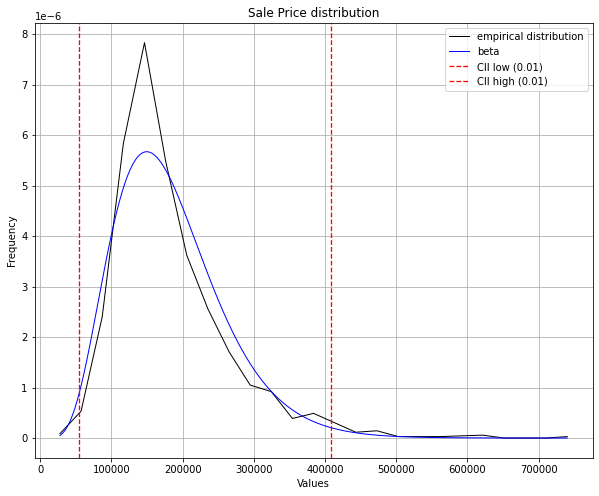

In [41]:
# Checking best fitted distribution to original variable
dist1 = df.distfit(bins=25,alpha=0.01,stats='ks')
dist1.fit_transform(train_valid['SalePrice'],verbose=1)
dist1.plot(verbose=1)
plt.title('Sale Price distribution')
plt.show()

In [46]:
dist1.summary

,distr,score,LLE,loc,scale,arg
0,beta,0.148617,NaN,8240.47058,661518905250249216.0,"(5.2010792979100735, 19662044528087.047)"
1,dweibull,0.322892,NaN,166366.797381,59050.991487,"(1.0742750964640808,)"
2,gamma,0.322892,NaN,6848.085254,31898.906946,"(5.5080858716425025,)"
3,loggamma,0.545091,NaN,-19453953.961781,2802537.163322,"(1104.713434233969,)"
4,norm,0.807543,NaN,182550.002133,81214.733111,()
5,t,0.807543,NaN,182551.529819,81215.761327,"(14327409.723445186,)"
6,expon,1.108472,NaN,12789.0,169761.002133,()
7,lognorm,1.448411,NaN,12789.0,5.042334,"(10.862363509578218,)"
8,pareto,2.250696,NaN,12789.0,0.0,"(0.02593881117197096,)"
9,uniform,5.801256,NaN,12789.0,742211.0,()


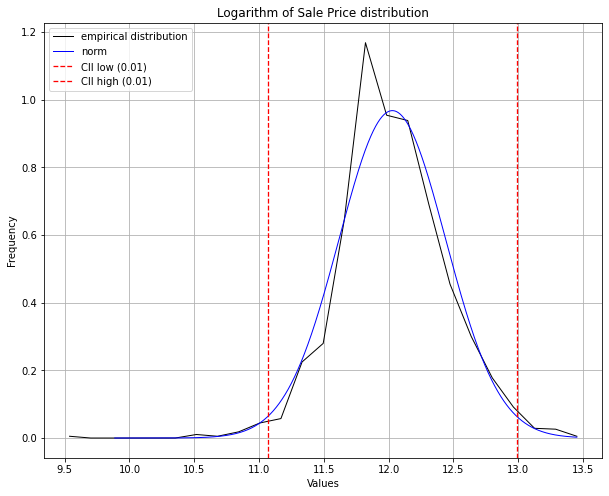

In [45]:
# Check best fitted distribution to logarithm of target variable (variable is continuous so we suspect that logarithm
# will allow to smooth the effect of outliers, hence will be more similar to normal distribution)
dist2 = df.distfit(bins=25,alpha=0.01,stats='ks')
dist2.fit_transform(np.log(train_valid['SalePrice']),verbose=1)
dist2.plot(verbose=1)
plt.title('Logarithm of Sale Price distribution')
plt.show()

# We will model logarithm of Sale Price

In [54]:
# DLACZEGO TESTY KS WSKAZUJA NA NIENORMALNOSC W OBU PRZYPADKACH?!
from scipy.stats import kstest
kstest(np.log(train_valid['SalePrice']), 'norm')



KstestResult(statistic=1.0, pvalue=0.0)

In [53]:
kstest(train_valid['SalePrice'], 'norm')


#1. Log Transformation: Transform the values from x to log(x).
#2. Square Root Transformation: Transform the values from x to √x.
#3. Cube Root Transformation: Transform the values from x to x1/3.

KstestResult(statistic=1.0, pvalue=0.0)

In [55]:
kstest(train_valid['SalePrice']**(1/2), 'norm')


KstestResult(statistic=1.0, pvalue=0.0)

In [47]:
dist2.summary

,distr,score,LLE,loc,scale,arg
0,norm,0.148617,NaN,12.029075,0.412061,()
1,dweibull,0.148617,NaN,12.021952,0.339655,"(1.2249063663257345,)"
2,t,0.148617,NaN,12.051461,0.401791,"(19.910527591863683,)"
3,genextreme,0.148617,NaN,11.876992,0.425315,"(0.2462238081356305,)"
4,gamma,0.148617,NaN,-7.394303,0.008787,"(2210.396494479116,)"
5,lognorm,0.148617,NaN,-37.861055,49.88798,"(0.008255884004587842,)"
6,beta,0.148617,NaN,-358.132438,397.641004,"(55769.20639348772, 4140.109832548717)"
7,loggamma,0.148617,NaN,-73.317861,12.505198,"(920.9835413907194,)"
8,expon,3.228419,NaN,9.456341,2.572735,()
9,pareto,3.228419,NaN,-268435446.543659,268435456.0,"(104338576.65905127,)"


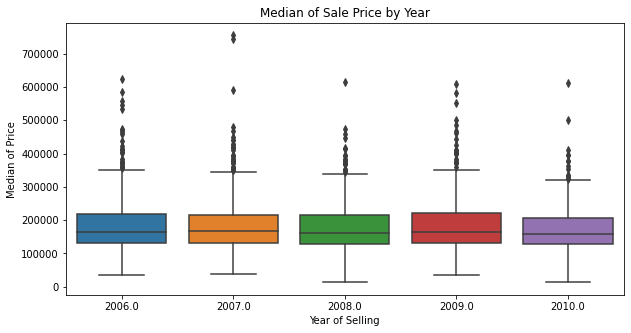

In [48]:
plt.figure(figsize=(10,5))
sn.boxplot(x='Yr Sold', y=target, data=train_valid)
#sn.barplot(x='Yr Sold', y='SalePrice', data=train_valid, estimator=np.median)
plt.title('Median of Sale Price by Year')
plt.xlabel('Year of Selling')
plt.ylabel('Median of Price')
plt.show()

# 2008 - impact of financial crisis - Lehman Brothers collapse?

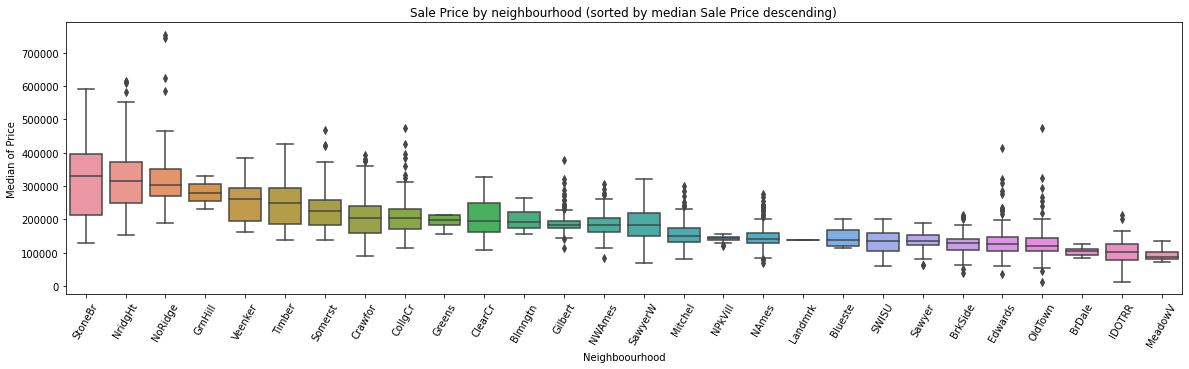

In [49]:
my_order = train_valid.groupby(by=["Neighborhood"])[target].median().sort_values().iloc[::-1].index
plt.figure(figsize=(20,5))
sn.boxplot(x='Neighborhood', y=target, data=train_valid, order = my_order)
plt.title('Sale Price by neighbourhood (sorted by median Sale Price descending)')
plt.xlabel('Neighboourhood')
plt.ylabel('Median of Price')
plt.xticks(rotation=60)
plt.show()

We can see that there is huge sale price variance based on neighbourhood with median price in the most expensive neighbourhood (Stone Br) more than 3x exceeding median price in the cheapest neighbourhood (Meadow V).

# Outlier treatment

In [ ]:
# Computing 10th, 90th percentiles and replacing the outliers
tenth_percentile = np.percentile(sample, 10)
ninetieth_percentile = np.percentile(sample, 90)
# print(tenth_percentile, ninetieth_percentile)b = np.where(sample<tenth_percentile, tenth_percentile, sample)
b = np.where(b>ninetieth_percentile, ninetieth_percentile, b)
# print("Sample:", sample)
print("New array:",b)

## Linear Regression

In [ ]:
def select_features(data):

    return ["Gr Liv Area","SalePrice"]

In [ ]:
def train_and_test(data, target):
    train = data[:1460]
    test = data[1460:]
    features = select_features(train)
    features.remove(target)
    reg = LinearRegression()
    reg.fit(train[features], train[target])
    predictions=reg.predict(test[features])
    rmse=np.sqrt(mean_squared_error(predictions,test[target]))
    return rmse

In [ ]:
#TEST functions
print(train_and_test(ames_data_transformed, "SalePrice"))

. Update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. You also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

    remove features that we don't want to use in the model, just based on the number of missing values or data leakage
    transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
    create new features by combining other features
The transform_features() function shouldn't modify the train data frame and instead return a new one entirely. 
This way, we can keep using train in the experimentation cells.
Which columns contain less than 5% missing values?

    For numerical columns that meet this criteria, let's fill in the missing values using the most popular value for that column.

What new features can we create, that better capture the information in some of the features?

    An example of this would be the years_until_remod feature we created in the last lesson.

Which columns need to be dropped for other reasons?

    Which columns aren't useful for machine learning?
    Which columns leak data about the final sale?


# RESEARCH 


The major ideas/logic behind them are:

    Reduce the number of categorical variables whenever possible/appropriate, as each categorical variable will have to be converted into multiple dummy variables for regular multiple linear regression model (a.k.a. ordinary least square (OLS) model) and regularized linear regression models, e.g. Ridge, Lasso, and ElasticNet, which would greatly increase the total number of variables and become very inefficient on prediction.
    Add new promising feature variables based on domain knowledge.
    Remove trivial variables of very low prediction value.
    Adjust variables properly as needed to make sure their values or types are well fit for the purpose of regression, i.e. help to accurately predicting the value of the target variable.

Try more preprocessing choices as BoxCox transformation, PCA, etc. For PCA, we may use the cross-correlation result among all the numerical variables, as shown earlier, to find highly correlated groups of variables, and only PCA on them and see.
Outlier check and removal
Clustering analysis to generate new useful categorical features
Feature selection: try other advanced algorithms e.g. Genetic algorithm, and simulated annealing, from R Caret package.


In [ ]:
ames_data_transformed["Yr Sold"].value_counts()